### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


### 1. Project parameters

In [2]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_26088\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [3]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2000, 2000), (2500, 2000), (2000, 2500), (2500, 2500),] 
P.idpumpbores = ['P0','P1','P2','P3'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (1500, 3500), (4500,4500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.nzobs = 3
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 30000 
P.modelmaxtri = 30000 # 10000 for ref
P.angle = 34   # minimum triangle angles

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 100000

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 2    # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)
P.res = 2    # vertical resolution upon which voxel grid created to pick lithology bottoms

P.hk = [1.7, 0.07, 8.2, 0.05] 
P.vk = [0.12,0.007,0.51,0.005] 
P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]
reference = [P.hk, P.vk, P.ss, P.sy]
pickle.dump(reference, open('../results/reference.pkl','wb'))

P.rch = 0.4/365 # 0.0027 m/d
P.strt = 0.

P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

past_years = 2
P.nts_past = past_years * 6
P.tdis_past = [(past_years * 365, P.nts_past, 1.1)] # period length, number of timesteps, tsmult
P.qwell_past = -2000 #m3/d 

future_years = 5
P.nts_future = future_years * 6
P.tdis_future = [(future_years * 365, P.nts_future, 1.1)] # period length, number of timesteps, tsmult
P.qwell_future = -5000 #m3/d 

#P.zobs = [-50, -100, -200]
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
    
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    

In [5]:
for i in P.hk: print(logfunc(i))
for i in P.vk: print(logfunc(i))
for i in P.ss: print(logfunc(i))

0.2304489213782739
-1.154901959985743
0.9138138523837167
-1.3010299956639813
-0.9208187539523752
-2.154901959985743
-0.2924298239020636
-2.3010299956639813
-4.045757490560675
-4.154901959985743
-4.698970004336019
-4.096910013008056


### 2. Meshing

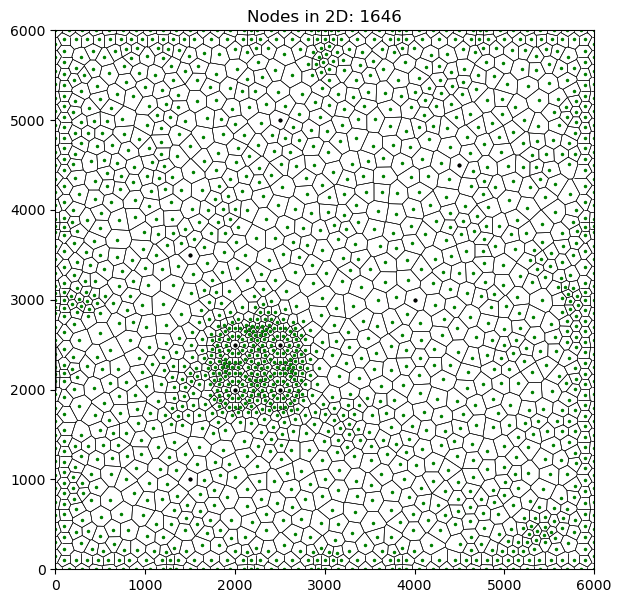

In [3]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)      
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

P.nlv  = 30  
P.delx, P.dely = 40, 40
P.ncol, P.nrow = int((P.x1 - P.x0) / P.delx), int((P.y1 - P.y0) / P.dely)
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False)    

### 3. Geological model (Reference)

In [4]:
P.control_points = ([])
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "inverse_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

C:\Users\19904604\Anaconda3\envs\loopenv\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
C:\Users\19904604\Anaconda3\envs\loopenv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


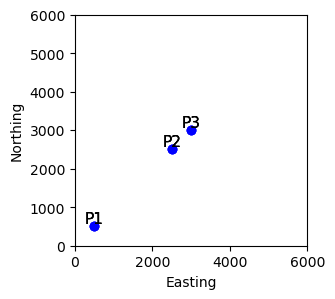

In [5]:
P.data
P.geomodel.feature_names()
plot_bores(P)

### 4. Flow model (Reference)

In [6]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb

# Initiate REFERENCE
R = Model('ref', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)

loop2flopy routines loaded!
   Creating lithology and discretisation arrays for  ref  ...


In [7]:
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], R.xcyc)
    if P.geo_pl == 0:
        wel_top = R.top[wel_icpl]  
    else:   
        wel_top = R.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = R.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print('Well coords ', wel_coords, ' Well screen top and bottom ', wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))
    
P.zobs = np.zeros((P.nobs,P.nzobs))
for n in range(len(P.xyobsbores)):
    obs_icpl, obs_coords = find_cell_disv(P.xyobsbores[n][0], P.xyobsbores[n][1], R.xcyc) # Cell id in plan
    for m in range(3): # For the top three geological layers
        if m == 0:
            lay_top = R.top[obs_icpl]  
        else:   
            lay_top = R.botm[(m)* P.nls-1, obs_icpl]
        lay_bot = R.botm[(m + 1) * P.nls-1, obs_icpl]   
        obsz = lay_bot + (lay_top-lay_bot)/2
        P.zobs[n][m] = obsz
print('\nobservation depths')
print(P.zobs)

Well coords  (2000.0, 2000.0)  Well screen top and bottom  -186.0 -288.0
Well coords  (2500.0, 2000.0)  Well screen top and bottom  -164.0 -266.0
Well coords  (2000.0, 2500.0)  Well screen top and bottom  -164.0 -266.0
Well coords  (2500.0, 2500.0)  Well screen top and bottom  -148.0 -250.0

observation depths
[[ -25. -162. -326.]
 [ -25.  -50. -101.]
 [ -25.  -60. -121.]
 [ -25.  -99. -199.]
 [ -25.  -50.  -73.]]


In [8]:
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

   Creating property arrays for  ref  ...
   Adding flow packages to  ref  ...
   Time taken =  2.565469
ref  has  13168  nodes.


In [9]:
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = R.write_run_model(P, period = 'Steady', ic_array = P.strt)   # 3 hours to run!

   Writing simulation and gwf for  ref  ...
Period =  Steady 
   Model success =  True
   run_time =  41.026289


In [10]:
R.gwf, R.head_present, R.obs_present, R.runtime_past = R.write_run_model(P, period = 'Past', ic_array = R.head_ss)

   Writing simulation and gwf for  ref  ...
Period =  Past 
   Model success =  True
   run_time =  90.603016


In [11]:
R.gwf, R.head_future, R.obs_future, R.runtime_future = R.write_run_model(P, period = 'Future', ic_array = R.head_present)

   Writing simulation and gwf for  ref  ...
Period =  Future 
   Model success =  True
   run_time =  214.822234


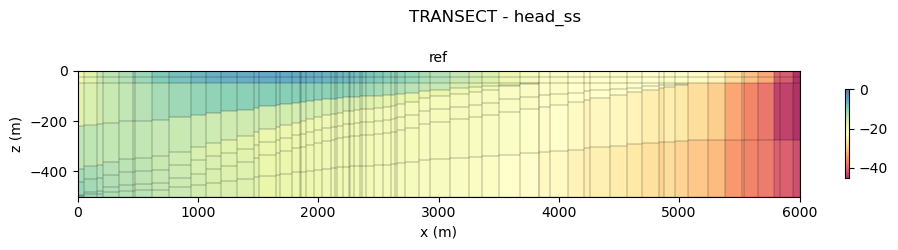

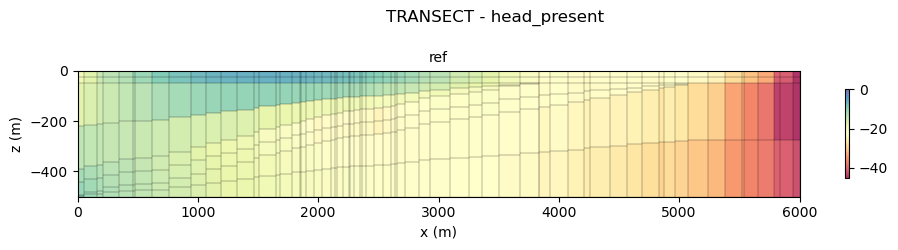

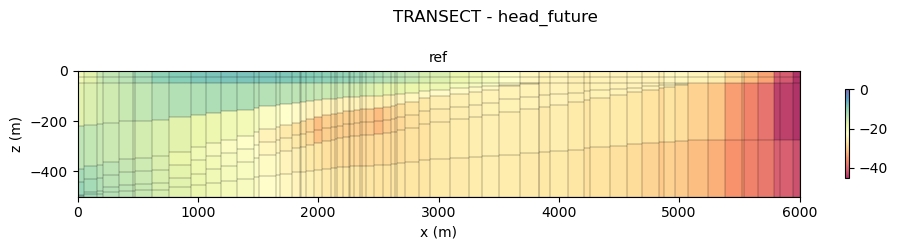

In [12]:
multiplot_prop_transect(P, models = [R], array = 'head_ss', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_present', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_future', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, 
                        vmin = -45, vmax = 0)

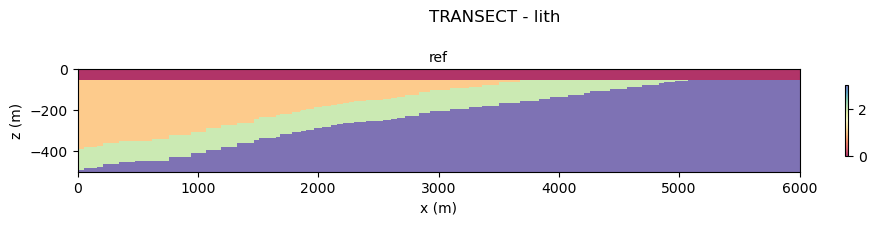

In [13]:
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

In [14]:
#f = os.path.join(vtk_workspace, "test", R.modelname)
#R.gwf.export(f, fmt="vtk")

In [15]:
#plot_flow_features(P, [R])
#multiplot_prop_transect(P, models = [R], array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)

In [16]:
#y_ = [1000,1500,2000,2500,3000,4000,5000]
#for y in y_:
#    multiplot_prop_transect(P, models=[R], array ='head_future',X0=P.x0, Y0=y, X1=P.x1, Y1=y, vmin = -45, vmax = 0)

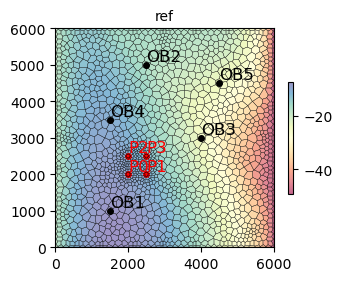

In [17]:
plot_bylayer(P, models = [R], layer = 1)#, vmin = -20, vmax = 5) 

In [18]:
#multiplot_prop_plan(P, models = [R], array = 'k11', layer = 3)#, vmin = None, vmax = None):   # array needs to be a string of a property eg. 'k11', 'logk11'  


### Testing convergence

In [19]:
# 0.27972511989404736 -1.9442518204215036 0.38322898929495725 -1.2905279279633497 -0.5824396583949223 -2.4754872268614063 -0.3344909931386087 -2.6400478413900395 -4.517405710106817 -4.610738280002378 -4.712335701038782 0.11386417979259696 -160.4664408080099
   

In [20]:
loghk0, loghk1, loghk2, loghk3 = 0.27972511989404736, -1.9442518204215036, 0.38322898929495725, -1.2905279279633497
logvk0, logvk1, logvk2, logvk3 =  -0.5824396583949223, -2.4754872268614063, -0.3344909931386087, -2.640047841390039
logss1, logss2, logss3 = -4.517405710106817, -4.610738280002378, -4.712335701038782
sy0 =  0.11386417979259696
cp =  -160.4664408080099

P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3]
P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3]
P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
P.sy = [sy0, 0.1, 0.1, 0.1]

In [21]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
# Initiate TEST
P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False)
T = Model('test', P, plan = 'vor', transect = 'con') 
T.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)
T.create_prop_arrays(P)         # Create property arrays (NPF)
T.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(T.modelname, ' has ', T.ncell_disu, ' nodes.')

T.gwf, T.head_ss, T.obs_ss, T.runtime_ss = T.write_run_model(P, period = 'Steady', ic_array = P.strt) 
T.gwf, T.head_present, T.obs_present, T.runtime_past = T.write_run_model(P, period = 'Past', ic_array = T.head_ss)
T.gwf, T.head_future, T.obs_future, T.runtime_future = T.write_run_model(P, period = 'Future', ic_array = T.head_present)

C:\Users\19904604\Anaconda3\envs\loopenv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


loop2flopy routines loaded!
   Creating lithology and discretisation arrays for  test  ...
   Creating property arrays for  test  ...
   Adding flow packages to  test  ...
   Time taken =  2.930762
test  has  11466  nodes.
   Writing simulation and gwf for  test  ...
Period =  Steady 
   Model success =  True
   run_time =  35.861295
   Writing simulation and gwf for  test  ...
Period =  Past 
   Model success =  True
   run_time =  99.303769
   Writing simulation and gwf for  test  ...
Period =  Future 
   Model success =  True
   run_time =  208.259618


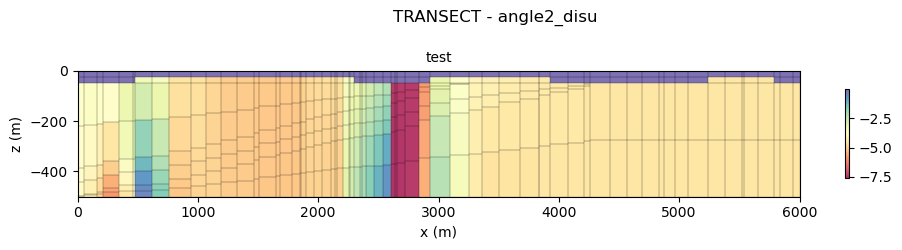

In [22]:
T.angle2_disu = T.gwf.npf.angle2.array

multiplot_prop_transect(P, models = [T], array = 'angle2_disu', X0=P.x0, Y0=P.y0, X1=P.x1, Y1=P.y1)

In [23]:
sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
gwf = sim.get_model('test')


loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disu...
    loading package npf...
    loading package ic...
    loading package sto...
    loading package wel...
    loading package chd...
    loading package rch...
    loading package obs...
    loading package oc...
  loading ims package test...


In [24]:
def plot_problem_cell(P, gwf, X, Y, Z, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    a = gwf.npf.k.get_data()
    fig = plt.figure(figsize = (10,3))
    ax = plt.subplot(121)
    ax.set_title("West-East Transect\nY = %i" %(Y))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(P.x0, Y),(P.x1, Y)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Z, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    ax = plt.subplot(122)
    ax.set_title("South-North Transect\nX = %i" %(X))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(X, P.y0),(X, P.y1)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(Y, Z, 'o', color = 'red')
    ax.set_xlabel('y (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    #ax.set_xlim([1000, 3000])
    #ax.set_ylim([-68, -48])
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    ax.set_title("Plan")
    mapview = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, layer = 0)#, geographic_coords=True)
    plan = mapview.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Y, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('y (m)', size = 10)
    linecollection = mapview.plot_grid(lw = 0.1, color = 'black') 
    
    #plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()  

minimum cell thickness = 1.000000 at node 25
XYZ problem =  5396.798731553827 4343.373505096665 -37.5
cell width approx  211.27534838731935
cell length approx  187.96073042933676
cell thickness 25.0


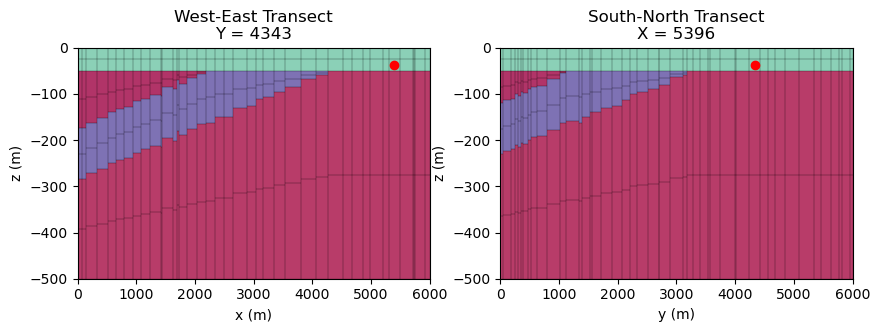

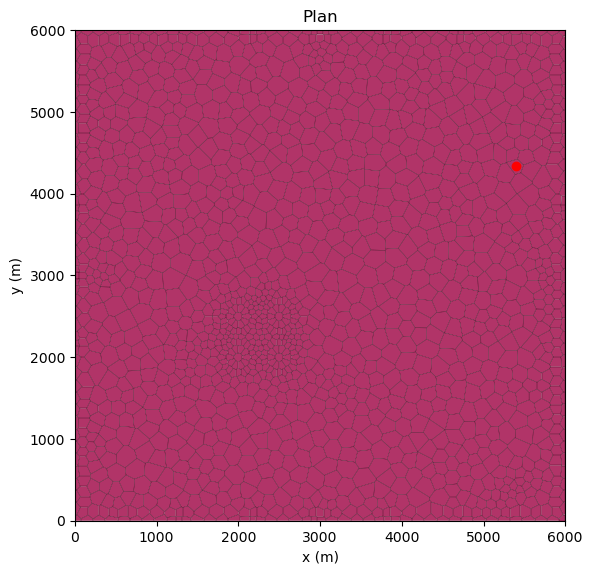

In [25]:
node = 2731-1

print("minimum cell thickness = %f at node %i" %(T.gwf.modelgrid.thick.min(), T.gwf.modelgrid.thick[node]))

X = T.gwf.modelgrid.xyzcellcenters[0][node]
Y = T.gwf.modelgrid.xyzcellcenters[1][node]
Z = T.gwf.modelgrid.xyzcellcenters[2][0][node]
print("XYZ problem = ", X,Y,Z)

xv = T.gwf.modelgrid.xyzvertices[0][node]
yv = T.gwf.modelgrid.xyzvertices[1][node]
zv_top = T.gwf.modelgrid.xyzvertices[2][0][node]
zv_bot = T.gwf.modelgrid.xyzvertices[2][1][node]
xv, yv, zv_top, zv_bot
print('cell width approx ', max(xv) - min(xv))
print('cell length approx ', max(yv) - min(yv))
print('cell thickness', zv_top - zv_bot)

plot_problem_cell(P, T.gwf, X=X, Y=Y, Z=Z)

### 14. Create "truth" observations and plot observations

In [26]:
R.ref_steady  = process_obs_steady(P, R)
R.ref_past    = process_obs_past(P, R)
R.ref_future  = process_obs_future(P, R)

In [27]:
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
fname = '../results/ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(P.workspace, fname),'wb'))

In [28]:
# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365

csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2

Text(0, 0.5, 'Head (m)')

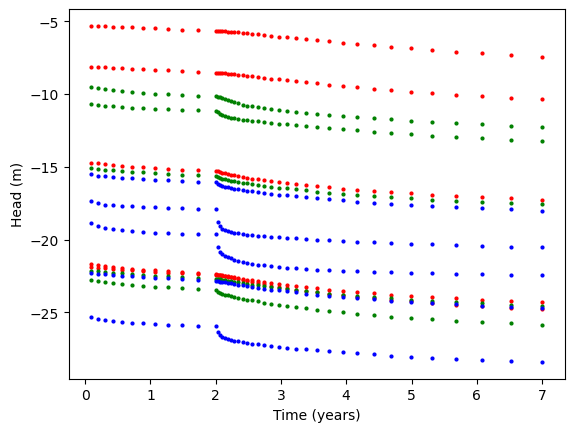

In [29]:
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

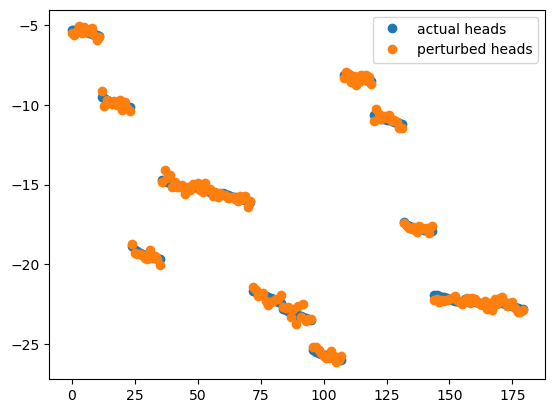

In [30]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.2
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', label = 'perturbed heads')
plt.legend()

### 15. Set up Markov Chain Monte Carlo (MCMC)

In [31]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb

loop2flopy routines loaded!


#### Define statistics of parameters

ValueError: x and y must have same first dimension, but have shapes (11,) and (12,)

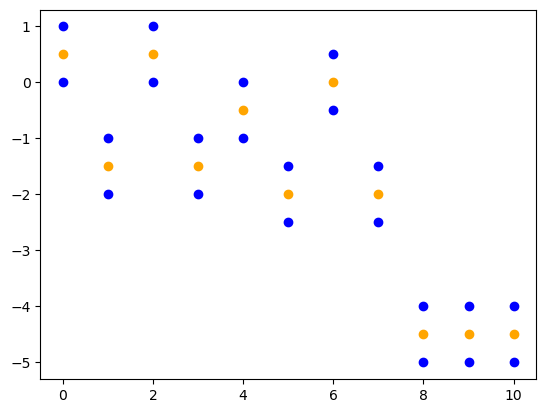

In [32]:
k_min = [0, -2, 0, -2, -1, -2.5, -0.5, -2.5, -5, -5, -5]
k_max = [1, -1, 1, -1, 0, -1.5, 0.5, -1.5, -4, -4, -4]

k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(len(k_min))]
plt.plot(np.linspace(0,10,11), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,10,11), logfunc(reference[0] + reference[1] + reference[2]), 'o', color = 'red')
plt.ylabel('Log K')
plt.xticks(np.linspace(0,7,8), ['loghk0', 'loghk1', 'loghk2', 'loghk3', 
                                'logvk0', 'logvk1', 'logvk2', 'logvk3',
                                'logss1', 'logss2', 'logss2'])#, logss1, logss2, logss3, sy0, cp])
plt.show()

In [37]:
def Likelihood(obs, mod, err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

#from DREAM import *
%run ../../Lab_tools/Uncertainty_tools/DREAM.py

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(P.hk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i])
    Width.append(k_mean[i] - k_min[i])
    Min.append(k_min[i]) 
    Max.append(k_max[i]) 

#make this anisotropy
for i in range(len(P.vk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i+4]) # Changed 18/8
    Width.append(0.5)
    Min.append(k_min[i+4]) # Changed 18/8
    Max.append(k_max[i+4]) # Changed 18/8
    
for i in range(3): # 1e-4 to 1e-6 # Botom 3 layers
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(-4.5)
    Width.append(0.5)
    Min.append(-5) 
    Max.append(-4)
    
#Sy top geo layer #0.05 - 0.2
Unif.append(True)
Log.append(False)
Mean.append(0.125)
Width.append(0.125/2)
Min.append(0.05)
Max.append(0.2)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(125)
Min.append(-250)
Max.append(0)

In [38]:
MCMC = [Min, Mean, Max]
pickle.dump(MCMC, open('../results/MCMC.pkl','wb'))

#### Set up DREAM and define "run model" function

In [39]:
## DREAM for Steady State
err = 0.2
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 100 
minsamp = 169 # minimum number of samples

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1  # Number of things to try each chain. Numbers other than 1 can give weird results for some models

In [40]:
# Load DREAM results
pickleoff = open('../results/dream_pars_chain_0_.pkl','rb') # dream_pars (122, 13)
dream_pars_0 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_1_.pkl','rb') # dream_pars (122, 13)
dream_pars_1 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_2_.pkl','rb') # dream_pars (122, 13)
dream_pars_2 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_3_.pkl','rb') # dream_pars (122, 13)
dream_pars_3 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_4_.pkl','rb') # dream_pars (122, 13)
dream_pars_4 = pickle.load(pickleoff)
pickleoff.close()

D.chains[0].current = dream_pars_0[-1,:]
D.chains[1].current = dream_pars_1[-1,:]
D.chains[2].current = dream_pars_2[-1,:]
D.chains[3].current = dream_pars_3[-1,:]
D.chains[4].current = dream_pars_4[-1,:]


In [41]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
    
# Include this here when ignoring structural parameters
#P.control_points = (['CP1', 'control', 3000, 3000, -100, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

In [42]:
def update_model(P, loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp):
    print(loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp)
    del P.hk
    del P.vk
    del P.ss
    del P.sy
    P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3] #[1, 0.1, 10, 0.1] 
    P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3] #[i/10 for i in P.hk]
    P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
    P.sy = [sy0, 0.1, 0.1,0.1]#[sy0, 0.1, 0.1, 0.1]
    P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('run', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)
    M.gwf, M.head_past, M.obs_past, M.runtime_past = M.write_run_model(P, period = 'Past', ic_array = M.head_ss)   
    #hobs_steady = process_obs_steady(P, M)
    hobs_past = process_obs_past(P, M)
    return(hobs_past, M)


In [43]:
#this function and argument statement are for the labtools dream implementation.

def L_func(Prop, P, hobs_ref, err):
    hmod, M = update_model(P,
                        Prop[0],
                        Prop[1],
                        Prop[2],
                        Prop[3],
                        Prop[4],
                        Prop[5],
                        Prop[6],
                        Prop[7],
                        Prop[8],
                        Prop[9],
                        Prop[10],
                        Prop[11],
                        Prop[12],
                        ) 
    a = np.array(hobs_ref) 
    b = np.array(hmod)
    P.hmod = hmod
    P.M = M
    return(Likelihood(a,b,err))
    
    
args = (P, hobs_ref, err,) # P - project object, hobs_ref - real observations, err - 
    
def result_func(Prop,P):
    M = P.M
    hpred = run_prediction(M, ic_array = M.head_past)
    overall = np.append(P.hmod,hpred,axis=2)
    #print(overall)
    return(overall)

Rfunc_args = (P,)
    

In [44]:
def run_prediction(M, ic_array):
    M.gwf, M.head_future, M.obs_future, M.runtime_future = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    hpred = process_obs_future(P, M)
    return hpred

In [ ]:
results = Dream_ZS(D,       # DREAM class being used.
                   L_func,  # function that recieves the proposed pars, places in model, runs model & returns Likelihood 
                   args,    # contains all the args for the model outside of the parameters
                   result_func = result_func,      # save the model outputs
                   result_func_args = Rfunc_args,  
                   minsamp = minsamp,         
                   print_freq = 1,
                   Test = False,      # If True, only initial likelihoods obtained
                   lookback = 10,
                   R_overide = False)  # Stops even if R=1.2 not reached

0.2380386482609491 -1.273696602403377 0.9112447293060894 -1.2342134479332663 -0.9440251159318058 -2.1262544597631203 0.15399441281601794 -2.1618024513791827 -4.937685554000337 -4.531190463879086 -4.985207814407976 0.14217219809889026 -216.20098172208688
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.242058
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  40.056335
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  90.780317
Initial Likelihood for chain  0  =  -157.81464411526764
0.2512672054446567 -1.3055723541265907 0.9209200067033181 -1.3776156201790888 -0.9236871898226957 -2.1411208726693407 0.13796499600767406 -2.1030336433705448 -4.786092712980811 -4.42946135747437 -4.901408976649421 0.10372305713166587 -215.91474965721457
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.214708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  37.315983
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  98.888751
Initial Likelihood for chain  1  =  -159.5151419561849
0.2269186182709013 -1.2501143520071352 0.9310152020414648 -1.4854370684436435 -0.9189111228089563 -2.1196982555982604 0.08908907176170819 -1.9782946235403955 -4.706067142047234 -4.333032934510282 -4.882893942764611 0.1528617632709961 -216.09888547210326
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.714843
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  52.531232
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  107.246762
Initial Likelihood for chain  2  =  -163.58762106844296
0.2613433674573055 -1.3867589837268772 0.9236924662128034 -1.5272603399171647 -0.9030625767443587 -2.135695436450974 0.06245165770981142 -2.101734587967418 -4.8658316484178545 -4.391276849728331 -4.984943168630288 0.11873866353438375 -216.16474861935671
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.34614
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  39.820428
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  110.551696
Initial Likelihood for chain  3  =  -163.71602491628113
0.29287273782237905 -1.4910740011284505 0.9045744627582778 -1.2147587560992203 -0.9134448001538703 -2.1526159687100868 0.10816550774341537 -2.0732552130566244 -4.484954826644099 -4.477013791297207 -4.9031002488205955 0.11940693801167154 -215.79158064996432
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.79598
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  37.690158
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  97.773775
Initial Likelihood for chain  4  =  -172.36689987356732
0.16006645587910742 -1.6413834174589417 0.6168205830986657 -1.8976086333734115 -0.07436489262987322 -2.214412989568788 -0.4346187343306269 -1.9539514113834926 -4.734334880881208 -4.627215785021423 -4.0778587802125035 0.15432911103912647 -12.688551501621077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.243035
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  30.982865
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.775349
0.47522910466929696 -1.357204701820124 0.8211739878927836 -1.53611060213815 -0.9227668262172976 -2.0453566205808382 -0.19435901676504141 -2.2599722896497325 -4.9730823310509304 -4.286069358285181 -4.109292817727431 0.10299078768528849 -154.94940747498418
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.546225
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.606402
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.259309
0.4293937508472791 -1.3539641978557948 0.8291772028660662 -1.3845727929139542 -0.9191217899626256 -2.1196372719758854 0.08917830466071767 -1.9951637057457845 -4.502738551155044 -4.234949238175035 -4.83433343687726 0.1649530568117941 -187.68957512783817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.758649
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.251264
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  87.710148
0.2613542504350725 -1.3866120007282423 0.9237356784774626 -1.5272599755017917 -0.9031557389167346 -2.1356120260782063 0.062452230392955894 -2.101627057324194 -4.8657182177770695 -4.39124599457791 -4.984897076213831 0.11874862920334987 -216.15454961336764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.575772
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  35.938493
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  77.585862
0.29277199729921477 -1.5437452672981338 0.9045675150463939 -1.2149565203468986 -0.9134041068368547 -2.1525928319245824 0.10815132076356333 -2.0733360502744573 -4.484929839379973 -4.476987970223963 -4.9030709330809294 0.11939098086655532 -215.777011448993
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.478461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  33.338386
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.022408
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  1
sampled =   0.0  tried =  5.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -157.81464411526764
Current Likelihood for chain  1  =  -159.5151419561849
Current Likelihood for chain  2  =  -163.58762106844296
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -172.36689987356732
1
0.2380660974792514 -1.9540525223084018 0.911457031740513 -1.2341078888415296 -0.943895067889455 -1.9687423918014082 0.010081711659360709 -2.1617782963405534 -4.9377378344813785 -4.531156087775636 -4.9858896952990595 0.14216869317325576 -216.18241784518028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.510346
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  76.122726
0.2513639157484166 -1.3055234789587995 0.913317645691453 -1.3016541055557582 -0.9236598667192374 -2.141180237767802 0.13798023773575044 -2.1031445181455135 -4.786188816172489 -4.451703057977401 -4.902201164963483 0.1037105057661009 -215.93739125281616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.831083
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.958164
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  51.861315
0.22686328997253022 -1.2501609256425636 0.9309691865079815 -1.485348902391776 -0.9192208562329114 -2.1196840969286304 0.08891683506795994 -1.9782412572168344 -4.705864261161227 -4.332974792402272 -4.882965305398748 0.1528742124247817 -216.03915861149503
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.023859
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.603712
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  57.022798
0.2613372617965728 -1.386580645150882 0.9235771604632563 -1.5272677536050505 -0.9031538833810592 -2.1356731854084483 0.06230949914504883 -2.101972734833676 -4.865775308224919 -4.391295047810764 -4.984865416170551 0.11873320708733533 -216.144530978325
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.737823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.905834
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  54.872101
0.29277100389653493 -1.4912140312457707 0.9047890309061816 -1.0974709083188288 -0.9136123175366901 -2.155742186701338 0.10809615726400122 -2.0732455131975374 -4.593064543176346 -4.5694754350357005 -4.903177641707074 0.11442657274645013 -215.8381111044212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.56532
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.527573
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  60.352601
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  2
sampled =   0.0  tried =  10.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -157.81464411526764
Current Likelihood for chain  1  =  -159.5151419561849
Current Likelihood for chain  2  =  -163.58762106844296
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -172.36689987356732
2
0.3647602815587562 -1.2738007468411807 0.9113029531321724 -1.2340535970308677 -0.9439075283662332 -2.126210177347739 0.15397528407322528 -2.1619689362954966 -4.884164531971876 -4.5540058745065775 -4.853131978130947 0.14220402065526036 -143.06896725786936
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.151596
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  49.978566
0.2510154338462472 -1.0417813222589198 0.113560942497555 -1.6134646508925545 -0.966709495556847 -2.0002742516755605 0.13781438350522787 -2.327678054051277 -4.7859760159513804 -4.429330314863022 -4.760179335683941 0.10371577918684828 -215.90950481426114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.004946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.779873
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.212759
0.22218042933033536 -1.2124008698500952 0.929710454071362 -1.4155725926543254 -0.9286675924070619 -2.122245375722249 0.12452326779130982 -1.978890532354736 -4.668720716700952 -4.350750525427345 -4.843773840933532 0.14585652385787792 -216.0429955915962
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.847829
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.897354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  58.627811
0.23044618044540466 -1.2741766699596164 0.9359877140810068 -1.6537035469194332 -0.9029670881421823 -2.120301007828395 0.06246466540383563 -2.057478200206818 -4.969005093771604 -4.324040313669583 -4.975398658228407 0.134353728227497 -216.1869589249442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.943423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.70316
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.432801
0.35764620234789085 -1.8366308831764653 0.5410941630418082 -1.0383015229257608 -0.6925152390264584 -2.32006444522778 0.274768310943807 -2.0323592400449257 -4.302489026938548 -4.622977417851123 -4.911066757761148 0.09363156855161994 -191.88044841311287
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.409161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.141612
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.966801
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  3
sampled =   0.0  tried =  15.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -157.81464411526764
Current Likelihood for chain  1  =  -159.5151419561849
Current Likelihood for chain  2  =  -163.58762106844296
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -172.36689987356732
3
0.23324472812046584 -1.2737009457481667 0.910045294568619 -1.1642845468445404 -0.9439675488554115 -2.1262941624671727 0.15397277699084194 -2.161800468419517 -4.937624174978634 -4.531238621463472 -4.946026646910194 0.1421912805557546 -216.25951918560554
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.874005
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  58.959556
0.2672581848443607 -1.3693615159818329 0.917588254596367 -1.3970168689569678 -0.9238402607294292 -2.1485508840100107 0.12555903755374698 -2.1607786456326856 -4.860503587562815 -4.4566612940757775 -4.948988819322551 0.10374662877401658 -215.98804081212913
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.544263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.503374
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  53.133015
0.2523424161309516 -1.3515603594186956 0.9310157465340828 -1.4852137117258808 -0.9045168028362116 -2.1320154039129178 0.08919812990188346 -1.936923244367289 -4.70619564207924 -4.3076641050540765 -4.844685523506833 0.1528633300126861 -215.9151275681721
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.973137
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.50816
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  52.143318
0.26127072434326826 -1.3912828931838714 0.7628067353215712 -1.5731188769791389 -0.903109141681318 -2.176007881828855 0.06255852909658788 -2.1018989430260766 -4.866092255109842 -4.613991053667055 -4.9215413045865315 0.11874970427594543 -182.1761729615365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.733132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.199521
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  50.243433
0.9784303763590281 -1.5217002059658495 0.06297308674653856 -1.2146710873758904 -0.9134218465099576 -2.141334613463685 0.0048258378130960075 -1.9337425339384653 -4.564169843967424 -4.5921595661418415 -4.90311031445808 0.1296378818021691 -67.54601855139856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.609144
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.505912
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.800734
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  4
sampled =   1.0  tried =  20.0
Currenty sampling at a rate of  5.0 %
Current Likelihood for chain  0  =  -152.51927981202078
Current Likelihood for chain  1  =  -159.5151419561849
Current Likelihood for chain  2  =  -163.58762106844296
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -172.36689987356732
4
0.22215045103390793 -1.273759738029853 0.9099277265223403 -1.1643728448735933 -0.9187651385072093 -2.126273471181992 0.08906429015302678 -2.161847433208718 -4.937688603469309 -4.531197184781596 -4.843755006050845 0.14219780836048648 -216.12690282513316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.099378
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  54.38578
0.966683401507626 -1.425168189096581 0.564759122364368 -1.6129489424258419 -0.5375476167912848 -2.1766710109206877 0.329288439268456 -2.3722008358728437 -4.315106473103476 -4.229989739085366 -4.597705965018794 0.09750187732747176 -0.07319215415782086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.935908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.046996
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.705122
0.2269032761063822 -1.2502025477902219 0.9310631935195315 -1.4852759082805511 -0.9191439637944437 -2.119679824687187 0.0889661565161044 -1.9783519277703436 -4.705995782738098 -4.333124140252259 -4.882840408288364 0.15286418469124688 -216.10481904313286
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.872129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.983691
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  54.413579
0.26128948057858237 -1.3867943041773338 0.9237110258211885 -1.527383524098718 -0.9030976891022061 -2.135703079376813 0.06252479355337871 -2.101906470444997 -4.86582288283164 -4.3912533589859635 -4.984818365580384 0.11874494731799111 -216.09774594946563
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.720078
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.10682
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  54.520398
0.2928911348946755 -1.4909563989134784 0.8836041867621027 -1.893594214520684 -0.93874940538231 -2.1592542031138344 0.10821820460888425 -2.073237490173644 -4.484909485316522 -4.67512141014027 -4.903165961518451 0.10874416553008977 -215.9081416744442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.760704
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.986677
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  58.843339
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  5
sampled =   1.0  tried =  25.0
Currenty sampling at a rate of  4.0 %
Current Likelihood for chain  0  =  -152.51927981202078
Current Likelihood for chain  1  =  -159.5151419561849
Current Likelihood for chain  2  =  -163.58762106844296
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -172.36689987356732
5
0.233185070782873 -1.2735074447653578 0.9192217405606018 -1.2815425549512176 -0.931975197460289 -2.126082567371697 0.12373611426879307 -2.0761448414785946 -4.829492213336966 -4.531122456879134 -4.898155930511911 0.14717337600514604 -216.17381616499617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.081349
   Writing simulation and gwf for  run  ...
Period =  Steady 


Period =  Past 
   Model success =  True
   run_time =  62.893141
0.2512806455848447 -1.343418561065484 0.9209830972697736 -1.3777163137092514 -0.9238298807395746 -2.1410558035477143 0.1380035976197199 -2.103046654565426 -4.785805929121167 -4.429422032074426 -4.940452030551251 0.11074416182736695 -216.0083431314979
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.61835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.990876
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.436254
0.2523538544126093 -1.3516899921181338 0.9280187938854149 -1.4764311746823418 -0.9045315282459214 -2.132079596385668 0.0678642535773078 -1.9370495571325805 -4.494894903123773 -4.307607942876906 -4.8444665703991205 0.1422261505460114 -215.86229529882624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198065
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.276154
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.722776
0.2612963673991138 -1.3868473509169386 0.9234859300040624 -1.5273737275269117 -0.9026570494318565 -2.135670904812744 0.06243294156359488 -2.1017291575399564 -4.865941523363197 -4.391327645651454 -4.985007595564619 0.11875312898684977 -216.1366373430314
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142358
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.787733
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.525149
0.3075844374348797 -1.5397644872879317 0.8955432687489877 -1.2147280136212855 -0.918503290700944 -2.1526668107158087 0.12955169107690917 -2.0732933937346876 -4.30712819992676 -4.476890004575397 -4.903162775115129 0.11971879426879913 -215.65769914528408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.158817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.769066
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.988442
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  6
sampled =   1.0  tried =  30.0
Currenty sampling at a rate of  3.3 %
Current Likelihood for chain  0  =  -152.51927981202078
Current Likelihood for chain  1  =  -159.5151419561849
Current Likelihood for chain  2  =  -163.58762106844296
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -172.36689987356732
6
Minimum likelihood for outlier chains is:  -172.1177908364736
Removing chain 4with average lilihood of -172.36689987356735compared to interquartile minimum of -172.1177908364736
0.23321181951100917 -1.2737035100224532 0.9100530141443128 -1.164233170014355 -0.9439306862188217 -2.1263194309122926 0.1540375847000292 -2.1617853884778446 -4.937584221463649 -4.53123819277496 -4.945999675587512 0.1422048127083538 -216.25080927653372
   Creating lithology and discretisation arrays for

Period =  Past 
   Model success =  True
   run_time =  34.76182
0.2512688653197934 -1.3055852974304833 0.9209284331756852 -1.377703729249415 -0.9240893496450637 -2.1410530396753833 0.1377793920865495 -2.103059162244231 -4.786140035805568 -4.429459126773731 -4.901442941663555 0.1037154500553383 -215.88496739977353
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166152
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.978753
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.312375
0.22700592424342447 -1.250117966621137 0.9309815906175495 -1.4852877288818143 -0.9188421248372248 -2.1197623044818674 0.08909800658682451 -1.9782909782489393 -4.706059112076198 -4.333059014866887 -4.882890690972032 0.15286250531280612 -216.06190254322343
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.366756
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.884278
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.761959
0.3991740402464047 -1.3535609385772907 0.8638329913132246 -1.8048255966836 -0.5394575446132004 -2.211999858598312 -0.2128452732349699 -2.1831317535916894 -4.778665176316709 -4.348770489933056 -4.852801613822428 0.08580040107993919 -145.6239956662626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153854
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.647923
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.840496
0.2331815860903421 -1.2737270774378942 0.9095236179778656 -1.131984254718886 -0.9437713321450186 -2.126337924723578 0.1541305308211627 -2.1619076717932395 -4.9375646711384205 -4.531362335693224 -4.927761095317543 0.1421625257124783 -216.30663201875316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.943628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.170525
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  7
sampled =   2.0  tried =  35.0
Currenty sampling at a rate of  5.7 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.5151419561849
Current Likelihood for chain  2  =  -163.58762106844296
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -152.51927981202078
0
0.23313016977734233 -1.2737060921253547 0.9100132115737048 -1.164456643775844 -0.9441012318006013 -2.1262591646934865 0.15425813004182548 -2.161861106850109 -4.937507519956046 -4.53121608903574 -4.945993058867299 0.1421949321306325 -216.18963301322506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17078
   Writing simulation and gwf for  run  ...
Period =  Steady 
 

Period =  Past 
   Model success =  True
   run_time =  33.769695
0.2512905093169339 -1.3055919366205597 0.9208956811871114 -1.3779292012365962 -0.9233204962844735 -2.1410963617882413 0.1381701617249448 -2.1030281480347988 -4.786116719393606 -4.429479972303784 -4.901546130542624 0.10369283776229263 -215.87908538377928
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140169
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.135052
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.144081
0.22706199447218228 -1.2501036599602868 0.9310296636468154 -1.4854170034516319 -0.9187779106951414 -2.1197090883044 0.08909963195422138 -1.9782136217805855 -4.706067922547422 -4.333104102036471 -4.882923159420806 0.1528489499725815 -216.0976132592474
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.758992
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.722173
0.25856419049136187 -1.386779317532866 0.9236889429783153 -1.6771269964340194 -0.8911334240144132 -2.1326513192023917 0.032588114310020365 -2.01608098584566 -4.757751368022714 -4.391177064711585 -4.985066393963106 0.11873139273168679 -216.21108895682198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.90777
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.37311
0.09558899204633242 -1.3069036188134848 0.9698353439733641 -1.8864868181323031 -0.30701858111315916 -2.050082610400671 0.42895346583446725 -2.0805167709790013 -4.024795314030527 -4.573808365378288 -4.078280148173535 0.1751450849347318 -37.52203008124678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105674
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.744924
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.100185
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  8
sampled =   4.0  tried =  40.0
Currenty sampling at a rate of  10.0 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -163.49657491581874
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -152.51927981202078
1
0.2224457345820756 -1.2209143001969616 0.9042749917105609 -1.027723907896614 -0.9631078413923645 -2.121932037052189 0.19657310133851952 -2.1897745090773784 -4.971066357255337 -4.596536379576241 -4.946270132643563 0.15313822621657222 -216.3314691340312
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131574
   Writing simulation and gwf for  run  ...
Period =  Steady

Period =  Past 
   Model success =  True
   run_time =  34.289243
0.2513253599911789 -1.3055841634360337 0.9208616945696082 -1.3778642505044327 -0.9232968059760066 -2.1410957466645493 0.13824816396837952 -2.1030596986772934 -4.786012277272694 -4.42946917552696 -4.901656202112535 0.10368825602845257 -215.88370116548154
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.225782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.751564
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.114712
0.22710863624676841 -1.2501282739980577 0.9304035588520664 -1.4853499607443321 -0.9188507363364526 -2.1196735575636247 0.08900937381896329 -1.978194882843513 -4.706157352791541 -4.333078171217868 -4.882979536562803 0.15287795093768197 -216.13295750229256
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.65461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.234969
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.065754
0.26137937481617723 -1.3868075401302218 0.923703636319601 -1.5268421464306463 -0.9029989485654534 -2.135743500386617 0.062487178819835065 -2.101795626524736 -4.865856474185269 -4.391276781296015 -4.985065976270145 0.11875528767745633 -216.1617371822857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149375
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.606224
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.007388
0.23322146556263718 -1.2737220919735415 0.9100236609362101 -1.163962123147022 -0.9439237509618642 -2.1262817268081795 0.15413065424369554 -2.16180745802601 -4.937530036304877 -4.531233755871272 -4.946191823993522 0.14220261521819122 -216.25560597926446
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.276532
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.752822
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.689175
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  9
sampled =   5.0  tried =  45.0
Currenty sampling at a rate of  11.1 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -162.89351622912872
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -152.51927981202078
2
0.22209465616782748 -1.2208997077788326 0.9042227112483728 -1.0272726675024022 -0.9627645924156892 -2.121939589249589 0.19699449229417706 -2.189870410613688 -4.971283545913249 -4.596543908724392 -4.945967498123531 0.15318720516894596 -216.28565221080612
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119911
   Writing simulation and gwf for  run  ...
Period =  Stea

Period =  Past 
   Model success =  True
   run_time =  34.235079
0.24615070386595658 -1.2945683962962673 0.9301409358239267 -1.4951250801145615 -0.9119062725181237 -2.1380281399823575 0.10797945290957846 -2.0172978428442163 -4.678008026971798 -4.337056547263861 -4.8538167631703555 0.10867550164592084 -215.81664218418356
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.30221
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.269472
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.164441
0.2332382366146239 -1.2649724322424514 0.9349154739463008 -1.552439579932532 -0.9093763418586496 -2.126612616168509 0.08189610647577421 -1.950741866672689 -4.635464010993364 -4.285545790334808 -4.843971169617886 0.13491064602928723 -216.03920700695105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.818217
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.483668
0.2613735023610341 -1.3867861199720553 0.9236850646666994 -1.5271981151148868 -0.9032706150341876 -2.135664028685385 0.06243436711066886 -2.1018929375847653 -4.865940029236155 -4.391358581184184 -4.984835787882678 0.11871746008531879 -216.18535222250708
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.233602
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.704813
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.214832
0.24448563679104013 -1.2737067258401389 0.9055970926397229 -1.1645317275893252 -0.9460388172309763 -2.1362753099176826 0.17700594938765524 -2.2200338410717326 -4.937599919614731 -4.576190178780276 -4.946051980522278 0.1421783261367371 -216.2547944473218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1636
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.143877
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.476488
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  10
sampled =   6.0  tried =  50.0
Currenty sampling at a rate of  12.0 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -162.89351622912872
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -149.4969210077409
3
0.2332717654560095 -1.297297177447517 0.8890500803904792 -1.1643248163588715 -0.9686493299383007 -2.1328835390799963 0.15397079579771022 -2.161764618967118 -4.93754514101847 -4.729388324050814 -4.946093802183219 0.14220176404566132 -216.39254449435816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213798
   Writing simulation and gwf for  run  ...
Period =  Steady

Period =  Past 
   Model success =  True
   run_time =  34.037114
0.2331146815641401 -1.2737133524378748 0.9099917246426616 -1.1643899915453277 -0.922967319184318 -2.1262706030767236 0.1540891501831048 -2.1617628560901605 -4.937479868471126 -4.429536070805005 -4.901448060183587 0.1421768738254461 -215.76811804216865
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.6561
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.46758
0.22716583471813392 -1.2501396219428222 0.9304797490619909 -1.4854877153837291 -0.9190227804539406 -2.1197482682112674 0.08908417669943221 -1.9780923845291745 -4.7061428129145835 -4.333139055097741 -4.883049741778633 0.15284198367225912 -216.15936209800847
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.218336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.787137
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.776074
0.26145188199276276 -1.3867572503104038 0.9236707576179983 -1.5270560349695321 -0.9030389784903384 -2.135668106257258 0.062380654501763284 -2.101615390150568 -4.8658873247308465 -4.391325789958308 -4.984955635556845 0.11874793310809774 -216.14537482230403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.064205
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.070782
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.364322
0.24467112189817863 -1.2737033147469927 0.9055730706596856 -1.1644534286433033 -0.9458254160422473 -2.136261793805734 0.1769104970058216 -2.220006455211633 -4.9374504650562585 -4.576243828074703 -4.946003024812577 0.14217625093120623 -216.28457543355114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.07314
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.956513
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.129633
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  11
sampled =   6.0  tried =  55.0
Currenty sampling at a rate of  10.9 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -162.89351622912872
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -149.4969210077409
4
0.2331545547209244 -1.2736714601464916 0.9100024606306857 -1.164143701662437 -0.943634908664583 -2.1264453429619197 0.15435515953978796 -2.161695921905261 -4.937610861828278 -4.531379510162277 -4.946005245363337 0.14219108361735788 -216.26159123304086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.347438
   Writing simulation and gwf for  run  ...
Period =  Steady

Period =  Past 
   Model success =  True
   run_time =  36.097674
0.2512362571638537 -1.3055521750677648 0.920906865883078 -1.3778986183521473 -0.923458042824423 -2.141072378071906 0.13808885728701312 -2.1029024930001454 -4.786154764287111 -4.4295770882042556 -4.901558870151023 0.10370335859870826 -215.92175684984736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105629
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.403605
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.183924
0.22706777805533196 -1.250097948830632 0.9304261185194403 -1.4851355084132947 -0.9187722483465924 -2.1196163381612028 0.08905467185715557 -1.9781123544141817 -4.706141132644736 -4.3329818246989085 -4.883016537927651 0.15285642420965415 -216.0705408823126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.064838
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.963121
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.256147
0.26134693004529647 -1.386702673240612 0.9147357677381766 -1.5270261866333819 -0.9147844709096168 -2.138798291279172 0.06261579420081348 -2.1874826397988847 -4.973869854036744 -4.3912562569050095 -4.984860763424255 0.11874723845640092 -216.11265397218133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.315863
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.639671
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.641323
0.24668756624667676 -1.2737719460514976 0.9055995973235523 -1.1643021299563714 -0.9461142082674011 -2.1362667000911104 0.17687752755622171 -2.220116744844497 -4.9376849487768775 -4.57622564648966 -4.946065168816274 0.14217433276529856 -216.2688461920542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.874923
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.932194
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  12
sampled =   7.0  tried =  60.0
Currenty sampling at a rate of  11.7 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -162.89351622912872
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -147.96476126931478
5
0.23323706977181488 -1.2736725403808942 0.9100837697087136 -1.1638001312176445 -0.9440372384448897 -2.12633940742314 0.15389779953001062 -2.1617389427534013 -4.93755885624525 -4.531223558980331 -4.945970361857277 0.14222217596532358 -216.2974965165706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230643
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  34.461231
0.2541914903513161 -1.3165688780411704 0.9208886861267808 -1.2281413788166975 -0.9351056953937361 -2.1411240054510836 0.16839942993468573 -2.1885988641495984 -4.894055732501444 -4.429448071938044 -4.931138607850017 0.09871197391437336 -215.92652165883072
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.239987
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.820945
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.974279
0.22716980938059114 -1.250039246812895 0.9304245773721643 -1.4854414561696023 -0.9186867706549098 -2.11969222802257 0.0889142535732645 -1.9784321848901842 -4.706390110397081 -4.3330132593506425 -4.883032527162421 0.15287792804223213 -216.15668801706383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136767
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.619189
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.527582
0.2612183757737074 -1.3866866410719547 0.9236999026197416 -1.5273931341122136 -0.9028294040328653 -2.135710737003238 0.06250240302722572 -2.101915380873364 -4.865869709957568 -4.391234747874976 -4.984939030624683 0.11876158044227328 -216.11337334665805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26261
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.397121
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.057623
0.2550071785679143 -1.2737030907134206 0.9106657666158635 -1.1642748415587019 -0.9367444632506724 -2.1431603757818665 0.16934826273122577 -2.1927595896657346 -4.867019603515834 -4.576236876387938 -4.925337586465557 0.1421644586441905 -216.15073587069122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.348798
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.753795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.051075
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  13
sampled =   7.0  tried =  65.0
Currenty sampling at a rate of  10.8 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -162.89351622912872
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -147.96476126931478
6
Minimum likelihood for outlier chains is:  -175.61531820550323
0.24009460525195095 -1.3264403644321043 0.9185125332197451 -1.3336829688480836 -0.9241621206307417 -2.1260547990478598 0.15380899561480738 -2.1064360454311 -4.904065822265654 -4.531292074816787 -4.9641495133871425 0.13126554798426612 -216.21396816827226
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.3

Period =  Past 
   Model success =  True
   run_time =  43.869522
0.2513666116857038 -1.3166495287810382 0.9113476851679652 -1.3784922591255335 -0.923574882960221 -2.1411219625237377 0.16841177371537067 -2.1887005228709464 -4.894027586059267 -4.429587253117182 -4.930945810652332 0.10370922722249047 -215.8030201943841
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.416863
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.645934
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.679954
0.21396174753249464 -1.1973209788005605 0.9240757655622521 -1.3159719245391115 -0.9377217812502476 -2.1152538005341586 0.08878317463460546 -2.006086054058005 -4.706144752389128 -4.398514376572485 -4.883143101608582 0.15292794682777786 -216.1976346165255
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.851259
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.618743
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.932022
0.2641676284991664 -1.397749039254054 0.9141705990120693 -1.3776255338981285 -0.915033221929418 -2.138768332896208 0.09287430345422831 -2.187442531295146 -4.973766036019584 -4.483807677655779 -4.014371181989901 0.11375752152583778 -216.23042496807446
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213774
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.096579
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.817307
0.23354433559362323 -1.2737829482482819 0.8992800393549719 -1.995125603657911 -0.9461333200779409 -2.1318737575979396 0.21939907168410278 -2.248296892222571 -4.971372517052941 -4.576275654919094 -4.927780784568237 0.15311209871560427 -216.29347475165093
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.333112
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.706912
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.960945
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  14
sampled =   7.0  tried =  70.0
Currenty sampling at a rate of  10.0 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -162.89351622912872
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -147.96476126931478
7
Minimum likelihood for outlier chains is:  -176.4646250185219
0.23316575412230955 -1.2737577574853418 0.9100673637073553 -1.1647542244209657 -0.9438179675503481 -2.1263829050033767 0.15390940186367275 -2.1617128806448616 -4.937727692403268 -4.531322081161902 -4.945911825846564 0.14220604598088377 -216.28563680206332
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.

Period =  Past 
   Model success =  True
   run_time =  43.236521
0.2511443779360988 -1.3055756035917847 0.9209280575695811 -1.3780013728344103 -0.9238085340262929 -2.1411232640774447 0.1382204635341224 -2.1030100724817045 -4.786248154461172 -4.429450795860997 -4.9016069903217945 0.10366526275458879 -215.824830461631
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229331
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.106104
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.280404
0.2348446751632994 -1.302862957714251 0.9303985425602658 -1.4853424361593537 -0.8985207607724714 -2.1193914855960383 0.03559435726582509 -1.9229162160156823 -4.672739316033248 -4.333094312915923 -4.90123181655754 0.1528478738872526 -216.11076036979398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.802364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.074687
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.635081
0.2642549999577231 -1.3977241270538312 0.9142078119081365 -1.3777133255471379 -0.914810392155939 -2.138765527201717 0.09277916641801634 -2.1875234904567233 -4.973864125169695 -4.483787069107604 -4.014305921152735 0.11872624705719553 -216.1830199497125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.757902
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.513108
0.24669679894357716 -1.2737755587529274 0.9056468065155776 -1.1647092295915455 -0.9459444787348323 -2.1362500360530814 0.17702794797332083 -2.2200410072422105 -4.937700745539553 -4.57621537052872 -4.9461149266379705 0.14217449419357828 -216.2430666650542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.247603
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.834381
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.626268
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  15
sampled =   7.0  tried =  75.0
Currenty sampling at a rate of  9.3 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -162.89351622912872
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -147.96476126931478
8
Minimum likelihood for outlier chains is:  -179.41357168549354
0.2286394142237749 -1.2419327535310556 0.8947483598511129 -1.9508710256372486 -0.9666227601638141 -2.1215039480468043 0.1541103928811733 -2.2788342883526487 -4.089124235878106 -4.678047259091717 -4.945994586040438 0.14222820720701104 -216.60889782274666
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.57

Period =  Past 
   Model success =  True
   run_time =  40.887794
0.22308916910865248 -1.1925282318808146 0.9072643532839229 -1.37813941357109 -0.9645828583543807 -2.141106317745401 0.13807830039361488 -2.1029776817184045 -4.786158145248815 -4.569475439019422 -4.862720765588449 0.127113517890581 -215.91628881955478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.434065
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.468728
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.469608
0.2552621580518006 -1.3631771420312535 0.9440446176882102 -1.8482019236386338 -0.8779836585549268 -2.128983745366898 -0.0025269364671659435 -1.9182539083379446 -4.634388484712583 -4.193263787369938 -4.921995044429747 0.12940321332229346 -216.0504084670537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.590572
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.154189
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.29436
0.26133588993762596 -1.3867518077061218 0.9236732377617352 -1.5270696173562792 -0.9031760532672325 -2.135693693346955 0.062160913581265534 -2.101774837984501 -4.865887013739759 -4.391193793708239 -4.985044480301402 0.11872801169196336 -216.15054210660665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175877
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.900226
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.603382
0.23558756575880574 -1.2737297792266309 0.9100439133059303 -1.163915461294692 -0.9439076686044455 -2.126243771940843 0.15376861315520401 -2.16185365526156 -4.937843001427121 -4.531400946008027 -4.945965598230294 0.14217366440738874 -216.20966057398874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.254761
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.014953
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  16
sampled =   7.0  tried =  80.0
Currenty sampling at a rate of  8.8 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -162.89351622912872
Current Likelihood for chain  3  =  -163.71602491628113
Current Likelihood for chain  4  =  -147.96476126931478
9
Minimum likelihood for outlier chains is:  -179.875581807428
0.23801110860357175 -1.3115910781988773 0.9101280643827214 -1.2339489503750156 -0.9440958992703661 -2.1237986041465784 0.15419673938183953 -2.161061385811683 -4.974868426141285 -4.531130697332896 -4.984927790599049 0.1492212246161831 -216.38904583701589
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.3425

Period =  Past 
   Model success =  True
   run_time =  42.07342
0.2512312899871233 -1.3057377149553786 0.9209050980240588 -1.3778794814495088 -0.9236609015349806 -2.141093750406065 0.13799645018098738 -2.1031033871492917 -4.786030598414083 -4.429665615568365 -4.901597506295384 0.1037187435237327 -215.9073666566994
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.207845
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.35975
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.648826
0.22185849908998115 -1.2500785462675799 0.9324713569411796 -1.4852471099133866 -0.9185886534474468 -2.1197535734342603 0.07844826509266772 -1.9511185537925453 -4.7062893491294675 -4.312145922269139 -4.883071440733936 0.15287684345750843 -216.13137544662695
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.390279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.470022
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.068362
0.2613822944481873 -1.3868111346651308 0.9186752223724038 -1.5275443947254876 -0.9128480940150575 -2.135747429486933 0.062100543452787885 -2.1292301212589417 -4.936472437239036 -4.43863391537476 -4.984963975476529 0.11873347411545124 -216.29590703982194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.615264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.186935
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.273721
0.23982486952326068 -1.2210702138147937 0.8971241486739767 -1.9949132239932639 -0.9664276633557152 -2.1366052196225795 0.23039180540771845 -2.2752295961507936 -4.971171427984082 -4.662656391895522 -4.927970634261309 0.15317599784097535 -216.28967125494154
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.390353
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.175445
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.145692
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  17
sampled =   8.0  tried =  85.0
Currenty sampling at a rate of  9.4 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -162.89351622912872
Current Likelihood for chain  3  =  -157.22760881408576
Current Likelihood for chain  4  =  -147.96476126931478
10
Minimum likelihood for outlier chains is:  -182.57878291881866
0.23331471510414034 -1.2737174052429456 0.9101071327278907 -1.164353754138373 -0.9439044460930655 -2.126355832806366 0.15420403318306483 -2.1617959618594957 -4.937649782513261 -4.531193666187193 -4.946032900336151 0.14220207921347527 -216.24940913902128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.6

Period =  Past 
   Model success =  True
   run_time =  47.296877
0.2513071381561222 -1.241814456976232 0.923959870013628 -1.3583553021138268 -0.9234318765750957 -2.1411197442560788 0.1507799767003812 -2.103024891303681 -4.711713519542681 -4.402403115534533 -4.853847875355285 0.11959014239018209 -215.89873698606368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.621543
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.600929
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.647258
0.2299661594156845 -1.2611034020898773 0.9209738053022026 -1.33563966395634 -0.9306036735944176 -2.1227201303265395 0.1194381990963825 -2.0638875916100083 -4.814129421237873 -4.425585889693993 -4.912368105380285 0.14786636820620755 -216.19893053342997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.619178
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.090499
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.141822
0.26673815630532155 -1.386937998936199 0.9186801626306316 -1.5273871816774163 -0.9142217310009613 -2.135793854411137 0.06204973030604932 -2.1291137674387723 -4.93652591783543 -4.459681063976413 -4.984946691968685 0.11876013389018461 -216.2933942878418
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.529345
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.670539
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.367414
0.24388456598771927 -1.262757472276521 0.9150732011473834 -1.3142044393741021 -0.9349863627290048 -2.1362709376612155 0.14640681566917815 -2.2200856782895766 -4.8297230974457515 -4.576237694032543 -4.916643482107511 0.147139477791169 -216.2671321521887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194149
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.125527
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.665911
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  18
sampled =   9.0  tried =  90.0
Currenty sampling at a rate of  10.0 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -162.89351622912872
Current Likelihood for chain  3  =  -155.59663456802224
Current Likelihood for chain  4  =  -147.96476126931478
11
Minimum likelihood for outlier chains is:  -181.3691146909727
0.22651446628938068 -1.221022033760354 0.9015856239596511 -1.994423578887965 -0.9639584320839378 -2.126663510064845 0.20751605198336584 -2.217099328791289 -4.970943980707492 -4.617484160178497 -4.927885211816861 0.15318085062099784 -216.31245882839403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.165

Period =  Past 
   Model success =  True
   run_time =  38.342345
0.24206364747102144 -1.3055882388306346 0.92088096303297 -1.3780591559911035 -0.9108411974428177 -2.141070714694242 0.09747295755854221 -1.9899552052735598 -4.678214842168813 -4.316060214616775 -4.87217958481773 0.10864858951703017 -215.88326895258245
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.469956
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.704999
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.797735
0.22715227055445752 -1.2501213749976317 0.9344633286262604 -1.4855349520190309 -0.9051768385068779 -2.119724848643455 0.08898324250180668 -1.9781779919576161 -4.706270966373941 -4.332963254605226 -4.901102002272949 0.1529053326679262 -216.24226770522748
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12578
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.876615
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.750527
0.2584270578997522 -1.3720124802339602 0.9135744751515481 -1.427917674151483 -0.9235794522146235 -2.128882456387621 0.06955203473733916 -2.1565903648138334 -4.007194375590253 -4.507133878609819 -4.005664496837919 0.13670867719545343 -216.43277177834366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.36857
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.578383
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.299898
0.24677346366193859 -1.3115525869508462 0.9069054671928611 -1.2338036524275844 -0.9366358847105312 -2.1362470324808585 0.17671806598478165 -2.219468328882041 -4.937820143295433 -4.558400786402393 -4.9849681761536475 0.14915597867537028 -216.4037901919329
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.883814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.192589
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.376148
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  19
sampled =   10.0  tried =  95.0
Currenty sampling at a rate of  10.5 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -155.59663456802224
Current Likelihood for chain  4  =  -147.96476126931478
12
Minimum likelihood for outlier chains is:  -182.0275940035118
0.23322345885874174 -1.2736806878222167 0.9101059351262986 -1.1643808948891416 -0.9440520737576458 -2.1263278501350573 0.15410817489506282 -2.1615856683388706 -4.937690939570764 -4.531239973587172 -4.946032355883079 0.14219563578423478 -216.22578843782028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  40.90859
0.2513462147261899 -1.305580981959682 0.920829806074442 -1.3974903642478926 -0.9210697925184639 -2.1485850784450347 0.13838846260115428 -2.173254124414684 -4.786283328040175 -4.429576250986736 -4.901516032045512 0.10368857349639514 -215.88628361169566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.388786
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.728562
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.340527
0.22717816906805657 -1.2500446379259544 0.9345417121291395 -1.4860732753184687 -0.9053775611431211 -2.1196928745446546 0.08900749557854497 -1.9781130564576215 -4.706421674622637 -4.3327825362743635 -4.901191285431978 0.15290341826506293 -216.25688203148368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.375382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.509985
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.701264
0.25552115227020983 -1.3870362605713142 0.9231632658769602 -1.5269962520541422 -0.9120952223490918 -2.125798889599136 0.06201516199688074 -2.1291178364556753 -4.936620494748234 -4.459689398779186 -4.9763239564099155 0.14173649149767664 -216.42376782060583
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.560664
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.120271
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.581878
0.246819962892258 -1.2738600717109585 0.9056161957559115 -1.164453571634175 -0.9460074684968655 -2.13619129273793 0.17643346154135736 -2.2200416454774596 -4.971181754104455 -4.576190938283017 -4.946171317539782 0.15310515816297082 -216.2279744940998
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.438216
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.218876
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.421969
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  20
sampled =   11.0  tried =  100.0
Currenty sampling at a rate of  11.0 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -153.5549551240403
Current Likelihood for chain  4  =  -147.96476126931478
13
Minimum likelihood for outlier chains is:  -179.23811683777117
0.23322600822030287 -1.2735602476213486 0.9100657146005761 -1.164518564102856 -0.9440773502724422 -2.1262995422448254 0.1538449363764654 -2.161960794149528 -4.937579348945631 -4.531172821614915 -4.946106280682629 0.14221218843955352 -216.21346612925024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.3

Period =  Past 
   Model success =  True
   run_time =  41.963275
0.26474921248698097 -1.3057646347971033 0.9163538685161366 -1.3784990722970272 -0.9257971659109876 -2.151020898661616 0.16109573895968837 -2.161374210112391 -4.78629995438088 -4.474269416958448 -4.901629782267716 0.10370956067411372 -215.90674245368638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.401474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.915098
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.873839
0.20905104834289465 -1.2500599989387635 0.9344328302829398 -1.485569318123606 -0.9260672833636041 -2.119700058511553 0.08871852301424919 -1.9779546914688035 -4.857803519392617 -4.434789044040299 -4.94556673682928 0.19140863017434348 -216.6153058393578
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.737939
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.084459
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.305355
0.2314057734405499 -1.331593303648735 0.9327033320817805 -1.634571344119164 -0.9076803191214371 -2.1043644891484674 0.01314869036335182 -2.0041063213667876 -4.856859300139941 -4.36329810051679 -4.957820984117776 0.1909066340171381 -216.6696806592172
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.299892
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.534763
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  50.099099
0.26914208891426256 -1.3870394584209975 0.9186919526927126 -1.526965629916862 -0.9145901024129225 -2.135760218232987 0.08495146668108719 -2.187350054758985 -4.937680600663821 -4.504641787344106 -4.94595031175628 0.1421693823962515 -216.4916008382172
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.591906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.606519
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.171017
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  21
sampled =   11.0  tried =  105.0
Currenty sampling at a rate of  10.5 %
Current Likelihood for chain  0  =  -151.86142776933895
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -153.5549551240403
Current Likelihood for chain  4  =  -147.96476126931478
14
Minimum likelihood for outlier chains is:  -176.0906101246634
0.23307767377680816 -1.2737506866245698 0.9100393658313425 -1.1644022401810474 -0.9442400784998087 -2.1262548259082013 0.15418463017720688 -2.161854948856706 -4.937645024888795 -4.5313515245121 -4.946081494850741 0.14224240390051457 -216.23836230697057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.27

Period =  Past 
   Model success =  True
   run_time =  42.715326
0.25128637863917247 -1.3055899478906907 0.9137576035081383 -1.3783090098915953 -0.9233160596523532 -2.1388069552474427 0.13823191403025467 -2.1030540974867677 -4.7860200121122185 -4.498002508254945 -4.922301777559044 0.10366483515741531 -216.01905177943465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.440004
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.747683
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.115916
0.2270896394993701 -1.2501302282957925 0.934400644457576 -1.4858036838381758 -0.9051682183034276 -2.1197279448935555 0.08910706866929606 -1.9783227370636924 -4.706460375926213 -4.332974709735105 -4.9012348536885915 0.15288981988955475 -216.24269322502602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.268479
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.204065
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.243981
0.25556028874606085 -1.3870848370501683 0.923188050102188 -1.5267974820571875 -0.9124743434628692 -2.1258167055779205 0.06191582655862831 -2.1292298450463982 -4.936570950363584 -4.459531503026503 -4.976363662281943 0.14168476440143593 -216.46242383576455
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.519739
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.981221
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.970018
0.24669629224681905 -1.2588864922902818 0.9055956151058869 -1.0646523569386885 -0.946138265867496 -2.1340383993205823 0.19512537218124756 -2.274721485366515 -4.937509050492578 -4.576165464315283 -4.96686949729945 0.16018958764636934 -216.41995608542226
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.462994
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.348883
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.031363
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  22
sampled =   12.0  tried =  110.0
Currenty sampling at a rate of  10.9 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -153.5549551240403
Current Likelihood for chain  4  =  -147.96476126931478
15
Minimum likelihood for outlier chains is:  -174.69446207238053
0.2331851652296805 -1.273763529414415 0.9100559510678096 -1.2339812105871102 -0.9443790707595365 -2.1191561915506396 0.1541966238177626 -2.162059617543226 -4.007788576679211 -4.545363587064384 -4.981083743984517 0.14229274105553372 -216.21462160871116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.697

Period =  Past 
   Model success =  True
   run_time =  42.087171
0.2511245667926881 -1.320494564751483 0.9208941693388518 -1.3775215792611584 -0.923583645611833 -2.1480111619386064 0.1381972174708951 -2.103118996536782 -4.715563962416358 -4.42942319781101 -4.880750492808815 0.08571961595364948 -215.7302389033094
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.222752
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.123571
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.737501
0.21139914196483842 -1.1973170572464062 0.9303878014458807 -1.3159194765013293 -0.9189147140022362 -2.1151715441121204 0.1317914449028638 -1.9935725321055517 -4.706881723729959 -4.366633413455739 -4.883085505246438 0.1638596357881173 -216.26945927722807
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.317584
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.695385
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.368533
0.26669799864195404 -1.386976012704354 0.9231835299918245 -1.526494767356731 -0.9141813025292217 -2.125833289650932 0.06206264583161302 -2.1290997971878634 -4.936583938410653 -4.504865494136824 -4.984939270781112 0.11873551672848111 -216.4724046773796
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.435483
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.810926
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.350396
0.24676224520920004 -1.273755003856949 0.9055851312164231 -1.1648262372362423 -0.9430145505924059 -2.1362277051972716 0.17679942828832018 -2.1498119101023865 -4.937567530888878 -4.576093457346212 -4.946136627348478 0.14219296378674579 -216.3052305931149
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12158
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.792976
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.871456
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  23
sampled =   12.0  tried =  115.0
Currenty sampling at a rate of  10.4 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -153.5549551240403
Current Likelihood for chain  4  =  -147.96476126931478
16
Minimum likelihood for outlier chains is:  -174.75275891507283
0.23298359501713906 -1.273771440700498 0.9099867352793023 -1.1643744417507405 -0.9443110801421646 -2.1262464548694426 0.1540828485160077 -2.1620643776130883 -4.937578727729509 -4.531300495109191 -4.946163519754473 0.1421722118803081 -216.31353093330515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.06

Period =  Past 
   Model success =  True
   run_time =  36.420157
0.2511966845576441 -1.3056498726358718 0.9291631180541176 -1.547255670014093 -0.9233291951547616 -2.1361342832134174 0.084487632757412 -2.060449226415543 -4.786150617908912 -4.375079302488439 -4.915573450249301 0.10369904393053204 -215.88611483768224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.072626
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.031599
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.118198
0.22710273638104123 -1.2501208344382786 0.9344764155036712 -1.4854252968049204 -0.905236052671029 -2.1197886709504092 0.08885067190877793 -1.9783150720186227 -4.7062554720361245 -4.332773512792849 -4.90102098288764 0.15288248232417617 -216.19676039573972
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.186284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.930509
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.19462
0.25092121191504263 -1.3491178377637096 0.924245126570598 -1.4566201737063107 -0.9168019785852007 -2.128279337283912 0.09750842858662177 -2.1171154167921626 -4.8664898607779445 -4.455306391179996 -4.937377219480332 0.13469791595211253 -216.2650095259499
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.322651
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.645672
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.843467
0.24672479776402664 -1.2738670710023088 0.9056523658507392 -1.1645835296736353 -0.9545851626120779 -2.1462713513774543 0.17705446920642262 -2.2783224719802355 -4.975085569788155 -4.576046418713183 -4.9462931897088 0.11925832123543477 -216.27947805889116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.71212
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.782824
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.373013
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  24
sampled =   13.0  tried =  120.0
Currenty sampling at a rate of  10.8 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
17
Minimum likelihood for outlier chains is:  -173.00588013710066
0.23304400522348134 -1.273680691435934 0.9100254826892727 -1.1644905499485396 -0.9440659566910656 -2.1309938844804783 0.15442999431638837 -2.1619535477465557 -4.937790357639413 -4.552121610512436 -4.9461740872194335 0.1422380804270776 -216.23910989324864
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  37.120954
0.2513829837291635 -1.3056492974357885 0.9208647372052201 -1.3777613462775025 -0.9236599146184716 -2.1410100605014475 0.13804467809266402 -2.103101602287393 -4.786121963013695 -4.429409776815486 -4.901533868101329 0.10365345584287429 -215.89645454002493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.207204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.687847
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.225218
0.22242680074869248 -1.2500636375454381 0.9355469963187247 -1.4856829254498638 -0.9102255570857979 -2.119748985840424 0.12455546760921052 -1.9659757966654883 -4.6360596120621045 -4.328603268512349 -4.862218929651338 0.15286419367653756 -216.00826061658222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.241013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.476407
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.640523
0.2509472075687508 -1.3491661611526795 0.9242836273990045 -1.4565151882556342 -0.9118033332936113 -2.121240688403806 0.0974594998894383 -2.12936601456027 -4.936888021725271 -4.469373930165754 -4.972250223006203 0.13466616552669175 -216.51200514926717
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.272185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.045397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.905319
0.2560830671569462 -1.326653849472838 0.9117058928677229 -1.333977454703867 -0.9312178147364736 -2.1360526725089235 0.12318037217110209 -2.1773321675715205 -4.937181650602035 -4.5218141780121375 -4.964251710195433 0.13126281077836505 -216.2736473584182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.194119
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.45664
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  25
sampled =   13.0  tried =  125.0
Currenty sampling at a rate of  10.4 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
18
Minimum likelihood for outlier chains is:  -170.35938622792708
0.23320969787082985 -1.2737595949611256 0.9100161819241652 -1.1640896407911359 -0.944589840785548 -2.126310955726966 0.1541208718882285 -2.162083965536261 -4.9377131410468635 -4.531308644117215 -4.946061973047207 0.14226109724774041 -216.22116082045736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.39

Period =  Past 
   Model success =  True
   run_time =  32.709906
0.25141471519765707 -1.3055028706685934 0.9209605224763129 -1.377689417533243 -0.9233705157521244 -2.141161999930632 0.1378983217918045 -2.102833313185079 -4.786251375327861 -4.429258404545297 -4.901605158449173 0.10362474555926943 -215.84808800589158
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108575
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.516079
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.816798
0.22717569726656486 -1.2501459797631318 0.9344245456587379 -1.485556432329882 -0.9051104506979704 -2.1196951206537893 0.08901563734416286 -1.9780839402690629 -4.706256217519421 -4.332904651395114 -4.9011109519456175 0.15287797380321658 -216.26334911023991
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088426
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.794925
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.149479
0.22252856211274916 -1.2122058566071254 0.9242701918816003 -1.456514445861518 -0.9168220419333903 -2.128224629763132 0.09744741900467654 -1.9660567950958843 -4.866504069203779 -4.4554207905152206 -4.937493209934424 0.14587339410775987 -216.30360337018692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.385925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.645372
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.736619
0.24666397945419108 -1.2738091978369477 0.9056233171003146 -1.1647025369544821 -0.9459831290911362 -2.1361950782413994 0.17687953719081487 -2.2200306881823746 -4.937599434548716 -4.576236294187206 -4.946109411028484 0.14215086427375465 -216.2114343522848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.086939
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.529687
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  26
sampled =   13.0  tried =  130.0
Currenty sampling at a rate of  10.0 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
19
Minimum likelihood for outlier chains is:  -168.87244095942484
0.23303768065550476 -1.2738278104065148 0.9100124158042732 -1.16448057807499 -0.944311811949619 -2.1263115012491327 0.15444436061994746 -2.1618287249751584 -4.937490860329603 -4.531480387500272 -4.946173129445325 0.1422084351242945 -216.26023489509575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.36

Period =  Past 
   Model success =  True
   run_time =  33.871588
0.2512383729701452 -1.3055884630055459 0.9209260071800645 -1.377964124284974 -0.9233823191540308 -2.1411233251767845 0.13845310247081516 -2.103163153409652 -4.786072744458421 -4.429417045340256 -4.901564500432078 0.10367579087075561 -215.97342067031227
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.202671
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.301129
0.22717297594740996 -1.2501192215266892 0.9344511677111739 -1.6553145919938685 -0.8893889016043596 -2.1148598054772076 0.08887192271545413 -1.9356246495002842 -4.7063029740183095 -4.2787596197183335 -4.915282597178297 0.15273320047887307 -216.30420551487168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.601786
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.408343
0.2508885722340296 -1.4019695608359093 0.9303755288557107 -1.4563510205013859 -0.9166043905492627 -2.128218431246276 0.09772070529082516 -2.074699495208377 -4.865954140162162 -4.455369780229378 -4.937581698196984 0.1347072321941088 -216.25486825189634
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.200974
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.147331
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.832923
0.24876268619360623 -1.3089099955543135 0.9142730900706753 -1.3005523849334155 -0.9327296361243748 -2.1324709503114776 0.13991059656698432 -2.1720200806318446 -4.904365057321887 -4.519829894641844 -4.942043900046413 0.13870252310099723 -216.3169218097831
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.712563
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.215769
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  27
sampled =   13.0  tried =  135.0
Currenty sampling at a rate of  9.6 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
20
Minimum likelihood for outlier chains is:  -166.3816231625556
0.24216323389859512 -1.273795564005819 0.8965426393144519 -1.1645850535373512 -0.9442005592775052 -2.1262046526553826 0.15420086432917157 -2.2746598227796797 -4.045293848521018 -4.531260408905675 -4.94607851342009 0.1422593762345867 -216.15711376537027
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115

Period =  Past 
   Model success =  True
   run_time =  35.156759
0.2576982689702103 -1.3055445118892426 0.9187700361199062 -1.3778189230115339 -0.9243855668179971 -2.145729215106343 0.13805260444506556 -2.1030808390086357 -4.786082315466815 -4.450249953452661 -4.901515183920332 0.10366359721422648 -215.87981824856243
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.278073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.442824
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.464767
0.22704371310092933 -1.2500383394501726 0.9344383256980807 -1.5850665378198274 -0.9052564332038098 -2.1197174050317984 0.08901013598195479 -1.9507362292732329 -4.70643028492181 -4.285402038740825 -4.901147060568245 0.1349491327900739 -216.08304850219884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.056289
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.739112
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.780668
0.2536468290061169 -1.3491245730044523 0.9242678591343197 -1.4567266447200853 -0.9352757299488255 -2.1312468893695202 0.1280455190584234 -2.1171161029505585 -4.9745298579667 -4.455371834269777 -4.958352040984112 0.12974515552317464 -216.28256374608395
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.739675
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.818188
0.24672866414845304 -1.2737119116167124 0.9106791677922187 -1.164499977313411 -0.9459906655665792 -2.136245735561093 0.17678759983837605 -2.1926755357698555 -4.867007730351259 -4.57643028480976 -4.946020473673433 0.14215968902306678 -216.09757904387916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.226148
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.953172
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.944258
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  28
sampled =   13.0  tried =  140.0
Currenty sampling at a rate of  9.3 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
21
Minimum likelihood for outlier chains is:  -165.19827280149082
0.22387479971864943 -1.2626914521224475 0.923517171797349 -1.3141234752637698 -0.9445650631512376 -2.1184840337336173 0.15430563128557373 -2.048758191455117 -4.937490424876909 -4.531238710406641 -4.92499698541955 0.14225859486500556 -216.3204981037391
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259

Period =  Past 
   Model success =  True
   run_time =  34.935558
0.25134605566011764 -1.2946313535492093 0.9343373967034213 -1.5277539113002838 -0.9044004231679095 -2.1333176255943336 0.09711509962089365 -1.9901293654490693 -4.678134614337803 -4.316021543119991 -4.880499657786453 0.10873126544168217 -215.8610676732994
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112535
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.696109
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.708496
0.22724359942597014 -1.2500636772229565 0.921035038132657 -1.4858172189358478 -0.9048126621067853 -2.1196554903361267 0.08901102324934665 -2.0909269432690953 -4.814292499274333 -4.446589870962877 -4.90095986327399 0.15293566913884987 -216.21371618619392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.29632
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.781408
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.577093
0.25291777419057154 -1.387047705593761 0.9252500163800604 -1.5264214060454153 -0.9113627088420359 -2.128311372393061 0.06208188771768577 -2.129386587563989 -4.866593748763634 -4.469418994584198 -4.972268535588347 0.1525285175629089 -216.30441313055093
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104818
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.070327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.645652
0.23752209245560696 -1.2738174705712078 0.9190719176968408 -1.164490902921623 -0.9458453709175618 -2.1285155740950428 0.1359363315203118 -2.2200421205269336 -4.829719464736006 -4.576291508495102 -4.946115757758777 0.142135471098044 -216.18346366186776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.171359
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.134109
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  29
sampled =   13.0  tried =  145.0
Currenty sampling at a rate of  9.0 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
22
Minimum likelihood for outlier chains is:  -162.84583377111434
0.23304398176759425 -1.273840438496593 0.9166377027074094 -1.301669284249811 -0.9440418974235616 -2.127154093951666 0.12775578044272634 -2.1409585713956933 -4.904366281114685 -4.49572265202242 -4.946202597861057 0.13875147082043626 -216.2857292577973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.0710

Period =  Past 
   Model success =  True
   run_time =  33.971514
0.2598213793402691 -1.3204150427629782 0.9259034105593243 -1.4776508394275825 -0.9137949248405184 -2.1481459264194775 0.13071525492346475 -2.0752526475268485 -4.715280335063987 -4.381738825636193 -4.880725257491032 0.08566350062547926 -215.77286237261973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232655
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.327853
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.084161
0.2299831285504983 -1.2501584399084746 0.9231042736700258 -1.3356908354180022 -0.9051245727198332 -2.119696119020654 0.11953810280238925 -2.0640120992442825 -4.706181478505798 -4.425651674822745 -4.922101559157001 0.1529658091638112 -216.26001521953603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09292
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.827356
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.355447
0.2509433203948336 -1.3341712677441522 0.9242179748609304 -1.3573988677804387 -0.9264711114517908 -2.1281912616927046 0.09775036425176818 -2.1168223779122255 -4.937019848097883 -4.503090672560345 -4.937347725262386 0.1346758127649818 -216.2583726249249
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296162
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.901026
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.594214
0.24669247009800072 -1.2387107935808326 0.8969070135715043 -1.027706118823162 -0.9598845089468883 -2.1362671564045232 0.17674891564571543 -2.220201324431904 -4.970621982079965 -4.576136511572305 -4.946025667229836 0.1421825336313678 -216.1714887677166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.715691
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.673411
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  30
sampled =   13.0  tried =  150.0
Currenty sampling at a rate of  8.7 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
23
Minimum likelihood for outlier chains is:  -161.91085918649725
0.23297982569419365 -1.2737813310535242 0.906687767459096 -1.0854886072769212 -0.9506254674097048 -2.1390670563577743 0.1948162809510688 -2.147811893053704 -4.85711794625434 -4.505450651812436 -4.946108841832936 0.11128911847767249 -215.91755181217846
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112

Period =  Past 
   Model success =  True
   run_time =  32.546931
0.25127975610092157 -1.305583057403029 0.920969497550241 -1.3779036233883721 -0.9232140834086827 -2.1410423006333383 0.1386289968654887 -2.1030525813346723 -4.785931058103729 -4.429567917831475 -4.901477141283054 0.10370405930499729 -215.85233202323406
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.214442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.774216
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.36768
0.24660776714703292 -1.2737709157939319 0.9056607690021692 -1.1643774562880504 -0.9459933005626259 -2.1362287836320344 0.17672720676471204 -2.2202708601689536 -4.937634615887565 -4.576185940795424 -4.946184854722771 0.14216581092695094 -216.33170056091214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193221
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.618585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.718607
0.25091276806245627 -1.3491181995816297 0.9242504737815201 -1.7486824853179563 -0.88944353291284 -2.1303226233618404 0.04103291660207267 -2.117331638402897 -4.86652701995546 -4.379259213901248 -4.9373683677988325 0.1271094410362621 -216.33735182894048
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112907
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.819831
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.325193
0.2467506465374433 -1.32928462741461 0.8920019031758784 -1.0566571329539969 -0.9643033321105031 -2.1576451884992665 0.22606783727840238 -2.3449478734274236 -4.937565574325434 -4.672733577940151 -4.946014521795334 0.09295216345037961 -215.95611866703746
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.35029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.408446
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.00973
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  31
sampled =   13.0  tried =  155.0
Currenty sampling at a rate of  8.4 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
24
Minimum likelihood for outlier chains is:  -159.6822327366667
0.24166386833391207 -1.2887016412110155 0.915062561768236 -1.2638286762627666 -0.9342790529104074 -2.1331685053785288 0.14677068151662498 -2.1344751037165373 -4.866850910226175 -4.484139995198416 -4.925175856839037 0.1242439977157046 -216.0472866700072
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1007

Period =  Past 
   Model success =  True
   run_time =  36.308556
0.2512812521523889 -1.2945119206803979 0.9208756828064054 -1.5280547909999191 -0.9232731236997626 -2.1411263561749525 0.09711175898087841 -1.9904542334102797 -4.678170181365765 -4.3159158711489125 -4.8806775858901 0.10373047468525795 -215.83793619179843
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114726
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.616735
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.29557
0.21871892172633514 -1.2353300295190144 0.9293571308901795 -1.3853904410396947 -0.9149331139827864 -2.1127996106460682 0.09670233005931135 -2.0056357992796756 -4.777172163779784 -4.380589757168241 -4.921964354716555 0.17090027842407612 -216.47809491461896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.0811
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.535293
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.916042
0.25080908089977205 -1.3491446653675705 0.9242494885331428 -1.456643971804207 -0.9166346267213433 -2.1281984806681074 0.09745107593721371 -2.117190672363058 -4.866487945467093 -4.4550984264141835 -4.937502100052502 0.13465026304790306 -216.21843612476522
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09504
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.487745
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.718338
0.24674558489399082 -1.2275839126910792 0.9056193261762436 -1.164414801162383 -0.9458360974573743 -2.136254102336948 0.17315005184995555 -2.155271861922348 -4.937701231120359 -4.576245015596531 -4.929221071826709 0.1421548389989008 -216.2807425532769
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.280131
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.890547
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.85317
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  32
sampled =   13.0  tried =  160.0
Currenty sampling at a rate of  8.1 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -159.45300692278875
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
25
Minimum likelihood for outlier chains is:  -158.95218693300288
Removing chain 1with average lilihood of -159.4530069227887compared to interquartile minimum of -158.95218693300288
0.2330863779261209 -1.2737218271552357 0.9100352433671992 -1.1645441413536366 -0.9443708226515983 -2.126273615937528 0.1541585385737728 -2.1618001990127644 -4.937642183348157 -4.531397854198259 -4.946114550476473 0.1422494380763318 -216.20648514903286
   Creating lithology and discretisation arrays 

Period =  Past 
   Model success =  True
   run_time =  35.149634
0.24658674652221407 -1.2737908520217305 0.9055985393245208 -1.1640141320938429 -0.9463617449237839 -2.1362703409583337 0.1770049396748339 -2.2199555581635138 -4.937742663200178 -4.576238199127036 -4.946090184599047 0.14217275668540452 -216.28212938390587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094329
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.748247
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.236905
0.22699178744000054 -1.2501062155785954 0.9344609945065241 -1.4855378597698412 -0.9048907203380993 -2.1197595242539666 0.08875475797365928 -1.978245204336646 -4.706273232975792 -4.332937581320303 -4.901078643429159 0.15293289621255446 -216.275515426371
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.218061
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.462356
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.065512
0.25091745528743087 -1.3491162687739897 0.9242790172734625 -1.4566722701058918 -0.9169528234510991 -2.128401131559885 0.0976716652549302 -2.1171252697312886 -4.866493101087338 -4.455324038409232 -4.937400358949995 0.13469438795292932 -216.34910219141724
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.087758
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.235018
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.474401
0.24675933349394444 -1.2737769364665839 0.9056074797586122 -1.1642559791168448 -0.9463499051531178 -2.1362615838421313 0.17683693399759548 -2.220064657502932 -4.93762518213014 -4.576193618054492 -4.946085489010791 0.14215648055875774 -216.28627459807143
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.428744
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.479385
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  33
sampled =   13.0  tried =  165.0
Currenty sampling at a rate of  7.9 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
0
0.2330455566544942 -1.2737667351900803 0.9100276937974617 -1.164751675912545 -0.9441469290994556 -2.1262573255690085 0.15424020990536647 -2.161895137166071 -4.937652148753118 -4.531428745053308 -4.946029008654366 0.14225873573981662 -216.23842336144924
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.139827
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  33.239091
0.2466583588942969 -1.2737340321691124 0.9056658060577566 -1.1643948934126447 -0.9463632901410718 -2.1362448500723525 0.17681556387247704 -2.219986524657918 -4.9378029724741275 -4.576246557761621 -4.946126291053268 0.14217299475507544 -216.28678680223345
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130913
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.056177
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.387389
0.22718726427729802 -1.2500894618737282 0.9344825470293472 -1.4855922926944742 -0.9051345102294078 -2.1196723469168384 0.08901025193822451 -1.97809228216854 -4.706168313601603 -4.332939973207824 -4.901114895417682 0.15290460232474126 -216.30359153856193
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.357922
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.589245
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.283237
0.25089801428921044 -1.3491257704261852 0.9242045182088613 -1.4564642559701648 -0.9166355862444422 -2.1282453006739095 0.09740266771764336 -2.117164604083538 -4.866393914631929 -4.455289907550324 -4.9373606940189205 0.13466590784111965 -216.24174143537618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105485
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.07607
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.076769
0.24668065011386162 -1.2737937547211755 0.9055600625729654 -1.164352130276573 -0.9462958526476455 -2.1362823977785808 0.1769259794308848 -2.220192371034016 -4.937611674502062 -4.576341909098881 -4.946067046243455 0.1421570221720438 -216.3222487203446
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.459663
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.641911
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  34
sampled =   13.0  tried =  170.0
Currenty sampling at a rate of  7.6 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
1
0.23311222145214625 -1.2737664093064796 0.909986763766404 -1.1643904428045946 -0.9443891739294497 -2.126305620375953 0.15395727892123848 -2.1617247378122197 -4.937594173373363 -4.531417917821765 -4.946068023581714 0.14223335436072934 -216.30457579419596
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118588
   Writing simulation and gwf for  run  ...
Period =  Stea

Period =  Past 
   Model success =  True
   run_time =  34.371608
0.2557648345684096 -1.2848266377443414 0.9055895638540264 -1.014624516339539 -0.9653517223223259 -2.1362774345805753 0.2176637629834319 -2.3331562831993637 -4.0456913480249925 -4.68981851763622 -4.9671258873110435 0.137187374340015 -216.29435970724472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101058
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.823997
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.027677
0.22090497348609758 -1.25008142582343 0.9365033802717208 -1.48568227326948 -0.9051800975125047 -2.119735528299268 0.0887511140775249 -1.950981266880506 -4.706196184034313 -4.312016894664868 -4.9011198582685465 0.15291652248811718 -216.22889396158195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.401383
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.191296
0.2510600633286906 -1.3491105030541835 0.9241838453077768 -1.456612683921906 -0.9164361771494529 -2.1283380961516967 0.09765592621433125 -2.117191691353335 -4.866511780583887 -4.455295051141609 -4.937493885425489 0.13471617197564517 -216.27029360534732
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.343268
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.775697
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.529497
0.24663171393536734 -1.2738193716531365 0.9055835038194154 -1.1639787328462865 -0.945902683720592 -2.136387983152151 0.177027640638945 -2.220127676536413 -4.9376895536889425 -4.576342273653354 -4.946142476088445 0.14220399495852606 -216.2739094219628
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096504
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.559871
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.825934
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  35
sampled =   13.0  tried =  175.0
Currenty sampling at a rate of  7.4 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
2
0.23306701834321183 -1.2737246756816711 0.9100421770634008 -1.164487074894239 -0.9441184970638392 -2.126296859375119 0.15417350153284326 -2.1617924315652024 -4.937706493491982 -4.531333859320454 -4.946153222136408 0.14225363654355136 -216.1906818962302
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.337496
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  32.788192
0.257826462247553 -1.319995525785322 0.9008209679538615 -1.1508964882401747 -0.9519996836926065 -2.1402714744074336 0.18083383400966277 -2.2849236733739597 -4.0124194648726155 -4.633285858854421 -4.9630253669985676 0.13366493724902498 -216.29545880263436
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102598
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.803878
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.027162
0.2272533134728138 -1.2501374218612078 0.9344872543458977 -1.4857909415366408 -0.9052344278273252 -2.119773854030228 0.08899095312122178 -1.9780827225583293 -4.706308014549938 -4.33295280618074 -4.901046238306165 0.15291176087310654 -216.29075365622572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.216634
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.4007
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.551422
0.2509977830151187 -1.3491128608623537 0.9242181870904123 -1.4567151868679804 -0.9168061985542111 -2.1282485880003166 0.09761138509959816 -2.1171282580693624 -4.86659848883664 -4.455345250664288 -4.958406432523388 0.1297022269119884 -216.301362808512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.815845
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.770246
0.24679245890747648 -1.2738056562555746 0.9055879003769998 -1.1643145962832506 -0.9456715445106734 -2.136286022810007 0.1771847445820473 -2.220184782767036 -4.937580788913073 -4.57621794535846 -4.946063815717006 0.14217949678006322 -216.2357045451376
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175876
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.311839
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.812072
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  36
sampled =   13.0  tried =  180.0
Currenty sampling at a rate of  7.2 %
Current Likelihood for chain  0  =  -151.4242014491465
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
3
0.2466021975887652 -1.2737675676131641 0.905611388154598 -1.1644264325128744 -0.9464654394193976 -2.1362736896826546 0.17706081895714207 -2.2202260851384312 -4.9377290553153586 -4.5760985476482725 -4.946027603852861 0.1421484083629344 -216.26530358027694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.442436
   Writing simulation and gwf for  run  ...
Period =  Ste

Period =  Past 
   Model success =  True
   run_time =  34.09453
0.24667353270235887 -1.2737684309108095 0.905538433473377 -1.1641762373132092 -0.9464467430854323 -2.136214355905586 0.17706311565134963 -2.2200558936215335 -4.937730229896357 -4.576246089294445 -4.945908971058715 0.14220164615671357 -216.22617139967284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208806
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.582731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.905531
0.22719384247206495 -1.250103962761036 0.9344315096449205 -1.4852601761131785 -0.9056862968151392 -2.1196540270813897 0.08888489873605486 -1.978255505654593 -4.706218866750304 -4.332966135563751 -4.901101760749534 0.15295965762285912 -216.27952980996324
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105775
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.804757
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.718357
0.25094401615655143 -1.349110453911572 0.9242647997663049 -1.4563868097831318 -0.9171846102022746 -2.1282577507491265 0.09769500080961892 -2.117260421722463 -4.866405426515949 -4.45543676960696 -4.937419866486297 0.13467243648636595 -216.27941097238002
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.29657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.878198
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.541294
0.266364335210916 -1.297428411940633 0.8767086214724995 -1.843075067957348 -0.9866516129323581 -2.1528467252901864 0.2646935590607511 -2.4619971829377274 -4.1691335178005335 -4.819329110542869 -4.9909313871136085 0.1314414790280472 -216.27196031311257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.07968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.063537
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.843786
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  37
sampled =   14.0  tried =  185.0
Currenty sampling at a rate of  7.6 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.8992564072733
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
4
0.24671265748733692 -1.273762642777976 0.9056570395626714 -1.1645309702922255 -0.9462653915780419 -2.1361672688066164 0.1769937975590682 -2.2202556073051567 -4.937793909492459 -4.576104618243851 -4.946013468477624 0.142144853744374 -216.32866670573364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089649
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  35.113584
0.24668724852763813 -1.2737616388554922 0.9056250477613945 -1.1641404403885125 -0.9463283255737059 -2.136220838977184 0.17689111064833582 -2.2202545406413674 -4.937703730761475 -4.576152652230763 -4.945929097018446 0.14218575657498544 -216.29607364208053
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242822
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.950073
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.506614
0.22528082092335977 -1.2149431419719274 0.9257505176504887 -1.34931805077204 -0.9185901195212332 -2.1197866429113263 0.1262339915271615 -1.9781436695300478 -4.739510196446536 -4.38928132457822 -4.901171151758191 0.15639942780393742 -216.23943542431036
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.068638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.230924
0.2509624528403542 -1.3491167696078714 0.9242148166384885 -1.456524176623277 -0.9165762322075892 -2.1329851471585903 0.09752704861709385 -2.144338825813303 -4.866357209550059 -4.455418290930275 -4.937317808156043 0.1346978981522282 -216.26292574178794
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099162
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.631201
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.593618
0.24858258591398602 -1.3089209319593342 0.9142697380515884 -1.3009437965724495 -0.9323546872494964 -2.132584047708847 0.13983395402612744 -2.1721194784945523 -4.904383092946824 -4.519756368375998 -4.941986013238873 0.13869222030007095 -216.24104274999075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.317083
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.558578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.653755
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  38
sampled =   15.0  tried =  190.0
Currenty sampling at a rate of  7.9 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.2820110215111
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -147.96476126931478
5
0.24668046153420017 -1.2738244327404584 0.905612138677539 -1.1645794181601046 -0.9464520154454862 -2.1362772865527053 0.17742688624829178 -2.220118785027407 -4.937620167623876 -4.576179841487114 -4.945932928173452 0.14216309863227997 -216.25140906616073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100589
   Writing simulation and gwf for  run  ...
Period =  Ste

Period =  Past 
   Model success =  True
   run_time =  32.383672
0.24486018208664154 -1.2386072951605032 0.896922515812549 -1.027746258127768 -0.9601383264825875 -2.139986826925418 0.21390450377597406 -2.2683142306330377 -4.970890580361976 -4.63272553821381 -4.950122958637126 0.14565252665587122 -216.2426974468649
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133072
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.525336
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.140195
0.21887693852634535 -1.21492607170931 0.9278783025376578 -1.3493427174943569 -0.9176657381663185 -2.115063802273513 0.11549836250053548 -1.978040217702653 -4.739410789723842 -4.389311122030721 -4.901216150582408 0.15643754272715288 -216.29624288695413
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.867917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.435
0.2489105653922359 -1.3491476244670115 0.9242219851846672 -1.3201219370776414 -0.9170018626579708 -2.1282667245031326 0.1345431922300371 -2.1650225085841046 -4.899799120677202 -4.511847803673225 -4.941342139630765 0.1347178776072635 -216.30481393849846
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.842439
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.179968
0.24663630404779102 -1.2737850527771404 0.905610929287292 -1.1640441983772771 -0.9460698459274063 -2.131588151458265 0.16651153539728258 -2.1930897826292837 -4.937768745476486 -4.57627899887474 -4.946144950147499 0.14218200293302932 -216.22971140961624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.300282
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.671537
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.518018
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  39
sampled =   16.0  tried =  195.0
Currenty sampling at a rate of  8.2 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.2820110215111
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
6
Minimum likelihood for outlier chains is:  -149.59363574179386
0.24658337938234948 -1.2737292214316687 0.9056798038301119 -1.164142732556502 -0.9464504024693335 -2.1362671055455547 0.17711769783177864 -2.22016597035134 -4.937788766725019 -4.576102322497699 -4.945994986013841 0.14214961167376802 -216.27171415726514
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21

Period =  Past 
   Model success =  True
   run_time =  33.169948
0.24655529304072782 -1.2737839209770236 0.9056243882288706 -1.1640321808329794 -0.9459443731695248 -2.136321310854982 0.17691685383353123 -2.220072900810099 -4.937659574776488 -4.576262601074471 -4.946039787830949 0.14216705610012906 -216.26346836287377
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.573454
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.755708
0.22342873328247678 -1.1797686188388763 0.916979324099127 -1.2128876015624628 -0.9322851485586389 -2.1235045870155878 0.16330677114634576 -2.0261938201211827 -4.772800248125303 -4.445745478400932 -4.905198648788428 0.15986971360368424 -216.2831344126537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120265
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.04708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.923639
0.2509070438644702 -1.321598021256008 0.9336558458692402 -1.4567696018282896 -0.916467665325355 -2.120627494106686 0.097669455369857 -2.1173818491998415 -4.773938789118525 -4.36810155246273 -4.937413133213573 0.1347331458269065 -216.28715323092112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.412146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.12053
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.605599
0.24660436491402868 -1.273766193199666 0.9055865838211022 -1.163830068171683 -0.9460704969514999 -2.1315444987359142 0.1663013812158776 -2.1932128656491092 -4.9378894850277435 -4.576389827624636 -4.946093181160356 0.14215797666305527 -216.26042258186487
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.319782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.626487
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.336571
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  40
sampled =   16.0  tried =  200.0
Currenty sampling at a rate of  8.0 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.2820110215111
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
7
Minimum likelihood for outlier chains is:  -149.65867793858456
0.2466385946324044 -1.2737625241543469 0.9056790348231875 -1.1643102217096162 -0.9464315545294745 -2.1362761639467904 0.1770404606781672 -2.2203136981684475 -4.937749796236385 -4.5759689827526495 -4.945873461782349 0.1421637869033961 -216.2466381798083
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11

Period =  Past 
   Model success =  True
   run_time =  33.744406
0.24671791978363983 -1.2737814095660578 0.9142826296781978 -1.3004428808966377 -0.9462154247186192 -2.132500878821468 0.17662522557706772 -2.2202469424254976 -4.904592766861032 -4.576155068376882 -4.946001828526011 0.14218981019205915 -216.29740297071157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136955
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.641568
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.436755
0.22514060793331728 -1.214989173922131 0.9257657540495392 -1.3493347842907235 -0.9185437004710421 -2.1198503998210043 0.12586880920457807 -1.978060222528126 -4.739432512066482 -4.3892915300281965 -4.901204565348987 0.15641633865990445 -216.26477505978932
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134176
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.947285
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.983626
0.24099922329481668 -1.3491442175224349 0.924232114038003 -1.5427995038469724 -0.9166085674629924 -2.120486372542143 0.07395525537081288 -2.0041032237545884 -4.774052822214213 -4.455492284327243 -4.937328170169871 0.14132532451178645 -216.3559604244479
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.338843
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.737834
0.2467044811504521 -1.2737731531320522 0.8968994406703414 -1.0279072719742792 -0.9598608926915302 -2.131654530877286 0.16646804324188344 -2.1929644310286296 -4.937953284846056 -4.632589735146244 -4.946186080231219 0.14217731559559338 -216.28715096475298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.298894
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.072891
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.859386
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  41
sampled =   16.0  tried =  205.0
Currenty sampling at a rate of  7.8 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.2820110215111
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
8
Minimum likelihood for outlier chains is:  -149.64464867401784
0.24655381556036526 -1.2737785634876657 0.9056120946980785 -1.1646253628507788 -0.9468491400714677 -2.1363517681370614 0.1770488655243556 -2.2200870934054726 -4.937580939237003 -4.576263487643095 -4.946012987371374 0.1421091604943969 -216.30190297225667
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.0

Period =  Past 
   Model success =  True
   run_time =  34.579587
0.22717737145914407 -1.2501038658420704 0.9344693016743556 -1.4852187052559938 -0.9050137089699437 -2.1196738695299846 0.08905607126327734 -1.978260186045535 -4.706290741696794 -4.332867726356616 -4.901102293863647 0.15290010938947712 -216.27225014850876
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.177454
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.783702
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.957515
0.2254005889719848 -1.2150052190217855 0.9257452937981067 -1.3486479577401156 -0.9188280011121824 -2.119779394789156 0.12607228668859702 -1.9781741828884114 -4.739282987641951 -4.389384159143898 -4.901123161497334 0.15640083897514698 -216.22644596009084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.806708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.873889
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.799634
0.2509011817393025 -1.349144209809909 0.9241923850674815 -1.4566401882387103 -0.9169677732957633 -2.1282823496430097 0.09731816256215449 -2.117174726779587 -4.866506974241701 -4.455403459770255 -4.937316117021419 0.1346722258935976 -216.1971003513152
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.542234
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.08671
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.054385
0.24664994403490842 -1.2737829782262118 0.9056407957187274 -1.164178219706143 -0.9050966530496444 -2.131581320279465 0.16658153575285936 -2.1929179684059195 -4.937906249350875 -4.576443020877115 -4.946148605325421 0.15290902138318 -216.29600057348568
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.227542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.365849
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.650417
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  42
sampled =   16.0  tried =  210.0
Currenty sampling at a rate of  7.6 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.2820110215111
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
9
Minimum likelihood for outlier chains is:  -149.70663678846608
0.25664009490537937 -1.3012158676070928 0.8962589737633812 -1.0779656867238308 -0.9588704243339863 -2.143912170075661 0.20060276038026778 -2.3332904602267788 -4.030301125398927 -4.663428731968857 -4.967000900384156 0.1354952115716252 -216.2542014124153
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.30

Period =  Past 
   Model success =  True
   run_time =  33.926256
0.23682023108356084 -1.246280576033312 0.9149716346624253 -1.2506919362097915 -0.93326620423495 -2.1286168447114426 0.15315116615137203 -2.1071749395463835 -4.84537329486628 -4.489061649600889 -4.925069544128926 0.1488322979245276 -216.15971934258155
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.065176
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921783
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.19136
0.23717626522729293 -1.2148669848210405 0.925078390444285 -1.3996353781036124 -0.9189472702392742 -2.123697373587794 0.11282699746737648 -2.043012714887712 -4.798623170694668 -4.389196610039912 -4.901185362681973 0.15641206373424427 -216.18472340131015
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.279259
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.263722
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.392206
0.24102270340122536 -1.3491423348840657 0.9242299208855748 -1.543267295319484 -0.9168394434569175 -2.128251037995923 0.09745735759781733 -2.1168717743185184 -4.86641761375798 -4.455427761661726 -4.937487258437808 0.13468979143186374 -216.21247983441305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093183
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.983134
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.411638
0.2469062728845716 -1.27379709046869 0.9055888165716471 -1.1638048616097578 -0.9462854867214833 -2.1315552162721727 0.16657913437133248 -2.193032046499676 -4.937843463199654 -4.555450476893247 -4.946140575782269 0.1422220029322897 -216.2186768932306
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.359771
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.825742
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.880968
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  43
sampled =   16.0  tried =  215.0
Currenty sampling at a rate of  7.4 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.2820110215111
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
10
Minimum likelihood for outlier chains is:  -149.63594999554152
0.24667470793851431 -1.2738001137742534 0.9143503625129279 -1.1639992604110116 -0.9465448238828034 -2.136326894484422 0.13993173881559323 -2.220202045389937 -4.937618592020881 -4.576026587669334 -4.941827898569262 0.14213068502737863 -216.2970105683362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.0

Period =  Past 
   Model success =  True
   run_time =  37.171579
0.2586969213987155 -1.3364095250077452 0.904980988816192 -1.2139085950258837 -0.9453308949644922 -2.1402062579377796 0.16338814208790084 -2.2850062361777375 -4.996824727812876 -4.576330557479161 -4.962975555109691 0.1320485478941799 -216.25771439867665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.087167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.55942
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.242692
0.22526324998005134 -1.2149417587012072 0.9256863360136475 -1.3496665237843657 -0.9186001365198494 -2.1198003102172263 0.12613675655048578 -1.9779513634642298 -4.739476593711008 -4.389408714908906 -4.9011655600381845 0.15639003869787338 -216.21544342195222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103403
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921934
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.556873
0.2508067014379638 -1.3490520396198733 0.9242561777691948 -1.4564307471290672 -0.9169485860466393 -2.123593398587901 0.09732098312504359 -2.0902155295445697 -4.866563951268807 -4.455377885357799 -4.937355186192827 0.13470124103584463 -216.24745710550175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.248285
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.766607
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.820742
0.2548493196764448 -1.309010746454643 0.9122113535106674 -1.3004130050149956 -0.9335437817766172 -2.1324491169465927 0.14014371151514474 -2.1720689104727735 -4.9046073540603485 -4.540639741002403 -4.942024223092831 0.13866381134622607 -216.1807765761645
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242277
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.669768
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.620198
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  44
sampled =   16.0  tried =  220.0
Currenty sampling at a rate of  7.3 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.2820110215111
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
11
Minimum likelihood for outlier chains is:  -149.5956978882426
0.24846218718543425 -1.3089660673596468 0.9143177586547218 -1.3005600461543094 -0.9330708112578902 -2.1324942238594446 0.139878193542481 -2.172239459720559 -4.904564362945345 -4.5195696085601655 -4.941977537258192 0.1386679920771063 -216.2482914536464
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.200

Period =  Past 
   Model success =  True
   run_time =  34.013669
0.24664033165963067 -1.2737972896611918 0.9056035031524926 -1.1645138669374582 -0.9461658985798556 -2.1362785169318323 0.17685774706808305 -2.220206998835812 -4.937746713976473 -4.576228124062924 -4.946056079945474 0.1421930131092233 -216.27646293776513
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.047187
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.672363
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.543661
0.2252143433278818 -1.2149202550144211 0.9257547383659489 -1.3491920551656325 -0.9182507484711836 -2.1197694288611633 0.1264210429984638 -1.9783851060536664 -4.739479737861442 -4.389276764785677 -4.901230132513735 0.15638649147290992 -216.18122707424587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.401828
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.350005
0.2509717155072821 -1.349080403943263 0.9241951886142903 -1.4564054845802454 -0.9166241609526936 -2.128214282343987 0.09692789906350992 -2.11724008726747 -4.866658354485468 -4.455383896191705 -4.9373359228780345 0.13475170872160086 -216.3292605508309
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.342051
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.622546
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.906693
0.24659996574002915 -1.2738131957387633 0.9056458391010762 -1.1642599424835722 -0.9461815130951408 -2.133743782756609 0.17141050307153163 -2.2055510420272957 -4.937831888702041 -4.576281930029794 -4.946162513692977 0.1421658466512474 -216.23374898041885
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261799
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.040967
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.070852
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  45
sampled =   16.0  tried =  225.0
Currenty sampling at a rate of  7.1 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.2820110215111
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
12
Minimum likelihood for outlier chains is:  -149.48151424718768
0.24661819846321004 -1.273774128363866 0.9056109298663761 -1.1640592827823295 -0.9462227425241969 -2.1340218044248207 0.17197003829549676 -2.207537292626262 -4.937672220739861 -4.575995969847231 -4.945954066834346 0.1421723462115918 -216.21805538824066
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1

Period =  Past 
   Model success =  True
   run_time =  35.65414
0.24677490231849908 -1.2386850682742234 0.9055963335456821 -1.0280606993968426 -0.9460119641629785 -2.1399948769674544 0.21414372095242162 -2.2682141558618447 -4.937737321720456 -4.576474594964538 -4.946049634683178 0.14219887193681396 -216.2889226178368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098302
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.91552
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.972059
0.22544459514970708 -1.2149150149277639 0.9258070351930846 -1.349550050884646 -0.9189033173650187 -2.1220296262173997 0.13116840827320214 -1.990888744821922 -4.739522450672826 -4.389280653440156 -4.901125579579936 0.15639456883456057 -216.26548448420652
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.243316
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.405719
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.712157
0.26091139652757367 -1.3765295348586248 0.9148116867124916 -1.370201552345134 -0.9295730802520148 -2.135991141007381 0.12136635052341543 -2.2302440714057425 -4.958923817211521 -4.542708693547889 -4.958512413334673 0.12805832154286473 -216.29281002076837
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083357
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.495761
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.51328
0.24667284889599825 -1.2737505780849092 0.9056054574719755 -1.1640155508029586 -0.9454456505530999 -2.131605587648985 0.16663850567831356 -2.1932426467204844 -4.937889808665245 -4.576377193768016 -4.946078396529621 0.1422225766376754 -216.23848203228337
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.223511
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.39656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.869568
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  46
sampled =   16.0  tried =  230.0
Currenty sampling at a rate of  7.0 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.2820110215111
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
13
Minimum likelihood for outlier chains is:  -149.44612933628028
0.22521459109094938 -1.2149418327609327 0.9055592798853624 -1.3494792030197746 -0.9186649384731093 -2.1197895284162858 0.12638145858892255 -1.9781797699137569 -4.937792494711442 -4.388985478243178 -4.901352420866687 0.1563410702038833 -216.29425332138115
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  34.910265
0.24673116967564 -1.2737777530006735 0.9055659808293888 -1.1645758696386577 -0.9460904228298577 -2.1409182441552685 0.1770477778811904 -2.2201417907351484 -4.937658202672104 -4.576235837765246 -4.946081135418031 0.14215566618549993 -216.2519271352985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071644
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.189211
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.125012
0.22544945896824045 -1.2149603567739518 0.9257137893327669 -1.3492813763883544 -0.9191726147539189 -2.119818190566211 0.12605616507185366 -1.9781296491912734 -4.7395036414059195 -4.389065548767447 -4.901148373119538 0.15637928522338698 -216.30514222446536
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091969
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.883708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.003699
0.2509518464583606 -1.3490782563491566 0.9242636559312792 -1.4565852180996763 -0.9165097559637785 -2.1281990253714005 0.09726144297747542 -2.117177342553876 -4.866635743983979 -4.455333313824931 -4.93732186718124 0.13469019264676815 -216.23586613710913
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.220569
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.401442
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.855406
0.2465837243581231 -1.273837901622679 0.9055751998105975 -1.1637350052438766 -0.9459807126018882 -2.1269717325020916 0.15595469397520287 -2.166033001815155 -4.937826332352618 -4.576318868079874 -4.946179641843572 0.14218571273332137 -216.23905991397427
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073416
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.047274
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.972802
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  47
sampled =   16.0  tried =  235.0
Currenty sampling at a rate of  6.8 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.2820110215111
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
14
Minimum likelihood for outlier chains is:  -149.33480028625175
0.2466140257664087 -1.238568149988646 0.9055268893124997 -1.0280467989634783 -0.9462257913646326 -2.136332476400842 0.21404745240742623 -2.2200343439450108 -4.970985703768708 -4.63263034464622 -4.949957647916575 0.14213548718882868 -216.1738525844647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.270

Period =  Past 
   Model success =  True
   run_time =  36.152744
0.24676645486349577 -1.2737763921546033 0.9055930699696658 -1.1644076857711814 -0.9466768891477455 -2.1383726470991276 0.1769890824762096 -2.2201784507354323 -4.937717436781859 -4.57597222825779 -4.946146208599192 0.14216103153582932 -216.31248746209397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.34713
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.144149
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.690339
0.2253396584252038 -1.2149295607562065 0.9257234229606786 -1.3493171189510251 -0.9186840774753939 -2.119810718674266 0.1261114658597089 -1.97792918618159 -4.739656579485764 -4.38938568793636 -4.901163790092475 0.1564047273528198 -216.2018691875656
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.810973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.534678
0.25105983406424104 -1.3491495158976528 0.9243334777375584 -1.4560529178064483 -0.9166903799903233 -2.126024120508866 0.09286053275511333 -2.1044054772050487 -4.866545843865092 -4.455360644627352 -4.937401655997152 0.13472217824438093 -216.27395445692258
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135134
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.761166
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.789857
0.24654418181312715 -1.2737667631352863 0.9056282326374804 -1.1636781479013854 -0.9461943461790622 -2.131621696499016 0.16193510633752622 -2.193231622528372 -4.937827141855437 -4.5765967713694575 -4.946046296389823 0.1421704336414482 -216.25256039727716
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.278698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.518752
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.512328
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  48
sampled =   16.0  tried =  240.0
Currenty sampling at a rate of  6.7 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -148.2820110215111
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
15
Minimum likelihood for outlier chains is:  -149.30385681124264
0.24660305083827663 -1.2738167558231006 0.9055877058887578 -1.1643572612023616 -0.9462146836268263 -2.136328934567848 0.1768796249340027 -2.220228959999321 -4.937609464692491 -4.575987831632578 -4.946065646437399 0.1421680214214386 -216.19908893220716
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.24

Period =  Past 
   Model success =  True
   run_time =  34.347276
0.24876048933616976 -1.3088955369995594 0.9142886940310581 -1.3005263143678831 -0.9324049286836897 -2.1324796633628766 0.13963949268454276 -2.171970482924301 -4.904587768074087 -4.519847757479778 -4.9421466740714095 0.13869075080054444 -216.3419065056569
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102536
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.587758
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.559865
0.22526896651119596 -1.2148917644354744 0.9258005241865632 -1.3493742063667353 -0.9184213153821839 -2.121926609903742 0.13133888747183312 -1.9909798385931303 -4.739680021533412 -4.3893562136090685 -4.901004877029647 0.1563846174275802 -216.24047433203714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212513
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.092612
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.865754
0.25095278882900957 -1.3491571336635895 0.9241867346530732 -1.4567541399473198 -0.9163085748055501 -2.1261623974685495 0.09235314778499495 -2.104365414303153 -4.866514317447251 -4.455456054382994 -4.937413546867236 0.134686263613675 -216.2606522578227
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.331525
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921249
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.995795
0.2484944371352179 -1.3089809507141013 0.9143362806054947 -1.3003001889918238 -0.9460195902099338 -2.1278563255458174 0.12916624441411376 -2.1933460116889294 -4.904379274837894 -4.576147375196218 -4.946157177491565 0.14221278294480605 -216.30880595385824
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219481
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.197349
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.757301
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  49
sampled =   17.0  tried =  245.0
Currenty sampling at a rate of  6.9 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
16
Minimum likelihood for outlier chains is:  -149.1952431038978
0.24656716948375365 -1.2737295726942888 0.8963097304121562 -1.164273074431405 -0.946571493795902 -2.1363187860394417 0.17683039034669296 -2.320575794343673 -4.030371543871788 -4.663458145151704 -4.946129706743033 0.1421318766169432 -216.2804153056067
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095

Period =  Past 
   Model success =  True
   run_time =  33.371567
0.25674492364962986 -1.2738500627121854 0.9056161976140239 -1.0777125833376047 -0.9464524466458768 -2.1362142436134124 0.1770984342210856 -2.320618301328987 -4.937858131065113 -4.663302717690685 -4.946013522369438 0.14218694478766594 -216.235646478447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191995
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.794118
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.100782
0.2252941643990467 -1.2149135826761508 0.9257562271473836 -1.3497054807610915 -0.9184831861997805 -2.1241790616250427 0.1362210671255372 -1.9908113030626076 -4.739870276173543 -4.389335676309969 -4.9009610282933975 0.1563719994472544 -216.31678871735548
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083302
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.306592
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.28552
0.2489216030817205 -1.3139489704556584 0.915570934957066 -1.3204532161204867 -0.9307895625496655 -2.1319995405257153 0.13472780426941786 -2.1653604695447886 -4.899698282396487 -4.5116844609833 -4.941527509755858 0.13821519458034395 -216.26683340708755
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.297008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.66344
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.314746
0.24469543974073824 -1.273771803732296 0.9055568716064336 -1.163742716557055 -0.9598240988462922 -2.133111834308235 0.1984487178050172 -2.1930623701370386 -4.971130075914747 -4.576322527093927 -4.950220029370148 0.1456645500786178 -216.21320157868104
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083289
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.703483
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.67921
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  50
sampled =   17.0  tried =  250.0
Currenty sampling at a rate of  6.8 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
17
Minimum likelihood for outlier chains is:  -149.1683591683498
0.24466051246930992 -1.238607121084011 0.8968949662934953 -1.0277794025398064 -0.9600784771147959 -2.139955639196223 0.21396543500327594 -2.268298423344372 -4.971142335116653 -4.63231169260831 -4.950013213317405 0.1456441724149691 -216.2176407870663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18050

Period =  Past 
   Model success =  True
   run_time =  43.938791
0.2586122440496315 -1.3364282270691152 0.9048421724715735 -1.2145102492195998 -0.9451996015276711 -2.1391770380004527 0.1609808228445157 -2.278852335877578 -4.996737386503111 -4.607084966381722 -4.9630388533403735 0.13205456816640643 -216.28237886001722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.546614
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.678802
0.23514084248483566 -1.214831455528361 0.9258052618392385 -1.3491525070737083 -0.9185906504749444 -2.1219629001440468 0.131441040047516 -1.991002230313223 -4.8321780348272805 -4.389300716516888 -4.901022424323698 0.15641913652140269 -216.34041865657622
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123457
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.760009
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.817325
0.2608735611303662 -1.3766114053525693 0.914842665544418 -1.3703530927054037 -0.9298648548729169 -2.133806306108709 0.11642757731762016 -2.2174129952927326 -4.958967797605284 -4.54246086723122 -4.958258600726346 0.1280524981513885 -216.32270180141992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073326
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.458991
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.197705
0.2465257839720181 -1.2738464892771804 0.9055881311119244 -1.1640928709181761 -0.9461471686345307 -2.131664771300342 0.166576604350856 -2.1930191173894173 -4.93801147820781 -4.576112156078044 -4.946041349211185 0.14215392193766577 -216.23967743008419
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.2209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.177213
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.401398
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  51
sampled =   17.0  tried =  255.0
Currenty sampling at a rate of  6.7 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
18
Minimum likelihood for outlier chains is:  -149.06233150165605
0.22522552828206924 -1.2148874313237403 0.9257276155781836 -1.3497781937041406 -0.9190958293964664 -2.1244949076634967 0.13681145049859492 -2.004935346623652 -4.739334423891646 -4.388964945915586 -4.901087850233127 0.15641402836869917 -216.32168254184523
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  

Period =  Past 
   Model success =  True
   run_time =  36.068192
0.2466284038503042 -1.2737371947438052 0.9055616750225214 -1.1645148552888558 -0.9460200035899604 -2.1362329988805433 0.17680571091619696 -2.2200346113168523 -4.937497354431763 -4.576517421113408 -4.94608107780666 0.14216528614275253 -216.25663595278294
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.708446
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.533725
0.2211406858657124 -1.2148412241146398 0.9071594060852807 -1.0571210060213907 -0.9188364512948481 -2.1298169733484604 0.21060515198612606 -1.9910664381526075 -4.810685654780929 -4.510118635032796 -4.909772067919688 0.16386142774379425 -216.23289445219982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.42402
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.411314
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.011267
0.2723262217257969 -1.407874209292504 0.9041411317614458 -1.27207642047916 -0.9448605735218852 -2.144815550653227 0.14825531001172793 -2.3594106107291277 -4.064654796833453 -4.642046866954364 -4.982346645258907 0.12047120371972755 -216.29082231078658
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123891
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.367037
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.599046
0.24664658749580132 -1.3326436360454772 0.885400472551785 -1.978645724946111 -0.946008205026023 -2.131588633922449 0.1663159972730588 -2.1929063503327906 -4.135776613893468 -4.576583411947034 -4.991182767645846 0.1421677359177844 -216.30195322382642
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105935
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.489411
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.451531
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  52
sampled =   17.0  tried =  260.0
Currenty sampling at a rate of  6.5 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
19
Minimum likelihood for outlier chains is:  -149.0391637414054
0.24673524808094416 -1.2737015283522868 0.9056073190311648 -1.1643430325609971 -0.946807151174949 -2.1383613650748203 0.18165300279308746 -2.2329014974014165 -4.9375408231804805 -4.576175481963167 -4.945905567410447 0.14216741068423527 -216.3634285251969
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  34.662607
0.24676824283078466 -1.2736220176824475 0.905546506810339 -1.3006913760980894 -0.9322251509763658 -2.134770523637877 0.1447285975234383 -2.220175916348728 -4.937693947928903 -4.576192452748925 -4.941971785869735 0.13863649912607348 -216.2637734762066
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.520775
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.467102
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.452528
0.2253478043117953 -1.2148653760233357 0.9258487954845227 -1.3500020606512788 -0.9180649897324985 -2.1219659358343894 0.1313027723147339 -1.9910016585706707 -4.739804456130632 -4.389374780912238 -4.900976797684294 0.15641352338911155 -216.25261839238402
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189995
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.803268
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.973497
0.2510688524294944 -1.3492061857980049 0.9243009914110744 -1.4568609122939993 -0.9166997980265239 -2.128222527596484 0.09785078282616581 -2.1170358427081455 -4.866442611850441 -4.455396192125415 -4.937301182634486 0.13471187685372868 -216.30534883831297
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.681501
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.897707
0.25678605791236203 -1.3011345221280313 0.8962398643601454 -1.0776475220806443 -0.9588688824573913 -2.138325572087405 0.18760570129109316 -2.2998959227226115 -4.030032026483575 -4.663478328330888 -4.967075445200342 0.13554594078858093 -216.2054498276046
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.375607
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.266783
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.256071
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  53
sampled =   17.0  tried =  265.0
Currenty sampling at a rate of  6.4 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
20
Minimum likelihood for outlier chains is:  -149.00588924845528
0.25640263675109676 -1.30121308248702 0.8962676096162158 -1.0779498845031243 -0.9593285391383344 -2.1439116623803818 0.20112899836778825 -2.333322967147651 -4.0302606168580555 -4.663323662550992 -4.967051314174573 0.13550667242754358 -216.18780028346853
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  34.306671
0.24669123270276547 -1.2386598134275422 0.8968992472457784 -1.0275425579106923 -0.9460614064313818 -2.1400470698030403 0.17681672581626964 -2.267995156996964 -4.9375449441191215 -4.632935469256869 -4.950138309662317 0.14569293028601168 -216.31304349996194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.61912
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.106883
0.22535304227853575 -1.21484020366028 0.9257054021068182 -1.3496874658555393 -0.9185768720041849 -2.1219767473529587 0.13115226485063272 -1.9909837273273332 -4.739730866294763 -4.3896193867039 -4.900955347970948 0.15641714818438598 -216.13208930181008
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.373755
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.400737
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.842005
0.2508291867830811 -1.3491250559626535 0.9242528767924347 -1.4568718163236996 -0.9167824122604958 -2.128207993569345 0.09749191666600446 -2.116928105160285 -4.8665142931440615 -4.455431097392837 -4.937432670783923 0.13471162919257723 -216.26915792588187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120764
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.005856
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.058362
0.24669247742061157 -1.2736705991881452 0.9056050235655725 -1.1643722195012345 -0.9461001376624304 -2.1314827643408454 0.16670991403793178 -2.1932506642494713 -4.937774990323318 -4.576270664999982 -4.946137155606321 0.14218849993294744 -216.21363044664614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.184759
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.122468
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.205352
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  54
sampled =   17.0  tried =  270.0
Currenty sampling at a rate of  6.3 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
21
Minimum likelihood for outlier chains is:  -148.9845308066922
0.24670209876233512 -1.2738928587238343 0.9056142007153681 -1.1647359373209039 -0.9467357214976445 -2.1362449027470642 0.17707602629022862 -2.220029204456093 -4.9378949074563 -4.5760840884309095 -4.946105029119092 0.14215814258083576 -216.21941795076984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  33.683798
0.2467161880205358 -1.273743472406783 0.905570158842638 -1.164107627321037 -0.946353935573612 -2.1362772045087364 0.1772191922530885 -2.220317846584513 -4.937777764681526 -4.576381479563548 -4.945995842773497 0.14215284193810013 -216.2599802556542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.724151
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.763619
0.23728292602171702 -1.2775247479665433 0.9258301272750452 -1.399284860363764 -0.9177386383063026 -2.121846959487073 0.11571235254924908 -2.0496072491017836 -4.798827271989884 -4.420166740858864 -4.9179562109762465 0.14627295965690557 -216.3186191923176
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15415
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.455485
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.464993
0.25077274122196436 -1.3490664100433987 0.9155250189526006 -1.320261699072195 -0.9309128523509219 -2.128265537886687 0.13456746001308775 -2.1169512541832587 -4.866534953735309 -4.455494154828573 -4.93748547641388 0.1346785672222962 -216.2379409249556
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.050965
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.455268
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.892387
0.24677143225540893 -1.2738124288650439 0.905634246053501 -1.163660893017029 -0.9459122406453904 -2.131504755591851 0.16179419016426674 -2.1803343242750692 -4.937762085810428 -4.576078553435805 -4.946331034412998 0.14215917725594598 -216.19748421644908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.535383
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.415315
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  55
sampled =   17.0  tried =  275.0
Currenty sampling at a rate of  6.2 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
22
Minimum likelihood for outlier chains is:  -148.9520125522181
0.2466485122783385 -1.273717861246519 0.9055861072957034 -1.1640580760204913 -0.9460304727049557 -2.136264387704254 0.17687162057465203 -2.2201080242954405 -4.937879561360164 -4.5764078648917526 -4.946021143075679 0.14216670486300204 -216.2644578580249
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1

Period =  Past 
   Model success =  True
   run_time =  32.932231
0.24675533499558155 -1.246163568468925 0.9055956994793738 -1.2506634626670707 -0.9459704844048455 -2.129557399306263 0.15573338523424407 -2.220029925659058 -4.937765761645957 -4.576159785652372 -4.946102954821447 0.1421600051266355 -216.25789981438263
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133274
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.917049
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.318782
0.22531132195334194 -1.2149562695284966 0.9170474597374584 -1.3490580068570586 -0.9187402777206518 -2.1256283835468155 0.13165226803843572 -2.0389830318183826 -4.739683186139031 -4.389728690468749 -4.900957474699527 0.1563716962394372 -216.2408760394858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.227849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.829865
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.98179
0.2507891271338258 -1.3765110664515137 0.9242519867150972 -1.4565112212111408 -0.9169910996236473 -2.1338533750782727 0.09732361876155526 -2.1171676829073456 -4.866587308747874 -4.542538120874877 -4.958448785387216 0.13466570528267702 -216.1763912258572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11235
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.530095
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.789957
0.24666787046876193 -1.2737374698270172 0.9149808920101749 -1.1641020193998823 -0.9460700351594018 -2.131667100758943 0.16648486990365063 -2.1929483423882417 -4.8452804041776885 -4.5764772011284185 -4.94617586738118 0.1487986137835068 -216.19826279428216
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.487874
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.799078
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  56
sampled =   17.0  tried =  280.0
Currenty sampling at a rate of  6.1 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
23
Minimum likelihood for outlier chains is:  -148.93232600241055
0.25082274924227427 -1.349112417405711 0.9055935923819752 -1.1639955015894585 -0.9171865518104253 -2.1282148404896364 0.09723912643511458 -2.1172223731430675 -4.937927168833855 -4.575928408068891 -4.937164362161144 0.1346243157352607 -216.30058077017668
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  35.550279
0.24240323347222054 -1.1983736045190079 0.8869493132721027 -1.8714519073928213 -0.9754710619570416 -2.13956739039454 0.24623933129324857 -2.2957718663642575 -4.009039616847012 -4.697210623279021 -4.954846755904301 0.14967949909963818 -216.20244753901767
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163003
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.693316
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.763684
0.25091110809187156 -1.2149005706835256 0.9243073183190914 -1.4564288805283656 -0.918267821526542 -2.1282020462648883 0.09758409795229475 -1.9911404775911568 -4.739696513779485 -4.389198099673097 -4.937407905792455 0.13468708911598914 -216.19655092875632
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.263336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.845382
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.804661
0.25087678822753506 -1.3491252515248782 0.9242378253227911 -1.4564653353968915 -0.9167274544068158 -2.1283072774152334 0.09774508497740493 -2.1172795213957376 -4.866432559884652 -4.455414293600955 -4.937332579595158 0.13472915598958562 -216.2599801747764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.069917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.865236
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.38483
0.24679714125634544 -1.2737889184254054 0.9055728929494378 -1.1637971739993729 -0.945768371000688 -2.1316060530581167 0.16647772692280643 -2.1932145982471747 -4.937830101606261 -4.576336083512424 -4.94617696091438 0.14217269440953043 -216.1652143839935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.691645
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.242425
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  57
sampled =   17.0  tried =  285.0
Currenty sampling at a rate of  6.0 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
24
Minimum likelihood for outlier chains is:  -148.934578370001
0.24664011774608077 -1.2736476449350627 0.9056054639908004 -1.165053272310864 -0.9465612811661797 -2.1361971010440763 0.17716595007480618 -2.220251730809744 -4.937665706236215 -4.5761152044228535 -4.946004536508645 0.14211178761477633 -216.26539283351596
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  34.313793
0.24663206100570403 -1.2738022725979115 0.905605277734141 -1.1639600456957184 -0.9461586768424562 -2.1363022045215683 0.1770143560989841 -2.2201103760081637 -4.937636664219258 -4.575996946959706 -4.946068938930119 0.14217814698202919 -216.2785934403701
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.064465
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.562647
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.848365
0.21526443772683013 -1.1873519340314178 0.935231874855839 -1.3492951327786153 -0.9185608296370165 -2.1151828502168324 0.1100060305643173 -1.8838501522594704 -4.647471201739257 -4.389381484279834 -4.900939769257215 0.16301400170256014 -216.2651778287625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099894
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.813252
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.108708
0.24890454608602738 -1.349134514604928 0.9156089972785195 -1.4565687819357325 -0.9169235343465495 -2.128221559021454 0.09741177807910247 -2.1172297277333088 -4.899662393109705 -4.455248153042696 -4.937415246615371 0.13819073368662235 -216.27068498374206
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162766
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.636694
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.260113
0.24667652199646414 -1.2738577602841503 0.9062798464865217 -1.1136776144158465 -0.946227045088318 -2.128591861889991 0.18224448590665043 -2.193334792549892 -4.937941406471944 -4.5762974055609575 -4.929207325204852 0.15231384070989254 -216.18466082960654
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208159
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.626181
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.649985
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  58
sampled =   17.0  tried =  290.0
Currenty sampling at a rate of  5.9 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
25
Minimum likelihood for outlier chains is:  -148.91569879262872
0.24660541352925736 -1.273749762428418 0.905643264738123 -1.1645491320555512 -0.9466971828664893 -2.1363038836427415 0.17699818756115873 -2.2204162652052744 -4.937732757957606 -4.576074603215175 -4.945967176227438 0.14212936774655632 -216.27614063837547
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  33.044569
0.24667835778366035 -1.2463423466923336 0.9056132078636252 -1.2502359894323105 -0.9461513556657732 -2.1362288569871075 0.17686498475926624 -2.220028052851857 -4.937598249102895 -4.576124233148852 -4.946130796300953 0.1487655123211304 -216.21414239217623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26354
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.528892
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.458253
0.22532376327125328 -1.24238291445766 0.9257986359498996 -1.3496420698279097 -0.9184186809594057 -2.121979024756429 0.13137962651196283 -1.9908694970802008 -4.832121989394101 -4.389431496447616 -4.901095297894561 0.15639660374884348 -216.27909086107496
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.284502
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.778853
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.223822
0.25091897849737094 -1.3215736552769137 0.9336593727291139 -1.456577418982241 -0.9168029417601539 -2.1282056522438415 0.09761953107404943 -2.02258747850767 -4.866378198253829 -4.455242872277021 -4.937379412677597 0.13471630369644302 -216.2172700729648
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.31222
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.223808
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.409494
0.25673095745086794 -1.3013092657295757 0.8961705216909428 -1.0775197081312509 -0.9588426020793879 -2.1383127978246335 0.18779019707617986 -2.299972565953042 -4.030337756436148 -4.663391687039361 -4.967204828644303 0.1355133191405999 -216.25944759708767
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074427
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.637661
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.260875
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  59
sampled =   17.0  tried =  295.0
Currenty sampling at a rate of  5.8 %
Current Likelihood for chain  0  =  -147.99854678317035
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
26
Minimum likelihood for outlier chains is:  -148.9179021957063
0.23650846465669784 -1.2463561488957078 0.9149856588546716 -1.251067739241272 -0.933606654566295 -2.1317983366139983 0.16093663161294577 -2.1261490359744672 -4.8453470721289245 -4.489007423512635 -4.925061165156865 0.14874565815480753 -216.25299228836448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  32.69921
0.24685267106281597 -1.2737132147797607 0.9056241935976375 -1.1642352272782595 -0.94621127448791 -2.1341160633939436 0.17249915620717163 -2.2075300073671635 -4.937606107093387 -4.57622487038466 -4.9461781752702105 0.14218057618177754 -216.2777388930359
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094622
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.696344
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.636019
0.22728107657484484 -1.2501097717214649 0.9345236765084646 -1.4855130440349804 -0.9042514647247353 -2.11823260111073 0.09411558197938281 -1.942866047433838 -4.706597387616157 -4.332978936560042 -4.896932668078255 0.15292036967763256 -216.22472112461978
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14706
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.598954
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.809349
0.25090682386445873 -1.3491396024449698 0.9329603632319134 -1.4571378276939868 -0.9028292553893306 -2.1245620913793064 0.09753420289061397 -2.116995992807374 -4.866535569646277 -4.398711923749654 -4.937375441406236 0.13469559042335735 -216.2460847887728
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153275
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.820809
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.847741
0.23674783398890875 -1.2462922121702276 0.9150311200704885 -1.250508259786132 -0.9330718635630502 -2.124835709834002 0.14531078015506424 -2.086403674412309 -4.8454260544190175 -4.48908471873196 -4.925127712310346 0.14883136115020223 -216.23299664958867
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.076173
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.210798
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.499188
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  60
sampled =   18.0  tried =  300.0
Currenty sampling at a rate of  6.0 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
27
Minimum likelihood for outlier chains is:  -148.84651901623647
0.24664696278553908 -1.273950852933614 0.9055840664299484 -1.1650894710850062 -0.9464070066155162 -2.138447376558593 0.1821930560814738 -2.233102963655489 -4.938050338448485 -4.576320047999826 -4.9460407281607655 0.1420938750354156 -216.28442823986302
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22

Period =  Past 
   Model success =  True
   run_time =  34.580179
0.25672895417470737 -1.3012113552800335 0.8961997556754892 -1.0784048185917199 -0.9587172653233751 -2.140808665003797 0.1931267450219671 -2.314100555542682 -4.030058802807871 -4.663546907846801 -4.967016611025853 0.13550908877884874 -216.30692785492508
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.757326
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.929962
0.22517224524336327 -1.2149629156637993 0.9258339442203416 -1.3493656688195055 -0.9185745442142468 -2.1219113236655525 0.12642025873122612 -1.9911064073693272 -4.739711675119138 -4.38939428308 -4.900985400727324 0.15642212285319987 -216.20820481333288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095192
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.412512
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.291576
0.2509306833741428 -1.349123635094377 0.9241671280177242 -1.4564535098843627 -0.9167447330015142 -2.128280972979669 0.09751737760445563 -2.1172215572853754 -4.866452095178948 -4.4552919122027514 -4.937308009764786 0.13470916040181466 -216.28896254348643
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082738
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.865313
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.653486
0.25659474349984407 -1.30116663519034 0.9056542819865452 -1.1638857407619785 -0.9463628565937174 -2.1316319300293998 0.16683649152237812 -2.28721875955901 -4.937750331309295 -4.5763784581217495 -4.967171724637082 0.1355611682431868 -216.2388876901899
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096037
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.012167
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.644455
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  61
sampled =   18.0  tried =  305.0
Currenty sampling at a rate of  5.9 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.96476126931478
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
28
Minimum likelihood for outlier chains is:  -148.8072040046496
0.22619908460442031 -1.2190097077691116 0.9149628626805425 -1.338022822108268 -0.921082976537707 -2.1318158670612912 0.14500584957368265 -2.126269971860464 -4.8452334528477605 -4.401803668418719 -4.904007166200097 0.1487406652239379 -216.23997833202498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.24

Period =  Past 
   Model success =  True
   run_time =  33.483227
0.2466031178029467 -1.273803888644382 0.9056233783754182 -1.1641507558872484 -0.9460470068287671 -2.1362092209748362 0.1767839785291096 -2.2199672259781114 -4.937598326952421 -4.576142973211148 -4.945978938714072 0.1421771113983397 -216.2397643620134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111292
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.931158
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.747785
0.22532082487216082 -1.1120592971229983 0.9165605969896858 -1.1436913991298303 -0.9351528050308343 -2.121862696122418 0.13128078713571636 -1.9999227416028993 -4.739518400045649 -4.388967275053268 -4.888586508856143 0.17046135327373835 -216.17621309210912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.176314
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.857257
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.181023
0.2510996309390239 -1.3490465037479207 0.924264898674548 -1.6415284551237659 -0.9166136532674479 -2.128232482488009 0.09739642660760733 -2.1172433254824115 -4.86661243352877 -4.455139621539429 -4.937273930406018 0.14884838366288541 -216.28771759048968
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081591
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.526966
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.350967
0.25085369416626985 -1.3492482773495555 0.9242410220604071 -1.456539322280842 -0.9164953590778876 -2.1236086012985127 0.08721605329990435 -2.0898371849921578 -4.8663460026415795 -4.455449051403754 -4.937533172048967 0.13474201779190598 -216.219443769729
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157673
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.68323
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.428473
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  62
sampled =   19.0  tried =  310.0
Currenty sampling at a rate of  6.1 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -149.30990652056045
Current Likelihood for chain  4  =  -146.25865579210446
29
Minimum likelihood for outlier chains is:  -148.76666307952095
Removing chain 3with average lilihood of -148.80547705134333compared to interquartile minimum of -148.76666307952095
0.23662187279397515 -1.2463648748856424 0.9149933610172831 -1.2509909242821982 -0.9336218187478302 -2.1317670201006345 0.1607761076740208 -2.1261368277980606 -4.845324609786578 -4.4890034806729435 -4.925062706764662 0.1487755773773481 -216.2780157092073
   Creating lithology and discretisation ar

Period =  Past 
   Model success =  True
   run_time =  35.344823
0.24666467597097438 -1.2738387739284607 0.9056235375035095 -1.163898643102372 -0.9461567486012561 -2.1362433881238223 0.17686407876188204 -2.219981904851884 -4.9375730296637 -4.576199949904086 -4.945942933252354 0.1421495297383681 -216.1947874050028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094467
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.512483
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.239442
0.22523988584366436 -1.2148625423855208 0.9258261710971278 -1.3494467403634 -0.918783966770197 -2.119778135296095 0.1313720481914234 -1.991020785028305 -4.739730758973175 -4.389362622989852 -4.900891948123769 0.156388076217143 -216.15380333878306
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.587518
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.689169
0.24670359483469145 -1.2737908218753253 0.9056186431118692 -1.1638301730201062 -0.9459442426535375 -2.1316247899149325 0.1666291406726295 -2.193071059889243 -4.9378223714706575 -4.576301196667686 -4.94610358671502 0.14217680862610219 -216.2019851417845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.107232
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.515763
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.939444
0.24652532707778838 -1.2737616295476293 0.9056266748557312 -1.164193559948151 -0.9461773815943583 -2.13167838471107 0.16667338682349084 -2.193215957756813 -4.030193795149175 -4.5762935322620555 -4.967404808739235 0.14219186587234306 -216.2239876157149
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093937
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.228247
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.849632
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  63
sampled =   19.0  tried =  315.0
Currenty sampling at a rate of  6.0 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
0
0.23655680360970674 -1.2463246432625787 0.9150473709226404 -1.2511337874175876 -0.9330355252818968 -2.131757084999014 0.16130050019435954 -2.126139947770937 -4.845354727022599 -4.488998100539534 -4.924839554045971 0.14873250619918515 -216.28417116264689
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098419
   Writing simulation and gwf for  run  ...
Period =  Ste

Period =  Past 
   Model success =  True
   run_time =  36.025362
0.24655140699242772 -1.2738310509657147 0.9056591222175915 -1.164121441829372 -0.9457930160395434 -2.136209907822174 0.17690054066184732 -2.219939943957534 -4.937605091440855 -4.576120433356391 -4.946078638887368 0.14219873956459872 -216.2224936863159
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.293485
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.070239
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.851063
0.22528147020084072 -1.2148792665504962 0.9257974075157851 -1.3495345370877683 -0.9187864902563676 -2.124145773359093 0.13627731120246658 -2.003496088564176 -4.739681622174481 -4.389360058555252 -4.901011730068053 0.1563995129804738 -216.22740213376608
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.168555
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.595586
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.876182
0.24666198109014836 -1.2737950932636668 0.9056344131576952 -1.1641296125853895 -0.9460404189933064 -2.1315591647042575 0.16654311423272494 -2.1932076501801547 -4.9377024206032845 -4.57631871122495 -4.946150093622355 0.1421597070622704 -216.2021004429852
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.265298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.94821
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.497922
0.24651838456956454 -1.273762606613171 0.9056273879696937 -1.1638863667537265 -0.9461047893439433 -2.131546378439774 0.16659306909569183 -2.1931204390056536 -4.93786055940571 -4.5762449420789935 -4.94614923016397 0.14216730427849172 -216.2019163514917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269482
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.528575
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.527986
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  64
sampled =   19.0  tried =  320.0
Currenty sampling at a rate of  5.9 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
1
0.23654203757387054 -1.2463688034314035 0.9149629538115301 -1.250897996162122 -0.9335820445753925 -2.1318139982719813 0.16075335862958387 -2.126182179331204 -4.845230903539963 -4.488982317167153 -4.925078197689758 0.14875613774881452 -216.27396687942945
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150697
   Writing simulation and gwf for  run  ...
Period =  Ste

Period =  Past 
   Model success =  True
   run_time =  36.040154
0.24667639583919543 -1.2738288771027886 0.9055991720800068 -1.164408731917042 -0.945953520394943 -2.1361242164604053 0.1766844043370184 -2.2200838471494055 -4.9376121795991255 -4.576139017082127 -4.945956679202362 0.1421677575571311 -216.1695414579734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.755167
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.372014
0.22508727605533896 -1.2148820328177943 0.9257780945658259 -1.3493280654194362 -0.9186089180792945 -2.1219788137756566 0.13129630168203435 -1.9909169761272243 -4.739772965384782 -4.389257328135699 -4.9008631786054 0.15640128947053145 -216.25174745959796
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.435828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.726125
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.606821
0.23672223717493512 -1.2462877306852373 0.9056573513434657 -1.250491290688586 -0.9330276624882751 -2.127034778996084 0.16634107221402847 -2.193082857910839 -4.8453313833621365 -4.489027128570945 -4.946143687672687 0.14884314613979333 -216.19129228694194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.076947
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.463536
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.567009
0.24679479689150094 -1.2737935295985339 0.9056022181590011 -1.164525859012433 -0.9460004832032721 -2.129440062131633 0.1616832683240036 -2.1805800239529805 -4.937868804686798 -4.576292148798873 -4.946228396656247 0.14212264257448678 -216.19465082099546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19366
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.960917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.897208
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  65
sampled =   19.0  tried =  325.0
Currenty sampling at a rate of  5.8 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
2
0.23653006378727717 -1.2463137894112852 0.9150184298891415 -1.251050358889519 -0.9340739499942805 -2.1317988472198435 0.16078076248400117 -2.1261167936179333 -4.845449553530265 -4.488983799087945 -4.925167694641535 0.14873325997053227 -216.25073594170075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.069365
   Writing simulation and gwf for  run  ...
Period =  St

Period =  Past 
   Model success =  True
   run_time =  32.534574
0.2465531795553427 -1.2737745156453022 0.9055920283947285 -1.1636928017301793 -0.9461396971904146 -2.1361771726007004 0.1766710318290833 -2.219985295421156 -4.937587425224183 -4.5762132476725945 -4.946035523776695 0.1422000948818262 -216.17553781387122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.464399
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.468852
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.00305
0.22529778036587733 -1.2148788345754704 0.9258331499012732 -1.3497439907822086 -0.9183108291586254 -2.121913816137877 0.1311950880765918 -1.9910550596668166 -4.739759369305444 -4.3893245751804395 -4.901013406247284 0.15640009510018676 -216.20442050182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155731
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.583876
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.112966
0.24655879556453375 -1.273757815084813 0.9055841591732184 -1.163913830031738 -0.9459260687488168 -2.1315812020658993 0.16618342186681068 -2.193123412906546 -4.937825355990956 -4.57626630609512 -4.946309254735729 0.14217508876748686 -216.18449032038134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.233704
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.536733
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.649527
0.2465979943413888 -1.2737561966287112 0.9056045757771539 -1.1638896323120957 -0.9457644571791354 -2.1316119722798192 0.1662107297751203 -2.1930474988151003 -4.937884462369932 -4.576326291728239 -4.946091070083864 0.14220289595457972 -216.23998974892297
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172545
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.950259
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.544916
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  66
sampled =   19.0  tried =  330.0
Currenty sampling at a rate of  5.8 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
3
0.23657386770672448 -1.2463890847042551 0.9150192079642385 -1.2513565822946429 -0.9334057567559298 -2.136408789957873 0.17126589523972577 -2.126248559816891 -4.845255900632374 -4.4890177182857185 -4.924978049704314 0.14878556839858365 -216.33581238173534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099289
   Writing simulation and gwf for  run  ...
Period =  St

Period =  Past 
   Model success =  True
   run_time =  34.889402
0.2466391581718063 -1.2738030125171882 0.9056835709749509 -1.1637850335342934 -0.9458192013634783 -2.1315731595505487 0.16634279636824817 -2.193055025334801 -4.93767917336753 -4.576327882761756 -4.946127671596557 0.14219060094575442 -216.19650336487976
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163569
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.863512
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.805348
0.22523862886717141 -1.214887852035163 0.925841528023491 -1.3494142827706568 -0.9185817614519862 -2.121932792818853 0.13123932920783513 -1.9911567755791235 -4.739690577675149 -4.389449243651733 -4.9009435132679045 0.1564046459326931 -216.2741481491293
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149222
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.83939
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.770044
0.24654214064245555 -1.2737599114086187 0.9055996675631457 -1.1643203180771828 -0.946069837776503 -2.1316031084174063 0.16667637418207285 -2.1928798535596314 -4.937840938037353 -4.576329368111835 -4.945991270572548 0.1421711619214679 -216.26721362783653
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.157484
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.290265
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.716852
0.2679479257123163 -1.3327157495950672 0.8854274831890565 -1.978886728117854 -0.9737088209138436 -2.1412135195176694 0.20149696564026873 -2.3951925603991673 -4.135927336254129 -4.763233718634542 -4.991121257342705 0.12800149965956956 -216.18451084666722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221078
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.59182
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.848888
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  67
sampled =   19.0  tried =  335.0
Currenty sampling at a rate of  5.7 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
4
0.2316636859799277 -1.233579636474374 0.9194082920145097 -1.2915354455531673 -0.9275769638380613 -2.129786369144709 0.15345586734667183 -2.082372618239994 -4.80217188385897 -4.44842361938343 -4.915271850523734 0.15176723035647333 -216.3337694873533
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183888
   Writing simulation and gwf for  run  ...
Period =  Steady 


Period =  Past 
   Model success =  True
   run_time =  34.160079
0.2466865143005922 -1.2737743986038652 0.9056152645870134 -1.164088984073897 -0.9459353183762703 -2.134113657545113 0.1720745241157602 -2.220026182841614 -4.93776897577693 -4.576188518232333 -4.946070823368994 0.14220580695009696 -216.26774944036322
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.217359
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.506962
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.586697
0.22545320174488873 -1.214899642399656 0.9258061556324205 -1.4357275798259124 -0.9185273515344781 -2.121919246803086 0.11479947825189414 -1.990966751731888 -4.647213622754745 -4.389357290924732 -4.900986304251887 0.15636106163666108 -216.25565638343886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114952
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.244446
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.197938
0.24664910384039265 -1.2737886275166361 0.9056647085913221 -1.1640836564541555 -0.9460753826317023 -2.1315743211654232 0.16627110265049366 -2.19295276783828 -4.937768302109192 -4.576351392531383 -4.946088430127998 0.1421946170638684 -216.24038226685045
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.82886
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.248842
0.24663706078214737 -1.2609510646216424 0.9099823922238075 -1.1641255910879744 -0.9461015285185705 -2.1316113148744784 0.1641707345863632 -2.1618334427972523 -4.937754302681033 -4.5354479290720455 -4.94621666722228 0.142211928790625 -216.22495863152741
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.25855
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.525011
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.215261
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  68
sampled =   19.0  tried =  340.0
Currenty sampling at a rate of  5.6 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -147.31558785039124
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
5
0.23642330383782648 -1.246349908962796 0.9149834913770674 -1.2510768243305597 -0.9338063597687207 -2.131754619545759 0.1611566614712918 -2.126258211481035 -4.845341947019603 -4.489014979751131 -4.925096543811559 0.14871648655512298 -216.2426757438356
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.278755
   Writing simulation and gwf for  run  ...
Period =  Steady

Period =  Past 
   Model success =  True
   run_time =  32.976888
0.2511369159772661 -1.2738278613731215 0.9012146867083238 -1.1233852099112198 -0.9518027162941921 -2.136249340196458 0.17924684363437204 -2.251191668434672 -4.93752955171543 -4.576180222229784 -4.945913055178832 0.13913388338031768 -216.21328867930998
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.072539
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.619731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.467673
0.22537682958776467 -1.200215790710373 0.9259003831193303 -1.395480050562506 -0.9181462644785182 -2.121938597767102 0.1174500448472837 -1.990861965861473 -4.690481460860445 -4.3893887763269905 -4.8898056817602455 0.15637997314271923 -216.28359931709068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127693
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.397937
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.855787
0.2464845742092885 -1.2737820877644248 0.9056133579473546 -1.1637336946074741 -0.9464292959389158 -2.131563337023246 0.16681922206021352 -2.1931304515116268 -4.937758551974572 -4.576281307754253 -4.946064823610062 0.14218093013423988 -216.19015247220597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130667
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.568252
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.296438
0.2568068345347972 -1.3012932356711315 0.8962283823176671 -1.0775714654075312 -0.9586832958268294 -2.1361176930932966 0.18286046812674478 -2.287328713240599 -4.030271453275511 -4.663523348716567 -4.9672233847115805 0.13552843482824356 -216.25384556084768
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.16783
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.48933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.922342
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  69
sampled =   20.0  tried =  345.0
Currenty sampling at a rate of  5.8 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -146.33165000703076
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
6
Minimum likelihood for outlier chains is:  -147.91545703648916
0.23654455897498958 -1.2463280567870196 0.9150231539667548 -1.2510509307209314 -0.93389293600677 -2.131842477606193 0.16091479898053263 -2.126339492452477 -4.845311005803936 -4.488995766823282 -4.925078417315396 0.14873946034908075 -216.19161678314808
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.147

Period =  Past 
   Model success =  True
   run_time =  32.935231
0.246470613446645 -1.273766445572598 0.9056178471994206 -1.1636014307359066 -0.9459309550177778 -2.1362147796885274 0.1770931967235595 -2.2200654855660815 -4.937656228858177 -4.57615792829683 -4.945935606887744 0.14220015618075071 -216.17475279552824
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.37207
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.401321
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.105447
0.22991967370780053 -1.2129833793556903 0.9215297159139542 -1.3548028097340377 -0.924115997834971 -2.1218259217168645 0.118086741780792 -1.9908300386658566 -4.733685477038131 -4.430219905447662 -4.8997733105563475 0.15637340064858593 -216.24323557887138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143771
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.568686
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.555186
0.2566188543212891 -1.3012741187703063 0.8961387246222079 -1.0775693342439125 -0.9589273728086141 -2.138251395884241 0.18760215871536334 -2.3000169913131994 -4.030040233296126 -4.663373457234456 -4.9670140748006295 0.13557532825448654 -216.21308755055014
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135446
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.908399
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.531528
0.24182079306206603 -1.2609841437853733 0.9099056279144186 -1.163646209338795 -0.9461055022507048 -2.1316138487500207 0.1639881255025074 -2.1619089770949307 -4.894635240659151 -4.576308763896181 -4.936300864857086 0.14523064987669543 -216.2077791694466
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.414753
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.543504
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.612029
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  70
sampled =   20.0  tried =  350.0
Currenty sampling at a rate of  5.7 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -146.33165000703076
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
7
Minimum likelihood for outlier chains is:  -147.92786035656647
0.24117684908829362 -1.259163618286021 0.9106798244424081 -1.2103042323934559 -0.9393222276883973 -2.1338488502452297 0.16855682786667464 -2.1699392242959115 -4.888530440379469 -4.529783269335445 -4.934876727888941 0.14566697089129407 -216.25042972849272
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  35.125747
0.25652786601985084 -1.3013666605230434 0.9056383438561715 -1.0777315260236222 -0.9588596274655232 -2.1362008933883265 0.1767878041299432 -2.2201687142695983 -4.030084462551587 -4.66322547171214 -4.967030121288088 0.1355330611025222 -216.24262157908407
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145914
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.081126
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.86599
0.22533436761868095 -1.2002353078302963 0.9258610236275776 -1.395441722017365 -0.9185734486615689 -2.1197213086417634 0.11720811366987854 -1.9782578147450889 -4.690546972673776 -4.389450300569723 -4.889822003786327 0.15632849652986044 -216.35287681683712
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.22862
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.716974
0.24666376498069503 -1.2737583910477672 0.9055790423859482 -1.1852509501885298 -0.9456067264827362 -2.131551697336883 0.166475962252002 -2.1931521225371533 -4.937756872066018 -4.576269386371324 -4.946152629561303 0.14220598839060136 -216.3224182370521
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.560813
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.446082
0.2465633580382584 -1.2737957689381116 0.9055865089924812 -1.1640357052500836 -0.9461453729697878 -2.1294298354643493 0.16188055483170613 -2.193040331647532 -4.9376569316956935 -4.576279322472416 -4.9462314015668705 0.14216587757997937 -216.22311827881194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.705714
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.828374
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  71
sampled =   20.0  tried =  355.0
Currenty sampling at a rate of  5.6 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -146.33165000703076
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
8
Minimum likelihood for outlier chains is:  -147.8749622058654
0.2152861371442112 -1.246371206814099 0.9352756763002358 -1.2510026076067167 -0.905461100090421 -2.1318007947007622 0.11181452460187466 -1.9236985986616175 -4.598102007368927 -4.30215533453556 -4.868714917430462 0.14874725602350364 -216.32114802229995
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1663

Period =  Past 
   Model success =  True
   run_time =  35.571111
0.2466145239272608 -1.2738292322867484 0.9055875243499564 -1.1642396471147272 -0.9460069863277939 -2.1362441315671936 0.17672656442714063 -2.219848703934993 -4.937727742921774 -4.576105957874055 -4.9458657376880115 0.14217283276280246 -216.28118834584288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132939
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.846354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.245021
0.22538418221075548 -1.2001979645283691 0.9259214753328596 -1.4824572889679728 -0.905943880547084 -2.117426347303038 0.11730471492705248 -1.9908843142430774 -4.598247566907426 -4.3022747092354985 -4.868870630357373 0.162949265068817 -216.24645815052227
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.058555
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.124364
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.591229
0.24665589347264882 -1.2738068485677083 0.9056714108948314 -1.1636739728939238 -0.945984825161139 -2.131563614667149 0.1664126850649801 -2.1930727075813596 -4.937731081471404 -4.576463749905148 -4.946117184513906 0.14220564209544048 -216.1751337691332
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101509
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.341412
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.636053
0.24659388339684438 -1.273789264416489 0.9056097548696985 -1.1643013933069697 -0.946390189645245 -2.1315666739405597 0.16639531989185785 -2.193030319790343 -4.937730572155064 -4.576241637802185 -4.946185077359951 0.14217668651095475 -216.28570259131772
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.322671
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.49938
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.493402
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  72
sampled =   20.0  tried =  360.0
Currenty sampling at a rate of  5.6 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -146.33165000703076
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
9
Minimum likelihood for outlier chains is:  -147.89114075747096
0.23657714878711827 -1.2463616120750636 0.9149726941451588 -1.2508971508880038 -0.9338827227947661 -2.1296289154255326 0.1559904471394049 -2.113676410905977 -4.845547200043826 -4.4889976237730576 -4.925290264027944 0.14874807278168634 -216.19691599269822
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  33.816904
0.2513250485151495 -1.2865834992734657 0.9055673959397063 -1.1640484098843795 -0.945680831622548 -2.136207782912302 0.179270714751062 -2.219618328517365 -4.937550427392757 -4.576019414223164 -4.9557899575909685 0.14217206517067357 -216.2487719071591
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.197687
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.58524
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.054297
0.22540908581054597 -1.200242607306965 0.9258895738399149 -1.395463483421492 -0.9177941400278585 -2.1218954670118038 0.1175897034177515 -1.9909034044550764 -4.690454774911333 -4.389267065174003 -4.889861913313564 0.15637213017165605 -216.32271557945734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080534
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.255294
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.25799
0.2465671711677171 -1.2394956809654725 0.9055863460133727 -1.1636553881056886 -0.9459902179280211 -2.131605692727678 0.16655995436740134 -2.1931871645774983 -4.937930466438623 -4.576398312020026 -4.946300602467564 0.1421726810547336 -216.19202112053594
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083763
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.720938
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.852359
0.2418516512846409 -1.2609633284939774 0.9055929955385115 -1.16402342712358 -0.9402307735568118 -2.1315542114374706 0.1666399729426082 -2.161743523741205 -4.937687961305412 -4.535564955495312 -4.936392553241833 0.14525926640511502 -216.25314627211145
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.247608
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.6043
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.136187
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  73
sampled =   20.0  tried =  365.0
Currenty sampling at a rate of  5.5 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -146.33165000703076
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
10
Minimum likelihood for outlier chains is:  -147.83902052075075
0.23646023200401584 -1.2464012928271828 0.91499511188235 -1.2509506818965557 -0.9331510896390635 -2.133954589108405 0.16578852219025345 -2.1386963879238934 -4.845366149399863 -4.4890660030079745 -4.924942791333915 0.14871777617547394 -216.22857273244233
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  33.967332
0.25127544490613696 -1.286595685594418 0.9012639819480377 -1.1643488324298061 -0.9517945919616568 -2.1382712513468607 0.17663151826709347 -2.2635916422514426 -4.980807669089897 -4.616711989066957 -4.955796745219132 0.1390850285878973 -216.28931551826741
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.567627
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.053745
0.2253508767929073 -1.187407200515428 0.9259139476515124 -1.436237970241095 -0.9122088246343467 -2.121905638497259 0.11748288164982681 -1.9908906115858531 -4.69048638227007 -4.389399315489245 -4.8800312859928345 0.15633967144281394 -216.26833738217874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094759
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.096567
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.446237
0.24660984339438313 -1.2866319010760534 0.9011844623579305 -1.1234757182843997 -0.9516292172258848 -2.131558908223545 0.1693184848900686 -2.224235473840528 -4.980846850526223 -4.576142535930749 -4.95585228334436 0.14218619558768836 -216.1493394660891
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.159655
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.559322
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.309842
0.2465306656818901 -1.2737904586803759 0.9056160083180689 -1.1637671721840674 -0.9461728039068558 -2.1337756449732606 0.17179933500312164 -2.205763397922986 -4.937684801565189 -4.57620474432943 -4.946241953721808 0.14217430818584062 -216.2498116440019
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.715742
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.446637
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  74
sampled =   20.0  tried =  370.0
Currenty sampling at a rate of  5.4 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -146.33165000703076
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
11
Minimum likelihood for outlier chains is:  -147.85548549458105
0.23130940547483325 -1.2316215684536918 0.9200299277870757 -1.2968379695056942 -0.9264284596271558 -2.127217776346638 0.14731974511560536 -2.0630417457644614 -4.796011398404294 -4.442434192407023 -4.913760195368937 0.15229625033141578 -216.233976878569
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1

Period =  Past 
   Model success =  True
   run_time =  35.922771
0.24668448132762028 -1.2737768545403279 0.9055659102881681 -1.1639028346426727 -0.9461487578789478 -2.1383556768157037 0.17704909425515325 -2.2198690760719884 -4.937658406134582 -4.57619016885523 -4.945921226394094 0.14212795129788808 -216.26396295783906
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121912
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.557049
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.044381
0.2253549742922334 -1.2002166133148855 0.9259404348573018 -1.3955049009258327 -0.9181275697109553 -2.121948984694209 0.11751334208803284 -1.990758482068616 -4.690487365792933 -4.389468980351542 -4.889801730056333 0.15639215924357786 -216.3005137199589
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132314
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.618419
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.197702
0.2465308461396525 -1.273792304460533 0.9055799412652267 -1.1640105765292839 -0.9458729789735669 -2.1316423423393234 0.16624157718170948 -2.193152547841881 -4.937442545300701 -4.576243652413403 -4.946002559820283 0.1421683031390544 -216.1256785207788
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134821
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.67638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.988457
0.24659714273731037 -1.2737466035609715 0.9055990596164425 -1.1642582627909834 -0.9459689328821875 -2.1315888507299268 0.16645072743169237 -2.193166468582272 -4.937843960160663 -4.5763150966836195 -4.946176177867042 0.14220616321775809 -216.21412385517175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.342576
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.129216
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  75
sampled =   20.0  tried =  375.0
Currenty sampling at a rate of  5.3 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -146.33165000703076
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
12
Minimum likelihood for outlier chains is:  -147.80412062361026
0.24640813136072356 -1.2464185949719453 0.9054979035979075 -1.2510708370267862 -0.9335703023276893 -2.131847317363783 0.18395568114574648 -2.2206625672874365 -4.845223372622332 -4.576389945712265 -4.925048443207706 0.1421270929993338 -216.23986300915993
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  33.607081
0.23663834995564853 -1.273887564125111 0.9056657666156709 -1.1642376157529037 -0.9459328996418631 -2.131737004117823 0.17662197775677832 -2.220122369621201 -4.822064496687877 -4.489117627115407 -4.946047488566182 0.14879040874847502 -216.21436624395548
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150765
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.47797
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.142464
0.22543958902342187 -1.2002059574225985 0.9258487144810716 -1.3955688514051674 -0.9185179415940823 -2.121927787457634 0.11763157953183136 -1.990835562708811 -4.690603288419022 -4.38943981767341 -4.889745554748016 0.1563950928781422 -216.27266024489307
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180376
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.566355
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.017632
0.24130058768085477 -1.2522588866861442 0.910682303523678 -1.231707511769799 -0.9388552916497932 -2.1270525168161836 0.14611045934146746 -2.1299732170289616 -4.865371863529867 -4.529599360693721 -4.929720306042058 0.14575272505485562 -216.24605519371687
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082565
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.797111
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.594014
0.2468241023889789 -1.2737699235885231 0.9056017470626243 -1.1638436078757286 -0.9458701418324272 -2.1294551951871656 0.16161079282149607 -2.192961176439593 -4.937938240123181 -4.576450461869194 -4.946171053978672 0.14219251881427228 -216.23095177827338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119227
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.346439
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.653255
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  76
sampled =   21.0  tried =  380.0
Currenty sampling at a rate of  5.5 %
Current Likelihood for chain  0  =  -147.1641384330842
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
13
Minimum likelihood for outlier chains is:  -147.8208489534879
0.23644108397190514 -1.246324470187081 0.9150218820166157 -1.2506899036768324 -0.9338515320585145 -2.1270559923894616 0.15054733886476976 -2.0993819166406045 -4.845579182654828 -4.489078128240645 -4.925222898723285 0.14876852838016968 -216.27200931243132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  33.87242
0.26797654230006623 -1.3474130307143832 0.8853800102654906 -1.9326837798853762 -0.9739650873674055 -2.1362139240312614 0.17686156170552064 -2.4491709098842924 -4.184666910656098 -4.762843531453829 -4.002153910019374 0.14218050803123974 -216.2255276944567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.856228
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.059447
0.22525996701487902 -1.2001934649921329 0.9258958601173586 -1.3952476065105988 -0.9184215942292419 -2.121920288010614 0.11748940912700076 -1.9908611835399415 -4.69065838728641 -4.389458259465624 -4.889754649882662 0.15638767003747758 -216.1917398271891
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.177017
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.495034
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.609648
0.2465529000763801 -1.2737413802624902 0.896207731503225 -1.164487318663647 -0.9583156033673815 -2.131586152167243 0.16656408843878814 -2.28698476989431 -4.030003525202851 -4.576223387828873 -4.946190696344285 0.1421964695269365 -216.2734529816921
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111954
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.518852
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.956792
0.24661007565903484 -1.273825055804167 0.9055904505542738 -1.1639158227027364 -0.9458483477053824 -2.1316037601627342 0.16655816444096178 -2.099305414558873 -4.845688333218821 -4.489056881760224 -4.925229533867503 0.14215531836752615 -216.21443658188534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.419077
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921278
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.377147
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  77
sampled =   22.0  tried =  385.0
Currenty sampling at a rate of  5.7 %
Current Likelihood for chain  0  =  -146.54694409463826
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
14
Minimum likelihood for outlier chains is:  -147.74376668045483
0.22647089745468468 -1.2120119216822478 0.9244561721269536 -1.2507236858777357 -0.920759964517197 -2.1225226785310474 0.1505207047757512 -2.0049216244487575 -4.845658303059877 -4.4890560208446715 -4.898913560440961 0.15539626642186696 -216.33077881278848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  

Period =  Past 
   Model success =  True
   run_time =  34.843141
0.24181624218029224 -1.2609576804209872 0.910006817960233 -1.2048430336278437 -0.946392620275903 -2.13630901093196 0.17714101451619998 -2.189116102967468 -4.937651952682188 -4.535439601590156 -4.945936516108102 0.1452226271624746 -216.18877819479792
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097045
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.585741
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.895133
0.23029155638832458 -1.2001918682082353 0.9258710524561207 -1.3953028234951221 -0.9244309794726663 -2.121882176468865 0.12031947616898844 -1.9910865062121987 -4.733808574263723 -4.389522651636175 -4.899661666956928 0.15636655872445138 -216.26435566695667
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230357
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.454611
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.370138
0.24662440849429562 -1.273807134061011 0.9056865537687411 -1.1638958804054775 -0.9461028240291162 -2.131584252897779 0.16646744802760963 -2.192898728729301 -4.937764010188469 -4.576471494861046 -4.946180473247315 0.14220301233759233 -216.22053987967234
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.923839
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.449233
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.400258
0.24675280982381503 -1.2737400377836468 0.9056694853584134 -1.0560324140981965 -0.9458688775996987 -2.131592145631292 0.16654647182113955 -2.192829272045927 -4.937747916492682 -4.663365267429369 -4.972360719865559 0.1421769454453403 -216.26637920074788
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.291501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.917169
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.220972
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  78
sampled =   22.0  tried =  390.0
Currenty sampling at a rate of  5.6 %
Current Likelihood for chain  0  =  -146.54694409463826
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
15
Minimum likelihood for outlier chains is:  -147.73503082157112
0.23634844807616898 -1.2462903741768154 0.9099515065440151 -1.183325199572222 -0.9341490701149103 -2.129485586517769 0.15041908602871848 -2.099433295322353 -4.845728660358464 -4.53540556898452 -4.941774789179116 0.14874423421148916 -216.2762930288121
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.39

Period =  Past 
   Model success =  True
   run_time =  40.891928
0.24659995044265198 -1.2737814812016033 0.9056403946158039 -1.164212514681952 -0.9458650541439309 -2.1339846090711725 0.1718243316054062 -2.2074338575413646 -4.937737628367701 -4.576180399238965 -4.946026992985741 0.14215922067652628 -216.28549160193668
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.424315
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.435007
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.509027
0.22540165406792986 -1.2002547797983993 0.9258089331886571 -1.395801455220115 -0.9186631628749943 -2.1218776472572904 0.1128649313255989 -1.990894455861064 -4.690621679151177 -4.389303817708139 -4.88979187685681 0.15636063288532112 -216.22343947349836
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.407034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.924119
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.153109
0.24660544011655677 -1.2737789451108346 0.9055933888371281 -1.1642016086594398 -0.94573857538424 -2.131635195221869 0.16651615074802628 -2.1931486869619636 -4.937596575464712 -4.576131278565416 -4.946219857827513 0.1421669417611543 -216.22794858382395
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123147
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.830273
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.781425
0.2465628823589543 -1.2738202538203807 0.905570206031876 -1.1233221328797434 -0.9462959685403572 -2.1336258687262277 0.16643432704931735 -2.1930757633609383 -4.9375372936113555 -4.576331708053883 -4.946106272561715 0.13912681781048336 -216.26239947721305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122524
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.026498
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.038443
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  79
sampled =   22.0  tried =  395.0
Currenty sampling at a rate of  5.6 %
Current Likelihood for chain  0  =  -146.54694409463826
Current Likelihood for chain  1  =  -147.51692785882312
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
16
Minimum likelihood for outlier chains is:  -147.65903421435527
0.2415117525451265 -1.2679420918638604 0.9150064499245627 -1.1832749890946341 -0.9412320698030616 -2.129491558083053 0.15027050237463616 -2.150168589734124 -4.917906143534462 -4.535666443185279 -4.941795704070687 0.14522270864375628 -216.25416638434424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  43.590749
0.24141575744528612 -1.2522871441032564 0.910698428713303 -1.2316260678724238 -0.9384894622087916 -2.1338365068634815 0.1615108333817342 -2.1692239844471257 -4.865258600459531 -4.5294117813765205 -4.929540765440647 0.1457230275066507 -216.2875589764707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.554677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.254095
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.738099
0.23018567287986944 -1.2129174620397596 0.9214529022358036 -1.354871668248073 -0.9245492180482049 -2.1239797344923033 0.12496506747264269 -2.0346674759147607 -4.7335862597153 -4.43019587604225 -4.899518013560747 0.15332163098254709 -216.32336476154833
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.362904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.403238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.903323
0.2565464232049212 -1.3081968663571095 0.8961164261117874 -1.0559188090807923 -0.958556820075277 -2.1359922556875945 0.18965807748305494 -2.287520744690555 -4.0531686010061785 -4.66363517024565 -4.972452788939973 0.13555731790658393 -216.25944310208922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.398833
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.840216
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.822675
0.2564965497975754 -1.3081610764333982 0.9055911229168095 -1.164376357607349 -0.9588894283419253 -2.136076905349631 0.18920126147560634 -2.287638784106795 -4.053271202553798 -4.576365640930502 -4.972399125149884 0.13554103744070328 -216.2452408439771
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.304249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.116608
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.853845
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  80
sampled =   23.0  tried =  400.0
Currenty sampling at a rate of  5.8 %
Current Likelihood for chain  0  =  -146.54694409463826
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
17
Minimum likelihood for outlier chains is:  -147.65159652665199
0.22656918151652847 -1.2463211587935674 0.9244779195593695 -1.358613025059489 -0.9338691988290263 -2.1271810765431978 0.1505760211637623 -2.0049480864266065 -4.845512408366852 -4.488983530397276 -4.925169913322626 0.14881621658392072 -216.34270975054307
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  34.842167
0.24136587270606347 -1.2523016165475713 0.9107627003019257 -1.2315357440119141 -0.9386706636092085 -2.133886010330163 0.16150760172884804 -2.1692108638474275 -4.865030244666838 -4.529298611315162 -4.929550123681154 0.14570489615310683 -216.36602209926858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301598
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.008105
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.488902
0.2354052890039872 -1.2344931090596283 0.9163447477826738 -1.2876510821569664 -0.931170649394348 -2.1285477430333657 0.14542676901173565 -2.0978861877019046 -4.806137714684672 -4.476637492171976 -4.915966239120769 0.14979836486049158 -216.28958603967865
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1516
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.356824
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  53.833525
0.24195598984678005 -1.2610394458328311 0.9055730438124746 -1.1642015006304445 -0.9463313529019433 -2.131706580563257 0.1666979626459483 -2.161957927348654 -4.894801168318839 -4.535622352321863 -4.946273464925751 0.1452251295540637 -216.1601109449673
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.388956
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.235314
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  53.52518
0.24200411765473098 -1.2610117175374205 0.9099448136917557 -1.2047775349037175 -0.9401712273829131 -2.1316378738656354 0.1667905239671803 -2.1617721208285663 -4.9376956159635474 -4.535570185833518 -4.936166388550557 0.1452570013529637 -216.19974707532594
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.397117
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.995505
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.675989
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  81
sampled =   23.0  tried =  405.0
Currenty sampling at a rate of  5.7 %
Current Likelihood for chain  0  =  -146.54694409463826
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
18
Minimum likelihood for outlier chains is:  -147.5766554278698
0.2364974586681704 -1.2463050261692818 0.915063611676879 -1.1639970880164596 -0.9457355677034984 -2.1270376790298906 0.15087114722691466 -2.0995165179165123 -4.845527660363806 -4.48914851594551 -4.9252469444120575 0.14877344182691993 -216.25230399985043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  39.560325
0.2467010820639783 -1.252268736174685 0.9106207548234511 -1.23184682397284 -0.945878955950717 -2.131630441021097 0.16128193860494797 -2.1692247261715827 -4.865376126981864 -4.529649836912032 -4.929471963353092 0.1421970552305026 -216.22876849565276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164819
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.00642
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.957416
0.21521707454242142 -1.172695667086708 0.9352902681976747 -1.482057857569619 -0.9064131111203864 -2.121881065536412 0.10187126835773426 -1.8971576005156805 -4.690788163258737 -4.302531893399965 -4.889730564136287 0.16298216240500138 -216.3131835987378
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.044523
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.723007
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.725383
0.22535321081769824 -1.2001741360816498 0.9056260040305139 -1.164132923294221 -0.918514900761869 -2.1219647436977978 0.16653867017940951 -2.1929678039184424 -4.937812578888286 -4.389518129715406 -4.889826661106905 0.1563417207934126 -216.23561424146644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.991841
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.4131
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.097862
0.2466617186105343 -1.273731079245006 0.9056229525177732 -1.1635095547022734 -0.9461769402128032 -2.131499185362363 0.15615501177445518 -2.1663066895979997 -4.937955667671227 -4.576191872755682 -4.94610908306244 0.142228524747527 -216.18496782438504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.502293
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.31549
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.03415
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  82
sampled =   23.0  tried =  410.0
Currenty sampling at a rate of  5.6 %
Current Likelihood for chain  0  =  -146.54694409463826
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
19
Minimum likelihood for outlier chains is:  -147.57044810282645
0.23125389380706937 -1.2462547158823982 0.9149895593916639 -1.25049775450112 -0.9267865709350244 -2.1271355878985747 0.15042760633446142 -2.0993416134793303 -4.773365643767316 -4.4425369896740605 -4.908657765884909 0.14875277699682704 -216.23516639043052
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  42.595939
0.24127784217163756 -1.2523311167239486 0.9107153946066547 -1.2319529093718486 -0.9387298670574267 -2.1338217721219603 0.1617596300874907 -2.1692081383036745 -4.865564793725542 -4.5293665309553655 -4.92962192459283 0.14573572004439184 -216.32234508179985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.348672
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.585171
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.651773
0.22535625366276085 -1.2001972301114765 0.9163498741013726 -1.3954792996562957 -0.9316795617802809 -2.121886697302379 0.11790771466702274 -1.9908130461849096 -4.690838497228097 -4.389418855360591 -4.889737937005965 0.15639513728708418 -216.27197804378017
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.895398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.247919
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.287476
0.2465792711058549 -1.2737846385387341 0.905614756547013 -1.1640612709232538 -0.9460616707332251 -2.131587857339537 0.16679377747431115 -2.2044046476670505 -4.937683750283795 -4.576345445956953 -4.9462631151165235 0.1405562713596984 -216.1843810593664
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.589697
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.229956
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.778624
0.24666088916792164 -1.2738483838614787 0.9055945775819216 -1.1643298786020928 -0.9461712783478056 -2.131498520758475 0.16670713214261615 -2.205807636837356 -4.937597720234887 -4.576160053900894 -4.94622663499061 0.1421735905154038 -216.1818934656394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.5937
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.425946
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.355436
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  83
sampled =   23.0  tried =  415.0
Currenty sampling at a rate of  5.5 %
Current Likelihood for chain  0  =  -146.54694409463826
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
20
Minimum likelihood for outlier chains is:  -147.53793576983975
0.2317582311839667 -1.2462877418796257 0.919424579419912 -1.250879006100105 -0.9277712570343551 -2.1249487702916396 0.14302323152561508 -2.099344363032396 -4.802309901720981 -4.4480874882742665 -4.91547012219735 0.15186806417237547 -216.26558221570448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.4

Period =  Past 
   Model success =  True
   run_time =  41.119082
0.25134070587671814 -1.2866790459357722 0.9012714585945363 -1.1236970716408807 -0.9514381064545517 -2.13828646836126 0.18433575538401956 -2.2634506853995315 -4.980746735474417 -4.616565464414683 -4.955906082777178 0.13906133644814186 -216.30003753237833
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.384593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.423656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.985246
0.22067700728836023 -1.2002875288270118 0.9258622061608359 -1.3955898084008158 -0.9182528467685941 -2.1218642767532394 0.1050591562759019 -1.9910176826628987 -4.690701806120489 -4.3896021818801225 -4.889647393978798 0.15636932391385608 -216.2869170587514
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.439295
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.984266
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.735829
0.2418314782423608 -1.2609265327064518 0.9100175378524249 -1.2043647302216274 -0.9403682457783022 -2.1294653416780847 0.15902648619957122 -2.1492209126656774 -4.894480475828094 -4.535703766297233 -4.936376488755289 0.1452406439418774 -216.29357788705923
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.359519
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.551987
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.772851
0.2367467911826968 -1.273747062532403 0.905604249899213 -1.1636716070297168 -0.932911570206197 -2.1271220484584497 0.1435268033673064 -2.0986285976341112 -4.822432158366553 -4.5762681755731105 -4.919751765227084 0.14882458535067805 -216.15975172492077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.470142
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.379684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.641315
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  84
sampled =   23.0  tried =  420.0
Currenty sampling at a rate of  5.5 %
Current Likelihood for chain  0  =  -146.54694409463826
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
21
Minimum likelihood for outlier chains is:  -147.5323355661893
0.23118555235700133 -1.2247764711889244 0.9200856786576908 -1.3184061062484396 -0.9264267985052832 -2.1246443574486142 0.1351868143980646 -2.049147544074827 -4.773300070844378 -4.442534913684726 -4.908713846929944 0.152371913959796 -216.28105979669087
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.36

Period =  Past 
   Model success =  True
   run_time =  40.482597
0.24129743556692576 -1.2523263250278747 0.9107330906387023 -1.2317413802771262 -0.9380447673953095 -2.1338388047227346 0.1612669544262116 -2.169215133390534 -4.865256458461255 -4.529352232856772 -4.929546683250598 0.14572555137813709 -216.25169505286652
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.440738
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.970338
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.536036
0.2253637841010719 -1.200175474636072 0.9187814464381975 -1.3953678031727261 -0.918411036212103 -2.127502220743097 0.11779180722354465 -1.990903809347889 -4.690458857184579 -4.3893938162095925 -4.908259592758275 0.15638322949818584 -216.30546146794376
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.377723
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.421481
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.983903
0.24655820606475592 -1.2737379746947293 0.9056256380863524 -1.163853177350971 -0.9459827956435659 -2.1337437029888893 0.17137015895120727 -2.2056970992929417 -4.93801628166 -4.576379052807527 -4.946057873492248 0.14216302160752486 -216.1894424018371
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.291199
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.097168
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.77065
0.2564480687816763 -1.2736462046489767 0.8962140598090279 -1.1639433762562477 -0.9586184698082418 -2.1315688996864894 0.1893018878327098 -2.287335760975663 -4.052913264815329 -4.5760606272376245 -4.972487731655868 0.14217295649499512 -216.25887813356255
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.641608
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.81003
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.874889
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  85
sampled =   23.0  tried =  425.0
Currenty sampling at a rate of  5.4 %
Current Likelihood for chain  0  =  -146.54694409463826
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
22
Minimum likelihood for outlier chains is:  -147.5002625890536
0.24156237938221897 -1.2678348408871094 0.9100398645484861 -1.1831833564718115 -0.9406225511913922 -2.1270824434939306 0.16574664584441448 -2.1498237307600156 -4.917872190222128 -4.535463008040863 -4.92523449040986 0.1451937385919626 -216.3509345416979
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.4

Period =  Past 
   Model success =  True
   run_time =  43.864034
0.24140421499444187 -1.2179808728974442 0.9201491724542165 -1.3395713707567574 -0.9256165198186769 -2.129283288839903 0.13838854229698358 -2.169037548676112 -4.749801114525391 -4.5292581292352505 -4.9295126911291005 0.1457066199756907 -216.25611370597562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.490007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.466997
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.112955
0.22531920357074622 -1.2002147805264705 0.9257965142118251 -1.3953313487530155 -0.9182058427796671 -2.121998047744576 0.11752183224544357 -1.9908306562959623 -4.690325315206792 -4.38932598094732 -4.889843494107491 0.15640565723296404 -216.21776799440738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.704503
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.196485
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.016305
0.23905701987026784 -1.249495460256762 0.9126504907420572 -1.2404422658080247 -0.9367771238369773 -2.1260018832427767 0.14605122672315535 -2.109964452023841 -4.85636870073156 -4.510931679372239 -4.927480112442351 0.14719094434732902 -216.17554556754058
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.469665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.089729
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.263121
0.2490332724367658 -1.2737440169913123 0.9031874333771942 -1.132554175662041 -0.9495240724292174 -2.131520141782204 0.16643027932070195 -2.2042482806154857 -4.937755889838765 -4.57621191400379 -4.946116176869296 0.1421838541372318 -216.1108533171217
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287004
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.374827
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.347224
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  86
sampled =   23.0  tried =  430.0
Currenty sampling at a rate of  5.3 %
Current Likelihood for chain  0  =  -146.54694409463826
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
23
Minimum likelihood for outlier chains is:  -147.49523936386234
0.25761955523349744 -1.2463159590835065 0.915014404547793 -1.2506972120696087 -0.9617356354004287 -2.1269741743057313 0.1505382787745886 -2.0994819122916346 -4.092709374366796 -4.675658017380489 -4.981588501421995 0.14879493538005967 -216.20523463303275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  42.148623
0.2412896938959711 -1.252340949243667 0.9106579040430157 -1.2311876161857274 -0.9383225575860198 -2.1338271510491924 0.16152706219561222 -2.169355315045633 -4.865397394255716 -4.5294054684408085 -4.929680747998221 0.1457233460189073 -216.2422462194796
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.257969
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.29784
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.290935
0.22556586019643973 -1.2002723299175833 0.9258734494317589 -1.396276050566063 -0.91814954618297 -2.1219142338262302 0.11757895376800247 -1.9907443149338362 -4.690682348869066 -4.389404626372668 -4.889836677854532 0.15635258783763342 -216.2108624563554
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141033
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.773388
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.727674
0.24175497358462053 -1.267849713305138 0.9099345772139765 -1.1828799646544654 -0.9413467573176719 -2.1247761548334636 0.16634719212549332 -2.122947587858594 -4.918096160345538 -4.576316554194329 -4.946145832084201 0.14217264781494712 -216.23788518374394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.571087
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.975343
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.807466
0.2364344009760415 -1.2737070971304252 0.9150143228848622 -1.1639034133347228 -0.9458735430201429 -2.1315704601276146 0.1506846243228398 -2.0993556190244207 -4.937930708084168 -4.576259211616999 -4.9461891376059635 0.14218203241130162 -216.19177802948474
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.352115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.702864
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.980054
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  87
sampled =   23.0  tried =  435.0
Currenty sampling at a rate of  5.3 %
Current Likelihood for chain  0  =  -146.54694409463826
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
24
Minimum likelihood for outlier chains is:  -147.4840228229343
0.2265975528829698 -1.2119431105027139 0.9244836450419212 -1.3586833817058082 -0.9208852471789809 -2.122629999497153 0.1275357622706372 -2.0052598810855695 -4.730013343462668 -4.401918181817396 -4.8989067347639565 0.1554031320060506 -216.23346090401063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.2

Period =  Past 
   Model success =  True
   run_time =  33.969911
0.24619893230994133 -1.2651083535872367 0.906284903145058 -1.1915623152139312 -0.9386101713838229 -2.1359854357307175 0.16890350328616108 -2.1691400008236927 -4.865435534956565 -4.5700628479099175 -4.939197744387724 0.1426568252083788 -216.2699180883633
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073324
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.74266
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.85827
0.23019449728296346 -1.2130315908463478 0.9214465544592858 -1.3554704176914913 -0.9245799584026648 -2.12411482021172 0.12495349690195501 -2.034337255432655 -4.73356747505993 -4.4301624879992625 -4.8994974990623135 0.15335271959076038 -216.25715647639618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.327376
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.238664
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.076611
0.24665069029547887 -1.2738457535405427 0.9055049848086123 -1.1640949500184983 -0.9461321981600844 -2.1316226628642174 0.16659268512629655 -2.193201681918177 -4.937676645831002 -4.5761593986322895 -4.946006775241645 0.14218976342394113 -216.29285166723074
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073187
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.855161
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.587376
0.24666045363815903 -1.2393757340854537 0.9056454819758477 -1.1639443080538538 -0.9327456846384606 -2.1316148637342187 0.14352900000589824 -2.1931640035663915 -4.937924832723832 -4.576234302275732 -4.946152678845719 0.14881065884554265 -216.14029468775277
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113127
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.485986
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.829746
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  88
sampled =   24.0  tried =  440.0
Currenty sampling at a rate of  5.5 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.25865579210446
25
Minimum likelihood for outlier chains is:  -147.42610344067683
0.23133877594244542 -1.224781076764148 0.9200435289165256 -1.3181747190747604 -0.926407182092596 -2.124688232429111 0.13503441893938312 -2.0492304730240214 -4.772871068430851 -4.442605860599302 -4.908780622060393 0.15232038195811515 -216.25966714879573
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1

Period =  Past 
   Model success =  True
   run_time =  33.879416
0.24155153704895532 -1.2522551039853445 0.910714426961262 -1.2314949828554396 -0.938766546723235 -2.1360186378453054 0.16601000559322637 -2.1693521728813607 -4.865108125830492 -4.529535436738801 -4.929524117491783 0.14574277441365296 -216.28514569311426
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123091
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.964792
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.948893
0.2254414128778026 -1.2001210512754863 0.9258489917067922 -1.3956487993143918 -0.9112814275930072 -2.1195380494681357 0.11757453160371989 -1.9403565140868266 -4.61852626881306 -4.389406659711785 -4.889606437206323 0.15998833140086297 -216.2113575955902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.688904
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.348455
0.24653481187752713 -1.2737755255959182 0.905634245351535 -1.1642702211168898 -0.9465149020116783 -2.1315687921410027 0.16644263027527387 -2.1927303554080946 -4.9374663902026485 -4.576309087115723 -4.94618577060917 0.14220548954531856 -216.2422518426875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.078747
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.596189
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.62963
0.2418302546977859 -1.2609300642703694 0.9100124408423825 -1.2041149466576804 -0.9403942231562814 -2.1294800325416925 0.15911725226311035 -2.149200288012089 -4.89490462599607 -4.53544566838441 -4.936359992161999 0.14527547524799 -216.2514232491035
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.246308
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.80365
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.150515
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  89
sampled =   25.0  tried =  445.0
Currenty sampling at a rate of  5.6 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
26
Minimum likelihood for outlier chains is:  -147.36699556461232
0.2192997598005588 -1.211940697364599 0.9244279624212232 -1.3586151125943458 -0.9207671178965661 -2.122651364132154 0.1276627058829747 -1.9219751700158474 -4.729884844254377 -4.40213979940464 -4.898966075976222 0.16038085203861574 -216.1645686685997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1129

Period =  Past 
   Model success =  True
   run_time =  34.120055
0.2413132638055945 -1.2523428898785445 0.9106953970041565 -1.2632791217272692 -0.9384541060506337 -2.1349298413926108 0.15912583981546366 -2.1693788178270728 -4.865273384230186 -4.529292772245502 -4.929545004017337 0.14573506986332843 -216.3411989559553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161203
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.702494
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.51598
0.2301282087732094 -1.2129559601128177 0.9214317920530177 -1.3550418723134887 -0.9243697026011911 -2.123983154075924 0.12505139801737908 -2.0346953760528863 -4.7336308241314855 -4.430272204998622 -4.899499492832484 0.15328207134225857 -216.15201284689886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132195
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.183847
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.940061
0.24428156965009148 -1.2677441311759625 0.9076674738616763 -1.1826960517045617 -0.9432703274868209 -2.1306660742373955 0.16287200779754477 -2.172444193197018 -4.917733407836884 -4.557114256478042 -4.941532663580106 0.1436339308195603 -216.248563024139
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109806
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.112546
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.118378
0.24188843957533815 -1.2891821564982204 0.910012238583978 -1.2041952707548735 -0.9399410730882021 -2.129529375687498 0.15936816297260303 -2.149061236166315 -4.990445063545403 -4.535337046728826 -4.936542688992046 0.1401177434177382 -216.23289581193617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.526524
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.145196
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.843141
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  90
sampled =   25.0  tried =  450.0
Currenty sampling at a rate of  5.6 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
27
Minimum likelihood for outlier chains is:  -147.31641851427207
0.22133419436625246 -1.190391285907007 0.9295977984015737 -1.4263108479295232 -0.9136878906249883 -2.120175781976577 0.1123142460077098 -1.9543559937999753 -4.657415207277479 -4.3553531317528735 -4.882290647206995 0.15890282389111007 -216.21961476097056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  35.46825
0.24151224522352913 -1.2523602825499 0.910714919995681 -1.2318070857902017 -0.9381790259313285 -2.1338211249431476 0.16150361061153704 -2.1691655398728296 -4.865450084939469 -4.5292724332600205 -4.929550616480402 0.145690068825441 -216.2714354117311
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.617024
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.64072
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.576472
0.22538699232220955 -1.200202826483173 0.9258567417500339 -1.3957038142746385 -0.9185304027769023 -2.1219228113352306 0.11738251996595608 -1.990686406182549 -4.690578751488703 -4.389370530493113 -4.889754134182988 0.15642457989353137 -216.26581589223457
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.900757
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.145448
0.25665406262146306 -1.3080764579633537 0.8961169206497263 -1.0560864523176765 -0.9588917158664025 -2.136070788545509 0.1895580199186463 -2.2876900813203354 -4.052988265388524 -4.66349401484931 -4.9723262924759215 0.13547291519376037 -216.275422044818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.768939
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.152082
0.24212298540647148 -1.2609660251078902 0.9100041563880202 -1.2041283654107056 -0.9404796315451148 -2.12950332752 0.15886942907704754 -2.1492308379499714 -4.895172401588666 -4.53551097275962 -4.936448764537694 0.1452690869913265 -216.2072803218911
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123918
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.522339
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.582672
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  91
sampled =   25.0  tried =  455.0
Currenty sampling at a rate of  5.5 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
28
Minimum likelihood for outlier chains is:  -147.25807827296165
0.22127172954339375 -1.197337351186107 0.9294887312648507 -1.4052490809352345 -0.9143725529814528 -2.120212433831543 0.11914271861288853 -1.9553414371313824 -4.680803957561659 -4.355657860589412 -4.887865969450618 0.15884407526672698 -216.28594337719034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  35.391183
0.24137019214416422 -1.2523386946508372 0.9106740170511872 -1.2322610407757777 -0.9381465959186354 -2.1338529933602826 0.16151619032120088 -2.1690147344307666 -4.865083163959865 -4.529292759849872 -4.929644151536968 0.14570195459594643 -216.29342126305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112728
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.990917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.19528
0.20423955412839095 -1.126659668980656 0.946012557703331 -1.6268833435778756 -0.8908774932305434 -2.112333357150674 0.06886792567556714 -1.788535389280999 -4.443733759035561 -4.20253263974254 -4.8334319528269996 0.17062460336057284 -216.2778144623136
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089437
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.582671
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.235236
0.24667516527722524 -1.2737881867987195 0.9056237837126974 -1.163925503237234 -0.9262774413000886 -2.1315408576221673 0.16638129077832356 -2.0150241142205343 -4.937778040627726 -4.5762513275533925 -4.906400426874511 0.1528421509209371 -216.13948935921323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092037
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.679896
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.015011
0.24178860389634027 -1.2609156394969927 0.9099808397929974 -1.271745983391576 -0.9398668722340332 -2.1294977526646726 0.15927870389198195 -2.1494931079855086 -4.8948783987648286 -4.535339788675142 -4.93634316655222 0.14528143900682533 -216.3373309306691
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.856134
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.30914
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  92
sampled =   25.0  tried =  460.0
Currenty sampling at a rate of  5.4 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
29
Minimum likelihood for outlier chains is:  -147.2095460218777
0.2265623062285346 -1.2118678296046737 0.9244509994675474 -1.3587829714151054 -0.9208546845291928 -2.1226351305257705 0.1276018981737844 -2.005529311324338 -4.730166628487302 -4.402073012020168 -4.8988451650801865 0.15536421464816827 -216.23014793225485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.39

Period =  Past 
   Model success =  True
   run_time =  33.368057
0.23386522084095557 -1.223917457500286 0.9180690846636952 -1.3208189263788424 -0.9282877122971022 -2.1303150134060282 0.14206951116103705 -2.0953428406595322 -4.770188163742329 -4.4611797577549765 -4.90783939096305 0.1508899915556846 -216.22987271444643
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.277313
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.795692
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.69101
0.21557075337205656 -1.1659169005690702 0.9353640442571607 -1.5036581294261122 -0.9055574305382829 -2.1173587336027175 0.09490820127462321 -1.8963826363554055 -4.575275213732607 -4.30218599939655 -4.863458498638229 0.16303976694803884 -216.24027876250128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219967
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.892431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.358926
0.23656518509520646 -1.273751805871131 0.9150814833072596 -1.1637596362459393 -0.9461531352801311 -2.1316426435467655 0.1436131757555073 -2.193348406617953 -4.822835634758676 -4.576171275305714 -4.919840418391753 0.14883204314597762 -216.2422775711838
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.388446
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.468484
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.639678
0.24187558711804988 -1.260909719444574 0.9100678115470533 -1.2039910599324848 -0.9403549238761603 -2.1294976203669975 0.15792079979192908 -2.149388447543372 -4.894857347988438 -4.538305322996234 -4.939494440451443 0.1450580326250094 -216.27985460500398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296936
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.213654
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.507283
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  93
sampled =   25.0  tried =  465.0
Currenty sampling at a rate of  5.4 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -146.86709376790972
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
30
Minimum likelihood for outlier chains is:  -147.15195373237893
0.22673899983459408 -1.2119680149397352 0.9244641537420413 -1.3592421084070867 -0.921363898875468 -2.122652215641381 0.12747845464561885 -2.0049272971657204 -4.729924487191845 -4.401877863179046 -4.898860613587421 0.15536480124828417 -216.25556048597207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

Period =  Past 
   Model success =  True
   run_time =  35.029199
0.23391194431298695 -1.227955561903324 0.9177449781840613 -1.3083139007718951 -0.9290229334446893 -2.1282761568281825 0.14114079701726542 -2.0857350278011735 -4.78376074014667 -4.4641888573791775 -4.911013321607663 0.15072663823734014 -216.26400035053098
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135401
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.928328
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.213946
0.22536480828742003 -1.2001885139471853 0.9258230614777776 -1.3960027228786318 -0.9186916220725214 -2.121954196125598 0.1177174993951296 -1.9908895464333856 -4.690743229067374 -4.389454241282372 -4.88981113771655 0.1564441645348487 -216.27914008052437
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.463981
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.933446
0.24188225639763664 -1.2737909676563823 0.9099960895254952 -1.164054331716014 -0.9406406404953418 -2.129346012490436 0.16639324829208973 -2.149445422196539 -4.937478565099479 -4.576265463352797 -4.9364327962136585 0.14526148633240152 -216.22019877523513
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201522
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.413817
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.307197
0.24174605347781375 -1.2608477284731543 0.9144242040679411 -1.204005074947352 -0.9405919053634941 -2.12741595749128 0.1590718634313656 -2.105563164183779 -4.895018260957054 -4.535209261000779 -4.936359240304973 0.14526549792274132 -216.16178015834575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269091
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.783442
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.810129
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  94
sampled =   26.0  tried =  470.0
Currenty sampling at a rate of  5.5 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.61061520842276
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
31
Minimum likelihood for outlier chains is:  -147.1053791622021
Removing chain 1with average lilihood of -147.12575885777085compared to interquartile minimum of -147.1053791622021
0.22658699871469773 -1.2121321077286964 0.924439793536464 -1.3575394823473437 -0.9205804474578815 -2.12263724391287 0.1274401719391174 -2.005449259236815 -4.72984698749373 -4.401666402042836 -4.898817122756145 0.15536840649797884 -216.26467462648876
   Creating lithology and discretisation arrays f

Period =  Past 
   Model success =  True
   run_time =  33.759369
0.2255425714159971 -1.2002968348411311 0.9258350542207298 -1.3952835902967338 -0.9184624560493746 -2.1218377135062494 0.11764516284218902 -1.9898918699558878 -4.6906364531266185 -4.389114286675533 -4.889839962905341 0.15643778200390263 -216.24057373654702
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113744
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.352723
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.031556
0.22549464750520465 -1.2001635781814304 0.9258733256911001 -1.395965839050087 -0.9183465462501611 -2.1218529559268173 0.11774703438655298 -1.9906744009442823 -4.690594768683364 -4.389671489452969 -4.889870299084955 0.1564137603284699 -216.20783518585165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212733
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.812428
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.995786
0.2466735808050028 -1.2736672124648964 0.9056517941710226 -1.164357491724623 -0.9463563386861416 -2.131685509582113 0.1664973975570772 -2.192933188231869 -4.937618329202664 -4.57626559302608 -4.946248134969562 0.14219386391969951 -216.22206622859264
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083697
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.966844
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.686279
0.24189254936541518 -1.2611379233671942 0.9100070723903957 -1.204082781778553 -0.940026696616332 -2.129473722193463 0.15909705178586575 -2.1490061286539714 -4.894323425707295 -4.535688887492183 -4.936289983921047 0.14525152230023378 -216.19047834471618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.375698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.462161
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.050591
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  95
sampled =   26.0  tried =  475.0
Currenty sampling at a rate of  5.5 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
0
0.22651580885356526 -1.2120572680911201 0.9243957080709235 -1.3579650718247727 -0.9207005256961042 -2.1227308672732206 0.1275045078856318 -2.0052582033366115 -4.730069820175405 -4.401962680424528 -4.898939929874752 0.15543045234301342 -216.25281996384396
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128538
   Writing simulation and gwf for  run  ...
Period =  St

Period =  Past 
   Model success =  True
   run_time =  34.852723
0.22543719122179862 -1.2001587905332411 0.9258739154793076 -1.3956052227275713 -0.9182444977985326 -2.1220169876156088 0.11750638447987927 -1.9903795644647577 -4.690260015840724 -4.389308280263903 -4.889640103634765 0.1563222547056003 -216.30999661470565
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.275887
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.753472
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.610365
0.2254035654211061 -1.2002804107629614 0.9257877122292234 -1.3951600111260936 -0.9185406707499589 -2.121922583278909 0.1173904381418196 -1.9907082972520906 -4.690536071856594 -4.389322008243125 -4.889752073111077 0.15644731607043202 -216.2327967683489
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.79717
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.46824
0.24659306590653307 -1.273978859301963 0.9056441122220641 -1.163779787611178 -0.9461655758269821 -2.1316812768875444 0.16672892758264174 -2.1928320496636458 -4.937650184848592 -4.575938738693068 -4.946100889471691 0.1421344780748689 -216.2250249337247
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.666993
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.098034
0.2418818996737757 -1.26088928611208 0.9099448602187988 -1.203973454961487 -0.9401483077618061 -2.1295624362199037 0.15919882964268212 -2.1490454019531295 -4.895302549259091 -4.535906870138178 -4.9362715043666805 0.14532273360249207 -216.25464942191581
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.484124
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.465055
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.900726
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  96
sampled =   26.0  tried =  480.0
Currenty sampling at a rate of  5.4 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
1
0.2265204551861362 -1.2402339978512247 0.9171272952391517 -1.2689484176022385 -0.9209829187028787 -2.1226036624838285 0.14728357518090435 -2.078982118057249 -4.729837593885502 -4.469498929356071 -4.898958775315121 0.1502029854959178 -216.1692029580482
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084671
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  36.119559
0.22596974731880648 -1.200401292327306 0.9259073606987677 -1.37805199621812 -0.9196874516171937 -2.1222279002060636 0.12224061885949793 -1.9908977083442827 -4.690189590913914 -4.394995187742402 -4.8940569894489805 0.15595159669563202 -216.23663516364243
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102259
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.143239
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.416388
0.21770008817753397 -1.1719928997130316 0.9332410967315984 -1.4848605676078652 -0.9083881398804116 -2.1184047562688475 0.09814196001408423 -1.916717093234831 -4.594988506870757 -4.321693956318756 -4.867852927815615 0.1615857240524746 -216.27992203442594
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122075
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.153795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.7114
0.24660064689594352 -1.2738386293521666 0.9055489562223556 -1.1642858877448667 -0.9458149096006366 -2.131693797961272 0.16664556112383958 -2.1929621566611304 -4.937418677416146 -4.576186653434338 -4.946144260599558 0.14215612760606952 -216.2376489959164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.628123
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.00445
0.24125224118007582 -1.2554018607738213 0.9106462867954181 -1.2218425742819838 -0.9391952772776015 -2.1291367845033955 0.15453691042167803 -2.1429311667551403 -4.876212376956348 -4.529900439748222 -4.932026379038513 0.14575851127918002 -216.24428836552642
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.46424
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.949313
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  97
sampled =   26.0  tried =  485.0
Currenty sampling at a rate of  5.4 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
2
0.2265948354157565 -1.2120349705488758 0.9244538673763266 -1.3582357952017041 -0.9207897631383282 -2.122625176054364 0.12736522428942673 -2.005692508768191 -4.730069769483812 -4.401785698133455 -4.898618219417045 0.1554167701177462 -216.21102096233975
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.086911
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  34.234845
0.22548357343411846 -1.2002301194750724 0.9257749552070892 -1.3949431208495813 -0.9183804479589133 -2.121916420385466 0.11760373524124312 -1.99145515628326 -4.691334700049871 -4.389490403860553 -4.889820044656451 0.1564138989077055 -216.28150533731989
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.158827
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.517096
0.22555737954840316 -1.200200608379904 0.9259339109730463 -1.3956513068119722 -0.9188700758855716 -2.1219934938368166 0.11748024460362723 -1.9905337865451298 -4.691436723161382 -4.389352147567516 -4.889714965666448 0.15636618887840759 -216.32301436117893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130951
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.662329
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.86746
0.24651749637411513 -1.2737218300331965 0.9056554751177779 -1.1642485888591068 -0.9462706030541427 -2.1316306240257576 0.1664671421371206 -2.1928458118088052 -4.937588088897289 -4.576178590537555 -4.946247924624987 0.14220033839347396 -216.21614119370372
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.446544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.060613
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.461327
0.2419348025620952 -1.2610905962071628 0.9100268766891003 -1.2038767784624007 -0.9400714348672095 -2.129508457993087 0.15912976948782534 -2.1491101640742896 -4.895158826959349 -4.535119311119106 -4.936244057085786 0.14523577644920702 -216.1940368683572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.324546
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.608274
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.443848
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  98
sampled =   26.0  tried =  490.0
Currenty sampling at a rate of  5.3 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
3
0.2101536452950927 -1.2120250811323716 0.924537857659403 -1.5501416073271381 -0.9211158546076991 -2.1226780553132816 0.08597120059020477 -2.005176025710707 -4.73010688088121 -4.256194212162553 -4.8989741224172585 0.1665643123413938 -216.26097015526355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097367
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  33.164038
0.20899378750269182 -1.1393554870807878 0.9417862377549746 -1.5872417767056646 -0.8965746790513132 -2.114488395472036 0.07621703789430809 -1.832139232300817 -4.486393828001072 -4.242932553112323 -4.843014953795761 0.16749893658604031 -216.34923560008505
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.063949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.383353
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.506316
0.2419349857262342 -1.261145090889449 0.9100447267616819 -1.3957382388260646 -0.9404460639200909 -2.1295041474447993 0.1592118711955735 -2.148729192525128 -4.895186027526367 -4.535331519553835 -4.889839390886883 0.15632211366733362 -216.22251133266215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175936
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.610061
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.856877
0.2466218635447255 -1.2737006708567578 0.9055143699069805 -1.1639489928388551 -0.9462746238330877 -2.131670520836627 0.1667389368212951 -2.1930023463074364 -4.93773150763896 -4.576378536114888 -4.9461887861123355 0.14218096363911586 -216.22422653723766
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104667
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.772349
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.081951
0.24188255204691278 -1.260994830701723 0.8941763352201577 -1.2040379562378698 -0.9628168121197501 -2.129412663115056 0.2005936111692146 -2.149464135133836 -4.0989409378412995 -4.535233589691503 -4.936330713320259 0.14529133288259488 -216.1906744392911
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102999
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.932276
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.144419
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  99
sampled =   26.0  tried =  495.0
Currenty sampling at a rate of  5.3 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
4
0.22671132243970393 -1.212051217287326 0.9245033689173469 -1.250982457027029 -0.9210371855819424 -2.122677645832765 0.1275118917973061 -2.0057921577563604 -4.844986245359254 -4.401778181937928 -4.899002563192418 0.15546745140165613 -216.14160083683456
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104482
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  34.457038
0.2353342630507815 -1.2346317978600951 0.925870682087888 -1.2870143954357955 -0.9314973561665939 -2.1218903879948985 0.1174757807283444 -2.0851114120461447 -4.80570490648502 -4.389512618549888 -4.889675581282364 0.14976460476169054 -216.21299345212694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183692
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.078513
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.492113
0.22545892821977953 -1.200313460228442 0.9253295065590466 -1.3960550601199218 -0.9197416615406864 -2.122284841507948 0.11759898296765568 -1.9909667096790136 -4.690559499825947 -4.389774722886873 -4.889784312694516 0.1563765913868833 -216.31140740398268
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.844423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.660942
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.360078
0.24655596772327326 -1.2736559380097678 0.905588254996461 -1.2713929169480132 -0.9458161719399466 -2.127095356115222 0.16635163524105934 -2.098575384078536 -4.937751666863023 -4.489440549924259 -4.946213374741689 0.1421965677228429 -216.26542364215604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.987092
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.940738
0.24162257478213595 -1.260994615247475 0.9100177283583616 -1.203660965239351 -0.9401988881673939 -2.129469531331662 0.15916107499764587 -2.1493289123084955 -4.89513920390268 -4.535485258741068 -4.936473254629655 0.14526616202101783 -216.28679830781937
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08476
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.542245
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.73925
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  100
sampled =   26.0  tried =  500.0
Currenty sampling at a rate of  5.2 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
5
1
0.22663515183644065 -1.211964456697243 0.9245256191601006 -1.3590094339710896 -0.9213583733276569 -2.1225947675412344 0.12765435918500273 -2.0051477349084057 -4.729891995854887 -4.401974653760224 -4.89877741058312 0.15540749428091577 -216.23091947066533
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08537
   Writing simulation and gwf for  run  ...
Period =  St

Period =  Future 
   Model success =  True
   run_time =  79.356752
0.22536318697323043 -1.200377583228678 0.9258709824587551 -1.5033915955009092 -0.9055229177228434 -2.1219284445343907 0.09473345667901341 -1.9905495014394468 -4.6904489221464924 -4.301878525433644 -4.889699080692999 0.16304105896969148 -216.26315518942585
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.23333
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.499625
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.224444
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  93.352337
0.22561481758503063 -1.2001800874908553 0.9259094017907111 -1.3959243373369863 -0.9186393442659875 -2.1219241583331026 0.11775740177558 -1.990454584088042 -4.6903722252856825 -4.389320656985909 -4.889750391325778 0.15639501829487637 -216.2362514352632
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.992772
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.694695
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  43.836583
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  96.598174
0.24664965113295054 -1.2738117611267243 0.9055144797475925 -1.1636739288850662 -0.9461771283717352 -2.1315887810242558 0.1663188073234208 -2.1928296590460277 -4.937803814229895 -4.5762032164783575 -4.945970182758555 0.14224976801708689 -216.21240589496898
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.443487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.797498
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  42.083145
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  102.327453
0.24171272511678507 -1.2666501903503802 0.9099576752175389 -1.1850537673632162 -0.9403759819954494 -2.1294717126083373 0.16231126615359648 -2.1698924169897937 -4.894956548923814 -4.535638641467123 -4.9410674846050116 0.1438377756867204 -216.37073278489717
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.359928
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.311943
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  44.271448
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  98.637367
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1
sampled =   0.0  tried =  5.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.0
There are  0 parameters that haven't converged yet
6
0.22667083981736957 -1.2118991242054151 0.9244424666027887 -1.3587309751105237 -0.9212862006340139 -2.1226632958365927 0.12758331225969205 -2.005318963588188 -4.730793107256937 -4.402089935325433 -4.898969916145663 0.15540307668694284 -216.22724010875038
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  42.678878
0.22551840855846053 -1.200234438013261 0.9258113673394276 -1.3238158486583795 -0.9274946569620914 -2.1251739070662348 0.11775275402619415 -1.9910444555780793 -4.690171882401149 -4.451711049024155 -4.9071669419726405 0.1563405430037415 -216.26697402307715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.490709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.647312
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.354704
0.2253531115593971 -1.2000022868503784 0.9258503942406867 -1.3954150142816217 -0.9183441768749678 -2.1219759862778997 0.11752855317045963 -1.9905017303792467 -4.690598611404209 -4.3897166214376035 -4.889753951028316 0.15638347497777932 -216.2376288377987
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.319708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.24563
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.383815
0.24661442156828406 -1.273880526453536 0.9056339719775753 -1.1637153409145558 -0.9460209108169637 -2.131573615501312 0.1666734226063729 -2.193455869656599 -4.937682289213038 -4.576400445294642 -4.946143734027392 0.14222773518638207 -216.28530134455065
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.764629
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.765791
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.372643
0.2418452087655438 -1.2609898529015202 0.9100040764829317 -1.2037621907759388 -0.9402360036040447 -2.129508982591253 0.1590559159380697 -2.149032852929403 -4.91312013864293 -4.54116399654871 -4.936244836424575 0.1452744374166269 -216.22982067832035
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.390434
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.814697
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.412161
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  2
sampled =   0.0  tried =  10.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.0
There are  0 parameters that haven't converged yet
7
0.21895219276208233 -1.2117728728147128 0.9243985567534746 -1.3589248880297957 -0.9206854998089694 -2.1226813907219495 0.12760574565261038 -2.005388388552514 -4.730106772881482 -4.402112005076065 -4.898948861335684 0.15539173228795636 -216.2687280435152
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Tim

Period =  Past 
   Model success =  True
   run_time =  34.869937
0.2254261725477365 -1.200187362099636 0.9258380931033408 -1.3956505105294 -0.9187340796329362 -2.1219091860450487 0.14052550778235645 -1.990745776435699 -4.690450272957232 -4.476811340522907 -4.916017679658688 0.1564110895578404 -216.29490948185853
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.28554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.409654
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.979139
0.22551800832675728 -1.2002101719597114 0.9258828199614896 -1.3961742591068946 -0.9315677928388241 -2.126370450126748 0.1177694958166016 -2.085521634246527 -4.690394915638211 -4.38896552591918 -4.916139638308998 0.15637956923483903 -216.32307820115156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.003446
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.520464
0.2566492885877475 -1.273808436017201 0.9057277194259176 -1.0557531998373257 -0.9591510190618147 -2.1316065068401415 0.16676297726279166 -2.193324550938597 -4.937991419863604 -4.663685174411419 -4.972421038481073 0.14218628172478184 -216.20169491011188
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204358
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.576088
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.828682
0.2417993299983093 -1.2609618684889914 0.9100612991196587 -1.2043203678465895 -0.9401587852630091 -2.1294896127635714 0.15900044312537565 -2.1485727482483563 -4.894533430044119 -4.535463184166648 -4.936448655203797 0.14531075480629008 -216.1764726612819
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.214963
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.028254
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.776442
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  3
sampled =   0.0  tried =  15.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.0
There are  0 parameters that haven't converged yet
8
0.2265270967697874 -1.273767004016549 0.9055912281864751 -1.3584581862461884 -0.9208677034516463 -2.1226933512547226 0.16628672052295076 -2.0052063486154807 -4.7305351059064344 -4.402263330107342 -4.89888899059982 0.14217312463411141 -216.3091786261098
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time

Period =  Past 
   Model success =  True
   run_time =  34.937561
0.22558329464584506 -1.200330748697711 0.9257918650132334 -1.3951368942611435 -0.9182094023004788 -2.1218976321040377 0.11748473616557231 -1.9912508081292388 -4.690487397013713 -4.389453264831363 -4.889607693605825 0.1563868796431664 -216.24710630700056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.206759
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.578521
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.262759
0.2254195575325356 -1.200100640730942 0.9257592468502532 -1.3952131626714377 -0.9185426123141293 -2.121914125309154 0.11788989301535982 -1.9899409690453007 -4.690502000746792 -4.389347850662695 -4.889883892899056 0.1563966738560342 -216.2852305506865
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.331252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.775822
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.456498
0.2666738701067861 -1.2738510224062423 0.8866875927095133 -1.1636204106781365 -0.9715813749773605 -2.1405233269683284 0.20550716293777058 -2.193157797296504 -4.145438040382822 -4.5762638020399065 -4.946171557716625 0.1289792939283668 -216.1525536390375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09426
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.713718
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.194879
0.24161675971512164 -1.2608177273936854 0.91009791975729 -1.2043526460919005 -0.9403995542865371 -2.129511702992343 0.1591204770339632 -2.1492059630665215 -4.895170390133624 -4.535207878091636 -4.936240620512765 0.14523870048975737 -216.19841840114475
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.641365
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.501927
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  4
sampled =   0.0  tried =  20.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.0
There are  0 parameters that haven't converged yet
9
0.22656342209055336 -1.212088691787919 0.9319749172321402 -1.3587543290079458 -0.9108844075603406 -2.119170347088132 0.1275330347357539 -1.9313058911448209 -4.634790923958537 -4.402292595749636 -4.899071654017283 0.1553905324240055 -216.21034491044367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time 

Period =  Past 
   Model success =  True
   run_time =  35.869205
0.22538103102506213 -1.2001309561579694 0.9259278020865759 -1.2874313643251873 -0.9180311925026539 -2.1219369485256303 0.11761252048438195 -2.0848172520729595 -4.690739980618676 -4.38962984228018 -4.916145871743922 0.1497983471167976 -216.313021765556
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133109
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.936142
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.896158
0.2254376379232066 -1.2001893649909567 0.9258287421824177 -1.486412017291136 -0.9184872646701935 -2.121944921658784 0.09978175349796416 -1.9037659500587711 -4.69019950535342 -4.389407269271325 -4.867829675580231 0.16260081778977623 -216.34022558741728
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.062788
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.02545
0.24653207031704386 -1.2738325934072876 0.9055981482053941 -1.1642102440893605 -0.9463548478678089 -2.131529038857928 0.16673819189789177 -2.193639064412427 -4.937636786006149 -4.57656698267666 -4.946169989111432 0.14221173581251073 -216.18302715013368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.210503
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.083641
0.24186215306776626 -1.2952041511900607 0.9100282292322476 -1.0951430464781962 -0.9401884168738014 -2.133999312389542 0.15916271815147542 -2.149742150970869 -4.8948387113756056 -4.535438342748445 -4.936415146264468 0.1453079052598437 -216.26950352286718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.547814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.975431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.748874
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  5
sampled =   0.0  tried =  25.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.0
There are  0 parameters that haven't converged yet
10
0.22665404787113075 -1.2174035339329015 0.9237976051346669 -1.3414915496786717 -0.922021170566596 -2.1229413108728155 0.12754388679948017 -2.0052979377639506 -4.748328780794479 -4.40184923072748 -4.898911813164038 0.15542244139482395 -216.22691719498818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  32.996333
0.23299822649927268 -1.2286194730832316 0.9257830316879514 -1.305846863889559 -0.9182742263786586 -2.125475763706117 0.1370653966157318 -1.9907556291869808 -4.69023993534028 -4.3896506584665405 -4.889779691534741 0.15639950899273583 -216.27385774531035
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089026
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.157516
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.996418
0.22536744403101122 -1.2004559585041594 0.9258814764381559 -1.3785806772380438 -0.9186977471937435 -2.1219712637673354 0.12258568072756239 -1.9974055714631855 -4.690624160690479 -4.389609262343797 -4.889724704521068 0.15643351486845786 -216.26340786705146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120087
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.705222
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.147496
0.24670181144180137 -1.3021173168103113 0.905582679783149 -1.1638625900609483 -0.9461952758887932 -2.1351306980309905 0.16661075946957737 -2.193240477973354 -4.9385075064329005 -4.576733423079484 -4.946210566945714 0.14219267264649246 -216.22758076833702
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.30324
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.020125
0.24182063956674865 -1.260925699965843 0.9100636915035398 -1.20382741438252 -0.9404358152166068 -2.129523902280126 0.1590801839703 -2.1492916810286604 -4.895038119143829 -4.534871632227626 -4.936404045677519 0.1452514746591433 -216.16592460777193
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.293706
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.588431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.793547
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  6
sampled =   0.0  tried =  30.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.0
There are  0 parameters that haven't converged yet
11
0.22661657730791157 -1.2119770933934806 0.9245004835250016 -1.3584590664261273 -0.9211770638421601 -2.122647403909984 0.1274883449654077 -2.005251249207293 -4.730176151829714 -4.402047947732033 -4.898935543021952 0.15540419844345862 -216.20624839161817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Tim

Period =  Past 
   Model success =  True
   run_time =  33.270306
0.22544221844408127 -1.2001007552933123 0.9258510306910224 -1.3954744719552694 -0.9185934155668438 -2.121834269790834 0.11755943617510053 -1.9910370092412533 -4.690498559629534 -4.389508200854673 -4.889659511827478 0.15633204045523405 -216.22517855798492
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.686533
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.709551
0.23260398710482774 -1.2001128204921028 0.9257988781391968 -1.3958358373740158 -0.9279702511678162 -2.1219514341579004 0.11791638063728895 -1.9904717422287155 -4.767506991519826 -4.388964951839872 -4.907126127546806 0.1563965721337771 -216.21102339045396
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088539
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.805863
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.281507
0.24658503746561264 -1.273798691204066 0.9055195753032318 -1.164371267606073 -0.9462756215607703 -2.1315615912891768 0.16621618185503975 -2.266478159239762 -4.937736955799935 -4.576417434286035 -4.946113156231601 0.14221543259063957 -216.14781302367214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085511
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.065301
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.807005
0.24130620108390555 -1.2555168187617989 0.9099806340430499 -1.2215484832309458 -0.9405362104092514 -2.129148075879368 0.15905438077040135 -2.142935508700139 -4.89545017317543 -4.535758663778172 -4.93628875096044 0.14576007234654578 -216.2683614515928
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.404314
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.569529
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.700475
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  7
sampled =   0.0  tried =  35.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.0
There are  0 parameters that haven't converged yet
12
0.22662646631100414 -1.2346923469542415 0.9244884663894986 -1.3588175963136504 -0.9208678247027764 -2.1226194505639886 0.12753228034252986 -2.0051977878449 -4.730015324208552 -4.402277568452088 -4.8988406681318235 0.1554097175443398 -216.1979410759922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time

Period =  Past 
   Model success =  True
   run_time =  34.387792
0.2254296670466855 -1.2001368152611254 0.9332944574704739 -1.48499564990557 -0.9187043001745241 -2.121912150714246 0.11764111115709414 -1.9167625823914 -4.690615809598345 -4.321423024626447 -4.889873428202572 0.15637847877835842 -216.30084300120217
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303994
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.665088
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.946049
0.22551653498830374 -1.200387889942506 0.925877177062873 -1.4135235306933471 -0.9177765681254237 -2.1216112297919465 0.11315059872670707 -1.9911336114383507 -4.690656352759153 -4.389793706825985 -4.8898033332536786 0.1568573412445719 -216.2755951769684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.295712
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.466776
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.826787
0.2389838447592893 -1.2455218019018082 0.912956679689266 -1.1642146929543538 -0.9462586804496621 -2.1316020207536126 0.147114120491073 -2.1936790470754812 -4.937658833002281 -4.575957463325705 -4.946159844356599 0.14218841186557052 -216.23460517286554
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.348408
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.943557
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.428756
0.2517583222902242 -1.2609505464031836 0.9005887687122408 -1.2046190969172625 -0.940419659819466 -2.129436103515122 0.15939682750910283 -2.2434500313601804 -4.894749989897313 -4.622869563233776 -4.936370782851447 0.14523959460568095 -216.22837316531587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105201
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.912442
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.22239
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  8
sampled =   0.0  tried =  40.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.0
There are  0 parameters that haven't converged yet
13
0.24290718998493113 -1.212010588089359 0.924494309561709 -1.1674174495567797 -0.9205916072254178 -2.122578534088067 0.12771408774944273 -2.005561818286476 -4.730362441148439 -4.4019663672827765 -4.945456683788903 0.15539916460206815 -216.26784287868296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time

Period =  Past 
   Model success =  True
   run_time =  35.904976
0.2055013615051034 -1.1382982859945574 0.9258704164126769 -1.3955695375802009 -0.918541466119482 -2.1130166276045212 0.11771202720274589 -1.9902129059237759 -4.482694722873837 -4.3891477708889886 -4.889999913464167 0.1563962653029099 -216.31360931384742
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108052
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.814011
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.633579
0.22550371890552165 -1.2002697512491556 0.9214644807219011 -1.3963376569487325 -0.9186839856676634 -2.1240198461723385 0.11753803210964761 -1.9902717134365853 -4.690903136240057 -4.389530817522792 -4.899523418600852 0.15332565893515887 -216.22769823475608
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083356
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.872484
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.8372
0.2465766915648588 -1.2003595566732903 0.9055986591361446 -1.1640387787192552 -0.9183757591597712 -2.1219829647646624 0.1174365840842545 -2.1933246987084507 -4.69093214645334 -4.576093332229792 -4.94614981846115 0.1564122439130508 -216.23621981377067
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113494
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.586908
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.706711
0.24182203872678606 -1.2609316316002315 0.9143671251783728 -1.2440580220930928 -0.934830353958653 -2.129450392743275 0.151844995842323 -2.1491734429066227 -4.895064641166807 -4.535607019614612 -4.9364243057707835 0.14839634115471073 -216.35034310366538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.027466
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.742546
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  9
sampled =   0.0  tried =  45.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.0
There are  0 parameters that haven't converged yet
14
0.22676977578769153 -1.2403466348475425 0.9244836262332038 -1.3588122358603465 -0.9207388026781691 -2.1226962633545203 0.1277514167752602 -2.078561234222433 -4.729748189894759 -4.401931678818249 -4.899035618440034 0.15023164628364827 -216.25083211203923
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  34.349591
0.2254191635620847 -1.2001384170474898 0.9258321350564477 -1.3954515400804586 -0.9186800979427432 -2.1219712881639854 0.117789953740586 -1.9903639838880962 -4.690281811299879 -4.389044585872484 -4.889695048498777 0.15641957085270158 -216.32646907657494
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.304447
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.588873
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.114173
0.22617959989282707 -1.2058843104594241 0.9258330925518676 -1.3960365194625792 -0.9182871142180654 -2.1222643707614517 0.11770120248586068 -1.9907743647628247 -4.690230636043074 -4.389452454510157 -4.889710342756701 0.15638032552458098 -216.30857374144313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.285215
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.13447
0.24649925032714923 -1.2738672809193305 0.9055346396739574 -1.1638785904974174 -0.9462147790618489 -2.1316212946461444 0.16629388337145895 -2.192796164103021 -4.9377781128442315 -4.576817502249872 -4.946101053921861 0.14214486650667568 -216.23905443850558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.220614
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.521088
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.213395
0.2416883218806295 -1.2607117737792688 0.9100638027690403 -1.2044438570878955 -0.9402348000608187 -2.1294592290583214 0.15918395523257348 -2.1493866809479547 -4.895996728671614 -4.535969182416094 -4.936305301353467 0.1452603571032024 -216.2830060043575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.400108
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.239137
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  10
sampled =   0.0  tried =  50.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.0
There are  0 parameters that haven't converged yet
15
0.22658719516865017 -1.2118791102598385 0.9244652240714412 -1.3756073195813519 -0.9206731937103089 -2.1225976586338233 0.12749929360039172 -2.0053933970354003 -4.730184380374865 -4.402100012687717 -4.898917307012398 0.1554187246338071 -216.26838602565692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  38.277469
0.23318149259428 -1.200043593529375 0.9258807160956182 -1.3962747148630719 -0.9185769249714855 -2.1219372087956203 0.11767391859954174 -1.9910812478865003 -4.690320596962097 -4.3896643101741954 -4.911578756987587 0.15635186829059253 -216.2329339814552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091691
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.087421
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.764897
0.21830804766482786 -1.2001961638620744 0.9258130297724371 -1.3952300298934073 -0.9186785701403806 -2.1187761307097848 0.11749235813569049 -1.9912317254760108 -4.690942279666879 -4.326971085496384 -4.889803324175869 0.1611267674327989 -216.30453899397912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.318162
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.873786
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.598356
0.24671880486835063 -1.2736705230207586 0.8989211009849624 -1.1642444276791735 -0.945925744044861 -2.1315541589872233 0.1666177702306603 -2.2600165022446883 -4.0150470233236115 -4.638850947957335 -4.946281222305153 0.1374577323668614 -216.31152620925835
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.751151
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.376993
0.2418629838330835 -1.2608133629706875 0.9100194958026456 -1.2035043868054969 -0.9403170161798755 -2.129437017183026 0.15913063272185268 -2.14963706347546 -4.894948669668049 -4.535058067625293 -4.936403569829827 0.14527286988399052 -216.24756426440203
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.572248
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.494327
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  11
sampled =   0.0  tried =  55.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.0
There are  0 parameters that haven't converged yet
16
0.22614779185107314 -1.2119934091460611 0.9251282466470208 -1.376082241376979 -0.9206414105999439 -2.1223622045839274 0.12275747694803704 -1.9986890972512839 -4.7123075764572375 -4.4020261434492465 -4.894661820939346 0.15584331714315694 -216.24210609792345
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  33.871438
0.2161442319539686 -1.1999007284621461 0.934709945138898 -1.39532737622861 -0.9066834578404767 -2.1218641336136854 0.11776775026480676 -1.9904975883836162 -4.690539855721955 -4.307852775849612 -4.86764517562008 0.15638034570882248 -216.29021234780004
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.377246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.775198
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.005157
0.22539746132948676 -1.200220011634363 0.9258317249049896 -1.4130021432119044 -0.9185578941123708 -2.1218537406090197 0.11754713797327117 -1.990872336721309 -4.69094979313359 -4.3833462239490375 -4.889781460999543 0.15642315598187803 -216.27761521964607
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121937
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.597552
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.705294
0.24893567241442072 -1.2798845566213266 0.9056266713706438 -1.164168734718696 -0.9461833144561673 -2.1315763841958457 0.16987651997260936 -2.2132912061276575 -4.957400566833536 -4.576116415752686 -4.945960960770157 0.14072778829761462 -216.2715827086992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.807719
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.695376
0.24188739895485836 -1.260952651871579 0.9099550624573891 -1.2040059027875005 -0.9400765802709159 -2.129412703875383 0.15930494561886158 -2.1485034310580478 -4.895177673173272 -4.535622481200275 -4.936338101811118 0.14522919391955444 -216.2401071297219
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175505
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.836038
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.12442
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  12
sampled =   0.0  tried =  60.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.1
There are  0 parameters that haven't converged yet
17
0.22716354456079732 -1.212091472451851 0.9238612581088025 -1.3419613532138859 -0.921364198628066 -2.122609586692262 0.1274923303333734 -2.011800535652519 -4.729823738204953 -4.407534495831806 -4.903211553089924 0.15543629362974398 -216.29172389739566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time 

Period =  Past 
   Model success =  True
   run_time =  34.670018
0.22542327887008093 -1.2285497205483242 0.9258368410588887 -1.3062549243447499 -0.918574634207702 -2.125443366699905 0.13679598158782638 -1.9909610299022371 -4.690898635119916 -4.389682898615994 -4.911374109633759 0.15119371477951143 -216.30896031788262
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.512976
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.625736
0.22556680939926668 -1.199954996409073 0.9257770757734894 -1.3955055927870224 -0.9188237443837559 -2.1220318282585575 0.11746212285555284 -1.9903096206280384 -4.690797718276484 -4.389846044635876 -4.889630692187218 0.1564400615925788 -216.28741865085246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.284636
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.708107
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.022287
0.2466471434645365 -1.273770096148079 0.8968229305566233 -1.163920132029692 -0.9462369766409787 -2.135763992946134 0.1667669686796419 -2.2813728375128597 -4.937724265631562 -4.658144628963999 -4.945809858685489 0.14214220085316956 -216.2090992025785
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.797937
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.416555
0.24173512573835718 -1.260763883520025 0.909873761074172 -1.2035779202314432 -0.9403744346368718 -2.1295030997859468 0.15883056922137695 -2.1493117736847 -4.894916442704614 -4.5356493861106255 -4.936389605190406 0.1452474786116419 -216.26878974597938
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242114
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.353594
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.464918
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  13
sampled =   0.0  tried =  65.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.1
There are  0 parameters that haven't converged yet
18
0.22657353762406732 -1.2119550044858343 0.9244845626937415 -1.359024620687333 -0.9209903301725657 -2.1226060077782174 0.1268791806157531 -2.0050422367431615 -4.730061779045084 -4.402096346110963 -4.898979348197091 0.15537798400276623 -216.21900908581085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  33.494645
0.22541067472463117 -1.262051865321921 0.9258580077143038 -1.3954440288809296 -0.9184664419146679 -2.130856209103358 0.11759046273108148 -1.9910537454415864 -4.898728489574627 -4.389308000710681 -4.889765840509506 0.1563972462828703 -216.25490013535384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114158
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.039572
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.918764
0.24180149427546557 -1.261087297168648 0.9257740274068109 -1.3955834601133552 -0.940390925947543 -2.129559764080988 0.11773350620674819 -2.1489273599587477 -4.895596172037043 -4.389700752276964 -4.936557403517007 0.14528739829435208 -216.28857447875458
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.203669
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.626797
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.115537
0.24668222845756985 -1.273678079453135 0.9056098636233908 -1.1638692733829656 -0.9461649955138238 -2.1316188908642655 0.1664429728004927 -2.1930474351674345 -4.937631466706796 -4.57647224723409 -4.946139743247098 0.14219374650500247 -216.26436482735087
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135947
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.207161
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.639997
0.24180821770025696 -1.2607450906093745 0.9099834872813686 -1.2039559896032273 -0.9399847135756978 -2.129474648310183 0.1590098133193265 -2.149296700540554 -4.895037934672376 -4.535393765641838 -4.936404359332897 0.14527536964369966 -216.20028880294706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162479
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.227848
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.748556
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  14
sampled =   0.0  tried =  70.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.1
There are  0 parameters that haven't converged yet
19
0.2264621376562872 -1.2120491519058996 0.924432943412432 -1.3579799045551268 -0.9209606238040289 -2.122663547136998 0.12735214248120513 -2.005540445148728 -4.729939058178785 -4.401535105902903 -4.898950832660408 0.15540752042456596 -216.1719703741473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time

Period =  Past 
   Model success =  True
   run_time =  34.829168
0.22543019778442366 -1.2001627432550053 0.9257913682754692 -1.39597309130603 -0.9186400126518415 -2.1218994300133462 0.11761839439844597 -1.9913195796103966 -4.690674689673926 -4.389050011517877 -4.889872913045897 0.1563937384986677 -216.28666816517264
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.264467
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.183156
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.398896
0.21554903741043147 -1.2002438839515464 0.92593559169479 -1.3955786871710332 -0.9183372966660587 -2.1219349505369247 0.1175016710820958 -1.9907508258357554 -4.690173029278545 -4.389287209511429 -4.889715781337881 0.1563138843912944 -216.24917757116933
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.755617
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.594493
0.2465293655613268 -1.3079450052762729 0.9056264143352251 -1.1646095945378911 -0.9464017940618822 -2.136056325917255 0.1664614140879495 -2.19292461807726 -4.937511575695105 -4.576129655582872 -4.972612850921359 0.14216611239613608 -216.20365241458822
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.086943
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.003015
0.24183772945713958 -1.260850293852892 0.9100770644240107 -1.2043550358029742 -0.9403436130930019 -2.129489993701924 0.15962029877809727 -2.1496507303859476 -4.894414081732728 -4.5355736375872056 -4.936298867829179 0.14526045258378809 -216.30187040961815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131928
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.860591
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.706589
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  15
sampled =   0.0  tried =  75.0
Currenty sampling at a rate of  0.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -145.13102134938197
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.1
There are  0 parameters that haven't converged yet
20
0.22662296519404193 -1.2401522072547466 0.9245614990742694 -1.358815162634055 -0.9207655781860488 -2.126126885706466 0.12779069828126655 -2.0796380338590414 -4.73033700428913 -4.470042665415438 -4.898774823792725 0.15537182193726035 -216.2567014453617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Tim

Period =  Past 
   Model success =  True
   run_time =  33.024333
0.22327176954330852 -1.2001828934643781 0.9278684066439948 -1.3957153409339285 -0.9160259390780147 -2.122017687930216 0.11779001524370993 -1.9907067433824253 -4.690710389755148 -4.389489270116551 -4.88983005095238 0.15638822267044575 -216.20912822971061
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10546
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.781362
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.084264
0.22534782113962817 -1.2002069851393595 0.9258703498716101 -1.3960929331365797 -0.9186112187197706 -2.1219983301279584 0.11765619778832992 -1.9907600918587454 -4.689273731518255 -4.38915251503884 -4.889845259076875 0.1564079600172783 -216.24021771371
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.472029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.648523
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  38.117112
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  82.242113
0.25435975483525 -1.3022273273601588 0.9055846055264255 -1.1637887942703997 -0.9570424084118119 -2.135016755537296 0.16647069765288108 -2.192341559751763 -4.032796041847288 -4.576007840853666 -4.9463148564335055 0.13695077354717095 -216.34309606012823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093626
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.765829
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.759765
0.24896265713884522 -1.2608852927977006 0.9099711435867771 -1.204099309755531 -0.9403875660419703 -2.1295728822167814 0.15916304704715872 -2.149171816855185 -4.895573781466054 -4.535246243176679 -4.936377085525035 0.1405764129655479 -216.2455385991956
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287427
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.094998
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.05555
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  16
sampled =   1.0  tried =  80.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.1
There are  0 parameters that haven't converged yet
21
0.2266844571372879 -1.2119088328680425 0.924446879673066 -1.3587963280905113 -0.9206440526506592 -2.122534735187384 0.12768492578593546 -2.0054032738083416 -4.729999741743251 -4.401911339916716 -4.898843261043858 0.15533427239220998 -216.12951402306294
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Tim

Period =  Past 
   Model success =  True
   run_time =  34.883823
0.22538784553944438 -1.200258168790296 0.9258372526005488 -1.3965297642590622 -0.9067914308917571 -2.1219550732011045 0.11771918502310466 -1.990643533835769 -4.59356576637632 -4.389751712630157 -4.889769708843612 0.15641616552174312 -216.2828973100651
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095388
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.261664
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.223029
0.2253830976075084 -1.2001498531557027 0.9184412750779887 -1.3960982206112695 -0.9286436302914929 -2.1256077540364084 0.11723012722172861 -2.064754656461297 -4.68936390496925 -4.457725532151593 -4.889879474433524 0.15643895223152132 -216.23145994012862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.147954
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.873001
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.625157
0.2465577088737929 -1.2737586448223144 0.8961223066702317 -1.1646927852610265 -0.9463016815289819 -2.1315461132777713 0.1664786817331082 -2.2876759477081845 -4.937850987298153 -4.576426644630813 -4.972246795772042 0.14217978267096454 -216.16814768404316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155216
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.836574
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.517205
0.24167194154430754 -1.2608166069653284 0.910011988475505 -1.1868071661171844 -0.9415425402797437 -2.129776040711355 0.15899458915375925 -2.1494640865662045 -4.89457079901764 -4.541212240379252 -4.936300088655992 0.14483705966995056 -216.2371394446812
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.144416
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.555065
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  17
sampled =   1.0  tried =  85.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.1
There are  0 parameters that haven't converged yet
22
0.22676893124988962 -1.1830944229766145 0.9245141017968923 -1.359194810158575 -0.9207353844055397 -2.122675444891644 0.12769649997268334 -2.0051335801724104 -4.729987361223953 -4.401935753276488 -4.89913588054803 0.15535002827892924 -216.25798178311857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  42.038163
0.22314426720892658 -1.2001996246227282 0.9278446273578324 -1.3950319781562746 -0.9158237545287172 -2.1218735610768453 0.11799634842857837 -1.9905793586900618 -4.690923011497692 -4.389722449068416 -4.889672102921323 0.15644283083619492 -216.2314305886803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.187425
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.745328
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.360145
0.22539731132299898 -1.200212928277944 0.9258901903102217 -1.396190304750339 -0.9188300261503648 -2.1219899709622654 0.11763200254689944 -1.9905314431765098 -4.689581571320729 -4.389241400608815 -4.889886101050124 0.15640317954237157 -216.29255655028948
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.930313
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.600529
0.24653179232100986 -1.2799763056315494 0.9055909535616886 -1.1642896946945307 -0.9462881269014208 -2.132584999067096 0.17013968131220358 -2.1936576295394823 -4.937834979574326 -4.576469886919518 -4.946281983433032 0.14219168258772688 -216.16115926246596
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.506938
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.707694
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.142314
0.23437042825610216 -1.261017249785167 0.910052255970956 -1.2041105047943046 -0.9399558829874972 -2.1295032171613477 0.15927618214240458 -2.0753207462682077 -4.895400900193868 -4.535416181585977 -4.9363431814976195 0.15047410069094436 -216.30061618658024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.205742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.581322
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.282594
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  18
sampled =   1.0  tried =  90.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.1
There are  0 parameters that haven't converged yet
23
0.22665932371355135 -1.1499181109554888 0.924476860243249 -1.5531532981758112 -0.9208618144491238 -2.1136697475421165 0.088295511948902 -1.8169487806900435 -4.7298212440895435 -4.227272001354951 -4.898918927058943 0.16865365051749184 -216.16826025266303
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  38.857996
0.21030652244368608 -1.200259361849235 0.9257950544301125 -1.3955670388394743 -0.8990488040999911 -2.121901917443856 0.11772424695589698 -1.9913821777274217 -4.690842680868374 -4.255962812114782 -4.889742257357349 0.16650373432996451 -216.32055030175385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.176405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.635207
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.025888
0.22535971598862373 -1.2001747986385718 0.9259128485278904 -1.3962126655876426 -0.9189218519140734 -2.122007609921941 0.11803225101046434 -1.991009058082531 -4.688596001496368 -4.388969896893467 -4.889863360159703 0.15640858332509577 -216.22858523475284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249356
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.604156
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.485876
0.22545006740576273 -1.2738644765935538 0.9055672280647455 -1.3950295379324378 -0.9183909162906458 -2.1315149861175167 0.16648858563489202 -2.192899147141494 -4.69026557831735 -4.3895967817860315 -4.889790731474873 0.14221613559893317 -216.30239390505173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.76976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.79215
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.652437
0.2205643781280091 -1.261038599588536 0.9100225923913725 -1.2042264542355003 -0.9129191676649778 -2.1295029663486416 0.15947969543153556 -1.9470539697352363 -4.647271032748924 -4.535350373037892 -4.9363257329253605 0.1452943437412891 -216.32235482687082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.424002
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.696672
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.32477
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  19
sampled =   1.0  tried =  95.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.1
There are  0 parameters that haven't converged yet
24
0.2266673358578615 -1.2118551146142065 0.924598753293093 -1.3582927141090797 -0.9208807432039818 -2.122627422136911 0.1278490565701712 -2.00550371358479 -4.730170504320456 -4.40194550257514 -4.898979884871503 0.15546158704593557 -216.19725311578898
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time ta

Period =  Past 
   Model success =  True
   run_time =  34.376472
0.21773184990346975 -1.2000200917686679 0.9332996955530233 -1.3958697450804751 -0.9186187542280849 -2.1219693489763847 0.11790158662967427 -1.9902141061705199 -4.594960889267561 -4.389243147737836 -4.86811437369294 0.15634892676462306 -216.22065472738493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.231241
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.338136
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.877917
0.23295365483798097 -1.2001439537283045 0.9259017926959691 -1.3969424481558628 -0.9184512279161361 -2.1219811884330806 0.11745170300585206 -2.0648299034027655 -4.689149063107335 -4.388880836242656 -4.889739347424431 0.15642387335990698 -216.3056561866128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071862
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.432488
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.194976
0.24671809884818968 -1.3081500274284543 0.9055722453451475 -1.0562256742787552 -0.9460569419880557 -2.136098070195932 0.18904696288161593 -2.287218498377841 -4.937352929993779 -4.575997520421597 -4.972514767573086 0.14219851300219774 -216.22147282902623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092028
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.418945
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.52973
0.24193116885972615 -1.2609347247680367 0.9100371907159913 -1.2044473910469187 -0.9405865272596835 -2.129458799359838 0.15905918231910024 -2.149261381040701 -4.894805348919526 -4.535231791353277 -4.936515964812475 0.1452618423784315 -216.29643050161883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.330304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.751521
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.736474
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  20
sampled =   1.0  tried =  100.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.1
There are  0 parameters that haven't converged yet
25
0.22602619752690098 -1.2119273745813046 0.9244752391644856 -1.3581860672439676 -0.9208526842608393 -2.1223963897066804 0.1276863491263584 -1.9989418440273863 -4.730455608411694 -4.401423654520229 -4.8946849471732765 0.15540884563759075 -216.25922063889746
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  34.449931
0.2255169277199866 -1.2001023061524196 0.9259133865646321 -1.3957433435387714 -0.9084322273147545 -2.12200341342982 0.09837200969303626 -1.9905633303155474 -4.5943897838148295 -4.389168472172459 -4.8679528818313935 0.15643051249793533 -216.25001034540279
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091684
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.623296
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.658119
0.22518846307257054 -1.1946766421033697 0.9259239996315344 -1.4138753893112284 -0.918860771484458 -2.1220815114922202 0.11285467198904865 -1.9906153457780034 -4.689592123300602 -4.383610773071788 -4.889858024844526 0.1564186034527002 -216.14361361417647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122837
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.842919
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.608892
0.24657538561039058 -1.2737510613740597 0.9055589699694803 -1.1641237815651198 -0.9459346951290206 -2.131584065017727 0.16624719307510924 -2.1926147372248606 -4.937802561612659 -4.575936222179689 -4.946103463663881 0.14220069800744142 -216.22143092844655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.078211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.71623
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.502016
0.24177539842114082 -1.2609642783306654 0.9100252675748953 -1.2039042862752762 -0.9404586653165237 -2.1294574226169036 0.15909674447296962 -2.148572363782042 -4.894587110949108 -4.535265850938582 -4.936327682680281 0.14528255018738612 -216.27218279787166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.528023
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.985423
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.540597
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  21
sampled =   1.0  tried =  105.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.2
There are  0 parameters that haven't converged yet
26
0.2265727182472291 -1.2118128488955464 0.9312417046435788 -1.3591970119919696 -0.9205407402463684 -2.122617698647029 0.12745415793170967 -2.004851743329907 -4.729229445321998 -4.401610871276296 -4.881476858129443 0.16011575080332927 -216.28573585134038
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  36.593138
0.22306593164351113 -1.20015473914001 0.9258286444338213 -1.3960131244725595 -0.9158127788080902 -2.1220057026231527 0.11393059389671654 -1.9911050655153673 -4.6904546727667356 -4.389449681630144 -4.889613897087982 0.15777340086144542 -216.22204715111678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.869088
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.554301
0.2252624808580597 -1.2002359615583473 0.9257857034228711 -1.3963683350932723 -0.9188862707855885 -2.122019601595931 0.11799247939763169 -1.9907154549261052 -4.689080607103928 -4.388859085835449 -4.889695625237275 0.15639209543656568 -216.25105172671854
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.245213
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.160521
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.318427
0.2367028130839015 -1.239362819796721 0.9149601813084342 -1.163567719134703 -0.9459369502686765 -2.1315716091940664 0.14377576493166538 -2.1933516530970345 -4.8224294389121205 -4.48904068911606 -4.946182374900403 0.14878053211514652 -216.24376189886215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118625
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.703827
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.341304
0.2517803156613445 -1.2952376979018332 0.9101027805000214 -1.0957489704280303 -0.9401208784520507 -2.129442251674104 0.15897551328343038 -2.1495102590659942 -4.8948672343517865 -4.53595874968935 -4.9363015665942065 0.145284450677227 -216.24179120699878
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.274891
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.418978
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.495085
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  22
sampled =   1.0  tried =  110.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.2
There are  0 parameters that haven't converged yet
27
0.23428412145200633 -1.2119735875303623 0.9245505857616899 -1.3577644323845732 -0.9308791725114548 -2.122636307901082 0.14673151884241856 -2.005842031511305 -4.82620163281215 -4.401656792629657 -4.899034585263118 0.15021497071123405 -216.24595818411805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  34.344144
0.22543762841555653 -1.20034324040046 0.9258168122729956 -1.3957060414546216 -0.9187441575723091 -2.122003750224179 0.11778458067430461 -1.9912753331070554 -4.6906285096251485 -4.389423667277196 -4.88976683295608 0.15638157812603506 -216.31211008834285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140234
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.74845
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.963349
0.22538625866456274 -1.2002367674644616 0.9258291332459367 -1.378453406033167 -0.9194403602323273 -2.122041673189956 0.1176537868454635 -1.997725116895623 -4.689531816436652 -4.389299630549915 -4.889898988088069 0.15642303152961368 -216.2651997618473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.711343
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.828933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.073756
0.24669999464185324 -1.2739318182626242 0.9056756472722877 -1.164336020184962 -0.9562713969548683 -2.1316084790496537 0.16654858454195437 -2.1932908186769438 -4.937625580081797 -4.576676237144765 -4.946194311086998 0.14217290219072984 -216.19435325324022
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101032
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.543245
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.697552
0.24185570787504865 -1.2265359807161649 0.9195060224583091 -1.2045751637119684 -0.9276170013661632 -2.1250386849355754 0.1367641119881055 -2.1489568107729062 -4.77922699180091 -4.535566900354604 -4.936336098153839 0.14528049528013098 -216.28346348387322
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.498182
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.697334
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.453756
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  23
sampled =   1.0  tried =  115.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.2
There are  0 parameters that haven't converged yet
28
0.22660717746357464 -1.2119707756454883 0.924510731731511 -1.1270766506495824 -0.920751886580064 -2.1226428398004957 0.12712685282949945 -2.0056629638802272 -4.729847331794715 -4.589241775255951 -4.898782645566737 0.14114199727076365 -216.19506774046027
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  36.651502
0.2252584143321501 -1.2002513210523749 0.925826530802115 -1.395285763268943 -0.9187073520319682 -2.1219218695881543 0.11783401758590499 -1.9906694675239005 -4.688749738484053 -4.388672318389694 -4.889654249348928 0.15644654311714581 -216.2106539643578
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.651601
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.020663
0.2252833468640914 -1.1267517947728956 0.9461396679500984 -1.3964858241227769 -0.9189642807040981 -2.121971044651527 0.06906815569525823 -1.9907074005903662 -4.442218319559191 -4.388807550143843 -4.889859223979777 0.1705707837096002 -216.27648389814956
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10629
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.461685
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.688077
0.22544514006484082 -1.273957622787849 0.9259517472592722 -1.1650325623623536 -0.9459849053519385 -2.1219807838175355 0.16658853834459433 -1.9907247767933127 -4.690184678418245 -4.576484106712455 -4.889898202738868 0.15638602895671544 -216.26466612510734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121619
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.985514
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.139309
0.24170028466768348 -1.2727134658825017 0.9085238220786951 -1.1663114252577997 -0.9405499768796983 -2.1301151876208952 0.16899258955588856 -2.1491510048867277 -4.93603395247017 -4.535406707876513 -4.936303018548447 0.14528472716891616 -216.1841392448546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.837767
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.966478
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  24
sampled =   1.0  tried =  120.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.2
There are  11 parameters that haven't converged yet
29
0.21729452667865642 -1.2118624536130789 0.9332479740769565 -1.3587342095633357 -0.9210562399265755 -2.122682602595498 0.12769883765697398 -2.0050309587143276 -4.730116568758761 -4.401489793822569 -4.876954901685877 0.16152225457351313 -216.22750584988646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  34.406208
0.22573142142647348 -1.2001398438631592 0.9258293033663547 -1.3952788439392194 -0.9196787111709408 -2.1219601001559543 0.11725315495658492 -1.9905834191398717 -4.690398503253751 -4.389234813225934 -4.889496569452784 0.15640609593051488 -216.26504783192357
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.599388
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.655798
0.22537714732116382 -1.2001912870793399 0.9259003137256212 -1.3232786624372945 -0.9190485921530673 -2.1219078531974422 0.11756070683664116 -1.9905210867372796 -4.765709006571048 -4.389689323488157 -4.907308328970217 0.15169860662561732 -216.28277491866885
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.318956
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.885888
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.885589
0.25606514969247435 -1.3028049755677495 0.9055195093817633 -1.072499505281273 -0.9464168512919181 -2.1316752572861644 0.16642983581645132 -2.1933262373146802 -4.035072680125316 -4.576323203085525 -4.946292692244832 0.13599463702273526 -216.30877301034806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071033
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.125859
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.480398
0.24187772467106464 -1.2610593977702682 0.9004985298580889 -1.095974374917679 -0.95291634506516 -2.133936500524373 0.18190611953139563 -2.1496841497164727 -4.895452303023682 -4.623229849450638 -4.936555954351456 0.14522451291898292 -216.26639528529304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133219
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.689578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.746108
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  25
sampled =   1.0  tried =  125.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -146.06344933357911
The Maximum R value is  1.2
There are  12 parameters that haven't converged yet
30
0.22645954770910565 -1.2120331832489715 0.924534628926334 -1.3591633616863141 -0.9207464301722251 -2.122672449128477 0.1271872391802126 -2.0055307479301545 -4.729093211266428 -4.401932158961836 -4.898900321693994 0.15544946203834828 -216.26355772912132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  36.064825
0.2347572559144233 -1.2001798808560111 0.925907733268093 -1.3041488301122919 -0.918552819700075 -2.126035280807826 0.11770830493234404 -1.9905767375354437 -4.690561337477882 -4.470269050443377 -4.889681306600198 0.15640986752424207 -216.30704063920118
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.229871
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.535044
0.225244941199061 -1.2001312427542967 0.9258645095653538 -1.3959790296716186 -0.9187654503774797 -2.1220489786301475 0.11801752556377405 -1.9970650786393715 -4.708378371666612 -4.38916394596234 -4.8900124469564386 0.15640609337633038 -216.22697226390312
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.588755
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.300451
0.24662576089354066 -1.2737792519493796 0.9056051729006951 -1.1644110610459897 -0.9369406654382623 -2.1315138510390432 0.16631505523772536 -2.1259540104979875 -4.937878613849448 -4.576487950701221 -4.946192309501961 0.14222826599314847 -216.19899065191495
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224205
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.7219
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.754102
0.24194215427734447 -1.260930750325396 0.9100316227508364 -1.2047067860972867 -0.9401972910935136 -2.129514628017848 0.15919837861792757 -2.2239486996275883 -4.98967118433639 -4.535208280200876 -4.958178715756692 0.1452773831374562 -216.24526996237137
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192485
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.019973
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.601121
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  79.521184
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  26
sampled =   2.0  tried =  130.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.3
There are  12 parameters that haven't converged yet
31
0.22661824409271714 -1.2119226654722197 0.9245356128018261 -1.3587115028555974 -0.9208220191653085 -2.1226227575893786 0.12752818618002043 -2.0048087076292997 -4.729931773324376 -4.401612881319997 -4.899010661598177 0.1553897825307629 -216.31453519733793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.910671
0.2255028094278502 -1.2003216872832667 0.9258269231563976 -1.3961487001640949 -0.9182247786512041 -2.1219573085204004 0.11768977643741889 -1.9904908461855153 -4.690902240779529 -4.389285239564336 -4.889811795293683 0.15644288018134994 -216.2603766637811
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.225286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.719513
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.084566
0.22534218709173756 -1.2001850462498802 0.9258850234542357 -1.3964818324445234 -0.9095092848750683 -2.12204607431962 0.10284207805161481 -1.9232428415139504 -4.611215936210902 -4.326700943687777 -4.8723954821068975 0.15641450837144066 -216.23249181614668
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.420715
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.899766
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.560871
0.24648203272418243 -1.2734836749630554 0.905638307204454 -1.1642785595596845 -0.9459105411171355 -2.1316061170468856 0.16631364081303923 -2.1933188604748977 -4.9375624883977585 -4.576700436083576 -4.946096188635776 0.14217878320622557 -216.2166983003574
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261206
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.708474
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.645141
0.232170353958345 -1.2267003582934708 0.9100447435072381 -1.2048677891633262 -0.9404731670430517 -2.129491796475287 0.13651254465695464 -2.223961671394509 -4.989787365035828 -4.535262114236579 -4.958169262490763 0.1452275214020345 -216.2647874308063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204839
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.245374
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.962733
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  27
sampled =   2.0  tried =  135.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.3
There are  12 parameters that haven't converged yet
32
0.22678057340968974 -1.2118759650444126 0.9245483365000733 -1.358641077083795 -0.9211759251196786 -2.122653002028563 0.12735927017787227 -2.0050589292799894 -4.731382169678678 -4.401861696995676 -4.898976176494372 0.1554199735860287 -216.24365993733284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  38.046536
0.22533843099781878 -1.2003925029568079 0.933235354782218 -1.3953991647665285 -0.9181907906651018 -2.118472307591656 0.11758994506893755 -1.990788759442778 -4.690311146809366 -4.389024779545673 -4.889670422474131 0.15636188333724185 -216.3236228002153
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.384952
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.295425
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.887487
0.22539364434557224 -1.2003738017391328 0.925932309853258 -1.395477324295957 -0.9185798071064165 -2.122017735906642 0.11771726664488226 -1.990453636513313 -4.688906131642541 -4.388601885952057 -4.889955097626185 0.1563887812499458 -216.18977679614883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.647935
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.257667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.963537
0.24669050868616138 -1.2737098726901759 0.9056477790841999 -1.163429672173505 -0.94624390197794 -2.1315206273374123 0.18946776582418445 -2.287203893744544 -4.0530048186978345 -4.576759863004073 -4.946189216760535 0.1421705073002319 -216.3236737290732
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122026
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.045564
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.357961
0.2425327513848129 -1.2663945548850422 0.9100277823576791 -1.2049816101316868 -0.9400085741479592 -2.129507502535163 0.15929169173399993 -2.2242594970145246 -4.989469643979428 -4.5407148663596155 -4.9580993803825155 0.1448062886525366 -216.24196667821886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120901
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.597332
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.80168
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  28
sampled =   2.0  tried =  140.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.3
There are  12 parameters that haven't converged yet
33
0.22668341495053487 -1.2119283028824102 0.9243820917603847 -1.3577920270577923 -0.9210817122874251 -2.1226118887101233 0.1273086028939328 -2.0050505044491223 -4.729522781734042 -4.40140592284478 -4.898861270864581 0.1553499702965404 -216.20386960222194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  35.635314
0.22534881145469313 -1.200090648071502 0.9272642176648941 -1.3952174743068506 -0.9184001443498683 -2.1218840369074186 0.10766403084183371 -1.990923209660547 -4.690687262852464 -4.376650285847659 -4.889746306146859 0.1563352248927421 -216.30976681798685
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262843
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.165663
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.351182
0.22531641985137424 -1.200369946528526 0.9258638362028117 -1.3958013584474256 -0.9208978341546598 -2.122039823720226 0.12756804478346603 -1.9912833976096256 -4.7290954287064535 -4.401557962212186 -4.889890549457564 0.15639913361810223 -216.23264985284837
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.289765
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.285874
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.409375
0.26304974668398956 -1.273850958258982 0.9055991715103854 -1.1643948916213271 -0.9460160620372888 -2.131561939141152 0.16670935003368556 -2.3510803473233777 -4.143308556929119 -4.576273818559597 -4.946164594206762 0.14217632623325155 -216.15327302502757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.064046
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.540614
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.195671
0.24194866943696758 -1.334472394317841 0.8897588595071915 -1.2048823795845183 -0.9401002866175853 -2.1293921717187008 0.20780148428879383 -2.426186279758218 -4.989266681801176 -4.535004463158532 -4.014559293153304 0.13107022178719388 -216.2916077265099
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098786
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.129421
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.376693
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  29
sampled =   2.0  tried =  145.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.3
There are  12 parameters that haven't converged yet
34
0.2265758893564502 -1.212010719998495 0.9244332528117749 -1.250267973791295 -0.933910876574573 -2.1225469790009424 0.1274445382668507 -2.005523534509318 -4.7297514485050725 -4.489004698587427 -4.898954490465926 0.14872367955381915 -216.18177099455087
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  38.101804
0.22786479707462462 -1.200065264840705 0.9258691482987826 -1.3952584774931038 -0.9212006236826276 -2.1228926781634203 0.12120301596209206 -1.9916399247793533 -4.690833156951211 -4.389367133794859 -4.889855677927418 0.1563763990933169 -216.37291708308075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19497
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.422731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.691638
0.22524857789508368 -1.2001529516164235 0.9258827457979888 -1.3956245014328517 -0.9184928904027769 -2.1219798780098 0.11756177227790364 -1.9909574042096485 -4.689264059508456 -4.389079041786614 -4.889863467683887 0.15636464211686954 -216.28278868781163
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11299
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.78507
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.838991
0.24664637074515197 -1.2738493936866018 0.9056324667392959 -1.091482142636825 -0.9549517093912984 -2.1316647159394795 0.16652687529313326 -2.193660158564571 -4.014945308868526 -4.576414671170648 -4.946360951732034 0.13749662564910706 -216.25618674345142
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183239
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.102517
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.395836
0.24195902448121134 -1.260936055817539 0.9106904064956397 -1.2213870078775482 -0.9390173571377601 -2.129230378136779 0.1592670920880538 -2.223958482619805 -4.97120956787726 -4.529328716007423 -4.958222607436062 0.1452875139449568 -216.30544252162338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101682
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.752325
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.336205
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  30
sampled =   2.0  tried =  150.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.3
There are  12 parameters that haven't converged yet
35
0.2188097485219448 -1.1835480989153444 0.9244636533914142 -1.3584175315966895 -0.920889948026108 -2.1226273798337467 0.12744425169282425 -2.005344576161539 -4.730330791115 -4.4018322825640634 -4.89890066360083 0.15543396648426777 -216.19066782531814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Tim

Period =  Past 
   Model success =  True
   run_time =  34.589965
0.22527150648709313 -1.2003735704970524 0.9259184432993582 -1.3953455343633892 -0.9185445505298707 -2.121979269098455 0.11755949717396093 -1.9904167080957813 -4.69125183851327 -4.38933704620918 -4.889825153217787 0.15641188169086123 -216.25719380950812
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.617749
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.786939
0.22529561322183952 -1.2000210378873397 0.9259889323473586 -1.3962564631859864 -0.9187235136402547 -2.121989909160276 0.1178580522844303 -1.9913044305104515 -4.689457748065681 -4.388892665825201 -4.8899259945141305 0.15641039629145828 -216.30509799983912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213432
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.742877
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.773432
0.2464996355752885 -1.2738246077829012 0.9055273660533136 -1.1638025663990645 -0.9460534538741142 -2.127095821772934 0.16652181596650673 -2.1933686656611973 -4.8221767323307665 -4.576432984272631 -4.945938984695118 0.1421920873113683 -216.23778704651738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.673526
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.923202
0.24202407001251403 -1.2900810540387293 0.910012534128369 -1.204436976017065 -0.9519826217358844 -2.1337139499670594 0.1776254027665899 -2.3114144260328855 -4.98927411508737 -4.534755864339954 -4.980094268414438 0.13914053624895004 -216.20198072039327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.231232
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.919343
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.25655
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  31
sampled =   2.0  tried =  155.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.3
There are  12 parameters that haven't converged yet
36
0.2265901121649272 -1.2120006883269456 0.9245395321040062 -1.4307716383243567 -0.9207155830627409 -2.1226030722748 0.1276340287155761 -2.005132359089349 -4.730146989555768 -4.40200237865609 -4.898908728868692 0.15545090079990145 -216.24025580290296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time 

Period =  Past 
   Model success =  True
   run_time =  34.157586
0.2232919235247053 -1.200020586562309 0.9259211962843216 -1.3956463822313017 -0.9158125016853003 -2.1218074664864797 0.11443422533352153 -1.9909850556201591 -4.690590241106188 -4.37030020986116 -4.889655002455784 0.1578763794106765 -216.26149950177484
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.895527
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.315134
0.22313202945588487 -1.2002405942269738 0.9258924224065265 -1.3964018327297445 -0.9159705340298734 -2.1210468954863515 0.11758948829802196 -2.004805473603486 -4.689180421678806 -4.3892785856146865 -4.8956788359331185 0.1563288215127438 -216.22926877338293
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096169
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.416543
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.610816
0.24663301704935758 -1.2735061999159327 0.896808685960409 -1.1645301204730374 -0.9457868546647423 -2.135759932974272 0.1663048871912848 -2.19386607866628 -4.937053541363439 -4.6577446374177915 -4.946068248990745 0.14219416203260193 -216.22711314772963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.870079
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.730047
0.24176144571717023 -1.2610233043685526 0.9100339788616374 -1.205549086095659 -0.940319467191402 -2.1295752736984426 0.15953051276300959 -2.2237366479029976 -4.989646736429887 -4.535385431951069 -4.9581587947885435 0.1453095455222959 -216.2056786684416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.856685
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.728556
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  32
sampled =   2.0  tried =  160.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.3
There are  12 parameters that haven't converged yet
37
0.22643833392442725 -1.2118014561974217 0.9244143821606674 -1.358394875972433 -0.9205862952450147 -2.1226317734512965 0.12766827242559012 -2.0053779948439625 -4.729552876520213 -4.401518219373921 -4.888639641710499 0.15536684013791116 -216.25948664447358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  34.566619
0.22543159009834926 -1.2062331664004415 0.923628377829988 -1.3954967026479095 -0.9188196565307181 -2.1228444707209717 0.11777364215561249 -1.9762960769271836 -4.689923707333418 -4.3897750820313135 -4.889921395422233 0.15636240190208817 -216.21387104817953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.317337
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.755931
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.024315
0.22546564268072034 -1.20015595187996 0.9279227310453408 -1.39636948818054 -0.9157070451699862 -2.1220158377073477 0.11438546976398742 -1.991155612672339 -4.688532312287184 -4.388532927908919 -4.889890135625593 0.1563765149461456 -216.256602370518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211117
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.586793
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.38944
0.24658019706195136 -1.2736470068026151 0.9056664027245996 -1.1639759926637376 -0.9459013490455497 -2.1315945072328106 0.16654028860592582 -2.1929992571861483 -4.9374227628150145 -4.576355013970833 -4.946316105776231 0.14220619575413812 -216.23278074918298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.173429
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.00457
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.485069
0.24192249111282724 -1.260827787305039 0.9101193340665298 -1.2048655316248926 -0.9404162214543083 -2.1295565478440657 0.15921680777337568 -2.2239879950595602 -4.989233722458531 -4.535206202161056 -4.9582316121709304 0.14527207973396258 -216.24500464819602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.24198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.218162
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.141451
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  33
sampled =   2.0  tried =  165.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.3
There are  12 parameters that haven't converged yet
38
0.2267723323004373 -1.2117106546353469 0.9244834663330252 -1.3585000698520702 -0.920879353446786 -2.1225292809835903 0.12757901828520463 -2.0051905740571305 -4.729778361952805 -4.402002288887767 -4.898881543152826 0.15538591464328433 -216.20244255446258
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  33.762529
0.2089590527153937 -1.2000858923364857 0.9257643385174482 -1.585638970036538 -0.9184232904944076 -2.1143631085592682 0.07630116819304804 -1.991123644153332 -4.690183268198543 -4.24358929283065 -4.889646006240897 0.167460872884112 -216.3335940999533
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132826
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.341646
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.554482
0.22541964502398254 -1.2002586601843084 0.9273095198379783 -1.3962538497511396 -0.9161079212359255 -2.1218982299559834 0.10786084512048619 -1.9906273771290635 -4.689368638568016 -4.377049486382573 -4.889779192664342 0.15737426337501034 -216.2214150447085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.244638
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.243538
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.298169
0.2314101138769346 -1.2249257125514619 0.9200956841530167 -1.164114600906124 -0.9460539317996726 -2.1315461113998837 0.16664844752710667 -1.9746086054938374 -4.93765842488356 -4.575858460340404 -4.946054183581752 0.14220586084091683 -216.2600080608815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.295811
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.114327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.571612
0.24184537758975766 -1.2611306723060958 0.9100609414626921 -1.2045378222581142 -0.9404211007359129 -2.1295149975614973 0.15906690841812346 -2.2232506606189704 -4.989493880276531 -4.535229302848055 -4.958124256378064 0.14526211046517626 -216.21565630402787
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130842
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.769689
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.640535
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  34
sampled =   2.0  tried =  170.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.3
There are  12 parameters that haven't converged yet
39
0.23386981904822443 -1.2349289384984716 0.9244871139577121 -1.3592114125466948 -0.9203139311669682 -2.1225919705347267 0.1276720800120306 -2.005272101636766 -4.72974393714882 -4.401849718068025 -4.926564919174224 0.15542628729209215 -216.29844176159702
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  34.121643
0.22547282659480336 -1.2002950265672014 0.9352977542869993 -1.3961913137523805 -0.918578418242914 -2.117424554197032 0.1177285072666431 -1.9907617626133696 -4.57517420134489 -4.389344439362845 -4.863657912459589 0.16305472472920632 -216.25144864439955
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.838353
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.934162
0.2254430583661383 -1.2002796909083395 0.9258552123108998 -1.396233108559381 -0.9287390376588394 -2.122010302155607 0.11757118869513258 -1.9914339167228463 -4.689063809481099 -4.456811337175467 -4.88991206629748 0.15643956788184707 -216.27623210428084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.37129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.419143
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.263577
0.24658756877728263 -1.3021232693555662 0.8982096386365106 -1.1632937997107056 -0.9463287208596056 -2.1316712844191095 0.1858493315507222 -2.1933175376935643 -4.938090785069856 -4.644464135996919 -4.946211502220701 0.1421571393132504 -216.19915659616348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.592354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.82703
0.24190729095874935 -1.2609169443575257 0.9100134439642075 -1.1336657561060943 -0.9398992576840148 -2.129506300844167 0.1593342944172651 -2.223458644041258 -4.110612064863434 -4.5978458073547985 -4.958114304672767 0.14525402816263616 -216.23933701712244
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120432
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.170508
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.734607
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  35
sampled =   2.0  tried =  175.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.4
There are  12 parameters that haven't converged yet
40
0.22665702381760539 -1.2173166967868791 0.9238933194753256 -1.3415729808946797 -0.9209095825096262 -2.1226474316321284 0.13222591647576426 -2.0050282146075653 -4.729524258745076 -4.401552490259112 -4.898955830128958 0.15494940746525354 -216.23242512707083
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.040974
0.22542622714328256 -1.2001627373932273 0.9258738643709862 -1.3957094086608635 -0.9184955463445544 -2.121934875214913 0.11780366035502411 -1.99103659919766 -4.690205535032647 -4.389590244877023 -4.88979415066753 0.15635176934944076 -216.30296377438532
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193536
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.123782
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.419532
0.22544668368812193 -1.2002553356511887 0.9252243460083621 -1.3966123342250145 -0.9185494456925437 -2.122342808165855 0.11795709434508499 -1.9908396122446284 -4.689285950324337 -4.394566762297442 -4.889743225047951 0.15591134414377295 -216.17558148907804
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.494886
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.844236
0.24658478884063903 -1.2797473505288874 0.9056667564373301 -1.1455684661867724 -0.9482697763541086 -2.131492562538417 0.16667007061918174 -2.178933510757798 -4.938136278261974 -4.576122155788631 -4.945959693050997 0.14213138045161727 -216.2372679678707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.279005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.429382
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.517513
0.24213566829025757 -1.2838058683984224 0.9099508060348629 -1.204804076267067 -0.9401371485088825 -2.129479407347826 0.17413704378270672 -2.223690880434222 -4.989554711108014 -4.535305236184015 -4.985884907104614 0.14522190865064818 -216.22883294949122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.330022
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.984497
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  36
sampled =   2.0  tried =  180.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.4
There are  12 parameters that haven't converged yet
41
0.22678034528439084 -1.2121418269137594 0.9244950197581346 -1.359059675823544 -0.9211279041613528 -2.122675685387415 0.12766297247443686 -2.005663010495133 -4.7305939644651644 -4.401665002312469 -4.898864045272696 0.15534247956317546 -216.31271958227114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  35.257883
0.2183269604805796 -1.1773461230166569 0.9258896720035154 -1.4677024832489074 -0.9095116568877908 -2.1218310250311316 0.1027850637401453 -1.8889701842026936 -4.568993516506965 -4.3269434259550605 -4.889662492532471 0.15638269119407477 -216.32088681784384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.324649
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.430837
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.773318
0.22594092342761007 -1.2000428939936973 0.9258543573375606 -1.3955220983787893 -0.9189236317761043 -2.12234949735604 0.11761157344629909 -1.997606674439508 -4.689518137825664 -4.395300099781156 -4.889931053340427 0.15593857875090114 -216.20694041586535
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.427896
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.055111
0.24672864890678037 -1.2737353512436285 0.9055858377204559 -1.1636754946702577 -0.9461497015039917 -2.1315808941737253 0.16637280133431823 -2.193300179533636 -4.938147271580824 -4.576349669612374 -4.94624247247486 0.14218721109503493 -216.20951557122254
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.956304
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.005607
0.24186474919510706 -1.2609683923995112 0.9187664031519628 -1.2042424093825166 -0.940460942135939 -2.129482371378324 0.1594895576192424 -2.136453912038881 -4.89294073169836 -4.453807671989516 -4.958073286384741 0.15144129286797164 -216.30957930646238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202842
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.572023
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.027254
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  37
sampled =   2.0  tried =  185.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.4
There are  12 parameters that haven't converged yet
42
0.22650101808974432 -1.1837605928431412 0.9244623982555261 -1.3589583068953182 -0.9209056912288344 -2.1226279078829786 0.12736660990743237 -2.005034810126961 -4.590549359682177 -4.401781641205312 -4.8669431301742065 0.1553896605630853 -216.27017987345818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  35.003029
0.2155093666655091 -1.200129268538519 0.9353075192630653 -1.5032202952555402 -0.9186415033493222 -2.121986278270372 0.11753748008477916 -1.990868985410793 -4.5748897477484505 -4.390049557576723 -4.863584601518977 0.1630331491432487 -216.28770547222436
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.910499
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.963274
0.22527523766583704 -1.206439552572362 0.9259133707190661 -1.3775783451377661 -0.9185057280553809 -2.1220276531741966 0.11763483385314492 -1.990615178218614 -4.688473844064014 -4.4080928167010045 -4.889849677137854 0.1564120859178011 -216.29431819720216
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.325596
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.563112
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.673012
0.24656104456374234 -1.2737248383639597 0.9056429470445444 -1.1643127503657493 -0.9459011714883222 -2.1316152727100763 0.17159229539693122 -2.200191335670304 -4.937726996820878 -4.582111946484488 -4.950690846554962 0.14215437399871725 -216.2078829251555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.381705
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.484972
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.747224
0.25181532527192785 -1.261019094461875 0.9100460240622839 -1.2052022859098814 -0.9402348249974627 -2.1294674835512613 0.1821621896828281 -2.318106738063692 -4.989102740713669 -4.535479184529301 -4.984464308863852 0.13864177649112674 -216.2592619703207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103892
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.002291
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.742245
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  38
sampled =   2.0  tried =  190.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.4
There are  12 parameters that haven't converged yet
43
0.22644165211768577 -1.2120417766460898 0.9244915656969716 -1.357813266261109 -0.9205121591308746 -2.122595749847671 0.12783511438892078 -2.005835173320689 -4.728988046619499 -4.402419881123081 -4.899061005260349 0.15538812694401902 -216.26253839203642
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  33.708701
0.22558946724380707 -1.2001507278109598 0.9258791027575134 -1.3947756780123606 -0.9183295338616773 -2.1315424315457396 0.11775399414539911 -1.9908476315931491 -4.690208152860441 -4.389408562334933 -4.889584524757423 0.14212273472069856 -216.29408978834113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.326208
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.261688
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.782064
0.22537374084516545 -1.2737093824410768 0.9258637533778444 -1.163959631255107 -0.9186868849989694 -2.1219201483269257 0.11804955426878996 -1.9910888203798969 -4.938496549505651 -4.389622354668525 -4.88986740776438 0.15638919994711514 -216.26877676250461
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180979
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.893092
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.435643
0.263107394117399 -1.3344515177091751 0.9056679717730401 -1.1648942265190436 -0.9461171903016737 -2.13912750057135 0.20787714033566912 -2.1933055421351977 -4.937619984867364 -4.5767654644712525 -4.014655625553633 0.13109222649656352 -216.20807212842558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22033
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.489829
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.504099
0.24179660187868415 -1.211879827045529 0.9101160864048767 -1.2046690924990553 -0.9405580740351107 -2.12950674801356 0.12784987901507577 -2.005047387656293 -4.729888109767621 -4.5349786589753105 -4.898772497546178 0.14524210297880635 -216.33600455952956
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.264261
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.810999
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.169517
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  39
sampled =   2.0  tried =  195.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.4
There are  12 parameters that haven't converged yet
44
0.226527090201891 -1.2408972296128957 0.9245109388003349 -1.2677172603838787 -0.9326660871567639 -2.126823508235866 0.14536543551418826 -2.0055299012176366 -4.730287872147667 -4.483478345309805 -4.898742299531311 0.15542825753475809 -216.21439370934056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  34.036187
0.22552048916174272 -1.2003768109670891 0.9258801934016342 -1.395187021261694 -0.9184510320235156 -2.1215399236304044 0.11306316154352072 -1.9915543202566666 -4.690692169512418 -4.383513743193308 -4.885317285832565 0.15692662544458874 -216.2584636159952
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.988904
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.136376
0.22545554999602516 -1.2002073352637854 0.9258094900876295 -1.3960034947197266 -0.9188315425770426 -2.1219451073574964 0.11749697092661142 -1.9914249434119482 -4.689091120509196 -4.3891128986890235 -4.889760044904322 0.15637646431109453 -216.23022831472053
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111225
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.792412
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.997539
0.2466520255978031 -1.2737580642994932 0.9056493529777903 -1.1644777545557523 -0.9464470198972841 -2.1315799588006166 0.16635123404105545 -2.192689197190927 -4.937700539712066 -4.5765780307668775 -4.946195166476278 0.1420995018484762 -216.2327243631342
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.275789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.421637
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.430735
0.2419377637666061 -1.2607997325870326 0.9099865498610978 -1.2043215665148324 -0.9403002144875457 -2.129583227034832 0.15936191626510157 -2.2239361584046202 -4.99030074578975 -4.535241771981665 -4.95832286968819 0.14531146767685563 -216.2240047323545
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.694151
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.415703
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  40
sampled =   2.0  tried =  200.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.4
There are  12 parameters that haven't converged yet
45
0.2265045786485827 -1.2060830719420348 0.9244372305687844 -1.3580747273925624 -0.9181026416928638 -2.1226148587858464 0.12444558858826771 -2.004376023156809 -4.729879236692946 -4.402532826950992 -4.904585778050384 0.15544439213462014 -216.26313818022987
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  33.76987
0.23264504613216874 -1.1999807500147506 0.9258762528188056 -1.3951986305045037 -0.9184417715449503 -2.1251049282975836 0.11754944428626113 -2.093203637206166 -4.811715981025407 -4.451864890936325 -4.91735537925742 0.15644618184291412 -216.28928592720354
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13267
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.602727
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.844515
0.23512959169299727 -1.2003263787175606 0.9259213891178874 -1.3957191891715186 -0.9188793739073898 -2.126513942261751 0.1177373422414631 -1.9905753539873088 -4.68936926010081 -4.476250436478805 -4.8896266568768745 0.15639606759277389 -216.22656629385003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152727
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.608641
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.697234
0.23681055219695113 -1.239425748286265 0.9150212083881311 -1.1634957774903387 -0.9333034997512899 -2.127179412134804 0.16643830588813716 -2.098446130246916 -4.937915162616605 -4.489365310067908 -4.946079094573713 0.1422049861247621 -216.23774434145682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.407638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.388089
0.24240522260322236 -1.2664898738215284 0.9100189722767628 -1.2053921100895824 -0.9401611968776159 -2.1295776246533245 0.15912230797876548 -2.2238922819999587 -4.989453264713292 -4.5352113027028755 -4.958148181471465 0.14484539131338492 -216.1915322992751
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.2754
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.544431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.48766
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  41
sampled =   2.0  tried =  205.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.5
There are  12 parameters that haven't converged yet
46
0.21672608045634134 -1.2118712408086147 0.9244840159421891 -1.3587831044059369 -0.9208586177243651 -2.11812443131706 0.12747095811850495 -2.0052240056070088 -4.614882887732141 -4.402233212886075 -4.872434318847371 0.15539202552109146 -216.28776451350575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  34.49445
0.22545714210034756 -1.2002015195229867 0.9238028873442252 -1.3954326757170252 -0.9217543348102996 -2.122008546953965 0.11773941649207093 -1.9762613482346454 -4.666130756694881 -4.389481962921521 -4.88986674580789 0.15640783282066328 -216.26906110793038
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095419
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.477071
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.405441
0.2252731381466039 -1.2001614173431032 0.9258302416166839 -1.3967117082721563 -0.9187906850352616 -2.1220031800454735 0.11752698946907503 -1.9899882348858748 -4.68904195019368 -4.3895091179957655 -4.8898846639329285 0.1563789526600282 -216.22876566606843
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.82489
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.154316
0.24648298612705805 -1.2737434740311633 0.9055342142759476 -1.1641244222115483 -0.9458943016795855 -2.1271223134912844 0.14380006977071866 -2.0988998541701704 -4.821989642187401 -4.57659612783276 -4.946043792685645 0.1488129032822242 -216.19340460749902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26956
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.67174
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.738151
0.24187673270172635 -1.2608949588847527 0.9100990586115547 -1.2045624041524952 -0.9399459082112299 -2.1294754910452824 0.15930549459739438 -2.224075842721502 -4.989998579374813 -4.5347547057635555 -4.95825443306904 0.14526761565971655 -216.27296137873637
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.218924
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.67758
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.222279
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  42
sampled =   2.0  tried =  210.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.5
There are  12 parameters that haven't converged yet
47
0.22665721047221285 -1.2120600076490973 0.9244462709063668 -1.3584729251839351 -0.9302756484851884 -2.122643116994029 0.12787594072133782 -2.005494906420257 -4.729630173221589 -4.402297109374505 -4.898979595550173 0.1553885502674043 -216.23660970972875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  34.081742
0.2254586312787157 -1.200286721119837 0.9258779146467967 -1.3956903498633966 -0.9183410953153389 -2.1219702834944894 0.11765586815925941 -1.9909679757460559 -4.690692139938375 -4.38923676182371 -4.8897499588324616 0.15639835866681057 -216.29593412715838
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.199589
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.113297
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.091392
0.2253396066384968 -1.1771239756051108 0.9257905041622765 -1.3953761692819746 -0.9185332359502799 -2.1187837429711163 0.11755387680814115 -1.9904226763034314 -4.688490372635843 -4.326764745496156 -4.8898902116116165 0.15636828635443217 -216.3169246434744
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08227
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.785867
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.167844
0.2467564966173372 -1.2736828679532248 0.905578246533371 -1.1640015763144074 -0.9459367804978901 -2.1315638518683095 0.1666828788020368 -2.1927436839304715 -4.937734179749902 -4.576271087160896 -4.945906792499029 0.14215541655471847 -216.26286680574128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.9252
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.25987
0.24979336982697833 -1.260851695325568 0.9101049863755983 -1.115620658918217 -0.9408505891399356 -2.129492664315246 0.15950259060654576 -2.2232629316632577 -4.130439844154717 -4.5353872548204865 -4.958159131682335 0.14527950470919093 -216.2389347555422
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.76585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.211242
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  43
sampled =   2.0  tried =  215.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.5
There are  12 parameters that haven't converged yet
48
0.22663888174124003 -1.2120644334123958 0.9231336291512529 -1.3584793218113014 -0.9231983153949562 -2.123348133131552 0.13749987874554487 -2.0198437166273586 -4.72883374876569 -4.401801754008609 -4.898886651227148 0.15438681152409658 -216.19671221560324
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  36.346886
0.24677417116887393 -1.2736782239866953 0.9257834960420744 -1.3952128097336436 -0.9177972877554348 -2.121903511502332 0.11752477076178117 -1.9907711633576783 -4.690716121286926 -4.3889800999289195 -4.889612506866062 0.14219320112886846 -216.24269376307893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26338
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.648002
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.259056
0.22419660203815167 -1.2002261079894476 0.9258324265514973 -1.3955135545588058 -0.9162077954849742 -2.122018308846409 0.10742006166962384 -1.9911688905887488 -4.688975836160868 -4.3893460194876575 -4.889885640076853 0.15644720904052375 -216.37062763791016
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112591
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.03192
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.207837
0.24649625274220177 -1.2738280161760254 0.9056768030084866 -1.1635493365817102 -0.9457037830948044 -2.131537475604555 0.1665720336434533 -2.192620593510882 -4.93710721517012 -4.576377330191156 -4.946141901125154 0.14215846080613842 -216.23417850889604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.418256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.648335
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.098162
0.24206986189077123 -1.2611099975389317 0.9100798636545945 -1.2052831212619983 -0.9399109221849198 -2.129591422192984 0.15896544943385177 -2.2242546004690755 -4.989937515330558 -4.534976415679981 -4.958120276823452 0.1453182654271817 -216.2602116004875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.382428
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.087457
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  44
sampled =   2.0  tried =  220.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.5
There are  12 parameters that haven't converged yet
49
0.22666389871091225 -1.2121086624969086 0.9244285006777635 -1.3581277510628813 -0.9205022838483534 -2.122683568963423 0.12772993212829936 -2.004782833868923 -4.729588885186426 -4.401884364727929 -4.898705813794046 0.15540154230200504 -216.3108259138857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  34.390188
0.22532450083238614 -1.2001145457059812 0.92581461359702 -1.396225591433137 -0.918611477178025 -2.1218408277294794 0.11755368862022637 -1.990730778576169 -4.690753780744455 -4.389472964817269 -4.889740851325588 0.15639623340549527 -216.2659749304734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149774
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.395484
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.632327
0.22521199710266682 -1.2001809622281474 0.9258664280799365 -1.486767678308711 -0.9068871674973156 -2.1219703576292033 0.1180912188456004 -1.9906436980939115 -4.6893056938890725 -4.388813033995213 -4.889988063369728 0.15642542918012994 -216.28042719646194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.062618
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.822328
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.295426
0.2539768241869208 -1.273640318305508 0.9055744540139773 -1.0927048769546575 -0.9548580663609716 -2.131529103403859 0.16636977681047505 -2.2957637129447015 -4.059324173585691 -4.575952474767918 -4.946137619385952 0.14218820847651745 -216.28597965245277
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191059
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.633739
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.868136
0.24204932316278172 -1.2611825549960172 0.9099262791464926 -1.2048357588396914 -0.9401907162480138 -2.1294636369878654 0.1595761178169899 -2.223931032766341 -4.989908827039081 -4.535127202805801 -4.958280243255429 0.14526735284217468 -216.35602459960398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110948
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.314313
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.41662
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  45
sampled =   2.0  tried =  225.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.5
There are  13 parameters that haven't converged yet
50
0.22653357297968224 -1.2121116926513555 0.931867856819446 -1.4478686777087688 -0.9204924288408579 -2.1190977036802514 0.12766713339939412 -2.005194856920563 -4.589452561249317 -4.402578579906803 -4.8668619851601855 0.15543033067597198 -216.22615833121273
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  36.088281
0.2254409803414136 -1.2004084683689726 0.9258671903422724 -1.4124191214512307 -0.9175762704270285 -2.121811189588692 0.11730070524997789 -1.990588849495098 -4.690573006744864 -4.389701907648871 -4.889660188290209 0.15638608874371362 -216.14837884725642
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.520921
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.077079
0.23228311854567504 -1.2000188838993924 0.925918139366363 -1.3238405032030587 -0.9275627999815894 -2.1251970798183017 0.11710184951351915 -1.9907620342585368 -4.689204675042894 -4.389447335932394 -4.917499030411788 0.15638325248509236 -216.2765189380994
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085163
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.510058
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.886386
0.2559826100886324 -1.2738636669739862 0.9056679960392916 -1.0727405542621813 -0.9578402525444775 -2.1316025125759435 0.1663585876380596 -2.192629159222023 -4.9379922197580015 -4.657863625461456 -4.946115529824055 0.1359876318582704 -216.21411101555526
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124026
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.305127
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.210049
0.2418144276494692 -1.2611200023060343 0.9101038553401997 -1.2049221596729487 -0.9405133161379865 -2.1294843529186025 0.1590159586722969 -2.223901297006156 -4.989117751292093 -4.535372405924943 -4.958130385495114 0.1453122268402679 -216.23774666857574
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112385
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.048285
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.293642
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  46
sampled =   2.0  tried =  230.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.5
There are  13 parameters that haven't converged yet
51
0.2266310257721795 -1.212019271640847 0.924480801336979 -1.3581352563697549 -0.9206895818750841 -2.1225994119982627 0.12767615431176688 -2.005527027781958 -4.730004717560498 -4.402405863052654 -4.899007093215326 0.1553843025925158 -216.22102154415592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  34.9452
0.22533537753659907 -1.2054415714835285 0.9252465041924849 -1.3783373237177767 -0.9181726942769094 -2.1222776205907814 0.11788850894158505 -1.9910708697139887 -4.69034743756883 -4.395086806226811 -4.889689149230049 0.15638583580419135 -216.25585316519576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281334
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.522192
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.036227
0.22521200122091722 -1.2002431357741585 0.9259240679494712 -1.396095218660051 -0.9187487360200915 -2.12196913549542 0.11760568942916573 -1.9905887724834181 -4.689819612719011 -4.388824694016752 -4.889856468153244 0.15642250036134941 -216.26960406482124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116974
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.124375
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.387255
0.24659765968687297 -1.2738214041941132 0.9057120636377393 -1.163685687062793 -0.9461975604636887 -2.131530145006583 0.1665088227944126 -2.193463188766828 -4.937549477126292 -4.576654045619164 -4.946130828647106 0.14215414458526382 -216.2679152101691
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127867
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.837349
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.363626
0.2519101063684722 -1.2610659611963722 0.9100837590744446 -1.2044554246850239 -0.9534373473401285 -2.1295416345115696 0.15921343914624572 -2.2231349849550934 -4.105230166032844 -4.53477540824561 -4.958078544508695 0.13866203338349528 -216.2112999703525
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122901
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.75896
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.451065
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  47
sampled =   2.0  tried =  235.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -145.13102134938197
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.6
There are  13 parameters that haven't converged yet
52
0.21664133523114748 -1.2119701106721859 0.9244611171069786 -1.358709167833034 -0.920859456299158 -2.1181234947636973 0.12725173009282353 -2.0059219331344567 -4.729409106534068 -4.314068442865308 -4.898898727661928 0.15540506188200737 -216.30616073588115
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  34.29286
0.2253067136109829 -1.2003526210706639 0.9258150426327014 -1.3954596529503416 -0.9183994025301592 -2.1264815040553886 0.11782793955155393 -1.9910024427397262 -4.806067489181514 -4.389856082046117 -4.889817605816526 0.14975191830510917 -216.2540394236113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.103457
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.137087
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  76.639004
0.22522580055525385 -1.2000800075887224 0.9260014385803877 -1.3963933944701346 -0.9187873882521872 -2.1220447873512067 0.11772784267813652 -1.9911609863773128 -4.688718927294105 -4.3892541395464795 -4.889935806423853 0.1564253885283967 -216.26348258087435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093603
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.41322
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.854221
0.2543533366640483 -1.2739287965746904 0.8982068814467021 -1.163494934481565 -0.9461284997684444 -2.1350623319680473 0.18623357927227582 -2.193319239329272 -4.078541463831296 -4.576009327116329 -4.946113579615906 0.14218747045044292 -216.22711841886522
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092901
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.854734
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.033667
0.24134843318335367 -1.2608449289567294 0.9100259955024069 -1.2219773477403697 -0.9390644543622922 -2.129598568183851 0.15479433828588163 -2.2171258099447972 -4.989463030669903 -4.534914143912239 -4.95822360321259 0.14522405914061365 -216.17498994641332
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097105
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.816105
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.402361
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  48
sampled =   3.0  tried =  240.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.6
There are  13 parameters that haven't converged yet
53
0.22661735953697348 -1.211807247281534 0.9244026069759065 -1.3215559300924238 -0.9234258906101224 -2.122561800519643 0.13752308234077165 -2.005118195833785 -4.729055280273701 -4.401807276125395 -4.907904141494641 0.1553952385743564 -216.21008408314364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  36.340801
0.22526832701730698 -1.2002751850699538 0.9258219666997177 -1.3951273524252295 -0.918144739745085 -2.1264897822364586 0.11789269909767272 -1.9909728961523652 -4.805424469093812 -4.389870883912162 -4.889910916521254 0.14976254179077733 -216.31603637696944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.297215
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.506365
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.088699
0.22532531938615574 -1.200113100517035 0.9258719587455825 -1.16523106241357 -0.9185708421784595 -2.13168865945931 0.11775159409691469 -1.9911867357784903 -4.689250269612015 -4.575876734315117 -4.889777942170643 0.1563982809713061 -216.30891634706308
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.32722
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.863238
0.24665661266597985 -1.2865964724399195 0.9011554572461512 -1.1630391296479863 -0.9466129042758288 -2.1315719162397992 0.16656822806543894 -2.1626340269011837 -4.885554416399486 -4.575621362646498 -4.946269953599316 0.14212703652648392 -216.2430083307451
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111793
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.731144
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.787264
0.2419750317768048 -1.2608987791505537 0.9099483310253832 -1.1672734698716185 -0.9400000821557613 -2.1301756641604177 0.16904638629778443 -2.224438839782073 -4.989568791542861 -4.534769854501299 -4.967349450369405 0.14426118553352354 -216.22064902206355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.076011
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.797981
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.996773
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  49
sampled =   3.0  tried =  245.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.6
There are  13 parameters that haven't converged yet
54
0.2266532475399173 -1.212054220378489 0.9244772647615427 -1.3399694077877597 -0.9210825066361651 -2.1226047024969934 0.13094460566981392 -2.0055537856268084 -4.729108851075529 -4.421288262414768 -4.898838129700164 0.15547939196525487 -216.15008855184414
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  33.759011
0.2252715156893514 -1.2002360467142608 0.9257753219192054 -1.3950295273687483 -0.9184317565768443 -2.12648120091559 0.11792670114006955 -1.9912821696067249 -4.806105381975963 -4.390203057585942 -4.889761442071033 0.1497293488318644 -216.20741065870843
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.428501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.931774
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.624384
0.21602550504608653 -1.1713386481483217 0.9346854394451015 -1.3960339068643606 -0.9185194341219473 -2.121898693439679 0.11763798801855302 -1.9029107529968114 -4.592592396303945 -4.3078239277562425 -4.867638489073252 0.15639921077479219 -216.24345571551228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.648245
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.300442
0.24663543781083566 -1.2737308179015354 0.9056349305505269 -1.1639362417300665 -0.946155117508643 -2.131628181750888 0.16206489013512212 -2.1929133680084365 -4.9378500629690345 -4.570104722927111 -4.946185713374955 0.14213998498008829 -216.1600705991208
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.307725
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.777466
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.254961
0.24183366959155253 -1.2610126504527397 0.9173638171587812 -1.2046113696412115 -0.94008964304923 -2.1294735723014977 0.13965053930134205 -2.222726632492138 -4.849521385223498 -4.535767886560824 -4.958398467398509 0.14528387363172013 -216.31342229037557
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.668623
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.94335
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  50
sampled =   3.0  tried =  250.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.6
There are  13 parameters that haven't converged yet
55
0.2265948971874119 -1.212028830245504 0.9245232142435714 -1.3582438575199918 -0.9326747579572383 -2.1226649958304447 0.12752820528489972 -2.0928619655473852 -4.729438277605796 -4.40214055621344 -4.920896246490173 0.14920913980004105 -216.32926301332162
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  36.040551
0.22530936097017532 -1.2005337287322697 0.9258093432657764 -1.4137008481741358 -0.916231614485551 -2.1265465047424343 0.11760767143764035 -1.991162572292739 -4.806267428793034 -4.370637831755593 -4.889970772755808 0.1497499384827777 -216.3186922645122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.488298
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.305403
0.2253049207793661 -1.2001189866756472 0.9259058991085057 -1.2886007484917756 -0.9186941993258608 -2.1265296798651816 0.1405490558730792 -2.0855958944600217 -4.6895772599398 -4.476589575590683 -4.890075094670567 0.15636690863382513 -216.26200687707646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094344
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.607596
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.741428
0.2465840320663477 -1.2737818472623996 0.9129930974079415 -1.1644552456306718 -0.9359706775300465 -2.131553169186145 0.16641795110492946 -2.193299987360011 -4.797636579846001 -4.576202398307165 -4.946110275990518 0.1421765369767175 -216.25214500326166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146287
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.996972
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.307341
0.24194860167905466 -1.2607751518140382 0.9011883706306341 -1.113821611319317 -0.9401558721277306 -2.1294835560880894 0.1591136956528079 -2.2238935343379653 -4.990226668365453 -4.535279553487575 -4.958143816577477 0.13909328674049332 -216.25133735795697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288273
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.533056
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.342315
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  51
sampled =   3.0  tried =  255.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.7
There are  13 parameters that haven't converged yet
56
0.22677482063197998 -1.2119733713635679 0.9245274683957294 -1.3587868166825507 -0.9206354377787781 -2.122557892322166 0.12778007378043482 -2.0054709327096614 -4.730051221754745 -4.4020500067188735 -4.899124884047247 0.155398994183517 -216.31270294986052
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  33.927988
0.22751195171785785 -1.2003339072077808 0.9237317373429271 -1.3951962695442646 -0.9181391598046755 -2.1264189545076433 0.11806560677576751 -1.9911860097227512 -4.781754081345873 -4.389456222405312 -4.8897575389246475 0.14825871861364825 -216.2889902052952
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131154
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.931173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.295867
0.23314077837126887 -1.228497546012868 0.9258387706397148 -1.3965476334558327 -0.9284533932161072 -2.122002656131488 0.13710752300803083 -1.9912790947806014 -4.689231936886551 -4.388956369747596 -4.921707966853445 0.15641165714845662 -216.20736314313703
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.055272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.554403
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.578252
0.24659371908283223 -1.2738806169234624 0.9057402728180332 -1.1642395161437233 -0.9459880496962464 -2.131544771959786 0.16646536019880065 -2.193434133540259 -4.937858000076252 -4.576526320999071 -4.946172956796309 0.13907427801970487 -216.27301348966142
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.147349
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.483661
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.471407
0.24173406968266403 -1.2608274764182783 0.9099668185598775 -1.2047961431774108 -0.9401832819764453 -2.129454356174184 0.15899138394686768 -2.22362578021325 -4.989196078368223 -4.53517099255101 -4.958174869424769 0.14528694025642663 -216.1983235410257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094058
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.805026
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.120731
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  52
sampled =   3.0  tried =  260.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.7
There are  13 parameters that haven't converged yet
57
0.22652079482622417 -1.2463274336837864 0.914984546233611 -1.3591879495165544 -0.9210759925645732 -2.122597073249138 0.15004757198097293 -2.0995995505025773 -4.846451132230345 -4.4891264223047065 -4.8988839618423095 0.15539325739467874 -216.24491192954622
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  33.947888
0.22517144226088512 -1.2002594778017446 0.925804420122965 -1.395186109186387 -0.9184596929968325 -2.126500025842418 0.1178671702881795 -1.9908245021247093 -4.8064830355040264 -4.3896296474145435 -4.889908548580823 0.1497601869353042 -216.22846029679874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.299962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.503133
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.938019
0.2353960934483254 -1.2002142874294974 0.9164842763108139 -1.3962127887591462 -0.9185877186580093 -2.1265063984445667 0.11777442418191814 -1.9909148771954857 -4.689410939320052 -4.389459536324982 -4.889966545578503 0.15639337729505698 -216.2364481599971
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.197346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.285959
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.254294
0.24665078398423226 -1.2683374828587024 0.9063169602348268 -1.1814388358726842 -0.9458644617745711 -2.1315853610745825 0.16647567980977357 -2.1928461237239256 -4.937512762419169 -4.570559859282565 -4.946160583070548 0.14217925205007542 -216.1673416087546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.5943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.748462
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.959063
0.23251946590678332 -1.2610057941075348 0.9099894803763852 -1.2954873598097896 -0.940188614382334 -2.1295155884958947 0.1411614394929997 -2.1364648590997852 -4.893352005252989 -4.5347808939672065 -4.958407985029345 0.15141452959909582 -216.25461529894298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296366
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.822728
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.16787
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  53
sampled =   3.0  tried =  265.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.7
There are  13 parameters that haven't converged yet
58
0.2265305219637831 -1.2116666109341594 0.9244309167237392 -1.126875986403423 -0.9482465151215668 -2.1225733902803126 0.12739648379756927 -2.005470500095149 -4.8622073726483235 -4.402345297008761 -4.899201765654543 0.14783334556601022 -216.21805365185074
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  36.15418
0.2253634563727527 -1.1398565093954793 0.9415800844222734 -1.3955105864131436 -0.9182001911466133 -2.126548380021477 0.07654035521180065 -1.7580794903635473 -4.80645421520406 -4.390009834957793 -4.821343745498092 0.14971978673201658 -216.23452129467495
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1517
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.576274
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.30325
0.24642221818575757 -1.2739566883577533 0.9258279562008895 -1.3952729482364528 -0.9186610781581552 -2.1218880173204577 0.11746819346687688 -1.9906846705200598 -4.937980022628593 -4.389148867462363 -4.889858654720479 0.14220026563882582 -216.1615193970975
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117559
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.610255
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.700071
0.24671987867588022 -1.2736335617380277 0.9055809669409631 -1.1635568356242296 -0.946133669895542 -2.1315592536546784 0.16663188261832065 -2.193139091034161 -4.937768681302104 -4.5760377172740085 -4.94607097894532 0.14211628509346344 -216.28634686246565
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.419096
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.659083
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.409941
0.2418801195594575 -1.2609126076727608 0.9100163668376618 -1.4357060176296201 -0.9123960994756993 -2.1244134146756353 0.11065674798341282 -2.0219753440751953 -4.989741309289728 -4.535290399193688 -4.901913620297898 0.15283427496188967 -216.25049456157817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.674639
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.207484
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  54
sampled =   3.0  tried =  270.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.7
There are  13 parameters that haven't converged yet
59
0.2265471582501276 -1.2120509575954717 0.9244658252087613 -1.3591286652911916 -0.9212074210887073 -2.1226701256548686 0.12722811164439188 -2.0052451202741057 -4.730337555964704 -4.40189489243411 -4.898751493375007 0.15536841023491996 -216.26817161247365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  34.808345
0.22527373971849704 -1.2003680236098861 0.9257909666565628 -1.3963869484446323 -0.9178758184298247 -2.1264808166719185 0.11766087204164657 -1.9912089574575722 -4.806330388100793 -4.390144548530836 -4.889804285517562 0.1497416064884921 -216.16129199310453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096888
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.592484
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.417381
0.22533406361267536 -1.2000603600112862 0.9251654749317801 -1.3784775832463585 -0.9183323334768714 -2.1219919688610447 0.11770736828453414 -1.9906378146140693 -4.689262053831863 -4.388793567783753 -4.889852807174612 0.15597910308155047 -216.18433405924424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108414
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.616093
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.922933
0.24672597802121382 -1.273867750003021 0.9056489577248478 -1.2553694858677613 -0.9341362964131589 -2.131673714933188 0.1666544314691128 -2.192928538566758 -4.93658206458347 -4.576184951361567 -4.924176703532479 0.14832481025574534 -216.2319291114602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.215724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.104013
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.794759
0.2419337664081408 -1.2951769369504562 0.9100100918710625 -1.0965609942884726 -0.9404815813638583 -2.131820096218779 0.15908281891249146 -2.2247470567896745 -4.989235212217059 -4.621691954058708 -4.958128186487097 0.14527107208962978 -216.25068059884305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191053
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.165319
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.818668
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  55
sampled =   3.0  tried =  275.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.8
There are  13 parameters that haven't converged yet
60
0.2345252370696382 -1.2403783822687324 0.9245237299921751 -1.269881071896471 -0.9209656889457433 -2.1226369702733376 0.1274174499385986 -2.1136793607278372 -4.730207573404512 -4.469725480055033 -4.898979907797587 0.15332803456776528 -216.28429925843494
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  34.222323
0.22477885297101294 -1.2003180533105822 0.9257910266001104 -1.4121583483338471 -0.9181589383738581 -2.1265413668601982 0.11781267809881303 -1.9909549601591932 -4.841345795437116 -4.384047105558791 -4.889779431272434 0.14976290446107618 -216.26014052950063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.207675
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.846844
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.608189
0.22543237719728831 -1.2000675440272763 0.9163477749621087 -1.395993789453415 -0.9189138189284586 -2.122063640452117 0.1177844292318071 -2.085006915769921 -4.689741812964864 -4.388913198799717 -4.889795066982594 0.15639914536742913 -216.28662348351554
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211857
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.556614
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.577141
0.2543857677774187 -1.3022915961463186 0.9056403943727133 -1.1636913497306336 -0.9562290650751609 -2.1350851087850207 0.18573933319439376 -2.1934408069160334 -4.93718332937638 -4.57652731351935 -4.945997565484039 0.14219059646133855 -216.28243536386276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.289704
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.114806
0.24183027800394716 -1.2609304787691205 0.9099482641350874 -1.203872722670896 -0.9399340410769528 -2.129485407460169 0.15908194428849398 -2.2237512826953827 -4.989765491058207 -4.535473775953324 -4.958115994955717 0.14531816334448194 -216.20525217593644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170082
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.089859
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.457899
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  56
sampled =   3.0  tried =  280.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.8
There are  13 parameters that haven't converged yet
61
0.22651832490732063 -1.2117921685612307 0.9243759967240457 -1.359878868504828 -0.9208708247887243 -2.1226050734232094 0.12750945446734993 -2.005358735262797 -4.730168682433812 -4.402222574032437 -4.898843710165102 0.15543745053878952 -216.22729232007913
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  33.417357
0.22536089080892482 -1.2060258900138867 0.9257568520082519 -1.3955776342274022 -0.918442360820971 -2.1264929402569055 0.1178688271484409 -1.9911910224766538 -4.825353397245125 -4.38982301940575 -4.893824268843595 0.14975307122560536 -216.20108969994962
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.367269
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.410165
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.858204
0.22553388126227428 -1.2002020188524547 0.9258815193198973 -1.3953389448162177 -0.9188526372751564 -2.126086186244507 0.11745342002125372 -1.9899059017619523 -4.786110039094795 -4.470508879203961 -4.91179032180569 0.15021068595157272 -216.17972122652017
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17003
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.016761
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.470528
0.23677421887121847 -1.2738986365448532 0.9056357882570084 -1.2720983347141348 -0.9330553177305048 -2.1315989219348266 0.16650737630362766 -2.1927087530004266 -4.875748970983206 -4.576218134117892 -4.94622483631654 0.1457838061012073 -216.19878945052636
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.605852
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.16063
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.242571
0.24195395856212928 -1.2607803831640998 0.9099892218052632 -1.1324153548748732 -0.9400024730779432 -2.1295838776301372 0.1595095504429338 -2.2237480143223425 -4.9902336325881045 -4.535880417481969 -4.958021893665622 0.14526987883855227 -216.23214468868062
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10902
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.145406
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.264461
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  57
sampled =   3.0  tried =  285.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.8
There are  13 parameters that haven't converged yet
62
0.2365174130231081 -1.2122759355779387 0.9244680969074034 -1.3582819963117232 -0.9336239032061002 -2.1226182357600103 0.12735745598572504 -2.0052819293440494 -4.729972748107246 -4.488656844677295 -4.925333741312209 0.15189715876848547 -216.20755519703437
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  35.579585
0.22538546347269195 -1.2003316072555252 0.9258491258197955 -1.3954702849291365 -0.9184354899604709 -2.126435765541315 0.11764345513588428 -1.9914690686452825 -4.805921805715452 -4.390054921647389 -4.889908193306151 0.1498017879282933 -216.17210020003753
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.218072
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.325606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.034017
0.22595909670945105 -1.200301867137981 0.9258990933993076 -1.3961997195073448 -0.9184839836229841 -2.1220023700026807 0.11763806506081245 -1.9908363675710992 -4.6888211837224425 -4.388888192262873 -4.889768474874251 0.15600074154953958 -216.25892268183412
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1241
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.943395
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.375628
0.24665402585089774 -1.2738004850114364 0.9056165563097516 -1.1637052118941837 -0.9457131293285211 -2.1315244737845465 0.16625507720766222 -2.1936826081099876 -4.936989195067092 -4.576753781073141 -4.9461610844864055 0.14211885103663077 -216.1642465890096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.169252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.981366
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.817844
0.24191978399610148 -1.2611590760371816 0.9100274517183398 -1.2049626446370378 -0.9404285322240378 -2.12949030191722 0.15891524199855478 -2.2232788505755985 -4.98940108240262 -4.535285506063688 -4.958295054488209 0.1452301656426054 -216.26351937136627
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.169487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.512209
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.750994
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  58
sampled =   3.0  tried =  290.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.8
There are  13 parameters that haven't converged yet
63
0.22664137856843045 -1.200345229305158 0.9243654486640458 -1.3955033133276116 -0.9185472927608229 -2.1226244409537776 0.12775569344682278 -1.9909384616668362 -4.729548796068585 -4.390317696613278 -4.898611249364445 0.14973239062330176 -216.3182172902848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  32.210823
0.225211098481168 -1.1396231145060007 0.9257499670592544 -1.395098879977407 -0.8968100926582598 -2.1264352731116474 0.11827204094937097 -1.9903270201882242 -4.805547436840327 -4.389941266971534 -4.8898816270551295 0.1497535107159675 -216.23347623688073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.719403
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.150812
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.145658
0.22536991866467834 -1.200273998344503 0.9258193139386492 -1.5873622004812538 -0.8969276224143223 -2.1220270267739476 0.11786612673843096 -1.757869117047048 -4.38877589510614 -4.243282434823006 -4.889885589904264 0.1564231517589781 -216.2127697460319
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.27908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.735504
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.781549
0.24666982352402578 -1.2737098369625015 0.9056258883468888 -1.1630865139839843 -0.940083791852886 -2.1295460650864464 0.16640219187014832 -2.223714839918203 -4.990226997513535 -4.53540061252028 -4.958208920508769 0.14532884565538753 -216.28359879880264
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20844
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.899056
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.796613
0.24191100897795031 -1.2608855411365518 0.9100210945414995 -1.2051446894972073 -0.9404298574142246 -2.1295625975505867 0.1590451974383689 -2.2241222895899098 -4.989317765360361 -4.535333886741911 -4.958156973237051 0.14526302250437975 -216.2789876115197
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.42444
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.94061
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  59
sampled =   3.0  tried =  295.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.9
There are  13 parameters that haven't converged yet
64
0.22655788792853063 -1.2116937528001643 0.92448875335256 -1.3580483591008277 -0.9208901793195001 -2.1226305506241343 0.142359813171045 -2.1066392772988602 -4.730145746533123 -4.4013772231284065 -4.926536968964566 0.15536697887548692 -216.21571599230765
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  33.024373
0.22527260752910283 -1.200450308595988 0.92583388926477 -1.3954469853688478 -0.9185897096423667 -2.126465723963236 0.11772300167229001 -1.990791842001895 -4.805865643866827 -4.38949941982599 -4.889702703819153 0.14668934581423268 -216.2339159390851
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.246961
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.085152
0.225318438434988 -1.2003115548368686 0.9258678882572823 -1.3959882040786085 -0.9183488799315074 -2.1220367448563633 0.11728790888074722 -1.9903954926734624 -4.689317030230082 -4.388914722821203 -4.889824679397171 0.15641304987147095 -216.22893923704777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136777
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.003585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.328375
0.23882703207971115 -1.2453938034447525 0.9055787443554557 -1.163491470062092 -0.9458869132620383 -2.131675664758277 0.16659593822043828 -2.1928582761629225 -4.797598999553022 -4.576217458950358 -4.94616494880954 0.14217184582524128 -216.26804013097373
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101074
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.95916
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.299085
0.24199427686897443 -1.260845232068752 0.9099653747940578 -1.204605452684334 -0.9401215899271351 -2.1316032450786815 0.15894970690157387 -2.2240410088270353 -4.989359966375398 -4.534555050651061 -4.9581429834767246 0.14528779503637382 -216.282086823559
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21948
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.828797
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.715374
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  60
sampled =   3.0  tried =  300.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.9
There are  13 parameters that haven't converged yet
65
0.22661362599733378 -1.212193981907309 0.9244573829794768 -1.3584607475277997 -0.9209521108982802 -2.1226585029505163 0.127425522950837 -2.0054782310997497 -4.730174034149078 -4.401755602836683 -4.898882494488448 0.15541664250711182 -216.25662211071455
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  34.237221
0.22531907515097813 -1.2003370324308416 0.9258324418493514 -1.3955036523515667 -0.9181883967472743 -2.126450778511361 0.11787085752559315 -1.991082232716521 -4.806331812741979 -4.390283152261369 -4.889742752316844 0.14970932151843303 -216.33391638536992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.439985
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.478306
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.500706
0.22316258424379146 -1.2001421684876865 0.9279702982511594 -1.4154610400074636 -0.918699691922032 -2.12100328520869 0.11784691570731938 -1.990993164960354 -4.714013840253111 -4.369980791439171 -4.889827650142543 0.15641736130950118 -216.23647925902316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092061
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.489146
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.028301
0.2464951205321046 -1.2736471344814186 0.9049433625091483 -1.1459783206317724 -0.9471697281485215 -2.129723714839712 0.1665639697651216 -2.193267866454623 -4.901976678994772 -4.576373343277739 -4.950528992750709 0.14482466255031687 -216.21039880141328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109325
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.017126
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.69034
0.24202161376718526 -1.2610781632480748 0.9099884834906717 -1.2041651913842362 -0.9402381880954255 -2.1315721117871265 0.15899531659535018 -2.223473826856713 -4.98972999701693 -4.535753361135127 -4.958102738051567 0.1452718403825909 -216.22419964079043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281658
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.694106
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.542695
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  61
sampled =   3.0  tried =  305.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1.9
There are  13 parameters that haven't converged yet
66
0.22672264233628545 -1.2119527207343486 0.9245428800862514 -1.3586600692018609 -0.9205888521308052 -2.122621676410148 0.12752022911713465 -2.0044493321786736 -4.730078886688604 -4.402022110959039 -4.898789443458099 0.1554038047026064 -216.15959669754156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  34.017154
0.22527662473138704 -1.2004168268233606 0.9278518130235974 -1.3956423013475205 -0.9180033312232391 -2.1255351073825928 0.11783335736208067 -2.0048861867916625 -4.805506660057104 -4.390080575042746 -4.889793941023184 0.14975074068537744 -216.21491282898498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.159795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.936874
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.836272
0.22546266092714434 -1.2003316555054042 0.925760102354015 -1.3242311831799043 -0.918742222224637 -2.121930904313693 0.11757218124917404 -1.991276570727868 -4.689557912251273 -4.389304814061868 -4.917488071365073 0.1564527063063089 -216.23776979529984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084456
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.742231
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.736466
0.24677984947175644 -1.2735135374095035 0.9057043250190894 -1.1640208414925617 -0.946584240365916 -2.131651381842458 0.16684311301093702 -2.1930897979092356 -4.882863355083186 -4.575942775340238 -4.946135480711659 0.1421778804487164 -216.2258067241348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.473406
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.17455
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.783818
0.24197930218140618 -1.2327532884431351 0.9173722781910848 -1.2044898413954235 -0.9402064303270579 -2.129499858690649 0.13971989288023892 -2.223533800144123 -4.9894941935663315 -4.535281888827791 -4.926416425098472 0.14737068213126212 -216.1911018541168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112118
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.907261
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.558821
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  62
sampled =   3.0  tried =  310.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.0
There are  13 parameters that haven't converged yet
67
0.2366363843237474 -1.2119995723186354 0.915040587313145 -1.3591532369438593 -0.9334877662648751 -2.1270777203575593 0.12740842217864673 -2.004579706834517 -4.729671060759636 -4.4018264150270126 -4.898919281915259 0.15542150649596523 -216.2073711227592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  34.167536
0.22541404227688283 -1.2004899290065438 0.9257552309906423 -1.4866842229451815 -0.9184999777437476 -2.122280049224795 0.09962154442561841 -1.991001150839983 -4.806559018744329 -4.308535749419967 -4.867922921177388 0.15599646460394895 -216.23662218173288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100952
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.490696
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.340202
0.22602189642257683 -1.2001249155990668 0.9258819744755429 -1.3962037589723704 -0.9187277585863789 -2.122017355667779 0.1176298878645537 -1.9972052921434025 -4.690045550520218 -4.388989395964104 -4.8942185624688666 0.15641468308495188 -216.27560741350035
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133466
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.99572
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.246856
0.24658831911426654 -1.2682633027613857 0.905591149776487 -1.163984829173298 -0.9449519040104527 -2.131565499474069 0.16640434917946348 -2.18610596610179 -4.972999742424247 -4.576294952849674 -4.941965247268717 0.13949928613868093 -216.24029825398284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.751398
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.101289
0.24244897699157816 -1.2609506177322345 0.9100410603145135 -1.2046891650941227 -0.9400494286852523 -2.1295127856652107 0.15894805601080897 -2.2240723117177787 -4.008438059333264 -4.541212507206939 -4.962391889993674 0.14530337836266102 -216.2203415728032
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.325419
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.984903
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.856851
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  63
sampled =   3.0  tried =  315.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.0
There are  13 parameters that haven't converged yet
68
0.2266361752455699 -1.2120098496837843 0.9244371025435281 -1.3584659647783166 -0.9210302246349545 -2.1220217801485397 0.11766028631322364 -2.004840369960643 -4.689154879629591 -4.401582731809236 -4.8989554364900885 0.1564117794518021 -216.1854785429564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  33.694837
0.22529931689388638 -1.2004100126882538 0.9257977935382852 -1.3950510896788901 -0.9184454651803085 -2.126418224262418 0.11759231160048317 -1.9908508642292095 -4.806033207344593 -4.389880834284948 -4.889931938497468 0.14976322440701384 -216.27250089078953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.338884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.380666
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.392691
0.22546112316751066 -1.2119659175848243 0.9259354796868924 -1.3955823342999205 -0.9211764933601928 -2.121941587874019 0.11765439487354665 -1.9906408935753366 -4.689333091292464 -4.401904628919384 -4.889733909428891 0.15645911851744781 -216.15525951673646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081778
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.625411
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.968592
0.24664622161869915 -1.2740740983522814 0.9055759152953801 -1.1639936784549818 -0.9460447283300077 -2.1360468687106735 0.16644702207531417 -2.192772624868167 -4.054506791207135 -4.575960978882251 -4.946133509716748 0.14214473355503446 -216.33693482012922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.003042
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.139413
0.24186178516215753 -1.1873765115099941 0.9302070027403899 -1.2043413256911146 -0.9403984961200433 -2.124397200849505 0.15922547105960025 -2.2241188136755814 -4.98967786423282 -4.535273775006576 -4.958007926871652 0.15281296351134774 -216.20181779933623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.040709
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.239274
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  64
sampled =   3.0  tried =  320.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.0
There are  13 parameters that haven't converged yet
69
0.22870299480916445 -1.2119581756408215 0.9224861468266561 -1.33938972060779 -0.9205707937041249 -2.122553523361032 0.1274969097751256 -1.9912903167805165 -4.729568184545153 -4.42100222042391 -4.893219993260311 0.15539200024718167 -216.28492255511907
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Tim

Period =  Past 
   Model success =  True
   run_time =  34.413673
0.22520156787127604 -1.1721293717787042 0.9332278101504623 -1.3948453621554735 -0.9083611910117141 -2.126488046778556 0.09857597157660541 -1.9912861249169154 -4.80564966683644 -4.389890044391751 -4.889734184337192 0.14975598044265992 -216.24821152347053
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098473
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.076938
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.110741
0.22528177824247775 -1.1721453863909947 0.9258851573334114 -1.3968624908793383 -0.9084165959521612 -2.120569629552748 0.11776325483252513 -1.8817732775381026 -4.688939087521756 -4.321717222430743 -4.889936802861325 0.1564425792367095 -216.19382852960229
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.216716
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.396992
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.228124
0.24661726410179896 -1.2738061432064185 0.905578259709871 -1.1631897940813747 -0.9555067987870858 -2.1348282612723968 0.1668111046662806 -2.1928857772229398 -4.938021614089779 -4.576355524579409 -4.946207325273529 0.14221340631764204 -216.23131049468444
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.401898
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.606844
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.036353
0.23267789740197165 -1.2611883285127166 0.9100521680331152 -1.2048969087555244 -0.9401595269042466 -2.125294104611023 0.15921423502131254 -2.224649601453114 -4.98958669225304 -4.535148620700477 -4.936237352366623 0.14526345888451833 -216.28487111997413
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.078685
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.735908
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.0883
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  65
sampled =   3.0  tried =  325.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.1
There are  13 parameters that haven't converged yet
70
0.21885485873285004 -1.2118841806574154 0.9318769455681427 -1.3583823957382728 -0.9111800028348118 -2.122679260555364 0.12710831208776546 -2.0053253712595716 -4.729822925144142 -4.401807020724637 -4.866912307763017 0.15538120616803894 -216.19366697212362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  36.455456
0.2252436247265195 -1.2002358338510202 0.9258780009080234 -1.3948111650762518 -0.9184385804650859 -2.1265756985980757 0.11801845942301781 -1.9907789653508827 -4.805766597557156 -4.389917256270997 -4.889740018144002 0.14975895194637961 -216.19533070565734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.223455
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.980621
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.604965
0.22307509196889902 -1.2000663863334209 0.9278912046518073 -1.4147032409028033 -0.9158839966751461 -2.121077049230334 0.11456361218080907 -2.005315383525141 -4.713472001863264 -4.389259165987377 -4.889779355835152 0.1563768244753475 -216.2042573192329
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095134
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.896606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.358457
0.2466359294507297 -1.273821626342886 0.905607539939136 -1.1636868359238253 -0.9460791121874137 -2.1315395457091997 0.1664897447032527 -2.193521525998515 -4.937531317817271 -4.576616149386607 -4.946076522756777 0.14224861628277252 -216.2323812625921
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26775
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.632516
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.903242
0.24202149479633983 -1.2607736165562664 0.9100118863424828 -1.2046939217219321 -0.9405417651935265 -2.129515078013727 0.15912167263084803 -2.2235353031711087 -4.989815012904711 -4.535498234087394 -4.958255424033763 0.14532740066291314 -216.26910416455775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133328
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.814354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.190793
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  66
sampled =   3.0  tried =  330.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.1
There are  13 parameters that haven't converged yet
71
0.22653630493803373 -1.2058293096626072 0.9265686299834635 -1.3586872621236332 -0.9210848121385359 -2.121653222100749 0.124167304479197 -2.005287513437502 -4.729529855502157 -4.401422593577869 -4.904581947425074 0.15683239530252102 -216.21196443507947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  36.492789
0.2251769352782701 -1.2002732870074309 0.9251972005924698 -1.395162555273893 -0.9185491694590209 -2.1264205689343245 0.12246080321971958 -1.9981410094742107 -4.825163303397802 -4.39017643209032 -4.8897918813174766 0.14975381300809365 -216.2337887294206
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.233483
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.210424
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.68832
0.23523867976454602 -1.200139111791709 0.9259233108252289 -1.3960291015140216 -0.9186468450765464 -2.1243363102326476 0.14056973583255344 -1.990780867083943 -4.689628990509566 -4.4763994044113256 -4.88991190286071 0.15289891533406474 -216.17705839327508
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.78962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.092364
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  58.468778
0.24659314689950795 -1.2738041119277141 0.896250819612367 -1.1632848167470633 -0.9461421168168161 -2.1316658558207315 0.16675030248013692 -2.2872772382545263 -4.000514745409026 -4.576421185978869 -4.946317655331933 0.1386354409381316 -216.25988200414358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.264185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.18436
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  51.22467
0.24200852793805655 -1.2609378897301449 0.9100559165715827 -1.204630542327548 -0.9404609875859322 -2.1295459368156613 0.15940932329505408 -2.2240678458018244 -4.989049770565884 -4.535107986516716 -4.957983734810934 0.14527025157825402 -216.32484416114477
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.436975
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.960486
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.833179
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  67
sampled =   3.0  tried =  335.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.2
There are  13 parameters that haven't converged yet
72
0.22670592676432313 -1.2058807882100187 0.9266012798688597 -1.3775896682865123 -0.9181255893166147 -2.1225746358472417 0.12416608138045028 -2.020535612849019 -4.72967893554822 -4.401693414325107 -4.898856578219832 0.15537932769183826 -216.25788315238208
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  33.943215
0.2253015248493456 -1.2004203714390653 0.9259223011240431 -1.3953743369133604 -0.9185661658783667 -2.1264889939508893 0.11772926299010272 -2.0996869280741453 -4.8062232340021565 -4.457267885388601 -4.92159447440506 0.14973337983927282 -216.28213301523317
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143858
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.608445
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.057688
0.22542600968888407 -1.200115644806756 0.9259075913089283 -1.3959269905187226 -0.9189325946369982 -2.120245534760244 0.1222981419467061 -1.9907726513272177 -4.689368806405595 -4.388821015121223 -4.889810684059395 0.1563452710331747 -216.28155448814076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.280781
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.350054
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.957319
0.24659843111787622 -1.2737092736280622 0.9056402224810722 -1.0745747385621383 -0.9565852394624278 -2.1316502027557527 0.16632954688469734 -2.193531427286348 -4.937732721099459 -4.576248674566102 -4.946214147853044 0.14219920704353958 -216.2463057620794
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.257096
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.425741
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.514662
0.24197289862877827 -1.2609330736073743 0.9121439734713956 -1.2241008141047425 -0.9376440332916495 -2.129466196878034 0.1594882909068528 -2.222989014574645 -4.9892890280805835 -4.53437143690977 -4.95829236360994 0.14520988645510954 -216.21289248627963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.851981
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.647425
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  68
sampled =   3.0  tried =  340.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.2
There are  13 parameters that haven't converged yet
73
0.2277703085003903 -1.2236650569902607 0.9244816218208932 -1.3209513704875195 -0.9234716617796933 -2.1225165541317987 0.12755497837173654 -2.020390573268566 -4.77062161335031 -4.401562429715428 -4.899096731518995 0.15437671856882118 -216.2383422043396
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  36.029119
0.2465616187053702 -1.2006078053836937 0.9258665421589789 -1.3952835004603796 -0.9186950916344392 -2.126447232805505 0.16670040848008935 -1.9911732885909461 -4.054532683268724 -4.577035953135762 -4.945968356159437 0.1497686921909667 -216.2912600845123
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.730067
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.041499
0.2254394012028551 -1.200110971564315 0.9258853037599944 -1.3966034524784479 -0.9186223335315143 -2.121982536012063 0.11767029145721361 -1.9899930884186996 -4.689072815475509 -4.389002309367041 -4.889975629419775 0.156435558948337 -216.18865122169714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314344
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.832374
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.325386
0.2466885708607241 -1.2737894420644953 0.9056042182627976 -1.9729604287526943 -0.9458084962166153 -2.131614203624781 0.1663690562796434 -2.1930877259719073 -4.938252910525706 -4.721656368007356 -4.014592362228161 0.14214476138559096 -216.22398662618605
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075634
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.88316
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.574572
0.26194187083637543 -1.2609511642438884 0.9100124077647352 -1.2048651708223281 -0.965266753355087 -2.138467235246308 0.15910728161416363 -2.4119333341177422 -4.989378822748017 -4.534746919287434 -4.958044818122102 0.14526762151326653 -216.2163705085751
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127064
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.687852
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.254549
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  69
sampled =   3.0  tried =  345.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.3
There are  13 parameters that haven't converged yet
74
0.22651328153585965 -1.177776110509915 0.9339028607812903 -1.4669402941710903 -0.9078181796300723 -2.118157196573544 0.10469163139498225 -1.9101744082961376 -4.729548867988835 -4.401401067979422 -4.872657823993958 0.16202659236007155 -216.281246901804
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  36.940111
0.2254704976438633 -1.2002408285573878 0.9257880834688077 -1.3946037183212123 -0.9186377158423958 -2.1265258537651426 0.10274175519577688 -1.8891322988671644 -4.8067098472744645 -4.390102973150143 -4.862494770738029 0.14971351333782357 -216.2299739611402
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106508
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.548513
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.398194
0.22542447206398558 -1.2003016013546157 0.9259408960069208 -1.3960682462591887 -0.9186911115003277 -2.122061801855796 0.11745548111345842 -1.990677743335443 -4.688939848497598 -4.389228199565286 -4.889977345745132 0.15636308478086214 -216.19004162939237
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115194
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.004745
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.75921
0.24664099092812344 -1.273706392114517 0.9056032415693591 -1.1637886923122907 -0.946092715498114 -2.131671091733442 0.16668565822362053 -2.1928863311734617 -4.938049480083711 -4.576320236522067 -4.946097278890639 0.14219416545944777 -216.3226978826211
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201813
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.244004
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.814075
0.24197734734398915 -1.2609536968489283 0.9100729733767619 -1.2043204152506768 -0.9401269761061863 -2.1273910301065673 0.15873378699815088 -2.2239731457686966 -4.989704226297054 -4.534702620599369 -4.9582787407125215 0.1452506216270632 -216.35977507383114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301726
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.877461
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.715677
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  70
sampled =   3.0  tried =  350.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.3
There are  13 parameters that haven't converged yet
75
0.22669724464219168 -1.189081022364272 0.9243590152307766 -1.3584274197712496 -0.9206703998942523 -2.1195052045250824 0.12763098589606 -2.0052439532501003 -4.7302358729723055 -4.4014386477557546 -4.898823120757921 0.15538064401532253 -216.32077989737567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  33.901667
0.22551232782685635 -1.2347665528962253 0.9258627923164398 -1.3957737743363954 -0.9314130069154006 -2.126436441272777 0.11781508782627724 -1.9909938509766645 -4.867431691980542 -4.389637352823977 -4.889871356394974 0.1497548786610853 -216.24778928999592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.553884
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.272161
0.22541165685174605 -1.200217991373293 0.9264450251365534 -1.4128624427595 -0.917237770160753 -2.1238034760433657 0.11827136953824942 -1.9838968882455106 -4.724677714345624 -4.3830256294283725 -4.889834218297709 0.15639143522233617 -216.21657406918897
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.305962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.03204
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.965123
0.23736950871402693 -1.2448517354235435 0.9056721841876756 -1.2544964937962058 -0.9340667452202542 -2.1316036231184805 0.16642942573568303 -2.1933351944595074 -4.937967099031734 -4.57572678243572 -4.946185755352167 0.14217113385365307 -216.21811758587359
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102592
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.024073
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.068499
0.2348974170058281 -1.2611104165626097 0.9100390714419735 -1.2764454915592058 -0.9401571574496095 -2.129475041162801 0.14461089229823787 -2.1224761112869834 -4.990080156121215 -4.535076094511714 -4.958229969273547 0.14529026842493895 -216.25473278066423
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084315
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.188656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.061294
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  71
sampled =   3.0  tried =  355.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.4
There are  13 parameters that haven't converged yet
76
0.22649854428832528 -1.2119879591125489 0.924547338838109 -1.3583239211697566 -0.9208516336576845 -2.1226778252165324 0.12764810711711314 -2.0051293275041466 -4.730358766031731 -4.401859805473868 -4.898946929957524 0.15541971567703464 -216.26531594645826
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  33.247748
0.2175150300272656 -1.1721331087559013 0.9257541995666947 -1.4848405952050745 -0.9186145912701699 -2.126461320343676 0.11817944639867248 -1.9909729267150365 -4.806392839700817 -4.321290537807231 -4.889741802465404 0.1498024119415038 -216.28815121679153
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.579621
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.967929
0.2252972925151903 -1.2001947485980695 0.9265532427381522 -1.395976188064109 -0.9173266091580581 -2.121993137499573 0.1178900829249855 -1.990199120547751 -4.6892637685036 -4.389437262309164 -4.889801816907225 0.15642055158233473 -216.2692364327974
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.255909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.678735
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.402882
0.2543700807541822 -1.302086125737851 0.9055739662595788 -1.1641960331709549 -0.9561435154653083 -2.131581294816147 0.16656720029384733 -2.302585474082407 -4.077356580626008 -4.643706163130868 -4.978048562732646 0.13703408530353378 -216.25033553167884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.086156
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.877697
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.270183
0.24187851312065 -1.2889129963636683 0.9027075077272165 -1.204430006012063 -0.9403791779705613 -2.1294112855864946 0.1589867482170943 -2.3324529975748676 -4.075157720342785 -4.535367697472252 -4.958207496064898 0.14526897579637418 -216.27432162212642
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.426507
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.173852
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.086919
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  72
sampled =   3.0  tried =  360.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.5
There are  13 parameters that haven't converged yet
77
0.2266375235075935 -1.2117596641613195 0.9244767704079031 -1.3584860170990285 -0.9207004234220436 -2.1225763997003244 0.12742303559940302 -2.0053622972744294 -4.784959175153252 -4.402198319792543 -4.898747132369445 0.1522772004980611 -216.24393319225777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  33.947551
0.2174635219262879 -1.172128227056757 0.9258583847244916 -1.485201644310796 -0.9184493795343512 -2.1264539852225077 0.11778093228300708 -1.990613907920455 -4.80607721327809 -4.321753085850899 -4.890143565912114 0.14972878321092092 -216.38941788077614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.58605
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.222855
0.2252177138906235 -1.200356087362538 0.933227556045556 -1.3962609761686378 -0.9187992625456787 -2.1219712687749612 0.11748103723546281 -1.8826491380900692 -4.6041924471608695 -4.389269422667483 -4.889715177726058 0.15850267451582165 -216.18506031637924
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.766708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.992284
0.246738579099793 -1.2738536004213086 0.9055861932055859 -1.1635350348404083 -0.9462357603570652 -2.1315965976341626 0.16650451302660824 -2.1932537282797013 -4.937088282428439 -4.576018666438404 -4.9461591240122695 0.14218594909929075 -216.22895025593266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.837167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.2403
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.056706
0.24181259729779167 -1.2608436287926108 0.9100797279254724 -1.2044871119763394 -0.9272324631094602 -2.1294768295649447 0.15940841786904716 -2.223243349555628 -4.9280254867167494 -4.535243108523163 -4.958355876005559 0.1488181703882133 -216.2328329790946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.294989
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.904162
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.254935
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  73
sampled =   3.0  tried =  365.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.6
There are  13 parameters that haven't converged yet
78
0.22666275384297502 -1.2116964454834165 0.924490215844915 -1.3591547946834146 -0.9210110155897318 -2.1226083933174316 0.12778519851957884 -2.0056158058241484 -4.729832153306507 -4.401805893995532 -4.898771276844329 0.15538799313637042 -216.25502651014054
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  33.685191
0.2253048678133989 -1.2004168971499292 0.9258815470982156 -1.2001524051169645 -0.9435929512367285 -2.1354458383319805 0.11821530671682427 -2.1790042674910044 -4.8059270717701725 -4.389583164821335 -4.8898239935618335 0.14974819604126607 -216.24194230186964
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097399
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.303351
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.542274
0.2252944079643205 -1.1395332538456093 0.9416695012327203 -1.3966438510009895 -0.8969708298349516 -2.1190057241732685 0.11740270441456017 -1.9902704388330448 -4.689600953675759 -4.389875084165222 -4.889808079836176 0.15643029528409308 -216.255858519817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.14652
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.829337
0.26803807689294784 -1.3475361159182535 0.9056908212512246 -1.9315037628252445 -0.9459782044474085 -2.141197896110334 0.16639570621304725 -2.3955522811777485 -4.937189947617844 -4.763504941195262 -4.94621495849065 0.14221090486288204 -216.14577418158922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092495
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.023582
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.083928
0.2420637047438631 -1.2608823351285117 0.9099679446581065 -1.204470358367922 -0.9405128529435526 -2.1295567432459754 0.20812917882432658 -2.426347157198719 -4.238238732917186 -4.535263582777857 -4.9581006500962195 0.14536549678588895 -216.24407651213636
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.413089
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.39166
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  74
sampled =   3.0  tried =  370.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.6
There are  13 parameters that haven't converged yet
79
0.22663418362699214 -1.2118690250203499 0.9338556466265205 -1.3590079844915597 -0.9079719244829004 -2.1202842822620327 0.12758210841169454 -2.00595141547384 -4.668291492758835 -4.401754755707143 -4.899009319612235 0.15540397587470944 -216.21784825855866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  35.341933
0.2252646540263368 -1.2003397703326177 0.9346378510841531 -1.4869451024790958 -0.9064185835911533 -2.126611150222229 0.11824386713625269 -1.9912278732123276 -4.709976575339669 -4.390528240287904 -4.889576282420033 0.14973873169374036 -216.30889826618733
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123517
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.769902
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.742993
0.21537495548971078 -1.165903788372581 0.9353374416211975 -1.5047567352217632 -0.9056022227372644 -2.117539089260146 0.11745057370063049 -1.9902473374015268 -4.689272184094163 -4.389690568540075 -4.863488532688112 0.15643025050370574 -216.20769875122403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.339029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.703112
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.764752
0.24666221866456406 -1.2737002959687687 0.9055977203219819 -1.1634538903207252 -0.9458662499802171 -2.1316005611284576 0.1668346451571542 -2.1926747687664365 -4.937217137573455 -4.576481751782839 -4.9461154132523655 0.14218437628222938 -216.23876071693726
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.689428
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.040762
0.2342374052376548 -1.2609635235694787 0.9173663533435802 -1.2039734644477988 -0.9405999895949675 -2.1280798013905433 0.15902091119679232 -2.114805067158096 -4.989836766507618 -4.535672868602509 -4.958270788804891 0.14531290866506755 -216.22504038800383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.041445
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.638043
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.113418
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  75
sampled =   3.0  tried =  375.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.8
There are  13 parameters that haven't converged yet
80
0.22663724313145864 -1.2120416317720346 0.9244207549744644 -1.3586350521437411 -0.9207970087778621 -2.122703068113771 0.12797141617928348 -2.0045931792840155 -4.784223097827184 -4.402077680985531 -4.898958314395732 0.15539087167097107 -216.21461321542225
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  33.481069
0.22520143881451507 -1.2004081640712165 0.9257930651656859 -1.39543031685895 -0.9187163213121269 -2.1264377499234413 0.11784093262982046 -1.9906614443380395 -4.806168360698577 -4.390138502165203 -4.889886065795956 0.14975069482796563 -216.2183649352306
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112225
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.780661
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.268519
0.22536901159348013 -1.2001755092757325 0.925935331919804 -1.3962265167969952 -0.9185185428743751 -2.12233359278608 0.12234068798812618 -1.9902467052241641 -4.707569677064179 -4.395191029388269 -4.889729630677623 0.15590529231096295 -216.23705253624334
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.061342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.702375
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.774576
0.24663603804291445 -1.2966356424092227 0.898801599111767 -1.0928140646074673 -0.9459720038140137 -2.1347851659077053 0.1668103506849712 -2.193226487135397 -4.937576996267116 -4.57642069279898 -4.974023212047382 0.1421784035640212 -216.15960242972514
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.355966
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.387972
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.273817
0.24198247187410465 -1.2609990689972863 0.9099738156266155 -1.2049281744312037 -0.9398722562320411 -2.129549705021072 0.15913083778803647 -2.2238396482733274 -4.9899806013934525 -4.535628661243991 -4.95808099726682 0.14524969543830643 -216.1978499067689
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.177301
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.981563
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  76
sampled =   3.0  tried =  380.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  2.8
There are  13 parameters that haven't converged yet
81
0.2337689702535699 -1.2345236931929917 0.924521599741813 -1.3584002130560908 -0.920453584693061 -2.1226244990963385 0.12773771998991043 -2.108084315570852 -4.730306532244579 -4.401759886838779 -4.898881687816832 0.15533915972240928 -216.2261668369182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Tim

Period =  Past 
   Model success =  True
   run_time =  36.359373
0.2254107328611586 -1.1999849380985508 0.9258140563569432 -1.3964536162542265 -0.9184160941819419 -2.126471391726217 0.117567090872755 -2.093476103081587 -4.806136677767687 -4.3898308216586015 -4.889704038664837 0.14980750275521595 -216.21089552207346
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.283695
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.869049
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.538239
0.21747299289047087 -1.2003715958591628 0.9258597596535422 -1.48516391969515 -0.9087240818391529 -2.121973765907094 0.09789971838254959 -1.9899363895404598 -4.549250530957152 -4.389721165536272 -4.890038768979037 0.16166641112476635 -216.34269255585002
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115792
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.224993
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.412104
0.24678129914174027 -1.2734720329834464 0.8981770528962855 -1.0753477484413487 -0.9459351242765265 -2.131517070143675 0.1665046684679758 -2.1931641928440166 -4.938242108951853 -4.644156581138271 -4.946325500525501 0.13700731384715578 -216.22865809455183
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219356
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.200977
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.965892
0.2424490631711429 -1.261110539455954 0.910080028346373 -1.187528330284214 -0.9411526787828917 -2.1295278988335546 0.15931749849445478 -2.224596314454725 -4.009464375990815 -4.534945527717476 -4.958177951894224 0.14530191553490246 -216.20923690758013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162948
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.733437
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.623408
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  77
sampled =   3.0  tried =  385.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -145.1998204518577
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  3.0
There are  13 parameters that haven't converged yet
82
0.22666325567992826 -1.2118657466508513 0.9245053048241734 -1.3593282335810608 -0.9209606311277777 -2.122649754061002 0.1277069217757714 -2.0930489299534325 -4.73022337998453 -4.401606326778341 -4.92083235079584 0.15541980812558354 -216.25003659082947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Future 
   Model success =  True
   run_time =  77.500372
0.22514834863251923 -1.2002597802453834 0.9258595951151579 -1.39578315657088 -0.9183633384332389 -2.1264619247920247 0.11814472746398226 -1.9906934156440619 -4.805963316104279 -4.389859867257566 -4.889703509705975 0.14968289816861108 -216.28320262565262
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171651
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.585669
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.975909
0.2255293616291156 -1.2063732181100904 0.9258347536697356 -1.3965189769603639 -0.9186830167545578 -2.1220606590814843 0.1206908453450415 -1.9765802609845602 -4.665142305368937 -4.408458615502826 -4.890070951784672 0.1564536919291122 -216.33378325679573
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.072222
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.706219
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.97427
0.24877088910977885 -1.2737736310238297 0.9056420877596653 -1.1638499400872182 -0.9458426847830208 -2.1316636127110287 0.17008178385519074 -2.192019722090516 -4.937950151277879 -4.576231433697745 -4.940492599761027 0.14214919658636635 -216.26762687913478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15844
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.667455
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.706177
0.23410115201211149 -1.2610988913508012 0.910128698222887 -1.293912253615517 -0.9300540392832914 -2.129472949245568 0.15948899117711018 -2.1150053578852033 -4.989444386400885 -4.535310373688602 -4.958497346999915 0.14525458600400606 -216.29642529436285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.188662
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.41938
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.925584
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  78
sampled =   4.0  tried =  390.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  3.0
There are  13 parameters that haven't converged yet
83
0.20528513903232268 -1.2118054568717092 0.9245585813922438 -1.590960438558864 -0.8934516378602105 -2.122681007200468 0.12760356163240602 -1.8906073838641444 -4.730681442234697 -4.214446725683416 -4.920716302644764 0.15540974245981623 -216.2585649362877
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  34.479705
0.22541450768917343 -1.2005988684027533 0.9258816145282144 -1.3953387017808967 -0.9188220827144902 -2.126563364808191 0.11763965594437074 -1.991684989884772 -4.80621469736747 -4.389803906528679 -4.889732383362046 0.15640801759533282 -216.21951278326233
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100806
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.158742
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.917309
0.22543279565558005 -1.2002105225385842 0.9258689535899801 -1.396123782838806 -0.9189104809772133 -2.122011944196584 0.11756344981738252 -1.7882574772388353 -4.688592665139553 -4.388912215983784 -4.889703948998465 0.15639097928791454 -216.27577065917032
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.29754
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.679387
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.341588
0.24675296945319863 -1.2129603192652518 0.9214799860675722 -1.3550395468369312 -0.9458109003725016 -2.131617162712761 0.16658483398016166 -1.9600229262050348 -4.637582430810216 -4.5766145451369615 -4.877749168483357 0.15329468859827358 -216.21538865167076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201739
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.734226
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.784701
0.24179942779680824 -1.2610747989717697 0.9100080611902505 -1.2042235248022797 -0.9404326689228317 -2.129564939791327 0.15910955024863452 -2.2238510866303303 -4.9896508410734395 -4.53534472974674 -4.9581128797246174 0.14526022127089214 -216.1992321406661
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113043
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.456554
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.267403
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  79
sampled =   4.0  tried =  395.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  3.3
There are  13 parameters that haven't converged yet
84
0.23602279176070423 -1.2119167394708268 0.9244674601982901 -1.3595992225381122 -0.9206202679634438 -2.1226192744845203 0.12754342555031387 -2.0922801068744366 -4.730559854268365 -4.482640053255198 -4.92083611752217 0.1492430664372009 -216.27099740345633
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  35.781688
0.2253017089283834 -1.2004702846428692 0.9258424438212206 -1.3950909609618793 -0.9183734046917603 -2.126447471269415 0.11829397641960647 -1.9907497350244063 -4.805631883055018 -4.389661310326783 -4.889710490689182 0.1496974884370739 -216.2072763850483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.211009
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.187506
0.2253569950994373 -1.2290606246844589 0.9170770582376514 -1.305655837041786 -0.9188006985373967 -2.1219687907649214 0.11765322081493915 -1.990161672458639 -4.689995243408923 -4.389195647168369 -4.911873213647102 0.15637502779771767 -216.29410571842385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303712
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.38384
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.842261
0.24668757384735857 -1.274026683024044 0.9055934041260968 -1.1645194289465217 -0.945848451779472 -2.131579858672277 0.16662780021359824 -2.1936440444463523 -4.992176515758692 -4.576190350119743 -4.946178422606337 0.1421516702002279 -216.26839778639587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.256434
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.881641
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.963674
0.24187056874584717 -1.2609594431932318 0.910013631745318 -1.2051230281772594 -0.9400068683516873 -2.1294281862258186 0.15920484709343724 -2.223344837481928 -4.935599980516946 -4.5355311697863065 -4.958050895985172 0.14842233133936095 -216.29364083989682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105214
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.796441
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.526821
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  80
sampled =   4.0  tried =  400.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  3.3
There are  13 parameters that haven't converged yet
85
0.23381223478566807 -1.2347027149845806 0.9177518496414709 -1.3601625916981168 -0.9210457185979668 -2.1226668501174184 0.12777305458497598 -2.194787491604875 -4.730396103424636 -4.401403657511117 -4.920807710640066 0.15539861800133933 -216.25352442251517
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  35.22691
0.2176738443295584 -1.200165529435487 0.933194862226475 -1.3958417259879727 -0.9185500552926432 -2.12487030231949 0.09857677008696371 -1.9910207696712428 -4.80595005911163 -4.390077381397942 -4.857767263446166 0.15185085627159822 -216.2580700333141
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.305592
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.774586
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.600609
0.22595055291356428 -1.2002507511942202 0.9259490739276622 -1.3788794779025852 -0.918944668740321 -2.1219908665621086 0.12235325134068811 -1.9904073140324 -4.68912599896006 -4.388848870581303 -4.90450492372844 0.15641290311555464 -216.19305148976449
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.76622
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.089238
0.24653965573012188 -1.273777574163798 0.9056199658405086 -1.1639740329055137 -0.9461668068916909 -2.131501238037758 0.16675833426074035 -2.193408290350961 -4.883802281375953 -4.575934540146768 -4.946272934454763 0.14216615098163102 -216.22229824194375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190836
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.141863
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.177054
0.2419159947302106 -1.2611483859264407 0.9100252384516704 -1.204693714030887 -0.9400520662007825 -2.131632774439147 0.1591382395031365 -2.223739301432743 -4.044733145576228 -4.534980599145548 -4.95829124827522 0.14531807922510884 -216.23129750914535
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117558
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.890318
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.113165
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  81
sampled =   4.0  tried =  405.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  3.7
There are  13 parameters that haven't converged yet
86
0.22668059726175996 -1.1891565093324552 0.9311924297639665 -1.3584620863502743 -0.9207561354380965 -2.1195012606419743 0.11320887276118373 -2.0930951702799248 -4.609421930925283 -4.401394472329565 -4.920928499606229 0.15544525695530478 -216.28198542609704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  35.064463
0.225479565119785 -1.2002995597073438 0.9257056021767932 -1.395070531782235 -0.9181167651861937 -2.124423235047895 0.11775152916370926 -1.9904105391103195 -4.8064713119701725 -4.389772065438027 -4.88990839573099 0.15287180817508803 -216.2518453133888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.602943
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.151369
0.22536739101812725 -1.2003090256950653 0.9258941014440786 -1.3963727336518084 -0.9184639662747685 -2.122011939471946 0.11772802209738634 -1.9904966134746638 -4.689039181954277 -4.389511041393105 -4.889825457553653 0.15640898987693186 -216.2446955932161
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.487516
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.20364
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.744188
0.2544709694528586 -1.3022704590766307 0.9056773171262555 -1.0748889773130035 -0.946147602162896 -2.131617092529547 0.16642667472327335 -2.3019789128672272 -4.937409201298036 -4.576653977584856 -4.978263154404169 0.14213824532749267 -216.25699549383262
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.06123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.48409
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.690602
0.24957116871826787 -1.2609611562610945 0.9100726131359539 -1.1153154216336003 -0.9501466445878202 -2.1309632138430055 0.17861087266119827 -2.224366167252307 -4.989392284579183 -4.534867691645524 -4.9582649629801185 0.1431704407869952 -216.20483015305754
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156907
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.386536
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.678073
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  82
sampled =   4.0  tried =  410.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  3.7
There are  13 parameters that haven't converged yet
87
0.22675167961572273 -1.2118155044687742 0.9150890552755099 -1.3589917919875365 -0.9208673721389564 -2.125025687593596 0.12767003447011163 -2.0925709173139353 -4.730769846731848 -4.488885588493876 -4.920651283197746 0.15542614706705452 -216.22566173332183
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  34.062015
0.2253681213104189 -1.2002926901114583 0.925786121443266 -1.3949230134894985 -0.918636958458574 -2.126460022111809 0.11799956070594268 -1.9907668590864962 -4.805962333334591 -4.390088755699615 -4.889787451722771 0.14978339142099376 -216.2566122898181
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088967
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.041153
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.446853
0.22538065343035438 -1.200111196940739 0.9258959581766161 -1.3958604028523152 -0.9186846960005919 -2.121927868270695 0.09463954471330675 -1.990124791345672 -4.689625229303639 -4.301372008854638 -4.8899567939178405 0.16297273647783017 -216.28070934308684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.215001
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.093052
0.24591409328462002 -1.2683850957830662 0.9055854226401284 -1.180455956207224 -0.9449926508380011 -2.1315265465676334 0.16643057866288088 -2.1932200877731307 -4.9735317738539795 -4.576650280649682 -4.946069456334587 0.1422497540192036 -216.25321296216998
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094584
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.550705
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.059478
0.24182811770065155 -1.2609029273277637 0.9100180856143767 -1.204954817853994 -0.9403117322427232 -2.1274885302393205 0.15894814764701448 -2.223761042705432 -4.989275569384453 -4.534975170334043 -4.958189554872694 0.14531235529695782 -216.17718437897295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.436697
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.893633
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  83
sampled =   4.0  tried =  415.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  4.3
There are  13 parameters that haven't converged yet
88
0.22656058675870244 -1.2117234643316657 0.9245021045976716 -1.3593503958231705 -0.9210806924183311 -2.1225658193310397 0.1276809195167109 -2.2950156935854613 -4.730442833565364 -4.588101035644197 -4.97711231284245 0.14781933168318204 -216.19862662382508
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  33.251932
0.225313495356341 -1.1999935537869557 0.9258431997488121 -1.3948439659189567 -0.9185331256061473 -2.1265313191790254 0.11787708914067886 -1.9904409835083712 -4.806575949885331 -4.39003658605937 -4.889782801237266 0.15985984099550962 -216.32998247584652
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162358
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.578088
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.490976
0.22539133783288337 -1.2606768457709896 0.9101227399822792 -1.395798570921259 -0.9407778144173002 -2.12206568381204 0.11752093536327453 -1.9910232710290727 -4.689612147892454 -4.389379804739695 -4.8898239754383415 0.15637666636085196 -216.1846773322508
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130265
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.247487
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.006583
0.24660254673466447 -1.2854633189918794 0.9042008642885486 -1.1638948592793408 -0.9458479232681667 -2.131594492741294 0.16672192698968213 -2.2955122052227352 -4.936435493385707 -4.576875591025983 -4.977125945397622 0.14215581555798376 -216.23176494303468
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101887
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.516177
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.726384
0.24190359560934013 -1.26099696253368 0.9258236585380117 -1.2045859041825113 -0.9403049471854497 -2.129550517837948 0.1591522067374799 -1.9908911086618026 -4.807002190509922 -4.390324313235878 -4.889724267247347 0.14522865170946125 -216.29296346554477
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.374593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.648361
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.018501
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  84
sampled =   4.0  tried =  420.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  4.3
There are  13 parameters that haven't converged yet
89
0.2196219687365611 -1.2118600430927589 0.9245282787826576 -1.3592039028012783 -0.9124977963625399 -2.119451677729649 0.11289908141804578 -2.0930248641960905 -4.73014039289219 -4.339099011764144 -4.920607415419086 0.15541556953781555 -216.24473904844714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  35.690895
0.2251678168097432 -1.200494029177353 0.9258627226519931 -1.3949481177955008 -0.918245415469602 -2.126558466309317 0.11767534455041413 -1.9906542788443418 -4.805635475113986 -4.389551046225743 -4.889928843406572 0.14972960853631967 -216.2180976273133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.063661
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.611793
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.957536
0.225313334557184 -1.2004076088211435 0.925901660968644 -1.3963116748567082 -0.9187654744643129 -2.11757979545537 0.09477662019358966 -1.9904512639767655 -4.689207073305943 -4.388772279556558 -4.88987729287468 0.15642415798204407 -216.20323767406896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096101
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.501152
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.941366
0.24665216781200608 -1.2735448153970717 0.905514838516929 -1.1641822788275826 -0.945942505139588 -2.1315772030498126 0.1671179064604334 -2.1926001479444053 -4.9371047027372335 -4.57626311621495 -4.946093693790054 0.13903840395428183 -216.22275232740958
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.480019
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.619117
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.478493
0.24193618584955698 -1.2893489354375407 0.9100392011174139 -1.1154724258196629 -0.9398048324838165 -2.130883894347504 0.1590958661477948 -2.332159077735709 -4.9896663784100515 -4.535249020841973 -4.958218266358675 0.14320480988444498 -216.2871911871725
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.487184
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.915656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.74031
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  85
sampled =   4.0  tried =  425.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  5.3
There are  13 parameters that haven't converged yet
90
0.22660523759566092 -1.211811186160468 0.9244806785200074 -1.3597875686609728 -0.9205438996145341 -2.120523494665331 0.1277725765354753 -2.093391020422574 -4.676344404496849 -4.401403940983433 -4.920833143953382 0.1554533139245444 -216.25196560776763
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time

Period =  Past 
   Model success =  True
   run_time =  34.994561
0.225404427693946 -1.200227340805746 0.9257857687401604 -1.4129640446823162 -0.917619303904253 -2.126506885798892 0.11775039024534373 -1.9912723652851152 -4.806362490298658 -4.39035808442729 -4.889861076173176 0.14977591202104082 -216.231666654113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.671029
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.104658
0.2254154419517439 -1.2231604729928263 0.9258530751360866 -1.3972527250459739 -0.9187150681066281 -2.121953139010445 0.11743496386747984 -2.0515640608603496 -4.689635837980399 -4.38922351867171 -4.889763579817658 0.1563993411355281 -216.23878760237704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.484114
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.732186
0.24875001581706543 -1.2737909889539285 0.903470472032698 -1.1447847186728322 -0.9487815092372661 -2.132529692145678 0.1665012160230371 -2.178712502636141 -4.938069476147117 -4.595404093673722 -4.946149189793198 0.14072634232093045 -216.28918060381275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170762
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.900986
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.086555
0.2418949914429135 -1.2611978855039752 0.91000914762835 -1.2043370061604897 -0.9283788461295448 -2.125267250902834 0.15912733373881924 -2.2239515090517012 -4.892994836852253 -4.5348873026061565 -4.946438417045336 0.14531437171528136 -216.2356700445178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.439619
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.173354
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  86
sampled =   4.0  tried =  430.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  5.3
There are  13 parameters that haven't converged yet
91
0.22673224045632026 -1.2120573786582118 0.924496108688699 -1.3596152033100606 -0.9207164660727267 -2.1226446748226095 0.12759474145772173 -2.09308144901675 -4.730010217080809 -4.401387122269499 -4.920798441130217 0.1553607550077374 -216.23574290235004
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  33.945178
0.22538232029670957 -1.2005627769917153 0.9258598951192722 -1.3951713646996133 -0.9185050136223946 -2.1263841477882472 0.11825505905482821 -1.9908364016204325 -4.8062528447119135 -4.322050055791659 -4.857785920723859 0.14977652777646308 -216.289838547082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194821
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.839998
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.727524
0.22534282804557246 -1.2001667479182416 0.9163976105494708 -1.3962433941375263 -0.918693848260057 -2.121985711835512 0.14057787593593704 -1.9905928035911642 -4.688732365400473 -4.389000141955208 -4.916285564674669 0.14976359783842 -216.2819888627638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.056996
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.034434
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.969649
0.2467389871773089 -1.273721608324547 0.9050267147606293 -1.1643953138576901 -0.9469702243790271 -2.1315681255987284 0.1669547525301209 -2.1933984571842986 -4.957131635668946 -4.575879993245018 -4.946008293029496 0.14176187606549723 -216.2360054023005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166287
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.824666
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.090352
0.2420072025316279 -1.2609494522623854 0.9098843465826513 -1.2045426152978829 -0.9399506153627321 -2.129508923048427 0.15899741213801077 -2.2236254184993167 -4.989226527069148 -4.5348986403076905 -4.958318268852176 0.14531056834641892 -216.26648140515567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071441
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.709801
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.657728
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  87
sampled =   4.0  tried =  435.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  7.4
There are  13 parameters that haven't converged yet
92
0.22610899014238836 -1.2119920508277275 0.9244469128736993 -1.376759022853829 -0.9209483033636489 -2.122406203299761 0.1229798889727963 -2.093046111457692 -4.711590551113377 -4.395516900884845 -4.921072308320949 0.1558739064829484 -216.27025589667147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Tim

Period =  Past 
   Model success =  True
   run_time =  41.438229
0.22517341877342642 -1.1948649720458715 0.9257660245389986 -1.4130496247706066 -0.9181328331843783 -2.1264072353957135 0.11274481492497991 -1.9912139753903086 -4.805362714395452 -4.383591442573457 -4.875089261703061 0.1497539708869061 -216.2452098997273
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170479
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.997593
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.885403
0.2252881569259941 -1.2000013800214184 0.9258727645126175 -1.395966244686983 -0.9188439498022908 -2.121977166888643 0.11759667042445787 -1.990203773975158 -4.689912626147008 -4.38898485418745 -4.889934024030716 0.15642355054536367 -216.23867129230425
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.07871
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.654727
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.408382
0.2464562882362489 -1.2737598618974015 0.9050040870300501 -1.16385354741751 -0.9474240600278965 -2.1315052140244974 0.16635262874859597 -2.1930622898997583 -4.938727872448112 -4.5763256695258345 -4.945927484446896 0.14215189222849495 -216.19392625052913
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.233684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.496733
0.24263468264399127 -1.2610860983047316 0.909376139005801 -1.2055975601591602 -0.941430239626366 -2.1297349070483373 0.1594808022927951 -2.27183081805807 -4.989421719085298 -4.535330173122343 -4.958124470779718 0.1452484539083142 -216.24405693729855
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.158487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.798625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.280731
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  88
sampled =   4.0  tried =  440.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  7.5
There are  13 parameters that haven't converged yet
93
0.21139710539670603 -1.1630002204105654 0.9390402540720226 -1.358729765600355 -0.9211180570944626 -2.1226100307547293 0.12757682880486293 -2.093178408068376 -4.470447660485917 -4.268177148441463 -4.883597098495471 0.15546039743368373 -216.2201345394431
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  35.624484
0.22527815094944698 -1.2002451296778394 0.9259299366882592 -1.2049485251547734 -0.9187539404632663 -2.1294992499767535 0.11802424346248325 -1.9918832457404478 -4.806052519654437 -4.389626203834831 -4.889850732833917 0.14975899843361998 -216.20685412239433
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.32732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.249292
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.561516
0.22527476820227546 -1.2002746655962435 0.9257890774451599 -1.396169359910145 -0.9188582148827293 -2.1264414084328167 0.11787236618189414 -1.9913351463907218 -4.689156317630752 -4.389911896844941 -4.889863245782698 0.15639025551202498 -216.2186484415392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084769
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.992021
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.089068
0.2619491086109477 -1.2737289823636337 0.8911787797454152 -1.164085815087137 -0.9653158806535532 -2.1315552049585897 0.19771742206149917 -2.1931919437131846 -4.197621194583511 -4.576313617276004 -4.946029187488119 0.14220499393750685 -216.20590027840947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.740603
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.717866
0.24192528255831602 -1.2608340440143078 0.9100018951079358 -1.203957737822996 -0.9398774450877808 -2.12953272979129 0.15919513257553458 -2.224048622490419 -4.989830483800693 -4.53547226391301 -4.958411869226475 0.14528767639682252 -216.24400945735874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.293303
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.816423
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  89
sampled =   4.0  tried =  445.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  912.7
There are  13 parameters that haven't converged yet
94
0.22679342372552944 -1.2117538113743191 0.9245233422616239 -1.3590067699000772 -0.9202684472618479 -2.1226099711962862 0.12751137975182641 -2.092976774058584 -4.668383936833464 -4.401540339453893 -4.894527036560012 0.15890401199293758 -216.19237806410948
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.351781
0.22538845455158196 -1.2002204315282496 0.9258040259910559 -1.5037881657765777 -0.9057134912155943 -2.1219880083918192 0.11809246184908458 -1.9910382609675539 -4.689597136033469 -4.302296160937089 -4.8898381011687855 0.1563363858256291 -216.16704983000224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260059
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.516794
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.700318
0.2253905846186075 -1.2230411243834158 0.9258077674390428 -1.395882563271687 -0.9187608779396477 -2.122011701289145 0.11768436355342067 -2.052262495423546 -4.689512735141803 -4.388827693589831 -4.88949512018262 0.15166743731701793 -216.28192888509653
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143152
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.201785
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.152749
0.24659539475603837 -1.2735927344890792 0.8982426832339581 -1.1640599563792235 -0.9464994436535255 -2.1330593927399475 0.16634279121195714 -2.193061599460951 -4.937556470295339 -4.576224684977618 -4.94608678122205 0.14006878489892297 -216.2096549095302
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232164
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.940275
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.561025
0.2418909365755672 -1.2611460533453718 0.9175026805863538 -1.204157504932443 -0.9401533225263317 -2.129498571930577 0.15918919501630469 -2.2238921395636932 -4.989493593274482 -4.535041050553766 -4.926289752849201 0.15041508302213644 -216.31109653582928
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106064
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.470914
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.315687
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  90
sampled =   4.0  tried =  450.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  908.6
There are  13 parameters that haven't converged yet
95
0.2344496169292625 -1.2118377870784227 0.924472872986656 -1.3590702334592248 -0.9211286972631053 -2.1226974505974576 0.12792476450945045 -2.0931143725880426 -4.729176410371776 -4.401546707474034 -4.95258142364683 0.15544134369932097 -216.24219328816812
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  34.481793
0.2175021426370048 -1.1720322413345432 0.9257891841180894 -1.4844642445196092 -0.908561080727223 -2.1265375093403627 0.11765075811224832 -1.8818089735904568 -4.805583671479135 -4.321310491443456 -4.889489110564883 0.1497268609928233 -216.27731591157738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096282
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.692664
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.965509
0.2252249226356005 -1.1999758557862537 0.9258702269351049 -1.396024365369191 -0.9183528374820453 -2.1220696380458475 0.11764895445977025 -1.9897826642092729 -4.689460076825491 -4.388544660430372 -4.889871045125175 0.15642037813753012 -216.25993509994734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090064
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.900622
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.82005
0.23952958860562285 -1.2504727378769318 0.9055672365457985 -1.1641835312386217 -0.9373649902539898 -2.131610748404514 0.1666961634819747 -2.1320080091312543 -4.817441703998722 -4.576538344200154 -4.945977810858909 0.14693251029257035 -216.23882853621205
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.297205
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.316282
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.235145
0.2419799385006128 -1.260873589544926 0.9099936276148289 -1.2049482038736388 -0.9397430289962103 -2.1295356655061037 0.1592524586973452 -2.2236683169785874 -4.9900187464449335 -4.535331431527663 -4.9580582524291925 0.14535453884091296 -216.194024010965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104956
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.793508
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.641449
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  91
sampled =   4.0  tried =  455.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  903.7
There are  13 parameters that haven't converged yet
96
0.22674006904031765 -1.2120163875511982 0.9245193154250677 -1.3594992355655822 -0.9206566399017196 -2.122675011482 0.12736118096077614 -2.0927454779635335 -4.730968910746256 -4.401915916423272 -4.920801308650281 0.1554382859892796 -216.23625709703808
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  33.195268
0.22544712461134248 -1.200107899117775 0.9258110534088022 -1.3946418001346468 -0.9184139213838995 -2.1265665253155652 0.1175973973993786 -1.9905318947810497 -4.751615547800769 -4.389660106331734 -4.889840388972181 0.14976167164450063 -216.2012761999375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124472
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.935649
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.710091
0.22529586068454946 -1.2003414766581744 0.9259026650953642 -1.396033246876697 -0.9185402993184849 -2.1220050647347457 0.11757866425909194 -1.9904917992191762 -4.689205400600855 -4.389707920480669 -4.889622881724609 0.15638003242272414 -216.19819073976512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209726
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.357892
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.109491
0.24659486713164613 -1.2739224721721345 0.9056171498865515 -1.1640493901112796 -0.9461397671464179 -2.1316255543319533 0.16672377942508543 -2.1934717438871125 -4.93793161553432 -4.576579170949267 -4.945973374022796 0.14218993597184426 -216.12898300280824
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.274584
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.390964
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.189144
0.24196299482612008 -1.260991774333174 0.9100603176323931 -1.2040538425483849 -0.9400078726623301 -2.1295481218597416 0.1594057546076343 -2.22418841772153 -4.9896046167447565 -4.534629439854456 -4.958288560675473 0.14528374883500483 -216.19206525046494
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.621886
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.404018
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  92
sampled =   4.0  tried =  460.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  900.3
There are  13 parameters that haven't converged yet
97
0.22657622373865702 -1.211786946449249 0.9244982438254078 -1.3591369921584127 -0.9207795352855008 -2.122732318364608 0.12780880773770262 -2.0936317913952394 -4.729854227361078 -4.4014870803536885 -4.9206904774635145 0.15549266928608502 -216.1848166257159
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.849006
0.22548933231620313 -1.1774276585731653 0.9257912274114227 -1.3958764075307037 -0.9179564983999043 -2.1265470819830488 0.10323544344697005 -1.9294721428723374 -4.8059613418605185 -4.390048306150797 -4.8723750042033735 0.15450710029357945 -216.2840047618717
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.334959
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.363254
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.182142
0.2353071805428859 -1.2002429628248665 0.9259273890272212 -1.395335484886621 -0.9186130993020603 -2.122052457615928 0.14060893121540324 -1.9910763073092914 -4.688811550200259 -4.389273289860592 -4.889830515713648 0.1564147011277213 -216.25086367767298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09957
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.698596
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.388736
0.24658856617844574 -1.2740606262869458 0.9056105526161783 -1.1640735220161176 -0.9470176759216548 -2.1315891001045975 0.17110270009993386 -2.241222600448044 -4.902234921247394 -4.575682936493581 -4.96047637063258 0.14477121772721163 -216.21217847715775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099887
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.727739
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.492147
0.24176374734356473 -1.238220299829689 0.9100271714982968 -1.2771995367582232 -0.931586284043111 -2.129570016120568 0.14486462111338275 -2.161966745532814 -4.989854260049793 -4.47339617141293 -4.958131079178568 0.14530793673734374 -216.17080624693847
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104089
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.708258
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.503434
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  93
sampled =   4.0  tried =  465.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  896.2
There are  13 parameters that haven't converged yet
98
0.22687514966615846 -1.2119872473626034 0.943390318016378 -1.5542613244172554 -0.9209794380225536 -2.1225630492718484 0.1276724595057723 -2.092751292987764 -4.522359929756209 -4.401571153199028 -4.895489072647821 0.1686283471413251 -216.2321411672201
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  34.682155
0.2252938024246173 -1.200373062325316 0.9258344942940803 -1.3953093855652627 -0.9186829740076338 -2.1265159900126442 0.11785820721568857 -1.9907583282514651 -4.806050618968346 -4.3895402548090106 -4.8897037156672765 0.1497799433176142 -216.28566689247646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.429105
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.568753
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.150934
0.2253021067917708 -1.200445580185765 0.925816153278265 -1.3960582665690686 -0.9187688991370586 -2.122004373554544 0.11759311611679334 -1.9909818479610795 -4.689466297140765 -4.389057932556154 -4.889805136155653 0.15644151875134735 -216.20496974508848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17886
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.234657
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.42046
0.24676262225179763 -1.2738341955082835 0.9042836103159355 -1.1639685808846196 -0.9459506522904337 -2.1315880652411416 0.16671685655434038 -2.1922667495254995 -4.937300530002895 -4.5891907888911465 -4.946180948101977 0.14117332909226124 -216.18809352987464
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115939
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.655642
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.637111
0.24202146500815425 -1.2609688649793693 0.909987528052511 -1.2043003494102065 -0.9400399449334254 -2.129503323811528 0.15965634652829835 -2.2243465255994694 -4.989734347532074 -4.535431681810264 -4.958061238471088 0.1453389573151685 -216.2482365646526
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.309145
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.18608
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.461499
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  94
sampled =   4.0  tried =  470.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  893.4
There are  13 parameters that haven't converged yet
99
0.2267849837098448 -1.212039720698822 0.9244709305576351 -1.342544960700838 -0.9220992238192735 -2.1226403224601604 0.12823155022779129 -2.1406610618538955 -4.695432860791415 -4.401411600316017 -4.920966312736756 0.158104431459157 -216.29780232001372
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  35.135746
0.22530182906436044 -1.2001395057329112 0.9183798281527713 -1.3069051353178711 -0.9184676317437547 -2.1264022814352845 0.11793351641315879 -1.99104228851028 -4.946193902850111 -4.389622504903073 -4.921604468134094 0.14974456608226674 -216.3161903092845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092182
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.825142
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.338873
0.22320163731545128 -1.1942494763594227 0.9258930278765403 -1.4150772773105629 -0.9184525891823415 -2.121976657347773 0.11742961574044469 -1.9905857157707691 -4.713558889431635 -4.388820376099141 -4.895343448613038 0.15786429015241174 -216.28953213174344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128919
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.043092
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.836432
0.24671258639283966 -1.2738630170890584 0.9055637418353364 -1.1641697873229306 -0.9456786645116722 -2.1315216289046153 0.16650728582938534 -2.1924494494111886 -4.937886919038587 -4.576555489886577 -4.946097733197223 0.14221248227973307 -216.23205195813358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189026
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.63438
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.244631
0.2497286156853797 -1.2608705778107843 0.9100244097948635 -1.204567060703901 -0.9400540816846136 -2.12948322714818 0.15929161354380597 -2.223951219459032 -4.989636519976152 -4.5354943070724945 -4.958133253889825 0.14527419814784423 -216.19074409475755
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092338
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.683811
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.14917
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  95
sampled =   4.0  tried =  475.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  890.1
There are  13 parameters that haven't converged yet
100
0.22658384329728767 -1.2117067397767762 0.9238368286225703 -1.3422249745745447 -0.9208907581913756 -2.1226747379888335 0.13217285513283192 -2.140754366679923 -4.729016800358327 -4.400754814451287 -4.92093089595223 0.15799428204885213 -216.22402106279063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  36.968269
0.22527044546723005 -1.2003383821907379 0.9258707449013416 -1.3961503364886112 -0.9181314344253688 -2.1264590765143363 0.11793809990487109 -1.9907755102142635 -4.806498689362264 -4.390283003718398 -4.889801016913682 0.1497471824162929 -216.256263334291
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.263523
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.018605
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.009506
0.22521242360650157 -1.2291507962503985 0.9257666959588194 -1.3049278619252591 -0.9189201547072645 -2.122110955367538 0.11779545286737057 -2.037362078092348 -4.689471326666742 -4.4707021721988145 -4.901691290013629 0.15638873742652587 -216.24419170432122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153166
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.908605
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.036542
0.24653898361240736 -1.273758194734297 0.9056109709037763 -1.163944782902565 -0.9458917542056934 -2.1315383032431123 0.16650330613917802 -2.1926175137082784 -4.938351292810071 -4.575114873482743 -4.946186965070406 0.14216710982436356 -216.18665374949072
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.053042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.419975
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.149727
0.24189241867790914 -1.2609106169251543 0.9099414945284039 -1.2041272992762415 -0.9399158086596134 -2.1295098601238944 0.17867507089939572 -2.2239529617472407 -4.989758218075022 -4.536032678796507 -4.958235924389606 0.143187248401889 -216.32683064856496
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092444
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.815492
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.540545
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  96
sampled =   4.0  tried =  480.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  887.8
There are  13 parameters that haven't converged yet
101
0.22670438152304997 -1.1829433705963859 0.9333503285792327 -1.3593745266476276 -0.9209475085261569 -2.122654355111078 0.10969554047978015 -2.0929504697953445 -4.633718257719873 -4.4016982972490055 -4.9206319387288175 0.16160533553672507 -216.31817837639278
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.884325
0.22536710766952878 -1.2004142718428565 0.9257540968871925 -1.3958264921729535 -0.9189443537240711 -2.12649355975168 0.11770594938623614 -1.9903056097165008 -4.8054853544624585 -4.389769524554173 -4.889860287288352 0.14976534784519943 -216.34116724198515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114877
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.877885
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.885827
0.22531726846214695 -1.200305675089621 0.9258928068868714 -1.395699800105207 -0.9186511664902386 -2.1220237715829935 0.09502942390752378 -1.9903886579268335 -4.628557638863247 -4.30211856293053 -4.889944822621241 0.1599452278178701 -216.21559700571916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161967
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.150015
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.237748
0.24666917706638083 -1.2738625719118795 0.9055486501232489 -1.0563862975895855 -0.959303118883031 -2.131565798174469 0.16637447437842603 -2.193694519442624 -4.9367830063671505 -4.576057008635911 -4.946094159264091 0.13858436448114977 -216.25621354336815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.318882
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.519645
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.317805
0.24191035042342204 -1.2610791075685983 0.9099936140387435 -1.2049173628009697 -0.9401525511052632 -2.129564540865959 0.15920019955521014 -2.223964691540438 -4.9899586677321635 -4.535611479260688 -4.958304089227026 0.14530774696473145 -216.23968785499008
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.289705
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.787114
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.908731
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  97
sampled =   4.0  tried =  485.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  885.2
There are  13 parameters that haven't converged yet
102
0.22654714607828663 -1.2117875092593517 0.9246035811188936 -1.3596897390639067 -0.9212174570031152 -2.1250647057870666 0.12782918748871125 -2.092916780843329 -4.730213002367495 -4.488846253104531 -4.920818837920665 0.15192854352142945 -216.20515099140226
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.146391
0.22523970450502975 -1.194949030197775 0.9259164230791805 -1.3956922275272836 -0.9183660979283463 -2.1265080977337236 0.11789162351563387 -1.9912479637562264 -4.787735277546563 -4.383924450260675 -4.8897918932167 0.14975661433552687 -216.24936884501219
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145545
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.292043
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.556934
0.22527744796675447 -1.2000485448554654 0.9259843605104521 -1.3964633145892675 -0.9185961432539924 -2.1220134181772337 0.11777969784367771 -1.9912861609942742 -4.6890636300892945 -4.389088236933256 -4.8897640187245415 0.15643476991066238 -216.25006910479667
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201107
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.666265
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.823061
0.2464356648736972 -1.2741121942275588 0.9055963163614589 -1.1641363683523893 -0.9362171894153707 -2.1281368857958185 0.1667004851421136 -2.193059245258289 -4.937737399275749 -4.5761596915885345 -4.914176428571011 0.142220551230646 -216.20545139395296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288018
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.244625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.645855
0.24196146653178577 -1.2610382037883108 0.9100383590202982 -1.2043736936970852 -0.9401434602700448 -2.129508235961931 0.15904470531022766 -2.2237990119888815 -4.989835074724651 -4.534981850545591 -4.9582653789149 0.1451983820876791 -216.24195714156355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142634
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.280101
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.921048
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  98
sampled =   4.0  tried =  490.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  883.4
There are  13 parameters that haven't converged yet
103
0.2100397552727494 -1.1510872095378595 0.9403748934836611 -1.3593485095300846 -0.9210044541789287 -2.1226066126833696 0.12787664727911674 -2.0930907084261277 -4.730723268957224 -4.401365934934753 -4.92068793614551 0.1554550042454371 -216.25366748661452
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  39.982272
0.22660076940080087 -1.2002589811721407 0.9245357236107089 -1.3953036099732439 -0.9209425118425189 -2.1264925352952195 0.12822064689287704 -1.990921371544133 -4.80633838011754 -4.390312681535836 -4.890003376262047 0.1487840969812919 -216.2702295531388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221098
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.836827
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.442717
0.22531342728320747 -1.200307881907142 0.9259123410658344 -1.2007165067919279 -0.9437845270019928 -2.1309005566863632 0.11783469045041953 -2.090565525650495 -4.688923815958358 -4.389481701341141 -4.889926531291942 0.14314536268240596 -216.13920454726377
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.206984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.494975
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.401998
0.22656343057864053 -1.2120030307293594 0.9056027464169597 -1.3592814558815018 -0.9464330753138601 -2.1315422835346904 0.16631725282897117 -2.192914941572043 -4.937220116880856 -4.5762686994296065 -4.920747555862621 0.14215592799437474 -216.1716997188562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.27983
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.727345
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.832591
0.24191055439739315 -1.3097901124357036 0.8955616145763411 -1.050348326300534 -0.9398561213919333 -2.129492732021014 0.1589496900619053 -2.2242282095762276 -4.249114251009256 -4.535569402324709 -4.958262202897432 0.14526623427215066 -216.1414611790915
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.069834
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.652431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.021681
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  99
sampled =   4.0  tried =  495.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  881.5
There are  13 parameters that haven't converged yet
104
0.22663678124001194 -1.2118261594556483 0.9244400174486865 -1.4488942952148602 -0.9212271925001776 -2.1226227156405457 0.10831927136198581 -1.9838878116463017 -4.73098033968024 -4.401844232071024 -4.889111539067935 0.16060567756131103 -216.17593465067847
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.377242
0.2253074670046555 -1.2286724166120173 0.9258349842584828 -1.395727172426622 -0.9186189662704025 -2.1264707000328817 0.1178728891874983 -2.1008951256038317 -4.945546785503441 -4.458241251004864 -4.889844331764416 0.14975784342846324 -216.20072096776778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.938201
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.789803
0.2253450829514925 -1.206217097572644 0.9257970433929587 -1.3769181816668703 -0.9212470928365808 -2.122064332194122 0.11778653126066563 -1.976381396869485 -4.663994835982231 -4.408000451443216 -4.889901473968471 0.15498924213067558 -216.24160929781684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.28004
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.413765
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.722143
0.246603968323483 -1.2682535675820075 0.9055230336463249 -1.163962263810292 -0.9461793605663822 -2.1313560750643368 0.16182800250443066 -2.193294937735649 -4.937293934957423 -4.570055981720191 -4.946092840925106 0.14262444484854267 -216.27684398292368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.743209
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.86013
0.2420183429788121 -1.295035507410442 0.9006480207497937 -1.2038218351465448 -0.9403556389273984 -2.129530227977781 0.1817875052445731 -2.2242062231672506 -4.989828306648441 -4.535018554718825 -4.958012453467141 0.13864058463552995 -216.27082276157418
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192301
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.012095
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.229315
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  100
sampled =   4.0  tried =  500.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  880.0
There are  13 parameters that haven't converged yet
105
0.22652018899877982 -1.2120473119061916 0.9245834791687216 -1.359053147431594 -0.9210775571170204 -2.125796886067504 0.14196451787611655 -2.09255467521984 -4.729617415209001 -4.40221208518693 -4.938180223838716 0.1554242020873165 -216.218377937482
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  36.028675
0.2253570620681522 -1.2002532267426518 0.9258043173928688 -1.3224811221607047 -0.9184722093406625 -2.1296793316579583 0.11795859384210089 -2.051700054616282 -4.806431551844957 -4.389796726233045 -4.889685514568813 0.14976779019509776 -216.28320350174047
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.413015
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.888544
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.38276
0.22543257070304495 -1.2000627315799484 0.9258392432783422 -1.37703698379049 -0.9189253268731644 -2.1229451019101706 0.12096573543580981 -1.9767258440503872 -4.6894617750072465 -4.3892822814510115 -4.88434038675379 0.15640615265242092 -216.28434884434176
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094358
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.804945
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.225323
0.23887213265883767 -1.2736503549179847 0.9129096661858329 -1.1649062751694828 -0.935583130818795 -2.1300932852779053 0.16634419624636962 -2.19282578127616 -4.937231650970975 -4.576248846221848 -4.914371498496647 0.14426912160956107 -216.28351703019197
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082661
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.748603
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.342598
0.2342292860273483 -1.2611214971594433 0.9101774066272608 -1.2042660696726966 -0.940065987802571 -2.1281148423833485 0.1593049964767115 -2.115237747687232 -4.903978036526215 -4.467422560611832 -4.958307326873783 0.1453167402239756 -216.2969952929969
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.386898
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.261147
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.321287
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  101
sampled =   4.0  tried =  505.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  878.7
There are  13 parameters that haven't converged yet
106
0.22662304212546666 -1.2119225346792986 0.924571170907762 -1.3591865996826813 -0.9338648113614632 -2.1226956344755745 0.12766100217209433 -2.09278463117521 -4.730240304261925 -4.401433910553292 -4.9211311106761775 0.1488100490451182 -216.24860764986627
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.477658
0.22547057693418637 -1.1660428461065921 0.9352346091679639 -1.3956187833518292 -0.9180480114934343 -2.126513486137014 0.11776882525644145 -1.9909706066707018 -4.689796084005949 -4.3897228521555505 -4.863398975839208 0.14976866372594713 -216.20564655283823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.705532
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.109695
0.22605458325871644 -1.2001611718441976 0.9252469358584112 -1.396010038384248 -0.9192184591049254 -2.1202379013246215 0.1177881532280347 -1.9906959079574058 -4.654224591193126 -4.388754407435165 -4.904249083971911 0.15905550828103532 -216.20930591097883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.35136
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.645119
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.946005
0.2559815161934262 -1.2736737750490894 0.9056325211366126 -1.073274365924333 -0.9464632976722708 -2.1314874090088485 0.16639271183581336 -2.192970488925193 -4.034881035961682 -4.57637521371686 -4.946062234045405 0.14217134738331036 -216.21200990712993
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181691
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.786002
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.749525
0.2426225206421626 -1.2606711291622346 0.9100911610297124 -1.1883285852279943 -0.9401443419070907 -2.1277154215854166 0.1591679583731375 -2.27150782534196 -4.989938347171008 -4.540520322887508 -4.972886229773121 0.145259309704212 -216.30270307282498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124703
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.884092
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.090003
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  102
sampled =   4.0  tried =  510.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  877.9
There are  13 parameters that haven't converged yet
107
0.22610384027103325 -1.2118168203038524 0.9251282473837348 -1.3772048364657092 -0.9209931986867825 -2.1227353577497863 0.12793851013040225 -2.04509098421527 -4.729264192562646 -4.402181280272994 -4.9208019064247335 0.15274086051985616 -216.16349507198217
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.239825
0.23231938763870003 -1.2003779806270238 0.9258369628685904 -1.3960028751484412 -0.927055230130127 -2.126559420700005 0.11794425197030395 -2.0515284695456732 -4.926393212632119 -4.389638966052839 -4.907180760504571 0.14501797967706373 -216.23937930632928
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.25757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.596787
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.972298
0.22533787659040366 -1.200212778050434 0.9258540898710279 -1.3960618754272576 -0.9185153626146102 -2.1220403932996907 0.11781408127281093 -1.9907823001294926 -4.689196141287476 -4.388701203644949 -4.8898921173396515 0.15646996873465058 -216.20936871431513
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153324
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.121302
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.402365
0.2466666160237149 -1.2738109088034044 0.9055597068516658 -1.164266633634034 -0.9463205233529821 -2.131589932922794 0.16683422718432167 -2.1926101382759713 -4.937443472308662 -4.575778503898769 -4.946364065803701 0.1421832696648404 -216.26835996707365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134996
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.788341
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.471295
0.2420039483902573 -1.2325506417383516 0.9173884887998163 -1.2045910391360073 -0.9404594821589299 -2.128089720952646 0.15902697012288236 -2.1148673309733885 -4.904343633548615 -4.535407731431723 -4.958171341113012 0.14527164317499336 -216.2744347538962
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.957972
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.793582
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  103
sampled =   4.0  tried =  515.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  881.3
There are  13 parameters that haven't converged yet
108
0.247830346227948 -1.2120371721248753 0.9245516566023412 -1.3595777753580045 -0.9207998980185234 -2.1227343422375116 0.17635266390725768 -2.093842909381305 -4.730385181796863 -4.401689492536407 -4.977095654914726 0.15547056150051922 -216.26818288753665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.176889
0.22534455997936126 -1.200377201778249 0.9258287730143886 -1.3957591350455985 -0.9182831194296165 -2.126484070775785 0.11758206351159872 -1.9907756613250334 -4.80582313571007 -4.389441162947097 -4.8899273280325355 0.1497445176843684 -216.24895727836142
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.247166
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.138267
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.164286
0.2253639082568162 -1.200448568341625 0.9258308595224697 -1.3960435856052613 -0.9183434331524096 -2.1189734971930045 0.11758219132319206 -1.991216019742094 -4.5049420716026045 -4.389333030715386 -4.889565253205445 0.15637822592318537 -216.30170541977355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.272326
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.570487
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.751913
0.24637197723422163 -1.2736796756906392 0.9056096621553259 -1.1638489050165595 -0.9459513113504731 -2.1316218931538513 0.1665556760205441 -2.1931385701892423 -4.936944894953292 -4.5760034185238 -4.946209346133444 0.1421658416985011 -216.16810242838028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.157213
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.109884
0.26192615784544027 -1.2609762171838355 0.9100809435557442 -1.2047727466500175 -0.940095008911676 -2.1384913825756042 0.15925347967329176 -2.224699880210914 -4.989509590197827 -4.535032562330619 -4.958114307402456 0.14527663383984096 -216.25975767676655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.348029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.73635
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.110372
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  104
sampled =   4.0  tried =  520.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  881.1
There are  13 parameters that haven't converged yet
109
0.22652390566296637 -1.2119156463293215 0.9317729799113026 -1.3593854351445016 -0.9211502377457563 -2.1225853618030257 0.1276880327658922 -2.093031613387938 -4.731205157280609 -4.402323742444275 -4.889124112679624 0.15543658385720407 -216.35355468119585
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  33.056839
0.22523374365967605 -1.1999063075718297 0.9258123808100331 -1.395452329538772 -0.9183611521589975 -2.1265405881232775 0.11781517378377168 -1.9919598960512104 -4.806200432838595 -4.38946700976545 -4.889948018453835 0.14977353469824783 -216.29812251968093
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117373
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.647497
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.297116
0.21618670249524063 -1.2000613015872437 0.9347455534779646 -1.3963650809610277 -0.9066340971663595 -2.117841978241303 0.11780606911100593 -1.944041659170665 -4.689867036071441 -4.3079588694617925 -4.878194328803661 0.15639501716509344 -216.18243443678915
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104219
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.743437
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.93473
0.23945354328891447 -1.273650509397106 0.9056057782848789 -1.2352188729837883 -0.9369167220561483 -2.12846414186298 0.15178399192915043 -2.192754092139553 -4.937832570528489 -4.51397368753025 -4.928878264140815 0.14213430401831684 -216.2097189613823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073651
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.156563
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.489828
0.24192643404312666 -1.2608825554630343 0.9006252036649957 -1.0968718247658273 -0.9531975621314734 -2.129514307506787 0.15918056451750967 -2.3189510364260526 -4.050504843427468 -4.621975287959952 -4.95807402224165 0.14525228796727518 -216.29199107738353
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117888
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.818189
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.283401
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  105
sampled =   4.0  tried =  525.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  885.1
There are  13 parameters that haven't converged yet
110
0.23592061738594997 -1.2120665237255743 0.9244591349342944 -1.268089946895176 -0.9325627118932034 -2.1268249775840244 0.14584059999596544 -2.0933747288903923 -4.73045276325146 -4.401658268117808 -4.920623030599729 0.15540961216406016 -216.28574102294095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.026169
0.22524943720869017 -1.2000422197591498 0.9257696920176738 -1.3953785988607708 -0.9181729349462587 -2.1265144227372272 0.13589168669474722 -1.9909708827467998 -4.8059018580660045 -4.390028417268501 -4.9016047572817865 0.1435504586225947 -216.21575721860611
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103226
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.895937
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.04601
0.2254054552799972 -1.2000791027429307 0.9259412923389454 -1.397016615968143 -0.9186745575241714 -2.1220879240895876 0.11742057201011151 -1.9904484917097913 -4.688796505205713 -4.389107091718508 -4.890014807773867 0.15636019237027676 -216.31034759723408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.995144
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.929395
0.24660070710970716 -1.273671790886172 0.9055803739737038 -1.164389079531377 -0.9334560657345754 -2.131565277002672 0.16657378968964145 -2.193640475203285 -4.937634261454778 -4.576570603401852 -4.919804097626526 0.14569688990024598 -216.1914713939777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081611
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.99431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.912437
0.2418066394871178 -1.2607999557538196 0.910023045803147 -1.2045750890625582 -0.9401564668579907 -2.1316177037160107 0.1593035970565676 -2.224093959965667 -4.989593874100822 -4.5350801114512995 -4.958136724955937 0.1452449873805456 -216.27881550166154
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287778
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.600308
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.663336
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  106
sampled =   4.0  tried =  530.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  885.1
There are  13 parameters that haven't converged yet
111
0.23599482914417055 -1.240925010051975 0.9245995027603056 -1.269015170905904 -0.9208448952284194 -2.1226617181932608 0.12767623328581554 -2.1393527267406216 -4.826833458721422 -4.483140026526538 -4.9208188623730145 0.1491779311034213 -216.22508958391364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.015814
0.22524217900552984 -1.2002272885654603 0.9259134091302859 -1.3229101091653515 -0.9184733980540218 -2.129638431633434 0.1179465213369927 -1.9912060875112243 -4.806304581458216 -4.389522246359697 -4.9073508123315035 0.14498202126369197 -216.28374847342104
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075424
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.406169
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.024013
0.2331044753185305 -1.2002466693188196 0.9259217879545125 -1.3966260696704624 -0.9290743687574597 -2.1219874559040965 0.11752720730708664 -2.0992065294623052 -4.689352474183469 -4.456926783262262 -4.889632829238329 0.15647733879566497 -216.20598638205632
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.401508
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.442704
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.113586
0.2472003019357892 -1.273740430545785 0.9056848467013738 -1.1646442069090435 -0.9458660751125311 -2.131537505639214 0.16634498747926155 -2.1927080977651765 -4.9375289339745105 -4.581836430460325 -4.946381329425155 0.1421536554020188 -216.2020712060716
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.506671
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.284166
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.635873
0.23970698670760843 -1.2608858579317455 0.909982462335542 -1.2226120472559703 -0.9400988353227877 -2.1295353455971657 0.15569524397772877 -2.223733720805677 -4.013950580108968 -4.5349639390868575 -4.963704596502432 0.14530275023674297 -216.1876064907013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.452534
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.8393
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.820145
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  107
sampled =   4.0  tried =  535.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  889.7
There are  13 parameters that haven't converged yet
112
0.22668615084543156 -1.2117875485778953 0.924522190278167 -1.359206809425369 -0.9211459494456077 -2.122708419177131 0.12757934848526734 -2.09257163861944 -4.730577241416647 -4.4014648522159545 -4.920900966841439 0.15537759944645246 -216.32469396792493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  47.539757
0.22528774854117045 -1.2348042102800627 0.9258449519339944 -1.3950047837668162 -0.9182463177059856 -2.1264718722153386 0.11775128497317087 -1.99105839740879 -4.921742814570846 -4.389677823919482 -4.889737055795955 0.14969990544772707 -216.21980930867116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.352155
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.658458
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.810748
0.23300393407741352 -1.2002401308298967 0.9258719452182753 -1.3075056894493815 -0.9187211050846991 -2.121956249700349 0.11734080499817459 -1.9904971805741136 -4.689058247676644 -4.456819825371314 -4.890069724166296 0.15642889993373185 -216.37335287318197
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.864554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.900081
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.482147
0.24660037259759368 -1.2736980700737879 0.9034975877202268 -1.1636819997239929 -0.9458283032356645 -2.1315275261680022 0.16650835638874714 -2.1931995695369717 -4.937342850727078 -4.576470880955488 -4.946177022680271 0.1422010894594644 -216.22043879299392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.36039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.846213
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.246666
0.2496759768511488 -1.2892761135500075 0.9100095324278634 -1.2035220267501678 -0.9506178196447678 -2.129577410915759 0.15910070081765787 -2.333241084757866 -4.988739408021475 -4.535423574842915 -4.990080796841692 0.14525296294481543 -216.25231475110948
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.371612
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.85207
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.16444
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  108
sampled =   4.0  tried =  540.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  889.9
There are  13 parameters that haven't converged yet
113
0.2265806109286979 -1.212038711159938 0.9244365393541262 -1.3590450007597377 -0.9210741706525384 -2.122718656370014 0.17669845011985622 -2.0931695850666014 -4.730037619965103 -4.401904141807538 -4.920679564367705 0.15549623921962885 -216.26485940531228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  42.916587
0.22534314922136414 -1.2001655657067776 0.9258217975293105 -1.3956082410783073 -0.9189752505175112 -2.1263768887862193 0.11787563610568091 -1.9905181797826805 -4.807006476387171 -4.38941730208935 -4.889739819975074 0.14972685371365457 -216.17879446864
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.489611
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.061372
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.594544
0.2253285663638985 -1.2000265338326799 0.9258441845270261 -1.3957594556974098 -0.918382888624973 -2.112986127235815 0.11764259319276522 -1.9907724861750642 -4.6897369661933395 -4.2141713466304855 -4.88971380488581 0.16963829004411235 -216.28609432834062
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.436719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.123672
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.962692
0.2466776100462865 -1.2738921248043964 0.9055392078210746 -1.973032954791276 -0.946055174977193 -2.1316347957056005 0.20792256847794954 -2.4267226205451204 -4.938340947776196 -4.722653457524239 -4.946300099534751 0.13101868376596082 -216.28350233381107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.632345
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.254278
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.396968
0.24187310834294634 -1.200069493938677 0.9100586577774155 -1.205573917254106 -0.9401492644446551 -2.1294955476710022 0.15947562742762988 -1.9911267189407407 -4.989743463605783 -4.5356820721207995 -4.958026429497016 0.1452570558286972 -216.2828560482993
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.901603
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.568622
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.087693
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  109
sampled =   4.0  tried =  545.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  895.2
There are  13 parameters that haven't converged yet
114
0.23411434357940397 -1.2118194552711465 0.9244914751983282 -1.2698883466214843 -0.9211395875757593 -2.1226999888207145 0.12743247405305064 -2.093257607443135 -4.730363922273031 -4.401724219557943 -4.9206018616577785 0.1553829427563175 -216.25779336605615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.670629
0.2253667654741052 -1.2004143975063624 0.925769741158278 -1.3952771005142566 -0.9186413278148229 -2.1265268562485913 0.0983968621052691 -1.9903910993155913 -4.806174559315725 -4.389727291505032 -4.8580437597238815 0.14976251599639126 -216.17991991183334
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.378555
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.43955
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.397885
0.21559744115972457 -1.1658773074169542 0.9258742945790536 -1.3954095905972073 -0.9185825912483754 -2.12196469734533 0.09441119857122929 -1.8957388112432336 -4.68927204552139 -4.388817457529001 -4.889926392292029 0.15640116882997937 -216.23048296512965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.216272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.260809
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.125929
0.2465610652802837 -1.273776410013256 0.9055628623600986 -1.1642588765724995 -0.9460472657505569 -2.1315892385623116 0.1665469701562009 -2.193052850186682 -4.936937290801018 -4.5767601683956824 -4.946102861050805 0.14214357124364949 -216.22154871401867
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.632978
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.632212
0.24180679991183657 -1.2608581153827998 0.910038437921977 -1.2051439845741891 -0.9414170924475235 -2.129488565165683 0.16391295195686725 -2.271758626336077 -4.98894775244139 -4.535454456820155 -4.972650346627187 0.14481755714954261 -216.29294497462942
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.366042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.536098
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.334273
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  110
sampled =   4.0  tried =  550.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  895.5
There are  13 parameters that haven't converged yet
115
0.22674072018831778 -1.2116867560439069 0.9239374558996153 -1.3596136990810528 -0.9208800592947318 -2.1229643718135613 0.12785991929807494 -2.1407399426252005 -4.749507862845738 -4.40763529900887 -4.921033509169191 0.154950606313247 -216.2477199180988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  35.176469
0.2253400049362429 -1.1720210560043294 0.933090881059848 -1.4841065342675042 -0.9183085863682854 -2.1265161489942734 0.09847935079588052 -1.9913952892676088 -4.719909057145662 -4.389899248251069 -4.857628662877812 0.14969870629867177 -216.2725310137427
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204255
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.67743
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.674492
0.22536131163590295 -1.2003766733648997 0.9265022566155564 -1.4132944407967574 -0.9178575058517981 -2.121709959991946 0.11749399970336583 -1.9911162190551006 -4.6883709916984735 -4.389366958024192 -4.875404165239256 0.15644219166692935 -216.18457852971946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156689
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.558841
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.11637
0.24671006874246207 -1.2737896132641504 0.9123132410396663 -1.1644041719513405 -0.9462180716884941 -2.1316131368347917 0.1664476114612006 -2.131273846875891 -4.9377622492907784 -4.51461262049395 -4.946322638005387 0.1469195134747299 -216.2395956551827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.241483
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.821701
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.361631
0.2418984893146974 -1.2890321514415726 0.9101384184883157 -1.205499551995829 -0.9401345399957166 -2.129510581395285 0.15886147732866526 -2.332662508468763 -4.075250378526255 -4.603035731923785 -4.958043825906734 0.14530919483101212 -216.2760325440874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.754959
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.34728
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  111
sampled =   4.0  tried =  555.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  901.4
There are  13 parameters that haven't converged yet
116
0.21879593703016 -1.211796772625081 0.9246175460340615 -1.358992814798579 -0.9208027294635248 -2.122656604547498 0.12761468175349483 -2.0931577576049363 -4.730776366747038 -4.401365028148893 -4.9207705167404345 0.15754814526258115 -216.25966050326528
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  35.442079
0.22518701885790493 -1.200464287463726 0.9257911691742985 -1.3960460178397518 -0.9186516524526314 -2.1264602417746317 0.1178063934508648 -1.9906692659411775 -4.806069850729837 -4.390424523104268 -4.889751803526602 0.14974056598256882 -216.27909966324614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.167347
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.782648
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.767192
0.232539622466301 -1.2229726915593575 0.9258833769507591 -1.3954001838080665 -0.9187930214271559 -2.122052755829648 0.1325466060974868 -1.9904762467803292 -4.809539009319784 -4.388646397414182 -4.889794841532075 0.15167251868151346 -216.25298515379689
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.048831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.00552
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.488871
0.24651627446740018 -1.273834234302832 0.9056332110368932 -1.164852553023782 -0.945999488297732 -2.1316520956278824 0.16655383415340608 -2.192621987570219 -4.93780223183819 -4.576065032263566 -4.946280627098821 0.142170684283538 -216.18635153946676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.446794
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.803492
0.24183273078498224 -1.260917331766301 0.9099598687219039 -1.205361612529745 -0.9399525821294744 -2.1296132802134213 0.15904933768549626 -2.223708454752869 -4.990808547068371 -4.535083487315381 -4.958414768374645 0.14529858327242315 -216.22020590140488
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.632566
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.594375
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  112
sampled =   4.0  tried =  560.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  902.0
There are  13 parameters that haven't converged yet
117
0.22665638090453216 -1.2119336389749453 0.9244466562290646 -1.359184002875307 -0.9205127594111978 -2.1225690210915253 0.12762497950666177 -2.094016698584374 -4.729968331050531 -4.401637961239548 -4.921022843305532 0.15543024473991307 -216.2213892917361
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.016488
0.2274722287949104 -1.2061863344551902 0.9257435540408 -1.395187151223443 -0.9184504363225122 -2.126449560399021 0.12146345814508167 -1.9906752983199327 -4.805798741785198 -4.39048324537901 -4.889836372640153 0.14824945882021628 -216.2935706627541
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178193
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.053487
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.869379
0.22532323049584532 -1.177312291607823 0.9257869547102493 -1.3960437502011407 -0.9187402159844023 -2.121932153824697 0.11770094618157798 -1.9299752248020312 -4.689054506631754 -4.38966358435667 -4.889972473436665 0.15642973847273695 -216.289816009683
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.248796
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.5678
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.686699
0.2466358354055767 -1.273867523099239 0.9056521813620848 -1.1635782161539985 -0.9456324760351135 -2.129457357402468 0.16652312871565975 -2.193009998502058 -4.938354461968293 -4.575202602376995 -4.946102671417792 0.14213338391344443 -216.20525680657894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130744
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.796992
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.897525
0.24182920358417853 -1.2609198659201877 0.9166552474612367 -1.2050209563877312 -0.9311326647143761 -2.1295447074615903 0.1445197573706893 -2.162738031636951 -4.988901005709565 -4.534764516966934 -4.958070097573254 0.1452825846987544 -216.36563635685997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.274984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.875294
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.882654
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  113
sampled =   4.0  tried =  565.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  908.4
There are  13 parameters that haven't converged yet
118
0.22663856577683852 -1.2117997047137425 0.9243937477014911 -1.5904173713322867 -0.9211404934501001 -2.1227793884696946 0.12789854118236418 -2.0933168816924854 -4.729935899114113 -4.214470375109101 -4.92064871286295 0.15537739594468072 -216.34436878686384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.347672
0.2254049954135065 -1.1887550828043232 0.9258636161281949 -1.3957466061280732 -0.9180340372439609 -2.1303743157180857 0.11784572689627285 -1.9918113297967757 -4.882162473110197 -4.378323788242407 -4.889544494695902 0.14415297137922803 -216.2837866932315
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.330297
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.734322
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.904401
0.22526948292503715 -1.200179156110277 0.9259743376014392 -1.2055434012561432 -0.940535735403137 -2.1251016291361395 0.11794074951394505 -1.9903488010873711 -4.688265608490248 -4.389412673924315 -4.958277152325832 0.15197331394871705 -216.24540694450883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.308301
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.414718
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.728522
0.2300151107668691 -1.2738285750522615 0.9056233308733899 -1.1650405158556785 -0.945823542619448 -2.124039833855845 0.16657894995175224 -1.9602210270836178 -4.937696807255286 -4.430349023061025 -4.877970440676124 0.1532957633780256 -216.21860442875453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.066016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.920183
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.532708
0.2420491272516598 -1.2726919325998065 0.9085730718371124 -1.1674936324231133 -0.9425223881449909 -2.129481616617885 0.15913766264594043 -2.223847474262901 -4.030694306014755 -4.547278850270691 -4.989571039271221 0.14529281247224263 -216.23902836909645
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.323511
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.778507
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.626017
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  114
sampled =   4.0  tried =  570.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  909.2
There are  13 parameters that haven't converged yet
119
0.22659176209390736 -1.2119145938004983 0.9244947034072712 -1.4484428124782418 -0.9209524112548645 -2.121156228251171 0.12779643812367664 -2.0921186035000257 -4.731488970269141 -4.4014129383314025 -4.888760806550801 0.1553996726555832 -216.28843210999355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.031076
0.22594238954704668 -1.2056675087473003 0.9258294299622732 -1.3955186319640762 -0.9185733208046792 -2.126735196658014 0.11776305382626596 -1.9912569971565606 -4.825627351486995 -4.389869296737256 -4.88982487948384 0.14926398175129935 -216.34551341741334
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.023486
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.01007
0.21741096834894266 -1.1718343449645907 0.9258751876816481 -1.3960792435452911 -0.9186267531751405 -2.120609411546625 0.11763489686080979 -1.9904950495215161 -4.689410630852995 -4.320946094775578 -4.88975610165247 0.15849483384488394 -216.23552390766847
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.23339
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.489112
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.389824
0.2395440609736251 -1.2736483920584625 0.9057198007669044 -1.163352689725738 -0.9463529966127142 -2.1284471059901633 0.16653775924986666 -2.19348907984112 -4.938002091796807 -4.512989455296749 -4.946296583382083 0.14689285771909266 -216.13050910997302
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.493817
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.708752
0.24195245786433284 -1.2320505717327457 0.9100670245478836 -1.204940840655246 -0.9288862829574542 -2.125240715844745 0.15910721302204772 -2.1768446880622663 -4.8926857707870415 -4.454086538978587 -4.9585300280178695 0.15146631242799818 -216.27706830029538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.159073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.08492
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.961682
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  115
sampled =   4.0  tried =  575.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  916.3
There are  13 parameters that haven't converged yet
120
0.22661862482924078 -1.2120090933031435 0.9319062179354833 -1.3588505492012148 -0.9207996057278652 -2.1226452903585646 0.10841089150854889 -2.093323653273885 -4.730516463322568 -4.401769185220342 -4.921005950019739 0.15544159755595294 -216.30106267419043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.080212
0.22538782060987653 -1.1774501019232924 0.925718615305391 -1.3957631651649254 -0.918275337719679 -2.126552191498049 0.11781284541942594 -1.9296794185336894 -4.806995655156604 -4.389151545313226 -4.889861259660945 0.14973680497535835 -216.2133332911633
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.374893
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.194616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.564817
0.22526982962432485 -1.2060166741072205 0.9259417686285961 -1.3955764762518823 -0.9212937136936642 -2.1229298742198925 0.11801342217912755 -1.9756841559696334 -4.665338579952193 -4.3881476264792045 -4.889742359220085 0.15491439046834096 -216.2035664922389
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103599
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.747453
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.4268
0.23747092159030947 -1.2735482682402617 0.905639628445961 -1.1635344626295485 -0.9463868644811981 -2.131616044202051 0.1665857851681892 -2.192855579157261 -4.9375078853977 -4.494741426534816 -4.9460412694396565 0.14225032765459494 -216.23156688728417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.235077
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.797471
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.344366
0.241921006263341 -1.2608242774569216 0.909992047135208 -1.204709743135915 -0.9400300660780976 -2.1295203507697025 0.15907780045858952 -2.2234705083051085 -4.990211360070643 -4.53535209228042 -4.958305623820907 0.14524849954538352 -216.28339303777187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.177195
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.412504
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.580981
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  116
sampled =   4.0  tried =  580.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  917.2
There are  13 parameters that haven't converged yet
121
0.2266742382255338 -1.2121045702004483 0.9151192119104415 -1.3595210129727735 -0.9335215561173044 -2.122575125625315 0.15094973710797163 -2.0928900522023968 -4.846363871711791 -4.4893533396501955 -4.920843048339294 0.14879998427718089 -216.30195879791532
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.304647
0.22517343318034894 -1.166168548631526 0.935256001129881 -1.3957360398848588 -0.9058090509249794 -2.1265029293064015 0.11812723714340125 -1.9906054422154804 -4.805771239870026 -4.390037627206574 -4.863241171508825 0.14971904894689655 -216.2032714300335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175974
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.15339
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.356212
0.22543717415860498 -1.200282036737455 0.9258324680279546 -1.395695220797851 -0.9183267625331565 -2.1253051389818145 0.13215857774110276 -1.9907092572019274 -4.81111255668595 -4.389086941525953 -4.889706053564719 0.15644189787891435 -216.21535212494072
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.64273
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.554693
0.24675325634650697 -1.2738028121730798 0.905612316719322 -1.1637986276574854 -0.946084325333753 -2.131618315864674 0.1664350119256362 -2.1936873708218076 -4.937492507546498 -4.576263272827919 -4.94611012647697 0.14215481260673218 -216.201896019983
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.709899
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.25689
0.2419812986592119 -1.2610612277439917 0.9100032710458283 -1.204739206324078 -0.9401460149175244 -2.129492635526834 0.15913616116612472 -2.2241533207154203 -4.989941656305941 -4.535137349575751 -4.958469383214931 0.1452906913343935 -216.29825256889163
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12488
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.567529
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.732072
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  117
sampled =   4.0  tried =  585.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  925.0
There are  13 parameters that haven't converged yet
122
0.2265978456185673 -1.2120269079470996 0.9244670329578552 -1.3593483850879284 -0.9213479312417884 -2.122605865309617 0.12780815579516921 -2.0933938971150945 -4.731200629176063 -4.401458266795522 -4.920714634768051 0.1554369292432021 -216.2551320662709
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  34.100715
0.22530651935351176 -1.200513434830039 0.9258487266963494 -1.412171763442231 -0.9183502379276066 -2.1265130751383374 0.11347044787614677 -1.9907729042169253 -4.806525561075375 -4.389490150480235 -4.875150113756122 0.1470753348362175 -216.20896545464996
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.107672
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.810243
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.337457
0.22335532090328183 -1.2002143501000158 0.9279679772068288 -1.4145679844139547 -0.9188460929556118 -2.121030883071509 0.11762616807767548 -2.0050847345787424 -4.7139600623558175 -4.389175289219244 -4.895589307293463 0.15780989090428518 -216.24480542784022
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.481693
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.587239
0.24660283268320776 -1.2740152401540046 0.9055517510873543 -1.1639717935861764 -0.9460327820700722 -2.131543423995218 0.16667263649765193 -2.1932765112698505 -4.938073007807009 -4.576498003249071 -4.94605715379285 0.14218436085864922 -216.20041720994308
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.328409
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.901868
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.020317
0.2420824154152088 -1.2608370570261713 0.9100545502800494 -1.2054573555661083 -0.9399792408687254 -2.1295992363935055 0.15897420969645623 -2.22418150489296 -4.9889012420062215 -4.5359780993988315 -4.95814864982987 0.14526391804831784 -216.2454302459589
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097055
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.115258
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.81013
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  118
sampled =   4.0  tried =  590.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  926.0
There are  13 parameters that haven't converged yet
123
0.22671180571993446 -1.2120256116916392 0.92441347249053 -1.3587077453732348 -0.9209464212014619 -2.1226832853049533 0.1374637084528262 -2.0927112148690075 -4.730282433491561 -4.400966156449554 -4.920597839691439 0.16104251560638866 -216.23783348283607
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  33.320133
0.22529406398590265 -1.2002736777964842 0.9402832697690433 -1.395296169611939 -0.9182038128028172 -2.119658671632684 0.08638815182034344 -1.9907488713574395 -4.805315515325434 -4.389990643424536 -4.889737513981166 0.14977979738936692 -216.3008710246111
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.027388
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.221713
0.22560368216678298 -1.1266129287867106 0.9461714965984089 -1.6284107164723602 -0.9185463710567601 -2.112556211728521 0.06896923973346428 -1.9911639190664285 -4.689230666195691 -4.388632501552666 -4.83362962839126 0.15639937995276917 -216.28314557387372
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.548718
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.513788
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.012136
0.2466178761129007 -1.2738702453437742 0.9042377778276888 -1.163770420071357 -0.9463780794631862 -2.1322238285022204 0.1666435127293311 -2.1926615873025277 -4.979427985318132 -4.576883238889839 -4.9461503623123635 0.14217622641341573 -216.23879949273797
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.220254
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.794386
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.174461
0.26317739908744836 -1.2607722204144138 0.9100042207385354 -1.204190604721218 -0.967431525337221 -2.1294848539555224 0.15891545590854705 -2.2237398609409484 -4.989547225281798 -4.534799409605629 -4.958339056687415 0.14532398850060618 -216.2863907917563
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075764
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.719261
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.876777
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  119
sampled =   4.0  tried =  595.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  934.6
There are  13 parameters that haven't converged yet
124
0.22658651326348264 -1.2119072015903452 0.9245116882358866 -1.3598124605843505 -0.920872635603255 -2.122602315257389 0.1274978046186722 -2.09289046251242 -4.730267309924913 -4.401972015838415 -4.920755072786804 0.15540237616687133 -216.25621623120915
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  34.016261
0.21755332006030312 -1.2004244822046273 0.9331447477158463 -1.485261321230568 -0.9082574138956193 -2.126516901182172 0.09843587420288119 -1.8821788385831213 -4.8061238693747494 -4.390057922355963 -4.8898339276031795 0.14974828946676355 -216.3195570568676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.176731
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.436733
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.560865
0.22596190280556291 -1.2001786220873836 0.925840187675413 -1.395433878856171 -0.9198596771988476 -2.1220052490429877 0.12238708142513403 -2.0391734497385023 -4.688883562226288 -4.389178930462083 -4.904376674379926 0.15637896906002544 -216.28572568525956
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.27841
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.734456
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.672079
0.23952089390194092 -1.2738724137615032 0.9123883707303548 -1.1637127858170884 -0.9461830195784112 -2.13149927079319 0.16685135157855413 -2.192368973972221 -4.937231967312789 -4.51434774953432 -4.946292878918775 0.14214883743843357 -216.21248325954159
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181707
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.244072
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.338365
0.24199146960003912 -1.260918386927678 0.9099583970493417 -1.2048537953510026 -0.939955565729851 -2.129588377349573 0.15912761735039457 -2.2240300623830445 -4.9888411780117465 -4.535224527937483 -4.958099469635806 0.14534461990254527 -216.26970807840152
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.167372
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.218125
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  120
sampled =   4.0  tried =  600.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  935.7
There are  13 parameters that haven't converged yet
125
0.2265612678091115 -1.211795864033748 0.9244476084338007 -1.359245080929779 -0.9210039065754668 -2.122619564369917 0.12775594558562917 -2.092693244422873 -4.730221945874159 -4.402063843665165 -4.920659288317467 0.15538523715841757 -216.20451192232295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  36.9985
0.22460009480574505 -1.1951492519892357 0.925796934242774 -1.3948866195332372 -0.9183619794636605 -2.1283657134509 0.11335336614417128 -1.9914122109497967 -4.806765823991939 -4.384786621327593 -4.889756078117456 0.1497454516851384 -216.28113292912263
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.220586
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.020519
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.889239
0.2246616931323833 -1.1999530358558788 0.9257500346172244 -1.4129228790258237 -0.9187735354868928 -2.1220004324570123 0.11764881690027013 -1.9427335666393881 -4.688766602798354 -4.389442628203993 -4.889777459155431 0.15684952357332346 -216.21047827480524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261689
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.480632
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.278999
0.24658229235333423 -1.2738038191949934 0.9056452457398665 -1.144225224958569 -0.9488965987234792 -2.132499888178669 0.16995616980706474 -2.193139699223891 -4.937377171257291 -4.576078658622644 -4.94627139607853 0.14215208070047164 -216.2177802390494
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094874
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.992499
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.315725
0.24182188240285352 -1.2609924273201691 0.9100368301548466 -1.205537685387439 -0.940041582560333 -2.1292161101567464 0.15934375041617574 -2.2239308381566527 -4.989630751806713 -4.535127481158338 -4.943619292274092 0.1453274783708262 -216.29127744076752
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.31664
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.395731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.433851
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  121
sampled =   4.0  tried =  605.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  945.1
There are  13 parameters that haven't converged yet
126
0.22654710314510085 -1.2120786681079225 0.9244714533618218 -1.3589617754127852 -0.9210108362579438 -2.1227898778334553 0.12753386767783473 -2.0935692213082278 -4.730090550326077 -4.401733843549123 -4.920716079948131 0.15543262609326175 -216.22301792118066
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.273764
0.22528578610813105 -1.2002206452989679 0.9250584946094839 -1.3958669673040338 -0.9191823674711684 -2.126507127788254 0.12234158233126094 -1.9910163408059192 -4.806354587139408 -4.389827873325982 -4.904247511640509 0.14972445131367934 -216.25240523747445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.381456
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.340428
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.690889
0.22542576497639574 -1.1999798222171274 0.9259089932523704 -1.3955770497910989 -0.9188186327895892 -2.122030690033387 0.09509443551723704 -1.990708306575762 -4.689896726851247 -4.301379785465429 -4.889970863686003 0.1630155315002971 -216.23816049531254
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090173
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.710525
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.066568
0.24670861475720385 -1.2738521848435087 0.9056403332364503 -1.1638988488841022 -0.945839619464113 -2.131640040229376 0.16638361039393393 -2.193578211854383 -4.937914405192486 -4.5758837943825945 -4.946195117542753 0.14218206779236867 -216.16894523144836
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.355574
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.335611
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.704141
0.24203140706521423 -1.2612789592757891 0.9100287830945519 -1.2044728971520056 -0.9398882106750684 -2.129466479121345 0.1591246311954777 -2.223615170452897 -4.988917077218794 -4.535577524690471 -4.958247652302886 0.14531361588708253 -216.24468883775057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084725
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.644644
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.993644
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  122
sampled =   4.0  tried =  610.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  946.3
There are  13 parameters that haven't converged yet
127
0.2288025402077552 -1.2121052725633141 0.9245432094429535 -1.3593651053722484 -0.9209187545657852 -2.1227031791203563 0.1277390225817848 -2.093354981356271 -4.730079654265248 -4.401915856195529 -4.921020946382813 0.15399794333447042 -216.26039684023084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.913101
0.22541774030348083 -1.166183618477498 0.9352010674430747 -1.3950767762359166 -0.9183648516851111 -2.1265011056027436 0.11787937368678664 -1.9913934600066148 -4.806021052411821 -4.389875882614133 -4.8896779307563945 0.14976735683381526 -216.29641521395985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.045391
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.93266
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.756104
0.2259058202270456 -1.2001696935447517 0.9258654995223166 -1.3954103936274722 -0.918540819995111 -2.1203393324828865 0.12225588306777752 -1.990423306416735 -4.688878718591908 -4.394567818483166 -4.889838951711929 0.15640025382375505 -216.2184609987951
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.603668
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.896522
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.457482
0.24681597667606933 -1.273941181622659 0.9056647966883227 -1.1641020467225083 -0.9463760031648885 -2.1297968279348876 0.17123668440615197 -2.193473904857638 -4.938834730350851 -4.581524510480971 -4.946106629716353 0.14483974749348982 -216.20263301956714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080821
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.770993
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.541212
0.241844007232027 -1.260951345944473 0.918897139064547 -1.2047121252118909 -0.94028219610093 -2.129586314869383 0.15949356006278992 -2.176961534115453 -4.891762486940524 -4.453245662625973 -4.946506558062327 0.1452301314400538 -216.20965910197776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.366721
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.374289
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.162129
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  123
sampled =   4.0  tried =  615.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  956.5
There are  13 parameters that haven't converged yet
128
0.2266740586407239 -1.21180861718058 0.9055939239312415 -1.1643967990372148 -0.92072865224488 -2.1226034295703986 0.16618163093433932 -2.1933685900554 -4.729757263057204 -4.401493105822218 -4.946159682599854 0.1554535021178067 -216.2945727139304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time

Period =  Past 
   Model success =  True
   run_time =  33.630246
0.22521396427886747 -1.2005585439264015 0.9257727922717587 -1.3954256559392404 -0.9184532805186795 -2.126532176633486 0.1280088506992195 -1.9910814760922397 -4.846516211261668 -4.402711051904215 -4.889959102214124 0.1487452788310728 -216.20368608424238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094934
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.676628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.12822
0.22536610136935015 -1.2004097260106463 0.9258746019804835 -1.3966272884514563 -0.8912453241173898 -2.122020045264066 0.06891503628423158 -1.788464611183888 -4.6893874141535905 -4.389334024409294 -4.889929423427631 0.15639876057594296 -216.21930839581614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.234723
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.430531
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.623585
0.24652603831492612 -1.2738130193901107 0.9258812903032428 -1.163875267003604 -0.9459641668434184 -2.131528000956589 0.16650503758654397 -1.9910652689560744 -4.68949121711962 -4.576272003987318 -4.8901312504527095 0.14221666128241875 -216.20227884714012
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.297204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.606085
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.900466
0.2466110778909854 -1.2611701837803315 0.9099821638287996 -1.204966883701012 -0.9460876028075992 -2.1294730682949248 0.1666484069486707 -2.192852254122855 -4.9900595953564855 -4.535275560202971 -4.958170419003278 0.1452427898422747 -216.2770176347143
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090837
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.669117
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.277705
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  124
sampled =   4.0  tried =  620.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  957.8
There are  13 parameters that haven't converged yet
129
0.2194585572599097 -1.211810680965082 0.9245805512983509 -1.3590074163142691 -0.9209406410766126 -2.122717012066911 0.1131405846088905 -2.032267607537892 -4.729704722813746 -4.401967200254605 -4.903318800876907 0.1553965887591502 -216.21817743465635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  35.46327
0.22531545794291857 -1.2000218416344504 0.9257368122063041 -1.3953089533752958 -0.9213921958747887 -2.126378757799904 0.11783233937703813 -1.990797422281479 -4.78130651052113 -4.39039672217036 -4.884229577450936 0.148335189244882 -216.29179360815218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.715173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.39271
0.2254701160516355 -1.2001501178314458 0.9258556316702955 -1.4869607139469614 -0.9068611860489573 -2.1220688528415814 0.11798827291488824 -1.9904857921358867 -4.689009385259848 -4.307684809073845 -4.877964043159502 0.16258889645375935 -216.2680959346777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.184147
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.674485
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.753813
0.2564487151850202 -1.3080005465182667 0.9055355812395594 -1.1641495375761954 -0.9589595374204254 -2.131588503137957 0.16661760599918282 -2.1935228373018902 -4.938565481283303 -4.575777024295594 -4.946118071231213 0.14222089283387343 -216.20141499883434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121653
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.355838
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.004141
0.24192252691940005 -1.2263623539060975 0.9100976123290845 -1.3130170373577406 -0.9402127722296238 -2.129487149056432 0.15895392091493837 -2.223504383351051 -4.9895401138086175 -4.535486268898345 -4.958118313895989 0.1452804262059853 -216.23068817074028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094028
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.719234
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.070726
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  125
sampled =   4.0  tried =  625.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  968.9
There are  13 parameters that haven't converged yet
130
0.2267372517399248 -1.2461631632804364 0.924507680792031 -1.3598771382637433 -0.9337534363638735 -2.1226922811375175 0.12776257331383936 -2.0927949823081704 -4.7911379870319815 -4.401310682961191 -4.947281127665161 0.15184138013464332 -216.26570856570711
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.350554
0.225315563068436 -1.200404853132343 0.9258109030232536 -1.3959574531843304 -0.9189254338639004 -2.1264381246242756 0.11757370444022774 -1.990930988316755 -4.751780596206612 -4.3894231680675 -4.889586943238322 0.14972050066321704 -216.30537151439057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.294997
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.447112
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.228224
0.23300940876519677 -1.2286819976082306 0.9259027560238821 -1.3073741419356568 -0.9187270620143282 -2.1255234758971646 0.13714664268432813 -2.100380776025734 -4.829792106476947 -4.457267006378676 -4.890039999487456 0.15644213454802894 -216.2146705218531
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.24032
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.611616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.908467
0.24715095354531882 -1.2791875938789767 0.9049859829703539 -1.1474427204498003 -0.9459066861276213 -2.129817747569883 0.16699723176345252 -2.240904246074015 -4.9376511633418945 -4.576275568838764 -4.946314348327606 0.14481546225708924 -216.23033407872418
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152116
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.407557
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.17595
0.24197518296218926 -1.2611097487175904 0.9005680294719702 -1.204629410162895 -0.9401285724279858 -2.129542200750937 0.18183978802675627 -2.223715492831014 -4.1062324474864536 -4.53502311615645 -4.984482074209477 0.1452555979046086 -216.21460463119467
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157446
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.46648
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.385858
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  126
sampled =   4.0  tried =  630.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  970.3
There are  13 parameters that haven't converged yet
131
0.2364815988034642 -1.246135367813603 0.9151171603700008 -1.359090608552937 -0.9204681177559116 -2.122648205391041 0.15057604140657893 -2.1872033894395 -4.8457018094774815 -4.401810008628825 -4.946968800336121 0.15535917961195117 -216.27515932524122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  33.263535
0.225251401253398 -1.2006046140659432 0.9258387519306516 -1.3960573021827403 -0.9185061911853581 -2.126477663154672 0.11809999667261026 -1.9914132804220916 -4.8058984496774135 -4.389777037097397 -4.889831127529833 0.1497630120906728 -216.20390185990712
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221221
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.415801
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.798331
0.22536941297799085 -1.2285882672989465 0.9184762702954155 -1.3958658081608477 -0.9181612590252365 -2.1219181401774088 0.11712448389263294 -1.9904525429815578 -4.689265841254281 -4.389303233216716 -4.921672476432767 0.15640000869499132 -216.1969988707638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.373699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.096094
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.531804
0.24672019222934102 -1.2452673633951938 0.9055864172963447 -1.2539235969463876 -0.9458294174597068 -2.131636162288406 0.1660666064212167 -2.084235537154413 -4.937640991676357 -4.576409365631747 -4.946290461366627 0.1421443957775201 -216.23162431781654
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.706512
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.271783
0.2418386560904735 -1.2609080008545472 0.9099857223185626 -1.2038888525801867 -0.9403991399862451 -2.12948629305992 0.17736933765023782 -2.270465386455491 -4.989780207573292 -4.616434341651465 -4.958182442745768 0.14535284626716732 -216.1988082585623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.250113
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.668246
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.018736
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  127
sampled =   4.0  tried =  635.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  982.3
There are  13 parameters that haven't converged yet
132
0.22671160935231063 -1.2120303633839782 0.9245551814952753 -1.3598606440724208 -0.9208578954025289 -2.122781322977374 0.12755007286008968 -2.093608448462873 -4.729824023812725 -4.402154883586349 -4.920915018128624 0.15537651440284977 -216.20089834585764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.266484
0.22549358957580184 -1.2002774950510608 0.9258509017441092 -1.3966220857903804 -0.921263966791152 -2.1265390001240982 0.12121664126359129 -1.9769431372164576 -4.806333220459432 -4.389528993774245 -4.889678814334117 0.14838560238755194 -216.32124210955823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230832
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.570253
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.710002
0.22527514885877345 -1.1951049176599418 0.9257504037486426 -1.3962378567617182 -0.9182522766785424 -2.12194340158651 0.11761372935204098 -1.9913655930099952 -4.690210963641242 -4.38387358749499 -4.889649089846359 0.1537360293703634 -216.1754147190969
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.414264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.894905
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.817148
0.24659339344644807 -1.2738614323202457 0.907688869822046 -1.164356657914287 -0.9459117730860764 -2.1316242845271294 0.16673984804069067 -2.1931459474565544 -4.937932681637646 -4.556682822606992 -4.9462207163425695 0.1435827639831912 -216.19689188218217
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194991
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.517765
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.544003
0.24198124760139308 -1.2664213445450025 0.9100274309283021 -1.2050069823653804 -0.9405302797486071 -2.1298003289299934 0.15951142297041634 -2.2715379527229187 -4.989437747608526 -4.541279766325728 -4.95826939400227 0.14480468317698372 -216.19468292083775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.941061
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.906553
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  128
sampled =   4.0  tried =  640.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  983.9
There are  13 parameters that haven't converged yet
133
0.22648338208314656 -1.211933283090843 0.9245498279168066 -1.3585303567902343 -0.920866979046817 -2.118152872371181 0.12778380047419252 -2.0932261781938877 -4.731099166551367 -4.401124840725015 -4.920989312802396 0.15541979992432806 -216.30316274548747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.319605
0.22518847675632667 -1.2004600631322733 0.9257874515087269 -1.395198624870477 -0.918601581729778 -2.1264859267677574 0.11777963939216561 -1.7574000458083792 -4.80560771149426 -4.243413225797958 -4.889954863871868 0.14981799929676531 -216.20732026265372
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.801547
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.885137
0.20395034113459642 -1.1267556428187644 0.9259342928183807 -1.6275056434291346 -0.9184866765264653 -2.1219731197300744 0.11775397303567797 -1.9907923261523903 -4.689607611899241 -4.388972661774479 -4.889999042771285 0.15642061527052825 -216.34571331796175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116545
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.736073
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.449172
0.24657996587734649 -1.2736205662335593 0.9056611494997917 -1.1642190309577682 -0.9461021977049108 -2.131483240173376 0.1665751029137561 -2.1930755072118058 -4.938579462872444 -4.576828421698262 -4.946367925290888 0.1422021260313731 -216.23994851304383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101085
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.456125
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.816316
0.24199082328711394 -1.2608188084968064 0.9101051155433392 -1.240658078433558 -0.9400405547600015 -2.133358301990112 0.15916407857957873 -2.2238534437486375 -4.990694537844846 -4.523914134375068 -4.95818728760748 0.13963616676770177 -216.27235546142995
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088312
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.727963
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.893703
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  129
sampled =   4.0  tried =  645.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  996.9
There are  13 parameters that haven't converged yet
134
0.21678009282057023 -1.2118201659004768 0.924543036019695 -1.3588060629860714 -0.9079448761752585 -2.118172367501662 0.12766922686235851 -2.092732955871146 -4.729897697457775 -4.402386497243754 -4.894430300063752 0.16208200785772414 -216.271062931902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  35.669104
0.23318229507133362 -1.2005926125038795 0.9184114824596675 -1.3950802968072544 -0.918522998994309 -2.129927508633711 0.11773486461738748 -1.990368898039654 -4.805580869463258 -4.3900400482248285 -4.921512549401186 0.14455215478140174 -216.2204770102874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140296
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.757207
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.398661
0.21552629773394755 -1.1659475720215555 0.9258144691912492 -1.395299280722144 -0.9057055978660685 -2.1220872650320994 0.09495280986276947 -1.991069735312556 -4.687961435666545 -4.389347345983182 -4.889744061446041 0.15640903754978822 -216.17424276082994
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123351
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.129157
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.032969
0.24674732581233605 -1.2737305413123532 0.9055957454941188 -1.1638339407944378 -0.9459457772177237 -2.136051311071221 0.16650642071812505 -2.192543112246431 -4.9373964389347655 -4.663258520546139 -4.946256754169487 0.13559055690738075 -216.26646007209305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.407119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.573652
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.790848
0.24170496303737157 -1.2609395904235312 0.9100944640472808 -1.2049268842285434 -0.940130402376625 -2.12948568652488 0.15872366697148776 -2.224615675620354 -4.989657675630607 -4.535797364823922 -4.958334157652642 0.14533648778384683 -216.23005931826052
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180208
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.081346
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.083114
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  130
sampled =   4.0  tried =  650.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  998.5
There are  13 parameters that haven't converged yet
135
0.23650302022166314 -1.2462887124980588 0.9245082744743285 -1.2504978199738916 -0.9336240749031918 -2.1271745620232116 0.12764782470564975 -2.1877177996061383 -4.7307259078123405 -4.488422517340606 -4.920718156503038 0.15536683547870442 -216.29076328555067
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.009596
0.22529324263276457 -1.2004525852243972 0.9332087925085293 -1.3954978533579012 -0.9082864876178744 -2.126480043698498 0.11791652495894417 -1.990753100670053 -4.806309912079141 -4.388843975133807 -4.889696833897608 0.14976515860835443 -216.27367858500838
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075361
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.540374
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.700063
0.22533109691748088 -1.2000554073926102 0.9258966694822843 -1.3956845585804942 -0.9284613120141243 -2.125509063441157 0.13704326023254232 -1.990610637603864 -4.689917138083038 -4.45711804956636 -4.8896742698264575 0.15635087296497324 -216.23470497476188
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.467721
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.594978
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.310153
0.24654175028697703 -1.2735154960295838 0.9150647810204527 -1.1635529329217302 -0.9461594070629066 -2.131555188390735 0.16624649938094063 -2.19304138191235 -4.937902500043129 -4.576958572328345 -4.945984737536473 0.14222932503703875 -216.31577843391736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.733714
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.105108
0.24190145731483198 -1.2612204900703399 0.9100880573635576 -1.2042948759842165 -0.9400544956151041 -2.1281773051926143 0.15875934293427485 -2.223369010593356 -4.989783806116541 -4.535987548188463 -4.958054991719907 0.1473574204672892 -216.2368456022164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.054461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.790233
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.3024
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  131
sampled =   4.0  tried =  655.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1012.6
There are  13 parameters that haven't converged yet
136
0.22681009625273876 -1.2117545470563944 0.9245581217920174 -1.358694026555535 -0.9309728237596199 -2.126204695062262 0.12761858215413452 -2.202244018796555 -4.87058398927491 -4.401448315182409 -4.952739569140205 0.15023828607822826 -216.21148273376699
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  34.94116
0.22537238370058657 -1.2003730692575205 0.9258033424958286 -1.39524898446941 -0.9285093110475672 -2.1265185320413336 0.1175670863538665 -1.9899625026890546 -4.945866705894766 -4.389471306221472 -4.921848495591886 0.1497112352422606 -216.27526061882844
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.359168
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.209483
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.922944
0.22535361688675923 -1.2230926746329915 0.9191282707071714 -1.3961177195378773 -0.918850844686773 -2.1219662065093488 0.11763255027900012 -2.0516633792725276 -4.688884429455082 -4.451141985640837 -4.907172451177498 0.15168867038696707 -216.19650382139827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114615
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.970517
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.951769
0.23933988332906583 -1.2741215287825616 0.9056837786642388 -1.1640720224540606 -0.9462031596943606 -2.131538463160369 0.15164483178403643 -2.1932947216837198 -4.937355381356365 -4.513252999817656 -4.928728735260093 0.14693645204655476 -216.24446841095056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.266319
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.62077
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.202494
0.24198081651459438 -1.2608744912652827 0.9100057642755635 -1.312797429650768 -0.9275041568994117 -2.124992111373558 0.1591554465475938 -2.130067326131661 -4.874032528835277 -4.534972388013442 -4.958217942145437 0.1518816010980641 -216.2555259298917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075869
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.426628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.602452
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  132
sampled =   4.0  tried =  660.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1014.4
There are  13 parameters that haven't converged yet
137
0.22667599608715422 -1.2117257788724818 0.9244799760805246 -1.358937688986935 -0.9208197877134978 -2.1226957702375873 0.12781456358635646 -2.093534466917856 -4.729329172673882 -4.401814164457469 -4.920747273194693 0.1554235267180712 -216.31701223937648
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.669789
0.22525581491937108 -1.2002553455820835 0.925817084157205 -1.3950412387843065 -0.9175451300499491 -2.1264334649273913 0.11743390194328684 -1.9905776196752343 -4.786950457393108 -4.390030612193925 -4.8896467359420805 0.1498024243253957 -216.29184760452313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.072241
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.036563
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.217333
0.2346793758073459 -1.2004337875411095 0.925938602522419 -1.395620158600608 -0.9185193672715187 -2.126173144234393 0.11764523331519217 -1.9908058491211225 -4.786200970689085 -4.471166233625981 -4.889766717651268 0.1564223455192197 -216.21238034474504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092802
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.545252
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.098496
0.2488629344304825 -1.2738832002885176 0.9056311249440874 -1.1638198369040471 -0.9461230258948249 -2.1325876394854597 0.1697826559116372 -2.192959260583011 -4.937536970498894 -4.5761320705239745 -4.946015446768354 0.1422658618114331 -216.24367787646014
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.68727
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.61529
0.24195734701545243 -1.2606980894893929 0.9100304939549443 -1.2036580232872518 -0.9399976255551601 -2.129497476887196 0.15980793338880142 -2.223723768240269 -4.988807931137189 -4.534935734629229 -4.958008222126935 0.14529579567661258 -216.27345022723478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178491
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.231333
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.075745
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  133
sampled =   4.0  tried =  665.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1024.0
There are  13 parameters that haven't converged yet
138
0.22667557323437787 -1.1998976614815462 0.9244662918126969 -1.3959903633072561 -0.9206784933402624 -2.1219210588716026 0.11792643808202831 -2.093098297457018 -4.729923857180476 -4.401646836491305 -4.920819137520182 0.15542497100961664 -216.2517923739948
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.220606
0.22527937221949026 -1.2609311208460054 0.9099601803449349 -1.395460529583269 -0.9184826404244625 -2.126514597781583 0.11790587529315978 -2.224717855429703 -4.806111370832824 -4.389360121240588 -4.889872963636162 0.14980179052089032 -216.28982943376144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.272285
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.174025
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.433672
0.22532343931595625 -1.2002258285958456 0.9257697875511789 -1.3960970156880284 -0.9185458451546864 -2.1219589141111617 0.11758814758838161 -1.9900595556924807 -4.6888763156068975 -4.389155718650279 -4.890006909269809 0.15641598046036026 -216.29209026419397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.477244
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.633458
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.937218
0.24661087549866312 -1.273870320209255 0.9057513896581404 -1.1638761963692643 -0.946215433739428 -2.1316180896105683 0.166590783040629 -2.1931094313249093 -4.938375864630548 -4.576427915270145 -4.946145496869227 0.14215326224806624 -216.21562566306824
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130661
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.681165
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.280876
0.24182088965590037 -1.2610130470352103 0.9100893849210163 -1.2038525122649084 -0.9120327088281963 -2.1294682086778938 0.1593485406669261 -2.224461079153483 -4.988766424014459 -4.5355351552043235 -4.958184030558861 0.15280686875954833 -216.20164359124126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.313314
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.386339
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.103501
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  134
sampled =   4.0  tried =  670.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1025.8
There are  13 parameters that haven't converged yet
139
0.2266535017208578 -1.2117810437470289 0.9244984001956594 -1.359262457079887 -0.921339166455703 -2.1235595711771977 0.12799560304812369 -2.0929145170115016 -4.730846690092087 -4.420730699853014 -4.920826840047425 0.15394922348660095 -216.18258015506524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  33.739919
0.2274861367923047 -1.2002176911713371 0.9258383064050119 -1.3959715692945316 -0.9184184879746018 -2.126411302647492 0.11781047889786385 -1.991021898863645 -4.781762250557988 -4.389606847677786 -4.8895881021213246 0.14974989573924427 -216.2786642994417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.247436
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.47725
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.201681
0.2254055406424268 -1.200083438191864 0.9258322208497951 -1.3961152838204216 -0.9187411731737987 -2.1219715808107873 0.11768405013102283 -1.9912789522325438 -4.68949099706254 -4.38938204693911 -4.8896546202292095 0.15641774738886863 -216.2617858506448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.721136
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.058972
0.25449047000452085 -1.273669094386213 0.9057233554094927 -1.1645324534035946 -0.9561580220786844 -2.1316590876436834 0.16651689069099532 -2.1931107843745306 -4.023656504554373 -4.576975242102516 -4.97802488606028 0.14010914338675728 -216.1968705512388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071767
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.888836
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.58533
0.24200526515101353 -1.2609726805030903 0.909935617146397 -1.2046697111085398 -0.9400857240967638 -2.1295796674342298 0.15913695792925586 -2.2235789072835743 -4.990159662093111 -4.535179915584797 -4.958121137720368 0.1453010394773907 -216.26853047997224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253471
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.787015
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.454326
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  135
sampled =   4.0  tried =  675.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1036.2
There are  13 parameters that haven't converged yet
140
0.22668472039455545 -1.2120651373915863 0.924519711032516 -1.359859489405107 -0.9209090085459454 -2.1227030047720747 0.12781349219835178 -2.0924957967688558 -4.730340740189421 -4.401542219803961 -4.920771339275663 0.15540363186208267 -216.27849034557894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.564908
0.22536421095185022 -1.2004941642644484 0.9258872359335344 -1.3947412381626856 -0.9054338991205364 -2.1264712335132003 0.0949624912010271 -1.8967173130868584 -4.806250305561135 -4.390032566760725 -4.8635118299762095 0.15329936991401003 -216.23667573003178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132275
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.383208
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.534199
0.2232523241078002 -1.2001052657448579 0.9258504887486465 -1.395511154534441 -0.9183657886725546 -2.1220316225553097 0.11749110633653762 -1.9909841097990078 -4.689097217715238 -4.389196102758863 -4.890074173259009 0.15780231556208704 -216.27054701390344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136352
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.188258
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.717028
0.24658485295723542 -1.2738033631648964 0.9056709144962913 -1.1638193446743452 -0.9461985958764705 -2.131598909350025 0.1436231849841181 -2.1928701797679606 -4.937898211747317 -4.57607948066575 -4.946208406121623 0.14211966504117868 -216.1619134911145
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.02212
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.718622
0.2350010120997694 -1.2610656862006846 0.9101217002280387 -1.20509239184119 -0.940427865397235 -2.1294644047876243 0.1590407271456655 -2.2237026612832347 -4.990033976009695 -4.472616107540999 -4.958342431275669 0.14529451538109064 -216.27464841113905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253804
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.745895
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.689368
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  136
sampled =   4.0  tried =  680.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1038.2
There are  13 parameters that haven't converged yet
141
0.22653544972541403 -1.2119282857793678 0.9244522250302004 -1.3591663634307876 -0.9213282031350352 -2.122651345838432 0.12781753380031702 -2.0925467276496925 -4.730649481858318 -4.401976878164947 -4.9207585013596535 0.15539065636316138 -216.1598075451456
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  32.946644
0.22515191014245084 -1.2348208535658771 0.9257640405760958 -1.2870339969650888 -0.9311711656686091 -2.1264594768028933 0.11776528738998297 -1.9910318932997682 -4.805577740974549 -4.389881641579701 -4.916203313409133 0.14980897998734666 -216.24012718947023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10453
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.033075
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.295803
0.2254220329107357 -1.2004341508227359 0.9259201658714499 -1.4156416066536948 -0.9190733346158877 -2.121025802790756 0.11784206498717603 -1.9912595554810737 -4.690034439680095 -4.389114427425444 -4.889894015083275 0.15643221492824477 -216.244677558745
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112035
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.840578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.375282
0.24662092090728968 -1.239447542830724 0.9150828772296183 -1.2717114734980315 -0.9462844221765248 -2.1316360758347033 0.16656688079219945 -2.192099925933623 -4.821423965288404 -4.4888604928299065 -4.920054792083704 0.14880790773839409 -216.31156328643434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113722
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.050724
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.064401
0.24182415098173485 -1.2610587688151649 0.9100136042497193 -1.2046331982267997 -0.940054532994917 -2.1294693204457906 0.1591574137086112 -2.2240258342218 -4.989712464930452 -4.535142918768061 -4.958030546494619 0.1452971361648057 -216.30005687770156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.186834
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.604569
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.828905
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  137
sampled =   4.0  tried =  685.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1049.3
There are  13 parameters that haven't converged yet
142
0.22660519881275829 -1.2120681975760246 0.931861027566883 -1.4485891303479688 -0.9113581660052205 -2.1190927411594105 0.1081461640569613 -2.0929646378877775 -4.730486061968122 -4.401984110410946 -4.921111823067743 0.1554193539800715 -216.20719180687757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.314375
0.22534447554480175 -1.2001764331150275 0.9257381798068286 -1.395588307544941 -0.9185040913667557 -2.126484409146192 0.11777187756633781 -1.99049818219248 -4.867395169182837 -4.390103946623674 -4.916205172140702 0.14981482220500056 -216.23074570137067
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113158
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.598653
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.83128
0.22531180750475058 -1.200208867968327 0.9258768403198431 -1.3958647588576663 -0.9185501776691666 -2.1219834869722547 0.09805384300943945 -1.8817981333524916 -4.548520489093285 -4.388729733960279 -4.889956417679284 0.15635691024266246 -216.21559939319914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.29919
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.092508
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.409769
0.24659257624057068 -1.2795478204638329 0.9056046972220243 -1.1645082201336154 -0.949558226335861 -2.1315307429951442 0.16670438040744745 -2.179513494400458 -4.914138070234367 -4.576664092211488 -4.946053157904034 0.14217502821251773 -216.21030941647177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.057967
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.782698
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.694442
0.24186642240988407 -1.2609259858891744 0.9194642542254032 -1.313086348496256 -0.9403486505259627 -2.1295351819036035 0.15966549995342053 -2.2233094951312244 -4.873503122001126 -4.535150330307551 -4.958263995683419 0.15194019994669689 -216.18067814109352
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.755864
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.081708
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  138
sampled =   4.0  tried =  690.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1051.4
There are  13 parameters that haven't converged yet
143
0.22669294771029327 -1.2117006536878743 0.9447850501012098 -1.3594386555071236 -0.9205478481834741 -2.1226638018550945 0.1275510596780187 -2.093704288210684 -4.729572441859998 -4.401768889561371 -4.864513586015488 0.16963547714151192 -216.2694867082446
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  38.60621
0.22535044077252703 -1.2004688167692639 0.9258576338314045 -1.3955019600934468 -0.9454692940219582 -2.1263932665490515 0.16669786568644826 -2.192890850934123 -4.055949145897023 -4.389617320086956 -4.88990629357451 0.1497459037434473 -216.32396140210292
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189184
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.17218
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.28697
0.22530013805142582 -1.188774039319057 0.9272148876135814 -1.3958926619748757 -0.9162762549156606 -2.1221137023365397 0.10782138793269151 -1.8892015163870994 -4.765265986467544 -4.388761090952744 -4.889744572222517 0.15638098489563848 -216.25071034344782
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.060436
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.644498
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.18478
0.24786598623155287 -1.2854603562617624 0.9056169015465322 -1.1640155840092137 -0.9459577523237465 -2.131614185429701 0.16616923957438565 -2.1925916465510973 -4.937970826279473 -4.575798981828162 -4.976963000823765 0.14221016672911987 -216.24051899389144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135769
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.739748
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.750209
0.24188845241119702 -1.2608490712303784 0.9099962225485919 -1.2051297417452822 -0.9401736791877519 -2.129526310977311 0.15924570727385567 -2.2239016054574856 -4.989639056850362 -4.535670884910286 -4.958158563152184 0.14527416018520536 -216.237117105912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094485
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.82853
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.035429
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  139
sampled =   4.0  tried =  695.0
Currenty sampling at a rate of  0.6 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -145.04744986803337
The Maximum R value is  1063.5
There are  13 parameters that haven't converged yet
144
0.2266399508420099 -1.2117334105760853 0.9245769748471921 -1.3585977499237107 -0.9209983429445932 -2.1226109454397957 0.12765913496967402 -2.0926950247777945 -4.730012051174352 -4.402686541527984 -4.920892357271478 0.1553869849881771 -216.28706697441768
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.951568
0.22537135371713257 -1.2000725782696593 0.9257847194044029 -1.3962749441438438 -0.9213069504539442 -2.126506991562446 0.12108211464905895 -1.9913162785204437 -4.805115292559519 -4.390034407425799 -4.889779387204768 0.1483336523428445 -216.25085722748952
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.352514
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.008926
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.430277
0.22533450760592125 -1.2055106353700273 0.9257826816745345 -1.3962786098653817 -0.9200365848734522 -2.1219838924789904 0.12221828386264579 -1.9900065551036539 -4.68977412094037 -4.389282816708807 -4.904226132227949 0.15645624362862628 -216.24320653386417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111208
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.338885
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.075303
0.2566940813190457 -1.2737501361459973 0.8961269033746485 -1.1646827080164874 -0.9459314291664243 -2.1315471361039595 0.1894986385536609 -2.2863792942692265 -4.938297232194969 -4.664112167385958 -4.972380144102519 0.14215783780081043 -216.23798416450632
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111839
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.584263
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.712046
0.24183529059961947 -1.2610256268734672 0.9100343743199476 -1.2049942335485568 -0.9532693087575397 -2.1294073352861735 0.15901979084824078 -2.2231392950504305 -4.989336061769212 -4.6222078157216115 -4.958163645333471 0.1386392812099051 -216.23843150676544
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191361
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.420773
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.514707
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  76.58249
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  140
sampled =   5.0  tried =  700.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  1065.5
There are  13 parameters that haven't converged yet
145
0.2275050927182893 -1.217213233601904 0.9245300230084905 -1.3429642906389894 -0.9212427402375633 -2.1226063281584833 0.13229527738068378 -2.1404785784374565 -4.730253230022605 -4.406449177918788 -4.9352377788117945 0.15548088349946915 -216.24190517898424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.195819
0.22544836197499313 -1.2004930727864263 0.9258640320310956 -1.3952364328582478 -0.9184829802807101 -2.1265504111064266 0.11797468371292795 -1.990571525355281 -4.80637377354182 -4.3897047071465645 -4.889574236275909 0.14970934371481592 -216.2853005294809
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.371143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.335282
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.229035
0.2254303613102473 -1.2000287617686332 0.935420171321518 -1.396966037467807 -0.91894006735162 -2.1220032752196283 0.11761151448651674 -1.8961151551996316 -4.689870922771066 -4.388728518159309 -4.890028912657399 0.1630454542282321 -216.1809592689698
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163276
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.42433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.3916
0.2465345392826396 -1.274019880877978 0.9056597798299704 -1.253656707355162 -0.9460745146919382 -2.1315868182264524 0.16638001110490291 -2.193018995163147 -4.938103029079089 -4.508235025252637 -4.946386328484658 0.14218261383364086 -216.26626724677294
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.086063
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.823036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.793335
0.2419138618748236 -1.2608187510936522 0.9106913830700125 -1.2046733450718978 -0.9523728399907314 -2.129103897275953 0.15893005603235044 -2.17486932872945 -4.989843348008003 -4.622190007957897 -4.943703731751539 0.13860346883065705 -216.19843511997402
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19049
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.376923
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.158982
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  141
sampled =   5.0  tried =  705.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  1078.3
There are  13 parameters that haven't converged yet
146
0.2266082174454718 -1.211836651691106 0.9156820270304937 -1.3586475531179707 -0.9209131786079453 -2.122667518458358 0.14575704454121485 -2.0935115329484444 -4.730542130952235 -4.400847516024233 -4.921112758858076 0.1554326497960562 -216.24764238442387
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.890754
0.2253459997726395 -1.2002179141573845 0.9257901755084286 -1.395451468175544 -0.918391214713181 -2.1264801823198742 0.11789148462694217 -1.9899491145436952 -4.786811491580699 -4.383919891999669 -4.8753805587599395 0.15020443443431078 -216.2961290150793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.263773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.881169
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.948012
0.2253617867739083 -1.200179195275022 0.9259304990323934 -1.3958878615237074 -0.9272481060282121 -2.1251513540500917 0.13242584105306981 -1.9908590287133838 -4.688829556698601 -4.389368939639058 -4.907389057034018 0.1564302133148253 -216.17554779816436
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.987836
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.769697
0.24652377877429874 -1.2794375739776451 0.9055937996178357 -1.1646096013239104 -0.9460431215361119 -2.1324979225341094 0.17000478474662728 -2.178525390376586 -4.9375753202118835 -4.594913776737955 -4.94616828427051 0.14220631079151744 -216.26291649770803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128784
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.772292
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.924496
0.24189964389270455 -1.2555354664870462 0.9106610358225522 -1.2226998841712855 -0.9535635311356879 -2.1294354318926647 0.1593976609128158 -2.223301839124951 -4.9901674807005625 -4.6162835351016955 -4.958145862336086 0.13866137373121382 -216.2409983774747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.312442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.691188
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.242154
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  142
sampled =   5.0  tried =  710.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  1080.5
There are  13 parameters that haven't converged yet
147
0.2266523226861898 -1.21181565639517 0.9245923666898587 -1.359093160135495 -0.9207799377254917 -2.1226615685317722 0.12722337068950768 -2.0927551995591593 -4.6755066631596565 -4.401022620753249 -4.920826640773462 0.15545844251584534 -216.27375950960982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.283355
0.2254425128667382 -1.2291302350092996 0.9257511896418698 -1.395381601707324 -0.9299575575647488 -2.126562449624937 0.11788966570272433 -1.9907455248928367 -4.806168963564743 -4.389985829950435 -4.889940746801063 0.14360848685304542 -216.24032266945213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.199232
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.267449
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.27531
0.22541571912080127 -1.234612105039025 0.9165027857845874 -1.3956349124701821 -0.9187304044040538 -2.122035238816835 0.1406822670975045 -2.084780667317746 -4.689925077197968 -4.47681447926947 -4.889750342140176 0.15636359028125957 -216.12220637020502
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153436
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.519989
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.665583
0.24640298666645563 -1.2739641435348301 0.9143645218367622 -1.2557287936827646 -0.9455968480969351 -2.131562640927646 0.16666870684696755 -2.147405392496464 -4.937957989941422 -4.575857100870355 -4.946223900118771 0.14216228835766961 -216.27261324053845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084996
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.487731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.039308
0.24173297166483743 -1.2609220351143193 0.9099847898500196 -1.2046071510971084 -0.9425499118550145 -2.1293766064709967 0.15907437349274758 -2.2230670381736934 -4.989665805827015 -4.554537756324197 -4.958081987476865 0.13858815357279972 -216.25831687968312
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091663
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.453495
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.367256
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  143
sampled =   5.0  tried =  715.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  1094.4
There are  13 parameters that haven't converged yet
148
0.20538668185911477 -1.1385285102521234 0.9447412215494768 -1.5898148105567267 -0.893392462845498 -2.1226383712767127 0.1276852501563727 -2.0925386985443395 -4.729716920455313 -4.214582335778296 -4.92080936253434 0.1554644296276581 -216.25003036223413
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.375295
0.24175160215692534 -1.2609322132655767 0.9258027432378503 -1.3948449744861617 -0.9184383260667177 -2.129409609096331 0.1588918930470983 -2.2233388055599748 -4.805640191132499 -4.621280909645377 -4.889754845737154 0.1497304195934783 -216.25297143296874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.343447
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.529648
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.245811
0.2252677031459421 -1.2001359642925684 0.9259216228720268 -1.3959228691010737 -0.9055728710911877 -2.1218773519576763 0.11737915309343949 -1.9908114886794221 -4.689554734983387 -4.388958797578602 -4.890049257864351 0.15642480805455558 -216.20582964890662
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208792
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.438822
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.568397
0.2465486553253311 -1.2738794398395907 0.9055418882346106 -1.1644708497313057 -0.9457754743102138 -2.131685021661791 0.16636759854357316 -2.193418726143662 -4.937234392572012 -4.576362470083873 -4.946049114783885 0.1487916763572367 -216.2460659856926
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.333009
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.671953
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.147826
0.24184604247567137 -1.3230131186543568 0.9100637168089322 -1.0088334226755258 -0.9536655933324177 -2.138408723972175 0.15898869051008124 -2.2231303861974014 -4.989725682685195 -4.621774424522454 -4.958176136393382 0.13860793423037557 -216.2915871480473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089617
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.85284
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.641271
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  144
sampled =   5.0  tried =  720.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  1096.6
There are  13 parameters that haven't converged yet
149
0.2266420661295305 -1.2117005471824518 0.9245845665024657 -1.3590773414574653 -0.9208640035865883 -2.122716323814367 0.12761301042230294 -2.092668653618188 -4.731064794607706 -4.401499005565337 -4.920760230190072 0.15536248207122894 -216.29807959853923
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.430062
0.22524354943530847 -1.2062715900804564 0.9257964812038572 -1.394675075183282 -0.9209341407555457 -2.127375239059542 0.11766326867533526 -1.9766197813678097 -4.806212551259648 -4.38985376918914 -4.884054014314306 0.1483338424152688 -216.30006386851636
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118796
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.719094
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.300886
0.22530930753092196 -1.1710922720815007 0.9259139182743783 -1.4880426967075686 -0.9064478442927021 -2.12207816426369 0.09967313904871758 -1.9909372989117282 -4.689628356352738 -4.307170734650783 -4.889791938240935 0.1563986553918282 -216.2591708704596
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183159
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.288902
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.650032
0.2464747106273772 -1.2736583739162994 0.8981172005130149 -1.0741263326738328 -0.9457641593053943 -2.13159535580195 0.1665471665653371 -2.302098444096026 -4.93883542100619 -4.575928449030993 -4.978021815102338 0.14223980496304614 -216.2471855613715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119749
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.7369
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.433648
0.23406597625577655 -1.261163689652967 0.9174587185816792 -1.205122482040166 -0.9429411450456763 -2.129387066289238 0.15917575858310415 -2.223287862272336 -4.9038155812807265 -4.6220923143938055 -4.926185899419508 0.1386611950704213 -216.2901308451488
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.28612
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.705396
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.096913
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  145
sampled =   5.0  tried =  725.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  1111.7
There are  13 parameters that haven't converged yet
150
0.22678846042238557 -1.2119040570167108 0.9245518297596722 -1.3591583108633727 -0.9209416570505531 -2.1226329674392383 0.12758201858581067 -2.0942802979999526 -4.730591846136179 -4.319361446139694 -4.909028158647116 0.15539753385047958 -216.35244761593364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.7567
0.22595790250800118 -1.2003314247516648 0.9257716830344198 -1.3958451431564207 -0.920077152035627 -2.1264670005234834 0.11789038038215802 -2.0383642150543486 -4.825581574596846 -4.395681741184179 -4.889923157203381 0.14928692533922963 -216.2358301129742
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.621359
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.131079
0.2252831090378152 -1.2062436724022743 0.9258848934591164 -1.37808956585073 -0.9184254545562972 -2.1220148835498964 0.11811520637472843 -1.9908338510907528 -4.68765604700121 -4.368333870831181 -4.889973762560034 0.15804840539231457 -216.17841870827874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117406
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.436966
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.575703
0.24661108973144874 -1.2736927180717184 0.9055418787045797 -1.1640993728369131 -0.9455094871447534 -2.1315900395641463 0.16664605479300834 -2.1929704048926535 -4.938362435430658 -4.576151297725587 -4.94606385949582 0.14220549375254823 -216.2357968781033
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.33779
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.658668
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.203681
0.24257759439636278 -1.2609865902577528 0.9100555543400006 -1.2053203756117938 -0.9535765662584835 -2.1297209986303525 0.15925868800270174 -2.223678564747125 -4.007670981712454 -4.62243766704889 -4.958102152959424 0.1386550527013356 -216.30394637671736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080347
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.709964
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.56419
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  146
sampled =   5.0  tried =  730.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  1114.0
There are  13 parameters that haven't converged yet
151
0.2265737988383407 -1.1835707313134705 0.9320276860964604 -1.3590771613912076 -0.9213657516252669 -2.122708862592798 0.1280511778222997 -1.9845304066428382 -4.730697945708792 -4.333840168911566 -4.920789696088943 0.15542648167357953 -216.24936312110177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.862006
0.23515887925588372 -1.234560988210278 0.9257824533511688 -1.395880969909264 -0.9185557300149915 -2.1264934666867035 0.14072714536732947 -1.9918926903857446 -4.80581738066542 -4.389474479875912 -4.91622783726458 0.14976946448481576 -216.2688550252345
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123018
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.644232
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.830107
0.2253640932088122 -1.200310382059415 0.9258272145211623 -1.395672788909074 -0.9184384607614857 -2.1220668814936654 0.11790474454803127 -2.0387293422299506 -4.689852655577035 -4.394669187961497 -4.904262172433347 0.156400202862422 -216.23780342365302
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.663973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.718137
0.2466019201796757 -1.27374668675604 0.9056322696771564 -1.164143127910586 -0.9463681625434551 -2.131583593918997 0.1661375010308132 -2.1926933119196996 -4.937769833720344 -4.576603194571926 -4.946402594086024 0.14216265704882008 -216.20654398689572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121899
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.897643
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.704779
0.24196465638699746 -1.2611267195966958 0.9100309351778748 -1.204945902507873 -0.9531808557456328 -2.129357842739566 0.15886263212959914 -2.2232815858571335 -4.989822285288764 -4.622579507916675 -4.958282113839944 0.1385811493697475 -216.27884654842538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.720341
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.283669
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  147
sampled =   5.0  tried =  735.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  1130.3
There are  13 parameters that haven't converged yet
152
0.22658591753468574 -1.2120023064369414 0.924369102336566 -1.360449217116052 -0.9208854475861262 -2.1225913816827204 0.10953860468681788 -2.0931012508198323 -4.729380137516676 -4.401062378529629 -4.92099028786936 0.1615809027291716 -216.17920192608153
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.261467
0.22541367816032534 -1.20051298970688 0.925777997055474 -1.2868182422958707 -0.9181268884316801 -2.126491060359057 0.11800168601881894 -2.0853617632190655 -4.922993389162041 -4.476463895186401 -4.916139790948625 0.14976910492533582 -216.27415795072358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.006663
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.049192
0.22529856870544396 -1.2000963615358173 0.9258746118169956 -1.3958850029673018 -0.9185635539780467 -2.1220151633188755 0.11771094729633715 -1.990978398155056 -4.689055860579179 -4.388734131160977 -4.889718034132559 0.15639552600868317 -216.2136572525361
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105774
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.633875
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.552941
0.2465281024401609 -1.273871216878232 0.9122981056558663 -1.2350426684502076 -0.9458191608932397 -2.131580883818365 0.1663098727837263 -2.1332517915690303 -4.816767255521181 -4.575844449941452 -4.928842935984466 0.1421298225843353 -216.14907107265805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.078787
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.657345
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.917345
0.23183728924459732 -1.2610259414238647 0.9100349888856746 -1.2050500202590673 -0.9533269063655732 -2.129402277561067 0.1363906431028249 -2.2235598529504275 -4.989419184862511 -4.622643445540193 -4.9320054247532665 0.14213719721156065 -216.2793147780742
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154079
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.60602
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.341028
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  148
sampled =   5.0  tried =  740.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.25865579210446
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  1132.7
There are  13 parameters that haven't converged yet
153
0.22662720103170214 -1.2119050271792124 0.9245297609116564 -1.3591914291467981 -0.920952746808284 -2.122646108023956 0.1276424760612813 -2.0931359963453957 -4.730297911797121 -4.4020320451237085 -4.9208175073643305 0.1554947902503647 -216.29562336801035
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.787694
0.20879749565382164 -1.2004442287595685 0.925701961432918 -1.586254236183469 -0.9183586669558449 -2.123509531879451 0.07663711060483429 -1.990907990194682 -4.806776891221392 -4.39028259053409 -4.82143768365287 0.14978291757234571 -216.27517987985522
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.415734
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.125859
0.22533165002601535 -1.2116026955939376 0.9259323018737116 -1.3968516934891066 -0.9187262999953703 -2.122018129004367 0.11746033804704216 -1.990895743566985 -4.690078421606903 -4.389080156639806 -4.889767488612882 0.156394199565945 -216.31194924791316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.23501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.332495
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.737885
0.24680113259995523 -1.2737191341485619 0.9056885159897177 -1.16475056411364 -0.9455433317655776 -2.1315962928448076 0.1663380876764042 -2.193032103984613 -4.937475681479978 -4.575931860073519 -4.946178959266351 0.13651751433099035 -216.23907489454882
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.078686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.372466
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.111657
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  85.543461
0.22660135258279884 -1.2119575489717884 0.9099782327284265 -1.2058674524748945 -0.9535094251120362 -2.1226902071403084 0.15906529139364792 -2.0929479711128005 -4.730179536048841 -4.621446798386168 -4.958106289050527 0.1386606153911696 -216.17758349568524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118999
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.24291
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.762337
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  149
sampled =   6.0  tried =  745.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  1065.5
There are  13 parameters that haven't converged yet
154
0.22667266179208156 -1.1774914019793699 0.9243811699158117 -1.4683169767007649 -0.92043912221712 -2.122717388365191 0.10509194970070247 -1.9978084049789708 -4.730212178570001 -4.402230346523521 -4.920634195615955 0.15538497630508202 -216.18100206376658
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.038117
0.22760890772874243 -1.200408304048926 0.925802069186521 -1.3952035249102706 -0.9181473001633275 -2.1275522351081815 0.11775843005945476 -1.9773109618747549 -4.781598837881091 -4.389240340154725 -4.8841948723337225 0.14972075242217017 -216.2700227855043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242238
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.305455
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.030542
0.2252581621241453 -1.2001182519026032 0.9258706871347198 -1.3973774285516938 -0.9184331471179604 -2.12197496582255 0.09933639435350543 -1.9442493487379804 -4.689228221750141 -4.388978744454274 -4.889860783570265 0.156361995458309 -216.18952348228916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.349067
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.425982
0.2462230616921221 -1.2682092590623575 0.905660272330228 -1.1645270627481183 -0.9457320205722693 -2.1334031147620047 0.16638698840076183 -2.1936141110114757 -4.973126527370164 -4.57048196072921 -4.946473224595852 0.13654755749463024 -216.21316930190878
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.498638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.389167
0.24164717848613623 -1.2609754828616409 0.9100378611558887 -1.3137825964821694 -0.9404659323037228 -2.1293989037492196 0.15898648870504611 -2.2231313423500296 -4.928258947963113 -4.622081392819966 -4.958365603424706 0.13863081453348303 -216.19419884175713
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096527
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.722204
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.159738
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  150
sampled =   6.0  tried =  750.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  1000.6
There are  13 parameters that haven't converged yet
155
0.22657252795627003 -1.211785098927786 0.9245706134356351 -1.431087753109916 -0.921102120007045 -2.1194824160698023 0.12763942654240848 -2.093285971222583 -4.609198522989037 -4.29941716599357 -4.920743201736752 0.1632892759645414 -216.20396743133472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  33.788742
0.225344350536197 -1.2003490506660657 0.9237208647177078 -1.3951118350396583 -0.9184302850931041 -2.127443650972109 0.11785596530981751 -1.9910979362668626 -4.7816124283954045 -4.389355893762654 -4.889585616328881 0.14979382531608973 -216.1922949559983
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112669
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.700947
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.158168
0.21771021030985965 -1.1999010669065069 0.9258830705820179 -1.3959999521547808 -0.9024859190758039 -2.1219839195068295 0.11759951505787546 -1.9910600712655022 -4.689503959320402 -4.279617975399625 -4.889937955312336 0.16467735492477067 -216.1679676677887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13763
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.975248
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.835452
0.24679202030943473 -1.2796961268533786 0.9055982903621955 -1.1650121905043416 -0.9455899817904082 -2.131556195916202 0.16631764350464465 -2.193150909453581 -4.937723747589944 -4.576262059615894 -4.9461640916567005 0.13814382123588306 -216.21518088034583
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.225072
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.279994
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.406763
0.2417725197712154 -1.260961341039877 0.9100401768993137 -1.2052304715723252 -0.9537148117024634 -2.1293984040911065 0.15910054013281505 -2.2230518104769557 -4.989323602987197 -4.623359167013206 -4.957987175838885 0.13863574361633135 -216.26333451763614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.536286
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.095318
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  151
sampled =   6.0  tried =  755.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  956.8
There are  13 parameters that haven't converged yet
156
0.22431770593712738 -1.2059080038226624 0.9266579078328789 -1.37788338690733 -0.9245075064194218 -2.1216351248994627 0.12787710636702407 -2.1073793852290406 -4.753701355790868 -4.401419722922999 -4.926339414691028 0.1563847256781281 -216.26182421303128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.304985
0.22534616048108022 -1.2003728929702873 0.9258604197757972 -1.3949684782711578 -0.9186699118197312 -2.1241634807738317 0.09524615941458961 -1.8974518494707993 -4.74477490460032 -4.3902350394694105 -4.890040542472002 0.14970457670769097 -216.2014596963573
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113046
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.08934
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.760365
0.2253788360880799 -1.2288071248876442 0.9170343858420896 -1.3958084167589828 -0.9188711771874557 -2.1219990710934726 0.11762094373719446 -2.0376720420963395 -4.6900821845599605 -4.4700206490760515 -4.890030384654752 0.15639255682469186 -216.27420487819566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.169526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.248227
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.533242
0.2565309924903448 -1.2738910172790918 0.9057080898165752 -1.055697805927919 -0.9583897477120437 -2.1316498457373205 0.16614434503071324 -2.193004211242529 -4.937416267704989 -4.575809212282023 -4.945895067629248 0.13654188878096754 -216.24489560816832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.659755
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.244533
0.2418962790047637 -1.261095828832049 0.9100070857112227 -1.2041781431247982 -0.9405402176887956 -2.129418440463813 0.1588570077470312 -2.2224961200811726 -4.874133945376886 -4.53445210657416 -4.931897980736132 0.13866282338799488 -216.25113687691757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.696338
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.359832
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  152
sampled =   6.0  tried =  760.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  951.5
There are  13 parameters that haven't converged yet
157
0.21737798845744488 -1.212167663413317 0.9332584870400563 -1.3599163249239163 -0.9211601986639267 -2.118499263783841 0.1276941028745729 -2.0930472298553138 -4.7301596834877735 -4.402695812507273 -4.920649576036789 0.15543463171955488 -216.279336390965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  35.723501
0.22542851502616237 -1.200545897471697 0.9170913656342152 -1.39618041230331 -0.9301894133895076 -2.126417680103159 0.11813343913570575 -1.9904988198298905 -4.805276015429715 -4.390095124412197 -4.901664166095614 0.1497188465848504 -216.2500311704593
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.599221
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.369623
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.687916
0.22525018145364178 -1.2004822201230434 0.9258767241667916 -1.3956575523659316 -0.9063461152027034 -2.1219580364378907 0.11747108597671965 -1.9908031517405853 -4.68986979067967 -4.389417424441698 -4.889765562216219 0.15988069012622844 -216.14295861351818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221414
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.244301
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.471887
0.25686956494950897 -1.2738208671070756 0.9057295590334443 -1.1648375932357933 -0.9453172147530832 -2.131619414709689 0.16621695008484272 -2.192631421540218 -4.938368628481263 -4.662580613257231 -4.94628293158025 0.13651907763744614 -216.20129395303763
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.341953
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.859963
0.24180181843236792 -1.2610677261712184 0.9100433932123462 -1.205100032690805 -0.9534541575690361 -2.127581835839477 0.15899882786486969 -2.2713132341643076 -4.989742529391314 -4.622169033459432 -4.958127716477794 0.13870429664649914 -216.25600766947144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.61398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.267228
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.811139
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  153
sampled =   6.0  tried =  765.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  954.4
There are  13 parameters that haven't converged yet
158
0.2265495224747486 -1.211777061826537 0.9086417427516517 -1.3589109191362758 -0.9207543426139159 -2.1301286325498787 0.16869212349423016 -2.325070193689853 -4.029734198701141 -4.63491415123008 -4.920835851274388 0.15537720982632774 -216.24568428548213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  36.601787
0.22530191191915375 -1.2005569417260655 0.9057347477484732 -1.3951997030178902 -0.9184669666428207 -2.1264528655521673 0.16652343739148853 -1.9912801953712107 -4.937418770182323 -4.389966691074926 -4.946350581063365 0.14969546437645576 -216.21865620263307
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.927449
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.519798
0.22524338067201394 -1.2003154210817502 0.925954013530376 -1.395608189114823 -0.9183692308478519 -2.1219304814491275 0.11777397140641911 -1.9909493026356877 -4.689300393002551 -4.388703512502999 -4.889877849908422 0.1564475561253108 -216.2125095928378
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.95499
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.764138
0.24696246946674352 -1.2738073638982066 0.9245719385209246 -1.3593784100199002 -0.9453025065168402 -2.131574315680901 0.16616239818300196 -2.192818738577643 -4.7298960772593555 -4.401487570327066 -4.9463463515720845 0.1497523899078778 -216.23378247217278
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.233067
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.265787
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.734174
0.24180708752350935 -1.272429254303131 0.9085884564068495 -1.1692106154742918 -0.9535218206903578 -2.129351830576515 0.1589264834913038 -2.326486200660728 -4.030733784058859 -4.622908686749535 -4.95810348932048 0.13762675132687463 -216.27668560972887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213858
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.045993
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.625964
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  154
sampled =   6.0  tried =  770.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  949.6
There are  13 parameters that haven't converged yet
159
0.22671752585736488 -1.2120145339667112 0.9170532957364574 -1.3593344926363709 -0.9206836379759173 -2.122710826774215 0.1279185182360939 -2.093604468967099 -4.815980400872771 -4.4018157438594425 -4.920810551699804 0.15548943959735897 -216.21679362066635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  33.567394
0.21588771575393415 -1.200629515327138 0.9259093055299836 -1.3960863023859746 -0.9184105829695748 -2.1222787111756243 0.11798289616684828 -1.9911808188781783 -4.70909209141 -4.389546527213633 -4.889746809173207 0.1498127265721715 -216.27003023973924
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094331
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.513394
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.075149
0.22542736139820643 -1.200115096562168 0.9258282241516035 -1.395754190706076 -0.9185626255461384 -2.1174199596377488 0.09506258511662616 -1.9903027658644843 -4.688992127094804 -4.389324026368337 -4.8898122649171505 0.16569309824469508 -216.24683564211222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.182462
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.703433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.492356
0.24674888407611664 -1.2736668211335158 0.9056029586475212 -1.1657048329112194 -0.9452099590337045 -2.1316820223848003 0.16609761432817247 -2.192915798889417 -4.936965310962818 -4.575534321314977 -4.946147214899466 0.13653173732764418 -216.25005248805914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138641
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.582627
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.073953
0.2420251200525428 -1.2608115701476867 0.9099915205629963 -1.204984267925108 -0.9533657240001068 -2.129416037889307 0.1591578364791042 -2.2228612167541177 -4.989993937586362 -4.622201863537434 -4.958174903741341 0.1386737995640938 -216.24258712870574
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.30789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.710462
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.50429
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  155
sampled =   6.0  tried =  775.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  953.1
There are  13 parameters that haven't converged yet
160
0.22663196841405203 -1.217209203685729 0.9245312604502718 -1.3423853932871288 -0.9212043773303539 -2.122925420344001 0.1280788601658111 -2.093156221608781 -4.730926046821977 -4.40753000317151 -4.920732326036315 0.15489115851854854 -216.2372985390063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  34.960022
0.2254337322765342 -1.2000275158334142 0.9258418000839771 -1.3956768645106863 -0.918447675899553 -2.124746595318429 0.11811652802328702 -1.990807446061172 -4.770462000537113 -4.389467951326635 -4.889777707517532 0.14970129102019789 -216.22567036403697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.98549
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.228783
0.21765848609710686 -1.2000490212963395 0.9258316948125146 -1.484994842950323 -0.9024631139698867 -2.1185512765468926 0.117591760133495 -1.9907031683735348 -4.549047474659566 -4.28049536004477 -4.889967748170923 0.16464279468361037 -216.26748941454142
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.447921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.468933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.279238
0.2391080717435828 -1.2455646408506444 0.9057357646805358 -1.253105779622804 -0.9295307377665939 -2.1315402654314033 0.16651143328411117 -2.1931808932200063 -4.9366746664450805 -4.5749215704301 -4.946010125250319 0.13650971185477911 -216.21187559040823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.917903
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.112279
0.23410337094433883 -1.2608883161597264 0.9100741055738043 -1.2047199646628777 -0.9530487024210356 -2.1295052080718 0.14025308887877802 -2.2228523581801496 -4.9888198099514325 -4.622333851381316 -4.958164715796912 0.1386963358715665 -216.2230183138156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171433
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.058674
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.84161
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  156
sampled =   6.0  tried =  780.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  948.6
There are  13 parameters that haven't converged yet
161
0.22675565392276226 -1.1828384380297419 0.9245551735341028 -1.359859756604837 -0.9212100254849339 -2.122612586645552 0.10960636397635855 -2.0922297952657245 -4.729913323573059 -4.319646263966442 -4.909355362268546 0.1554101432478883 -216.26721254442097
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  36.749564
0.22534996982762084 -1.1720177316080846 0.9331970487099338 -1.3950296154931912 -0.9184488732679679 -2.1264418890855423 0.11831087473490562 -1.9909286177708314 -4.8062433199060814 -4.280699439769811 -4.889864248868882 0.14978392664549278 -216.27780147688168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.348853
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.70627
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.227411
0.22534915761038193 -1.199910208974162 0.9257661423195189 -1.3794509035339213 -0.9187995743399694 -2.1220168582911807 0.11777537330843368 -2.0387652925659956 -4.688597857041621 -4.3950006078879085 -4.9039705286323585 0.1563866440759273 -216.18582613282697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202043
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.970538
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.586325
0.24680416396992683 -1.2735316999438493 0.9055818420792335 -1.0759991133066955 -0.961648812346218 -2.131625361153997 0.18569507748855005 -2.192433071658439 -4.023839360455967 -4.683849074681014 -4.946049197446568 0.13130794384970504 -216.21059020494013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191135
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.577403
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.302073
0.24191578656950954 -1.2555434491529691 0.9100954690271679 -1.2054434354394434 -0.9529052660402089 -2.1310705614811303 0.15914301120733776 -2.223807239799729 -4.0251844218584845 -4.6219854835984995 -4.943650560169499 0.13598624612634883 -216.2557466816884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070302
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.872708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.040448
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  157
sampled =   6.0  tried =  785.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  952.7
There are  13 parameters that haven't converged yet
162
0.2267125706886389 -1.211772194710762 0.9245391345269465 -1.3597262992852814 -0.921241352952364 -2.1226547474546416 0.15037190280195478 -2.0928454875937037 -4.791198742733349 -4.401884151559905 -4.920518983967653 0.1492535665389293 -216.26663060970395
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  33.174908
0.22523976632242865 -1.200327605548596 0.9258533199261685 -1.3956336241975718 -0.9181834844658965 -2.1264976229594423 0.11730334730163249 -1.990794052455417 -4.805264666858076 -4.389571042899663 -4.889827713295763 0.14972083414514056 -216.21100991366856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.321773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.449477
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.336725
0.2252454546213838 -1.2000120662466114 0.9258102669317386 -1.396603507002419 -0.9187775354835825 -2.1197949362524873 0.11776135936420012 -1.9911696361018503 -4.6342125663584515 -4.388996018151068 -4.88979185804134 0.15953640776053618 -216.22333565043132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171376
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.784017
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.192881
0.24673260997538782 -1.2739647179936124 0.9056662639900976 -1.16452457732905 -0.9456151161306049 -2.131644931922636 0.16643938278950188 -2.192988584118452 -4.937641393735717 -4.576597842010728 -4.946202529513627 0.1365301282235218 -216.3503549646298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.188474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.320854
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.803756
0.23486138543546228 -1.2613071347401752 0.9101020497825185 -1.2050037489957743 -0.9529717513061945 -2.1292903130955683 0.1445921208481326 -2.2224893101531107 -4.989641142074266 -4.622169064363407 -4.940926798514104 0.1465477027428805 -216.2043839293839
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.148098
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.756836
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.201035
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  158
sampled =   6.0  tried =  790.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  948.6
There are  13 parameters that haven't converged yet
163
0.2266786623637273 -1.2117405116141906 0.9244779564675436 -1.3590428188792463 -0.9481751170300526 -2.122611107070328 0.17630881158302705 -2.0925689592560963 -4.729708355576771 -4.401489958813495 -4.920937520154575 0.14216643682831404 -216.1626616451147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.450167
0.22537752965787905 -1.2003085784459147 0.9416010784647767 -1.5864813379358922 -0.9183868231612042 -2.119140307111405 0.11800249830234237 -1.990588930871706 -4.806228986903181 -4.156332027668997 -4.889985364992348 0.16760536655008088 -216.27167231566307
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.620586
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.145852
0.2252332667048747 -1.200305080576543 0.9416801773277708 -1.3962918668191138 -0.9188284281521869 -2.1145061088901946 0.11779894577920536 -1.9911173416606003 -4.39006916340144 -4.388924243922898 -4.890004421043834 0.1563820015095113 -216.17126566357206
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118446
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.922181
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.488559
0.24695274560176697 -1.2735831209760005 0.9056507920308103 -1.164643466877132 -0.9453131034904877 -2.131603242059463 0.1665353995026791 -2.1925657520133646 -4.145562639977752 -4.750591226099153 -4.971698919275219 0.1365120041206912 -216.22547903624206
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.759296
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.70748
0.24186385234953733 -1.2612435119459782 0.9101361179575959 -1.2051918302916553 -0.953316814890737 -2.1294156771025388 0.12032396375493475 -2.2235182401089335 -4.989214648025908 -4.448341659296802 -4.958125844783166 0.1387332815114248 -216.1988580573881
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.148141
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.788886
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.293573
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  159
sampled =   6.0  tried =  795.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  953.2
There are  13 parameters that haven't converged yet
164
0.22662250357478667 -1.2119212641829222 0.9245444897573372 -1.35915175669067 -0.9208703409232217 -2.119182358671587 0.127693530727084 -1.9846568357875578 -4.5904131713568 -4.401643527555553 -4.920803704745285 0.1637480121185724 -216.20311315216705
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  36.763932
0.2252868137766907 -1.2003159526136078 0.9352895258513493 -1.3946722228618464 -0.905815728782357 -2.1265395428823313 0.11739009093393123 -1.991210650680162 -4.806490458446223 -4.389913163412719 -4.889840467582062 0.1497014267350566 -216.25534363238725
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.664121
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.314802
0.22540854265801055 -1.1660232421504484 0.9352476668105126 -1.3969423045942937 -0.9060835743232571 -2.1195911987361824 0.11748245066967833 -1.9908194887452324 -4.689551969323644 -4.38947760549867 -4.889850910802567 0.15648254219787636 -216.26503094679325
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.70667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.933818
0.24679096636976044 -1.2737017601240548 0.9056969077000152 -1.1647215870992147 -0.9617889632425329 -2.135031845875577 0.16609401001704172 -2.1922880484881673 -4.937507215457409 -4.5760028877785945 -4.9782323306461835 0.13651690965056948 -216.2345582117049
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.063006
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.951041
0.24183229546076787 -1.2610201518990511 0.9100676107596932 -1.2043916650058766 -0.9660035085813051 -2.13393411921083 0.1592295543706155 -2.223304783928891 -4.988922599262399 -4.622445627085383 -4.958035703533964 0.138670123788062 -216.23078458998975
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.415185
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.431201
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  160
sampled =   6.0  tried =  800.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  949.4
There are  13 parameters that haven't converged yet
165
0.22656275486722927 -1.2120087589918709 0.9244792477524164 -1.3591336075233702 -0.9212517450730515 -2.1226554333003262 0.1274241712706257 -2.0934100066717134 -4.7306181607166025 -4.401410580600033 -4.920841027996881 0.15544646735390094 -216.28566991216096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.31945
0.22528659377713695 -1.1659609492272895 0.9257564989835807 -1.3954251319675672 -0.9181484862194755 -2.126403395156292 0.11754210445098599 -1.9916012462799764 -4.805933629665453 -4.302764465106217 -4.8899003613341065 0.1496947732231849 -216.25231724992693
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090702
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.012552
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.118064
0.23233719469706782 -1.2003947540496926 0.9257145367483459 -1.3241568277309272 -0.9183109559807539 -2.125243341159314 0.11772563434399631 -2.0506181483792907 -4.688965733447134 -4.491996553653373 -4.907505746129417 0.14859251927894404 -216.21480880994565
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083711
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.770046
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.687945
0.24686782036324856 -1.2736140915397463 0.9063462484899649 -1.1646406414078792 -0.9443725174246707 -2.133390610251336 0.16629934345534328 -2.1926677293712755 -4.937464412068164 -4.570793659850689 -4.931740025362404 0.13390620572856757 -216.29903397101052
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152319
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.237591
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.207665
0.24173568037096468 -1.260852942642389 0.9101248265990883 -1.2045821110437276 -0.9533379831528018 -2.129709545855674 0.15940291043491162 -2.2716073815946087 -4.989123083565813 -4.622005998248053 -4.972776761369823 0.13867675056908593 -216.19620777971855
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.066653
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.695367
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.665795
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  161
sampled =   6.0  tried =  805.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  954.6
There are  13 parameters that haven't converged yet
166
0.22656832282280537 -1.2119238494732503 0.9244979103198085 -1.359507639029082 -0.920752757783087 -2.1208013855825953 0.1321295522423042 -2.1405166623815153 -4.729520475581045 -4.40203133734165 -4.920793388806783 0.15540789324578974 -216.24291054833915
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  38.252107
0.22522310568803963 -1.200048195086634 0.9258846615525687 -1.3953107109856215 -0.9180199199724446 -2.1264314738772505 0.11759306240966944 -1.9910681683978537 -4.80646687537755 -4.3906181989271085 -4.8898021037548105 0.14976241355260408 -216.27814559601688
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20656
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.645864
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.289793
0.2254098385621224 -1.2003575214558697 0.9259333058671412 -1.3953547244638762 -0.9187613022316481 -2.119900814932842 0.11766022623602543 -1.9907929852601074 -4.6890636976488835 -4.3886451962697 -4.890027476206132 0.1595386336093974 -216.22691990720392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.231754
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.796502
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.186558
0.24687583835176202 -1.2737907264577566 0.9057284066697788 -1.1645124798654944 -0.9455845392666773 -2.131583771773521 0.16616777284859582 -2.193150520059968 -4.937468446088915 -4.576076515706031 -4.946148655296603 0.1365187707151629 -216.22424983232662
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083389
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.887475
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.950586
0.24177828783925487 -1.2608916157308776 0.9101078297561399 -1.2048577924073967 -0.953321164844577 -2.1294206918497007 0.15932398679276527 -2.223697716339424 -4.989335636012151 -4.622546769765711 -4.958078389803421 0.13862430038531237 -216.25051707652827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17888
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.395221
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.693456
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  162
sampled =   6.0  tried =  810.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  951.0
There are  13 parameters that haven't converged yet
167
0.2267415234671309 -1.2401375878212022 0.917197115689265 -1.2710982449196953 -0.9371257169564532 -2.1227067391321586 0.12770141786497705 -2.2020193207305274 -4.729823016268785 -4.509791573718276 -4.952830106859078 0.15542512049180796 -216.29016664089383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  38.756911
0.21754057438350094 -1.172053385889181 0.9257462511898459 -1.4836507709387614 -0.9024254291197831 -2.122965132626347 0.11787783875687108 -1.8819206307417478 -4.806541070353477 -4.389961081655882 -4.858094665150917 0.15806884889972353 -216.29711773488867
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.399156
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.999089
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.880553
0.22530988197136564 -1.2004926929926245 0.9258378054803406 -1.396268836546614 -0.9184928143138966 -2.122095391651171 0.11749037694481186 -1.9910621601908063 -4.688432216865394 -4.388688154911364 -4.889860417573428 0.15634978333365784 -216.2387994004635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.058303
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.878084
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.72449
0.25432656030715795 -1.302061830611193 0.89828408615741 -1.1643896085923175 -0.9616889222125007 -2.1350478385470897 0.16629581301345595 -2.301290140271444 -4.0773608592025425 -4.576211643569314 -4.945924719291645 0.12821075582960015 -216.2213906416292
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093612
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.67539
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.73211
0.2418995870919738 -1.2327193574683264 0.9100578955771323 -1.2940367732371438 -0.9369489286760232 -2.129464802042567 0.15883965033581723 -2.1141729285839888 -4.849001064272966 -4.6227646645755 -4.958040141049387 0.13858650772341188 -216.2651109393749
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.504272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.248403
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.404726
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  163
sampled =   6.0  tried =  815.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  956.8
There are  13 parameters that haven't converged yet
168
0.226594516220446 -1.21198202831261 0.9056389534771193 -1.3586976145026999 -0.9207869825337752 -2.131695738173651 0.1277627386365051 -2.1928186042637274 -4.937516451253976 -4.401850402864947 -4.920563463823739 0.15540306724448097 -216.26949649197724
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  33.682207
0.22534391670945203 -1.2003726705415938 0.9258286066813683 -1.3946061491343864 -0.9183926713842444 -2.1265269169780345 0.11780930237072615 -1.9902535184803323 -4.805241095912771 -4.389783235317438 -4.889770845878574 0.14975839874739177 -216.25755421249494
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.705498
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.735712
0.22393769754393222 -1.2002961639829652 0.9258583107464776 -1.3957788836169682 -0.9187870730988935 -2.1214324280561536 0.1073456020525684 -1.9910484530850683 -4.648121030022373 -4.388541193943568 -4.858884299708098 0.15739187330186882 -216.2784648921253
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.58715
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.462956
0.2255492747691961 -1.2735313670399533 0.9258635475669709 -1.396061434622992 -0.9452423996789191 -2.131611595158468 0.16644596536302805 -1.9912195054422206 -4.937205131260835 -4.5762110451383124 -4.946471352549492 0.1564126239410484 -216.23905019041655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.302976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.221171
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  50.223016
0.26315649573097466 -1.3343820945820466 0.8898046517322228 -1.2054095570802572 -0.9534394480766988 -2.129400235370618 0.20776979951963648 -2.2231721809571043 -4.2373009017457655 -4.622751941316536 -4.957993227388619 0.13865874194943634 -216.23355004077362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102864
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.368069
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.619424
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  164
sampled =   6.0  tried =  820.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  953.5
There are  13 parameters that haven't converged yet
169
0.2261414147841733 -1.2119881076244372 0.9244833009641191 -1.3594214327642504 -0.9199141724540912 -2.1222789571929037 0.1277177756082891 -2.0923013554077112 -4.73119422836922 -4.3950878292461155 -4.906247350562572 0.15538130497748293 -216.27047925776367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.36048
0.225388452466109 -1.2001555928621959 0.9258676126380291 -1.3951711730946752 -0.9181684190169553 -2.126496627846422 0.11778744629124223 -1.9907010189457472 -4.806645846153432 -4.389496214103607 -4.88994311855907 0.1497117254078251 -216.1765168789721
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.929909
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.957354
0.225275168970065 -1.2005964948118604 0.9257764781218467 -1.5042174614323949 -0.9184391580303748 -2.121997757468774 0.11795367336892705 -1.99212828623932 -4.689041274444741 -4.389592535302235 -4.889941989380028 0.15647022609334618 -216.19135368544872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.346576
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.406977
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.028686
0.2467811539973289 -1.2736583333123441 0.9056934769458682 -1.1646202517260082 -0.9455104546092298 -2.1316096149069548 0.16652781400037148 -2.1928387672583014 -4.937649239242663 -4.575763206491159 -4.946223061033387 0.136507367425051 -216.17377079053654
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.338703
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.525101
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.031894
0.24174385639225127 -1.2609832924163473 0.9100571689801491 -1.2769376112091126 -0.9535080514634845 -2.1293461307842576 0.15902667385452063 -2.2231073429803794 -4.867861176392102 -4.51954151983487 -4.958424806387235 0.14646808878439546 -216.23179119080345
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.200085
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.491319
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.059754
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  165
sampled =   6.0  tried =  825.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  959.9
There are  13 parameters that haven't converged yet
170
0.21959904339794556 -1.2118920948483425 0.9244378323886803 -1.3598414252107 -0.9060831065510847 -2.1226632957172256 0.11300606878337797 -2.0930260963222738 -4.730841429581749 -4.4014880496518085 -4.903242500709966 0.15546766127379832 -216.28735006202146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  32.291776
0.21742953934378142 -1.2006847799801368 0.9258299307304362 -1.485060702068162 -0.9185184902775863 -2.126325684777211 0.11778719152171628 -1.990665145268698 -4.720341003349067 -4.389281338664812 -4.8898028860172165 0.1497223835029004 -216.29593902687617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.079183
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.951908
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.251224
0.2259092654034816 -1.2054195598643234 0.9252730375613025 -1.37869536151063 -0.9201488958318637 -2.122016150727932 0.12213043528690329 -1.990676204510952 -4.687769560828202 -4.394645758394884 -4.889588238933799 0.1563960855930499 -216.25939752731296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.2027
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.376745
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.774483
0.24679352073430733 -1.2736323106213774 0.9056945388364984 -1.1644025250392591 -0.9456075128123264 -2.131662541733421 0.166444891181769 -2.1933609162402856 -4.937280923858959 -4.575913389273768 -4.946198217322559 0.13656193002158545 -216.2196270652506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111425
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.786772
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.516251
0.2412963957201095 -1.2608223470839317 0.9105945661329948 -1.2228119269523716 -0.9533659910651446 -2.1293027750309186 0.15921756148069569 -2.175734577380147 -4.96919296668321 -4.61678377054161 -4.958369194228351 0.138591185472339 -216.26966912352654
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129363
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.626296
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.324499
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  166
sampled =   6.0  tried =  830.0
Currenty sampling at a rate of  0.7 %
Current Likelihood for chain  0  =  -144.6720133018854
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  956.8
There are  13 parameters that haven't converged yet
171
0.22662121088426093 -1.21197945676532 0.9244793307868924 -1.359019918718147 -0.9207082540395208 -2.122570501544432 0.12786377748888403 -2.093587961548457 -4.828102142380595 -4.482875804952565 -4.932506903887984 0.15543271294405153 -216.2654114355653
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Future 
   Model success =  True
   run_time =  79.425221
0.22532742943636425 -1.171867295251597 0.9258092768259614 -1.3961573836820862 -0.9189556481544575 -2.12306260299003 0.11766301159739384 -1.8823811953389473 -4.665754023422794 -4.390305361110983 -4.889974419998538 0.14973596403996586 -216.24355378601663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111641
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.762992
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.166376
0.22527521261338807 -1.2001092148608323 0.9259057635312181 -1.3953282900983046 -0.9032388381632442 -2.1220285184761654 0.11777016826285733 -1.9303903406697203 -4.689501777341851 -4.3890179943605725 -4.89012652212638 0.1563611361630842 -216.1305207512212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130319
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.735173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.053648
0.24676202203599112 -1.2738468622457684 0.9054932202822051 -1.1650923840462 -0.9455634836153548 -2.1316467962683623 0.16660744322564433 -2.0838689495298532 -4.797820603249007 -4.57601381914799 -4.9462416138966105 0.13648635702052506 -216.2670736939004
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.348497
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.655078
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.976463
0.2323632029483472 -1.2608712963834876 0.9101160683506005 -1.2948229559015492 -0.9420970776290525 -2.129531358486402 0.15877152151568005 -2.222917511124687 -4.989603244729254 -4.621759986738973 -4.958112404415064 0.13859552079694012 -216.27037073309776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.352469
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.249105
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.30421
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  167
sampled =   7.0  tried =  835.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  959.0
There are  13 parameters that haven't converged yet
172
0.22664195391805583 -1.2118600186556276 0.924517835303535 -1.3594234582983395 -0.9206318940689767 -2.1226007626710364 0.127843411620102 -2.092864484871668 -4.943676802320204 -4.483343243587633 -4.932568050270649 0.15542236847992655 -216.30210548088306
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  35.055072
0.22519252991006675 -1.2003175100223413 0.9164017598430959 -1.2877014246928264 -0.9312645858627702 -2.126429204373837 0.11764621858706473 -1.990644688696654 -4.922004961293054 -4.477299225162327 -4.889856488770559 0.14048972112543295 -216.33310528698365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.265964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.43701
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.537235
0.22532943024246066 -1.1658487233663173 0.9257524051020276 -1.504292030839416 -0.9059861940781062 -2.11956373631776 0.09460136034613728 -1.9906737154470977 -4.628748727143824 -4.388963981381512 -4.863776854943141 0.16256613783787452 -216.2811674716215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.829483
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.879202
0.24682675431626794 -1.3027369347022544 0.9056592100323533 -1.164041401639869 -0.9449064279175086 -2.135738857220322 0.16598316791913054 -2.1925846767964043 -4.033276573947651 -4.575384935280725 -4.9578831777841375 0.12764941044276001 -216.24722365277609
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.461925
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.015958
0.24192528016312018 -1.2610188321674347 0.910033580940171 -1.2046195191081106 -0.9528126202300056 -2.129441384812798 0.1589279695127566 -2.223370698221753 -4.989253100323368 -4.622017780827287 -4.958218071721698 0.13860940763131538 -216.27277103285803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.16461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.474946
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.380849
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  168
sampled =   7.0  tried =  840.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  951.7
There are  13 parameters that haven't converged yet
173
0.21022840580339613 -1.1510138701241237 0.9402547273446124 -1.3591647599793981 -0.9208048920519316 -2.1196165230606425 0.1275613389259153 -2.09365273424135 -4.828025567615985 -4.482921135729506 -4.932343952826703 0.15546345705084677 -216.2826792560161
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  36.933325
0.22540536378951806 -1.200375560855918 0.9258423473309232 -1.394884468776538 -0.9183260805565531 -2.1263812450151818 0.11778140561513896 -1.7595119402510813 -4.622726269486211 -4.156992876882555 -4.821647995129717 0.1497790511390667 -216.23266771340616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.267193
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.652251
0.22541697277943054 -1.1385282339280625 0.9446550439971464 -1.396420268551329 -0.9182580094396499 -2.122031065265658 0.11742632764946223 -1.8910711360029517 -4.687935333584272 -4.389036747014745 -4.876097340073852 0.15628907849179238 -216.36678810256433
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.415206
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.62929
0.246743581867933 -1.3343960541620477 0.9055536534045991 -1.1647662021838896 -0.9453569413804842 -2.1345569509445004 0.16630270738316666 -2.425447088753525 -4.937575498334807 -4.575772634545592 -4.946260033663086 0.12541074747405614 -216.22604022509043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.469411
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.399439
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.266134
0.24180818372644383 -1.2609095811346231 0.9100838472695528 -1.2047884811331706 -0.9534135790976078 -2.1293537891628285 0.1584960762395056 -2.2233294575928824 -4.989986003725538 -4.6223965933704365 -4.958365210794244 0.13868514569806414 -216.2395210508558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213361
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.673628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.617661
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  169
sampled =   7.0  tried =  845.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  954.4
There are  13 parameters that haven't converged yet
174
0.22657461930876194 -1.2119586940130322 0.9177683175693312 -1.3595751918160943 -0.9204116150858708 -2.1225419674534103 0.14227493818722836 -2.0937777686851664 -4.9031304419764075 -4.547522745153995 -4.944475835039841 0.147498201301647 -216.21837539729268
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.270943
0.2255485027847939 -1.2002971295469576 0.9258194895580747 -1.3951936919409078 -0.9308137246692221 -2.1264787669124128 0.11792757797127136 -1.9905697396003943 -4.8063260212691015 -4.390470924432244 -4.916223096674938 0.1404512166195012 -216.3175045326884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123592
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.086232
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.0583
0.22523972047438848 -1.200115633933944 0.9238387738089914 -1.395081942990958 -0.9185478535217614 -2.1229911994572124 0.11797864959955581 -1.9766389039740422 -4.6891911649280456 -4.389287238360672 -4.889709819240728 0.15638104173014972 -216.2256340506157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.817609
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.778755
0.24653948973089004 -1.273668883857667 0.9056106567729184 -1.1644254699761722 -0.945392199516239 -2.129454123684623 0.16578822959774983 -2.1923196299214265 -4.936869913391244 -4.575949185218884 -4.946524256651438 0.13647809534793426 -216.1647435858237
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.184832
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.953876
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.135879
0.24167041771589998 -1.2611614168813994 0.9100719552424402 -1.3126920091014296 -0.9529494592620864 -2.1293955405680838 0.1359741003223022 -2.2234421868811705 -4.988615477825505 -4.622495876900881 -4.958147720754994 0.1479247175211659 -216.25688761232314
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.39198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.471768
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.024446
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  170
sampled =   7.0  tried =  850.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  947.6
There are  13 parameters that haven't converged yet
175
0.22661756913874695 -1.2118848161964613 0.9244005711303244 -1.359027764070727 -0.9203467657911607 -2.124625692483812 0.12817277013115663 -2.093586603556135 -4.828174871234389 -4.4833958226102135 -4.9327913183287455 0.15540201565747055 -216.34606231335886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.976812
0.22524804369146692 -1.200266992116591 0.933116149116724 -1.4854580369061796 -0.9183084994815064 -2.123078878310547 0.11805570188557983 -1.8828387040065784 -4.805984143432315 -4.390078878211379 -4.890087386993989 0.14969903229286896 -216.3119102113073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114541
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.717791
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.482805
0.22533773447948172 -1.2002282861074738 0.9258759731804506 -1.3787042185337435 -0.9185629300816691 -2.122358185432397 0.12268903183281077 -1.990644729893191 -4.688790660092884 -4.394761787362851 -4.904383257413817 0.15594348353052104 -216.25256556788864
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.217008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.396582
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.573158
0.2468777137948781 -1.2738256320427876 0.9057812531780965 -1.1644034418325724 -0.945837381942126 -2.1295342580106307 0.16632952594162048 -2.1938225341867823 -4.882523748933556 -4.575461224527425 -4.946292683049749 0.13646712312470846 -216.20349535567942
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070712
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.4479
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.198074
0.25179175572245227 -1.2954420393702155 0.9101274976435842 -1.0977879374989232 -0.9529601414985769 -2.1294005582769695 0.15899772385258776 -2.2225044301166763 -4.98866871076938 -4.622294452981806 -4.958095057272288 0.13863958598249232 -216.20172191983465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.139549
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.723397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.328224
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  171
sampled =   7.0  tried =  855.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  950.7
There are  13 parameters that haven't converged yet
176
0.22426018193214675 -1.211813435870217 0.926503622694633 -1.3589222317463059 -0.9209323156072446 -2.122532180250896 0.12471467442904975 -2.0938255850718783 -4.828996750686542 -4.504588664445314 -4.9325582842700655 0.15540630089233567 -216.24197138741764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  33.582312
0.22485376368864685 -1.2002357143911364 0.926454572422725 -1.3954927436568425 -0.9175946141838209 -2.1261827254505516 0.117540302096984 -1.9423564776049373 -4.806289322552129 -4.346015966085721 -4.8897964617452265 0.15021405461611784 -216.2861762710782
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.327985
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.289962
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.843653
0.22540029152327196 -1.200416373802568 0.9258267548125796 -1.3964812874459638 -0.9188829905834169 -2.12199109200395 0.11778119309019423 -1.9904144130623123 -4.689695719529314 -4.389187570397886 -4.889933493912262 0.15642656455978513 -216.22380998739794
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.413462
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.497739
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.387122
0.24691375668069712 -1.2736718836689431 0.9063106969497684 -1.164714966175512 -0.9455931072948727 -2.133400364776938 0.1663649702634621 -2.192469809824708 -4.927552754450698 -4.576059853118261 -4.92602998278477 0.13644601410739546 -216.1858891591734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144998
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.334683
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.771782
0.24183748119857124 -1.2552062454779216 0.9120365769843092 -1.224699551429983 -0.9562094637558911 -2.129394565042459 0.15544026634959596 -2.222948458143042 -4.989451615866502 -4.622602840279724 -4.963534921386608 0.139610807820409 -216.22396266370285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.263255
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.508683
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.305235
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  172
sampled =   7.0  tried =  860.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  944.4
There are  13 parameters that haven't converged yet
177
0.22661176302353303 -1.2120463135933697 0.9245348087712183 -1.3594149198235317 -0.9206097857221182 -2.1268453948518546 0.12791921947311313 -2.0937491187308104 -4.827787776937356 -4.526579117704506 -4.932322064471944 0.15539702910315667 -216.2809832350636
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.248219
0.22535572800350848 -1.1774940172148842 0.932572881102744 -1.4667956625564242 -0.9182719053777121 -2.1265098946621506 0.11793613845846498 -1.9901684881221469 -4.805476627753691 -4.389883652908864 -4.889703806804017 0.14975851278903887 -216.2604751549671
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.338575
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.485108
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.019709
0.2258743870380017 -1.205705425609006 0.9253210435200937 -1.396328560303001 -0.9185898813536468 -2.1219060039426276 0.11792414155459799 -1.9911315110355647 -4.688855700513084 -4.433232227999625 -4.909781278969379 0.1564174861260448 -216.20570367135164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21092
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.245277
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.575682
0.24675861637994928 -1.2733178490433805 0.9056963475279053 -1.1642294990612276 -0.9451860063743971 -2.1315755192641834 0.16618764564565872 -2.192976255284865 -4.938325280704206 -4.57582465237932 -4.946209544463192 0.13647014451174508 -216.22601250434892
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.289288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.044094
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.762778
0.24189825722523944 -1.261012685998538 0.9100989993341964 -1.2055057562135645 -0.9527179499602517 -2.1294032846561293 0.17839930880544475 -2.2237728654306594 -4.987178773664433 -4.622652221319034 -4.989892201625546 0.13338983642455335 -216.14614601118112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.190796
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.834154
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  173
sampled =   7.0  tried =  865.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  947.9
There are  13 parameters that haven't converged yet
178
0.24807888089403454 -1.2121414642820518 0.9043025545165054 -1.3588381409842196 -0.9209822230138724 -2.122652253709014 0.17692187100190349 -2.2949831592777 -4.828483501088019 -4.48281079670626 -4.932566246679049 0.13551551999040043 -216.22948440968884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  36.599469
0.2254591628096665 -1.2006998099135997 0.9301783447462677 -1.3955318215477126 -0.918347233660058 -2.1243202721373304 0.11044130774543105 -1.9911754602893068 -4.8061272555414405 -4.389642165124029 -4.889865526889229 0.1497628917531183 -216.2385592654659
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080769
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.75292
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.535582
0.24180121826034956 -1.2001508816034534 0.9258026315831637 -1.3965648380786426 -0.9186980105068587 -2.124914507530093 0.11763188907967877 -2.223019662473936 -4.6894267046916305 -4.38971672767069 -4.889830672044298 0.145299340193352 -216.29483167090882
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134009
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.116059
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.793907
0.246730361851473 -1.2120448277190998 0.9057768188759733 -1.1643559997107644 -0.9206598379266652 -2.1226241308253475 0.16641573634117943 -2.1928012550056417 -4.937829787830061 -4.482961356844423 -4.932546909322612 0.1364760215648482 -216.21391122488063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.444204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.618308
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.742825
0.2418707783941499 -1.2611304666871068 0.9099763645576444 -1.2054664067046899 -0.9539266285423631 -2.129424430807226 0.1589580639486296 -2.2233105019075996 -4.1720531637043905 -4.6225801452114474 -4.958137687633662 0.13862726059914385 -216.21191959862327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.50118
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.590106
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  174
sampled =   7.0  tried =  870.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  941.9
There are  13 parameters that haven't converged yet
179
0.22650770717275 -1.2117642042023393 0.924542131139753 -1.4479308947190974 -0.9044305845529955 -2.1211577179431003 0.127367645002893 -2.0943636361607716 -4.743491464532604 -4.374281006621263 -4.932402062712693 0.16061885826111147 -216.24832815069615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  35.438259
0.22526555882333024 -1.200387719049193 0.9258630396441244 -1.3950663431080794 -0.918519663814556 -2.1265778507593653 0.11802268867368115 -1.9905443226311017 -4.807019698584517 -4.389968452000846 -4.889749652690997 0.1497743616757952 -216.27387853623685
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.4878
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.847876
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.992073
0.2253927148370313 -1.200505032236117 0.9258621866482122 -1.4128499837674802 -0.9188531270903052 -2.12200753076296 0.11316067153979043 -1.9896586777025433 -4.6800233896175145 -4.346076901704425 -4.890170271004342 0.1537368357328991 -216.29126302616788
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150389
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.674951
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.555346
0.25673921537187855 -1.2737428316075947 0.8962752578257773 -1.1633570912844569 -0.958308015217324 -2.1316145238275848 0.18919678519651908 -2.19290109786343 -4.937641858535105 -4.662990092243121 -4.9464234589454925 0.1365297398113283 -216.19900028150866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10035
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.427071
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.180292
0.2418050028042634 -1.2615174786992722 0.9100743504416408 -1.2050712424140728 -0.9372681996950378 -2.129439872586358 0.15911233710408476 -2.224153682339422 -4.989455381173845 -4.622362810343684 -4.95832057528082 0.14383536762077706 -216.2182310585708
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287819
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.730044
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.322507
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  175
sampled =   7.0  tried =  875.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  945.8
There are  13 parameters that haven't converged yet
180
0.22660600030190234 -1.188878141363971 0.9245232335706127 -1.3591662144189403 -0.9206729525577829 -2.119391410479112 0.11325674884296452 -2.09397822022846 -4.753640662842224 -4.418179226552717 -4.920557156982545 0.15538180702324517 -216.25231167949872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  34.8264
0.21530718390523942 -1.165768114491651 0.9257977430832331 -1.3956067185893184 -0.9057342096208587 -2.126442772780742 0.11778888366262967 -1.8970157049411278 -4.744786059747293 -4.389350247579675 -4.863533591055462 0.1497956641732167 -216.2790024709123
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084745
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.064682
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.783515
0.22534101135341233 -1.2001851818727012 0.9258146446757788 -1.307174993394453 -0.9185858597236676 -2.1220004661983176 0.11798944152430031 -2.0998878364591764 -4.688148944162002 -4.389188825215989 -4.889800703808048 0.15642514332564456 -216.15570282596406
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.273218
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.320936
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.854083
0.24682327956040256 -1.3021718496275554 0.9056847717345674 -1.0757978817976002 -0.9453087233266719 -2.131573155272527 0.1662153594867316 -2.193661975924216 -4.938521586927224 -4.575438922263702 -4.9462441324153925 0.13657428674554506 -216.14825827907097
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.56251
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.105188
0.24187735687904355 -1.2837883674373054 0.9099767925538436 -1.2055778157486057 -0.9532844223216435 -2.1294357126294114 0.15960644253975828 -2.2839340240790578 -4.988397143175158 -4.621697317255831 -4.970257525550858 0.13863048911715198 -216.23696310993586
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114985
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.964947
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.25436
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  176
sampled =   7.0  tried =  880.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.7208478242933
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  940.2
There are  13 parameters that haven't converged yet
181
0.23448318045428213 -1.2404468389514327 0.9170645398003082 -1.3593822873265422 -0.9368625844719869 -2.1225690611258665 0.14707029500555718 -2.0936621244150024 -4.9142536052674455 -4.482754095507604 -4.932575349349696 0.1554311141209448 -216.312063596298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.811216
0.22542828749183275 -1.200587680355888 0.9258180934695888 -1.3951393286205107 -0.9186765143694074 -2.126454515671855 0.11767291562420003 -1.9910737734642652 -4.805896101523549 -4.390229523295996 -4.889841578903932 0.14662701127467984 -216.23132564795281
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229117
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.294609
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.645576
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  79.577572
0.22532633404803368 -1.2001297847516823 0.9258478790740762 -1.395717431489892 -0.9186511716473348 -2.1219707819317244 0.11767756352110618 -1.9909904440234139 -4.688682602207338 -4.389033936803274 -4.889914074226018 0.15642654559316224 -216.27669382129423
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.903213
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.388064
0.2469539267084403 -1.268104687563587 0.9056095464696419 -1.1651279092237363 -0.9456518580753295 -2.1316284035502036 0.16633957102794805 -2.192777972040784 -4.938312412660424 -4.575538339162196 -4.946100518338 0.13385403999637585 -216.2565030990908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131159
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.123795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.354497
0.24170227014136383 -1.2268060494112418 0.9100911830094366 -1.3130855351746984 -0.9529115962663125 -2.1270616875758823 0.1591454033934499 -2.223582938039129 -4.927991433915216 -4.621483614146852 -4.95831166227715 0.14483169839773505 -216.34820425260222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.086051
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.448826
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.523987
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  177
sampled =   8.0  tried =  885.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.28966750719277
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  910.3
There are  13 parameters that haven't converged yet
182
0.21963089060893795 -1.212091035945668 0.9245589006016013 -1.3585507829349548 -0.9207800803607538 -2.122493194325045 0.12762652403286667 -2.0936793444059614 -4.827962907317832 -4.482936498231973 -4.932076818794053 0.16329259447220257 -216.24056789982149
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  41.045116
0.22594325515143188 -1.2004613745997739 0.9252201936645178 -1.3952380456846087 -0.9191092098856964 -2.124590591327971 0.12201015442889865 -1.9910998488322835 -4.806484371634609 -4.390543710973372 -4.889639720783573 0.1465994675120863 -216.2003854030995
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.199028
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.630298
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.044908
0.22536843872401438 -1.2002852674088176 0.9346471668893 -1.3962381232037595 -0.9072762033891885 -2.1177145514481475 0.11746373126251088 -1.9439283883402831 -4.689406308980214 -4.345419978791649 -4.889660945283961 0.16518077796986297 -216.23780829101213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.397996
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.593609
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.648389
0.25630974269902 -1.2735791128101897 0.905613345636795 -1.074435112791745 -0.9455258092760772 -2.1315956126532534 0.18421798699581304 -2.193190006214668 -4.988718769164745 -4.575766919049518 -4.952542188486817 0.1277222389364163 -216.33653010096484
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.518453
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.805629
0.24193141610484573 -1.2610653537293703 0.9099838409865249 -1.2044906007431435 -0.9536374291735592 -2.1292991129664696 0.15877784544236948 -2.2240947388299737 -4.9893227755356016 -4.62165630674821 -4.958207840621227 0.13863308872782787 -216.21043900244376
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117937
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.08285
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.207309
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  178
sampled =   8.0  tried =  890.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -143.28966750719277
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  876.1
There are  13 parameters that haven't converged yet
183
0.2265825637515679 -1.2726356238385244 0.924526501381511 -1.1690085498256204 -0.9554774795547128 -2.1224781597292046 0.1692143010935165 -2.093837282919927 -4.828381696198064 -4.715886334316778 -4.000970445932938 0.1554181142472569 -216.3069167610427
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  34.176257
0.22538333111896205 -1.2005874058017683 0.9258810040273435 -1.3957202947319958 -0.9187302602026813 -2.1264201536945126 0.11726990895149403 -1.9910011629225624 -4.806279868702097 -4.483273054623975 -4.890031192907502 0.1465961396047355 -216.23810482117312
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.576617
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.231492
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  78.96801
0.22533603378573347 -1.2618888994136244 0.92586959616293 -1.3967397879389236 -0.9184809748987429 -2.121974938230987 0.15609213714175182 -2.0905479023981046 -4.688650882707774 -4.389761704922043 -4.889785393164634 0.1374123244077406 -216.21005039120104
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.741503
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.353536
0.24681804568458018 -1.2737671320933293 0.9057018889606195 -1.1649140134771758 -0.945199573536374 -2.131613650092346 0.1664338447757884 -2.1931570029106777 -4.937429832467297 -4.5762587410086315 -4.946028426436805 0.13656081806227155 -216.31675241945536
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071107
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.10768
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.449669
0.24195917899327798 -1.260964539010596 0.9099376109508162 -1.205296728055359 -0.9257380261903316 -2.1294527699254227 0.11060861277172672 -2.021879187003292 -4.858190447770952 -4.435434413502207 -4.958282741977532 0.15184597013640724 -216.26556169345187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.336781
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.618644
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.653466
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  179
sampled =   9.0  tried =  895.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  853.6
There are  13 parameters that haven't converged yet
184
0.2257926269986214 -1.2118486891864735 0.9245575243078974 -1.3595058169314147 -0.9209811516502716 -2.124524134186422 0.12331392162297353 -2.094318601914339 -4.829456199110672 -4.439253435394739 -4.912479753633869 0.15543432162292703 -216.34456015786085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.700223
0.22541814805367058 -1.200491838730745 0.9258016616529683 -1.3952108373936076 -0.9190820397767651 -2.1264242725960596 0.11754011212328207 -1.9914182865347123 -4.805927542712652 -4.482851414286776 -4.890130436127208 0.14654393648530623 -216.21852014747094
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.205831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.417349
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.617148
0.22303597611892592 -1.2001905843876675 0.9279260184352627 -1.4147432055669533 -0.9184071911765258 -2.1219690148514734 0.11441651311952417 -1.990138458026053 -4.689243997884162 -4.38897343650062 -4.88993104916226 0.1574090136249916 -216.19436322598565
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.394232
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.059485
0.24748036377268431 -1.273963419265469 0.9057479305458502 -1.1653923193625586 -0.9467458624420587 -2.131563977230627 0.16613159831512056 -2.1932283795202463 -4.003050090945752 -4.576056822689216 -4.946199715128231 0.13653593213215034 -216.2258957823183
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08507
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.64813
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.101548
0.24177169786345584 -1.2324399363366687 0.9101912758846861 -1.2046168024042638 -0.9374430610924668 -2.1259917821306877 0.15870684013542546 -2.114091322200226 -4.849988084153749 -4.5137979161012165 -4.926349120610141 0.13866950954571075 -216.201478530632
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127227
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.437323
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.252139
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  180
sampled =   9.0  tried =  900.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  826.8
There are  13 parameters that haven't converged yet
185
0.2166178226305357 -1.2120064100481318 0.924575492884809 -1.467047882243963 -0.907478697938217 -2.1226152967791894 0.10508134442522074 -1.9989651319087856 -4.828051505658696 -4.482728171239669 -4.906263777284808 0.1554765023120234 -216.2826700222169
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  35.499808
0.2253385558804004 -1.2005994600478516 0.9163770903564906 -1.2875596448577966 -0.9183763665211189 -2.12646353591838 0.11733533833019578 -1.991094251392117 -4.8051605780302 -4.483412347396352 -4.890114588509127 0.14187820434350745 -216.2019527214631
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.333308
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.581638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.079715
0.2253494735589338 -1.2002765449435782 0.9258412191461761 -1.3968550571894143 -0.9187755242474153 -2.121958003862943 0.11720902413957811 -1.9913006882822566 -4.68938080859843 -4.388820101333628 -4.889795308201479 0.15645626553745265 -216.26562894779815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151927
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.908162
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.321676
0.2467329689408396 -1.27379050105729 0.9056388171735333 -1.1644863710962334 -0.9454226113026977 -2.131531869386494 0.16629855399242544 -2.1934325796906684 -4.936677094420667 -4.576305044295515 -4.946244659623953 0.13652616769970857 -216.18596534763893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.247
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.966468
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.808273
0.24892399869674456 -1.2610992334667135 0.9100752253909867 -1.2060259526933854 -0.9533676110910867 -2.129380578709577 0.17343165528433002 -2.283252723356537 -4.988752738603926 -4.686908065709566 -4.970256398254658 0.13869594129569074 -216.2501430858367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112401
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.483454
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.303548
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  181
sampled =   9.0  tried =  905.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  809.4
There are  13 parameters that haven't converged yet
186
0.22652635421920567 -1.21195529758238 0.9251725107050518 -1.3585892033543783 -0.9205681902775457 -2.122595363379065 0.12788041327522848 -2.0463862265486665 -4.763655878070898 -4.4831482674648955 -4.932449843215208 0.1558597267739836 -216.2441130449227
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.611882
0.21755040072500634 -1.200694584691874 0.9259653284303777 -1.3952060020984205 -0.9185428111883549 -2.126422688876283 0.09801015121227842 -1.9904430250899683 -4.807139145590792 -4.4833799418190585 -4.858129154963437 0.14661194460830254 -216.24746418994866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.078858
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.562451
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.349057
0.22530168404499992 -1.2002210782392033 0.925878315634013 -1.3962182354362591 -0.9185604075539135 -2.1220760794262326 0.11802799685416798 -1.991055068969292 -4.688974286761777 -4.388928141315967 -4.889531248991694 0.1564126500623629 -216.17905678244915
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.367192
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.006879
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.590685
0.2466402463478685 -1.3020971668950958 0.9055920487478059 -1.1649076052811678 -0.9455144314542792 -2.1314915969448127 0.16648417906072954 -2.301135029654285 -4.078104405772079 -4.575404327096029 -4.978000834316943 0.13652316485589416 -216.28648445524118
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.30397
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.855888
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.102692
0.24177363875333233 -1.2266516107266443 0.91949140806726 -1.2047827949934977 -0.9532529107059897 -2.1295251524037826 0.15897867221775192 -2.1281555264176606 -4.873920128641164 -4.6218190643053365 -4.93180038505966 0.13861863799652274 -216.21701232525228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.223542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.856451
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.272222
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  182
sampled =   9.0  tried =  910.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  787.7
There are  13 parameters that haven't converged yet
187
0.22669385091625283 -1.212164179397369 0.924510215244652 -1.359477909061999 -0.9211033882724345 -2.1225435018257657 0.12770789108810446 -2.0932104910107237 -4.827682225850536 -4.483554200078353 -4.932455361569133 0.1554204188882241 -216.2849295682497
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  37.935554
0.2230164389392175 -1.200258205048705 0.9258500049634336 -1.3955309898913335 -0.9189509191127039 -2.1264007457465035 0.11723693818808509 -2.0053279577018577 -4.804984476594647 -4.504672383184724 -4.895419589220419 0.1475650861172843 -216.20012094342593
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14792
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.457834
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.964386
0.22544337441120416 -1.2003064788783784 0.9258275620215646 -1.395826368417076 -0.9188400105055373 -2.1219922180778523 0.11744321144368028 -1.9901568428272607 -4.688898505575919 -4.389062101427143 -4.889969908838942 0.15639808703531818 -216.25636063766373
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.767018
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.360367
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.237268
0.24688012760694195 -1.302748373526473 0.9055700904701623 -1.1645558105974594 -0.9458702466971691 -2.1316509036331555 0.18435971773099485 -2.2398951679768113 -4.988182889360704 -4.57482157757245 -4.9461513313913095 0.13650438940221196 -216.26166310655188
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133472
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.436679
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.911452
0.24195214002585003 -1.2894441852051892 0.9099325819032079 -1.2058987453161567 -0.96942934497558 -2.1293386167098283 0.17846565466650705 -2.3316588288326408 -4.990289296708199 -4.7310237057162645 -4.989847663282319 0.13862961927118783 -216.223285025778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190385
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.50001
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.025154
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  183
sampled =   9.0  tried =  915.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.3322291186742
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  773.9
There are  13 parameters that haven't converged yet
188
0.2265893886219922 -1.2119237933675429 0.9245379476280577 -1.3582848909051737 -0.9207938524724447 -2.1225432530159716 0.12821430116345928 -2.0937025652471615 -4.827863105208844 -4.482744726598496 -4.932432968899539 0.15540543838053944 -216.23430775381954
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Future 
   Model success =  True
   run_time =  79.146634
0.20510702263333339 -1.2007287099445052 0.9446609852099033 -1.3952401911277423 -0.918711915054843 -2.1174078808900236 0.11693324369755431 -1.8921274083736832 -4.695607839127701 -4.389493456402089 -4.890250393412364 0.14659085653518505 -216.23080148412745
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.720441
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.524384
0.22533999130886734 -1.2001213285739494 0.9100420622872232 -1.3963589564237866 -0.9186333098936902 -2.1219830808431372 0.1590368373839278 -1.9903140016979264 -4.689951512444935 -4.622175041116944 -4.889735879493688 0.1564206277984874 -216.25242445988198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101011
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.823964
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.046017
0.24675810912112017 -1.2245159340221181 0.9056577564543314 -1.3182789455507822 -0.9123838598061282 -2.1315743125117534 0.16667871603061565 -2.1935003456932534 -4.77670533829564 -4.575961003132366 -4.920621043458363 0.15332828010921462 -216.2799309296179
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209576
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.603397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.891744
0.24322346832255454 -1.2608594605344974 0.9100797490119895 -1.1680051969276826 -0.9537602526233803 -2.1300984116136332 0.15881757402115576 -2.2222157885461944 -4.127208348898826 -4.621933016134422 -4.000777549988859 0.13869126662068137 -216.27385580944514
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08734
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.53709
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.065753
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  184
sampled =   10.0  tried =  920.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  757.7
There are  13 parameters that haven't converged yet
189
0.22677033008575936 -1.2119889621797364 0.9245482168136896 -1.3584227613730104 -0.9206449160544893 -2.120501607025327 0.12826478754747728 -2.094937520782786 -4.773060591889806 -4.438653902176618 -4.9325613115502485 0.15546610894414958 -216.30985238233373
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.354513
0.22612647066356856 -1.2061156490276208 0.9258187853795137 -1.3962989008511688 -0.9187352416296483 -2.126668849966835 0.11716981061789286 -1.9921736562853698 -4.807137352092941 -4.483282224004084 -4.889981002941151 0.14661174225887588 -216.19695336147723
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.719576
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.577397
0.22520373660192455 -1.200282687034545 0.9331471850562169 -1.3963542709882062 -0.9026198552352228 -2.122035037862843 0.0984375147211571 -1.990432048648483 -4.603193808811682 -4.28104440494099 -4.889795998909957 0.1564657542680438 -216.25309229113495
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189387
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.02544
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.110901
0.24673960074971749 -1.2449799541358328 0.9056629105681486 -1.1644637772069932 -0.9458960233655922 -2.1316418539568804 0.14823789894217512 -2.1928083422876634 -4.886590684846693 -4.57531526563135 -4.939656789526361 0.14531079046353776 -216.27276583056437
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.414647
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.862236
0.24188916498185456 -1.2610832258374156 0.9107243776456286 -1.204660283584364 -0.9532945212786799 -2.1293914758840393 0.1592938953711339 -2.223980999059473 -4.988996816486814 -4.62194494572995 -4.958066626815919 0.13859607390023743 -216.28003120748417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.276708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.883372
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.128265
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  185
sampled =   10.0  tried =  925.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  748.3
There are  13 parameters that haven't converged yet
190
0.22667377735492802 -1.2118534711973512 0.9245561251845462 -1.357747160850392 -0.9209047892114158 -2.1226025557885433 0.1280437521411975 -2.0935807753704982 -4.826749592896522 -4.526708148288149 -4.932390172600347 0.15540481482967244 -216.24330471872835
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  41.015997
0.22611145406604682 -1.200617100605348 0.9252919632972503 -1.377853830610972 -0.9185799036873961 -2.1264247335016644 0.12216739557306593 -1.9909126141255102 -4.806118670766802 -4.527216791054446 -4.889765747526213 0.14658498098535522 -216.2333726182468
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12659
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.249223
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.839157
0.2252387621943488 -1.199999739902295 0.9259671129492398 -1.396124669640197 -0.9185059839657209 -2.1219457829869306 0.11787384456690635 -1.8827352263738137 -4.603729960664915 -4.323791184979278 -4.889758831616378 0.1600762413382777 -216.1956509719771
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114359
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.774581
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.750638
0.24909014761397208 -1.2734922211830635 0.9036885110714517 -1.164502682522075 -0.9457905172580654 -2.131646284159827 0.1662454267995083 -2.1790860681250694 -4.913213281410736 -4.554464252318729 -4.946453658499278 0.13553726364527893 -216.21589370468004
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.755781
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.197485
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.7089
0.2514084120326817 -1.2611906941156006 0.901325737382219 -1.1143426646356178 -0.9528369406794004 -2.1294319846354233 0.17695361125384163 -2.222988165391694 -4.9888509284477 -4.621837877990744 -4.9645556972831 0.13867476435509574 -216.18560292701002
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.321825
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.796454
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  186
sampled =   10.0  tried =  930.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  734.4
There are  13 parameters that haven't converged yet
191
0.2265284453101351 -1.2119429868894027 0.9245302637476868 -1.357579342426475 -0.9212377078441938 -2.1225866612900646 0.1282057686547849 -2.0939683796246364 -4.827986201562016 -4.483135219798283 -4.932590953013439 0.15540493740694855 -216.24799447966402
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  33.956894
0.22557647033420852 -1.2063902533740738 0.9258956682372796 -1.3952812500363334 -0.9199529438969644 -2.126415297797155 0.11747845995039985 -1.9900528570379237 -4.80747649023861 -4.527562417668545 -4.910080579726873 0.14660230459258686 -216.21593562673775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.076819
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.658928
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.76788
0.22533100355020505 -1.2004513106363783 0.9184330719519577 -1.3963494668938596 -0.9347266640921762 -2.1220305684689094 0.11783569810446387 -1.9915103342684548 -4.829935990329405 -4.389107986928401 -4.889880324272804 0.1564905553419107 -216.17674880410132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163053
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.856108
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.574501
0.23675883494529248 -1.2394584328457416 0.9151682761432732 -1.1650085512287567 -0.9456715853510582 -2.1315880123988613 0.16641350314551143 -2.0985255354670307 -4.936988233990405 -4.575201390900239 -4.946243261718552 0.1458416765322283 -216.1528609016082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100799
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.672765
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.201442
0.24190372904358012 -1.2607845862834641 0.9099983585698164 -1.2045751865660825 -0.9534116184057804 -2.1314815006929257 0.15897238037538255 -2.2231869152539048 -4.04413666089351 -4.6213991442595646 -4.958333989609081 0.13858788259141447 -216.2565597465735
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.07253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.603321
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.11547
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  187
sampled =   10.0  tried =  935.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  726.8
There are  13 parameters that haven't converged yet
192
0.22644648023828992 -1.1837184185407723 0.9319544337451559 -1.3577115518594312 -0.9206423752777726 -2.1225357791826447 0.12796219134935286 -1.9858056759749811 -4.8278330138604275 -4.373762931658747 -4.932351880909301 0.155422067931328 -216.22641425621535
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.422807
0.22555703566800064 -1.1951675019621009 0.9257820504875156 -1.396503039864206 -0.9190086425337399 -2.1263741021646294 0.11721670516921132 -1.9921341182713836 -4.80576005292552 -4.482911058193217 -4.890183870815227 0.14656452553343935 -216.25063912977495
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17744
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.673731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.072684
0.22544100311494478 -1.2002243275356532 0.9258514231993056 -1.396592097078605 -0.918518188113993 -2.1219647914034208 0.11776341796796821 -1.9915660869829064 -4.688526469842373 -4.389148238475616 -4.88992983283751 0.1563762113502378 -216.24407625140728
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.200984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.13889
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.844635
0.2466955132124699 -1.2736979295407054 0.905723602917782 -1.164343385672128 -0.9456276250376721 -2.131613756689051 0.1663618006543593 -2.193641418575054 -4.937498712374736 -4.5764297743300135 -4.9460492958554045 0.1365365081663831 -216.2374254443221
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287311
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.797146
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.469499
0.2419537495435981 -1.2608292373152745 0.9100369229589166 -1.2044738380967457 -0.9694126131225262 -2.1308634661100054 0.15949380501511443 -2.223145860634437 -4.990091038475585 -4.622285778500599 -4.958226995643927 0.1349793444100231 -216.1759943261076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179983
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.824178
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.942347
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  188
sampled =   10.0  tried =  940.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  714.9
There are  13 parameters that haven't converged yet
193
0.22531398082457607 -1.2121172758836951 0.9257823077559351 -1.3578688691105472 -0.9209146320265899 -2.1225150221867137 0.11763615127449792 -2.094240300359994 -4.8277693025589254 -4.389274446965203 -4.932365599573288 0.15643871306381982 -216.28206344636612
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  36.311929
0.22552636063258383 -1.2007286629408631 0.9445658964945135 -1.3962511154984054 -0.9191512345176378 -2.1174113647226678 0.07890714448611791 -1.89071815455941 -4.805735054940071 -4.483308713429812 -4.889823999352821 0.14658912786812084 -216.20863198207056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.324231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.692693
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.097085
0.22533513440042194 -1.2004301338928638 0.905570032254644 -1.3965403035945345 -0.9455838414820537 -2.1219965173928403 0.11766107324017092 -2.1929811776139054 -4.938049302052095 -4.388943200821922 -4.9463822684375085 0.15641743828758436 -216.28559636610797
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209499
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.914867
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.109831
0.2669733166682998 -1.273657254355735 0.8869596497998011 -1.1640338889859434 -0.9701413025202146 -2.131611933768813 0.16608518686391274 -2.2924347658068847 -4.936852829396248 -4.575684694812242 -4.946460082148748 0.11764293814418735 -216.26933819956008
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.248849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.725454
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.188936
0.24057944656117305 -1.2610706920496595 0.9100442869568283 -1.204611574808328 -0.951200193781063 -2.1294292528549006 0.15904713301584208 -2.223455840377674 -4.849963400615863 -4.622202239025353 -4.95839611467659 0.13865675286166637 -216.15478937734375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.261163
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.739477
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  189
sampled =   10.0  tried =  945.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  708.8
There are  13 parameters that haven't converged yet
194
0.22659331676556646 -1.2119142401670002 0.9245199154756483 -1.357590049507504 -0.9360602722744795 -2.122551299122039 0.1427002185883162 -2.0938800972141514 -4.903233681057907 -4.547534874719658 -4.93229018882643 0.1554010531425925 -216.15448381141914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  33.746411
0.2175997513373124 -1.172264068058082 0.9332249491474824 -1.395036318292426 -0.9024084306279936 -2.1264267309750124 0.11743089735549588 -1.9908431182402506 -4.806272544476785 -4.4833995301722025 -4.890035991622693 0.14657621664966058 -216.17786316531308
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.618178
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.93483
0.2253467471970569 -1.2290596637898017 0.9258132976708588 -1.3057930151204864 -0.9184995300649118 -2.122016647880566 0.1355192203944534 -2.037065964042319 -4.739125629882057 -4.432226484738332 -4.889756454410322 0.14759488610425528 -216.22701002775258
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.006796
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.945646
0.2467784659774387 -1.2393032630259455 0.9057500668785294 -1.163654939185066 -0.9454347816698002 -2.127138434939374 0.1661098965698115 -2.099034426608629 -4.938345974504601 -4.4888171182813155 -4.946272950213597 0.14583416474301183 -216.25431981855598
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.386784
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.558148
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.464045
0.24181458733918626 -1.2609148256255962 0.9099057308750115 -1.2052112784975217 -0.9538191262950136 -2.1293892853174596 0.1591896039978639 -2.2238149701150514 -4.98957931233204 -4.622159518287898 -4.958323807615094 0.13860030335740328 -216.2877689645354
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090691
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.78159
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.70977
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  190
sampled =   10.0  tried =  950.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  698.3
There are  13 parameters that haven't converged yet
195
0.2264438607915287 -1.1776199668754759 0.9245901670170936 -1.4661606577956048 -0.921233271563067 -2.1225007871950257 0.1053856067642526 -2.0001692041915757 -4.766810203096173 -4.482515981838859 -4.906199533188042 0.1553909345844815 -216.24540586538356
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.421385
0.21534226696244646 -1.2007193150807074 0.9353990090855326 -1.3961475984375986 -0.9186599810987199 -2.1264449165429946 0.09444122306592447 -1.9912105826763071 -4.8062549525371825 -4.4835634728747635 -4.889805071499784 0.14656279445271156 -216.2335499216951
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.614823
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.309047
0.22535391217384398 -1.2003800600551622 0.9259119992803537 -1.3959860983723358 -0.9186239819708792 -2.1220149093508356 0.11774696904354685 -1.990461557232034 -4.689392316856315 -4.389148985436078 -4.8898584510974885 0.1563413211662148 -216.23812466356398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.264553
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.159612
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.807667
0.24932032581985394 -1.2735967204869714 0.9036263156876146 -1.1649516610078225 -0.9421068046742347 -2.131533701518265 0.1662980071633484 -2.1785549879696746 -4.913607292085198 -4.553893902996983 -4.940739407109326 0.13652596385069346 -216.1938735588829
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.408447
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.970705
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.73778
0.23944891530482326 -1.2612644283455983 0.9100860092347881 -1.20428358049247 -0.9535179375791922 -2.1293946008962816 0.15918002419224625 -2.2226189266361556 -4.988973791387878 -4.6228373815463035 -4.958343585618539 0.13858710394363116 -216.22031238670726
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221028
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.015037
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.189677
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  191
sampled =   10.0  tried =  955.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  693.5
There are  13 parameters that haven't converged yet
196
0.22655209567643186 -1.2119255229628474 0.924608324296479 -1.358250142312943 -0.9203380726491719 -2.1225237275331565 0.12874251901771291 -2.093828972070368 -4.827629056950856 -4.48332926135863 -4.932578271371954 0.15539363623972507 -216.24501890830987
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.06543
0.22538040113149452 -1.200361886391628 0.9258035973146721 -1.3956562078964931 -0.918748707223231 -2.1263999497376025 0.11746376835950313 -1.9912323683805515 -4.806528222545912 -4.483311842334812 -4.889852265736441 0.14658014346654108 -216.21937761353547
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093617
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.549458
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.972193
0.22540218906068868 -1.2000807552674695 0.9258284267958965 -1.396545639853097 -0.9186243612352055 -2.1219758672487594 0.11736400818537689 -1.9910254818247806 -4.688735733295353 -4.389599409463376 -4.889743235327594 0.15639462155596234 -216.2792195448595
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.852348
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.176177
0.24693526502311375 -1.23936927815348 0.9151544664165545 -1.164353857035675 -0.9454701818831838 -2.1315980468429467 0.14369694426990332 -2.1936822060148846 -4.937753756639948 -4.533126747037915 -4.919982247551671 0.14123595411285952 -216.24194765066602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133052
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.636183
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.899877
0.23422349491665426 -1.2609959445212497 0.9174423331092072 -1.2046996798691265 -0.9537563188772139 -2.129438886375528 0.15887902188457853 -2.11469078319133 -4.988676410327199 -4.622259568588907 -4.957838094496674 0.14688555890690483 -216.29076325144266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.389779
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.351286
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.822966
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  192
sampled =   10.0  tried =  960.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  684.3
There are  13 parameters that haven't converged yet
197
0.23431212291380044 -1.2401551019514017 0.9244650090168266 -1.3573587589538643 -0.9205857333726649 -2.122540044780485 0.1281259776562514 -2.0933185333252857 -4.827827163864562 -4.48229303785976 -4.964415390763763 0.15540189888666364 -216.26501229465524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  33.217236
0.2253454814949331 -1.2004334753877162 0.9258836247132132 -1.3953682313304439 -0.9186640559773468 -2.1265508177486185 0.11742200916011082 -1.9916813171740553 -4.806082567923952 -4.439119016242653 -4.889898970532536 0.14661361018772634 -216.27120003752555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126391
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.594298
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.078577
0.22538170445957925 -1.2000586045834118 0.9259413726396121 -1.3960581885234307 -0.9187388063610478 -2.121977112905969 0.11766829502417911 -1.990441083214868 -4.688893845413373 -4.388876240190957 -4.889795269368196 0.1564492593096328 -216.2579159931976
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.496269
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.807218
0.24678149780276332 -1.3075857157593875 0.8962544508356655 -1.164938676776261 -0.9582968545916104 -2.1316042678284353 0.16641389440605012 -2.1925467088781305 -4.938283595019043 -4.576055168093635 -4.946264917610024 0.1318002201676516 -216.22810546841333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20511
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.590503
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.137174
0.24162565951790285 -1.260931294354548 0.9100241239779137 -1.2039993151527173 -0.9533068165705461 -2.129447533709623 0.15911838492506195 -2.2226476602527914 -4.988732900782115 -4.578983564513462 -4.958189116672024 0.14326405702592238 -216.24241991732953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.537417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.15398
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.761584
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  193
sampled =   10.0  tried =  965.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  680.5
There are  13 parameters that haven't converged yet
198
0.22660872645722985 -1.2724923216504638 0.9086409691112133 -1.166645514488003 -0.9206465247700902 -2.1225729555143467 0.1280979303060545 -2.0931795767796184 -4.011563025481717 -4.6225793841496206 -4.932434169753261 0.14747917339998334 -216.314786123117
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  33.205281
0.22531887810983933 -1.2005720403567526 0.9259298301727187 -1.3957902465893561 -0.9209727576127813 -2.126443214074033 0.11739260674389279 -2.093936484291369 -4.806674759343845 -4.483337687568045 -4.89010281290271 0.14655632799348656 -216.32197270230526
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.23338
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.724832
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.155113
0.22523228623736538 -1.2002320594064764 0.9258591295385717 -1.3963477784822447 -0.9184574759003931 -2.1220371003579235 0.11757901869797503 -1.9908128314466236 -4.688653787979895 -4.3889008136782 -4.889847237009172 0.15646236714526393 -216.21446337186097
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.550548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.552778
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.369808
0.24678239063012886 -1.2738654161972656 0.9055928408346696 -1.1656277365124341 -0.945357212617182 -2.1315920511163235 0.1663078116308628 -2.194171190060736 -4.9372459213623925 -4.576496176408947 -4.946058487220933 0.13651210761538438 -216.2752613777221
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143519
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.874378
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.186855
0.2416780879050171 -1.2609683110790095 0.9099853847504568 -1.204702978757536 -0.9554915976635163 -2.129487402903743 0.1593003815987637 -2.222835479593744 -4.988741608418738 -4.716320224174132 -4.958191067976734 0.13871292606099833 -216.31091448548094
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.145309
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.55294
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  194
sampled =   10.0  tried =  970.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  672.3
There are  13 parameters that haven't converged yet
199
0.22652626863070488 -1.1834015434020149 0.924596819130876 -1.447572961476701 -0.9208451106146317 -2.122550235192524 0.12848664424837825 -1.9844878184822237 -4.827912854256956 -4.483269350782905 -4.93256468470675 0.1554007491680357 -216.19311309545236
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.036795
0.23314682782198873 -1.2005069018332082 0.9259190768894766 -1.3945654800812646 -0.9353047054196394 -2.1264272933949364 0.13631951680301227 -1.9915796865307258 -4.946348436374969 -4.483571492759624 -4.921931828369656 0.14650816469237224 -216.16107994540374
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303054
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.291361
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.048474
0.22296960004590158 -1.199954007205873 0.9279704106665049 -1.3961383410558732 -0.9189859744837948 -2.122014827213044 0.11730220634259494 -1.9907415460175406 -4.688826903061129 -4.410707097753864 -4.889689388027156 0.1564608792618563 -216.24242762245512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13136
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.855952
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.080814
0.24687723377946375 -1.2737583918164859 0.9056929379356675 -1.1640581520809612 -0.9454906487181509 -2.131526184186845 0.16631517885943845 -2.192552287117903 -4.937889736361549 -4.5763170879641155 -4.946086103609834 0.136497864782351 -216.2267989853505
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.356889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.533858
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.842755
0.24183528827957557 -1.2615757085641164 0.9100084186599086 -1.2050239977900756 -0.9529404107584568 -2.1293496361742026 0.15912685893087228 -2.1627741438121233 -4.989315070574896 -4.55775006042996 -4.957987100483843 0.13868074442793718 -216.2637284408939
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.236242
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.7727
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.794977
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  195
sampled =   10.0  tried =  975.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  669.4
There are  13 parameters that haven't converged yet
200
0.2266048481848571 -1.2120434545056984 0.9245052486141555 -1.3581719103745695 -0.9208363928737769 -2.12253287640882 0.12810348390714804 -2.0940559790745374 -4.827587423037627 -4.483078472973905 -4.932622067417625 0.15540562039033412 -216.23330549719208
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.245486
0.22554359101752566 -1.2006328197420664 0.9258871961434261 -1.2869703519361377 -0.931603245914126 -2.1264769991542423 0.1170457281651974 -2.0853748167327546 -4.922390192923605 -4.483618840242461 -4.8900366537626745 0.1466262929611315 -216.21103171119103
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260613
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.051929
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.111174
0.22511357917401534 -1.1999825336158807 0.9239392470620522 -1.3774171471708132 -0.9183055121936525 -2.122109912084675 0.12090119289829937 -1.9911601003042674 -4.68988891613482 -4.36815351946647 -4.889806731021623 0.15645504294418996 -216.19683474442485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127621
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.79644
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.678791
0.24656771472785166 -1.2736485568128706 0.9150810873332474 -1.2730876443331864 -0.9454836426790929 -2.1316154271101797 0.143465204557932 -2.1929810252285535 -4.937848971996016 -4.489704959015811 -4.946372348694292 0.13646997118398682 -216.27238419961228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.165124
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.904927
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.510495
0.24179789738249394 -1.2609511892892469 0.909364909707516 -1.2048503177842473 -0.9532112423278359 -2.1294488628807873 0.1591172529102131 -2.2225492046117648 -4.989608571914938 -4.621975027227579 -4.958058864724277 0.13862411469765523 -216.3064591651466
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.321103
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.500759
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.577392
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  196
sampled =   10.0  tried =  980.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  662.1
There are  13 parameters that haven't converged yet
201
0.22592618832109862 -1.2065199969712694 0.9245689262020533 -1.3752869546049087 -0.9206221579757273 -2.124318908738476 0.12834978880530173 -2.046516309837017 -4.818092410240426 -4.483152202079359 -4.932056956746122 0.15126426125694412 -216.2955263332012
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.207347
0.2252722173060257 -1.2004850263629918 0.9259984588317394 -1.4851452096661777 -0.9184040240872094 -2.1229428876722576 0.11750002244694811 -1.9906288409107342 -4.665375333586165 -4.375037697209111 -4.858037727381749 0.14664981966605198 -216.1972303640515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.356525
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.79186
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.594982
0.22544654800081537 -1.2004838598758527 0.9258610914450278 -1.4140263211355695 -0.9220952078930224 -2.121036577998568 0.11476718963887984 -2.0057750399072494 -4.714430332520769 -4.411187036394543 -4.889992251560169 0.15642578606797322 -216.16722758112405
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126218
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.069792
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.305343
0.24665746696362795 -1.273837838391427 0.9051369056602686 -1.1647910516644877 -0.9452120153071347 -2.1297552478277413 0.1714770251596473 -2.192990433268292 -4.947843820524654 -4.575749656063027 -4.96608623861087 0.1365631612520033 -216.26452658783597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.360579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.630056
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.863551
0.24187405714086008 -1.260902039781949 0.9100600559264427 -1.2046173214779539 -0.9534174774523345 -2.1294570914490087 0.15910970136394045 -2.2240855451424264 -4.989487158750858 -4.622744212733205 -4.958110174496477 0.13859241224140378 -216.20713253034296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.400641
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.517906
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.194154
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  197
sampled =   10.0  tried =  985.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  653.9
There are  13 parameters that haven't converged yet
202
0.21668085599383205 -1.1777420249575477 0.9340185015757277 -1.358484032858902 -0.9210636434532811 -2.1225131864039604 0.12829095977163912 -1.9995895387565445 -4.765693115301086 -4.4398453282561 -4.932349930264044 0.1600496496136164 -216.25837691745974
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.533943
0.22541167042046392 -1.2004978326792792 0.9260269761029905 -1.3961763572543133 -0.918639633657523 -2.122136539634214 0.11724107340254501 -1.9918952641236964 -4.807329231137973 -4.4398083655286005 -4.889917848720006 0.15540918389990097 -216.26765570505847
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089056
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.240941
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.687859
0.2254233853003375 -1.2001013949841872 0.9258826103005455 -1.3957471623155686 -0.9187382146348265 -2.121901443814964 0.11737211963707982 -1.9904450315960136 -4.6895356550036835 -4.389568894420589 -4.889945117820105 0.1564205785049024 -216.2359077805679
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201223
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.615626
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.101265
0.24692663434294754 -1.2736439014591538 0.9056726735915566 -1.1653127977577522 -0.9454605656945456 -2.1315625953795045 0.16618597323336434 -2.1930562482613785 -4.937230625053006 -4.575937950661232 -4.946064709121091 0.13644060379936396 -216.23088889971277
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104177
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.754832
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.117667
0.24957117322915046 -1.2611369386524773 0.9100205780997959 -1.2045008060976925 -0.9690297975201135 -2.1294047512496723 0.17839320124879338 -2.223037384797675 -4.989531042860193 -4.730637688210654 -4.958156932301812 0.13861663401550117 -216.30741629069425
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145218
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.724884
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.928018
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  198
sampled =   10.0  tried =  990.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  647.5
There are  13 parameters that haven't converged yet
203
0.22662353527085372 -1.2117983984979064 0.9245301616126292 -1.3587891810893618 -0.9208366525115939 -2.122509348800771 0.12816272324117772 -2.093664686587451 -4.828372825397015 -4.482427817925459 -4.9325003470454 0.15538556791081284 -216.19717236784192
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  33.344967
0.22540879924498622 -1.2007633238087694 0.9447570203288521 -1.396037959430054 -0.8937184173142799 -2.1173026988073933 0.11725030502355983 -1.9910924653873778 -4.805180926400976 -4.483759099315336 -4.8763400827416845 0.16543598854090893 -216.19679095605227
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106667
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.638269
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.114045
0.20881031404711684 -1.2001372881740868 0.9417449841543545 -1.5864288930289026 -0.9183713629449277 -2.122005436892694 0.117729567936639 -1.9906123880592843 -4.688479696860513 -4.388474177627705 -4.821887917131858 0.16431564813207195 -216.17718902567785
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102011
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.669964
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.999542
0.24675860590331963 -1.2851712242487328 0.9057299020077088 -1.164870558558372 -0.9455979481802739 -2.131601751630539 0.16660684397167605 -2.193681205141675 -4.959089908655966 -4.575828162224073 -4.946110552416726 0.14536239152670902 -216.16547711460382
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.749951
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.458082
0.2253336836058895 -1.2609063565434069 0.9100495258065284 -1.205152303146868 -0.9187341156366733 -2.126392931257618 0.1589523097652737 -2.223556832091422 -4.989916957081374 -4.482640384167328 -4.958207662940645 0.1385883301150576 -216.30886853072363
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111739
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.860175
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.296147
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  199
sampled =   10.0  tried =  995.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -144.98165512639918
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  640.2
There are  13 parameters that haven't converged yet
204
0.22650921248546152 -1.1773806710063308 0.933965882108907 -1.3579620723784456 -0.9080043797680232 -2.1225340703656874 0.12811210984261967 -2.094075329571926 -4.712497940228402 -4.482426945995701 -4.905829912899809 0.15542485060005692 -216.21793051783553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  39.158091
0.2255469364522467 -1.2008027538473405 0.9258680463184555 -1.3969615843852394 -0.918792584147678 -2.1264615256939714 0.11735181893854513 -1.9916031410105315 -4.806341488428029 -4.483121687621703 -4.8898668599505974 0.14660849823827665 -216.23062167795428
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172936
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.13816
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.387439
0.22530828891106805 -1.2001882780337647 0.9258758940226965 -1.3949233355397808 -0.9185828110042832 -2.1240389057798583 0.11780775502956699 -1.9905051733944046 -4.688796806769594 -4.433362933341479 -4.889816939346508 0.1517872092158426 -216.2273932416457
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.268748
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.874129
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.670638
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  77.682446
0.24673386305710057 -1.273547383411431 0.9056991515663066 -1.1641184392214385 -0.9457545150320908 -2.1316034123609446 0.16661756548135637 -2.192500497723545 -4.937421092443185 -4.57602167154841 -4.946195677015793 0.13649871790333426 -216.20054151246626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093105
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.480434
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.711489
0.24180180145205232 -1.2608468277141636 0.909962454478219 -1.2051688653145312 -0.9535207922537453 -2.129480011068241 0.15912956717360524 -2.223157430105606 -4.989054374653517 -4.534189619327312 -4.958230821865714 0.14786053637600488 -216.26366764147903
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.419204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.643811
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.221793
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  200
sampled =   11.0  tried =  1000.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  634.5
There are  13 parameters that haven't converged yet
205
0.226524112779647 -1.2118197195619234 0.9246349238282201 -1.3585706122105985 -0.9208099706516121 -2.1225236287540894 0.12819746692662715 -2.0944637371827235 -4.88290478501245 -4.526760341619718 -4.932319098205456 0.1509063312525501 -216.26135484636742
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  33.882025
0.2229990313156642 -1.2003764985511711 0.9259240752483286 -1.4145560567303967 -0.9189880885467473 -2.125410137900002 0.11713442491524834 -1.990544636963463 -4.806193711013574 -4.505068820365503 -4.8956283677766015 0.1465876775179252 -216.18976363634258
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14919
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.56511
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.757876
0.22542679694256218 -1.200223950789383 0.9258036924537605 -1.3958798109448012 -0.9181164703818862 -2.1215883062166143 0.11757860045358476 -1.9911614942149194 -4.548107462061116 -4.344456764836575 -4.857967433402576 0.1578756121023835 -216.27818287896798
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.290087
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.032286
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.795257
0.24681076359878118 -1.273790882966353 0.9057613044585654 -1.1647007723123537 -0.9454762285890921 -2.1330661604212033 0.16647445653675327 -2.301406554475201 -4.937334080531486 -4.575565984570166 -4.946248601740074 0.1365022978024366 -216.205740484555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.417195
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.267942
0.24181179675972964 -1.261162734401385 0.9188189048205297 -1.2052400330779365 -0.9531605418955709 -2.129398387343829 0.15873615877211944 -2.2235600482648357 -4.988415326177353 -4.622179920168574 -4.9579799341168656 0.1385716021830295 -216.23260174348795
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.207654
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.420701
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.522168
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  201
sampled =   11.0  tried =  1005.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  627.9
There are  13 parameters that haven't converged yet
206
0.2266304575368646 -1.2121120580686393 0.9319972675657836 -1.3581285150309397 -0.9045718663168681 -2.121165997307119 0.12797169639526684 -2.093572542182597 -4.827518525115372 -4.417723434464088 -4.932559848004427 0.15911286015353848 -216.24823341821633
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.699124
0.21758925053293096 -1.200708526866467 0.9257579711557086 -1.4851302719996726 -0.9183008886065751 -2.1263797775078244 0.11710593600251136 -1.9909889258598719 -4.806732609211568 -4.417908445608643 -4.889833597187583 0.14665859278423984 -216.2751386445856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183155
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.009411
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.437156
0.22522994533984222 -1.1996528622489921 0.9258434156077359 -1.4135584257574643 -0.9186571708196568 -2.12402914224836 0.11796340578808832 -2.0041230082112906 -4.687251704989118 -4.433610147351266 -4.889830703744834 0.15178735265767757 -216.21104391302032
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.546506
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.871313
0.24680132225260543 -1.2738227968665699 0.905639708881558 -1.1658512397792844 -0.9454624925977582 -2.1304588205545967 0.1666643129530084 -2.1921786141171578 -4.882708906339869 -4.5759178324282495 -4.946111205872882 0.1364996636396899 -216.2420332569505
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.395811
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.930336
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.533213
0.24183711164838612 -1.2612259457995632 0.9100120969792614 -1.2043726274591728 -0.9531767824668336 -2.129412349156621 0.15877235909682427 -2.2237359188463537 -4.989149952909362 -4.622027740917165 -4.958443544699189 0.13866750093920568 -216.2002961377396
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118169
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.761336
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.690787
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  202
sampled =   11.0  tried =  1010.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  622.8
There are  13 parameters that haven't converged yet
207
0.2265097702306572 -1.2120609761446424 0.9152659301376744 -1.2497492951699416 -0.9207398210876746 -2.124963656175733 0.1279804685708859 -2.0941668868560255 -4.8281467046749365 -4.525560535404454 -4.932651236080258 0.1554705888486728 -216.24667705123292
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.52757
0.22552842896109188 -1.2008540301006991 0.9258963844261454 -1.3951316528656748 -0.9179148262974952 -2.126393249576369 0.11210923840304932 -1.942395887586712 -4.8069707593278865 -4.483982156738419 -4.890174596831638 0.14247590747490838 -216.2165485101905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.066851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.82109
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.344499
0.22493163260631244 -1.200124589785942 0.9258902534123893 -1.4132035024395644 -0.9178486524396758 -2.124033484222828 0.11779868786224003 -1.9911569203845587 -4.6886361249622786 -4.433242219352393 -4.889753060401366 0.15176299209124725 -216.2110539768178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.947901
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.671969
0.2543988119007318 -1.2736857053031942 0.8983871280035769 -1.1654298819718127 -0.945373828279172 -2.131545893620639 0.1857325998994976 -2.1927043997163143 -4.938432224173162 -4.576137014181803 -4.94603748688256 0.13278478095537138 -216.25143085632914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.306403
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.07528
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.699932
0.2418143225524805 -1.2266138124397001 0.9099935010018627 -1.3134923064889703 -0.9404396156015655 -2.1293667440183506 0.13627625223296427 -2.129380164047274 -4.928112542002617 -4.621936923659944 -4.957894892621018 0.14336794249472137 -216.20480741029962
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14476
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.749273
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.864309
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  203
sampled =   11.0  tried =  1015.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  616.9
There are  13 parameters that haven't converged yet
208
0.20641697374537488 -1.2118818679997263 0.9246454631123752 -1.5513008874017662 -0.8962365402928745 -2.1225517564565357 0.12807626944665873 -1.9939656865385422 -4.827179112192118 -4.483205865694705 -4.932561963096311 0.15541076437738016 -216.25783918834068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  34.017908
0.2254873304276673 -1.2004278643335096 0.9258370825996898 -1.3965851836232968 -0.9433576494752723 -2.1263683711548564 0.155604140812622 -1.991300316870094 -4.806388604858652 -4.483643971999534 -4.890136373655618 0.14657642314713826 -216.21569060507858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.237786
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.712232
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.153324
0.22519330731287363 -1.200391192217792 0.9258633376212708 -1.3947793205451384 -0.9184534418579011 -2.1240011249172355 0.11825860237140175 -1.990736987817981 -4.68855941188492 -4.433608743927771 -4.889677431656698 0.1517855433855094 -216.2998801556532
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.40945
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.062458
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.188803
0.24687260601451394 -1.273866372345181 0.9057286484509995 -1.1653088821747672 -0.9450758880016689 -2.131559421653569 0.16632090908122033 -2.192450966363649 -4.937670243433529 -4.57620358162848 -4.946282968995517 0.13654079978563494 -216.18809245336885
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.00596
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.531651
0.24184000015010612 -1.2117851960492567 0.9100285732848808 -1.358687139435387 -0.9209888573772856 -2.129524816287897 0.15900439975641664 -2.094422474251309 -4.988720003389284 -4.48310970252649 -4.9325014639443046 0.13858564347799116 -216.28576165944463
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085652
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.727378
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.110683
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  204
sampled =   11.0  tried =  1020.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  612.4
There are  13 parameters that haven't converged yet
209
0.22654629369313095 -1.2118829208647726 0.9244583781944855 -1.358669925159486 -0.9210484921150996 -2.122514207861225 0.12841349280292075 -2.093862511843558 -4.827353686913708 -4.48285675612463 -4.932392168989251 0.1553836564838811 -216.2001971931567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  33.761174
0.22487559303447194 -1.194836315006378 0.9258905886719654 -1.395212674710585 -0.9188469193833539 -2.1270953945114877 0.11738138569439584 -1.9900994608235765 -4.8071148296878885 -4.483794018743126 -4.890018786372736 0.14659528104648697 -216.1745041405004
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157578
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.88313
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.252068
0.2253890877838379 -1.200125475537137 0.9183422659399971 -1.3067112634472626 -0.9347937181762792 -2.1240771447589486 0.11761596642888256 -1.9905811204116008 -4.774435129378226 -4.498649414592102 -4.921556031482002 0.1480619398420139 -216.19704056930223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10963
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.464924
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.489815
0.24704177413116923 -1.2453841509694699 0.9131363879354036 -1.1651009289497871 -0.9456065762599596 -2.130134391559728 0.16626521018867474 -2.1935301085932486 -4.937847180522239 -4.575861367676225 -4.946158988212828 0.13647538197963074 -216.1611745345294
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260201
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.804727
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.466041
0.2419568795687372 -1.2610314521037689 0.9099269514435574 -1.2057193844406928 -0.953103500411071 -2.129460712100689 0.15922374310695164 -2.222117645814558 -4.9899399818809345 -4.6219449767467236 -4.957995570457598 0.13856924534580833 -216.2148939888711
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.554299
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.266743
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.890446
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  205
sampled =   11.0  tried =  1025.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  607.0
There are  13 parameters that haven't converged yet
210
0.23433824707472434 -1.2119251156824642 0.9171329294424332 -1.3586269462668807 -0.9368511172259336 -2.122589939634333 0.12799381313501784 -2.094024564771497 -4.913725440644845 -4.483395272898286 -4.964304753884717 0.15537152980055532 -216.18630078016875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.062469
0.22552925281230612 -1.2007259924374039 0.9259396047056746 -1.3947623854380162 -0.9183943708824519 -2.1264297194311186 0.1351273730931445 -1.9902986726026723 -4.805946651083379 -4.483961294546146 -4.889956255786445 0.14663398489134577 -216.2549778795028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.806478
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.286355
0.22535910312773802 -1.2000441972135514 0.9259602367027904 -1.3953184724855787 -0.9183621757486478 -2.1240080397382117 0.11734378028435236 -1.991608834043027 -4.688544565446338 -4.433619214501392 -4.889745926014781 0.15184008078951294 -216.2131362057389
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084629
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.430099
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.109627
0.24670439297311347 -1.244710829761824 0.905726269399422 -1.1652063304023605 -0.9455619460971612 -2.1315099737444863 0.1664135411264694 -2.193441723924835 -4.886162424433212 -4.57645945599994 -4.945833057267303 0.13650060432744196 -216.30416435895864
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093691
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.491801
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.652128
0.24189405307759088 -1.2612611720322142 0.9094718556564722 -1.204647021452208 -0.9533212531173262 -2.1296640256471124 0.15909155891837193 -2.223805808054699 -4.98941355615413 -4.6654778847278084 -4.978138804803384 0.13860601434321085 -216.17114503315105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.067223
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.630376
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.152093
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  206
sampled =   11.0  tried =  1030.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  602.9
There are  13 parameters that haven't converged yet
211
0.22682919767688314 -1.1776340536474945 0.9339025556431214 -1.3585118294421337 -0.9203216908116906 -2.1225993657065816 0.12822617089700186 -1.9997561354118052 -4.828015575546474 -4.482492545016438 -4.9324323071386225 0.1553751199352342 -216.21210884270624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  33.993438
0.2254497199059542 -1.2005708949906644 0.9259099302892452 -1.3959304056682402 -0.91888565220912 -2.126368732915995 0.11733594742888515 -1.990800703638192 -4.806283783761255 -4.482996912522194 -4.890167091071935 0.14656387517591052 -216.2693107297007
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110684
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.747147
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.005584
0.22523459456823858 -1.1720444734723376 0.9259324433432904 -1.3946262586723157 -0.9026314357058205 -2.124101867385692 0.1177420560767309 -1.9907554098872253 -4.689184756272068 -4.433104472221449 -4.857939995818408 0.15788854935577346 -216.19234687057016
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178673
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.406361
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.65735
0.2466155726435362 -1.2736859894901273 0.9077074608950721 -1.165368754003897 -0.949207912818228 -2.1316313377240688 0.16632300218252086 -2.1926954534737995 -4.962237228205851 -4.574895501190185 -4.951735889164223 0.13750960220748346 -216.18561020700085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.107018
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.607741
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.423959
0.2341674143813505 -1.2608936109857505 0.9101313413914244 -1.2056884787650484 -0.9533058257186617 -2.129449543129437 0.15879114456720028 -2.22294602951169 -4.850127596769778 -4.62177267133804 -4.958164556985884 0.13857856259391282 -216.22907436384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.293389
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.555072
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.59237
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  207
sampled =   11.0  tried =  1035.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  598.0
There are  13 parameters that haven't converged yet
212
0.22605990425428837 -1.2116571281374566 0.9245283787019372 -1.3575763858109984 -0.919779530598997 -2.1225238304750813 0.12813647676893072 -2.045176866695895 -4.82761556084506 -4.481807821515288 -4.912749106309764 0.15541870690128154 -216.2004646790534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.268135
0.22530391160753332 -1.1663692763172895 0.9353551170971935 -1.5026659177587407 -0.9184464850302466 -2.1264243536362635 0.11741553853721622 -1.8969587103556076 -4.806672380685898 -4.43951061147366 -4.863838515235466 0.14663396819217323 -216.2615423379208
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.200171
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.593049
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.495918
0.22600631260211737 -1.200104426875926 0.9259782865158718 -1.3780837055925634 -0.918724215869543 -2.122240972483204 0.11798717699704699 -1.9903609287899935 -4.688743975494705 -4.432894102934669 -4.889797365936803 0.1517947282370867 -216.31162564885872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.278628
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.196597
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.405798
0.24695441931226308 -1.2733508470712822 0.9063823794191165 -1.1651647410050217 -0.9452604525417092 -2.133397904745909 0.1661329280589201 -2.1446721888317284 -4.928067916504439 -4.575928789384146 -4.946069491770321 0.1364974130363172 -216.17379317578065
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094755
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.324118
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.137807
0.2417301355745573 -1.2949583418245139 0.9100294409115826 -1.2057829440864134 -0.9538667054820852 -2.1319076132326216 0.18181479234856507 -2.3179085696262485 -4.989057225983195 -4.622039304499815 -4.958157465518003 0.13856058972746982 -216.18732048561628
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111675
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.16795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.281684
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  208
sampled =   11.0  tried =  1040.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  594.4
There are  13 parameters that haven't converged yet
213
0.22642415435713964 -1.2116852934460545 0.9244853209638038 -1.357965139786775 -0.8862642577053735 -2.1195958434625917 0.12786101930458213 -2.0940586702570463 -4.827684885607716 -4.4827582872858445 -4.93238922518597 0.15538871570644977 -216.2811925641416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.747431
0.22570528706697748 -1.2119471126658177 0.9245678942460774 -1.3957805079496433 -0.920753925513357 -2.12705468082656 0.11714434132854845 -2.0935076966098194 -4.805819467659405 -4.482879395489678 -4.932601510270818 0.1465764195371605 -216.25260167361964
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.358461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.051615
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.781053
0.2251953291392649 -1.1999348178760607 0.9259494149847575 -1.3947816236177013 -0.9186677935653029 -2.1240939162850268 0.11757617870356164 -1.9899180609646008 -4.689407749164175 -4.433129877136396 -4.889855024671184 0.1517265801299005 -216.3031691555236
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.263393
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.792951
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.602151
0.24681128719528433 -1.273592105441525 0.9057363644494371 -1.355734268213748 -0.945504359760029 -2.131633094458951 0.12497381236201485 -2.193340073909246 -4.93748667416709 -4.436922486189794 -4.878149186294096 0.13648357408901637 -216.24748299617713
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.234705
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.239707
0.24303429923369546 -1.2723252005777828 0.9100865562894317 -1.2053947069991393 -0.9531273048274025 -2.1256155330292383 0.15872587152995848 -2.2231284427512277 -4.010183438499921 -4.622188240854465 -4.958214722132713 0.13860470931788274 -216.28346180068823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260259
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.979756
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.485459
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  209
sampled =   11.0  tried =  1045.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  590.0
There are  13 parameters that haven't converged yet
214
0.2264470971132295 -1.2120661624268148 0.9244486124383972 -1.3577213665956327 -0.9207970628166718 -2.1226064170709518 0.12840440176458012 -2.094646251837955 -4.82776891090062 -4.483089563392341 -4.932675152361257 0.15543466375777712 -216.21642776346812
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  33.490487
0.22533275655105062 -1.2007730826241003 0.925779066171375 -1.396211748253894 -0.9184881306777232 -2.1264290619577135 0.11263676847066606 -1.9438250037117122 -4.741539666003265 -4.459921578517474 -4.890295471016719 0.14665478056981038 -216.2403076212194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081019
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.699712
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.46642
0.2247661102275931 -1.2003256013396373 0.9264753812904989 -1.411933794660861 -0.9174583926927401 -2.124105775698288 0.11237296824459032 -1.9908303935821599 -4.6876298261147085 -4.432980142271476 -4.869934451711204 0.15172663376267426 -216.15702604695176
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.277688
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.201435
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.911408
0.2467931227509501 -1.2738950721907893 0.9057699265291147 -1.1648549775625723 -0.9456625176266488 -2.1316124062257744 0.16634258221745932 -2.1930901314561853 -4.9370361284043485 -4.575517465962368 -4.946414983364298 0.1364852337624156 -216.2366494134881
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113133
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.910234
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.265479
0.24172719154902844 -1.2612539323507506 0.9174314877860098 -1.2937671444573495 -0.9533203902348399 -2.1294088598195926 0.13978775764910253 -2.115599671142504 -4.988773260582334 -4.621920745538995 -4.958155724154351 0.13874883395256773 -216.1421262553757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.488842
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.623034
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  210
sampled =   11.0  tried =  1050.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  586.7
There are  13 parameters that haven't converged yet
215
0.22675175890784807 -1.21204923989245 0.9245349362766073 -1.3574791025852666 -0.9205787230572614 -2.122545034780978 0.12769719168068325 -2.0943298114294664 -4.82851965471219 -4.506175405455419 -4.932785454793143 0.15544538328766508 -216.27730337709417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.117729
0.2253032882747433 -1.2004743144685444 0.9260162455950279 -1.3960186209635879 -0.9188516785801715 -2.126448785270828 0.11707854227086024 -1.991886899315127 -4.807073654797407 -4.482642339271966 -4.889883291699634 0.14660190553952615 -216.25377897322335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.071376
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.200515
0.22534899691341997 -1.2347258878197303 0.9258313669362098 -1.2872789004924357 -0.9316074459631204 -2.1240952987721675 0.1404405089880376 -1.990805885802035 -4.6883870412532245 -4.434114584653575 -4.88957575503754 0.1517682678030686 -216.2093290624373
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219974
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.660544
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.906265
0.24672118205333646 -1.2792537817234166 0.9050406508161225 -1.1484500117148588 -0.945622214289582 -2.131604464651075 0.1709598681301963 -2.2418103462949777 -4.002562344799383 -4.575616874446319 -4.946137755964855 0.13818136599128084 -216.21115926069646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090769
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.754471
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.699363
0.24188102015237123 -1.2328202537754722 0.9099832492027564 -1.2936995213477698 -0.9533272507250339 -2.129387177405924 0.139876376006964 -2.2234969983915835 -4.84864992367569 -4.622340167707196 -4.957915547160073 0.1386382593212844 -216.1785434055122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10076
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.625873
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.355444
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  211
sampled =   11.0  tried =  1055.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  582.6
There are  13 parameters that haven't converged yet
216
0.22651724013422964 -1.2116274541844372 0.9245635312732169 -1.3574830199483559 -0.9208536984246304 -2.1214552225584464 0.1278209992653818 -2.0936938415535225 -4.8279515640410695 -4.482782036903299 -4.93244200991018 0.1578178398840442 -216.23984614746922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.867293
0.23237766909096666 -1.2232397309109262 0.9258784918719484 -1.396432223280618 -0.9188539694188133 -2.126395592686662 0.11738817001106533 -1.9904377529137214 -4.806500403807629 -4.483174800651573 -4.901963850233809 0.13879311981585746 -216.28813537814207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.841517
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.010107
0.23536684417996173 -1.2000311806122277 0.9165164775805278 -1.2875818743060983 -0.9184935667357247 -2.1264125715921955 0.14041488996947774 -1.9912639997303663 -4.688493022389983 -4.43359513605893 -4.88953143170621 0.15189229082753286 -216.26133979536013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211999
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.714077
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.625471
0.2545389981828249 -1.2735464443231783 0.9055988526877382 -1.1651098743521886 -0.9616748098133018 -2.134100888815355 0.16614633430195752 -2.191943200863108 -4.077679198097886 -4.575790623850252 -4.97825283168894 0.13036926534915386 -216.26492885550584
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.368302
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.954573
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.481046
0.24187320624405634 -1.260999675915551 0.9099680178489382 -1.2058569394702965 -0.9532453461738531 -2.1294106086095503 0.15895781038261844 -2.2226481711603645 -4.9892610094485415 -4.622296357231057 -4.95806839693712 0.13866577086627233 -216.2889127359828
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108641
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.052196
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.475858
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  212
sampled =   11.0  tried =  1060.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  579.7
There are  13 parameters that haven't converged yet
217
0.21888305357725185 -1.2116655658393343 0.9318786095069587 -1.4480092681172403 -0.9049088588768773 -2.1224714465227597 0.10861463679891545 -2.093986203608459 -4.827290932765183 -4.418570021403748 -4.932368771522723 0.15543747528412494 -216.31824316465526
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  34.970673
0.23489635328224362 -1.2007228938256482 0.9258773304653825 -1.3974667928681515 -0.9187760064209309 -2.1307205667958287 0.1349240603271891 -1.9900501168484435 -4.856732975650129 -4.482485486800623 -4.889992730162136 0.1465507967361937 -216.28753347218927
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.597031
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.689928
0.22525467527019563 -1.2003216318284038 0.9164158657820676 -1.2881865167859443 -0.93079632197331 -2.127611932085636 0.14047152445832978 -1.9911508506843132 -4.6894974438176895 -4.433333860731276 -4.889842320278746 0.1447155756759264 -216.2372122547909
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.365225
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.616389
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.785831
0.25459662999986815 -1.2737723522798234 0.8982301210055211 -1.0766311375144273 -0.9455518349934792 -2.13302116478188 0.1661395297970498 -2.1925817278114077 -4.936736894038216 -4.576455734687596 -4.978086725249493 0.13648672388541266 -216.23198671256603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161573
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.662749
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.591099
0.24188329847137313 -1.2609299255711632 0.9100496664653478 -1.2047490816177315 -0.9535861320245443 -2.129352897946946 0.15901936171575276 -2.2232154922567977 -4.988323462297875 -4.622405019835358 -4.958307282232473 0.13858996761422548 -216.13710009558733
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082878
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.070224
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.740237
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  213
sampled =   11.0  tried =  1065.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  576.0
There are  13 parameters that haven't converged yet
218
0.2265866289980182 -1.2242731114220577 0.9201815918908183 -1.358102330009331 -0.920818287648778 -2.1246979301451563 0.12786302666597765 -2.063517264746755 -4.828154078296106 -4.436596034403184 -4.932209917323824 0.15542980578756654 -216.25429718213286
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.794454
0.2253751200310603 -1.2613295337222055 0.9259102040979791 -1.3959975073364528 -0.9537430666910995 -2.131782741782088 0.11703108342443717 -1.9911769408032138 -4.805217852908015 -4.482919206598519 -4.890205930022795 0.14659061950191807 -216.23009238180083
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115278
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.160636
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.28278
0.22525756022832763 -1.2609217302572304 0.9258178923816892 -1.394742525361935 -0.9185948048661626 -2.1293164882721993 0.11778436541102386 -1.9905359380048064 -4.98997061593744 -4.4332347981980025 -4.889741205774992 0.13864850637946968 -216.23409484863376
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.508429
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.309327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.758187
0.24685851766951 -1.2737117040292116 0.9057937102500684 -1.2008895716356802 -0.9456896064008691 -2.1316059471717663 0.16648132569489485 -2.193482119120077 -4.936721943503808 -4.526531336414812 -4.903822564969281 0.13647604154062984 -216.19769730936125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.133616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.484017
0.2584171534780306 -1.2608775563075392 0.89411388807025 -1.0144221097427197 -0.9881036493389459 -2.1324064918799746 0.20081381753067407 -2.224405108976248 -4.173106547620449 -4.622691251310156 -4.958192304297109 0.13873360978353946 -216.21111788653303
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.316384
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.875569
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.605798
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  214
sampled =   11.0  tried =  1070.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  573.3
There are  13 parameters that haven't converged yet
219
0.22660193645186838 -1.2117068716925519 0.9244676768830293 -1.3582420242457807 -0.9206291418455331 -2.1225908934782907 0.1284761908976239 -2.0939644059826312 -4.828329445897967 -4.526354200093501 -4.9322951532079164 0.15546003776569253 -216.23586570611175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  34.430513
0.21529286174236195 -1.200636639653629 0.925923802949092 -1.3951522221234764 -0.9062566989626596 -2.1241258002599794 0.09418821102825346 -1.991909159225032 -4.745179397899153 -4.48273203505532 -4.890054465320681 0.14664033629191803 -216.28048873013816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.934686
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.318521
0.22469158397267439 -1.1946169449198936 0.9258694591088795 -1.394707811439581 -0.9183281236220568 -2.1247662798092573 0.1128626980975318 -1.990398936995195 -4.623389483027178 -4.433163579953628 -4.869995660841988 0.15180731865623157 -216.2650817374851
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.292436
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.675162
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.581355
0.2468581005253161 -1.273530483477843 0.9057130421621091 -1.1656655327565484 -0.9459177865876794 -2.1315817197832607 0.166459046845291 -2.192871564086727 -4.93704791175064 -4.576330498698533 -4.946122988395847 0.1364887433140989 -216.20873209570703
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104085
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.643243
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.716607
0.24159804968217807 -1.289841112891616 0.9011120850718661 -1.1150345458746 -0.953523434457728 -2.1293464481052373 0.15897485492933228 -2.2697915317426665 -4.989145275173075 -4.621948735875172 -4.958219488606794 0.13869646403864416 -216.27056632881818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209779
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.360057
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.84155
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  215
sampled =   11.0  tried =  1075.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  570.0
There are  13 parameters that haven't converged yet
220
0.22724420364374118 -1.2118080435026264 0.9238767595672995 -1.3573502240401911 -0.9221725656795414 -2.121899619414403 0.13290951376491109 -2.1423107624341595 -4.892569275449481 -4.5056727950547595 -4.932311265629122 0.157083267320901 -216.25591801745026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  39.502032
0.2253947749046338 -1.2004718184029568 0.9353227475152058 -1.396062315115971 -0.9059996655823832 -2.1263928842225 0.11750437167202717 -1.8976468835024296 -4.745845360150515 -4.440331177209858 -4.8901389639620305 0.15133782722942982 -216.1724954597093
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.582248
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.650322
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.691539
0.22533779962140094 -1.2054088742937221 0.9259099901964409 -1.3957823487396666 -0.9182623187129771 -2.124069583186315 0.11787550252331844 -1.9903382120386286 -4.688989956864598 -4.4329405523197085 -4.889909035166627 0.15174817459354417 -216.19950727493202
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.543057
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.291282
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.430291
0.2468772501661756 -1.2736156880840805 0.9057031844787227 -1.164495638507746 -0.960991289940784 -2.1315853134087477 0.18100253256780738 -2.193319609237917 -4.012540724386999 -4.640391134720052 -4.946369675717399 0.1364881159867196 -216.2604080395914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.578992
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.171988
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.025546
0.24193228240681025 -1.261006292783792 0.9011439027399196 -1.2044504981650421 -0.9534399447275489 -2.1293564485653422 0.17672211149467046 -2.2230024209247525 -4.9901548730276835 -4.665219186478892 -4.964556578352751 0.13868709328335077 -216.27405665395636
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.457574
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.147186
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  54.717494
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  216
sampled =   11.0  tried =  1080.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  567.6
There are  13 parameters that haven't converged yet
221
0.22430064130067603 -1.21217811747716 0.9245771668604881 -1.3574486269776893 -0.9208637149271897 -2.122519110501784 0.12483253134838239 -2.1081314073434876 -4.828021451587631 -4.482651948850893 -4.932331187539494 0.15641568758743368 -216.26021416151133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  42.978388
0.22522953106690285 -1.2005190859759192 0.9259859891967851 -1.3961348670773963 -0.9187109983574229 -2.126449885499456 0.11695075969832837 -1.9905445792852599 -4.80547578978736 -4.483768709261589 -4.890124042088781 0.14663602605294232 -216.28801482269708
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.289319
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.246157
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.198817
0.21756397427729848 -1.2001657475242948 0.9259035354771772 -1.3953610345593312 -0.918696269600264 -2.1240869758166845 0.11782418270232274 -1.9898880708300561 -4.548397460393866 -4.3453411299111675 -4.889956693698571 0.15183189205116632 -216.15877837128957
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.479264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.296658
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.694002
0.24678527329627858 -1.2739371586713302 0.9057247403781975 -1.1648298350477262 -0.9457540040938028 -2.1315980307562326 0.16653125054047574 -2.193607996895674 -4.937423398808307 -4.575529450994162 -4.946211845059992 0.1365504156018442 -216.27297535781554
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.491909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.615294
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.48846
0.24187142114373472 -1.2609846695771414 0.910008378115958 -1.2048268470189183 -0.9531787843854833 -2.130462519800145 0.1590697567138701 -2.222869413909489 -4.989351850839059 -4.621932268572346 -4.95823642426631 0.1386894763136558 -216.18553124625612
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.666814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.172707
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.74296
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  217
sampled =   11.0  tried =  1085.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  564.5
There are  13 parameters that haven't converged yet
222
0.2266286583953994 -1.211893169351116 0.9224765156270831 -1.3393920897435285 -0.9207244607988516 -2.1225809181303994 0.12821739748750577 -2.0794380891705018 -4.82792952809985 -4.482814282688363 -4.932336971856504 0.15436988483127115 -216.26532740464816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  47.547448
0.22535896193535157 -1.2003773574011247 0.9259323213736458 -1.395532184695894 -0.9188007155494409 -2.126508023885496 0.11714282354405366 -1.9900821666777255 -4.80654470737565 -4.484145783247979 -4.889909067450647 0.1466356657678117 -216.24083297267595
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.515583
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.003873
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.536701
0.22530049705955493 -1.1714945828382786 0.9257405353624127 -1.3948218727322057 -0.9184427445517052 -2.119809813758584 0.11825859573352661 -1.9906628944691946 -4.688518490301742 -4.38933779993499 -4.883467030510327 0.16058529415002998 -216.24174507673982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.645307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.800865
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.030717
0.24690667651303116 -1.273660357967463 0.8962104632948755 -1.0563285346373807 -0.9580245819038387 -2.1315460529031633 0.16644453228030812 -2.1934112789004843 -4.9366030697355 -4.642892696971216 -4.946585769591975 0.12939915029370325 -216.20869431464683
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.507908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.882369
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.235189
0.24120092040552998 -1.2611448386867707 0.9100609746066709 -1.2046648929655015 -0.9525543139420952 -2.129404393187833 0.15393385666926837 -2.2230910556405226 -4.989990309747585 -4.621587557333424 -4.958098217890665 0.13456750577122534 -216.18987658974808
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.554646
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.324075
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.00741
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  218
sampled =   11.0  tried =  1090.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  562.3
There are  13 parameters that haven't converged yet
223
0.22658563053222347 -1.138498102545411 0.9245526260709194 -1.5879532839170956 -0.9210323475466731 -2.1224911958270214 0.12783979403707493 -2.0927827889462374 -4.82823115767489 -4.482869008222178 -4.876146641078747 0.15534974564946352 -216.21731034200644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.48521
0.2254625352974259 -1.2008614343980655 0.9259218068655886 -1.3967220383569954 -0.9186523855232538 -2.1225473926180696 0.128270839738559 -1.9914752164306373 -4.8064153246173085 -4.482875026684961 -4.88991938290478 0.146597283060025 -216.2268784018281
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.710285
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.321744
0.22538910278213045 -1.2003247644084645 0.9258973982047538 -1.3951856319173574 -0.918903601851951 -2.1316356840344266 0.16639725975117 -1.990789457035091 -4.689629057725057 -4.575833599262242 -4.889879918101057 0.15181763325310157 -216.30491083946345
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074515
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.766676
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.46612
0.2468488749464671 -1.2736143638853945 0.9057671213024052 -1.1639370691045892 -0.9459874970157249 -2.1316282710972008 0.16671791275218728 -2.1933287140277944 -4.937645367408104 -4.575872196892145 -4.94633387398712 0.13650501149516117 -216.22062381549125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.658057
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.961455
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.939279
0.2419849439181067 -1.2610664889760168 0.9100306692386387 -1.205832806846616 -0.9527869211770869 -2.130850266871606 0.1486239425266951 -2.119570264337962 -4.851031232526791 -4.622376844537731 -4.958123809984144 0.1386667554081429 -216.26137456539638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.063234
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.598833
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.825283
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  219
sampled =   11.0  tried =  1095.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  559.5
There are  13 parameters that haven't converged yet
224
0.2265773457312361 -1.2121099840855398 0.9245765274276511 -1.3582823028193274 -0.9206057285587803 -2.122484396399621 0.12830411523318389 -2.093516525981942 -4.883066504952239 -4.482766752840174 -4.932644577189844 0.1555192184599783 -216.23693553406287
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  33.248666
0.22544209942658583 -1.2005961701023553 0.9258172717734824 -1.3962069544802236 -0.9187052844640681 -2.1264689923879723 0.11731217327151229 -1.9907104457148432 -4.805630107152636 -4.483740049882305 -4.889964246044367 0.14659986493862484 -216.25393514395242
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122684
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.551412
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.26294
0.22526678171412093 -1.2002606246720475 0.9258394757932624 -1.3959043096967418 -0.9181750592335375 -2.124035586101654 0.14052113849849196 -2.0848685578077757 -4.6891408332537905 -4.43427010645434 -4.889764895414494 0.15183644111342703 -216.1765627792908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10995
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.503719
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.707493
0.24705184383211318 -1.273863747357166 0.9056422363243144 -1.164657481308045 -0.9457267426602164 -2.1316361478062715 0.16641680583284152 -2.1933139645112116 -4.937284301562616 -4.576393225467998 -4.9462558067425535 0.13653771796656497 -216.2964326991348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213176
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.616953
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.935846
0.24161245768542866 -1.2611945140920906 0.9101564749876528 -1.2046881475299147 -0.9531720255486849 -2.1294462670962804 0.15921367356826666 -2.222923934850752 -4.988546947336729 -4.621618692666944 -4.958335111358328 0.1387096955888783 -216.23355196161333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130571
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.049902
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.943646
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  220
sampled =   11.0  tried =  1100.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  557.5
There are  13 parameters that haven't converged yet
225
0.2189929945765979 -1.183555848530421 0.9318575436254791 -1.358678700816858 -0.9207714361954787 -2.1200587651617417 0.12835368539197234 -2.0935726690327643 -4.687279622913667 -4.394817331566738 -4.90039343376773 0.15537146590624126 -216.26316172008026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.270546
0.22522263377654309 -1.2005305730962677 0.9259235083561038 -1.3957547915260555 -0.9187933850920569 -2.125277574919842 0.1172563262916727 -1.991010147162374 -4.806015869983215 -4.483960778679525 -4.889963804214228 0.14659218820720318 -216.26066522568965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.403442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.539845
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.946628
0.2250499128696571 -1.2001688429735087 0.9257918995663185 -1.394977722172684 -0.9182834791084337 -2.124055168183502 0.11774666491171742 -1.9911666770122132 -4.688651326951289 -4.43374938322561 -4.889805380748504 0.15180318542102378 -216.16505339027023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.330347
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.525392
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.385658
0.24666211567621701 -1.2393823761810947 0.9056669123050185 -1.1643421568635293 -0.9328449884934863 -2.1315361062413056 0.14351728360757166 -2.193310890591556 -4.9373700978969755 -4.576048788435368 -4.946159961211394 0.13648693263519965 -216.21277112146726
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.849509
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.812884
0.2416708025855442 -1.232682901584006 0.9174796052782499 -1.2940959614504794 -0.9371716733271959 -2.1294518189286897 0.15911417897442212 -2.223238736940573 -4.989109497162263 -4.622082554897423 -4.9579755059705795 0.14476200565611658 -216.22256927483255
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179977
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.686868
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.310254
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  221
sampled =   11.0  tried =  1105.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -146.01864001157543
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  555.0
There are  13 parameters that haven't converged yet
226
0.2258198651141744 -1.2119456602880119 0.9245376751634793 -1.3580309647261066 -0.9198554265666605 -2.122541815882669 0.12831530076749123 -2.0940461509302293 -4.763993652176454 -4.459321098223016 -4.912626011476806 0.1554010824004727 -216.2313540990884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  33.38287
0.22302877101704172 -1.2003712712277927 0.9259110050530066 -1.4139087592899124 -0.9191036893860235 -2.126447116424397 0.11743150751699401 -2.004320166937595 -4.806099303111923 -4.505743974009334 -4.895597109428222 0.14659714767733167 -216.22821638027824
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.284035
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.598701
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.472859
0.23518461053652448 -1.2002717008788897 0.925918892065293 -1.2874073238721204 -0.9187795642346233 -2.1240530707144782 0.11750038856342221 -1.9903236339711128 -4.687687668255387 -4.432798236682305 -4.889679214966132 0.14708870063759277 -216.2859154792624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15497
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.874343
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.213664
0.24678695366380277 -1.2676866422303221 0.9056780102445104 -1.1837071083182535 -0.9455755803578204 -2.131638717425521 0.1665503862015021 -2.1929388129565415 -4.936578133958197 -4.574679227699052 -4.951630354707969 0.13653564713007177 -216.24183045762385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.755198
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.298069
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  78.870077
0.2419241031153398 -1.2551371021178617 0.910050644544044 -1.2241641268883763 -0.9533465775710409 -2.1294674189708713 0.15894995762744063 -2.2376201042290225 -4.989065871506267 -4.621741881467676 -4.958481149020816 0.138698636379997 -216.25087605477296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.292815
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.036261
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.449576
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  222
sampled =   12.0  tried =  1110.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  374.1
There are  13 parameters that haven't converged yet
227
0.22664941379375705 -1.212031196809261 0.9245147445388683 -1.4469973227313015 -0.9047059743127008 -2.1211081600193924 0.12827256858095207 -2.0938480653137903 -4.7422690546221675 -4.483253074912731 -4.932542659457925 0.15541569021298668 -216.22281125659478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  35.267206
0.22533744374967812 -1.2233095496984883 0.9258599856011112 -1.3963187831046995 -0.9339174863799734 -2.129633663055936 0.1315418503268403 -1.9915188250247238 -4.806829917968011 -4.483154750773381 -4.890120342807707 0.14652559271204268 -216.25054087281424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.551216
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.858433
0.2331775329619053 -1.20014889098332 0.92590092956126 -1.3055949525353643 -0.9186575596148554 -2.1240661260078038 0.11797088551906434 -1.9895774242730373 -4.68937401901678 -4.5203502983540105 -4.889860219219077 0.1517317077494795 -216.2255497975141
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.473901
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.434147
0.24674772759319444 -1.2675602860922646 0.9049352175258095 -1.182188757198745 -0.9465370523344636 -2.1316687537759273 0.16641344173018532 -2.1926255448612992 -4.93748209768006 -4.574787421773693 -4.971666463737375 0.13650507476141716 -216.191193295329
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.165864
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.919249
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.837503
0.2416679067838809 -1.2610541055677156 0.910013963012199 -1.205433538037592 -0.9534618036943332 -2.130538070759226 0.1587503284629326 -2.223243306848388 -4.98960883065116 -4.621692243384294 -4.958324623679888 0.13866010649864421 -216.24303656513524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242533
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.513816
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.748683
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  223
sampled =   12.0  tried =  1115.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  373.3
There are  13 parameters that haven't converged yet
228
0.22675710152419426 -1.2118845755364682 0.9243838302603531 -1.3588991545642286 -0.9182505038395665 -2.12397292227985 0.11764418936589516 -2.0945742333692774 -4.828003981104919 -4.482994370228447 -4.9325876132519255 0.15540853663417473 -216.16385834893015
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  34.990944
0.22547897254641355 -1.2005558094572433 0.9259161796720401 -1.396277974352914 -0.919067404634505 -2.126383461607846 0.1172950537300231 -1.9910063314995696 -4.80635216769417 -4.482240393526746 -4.889970505282714 0.14668262756436493 -216.2603053009671
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.294326
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.150079
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.698828
0.2254105158028195 -1.2491537224360934 0.9258835907158779 -1.395017123843356 -0.9183234321422078 -2.1309192767913587 0.11731388774671625 -1.9903567644133549 -4.688674012646219 -4.433890134620564 -4.889573509478682 0.151769610526889 -216.16830707303842
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103001
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.783279
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.658164
0.24665757017427042 -1.2071991248014884 0.9055882150858584 -1.3740184919864906 -0.9455919517621503 -2.1286843621440728 0.1668118657643845 -2.193042389615552 -4.75374118934987 -4.574415304117284 -4.951527632359158 0.13664072677398365 -216.26873202338348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136524
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.489695
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.863174
0.2417016062758722 -1.2610410681560515 0.9100499616800191 -1.2042348871236919 -0.9535519235498133 -2.1270160225697885 0.15917738037866871 -2.2229681763264835 -4.870974541540493 -4.6221734256678335 -4.9584999682215365 0.1386265536291671 -216.216283798666
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073038
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.820973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  31.990239
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  224
sampled =   12.0  tried =  1120.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.59696633367793
The Maximum R value is  372.7
There are  13 parameters that haven't converged yet
229
0.21951794638793856 -1.2116341358415372 0.9245462152264841 -1.4294265548746352 -0.9206227978358412 -2.12246180452203 0.11354684936057932 -2.033798185390914 -4.828041985955287 -4.41740684432722 -4.920329629806259 0.15539401865194388 -216.25368974152587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.867082
0.22535843968975702 -1.2004826198957115 0.9259404615580512 -1.3955719069881198 -0.9186350442233221 -2.1263486175172157 0.11722610519814568 -1.9916226209108898 -4.857165773309436 -4.483495531645131 -4.898765295726573 0.1466499499012733 -216.26598070666924
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.343135
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.687909
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.16918
0.2253524060289774 -1.2000767142171416 0.9165218319682279 -1.3942248571892246 -0.9311114587741918 -2.124119314903088 0.1173254948788691 -1.9908933596985305 -4.68923156579645 -4.47672822654328 -4.918731241828835 0.15176621979834407 -216.1943764160893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.205569
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.084036
0.24684524105902125 -1.2677556247302832 0.8963287309958828 -1.1837842103721812 -0.9581617978511285 -2.131563635793374 0.18963414395116532 -2.1935487747440128 -4.936961513112795 -4.5743956413297315 -4.951499895093462 0.13655764552124414 -216.22665516531623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104373
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.961698
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.245318
0.24183707097991428 -1.2559020087016037 0.9099943873419133 -1.2054993323111962 -0.9533650440533283 -2.1293450814049875 0.15891646896369532 -2.223123793516455 -4.989377746676566 -4.622291593589024 -4.958324986902688 0.13867627658279275 -216.2324770145204
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.891977
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.408025
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  79.557657
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  225
sampled =   13.0  tried =  1125.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  371.4
There are  13 parameters that haven't converged yet
230
0.22666361586694472 -1.2432343860962158 0.9245289066510196 -1.3578779560673617 -0.9208236775209279 -2.1260648588470525 0.12826521184753958 -2.0934269521022686 -4.8280165514338345 -4.483212059738477 -4.961114264392783 0.15544675482854445 -216.21606140584947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to 

Period =  Past 
   Model success =  True
   run_time =  48.638728
0.22538951987347064 -1.2004389220028808 0.9258747096078309 -1.3962460597658626 -0.9189151974668589 -2.1264618559791093 0.11727381509314497 -1.9913833638918388 -4.805759748282641 -4.483277188508449 -4.8900980414955155 0.14661224661169586 -216.23126724327216
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.690284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.473269
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.710613
0.2252678291834338 -1.2002083631080183 0.9258631598363914 -1.3958320139241314 -0.9186701711581078 -2.1208525113865573 0.11785956214971688 -1.9909168789155585 -4.687896094418068 -4.3675516932798955 -4.889697419149656 0.15176106886779472 -216.2227783955992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.537068
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.154758
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.597952
0.25664374177284144 -1.2676426648467711 0.9056855130830337 -1.0757441924980997 -0.9586092089269942 -2.135128810530335 0.18890328338373466 -2.288040385628787 -4.936584441104164 -4.5754304343870595 -4.951577814283456 0.1294820289482852 -216.16509031783826
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.461185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.992184
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  55.899628
0.24180120166016594 -1.255601628481602 0.9098772790310383 -1.2060890628554317 -0.9531560444986193 -2.129289103676474 0.15935270958479994 -2.223606185910032 -4.988928258516269 -4.623237728678176 -4.958206657587726 0.13872641379497502 -216.18320865117153
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.520776
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.661305
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.883849
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  226
sampled =   13.0  tried =  1130.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  370.3
There are  13 parameters that haven't converged yet
231
0.22649124034464493 -1.2118622906946364 0.9244624764110367 -1.3588198087847818 -0.9207069533961605 -2.122476808710324 0.12821501059136606 -2.093741260794821 -4.8272516488767225 -4.481840845689764 -4.93230162728329 0.1553886308268993 -216.2235321456967
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.618877
0.2253959140644137 -1.2007840671213923 0.9259422232289927 -1.396333057058808 -0.9191998266739801 -2.1264044474964146 0.11747297691457664 -1.989876575999175 -4.806504980130865 -4.483530933342305 -4.8901601350699595 0.14661061044626456 -216.22465749642745
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249203
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.09296
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.277416
0.22526953783130257 -1.2001051896337669 0.9352746357742567 -1.394986733642895 -0.905977528399497 -2.1240236402256176 0.09490212797354024 -1.8954303150649092 -4.688626467246396 -4.433520466894251 -4.889732727976762 0.15898195251132688 -216.2231236030227
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.418374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.611912
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.417137
0.24737771225109534 -1.2674359094135133 0.9056628536017434 -1.1662457898622736 -0.9456400650312886 -2.131550324618119 0.171304831421156 -2.1923118508182102 -4.001319048836544 -4.5748094929724745 -4.971498729446794 0.13823418438417687 -216.28919383215145
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.203499
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.7533
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.368681
0.24124198593036855 -1.2563014683324607 0.9099697035792953 -1.2055022686916415 -0.9535580093107356 -2.131233368074487 0.15879199119034484 -2.2234265836544393 -4.989342304745794 -4.6216679548327075 -4.958296273701154 0.13873631493301278 -216.26727011859742
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.503431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.937827
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.942484
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  227
sampled =   13.0  tried =  1135.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  369.1
There are  13 parameters that haven't converged yet
232
0.22632280599318197 -1.21185096191575 0.9265523221005932 -1.368749907301959 -0.9212064692417576 -2.122580042572095 0.12830098812008142 -2.0930916240480175 -4.827620041366375 -4.482356985092827 -4.93266759541317 0.15629460760968075 -216.30447002288733
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  38.669201
0.23560872320611012 -1.2320326078425412 0.925909613682279 -1.3956038587081072 -0.9314623040064135 -2.1299209049324817 0.11730270753272656 -1.9912703879371116 -4.921091311494505 -4.549307476040044 -4.890091213091684 0.14662469801362366 -216.25619496056524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230244
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.562421
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.045039
0.22518579548592899 -1.2001398373819052 0.9258035070499611 -1.3949414659340023 -0.9182503938069705 -2.124016210372057 0.11814385219064746 -1.9901578615011029 -4.805815855335385 -4.433247433725052 -4.8897614781420815 0.15179318782813386 -216.1469052757565
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.07045
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.497997
0.24691369489174636 -1.2677970865135761 0.8983146267260724 -1.0954738243671414 -0.9617956983869087 -2.134132286315478 0.16662469861323828 -2.1921257499346507 -4.935296659231432 -4.575097665469242 -4.951472198159678 0.1303555178587077 -216.20441730972007
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.32878
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.094658
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.306031
0.23946347439365642 -1.2474635648566692 0.9100166285611359 -1.224074716951199 -0.9534876064719081 -2.129329223537151 0.1555552947113923 -2.2372672924937067 -4.988751104478042 -4.6221158263629745 -4.963898551147745 0.1396903026098381 -216.16770737023475
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.338037
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.477498
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.159542
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  228
sampled =   13.0  tried =  1140.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  368.1
There are  13 parameters that haven't converged yet
233
0.23170521406086944 -1.211878799029605 0.924553438401128 -1.3590465818778497 -0.9211267864581111 -2.1225380652619927 0.12794797201894445 -2.094196373329312 -4.82856113978003 -4.483806204489338 -4.920042568291385 0.15539552313745247 -216.2488229516129
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  47.084339
0.22529379636766803 -1.2007476375185822 0.9112833442390333 -1.3957344425260991 -0.918516674652994 -2.1264403847544666 0.11759333553311424 -2.1205163296195226 -4.805731142371467 -4.62246645009412 -4.889775605743697 0.14656981520124937 -216.26802640637453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.117761
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.05506
0.22044696309540665 -1.18843155795246 0.9258825882853485 -1.3938741900747547 -0.9188887207995388 -2.1217072043646836 0.1178167721127704 -2.0206444980186116 -4.741842935058477 -4.48088298369798 -4.896516477508414 0.15177189129567292 -216.22632064163756
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.51593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.621017
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.852542
0.2468182277842892 -1.323513797332705 0.9057145785832921 -1.1838486790713383 -0.9458673087959906 -2.1317245250432255 0.20470284625746715 -2.1931049877224567 -4.936344348375652 -4.574941731420041 -4.9708284873015245 0.13653596730378753 -216.28334826344224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240928
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.900128
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.041785
0.23687190575917352 -1.255850017017428 0.9143703357954579 -1.2059976108104231 -0.9610348520950486 -2.129351426087747 0.15153251419507657 -2.2242080722928135 -4.9889196196618855 -4.622714194970602 -4.970299258034902 0.14086083579982214 -216.30923913540815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153319
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.386172
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.241898
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  229
sampled =   13.0  tried =  1145.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  367.0
There are  13 parameters that haven't converged yet
234
0.2171454107937557 -1.2116881678502796 0.9246494234713574 -1.4489885857743119 -0.920781257851954 -2.1225200451166164 0.12793612316232622 -2.0942410345353943 -4.8271379145996764 -4.438539198972449 -4.932395127501772 0.15542205627299666 -216.21095915106218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  75.454221
0.21816212762114331 -1.1798990137849228 0.9257898315003138 -1.3954221722536462 -0.9185760113042537 -2.123303245840928 0.11690345049717474 -1.9914448352370346 -4.805856828291975 -4.48264082779885 -4.8781257378326295 0.15433468672983416 -216.23348928053232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.735011
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.189679
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.245505
0.22534954826996736 -1.2004572038418737 0.9257856588790763 -1.3949525203707238 -0.9185171710841243 -2.1233475363160883 0.11790725187031939 -1.9902886607107042 -4.68885261931655 -4.433177188283937 -4.889715114158899 0.15171360693405728 -216.32241313480912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.488478
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.929967
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.460812
0.24633608514028268 -1.26754417345726 0.9057737804349988 -1.1842730303041027 -0.9448448239315334 -2.1315783052141772 0.16630541091283974 -2.1438734041398306 -4.936414881593925 -4.552109832395424 -4.931530252428469 0.13488877121140078 -216.24620254825572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.521318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.161321
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.433184
0.24189583273655962 -1.2558998952057805 0.910640818587902 -1.2039914609220432 -0.9523317107324493 -2.1294039473075084 0.15870302586135657 -2.2226048827536986 -4.978167935670861 -4.621915059155492 -4.958293984260224 0.13870345530079917 -216.26703271928966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194144
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.754819
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.962123
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  230
sampled =   13.0  tried =  1150.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  366.1
There are  13 parameters that haven't converged yet
235
0.2259130228754977 -1.2122559983342076 0.9246173332194806 -1.374885715498714 -0.9208541470944729 -2.122486632964044 0.1231700140196864 -2.0932792645739275 -4.827464883637322 -4.482699636867629 -4.932317172164309 0.1537760251460347 -216.1641495848287
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.850331
0.2256511937789408 -1.22367739685502 0.9258376842412673 -1.3956662808768214 -0.9185621660196662 -2.1264556489538373 0.1317565328123451 -1.9911018104787819 -4.80667114147139 -4.547857532761336 -4.890092804001056 0.13877756460497803 -216.16113248898498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.41708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.884189
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.416048
0.22530077489866857 -1.1713048932529424 0.9348543448962023 -1.395204082818465 -0.9075206920764225 -2.1197838517694794 0.11785958043761836 -1.9905645669764342 -4.637295297927461 -4.433981250504067 -4.88335312995719 0.15175623929075555 -216.23279292833007
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.803727
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.064062
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.857635
0.24672549211172298 -1.2677252031801964 0.9050870071063587 -1.1844132118686648 -0.9453847668895589 -2.131637662666654 0.16665650572977012 -2.240648026300083 -4.937166326563723 -4.574581443789627 -4.9517665028007745 0.13649965988855406 -216.29140186148447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.518808
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.877798
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.751798
0.24179756768313188 -1.2560819142452637 0.9100001292970524 -1.205962727255193 -0.9532559515147249 -2.1293502701078193 0.15873029366856686 -2.22381837013417 -4.989017051995218 -4.623180444094881 -4.958515434539233 0.13865876787721387 -216.26744322629472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.493594
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.771896
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.805537
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  231
sampled =   13.0  tried =  1155.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  365.2
There are  13 parameters that haven't converged yet
236
0.2243181133430009 -1.2119718857709758 0.9245873966954375 -1.3583377566647923 -0.9207615587091689 -2.1224982439019096 0.12801970169067084 -2.0936052528697964 -4.828014733653981 -4.48187677755184 -4.93238619158485 0.15636593143060704 -216.27301344407093
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  48.018852
0.21565522479363897 -1.2009283421709076 0.9258579710901708 -1.39513105905703 -0.918662675776961 -2.1228596863470024 0.11703662375396275 -1.9900457457959526 -4.690841916098136 -4.483712555299783 -4.890094225918804 0.15373297444381723 -216.25367047506407
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.346903
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.776336
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.539812
0.21525007446552016 -1.2002152628403853 0.9258212791722016 -1.3953281032274627 -0.9063560681363689 -2.1216471337255625 0.09458119948685484 -1.990595867629893 -4.688445353166723 -4.433830408650682 -4.889712157731049 0.15171192034596329 -216.1884125002251
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.840783
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.826933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.593014
0.24672970800941188 -1.2675641556048374 0.9055425540809942 -1.1836277054069366 -0.9454207128756901 -2.131702809686621 0.166433154152308 -2.192213665756138 -4.935626779568007 -4.574911151135877 -4.951701833203826 0.13656735379399396 -216.28799079516432
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.643478
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.095176
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.556361
0.24186976888961528 -1.2563110937101123 0.9099347453754933 -1.2235025698785402 -0.9530997295179278 -2.1312083865226117 0.15913286878860272 -2.2231597309953437 -4.990570199519341 -4.62279767025489 -4.958402524789605 0.13865578838221387 -216.1714043201411
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.611957
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.495602
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.67967
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  232
sampled =   13.0  tried =  1160.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  364.4
There are  13 parameters that haven't converged yet
237
0.22661185881689352 -1.2118446980867525 0.9245084330177069 -1.3576782273154018 -0.937359155351627 -2.122604307877797 0.12791923648464965 -2.0929552015050517 -4.826453555444825 -4.571596828083804 -4.932527499529577 0.15539736550314667 -216.22079728370326
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  41.973899
0.22557531933869632 -1.2007021199213321 0.925915632004308 -1.39624677459817 -0.9187583941607482 -2.1263510486331283 0.1173438315493568 -1.9921015904029906 -4.8055698368221735 -4.483762376696084 -4.890152077763179 0.1465425114189926 -216.30471899447167
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.437653
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.046686
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  51.152438
0.21586053949678166 -1.1743734801160735 0.9258974689125685 -1.394778510869821 -0.9184693235634557 -2.119780736350862 0.09998904232152055 -1.990839072350878 -4.638594096180152 -4.433948847905787 -4.889694541935492 0.15180027464287968 -216.26190888619197
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.498955
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.4798
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.630377
0.24665339602043165 -1.2675618401845148 0.9056742350111988 -1.1842173504388422 -0.9618276359472662 -2.1316097076402434 0.1664547543323902 -2.3011564724160665 -4.93614493120729 -4.662817821182531 -4.951765645919542 0.13648813057960793 -216.18589593978518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.509043
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.944836
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.426908
0.25128980408221263 -1.2558330083653304 0.9099833637484591 -1.205471078748761 -0.9536074519829244 -2.1293555149016354 0.17682187940923305 -2.2226322028263645 -4.039953541791437 -4.665307789724033 -4.958432534504858 0.12981774759619 -216.25024274258462
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.58236
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.212092
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.33124
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  233
sampled =   13.0  tried =  1165.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  363.6
There are  13 parameters that haven't converged yet
238
0.22663759682712478 -1.211758370117428 0.92463604221793 -1.358529162648399 -0.920398432153068 -2.1225357024862266 0.12810024382203636 -2.0941740257186017 -4.826810458446723 -4.4827245076521365 -4.932419030763823 0.1554099646320207 -216.2512115413424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.908051
0.22541288408799393 -1.1885240225441347 0.9302230094846663 -1.3964894938677113 -0.9185740995725329 -2.1264740916650893 0.11692355344027369 -2.0215094140281153 -4.8590330541779005 -4.483390553037136 -4.889955277775525 0.1487199827918606 -216.20345383639284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.25246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.294684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.698205
0.2265022059928996 -1.2001072272347961 0.9258517881959568 -1.395461329625149 -0.9204422649519178 -2.1240501305854784 0.11786045896216084 -2.0924644486672164 -4.688884784391725 -4.433385419105381 -4.932374987001962 0.1517433114061328 -216.18010173601297
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.700035
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.631504
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.381887
0.24667016138407882 -1.2792134748006274 0.9013736861014335 -1.1839448360712725 -0.9456812219909961 -2.131585885751891 0.17399481541394585 -2.1929795974353072 -4.936762519264404 -4.574155716731517 -4.944946465096806 0.13653661344193174 -216.25007744566025
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.335598
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.215706
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.348603
0.24189022631242027 -1.2557204374274564 0.9288185577351561 -1.2060208046991179 -0.9532889066143819 -2.1202705926622376 0.12047552572796844 -2.2233452032862218 -4.989278703934529 -4.622634721315953 -4.9585503208017805 0.1574871171000048 -216.22549716180146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.698865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.18205
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.583584
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  234
sampled =   13.0  tried =  1170.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  362.8
There are  13 parameters that haven't converged yet
239
0.23373801101721073 -1.2118410924885867 0.9245744974099047 -1.2869711665856844 -0.9206483083612277 -2.1226104566817416 0.12820281420090598 -2.094420044400066 -4.828634938040689 -4.482803552486635 -4.932727418289762 0.14763252809335511 -216.2114707680929
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  44.795708
0.22539771730144725 -1.200674797272526 0.9184407040368706 -1.3949845970318593 -0.9182210288920375 -2.126455630751573 0.11758080029843346 -1.9904743180615239 -4.80498804177455 -4.571480753438179 -4.890363037053943 0.14053717461898277 -216.2633173131297
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.713035
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.367709
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.02408
0.22529212861526432 -1.2000587829821316 0.9257812036458226 -1.3949780739969744 -0.9186364658401589 -2.1240348336746036 0.11805823017298867 -1.9913460290399958 -4.688355207641889 -4.433340157063574 -4.8897438127212265 0.15176451509080371 -216.26451057452334
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.614612
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.587656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.382709
0.2468400365257262 -1.2678743076801713 0.9056606510702956 -1.1833578178344506 -0.945267504217847 -2.135137920197939 0.16652799335116852 -2.287857039693721 -4.937004307451522 -4.5738057767410565 -4.980581989711967 0.1365316991134554 -216.3014290854238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.458543
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.387617
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.934252
0.24164695148460566 -1.2559469458149908 0.90997810849588 -1.2053928714781035 -0.9535244477907969 -2.129422929482864 0.15908906982497312 -2.223860775216209 -4.989259680227871 -4.622556125263344 -4.958313560992249 0.13866183366320117 -216.1617189793171
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.388146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.256108
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.309284
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  235
sampled =   13.0  tried =  1175.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  362.1
There are  13 parameters that haven't converged yet
240
0.23430463654115902 -1.2120271132188478 0.9246100283846117 -1.2699678633330618 -0.92111517815769 -2.124906097828054 0.14726426977283175 -2.0940618287236723 -4.968186830458474 -4.482683864708223 -4.964596117782267 0.15542242427983985 -216.24951621520023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  47.823231
0.22543239270383117 -1.2322542013759004 0.9163842429851904 -1.3958016276803962 -0.9190408929563553 -2.1263905023458016 0.11694071159570353 -2.086190447372996 -4.805902954637512 -4.548764647017179 -4.918836484579176 0.1465967750000497 -216.2585194235758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.480182
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.897344
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.489837
0.22526465871004445 -1.20031560024183 0.925907068952075 -1.4660373425508797 -0.9184455769188806 -2.1209243554025963 0.11777313805969752 -1.9303640470585635 -4.689214375379384 -4.433379511067406 -4.889888350376392 0.15182502087525737 -216.23320622510587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.509937
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.602373
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.513474
0.2568151969156955 -1.267685708701253 0.8962263694325782 -1.183104378476915 -0.9577481458877861 -2.1340264278487235 0.1898330870369216 -2.2879799053660115 -4.9371146083782085 -4.5748877199146945 -4.980526300226976 0.13645533552501335 -216.2701856754079
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.847203
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.684709
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.612189
0.23944268133119453 -1.2556056131506947 0.9119372783601974 -1.2157076386805268 -0.9531309056950773 -2.128297880444277 0.15864323164258096 -2.22296325748553 -4.989430640569747 -4.645272736218942 -4.958399579888661 0.13871771678373168 -216.268766236528
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.582267
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.67782
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.364977
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  236
sampled =   13.0  tried =  1180.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  361.5
There are  13 parameters that haven't converged yet
241
0.2265636143539218 -1.2116997696130176 0.924682232278166 -1.3586662812696773 -0.9210695506494457 -2.122542323440876 0.12837673561255217 -2.0932915929940554 -4.8288494185155555 -4.482223616889541 -4.932436007498827 0.15537694586610618 -216.31510202593773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  42.228924
0.22543096528203313 -1.2008473366850598 0.9258244859836828 -1.3953793981675038 -0.9188236907418263 -2.126356099192821 0.11695222616838315 -1.9922468388777061 -4.805897224821455 -4.483028252503944 -4.890243052976909 0.14659536315139515 -216.23631955551372
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.618251
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.021134
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.005342
0.22525025637656168 -1.2000650694439987 0.9258834615347934 -1.395502117676145 -0.91819893426365 -2.1239241813742495 0.11789725549889095 -1.9911210084546784 -4.688635483290784 -4.433841826116649 -4.889938081256171 0.15182959803140092 -216.27889342651602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.388945
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.962604
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.961532
0.25602729866221513 -1.2938713277431488 0.8969031204022788 -1.1829549286413807 -0.9454325881057422 -2.131611104509363 0.18456556681105937 -2.240310554466635 -4.98735400572923 -4.574317812413329 -4.95163701221522 0.12768942700770242 -216.29648563279017
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287973
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.416881
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.679796
0.24117159423148687 -1.2555952023336885 0.9106492960086979 -1.2057393128792742 -0.9531627230733475 -2.129289529293013 0.15881845943029962 -2.1752732962889367 -4.924192337963804 -4.622050692075197 -4.958376716048612 0.13869847766767976 -216.29453018586946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.223628
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.217346
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.101139
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  237
sampled =   13.0  tried =  1185.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  360.9
There are  13 parameters that haven't converged yet
242
0.219453764197292 -1.2116264401816021 0.9312935987697495 -1.3582730603393016 -0.921296481765597 -2.122631177793092 0.128340328556743 -2.032280316445646 -4.827592666152614 -4.482659502390435 -4.920197258000491 0.15539616243889146 -216.18923317720464
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.508584
0.22532668448360146 -1.200517651579012 0.9264123713211336 -1.4134491167496224 -0.9185266649271758 -2.126417982610202 0.1121093689754467 -1.9436949432501627 -4.795681267119815 -4.483120834986779 -4.889943787312207 0.14665507160794192 -216.1752056280619
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.473718
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.793239
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.904893
0.225368167163734 -1.2002064841011733 0.9258877403782896 -1.3952560083315895 -0.918521893085333 -2.124009540591213 0.11743901136845389 -1.989693585118921 -4.689003036127421 -4.433979264250576 -4.889885151900897 0.15166431629822505 -216.23080386112608
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.777179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.446989
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.37965
0.24667056601526033 -1.2993625303626986 0.8962265207974738 -1.1841482044050096 -0.9583753891959111 -2.1315889986159466 0.16647897396367747 -2.1928792145294227 -4.937553635439907 -4.639899930527592 -4.951846385244457 0.13651005534930216 -216.2880821254359
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192092
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.223854
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.705251
0.24184207286320428 -1.256187393569882 0.9100685452878384 -1.2065954646780697 -0.9533087117497208 -2.1293396897144543 0.158492416340874 -2.2234154319297685 -4.989632124296681 -4.622329165466796 -4.958419382645588 0.138669972010836 -216.19155397658596
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.195578
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.009655
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.72243
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  238
sampled =   13.0  tried =  1190.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  360.3
There are  13 parameters that haven't converged yet
243
0.22653115010604166 -1.2119672440886649 0.924567332740665 -1.1844419443554728 -0.945570922736566 -2.122547050264833 0.12828748229147213 -2.1927810510573242 -4.827544099098738 -4.574653535602823 -4.932597555950877 0.136576924074287 -216.24814060761136
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  41.250266
0.22538834970387436 -1.1331031601960366 0.9460466005210336 -1.3953946919233704 -0.8915912820192513 -2.1264605604370512 0.11749822463450069 -1.78796515003742 -4.5587916365410885 -4.342006470478069 -4.828463477732824 0.1466220276349769 -216.26202235354359
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.426176
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.528849
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.40482
0.22524727114127252 -1.200462027215532 0.9258310439717821 -1.394839000542664 -0.9188630884597001 -2.124057876422437 0.11783798186141586 -1.9909010942895087 -4.689308490992215 -4.432685293938755 -4.889632925705952 0.15183441530658495 -216.2834786111999
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.285524
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.333279
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.412163
0.24671522200529328 -1.2675646366755084 0.9057663259593081 -1.1832759476823633 -0.9459697780822952 -2.131641009880875 0.16640881438593302 -2.1927977750738785 -4.935807299214786 -4.574645690527587 -4.951649754464033 0.13656357065753905 -216.34430900605497
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.773779
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.620941
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.64066
0.2254805600198644 -1.2007340206985977 0.9258124602212356 -1.3955613273085719 -0.9189709854437533 -2.126489883110424 0.11737126898498977 -2.2228530127930055 -4.990345042404804 -4.483393570517636 -4.9584669799215275 0.1386526823488236 -216.20139048763815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.480122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.486932
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.223022
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  239
sampled =   13.0  tried =  1195.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  359.8
There are  13 parameters that haven't converged yet
244
0.22661647206149635 -1.2118047332239905 0.9245750435902922 -1.358491636379177 -0.920616688032617 -2.121940980755557 0.12805211845875616 -2.0937277211325163 -4.8928794412186445 -4.482590701159049 -4.932467220013111 0.15708392369787458 -216.20738660080295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  47.310586
0.22293040755807472 -1.1951199414387002 0.9258023177162126 -1.3951342119873378 -0.9184623574149721 -2.126363118424196 0.11726028572011114 -2.005296766854872 -4.830587835239063 -4.483479262982506 -4.889832908638177 0.14667783541739127 -216.2464064454799
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.390447
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.048382
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.108953
0.22530184789989893 -1.2004123953351542 0.9264491610384655 -1.3956090450392682 -0.9185753028241863 -2.124079749860316 0.11781708857505686 -1.9902780161368112 -4.689786854755286 -4.433087733588999 -4.889710374135862 0.15180332886854628 -216.2148893249342
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.89263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.020173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.076744
0.24685036568812765 -1.267878969238678 0.9055825760696079 -1.1831152637241653 -0.9456740614731336 -2.131697472836596 0.16672116692562922 -2.1928666401693833 -4.9368125509828475 -4.574279660229667 -4.951746125434168 0.13646735338649577 -216.21591278800122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.336158
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.762582
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.614586
0.24200481293274348 -1.256060208724757 0.9101589283478058 -1.205836637690714 -0.9535453155177711 -2.1292885494320175 0.16229609953907592 -2.20987517992299 -4.988937939402013 -4.599975618769173 -4.958397456487053 0.13865875920343884 -216.2535291826438
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.568104
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.782544
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.960657
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  240
sampled =   13.0  tried =  1200.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  359.2
There are  13 parameters that haven't converged yet
245
0.22583131476822677 -1.2067685373526464 0.9251754257734204 -1.3586266877210225 -0.9212804709060894 -2.1225901865504815 0.1230724010653809 -2.0940047570126716 -4.827631829585898 -4.483524361558021 -4.912796178846627 0.1553988190417022 -216.26838664843456
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  43.404643
0.22517683662835153 -1.1952796999059672 0.9258915191412818 -1.3960973857162489 -0.9190569298990034 -2.126478114295417 0.11715426943682576 -1.9433368580567674 -4.805386885856819 -4.4826435719006685 -4.870030640064308 0.1466262284133979 -216.2523437803562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.339218
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.10255
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.447815
0.21529507391248093 -1.2003184729990157 0.9259145970566983 -1.3949814238355378 -0.918391044629007 -2.1239639447637177 0.11802461934278362 -1.991014153507962 -4.688758744053299 -4.43327058394156 -4.889782152966177 0.15643636386524107 -216.23529263083125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.477044
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.475675
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.321961
0.24687162926505077 -1.2416488775775696 0.905679940377599 -1.1836502572605416 -0.9457135922490403 -2.131524604114053 0.16662022229224627 -2.1463545006039637 -4.935831237182996 -4.531089222109628 -4.942746488422392 0.13647799685363124 -216.1905112283254
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.367217
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.173714
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.737527
0.24187942534173734 -1.2559859907502353 0.909369297648663 -1.2060052091749052 -0.9530891205640036 -2.129381529341324 0.16413372989864525 -2.2235552246037935 -4.99000216395011 -4.622474037375201 -4.978282610334414 0.14286047782937591 -216.28040995261298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133635
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.135956
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.793749
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  241
sampled =   13.0  tried =  1205.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  358.8
There are  13 parameters that haven't converged yet
246
0.23615516055275645 -1.2118557226074977 0.9156919262313066 -1.27705159897498 -0.9210303047190331 -2.122468764128038 0.14580785597140766 -2.0932542421214593 -4.828069551148529 -4.483278681527292 -4.932681649299677 0.15543488927674806 -216.21624574640657
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.256955
0.22545234285589438 -1.201016122452905 0.9258754319306448 -1.3958333671583165 -0.9149061012871418 -2.1263717858960653 0.11781141229864406 -1.9918198362717494 -4.806124672436277 -4.460800099284957 -4.889812899868802 0.1465698920835899 -216.18392957808635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.327636
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.067507
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.445668
0.2251503120236085 -1.1999088104655957 0.9258772327360237 -1.3956421320431744 -0.9186623734259909 -2.124027641954305 0.11795050319549293 -1.9902488573068287 -4.689290487683191 -4.410309818043114 -4.889583192441199 0.15178487384363398 -216.23872616366805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198861
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.612187
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.597339
0.24661834490269124 -1.2677665917746117 0.9056311640302478 -1.1839572452626344 -0.945222595771274 -2.1316602124679407 0.16664654451870714 -2.192224422421347 -4.935446620156073 -4.575085209660761 -4.951578143083365 0.13649081220799358 -216.2257863106322
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219188
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.04363
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.359973
0.2413892094733123 -1.2562306623256874 0.9099097113835818 -1.2233357689714621 -0.9534568492242521 -2.1293889216251953 0.15891963983173069 -2.223376145957885 -4.979294665609743 -4.622509262349751 -4.95836366152708 0.13864754501168622 -216.1987478569283
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.448958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.405323
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.46379
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  242
sampled =   13.0  tried =  1210.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  358.4
There are  13 parameters that haven't converged yet
247
0.23449522521717642 -1.2116492053742582 0.9172341696734955 -1.3586007843750123 -0.9210626856749626 -2.1225647276058934 0.1281358497999623 -2.0944146263389913 -4.968728563669075 -4.482455808164017 -4.964790899140409 0.14924666182246643 -216.3096040894386
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  32.534823
0.22522599338088137 -1.2005415796416417 0.9259211589405224 -1.395352660622822 -0.9186559844018325 -2.125272953305475 0.11738436673667611 -1.9909465695946196 -4.752246822456585 -4.4602157921334475 -4.890229480725107 0.14658812284650366 -216.28140180268647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085453
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.412417
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.43721
0.21545180577925094 -1.2002127314971824 0.9257534480487879 -1.3954344551754758 -0.9184335373259022 -2.124086947271474 0.11767819946862057 -1.8969750699995616 -4.573084235047063 -4.433499333748941 -4.889709703098946 0.1518362720990633 -216.16951921687777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.250986
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.82772
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.30903
0.24671015525597645 -1.2473139932825652 0.905748630044235 -1.2548810158373163 -0.9457595397887992 -2.131601110806664 0.16639225985246325 -2.1925605277942712 -4.861251352066268 -4.574380011596308 -4.939601866532414 0.13659520504829312 -216.26689686706194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.304475
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.344235
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.692449
0.24191251925466 -1.2558172245409867 0.9099787122076575 -1.2054970137570686 -0.9532956334526012 -2.129380424529019 0.1589726536276568 -2.223745649719157 -4.042920046816311 -4.622251134266699 -4.957979837761497 0.13624360904133168 -216.18168173926983
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.231287
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.418468
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.669215
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  243
sampled =   13.0  tried =  1215.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  358.0
There are  13 parameters that haven't converged yet
248
0.22662197243668875 -1.2121333665793164 0.9404102240480771 -1.3574523457795968 -0.885806012338246 -2.1225746523479008 0.08664092989187089 -2.093093633361584 -4.8274591513882195 -4.482457885616342 -4.932063601120466 0.1554283213744762 -216.21462879259164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.094131
0.22530157908788648 -1.2003770045048643 0.9258881715018784 -1.3958975711120658 -0.9185916651388032 -2.1264362936534584 0.1172297089620761 -1.9906237056537444 -4.805908441310664 -4.43348808820159 -4.890130346966613 0.14665656493946352 -216.21881161697206
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.457797
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.852061
0.22526475998141257 -1.200155597390591 0.9258972329545134 -1.3950530392876754 -0.9534686126107473 -2.1239134197646092 0.15914309952420747 -1.9908438771900188 -4.688656326443502 -4.433058022768336 -4.890015496854669 0.15183288431331382 -216.29776451688068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166712
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.813076
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.306831
0.2515735549829566 -1.2794305758217441 0.9013246572029159 -1.1621101073320146 -0.9455645057426126 -2.1315993767973977 0.1667831305800345 -2.193031757883772 -4.936529363587912 -4.574315053819441 -4.951793785626869 0.13446391116268175 -216.2295042812423
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210859
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.058653
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.071355
0.24184024256138859 -1.2558491911247232 0.9100344131435338 -1.2050202752575363 -0.9184155928701463 -2.129402573486678 0.1177021947320459 -2.223172117083458 -4.689286908903865 -4.434392847694899 -4.88975630558848 0.13858977078529253 -216.28190656649232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.431253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.50649
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.825244
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  244
sampled =   13.0  tried =  1220.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  357.6
There are  13 parameters that haven't converged yet
249
0.2263595699455988 -1.211668036301366 0.9246326553427746 -1.3583041751789158 -0.920687418807906 -2.1224709032684634 0.12824562999804898 -2.093890363690648 -4.828956988840428 -4.483272230722691 -4.932542038414721 0.1554476829220331 -216.24437217000087
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.357695
0.22544680490121388 -1.200488279538632 0.9254022536183119 -1.3946088238676346 -0.9186807938354259 -2.1246603633035868 0.11781448366846159 -1.9911216460758219 -4.806361913098373 -4.4831269268085325 -4.889945924622386 0.15066032392856685 -216.20891283574568
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163399
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.437377
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.692851
0.22518838730683358 -1.1999782711195537 0.9258334346541118 -1.3949265788820948 -0.9183339666689777 -2.12397628934605 0.11793574835528489 -1.9899182174313008 -4.688818013385726 -4.4338760500149235 -4.889738432918996 0.1518386956528353 -216.22765977876992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.346354
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.027007
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.740553
0.24681186184471587 -1.2678443727946067 0.9056587936273226 -1.183345822157191 -0.9455096816891814 -2.1298313304733396 0.1666281847428529 -2.192188082899567 -4.937611426497197 -4.57417577536791 -4.951534048895792 0.13651457512200543 -216.1853739943704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116954
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.598044
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.795966
0.24225634674844798 -1.256071258535027 0.9101913078450097 -1.20462611856684 -0.9546029853210711 -2.1293613971465084 0.15893971322485115 -2.223740844794808 -4.989083235445197 -4.622045215375603 -4.978355015341063 0.14035917383807817 -216.22709029219956
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.537176
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.880956
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  245
sampled =   13.0  tried =  1225.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  357.4
There are  13 parameters that haven't converged yet
250
0.2267162829282184 -1.237907542110764 0.91708148343526 -1.3585781277888256 -0.9209653042323102 -2.1225547490151166 0.12812927913518185 -2.0938630758893044 -4.826980761591722 -4.482283038531897 -4.964432962532834 0.1554188186541749 -216.25637640361663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.002366
0.2253079257226027 -1.1952532646783673 0.92660223628021 -1.414017724738446 -0.91794617556276 -2.1264403362525854 0.11263203883603773 -1.9914626102366293 -4.805513634992482 -4.483461993910582 -4.8699680763670745 0.1466318936507421 -216.21853607019364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092907
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.066495
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.729171
0.2253132398028158 -1.2000266036919507 0.925825841342689 -1.3951790399892015 -0.9340231253716256 -2.12401189617231 0.13180363051867425 -1.9908862599001178 -4.688288160734708 -4.498526840296021 -4.8901781477773 0.15187017050423546 -216.23194094877763
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156608
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.061885
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.675584
0.24689100824291538 -1.2678187549567934 0.9056089435738219 -1.2551231664043943 -0.9450013709031424 -2.128495498830405 0.16665029169270845 -2.193007370654924 -4.937194297113721 -4.5743995360498015 -4.951514250071 0.13655913837761235 -216.26171552278672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.30364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.963911
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.275852
0.23184024890239574 -1.2560982962499554 0.9099621453098548 -1.2059984694083652 -0.9537118737472686 -2.1258493399734273 0.15882341565887076 -2.1285154333576317 -4.989424396647631 -4.5564027192860665 -4.929636838947679 0.13868062424965993 -216.1918417291806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.591033
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.740227
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.019056
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  246
sampled =   13.0  tried =  1230.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  357.0
There are  13 parameters that haven't converged yet
251
0.22674540510597385 -1.2117125440085066 0.9245360824649798 -1.358826040653448 -0.9204736824288469 -2.12257225337714 0.12834487631092736 -2.092985388731067 -4.828532595673754 -4.483126891416796 -4.932455970429254 0.1554694216003675 -216.24455383023061
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  33.675368
0.23248840909207882 -1.2005585879250626 0.9191352908337895 -1.32448568689735 -0.9340547125524634 -2.1264825045596676 0.11748346749041547 -1.9899160283271717 -4.806795886051167 -4.483476749755192 -4.902053934892828 0.14662354883311576 -216.24131261849877
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085378
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.567747
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.988098
0.22520068724185854 -1.2000014415650309 0.925858183982716 -1.3948009619777668 -0.9184799976699829 -2.1228998581981426 0.11796992908258913 -1.9904756083728359 -4.68861644312501 -4.434128850182079 -4.889800036153799 0.15414011118825202 -216.2610430223133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117314
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.654521
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.794333
0.24666468682809115 -1.2679617149679758 0.9057190203525155 -1.1840655174737171 -0.945300554674668 -2.1315926435111923 0.16675366353424978 -2.192850988203708 -4.93701305841886 -4.532400058306393 -4.922777708644534 0.13649838472992112 -216.2858965789115
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.168908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.394134
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.548686
0.2417432761253606 -1.2298341794973624 0.9174479220593714 -1.2051678083695794 -0.9534297777251097 -2.1292948395441638 0.15900227558345786 -2.2230524975627386 -4.848409178536053 -4.622993691286119 -4.9588103783307425 0.1447484836912688 -216.24956801726296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.268586
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.610787
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.632797
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  247
sampled =   13.0  tried =  1235.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  356.8
There are  13 parameters that haven't converged yet
252
0.22607203630359562 -1.2117545215419718 0.924456367425638 -1.358809392640268 -0.9200354621576478 -2.1225881514640466 0.128174994636818 -2.0942477581598773 -4.826972168250132 -4.4830169856373026 -4.912704400321196 0.15540306998896072 -216.22582149442388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  33.59239
0.22534587932053676 -1.2004178529925114 0.9259914733929436 -1.2977324133381705 -0.9316049317907984 -2.126384467994917 0.11697428233801824 -1.9911601557968304 -4.921320948935937 -4.482752601143417 -4.8900291175482185 0.1465649629329883 -216.1984479021876
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.290431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.965069
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.313879
0.22516775901348263 -1.200102920784398 0.925836256295255 -1.3948998297801602 -0.9184468182306381 -2.123974848618548 0.1178135694224749 -1.9902213758804543 -4.689287906406802 -4.434016145239214 -4.88994428636639 0.1517040640240963 -216.27032468729314
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.158276
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.333293
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.500108
0.24628727759111332 -1.2622273553576917 0.9055706205792636 -1.1832868842744293 -0.944429512514371 -2.1317202991057576 0.16134034528866245 -2.194390084657183 -4.926875724194282 -4.574323614908184 -4.9516133615461335 0.13656988314035057 -216.2331352411967
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194778
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.061556
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.090036
0.24204665217060609 -1.256294810211902 0.909951145275667 -1.2064495755208886 -0.9530314499162804 -2.129363516492847 0.15940081083087607 -2.223634342095935 -4.988050048262983 -4.622797501337957 -4.958489898366116 0.13853083655458612 -216.1862880833109
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.964331
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.104111
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  248
sampled =   13.0  tried =  1240.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  356.5
There are  13 parameters that haven't converged yet
253
0.2266312445067135 -1.2118743815914739 0.9244701750091469 -1.3585142876407583 -0.9555970515831084 -2.122645909731655 0.169616912257829 -2.326043995062004 -4.827618365077072 -4.482995443597543 -4.9320759350001255 0.15541967636577347 -216.2342857196903
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  33.538584
0.22537027307942917 -1.200674947037051 0.9259558692259253 -1.3960106518251674 -0.9186979142023938 -2.126398854368066 0.11718823446371789 -1.9912283457080155 -4.806308671869102 -4.483906929126686 -4.889754830755735 0.1465535735709026 -216.2118988122815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.309279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.493671
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.002914
0.22531364530140913 -1.2001559570283058 0.9258925667561214 -1.3953811640500657 -0.9187335269474033 -2.1239669113950868 0.11828650809748487 -1.991622006902432 -4.688600588582126 -4.433162244404218 -4.890171310470818 0.1517316749182026 -216.22062722569927
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240608
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.603283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.970829
0.24694228971672083 -1.2676251603378168 0.8855733534736788 -1.9713049669124934 -0.9725307999386413 -2.131581452445297 0.21570806214608268 -2.394693640265977 -4.936467402776012 -4.574771694300958 -4.951588063069842 0.1365246326507108 -216.20930028894205
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.267765
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.369853
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.484195
0.2418077132497864 -1.3116034475616212 0.9100087485434503 -1.205868991517678 -0.9535621317536 -2.1345912159888067 0.15892878873666869 -2.455588731205703 -4.988904563166588 -4.622845176887219 -4.958357195961587 0.12552056905924236 -216.256914615125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151227
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.128138
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.158437
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  249
sampled =   13.0  tried =  1245.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  356.5
There are  13 parameters that haven't converged yet
254
0.22652863992334218 -1.2119686041228552 0.9245820975096898 -1.3594615284782683 -0.9206971165096016 -2.1226042495577704 0.1279841351597031 -2.0937284144890707 -4.827147140247753 -4.483024461273812 -4.932499436839346 0.15544261194326986 -216.17076139610592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  34.433251
0.2253682348354592 -1.200752850645316 0.9279715335968175 -1.3960214441746945 -0.9223508061796588 -2.1253501043619374 0.1171545044024559 -2.006311343640168 -4.8053589543827515 -4.483252044903581 -4.8932193873711745 0.14763542763304496 -216.26555997650723
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.858141
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.983543
0.2251424525667764 -1.2002351834864324 0.9353204698131921 -1.4941509946442617 -0.9183355187877056 -2.124082373302068 0.09510621380110877 -1.9908190335835367 -4.628629515741117 -4.39103145338505 -4.861204257492583 0.15647048075488776 -216.2570836215975
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.585129
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.588653
0.24677658341971043 -1.267568729088789 0.905611955806114 -1.1828419379524766 -0.9456384516687969 -2.1316477468465695 0.16674614120179015 -2.1929693898289004 -4.881787931031227 -4.552190599977187 -4.951400685276743 0.1389743132615243 -216.19744904034172
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240687
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.85489
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.285913
0.2418660442459078 -1.2561284496407596 0.9100152446594982 -1.3044753462860712 -0.9408405057262391 -2.1292874945049114 0.15948459903105963 -2.222894196274263 -4.928448997249705 -4.5792320283515044 -4.958267542835087 0.13873797577753216 -216.2352584959043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.84432
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.169185
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  250
sampled =   13.0  tried =  1250.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  356.2
There are  12 parameters that haven't converged yet
255
0.2265624081542041 -1.2122229197388397 0.9245921523355075 -1.3581422314767773 -0.9206169836062145 -2.122490677790381 0.12836965799891845 -2.0936808491812564 -4.828744909279645 -4.482626755375927 -4.932342539168492 0.15545899808120606 -216.2726580487731
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.315761
0.22550074726545732 -1.2006407462060127 0.9258722650736038 -1.3949654793188682 -0.9187320124728335 -2.1264567827236487 0.11702616479480084 -1.9914782573678969 -4.805814684433189 -4.482653000574943 -4.889769636147306 0.1465573972849122 -216.24873401095203
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10214
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.017118
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.414886
0.22531610972893173 -1.2003202490258675 0.9259543351194953 -1.412118887209317 -0.9184354800435136 -2.124008185994212 0.1178479772838656 -1.9902322136350201 -4.689125528232619 -4.432471623540172 -4.8898628028402 0.15179022089311667 -216.19075433598755
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.326507
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.775173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.095
0.246303425443295 -1.2621802346317648 0.906321042129102 -1.183162675719584 -0.9456671055554554 -2.1316475089012044 0.16639022984909904 -2.1923555176571146 -4.87113664894463 -4.551830550649461 -4.9316134572799175 0.136568699991614 -216.2531486225905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.077574
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.06074
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.005218
0.24181976525337678 -1.2557467353602654 0.917322588339475 -1.2056009998986452 -0.9534188654812559 -2.1294291011515485 0.15917845846515277 -2.2235023506359446 -4.989261604314636 -4.621744455182909 -4.926246624096491 0.13869133467990852 -216.15441617457793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129769
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.091525
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.317268
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  251
sampled =   13.0  tried =  1255.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  356.2
There are  12 parameters that haven't converged yet
256
0.23382112001143232 -1.2120217420622863 0.9245840383777774 -1.3597484449809851 -0.9207630978847962 -2.122515561284741 0.12795865126806882 -2.093564382982688 -4.827935501416965 -4.548049543331644 -4.9321144362236415 0.15535952030443712 -216.2999277809584
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  37.969444
0.2177100818655084 -1.200326412899779 0.9258398806083008 -1.3959554866361406 -0.9186434013106227 -2.123975124163452 0.11737798845750787 -1.990897821113327 -4.808168035983389 -4.483477894854787 -4.858044215332031 0.14647918712554908 -216.25429691434474
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269015
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.366855
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.281471
0.23542027790262912 -1.2001478169729927 0.9259072151374863 -1.2960277988269142 -0.9183439158878262 -2.1276143262910243 0.1174254474344963 -1.9907892929230941 -4.688730382094701 -4.433196512119302 -4.889875551475247 0.15183454831289606 -216.19452573650216
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120163
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.671224
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.657219
0.24707874139510555 -1.2677953929872716 0.9057552338365771 -1.1844653799714633 -0.9447865521297687 -2.1315762577890807 0.16638303523716913 -2.1927609202258775 -4.935910810486916 -4.575581628127286 -4.951665321616871 0.13487037015167966 -216.25429471647723
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.57832
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.589778
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.066868
0.24252973467491923 -1.2610574439757714 0.9099704131577362 -1.1880636309373938 -0.9534778943458943 -2.129308206257794 0.1639026674699891 -2.2235393530902954 -4.98952338907296 -4.621153703418765 -4.95841667107346 0.13870579542741135 -216.22751854902214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093588
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.556538
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.35359
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  252
sampled =   13.0  tried =  1260.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  356.0
There are  12 parameters that haven't converged yet
257
0.22662121670752594 -1.2121713972534995 0.922551518937058 -1.3582116976888268 -0.9205381523192236 -2.122564361813764 0.12826865968548137 -2.0930861710753206 -4.803597078299591 -4.4821453953196055 -4.929490195536244 0.15439961082986237 -216.3033659094397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  47.596528
0.22533836308072117 -1.2004871476205337 0.9258826467763773 -1.3956377866089305 -0.9184907047428197 -2.126457650799414 0.11742560811616179 -1.9906252814037788 -4.805823521825259 -4.4832718240811555 -4.889855379119045 0.1466020584077943 -216.29229001089385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219361
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.773772
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.627907
0.22527873591871161 -1.2057036939352728 0.9258354656020366 -1.394298133223129 -0.9199096451221054 -2.1240945745508886 0.12276670834389754 -2.03864970737604 -4.753789825011205 -4.4336178558362045 -4.909743103173571 0.15177240076497828 -216.25582700923914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.327235
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.96331
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.049186
0.2543337887829652 -1.2932840264011811 0.9057781341071457 -1.1839263145514065 -0.9458601127594926 -2.131661865696266 0.16625879668269766 -2.193636276610898 -4.936779218544151 -4.574867597007682 -4.983839968054356 0.13657006496344373 -216.2741415888557
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115096
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.760097
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.084604
0.24242150855085923 -1.2560590419454412 0.9100516839856532 -1.205543978277559 -0.9540902792153407 -2.129419292741117 0.15900072104298915 -2.223058358841913 -4.999959338263993 -4.622133248665808 -4.9779862948537135 0.13861324095054878 -216.19538278473075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149488
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.848239
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.045266
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  253
sampled =   13.0  tried =  1265.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  356.0
There are  12 parameters that haven't converged yet
258
0.2266900816424431 -1.211942905935897 0.924618899021654 -1.3591879702764902 -0.9210003021794334 -2.1224812613932875 0.1275672281698049 -2.0934781289803057 -4.8278777062482385 -4.482690448656045 -4.932718740905414 0.1554502492304493 -216.26748811665445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  33.328077
0.22532581447817274 -1.200295724361854 0.925952802520087 -1.5705665289631594 -0.9185353287089922 -2.1264033949514656 0.11746650001198894 -1.8929810436418977 -4.806251029688327 -4.483919284224242 -4.89012232150204 0.16549601694413937 -216.23951177326535
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.882885
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.927113
0.24656625442321167 -1.267429076448077 0.9259214203399999 -1.3955364871655234 -0.9454390681816166 -2.123935775852565 0.11799890654953997 -1.9906767085255612 -4.689071661516297 -4.433322135065171 -4.88981026861963 0.1518117501066779 -216.23901604980352
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.220638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.30263
0.2466581128387136 -1.212531954360358 0.9215619103602265 -1.374410790342138 -0.910970273178914 -2.128712802790699 0.12501045750867867 -1.9599407557013078 -4.755117904189669 -4.436035899451346 -4.951650623446018 0.14435625020254347 -216.17700777517803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141871
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.490934
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.656937
0.24180579197715957 -1.2558767463901792 0.909983293044446 -1.2065426271817767 -0.9533704995781447 -2.129330671224625 0.15888056437833936 -2.223587767507138 -4.990189397318111 -4.621802515827085 -4.95811821746176 0.13868304512098317 -216.2229046387678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.107798
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.504271
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  254
sampled =   13.0  tried =  1270.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  355.9
There are  12 parameters that haven't converged yet
259
0.23428430518065646 -1.2374893805152773 0.9244440691882352 -1.3584582818046316 -0.9207486727846489 -2.123997575235806 0.12849561434511633 -2.2021576743449054 -4.913207237301502 -4.5473439236601285 -4.932324287157343 0.1517456622809003 -216.2541249319143
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.106523
0.2260973755501401 -1.2004840663178966 0.9259368043447713 -1.3960077650311353 -0.9197676780780131 -2.12628311914444 0.12236108458830862 -1.9906490645519148 -4.806767168551145 -4.483114705288166 -4.890051118936067 0.14654603619913192 -216.25381053519814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108281
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.843971
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.898793
0.22515082044400173 -1.2001579222260286 0.9326248812576815 -1.3945000930489635 -0.9186917709049968 -2.120835056141043 0.11757747059267899 -1.9901328195413945 -4.612865139134511 -4.433396000239139 -4.877768313180965 0.15953817381397858 -216.17733900891764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259404
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.851651
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.426298
0.2468804172369299 -1.2623343354706273 0.9063260399417634 -1.1831401380873696 -0.9445418354283887 -2.1334210499271062 0.16662784309019452 -2.1924470140626706 -4.936045787860206 -4.574857818316333 -4.951472577939085 0.13653087382900753 -216.23763992533344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.387118
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.387064
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.65413
0.24193249902517786 -1.2557634789792746 0.9025845893278265 -1.206063075437352 -0.9695460055862933 -2.129460417320193 0.17818233205369463 -2.3316101799492044 -4.988313402510325 -4.621813787322372 -4.958189577191968 0.13868514700122125 -216.21127541391778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116615
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.726925
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.21378
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  255
sampled =   13.0  tried =  1275.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  422.0
There are  12 parameters that haven't converged yet
260
0.22665636859928184 -1.211992495981624 0.9240073394160708 -1.3573975795480884 -0.9206335068712073 -2.121823395464102 0.13327328985476544 -2.141350519177979 -4.827422773356113 -4.482405158669879 -4.932430113686114 0.15547799740922988 -216.2809378386763
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.248841
0.21599522352954884 -1.1742932413959482 0.9259304352763182 -1.4769478478366656 -0.9189631214204771 -2.122147763791589 0.09922927426905193 -1.9919689323798075 -4.754510395140883 -4.482716404274582 -4.880756013331234 0.1465474685601745 -216.22891157905494
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.195696
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.082325
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.06659
0.22537912346099925 -1.2001641903577007 0.9259564508508731 -1.395409125663929 -0.9308446598772018 -2.1240077691795327 0.11769445636124334 -1.990988948991247 -4.6899966455054365 -4.43403953260364 -4.889854210939166 0.1471061355835182 -216.16764832909524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.257568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.59137
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.838247
0.2467026029348353 -1.2623384661280883 0.9063338273865535 -1.201200766857163 -0.945327132763654 -2.1315824506701957 0.16649104245841295 -2.1930445350972136 -4.872174325263646 -4.552367587234875 -4.931766887363146 0.13486350684687962 -216.22459754884696
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092479
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.964649
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.115894
0.23945536943014104 -1.250363362370797 0.911880668923575 -1.2057590937738476 -0.953362783635506 -2.1282038468057975 0.15535480624115777 -2.223756712700007 -4.988870275936932 -4.644516551475734 -4.95805906029722 0.1396772745105134 -216.26778282993703
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113239
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.664219
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.277648
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  256
sampled =   13.0  tried =  1280.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  422.2
There are  12 parameters that haven't converged yet
261
0.22637133072449875 -1.2118596066237488 0.9245064401470814 -1.357282588257436 -0.9206754838507603 -2.1225544381301904 0.12844450917420272 -2.09319892881826 -4.827225148179549 -4.482567161672886 -4.932491068190252 0.15540054081290694 -216.15231704925114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.842286
0.22542501477194543 -1.2005461851404984 0.9258676018267759 -1.3957815356728245 -0.9186637126618639 -2.126362443327392 0.11727566741880097 -1.9907838522025512 -4.806567920117839 -4.483390869316487 -4.8899968230775706 0.1466354763077292 -216.27994843451793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099315
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.682608
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.541939
0.2248368626655204 -1.2001860151834045 0.9265091692705087 -1.4119941353314653 -0.9184859902495781 -2.124070063587147 0.113015065330881 -1.990454927129929 -4.688692199714363 -4.433113331196155 -4.889938643314037 0.15170921614630284 -216.2076469387203
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.41084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.905443
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.783255
0.24684894637474747 -1.2623828521207647 0.9077384432146587 -1.193072806064947 -0.9491655009087759 -2.131687220192336 0.16307501225700424 -2.1938823955983704 -4.937287148711304 -4.574973159689224 -4.951127917560729 0.13655041379182617 -216.21777131269448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.086016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.845817
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.842218
0.2417512077414795 -1.2559571768491309 0.9099914618817239 -1.2063178642096803 -0.9533309140406866 -2.1282814662685947 0.1591345409063179 -2.2228178459720547 -4.933866511290874 -4.622682863968243 -4.958287244049256 0.141113784477772 -216.2315438653855
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.215234
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.897553
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.046763
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  257
sampled =   13.0  tried =  1285.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  422.9
There are  12 parameters that haven't converged yet
262
0.22663700108921722 -1.2171799030123516 0.9245719075502622 -1.3483054969383856 -0.9172674696967154 -2.1225526420213643 0.12850884766165804 -2.0935981573842763 -4.827555143537717 -4.483107671751557 -4.932506227831731 0.1553998402282199 -216.1920691426378
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.720826
0.22526695005375078 -1.2006592360970758 0.9258878220771323 -1.3954183349359865 -0.9190468207177208 -2.1263561120263663 0.11712433784322512 -1.9904292365200176 -4.806188747813769 -4.460489066166302 -4.890029649874553 0.14901840545566894 -216.24924404790212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152063
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.915535
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.343099
0.22529863389485724 -1.2005187784253915 0.9352437159849193 -1.394183200534468 -0.9059264871512888 -2.1215331693984685 0.09486961972153228 -1.990672162511908 -4.688563150515891 -4.433278104640031 -4.889943422715484 0.15648774472706567 -216.1604121182076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152458
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.998837
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.27507
0.2468331557866711 -1.2675678441096314 0.9057134402881277 -1.182581657395239 -0.9456820743567041 -2.131607678699551 0.17165895545247606 -2.1934622385774483 -4.936828409759903 -4.5745990163956325 -4.971360760016115 0.13653426020391357 -216.24802784852898
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153891
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.776042
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.437196
0.2418070661955212 -1.261081768344564 0.909408423978339 -1.2047981213562526 -0.9537387063048222 -2.1293783850832635 0.15904066939670253 -2.22318650701202 -4.9991532886666645 -4.622525258558017 -4.958064959911612 0.14276967677447167 -216.24966140203233
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.76165
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.034809
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.34894
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  258
sampled =   13.0  tried =  1290.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  423.0
There are  12 parameters that haven't converged yet
263
0.22650749984319918 -1.2118715908180289 0.9244963705344551 -1.358686646566735 -0.9208779006959913 -2.1225461603301765 0.12862034328353483 -2.093973154559638 -4.8285116119140845 -4.48358117522503 -4.93241539588938 0.15546522727845496 -216.2492614951211
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  33.406417
0.22528044517375684 -1.200571691160512 0.9271363783222684 -1.3962725770839075 -0.9165008262768484 -2.1264760350656218 0.1174863177045642 -1.9909926276188645 -4.806752573622868 -4.4829996777258145 -4.88996889723129 0.14294760615487184 -216.24461966718988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.182949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.652533
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.250159
0.22516173040665596 -1.2002090592506507 0.9272794565187805 -1.3943871554710934 -0.9168573241241711 -2.12412903414239 0.11800078927316161 -1.9904359184941502 -4.688534845696494 -4.43360605725238 -4.847287215934836 0.14295074199139096 -216.22150467985105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150057
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.554819
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.306561
0.24663393538533177 -1.2125494173908693 0.9056238733446428 -1.3730973389050356 -0.9108573232607584 -2.131598848700426 0.12522099262655015 -2.1935148490661507 -4.936147115915261 -4.435526502097906 -4.951665455379779 0.1365028428219436 -216.2569226942663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.174305
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.779698
0.2417778576638978 -1.2557385312710398 0.9100269558926578 -1.2053929679664372 -0.9530803555996408 -2.1293897099262282 0.1590764010332379 -2.2236535561607296 -4.9888998304900545 -4.6227333111488225 -4.958531466933763 0.13866973100581959 -216.2894513423957
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.271275
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.543861
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.784653
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  259
sampled =   13.0  tried =  1295.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  423.8
There are  12 parameters that haven't converged yet
264
0.21661626733499917 -1.1805008051741332 0.9339725614967314 -1.456940424556908 -0.9203267165742114 -2.122657197681516 0.12796080567141235 -1.998944187498567 -4.71266420897139 -4.416490634368612 -4.932500354159605 0.15538462293544666 -216.16930750935356
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.564088
0.2355644811755757 -1.2007656719106092 0.9257392846261105 -1.3953829901795973 -0.931260087785085 -2.126435577965534 0.13988633706022693 -1.9904569009547135 -4.921302459827053 -4.483374455587374 -4.89011330753909 0.14664707853968081 -216.3063447447438
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.105072
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.260466
0.2252898160074154 -1.2001446015412212 0.9258755362383769 -1.3945332675493203 -0.9185225822395523 -2.1239698992975535 0.1179321751958352 -1.990994656914606 -4.687989762424617 -4.433123701252206 -4.889567409581644 0.15182936006949188 -216.26460861077896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09162
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.628731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.098881
0.24692435148092898 -1.2675025143666907 0.90558607867009 -1.1836742608168496 -0.9455291350952951 -2.1316636861969593 0.16669029140447797 -2.193030366430618 -4.9372920515747865 -4.575051098709779 -4.951558695030206 0.13650997167162018 -216.2558128719832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.824119
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.254732
0.2517152793439383 -1.255807875495578 0.9100100978851686 -1.1063758037984706 -0.9533964200605635 -2.1294730549431673 0.15887478179547146 -2.2238713928015317 -4.104623234393398 -4.621517445325357 -4.958208950935393 0.1315699528549365 -216.21534626653477
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.878271
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.516589
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  260
sampled =   13.0  tried =  1300.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  424.0
There are  12 parameters that haven't converged yet
265
0.2265567907601519 -1.2117720202413962 0.9244673940999728 -1.3592974800228763 -0.9216883525293484 -2.1225248323178327 0.1282525745622505 -2.140207498451523 -4.836974032722237 -4.4821825664450525 -4.93232737712548 0.15541805780674006 -216.25523297853107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.877432
0.2252563861158566 -1.2004066067106773 0.9258290885224993 -1.396363419572963 -0.9188211275953295 -2.1263999048775304 0.12253465461153301 -1.9912171243216854 -4.8055426801731125 -4.482561110827896 -4.8900156765807 0.14657829640206357 -216.21182536677054
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.1664
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.003686
0.2329266584483648 -1.2260967707779786 0.925893714841191 -1.305960598182185 -0.9348408334871577 -2.124056698264801 0.11760589163897053 -2.098389070849391 -4.7740871993547245 -4.433338325450764 -4.890015539670466 0.15170725459797105 -216.24582185301517
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098936
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.371542
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.747103
0.24683340952726707 -1.2677940748019674 0.9056532984904068 -1.183520574748477 -0.9456144406850205 -2.1322806104555876 0.1615834319693207 -2.1454349686258567 -4.936700583855278 -4.575141032565996 -4.951759647812165 0.13653738329536969 -216.18300365334773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102951
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.493871
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.601249
0.2519491942984608 -1.2560596463895828 0.9099701019332871 -1.2052931223820704 -0.9662275061812577 -2.132876383834916 0.15907053569743718 -2.222712338170689 -4.1053046086036895 -4.621665253153916 -4.987460144549209 0.1315085835390226 -216.24869235508868
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154704
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.128856
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.634502
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  261
sampled =   13.0  tried =  1305.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  424.9
There are  12 parameters that haven't converged yet
266
0.22649351676409804 -1.185856191034494 0.9319216674180404 -1.3576460981478078 -0.9210784868643649 -2.122559130363977 0.10880817974882154 -1.985265585121243 -4.688291337917859 -4.48331766415821 -4.9006797450384605 0.15529175779174548 -216.28346797457937
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.150586
0.22531234557984625 -1.2002777527368114 0.9165054703045779 -1.3946140593662826 -0.9188817125064896 -2.1263681167788224 0.11732279083957212 -1.9916880211520784 -4.805972323765514 -4.482504232228004 -4.919138442068264 0.1466704163113522 -216.2703217645472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.544944
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.750583
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.72332
0.21752225187221458 -1.200312452505908 0.925866876003967 -1.3949156944936791 -0.9189124943659591 -2.1240368808180117 0.11754267338380994 -1.8823974136947916 -4.548075709086335 -4.433370420160686 -4.8897886718422985 0.1579079847863046 -216.3021723689795
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314276
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.873515
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.643185
0.2467491974110102 -1.2676397375811923 0.9056685141177858 -1.182788056865251 -0.9455357778864972 -2.1316023624827403 0.16657052547039536 -2.1926678864255695 -4.936766017328385 -4.574501590831897 -4.9515205120655965 0.1365483466472733 -216.20057561785404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212502
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.654399
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.5583
0.2419307760614864 -1.2558669313502024 0.9101968171423522 -1.2159297815859664 -0.9568891386039707 -2.1282723859524864 0.15931069749145624 -2.223202970530855 -4.988533096042959 -4.644360017686351 -4.958351147200553 0.13964364419101616 -216.24007703549992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.815456
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.081772
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  262
sampled =   13.0  tried =  1310.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  425.1
There are  12 parameters that haven't converged yet
267
0.22665759873255054 -1.2121542569158485 0.9246118972236944 -1.3568640200022846 -0.9206196533437849 -2.1224546728118545 0.1280189310621874 -2.093931040997651 -4.827546490307294 -4.483117644970655 -4.932504881142909 0.15538569738687114 -216.20649138563275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.368723
0.2254588232635791 -1.2263893832937471 0.9184670182342389 -1.3962914544239837 -0.9187660667382977 -2.1264679560621844 0.1172230029231179 -1.9912138081089408 -4.805612751154144 -4.483014215827409 -4.890042663884916 0.14653255731199602 -216.24342343654325
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.078978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.02084
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.790504
0.22290580265807616 -1.2001616301356572 0.9279638704893163 -1.394578323513163 -0.9182644773692195 -2.1240495549598752 0.1179555931446567 -1.9902633145723503 -4.690251685505113 -4.455528830383011 -4.8899149086432665 0.15172260800187165 -216.25334036734398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.451632
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.936362
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.911589
0.24679999632108549 -1.2678859329832826 0.905736820329189 -1.1844642952653073 -0.945598386204619 -2.131660499778211 0.1664326204936322 -2.1933775860207945 -4.937082320867554 -4.574730219787323 -4.951693431055108 0.1365924777351287 -216.26532269233226
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073145
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.923998
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.28958
0.24188213531905361 -1.2611026375066376 0.909926839545639 -1.2050787799073261 -0.9541647846341923 -2.129366178943517 0.163951947574059 -2.223686177751688 -4.999491314267893 -4.6222283870604794 -4.95818659736118 0.1427731085062031 -216.22333915590895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.107468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.160707
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.654142
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  263
sampled =   13.0  tried =  1315.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  426.0
There are  12 parameters that haven't converged yet
268
0.22652136030061207 -1.2119600753277944 0.9244716199959887 -1.3576378255738655 -0.9207212187213079 -2.114908025671195 0.0796990433120739 -1.8906292681333723 -4.82688002797652 -4.341792154969879 -4.870571519618518 0.17062966428554455 -216.2860235948673
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.676931
0.22532489260685806 -1.2683354142096477 0.9057487080120005 -1.3951823855356213 -0.9455994030415689 -2.12637259597738 0.11732428430667151 -1.9906966507960118 -4.806233159082232 -4.48373167305249 -4.890010810070733 0.14657965230168846 -216.35039306051962
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166658
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.802138
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.594298
0.22540044915545654 -1.1999658049754582 0.9257668079532524 -1.3955806541030216 -0.9184687320964255 -2.124149697749649 0.11809036196746138 -1.9903274784911422 -4.688911928713086 -4.433060000437629 -4.889661717923818 0.1517372010911551 -216.20519816863992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.398402
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.96807
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.081553
0.24677947906486086 -1.2675659826946686 0.9055994700492239 -1.2045025139818248 -0.9536021226416933 -2.131655753551137 0.16715040421835203 -2.193465023448544 -4.937327214129843 -4.575035328342815 -4.951814928520655 0.13652890716245644 -216.19502129544406
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092436
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.603797
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.29374
0.24193866265214184 -1.322819677284629 0.9099188219345213 -1.99370966544554 -0.9802109332024743 -2.1293568659052413 0.15900181052644455 -2.2234422570096144 -4.119485907923061 -4.6225693151077305 -4.9584530218785785 0.13870460308051083 -216.22647687137598
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.243083
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.783684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.69921
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  264
sampled =   13.0  tried =  1320.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  426.3
There are  12 parameters that haven't converged yet
269
0.22664625642141253 -1.2116796429727592 0.9170328394219853 -1.3579624010947 -0.9372485843171074 -2.122484942259618 0.1281690605171863 -2.0936822388140555 -4.8283076243914325 -4.547571799593511 -4.964372866074039 0.15172856432417278 -216.19529100091694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.723537
0.225557005349785 -1.174496037783993 0.9332732989345465 -1.4847800021465614 -0.9188255706474882 -2.1263261761504118 0.11745714415285993 -1.991456454222132 -4.807596882012353 -4.483341767219688 -4.890008702140369 0.14659294909900136 -216.18471216385996
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.912605
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.742767
0.21576225762688644 -1.1744233759676475 0.9258514452581811 -1.3939258620524788 -0.907238882458442 -2.1198293554810617 0.11765631752736708 -1.9911596122887196 -4.687563978509089 -4.433700996825506 -4.889677926198081 0.16063847382012 -216.23564393315618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118659
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.797625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.402257
0.2467806079501633 -1.267608336156135 0.9057019956459216 -1.1837906885525171 -0.945221296466902 -2.1316837042179584 0.16613397250729336 -2.1936985240132745 -4.936717010415059 -4.574590402658074 -4.951622209575683 0.13649793467111496 -216.26192009043288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074006
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.737586
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.243641
0.24180854449280043 -1.255970450875272 0.9100000583731164 -1.2066983595504421 -0.9534373445287022 -2.1293484900097663 0.15876268259397025 -2.2226102956068337 -4.989984786988286 -4.6223992972616 -4.958483582432768 0.13861854897743067 -216.2451462028724
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.359464
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.840802
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.913681
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  265
sampled =   13.0  tried =  1325.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  427.3
There are  12 parameters that haven't converged yet
270
0.22642663859733667 -1.211998173566827 0.9245219208595872 -1.3591859262864865 -0.9203827399927138 -2.1224194439459816 0.10881520069528233 -1.9848638739366615 -4.742705564377206 -4.48261602845802 -4.93234399865324 0.15905685108494386 -216.24391079100468
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.044696
0.22527542145368493 -1.2208496052944837 0.9191229407925631 -1.323885976785104 -0.9185340161242352 -2.1263982058988806 0.11749221731406165 -2.051771454228367 -4.8828899599115525 -4.483691931532589 -4.889969041617633 0.1466210251638711 -216.22994584094494
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.52007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.79183
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.525417
0.22545837191486426 -1.2001515835966396 0.9258684546463436 -1.3950424973108402 -0.9152211218963588 -2.124014233492533 0.117608686724102 -1.9910291619107927 -4.66406082718979 -4.433156921624956 -4.889543078893149 0.1518218255251318 -216.20009768134437
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.875116
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.042371
0.23904199842288854 -1.2418334996281535 0.912977386858592 -1.1838149655878565 -0.9293895822189113 -2.1291280121572713 0.1662510318228165 -2.1925517347901065 -4.937068905552263 -4.574768431185645 -4.951800562966075 0.13647900690121645 -216.2723155893795
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.686576
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.913053
0.24184990845613502 -1.2870861860698968 0.9101555230262114 -1.2060039499114223 -0.9536636923348782 -2.1293636524550754 0.15872059277071543 -2.316642470485417 -4.98869163943642 -4.622744472594715 -4.958419401074358 0.1386291493377526 -216.25366942956214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140982
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.625609
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.026623
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  266
sampled =   13.0  tried =  1330.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  427.6
There are  12 parameters that haven't converged yet
271
0.22651447221107032 -1.2120377963320306 0.9245378032617211 -1.358377053360548 -0.9209856830982527 -2.123930207709333 0.14724274442737775 -2.0940530334091334 -4.8277881946101635 -4.4825091664628 -4.932268258994365 0.1517602448268019 -216.27000218310596
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  33.991185
0.22530816080753058 -1.2058413803338466 0.9251701986309991 -1.3954618663273206 -0.9185712543783346 -2.1246987937423025 0.11753215415979565 -1.991639874065277 -4.815500933058153 -4.482933963076165 -4.910159896729359 0.14658635224413527 -216.27836962477713
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109529
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.128802
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.675381
0.2245079263554856 -1.1946957712634827 0.9258550820137093 -1.411725393324903 -0.9187900460830782 -2.12464493438388 0.11793438940057435 -1.9913754943842465 -4.623289588062641 -4.4335324925618735 -4.889669087097422 0.15013040417145135 -216.2088332635473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091656
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.53345
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.190399
0.24691258492168672 -1.267540468330798 0.9055906325581486 -1.271837271221151 -0.9456020846851557 -2.129173305563717 0.16644939476402043 -2.084338151000367 -4.936961589474618 -4.486516595033576 -4.919950549934284 0.1365802131163078 -216.13188872093014
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.578999
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.647031
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.510876
0.2420030402031683 -1.2557033654628602 0.9099952317724455 -1.2053684699905125 -0.9534537725198492 -2.1293630568549817 0.15921034526081523 -2.223121386513218 -4.989120432738116 -4.622015484798717 -4.95819725639166 0.13868616400307437 -216.1540060118639
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.623809
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.324332
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  267
sampled =   13.0  tried =  1335.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  428.7
There are  12 parameters that haven't converged yet
272
0.22646494128053235 -1.2171970807160601 0.9245729717717258 -1.3472114865148705 -0.9171099596093014 -2.1237019452774977 0.13181848733094972 -2.0929920343472967 -4.827603367599722 -4.48203701442686 -4.932379595790469 0.15444401273106123 -216.20493056983662
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  33.774391
0.22520043919548327 -1.20042372281596 0.9257947941315137 -1.3951479424497326 -0.9061118633216807 -2.1228686762008233 0.11725829491475269 -1.991792836567799 -4.8065099245794665 -4.482637953196595 -4.889829970495985 0.14658908229492573 -216.17623931652506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100755
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.741279
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.041873
0.2252875542112831 -1.1999935125877288 0.933172789847497 -1.3943290893989206 -0.9180856194785961 -2.124076719449439 0.09838574094643393 -1.991732335389427 -4.601723579769153 -4.433446539418467 -4.889916254101252 0.15183746291727415 -216.27283863286263
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.470731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.952202
0.246899996887201 -1.267958128266387 0.9056399050140628 -1.18398591848125 -0.9453115785155436 -2.1315930085916768 0.16605060155941773 -2.191801009968539 -4.937494674954053 -4.5753205861816255 -4.9514710229844345 0.13649619456630194 -216.2132908240962
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.726783
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.084315
0.24170289525552732 -1.2560263179834859 0.9099846035535504 -1.2065467524745315 -0.9530679972541646 -2.1293414071558416 0.15874789275691575 -2.223869215561965 -4.044387981617516 -4.645572360210308 -4.9583823491106 0.1387498921107934 -216.22179938545082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211895
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.397974
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.749307
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  268
sampled =   13.0  tried =  1340.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  429.0
There are  12 parameters that haven't converged yet
273
0.20982626495174936 -1.2121742905849329 0.9245888486975438 -1.357756155618578 -0.886343484472454 -2.1196564042056787 0.1281392774698129 -2.093451597311481 -4.8275588980093715 -4.482281634058261 -4.932368205805068 0.1553826231564571 -216.22170640397871
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  3637.363877
0.24060702682547638 -1.2443752266160841 0.9258492937397537 -1.3959761617606594 -0.9183843673277767 -2.133221305154379 0.11734719057865715 -1.9916118173592805 -4.807472443360867 -4.483095338697868 -4.916019593991868 0.12986402602505723 -216.2720036710747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.670777
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.408985
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.399928
0.22526425823612176 -1.2003583951432135 0.9258028682451394 -1.3945563358022852 -0.9191921416597844 -2.124059890867544 0.11772026224650069 -1.9906431654968877 -4.687475864534202 -4.433261507042519 -4.88995389076825 0.151770425339572 -216.2406934512962
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.0797
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.996385
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.042376
0.24691922763604382 -1.2677953410809775 0.9056130267915521 -1.1835778504623145 -0.9452254109785997 -2.129204497612177 0.167201022463929 -2.1920077670562534 -4.937410106215458 -4.573942006811477 -4.95165986454136 0.13655124938651228 -216.26107017353797
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.80439
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.454935
0.24206496972777578 -1.2122541596079197 0.90992651802827 -1.205782804364144 -0.9528466876062865 -2.129350673709094 0.15894035466817522 -2.092825521650475 -4.9900476607009825 -4.482338132003993 -4.958222191603044 0.13862270489982506 -216.189181626235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.814348
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.087745
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  269
sampled =   13.0  tried =  1345.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  430.3
There are  12 parameters that haven't converged yet
274
0.22653373875942312 -1.2119216344740709 0.9246074312781292 -1.3592877358322544 -0.9203992641056037 -2.1225699372759754 0.12813705199018527 -2.0938310748758204 -4.827308503123402 -4.482626308580302 -4.932356004138288 0.15533415262930217 -216.2591227657273
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  32.071994
0.22542298650096712 -1.2211724103860815 0.9190802690303669 -1.3957316665014194 -0.9182405318147415 -2.1295855899217826 0.11745542224446813 -1.9910614132272504 -4.881025311301794 -4.548920232234032 -4.889934479805887 0.13882665831848712 -216.28176164655392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.079151
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.129638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.59301
0.22525930914059178 -1.2003116220564762 0.9258467703405486 -1.3955775268984563 -0.918780481250044 -2.1234098453652015 0.11757842132980752 -1.989752026968323 -4.689225556351047 -4.433357160737334 -4.889849647249799 0.15183400342632902 -216.24023525107359
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.026041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.997075
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.580766
0.24688788648633664 -1.2676246957266386 0.9056378165031169 -1.1845897468860913 -0.9457737269729882 -2.1315792644552993 0.16631908650273639 -2.1941167182104073 -4.937684663132412 -4.575315099558534 -4.951581933687653 0.13657665111985393 -216.21638988174695
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.053037
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.973089
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.073062
0.24189802802564203 -1.2556276641385489 0.9119530641200952 -1.2063515647470662 -0.9570145768187905 -2.1292782643220254 0.15532911911758615 -2.2237051381732207 -4.014670484543275 -4.621788921151192 -4.958252633363031 0.13968222059409227 -216.16382248438697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.203823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.775569
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.345083
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  270
sampled =   13.0  tried =  1350.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  430.6
There are  12 parameters that haven't converged yet
275
0.22654993328702264 -1.2125744389617763 0.9244810351898883 -1.3583925286494822 -0.920894081119692 -2.1225417665539643 0.12794796573677913 -2.093280871722525 -4.828291869311376 -4.48301897563341 -4.932121325935683 0.1553064882923652 -216.2686528702815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.238618
0.22530214007295554 -1.2006180229398267 0.9258335777826472 -1.3956572914138101 -0.9187045198820781 -2.1264207936627395 0.11748974387982826 -1.9911641514605636 -4.80642552312388 -4.483828648406433 -4.8901870526797175 0.14658753906598637 -216.25066831098331
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181376
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.841127
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.71333
0.2252744174361743 -1.2002702116260555 0.9259498148096946 -1.3951615990463098 -0.9184929650110666 -2.1240342798484444 0.1175548699093587 -1.990484450003947 -4.6885374077816415 -4.432895638162382 -4.8899203501690955 0.15183147816419226 -216.30110942228916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.276848
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.181517
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.017855
0.24685371712649318 -1.2678772782945313 0.9057087055133751 -1.1853741502766175 -0.9458910959649459 -2.131610228360215 0.16672985329779147 -2.192485072928316 -4.935840833286829 -4.57426227604562 -4.951609024652757 0.13650840117382126 -216.23741067405825
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.324491
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.561695
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  49.61432
0.24191172514659062 -1.2561912388234031 0.9099381022016062 -1.2055678702649661 -0.9536746236199658 -2.129429807019901 0.1589528332276944 -2.2230217565226367 -4.989698746393721 -4.6218528448994745 -4.958607893096285 0.13872894274731082 -216.1419257919697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.541211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.663474
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.160461
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  271
sampled =   13.0  tried =  1355.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  431.9
There are  12 parameters that haven't converged yet
276
0.22654427255974408 -1.2119227496068292 0.924496014885986 -1.3585881530649455 -0.9207579394453722 -2.124381091254048 0.12817937743775776 -2.094875241657667 -4.817684317125637 -4.482465709610607 -4.932347641700839 0.15128196942396466 -216.2109235300632
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  54.652599
0.224778488931734 -1.2006242570202381 0.9257945102619481 -1.3958921675409637 -0.9174085919848405 -2.1270063414502407 0.11228738074257094 -1.9902166392541434 -4.805719185590737 -4.459956862012768 -4.870403094090524 0.14659560502106886 -216.2424813702969
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.725253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.279362
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.898249
0.21515390424666697 -1.2002990416647508 0.9257963565403646 -1.3951350459333496 -0.9186841861950945 -2.120424407895543 0.11767688733553706 -1.990777704579136 -4.572564805645022 -4.3673437204635395 -4.88995222837292 0.15181595261988073 -216.21849536613226
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.555678
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.283957
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  50.835779
0.2468308481706573 -1.2678509909891051 0.9056875958541989 -1.0844447972166964 -0.9583582688797206 -2.1351572633431624 0.16623572941712797 -2.1930351968866755 -4.936901394536034 -4.5747042382004235 -4.951765400776216 0.13657359663493812 -216.24634033389148
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.758268
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.23428
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.613511
0.24186985969806443 -1.2558050330662893 0.9099701572479596 -1.276764966455421 -0.9534412685627637 -2.129344404396261 0.1588523671273581 -2.2229940872416982 -4.989608465441545 -4.557253842177745 -4.946103152312564 0.14645326666968647 -216.22591289999247
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.446657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.135585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  50.153454
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  272
sampled =   13.0  tried =  1360.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  432.2
There are  12 parameters that haven't converged yet
277
0.22666090433633207 -1.2118752483182367 0.9245135937422291 -1.3589106525941155 -0.9208008058575555 -2.12252774983339 0.12823312468471543 -2.09330843085631 -4.828451316683252 -4.482515299912843 -4.932487762428963 0.15541523110651814 -216.26651278925667
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  46.597637
0.2254296657322478 -1.2005871935050636 0.9260235107980781 -1.3959844026072556 -0.9188677667403635 -2.126351583111972 0.1169723813955934 -1.9909503674803894 -4.750543595646347 -4.4829483097770435 -4.8899159374232255 0.14899619006328332 -216.29899573138087
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.413223
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.545036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.440159
0.2248282377426779 -1.1999896105854129 0.9257486985758512 -1.4123285406338661 -0.9184011054322351 -2.1246856522456943 0.11764172014505221 -1.9908309007859484 -4.6888349239017 -4.433334809084222 -4.8699429565361685 0.15183141425999078 -216.1853153693297
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.495132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.339633
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.358292
0.246725624861915 -1.2932853977140453 0.905812564356262 -1.1833734269135834 -0.945562379365605 -2.131757957271559 0.16685079307559236 -2.1934095753854166 -4.936559538729719 -4.663188056838288 -4.951775557950157 0.13648806710112316 -216.26531143790177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.494506
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.263738
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.959575
0.24191961251891203 -1.255978206162116 0.9098858575382266 -1.2054520051318747 -0.9533859937253568 -2.1293380919560616 0.15911283519732164 -2.2225743599805714 -4.98997338722758 -4.621504267131025 -4.9581823301058625 0.13864486885802965 -216.31489923897047
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.682349
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.282412
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.24833
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  273
sampled =   13.0  tried =  1365.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  433.6
There are  12 parameters that haven't converged yet
278
0.22640501880554645 -1.211777720702303 0.9245010771919334 -1.3588304039315775 -0.9206092869980941 -2.1225034389570565 0.12815453891996695 -2.094160570112549 -4.827697790532641 -4.48270605791461 -4.9323409195201195 0.1554830647618562 -216.233184046392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  44.945964
0.22404042853999565 -1.2003430523283711 0.9258258388858269 -1.3955409363095344 -0.918746092815971 -2.1303413909020916 0.10631353884485266 -1.9902459032594482 -4.783877843795241 -4.482158996657402 -4.88983273837702 0.14657539906065145 -216.1943889829569
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.570231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.865257
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.167271
0.22545917824942874 -1.1998196151985114 0.9403874051946802 -1.5481853049738323 -0.8859285361648342 -2.124072976231665 0.08723950762900634 -1.990490581984478 -4.688774687444911 -4.433524104973479 -4.889757103455846 0.16842146638597155 -216.173384499981
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.973098
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.799261
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  51.186385
0.23033239187258064 -1.2117147506656851 0.9215703657248926 -1.3722628441814277 -0.9457341634796784 -2.1264116212948423 0.1664090191495388 -2.1920288659536413 -4.9361163115646125 -4.575079263496225 -4.951746495219065 0.13652454805993464 -216.15957252483813
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.275881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.464619
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.761754
0.24184203312652527 -1.267659185194098 0.908701883240738 -1.1678122943864386 -0.9536036813025806 -2.1293610122552007 0.1588549366886838 -2.222585419981855 -4.011479496283951 -4.62197466018019 -4.958192115487724 0.14749547083473816 -216.23496445949112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.704355
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.44767
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.61819
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  274
sampled =   13.0  tried =  1370.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  434.0
There are  12 parameters that haven't converged yet
279
0.2187702582048867 -1.185742853226432 0.9245180319019148 -1.358484611313868 -0.9048121952580435 -2.1225254152891617 0.10896794052138269 -2.093791317428815 -4.8275657066451085 -4.395043056228115 -4.932598611766702 0.1554400433801037 -216.16365555273467
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  50.553157
0.21542614132990073 -1.1691427298648442 0.9258557693246341 -1.494604486791668 -0.9186422117581323 -2.126483504177441 0.11715557487844298 -1.990764300421041 -4.805541008163389 -4.440604746823249 -4.889933417347227 0.14663430673669314 -216.20357880891666
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.73264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.21993
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  49.716484
0.22621525605527285 -1.2001653997475978 0.9259345789670426 -1.3946995279932801 -0.9198100269185466 -2.124097098655651 0.12275161287784127 -1.9908429981412148 -4.689414105405818 -4.432618063462565 -4.890036814352965 0.15176667904849084 -216.19556332919166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.899976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.578848
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.43659
0.24664336243555088 -1.2935069852773722 0.905601241684752 -1.1836221684231127 -0.9457855130661231 -2.131753015548616 0.1857929256194392 -2.1937473789084034 -4.07777958628631 -4.574019981557882 -4.983640716528757 0.13653326003525074 -216.29946853582123
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.586515
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.835555
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.81
0.2517888692387566 -1.2558753368356685 0.9006471687660564 -1.2039902286934512 -0.9537002993891742 -2.129300665422992 0.1591720059808444 -2.222274795391532 -4.989424337973969 -4.687756414326542 -4.958229230168633 0.13865115110628545 -216.11347542983134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.525674
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.91899
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  49.115874
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  275
sampled =   13.0  tried =  1375.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  435.5
There are  12 parameters that haven't converged yet
280
0.22648435678187148 -1.2120783000948483 0.9244855560779464 -1.3577066778989846 -0.9205607566731898 -2.122521244149081 0.12840707854039343 -2.0934388235974315 -4.828060303989552 -4.482917556216433 -4.932333775646706 0.15541340593605218 -216.26352244691694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  40.13796
0.22532240538704582 -1.195236284282601 0.9265380697026948 -1.4131587441401947 -0.9175334473894122 -2.126480065567847 0.11235335360074314 -1.991469924084895 -4.7420649059664335 -4.482752245809276 -4.8702704729810655 0.1465917284130933 -216.24026577789502
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.756515
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.856657
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.115819
0.23483679729490103 -1.2001618780948613 0.9258740578180501 -1.3942832084293957 -0.9181729872393972 -2.123992565148543 0.11762403462166769 -1.9902857935181504 -4.688267682825958 -4.433847644386486 -4.898655374659391 0.15179643920362626 -216.24804836496045
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.368588
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.76152
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.438122
0.24672536112412316 -1.2677505334316377 0.9057073384537808 -1.1837584830177965 -0.9454943155788438 -2.131560689402632 0.16647550551237966 -2.1930395549401993 -4.9360612357829865 -4.574722632766259 -4.951879089300146 0.13651147020806775 -216.21351523363057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.727704
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.252292
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.038073
0.24177106673170143 -1.2559766401683459 0.9099955020171819 -1.2054392844183832 -0.953428539764949 -2.1294251602445264 0.1589486963415213 -2.2230524345072835 -4.0442506132124265 -4.623038977613678 -4.958601050031676 0.13867824605561346 -216.19900778055163
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.237043
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.655744
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.172286
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  276
sampled =   13.0  tried =  1380.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  435.9
There are  12 parameters that haven't converged yet
281
0.22656835437151307 -1.2118725901221983 0.9245106785164878 -1.3588915727437276 -0.9211213207656542 -2.1225841893232817 0.12802705404702222 -2.0934593481264248 -4.827899353929842 -4.482526722835469 -4.932536594426131 0.15535791579803263 -216.2202214536294
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  38.760729
0.22541834013677098 -1.2009081059401687 0.9184937851063444 -1.3068674012921093 -0.9187392525202961 -2.1288542643698762 0.13643367625860878 -1.9912095583932856 -4.807511573625398 -4.483345085597434 -4.890141394280247 0.14658689155586319 -216.25213297874538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.545846
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.716659
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.303897
0.22533810736625143 -1.2004229029270816 0.9259466172409083 -1.3072629782846823 -0.9347180776873789 -2.1240717438889276 0.11802051177341291 -2.0997920531429584 -4.689326546289701 -4.520879153578901 -4.921739165390652 0.15177931469816455 -216.2171900948609
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.158942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.379677
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.624123
0.24676025518288675 -1.2679387694747186 0.9057110910306522 -1.184375257721491 -0.945679946363249 -2.1316315833436628 0.1668555847418436 -2.1928563831328822 -4.937578642738937 -4.575237142090572 -4.95151031619515 0.1364840622994751 -216.26220050286017
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.436346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.438771
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.171975
0.24187341391079234 -1.2563137888520732 0.9100336651850486 -1.2151215278856384 -0.9568182414150119 -2.1293660941571737 0.1585586727364854 -2.2224325856747003 -4.013661239688108 -4.622132491324858 -4.9581017683947906 0.1396665570556588 -216.2156307227195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.524
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.588791
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  277
sampled =   13.0  tried =  1385.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  437.5
There are  12 parameters that haven't converged yet
282
0.22650883693923246 -1.2121305105454716 0.9245248579654507 -1.358362246765454 -0.9208486333264603 -2.122557015338709 0.12808220039347692 -2.093999100996088 -4.828053370692529 -4.48285821642654 -4.932513635506752 0.15536671046531195 -216.17427184157435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.104484
0.22532171691455327 -1.2007188709892973 0.9239265597559292 -1.386187224014725 -0.9186712434614942 -2.1274297567377154 0.11691339800221719 -1.977246564174342 -4.805845309351029 -4.4833804451639345 -4.890302674833277 0.14651258630874125 -216.22583950432082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.343017
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.396409
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.663626
0.22535156236722262 -1.200102194068574 0.9258565511836729 -1.3955723655959038 -0.918509675001568 -2.123953263711004 0.11788670189049012 -1.991155191781374 -4.6871362873933675 -4.433013681026672 -4.8897493498135 0.15168388967962187 -216.1710596238381
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.385018
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.185904
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.88539
0.24682773017182266 -1.2680740898821146 0.9057036264771927 -1.184339891518116 -0.9464177752098394 -2.1315980530462806 0.17129741094199416 -2.1921281179878043 -4.001877783668378 -4.59802577352023 -4.971715532600487 0.1364653695016538 -216.3208505921814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221114
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.487284
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.149398
0.24193099203568835 -1.2561266029014273 0.9100532784653275 -1.2057959753133916 -0.9696592255826183 -2.129420907467342 0.17828884965919767 -2.3311676626553406 -4.074489450293283 -4.622307726972428 -4.95837255395472 0.13868384497225672 -216.2503701794889
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.278713
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.284321
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.280905
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  278
sampled =   13.0  tried =  1390.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  437.9
There are  12 parameters that haven't converged yet
283
0.22671859930556368 -1.2119252425547757 0.9245536564179913 -1.358430405219816 -0.9204626296835838 -2.12256016848645 0.12799152819684748 -2.094420258386072 -4.827439040129512 -4.482296895861734 -4.932629346620989 0.15538987622342232 -216.2272208654344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.566824
0.22505574300179962 -1.2005261514364138 0.905726672994175 -1.1839575035792265 -0.9189013841812546 -2.126395263740124 0.11729777793891884 -1.9915607247017462 -4.937600177953686 -4.483809865017267 -4.951538010935845 0.13655041135518747 -216.2815374909822
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14727
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.985422
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.791737
0.22540276748660495 -1.2002945269517538 0.9259373690650342 -1.3944369264694902 -0.9185856370461739 -2.1240181186443094 0.11743681423406639 -1.9906975739437882 -4.689032812529674 -4.4336624019533435 -4.889839973163817 0.15176344666283534 -216.2000090088719
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18419
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.650485
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.513942
0.24678901775537826 -1.2675710811555785 0.8854993671093074 -1.18364174052224 -0.972558829836351 -2.131554947399451 0.1666074428065837 -2.3934056117620144 -4.06745035642964 -4.666157170799177 -4.951449499852826 0.136581555293503 -216.24142722314386
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154244
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.277982
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.740227
0.24173522060605981 -1.255856290956351 0.9099237569185967 -1.2061402009644508 -0.9534955025009874 -2.1322203137898983 0.15870664047455907 -2.223029186561146 -4.172214201456095 -4.761800674068164 -4.026698066220774 0.13873648918565276 -216.1635378014987
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.789399
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.956954
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  279
sampled =   13.0  tried =  1395.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  439.5
There are  12 parameters that haven't converged yet
284
0.22655370743153616 -1.2377653801141786 0.9172124080709948 -1.3584552476216702 -0.9210990733337928 -2.1225367010224856 0.14754445130259564 -2.094394246823951 -4.912931237198986 -4.547701412542156 -4.9325331714750025 0.15538708480694574 -216.2360201321743
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  38.700263
0.22546187019988934 -1.2004181285349718 0.92581918324804 -1.3947636404380526 -0.9187284913645497 -2.1252736706881947 0.11706548650122578 -1.9911651587256434 -4.806188614401397 -4.482716415438035 -4.890318700424427 0.1465589411363984 -216.2314633725876
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26567
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.815879
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.585846
0.22540236525237173 -1.2001304379010334 0.9257419559081267 -1.395147523609783 -0.9189104775590824 -2.124008166716031 0.11762421161546828 -1.9901760669556214 -4.688571723938573 -4.433669222030878 -4.889984919425683 0.15176604746806413 -216.27558908136112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230756
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.01984
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.931332
0.2460109444156257 -1.2674543646883745 0.9056325318728414 -1.2005017269644849 -0.9458971687447454 -2.1323508927438413 0.16653187676454762 -2.1449762103904413 -4.872551221821508 -4.5743925371721765 -4.951597077739535 0.13655929196111624 -216.26959115637106
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.244141
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.567514
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.669853
0.24194639837189313 -1.2876663424679688 0.90990147498016 -1.2057651465781705 -0.9658790951653553 -2.1329607851994146 0.1590170623576766 -2.223035135256461 -4.989424507191307 -4.622758700520261 -4.98740141943267 0.13162987484268657 -216.26840272757093
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.38161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.604989
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.480956
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  280
sampled =   13.0  tried =  1400.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  440.0
There are  12 parameters that haven't converged yet
285
0.2265902975961998 -1.2118165151339542 0.9244957546968325 -1.3574961637981846 -0.9210743806251539 -2.122482931656905 0.1281007697698702 -2.0937334916496946 -4.8291519612156355 -4.482878769809938 -4.932413416665001 0.1554815568833804 -216.17178783732336
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  38.834018
0.2253326297531517 -1.2006564633572219 0.9258432849219158 -1.3952807694146527 -0.9185148704563799 -2.12642141261663 0.13993494375788265 -2.085885281266456 -4.867800728507939 -4.4827087682324525 -4.890040993301892 0.14655138454479807 -216.1980647853279
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20596
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.482211
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.841863
0.22521493210807905 -1.200204253967556 0.9257594591464284 -1.3953712201550177 -0.9187014870056913 -2.1240691100185085 0.1178574941286978 -1.9906419356003486 -4.687955445588906 -4.433463529286022 -4.889996293482479 0.15178199754363692 -216.1762180262177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.276211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.103841
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.400309
0.2469033485878787 -1.2932732305866923 0.9057049938875124 -1.095623953637464 -0.9458654538419402 -2.1329925333109006 0.16686445868008765 -2.1930822963740084 -4.937139942526867 -4.575751765230813 -4.983337365032715 0.13289445893431928 -216.22676324223806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287027
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.809833
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.042762
0.2419665643094771 -1.2560133293020241 0.9100222349026482 -1.2147120535841522 -0.9569316577115042 -2.1294085150560913 0.15879049983714033 -2.2223163695523356 -4.990608089355016 -4.644351815975531 -4.958191632390754 0.13866030108917496 -216.25253415049497
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164326
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.871821
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.508051
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  281
sampled =   13.0  tried =  1405.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  441.7
There are  12 parameters that haven't converged yet
286
0.22641948052395816 -1.2118622405836754 0.9245309434669479 -1.3749472232169866 -0.9205416175156013 -2.123236305556004 0.12833442991773403 -2.0939778312327504 -4.764158686471633 -4.459423349364849 -4.912189525216699 0.15373233183888682 -216.17795243612127
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  39.44512
0.23259007308414587 -1.200661360267677 0.9190929892456129 -1.3955868168003076 -0.9187159214936383 -2.1264193269173406 0.11727657562799204 -1.9910290726066973 -4.88106362966844 -4.483308475710049 -4.889766814806908 0.14661180887851288 -216.22292939617725
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.322783
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.52432
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.878237
0.225421643221049 -1.1794164585949996 0.9257622341013295 -1.394976268734754 -0.9186272854864985 -2.12403279967242 0.11787683172728682 -1.990700066190482 -4.613153442902429 -4.36806079212916 -4.889881628379032 0.1518003183095967 -216.24768360702257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.577343
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.392692
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.213678
0.24664381056816764 -1.2678451022094488 0.9057460433356476 -1.1841091156633923 -0.9460169542526295 -2.1302406851694258 0.16653234618336535 -2.1927475670425878 -4.851279543736615 -4.574234772789235 -4.919613957839085 0.14028182535703232 -216.24779557227419
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.359783
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.345406
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.609526
0.24186697144684619 -1.2614040954283694 0.9100608886098384 -1.1877664645027706 -0.9534975625002423 -2.1293274824708512 0.16355516437513656 -2.223099562304524 -4.054342658670976 -4.622778136064509 -4.978420405733026 0.1386918590011582 -216.2565381255434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.273823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.776144
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.373256
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  282
sampled =   13.0  tried =  1410.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  442.2
There are  12 parameters that haven't converged yet
287
0.2265627866443262 -1.211966873862207 0.92460238280627 -1.358881673489889 -0.9210631168442696 -2.1224856985998732 0.1282307120277551 -2.0926976850921717 -4.82760447539407 -4.483362090792238 -4.932194441636519 0.15537471978785203 -216.26902395231107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.938123
0.2252635670090834 -1.2004165591316542 0.9259289136350285 -1.3958957811571173 -0.91899268895935 -2.126412881481444 0.10284013190739183 -1.9310742186635255 -4.73163712798925 -4.4176767464258955 -4.889825743450344 0.15441436408823792 -216.158853118678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.352877
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.243133
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.335955
0.21757849269892246 -1.200105089791005 0.9332727803278991 -1.4832538997369773 -0.9184919591742298 -2.124013252727471 0.11804394107622276 -1.9901780355565626 -4.689506685258511 -4.344662536803047 -4.889874268132122 0.15178033242247044 -216.1754099885217
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269305
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.508226
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.925415
0.24689072173841184 -1.2678490104409417 0.905749452253822 -1.1834334643900746 -0.941876645053778 -2.1316173100936204 0.16655626971744752 -2.1924608885114405 -4.936214223998816 -4.573773051993459 -4.9516503758960395 0.13651799412237647 -216.16139777029807
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.28552
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.200686
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.308053
0.24116260645706722 -1.255736866448949 0.9099748263128508 -1.2049279801141117 -0.9534743192102186 -2.1293453658165054 0.15407436293158572 -2.2225134317804836 -4.925371233749711 -4.622617618736459 -4.95836132174281 0.13703204225974083 -216.30631664455498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.475519
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.412028
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.617849
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  283
sampled =   13.0  tried =  1415.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  444.1
There are  12 parameters that haven't converged yet
288
0.22651605027134727 -1.211256779531596 0.9245310913293329 -1.3580965295824268 -0.9207811112170005 -2.1201918561624464 0.1280826173352612 -2.0938433649476362 -4.710246020069396 -4.482726206657069 -4.932298984321083 0.15535383648941137 -216.250184231508
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  40.869643
0.22546013996406183 -1.2004473784438943 0.9259510829510523 -1.395641894480322 -0.9186717858488512 -2.126420908915553 0.1174084504603741 -1.9902201035140028 -4.8063980234493515 -4.433686473504365 -4.889646599009177 0.1466350794922448 -216.27584353127736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.293757
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.843247
0.24069887733445686 -1.2003306707208388 0.9259412148757074 -1.3944590925187772 -0.9180193442173883 -2.1308445974859596 0.11742131820299745 -1.990177685928335 -4.689590030566134 -4.433169735440129 -4.889695397293954 0.15182001304619663 -216.26045801161567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.215468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.324194
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.867603
0.24674160882344393 -1.267634485844941 0.9056426502086544 -1.373457590896806 -0.9458088027980703 -2.131557494925236 0.12492236889664231 -1.9616685886636536 -4.935849166066893 -4.574421625345388 -4.951578215882092 0.1445052738307148 -216.2250093059785
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.775982
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.672201
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  193.152898


0.24199756732819935 -1.255780281830923 0.8941201627794406 -1.205619483027995 -0.9530885672172179 -2.134692015953843 0.2000692186482113 -2.222337526276871 -4.988726537772154 -4.622290867368811 -4.958522914587787 0.13865716519193175 -216.29742988084644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.864061
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  32.530891
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  51.13933
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  284
sampled =   13.0  tried =  1420.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  444.5
There are  12 parameters that haven't converged yet
289
0.22648273886986936 -1.2118680427524147 0.924511753965275 -1.35956642215416 -0.9209340492326167 -2.122571766146856 0.1282287204771439 -2.0932687321681156 -4.8271667014640816 -4.482813759784918 -4.932287185758711 0.15786666923630846 -216.2782371193161
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  39.597351
0.22532556345305066 -1.2006709154214923 0.9259713617717129 -1.396403912250215 -0.9188912933412167 -2.1264477879258674 0.11694689883014031 -1.990929196101082 -4.806801441396956 -4.483064500890233 -4.889910480342509 0.14660575939127488 -216.2122225089884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.441062
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.366832
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.920398
0.2253655012119354 -1.225983592463527 0.9259079874671587 -1.3954692828127728 -0.9187735934438893 -2.1254736640183043 0.11782603748894309 -2.0978036353988996 -4.77457048540932 -4.433906381770569 -4.889768345673851 0.15178858395350475 -216.22942325808123
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.499023
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.049544
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.224299
0.24684279792197883 -1.2679693774422214 0.9057190723833607 -1.183391336439467 -0.9456462499969449 -2.130266124670119 0.1668736697280815 -2.084770508685187 -4.935988226920897 -4.574580597179021 -4.919790683846521 0.13658216129627684 -216.2759011998143
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.803899
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.365354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.55352
0.24186667164967562 -1.261333609128108 0.9080084890669717 -1.206117640187926 -0.949308271389796 -2.1294097634092006 0.15870877693961044 -2.2085246206994564 -4.99048189891156 -4.600156735492568 -4.955176048509931 0.13863394950365532 -216.21101338800315
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.578486
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.007511
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.065095
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  285
sampled =   13.0  tried =  1425.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  446.5
There are  12 parameters that haven't converged yet
290
0.22603233309957949 -1.2118481431282406 0.9245882738580775 -1.3753483259470294 -0.9209508544307453 -2.1232515056656514 0.12801544823765384 -2.044748059822571 -4.827547868440804 -4.459929280527635 -4.912440772207555 0.15546296130457446 -216.185639069828
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  38.446618
0.2252617353365478 -1.2007048541433263 0.9259552157852217 -1.395021561976234 -0.9338246459497762 -2.126323226619888 0.11743177760694923 -1.9905024957782627 -4.806052641935373 -4.547724507976488 -4.8898736663859825 0.1386812053932451 -216.22166025155366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.758539
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.039848
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.249247
0.21761864100951223 -1.174542264885809 0.9258389816936251 -1.394852019163826 -0.9027373158721518 -2.124058403341164 0.11795915026383028 -1.8818345300012098 -4.603683695947084 -4.433917275453148 -4.858064121075549 0.1554484758656934 -216.2073118909774
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.43321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.676181
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.376491
0.24670244637241684 -1.2676065129717156 0.9057920019699818 -1.184414242333207 -0.9294383184108043 -2.131586242161077 0.1469980075615883 -2.0854999769638227 -4.850535198928433 -4.5746312766283745 -4.919844975917085 0.13656339944000728 -216.19920283576073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.302308
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.636288
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.607162
0.24189586409150618 -1.2558960291999908 0.9093834977479243 -1.206745695994744 -0.9533720278698185 -2.129331077804582 0.15885392501408754 -2.222819883225836 -4.054407145519187 -4.6221231173036506 -4.977947894190877 0.13866811453720035 -216.22844015842887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.515945
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.939268
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.167835
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  286
sampled =   13.0  tried =  1430.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  447.0
There are  12 parameters that haven't converged yet
291
0.21672077710840112 -1.180317300672661 0.933954790163912 -1.4565639862845756 -0.907927416558537 -2.122498130051814 0.12830047172511214 -1.9993613455267003 -4.712000282361049 -4.482165342552935 -4.932435776043731 0.16253752855062076 -216.23835320218157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  39.098454
0.2255639864916013 -1.1690771895199348 0.9351706158292756 -1.3969348204944048 -0.906405751908186 -2.1239186167515833 0.1169089879942298 -1.9922745656083987 -4.807001825740249 -4.482914893364829 -4.890043337852873 0.15118890439802507 -216.20765119171847
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.474372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.361569
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.139371
0.22537111092807915 -1.200141039284437 0.925877652498107 -1.395465989021521 -0.9188936473579039 -2.1240022891440824 0.11760175330120184 -1.9908699514517796 -4.68878401515997 -4.39088600452152 -4.889790242960425 0.1517696393512158 -216.18333326930434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.060748
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.830687
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.369753
0.24657124434452055 -1.2679773379968544 0.9075930014126077 -1.183094360167577 -0.9455541483466362 -2.1316338307869884 0.16288735493631848 -2.206973479896076 -4.935435666309409 -4.575223931323976 -4.9518149595062475 0.13654751604631102 -216.2343373943767
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.334236
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.687615
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.48655
0.24175312422358886 -1.235628467566691 0.9167766490533409 -1.2062354432114177 -0.9531330247040289 -2.129397365864615 0.15886728357619812 -2.2228652235999045 -4.913539072699242 -4.6213363584262614 -4.958460226839725 0.13876538767560892 -216.240656385631
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.187423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.926539
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.791128
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  287
sampled =   13.0  tried =  1435.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  449.0
There are  12 parameters that haven't converged yet
292
0.22600389864943143 -1.2119957019338161 0.9245546428706045 -1.3575736495110178 -0.9195846848482108 -2.123362464330063 0.1284191996622922 -2.094618161531206 -4.82790641675569 -4.482422880607327 -4.932408609838169 0.15541410499592337 -216.1600492371041
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  39.689797
0.2253964194047907 -1.2004771739068982 0.9171065129802349 -1.3147506862210896 -0.9185616356811177 -2.126390812308441 0.11676463249743338 -2.0367040564844374 -4.858403021132878 -4.4837965504607045 -4.8898534037909 0.14656658892342145 -216.2122673593813
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.371562
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.604274
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.355827
0.22520535373392062 -1.199930348476922 0.9258436562160092 -1.394708643631608 -0.9183309495906472 -2.1240336473841124 0.11782705981681535 -1.990292262271033 -4.688466157258413 -4.43356155968135 -4.889479134888959 0.1542273311199207 -216.24219942278708
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.458324
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.291891
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.370781
0.24699171192859215 -1.267583624576536 0.9056269532196451 -1.1846876958558454 -0.9454561878421597 -2.131544149924118 0.1664302327190638 -2.1931199884859565 -4.93567772685866 -4.574969304272382 -4.951648048132548 0.13663403475346922 -216.2465097869247
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.975576
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.211027
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.296848
0.2423429552915987 -1.2559850154883598 0.9093347685216256 -1.1893018095665568 -0.9537519408103077 -2.1276019862905255 0.15880113680100738 -2.27088861349054 -4.9894934411497935 -4.622047948570795 -4.978137259372024 0.13870124179102017 -216.33761805298397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.348478
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.207578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  49.715607
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  288
sampled =   13.0  tried =  1440.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  449.6
There are  12 parameters that haven't converged yet
293
0.22669795742243937 -1.2120013037339683 0.9245409068359178 -1.3587505830109632 -0.896242469014946 -2.122469213543721 0.12812562089928664 -2.093591697417087 -4.720222214136384 -4.390600403777673 -4.913009552948296 0.15550636001937504 -216.2061515484515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  42.300724
0.20512917793435093 -1.2004846580248283 0.9259596554549295 -1.395431894791927 -0.9191829999610427 -2.1262742650321607 0.11724414562083635 -1.9902726671012547 -4.8068493482071855 -4.483209498702566 -4.889774415955864 0.1465874157823865 -216.2649973143912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.814792
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.092382
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.554978
0.22531999341313788 -1.2001913617762408 0.9259044719875172 -1.3945090707423828 -0.9182744473980429 -2.123963227959665 0.11777315671019344 -1.9900479394305008 -4.687951965493968 -4.433305371786122 -4.889557832274882 0.15173140161690057 -216.19452523148286
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.477403
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.203051
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.978091
0.24664870945882628 -1.2678410085107108 0.9056301623090193 -1.1839607404414987 -0.9452344840918365 -2.1316454079066935 0.1664605075331816 -2.192490512450001 -4.936871360900454 -4.574704894805999 -4.951694327781451 0.13653796227631743 -216.2681064299278
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.418261
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.023652
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.332137
0.24173936447825664 -1.2560864639966933 0.90996056026291 -1.2050239810685692 -0.9531955104174427 -2.1293347804237146 0.1589117209206581 -2.222291876525476 -4.990225620180528 -4.622773539694822 -4.958047201501025 0.13867380586667 -216.17814786896324
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.601665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.39868
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.510265
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  289
sampled =   13.0  tried =  1445.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  451.7
There are  12 parameters that haven't converged yet
294
0.22649737456092847 -1.1860308714063683 0.9246311964516789 -1.4407815670915247 -0.9210328266325237 -2.1224548524608853 0.11026525427485985 -2.0945602535144077 -4.828371697607221 -4.48239620194191 -4.932243846536525 0.15535305448534248 -216.23034482721204
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  43.467607
0.2254196064072863 -1.2004815480692366 0.9258321970337755 -1.3946630055430516 -0.9186500635194456 -2.126427586317641 0.11736673691862906 -1.9909840607536118 -4.8067601149761705 -4.483576223434525 -4.890111693580208 0.14658149054199915 -216.20844620302552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.708825
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.715302
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.290776
0.22540464408258132 -1.1999327631412706 0.925892047659182 -1.3959349631550992 -0.9187003902937186 -2.1239815866220217 0.11797190624174274 -1.9907065158985706 -4.688969457873804 -4.433724488315378 -4.889765230298949 0.1518545157771793 -216.24927294349462
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.467571
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.297521
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.113894
0.2568138956868191 -1.267812680216452 0.8963242206871781 -1.1840616922574085 -0.9579283790457518 -2.134101995120346 0.18946910744764262 -2.191887396593185 -4.997267348064636 -4.575741603678343 -4.95177855089057 0.13646458644613624 -216.2630913448503
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.416672
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.349407
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.121439
0.2418880659045237 -1.2557106301594236 0.9099221770477824 -1.2058711847333665 -0.9530269997044765 -2.1293942544116358 0.1587371432016149 -2.223527916435939 -4.989096109353963 -4.622373876617234 -4.958441960442043 0.13875051442220712 -216.1850671378993
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.540509
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.981669
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.030235
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  290
sampled =   13.0  tried =  1450.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  452.3
There are  12 parameters that haven't converged yet
295
0.22663416534790254 -1.2122746581334467 0.9245491540717231 -1.3481506920907305 -0.9206089299453589 -2.1236518140300475 0.12837480969892143 -2.0932665543953513 -4.827776497234242 -4.482372094283367 -4.92939532155821 0.1544218925922059 -216.22384778896952
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  46.270369
0.22540243752165756 -1.2007045915572423 0.9259208940877328 -1.397049527075114 -0.9222757015356938 -2.1263970640963454 0.11741973635881255 -1.9915549752483135 -4.807078629725733 -4.483633347101881 -4.890059846663208 0.14661143949933073 -216.25964523161463
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.437539
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.011249
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.935051
0.22532242201814512 -1.2000682764161021 0.925834339719684 -1.3950664526019028 -0.9185154784237979 -2.122885971662125 0.1179850255153945 -1.989678792827006 -4.688810247067178 -4.432597878260604 -4.889623382737828 0.15420392605688008 -216.21041104836925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.351237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.451813
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.543183
0.24684803815773756 -1.2675535605518262 0.9056271804383673 -1.1824483516899187 -0.945380019402271 -2.131560323813905 0.1439200773341789 -2.098228372478036 -4.82052108697266 -4.508617851525668 -4.922630719513479 0.143609613851999 -216.1896989776815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.278571
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.051089
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.687603
0.2419179348903602 -1.2562343467786672 0.9100350551945587 -1.222272869398382 -0.9524948822626849 -2.13122588014685 0.15895227830288147 -2.1751351378757526 -4.989021880883108 -4.622627230844378 -4.938653520821851 0.13873506353212559 -216.17141525277663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.32765
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.211258
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.954534
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  291
sampled =   13.0  tried =  1455.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  454.5
There are  12 parameters that haven't converged yet
296
0.2265670056350525 -1.2120520391085305 0.9340680092742071 -1.3583401439891598 -0.9210321829009638 -2.1225253310893937 0.105426775339914 -2.000045288361972 -4.827324417672017 -4.482259960497044 -4.9322896586954785 0.1554111180910259 -216.18373220465168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  42.355028
0.22536225043675492 -1.2006571802594956 0.9259123212459649 -1.3947372916713123 -0.9191627822413794 -2.12634511099271 0.11753710442458681 -1.991372530912441 -4.805974519561635 -4.483570777778558 -4.890063119811618 0.14655587730639388 -216.2639299378667
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.573134
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.11154
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.613428
0.2251146757500584 -1.200010758050406 0.9278582166461485 -1.3947329519208695 -0.918489178977916 -2.1239331257576497 0.1176878992444204 -1.9902160017940471 -4.689252085066546 -4.4560396616355025 -4.892918006403252 0.1517290370424254 -216.3458888026648
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.470773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.266126
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.943296
0.24685755483058577 -1.2676259649474384 0.9055704553377959 -1.1841124209255334 -0.9457214832394604 -2.1315724971827117 0.16663456205889401 -2.1932323886718157 -4.936530851931539 -4.576275834389546 -4.951655150076792 0.1382308418030541 -216.2850933863973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.362258
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.715567
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.18285
0.24228646843689794 -1.261459228732688 0.9093253532606252 -1.1877293195718621 -0.9531124462495253 -2.1275890192194753 0.15864416354531888 -2.223276812011568 -4.989222360048821 -4.622229949789429 -4.978141794929935 0.13862545415630645 -216.32359211630393
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.528235
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.720495
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.204902
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  292
sampled =   13.0  tried =  1460.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  455.1
There are  12 parameters that haven't converged yet
297
0.23616450622349436 -1.2118875460493836 0.9245293594593027 -1.3576196965123615 -0.9321412414214608 -2.122480823742705 0.12804228546101673 -2.140266603905132 -4.828279412688403 -4.52607569198176 -4.941426242965153 0.1554312936428488 -216.16120451267113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  44.63665
0.21549132732219572 -1.2006644714155186 0.9259024162833616 -1.394772651195791 -0.9186407847744841 -2.123972781843054 0.09412578900982846 -1.9917780485411838 -4.806641551076635 -4.483552139113869 -4.890158846511925 0.15131246096252746 -216.16681811653675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.540318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.789717
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.475728
0.2252679067746165 -1.1690108678808075 0.925976157955493 -1.3948587313498317 -0.918501441840742 -2.1241049680628152 0.11767633843875497 -1.990634118076939 -4.628128264176791 -4.390169201013839 -4.8611758194264985 0.15174576504633047 -216.19081741436804
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.3795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.185226
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.803657
0.24687376054211638 -1.267829033874183 0.9056915998481819 -1.1839437889942435 -0.9453132146383499 -2.131735097210844 0.1664736801804419 -2.192436863115085 -4.936516241729281 -4.574640438296105 -4.951642001172063 0.1365201137307272 -216.21866530259905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.562116
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.565114
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.957694
0.2416420687842702 -1.2762359286097231 0.9099883167356844 -1.2054143363997472 -0.9685136618962763 -2.129365528382308 0.15890920895986013 -2.283813285197957 -4.988676982013659 -4.687129946785408 -4.970457182429866 0.13871028537626076 -216.29159258143008
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.308121
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.559301
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.918004
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  293
sampled =   13.0  tried =  1465.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  457.5
There are  12 parameters that haven't converged yet
298
0.22661666476846648 -1.2120171423262753 0.9245932383051074 -1.3584816626822807 -0.9207145843720113 -2.122561276328024 0.12801472005723283 -2.092982843903279 -4.827468194564131 -4.482634926059182 -4.93258744601519 0.1554571977535541 -216.24325223424262
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  43.573155
0.21011373581210263 -1.20059078314789 0.925836470450333 -1.5491066956046913 -0.9187995702848656 -2.126407074038785 0.0864363085401062 -1.990980218443237 -4.806523606543174 -4.483009704252289 -4.864122675016589 0.14656157970067157 -216.13790911732673
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.309265
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.277772
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.513048
0.20876229366712393 -1.2002123547535815 0.9417900952096496 -1.3940787823198852 -0.918636767863638 -2.1187312857977822 0.11759967572958901 -1.7575978353426547 -4.689068564573545 -4.243991359828225 -4.889819322927141 0.1518619407517512 -216.09165458841062
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.501965
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.34439
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.863564
0.22670104072234126 -1.2676320271575592 0.9056498742915187 -1.1842473927580455 -0.9459862087032611 -2.1315664148355555 0.16644366557153772 -2.1927680219184102 -4.936449920958758 -4.574942316479793 -4.932526268875172 0.13650119330559474 -216.31670220448544
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.566883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.96844
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.224833
0.24181451729684267 -1.2559176052618755 0.9100440328970293 -1.205109313819159 -0.9533747747097567 -2.129446916302009 0.15909979771255964 -2.2231765286230454 -4.989964468394136 -4.622596308451612 -4.958503396649307 0.13870374627096071 -216.12263415031768
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.712351
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.078175
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.407747
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  294
sampled =   13.0  tried =  1470.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  458.0
There are  12 parameters that haven't converged yet
299
0.22419360694362747 -1.212068609978443 0.9265817139176822 -1.3581035331758595 -0.9244268433776913 -2.122509156149369 0.12441778956239245 -2.0930353792216385 -4.8285423586077965 -4.505107944501858 -4.935762211890359 0.1554557222546299 -216.16814097055365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  45.244216
0.2255020337771268 -1.2002855107287154 0.9259224536261859 -1.3949793911463708 -0.918548514924856 -2.1265025613930155 0.11749768878314368 -1.9911452397885332 -4.80804939634157 -4.483680331965015 -4.890138346530098 0.14660593370417832 -216.18574557403412
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.623637
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.46259
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.440326
0.22531844823370445 -1.2002993975971494 0.9259483168852177 -1.39525704255465 -0.9183643731238968 -2.12409229515208 0.117556981310445 -1.9900543713196381 -4.688467261938527 -4.432764548796387 -4.889853892938124 0.15184571859806026 -216.1661728560693
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.467467
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.195617
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.334716
0.24672827333719977 -1.2678014332814287 0.9056338569036781 -1.1834768971099032 -0.9454312675282835 -2.1317215001900647 0.16661563036296037 -2.192450561753731 -4.937333859753508 -4.575285227407448 -4.951237132535212 0.1365585424309141 -216.2480179397438
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.318336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.774374
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.661191
0.24194144998194533 -1.2559369224050883 0.9099637513625133 -1.2054488794643887 -0.9535707962013764 -2.1293487522381502 0.15897369754648882 -2.222371242154643 -4.988166926458292 -4.622775052146355 -4.958485770350299 0.1386971486609104 -216.2363886559434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.389835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.000854
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.308883
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  295
sampled =   13.0  tried =  1475.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  460.6
There are  12 parameters that haven't converged yet
300
0.2272394830030316 -1.2118672774465828 0.9246434061432678 -1.3588530349581773 -0.9206866337089735 -2.122420151826016 0.1336930903914583 -2.1409503898778732 -4.837903473655312 -4.483095389954635 -4.932269211268498 0.155383502607068 -216.29261776306095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  46.47692
0.22526296679237737 -1.200676369131035 0.9259276651971031 -1.395210351109129 -0.9186748895462183 -2.1263909939753316 0.11724472961062227 -1.9911314265809852 -4.806026528475248 -4.483004013180518 -4.889990714845696 0.14654850913165893 -216.18751704621573
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.674657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.151612
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.331117
0.21757775516110373 -1.1744161693064459 0.9332127012248843 -1.395176213333931 -0.9186203110059019 -2.1241059056378924 0.11791813798587274 -1.991410430599841 -4.688941103340413 -4.433862024973174 -4.889772471313032 0.15547632315499404 -216.34115879230856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.620198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.200841
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.19712
0.24729148351677838 -1.2729055922920014 0.9049902368169979 -1.1837462600369915 -0.9452489740254415 -2.1298610998488043 0.17211829478223706 -2.1928540019059786 -4.947218416196013 -4.573936553163645 -4.9515357249438265 0.13646868113882546 -216.23473498300564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.411066
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.865311
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.475908
0.2417890491697762 -1.2563365999963114 0.9100093987978309 -1.205720790386945 -0.9537173682979448 -2.1285983951422756 0.15876821716662565 -2.222419928521549 -4.054099866860754 -4.623251356182122 -4.958320501092657 0.14034052855863957 -216.29202067132806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.431286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.790494
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.132432
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  296
sampled =   13.0  tried =  1480.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  461.1
There are  12 parameters that haven't converged yet
301
0.22655603197868807 -1.2119836082613251 0.9245471526953274 -1.3591279392628237 -0.9207970066878619 -2.1225121667985523 0.1476150665305012 -2.0940147949744286 -4.827950563898275 -4.570530095888351 -4.932386805992309 0.15538067342597467 -216.21566708249088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  45.569965
0.2254342351453514 -1.2008143653836818 0.9258575866974897 -1.3955185229447566 -0.9187575993327404 -2.126408838169591 0.12222058982662012 -1.9906339397249244 -4.808207449524608 -4.483975913379936 -4.8899846237376785 0.14662792600621505 -216.19400743971957
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.341282
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.210917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.707536
0.22520876995794945 -1.2211224640027838 0.9191099078714251 -1.3229986381955379 -0.9335962042239387 -2.127241906796855 0.11747860994238032 -1.9903573607130123 -4.689334262262728 -4.498410211976162 -4.901916975929639 0.15176150678944164 -216.28898091908005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.250198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.266904
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.397332
0.2467977022097506 -1.2678997004506445 0.9056283927998338 -1.1834470469435907 -0.9455045233335678 -2.131710916484611 0.16674356706542162 -2.1928766080851094 -4.936530941613585 -4.5747733612716965 -4.951805754413165 0.1365807992023386 -216.1436832006281
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.331234
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.46159
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.412497
0.24396821067063698 -1.2559554357673064 0.9100398430016693 -1.1956048683146907 -0.9535692511610282 -2.1292765432507705 0.15874370342211702 -2.223208990396285 -4.964524899913099 -4.622688822810495 -4.958254057146991 0.13863179915818927 -216.2094181593866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.34675
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.223625
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  43.430725
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  297
sampled =   13.0  tried =  1485.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Cu

   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.799327
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.379051
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.583886
0.22539176534124294 -1.2005358149149827 0.9332805472585576 -1.4834490348482934 -0.9187914983399151 -2.126439075397431 0.09829118474056464 -1.9908853607021113 -4.807146963351976 -4.394959837329188 -4.890040135516797 0.1527828288101817 -216.21666260447523
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.380148
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.000149
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.115013
0.22530106804398628 -1.2002054774174977 0.9258691624469343 -1.394597353974587 -0.9189268201015962 -2.12513612410761 0.11773298010502956 -1.9906349705433106 -4.689516486585267 -4.433422301885026 -4.889992919094832 0.1517387575404601 -216.2408698040936
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.511721
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.11633
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.750333
0.24733340492984046 -1.2677365434060561 0.905659959169003 -1.1831360000496693 -0.9453679138356411 -2.1310011644404794 0.16646047814617945 -2.240788785356012 -4.936545666021832 -4.597722133345416 -4.951713816283592 0.13821991807582554 -216.2132186417779
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.658733
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.50962
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.79459
0.2419990707292502 -1.2613270403992174 0.9099323998751871 -1.2057670152746425 -0.9536646713474943 -2.1292348787267104 0.1590687653013897 -2.2232159367758753 -4.989426178145274 -4.621464917672144 -4.958368997845303 0.14036427509381702 -216.21110288373558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.558431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.930539
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.41592
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  298
sampled =   13.0  tried =  1490.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  464.4
There are  12 parameters that haven't converged yet
303
0.24173185888541568 -1.256109454253874 0.9100757200999787 -1.3585092871213966 -0.9208739005615395 -2.129402296479695 0.1592324883098413 -2.092912567674239 -4.8289910450310725 -4.6225814100963944 -4.932494824770058 0.15541086143644361 -216.22709714167743
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.928562
0.24201197474133176 -1.200569438409421 0.9099761748753054 -1.3954307105780035 -0.9184341288866217 -2.131633262826201 0.11739845444585224 -1.9913986191122912 -4.807378831375478 -4.671606555777888 -4.958428988226198 0.14661939573020555 -216.2398588374764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133777
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.070298
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.215446
0.20496000837234085 -1.2000733868466043 0.9257431857686482 -1.3945457882862329 -0.8937604202816011 -2.123946664790656 0.07938877554702681 -1.891451078851585 -4.579650882504058 -4.4338105928572284 -4.890119869510083 0.17066916207192226 -216.21466583387715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.74628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.327959
0.263430596693283 -1.2677468459920953 0.9057715828677173 -1.9937365589167113 -0.9458279855539533 -2.1368812806910897 0.16632109185536245 -2.1930004317491214 -4.9369981950963675 -4.575300241090623 -4.020222713007515 0.1364600979844433 -216.2536328388515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119496
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.993386
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.65535
0.26328237505581586 -1.256085276967011 0.9100958214307068 -1.2072692353892334 -0.95365343426263 -2.1345340717109953 0.20830511241349992 -2.223414594371727 -4.119092876431387 -4.714406573961245 -4.9581649921601185 0.13869074124016756 -216.18351829932908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.304973
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.42866
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.561563
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  299
sampled =   13.0  tried =  1495.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  467.1
There are  12 parameters that haven't converged yet
304
0.22673149569869033 -1.2119633483028904 0.9247158368313485 -1.3410873948527575 -0.9211305285775889 -2.121878137956075 0.13299780743107006 -2.1422684349719776 -4.893416229790771 -4.4836324861850505 -4.932646323883259 0.1554052921488985 -216.23227822517129
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  44.966797
0.22545136125831983 -1.2320458575952702 0.9258754850183699 -1.295729933727121 -0.9185939431848873 -2.128806869636668 0.11699803475892168 -1.9914832124953505 -4.806149122758957 -4.484205242736692 -4.9185971083438265 0.14666631644493558 -216.2125521715319
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146068
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.170648
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.376296
0.22479698800326134 -1.2001515627524797 0.9259641201163913 -1.3947937680147653 -0.9187233213762308 -2.1239448601315916 0.1128675632895998 -1.9900384397160715 -4.688913535576402 -4.434653349855548 -4.8900803414037775 0.15010634099971065 -216.1871311498893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.829757
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.926427
0.24606884474267313 -1.267677181391671 0.9056825700303854 -1.184128223367971 -0.9446999089376819 -2.1334668639385552 0.16693952086685657 -2.145000272310198 -4.927472595657503 -4.575240894620476 -4.931858623423842 0.13654629954450037 -216.32694887963675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.27346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.158554
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.57718
0.2417613846609236 -1.25586421652601 0.9099516735740812 -1.2054998186363448 -0.9533211438600867 -2.1292387166154105 0.15878010984165286 -2.2226465244097975 -4.9892728713861265 -4.622897610611148 -4.9585085335613135 0.13863846692964096 -216.15586254581598
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.064289
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.604918
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.819493
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  300
sampled =   13.0  tried =  1500.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  467.7
There are  12 parameters that haven't converged yet
305
0.2288527149983722 -1.217340041232228 0.9244614275245406 -1.3576175585059067 -0.9174893608507974 -2.122612636107033 0.13202779633345027 -2.0792747090191797 -4.803490617866038 -4.482926799962125 -4.92949421774198 0.155414371473202 -216.21555112350714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.892264
0.22526613654843075 -1.1953865947790594 0.9258173526322172 -1.3959517178774266 -0.9225495693618725 -2.126452638435613 0.11708246608232903 -1.9914123120958587 -4.806645818422893 -4.483157452485178 -4.8903246722679485 0.14657496913264761 -216.22308783667697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.405554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.061768
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.438646
0.22529464071670413 -1.2001338287463854 0.9257721953474757 -1.4047669226392745 -0.9187105299332261 -2.1240284071476965 0.11454146022807259 -2.0055067039642784 -4.688400048107976 -4.4328457177399345 -4.889861159272548 0.15276100025772468 -216.18374205435458
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133502
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.829214
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.262951
0.24678751123074463 -1.2674909482404288 0.905729983178556 -1.1834102475204087 -0.9455679583371157 -2.132695089636634 0.16634791176577313 -2.1932731002628376 -4.935716448057574 -4.574583171977101 -4.951776882678325 0.13652422840668266 -216.238970475379
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.457596
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.261422
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  44.207588
0.24196779168610447 -1.2559973739074204 0.9099985005453997 -1.2061082437505346 -0.9531423163556257 -2.1293323616289292 0.15850918587772508 -2.2235461866841657 -4.9895954086930265 -4.622461633495287 -4.958177134520135 0.13867789944558265 -216.32425318821348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.378542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.558263
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.137476
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  301
sampled =   13.0  tried =  1505.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  470.6
There are  12 parameters that haven't converged yet
306
0.2265574009878265 -1.2118759671013026 0.9244514904907261 -1.3583132054094218 -0.9205438733776357 -2.1224416512825934 0.128273601461895 -2.094281868769853 -4.827470656958939 -4.4823131193918115 -4.932194340704751 0.15533543860691257 -216.2657518191559
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  46.403541
0.22530445578263142 -1.2007035527851078 0.9184327762473614 -1.306803166152375 -0.9188578189427916 -2.1289097702690194 0.11721864560161294 -1.9908757319345964 -4.9465228370512975 -4.483162920984497 -4.922119407318083 0.14655924940203455 -216.19349919200255
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.470769
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.820079
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.084364
0.22521195289285037 -1.200376517528565 0.9259064546360796 -1.3957265367198703 -0.9184982412069026 -2.1264482559502182 0.11789062677669024 -1.9901358956995714 -4.688627835333588 -4.432281204271952 -4.889831850592876 0.14710686009414287 -216.21836252411595
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.773039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.582075
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.344842
0.24683726022104852 -1.2677393599196976 0.9055486898170835 -1.183480559772347 -0.9458602546336773 -2.131675985889036 0.16665681359763893 -2.193222069967652 -4.9362913392778 -4.574641459089267 -4.951444542709805 0.13654716264714292 -216.25090859781696
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.603283
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.226246
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.530991
0.24179776998061944 -1.2558415720788256 0.9099461812882674 -1.2054430670383305 -0.9532780918183544 -2.1292360063654128 0.15869625554994524 -2.223821945713276 -4.989702025901514 -4.622363700001122 -4.958372656639127 0.13869291364091618 -216.25414534102782
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.384046
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.101049
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.29528
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  302
sampled =   13.0  tried =  1510.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  471.3
There are  12 parameters that haven't converged yet
307
0.22668226210028955 -1.211946185274855 0.9245879925485799 -1.3589100868242645 -0.9208360440465057 -2.1224954687150683 0.12814531136201884 -2.093163007643086 -4.827932929915721 -4.459481677707094 -4.9320431216860365 0.15546678407118547 -216.24564125309115
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  43.406589
0.22558259007487103 -1.1950235040630564 0.9277162187616511 -1.3946942438425232 -0.9224837683753475 -2.1264155110210012 0.11378146977452275 -1.991415968049079 -4.806209171840957 -4.504983882519501 -4.889849310406617 0.14663224986562953 -216.25951954218758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.381565
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.269054
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.57602
0.2254210144078622 -1.200153966919204 0.9258866819366848 -1.3952191811411918 -0.935134250594488 -2.1240393979697476 0.1370563506131684 -1.990847412857666 -4.6879182063507905 -4.433990396367898 -4.889781328253472 0.15172196431751703 -216.21745419428834
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.848271
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.201247
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.95946
0.24679592618437146 -1.2676159165152883 0.9056323765114076 -1.1836839099581715 -0.9458151496608134 -2.1317255546591394 0.16648983990415497 -2.1932661818155803 -4.936635574316052 -4.574681611891325 -4.951443642245269 0.1364624347494037 -216.27086112683392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.795182
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.24586
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.026319
0.24418137262422632 -1.2557055196366043 0.9099310898353349 -1.2057148028294413 -0.9536564811938044 -2.129358301093774 0.1588800896755264 -2.2097202565598395 -4.989286456714196 -4.622258625663769 -4.958548318313393 0.13867695570034214 -216.25322876197174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.51091
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.756796
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.363198
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  303
sampled =   13.0  tried =  1515.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  474.3
There are  12 parameters that haven't converged yet
308
0.22654703179392796 -1.211734563693237 0.9245269224271152 -1.512295726073755 -0.9203660342395503 -2.1226150039109015 0.12822013385730177 -2.0939766913371765 -4.6659248218791545 -4.4832684361229145 -4.906474860762648 0.15540965655288244 -216.25963606275377
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  43.671323
0.2266652247312163 -1.2005769478804245 0.9244533820820979 -1.3963551654097786 -0.9210747945248404 -2.1265093064144738 0.1275975681253215 -1.9909408708663605 -4.805907935131227 -4.484040293022795 -4.890044322668065 0.1502529814022268 -216.20571952102415
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.580543
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.270596
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.181599
0.2252944730618965 -1.2006436957450617 0.9257942406255286 -1.3937766098610016 -0.9183729694838803 -2.1240087117658164 0.11779564978589886 -1.9905020182418043 -4.688913919468243 -4.432761829024741 -4.889725239691041 0.15176618878679954 -216.22837374977948
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.819025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.173667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.342404
0.24661744307438904 -1.2673235151763775 0.9056431581810439 -1.2200770943001615 -0.9458673432973514 -2.1330452197558953 0.15624960954169861 -2.192325817561011 -4.936061814595505 -4.574760107410378 -4.909069445136758 0.13652459435912764 -216.17411859145048
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.355216
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.809656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.732051
0.24171329611298 -1.2555771693643736 0.9100317650588984 -1.2050866493304808 -0.9533574757609204 -2.129343879242174 0.15898034546337833 -2.2241028249652386 -4.9890860726424435 -4.669265015982107 -4.964736981906076 0.138692938629481 -216.298477250399
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.237679
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.83671
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.192199
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  304
sampled =   13.0  tried =  1520.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  474.9
There are  12 parameters that haven't converged yet
309
0.22677216604394357 -1.2174618805851494 0.9246039361402886 -1.357362951048926 -0.9210017238413977 -2.123618487074782 0.12821427683860598 -2.0931733989202046 -4.8040047574051625 -4.460636888769065 -4.932379113396777 0.15539734163097468 -216.16909194798518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  34.704312
0.22469025804903148 -1.2007760376981131 0.9258945766469187 -1.3964826562730348 -0.9186599603960306 -2.1270537330278723 0.11210840649293013 -1.9919603076598382 -4.7408176711860275 -4.483926477501661 -4.8904449536070285 0.14490280018521418 -216.21541226658866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172117
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.044691
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.918349
0.22527545527985654 -1.2002555310658025 0.9258782087481049 -1.395004387144784 -0.9185550356378167 -2.124068963048568 0.1179329742488238 -1.9911563138488977 -4.6883257674157495 -4.433855794422922 -4.889768382600546 0.15180496190979137 -216.20495757352845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094216
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.741586
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.630826
0.24669446637885376 -1.26784659962801 0.9055985401851178 -1.1826633713322334 -0.9455341209381262 -2.1304565242452687 0.16656994876868222 -2.192739051661771 -4.936340909081582 -4.550815657291937 -4.951842309470313 0.13653421225607518 -216.28227522830676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.756991
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.605547
0.2518646700766252 -1.255826721382717 0.9005299452145937 -1.205714903141053 -0.9531745085782849 -2.1328759758131355 0.18149171681045598 -2.2231830241355057 -4.10528240785738 -4.622039670072575 -4.987331185759985 0.13873369444785855 -216.25272257254016
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156404
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.144605
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.201277
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  305
sampled =   13.0  tried =  1525.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  478.1
There are  12 parameters that haven't converged yet
310
0.23370937491908558 -1.2120140632727057 0.9178399588256688 -1.2861162785622704 -0.9209620245061535 -2.1257112258919344 0.12842558065069493 -2.1538210140850764 -4.826908350486527 -4.48213915596637 -4.9324898792834535 0.15542907304411618 -216.15950659787944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  34.333002
0.22484123266236036 -1.1952245946531777 0.9259372458699965 -1.3949835886759663 -0.9188905334081764 -2.126418564191363 0.11745465989216429 -1.9909119300064961 -4.806418604323701 -4.4608717911046325 -4.890133495557634 0.14654647083017325 -216.23657877668327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.310998
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.967851
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.391617
0.22505132603699002 -1.2003062899264634 0.9258489803912893 -1.396099175091597 -0.9185941048316135 -2.1240630074615905 0.11791740348263709 -1.9909800101911037 -4.68940542094065 -4.433560317314732 -4.889691393780671 0.15182917418494257 -216.14704396608138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104439
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.637088
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.400311
0.24666472168964393 -1.2361446327786385 0.9150558169076537 -1.1840440136510821 -0.9456779262091181 -2.1316716423717557 0.1669078260334172 -2.192309556973257 -4.8215553167871965 -4.508201144704589 -4.9516922442747555 0.13652219798575288 -216.27213797930852
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.601145
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.114883
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.754607
0.24191863081468404 -1.2560449749457954 0.9098805182540788 -1.2053662694283596 -0.9531467644736581 -2.1292887105649503 0.15897775867808436 -2.2231275825852923 -4.990041693413822 -4.622854020390885 -4.957823838985369 0.13867411289373072 -216.2501646592639
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.23014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.064985
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.23665
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  306
sampled =   13.0  tried =  1530.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  478.8
There are  12 parameters that haven't converged yet
311
0.22678288056435852 -1.2435014279221446 0.9244775726597011 -1.3571169057511312 -0.9211276063314279 -2.1260669178965275 0.1511713136542139 -2.0937532859825927 -4.82883108776504 -4.4825064743121645 -4.961106817127438 0.15547656538619772 -216.23637708623028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.427647
0.22538288996940445 -1.2003087589550974 0.9259653715221653 -1.3959369863942097 -0.9192070381703233 -2.126419020779304 0.11722583927963601 -1.990616093161896 -4.806639379847499 -4.483146127515033 -4.890068919062644 0.1465690995265723 -216.2641669961081
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224557
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.069347
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.437647
0.22524266742071727 -1.2003276717988816 0.9258735650384404 -1.3942299790555983 -0.918809467521564 -2.121543944539288 0.1179174758187159 -1.9911396458917368 -4.548464889377383 -4.433201166169264 -4.88967050431212 0.15182892050358715 -216.17789864936867
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132643
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.92606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.656427
0.24691120064527985 -1.2674710617028875 0.9057375869461036 -1.1836806222088285 -0.9457328232160263 -2.1316324482513846 0.1666116109460396 -2.192885745305848 -4.936087202225215 -4.574132177376818 -4.951644213841541 0.13651392615979666 -216.2216961354982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.79526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.850254
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.793763
0.23187808901197005 -1.2552529153490959 0.9100469012307649 -1.2050293528937643 -0.9532590024843189 -2.1294360052925803 0.15883297382197809 -2.2230257241965594 -4.872941140761812 -4.622738069854473 -4.958337891929199 0.13869038119622343 -216.26535910554142
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.011638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.375805
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  307
sampled =   13.0  tried =  1535.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  482.1
There are  12 parameters that haven't converged yet
312
0.22663433755513457 -1.2120072377704663 0.9245572891339217 -1.3586252824916347 -0.9210024399417548 -2.1225265054389952 0.13175635393665855 -2.094112496586952 -4.827672375310114 -4.482308875023453 -4.929512945752471 0.15440509167145308 -216.25898441017299
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.585525
0.22531465867979783 -1.2214971127462226 0.9258047226939516 -1.3956292466724247 -0.9339288268345461 -2.129602176960842 0.13183073470312043 -2.0512753830047346 -4.881617854146664 -4.483802003419554 -4.890127687419374 0.1466074694622127 -216.2083339155093
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.214109
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.966343
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.318784
0.22515798373761461 -1.200148260931819 0.916496000045247 -1.394832261368966 -0.918497692021548 -2.124090963003261 0.14025008272374634 -2.0847136991706194 -4.688415669034573 -4.433003925624395 -4.889961874245311 0.15182390184597275 -216.1785337410479
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.817344
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.117954
0.2461169575102299 -1.267743229023499 0.906283962705857 -1.2015268191439383 -0.9445079763012082 -2.1323494665298575 0.1664735342701586 -2.1924646137945984 -4.871119442365091 -4.574977150504896 -4.95192573847806 0.1365503017801744 -216.249030071758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249015
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.290829
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.138378
0.24189683837945453 -1.2555691960154751 0.9101782528508796 -1.303062840171719 -0.9535348866009532 -2.125692389312406 0.1360953819228509 -2.223133501092711 -4.989193812620124 -4.556443590767466 -4.958420630240724 0.13863495800669431 -216.22090133418925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153254
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.047108
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.229227
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  308
sampled =   13.0  tried =  1540.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  482.7
There are  12 parameters that haven't converged yet
313
0.22648992668586362 -1.2119269607045164 0.9245959051125522 -1.3572175822298604 -0.9205104644661558 -2.122545325861922 0.12801326418755943 -2.093744664016347 -4.827473996793269 -4.482796017266724 -4.93237792648029 0.15539024894728617 -216.24617127016307
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.78261
0.2457244277210157 -1.25644028501376 0.9070948074938743 -1.3956297241906985 -0.9189733160111871 -2.1264590135200496 0.15549081967884557 -1.9907136980285076 -4.805540124970817 -4.483129073517823 -4.889913165401185 0.14658959542788594 -216.24070631490068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136047
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.729824
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.505231
0.2251998801472896 -1.199881821459026 0.9259320780423165 -1.3963946997299224 -0.9184368062497731 -2.124023066725367 0.07687960677311187 -1.7578974176918538 -4.68909638833004 -4.245204845418013 -4.890007089821566 0.1518142740079903 -216.22793905727323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.187552
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.19407
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.465308
0.24677180228457407 -1.267399665417247 0.921568555979655 -1.1842382473648723 -0.9457977882831076 -2.1316595484457506 0.16695735365927855 -2.193217108854843 -4.936265467676593 -4.5748085116513915 -4.9514859296437645 0.13642095760681303 -216.20200429980096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.337613
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.149638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.251804
0.24178991669425476 -1.2560690984623146 0.9301564048520995 -1.2054636920339923 -0.9533890834836265 -2.1292991034231905 0.15870002855758186 -2.021362206360455 -4.859007632759531 -4.531423498538837 -4.958192452587251 0.1387866432235509 -216.2662817655232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.292936
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.271215
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.369443
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  309
sampled =   13.0  tried =  1545.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  486.2
There are  12 parameters that haven't converged yet
314
0.22658380995745941 -1.2433734372822116 0.924623423386408 -1.2597906926411329 -0.9335943473887778 -2.1225716946791384 0.12817578456049097 -2.093632684564318 -4.827965286746141 -4.4817334800858575 -4.9610095616988295 0.14831237239889677 -216.24474123716212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  49.104591
0.21539750309837383 -1.1692617311668092 0.9353543490234967 -1.3952634725932471 -0.9189002380925299 -2.1228225511311107 0.1171883221560767 -1.9912748284689021 -4.691696401834698 -4.482431190084037 -4.8898656622674 0.14658417689249734 -216.23172300809088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.376066
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.369525
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.083754
0.2254341652487376 -1.2003264000298368 0.9259280804413575 -1.3950474431611024 -0.9190415092744783 -2.1240033539462315 0.11807952202401778 -1.991235052920668 -4.687898662177981 -4.432997861458506 -4.890030592383907 0.15177911594322888 -216.178819335125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130408
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.526875
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.888929
0.24676149867816038 -1.273109783383429 0.9051477486454553 -1.1671829373279938 -0.9451693440314151 -2.1309384562324567 0.16655598888093634 -2.19310628639534 -4.936788398173708 -4.57416047997945 -4.951281759086511 0.1365213344426008 -216.27278710592446
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.486873
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.544495
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.665245
0.24183614259077915 -1.2560872399726906 0.909857998070727 -1.2061705369316589 -0.9532812716805921 -2.129316531148601 0.15890737153799778 -2.2233230401074047 -4.988002275492945 -4.62199207951503 -4.958621642576283 0.13874419833059895 -216.2431819150049
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.545785
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.620739
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.203095
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  310
sampled =   13.0  tried =  1550.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  486.9
There are  12 parameters that haven't converged yet
315
0.22609229959561689 -1.2061280597931054 0.9246690581574755 -1.3753342436085048 -0.920996847249493 -2.122503985689104 0.12813149524319636 -2.0934685834758495 -4.8276065117932205 -4.459248030281039 -4.932425315289473 0.1537617778604842 -216.22125427424174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  41.058877
0.21764414080757846 -1.2006466956735933 0.9332782543185945 -1.4831985496256133 -0.9024542381958488 -2.126534995211223 0.0978514665008064 -1.8826163307635506 -4.806723179967691 -4.395520323555852 -4.890043792905932 0.1527929690840095 -216.26838905222004
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.805305
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.463586
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.52861
0.2252596704715988 -1.1999795398136333 0.9259746710882928 -1.3945962626535202 -0.9184048974265546 -2.123985759107976 0.1176203438623109 -1.9912543057338115 -4.688008128839963 -4.432668431576244 -4.889969760309267 0.1517775049939909 -216.2383519306194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.734945
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.072963
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.438757
0.24678595890551397 -1.2678797498197858 0.9056522429492582 -1.1828276893888294 -0.9456760817051926 -2.131557981264573 0.16701328176581404 -2.1933968797819703 -4.936524244923641 -4.5740870269453895 -4.951351919486522 0.1365827707598624 -216.25105110511805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219297
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.731079
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.623898
0.24173729251868825 -1.2561742190690843 0.9099737874005158 -1.207101172998492 -0.9535861384422836 -2.1303686643239246 0.15930554086477325 -2.222486674338546 -4.044889663427784 -4.623071774245197 -4.958463656935634 0.1362845405741417 -216.2352466418791
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.388957
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.435051
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.383543
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  311
sampled =   13.0  tried =  1555.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  490.5
There are  12 parameters that haven't converged yet
316
0.22657007738431664 -1.2120286008386028 0.9245339730927236 -1.3579425240431338 -0.9209694960718379 -2.122514297556521 0.12825754649467372 -2.108698506142914 -4.85255533740093 -4.482772429898108 -4.935368811730074 0.1553205781682608 -216.28012407043715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.154017
0.22552042286446683 -1.200574844020755 0.9258247108606837 -1.3958070699579315 -0.918794954552301 -2.126406110883139 0.11736680548554902 -1.9908521462546962 -4.806312581989352 -4.483410796771148 -4.889812988531897 0.14655741519513132 -216.2180015562555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.194008
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.903467
0.23520867041715476 -1.2004148736544837 0.9258683236329032 -1.296115353334048 -0.9183415162066774 -2.1240744189880423 0.1180173960679663 -1.9914359231729903 -4.688778098876251 -4.433285678394532 -4.8896344006017305 0.1516789276188011 -216.16721550393999
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113552
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.923399
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.432035
0.24673656053896612 -1.2676638604451864 0.905697541711534 -1.183564489740011 -0.9455962927291578 -2.1315832924946188 0.16638668833929335 -2.1921483883801423 -4.937139939704338 -4.574519794680764 -4.9516094363210525 0.1365385362548454 -216.2135193351776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238966
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.081692
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.278294
0.24188302525665875 -1.256071427486704 0.9099169715050776 -1.2050822193888608 -0.953377892625733 -2.126128126073263 0.1586565644551467 -2.1618867648414306 -4.9892572704500235 -4.557809028038224 -4.958186034480367 0.13872320071192357 -216.24987355974883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.692583
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.266715
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  312
sampled =   13.0  tried =  1560.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  491.2
There are  12 parameters that haven't converged yet
317
0.22660512640147948 -1.1859539983651874 0.9334346845840717 -1.3575781508570748 -0.9208510896117755 -2.122534661336363 0.12832983752954943 -2.093194448123768 -4.827459419638345 -4.482343796824436 -4.932517470560981 0.1642826996452469 -216.2991674236651
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.896151
0.22552142074722645 -1.2005290530205346 0.9258315464580513 -1.3964806471675208 -0.9186349514955505 -2.1263279811666034 0.11695320087676093 -1.9906669529536978 -4.860783216048621 -4.506084550456971 -4.889878328302535 0.14421560362801938 -216.20833575571183
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.087083
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.975008
0.2253783110633679 -1.20011968349071 0.9258227706298939 -1.3954437949252207 -0.9183909205430792 -2.124005693577968 0.11788628869480514 -1.991775572705069 -4.713324658241866 -4.433048043914068 -4.889700569081139 0.15174981843368457 -216.22777212524005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132488
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.143365
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.661698
0.25455578297017367 -1.267572788552913 0.8982904319160675 -1.1846404329008944 -0.9615072296968389 -2.131572851213607 0.16623984597813135 -2.192231710379119 -4.937005527445352 -4.638605663842043 -4.951755904802238 0.13657943763413602 -216.25443095228334
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09612
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.981296
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.594448
0.24119799329868907 -1.2508707099357192 0.9100141126184336 -1.204650206599944 -0.9534145992434447 -2.131180013609928 0.1588994830681741 -2.222279736111841 -4.989127306154662 -4.622763115906471 -4.958508893063579 0.13866273318199282 -216.21022871633875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281235
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.940931
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.446221
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  313
sampled =   13.0  tried =  1565.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  495.0
There are  12 parameters that haven't converged yet
318
0.22648636545091164 -1.1997646784830303 0.924541488864464 -1.357767422427867 -0.9289407907799083 -2.1225038667184264 0.12064333734182711 -2.093257029511541 -4.827956740109086 -4.482789532843789 -4.932572479538247 0.15537487425110905 -216.19380689533824
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.248417
0.22545145253225254 -1.200814181072415 0.9301586400456922 -1.3947616330820756 -0.9267295956672597 -2.1264234309107266 0.11736386285847743 -1.9915203000488118 -4.859109707674264 -4.530833340086937 -4.890038874711337 0.14652469847433772 -216.24479566237522
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109852
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.600958
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.721693
0.2418248787652058 -1.2002260157767355 0.9258450853647126 -1.3958559222530946 -0.9186808541245374 -2.1293673610689905 0.11765383495323525 -1.9918109303179665 -4.689132142511926 -4.433424251773184 -4.889535920139189 0.1517728053073899 -216.21080572275082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.233826
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.838508
0.24674559501368312 -1.267717012456663 0.9056874127483814 -1.1842006436196557 -0.945558908442143 -2.1316830879328372 0.16670711427172236 -2.1924493748684406 -4.936662353820151 -4.574607591856849 -4.951787880822946 0.13654429338582516 -216.27781229695935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101228
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.000069
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.687852
0.2620416293826509 -1.2558991428089898 0.8910236564759588 -1.030689907271665 -0.9783249616307952 -2.1293376666865074 0.15932700702688654 -2.223858835280718 -4.9888384064966385 -4.622045665793683 -4.958068382783086 0.13864796677805397 -216.2192291427062
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.286569
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.415008
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.891765
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  314
sampled =   13.0  tried =  1570.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  495.7
There are  12 parameters that haven't converged yet
319
0.2268040003419724 -1.1859480549314514 0.9319173229361634 -1.3582887359095568 -0.9204881303248211 -2.120041439574522 0.12792520399064589 -2.093694142042772 -4.828847338591433 -4.3937493709320705 -4.932363903124669 0.1553504933025224 -216.22772585783795
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  38.187062
0.2252854765912814 -1.2004357125208733 0.925874225478831 -1.3962052554355553 -0.9185683418458446 -2.1263809041656776 0.11728858711055194 -1.9909148496552065 -4.80636906071701 -4.483315611842409 -4.889818614756127 0.1466509770780149 -216.21773002420437
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092327
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.005767
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.922345
0.22514852824507423 -1.1742842085207272 0.9258391022269234 -1.3939372618890291 -0.902394958475393 -2.122604793986958 0.11765490606914225 -1.9899563321553424 -4.602339972235113 -4.432734442515757 -4.8898414270070285 0.15181069694307167 -216.23298339929963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.311227
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.014585
0.24675104483445406 -1.2679806023154394 0.9056714396158688 -1.1838856886542337 -0.9455344897802118 -2.1316438546515415 0.1664435063322446 -2.1933436763921326 -4.936270070016214 -4.575253853857163 -4.951612608959065 0.13646124137270293 -216.27778090990728
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137019
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.68295
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.750069
0.24160404332521468 -1.2559681775323506 0.9099543360162622 -1.205876153669943 -0.9534382174388399 -2.1293118661202857 0.158844494420995 -2.2240710872308997 -4.98885829316046 -4.622297989115509 -4.9580602766170365 0.13873381924235387 -216.29744907350187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.69588
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.331021
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  315
sampled =   13.0  tried =  1575.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  499.7
There are  12 parameters that haven't converged yet
320
0.2266355911791486 -1.211697024336241 0.9245567055173428 -1.357403973761309 -0.9193619244606831 -2.124341907200878 0.12821776359247689 -2.0932168647942513 -4.8284653106361475 -4.482972910978441 -4.9127919815464 0.1552840920951017 -216.1985081147196
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.1452
0.2252271581001908 -1.2003764230243894 0.9253298469300762 -1.3946973960797702 -0.9188609557923825 -2.1257360316029104 0.12188565557470518 -1.9909148668295555 -4.806585073249817 -4.506527590074374 -4.8900090463015555 0.14660066169318287 -216.26344003914465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.289996
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.983423
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.907158
0.22528254924996022 -1.2005306249879741 0.9259859766611298 -1.3949948180310419 -0.9186258329762271 -2.123993162025527 0.11789619233413962 -1.9909451482854028 -4.689683959279035 -4.433039344083189 -4.890035690502987 0.15180262276903322 -216.1816523188438
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.855903
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.440185
0.24678713086950407 -1.2677432557576824 0.905656113823915 -1.200203966075757 -0.9454697082070195 -2.132381807248242 0.16659492117988153 -2.144593856976439 -4.936308613262545 -4.575604446836689 -4.951602437113575 0.13652408134537522 -216.24151233264013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.441944
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.558156
0.2420787577338841 -1.255721214716933 0.9099188079438632 -1.205774142326359 -0.9533578486644649 -2.1292471471367715 0.1589675674104436 -2.2222650348828217 -4.045555850493357 -4.645751128675138 -4.9582701472165 0.13618704095471712 -216.2552707065434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.446928
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.221892
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.804779
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  316
sampled =   13.0  tried =  1580.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  500.5
There are  12 parameters that haven't converged yet
321
0.2264522935890748 -1.212172852265508 0.924379327501265 -1.3584908529518007 -0.9209029173899379 -2.122565557475952 0.12807122067392893 -2.0939258251506514 -4.827916123553262 -4.482781580528954 -4.932547426264892 0.1552410726429737 -216.20169794696062
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.2689
0.22533600333244763 -1.2321971497609134 0.9259711796944011 -1.396583739930355 -0.9186743171426396 -2.1288605124396076 0.13995830100745044 -2.0852447082428798 -4.8669466390421166 -4.483000003083538 -4.9187870858561595 0.14671471602166186 -216.25820655381816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.558105
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.440785
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.773586
0.21754538320410188 -1.2001531667059953 0.9259036677615587 -1.4826981806443882 -0.9185526497134795 -2.1215952428955864 0.11751152272151776 -1.9900853851300353 -4.688896185250719 -4.433448417022371 -4.858045924380531 0.1517941674119283 -216.2018334399572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.225921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.222348
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.255231
0.24675308979269722 -1.2673024726299766 0.8968731759888823 -1.1838351389542183 -0.9454991590815209 -2.131676813878453 0.1663240541674358 -2.193557442042215 -4.935619630684091 -4.617428676587162 -4.960681848875982 0.12769833427176494 -216.22544515127575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13538
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.353841
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.942362
0.2495365401533976 -1.2558218017132987 0.9098421791221766 -1.117155842209906 -0.9534167600812011 -2.1293712004945746 0.1588554945060201 -2.3313468003246114 -4.989853335592538 -4.710345091204424 -4.958441816716559 0.13255854929605462 -216.2152800754817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.906745
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.656919
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  317
sampled =   13.0  tried =  1585.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  504.6
There are  12 parameters that haven't converged yet
322
0.21886625924241904 -1.2122133975415557 0.9245363733948232 -1.3589039351581726 -0.9210214453193125 -2.1225323998048924 0.12821610707365846 -1.985356453439108 -4.742499938177741 -4.482281977494868 -4.90078968628144 0.15904586648848199 -216.23907089480596
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.516115
0.22533251289994524 -1.200501981814318 0.9258655672040098 -1.3938628682574892 -0.9187082742903988 -2.1263587785643185 0.11717405896958656 -1.992364877100711 -4.805826309033727 -4.48347779490688 -4.890218548657806 0.1466314562242379 -216.25858163847187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153986
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.833003
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.979362
0.22528675185000352 -1.2002676546489361 0.9264708769546726 -1.4111049419916104 -0.9174976510940285 -2.124079406559589 0.11277889687140362 -1.9910053010251891 -4.688428632009311 -4.43358199763538 -4.889740553022521 0.15181437944793957 -216.20697086372078
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192611
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.564697
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.906701
0.24685306967414422 -1.2678748761392487 0.905785688972701 -1.1832068915503728 -0.9453785782084316 -2.1316271448687822 0.16685460172157016 -2.1924507923775214 -4.9370240575003885 -4.574829094735391 -4.951737839694399 0.13643525475262236 -216.2776092381878
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287498
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.148415
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.103673
0.24188499469923816 -1.2557731578980817 0.9099490322517205 -1.2049721988371713 -0.9536291368112995 -2.129292825725582 0.1590248630476341 -2.222128231875115 -4.989372292298194 -4.621618747916474 -4.958234371670132 0.13087231069020303 -216.18238794018
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.200171
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.373983
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.563549
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  318
sampled =   13.0  tried =  1590.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  505.4
There are  12 parameters that haven't converged yet
323
0.22652484102332648 -1.2116461506600436 0.9085789044919756 -1.168040891198123 -0.9204699774549089 -2.1225371609596655 0.12817947713757152 -2.3261755315597425 -4.827775736587994 -4.4833986417870335 -4.932772353564047 0.1553668098719151 -216.19350572425162
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  34.14256
0.2407805222403879 -1.200252123797864 0.9258631411641629 -1.3961518849984966 -0.9187689701379625 -2.1264014273326657 0.11728028694583759 -2.119275080742658 -4.9665086689922715 -4.622713710325888 -4.916087181540384 0.1298608983052482 -216.26732573942056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113283
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.126494
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.489296
0.22647963449300873 -1.211346640306652 0.9245924724577445 -1.3941152086006032 -0.9184989326136556 -2.1240882413461923 0.11758366393948054 -1.9900002770031233 -4.6897944208291085 -4.433934373377324 -4.889952701818517 0.15177211941065702 -216.19805579587228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103255
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.285574
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.015244
0.268143218751295 -1.2676324562939105 0.8855051792534476 -1.9723022729371187 -0.9457001288632769 -2.139233136195321 0.21517213487134831 -2.1931334808359946 -4.936164659698284 -4.716544841812816 -4.951644871721906 0.12126333465918882 -216.24210550394577
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083903
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.848638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.171652
0.24174164934657907 -1.3000481270200517 0.9100745715797822 -1.2048316008382636 -0.9533455822781175 -2.129379598041897 0.18978118602857244 -2.2235406835162594 -4.150998637373948 -4.622399904772185 -4.958261614171595 0.13868261203786705 -216.29105623818543
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.735865
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.812825
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  319
sampled =   13.0  tried =  1595.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  509.7
There are  12 parameters that haven't converged yet
324
0.22656837872514754 -1.2120317645193355 0.922439485384963 -1.3579432619078653 -0.9209650509095875 -2.1226364379799914 0.12846114888176383 -2.0926993625141077 -4.80287663734704 -4.482893187444297 -4.932560647275651 0.15549670107837296 -216.1604638817516
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.838596
0.22539751032586025 -1.2006245030028213 0.9258289952510116 -1.3957815140214125 -0.903631120531331 -2.123223584171075 0.1027393311078193 -1.9304975057482814 -4.730698762165392 -4.418274227899261 -4.889895844791126 0.14659698082253733 -216.29553322978919
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103184
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.074986
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.672272
0.22763147468767814 -1.2005608287290512 0.9258236383243181 -1.3951812669508303 -0.9183040495779439 -2.1240224484199337 0.11780101112376944 -1.9901820579312124 -4.664849916703331 -4.4326216552938185 -4.8897967776472 0.15083691220922069 -216.29112712721042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.505328
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.564707
0.24683231113689488 -1.2681656674645263 0.9056501267177066 -1.1839395798301113 -0.9455075961009212 -2.131614296167597 0.1663296025377646 -2.1929035057615507 -4.936098746457766 -4.575322332967496 -4.951200457264153 0.13652819253285736 -216.1557868411516
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131697
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.165479
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.527122
0.2519234696463684 -1.2557100422190115 0.9099447850440288 -1.1058349250453212 -0.9660966576967425 -2.1292283013838174 0.1585080153146552 -2.224393808524283 -4.989250103147591 -4.66594791354534 -4.9869517835439225 0.138653676713993 -216.2330450145568
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111419
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.343452
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.425212
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  320
sampled =   13.0  tried =  1600.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  510.5
There are  12 parameters that haven't converged yet
325
0.22643662067429116 -1.2119159471021537 0.9319543642716691 -1.4466975990990072 -0.9045872184155511 -2.1224904964736457 0.12813692376928176 -2.0935031706162626 -4.827377327541338 -4.394580822289428 -4.932501727585333 0.15543432451999997 -216.23280548239615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  34.577973
0.22538568711001503 -1.2005884225223058 0.9184943083469139 -1.3967583130622088 -0.9185803308176301 -2.128839127198795 0.11731217085890301 -2.098651666577327 -4.946397670801446 -4.57137791570487 -4.921986716800851 0.1404186773605342 -216.13830406806392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.044585
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.600626
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.261746
0.2246252028902379 -1.1950325756457245 0.9259419890578926 -1.3944415763643467 -0.9174298581298529 -2.1240225901737726 0.11251173450000662 -1.9897460960685482 -4.689055261400901 -4.433496192684807 -4.889880176117841 0.151777651746862 -216.21651025769478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.454639
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.282381
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.89597
0.24681535034132376 -1.2675605886691954 0.905630190923853 -1.0947724851885403 -0.9460159352101168 -2.1315969860390647 0.16650012408896567 -2.191336546141168 -4.937483846666425 -4.575436143747038 -4.951928714910974 0.13654209285550034 -216.2602029204114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094429
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.456677
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.580068
0.2395546002944924 -1.256265208418577 0.9100124722264549 -1.214699913074882 -0.9537167814059112 -2.1294136987837082 0.15905098739095413 -2.2370397404966917 -4.990005058382453 -4.622509749827101 -4.95814052701786 0.13966655783414972 -216.2549667907886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.339618
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.509071
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.656215
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  321
sampled =   13.0  tried =  1605.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  515.0
There are  12 parameters that haven't converged yet
326
0.22659759704124927 -1.211926455110819 0.9245936612019333 -1.3589869879613623 -0.920876173824058 -2.1225256076538326 0.12807870430566923 -2.0935421518466466 -4.827584723812471 -4.482471604640238 -4.932670798401614 0.15541442430855462 -216.22420202112554
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.871166
0.2253912433691479 -1.2005186249502042 0.9258891206576993 -1.3955673924764953 -0.9187335211479929 -2.1264189148314774 0.11740134604720678 -1.9911171294915624 -4.805240118165294 -4.483404626843946 -4.890062679466679 0.14667111498486401 -216.20583590526442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.562688
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.864692
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  89.54525
0.22528718354491087 -1.231434713236895 0.9259882223112084 -1.3952092394137128 -0.9315007284440544 -2.124006535566392 0.11789127708160016 -1.9905951095400596 -4.689265981888591 -4.433297662134636 -4.890224120719351 0.15175755483268827 -216.27269266058485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.553484
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.592489
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.11379
0.24674036666925991 -1.2365896688489848 0.9150972994296482 -1.1854539595918385 -0.9454736030870728 -2.1316352855104537 0.16673095966954238 -2.0996743426287954 -4.9354018087093 -4.574660957407665 -4.951658867688413 0.14118252090364153 -216.19443852862028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.207676
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.299844
0.23166009532254683 -1.2242616339467136 0.9099984463613504 -1.2054738536123137 -0.9538014384536053 -2.129319707330918 0.15891065979080352 -2.223569238872539 -4.873190426403068 -4.621766878088167 -4.958102818694256 0.14579532559319391 -216.22743320919759
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.290867
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.584877
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.585862
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  322
sampled =   13.0  tried =  1610.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  515.8
There are  12 parameters that haven't converged yet
327
0.22659356788307466 -1.2120090056183894 0.924509918474793 -1.358247278596152 -0.9079471305264716 -2.1200295268544713 0.1052064196370532 -2.094049277893842 -4.8277433435426795 -4.482848470687619 -4.903772110631073 0.15534467868149884 -216.21225542760146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.168882
0.2154485705960093 -1.200637975455182 0.9257654057834178 -1.3954605281858765 -0.918928559414876 -2.1263346154750993 0.09430889941823241 -1.9908785861637395 -4.80597679422556 -4.440814384243082 -4.89004248729229 0.14660592111332185 -216.30235073179105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.470503
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.248199
0.2252876580128894 -1.200017316367439 0.9257837479736352 -1.3943327703174402 -0.9184277906135841 -2.124102679342118 0.1174447973031598 -1.9907443087477812 -4.6885514267923325 -4.432978063716669 -4.8900393868741405 0.1517191954360679 -216.22509012700883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092876
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.745491
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.478598
0.23681125341516904 -1.236960467504327 0.9056090085338059 -1.2831544702632882 -0.9330001065791138 -2.1292204274597086 0.14333723747201094 -2.1931237381207365 -4.936292468176091 -4.575351501169047 -4.951573873595535 0.13648422204612382 -216.2911664039814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.184288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.380278
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.423796
0.24173393048614888 -1.2557780682684339 0.9100118011754859 -1.117931505006563 -0.9696224921571306 -2.131839265038939 0.15889647585355765 -2.331962414553411 -4.130063946934838 -4.710384257448074 -4.958326532918529 0.13869264894312597 -216.17421618475936
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.611971
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.754336
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  323
sampled =   13.0  tried =  1615.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  520.6
There are  12 parameters that haven't converged yet
328
0.2266229530729995 -1.2119184073599778 0.9245573934865218 -1.3583022755986123 -0.9210479812982649 -2.122537664203232 0.11762435916168569 -2.0939264307504946 -4.827619991674326 -4.481840357249279 -4.9321307882257255 0.15545833989685964 -216.176356356581
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.318699
0.22543062995228139 -1.2006781547064058 0.9258529829990862 -1.3961092162644557 -0.9186787141687095 -2.126365815424746 0.1175143817756773 -2.021400440935174 -4.806075700841258 -4.4839220725075775 -4.8901386136592055 0.14661481768677914 -216.27617099694072
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.460492
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.54304
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.690963
0.22529065315951097 -1.2678539909059359 0.9258563225472997 -1.1840330325550432 -0.9454004471327234 -2.1240182323177854 0.11820273738682244 -1.990702108173447 -4.937443482595413 -4.433049638373051 -4.8901321927642005 0.15176018376305267 -216.22467660036935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.993879
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.085271
0.24670289094999692 -1.2675187297832973 0.9056313579865808 -1.1839835350118648 -0.9460601771688831 -2.131505159547296 0.1665818115874967 -2.193216746737042 -4.9360317033358365 -4.574215879711783 -4.951844140012394 0.13658757016541864 -216.22730208885423
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154707
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.656632
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.92545
0.2419287133269352 -1.2560906406410315 0.9245801257670972 -1.2051960098293748 -0.9530671443070129 -2.122540356429031 0.1587149958354652 -2.22251176383013 -4.987162506465388 -4.621929164803374 -4.9582725566961825 0.1385795888277308 -216.20179112071725
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260109
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.306253
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.455275
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  324
sampled =   13.0  tried =  1620.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  521.4
There are  12 parameters that haven't converged yet
329
0.22654985602407185 -1.2432897549684656 0.9151233791997625 -1.3582297726834642 -0.9208978354300145 -2.1251015998861202 0.12834473815323413 -2.1872034853217666 -4.888311991410778 -4.525492924754386 -4.932396895749194 0.15542966842367334 -216.3127978823366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  37.109205
0.22527031898028607 -1.1957376756393912 0.9263589126823933 -1.395257364924226 -0.9178622484295309 -2.1263785232791435 0.11693297443895563 -1.942208010428569 -4.806994554575955 -4.483259643525776 -4.870178507410088 0.14659238372490233 -216.2433540756182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.328149
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.928285
0.22529738723446951 -1.1997035656385917 0.925945587090224 -1.395202385711096 -0.9186095432838447 -2.1240203876277963 0.11788329468163374 -1.9903178040678149 -4.689536498882584 -4.4335710313604775 -4.889840788019908 0.15179748991104278 -216.2930465757091
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.263815
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.744193
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.628593
0.24678916012181976 -1.2677507293312231 0.9036363536692008 -1.1839359029386414 -0.9458442600319911 -2.132688157196286 0.166148545767799 -2.1934126474442 -4.911747980191485 -4.5529915453770125 -4.951618441516516 0.1365281644821807 -216.27712028232432
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.158041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.691925
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.325681
0.24200215088283378 -1.256314100246976 0.9099089475905698 -1.206076208518974 -0.9534784135048554 -2.129413716850876 0.15942830782909284 -2.223366833459042 -4.988359028609197 -4.622082712926733 -4.958454274730414 0.13869272917291156 -216.14495451266168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.383562
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.470025
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  325
sampled =   13.0  tried =  1625.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  526.4
There are  12 parameters that haven't converged yet
330
0.2266640748389354 -1.2118383996472912 0.924539186945932 -1.3585076405876373 -0.9205114294188492 -2.122595002929995 0.1279604659889048 -2.0935461339567323 -4.827997364535128 -4.48268209324362 -4.932632613308027 0.15543329607910425 -216.2272335631258
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  41.319898
0.2253945491606665 -1.1801410674511557 0.9259999690504414 -1.4673651335096785 -0.9035698276209669 -2.1264445280406385 0.11720392134903317 -1.9905702135276648 -4.730369228592272 -4.483315808256364 -4.889646001878814 0.14653861971909152 -216.26288201905317
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.184057
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.563701
0.22527264999733987 -1.2053445224168529 0.9252284856289964 -1.3775720442629207 -0.9185264089290829 -2.12402116760898 0.11770686335137813 -1.9916226153660568 -4.699697919743908 -4.433823595220651 -4.889668894897066 0.15185224613939796 -216.2029226106792
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120162
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.80669
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.692407
0.24682639821548966 -1.2678206459827868 0.905747882982047 -1.1029826237186116 -0.9574141500291189 -2.131657797356897 0.18474813255159492 -2.1934882676631977 -4.936306409274038 -4.574670180962356 -4.951609269262162 0.1365885667052797 -216.2185297314222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.271159
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.857447
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.442658
0.24197175113297337 -1.2556282555109812 0.9099387421599631 -1.2036618297588748 -0.9532656043172483 -2.129353011547046 0.1592583879420209 -2.2231950809175123 -4.989079719014253 -4.622226056651536 -4.958621148887013 0.1386983345210981 -216.31805301523383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.743709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.846019
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.361514
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  326
sampled =   13.0  tried =  1630.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  527.3
There are  12 parameters that haven't converged yet
331
0.21937617495050693 -1.2123106189069641 0.9245306385002048 -1.4307314349094127 -0.9201618358299469 -2.1224856255667066 0.11393726522124441 -2.0934253130806844 -4.827870988045656 -4.482645819930946 -4.920511170298316 0.1631909455934687 -216.20786101012655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.810348
0.23541678784549352 -1.2318113268422337 0.916517825464363 -1.3961896960827864 -0.9314448417940411 -2.1264012160562547 0.14038264748534346 -1.9914029073608595 -4.92226249667133 -4.483363355693064 -4.890156486980709 0.13947055073155207 -216.24415209977556
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.182095
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.028128
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.407965
0.2253837831060207 -1.200073953890684 0.9258141053016559 -1.3946563807319405 -0.91826439191808 -2.123990656248422 0.11784876417653765 -1.9902586122540347 -4.689001030604905 -4.345551158754805 -4.857813393220591 0.15792829812583636 -216.24176296877866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296114
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.76162
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.798835
0.23910943676232888 -1.2414914603344795 0.9057046178770054 -1.1835905051542064 -0.9293067059663495 -2.1291473766264906 0.14732761515480253 -2.1932790249646095 -4.796125030866811 -4.573839701159698 -4.951797221343621 0.13652095260661623 -216.20622509880462
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096841
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.047494
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.996649
0.24181808418017173 -1.2553317889139242 0.9099784064785841 -1.2047959087891276 -0.9533004642039338 -2.129207990725268 0.15973314715347464 -2.2239857949989768 -4.93342514688169 -4.622157900300631 -4.9581186768031875 0.1386470225276272 -216.3285410446496
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.252661
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.869766
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.458522
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  327
sampled =   13.0  tried =  1635.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  532.5
There are  12 parameters that haven't converged yet
332
0.21901960547628996 -1.211919242491702 0.9318432104323504 -1.4462966100837906 -0.9207312257514547 -2.1225870212656472 0.12843451900365896 -2.0941387491071235 -4.687771431916082 -4.4831149401665655 -4.9319468132838775 0.15543361283441362 -216.2281003775495
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  36.441699
0.22538958460271338 -1.2002286700703035 0.9258920616627766 -1.3961380032357682 -0.9189572050814336 -2.1263900772077355 0.11706302923851766 -1.990056362176413 -4.806600977897302 -4.483384654098762 -4.889470522628141 0.1466829896334193 -216.1409924570951
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.060937
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.175083
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.552436
0.22604996272245 -1.2054504171648002 0.9259266531287791 -1.3943924244065629 -0.9187064045951565 -2.1239673570061983 0.11790255953760767 -1.9908965867294737 -4.688714312898804 -4.433433835654283 -4.889415996792081 0.15178839091951102 -216.24927980917627
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.265633
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.781051
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.407228
0.2467959216561629 -1.2677622179675296 0.9076435860082589 -1.1935443642752073 -0.9454573204340025 -2.13062211902381 0.16654942526839103 -2.1932815642224224 -4.960934916799233 -4.57461250081332 -4.954771598779403 0.13660915993323922 -216.23295162029302
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.734139
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.249389
0.24179170315019893 -1.2561160194474743 0.9099251303697738 -1.2047986079553865 -0.9534579783821341 -2.1293169420559326 0.15879972637568476 -2.223014426442618 -4.989759431390514 -4.622188235388279 -4.958420811556683 0.13874082942372581 -216.20247397233675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269952
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.98798
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.28267
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  328
sampled =   13.0  tried =  1640.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  533.4
There are  12 parameters that haven't converged yet
333
0.22663893192649998 -1.2120550296656507 0.9245907830415396 -1.3582223587025346 -0.9210501411088168 -2.122531817325549 0.12833726682127966 -2.092872005097559 -4.827246904146125 -4.483203890959349 -4.932303691120943 0.1554324958195236 -216.23868066770902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.330488
0.22544217092141544 -1.2009030700511472 0.9259726943638946 -1.396406335275367 -0.9187397445500578 -2.128765146493814 0.11703136809118282 -1.9914330569824517 -4.8056281040091235 -4.4834057222773955 -4.889994577107977 0.14136835277813772 -216.26084471601965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261843
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.015892
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.973699
0.22547721866076262 -1.200384826525383 0.9258435016144956 -1.394767084160847 -0.9186576642597668 -2.124008097515296 0.11767452250961646 -1.8872944913055316 -4.666528989393276 -4.433654938118683 -4.84757593295192 0.14302510239213767 -216.23192410344387
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.474317
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.237181
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.210069
0.24691009989365387 -1.2673922393006363 0.9055793432000515 -1.1838475478922057 -0.9455832486794803 -2.1340707753961596 0.16607679865121758 -2.192929046801324 -4.9356311735306235 -4.574422424656101 -4.951579840017264 0.13137814299963163 -216.1726592965463
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08384
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.307747
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.636635
0.2571341991823271 -1.25610611319134 0.9099328380801283 -1.0522620402311216 -0.9861825213849977 -2.136115980150892 0.15910647951408255 -2.2226822401231403 -4.989607228505695 -4.760869603780447 -4.958278667345569 0.13862316252278928 -216.2250106681371
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193509
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.147233
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.115828
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  329
sampled =   13.0  tried =  1645.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  538.9
There are  12 parameters that haven't converged yet
334
0.22647158250731447 -1.2117702425773327 0.9319516539669419 -1.4468409882075566 -0.9044190295051749 -2.1225598386518483 0.10881640577042047 -2.0935633698465965 -4.827493665273972 -4.418049462601223 -4.932681869330463 0.15541531176498732 -216.22483408498948
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  39.268187
0.2230529308138593 -1.2006524440100368 0.9279166510397391 -1.4052213952919004 -0.918319420077129 -2.126512911394105 0.11723861027321852 -1.990902841978814 -4.831677715912083 -4.482800693836082 -4.889909682894099 0.14656691954060697 -216.20190311086506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.306007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.737712
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.24789
0.22540215722282295 -1.17446637357052 0.9259515369740626 -1.4768822914940534 -0.9185613030926266 -2.1198248974167613 0.11757539193989675 -1.9897224418862003 -4.637883322978646 -4.433036863069248 -4.8812224616184565 0.15185276012073176 -216.1804248295153
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122156
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.131364
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.384128
0.2567997376880337 -1.267716554854204 0.9057224391798857 -1.1843396085453877 -0.9453347481023618 -2.1351107800982145 0.16652264391866983 -2.1921526287785755 -4.935428164270068 -4.640562785850223 -4.9515193573265766 0.13659676592288245 -216.241733628592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.255449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.895811
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.406841
0.2417699432750916 -1.255984905743505 0.9099735260305601 -1.1958723156418403 -0.9533660610020696 -2.129305360510072 0.1592391612042585 -2.2219297363712984 -4.989415141293945 -4.5999623091615085 -4.9552431045478995 0.1376626400961829 -216.20700992248976
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091922
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.837762
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.180245
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  330
sampled =   13.0  tried =  1650.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  539.7
There are  12 parameters that haven't converged yet
335
0.22645307981860544 -1.2118404299799803 0.9171049557786052 -1.3588306878387864 -0.9369371781771643 -2.122515887625641 0.1473312644456419 -2.202242688805516 -4.827550105334362 -4.483083177309715 -4.932375724049705 0.1554276761305296 -216.30606241266764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.950676
0.22541083743040194 -1.2006805439293553 0.9259168176961364 -1.3950180475995397 -0.9181736397901601 -2.1264414217605876 0.11718836407040344 -1.9915838886825783 -4.8062228733717705 -4.483414545563009 -4.8905202411108775 0.14665420017179384 -216.23928138174256
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.176841
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.302222
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.567477
0.22521760087134635 -1.2002360808644337 0.9353640122491808 -1.492921381042361 -0.9185644375472101 -2.124083400857216 0.11787760869165753 -1.9912381639569179 -4.688722928639494 -4.43345184783745 -4.890063211163202 0.15179560945030446 -216.22493866758353
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098282
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.29845
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.498385
0.24696569045281888 -1.26796713335409 0.905635385758207 -1.172857879155978 -0.9417484076709854 -2.131638504302944 0.16668409292612116 -2.1789969607774284 -4.936381738893106 -4.57457285074006 -4.951839652069704 0.13652221567816697 -216.27531870844143
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.587264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.139059
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.428927
0.241915193678937 -1.2562078378813308 0.9099355208161407 -1.2053949989796757 -0.9534028133421567 -2.1293550913705928 0.15857538529776266 -2.2235680117683185 -4.050461325304209 -4.6216500386852495 -4.987217241037971 0.1387110765923977 -216.31011845171136
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.363687
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.705655
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.777514
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  331
sampled =   13.0  tried =  1655.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  545.5
There are  12 parameters that haven't converged yet
336
0.2266312782160942 -1.2115814688888955 0.9245747406538771 -1.358979691124457 -0.9208119448911194 -2.122598351820671 0.12807627570439203 -2.0942536379764722 -4.8279091243016365 -4.482645323955512 -4.932437240778844 0.15536435184447708 -216.31137359790472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.767429
0.22536341946207625 -1.1953187900568822 0.9264797870515799 -1.4134780208492093 -0.9177045137601656 -2.1264203348317086 0.11178972723157127 -1.9913564552988134 -4.795187929255662 -4.483627537974181 -4.889734439263563 0.14663497731978833 -216.27077458876778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.854236
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.104841
0.23543379610845902 -1.231927327723514 0.9164651614544377 -1.2954628769030494 -0.9185532316823625 -2.1240691889360286 0.11803380202196949 -1.9907560358543677 -4.804824990022592 -4.433569742275231 -4.918785487145135 0.14462989007994545 -216.23836970486167
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.730745
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.263378
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.306688
0.24674162699562002 -1.2674422944257966 0.9056618064700575 -1.1840823540707612 -0.9456680008036631 -2.130524508090617 0.16627506702396425 -2.193744135684481 -4.88159760844044 -4.57542613739441 -4.951714017698296 0.1389912845743477 -216.29422720168435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131768
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.168939
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.050511
0.23957537667791567 -1.2558830330248154 0.9100048483878851 -1.205070410011496 -0.9531836076845509 -2.129383204720106 0.15870469021069875 -2.223328635424385 -4.990228171817507 -4.644794747499601 -4.958114446356256 0.13862334617183364 -216.28531374169037
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101341
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.600991
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.174785
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  332
sampled =   13.0  tried =  1660.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  546.4
There are  12 parameters that haven't converged yet
337
0.2265773029791088 -1.2121410306841844 0.9177096630782958 -1.287074094291739 -0.9359646797474892 -2.1225863541774506 0.14264048139600932 -2.093852294361291 -4.902201963961566 -4.482385051432624 -4.944945828977247 0.15535761273856508 -216.2528930130896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.46214
0.2254267339693142 -1.2007022130671798 0.9258657327494125 -1.395394882970924 -0.9196060939797249 -2.1264337914213614 0.1175788657254839 -2.039047355678973 -4.805053748433991 -4.483430561900644 -4.890206581993296 0.1466061525476868 -216.23041886990305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111928
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.112686
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.867139
0.22450142101937443 -1.2001422687843262 0.9258796648073934 -1.4115503455334737 -0.9175748552109033 -2.1240330284254294 0.1177398292939496 -1.9905005187500613 -4.688693679314852 -4.410194841436673 -4.890109898140459 0.15180637829513355 -216.26187375154342
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.31203
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.263443
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.629261
0.24680230745459983 -1.2732572822794845 0.9057214655493905 -1.1834440383522802 -0.9455437421610124 -2.131774155237574 0.16645435803225392 -2.193535694113967 -4.936688112749003 -4.57422832855756 -4.9515752200650205 0.13650511565463275 -216.24244969164704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303829
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.020311
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.279537
0.24180170012289473 -1.2555939792337691 0.9100027955821249 -1.2055310302304594 -0.9532459669560016 -2.130422955598659 0.15896990829060975 -2.2241231224219375 -4.04429458306676 -4.621944767579491 -4.9585399124955565 0.1386593763457182 -216.27565052200458
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.461155
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.207354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.051972
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  333
sampled =   13.0  tried =  1665.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  552.5
There are  12 parameters that haven't converged yet
338
0.22667102754447277 -1.2003351385878327 0.9287712644834265 -1.3593979057124739 -0.9288522359864385 -2.1226057446289297 0.12800042767299954 -2.1241030619432717 -4.880810936208776 -4.482548652248002 -4.932616170345631 0.15530970598375604 -216.22573762953516
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  35.076684
0.22532072196711977 -1.200651401522153 0.925797837174161 -1.3957603022331861 -0.9191289565501086 -2.1264648956944217 0.11714743212571407 -1.9904343683471917 -4.8069091476794075 -4.483884009110138 -4.88999240401175 0.14655220554588286 -216.2780118759116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314438
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.578763
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.71343
0.22513935282628172 -1.2000423378605847 0.9258524290262081 -1.3954331269978235 -0.9112383010426774 -2.1239630839002306 0.12539294745937019 -1.9903698040041715 -4.635624588150858 -4.385100358255653 -4.883006162441888 0.15182131873088053 -216.34029700288895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111874
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.371154
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.161991
0.2302944110577679 -1.2675778347673312 0.9056167634068027 -1.1836029624583257 -0.945786571806724 -2.131637877947604 0.16670431997887267 -1.9606306538517337 -4.936797530228494 -4.575486557005799 -4.951534864547697 0.1444337377698474 -216.23939985538019
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094701
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.731769
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.84756
0.2467542062790267 -1.255584974779983 0.9057771417747261 -1.2065921625519471 -0.953431019103961 -2.131644981445171 0.1587894580961214 -2.223255888821899 -4.989511203447767 -4.622263105797139 -4.958546528041877 0.1386403354754702 -216.33501792579682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.688549
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.877808
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.622524
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  334
sampled =   13.0  tried =  1670.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  553.4
There are  12 parameters that haven't converged yet
339
0.22643320912925385 -1.2118188516232842 0.9245001536875088 -1.3578054383340408 -0.9207063333207008 -2.1226454395202023 0.12838646424937253 -2.0930211470875517 -4.827939558341603 -4.482339988401509 -4.932301214804356 0.1553881656268541 -216.2504510405805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.062696
0.2253528411069412 -1.2002628948715515 0.9258595329417781 -1.3776129034673708 -0.9197171444185109 -2.126430760909514 0.11724044062532188 -1.9915701641828456 -4.805865622444624 -4.483381142647976 -4.890266787474979 0.1465057533298339 -216.2686294259805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141341
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.013034
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.370674
0.2253566746116799 -1.1999713265083498 0.9258708861871667 -1.3954790578270353 -0.9180207521021445 -2.1241050746422796 0.11791643713732575 -1.9905782377329218 -4.68992298997511 -4.433696252512858 -4.889809065650252 0.151833867162928 -216.24569876132207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.28806
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.92207
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.120215
0.23683893737039763 -1.2677971241403139 0.9056500339683291 -1.184337686867764 -0.9329507756691253 -2.1317008721649895 0.16622175752785678 -2.193450959508965 -4.937206089183692 -4.57407964913492 -4.951578931125976 0.13655856146622744 -216.19746186939895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132066
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.153291
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.426737
0.24171862630996568 -1.2559536215828921 0.9099628933004844 -1.2053731326659176 -0.9534779468136149 -2.128226807728327 0.1590776703982241 -2.2235435954971527 -4.9348632389829685 -4.6222927019438504 -4.9581527795215194 0.13866911300937135 -216.2590058644693
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.293365
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.421769
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.682792
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  335
sampled =   13.0  tried =  1675.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  559.8
There are  12 parameters that haven't converged yet
340
0.22606386335600903 -1.211566602129643 0.9246175063894886 -1.3591537338084967 -0.9200993863224955 -2.122546139215499 0.12802398767136156 -2.0937251313217993 -4.827891174820725 -4.483506013750523 -4.932329608893785 0.1512873530539642 -216.22329811697605
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.521402
0.23266768652261985 -1.2010221888434138 0.9191705642132088 -1.325148431661013 -0.9192184089495773 -2.129570128394599 0.1317927021613861 -2.0514354308825515 -4.80606967448855 -4.483011209838228 -4.902304944602402 0.14659149152837414 -216.14280975505523
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.34971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.902397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.306125
0.22531215911640834 -1.1948963213820882 0.9265432624267924 -1.412567753378373 -0.9185046351305866 -2.124037616405129 0.11758568950172181 -1.941735842627636 -4.687796463163114 -4.4328439857369935 -4.88984961052652 0.1477638514573898 -216.30596670007682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106071
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.795522
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.304271
0.24697611716625634 -1.267132416655803 0.9056084931884077 -1.1832655115510085 -0.9452439617680265 -2.1316306119699813 0.16615035649816032 -2.1917750353435843 -4.937089822916748 -4.574239804800123 -4.951348746770913 0.14436385775015956 -216.24208111866625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.413108
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.513837
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.265282
0.24168715087563467 -1.2815770958938595 0.9100250000969206 -1.205188773244855 -0.9532165837486554 -2.12930867275479 0.1588388263005382 -2.2227143846025106 -4.989710201760121 -4.6223841279075435 -4.958162549501411 0.13870480747030733 -216.11949539691085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.051973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.045504
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  336
sampled =   13.0  tried =  1680.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  560.7
There are  12 parameters that haven't converged yet
341
0.22671934451199183 -1.2119102872912375 0.9245600627537063 -1.3581655344683452 -0.9207116097899305 -2.122515754246516 0.12832845582963495 -2.0928082000145753 -4.827874449711665 -4.481839506936608 -4.932320539565703 0.15537592321049537 -216.1738129644323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.387413
0.2348625582457448 -1.200501382281758 0.9172025756769213 -1.3945145348505208 -0.930271744025903 -2.130710523006879 0.11741691401641872 -2.036747609574437 -4.856820182042912 -4.525849334519821 -4.889934854484807 0.14657231473739446 -216.1959692416918
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.735294
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.724041
0.22529700027366176 -1.1997853122542133 0.9259685444456104 -1.3945649205347819 -0.9185667618616241 -2.124066070206928 0.11802084691925949 -1.9906993508898847 -4.689174366907477 -4.433450960875465 -4.889520250769911 0.15187373373540697 -216.25748715131311
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.231268
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.983809
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.360992
0.24673483848355393 -1.2677929987399297 0.9056476143135499 -1.0955899148810526 -0.9620237435487482 -2.1316104922623245 0.16699709972321178 -2.1927289883679073 -4.077220443380178 -4.663237171946997 -4.951513026528146 0.1365017358611497 -216.2150518136447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.292255
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.653521
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.62886
0.2420301733050963 -1.2558978185380048 0.9099760104508757 -1.2056299634808094 -0.9545195021531537 -2.1274877261764837 0.1587245992420421 -2.223079676321916 -4.999362960758802 -4.622906323700463 -4.977933953461363 0.13867209861798582 -216.329302536586
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204753
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.028465
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.356645
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  337
sampled =   13.0  tried =  1685.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  567.5
There are  12 parameters that haven't converged yet
342
0.23658477088756033 -1.2119130733704149 0.9151631239928238 -1.358182822865186 -0.9331304323916689 -2.1249510244989844 0.15138360501319698 -2.187343688280767 -4.889218012107533 -4.482806911646414 -4.932421330160613 0.15070556283692543 -216.2360423897139
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.262987
0.2253837966282482 -1.2267879976703027 0.9184767608648459 -1.3966963797505103 -0.9345883222094049 -2.1263827284305044 0.1360777095276435 -1.9906025289605223 -4.805173382759733 -4.483281809630751 -4.89014648233311 0.14660812223312514 -216.26487255439318
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.347013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.918346
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.219802
0.2254105545561934 -1.2000047314018756 0.9258279820821068 -1.396036945103577 -0.9191119710446077 -2.124041381866609 0.11802699242700002 -1.9911156193441184 -4.688774379100435 -4.434111947895644 -4.889866573426845 0.15182719726457308 -216.2325409352334
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.266914
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.871998
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.715652
0.2465988633885014 -1.2677208423591237 0.9056817706369789 -1.1846047233453096 -0.9456452492562416 -2.1316344807458982 0.14858530614425577 -2.1925534247471 -4.937852718690919 -4.575140807910061 -4.942506720152174 0.13660179130157282 -216.2374642540937
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152972
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.993181
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.110074
0.2418609317541011 -1.2556633715677148 0.9100681174352253 -1.2043942186613714 -0.953409058789641 -2.1292836237105894 0.15946199617540105 -2.223608679820812 -4.93446652897496 -4.599085318189623 -4.9583879707683876 0.13870353212842126 -216.28642037742225
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.291434
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.14356
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.471158
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  338
sampled =   13.0  tried =  1690.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  568.4
There are  12 parameters that haven't converged yet
343
0.22653712787897595 -1.2120969281363727 0.9245814776274487 -1.1696427492281571 -0.9209535715908901 -2.1225164874468208 0.1280370015051538 -2.3266318343101875 -4.827305057196118 -4.4825203907545506 -4.932250823094282 0.1423009704351414 -216.22570474236144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  36.864725
0.22528604883490608 -1.2004798199187388 0.9258966859699572 -1.3955586282016703 -0.9187239882716761 -2.1264687055021003 0.11707061629239826 -1.9908538173527108 -4.80649094345796 -4.482641581663658 -4.890221878874485 0.14659691424131777 -216.20802748600025
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.284125
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.354155
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.150201
0.22540425868165295 -1.2002703464032634 0.925842442115197 -1.5474699890338126 -0.9187700063180737 -2.1240887037464167 0.11776240972290973 -1.991430326740467 -4.689242667701843 -4.43260365316115 -4.890111888954172 0.15176975400084622 -216.24097800276422
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143441
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.916316
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.737855
0.2466871695250288 -1.267369245513018 0.9259960686420048 -1.1839606328326295 -0.945580016639479 -2.131674448530364 0.16654621371709885 -2.192339175143334 -4.688459241934233 -4.575259058163832 -4.951621559449814 0.13652005896213723 -216.23561818080498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224751
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.999817
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.589641
0.2417610552649459 -1.2557483023803964 0.9100259434195273 -1.2059288194482691 -0.9531212338427947 -2.126442327466881 0.11728899978831582 -2.2226159593888997 -4.989998322792187 -4.621349176382025 -4.958020431200219 0.13863219945246666 -216.22376196907774
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.283039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.840917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.734163
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  339
sampled =   13.0  tried =  1695.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  575.5
There are  12 parameters that haven't converged yet
344
0.22661450384183923 -1.2121504491245334 0.9245783686944885 -1.27057287577161 -0.9209535504370816 -2.124971566165949 0.12778239325841992 -2.201086985574063 -4.82823076821325 -4.5707109893273445 -4.932716791929559 0.15545784833896092 -216.2539558936883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.652663
0.2252952681231125 -1.2008350408337083 0.9353215079337889 -1.3955678446176847 -0.9185332267642681 -2.126515678512703 0.11725239448291293 -1.991735781745998 -4.80671138073193 -4.441006075129409 -4.889904755392131 0.1465490001945161 -216.18836471614253
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.252319
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.556858
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.529064
0.22536043452201854 -1.200194231808717 0.9259277737128317 -1.3938187622079947 -0.9187085217679624 -2.124043954622026 0.1180628345208585 -1.990042704360144 -4.688508944472851 -4.432607667059116 -4.889832728198889 0.15176792034891617 -216.1682135192119
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.306725
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.041011
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.386505
0.24670296939707181 -1.2675556105657824 0.9056517819029098 -1.1835272375597796 -0.9609007498782162 -2.131705098900659 0.16655372540244043 -2.1922849055985134 -4.011203993650881 -4.575063354883799 -4.951746246883764 0.1365530069765568 -216.3150600531558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.427573
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.7731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.397436
0.24159176910346006 -1.256073427750071 0.9100360641050107 -1.2047250865095291 -0.9532560220480448 -2.1292481514125687 0.15914159875754033 -2.2700341613548805 -4.9893516537552385 -4.622871816457402 -4.958279743031574 0.13865011074879402 -216.28270132452738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154043
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.61615
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.120938
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  340
sampled =   13.0  tried =  1700.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.50443259378204
The Maximum R value is  576.5
There are  12 parameters that haven't converged yet
345
0.22662901895262091 -1.211963260851994 0.9244894490083729 -1.359131355099371 -0.9206233142221892 -2.122529066999078 0.12780907167962832 -2.0935466651646153 -4.882787664701219 -4.4828385717651775 -4.932520884608447 0.1554422632571764 -216.19986976477148
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.666414
0.21779051708971614 -1.2004992143847626 0.925892093429553 -1.4848878050686272 -0.9026167376281545 -2.126448045893355 0.11724124442010747 -1.9919556217076153 -4.806594983513942 -4.418037801001804 -4.889861204904233 0.15024245085386553 -216.25365375506007
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123268
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.399785
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.050607
0.21818292863841834 -1.200279836394047 0.9258607082608273 -1.4668397844384806 -0.9184089208659886 -2.1208903795237326 0.10364824735354246 -1.9905957511815164 -4.687280170910907 -4.433191906718812 -4.889693783136583 0.15185386779439738 -216.2779102582541
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.184992
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.576387
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.327458
0.24676426304706206 -1.2677838506385102 0.9063858358132495 -1.183874272896516 -0.9454984976621635 -2.1317152753529527 0.16662641149040225 -2.192486700618962 -4.936847388985536 -4.57518976249417 -4.931842839939064 0.13656268253677697 -216.26999229951346
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091767
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.151419
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.506454
0.24189196072023728 -1.2559837010867776 0.9099094865410163 -1.2066428933813174 -0.9532688908150926 -2.1293282954346955 0.15860734801763043 -2.223784454288992 -4.989548883482629 -4.621916115149146 -4.958459163362593 0.13865147071813644 -216.2296487520188
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164714
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.880796
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.374771
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.827485
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  341
sampled =   14.0  tried =  1705.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  580.9
There are  12 parameters that haven't converged yet
346
0.22605988818884573 -1.20680321407189 0.9250759032985276 -1.3596656974802042 -0.9209221149309246 -2.1224905693273266 0.12303506902443864 -2.045386990224873 -4.828289350850546 -4.484063176398234 -4.91268310644984 0.15545113220229884 -216.2965022553785
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.510151
0.2253109333709735 -1.200715491446232 0.9259302257413963 -1.3951309567168884 -0.9188403851333353 -2.1265278305521567 0.1170793977507348 -1.991433686686163 -4.805266629933492 -4.483825836310563 -4.889851938490735 0.1464998798422005 -216.24346660006637
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126238
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.134182
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.173494
0.22544869753694965 -1.2000771044224459 0.9258807066904541 -1.3940913827876813 -0.9186438222911875 -2.1240087467379736 0.11794316088561418 -1.990561729492056 -4.688906512752559 -4.433182532695954 -4.8895457685487775 0.15179003270192573 -216.28519684959613
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.684065
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.626756
0.2469115631234016 -1.2677561312245262 0.9055228139841912 -1.0962000566856955 -0.945808842359518 -2.131664065973892 0.16652937966414183 -2.193425917418934 -4.936811458734876 -4.574872708841433 -4.951656676542804 0.13289297429057947 -216.24842831581338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.07279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.097087
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.86277
0.24197062655056997 -1.25622822362839 0.9011426863104882 -1.2060640458545193 -0.953026483324399 -2.1292624862485803 0.15868684451119805 -2.2233830806070585 -4.039684692065472 -4.66466901281834 -4.967429199421994 0.13865411165014593 -216.26590481932317
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.481335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.245043
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.355882
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  342
sampled =   14.0  tried =  1710.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  578.8
There are  12 parameters that haven't converged yet
347
0.2339372476138234 -1.2121618242486247 0.9246188548003488 -1.2864085702267187 -0.9205317679031066 -2.1224958193907955 0.14224694071762464 -2.154089466382484 -4.829319063993168 -4.482569127512759 -4.932444363928441 0.14759893742093705 -216.28810955199307
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.400331
0.2252367200251039 -1.2007810142949376 0.925810792672383 -1.412455762845032 -0.9185161626314879 -2.126446483313439 0.11728077977637852 -1.9900043083745507 -4.807222981339405 -4.483950863278857 -4.890186239585012 0.14487229442412233 -216.21365394600832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135807
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.271239
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.222503
0.22531613466892658 -1.1690126739627413 0.9258635197483525 -1.3950082936835813 -0.9186551844241618 -2.12408327597525 0.09487736336379207 -1.8964505587337028 -4.689231096856501 -4.433418830536796 -4.88985734596109 0.15646071012082818 -216.21778594546535
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.086139
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.027116
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.708227
0.25635980973392225 -1.2681262862112266 0.905685351101539 -1.1836939036485254 -0.9459337248962841 -2.1316176777782325 0.16617881842494966 -2.239826298208313 -4.985815888992293 -4.574849428193802 -4.9518574021911546 0.13651801936380958 -216.21664182112104
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189177
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.59107
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.927803
0.24197173335374528 -1.255957623129408 0.9098486898972036 -1.2064791733596636 -0.9534417735282275 -2.1292566303118026 0.15363511120122617 -2.224721390309736 -4.979304680854308 -4.621816302599591 -4.938715312226733 0.13862817213835116 -216.2612560029322
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.274753
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.104071
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.140806


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  343
sampled =   14.0  tried =  1715.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  583.3
There are  12 parameters that haven't converged yet
348
0.22632252042559614 -1.2118990412709691 0.9246344572150962 -1.3579726082736145 -0.9208194530368711 -2.1224987607679067 0.12842351556361298 -2.093408224763108 -4.828293815740759 -4.482702151388591 -4.932372770807988 0.15537053000892923 -216.27068779671833
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.292599
   Writing simulation and gwf for 

Period =  Past 
   Model success =  True
   run_time =  35.233648
0.22534181769244468 -1.2008920018697093 0.9259135973674666 -1.3963800267489437 -0.9205441940187785 -2.1263926063183196 0.11721554911058528 -1.9910889012409845 -4.828014516459335 -4.48318421181404 -4.932539553249019 0.1465133995844693 -216.2868204945685
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.48646
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.21389
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.991298
0.2253144988570945 -1.199906505999734 0.9258264416744579 -1.394916752116643 -0.9184610210225833 -2.1240743293208713 0.11743435177830827 -1.9914670574827098 -4.689424368391754 -4.433267200594323 -4.890114789629614 0.15179218793340452 -216.14740118063844
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095148
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.284974
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.022249
0.24682089540174834 -1.26795995320856 0.9056968526058518 -1.1849145507702612 -0.9456725227107042 -2.12639650968477 0.16641193058284867 -2.1924785827652777 -4.636319699089727 -4.573754321763695 -4.951731667471922 0.13660549833807645 -216.2208263725131
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153559
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.182799
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.054764
0.2419536355783606 -1.3115368711840754 0.8939852306309941 -1.2063956030548846 -0.9877577746428566 -2.1346039678965316 0.1581998553341597 -2.2239183493449417 -4.989356871918755 -4.622813008799434 -4.027053910074128 0.13860812718648 -216.29051037921252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1754
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.975356
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.885079
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  344
sampled =   14.0  tried =  1720.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  581.2
There are  12 parameters that haven't converged yet
349
0.2266170736746121 -1.2118042190361271 0.9246315009517315 -1.357417572464214 -0.9205749325526988 -2.1224678228098894 0.12863162116641516 -2.094412298007039 -4.8282081558788486 -4.48306346996092 -4.932411257021265 0.15780585158360874 -216.2156688424497
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.135677
0.2253662568903863 -1.200617930964104 0.9259476035425396 -1.307336533518927 -0.9345473970327605 -2.1263607850209896 0.11741993842111646 -2.099459745081457 -4.805899451542192 -4.547612474418181 -4.922031542245297 0.1429801432819254 -216.2874399298183
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082957
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.302773
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.260327
0.22535125515179952 -1.2005075881183034 0.9258253442984598 -1.3942276773252236 -0.9188668776117945 -2.123955138911419 0.11779556298011175 -1.9921390930307439 -4.689626024351497 -4.432965021825911 -4.890085553327995 0.15178434027390414 -216.1450011814375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125282
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.52869
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.276925
0.2466971023663682 -1.2627345027262238 0.9057985141292452 -1.183898249240662 -0.9458703705697301 -2.133490295677367 0.16161182465098428 -2.193545094107338 -4.926669941357544 -4.575182949587014 -4.932127130592824 0.13656741018279359 -216.29009784750966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.395771
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.094268
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.441289
0.24185718440406948 -1.2559161456535335 0.9024621692144503 -1.1191889921668678 -0.9534981045047934 -2.1293515002192676 0.15826824611703055 -2.3321978420584863 -4.074703292602517 -4.62238884943211 -4.958445840693134 0.13500231637749524 -216.21494229602567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101891
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.415682
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.582754
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  345
sampled =   14.0  tried =  1725.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  585.8
There are  12 parameters that haven't converged yet
350
0.22664013645587303 -1.2120956386335529 0.9245738996243397 -1.3578796464161216 -0.9205492581280145 -2.122621205168119 0.1282372315833038 -2.093127717988795 -4.826825176369838 -4.482223653684462 -4.932370227451055 0.1554512359052845 -216.21942354009855
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.444159
0.23245957055763058 -1.2003667845687138 0.9192663816910707 -1.394968313702083 -0.9336988071172182 -2.126363945818389 0.131608317301479 -2.051402625327441 -4.807305686682915 -4.5481697558682646 -4.89057538573785 0.14658166224430544 -216.27997093351055
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102243
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.298687
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.965
0.22544047922093116 -1.1686692226345408 0.9353748517519446 -1.394397543153907 -0.9187448746781738 -2.1240694393477852 0.1180317916216351 -1.9911572445116725 -4.688009202858594 -4.36798669149474 -4.860932335419674 0.15182309914725486 -216.20286856250016
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.784633
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.31966
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.110653
0.2567302395387191 -1.2990012388521261 0.8962239675164356 -1.1838441707553196 -0.9577693277735393 -2.1340138339632384 0.16665649278216707 -2.1946757194814808 -4.99693471963422 -4.5748492494098905 -4.951801463048494 0.13646857659840644 -216.2496440194544
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.37376
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.179826
0.24192552754885388 -1.2560862927087204 0.9098814571559182 -1.2083710525541467 -0.9533451907274547 -2.1293053733995513 0.15858145829652873 -2.2235291998567446 -4.989026868317144 -4.621837992442686 -4.958235620136763 0.13862192739376325 -216.14967837243034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122085
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.692454
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.530236
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  346
sampled =   14.0  tried =  1730.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  583.7
There are  12 parameters that haven't converged yet
351
0.22658764371015566 -1.2120228562443476 0.9245241068164056 -1.3579730467375657 -0.9206737449283113 -2.12262701416155 0.12790085526386644 -2.0937549926818586 -4.828951211107831 -4.482607769356136 -4.932675577246047 0.1554578020030563 -216.23105948469805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.3412
0.2247489286083279 -1.20026655310448 0.9258928277963822 -1.4123443067081418 -0.9185957492714851 -2.1270504481258006 0.112297450604887 -1.943839453957496 -4.806797769672032 -4.482978208812139 -4.869948507626039 0.14660430633405355 -216.26914952961707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161351
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.039844
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.868152
0.21538807505007462 -1.1682884092123118 0.9258003883459028 -1.3960494100474106 -0.9186400591174793 -2.1241252413448724 0.11771546272212909 -1.9898305491981654 -4.689287460997381 -4.433404650459308 -4.889637540710407 0.15170352677475157 -216.27526760397507
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.586458
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.771312
0.2466980039129003 -1.2677237766381027 0.9057603492795349 -1.183206221311463 -0.9458274820633276 -2.1316921970568803 0.1666943090410529 -2.1925556375503636 -4.937026265309906 -4.575330110797097 -4.951925472165743 0.13654885672067724 -216.2416008916097
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.318855
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.432547
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.998664
0.24187940120318988 -1.2560312945694752 0.9099020388667935 -1.2069210744729821 -0.953532654987941 -2.1293189254939953 0.15847848326995845 -2.223663323191435 -4.989127403932333 -4.6216379878023455 -4.958202337416587 0.13857152945886783 -216.25049304500368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166561
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.42265
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.878636
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  347
sampled =   14.0  tried =  1735.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  588.4
There are  12 parameters that haven't converged yet
352
0.22664068082450867 -1.2120960436458326 0.9245131767830765 -1.3589604287444856 -0.9209258272624331 -2.1224168452724577 0.12812583220645482 -2.094800961528779 -4.828090947599924 -4.482013648972563 -4.932478570130796 0.155370603191976 -216.22654071930657
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.508641
0.2253612290905633 -1.200829676793405 0.9257914637089844 -1.3958441489151956 -0.9186896755946219 -2.1263648906485164 0.11689828228181985 -1.990640487462874 -4.806007811924772 -4.483712772995107 -4.890208101486747 0.14650332043184922 -216.2231215121734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.340513
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.838103
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.569996
0.22531982411347726 -1.2002540102245693 0.9258052629786786 -1.3947073669357843 -0.9183105080386968 -2.1240730656705265 0.11776610498960491 -1.9911163002454062 -4.689041212621827 -4.433234223232706 -4.890110670287845 0.14933867291226208 -216.21843803688807
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.173279
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.854304
0.24674569062123355 -1.2733405652324787 0.9037144068677916 -1.1846468158516634 -0.9455646115262999 -2.131657077495214 0.16646764299787223 -2.192268817791749 -4.910638461186341 -4.553025329880685 -4.9518888064550834 0.1365169905433224 -216.20679996547096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.307091
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.141366
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.97595
0.24189471408615296 -1.256344276864951 0.9097775868626822 -1.206756505991937 -0.953126116793392 -2.1293219646954546 0.15896530910191622 -2.2236133000874623 -4.849529075571659 -4.62123209575528 -4.926335427176797 0.1387281513551115 -216.30629612983472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.842523
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.081756
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  348
sampled =   14.0  tried =  1740.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -145.84563716414152
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  586.3
There are  12 parameters that haven't converged yet
353
0.22649098088924308 -1.211667128550885 0.9245409555900118 -1.35814054280665 -0.9206527252641847 -2.12265761609922 0.1284353289809296 -2.093794060689237 -4.829929958662236 -4.533197790421294 -4.932478990443078 0.1553651383000092 -216.25128538371663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  33.702979
0.22532595377831352 -1.2004046468351033 0.9259649626902938 -1.3950204383825628 -0.885923222180143 -2.119678548428915 0.1168484266907479 -1.8615025969122985 -4.64624143047425 -4.343775650676719 -4.863839032748519 0.14658596320417444 -216.3266694630061
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.341113
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.821511
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.257425
0.22557645117321232 -1.200272638757873 0.909852238970895 -1.2060199521565578 -0.918650577688967 -2.1240629413000947 0.11775705371225378 -1.9901690713530054 -4.989360262738054 -4.433432970824493 -4.890165985970603 0.13862295686281778 -216.27280740530827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121203
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.670227
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.92064
0.24203984253530395 -1.2561116240226728 0.9098737925257365 -1.2073582848082678 -0.9460750382263674 -2.129385132430039 0.16649251146161492 -2.224382908850066 -4.935605750087236 -4.622136565445341 -4.951850480616798 0.13656490692871992 -216.271720433281
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.48334
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.566479
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  81.805881
0.2420119479477161 -1.2559798268794153 0.9243888609621562 -1.206278291190718 -0.9209439100836568 -2.1225263592689196 0.15848324109805603 -2.223783231683897 -4.828543754954831 -4.621422266354697 -4.958515285011259 0.15540781570775936 -216.24138806097233
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104726
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.016278
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.104358
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  349
sampled =   15.0  tried =  1745.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  132.6
There are  12 parameters that haven't converged yet
354
0.2266017626935997 -1.2119957182083125 0.9339729328328088 -1.4573733585963955 -0.9081014450663812 -2.1226173718538592 0.12834204637846752 -2.0940267307457727 -4.827502957324582 -4.416991587673299 -4.903441978351713 0.15537331272195984 -216.31627594407442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.902971
0.22552229856862022 -1.2005596648130146 0.9333576756618606 -1.3963851464684072 -0.9189572916928151 -2.1251063505152836 0.11742528717416745 -1.991621929295193 -4.720871499543455 -4.48273399160328 -4.857968510489298 0.14649610526604848 -216.29400202834742
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251235
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.886001
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.393596
0.22525495325863693 -1.169206259090115 0.9354736594245086 -1.3954339607657456 -0.9190331268321058 -2.1240082492251564 0.11801563783062176 -1.8953714568311983 -4.688238037291096 -4.433699470200883 -4.889708156847581 0.15181386053709017 -216.29952189016518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.384891
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.324034
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.006664
0.24967509664105028 -1.2558730747339575 0.9099140925113026 -1.2081130285140156 -0.946122094973776 -2.1294497806352224 0.18565085450828298 -2.2245692884369617 -4.020121366446201 -4.622293346072098 -4.9518750192431344 0.13655288715872863 -216.27299287249153
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14352
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.017738
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.215757
0.24186137154719806 -1.256285260742129 0.9024338946372858 -1.118103762594474 -0.9534609545213414 -2.130679470506721 0.15897050862782663 -2.223510560296932 -4.074968804907882 -4.622607196914154 -4.9585699459256904 0.13498281845260868 -216.22604766835124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.504757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.014204
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.473071
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  350
sampled =   15.0  tried =  1750.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  132.5
There are  12 parameters that haven't converged yet
355
0.22888841190613488 -1.2119106721315684 0.9246342611134306 -1.3478458326657567 -0.9208417594531266 -2.123522252452013 0.12832052130762978 -2.094241888795727 -4.827426537388738 -4.482730966412691 -4.93258599393723 0.1553649310843993 -216.19662575428865
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.214456
0.22537851633576597 -1.200382684918413 0.9190490396755268 -1.32558730909581 -0.9305172273181928 -2.1264222493723492 0.11722425994893748 -1.9901736298246695 -4.806146051286168 -4.484504763948947 -4.8991906055227235 0.13778795441839597 -216.27881822339407
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.999113
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.637486
0.2253205644084908 -1.2001134306781165 0.9258886254259271 -1.3948522483216583 -0.9067689349865731 -2.1198682401413333 0.11753197459757599 -1.9447332282613763 -4.688094655834986 -4.43327146333634 -4.889921787859328 0.16059340208235925 -216.2078746170383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101125
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.573554
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.385196
0.24209511862418717 -1.2563591382710395 0.909884828383347 -1.206976539773679 -0.9464071325364197 -2.129467193807957 0.1667414139132262 -2.224792060249655 -4.935569173622467 -4.621954039395445 -4.951699760834229 0.1365718496128507 -216.3387690959389
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.470477
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.05822
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.681185
0.25135711789654164 -1.2559738784977417 0.9098718188894702 -1.1256514225120935 -0.953543966934567 -2.12928406434961 0.1762929305966106 -2.2240664732778863 -4.989735474247107 -4.621709960580971 -4.958331960214805 0.13856185355189513 -216.258489157511
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111911
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.145837
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.953887
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  351
sampled =   15.0  tried =  1755.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  133.1
There are  12 parameters that haven't converged yet
356
0.22657969079409623 -1.2120309602437653 0.924641748282781 -1.3590070681871786 -0.9209510026174325 -2.122558864386057 0.12829140502590933 -2.2021977168278015 -4.827945641707154 -4.482355912143859 -4.964317529997655 0.15169107425912212 -216.22648532875473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.142093
0.23312443635637353 -1.2007651174752683 0.9258420468268388 -1.3088631514570797 -0.9347825920777932 -2.1264449277781052 0.13622856914629974 -2.100384260239463 -4.805380573778998 -4.571712498918989 -4.921988671076558 0.14043158004476697 -216.30652976973042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.198283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.973448
0.233175231429879 -1.2002350673330353 0.9258490334193508 -1.3941079798326583 -0.9182727958623615 -2.123963750661597 0.11788677921769572 -2.0988866954437646 -4.6884080090186 -4.49763608989313 -4.889790000481542 0.14807389655511427 -216.22517596814524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18101
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.709839
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.944889
0.2420088298700931 -1.2557721193739626 0.9099227813650801 -1.1358979495402184 -0.945964164770731 -2.1293547853847303 0.16649206757819426 -2.2851458229574244 -4.936170528577494 -4.686563994010381 -4.963846537247266 0.13658902881292515 -216.23261199854164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103963
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.497876
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.643544
0.24186261603777837 -1.2559100922126778 0.9098520159637996 -1.2055601179971944 -0.9534454055578441 -2.130462494236353 0.15859177800366825 -2.2236186956186126 -4.989791045667651 -4.622169983088526 -4.958586766482272 0.13870608546750543 -216.16390516690174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100454
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.205737
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.964143
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  352
sampled =   15.0  tried =  1760.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  133.0
There are  12 parameters that haven't converged yet
357
0.22669809617217343 -1.2118778120235698 0.9246828677909757 -1.3585512168559248 -0.921318970372696 -2.122554678265547 0.12831027897419697 -2.0943605901781948 -4.827249586447022 -4.482044421680133 -4.932673460763629 0.15540287137878483 -216.28176523383107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.629108
0.23311234161953667 -1.2264718100007101 0.9184603809874781 -1.3964689342235297 -0.9187184965045082 -2.1264181539457825 0.13636596019153366 -1.990994730650749 -4.805240554482439 -4.484137974643042 -4.889902679966246 0.14656953236423886 -216.24309009359692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.106128
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.993054
0.22552841158835962 -1.200072165496628 0.9259001574395873 -1.3951439220882484 -0.9184719197409741 -2.1207668934944803 0.118049536297341 -1.9914236332440687 -4.638753368632923 -4.433333990418476 -4.880886479839072 0.15173265353948404 -216.2886093890778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.321294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.953885
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.737841
0.2421089048195551 -1.2561260961584393 0.9098800522183016 -1.2078016640554126 -0.9458382857239833 -2.130553841082742 0.16614263827016446 -2.224665766873938 -4.936334839602367 -4.645755442464522 -4.951939050798878 0.13647878378110395 -216.2966777227263
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13206
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.330396
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.40474
0.2420117543127451 -1.2561235062708112 0.9098497464016571 -1.2069613705179958 -0.9533185177764446 -2.129300916912953 0.15853709320084186 -2.2232970450183416 -4.990078914950413 -4.6212821244880455 -4.958472290834312 0.1385445126518891 -216.24483335745165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.397128
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.120073
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.913303
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  353
sampled =   15.0  tried =  1765.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  133.6
There are  12 parameters that haven't converged yet
358
0.22657942135659404 -1.2118810563798113 0.9244540329675576 -1.359108646895895 -0.9212289991436338 -2.122567423603026 0.12851271473406942 -2.094341505143501 -4.828033758906249 -4.482504482924169 -4.932566460057589 0.1553957489373535 -216.18452913426592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.203677
0.2251906107314795 -1.200633943947605 0.9419199568373927 -1.395321443323748 -0.8910570351278513 -2.126436960346833 0.06766398546360697 -1.7583330852473982 -4.806561164432767 -4.483685362780454 -4.890041013185384 0.14661618409868077 -216.17720206770707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.366104
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.656849
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.280836
0.22517100678330845 -1.2000625257732753 0.9257669451771189 -1.3946840421782485 -0.9182725261207384 -2.124065287291496 0.11793287589115424 -1.9910406311448914 -4.688636543244143 -4.433585745545176 -4.889805184117924 0.15185705194370558 -216.19996874700448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122494
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.457975
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.972463
0.2420727499643474 -1.2560519689826277 0.9099007243796383 -1.2072726993582295 -0.9461119815007234 -2.1292670114793855 0.16638001322604185 -2.2247444064627917 -4.935286047262025 -4.622710501504218 -4.9519158917817485 0.13660295926503488 -216.23959607782075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.367699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.467698
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.384285
0.24207307491420652 -1.256004967855717 0.9098496281367182 -1.207065973326364 -0.9533274336784833 -2.1293111639987896 0.1588510958008326 -2.224177127201863 -4.989931722368892 -4.620927456902992 -4.958239299251933 0.13866987190091581 -216.19513040433503
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142397
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.152593
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.685896


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  354
sampled =   15.0  tried =  1770.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  133.6
There are  12 parameters that haven't converged yet
359
0.22673885733885846 -1.2120574899654324 0.9246230614231461 -1.3588403573513648 -0.9212167760780815 -2.125732655335333 0.1282965687771496 -2.1539209861041004 -4.82834134940753 -4.482794414828004 -4.93204948865185 0.15532172669693214 -216.30687864460697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.43085
   Writing simulation and gwf for  run  .

Period =  Past 
   Model success =  True
   run_time =  36.587189
0.23308727848906555 -1.2007402439254449 0.9258625021627768 -1.3080191770799188 -0.9189177229935814 -2.1277603444889737 0.11734263545018686 -2.1001010115388627 -4.806183017559969 -4.483571667863113 -4.889982973513383 0.146519210960658 -216.2081180067045
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18718
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.827776
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.074835
0.2252202573590999 -1.2001206200716255 0.9258667250815483 -1.3951743365278166 -0.9185944171189196 -2.1215164358932985 0.11795912753005448 -1.9905271605377508 -4.688681003025863 -4.4338080136634215 -4.889916661215241 0.15178150477639787 -216.2798952981829
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101539
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.251348
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.609711
0.24200115817265633 -1.2825281516803406 0.902433255439454 -1.2069182232705704 -0.9623935529797986 -2.1319185168772457 0.16677442467629564 -2.3334717048960822 -4.074412853986873 -4.621885542663808 -4.983945485683663 0.13048576585210206 -216.3365578271842
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.840816
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.437575
0.2416606994687523 -1.2563470903485956 0.9099735782497562 -1.2074260141639923 -0.9533227632168835 -2.129329960259375 0.15844646307816757 -2.2229565441561943 -4.989711434328159 -4.622361106348637 -4.958571017039098 0.1395996402396671 -216.22957362433976
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.807272
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.715476
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  355
sampled =   15.0  tried =  1775.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  134.2
There are  12 parameters that haven't converged yet
360
0.2188294875980277 -1.2118182958509984 0.9244658559958654 -1.3574637629669337 -0.920819473262347 -2.1225571319123215 0.12853198161566226 -2.093478527474546 -4.8279782251184455 -4.482551658794431 -4.932537235503623 0.15909335245052894 -216.24738316379202
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.666627
0.22536184590895647 -1.2003943314016634 0.9258896546262042 -1.3960539767597502 -0.9185993408000126 -2.1264399200259736 0.11734874021713705 -1.9907573681431603 -4.806032232190235 -4.4827653732024055 -4.89004931136428 0.1466404610971059 -216.25784009948765
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.369908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.179184
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.136868
0.2251688156343482 -1.2001461130224245 0.9259248219048943 -1.3945838270781934 -0.9189357333610043 -2.124100645874236 0.11752805426981051 -1.9902091526263896 -4.68782895780539 -4.456936038418218 -4.8902054993538915 0.1494412905531274 -216.23236294217503
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.013129
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.855643
0.24958066000641682 -1.2819370540208708 0.9098499986920094 -1.2072088065807574 -0.945999714611614 -2.131852591073563 0.16642416001111807 -2.2240973239508044 -4.935944532828063 -4.621524977176203 -4.983745736075078 0.1365747050307319 -216.3308282200661
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194513
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.365674
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.945071
0.24170019687995167 -1.2562246487542266 0.9099510106966722 -1.2076754169703598 -0.9530746588200989 -2.1293559635438744 0.15854128495997993 -2.2241346031669664 -4.989422378319892 -4.6222942671436344 -4.958790004008025 0.13869753024010167 -216.32060665087417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189639
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.048525
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.517155
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  356
sampled =   15.0  tried =  1780.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  134.1
There are  12 parameters that haven't converged yet
361
0.22588026947017534 -1.2066774048836528 0.9246133227251864 -1.3754429278798757 -0.9210837223787913 -2.1225090543812 0.12312689098085858 -2.0925295465583544 -4.828339639140533 -4.482571160492448 -4.932272266623265 0.15541144914936417 -216.19097486175195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.211136
0.2253373304264765 -1.2004706716286395 0.925837258909573 -1.3959330213305345 -0.9184877035340466 -2.1263733898272172 0.11697127996634701 -1.9917026892489114 -4.806716818556637 -4.484005870171837 -4.889482542155077 0.1466209987424147 -216.25965099045044
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101502
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.153977
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.598988
0.22546547979712975 -1.1999529859004465 0.9259578609539947 -1.3959984267279457 -0.9183754740306859 -2.124057246079993 0.11821277993963415 -1.9905755418536617 -4.689171875039327 -4.433623198816115 -4.8897921604816785 0.1517463424740665 -216.20405619029512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.74943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.174384
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.126242
0.24208257249780946 -1.2560541300128332 0.909886520517033 -1.2077269375399993 -0.9460291643872152 -2.129392497759908 0.1669882623676119 -2.2240284998127 -4.935114790713829 -4.623080229150198 -4.951793385806924 0.13653266290707405 -216.20505239903414
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22602
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.174906
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.293322
0.24189730587438335 -1.255937089392278 0.9099219319524182 -1.2063886512928925 -0.9538550226272606 -2.129317019818526 0.15869577593676443 -2.223712309433409 -4.989076870785792 -4.622776111621196 -4.958396617957903 0.13861739869377362 -216.21213140437686
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.488053
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.44519
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  357
sampled =   15.0  tried =  1785.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  134.8
There are  12 parameters that haven't converged yet
362
0.22654254319632267 -1.1861839414545445 0.9245514560179199 -1.3583650281888926 -0.9205097291897423 -2.12245355731127 0.12849171993890335 -2.0930076657863723 -4.742971610801617 -4.483218076848723 -4.900615510048879 0.1591493758139818 -216.21221413976448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.241387
0.2253637131994578 -1.2004117320249679 0.9259083256586023 -1.394611952442532 -0.9185053023592806 -2.126473717328241 0.11742913699727676 -1.9908657211931302 -4.80655598492011 -4.482843778733045 -4.8899613221032725 0.1466200852503195 -216.26929559985527
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.344396
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.578596
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.209856
0.22524452151160398 -1.2003437141401567 0.9258454679190178 -1.3950400359312063 -0.9188162384090459 -2.1241082830549396 0.1175873390974324 -1.9906389147191872 -4.688490964058115 -4.433539289997109 -4.88977754070779 0.15180351189660488 -216.2049617729274
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.276423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.068533
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.036488
0.24195359663315796 -1.2822331528240123 0.9098743692454482 -1.2074020346592038 -0.945735906099912 -2.129506134472137 0.166494324343628 -2.2246945802539173 -4.935215580911716 -4.622564471627101 -4.952133382259251 0.1365890890440587 -216.27914445722323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.316697
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.276615
0.24193463028756315 -1.2557523060586169 0.9030417380792838 -1.2065882397717889 -0.9530385729647121 -2.1293478183862615 0.15868643699610277 -2.2238209683246013 -4.991342690352203 -4.62192616144195 -4.970462858491102 0.13858856855813462 -216.2374904161171
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193085
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.161336
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.580196
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  358
sampled =   15.0  tried =  1790.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  134.7
There are  12 parameters that haven't converged yet
363
0.2264993263786172 -1.2118636369119913 0.9244434067831477 -1.3586440544193348 -0.9209378860126888 -2.1226230110562487 0.1281875799333305 -2.0930870757073423 -4.827762706225463 -4.4825896525936155 -4.932413514546671 0.15541660864041465 -216.2563679657949
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.60599
0.22533088957655864 -1.2007470858982578 0.9259226910683194 -1.394347417924439 -0.9114440503946103 -2.126382237017744 0.11754517852988629 -1.9906800786666903 -4.805666048323006 -4.483095450981077 -4.890475509042963 0.14663821280872413 -216.27567074842867
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.503041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.125311
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.775351
0.22532912962433255 -1.200214358667022 0.925745904933542 -1.3949588489212628 -0.9185745951744438 -2.124073495804959 0.12893051146140555 -2.0935156768874763 -4.709323740639328 -4.433058123100582 -4.8897304848624605 0.1517579351119978 -216.22263709771735
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211352
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.447363
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.875594
0.24193590883450547 -1.2563694318795267 0.909927041864302 -1.2079870698100823 -0.9461288893003376 -2.1294168254839962 0.16655679985899624 -2.2246403410127336 -4.936133039338965 -4.622076081291035 -4.951804555163225 0.1365842604221682 -216.25258284824005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100807
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.841952
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.709732
0.22655699742651142 -1.256245760515048 0.9098908666169027 -1.3594305200805057 -0.9209979331637591 -2.1292844398234783 0.15838988518885594 -2.093532734749107 -4.988922460637361 -4.622531997406083 -4.93207862832385 0.1554012525445348 -216.18080463211476
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141992
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.050773
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.524396
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  359
sampled =   15.0  tried =  1795.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  135.5
There are  12 parameters that haven't converged yet
364
0.2267275537030494 -1.2121193353172324 0.9169320354156213 -1.2698462445463106 -0.9370560443513175 -2.1237967851904402 0.1286509275453604 -2.093254784751117 -4.913890150566326 -4.4828786061475245 -4.932433585016255 0.1554421132539618 -216.27553149803364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.801677
0.22529602372484273 -1.2004830216852194 0.9258487751530747 -1.3955924492706342 -0.9187840062740436 -2.126468587564965 0.11692616658158465 -1.9907257821643536 -4.805399710780613 -4.483266056447407 -4.889845979814961 0.1466043871229182 -216.18528616661175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.343814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.146356
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.589856
0.22547157771984488 -1.2000139397730767 0.9259284982898659 -1.3943294887829683 -0.9183751783375642 -2.12406287900322 0.11789264746888445 -1.990085624615809 -4.688389674162669 -4.43346681741772 -4.889970280538587 0.15177077342586498 -216.20180956023876
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110337
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.465151
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.664961
0.2497502081033769 -1.2818333478601291 0.909826554207207 -1.206913704014772 -0.9622724597533113 -2.1293261793647833 0.18576547505244398 -2.3323725666090507 -4.0216243611030835 -4.622534917420121 -4.952281560209637 0.13652493075192873 -216.28227648814126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085936
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.439855
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.815418
0.24190118974492464 -1.2560824342898913 0.9098994908797092 -1.2060528019124226 -0.9535082130440733 -2.1293084542824356 0.15899446096004508 -2.2236794527343484 -4.989388460027548 -4.621200632140022 -4.958528470557549 0.13864640528403036 -216.31586492762045
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.275188
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.83403
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  360
sampled =   15.0  tried =  1800.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  135.4
There are  12 parameters that haven't converged yet
365
0.22698971978140126 -1.2172113903684343 0.923871427246547 -1.3580466673587754 -0.9216760433068283 -2.1206875297091137 0.12831732623343556 -2.1428185394192876 -4.827714191538153 -4.484209141457308 -4.932259367907372 0.15542425242216734 -216.3242736634563
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.630547
0.2177623201069001 -1.2005815708512662 0.9258448462245285 -1.3973904465551927 -0.9185921548762921 -2.126351160509397 0.0982135740429488 -1.9907555204115954 -4.806088290843292 -4.483137503021111 -4.857970020408771 0.14655101569271664 -216.2224491470989
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.32717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.944174
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.578362
0.2175217820522972 -1.1739325243413057 0.925900867236492 -1.3947860671725572 -0.905684757769617 -2.123950256310874 0.0949120189165512 -1.9902406989015875 -4.688377682569742 -4.344955501894926 -4.860996931722963 0.15174069014115324 -216.23102750755513
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.277973
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.451255
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.822563
0.24924355655979438 -1.2557279140257274 0.9098689433008292 -1.136980942671932 -0.9615872674723226 -2.1293943411067704 0.16659488909399922 -2.2247567954131364 -4.011646199446224 -4.68553530865723 -4.9518510836587115 0.136584417346733 -216.28310992522734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.203462
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.988975
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.403577
0.24198438147930978 -1.2560390330235207 0.9098262316400301 -1.135773633659828 -0.9533738390848846 -2.1325857705273257 0.15854408903363468 -2.284404449964384 -4.065414694735131 -4.6220508209360585 -4.970237989634849 0.1307432670183478 -216.24272191551188
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098531
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.197845
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.460549
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  361
sampled =   15.0  tried =  1805.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  136.1
There are  12 parameters that haven't converged yet
366
0.22656304400404054 -1.191355996541055 0.9244913974247936 -1.4294158635273468 -0.9206071499516569 -2.1225470928457795 0.1283436301781078 -2.0935751727734737 -4.827935652994537 -4.418453205476741 -4.932574069639204 0.15536612583400544 -216.18438462631875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.510427
0.22553879339591562 -1.2007373455960055 0.9258660990199151 -1.3961499975182459 -0.9186347784740979 -2.126431848554936 0.1174126484043637 -1.9915393612715013 -4.805161692705979 -4.484039887972699 -4.890246672851141 0.14563404642708272 -216.23583550677955
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194021
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.186295
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.736402
0.22528655977777715 -1.2004544558437362 0.9258807411762031 -1.394205438917584 -0.918585965836279 -2.1233309896124917 0.12242180941794577 -1.9898560318584226 -4.688586317463749 -4.432413960395503 -4.909503540373105 0.15346883432320732 -216.15159424774333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.857498
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.775632
0.24205083050267215 -1.255726488915489 0.9174442040426809 -1.2071184641936552 -0.9460321624115633 -2.1294352083710915 0.16611610989525433 -2.2252906279774876 -4.936099608778637 -4.621922113818488 -4.9226512094068235 0.1412333971732441 -216.2618479276375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.372977
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.397996
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.757736
0.23401699181491709 -1.2559206207375442 0.9099621099844487 -1.206294639982491 -0.9406210317436691 -2.129270149246268 0.15919210831543845 -2.1141009601308145 -4.929442437461491 -4.557029299086015 -4.92985131772826 0.13866045790375886 -216.16990190354335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.426546
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.174458
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.997434
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  362
sampled =   15.0  tried =  1810.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  136.1
There are  12 parameters that haven't converged yet
367
0.226422378566882 -1.2117838314367464 0.9246144493777277 -1.357080601330238 -0.9208409185971417 -2.1214547942568225 0.12839569097258033 -2.0934604299555475 -4.82822638940926 -4.459182623299714 -4.932163163436339 0.15539861662974563 -216.22291629842636
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.482841
0.2253881226856181 -1.2004583315846657 0.9260068372951971 -1.395323007176392 -0.9184262402098138 -2.126401827410847 0.11735668578573649 -1.990085464147265 -4.806547152951526 -4.48233987297299 -4.8900295116460395 0.1466664106026575 -216.1969430970191
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.086952
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.798057
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.226683
0.22506150249155998 -1.2001222097299533 0.9258693646519992 -1.3071276092702013 -0.9187970359248843 -2.124077712255432 0.11776716208875145 -2.099080551820485 -4.774683885826399 -4.497664136245821 -4.889505775322718 0.14811686339591962 -216.23733807637146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103314
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.567253
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.665583
0.24169782445353616 -1.2553266633838054 0.9098584064247274 -1.2072736221273048 -0.9463560709581232 -2.1293284747835894 0.16658879331457013 -2.2236888215678183 -4.934834602506476 -4.62225277298106 -4.951884873283273 0.13653179476373178 -216.29813101143267
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112345
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.111129
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.366994
0.24183302578334295 -1.2561105651161586 0.9097674639864543 -1.2068657801828004 -0.9531675239632496 -2.1304550073189876 0.15872641843738336 -2.223620192425585 -4.9906266852731225 -4.621711341525879 -4.958841583984733 0.13860680419143312 -216.23412017762251
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.285186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.8733
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.518436
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  363
sampled =   15.0  tried =  1815.0
Currenty sampling at a rate of  0.8 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.57698835093922
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  136.9
There are  12 parameters that haven't converged yet
368
0.2265454961456872 -1.212186377818014 0.9245763898970907 -1.357532053485696 -0.9205722113607212 -2.122490933082969 0.12814298705201851 -2.0932184705634596 -4.828174194363328 -4.482913712301156 -4.932504746375903 0.1553674846916753 -216.2348920951523
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  34.473659
0.22539227726405414 -1.200735009675299 0.9258738155848539 -1.394888448152292 -0.9189428362838648 -2.1264220429871146 0.11743646377658923 -1.990998935801311 -4.804578513232242 -4.482209651263416 -4.951874044956857 0.14661026423238852 -216.239824495919
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.936618
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.115602
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  81.07267
0.22543814036218635 -1.2002152356848 0.9257724914557892 -1.3956266184911514 -0.9184832286786724 -2.1240359203344523 0.11804701942545916 -1.9905494852685541 -4.548954469399756 -4.433634658741779 -4.889915816245507 0.15182317530159684 -216.22646654689055
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301344
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.833359
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.221914
0.24207803600503638 -1.2560740354433046 0.9100104510439024 -1.2078937820421896 -0.9461049329095957 -2.1323674971330395 0.21583623195641233 -2.4577158697194244 -4.935744033909218 -4.761426909027178 -4.952151777159855 0.1366083211135754 -216.2991323712296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.223362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.593333
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.435546
0.22546668209770765 -1.256005602232222 0.9100094215364241 -1.395816654808215 -0.9186903118205826 -2.1293485455651915 0.1584105050579111 -2.2234627912461713 -4.989522513180812 -4.622105200521657 -4.89011770789103 0.13871718938484526 -216.23311484196947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085545
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.612997
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.66729
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  364
sampled =   16.0  tried =  1820.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  136.9
There are  12 parameters that haven't converged yet
369
0.22661443447097226 -1.2120582126762347 0.9245204092223649 -1.358743716772185 -0.9212772429297944 -2.122531762067008 0.128591529530904 -2.0935366319566495 -4.7726934549829005 -4.4834738029588195 -4.932601100067016 0.15550507520872225 -216.2208445046176
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.61409
0.22552375368544222 -1.200564762657925 0.9258149306164222 -1.3948344733178577 -0.9186459413280659 -2.126494888721008 0.11785451605462957 -1.9906725358651152 -4.805576182564766 -4.483306220640777 -4.951933867483365 0.14901191681389434 -216.23928938990215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080262
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.781028
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.984627
0.2253309757828946 -1.2001722042618135 0.9258496300795025 -1.39482398169729 -0.9188641919274205 -2.123952544373179 0.1176109428320783 -1.990369238646741 -4.715848080734852 -4.433430412830236 -4.889989354349524 0.15181152536117043 -216.1158930250513
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.334395
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.304666
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.903021
0.241436171933932 -1.2560918815538187 0.910520294845493 -1.2244755093984534 -0.94545067679407 -2.130159755105917 0.16656998907548753 -2.2238523497653166 -4.934713423188291 -4.623047542748529 -4.951857351493223 0.13661164443147558 -216.24813196776347
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104737
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.493844
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.117249
0.24176410261842443 -1.2558851702475182 0.9099509911106155 -1.2071459248502663 -0.9566654853556253 -2.129333000458956 0.15846808498581655 -2.22410498629997 -4.015591281089644 -4.621921240332602 -4.958283469872378 0.139644606002189 -216.2669511033414
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091651
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.136787
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.756949
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  365
sampled =   16.0  tried =  1825.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  137.7
There are  12 parameters that haven't converged yet
370
0.21887565547304433 -1.2114296776988067 0.9244708870157489 -1.3588893941360638 -0.9208175284496474 -2.1225314286389163 0.10565389544496372 -1.983120953905482 -4.827878192230584 -4.394728545910657 -4.9034392524977655 0.15542504900008697 -216.16952762473582
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.165797
0.22595825043346576 -1.205890944513592 0.9258826956006624 -1.377888092773346 -0.9190484950217891 -2.125731575880877 0.12203199492126662 -2.0388483299823768 -4.804649569388587 -4.505556612352254 -4.951796006521727 0.14827494588823198 -216.20514994576362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.357781
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.848125
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.888602
0.2176098573586216 -1.2000719903772339 0.9258932825950571 -1.4825410625614885 -0.9186278418441808 -2.1240043881831427 0.09846683416392792 -1.8807874059869534 -4.689203157769439 -4.345128470537591 -4.857572334319093 0.15180004376575945 -216.22798863770677
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084313
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.865429
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.893249
0.24198444008744138 -1.2562371824076504 0.909804176856891 -1.2070744654815346 -0.9461223212335367 -2.129391667079743 0.16640809574691912 -2.2237209967608083 -4.935319595874426 -4.621841235221507 -4.952019337141885 0.13659429148773147 -216.2860526024261
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.166402
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.548798
0.23407261922203526 -1.2558949562328912 0.9172906048805216 -1.2072282351819565 -0.9529775215186022 -2.1293049956349215 0.13957613812827208 -2.2233955722508836 -4.989999829884313 -4.534152031839711 -4.958809164637933 0.13855969019948985 -216.24991861474177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.996555
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.7622
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  366
sampled =   16.0  tried =  1830.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  137.7
There are  12 parameters that haven't converged yet
371
0.23429525465169942 -1.2375000720612046 0.924589467494411 -1.2707493938532466 -0.9208462091937589 -2.124979109433215 0.12805419576300145 -2.094405045203282 -4.82689356470971 -4.48232775529641 -4.932449661863574 0.14931504061167583 -216.25808623045225
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  35.329992
0.21823714792802637 -1.2002470498091053 0.9327020951778614 -1.3961578666384125 -0.9038904207842825 -2.1264800712390186 0.1174124776548954 -1.9911215086609877 -4.729611124988231 -4.482170874542797 -4.939796877970724 0.1465965889517162 -216.1943695783124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921686
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.034839
0.2253744954090267 -1.2206119326903377 0.9259151007886178 -1.3955618376052523 -0.9184703918084209 -2.1271832325009123 0.11769969380099383 -1.9911368576888886 -4.763564068329085 -4.433995148656868 -4.902033678462451 0.15178782645727767 -216.12441916136842
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212306
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.414889
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.032621
0.24223394278243704 -1.2564930450880707 0.909852528547244 -1.295355294876939 -0.9303404814857629 -2.129317936048639 0.1666321225350969 -2.1160566288437184 -4.848866209125019 -4.556354171104356 -4.952110245399453 0.1365520150156009 -216.2709923151949
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.305998
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.389812
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.951386
0.24176306489631835 -1.2561468923540673 0.9098980736890985 -1.2070909837132564 -0.9532318926579345 -2.131769931501694 0.15886750233950434 -2.333301703898451 -4.989777744074756 -4.621789359975646 -4.990540850188903 0.13868358853145527 -216.1601194739435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.67512
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.102769
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.688361
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  367
sampled =   16.0  tried =  1835.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  138.6
There are  12 parameters that haven't converged yet
372
0.23447950743263793 -1.2118123467072661 0.9245319731219176 -1.269573302981005 -0.9333541250392982 -2.123972185494944 0.12835600250881382 -2.0944095267481573 -4.829066919012648 -4.483698095468975 -4.932106439775772 0.15542090145703225 -216.24324480303738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.026085
0.2253772739539335 -1.2007978981243947 0.9259253807056986 -1.3953568690169225 -0.9187850148679317 -2.126313986257965 0.11777473013169527 -1.9915949733409664 -4.805094439396961 -4.481005775442927 -4.951824446055385 0.14662573631223502 -216.17173947553042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116887
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.878258
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.014233
0.22539916269223814 -1.1795065058382836 0.9258560028624772 -1.3949010567197007 -0.9185432463031445 -2.1240300866524064 0.11778127469139087 -1.9288336225615694 -4.688680141145996 -4.368099034953426 -4.87791327472468 0.1517695935276595 -216.23951043475864
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171998
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.156925
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.33757
0.2419820857894089 -1.2561286416182207 0.9099655480003112 -1.2073894997912717 -0.9459239257293126 -2.130535521935782 0.16659550890749972 -2.2247433506788887 -4.987893801957447 -4.621695899784949 -4.951943112286361 0.1366453308571915 -216.27172564320625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.324929
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.854267
0.2419100258871645 -1.2559766563593877 0.909826951909773 -1.2059643247287641 -0.9530720421017264 -2.129307449386954 0.15879734858175282 -2.223410699120113 -4.988783278420493 -4.622166378415986 -4.957998202538585 0.13867549185385028 -216.30027717227296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.505191
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.876504
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.076167
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  368
sampled =   16.0  tried =  1840.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.70467218586
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  138.5
There are  12 parameters that haven't converged yet
373
0.22662216085889025 -1.1561950891511499 0.9246120405940006 -1.3581552835850723 -0.8859186877279401 -2.1225528535953138 0.12812587572695242 -1.8600392804265513 -4.526003171765874 -4.48286664781858 -4.932509991745113 0.15541691161509377 -216.24371610825256
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.545568
0.22535573636311965 -1.2006816629332535 0.9258875628519906 -1.3946542278822625 -0.919041809075678 -2.126446801976621 0.11746715793056862 -1.9905690091604709 -4.805434367967447 -4.482895884839355 -4.952053106565432 0.14663785250764694 -216.2851155217176
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.026559
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.418296
0.22545859119555944 -1.200413183257596 0.9258462387817779 -1.3949845590594174 -0.9186750493158076 -2.124105266974677 0.11814751560116928 -1.9899741938176967 -4.688844293065758 -4.433485697307109 -4.889916913908708 0.15177329571376333 -216.22468620672936
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.220379
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.695379
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.506652
0.24203272122052716 -1.2559192168969497 0.9085701641008138 -1.20675980798908 -0.9485784609846927 -2.129354321544772 0.1664032576170895 -2.224459391021353 -4.935946834491426 -4.6223105873213965 -4.994342651284309 0.13655540794997376 -216.2800186708654
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120887
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.493026
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.966093
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  83.574647
0.24188086751835536 -1.2560426226111494 0.909771773126123 -1.2078956998021575 -0.9535054032734214 -2.1293506469024477 0.158793547087475 -2.22477886902023 -4.990337073312818 -4.6215943156503085 -4.958394710698947 0.13865174338022276 -216.24074949397234
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.184016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.33042
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.142869
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  369
sampled =   17.0  tried =  1845.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  139.4
There are  12 parameters that haven't converged yet
374
0.22678233877624282 -1.2121653132479282 0.9245559875869422 -1.3576474664178728 -0.9209060189058853 -2.125662014007995 0.1283483114868952 -2.093696093824847 -4.877854906269579 -4.4825810510858926 -4.932291177054745 0.15532520754775894 -216.21327231815536
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.416745
0.22532903578162675 -1.2009136327737033 0.9259288947886565 -1.394032994653335 -0.9351199705019477 -2.126444136442684 0.1173291833121347 -1.9912273400832956 -4.804983841671342 -4.483106244427235 -4.951538212181058 0.14289057133537916 -216.20250169310015
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102354
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.033242
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.770538
0.21765530392492596 -1.1743460690715517 0.9258740372991466 -1.39522868905437 -0.9183470850796741 -2.1240074293935494 0.09907940622777772 -1.9898879163227776 -4.688650538484786 -4.433084106202798 -4.889377346124429 0.15170166225742654 -216.26012098186678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.724726
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.343932
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.137332
0.24187100109297863 -1.2559448616039803 0.9086403884798487 -1.2069470346858433 -0.9519508960900268 -2.1292766674037367 0.16282853249035054 -2.2256744361439464 -4.935511047145531 -4.622270898050723 -4.994091761328409 0.13655284208626173 -216.3015823809519
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.328992
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.295009
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.041208
0.24179636688543263 -1.2560888496957663 0.9098465638631076 -1.2061882213539716 -0.9390211872381347 -2.1293301766330064 0.1360229007104329 -2.2234937921138767 -4.873592650392706 -4.621679486438751 -4.958516898279362 0.13863124558905257 -216.29088219291108
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.255997
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.30495
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  53.87523
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  370
sampled =   17.0  tried =  1850.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  139.4
There are  12 parameters that haven't converged yet
375
0.22670700862889986 -1.2115145515943255 0.9245021826659867 -1.3586535242320188 -0.9209201549313456 -2.121412491492342 0.12801393591800383 -2.0938354401108343 -4.82850462081626 -4.45964292170563 -4.932432150839664 0.1577933342416019 -216.3313632022235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  65.530867
0.2249313581458647 -1.195377361661714 0.92587738754136 -1.4122628842528004 -0.9181377730383197 -2.126370772942601 0.11222032606352014 -1.9907870581728613 -4.80544421080501 -4.482294066454522 -4.951827119146388 0.1466495223492448 -216.21854890876088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.396573
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.779472
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.743482
0.2254153008521791 -1.2000389078791318 0.9257378978621735 -1.3951217430606586 -0.9184378598299379 -2.1241050151537455 0.11802957356323154 -1.9912586340351084 -4.687768382405721 -4.433188948789231 -4.889894341496355 0.15180495292850416 -216.24332474444392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261836
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.513637
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.463914
0.23433244086914842 -1.2299044985076362 0.9086110463393344 -1.294644672724457 -0.9485553652016453 -2.126855295972324 0.1664302761275148 -2.1144438751949823 -4.795147725276867 -4.535012246962839 -4.994522895570257 0.13648089818612716 -216.17542083889077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253495
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.037351
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.388791
0.24188457927450874 -1.2556412032527853 0.9104675816705116 -1.2238243357017122 -0.9524731594386459 -2.1293341071492264 0.15369398378910934 -2.2238125714081223 -4.989299561682058 -4.599138169844559 -4.938563383085842 0.13691618752780663 -216.26581903771313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.188521
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.305924
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.610754
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  371
sampled =   17.0  tried =  1855.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  140.3
There are  12 parameters that haven't converged yet
376
0.2265245070746921 -1.2116845227367086 0.9244907551377725 -1.3577359426186468 -0.9203384820562657 -2.1225520934237054 0.12818772619307295 -2.0927045431234967 -4.826748498763654 -4.482462148019198 -4.932209919824113 0.15539473442897778 -216.2172732645636
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.025757
0.22531929261626227 -1.2268570637906877 0.918411068371102 -1.3948135581049317 -0.918853402043316 -2.1263971410387104 0.1175360063548668 -1.9905413367569949 -4.9191955783378045 -4.5705350066667245 -4.951673917693616 0.13954316066576106 -216.1415957143667
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.623324
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.708863
0.22474202109482028 -1.1943159831235204 0.9259185045177237 -1.394642583251004 -0.9177756915001867 -2.1239647383144424 0.1178141466020021 -1.9913830799554497 -4.687586846675222 -4.410435619486667 -4.86962135710647 0.15011989646038446 -216.21018974364955
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210242
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.985573
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.418549
0.24932601617629024 -1.2761935780244498 0.908592570307343 -1.1367761209303993 -0.94869695627631 -2.1292898012597448 0.1837727800812941 -2.224781714596885 -4.987232103972399 -4.622992554700162 -4.9941167533727135 0.12773724978103004 -216.3533556847553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.300886
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.240977
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.579199
0.2418840881388844 -1.2563003497117733 0.909939720520349 -1.205864122322638 -0.9531334313621707 -2.1293122969013756 0.1585706453868309 -2.2233168543524746 -4.988777324793685 -4.62164911137137 -4.958063641919312 0.1386180550656339 -216.21900920476173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.710975
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.136675
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.282899
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  372
sampled =   17.0  tried =  1860.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  140.3
There are  12 parameters that haven't converged yet
377
0.22676090590587086 -1.2119770208147074 0.9245335377669146 -1.358039190630917 -0.9204715471741818 -2.1224576829375046 0.1282307228129607 -2.095271116963343 -4.8821147068770605 -4.482566392251219 -4.932334499287381 0.1554053343075175 -216.26157763688144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.45566
0.22563248348504453 -1.2008145156324783 0.9258088107714486 -1.3949552452746274 -0.91887624620853 -2.12641801870708 0.11714164748899367 -1.9903813556983019 -4.727904446096127 -4.482147675082987 -4.9518821804541915 0.14662027576118933 -216.21312285276647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094749
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.027217
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.720493
0.22538917567961003 -1.179629408722985 0.9258674640385642 -1.3950603107590132 -0.9185996884876956 -2.1208784499447297 0.10010808360060214 -1.990543591762651 -4.68849507694125 -4.368422721767367 -4.889746908332663 0.16053531670942212 -216.2933637006435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.228865
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.369522
0.24187961617512652 -1.2560396313820934 0.9085539460086404 -1.207246445127602 -0.9482869369086566 -2.129313289927721 0.16627642244692104 -2.2244510368163266 -4.93438318779448 -4.621901426616782 -4.994372619070511 0.13651198706849751 -216.27366704017652
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.536455
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.131993
0.24957685566912344 -1.2820503019308764 0.9099657657516456 -1.2063026219857036 -0.9530717030477575 -2.1293651256372814 0.15854192972057454 -2.2236041019740846 -4.988748960632108 -4.621738668439111 -4.958361182090936 0.13863806287014568 -216.26504685163604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190546
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.676309
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.511724
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  373
sampled =   17.0  tried =  1865.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  141.3
There are  12 parameters that haven't converged yet
378
0.22655779585325717 -1.2118925402440184 0.9245426084849938 -1.359591959671046 -0.9210583390963794 -2.1225632645623467 0.12814215716755828 -2.093934870357476 -4.8270005357161585 -4.482294403290927 -4.932199511009205 0.15537669290936468 -216.16250369809072
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.250561
0.22556267623952925 -1.2005663932178312 0.9258041994982229 -1.3944355600085583 -0.9188180812930955 -2.1264061751170105 0.1173512717295164 -1.9914654294581495 -4.804826299820012 -4.481934311994653 -4.951864962377126 0.1465782155264941 -216.1974393034552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132826
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.953104
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.099283
0.22529927626556306 -1.211986659345216 0.9245710032457071 -1.3953645160073027 -0.9208216560633822 -2.1240839419129443 0.1179409678161714 -2.0941062511523647 -4.689324251634034 -4.4335629675463615 -4.889608820759223 0.15547545168932592 -216.1963346771076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249667
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.104865
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.473676
0.22670218962092392 -1.2117710213828998 0.908588426743279 -1.2076801158282788 -0.9157339154803037 -2.12940694160922 0.13625182485417367 -2.2237017122867004 -4.77403177328005 -4.483144435771913 -4.9684425035503885 0.13653102924714997 -216.28736957219184
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152582
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.752741
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.455519
0.2418169393537249 -1.2557267575934747 0.90989560283493 -1.2053418214325147 -0.9532829780872074 -2.129412338298454 0.10974103241100024 -2.2229935729374204 -4.990150631072581 -4.622085433170427 -4.958410649993606 0.13868624072702943 -216.19694551869392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.110656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.976592
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  374
sampled =   17.0  tried =  1870.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  141.3
There are  12 parameters that haven't converged yet
379
0.22653374478027433 -1.2120446395506768 0.924501713958703 -1.3565072960252025 -0.920578341224374 -2.122433826025409 0.12860046462962185 -2.0937241788438734 -4.828686862429731 -4.481864311418783 -4.93223708296189 0.15537753305422036 -216.2280897795857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.322708
0.2253788792718435 -1.200742043009105 0.9259416856724646 -1.4656978941985355 -0.9189915554465622 -2.1264348514035807 0.09943016660464656 -1.9309060632506188 -4.754459754759617 -4.482443170444669 -4.9521880194971875 0.1554712267735636 -216.2291523385279
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101104
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.111124
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.77076
0.22541022880095538 -1.1999622989161731 0.9259092353116322 -1.3943217226539664 -0.9178899920559584 -2.1240075495204453 0.11761497545835406 -1.9425404454440867 -4.678699558205913 -4.432962208215011 -4.890039011408251 0.15174894237519845 -216.1924182494767
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124158
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.153425
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.018965
0.24191086513886165 -1.2558398842722986 0.9086279849035275 -1.2062609716378858 -0.9491735913805217 -2.1304820118558703 0.1661424514286808 -2.224556664100137 -4.936132201013598 -4.622381230604879 -4.023218177706819 0.13658944741838824 -216.26386263198984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.317741
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.510715
0.24215409322420686 -1.2560166852234493 0.9104504144224146 -1.2244482253958697 -0.953418149901223 -2.1293250942213553 0.15379339725967128 -2.2239644131279928 -4.989683597930049 -4.620322007924137 -4.958386221862806 0.13872594309995148 -216.272529870302
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.270438
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.926578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.385435
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  375
sampled =   17.0  tried =  1875.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -142.22067045557617
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  142.3
There are  12 parameters that haven't converged yet
380
0.23374787795406973 -1.2323706746944134 0.9245532370133421 -1.3589215030898025 -0.9362887926181048 -2.1226438545286666 0.14256108731511333 -2.0938568173995886 -4.828975165878775 -4.482779758610749 -4.944702278813184 0.1553128489424375 -216.24550480112913
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.659192
0.2254356739385645 -1.2008311805017107 0.9259167276430144 -1.3963602158488426 -0.9189207603875422 -2.126354108586296 0.09814155609101569 -1.99136676471833 -4.804934061761329 -4.482236819997576 -4.952010532930981 0.14661180369192717 -216.2281803220003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.410336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.124664
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.560432
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.597036
0.22533028292246418 -1.2005792016685248 0.9258465410328369 -1.39455520363346 -0.9309869647471564 -2.1272727863946925 0.11759455564742137 -1.9913888731144445 -4.688076316770718 -4.432806130423011 -4.889677087793312 0.15178966589376508 -216.20074674889938
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.236353
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.455938
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.471079
0.2421405120480927 -1.2559883094477824 0.9086098791063469 -1.2065234740133077 -0.9487649270719402 -2.1293767009639706 0.16663039332597876 -2.2248069820284413 -4.934829305023226 -4.62207688359963 -4.965525427576571 0.13653623038115054 -216.2974655487194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.438943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.69629
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.876425
0.24199700373903926 -1.2823714503459651 0.9099886996782324 -1.2070636704782167 -0.9697355906000059 -2.129359631388077 0.15865977169670942 -2.332961335784878 -4.1298155615628485 -4.62143362014496 -4.958375345725364 0.1386408931329084 -216.30832193524242
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175082
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.417192
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.538627
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  376
sampled =   18.0  tried =  1880.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  36.4
There are  12 parameters that haven't converged yet
381
0.21934337820686536 -1.1919296720846093 0.9320802037310785 -1.428408616298292 -0.9206747207536042 -2.119365480276002 0.12794796462284644 -2.094661510864127 -4.776569352269198 -4.483531372899566 -4.932413235992988 0.1553787884484251 -216.17672577041014
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.089826
0.22517212976058906 -1.2007293498931007 0.9259687491603941 -1.396877489192389 -0.9188086109612797 -2.1264592324089198 0.09817006126391299 -1.9918699864951637 -4.805795417124062 -4.481439593766316 -4.9520387177792005 0.14667155976822413 -216.26644330196086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.225348
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.280725
0.22534010122820974 -1.1795811857832148 0.9258921230084222 -1.395610061241483 -0.9184735406290286 -2.1240068279556197 0.11781658906500624 -1.9898262983436763 -4.638037246138077 -4.433644501627378 -4.889768221244879 0.1517646875711108 -216.1811866592313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.471623
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.929314
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.801198
0.24209024044456257 -1.2560009163676937 0.9084918256077662 -1.207849116659602 -0.94871415904604 -2.129335317121422 0.16681610479259668 -2.2237873881777785 -4.989639788844118 -4.622002035452685 -4.994276369004184 0.13653884555546575 -216.22578187454945
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157626
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.383105
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.868551
0.24185899875352787 -1.2558467149724803 0.9172841154336789 -1.2057620823747799 -0.9367148498423122 -2.1293693744654134 0.158948055615344 -2.2237951075371223 -4.903492059649898 -4.621784529182092 -4.958804888418315 0.13863571783835468 -216.20604865303542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161397
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.012988
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.491633


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  377
sampled =   18.0  tried =  1885.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  32.2
There are  12 parameters that haven't converged yet
382
0.2266110058511065 -1.2117057111015797 0.9239459326301237 -1.3427967545586825 -0.9209910833432465 -2.1207527367182704 0.12817275240296142 -2.141128999158546 -4.826650998448562 -4.483427463935528 -4.932602963374371 0.15548527185818176 -216.180874461488
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232524
   Writing simulation and gwf for  run

Period =  Past 
   Model success =  True
   run_time =  37.9247
0.2253966571334258 -1.2008969496227535 0.925924939242601 -1.3963808785614285 -0.9188076195208194 -2.126387610873621 0.0979497759398629 -1.991941858095661 -4.859497550870057 -4.482544325201602 -4.952058286097776 0.14654398326929977 -216.27992868177017
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132625
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.957191
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.795025
0.22532911149926793 -1.2001833420712174 0.9258889769410521 -1.3945556290990184 -0.9185429500827269 -2.124140806230073 0.11772623510481883 -1.9909031971384843 -4.689135386424389 -4.433152526611305 -4.88943587023512 0.15180939472946423 -216.25485999222647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.200503
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.457327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.549473
0.23438727974963797 -1.2557115201146314 0.9085899391935909 -1.2941377800050207 -0.9484165054814171 -2.1280399650467356 0.16651033015698802 -2.115561559785615 -4.935170154487572 -4.621896586404891 -4.994338893021893 0.13658172479485423 -216.29555077905079
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.365656
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.363611
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.848403
0.2419664920366504 -1.2558192445986456 0.9017485738590734 -1.1192193311994554 -0.9532026668587573 -2.129308398619413 0.15835098079763768 -2.3330084415293886 -4.989214781373659 -4.622504120380763 -4.958256108541484 0.13869978612242206 -216.24608345985092
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.385368
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.282763
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  378
sampled =   18.0  tried =  1890.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  31.7
There are  12 parameters that haven't converged yet
383
0.22677002088225573 -1.2118860737962414 0.925817501989057 -1.3581917168627873 -0.9211754967985942 -2.122452903703865 0.11709744954436355 -2.0938043018418235 -4.8055078479818265 -4.483390984350375 -4.9326165713876415 0.15542392793184412 -216.25998880892456
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  34.550402
0.2253987448731645 -1.1998139726112855 0.9259549285896382 -1.397141550054789 -0.9186450720858874 -2.124032397633939 0.09819364778152727 -1.9911666062282258 -4.804826731317502 -4.433738292465729 -4.889741337957955 0.1466571927932662 -216.21977176991524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.486827
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.250638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.432922
0.2252358934812153 -1.200156524741859 0.9259477022599909 -1.3940451736958654 -0.918539002615663 -2.124057518987456 0.11787303405014322 -1.9900532536476554 -4.68801379333731 -4.434296836577015 -4.889757097601334 0.15183098050030588 -216.18849380488237
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.340885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.888116
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.822274
0.24205633957231806 -1.2678912713127555 0.908611171231247 -1.2069335900787745 -0.948923662659267 -2.1294421967371706 0.17663231987503222 -2.2243844334811413 -4.9349617927488785 -4.622651824971394 -4.036904458504409 0.1365026857120883 -216.2919161281091
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093187
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.946839
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.323259
0.24194166474980178 -1.255848183133909 0.9099090008512767 -1.2062422482478112 -0.9537131048369348 -2.1317583158263615 0.1589196147621389 -2.2243799767649586 -4.989671407184961 -4.621389551010622 -4.020414002320588 0.13345346719465268 -216.2137457227909
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.327944
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.68656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.47963
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  379
sampled =   18.0  tried =  1895.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  51.0
There are  12 parameters that haven't converged yet
384
0.22676940310247987 -1.1865402036585344 0.9325832636730952 -1.4454295690677053 -0.9209669765136481 -2.122537666288971 0.12824623726671414 -1.9843643161037796 -4.82714470734409 -4.416378219111683 -4.932396112954985 0.15539125065074286 -216.27190415504435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.856749
0.2174908010461896 -1.1755431130414447 0.9259042686974873 -1.3958939382535047 -0.9189755324954858 -2.125015210446017 0.0753774001476365 -1.990033301641802 -4.805065633636848 -4.482013625323372 -4.951950200933592 0.1466218702045891 -216.30802512593235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.207622
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.256834
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.980439
0.22523030796486354 -1.2001050806419278 0.9259492236407996 -1.393049149796263 -0.9181917369932142 -2.1240794869873896 0.11804225481339237 -1.9902453466679808 -4.690045142097076 -4.434349983913457 -4.860907408355608 0.15411510120408328 -216.2421611194962
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.31952
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.978938
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.681032
0.2420818880892505 -1.2559641408815694 0.9084681292866669 -1.2066997124122179 -0.9482903333736802 -2.1294155319170645 0.16627283308143873 -2.224428172538553 -4.935765767688876 -4.621677933618523 -4.994474046644992 0.13654604150718808 -216.29353662653764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.339798
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.199404
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.915576
0.24966602470571 -1.2817180911692625 0.9098456033626673 -1.2058395349989486 -0.9531204944018342 -2.1317314794789737 0.15851902441626864 -2.333440193147397 -4.990455043097231 -4.6220783888970285 -4.958237609056063 0.1386241869853777 -216.17733087771256
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.425786
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.801251
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.579938
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  380
sampled =   18.0  tried =  1900.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  49.3
There are  12 parameters that haven't converged yet
385
0.21951486484934904 -1.2119722688827568 0.9319335137783656 -1.3574007398782986 -0.9204277787832524 -2.1224930179908306 0.1106450620235591 -2.094399758038687 -4.778360908180849 -4.483129166591213 -4.903533503871675 0.16421093329163144 -216.19286897270916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.062254
0.2253524914551938 -1.2006919297925176 0.9258790138719231 -1.3964189921306236 -0.9192383947858462 -2.1263143649725333 0.09811096822529378 -1.9919058963879974 -4.805812463218262 -4.48344915052448 -4.952309420160083 0.14663833644080676 -216.16116071158606
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.991369
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.889885
0.2252502942681352 -1.2000738308703511 0.9252216802837724 -1.3952657360762968 -0.9162856684805506 -2.124003835516123 0.1175833910440897 -1.990065449772458 -4.689515715862788 -4.434266962679864 -4.906515626822604 0.15179544597926634 -216.24901657289743
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104124
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.356429
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.590579
0.24194909833913386 -1.255668378600239 0.901105086875177 -1.2066617114281526 -0.9484971029268364 -2.129302870068438 0.16640754007487174 -2.333751991085896 -4.936931869053547 -4.687596277536537 -4.994673555619732 0.13649606055385685 -216.2304045732332
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.047842
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.407971
0.24195183251887925 -1.2560642108112319 0.9099474114609291 -1.2947526945054304 -0.936643495126697 -2.126925599034757 0.1585098495586728 -2.2237250488899782 -4.9903542313249565 -4.6221565125834525 -4.926477087799483 0.1387136554114509 -216.2044159207238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.159336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.322824
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.884358
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  381
sampled =   18.0  tried =  1905.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  47.7
There are  12 parameters that haven't converged yet
386
0.22650268946428848 -1.2121348271505015 0.9246523623139403 -1.3422265966831923 -0.9219265323744942 -2.122577501125798 0.12845927730260231 -2.1424577191561056 -4.892892586180508 -4.50502117309822 -4.932491857921222 0.1571126913186445 -216.21034861599026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.502657
0.2247551560769759 -1.2008224416231557 0.9258550346582669 -1.4149104975882318 -0.9191939212441865 -2.1264434316767304 0.08390741163275002 -1.990765616690641 -4.804880853561781 -4.482446149625607 -4.952108328549912 0.14662984094483883 -216.2879496440906
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125046
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.350863
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.298026
0.2247146741496591 -1.2001977708309073 0.9257759430000504 -1.396183733550612 -0.9189140556972323 -2.124023352332881 0.11780837417530923 -1.991024236684755 -4.689894758245809 -4.433193764252516 -4.8896456948721685 0.15187783089256818 -216.25849756182998
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.36664
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.21852
0.24198629229038826 -1.2561531991054762 0.9085698602392316 -1.2077203472179554 -0.948730811712764 -2.129376463105379 0.16623838455135143 -2.224652939724178 -4.936282684573765 -4.623555140709025 -4.994621342609643 0.13658547263955223 -216.294207436875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.272625
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.85641
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.410875
0.24190657174192895 -1.2556643480447633 0.9099005792110771 -1.2069116872141403 -0.9535274576986399 -2.1293903498243947 0.15877764898271834 -2.2242162393137184 -4.9905397559795235 -4.621686051891373 -4.958650837453065 0.13864999353805085 -216.20614255070672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.069972
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.989525
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.932072
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  382
sampled =   18.0  tried =  1910.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  46.3
There are  12 parameters that haven't converged yet
387
0.2266430555154484 -1.2121207562847438 0.9164295393774052 -1.2703441699176137 -0.920601474962009 -2.1224775665852835 0.1504989123141007 -2.094394022560488 -4.82837846140752 -4.482185732416909 -4.932333390225146 0.15537799632983315 -216.27664955243984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.928682
0.23326873146522478 -1.2010465635742262 0.9176973299808022 -1.3087157368606532 -0.9330598820551086 -2.1287735024425665 0.12059959175374932 -1.9912379434789456 -4.804333813489519 -4.4826354941633 -4.952117005472162 0.13948935154267605 -216.35141722792486
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242028
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.092845
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.650857
0.22538453672694303 -1.1945581540379668 0.9264581726085783 -1.4125698279234977 -0.9188115134832271 -2.1240534168344696 0.11777519973355728 -1.9423160092850429 -4.6240910833351 -4.433243996769536 -4.87017404347417 0.15178047074910941 -216.24723336738825
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.345638
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.050882
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.682415
0.24215559677049323 -1.2559000481441234 0.9086952696761651 -1.2071906923701436 -0.9486748934306609 -2.1292591183330445 0.16648411630357227 -2.2257393867575295 -4.936099682248268 -4.622426927184195 -4.994400650888871 0.13655441934649926 -216.3094392592455
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232807
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.676394
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.183076
0.24921530001481376 -1.2557566195791132 0.9098838392013872 -1.1364939725316212 -0.9536393783792669 -2.1293371177281717 0.1588368562225022 -2.223568275126265 -4.988795921462126 -4.687190120017495 -4.958766891045987 0.13869710820391454 -216.22083175314754
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.225302
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.478725
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.580892
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  383
sampled =   18.0  tried =  1915.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  45.0
There are  12 parameters that haven't converged yet
388
0.22666898864038526 -1.1678739472855244 0.9392206562766185 -1.3584011796951574 -0.9206999221878788 -2.1225505171886594 0.12809221960753303 -2.0944236359445614 -4.828179809968892 -4.482232299446093 -4.906026878522796 0.1553546389560244 -216.2817175874786
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  39.844346
0.2254785948859041 -1.201010893539823 0.9258194636561325 -1.3961120492040284 -0.9185918925705268 -2.126303179441486 0.0983094177366166 -1.990886644463319 -4.804658731214158 -4.482121003765345 -4.951840576842759 0.1466392528062094 -216.219641308845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170919
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.342402
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.214923
0.24160987462028177 -1.200191192021182 0.9258257062151705 -1.3947682278890112 -0.9185549258242339 -2.1270046394458357 0.17854806377938542 -1.9903671421397289 -4.873192614853889 -4.433715996187655 -4.889931653495371 0.1438042110346028 -216.21010326529475
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171605
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.506186
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.828005
0.2420123147128927 -1.2119946138305644 0.9085631730224838 -1.2066687581278783 -0.948732029363209 -2.1225073202722324 0.12827253083902757 -2.2253306230636944 -4.827243856043083 -4.622215211750268 -4.932545384783476 0.13654752843287693 -216.21559591640846
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.415597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.166345
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.109737
0.24191936967818692 -1.2560145391045334 0.9098649374888469 -1.2056100941199206 -0.953486440463506 -2.1292814285267228 0.15899001141801453 -2.22418651775934 -4.990196530833787 -4.62175199863293 -4.958548998105873 0.138706939233997 -216.21766232460513
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.188408
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.610169
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.92211
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  384
sampled =   18.0  tried =  1920.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  43.8
There are  12 parameters that haven't converged yet
389
0.2267711608762482 -1.2117831880685237 0.9245851826900033 -1.358793235526045 -0.9209488363313076 -2.122434851085427 0.128281879808347 -2.0931768638390746 -4.828558014525059 -4.482735285070383 -4.93254177737363 0.15547009182870794 -216.26933237833268
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  35.239665
0.2255452429449444 -1.2009237295069881 0.9259605480164566 -1.3967488575889664 -0.9191049276378593 -2.123850036335358 0.07556360119332926 -1.8822312231129754 -4.8042090854061525 -4.482829973916684 -4.9034104362613515 0.14662123278233485 -216.18823548867528
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.250847
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.756356
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.709311
0.22526284992508502 -1.20011112716332 0.9259424177197797 -1.394586789757908 -0.9182700511333594 -2.123979836952977 0.11803292472302573 -1.9907193451156868 -4.689067213297473 -4.43262711533533 -4.889637625563334 0.1542736245331933 -216.23485526880876
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.362895
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.266501
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.728026
0.24214549446473985 -1.2507430154616521 0.9091698803577035 -1.2073288301769558 -0.9486767161039676 -2.1293751018925184 0.152330892316398 -2.176504226445067 -4.924984495281915 -4.623820695329931 -4.994705100989565 0.13656610554312448 -216.30351110877396
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.693085
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.661294
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.021453
0.2417959307476108 -1.2560415788855932 0.9179497559446537 -1.2071241022396977 -0.953357584938901 -2.1278153860659597 0.126695788698004 -2.2244733006112147 -4.989056209061743 -4.622589709688756 -4.958702099257937 0.1386284913029754 -216.30142902473042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.51543
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.55725
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  385
sampled =   18.0  tried =  1925.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  42.7
There are  12 parameters that haven't converged yet
390
0.22656314350345172 -1.2376535868456882 0.9172260847039636 -1.2698503921378526 -0.9207396112064076 -2.1225924365042563 0.1473671903246052 -2.0942669707149655 -4.968700647485983 -4.57092284934021 -4.932399031123208 0.1555167734130077 -216.29655223513063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.821207
0.22545322927720093 -1.2213985266808816 0.9260067735184804 -1.3257345919797887 -0.9191295201259133 -2.129477583008038 0.09802263421688982 -1.990811230506501 -4.8052432595316 -4.4829072018413445 -4.951954496197724 0.14656072408382698 -216.23213182735242
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12151
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.645431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.983114
0.22523122499744908 -1.2001095149419574 0.9259817701414814 -1.3949468230379192 -0.9035063911472035 -2.1240120242755145 0.11801952967427681 -1.9901690718700142 -4.68804412356042 -4.4330789141446 -4.8902588320815275 0.1595575876911274 -216.23998529397963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.450879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.418209
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.000415
0.24204708673765082 -1.2561291621460149 0.908455138744092 -1.207819180857772 -0.9486488593847741 -2.12936959705916 0.16622764593457282 -2.224864966360991 -4.935417958873819 -4.621889245041108 -4.994362694005541 0.13654159561558 -216.28612555452662
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.320964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.934499
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.258487
0.24177773337194758 -1.2561536128090602 0.9098509457361962 -1.2071141772053477 -0.9530629151450605 -2.1261883810632543 0.15860300288269294 -2.16373680652598 -4.990247710370683 -4.62180404456977 -4.946261357207319 0.13869626073199523 -216.24887711358878
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.376065
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.093655
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.596958
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  386
sampled =   18.0  tried =  1930.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  41.8
There are  12 parameters that haven't converged yet
391
0.2266641268557192 -1.2118829746524133 0.9244755749415172 -1.3588923932614736 -0.9206075296441756 -2.1211206925165658 0.09607073312877362 -2.093877174291077 -4.827487478760414 -4.4827615452949185 -4.912761790234204 0.1554386092024207 -216.30962684916238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.287437
0.22538332597019964 -1.2009766975980651 0.9252879853519148 -1.3963824382228711 -0.9186806956874265 -2.1263252343221146 0.09813685001355348 -2.039713472412634 -4.869142622289579 -4.482487056163666 -4.951720983933348 0.14828541011414445 -216.18734573070614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.709288
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.308924
0.22529189750104558 -1.2002461461593557 0.9258469671239896 -1.394325542888 -0.9185432627053199 -2.127158401941088 0.11779666915649448 -1.99132160993264 -4.68778210379379 -4.432887687538108 -4.889973519973309 0.14393368134687726 -216.30939216081467
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191802
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.036466
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.037272
0.2418740622283874 -1.2300861261170706 0.9085799160229335 -1.2065261248601513 -0.9490398205213143 -2.1268786464149505 0.16653228207717719 -2.223876991516421 -4.936289860081838 -4.622508227213734 -4.994404021399177 0.13650295909341523 -216.223007488116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172441
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.972603
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.931445
0.2417321638595768 -1.2561741145442469 0.909857051344038 -1.2065403945094282 -0.9397932366645032 -2.1293495460947134 0.15872957623413536 -2.2228478930892983 -4.989455220083748 -4.622354843525152 -4.958547029827791 0.13860617597664865 -216.2762926761207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.273817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.359297
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.25742
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  387
sampled =   18.0  tried =  1935.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  40.8
There are  12 parameters that haven't converged yet
392
0.2265018995680776 -1.2120745887113016 0.9244868435750606 -1.359925517312231 -0.9208468694067964 -2.122591182957725 0.12826692786828925 -2.093238290499034 -4.827228894515814 -4.483185077511594 -4.932244724273288 0.155358248294285 -216.23079458706164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  35.172801
0.22485487754836603 -1.1956445618529776 0.9260414269158407 -1.4140679678335988 -0.9192302844703872 -2.1263686578009744 0.09822892232076831 -1.9916741041351427 -4.805045838215143 -4.482348812947859 -4.960850814219165 0.1424630448603881 -216.2219044160585
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141137
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.899564
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.687485
0.22537852866166047 -1.1995367428373802 0.9259326653819088 -1.395401031193681 -0.9184493705004159 -2.1229115201565727 0.11770393165550118 -1.9904409842623885 -4.688081521933947 -4.434099481495854 -4.890149555848479 0.15180732218692145 -216.27475467238918
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.335385
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.218071
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.677681
0.24228153682875297 -1.2560955662080864 0.908678236834624 -1.2070020888471669 -0.9487381712831826 -2.1293457339879627 0.16644439172049053 -2.334512048191025 -4.051154707284998 -4.710096392190097 -4.994236523781636 0.13653627320165243 -216.27532597237365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209841
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.427338
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.172914
0.24178390367010935 -1.2552784370809766 0.9100303095641946 -1.2061830452342635 -0.9535768315357357 -2.12934786625512 0.1679454898858188 -2.224385126332129 -4.990052708928522 -4.621723935951213 -4.929684138721103 0.13861155956562696 -216.15652941019675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102685
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.185246
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.91463
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  388
sampled =   18.0  tried =  1940.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  40.0
There are  13 parameters that haven't converged yet
393
0.22659904701513578 -1.2231677320406276 0.9246451560147877 -1.3587779793617145 -0.9206025674009167 -2.12246816784343 0.15776418343123255 -2.1970549861587263 -4.828015725980493 -4.482920825567588 -4.932450325090259 0.16418721052441096 -216.26379831411538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.49365
0.21023907479067205 -1.2007221273131512 0.9405448817898296 -1.395557630760788 -0.9191496687463908 -2.1195552633488868 0.06773668263524003 -1.8609000936843032 -4.643352590296126 -4.342717713529099 -4.951954839965489 0.14665788283306316 -216.15880498814434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.67491
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.824571
0.22529509466003075 -1.2001888780147607 0.9086300712153976 -1.3949378685373275 -0.91858390713147 -2.123966146588446 0.11798369448964208 -2.2242510430714106 -4.935213975980835 -4.432919069470686 -4.994459692867133 0.1365683038822527 -216.20824779641228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10088
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.717665
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.310102
0.2587164497213594 -1.2559093625411548 0.9086176208058399 -1.2066821973151767 -0.9489438670255858 -2.1292728326731365 0.16655474085568706 -2.2243236662821593 -4.935567518926267 -4.622241422407599 -4.063307552022814 0.13658260783068377 -216.26297305285456
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116234
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.566984
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.34496
0.24198821252331498 -1.2568343484313964 0.9099708408114577 -1.2050957515870513 -0.9539220939531512 -2.131627425335279 0.13895306450539263 -2.2247745214823413 -4.989196256401952 -4.622017957515168 -4.95857676932031 0.13352308520163675 -216.25109960083554
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.397145
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.27343
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.24437
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  389
sampled =   18.0  tried =  1945.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  39.2
There are  13 parameters that haven't converged yet
394
0.22650463858808847 -1.2063408853163822 0.9250677492584284 -1.3757067449161204 -0.9210985619887674 -2.123264007179339 0.1282787054263442 -2.0941223648650604 -4.828189287082738 -4.482725009082686 -4.932570400885672 0.1554830872160443 -216.274456197518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.943142
0.22548268658971918 -1.174626489123033 0.9259368522639417 -1.4836703017614479 -0.904792468924956 -2.1262652846598247 0.07561014259756844 -1.8821198809777333 -4.803563611580509 -4.482569257108667 -4.903404323273761 0.1466509000295179 -216.2427909016712
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224053
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.13986
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.651813
0.22513589509441628 -1.2002839692373866 0.9191162924261971 -1.3948771802368594 -0.9184404613645464 -2.124031735452043 0.11804842716868931 -1.989980243730271 -4.688733541585944 -4.433420532510946 -4.901570191634225 0.14391957681959297 -216.28163434774984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.833117
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.615978
0.24131492523901174 -1.2559478268134137 0.9086660826448425 -1.2079351130983143 -0.9487306940390823 -2.1300980795460838 0.16663894049959835 -2.224370266149379 -4.936420152627523 -4.5994279500399005 -4.994445791155453 0.13655362832215895 -216.3511455517887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.214269
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.140899
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.146718
0.24191994191843944 -1.2559737898930203 0.9100233748575266 -1.2072807828417782 -0.9676129436343762 -2.131826220600164 0.15840666993370514 -2.224455449248548 -4.105747272107397 -4.621327611596561 -4.9587452824864995 0.1315484543365908 -216.23557772295044
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.347525
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.112438
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  390
sampled =   18.0  tried =  1950.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  38.5
There are  13 parameters that haven't converged yet
395
0.22667074840030574 -1.2121388095593268 0.924500486304405 -1.357348045763922 -0.9212388040980756 -2.1225121311546467 0.12792567365080237 -2.093610325670586 -4.828128553349276 -4.482782477783069 -4.932108059867594 0.1554650998597495 -216.21820808913748
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.715631
0.2253390400364015 -1.200774935273588 0.9339639119882176 -1.4838470640576356 -0.9048612956752172 -2.126393733107698 0.07553633839867317 -1.991001602269082 -4.8051617253903665 -4.482608504888522 -4.951984653574371 0.1466339789553888 -216.2733270177983
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.064178
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.395606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.965513
0.225311234954281 -1.2003500011257333 0.9259362349730649 -1.3953972356582236 -0.9188822614889917 -2.124049808268478 0.11784076513052896 -1.991967779582357 -4.689209135974786 -4.433437406509141 -4.889618923813279 0.151854710607185 -216.2323908539606
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.05051
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.32584
0.2420061015940289 -1.2558728537417936 0.9086335271565773 -1.206918053976149 -0.9486417308669686 -2.129369800707403 0.1664710739753082 -2.2247731373912845 -4.851017506350049 -4.621928575379121 -4.994045415940614 0.14028027431337953 -216.2571874864895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260762
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.060967
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.906939
0.24165719413075595 -1.256029876606963 0.9099141072751994 -1.2236549166071922 -0.9536043828083757 -2.1292546097628917 0.15866384234424033 -2.2235780545839154 -4.988038129744413 -4.598682738611479 -4.958987387449446 0.13695559782822603 -216.20030196279433
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.679003
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.68759
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  391
sampled =   18.0  tried =  1955.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  37.8
There are  13 parameters that haven't converged yet
396
0.22658220747977678 -1.1864461051662791 0.9245292177185899 -1.358254514107748 -0.9068268670584969 -2.122572573214411 0.1277987831221745 -2.093437499496155 -4.827808951845317 -4.482238128452974 -4.932318187781446 0.15537024657718282 -216.21186152822153
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.054624
0.23298291711041152 -1.200668187693947 0.9184001341235865 -1.3958730540769084 -0.9352412512521222 -2.127807925560244 0.12661299378646187 -1.9915082062401945 -4.806683427771316 -4.547672127777443 -4.9519080808359375 0.1466235604917885 -216.31923776433422
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102919
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.165067
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.133259
0.22522502119083865 -1.1999056481027541 0.9258813409615213 -1.3965376696818652 -0.9183695651004037 -2.1240070969774005 0.11789630253812916 -1.9910769988830375 -4.688530830144885 -4.409951985964993 -4.889668872712233 0.1501712544456487 -216.29618050538028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144594
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.578742
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.135128
0.2420269355812432 -1.256143576502036 0.9086071410292047 -1.206036981018799 -0.9485769713453099 -2.1293351889278185 0.16616265139112937 -2.2243977750767923 -4.93504471239776 -4.621922133078948 -4.9945873654096635 0.136472018407155 -216.23653988062927
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.00729
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.732361
0.24199189648339484 -1.255429292545268 0.9098035980774253 -1.206179723718887 -0.9535912472399424 -2.129296150749613 0.1584392729653426 -2.2235048185552677 -4.989747074660177 -4.62223709422245 -4.958111137456333 0.138578456452803 -216.15903216305352
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.295717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.584312
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.905687
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  392
sampled =   18.0  tried =  1960.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  37.2
There are  13 parameters that haven't converged yet
397
0.22643662916443416 -1.2383278324639426 0.9246256960306365 -1.357950452747615 -0.9349335343318181 -2.1225716632706613 0.1282267076713327 -2.0952812836279118 -4.826254570997499 -4.482467216441135 -4.981410877826123 0.1482744704801933 -216.28828732131475
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.085045
0.2330350532389531 -1.2009970412281414 0.9259097902039378 -1.309630870363311 -0.9192441298137213 -2.126409384936924 0.09806533663207923 -1.9915598844784286 -4.805057980174265 -4.482123397844962 -4.952093423230705 0.1466540178209441 -216.34741018894172
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.354665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.371509
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.501688
0.22516156107388366 -1.2006888986201913 0.9258728162699248 -1.395683299754784 -0.9208468406385195 -2.123940054432248 0.11837238647380384 -1.9910365447991527 -4.714637939804595 -4.433621516515538 -4.873063437695537 0.15184441249163436 -216.22132840014777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.268322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.060433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.840656
0.24205707207899213 -1.2560013247551396 0.9085639931051177 -1.2073030224452614 -0.9484516364835668 -2.129311508690511 0.16649383576491855 -2.224522924991743 -4.9365149517478 -4.622651499743539 -4.994179024862652 0.13659976392338602 -216.2598117874916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090248
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.979335
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.217672
0.2418513791170344 -1.2560799563017249 0.9018548903834056 -1.2072626647544575 -0.9531150048446072 -2.1318304209297856 0.18167732528279804 -2.2233050603511293 -4.103800556101651 -4.709497323742689 -4.007138507213186 0.13862536919651927 -216.2397065098806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132525
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.25262
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.082778
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  393
sampled =   18.0  tried =  1965.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  36.6
There are  13 parameters that haven't converged yet
398
0.21000478111570628 -1.2121952504457483 0.9418699245679949 -1.5466898990152051 -0.9206891461809323 -2.119544660693652 0.1282661187629889 -2.0933066728022287 -4.828030155183711 -4.48319849183052 -4.9323221580872705 0.1553473893070859 -216.1802813582351
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  39.49205
0.22559774757872497 -1.2011716227367508 0.9259089627798105 -1.396030469255877 -0.9166566625704938 -2.12781276903943 0.09793759249727185 -1.9917634386629512 -4.80587935504242 -4.432350834836173 -4.909491994773808 0.14310628184171262 -216.24568233559478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103247
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.533102
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.255422
0.22533331449452612 -1.2002859226522167 0.9259317131004603 -1.3964687957028976 -0.9189122562341334 -2.1241405397445714 0.11813476092867176 -1.990407073353011 -4.689427396348854 -4.433328689332073 -4.8898722706794 0.1517367546189935 -216.19999505955644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.459165
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.545692
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.482663
0.24197944489616122 -1.2999720132710275 0.9085970693074396 -1.206107112152629 -0.9485897608550379 -2.12927435069185 0.20435422436185263 -2.2242333359144864 -4.044918097414784 -4.622763131759323 -4.994332926559538 0.13657991670334022 -216.3452487737452
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.773783
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.581234
0.2417235332717085 -1.2557464490394843 0.9100011448208983 -1.2067024761446838 -0.9532854965689644 -2.129311915073705 0.15883439997720572 -2.223321196876214 -4.9889261222258625 -4.6216784370232595 -4.95837223501616 0.13863905898070425 -216.1821441833662
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296622
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.766396
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.369752
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  394
sampled =   18.0  tried =  1970.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  36.1
There are  13 parameters that haven't converged yet
399
0.22653640560668264 -1.2117876725038135 0.924517795071499 -1.3580653287454627 -0.9209964070845361 -2.122577410792773 0.1278906084841999 -2.093879282364214 -4.826954133523687 -4.482682693240036 -4.932704037110328 0.15528378975375173 -216.20246701172243
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.130263
0.23263301288474061 -1.2212768903336395 0.9260013658459947 -1.3974524091920397 -0.931977383197439 -2.1263643690327743 0.0983493879891057 -2.0522549902653293 -4.804855436289089 -4.481680827534757 -4.951803232537786 0.1377948114444971 -216.18637822323134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191982
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.964276
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.972686
0.22514447678889898 -1.2004157458496445 0.9258511183280694 -1.3954000721163244 -0.9186434216846524 -2.124078944471729 0.11784802589686061 -1.9896021734750218 -4.688700640119466 -4.433810797536135 -4.8900114580286935 0.15178885108071188 -216.276851280163
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.446883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.207498
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.431826
0.24196481809972956 -1.2559340586978611 0.908063119878948 -1.2071970467430393 -0.9483072914122793 -2.1286135273232327 0.16675221783199912 -2.272702376423984 -4.936579648480819 -4.622307393244772 -4.014426586727459 0.1383062517852937 -216.33386112616853
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145085
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.770253
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.228068
0.24178171895956677 -1.2559253050394665 0.9100091560396395 -1.206145445074266 -0.9531569796455366 -2.1293392027102427 0.158719656488171 -2.2239096146286736 -4.988767165976176 -4.621392178704191 -4.9586318070640205 0.14101078323143085 -216.1762517826086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.655251
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.403735
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  395
sampled =   18.0  tried =  1975.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  35.5
There are  13 parameters that haven't converged yet
400
0.23390844617579637 -1.2321741508740685 0.9245891751012139 -1.2879765027468608 -0.9207969796271276 -2.122474130730174 0.12811480865250924 -2.094197267877084 -4.901627821961531 -4.547755735287491 -4.9443542671685705 0.15541479640415823 -216.2553648283623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.367003
0.2252729096897571 -1.200437499158426 0.9259800527951118 -1.3962167969251342 -0.9189173310090055 -2.1262867155334946 0.09816105713155193 -1.9916962135693017 -4.80443949015911 -4.482240398658013 -4.951920702498716 0.14667379438847242 -216.2795787620239
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.50106
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.754252
0.22519057184515515 -1.200426507525585 0.9184147095888718 -1.395022304910595 -0.932005553060981 -2.1272643803617823 0.11790437311199858 -1.9908392155657926 -4.689060654598486 -4.433963050292027 -4.91894303670476 0.1517768763686764 -216.22197267491296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.465997
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.180691
0.24207882090777894 -1.2557338759420167 0.9087034042083397 -1.2067212406074015 -0.9484372154298994 -2.129315327979057 0.1618149480190432 -2.1769002578095953 -4.936312970526623 -4.622741835608425 -4.99443833511749 0.13661018222153629 -216.34502834617032
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132809
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.14431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.743526
0.24923911845381555 -1.2767905119502374 0.9031396687543052 -1.2077256006954618 -0.9685149553104387 -2.1324768364315365 0.15872807202606087 -2.224626693976289 -4.066548700213449 -4.6872636263501954 -4.958240805295927 0.13867436597492638 -216.226343592266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092502
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.803249
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.173883
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  396
sampled =   18.0  tried =  1980.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  35.0
There are  13 parameters that haven't converged yet
401
0.22673089500454344 -1.2119168019754591 0.9246141805547525 -1.3585181888141398 -0.9201732695285033 -2.1226023786769903 0.1282463791545355 -2.0935260056657063 -4.828640449875238 -4.482711083533871 -4.932319903716609 0.15540611385588027 -216.1754823987149
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.163364
0.22547095140063522 -1.200971201517279 0.9259269974611697 -1.3094894836525566 -0.9189695432338513 -2.128824800702916 0.09794881512285376 -1.9900445825832496 -4.8066290172791515 -4.570778364810714 -4.951738623027776 0.1466022283279595 -216.34854943226256
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.349812
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.338702
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.161615
0.2324782760209823 -1.1999190283852585 0.9259133455597822 -1.3953105001788764 -0.9185240921946789 -2.123996094372793 0.11784032931402623 -1.99059781083719 -4.7406031279693295 -4.497548022497178 -4.918552490107818 0.1518534782380351 -216.22774599012956
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102255
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.874962
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.412264
0.24193596334486717 -1.255853365566907 0.9083992200059807 -1.2074908015696018 -0.9484960826414924 -2.1294705929550766 0.16633051452618267 -2.224345928057758 -4.935847988269553 -4.623024162011112 -4.994521068237311 0.1365897967637944 -216.2744994624024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172081
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.282592
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.088733
0.24894226865507807 -1.2559403122541888 0.9098182796714794 -1.1365649237232487 -0.9660394197906261 -2.129267276120982 0.1766474208696505 -2.2233300775197486 -4.0398681826005625 -4.621998437077485 -4.958323086735826 0.12983981399694539 -216.20184106480946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210081
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.191896
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.142953
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  397
sampled =   18.0  tried =  1985.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  34.5
There are  13 parameters that haven't converged yet
402
0.22660219120842687 -1.211859262137421 0.9245317265500592 -1.3585513738116242 -0.9207767227607493 -2.1224758847853837 0.13185385607559105 -2.0930645001859247 -4.827335965961182 -4.482299344410406 -4.949456900384206 0.155417019972262 -216.2884482062468
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.445839
0.22623032944938173 -1.2061903043325772 0.9259125680601099 -1.3804654898255733 -0.9199520573712924 -2.1256599324557617 0.1028226143390503 -2.0391082792111184 -4.80539050281738 -4.482582967246742 -4.971847986674941 0.1466341886841587 -216.21262065745083
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.325283
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.6098
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.997961
0.22540292443070223 -1.200018804398631 0.9258374772421488 -1.394315267440043 -0.9187718212562246 -2.1241029429540217 0.11825864799121534 -1.9896369015217679 -4.690112803705397 -4.455798580418379 -4.889707650531005 0.1517402282393742 -216.20284804955543
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10664
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.891394
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.175225
0.24205236978023162 -1.2558719865743853 0.9078950491449342 -1.206850625866833 -0.9459314593969883 -2.129339337966296 0.17023148566573462 -2.2242068979897316 -4.93534607807361 -4.622918436861718 -4.994581831832844 0.1356787851057956 -216.28211143988514
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296273
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.020202
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.399148
0.24211376683933297 -1.255634730978226 0.9099708213568497 -1.205864938384779 -0.9531215077861529 -2.1293994535225282 0.16777762252882503 -2.2231034522172557 -4.988352580990176 -4.622569557075851 -4.958739220307866 0.13861237740225568 -216.18534998309374
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109931
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.19456
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.464345
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  398
sampled =   18.0  tried =  1990.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  34.1
There are  13 parameters that haven't converged yet
403
0.22527492282860367 -1.2119798589320154 0.9245449210543141 -1.3943436630186432 -0.9207349705631219 -2.122537483796218 0.11779476858553972 -1.989659806146501 -4.827619064643016 -4.482698682775335 -4.9322713177744895 0.155446413090592 -216.17799622299046
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  62.170355
0.22553299409053135 -1.145673995127334 0.9258939964755429 -1.396318827792719 -0.8849771120356074 -2.1262833532862864 0.09815469868991485 -1.7595246290105253 -4.805770724953121 -4.482811824551283 -4.945704065822292 0.15451712031522313 -216.20978054429202
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.468413
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.262464
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.646985
0.22539445189962964 -1.2002611861614023 0.9258877323134321 -1.3951634385146399 -0.9184905199635285 -2.1240042289262977 0.11776410277173556 -1.9914022675876704 -4.6869432936092155 -4.433377421892244 -4.8897630026617 0.15185227158686088 -216.2475875668908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.461112
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.709343
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.289756
0.2252696875007219 -1.2555404911071562 0.9085603309778899 -1.2068402111546948 -0.9485529501511099 -2.124144632269865 0.16662564247459297 -1.9903030611340717 -4.689664279832038 -4.622377217745173 -4.994219625324446 0.15181545576484143 -216.2246389357202
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.286765
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.171851
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.623451
0.2419475944078618 -1.2558261547598517 0.9113438332126294 -1.2074278481064558 -0.9533070067616392 -2.129328994005213 0.1509127006722684 -2.2235382832315493 -4.98903176494024 -4.622257945804007 -4.92268474055574 0.13868949889939214 -216.20800074712523
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.254075
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.081377
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  399
sampled =   18.0  tried =  1995.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  33.7
There are  13 parameters that haven't converged yet
404
0.22631558971456625 -1.2119327427645075 0.9244980125456495 -1.3588454915938701 -0.9205950239402789 -2.1225470158794906 0.12454297130764891 -2.0943518727829846 -4.827436825524477 -4.482398144509787 -4.932155523789691 0.15537100180716776 -216.2017719893935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.433417
0.2252223624344393 -1.2009345638182878 0.9259144873462207 -1.3958950322574282 -0.9191992953580959 -2.1263524646825087 0.0984628626180488 -1.9905571948186818 -4.804867912349219 -4.483122838523463 -4.971607893196674 0.14667345312189592 -216.25230345492005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.333261
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.967442
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.065757
0.2324304910700267 -1.2002883074899768 0.92597297067958 -1.3245107213343044 -0.9315924715742656 -2.124043321411246 0.1355583119153949 -1.991006499195868 -4.739037138744552 -4.498929994690674 -4.8899977049265875 0.1517957917127907 -216.22549394616144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.311471
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.433213
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.424355
0.24161487214674612 -1.2502875081053788 0.9085754428620041 -1.206823206227473 -0.9473617361440373 -2.1300330628487245 0.16633932871243667 -2.1759080328934113 -4.93658880607816 -4.621719573867787 -4.9743402613846985 0.13484194998179738 -216.26666597106063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12018
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.096464
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.04451
0.24201365512099568 -1.256364432480878 0.9106162296758765 -1.205748514649171 -0.9557227397711004 -2.1293042352460247 0.15918217598255385 -2.223911063859507 -4.989760822453642 -4.621672381503767 -4.958104679009276 0.13953695295348204 -216.29242531444842
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101462
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.500077
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.049946
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  400
sampled =   18.0  tried =  2000.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  33.3
There are  13 parameters that haven't converged yet
405
0.21873718990692484 -1.2117481666568146 0.924504569846392 -1.3585928218909749 -0.9205961921140682 -2.122599758324549 0.09636311029817382 -1.9854349439612977 -4.828181679610211 -4.417518475597161 -4.912763330165173 0.16015455187025673 -216.10507995814928
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  33.846532
0.22532101613554587 -1.2008846441646184 0.9183929436956272 -1.3961682565509188 -0.9318579975952714 -2.126359339121045 0.11598106705216342 -2.0514357866042996 -4.854965309757217 -4.483588895574086 -4.952049349877302 0.14667346158311795 -216.1947388399635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113164
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.134234
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.514254
0.23306617942601143 -1.2260252405135432 0.925802102199642 -1.306956434673118 -0.9191454372128238 -2.1266039793586295 0.13690863099999387 -2.0988142741300297 -4.688519991562314 -4.521699505299913 -4.921697012253155 0.14564261209434404 -216.20555853666673
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.223683
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.118915
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.169736
0.241917918513511 -1.2560166618011326 0.908652721809774 -1.2079021506458463 -0.9483387749815455 -2.129338281041221 0.1983600888734902 -2.224633663169308 -4.997138021745765 -4.622415536202964 -4.0141064449610955 0.13652554708901357 -216.23251715255628
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.214522
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.871242
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.161209
0.24177517217013886 -1.2561733337761742 0.9097852464355666 -1.2061244450349355 -0.9536969238753747 -2.1293598487599494 0.15853772913530448 -2.2246686328056717 -4.989179422663989 -4.621994377529136 -4.958402175860162 0.13862224486303573 -216.2294556774888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102788
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.371543
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.433276
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  401
sampled =   18.0  tried =  2005.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  32.9
There are  13 parameters that haven't converged yet
406
0.22670315559869395 -1.211853772372054 0.9244717070936607 -1.3586423243224885 -0.9210707505814633 -2.122468379894173 0.12815400263360868 -2.0934691320126992 -4.827258584778624 -4.4826879525078756 -4.932460121354111 0.15541007904175105 -216.2355048669826
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.597613
0.2178335110295742 -1.200751730408841 0.9334501372398565 -1.4846765514019964 -0.9190668661692216 -2.1249444341254713 0.07000483998773642 -1.9905723637879207 -4.718230892250743 -4.482591062123971 -4.951706408058091 0.15032439526708244 -216.19636956361913
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121527
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.80378
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.803139
0.22522452283379665 -1.2003135363504482 0.9258887379992514 -1.3954636463728778 -0.9185874828604199 -2.1239491046288217 0.11784517071236553 -1.990490345682957 -4.6885982668115185 -4.433243900434531 -4.889755378757748 0.15177222726153067 -216.17946635672763
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.332311
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.681161
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.555952
0.24183991358576953 -1.256110995119758 0.9092767446568975 -1.2066380017863945 -0.9486053219210776 -2.129375757319446 0.1522378278487966 -2.2245141579756216 -4.934914079564222 -4.622488320211784 -4.00356050795175 0.13259610287774712 -216.3325116921408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102004
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.32301
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.153469
0.24188598764565236 -1.2301137016215296 0.9173495359949272 -1.2949838815699388 -0.9528827583589965 -2.12935797099457 0.1306620298709809 -2.223486302140448 -4.903129703522491 -4.556349187666725 -4.958466526405487 0.1386177290271885 -216.25940962476835
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.332584
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.187496
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.323134
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  402
sampled =   18.0  tried =  2010.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  32.5
There are  13 parameters that haven't converged yet
407
0.21927306153124526 -1.1918350929461354 0.9245159140188451 -1.3576100070637334 -0.9077662689115154 -2.122493544019685 0.12838606424394722 -2.0941265559984226 -4.8280954219976335 -4.417174465910214 -4.9325031554957635 0.16419617431666686 -216.19362089583572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  35.833424
0.23326413126485834 -1.2007525531350132 0.918376577252256 -1.3950708858391636 -0.9347352099091838 -2.1264315246630003 0.09832786970787744 -1.9909369250922349 -4.803025758049359 -4.547944139581899 -4.954893736013527 0.1428373647785658 -216.24803497844314
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092058
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.511196
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.801426
0.21808602105484054 -1.2001150121542612 0.9257550982587195 -1.3952615133971857 -0.9188602998353739 -2.124065947391246 0.11803976964194259 -1.9905169683480346 -4.612069456561188 -4.367583125192948 -4.889565337090763 0.151768736153074 -216.14870550592676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179933
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.060774
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.927386
0.24202661769599773 -1.2558480502008207 0.9084340468834324 -1.2055626170490115 -0.9486408335048321 -2.129417678542032 0.1661059233464076 -2.2239688017250483 -4.935611410578294 -4.622215101271629 -4.994191954328905 0.13648300785735332 -216.28164046424453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.402441
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.052042
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.000227
0.24174996488046363 -1.2558240604405368 0.9097755586239907 -1.2064684949582878 -0.9532796314146001 -2.131877927611824 0.15869166385683123 -2.3334585032190454 -4.129621214082304 -4.6215506982898455 -4.99044919647045 0.13864454505094653 -216.20984669693956
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.173585
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.534939
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.792699
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  403
sampled =   18.0  tried =  2015.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -144.00052297803396
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  32.2
There are  13 parameters that haven't converged yet
408
0.22547645796630528 -1.2115549760386652 0.9244409630907282 -1.358337589281621 -0.9189412949796878 -2.1226142490661273 0.09807683238008992 -2.093498698852351 -4.828979726181167 -4.481901815944183 -4.932380429778302 0.15531436060135587 -216.25614137344084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Future 
   Model success =  True
   run_time =  82.791936
0.2254676677516109 -1.2006052350453889 0.9258254391879451 -1.3962317333596668 -0.9193114972959526 -2.12633814740805 0.09816373864605148 -1.9905886806649282 -4.804013703263334 -4.482296166027383 -4.971681055549939 0.13782833368440608 -216.2430885699243
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.345623
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.367966
0.20877657717077547 -1.1999322575484106 0.9431929359745987 -1.3947559159328051 -0.9189681844052296 -2.12395179380808 0.1181128447407873 -1.9910921988453127 -4.688599564051054 -4.433168892113175 -4.889663912754086 0.15173126127518308 -216.19806316627444
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.550208
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.973812
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.637044
0.24219264675263064 -1.2558159299951277 0.9085114181881608 -1.207431049186049 -0.948620533742208 -2.129301551286005 0.16637093294171854 -2.223430243374533 -4.9351883110550325 -4.622205857854787 -4.994138132276756 0.1366186165098656 -216.30069527103504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.368932
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.256117
0.25734612606050156 -1.255720350069117 0.8938938091976136 -1.2063330285893203 -0.9809557933424407 -2.136025802593499 0.15836570412259598 -2.3547591567805792 -4.990348905391948 -4.621262926247179 -4.958642195984777 0.13867801234744057 -216.28655957686738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131796
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.963858
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.454294
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  404
sampled =   19.0  tried =  2020.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -143.14212063716673
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  31.7
There are  13 parameters that haven't converged yet
409
0.23322202736702224 -1.211684280088543 0.9170816270571012 -1.356971298189241 -0.9190352228852834 -2.1239360745872857 0.09814566139016823 -2.2018867832772373 -4.91463690262239 -4.4826966043999885 -4.932494504023163 0.1553495869609711 -216.27979192420167
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.497458
0.22545976004033222 -1.1749998964482287 0.93347191007513 -1.4835169201253862 -0.9027793727384648 -2.1263853890870914 0.09820130953154867 -1.991722325328372 -4.805060632949559 -4.394516009502461 -4.951927808095212 0.14664987652368286 -216.19048930306408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.285209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.78621
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.958802
0.22542288834859742 -1.2003350910308699 0.9258870494811938 -1.3061393965512933 -0.9182848835497971 -2.124070148553061 0.11752268663135763 -1.9900877515061821 -4.749800403230978 -4.434720360562669 -4.909963392756809 0.15191884051684468 -216.26327213877175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.27119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.364474
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.040988
0.24207616988121744 -1.2557777018616958 0.908531427459156 -1.1181679696497442 -0.9648371214695407 -2.1293923312812617 0.16670534648367927 -2.2237181375992767 -4.936720502244778 -4.622731128659219 -4.02653293124722 0.13041071261276285 -216.33932873509178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.552752
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.897678
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.410958
0.24209936127275794 -1.2558292396297324 0.9098391403764478 -1.2071313069521141 -0.9532687284259319 -2.1281738317827923 0.158860852722583 -2.222580479983338 -4.93453237434603 -4.599521978834243 -4.929624495922233 0.1386229817617839 -216.2734952858699
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.643411
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.879628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.301912
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  405
sampled =   19.0  tried =  2025.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -143.14212063716673
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  31.2
There are  13 parameters that haven't converged yet
410
0.22552767241461982 -1.211560608491473 0.9245072788768035 -1.358312361052937 -0.9187560139478468 -2.122574193869601 0.09836854967868255 -2.0931950879141588 -4.8287682380456936 -4.48168736430885 -4.932279144886709 0.15527111843731156 -216.23887871673136
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  43.87616
0.2254725941536289 -1.1747934168287122 0.925898609383059 -1.3964651366446807 -0.9187322420924966 -2.12388420727438 0.07897286209463557 -1.8824320325605342 -4.80520675362932 -4.481681945447087 -4.952051418323505 0.1466300326411032 -216.23614893928874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.30052
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.551863
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  44.094232


0.2253150453624739 -1.200059489158644 0.9258476061783049 -1.3958457490526268 -0.9185592938169448 -2.12402271210708 0.11760382147098172 -1.990185178799336 -4.688281070665184 -4.433513435523872 -4.889526951840291 0.1517522835823767 -216.2580277060563
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.429799
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.826639
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.771706
0.24199492960512645 -1.2559616433293395 0.9085227063146178 -1.2250187444561491 -0.9484282630413823 -2.1293827606114695 0.16612896397955457 -2.223726195840825 -4.935820849134409 -4.622026469800019 -4.00335388678437 0.1365548179565949 -216.21870532305914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.558937
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.982644
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.327382
0.2418770786772188 -1.2560218390041726 0.9099514783220622 -1.2085320797462162 -0.9532375321482899 -2.1293796238506544 0.15874493971344156 -2.223623436324723 -4.989631400278513 -4.644942562968908 -4.958569928131271 0.1385737157051723 -216.22649558904715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.610521
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.485425
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.79572
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  406
sampled =   19.0  tried =  2030.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -143.14212063716673
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  30.7
There are  13 parameters that haven't converged yet
411
0.2324655051618349 -1.2319718668452704 0.9176377020029788 -1.286762544965368 -0.9340510592292293 -2.1226658149634083 0.11220066689475461 -2.0930657047483403 -4.828706659649949 -4.48113254704894 -4.9443406625876465 0.14752300405889104 -216.28522106184892
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  46.574731
0.22545468188184514 -1.1751874320828375 0.9333171755140869 -1.3969657453921522 -0.9192642363286552 -2.1238653919581667 0.09839140684120712 -1.9916194602884663 -4.805194564265073 -4.482309407717015 -4.951874989223114 0.14663892316524502 -216.21868906676633
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.456629
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.388183
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.70368
0.22534102597715555 -1.2002860451149062 0.9258912544284666 -1.4643305741806878 -0.9190169089731285 -2.1240232802428256 0.09001517114690534 -1.989822965197863 -4.689593902211665 -4.433006161964092 -4.877412880670918 0.15173593519530826 -216.25950975374738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.511511
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.800723
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.325837
0.2420477466566714 -1.256177529212852 0.9084404769954638 -1.206582106239802 -0.9489115394210389 -2.129258332337619 0.18929562935468802 -2.333781850933202 -4.936748349601485 -4.622416637440026 -4.994117342602814 0.13655491402367956 -216.2068304187501
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.633662
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.983656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.886993
0.24201551918257316 -1.2560936619618883 0.90987618888995 -1.2065213731501996 -0.952192523256069 -2.1300738343282157 0.15324064371143972 -2.2240366210599616 -4.989229546029532 -4.62147015946631 -4.958509368588924 0.1386847027421121 -216.24967739634886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.50318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.335594
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.760158
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  407
sampled =   19.0  tried =  2035.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -143.14212063716673
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  30.3
There are  13 parameters that haven't converged yet
412
0.22540187695551592 -1.2115674623765769 0.9245358703849631 -1.3575119625895007 -0.9188291031083916 -2.122601431206284 0.09825637885991326 -2.094035511404479 -4.829649108059225 -4.481762994506506 -4.932304792112427 0.15526752452811787 -216.2133158878095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  42.396461
0.21802129384709282 -1.2009112586969548 0.9258674619774223 -1.3967260991548545 -0.9188403448843699 -2.1264674214820145 0.09835057128565267 -1.9914958669206406 -4.755401078157348 -4.416352433969079 -4.952111585664944 0.14656270355965442 -216.17985839838983
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124759
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.315838
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.113062
0.2252543223308195 -1.20000394548013 0.9258655488613389 -1.3073281536342747 -0.9322431634691944 -2.1240161304287337 0.11828490024664634 -1.9915321973592626 -4.690618575671394 -4.433921631323151 -4.938712106443229 0.15187305322930328 -216.3162168229545
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.327061
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.216495
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.422972
0.24210430230049376 -1.255664682092036 0.9005898442956882 -1.1178227135859087 -0.9488878208953936 -2.1293188245779966 0.16660916995085576 -2.224126524662752 -4.998236459100768 -4.686843801252617 -4.994259507149768 0.1364889306234989 -216.28638223212747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.823576
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.138481
0.24188804773616962 -1.2561141050874425 0.909811531464807 -1.206481922800741 -0.9533355250190713 -2.1293184425887484 0.15861242099442915 -2.2248847329426096 -4.964430559486912 -4.621494647010174 -4.97544311497053 0.13858624407807213 -216.23163174414893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133259
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.808324
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.926115
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  408
sampled =   19.0  tried =  2040.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -143.14212063716673
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  29.9
There are  13 parameters that haven't converged yet
413
0.22553570720689112 -1.1671316835415517 0.9390560251092243 -1.5105486709850098 -0.9190693203429668 -2.1159091763123623 0.037618141099086594 -2.0939903397503885 -4.667345270217396 -4.3421114465676585 -4.906247720424164 0.15537577229470853 -216.26143796015654
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  r

Period =  Past 
   Model success =  True
   run_time =  37.037527
0.22528873648605816 -1.2008717661594253 0.9258613283471704 -1.3967734452599787 -0.918542534052153 -2.1262755806239113 0.09809547766319192 -1.9913727305938003 -4.805037959159235 -4.482644344704115 -4.951786580235542 0.1466125080803225 -216.18168610910988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21233
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.121553
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.923042
0.2254442735321854 -1.255505148478334 0.9259384448081127 -1.2051489384711918 -0.9481686777109883 -2.127121496096808 0.11776708647263656 -1.990209723425731 -4.819964743716517 -4.432468805168747 -4.932020536487987 0.1517535085898832 -216.25917392567624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181247
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.942378
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.928037
0.24224305870075538 -1.2442561342313214 0.90852143923914 -1.206027774601344 -0.948460381112203 -2.1294110145208593 0.1662418227228766 -2.2248046359290563 -4.936585223733357 -4.622502567196623 -4.994271388878707 0.13661806595813977 -216.31016634461034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136448
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.251086
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.671028
0.24191203130891228 -1.255952665965926 0.9098783889473598 -1.2064637475555993 -0.9527793595128614 -2.129278013887562 0.15845641513984302 -2.2236457171256054 -4.9899042508204055 -4.621498016671124 -4.958600801364743 0.13875177045443698 -216.22778179961975
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.252829
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.575514
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.790643
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  409
sampled =   19.0  tried =  2045.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -143.14212063716673
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  29.5
There are  13 parameters that haven't converged yet
414
0.2255926984661371 -1.2115134782923573 0.9244509951835493 -1.4462985484349016 -0.9186286940504774 -2.1201542787006904 0.09815820246479455 -2.092538981367434 -4.8288535945811155 -4.481331944135526 -4.883676692822186 0.15532840558804709 -216.17085147008493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  33.353351
0.23309923292774568 -1.2266175710309468 0.917771042200779 -1.3963551011427227 -0.932944626088437 -2.126434592984534 0.12991208064590704 -1.9911387244476209 -4.805324896520508 -4.4834748530998265 -4.9519914953586905 0.14189249255882885 -216.26658358976167
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112861
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.720498
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.918859
0.22539586148202873 -1.200520124850074 0.9258222757877201 -1.3937131729724925 -0.9024770802289546 -2.124064072100465 0.11796949972429994 -1.990297460493295 -4.687848213306185 -4.344767934536511 -4.8578398116370405 0.15796984540291772 -216.24468610382894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288967
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.955001
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.004802
0.24196250541965136 -1.2348580181193956 0.9086051971911729 -1.2781728049134793 -0.9482271259989542 -2.126265875542975 0.13479149363979975 -2.224653610832746 -4.9351921249400075 -4.622674195311051 -4.965219204104257 0.13661116446580696 -216.25394899980478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.223656
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.186439
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.047531
0.24198089774661855 -1.256222540477886 0.9099374423675993 -1.207249192164174 -0.9533602982527326 -2.1293083814064215 0.15827663296470657 -2.2233845614918026 -4.043631000178029 -4.644858198956213 -4.958453508706771 0.13625393031335548 -216.19557509350804
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.452475
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.430089
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.441864
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  410
sampled =   19.0  tried =  2050.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -143.14212063716673
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  29.1
There are  13 parameters that haven't converged yet
415
0.22560221712522294 -1.211995634655063 0.9244646862315433 -1.360167025295532 -0.9187902824054515 -2.1226452467968446 0.09791858115138068 -2.0924805757372402 -4.882458541373848 -4.505892278497418 -4.932540607004343 0.1552399296901899 -216.23433208209698
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Future 
   Model success =  True
   run_time =  83.459873
0.22529977676584806 -1.2006056029948402 0.9260072209178247 -1.3950358369736815 -0.9190976512742589 -2.1263175738973583 0.10712190639790198 -1.9904453919959746 -4.804721313856168 -4.4826204170437185 -4.951991365915897 0.1466257809293595 -216.28883575830537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242635
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.402669
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.463499
0.22539088132175739 -1.2002133389857117 0.9265730262221017 -1.3949559594080563 -0.9181250952202904 -2.1240342056519497 0.11793505556158966 -1.989459091541256 -4.688890566148888 -4.43411901189503 -4.889668812380734 0.1517515495627999 -216.10516525361194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105661
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.718943
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.470895
0.24187148645079623 -1.2556489092680534 0.9086442886605512 -1.2061495384865626 -0.9487469859056129 -2.1293998126008673 0.1662241212599536 -2.2257993542818864 -4.936847810849651 -4.62255949523514 -4.994458887669258 0.13645522188117618 -216.31752611538394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.976054
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.323848
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.130952
0.24184015940584516 -1.2562779145274474 0.9099191363367881 -1.2069649962542945 -0.9536827963823096 -2.1293205197335587 0.15832199745696623 -2.2236411210538534 -4.98965487677914 -4.621209130293699 -4.958502379188355 0.1387133230290424 -216.23323662647704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171619
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.757016
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.80701
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  411
sampled =   20.0  tried =  2055.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  28.7
There are  13 parameters that haven't converged yet
416
0.22564651648759412 -1.2119979884133325 0.924423551598676 -1.3606415340452576 -0.9187258352281784 -2.1226160871284248 0.09796646124277912 -2.092448112416087 -4.883127080201226 -4.5059078207202585 -4.932505874039431 0.15524639139231258 -216.28173923413408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.871046
0.22542097476161352 -1.200939924296114 0.9259614601532177 -1.3957986399486342 -0.9024925020625791 -2.126333833735588 0.07877529708209992 -1.8824662505704037 -4.804002568084533 -4.4816570316996165 -4.951974597736485 0.15270365395469002 -216.16566881117
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113687
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.140466
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.025833
0.22536092457188173 -1.2001166159486738 0.9264183828799996 -1.3950769236860954 -0.920806696011226 -2.1240387479953537 0.11453563015260938 -1.9904944148573782 -4.687964397489397 -4.434328800810266 -4.8897572717789695 0.15173874471449125 -216.20594602673555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190627
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.127234
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.357276
0.2419170618702957 -1.2295452856226774 0.908552482689087 -1.207363424735112 -0.9487558651454369 -2.1293792695422415 0.16613007631717328 -2.115171298198471 -4.934887351333605 -4.623829590139364 -4.9944327278915415 0.13655294800446002 -216.28885844997035
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113787
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.473067
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.947319
0.2418261734550964 -1.2560128014063145 0.9098095117203423 -1.2060576306527695 -0.9537728060920877 -2.1294180528768396 0.1584640801853297 -2.224205482004297 -4.989176664502452 -4.6211424365549885 -4.958271302662791 0.13868640738142246 -216.16599520426269
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.336023
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.858331
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.891479
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  412
sampled =   20.0  tried =  2060.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  28.4
There are  13 parameters that haven't converged yet
417
0.22559451161111116 -1.1912311848232877 0.924426053881253 -1.431216089804485 -0.918894820838626 -2.122578789246131 0.07002458367559242 -2.032250300777955 -4.882843858557535 -4.441285922581186 -4.9204528128257925 0.15532130470007321 -216.2194007031271
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.739216
0.22547666285578075 -1.2007174873138609 0.9259009670363807 -1.3079946160413052 -0.9191213055211355 -2.1277490350699155 0.1296944784368336 -1.9913502355980215 -4.804283334701616 -4.482036095843149 -4.952057658532912 0.1419366975409011 -216.20494531984147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166085
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.046095
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.771604
0.22537854354710965 -1.1998167310096457 0.9266345411331482 -1.3953017899073543 -0.9182497819331866 -2.1240388324169173 0.11780798032552202 -1.99086333973251 -4.598257295610114 -4.399275356899807 -4.869946647076926 0.15177658574781272 -216.2195079168304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.49223
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.697347
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.481467
0.24201611072293058 -1.2560204914906754 0.9086788964314281 -1.206439422101533 -0.947899954537646 -2.1293718051016066 0.16680405741745366 -2.225510924941989 -4.935413624027461 -4.622008682438053 -4.99426058638542 0.13663023067955224 -216.2430570650112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162959
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.974636
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.149789
0.24951846157523236 -1.2817381368177583 0.9018799431406043 -1.1180656496007588 -0.9672740742315148 -2.1306849504072765 0.15847571996395265 -2.2242312951088157 -4.0510019618871835 -4.621583962904479 -4.958532246765873 0.1386389249206321 -216.2653692542555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152496
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.159745
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.215551
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  413
sampled =   20.0  tried =  2065.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  28.1
There are  13 parameters that haven't converged yet
418
0.24216001806244924 -1.2117847365341532 0.9244288674177178 -1.3598065681348868 -0.9186132028789852 -2.122582699861712 0.09803401324747443 -2.325435025307375 -4.882116082246562 -4.505694213959579 -4.974791994689019 0.14510310225886724 -216.26794053944047
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.609416
0.2253517459031359 -1.2009878490262629 0.925900710162564 -1.3966274764843492 -0.9187912661090155 -2.1292991417461096 0.15867154643603085 -1.9914152516380612 -4.803877378015779 -4.621996531507421 -4.9581058696365945 0.1465602872705093 -216.2214357340486
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.324044
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.608978
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.144101
0.22546124873353937 -1.2002819765573287 0.9100668348994247 -1.3954938743488208 -0.9186045620795277 -2.12398014289694 0.11771095874623687 -2.223932667626835 -4.688656151141997 -4.622545713134493 -4.890020576889893 0.13866291800188205 -216.26180358231633
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.294187
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.508151
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.260938
0.24219051050419035 -1.2558491532570963 0.9086765777229439 -1.20691005200795 -0.9483935073942098 -2.129440980714413 0.16637115334788655 -2.3555492149681894 -4.937298393522841 -4.621709149671656 -4.020341170118832 0.1365777103244448 -216.26417370486823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.232898
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.979494
0.24181090760897864 -1.2561726438269356 0.9097460609137179 -1.2072788274510664 -0.9534372491110663 -2.1293266396335135 0.16626068623470203 -2.2238064210899386 -4.936693003677024 -4.622434455595141 -4.958630613313578 0.13863599569037846 -216.20186179321212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.347796
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.535283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.149022
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  414
sampled =   20.0  tried =  2070.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  27.8
There are  13 parameters that haven't converged yet
419
0.22541883444451483 -1.2379247213136007 0.9244531120071873 -1.2714611935297517 -0.9328366099146492 -2.122785518705061 0.12947095364792363 -2.1999560447255164 -4.883563394946955 -4.5704852484919805 -4.932651463067212 0.15043046946914038 -216.2740258939922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  33.815356
0.2255061784685934 -1.2002295097053626 0.9264311252107803 -1.395936693890305 -0.9189793840101302 -2.126398623557928 0.10752419212623669 -1.9929805574028356 -4.806456712195656 -4.481351699484707 -4.951912110197864 0.1465780123552781 -216.28158149114586
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.302416
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.687651
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.206014
0.22563467287389188 -1.206190386843787 0.9258090655874373 -1.3947444961141235 -0.9185245230628141 -2.124062619495606 0.10892793590996024 -2.037607016695233 -4.688971086599185 -4.433323703160698 -4.889256393106631 0.15190566252903379 -216.24629172239
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.086085
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.269803
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.45082
0.24208247060034266 -1.255926797986466 0.9085140023211002 -1.2082814015980907 -0.9486834325864626 -2.1292718548809066 0.1662641739281471 -2.22466971206116 -4.9359884329602695 -4.622727400174985 -4.994664210233339 0.1365668736346774 -216.2523686803505
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.241547
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.07651
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.653401
0.24168710317808226 -1.256114128036598 0.90175686518347 -1.206842891460781 -0.9536553223538505 -2.129340734740868 0.15886760638061148 -2.332480571177973 -4.989717682716429 -4.621045797329825 -4.9584526181171045 0.13866711836114723 -216.35728373025682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.361714
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.943453
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  415
sampled =   20.0  tried =  2075.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  27.4
There are  13 parameters that haven't converged yet
420
0.22573653317231204 -1.2120411547508019 0.9244876124797727 -1.3615687455089753 -0.9189948021765737 -2.122702208617674 0.09779306206703003 -2.092001109232704 -4.882868496379878 -4.5059933248068536 -4.93257230046242 0.1553066494010274 -216.16697093902644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.997224
0.22528440011678996 -1.2007533705196085 0.9259590737597615 -1.3960655440796088 -0.918919980223894 -2.1262791043276383 0.0982499629335154 -1.9921313392389552 -4.804701420942729 -4.481440711216579 -4.952075798567669 0.14656751247078945 -216.1854715593469
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171376
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.009999
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.889462
0.2251967398618392 -1.1794863575295567 0.9259222507285293 -1.3960096954656256 -0.904773876812423 -2.120914260818773 0.1179354461307151 -1.9897449840650903 -4.663256579437385 -4.432710278804879 -4.88983745138703 0.15182515204147012 -216.17079199048473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.566542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.72044
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.012087
0.2420093158445954 -1.255707951753017 0.9087070171125514 -1.2057035633150406 -0.9485654381502463 -2.131166769594014 0.1663864133283242 -2.177884059318406 -4.900051306934325 -4.623059409269915 -4.003529097276713 0.13247025436303714 -216.33112360384365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120142
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.291922
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.315528
0.2419240322893955 -1.2558880265324783 0.9099390276377441 -1.20600687689839 -0.9512448384826129 -2.1293461762059773 0.15821941867597103 -2.2236738607291198 -4.9641426794840475 -4.621554770943055 -4.975131051260279 0.13872484781779948 -216.2700011813848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150473
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.140811
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.569497
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  416
sampled =   20.0  tried =  2080.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.44546881704338
The Maximum R value is  27.2
There are  13 parameters that haven't converged yet
421
0.22584368117124562 -1.2119762507904321 0.924437883646682 -1.36076794356828 -0.9188393898044825 -2.1226573791296572 0.09813989624689644 -2.0914616382229205 -4.882469519433732 -4.506645424769972 -4.932754517580587 0.15521662283568569 -216.2568717873892
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.389953
0.22535765233886348 -1.2005843538984464 0.9259301584685743 -1.396530157887756 -0.9191849711215739 -2.1263692782031285 0.09819379429520382 -1.9435438005755306 -4.8052172828658515 -4.481751332754939 -4.952344261221318 0.14662976292211558 -216.23094660343116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251522
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.939257
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.633047
0.22534836733471017 -1.2004087081541133 0.9258749935532898 -1.3941414356110635 -0.918826201454716 -2.124098471510741 0.1176781469627949 -1.9908755395736264 -4.689168069861572 -4.433840974246945 -4.890027228288104 0.1517891875161267 -216.29256589763537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251215
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.488744
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.092013
0.24213413817237325 -1.255904761239587 0.908500269663497 -1.2068702087701149 -0.9626031085928952 -2.13250225623008 0.1660515905205425 -2.2251002595720357 -4.959954072017691 -4.6217950641259415 -4.994332898496623 0.13653898818609422 -216.27900697900566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.350463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.174453
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.622206
0.24207464117395258 -1.25644041695337 0.9098907561176135 -1.2073091296073644 -0.9537587800662931 -2.130305050675138 0.15849850507652163 -2.222698785811853 -4.989493221824386 -4.6453019557812905 -4.958394275366976 0.13866612883359264 -216.2302973780413
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.397019
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.250319
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.96701
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  81.792614
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  417
sampled =   21.0  tried =  2085.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  26.9
There are  13 parameters that haven't converged yet
422
0.22559423919411284 -1.2383808659172981 0.9245401641407639 -1.3598514018756818 -0.9186264571633739 -2.122697464035882 0.09779135877002137 -2.201726807025637 -4.0227984278537745 -4.593103453940604 -4.9324624603537455 0.1551871613996421 -216.2124525350648
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.037593
0.23306825736140332 -1.2009776528635587 0.918950847465877 -1.3243930639636736 -0.9189363114725942 -2.12961934832532 0.09814398258532873 -1.9917516319524793 -4.854138510816349 -4.482050885574156 -4.952221998411724 0.14660989952432588 -216.22693575367012
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303618
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.981753
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.276987
0.22521272650710286 -1.1999424070936027 0.9258428545677915 -1.3945876122501377 -0.9187498321306008 -2.1240774989342275 0.1177236536137152 -1.991157231160717 -4.688435790261477 -4.4326436267661595 -4.889841095020783 0.15176614422986753 -216.3228881760851
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143046
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.340902
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.408769
0.24196757087856394 -1.255943607285053 0.9085113794430891 -1.2064064073818872 -0.9325488585528121 -2.1279456479297076 0.13827030306920468 -2.224370180278938 -4.937043368619993 -4.557698991399751 -4.991098466431376 0.13655783818596134 -216.18917855337455
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.27113
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.834772
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.844568
0.24215334537924962 -1.2561605041537798 0.909313495314472 -1.207035093870004 -0.9537282944476393 -2.1302521642341157 0.15877401764986793 -2.2231617752746713 -4.989692969389416 -4.645782603753369 -4.958389672824605 0.13867355875686493 -216.1918770343891
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142158
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.325628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.22454
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  418
sampled =   21.0  tried =  2090.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  26.6
There are  13 parameters that haven't converged yet
423
0.22542778365387664 -1.2119764222571943 0.924456989743869 -1.360032099088351 -0.9188457057664046 -2.1226706501858743 0.09775859727965676 -1.9911532792723343 -4.881898217144204 -4.506162864345822 -4.95212929300451 0.14658822390126405 -216.2167074545575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.39931
0.22537504874975692 -1.2007725871767985 0.9259104455679187 -1.397932933619626 -0.9187989695442746 -2.1263931668163756 0.09809667478887459 -1.9912764084160923 -4.805610895913311 -4.482817707430676 -4.9520626269051675 0.14671567883009132 -216.15298168706542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.347751
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.948263
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.563384
0.22532320434266276 -1.256176271707803 0.9084861183541584 -1.395018229583779 -0.9183089019954471 -2.1293689765145816 0.11801051975369355 -1.989622878527558 -4.689420981032616 -4.432848982483541 -4.889857022290107 0.13653415585955136 -216.2510505631859
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081533
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.863332
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.555584
0.2584596707326188 -1.2562469192367536 0.9085647651918967 -1.206263265785717 -0.948717230653657 -2.1293283856551484 0.16624275815816034 -2.355241400860567 -4.93569265211287 -4.622752636354819 -4.994101794806575 0.13652781106231116 -216.24174015434653
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.645689
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.923083
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.624616
0.24194069886465225 -1.2010316499737035 0.9097667198736521 -1.2078369427667413 -0.9538021917353169 -2.130438231296623 0.11780427019481912 -2.222832360540652 -4.988870449575454 -4.645196098532957 -4.958119343468237 0.1519196529476052 -216.30229201704879
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.421073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.170244
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.379954
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  419
sampled =   21.0  tried =  2095.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  26.4
There are  13 parameters that haven't converged yet
424
0.22561066033829805 -1.2116552063134847 0.9243652962569611 -1.3608398096177692 -0.9187857649025696 -2.1226406940980507 0.09805352097627708 -2.0933053967402895 -4.791068702911515 -4.472315629962392 -4.9325475284963325 0.15525774984066243 -216.28887511327403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.403465
0.22552324887254935 -1.2007936887937702 0.9258570562645797 -1.3795966441866054 -0.9190863749901393 -2.126295605506588 0.0980978522432625 -1.991126184867204 -4.841502882335398 -4.481867856174619 -4.951670220798193 0.14664481090889772 -216.19122664352503
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.789422
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.248108
0.22529994932903247 -1.2002124106861451 0.9258227117205198 -1.3938541641410394 -0.918729006013777 -2.1240062187833675 0.11784128337667737 -1.9911032262256987 -4.688477419093776 -4.433635244869781 -4.889921346514926 0.15165223196918204 -216.30034997262555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.107169
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.195475
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.475538
0.2421027633499726 -1.2558968425398969 0.9161215835040278 -1.2947461440015755 -0.9486931989776652 -2.129325502481893 0.16636555373265255 -2.2249090854150775 -4.93629545785095 -4.622766815459975 -4.962678841410731 0.13656808302394405 -216.3323495526397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.089531
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.007453
0.24209538257944066 -1.2561594702900305 0.9097916948352875 -1.2946936405513343 -0.9535995368771739 -2.130300053855941 0.13065633722564374 -2.114159421972882 -4.990301090380109 -4.645148360310021 -4.958809788318758 0.14237212828408422 -216.24618058081856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.396407
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.917705
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.531784
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  420
sampled =   21.0  tried =  2100.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  26.1
There are  13 parameters that haven't converged yet
425
0.22547821170609214 -1.2123422163782973 0.932522533273368 -1.3594828633297784 -0.9039662127742073 -2.12269850889846 0.0753276725691242 -2.0934853527596635 -4.880758808050771 -4.5060061304151535 -4.932573919929391 0.15525168169223424 -216.23364915106612
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.239379
0.22534626885601017 -1.2006391451537555 0.9260100859731631 -1.3965795353791044 -0.9191061646424938 -2.126309597812396 0.09823745547195872 -2.0387365855821207 -4.842491673002891 -4.481776105996044 -4.9519080628449546 0.15066446888418047 -216.19107626058994
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.30484
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.649362
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.850573
0.21764223880544464 -1.2000740205816578 0.9332897551994624 -1.3947970504729676 -0.9187168057309801 -2.1240441559954406 0.11769304916551142 -1.9279522296036902 -4.66364406210137 -4.433132678671245 -4.890168826466756 0.16059372678190204 -216.28302355832605
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153426
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.456508
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.247817
0.2420814823044125 -1.2768630443216176 0.908450134100079 -1.207047857484022 -0.9482362548588106 -2.132939599535147 0.1950183888459371 -2.285852980301863 -4.986237555440442 -4.622707289798134 -4.994104443965066 0.1288348450007664 -216.29818854334587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104815
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.9067
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.025347
0.24215223300867833 -1.2563487705149285 0.9025598303126906 -1.2076437595714347 -0.9535720428494149 -2.130333069823423 0.15835844449122471 -2.222662709553362 -4.130020940913336 -4.645054166619441 -4.958422436158591 0.1325843460248529 -216.36078690348756
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.434182
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.615195
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.099395
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  421
sampled =   21.0  tried =  2105.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  25.9
There are  13 parameters that haven't converged yet
426
0.22582719076043248 -1.1856985929297936 0.9245152635253523 -1.3604355050253054 -0.9022433167394096 -2.1196170760846287 0.0790357810821497 -2.0925746799791827 -4.882773818477793 -4.407639073688423 -4.932637591014385 0.1552954851706429 -216.36037282460413
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.043455
0.2255177654001679 -1.201110315880968 0.9259466503572563 -1.3960981409363677 -0.9052129694778027 -2.1262991111050122 0.09810881870835722 -1.9918486787505123 -4.780327033539357 -4.4821850605800675 -4.923400705771058 0.1466427246717036 -216.1487998224583
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113999
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.178524
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.259089
0.22524946141481528 -1.2001897993342971 0.9259071512717164 -1.3948265439587488 -0.9185496250996994 -2.1241026935433913 0.11763424659884274 -1.9914821603262125 -4.743501439073778 -4.433021038232058 -4.8897776241074 0.15183417483490813 -216.24805636772174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178094
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.380931
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.613062
0.24979632386184056 -1.2558854844941447 0.9084171018221996 -1.2071378204830634 -0.9486654212431569 -2.1293183214643885 0.16642349093899997 -2.286029846843028 -4.935582159266772 -4.621266794503387 -4.994586610596576 0.1366801604898579 -216.26355614472425
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.143899
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.45502
0.24230302945037352 -1.2568407860901747 0.9098950614766028 -1.2081779817674752 -0.9543283683882711 -2.130213839856477 0.158605067968844 -2.223009946808572 -4.989372693750116 -4.6447556613966015 -4.958286774915462 0.13864420165505847 -216.2329150985294
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.282599
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.981954
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.506999
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  422
sampled =   21.0  tried =  2110.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  25.7
There are  13 parameters that haven't converged yet
427
0.2255564850062124 -1.2120700915630913 0.9251474145254914 -1.3766012447097067 -0.9190310953024876 -2.122692847212683 0.10736020543818207 -2.093057896542853 -4.8823688392359275 -4.505154022336813 -4.912822061487301 0.15517046917115368 -216.21569239029338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.208672
0.23329780274258746 -1.2010879392206673 0.9257901806365664 -1.3089214793533857 -0.932488952468471 -2.126249492873188 0.09791676382967757 -1.9917221231885163 -4.80509036917784 -4.570914362093746 -4.951732671513672 0.14664190759059756 -216.29091260581518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104696
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.274431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.946362
0.22546353042435452 -1.2001349473512104 0.9258826426850176 -1.3960310067892998 -0.9192112386173168 -2.1239738225307394 0.11788976101226817 -1.990150884409007 -4.6892439960301004 -4.498483076423367 -4.909653826514469 0.14713332044882219 -216.25427322644532
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.368526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.161699
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.76826
0.24186678611877913 -1.2557596780625373 0.9166168987083445 -1.2064629077078723 -0.948375964059444 -2.1294175346757847 0.1665269634117051 -2.224247489235731 -4.935563245229378 -4.621995174233354 -4.994178353167341 0.14369237742918348 -216.25584475247535
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.295892
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.920209
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.578504
0.24208982972431023 -1.2562522661441722 0.9099562088234058 -1.2081486137764346 -0.9536701479510914 -2.130359301723896 0.1676574719505865 -2.2236367486531994 -4.9893815801231804 -4.6446633250809235 -4.93845244650508 0.13874503623077789 -216.24962772447626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.170852
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  37.685149


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  423
sampled =   21.0  tried =  2115.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  25.4
There are  13 parameters that haven't converged yet
428
0.20914129295277406 -1.2121980813354847 0.9244261596726598 -1.5126426305498362 -0.9187937613782025 -2.1226255319963134 0.029534544498416825 -1.9604618685134678 -4.829190901747919 -4.5058804420529786 -4.87064419513603 0.15515486273843299 -216.2203391852911
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150631
   Writing simulation and gwf for  

Period =  Past 
   Model success =  True
   run_time =  35.449849
0.22547768722274597 -1.1569681155931233 0.941786385903766 -1.3964992904459645 -0.919080273886067 -2.1196980867966944 0.09845244031540827 -1.8598703831399201 -4.804754142380935 -4.366040849319994 -4.890124255013055 0.16538971495556298 -216.28383766299868
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.203023
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.5102
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.199159
0.22530312281929601 -1.1998905440249474 0.9258641680805222 -1.3958650625350364 -0.9184075393606351 -2.1173120479561693 0.04951357809886386 -1.990357191907182 -4.688733855428154 -4.4329855668691325 -4.889753416469464 0.15191312438135737 -216.23788201014125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.881515
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.71541
0.2421254790733302 -1.2560534775706 0.9085751951954328 -1.207225145111607 -0.9482517338381169 -2.1293074212026544 0.1663966298129921 -2.224204719207352 -4.93544042123996 -4.62255811288208 -4.994101131357724 0.13657737616238463 -216.30283255382273
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.199818
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.420037
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.224755
0.2420616781612757 -1.2562688422865678 0.9099047768349882 -1.2071508919307652 -0.9588295664416283 -2.1303520945069923 0.15815431380196424 -2.2220195111849237 -4.989247552847714 -4.644645529427341 -4.958689505354851 0.13860896332642333 -216.29888388654848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.360623
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.51537
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  424
sampled =   21.0  tried =  2120.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  25.2
There are  13 parameters that haven't converged yet
429
0.22571617758864773 -1.2170762954520213 0.9243701027182343 -1.3439662092347744 -0.9184256929223324 -2.1209016443927036 0.09799834339237283 -2.0924336366394822 -4.88210041418123 -4.5066759588108205 -4.932322105826843 0.15521370477798213 -216.245386366026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.062329
0.22534518052562064 -1.2005212732468347 0.9259245772728124 -1.3966683010802223 -0.9164425582307905 -2.126351628836066 0.09819995308593463 -1.991782732024659 -4.8070942394445115 -4.471412098409156 -4.9521126911160485 0.14562312010168937 -216.1944207426173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115303
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.110884
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.592864
0.23313764544899507 -1.2263581915452433 0.9259136477039397 -1.3051788020481718 -0.9188503452947057 -2.1241151863650067 0.11762313510708293 -1.9907438760356995 -4.774680317530574 -4.432763412449681 -4.890069295915626 0.15183129531720863 -216.16772996346933
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121004
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.188225
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.059959
0.2421370239837299 -1.2560331845064325 0.9085364598549681 -1.2068248511655617 -0.9349252837970041 -2.1293707393485453 0.16665613862794715 -2.116102708117052 -4.936034839302965 -4.622145048276081 -4.994113049210522 0.13652909742057306 -216.25132770949804
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.25445
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.396354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.49662
0.24220470088218726 -1.2355671249498674 0.9099367778326926 -1.207986795465506 -0.9538973408483057 -2.130230209530036 0.1300764314927004 -2.1611686472653764 -4.990288609115141 -4.645517571699426 -4.958260536742723 0.13870625521177443 -216.21079495978717
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166433
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921059
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.321354
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  425
sampled =   21.0  tried =  2125.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  25.0
There are  13 parameters that haven't converged yet
430
0.22564476459254454 -1.2117552709410055 0.9243147811634396 -1.360801418347203 -0.9189593914608538 -2.122710685024005 0.09777377935088877 -2.091071332114046 -4.883325340213571 -4.506178368366144 -4.9325668378101835 0.15523169233998205 -216.2684033091582
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.427937
0.22549044401844187 -1.2008883537727373 0.9260435242403207 -1.396634441254494 -0.9327350402374944 -2.1263987550617784 0.1304282564065197 -2.052904423789516 -4.805492212584975 -4.482445926189874 -4.951618936139184 0.14659634254398 -216.18224981181353
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183659
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.99655
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.722347
0.23315797099340982 -1.226169536053898 0.91831487065337 -1.3952489833028683 -0.9186160495477238 -2.123999599232174 0.11795133943791594 -1.9905331821193022 -4.6881855165764135 -4.52167651486866 -4.922268399319869 0.15185184403822116 -216.24141504021833
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142899
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.931172
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.267152
0.24214401550321007 -1.2819314312192744 0.9086420752454845 -1.205618930323967 -0.9626137149558639 -2.129468873980915 0.166641483661512 -2.3327464436012777 -4.05146418528726 -4.6229591289809635 -4.994193672319938 0.12948171361317606 -216.32110560621408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.654521
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.406179
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.610824
0.24208867596293432 -1.2826356980506255 0.9025569560190462 -1.1200833955080245 -0.9536950937435574 -2.133202237711424 0.1588992348231552 -2.3306329122002976 -4.9893378128240835 -4.645453826865578 -4.958434144696363 0.1386515882449614 -216.2727248432152
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.563885
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.032778
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  426
sampled =   21.0  tried =  2130.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  24.9
There are  13 parameters that haven't converged yet
431
0.2255632821946981 -1.1860717137767876 0.9319907946770767 -1.3597080917189646 -0.9192914037571582 -2.122649847779704 0.06954975739045632 -2.09172443140758 -4.882397045817446 -4.505631715347793 -4.92935733053969 0.15521468927543833 -216.2833951107054
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  34.751839
0.23324084914620685 -1.2006263845624523 0.9185377825797532 -1.3967501025140798 -0.918862070477228 -2.129278989264444 0.11666865626566017 -2.099430669891351 -4.946530106777309 -4.481991482200896 -4.951850534464461 0.14052542271267804 -216.23034852775905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105763
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.181617
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.918852
0.22516255957402898 -1.2000216698313702 0.9257863893034948 -1.3956564859998353 -0.9184835384541331 -2.1239425837846153 0.11746327226916539 -1.881210399458897 -4.574087772702082 -4.433938007648893 -4.889826831864114 0.1517060888813805 -216.2097950275316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.270709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.665239
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.068864
0.24193144671854278 -1.2558882079755596 0.9086045830815791 -1.205400702900816 -0.9485371858964919 -2.129394941266835 0.16671636659647043 -2.2255305121112277 -4.935300021183229 -4.622386487375384 -4.993876356687008 0.13656867187750088 -216.26474549061905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.418287
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.983137
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.778997
0.24199686113467708 -1.2562253054585768 0.9099242457699019 -1.207684781687369 -0.9539630815955581 -2.1302782053625484 0.1582718257399944 -2.22346374285651 -4.988792746569848 -4.645462500635279 -4.958172835081752 0.13860103724021855 -216.16877929605022
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190867
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.431259
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.914836
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  427
sampled =   21.0  tried =  2135.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  24.7
There are  13 parameters that haven't converged yet
432
0.23337183721465077 -1.2379328930336675 0.9244753054193403 -1.3595043945687193 -0.9328611467801844 -2.125180823434744 0.09808402039951743 -2.200940167093541 -4.997626694731425 -4.505777759009165 -4.932637875852134 0.15521602075451585 -216.3099392912966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.040463
0.21756164722947177 -1.2008753516531434 0.9334459949323205 -1.4843250717724294 -0.9190898537863577 -2.126282287290343 0.09838465404782386 -1.8841140600873065 -4.804780356997136 -4.4821411673562785 -4.951944804593597 0.14664495156784638 -216.24337155040487
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.39641
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.164232
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.78044
0.22524315988767157 -1.2005943411165967 0.9258125158316731 -1.3941868816734604 -0.9185512359964142 -2.124007011578194 0.1181665539854652 -1.991007948992619 -4.688345455178791 -4.433622854773023 -4.889931610925357 0.15179727014793637 -216.24872459965383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281712
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.808968
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.786968
0.242172271997291 -1.2557564024683991 0.9086128641153792 -1.206161341770444 -0.9488328513355043 -2.1276130534716278 0.1667206832060223 -2.2250999994912397 -4.935510408712864 -4.633504356868681 -4.9942011689400365 0.14052745987122234 -216.23170233007383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.248593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.482476
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.21954
0.24192935355516276 -1.2563217970187528 0.909759328399401 -1.205374346600574 -0.9511086235010534 -2.1298910664237773 0.1620465582678769 -2.2235553865850726 -4.98951343383698 -4.634523933177841 -4.958138039560897 0.1377990156487609 -216.2335668262012
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.485913
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.446671
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.153146
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  428
sampled =   21.0  tried =  2140.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  24.5
There are  13 parameters that haven't converged yet
433
0.2255570210302921 -1.2121429643583586 0.925796972755592 -1.360363939386126 -0.9187204881816164 -2.1226979382322058 0.09790575016684153 -2.0914705861689136 -4.882772706715429 -4.5057966618232985 -4.932485098548189 0.15527994253818958 -216.22778949426635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.102991
0.22555789609132823 -1.201337037493571 0.9257859788915029 -1.3962882810632309 -0.9191119398414384 -2.1262680666024565 0.09793842682411157 -1.9903053349646744 -4.920775030192728 -4.4827120599764765 -4.014094463867161 0.14136444628973754 -216.26808804769462
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102226
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.482295
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.555291
0.22513993480340974 -1.2441028570950192 0.9259956786077954 -1.3940960144767631 -0.9183290199750468 -2.124009865507513 0.11759271501503103 -1.9906474098916977 -4.689089357848609 -4.432533635168671 -4.889726459126931 0.13303169707621443 -216.16604204647902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089731
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.047119
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.714946
0.2421236494476694 -1.2556510232902744 0.9085715062852091 -1.2071085415877951 -0.9488691509761196 -2.1293109310084835 0.16654329335818036 -2.1244349245649627 -4.859772936628656 -4.598890074003031 -4.9941078036339475 0.12795728631877445 -216.2155573736289
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09603
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.322754
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.273576
0.2420192796049698 -1.256288755735391 0.9098313776300364 -1.2068982929325567 -0.9537694614908688 -2.1263237886801982 0.09862635688366145 -1.9906619177352287 -4.805962674897731 -4.4825861128803455 -4.958480491821497 0.1386942205865877 -216.2662296215684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.200063
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.205601
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.177809
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  429
sampled =   21.0  tried =  2145.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  24.3
There are  13 parameters that haven't converged yet
434
0.22551883193890135 -1.2122556767154329 0.9245942978201112 -1.3597918519266807 -0.9188948462632468 -2.1226861522604583 0.09763418181580179 -2.0928403802894917 -4.882214000786579 -4.505769762840234 -4.9324314387583605 0.15526426429640175 -216.1363313452217
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  33.295639
0.22553648978713864 -1.1749205051326956 0.9260066201311609 -1.396458674800479 -0.9024810717168074 -2.124395768823104 0.07032450807314977 -1.9905369193908775 -4.719592300137077 -4.4821857783135215 -4.94910538332319 0.14652042356878414 -216.1994349697416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.789955
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.22304
0.21750062632943978 -1.1741254611551644 0.9258352615067759 -1.394412600570577 -0.9187795142607246 -2.121520376756368 0.09554735533929293 -1.8821278377129633 -4.68739278253928 -4.434460067247816 -4.8898781415885 0.15897675048438886 -216.20252460979464
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.222585
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.991265
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.634843
0.2497428447156287 -1.2561973167475593 0.9087193984299273 -1.2070374514383042 -0.9648735091146393 -2.1329006423722423 0.19469922538916165 -2.2241432588742556 -4.986794534793851 -4.6214340760452 -4.9945590394718655 0.12875895100719273 -216.4054558492408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.815464
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.444272
0.2342369350851658 -1.2568424086855416 0.9173255586785362 -1.2068715504703593 -0.9537889321673181 -2.1273998706591373 0.15861864207593115 -2.2227262615794263 -4.9888016938840165 -4.645572675359963 -4.959039755285372 0.1386506874112498 -216.248305342003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.416405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.332491
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.835365
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  430
sampled =   21.0  tried =  2150.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  24.2
There are  13 parameters that haven't converged yet
435
0.22564617705139167 -1.2118553011083715 0.9244449452267574 -1.3609800922890702 -0.9191611249702671 -2.122624187166975 0.09781310581959295 -2.092564926508573 -4.882603636576505 -4.506177268724515 -4.932656297903317 0.15527195469086724 -216.22937106515076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  44.500059
0.225463739236434 -1.2005462777476887 0.9258690473336709 -1.3966598334301328 -0.9193497034450743 -2.126293392906927 0.09820181138922417 -1.991750572304084 -4.803497273447921 -4.48282739947322 -4.952290145465287 0.14656877259652104 -216.25072644812715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101804
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.004417
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.142212
0.22520591214721522 -1.2004775512246058 0.9258482263646469 -1.3949719328251495 -0.9185504593712025 -2.1239086667836395 0.11753960134381239 -1.9912627992326515 -4.689467238080351 -4.433231568502539 -4.890082439991589 0.1518092688733568 -216.2272105373416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121706
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.140424
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.352804
0.24204359134998293 -1.2556670079780414 0.9085922578408205 -1.2062486857962407 -0.9489449536085024 -2.129349139955193 0.175775490009015 -2.2238239622807905 -4.882489835224768 -4.622196672897217 -4.99437903646002 0.13653559969953863 -216.21483706097086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180725
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.938767
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.728222
0.250077010515174 -1.2822089987944787 0.9018332954115157 -1.2076088956381144 -0.9678939835645773 -2.1303285375153056 0.15877779922981258 -2.332512472227062 -4.989385493750582 -4.645294067970835 -4.006800031698137 0.13867483481577775 -216.29002857289527
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.267612
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.084156
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.819748
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  431
sampled =   21.0  tried =  2155.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  24.0
There are  13 parameters that haven't converged yet
436
0.22539379226179673 -1.211787583273698 0.9250581270355436 -1.3587777468425983 -0.9209919503698526 -2.123073423701108 0.09801053930194907 -2.0922461527962444 -4.882411621540506 -4.5171662029442965 -4.932606767151745 0.15614852952017647 -216.2688677175789
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.338649
0.22525019918629124 -1.1742126763274987 0.9332452450567796 -1.484982811192815 -0.9029283677931019 -2.1264520074096143 0.09802942824791083 -1.9912251284801077 -4.6649189239510385 -4.482540063777906 -4.951861673670274 0.1466441737397175 -216.18320071128608
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.796423
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.702181
0.22534666704341805 -1.2001543701862487 0.9258881657343189 -1.3783415785446662 -0.9188258374218448 -2.123986074730727 0.1175410645605763 -2.036768768880507 -4.689016211129881 -4.445866952223126 -4.88959081377463 0.15178206911010753 -216.1978827688436
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.23442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.057722
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.244304
0.24201206596965807 -1.2509368520917035 0.9085131812064797 -1.2061706428002577 -0.9484904152331405 -2.131155036131354 0.16610000878541628 -2.1770939280866375 -4.93713754841019 -4.623112529594216 -4.994715494524593 0.13242267816785208 -216.2660460998119
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.188729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.254298
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.45196
0.24207827881124172 -1.2563623329704714 0.9099360675774318 -1.207374038153198 -0.9536238795230869 -2.1302513770175415 0.15864934538272676 -2.222053282040576 -4.98950460640757 -4.645179799339902 -4.957730115297491 0.1386837820281354 -216.21625043842275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.341901
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.502379
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  432
sampled =   21.0  tried =  2160.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  23.8
There are  13 parameters that haven't converged yet
437
0.22563825709144472 -1.2119987891659068 0.9244904046011596 -1.3776955573286465 -0.918914722182703 -2.1225186953818014 0.09798597963310185 -2.0926362012093764 -4.792480099105079 -4.471782231432728 -4.932198987689159 0.15358736289930539 -216.2361603954034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.725356
0.22540313931051917 -1.2010961436249228 0.9259198094412971 -1.3956591229712467 -0.918984312603821 -2.123462482665895 0.0980304173273222 -1.9913579840778293 -4.804792046843284 -4.481076821402451 -4.951773717327875 0.1465789903229497 -216.24856251328694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.363152
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.989422
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.49172
0.22541912978930068 -1.2001013265334863 0.9259649781675402 -1.394645882574172 -0.9185258445754887 -2.124014575080317 0.11788181460503806 -1.9897135923366738 -4.687707020974272 -4.433069647409826 -4.889875559106508 0.1517865654444748 -216.23134268460012
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.451209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.679413
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.604208
0.24985508079825708 -1.2563790360482263 0.9085517655845468 -1.206354549431744 -0.9624102245479672 -2.1325087346372102 0.16640761970999382 -2.2234870428953624 -4.961011653133084 -4.623621762882718 -4.99454561030533 0.13660708113959055 -216.28548607240822
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140052
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921385
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.09005
0.24213801146096117 -1.2563220730275948 0.9098463430919763 -1.2063664771668046 -0.9535414948557545 -2.13034131086006 0.1582103579192713 -2.2228713118749064 -4.989563300632508 -4.645020851598828 -4.9579819857808545 0.13863923771748374 -216.20746289451475
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213251
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.332583
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.223834
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  433
sampled =   21.0  tried =  2165.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  23.7
There are  13 parameters that haven't converged yet
438
0.22550708728186203 -1.2119754627743675 0.9245872199363997 -1.3604873610703505 -0.9187393102032029 -2.122712625404683 0.09790862078928401 -2.0912462058361925 -4.881976199953821 -4.506496821616239 -4.932652836859684 0.15523462010778036 -216.19509909697382
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.742144
0.2258718658333123 -1.2008824863342735 0.9244778908329395 -1.397841704360239 -0.918745930143259 -2.125013221706828 0.07871997381219965 -1.9921292404942874 -4.805595555459301 -4.555458018594861 -4.994920010253241 0.146559205400242 -216.25806544678986
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.285544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.039396
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.951832
0.24212402855961135 -1.2002777610376951 0.9258904965079645 -1.3950655887124734 -0.9537072899974931 -2.1302418496008517 0.15820976438139453 -1.9905640525827553 -4.68907717586513 -4.433713456458626 -4.889689859111199 0.1386664494647743 -216.25740750913562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104989
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.043745
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.213101
0.24202528571830897 -1.255736474882952 0.9086017567223138 -1.2063385781624738 -0.9486017155043942 -2.129369393766761 0.1664130779327604 -2.2253677970469434 -4.935801052996308 -4.622650508755237 -4.994447314482722 0.13657338727993798 -216.33736289553454
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.165567
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.615073
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.144779
0.2420608192402392 -1.2565350607127412 0.8939175342258114 -1.2077788301379764 -0.9537170853883069 -2.136636431345537 0.15851420222474535 -2.2240522620892382 -4.9884836372694386 -4.857699126133977 -4.026704658585132 0.1386701463810175 -216.2131221562679
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.317728
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.609805
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.78763
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  434
sampled =   21.0  tried =  2170.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  23.6
There are  13 parameters that haven't converged yet
439
0.22571471366790352 -1.212259321440052 0.925252948397787 -1.3769095755625325 -0.9188366744347012 -2.122751984965817 0.09756771216738151 -2.045404147425596 -4.881701636905618 -4.495030794547248 -4.932491790856136 0.15520347772565263 -216.21782495397335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.713778
0.22545861756330202 -1.200522089044936 0.9259762026658145 -1.396620338667277 -0.9328201409568615 -2.126258843419055 0.09813059403948883 -1.9920441380704403 -4.866458694499819 -4.482616621485145 -4.971813355929758 0.14660960196191888 -216.2726494436399
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.205677
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.919348
0.23292781469801838 -1.200284519856612 0.9258627624246987 -1.395047819865932 -0.9183588589723326 -2.124015692722505 0.11789292309381795 -1.9892767432912213 -4.6891381537437615 -4.498420465561968 -4.8899692560017884 0.1518123043216186 -216.2659936686116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.729599
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.139512
0.24206136475800916 -1.2559723564925538 0.908453531415769 -1.207848253605244 -0.9487335921582406 -2.129348216369951 0.16666923943276726 -2.2244236721039923 -4.936464031351964 -4.621754018713649 -4.9941815134157626 0.136610963917355 -216.23605791030053
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.371516
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.695798
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.767682
0.24988014247390647 -1.2822305415603148 0.9099508987315761 -1.207549538196039 -0.9536475658015825 -2.1302731619708153 0.15860385788018283 -2.222458159473995 -4.99017866959166 -4.645578976652326 -4.958625033481296 0.1315599839478002 -216.24918902345033
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.674831
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.509366
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  435
sampled =   21.0  tried =  2175.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  23.4
There are  13 parameters that haven't converged yet
440
0.22571022930867676 -1.2117218345371543 0.9243478713922203 -1.2705985874088157 -0.9185562685314789 -2.1226701623341317 0.12073742273707296 -2.2018714117421085 -4.881473272455843 -4.594557748243329 -4.981252476975382 0.1480474629878664 -216.31316023385546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  43.6441
0.22543822575875505 -1.2007926911113336 0.9260205948167927 -1.3952544381669136 -0.919117444089322 -2.1258806374593795 0.10185780856057071 -1.9914916444288386 -4.804849169049748 -4.481584937253975 -4.951989205780162 0.1466377444455401 -216.32134244716866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082679
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.416759
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.566781
0.23328533657594186 -1.200375061743344 0.9258924505860103 -1.3947384966278205 -0.9186277306447046 -2.1269918717439356 0.11790843849491497 -1.9904573401036905 -4.689979499322826 -4.533064742490291 -4.889117106922977 0.14565688433343096 -216.18241933186357
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.295428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.970077
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.976845
0.24191626897815313 -1.2351865822343755 0.9085812108432134 -1.206522143376612 -0.9345949240788038 -2.1292660462160105 0.13441140347174696 -2.2252958003425887 -4.935912312257279 -4.567871206003923 -4.965668469226413 0.13654140737051115 -216.29848739985036
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.185972
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.22394
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.142025
0.24216708827306285 -1.2564549571306345 0.9099383513886254 -1.208281080230059 -0.9535928242644967 -2.1303011870902546 0.15831686975287662 -2.2227948833635276 -4.936254505365088 -4.622546230965995 -4.958477665757959 0.13869973063445246 -216.22836937973665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.077408
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.868201
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.269944
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  436
sampled =   21.0  tried =  2180.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  23.3
There are  13 parameters that haven't converged yet
441
0.2258860367043093 -1.211631871938038 0.9244806377655617 -1.3602279463315725 -0.918830031302548 -2.122596758027867 0.09755198644756646 -2.1398808255461987 -4.972963470946715 -4.539441157635656 -4.932607997408581 0.1552083092874701 -216.24369381470098
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.793533
0.22551043018180147 -1.2011248400781755 0.9259142854906601 -1.3961019444875953 -0.9186236743821353 -2.1228261766965035 0.07022828628919066 -1.9909823518192504 -4.753006603179337 -4.417867342865551 -4.952033241413431 0.1466120829101231 -216.1709785932358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.664478
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.3284
0.22535911166810918 -1.1996988941217508 0.9258867031580165 -1.3941342419091556 -0.9184380745617364 -2.124062204704943 0.1180715835382582 -1.9917454935093353 -4.688730180621963 -4.432829858963673 -4.88935732389729 0.15179732148929562 -216.1908644859822
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094069
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.441836
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.994915
0.24183748670055671 -1.2503332741401856 0.9085614568442303 -1.2221371455421812 -0.9482830791827019 -2.1294181793803877 0.16646803890213513 -2.2244326641675034 -4.845440256388005 -4.623341641524171 -4.9743624738290215 0.13488999264221374 -216.27694598854507
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.279522
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.496383
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.07029
0.2422224850159525 -1.256194769139543 0.9099375372502203 -1.2072980560478008 -0.9701353738373426 -2.1302843282819643 0.15877951719410774 -2.222819097789868 -4.9891599429344105 -4.72264784391736 -4.961390787427814 0.13498879653404994 -216.2210140039945
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113497
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.144675
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.403885
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  437
sampled =   21.0  tried =  2185.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  23.1
There are  13 parameters that haven't converged yet
442
0.22562956012156424 -1.2118443840058655 0.9244193572886427 -1.3587371763322016 -0.9186942913693324 -2.122609583015331 0.09813499579519831 -2.0919416692642847 -4.88359014477872 -4.505322011649951 -4.932568339276146 0.15621411564047172 -216.18303343656146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.665007
0.22551507282294506 -1.205746375445145 0.9259708547840128 -1.3973710752634054 -0.9190100800483114 -2.1262655637846293 0.09835671029303855 -1.9922041120206986 -4.803977417241224 -4.492925195420267 -4.95232407861979 0.14658396015812036 -216.17588848445328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113177
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.2251
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.103441
0.22529514035435297 -1.1999792081883651 0.9265859101594324 -1.410769236586756 -0.9188958965097195 -2.1240387917783057 0.1175800508147578 -1.9425569387920663 -4.652639592307733 -4.422175104987007 -4.889936937064917 0.151819693450612 -216.21001054093634
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149247
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.540773
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.044174
0.24198362457335912 -1.2816810823026745 0.9086267917394355 -1.2070564919943512 -0.9482191760174831 -2.13069864767127 0.19813967641481997 -2.3332725487785164 -4.936059514567808 -4.623083288143468 -4.013987635724527 0.13185926627523484 -216.28165719154515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.375435
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.666457
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.811005
0.24189828386510787 -1.2617320013134035 0.9093208481297529 -1.1909132249813768 -0.9537436772105264 -2.1303123861479087 0.1582566075279941 -2.2234614646782616 -4.9898836312861174 -4.656455360199811 -4.958329121175012 0.1386654904396722 -216.23863710456214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104247
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.280017
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.595066
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  438
sampled =   21.0  tried =  2190.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  23.0
There are  13 parameters that haven't converged yet
443
0.22551846362003633 -1.2122649759541837 0.9244712610756007 -1.361784876490583 -0.9187142060105139 -2.1226366990812617 0.09809331471531225 -2.0921124445073693 -4.8824431242473025 -4.5057264400504415 -4.932383758587565 0.1551717380308912 -216.26517064453427
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.122258
0.22572135648512964 -1.200719784818852 0.9258377596624285 -1.3961372295397416 -0.9189209042605812 -2.126359344585071 0.0978715579944141 -1.991583244169442 -4.8034247155777985 -4.481950463093738 -4.952158298382128 0.14660649862426164 -216.2754729057261
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071706
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.126241
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.930084
0.22514159525865132 -1.1999006534715608 0.9099304566186255 -1.3948896158005082 -0.9188678969294615 -2.1241292678533017 0.11767115952649343 -1.990886332464185 -4.688483858975068 -4.432795313309295 -4.951576496420708 0.15180639786555142 -216.17005163457503
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.346368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.812383
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.408912
0.24199730873609063 -1.255741541685378 0.9083634042687115 -1.207104747798954 -0.9485325333757246 -2.129440770542644 0.16638077949445548 -2.2251336815563647 -4.936271850868314 -4.622563711760484 -4.994614204529814 0.13658380037626996 -216.24024616724
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.142066
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.492849
0.24175896585829412 -1.2567292222266733 0.9098314171173383 -1.2072041166324696 -0.9536312106070105 -2.130267718179274 0.15826447981737643 -2.2222956494586135 -4.989023122159865 -4.645319341300842 -4.958374008989718 0.13868269249217108 -216.2532720059034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105002
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.152123
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.531587
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  439
sampled =   21.0  tried =  2195.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  22.9
There are  13 parameters that haven't converged yet
444
0.2256479964178725 -1.2118396256007025 0.9244222330119517 -1.3595124035264032 -0.9189877894170031 -2.1226297624099604 0.10674231686026303 -2.093020441221478 -4.882001193519263 -4.505432345914743 -4.903564926381227 0.15521009746573744 -216.2680782263568
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  33.540963
0.22545535515248355 -1.2006028944334959 0.9259144521241073 -1.3976711288494392 -0.9193165669061222 -2.1262664363599293 0.09817107037154871 -1.9911094543396677 -4.805158305801314 -4.54793431491372 -4.95168045483571 0.14662554265499259 -216.17918281871584
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.079193
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.833545
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.886119
0.22532633920392844 -1.199996314943234 0.9259008304783721 -1.3949832920982195 -0.9185489490037189 -2.1239877154011877 0.11791780211636901 -1.9909967107848727 -4.689322850033054 -4.432422376866098 -4.889948632821429 0.1518108140346361 -216.33185182180867
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.652233
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.004297
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.46412
0.24185841782601658 -1.2556817940747942 0.9084922404490594 -1.2078966293211613 -0.9485093340089568 -2.1293643618173625 0.1661904895552366 -2.224084528205411 -4.881852103472726 -4.621371700316135 -4.965062303922238 0.13649046526928157 -216.29613235755374
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.595606
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.282062
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.753365
0.2342516515279765 -1.2566316349227675 0.9098887921588652 -1.208188407402806 -0.9377101381089334 -2.1303324288977215 0.13954465084537765 -2.2218547187339714 -4.990425084966986 -4.6461658705638165 -4.92647200326949 0.14471591754459054 -216.27507504987062
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11299
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.069398
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.796657
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  440
sampled =   21.0  tried =  2200.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  22.8
There are  13 parameters that haven't converged yet
445
0.22552420235688692 -1.2170129614823169 0.9237030914629628 -1.3597334566634038 -0.9186964224606332 -2.1226144782149787 0.09809769774247797 -2.0926648230912654 -4.918367321125298 -4.5055331904030895 -4.932674672940341 0.1592775984715235 -216.17320479793497
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.276863
0.22537291453353614 -1.200975990981706 0.9259126802282163 -1.3974028550297808 -0.918863478997629 -2.1263246120487675 0.09868632005676639 -1.9897960375330952 -4.805754455969674 -4.482567744359484 -4.952135129882642 0.1466302249072043 -216.2362885708779
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.247382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.560667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.042116
0.2253547919829372 -1.2003413810663295 0.9257425756922156 -1.3955531487921706 -0.9190087546218139 -2.124027116519863 0.11827357614128373 -1.991662389416446 -4.688755300847419 -4.432905282472562 -4.889811125300259 0.1518162341142394 -216.268717574183
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126409
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.696
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.173852
0.24210324119762677 -1.2613416395369397 0.9085777845961297 -1.2065935827147103 -0.9485365121068857 -2.1292979922078543 0.16637768672237527 -2.271306820847288 -4.9340784904370345 -4.622853711221761 -4.9943893587766635 0.13660349068281427 -216.24405854576506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113425
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.343208
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.505674
0.24212389315393398 -1.2563026591671171 0.9099412820861168 -1.2066846114951089 -0.9395028488491688 -2.1302692849182705 0.15843707607904997 -2.2226828955087514 -4.873627897378768 -4.557537427163107 -4.958229975066092 0.13871666345917105 -216.16995349018575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.293338
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.16051
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.470882
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  441
sampled =   21.0  tried =  2205.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  22.7
There are  13 parameters that haven't converged yet
446
0.22572099521181255 -1.2121090007686408 0.9325991207951935 -1.360980772759414 -0.9186708640153022 -2.1225765330072597 0.06582703069148683 -2.0932226886381415 -4.882170032018541 -4.440214441013977 -4.932540955005334 0.15528252182372249 -216.2164542782447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.10862
0.22555481441907504 -1.2010262493895818 0.9259414698424002 -1.3956503989021156 -0.9164172703324922 -2.1258737180080907 0.09809024636122649 -1.9915839865717215 -4.804995296550345 -4.471435901636401 -4.9520988118302345 0.14673913133043875 -216.22873382896017
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.400317
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.868751
0.225127735793662 -1.2261128174508864 0.9258963766554409 -1.3941273341594043 -0.9347452584785639 -2.1240272201891606 0.11785558865300125 -1.9901446471037183 -4.82922784332097 -4.4338262896147365 -4.9219107069330175 0.14572374908408794 -216.15677747039814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.551994
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.686709
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.88219
0.24211979314671084 -1.255549592547245 0.9086640527153669 -1.2062905460129447 -0.9483763182618428 -2.129330140346662 0.16671340795951015 -2.223960240102568 -4.9362439711039015 -4.622518994427628 -4.994388855358538 0.13649340329660128 -216.28943118585485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17275
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.039053
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.216325
0.24203569979323702 -1.2303162321780718 0.9173933773002615 -1.208585945446939 -0.9537940434654628 -2.1303961644126588 0.1580937186975125 -2.114544573214216 -4.9890283482672935 -4.54668865430948 -4.958659242743444 0.14484676315893522 -216.19432347684173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281528
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.306239
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.675524
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  442
sampled =   21.0  tried =  2210.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  22.6
There are  13 parameters that haven't converged yet
447
0.22540738732919674 -1.211813728949392 0.9251852171941319 -1.3601333039091656 -0.919258465995073 -2.1225902110685473 0.09803000826134874 -2.0445111919512517 -4.791506528785348 -4.472520916729757 -4.912456970157846 0.15527487306734972 -216.17906799742101
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.092364
0.2254181797782304 -1.2013020708744768 0.9259312877093231 -1.3958258845517266 -0.9190290621378426 -2.1263632670571146 0.09435319764465223 -1.9917470711901752 -4.829678426532229 -4.483263293939977 -4.935115828957979 0.1475755817428215 -216.1836470522665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.688049
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.199987
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.372166
0.21760037508719735 -1.199962326521639 0.9332919040377089 -1.3945056662274364 -0.9042647966004296 -2.1208495188585594 0.11726655525713718 -1.9902775288016499 -4.688763588545782 -4.432862792263379 -4.8610669738556105 0.1518203160220754 -216.16460542716473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11701
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.912787
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.135386
0.2497455866785283 -1.2766052606359517 0.9086322853770006 -1.2063548708435285 -0.9644900468410016 -2.132958812034186 0.16630180842832867 -2.2245539978535467 -4.936579622990083 -4.623247808855386 -4.00648091101824 0.13651298168542306 -216.2209880955897
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.688933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.885883
0.2420458400828887 -1.2564038660249355 0.9098462300426808 -1.207492745803132 -0.9535371581759757 -2.130342859235379 0.15834845665167582 -2.2224341596059523 -4.987934064426116 -4.64515056801081 -4.958608389651128 0.1387115995359161 -216.32101324195173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.892988
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.030582
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  443
sampled =   21.0  tried =  2215.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  22.5
There are  13 parameters that haven't converged yet
448
0.22570312293180458 -1.2118587291701863 0.924555345988916 -1.5467402833434143 -0.9183281284242407 -2.1163770663499686 0.09776309136513249 -2.0926655847022 -4.882670544539693 -4.506558913100119 -4.932485733786139 0.15530321303169958 -216.27349799770872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.267575
0.22532778060616554 -1.200967615778198 0.9260196531991838 -1.3613280465642776 -0.9189699009837532 -2.1263314118432386 0.09832007725309137 -1.9914960652242348 -4.8057868886511015 -4.505326047553888 -4.95219322566097 0.15528595809083004 -216.2635101529335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.295029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.384821
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.536318
0.22531788679065565 -1.200607139518236 0.9419039582938373 -1.5833216599107882 -0.9188770721165614 -2.1240132832950067 0.05735192075802302 -1.9910180618469475 -4.688582455777489 -4.433662880446357 -4.889657535283948 0.1517693695262012 -216.232648049544
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092711
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.056753
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.080519
0.25856820369674693 -1.2561149148434134 0.8926420794162635 -1.2054426296582428 -0.9483003675534812 -2.1294050257243162 0.16649761937979501 -2.2247080127735455 -4.9350364651618275 -4.622744823972817 -4.056259996604893 0.11791367903651226 -216.325830956991
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.188175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.951755
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.747688
0.24196322043702115 -1.2565055424609488 0.909970522347541 -1.2076522119651685 -0.9537237329188571 -2.126472863400165 0.15850852868054557 -2.221813051240597 -4.989696623453951 -4.670380496007493 -4.9584684250213735 0.1472588169228617 -216.22813328864459
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.252884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.154785
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.880097
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  444
sampled =   21.0  tried =  2220.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  22.4
There are  13 parameters that haven't converged yet
449
0.2256314184364664 -1.2120287509099348 0.9163681004171169 -1.2731757287085288 -0.9327215851147064 -2.1226516865989566 0.09821102525220081 -2.2010230224075156 -4.997331775874252 -4.505885178333093 -4.9322565601650865 0.15525365633261534 -216.2516612805297
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.057238
0.2331066520592542 -1.2266853928777925 0.9259424607651014 -1.396707622282785 -0.9187234685406955 -2.1262631357420427 0.12123326385135189 -2.100435384817338 -4.920286211461373 -4.48289755580607 -4.95236807291657 0.13950333447813812 -216.21010863433386
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.455058
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.83155
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.296561
0.2252544825052333 -1.200018723452526 0.9257946535390488 -1.3942109729108974 -0.9186799293571578 -2.1275745615274686 0.14628603746158084 -1.9889601657016853 -4.688722703194109 -4.4332687787208505 -4.901624534010291 0.1518017162465741 -216.2408964877813
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.076684
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.855939
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.695044
0.24188772742162085 -1.2768165621654741 0.9084730488094915 -1.2059861212051055 -0.9647552358112896 -2.1293924802789608 0.16623250860032227 -2.2849695297363097 -4.934899587672305 -4.687144125847096 -4.006460238486826 0.13648710017881488 -216.15398510853316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101333
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.020507
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.16675
0.24975067132410197 -1.2822561413844955 0.909998103763896 -1.205820614928647 -0.9671065437246918 -2.1316941058077945 0.15826952475833603 -2.221995353518172 -4.050851882781428 -4.645278500726984 -4.978300814154426 0.1340777441829208 -216.16679578763834
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.308091
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.029512
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.049431
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  445
sampled =   21.0  tried =  2225.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  22.2
There are  13 parameters that haven't converged yet
450
0.22566931500412687 -1.2118596191594533 0.9245278398382255 -1.3595979090532466 -0.9187351107464822 -2.122678434358087 0.09786509800691484 -2.0923827448442966 -4.882908270062127 -4.505807576273219 -4.932394712894142 0.1552303633308838 -216.23979897811097
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.893844
0.22559811916997374 -1.200808326355492 0.9259615205259953 -1.3958100451918236 -0.9188642360253779 -2.1263676652764913 0.09843927965632371 -1.9915933558192274 -4.806285716541978 -4.482066263983718 -4.951788305404733 0.14667507966951146 -216.177811548955
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.823152
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.047116
0.22528537425696069 -1.2001142699883858 0.9257872527936922 -1.3234534610936017 -0.9345504999146049 -2.127589371225239 0.11752510936714629 -1.990073690774199 -4.6881397061394425 -4.434026690080224 -4.902235883120198 0.15190658882750852 -216.23072290881905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.165027
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.592525
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.5836
0.2500924704847042 -1.2555759934466248 0.9086092742133045 -1.1176991728522674 -0.9484188820187814 -2.129294896380614 0.16599211377800743 -2.224558140935823 -4.075630429174765 -4.622744782663368 -4.994474057163723 0.13656471978824297 -216.29627600243745
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09581
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.240501
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.905504
0.24214055491445616 -1.2564222401973277 0.9097811655392445 -1.2065734206793446 -0.9700154278418457 -2.130294054272479 0.1865433758951887 -2.2228101440472203 -4.989016264275567 -4.645266689542352 -4.970227482064495 0.13865545906765497 -216.14575775162908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.642175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.159503
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.913007
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  446
sampled =   21.0  tried =  2230.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  22.2
There are  13 parameters that haven't converged yet
451
0.22562074048659275 -1.2121827217199344 0.9245063497717361 -1.4478381876326383 -0.919181297635733 -2.1226269473061836 0.09773028475596593 -2.0925078356798172 -4.882203370078258 -4.506187158600398 -4.932796964344267 0.1551597078061968 -216.2267826169165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.509454
0.2254150069519122 -1.2006537256640422 0.9259594742824663 -1.3964168909497527 -0.9191980706587354 -2.127537133876242 0.09788819173034213 -1.9907745959313832 -4.8044618505462395 -4.482868365529022 -4.952080844231879 0.14647876298400833 -216.21959335147272
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.748769
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.550425
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.282332
0.2251762411853484 -1.199916657616662 0.9252379360587739 -1.3952117344996222 -0.9185109914936831 -2.1240073613832546 0.11785819031677919 -1.9912296163334569 -4.689909050824273 -4.422434395994159 -4.8893999001661195 0.151824648493096 -216.2832316939438
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.365587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.62497
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.279121
0.23411765048491104 -1.2557655382072996 0.9160452260593691 -1.2070497578697947 -0.9482772844054498 -2.1293895519212254 0.16641512156830068 -2.2245624270084696 -4.935187072099564 -4.522751611200694 -4.9944681671330144 0.14270288791438887 -216.26851440797938
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.223179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.687075
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.269794
0.23441907498490674 -1.2356593888078917 0.9099464420293685 -1.208507114549745 -0.9536610408857131 -2.126751912657101 0.13026957526993582 -2.2241144243693345 -4.940476779488553 -4.5794051549057695 -4.958373771305861 0.13867736253438318 -216.2104524020134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253519
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.411956
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.515792
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  447
sampled =   21.0  tried =  2235.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  22.1
There are  13 parameters that haven't converged yet
452
0.22563118974537855 -1.2323402211429262 0.924397288190506 -1.3594663591064238 -0.9187281649004989 -2.1226289914044383 0.09808761309034533 -2.0928497654580998 -4.881640439889818 -4.506377974030663 -4.961259748119561 0.155225751938161 -216.23320405180237
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.319069
0.22540169337884333 -1.2218235231047425 0.9258671330015488 -1.3964856445521778 -0.919245010947352 -2.126317937124039 0.0979570278992504 -1.9914683666050363 -4.854260521063152 -4.483104013258087 -4.964302734005984 0.14660334901478572 -216.17003402437118
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.298742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.166384
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.23164
0.22540618066176463 -1.1997833041077168 0.9259303419246688 -1.3964625736247982 -0.9185591747984843 -2.1240235708550337 0.11762230358329165 -1.9902354460365015 -4.6877199842496315 -4.432850496977083 -4.889828135475448 0.15176960360972622 -216.283728378602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094689
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.665573
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.849478
0.24179383949131297 -1.25564407762071 0.9085792839921363 -1.2061662938216902 -0.9486240721908332 -2.1293492542474923 0.16582140289649033 -2.2248453488925906 -4.934966155072971 -4.621543769915325 -4.994085261808243 0.1365297115112657 -216.27375011886858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140469
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.557491
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.281903
0.24211511052566634 -1.2564848110245754 0.9098693400350126 -1.1361673723985284 -0.967705664563132 -2.1334237797325613 0.15863445959926845 -2.222666560405061 -4.013986460536743 -4.699502984293587 -4.958329599441647 0.13875443542007654 -216.2441108071833
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.513969
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.88545
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.27871
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  448
sampled =   21.0  tried =  2240.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  22.0
There are  13 parameters that haven't converged yet
453
0.22566754244379458 -1.2120105034381556 0.9244888056109837 -1.3594139460001387 -0.9188206727688888 -2.1226204531764035 0.09829110979379443 -2.0922482050220146 -4.882204016695627 -4.506063551935817 -4.932804867553545 0.15520366316250778 -216.17627873134697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.039064
0.22528887105207554 -1.2007674294662074 0.9259745658147888 -1.3970240105132568 -0.9189513213012173 -2.1262960368554045 0.0984473680236874 -1.9920727809201275 -4.804205506297072 -4.4816519205974386 -4.951792086856714 0.14660305413445746 -216.27634936219388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104815
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.275826
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.665669
0.2252550137430739 -1.2003009456715872 0.9258131044048326 -1.3957729734496611 -0.9188352957749258 -2.12311876229042 0.12557842125649707 -1.9898583748179108 -4.686965912777608 -4.433155068971481 -4.890194987311058 0.15176820895322216 -216.32192295346576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192639
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.283306
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.765903
0.22533154753447424 -1.2559485065420497 0.9085676827875274 -1.2077596499759264 -0.9487945915594717 -2.126319547564424 0.16640464932784801 -2.224923442847764 -4.935593660759408 -4.482836953187489 -4.994681936717013 0.1364788527191728 -216.27499603813288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.239708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.636617
0.24228380079736164 -1.312313845083927 0.9098987739895321 -1.2078887244170777 -0.9539176307494215 -2.130275967292407 0.15817815653040979 -2.4548351456475475 -4.989524991964894 -4.645233055829235 -4.958458485860013 0.13859747213038576 -216.20948903081575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.360494
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.240723
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  449
sampled =   21.0  tried =  2245.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.9
There are  13 parameters that haven't converged yet
454
0.23342355378212543 -1.2380024155433251 0.9244490896805592 -1.2713491164498523 -0.9188343364331371 -2.122607884969671 0.09829105726463387 -2.092540711433936 -4.881555845497815 -4.571154668716178 -4.952006697529847 0.15527107110537453 -216.22180883862475
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.899636
0.2178175817727239 -1.1805314871125336 0.9259439895255122 -1.4675222126076037 -0.9046000140099189 -2.1263933820963694 0.09791497748345707 -1.9925805393153002 -4.804847533199638 -4.480849618184351 -4.952248211383841 0.14664997530134252 -216.31333726437808
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.13771
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.007269
0.22537327682078523 -1.2211371161247175 0.925938235851036 -1.3946322951110413 -0.9183279226555131 -2.123993824859629 0.11771457523661906 -1.9896907036050546 -4.687918570314646 -4.433931614259464 -4.901931315830105 0.14395959142234654 -216.20763131106668
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123927
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.330309
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.186437
0.24219009102851294 -1.2561154434788921 0.9086022373088536 -1.1195582444135388 -0.9487819024210093 -2.132246820881515 0.18527065612030913 -2.225050320195884 -4.936811835679318 -4.622827078862195 -4.994700292511317 0.1304901160349189 -216.25720908548072
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105446
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.29826
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.275225
0.2498394978452287 -1.2564429503596477 0.9098103601627984 -1.207405949963083 -0.9537897141069361 -2.1328138610334126 0.1586555431390332 -2.2230543541941366 -4.988974022707587 -4.645677489563937 -4.007177901510988 0.13861994400950736 -216.24598551925558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.268981
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.870206
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.617123
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  450
sampled =   21.0  tried =  2250.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.8
There are  13 parameters that haven't converged yet
455
0.22581275252191196 -1.2125671863793415 0.9244684052517281 -1.3591554881178964 -0.9188741627772401 -2.1226711958858338 0.09768400820477034 -2.092281604649173 -4.882435576101776 -4.506521366359087 -4.932050354072936 0.15523476636082983 -216.2931173545775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.92529
0.22521296313001157 -1.2012571871541102 0.9259708054876004 -1.3965324820864033 -0.9192941150670837 -2.1263098171217516 0.09436380013272667 -1.9923615203488194 -4.804808520123075 -4.480659744629683 -4.951922218999614 0.1465944717733875 -216.20998566276327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.556377
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.037805
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.028165
0.22536460006346398 -1.2001422660070702 0.9259057036237027 -1.3941920311028213 -0.9190806984938246 -2.1240160784142836 0.11767737146287321 -1.989578858762414 -4.688549597117063 -4.432867661841893 -4.88991628010966 0.15183725741087795 -216.20714230650196
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.315855
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.218001
0.23440362068854237 -1.2560136266841433 0.9084853155252223 -1.2073472941008736 -0.9487289676913065 -2.129381131684727 0.1348125363978912 -2.225944957816629 -4.910987407007759 -4.6228931575767795 -4.9943392670443245 0.1365450463901616 -216.30521463406888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.362079
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.693783
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.158478
0.24960726633984864 -1.2563754186007758 0.901843801037037 -1.1211342209337012 -0.9539294532296748 -2.1303044702336003 0.18102339627857808 -2.2211353036215864 -4.98931886229674 -4.645711456659089 -4.9584944226996415 0.13865994138524682 -216.25501911719405
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.707009
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.399841
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  451
sampled =   21.0  tried =  2255.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.7
There are  13 parameters that haven't converged yet
456
0.22560791015461662 -1.2172374056410888 0.924449688023768 -1.3439849977553633 -0.9187891916220255 -2.1226440861103235 0.09824369622193693 -2.092336143394104 -4.883138324571856 -4.5164992260478725 -4.932501862588109 0.15527769404008657 -216.21506538570512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.168804
0.22536441424441653 -1.1958356081401917 0.926606078743712 -1.4137553223986676 -0.9190090681530474 -2.126273393566134 0.09858530888216825 -1.9447102979822926 -4.805127502022209 -4.4826940876949415 -4.961316384415985 0.14647994508516413 -216.23830951077423
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.256724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.642551
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.31435
0.2254091565436216 -1.220731368025369 0.9190791720356544 -1.3952816288708716 -0.9350497905505896 -2.1239326427350336 0.14613866683107612 -2.0514394678127355 -4.68858142259945 -4.498261205509952 -4.901219005465059 0.15177203287348992 -216.2390218602265
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.29102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.377353
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.538179
0.23413508221307142 -1.2553980225123136 0.9086376405106488 -1.2941742383269377 -0.9485582770818357 -2.126456216365892 0.1663457307383042 -2.2242572304291546 -4.936129821102916 -4.622428895341567 -4.994041280399119 0.1426600431562686 -216.24030347064604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125808
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.063211
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.551811
0.2419285872610667 -1.2772132225150312 0.9099907322143066 -1.13494886290249 -0.9700811346370083 -2.1303566755846695 0.18706546842628158 -2.221525059948085 -4.989480049380383 -4.709629552851893 -4.958395450437901 0.13863063390452512 -216.23791329990925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.261573
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.20052
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  452
sampled =   21.0  tried =  2260.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.6
There are  13 parameters that haven't converged yet
457
0.22546272658716193 -1.2332239154172464 0.9176911946564664 -1.3593473301215293 -0.9352969784991353 -2.122650003483959 0.12606792631709243 -2.0928142793094375 -4.882474917895067 -4.5062262213857265 -4.944690645903375 0.15524929376969926 -216.21710241102448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.132024
0.2255729593224628 -1.2008202920234872 0.925934877046163 -1.397019424957587 -0.9188605842458655 -2.1263754277425777 0.09844718107895069 -1.9914565186669793 -4.8048039760204855 -4.481368742513535 -4.981111287315668 0.1441472025710291 -216.26620339497782
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.8238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.025689
0.2252296849548544 -1.2004408197565108 0.92590820767739 -1.394562627059725 -0.9183395266634593 -2.1240577016301914 0.11755359419905245 -1.989458298330791 -4.687941870723282 -4.433754053530282 -4.889928350845813 0.15188084659293408 -216.15027639143182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.304184
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.75928
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.119176
0.24181243372308098 -1.2557792903621736 0.9085849046867417 -1.2063998462944374 -0.9484656178686125 -2.1293568218250467 0.16678618148173774 -2.1147784029010137 -4.820323788276791 -4.622567456186994 -4.994264232860849 0.14371938937410494 -216.26726596015436
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19196
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.481548
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.028953
0.24219239278704333 -1.2563807122873536 0.9098160277949022 -1.2067607357232981 -0.9513274512765777 -2.130318339287571 0.15871722796747262 -2.2223104013132247 -4.989397445876707 -4.634562193796048 -4.95827216884387 0.13766132838702935 -216.11456621165198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.32535
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.744596
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.768995
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  453
sampled =   21.0  tried =  2265.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.6
There are  13 parameters that haven't converged yet
458
0.24191097616502702 -1.2117011916891587 0.924560776066652 -1.359212205632524 -0.9188832990914304 -2.1226476446579046 0.0976355399378404 -2.0922327331397352 -4.883174125873627 -4.622024804463795 -4.932544839558649 0.15528705555561562 -216.2908374951669
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.641327
0.2252624734609243 -1.2009738835286856 0.9274623995629041 -1.3967280799755193 -0.9189120811130355 -2.126291888582726 0.09851282872826224 -1.9909099757627906 -4.805193383514253 -4.4832218172398814 -4.951939556562148 0.13792960961960452 -216.2319724034125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121325
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.320905
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.192912
0.22519983624058382 -1.1998306568711519 0.9258282131021826 -1.3944306001001185 -0.9184889783245533 -2.124102202627233 0.09871389456713267 -1.990679822476765 -4.689526431284447 -4.433004170794624 -4.951927105966571 0.15177448799392781 -216.1771620264244
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281528
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.847037
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.132814
0.24211284200640915 -1.2554519460550904 0.9101298081379431 -1.2070650265853673 -0.9485750477704966 -2.12930158947663 0.16617981676999302 -2.122501574316559 -4.935542943161002 -4.598788477066745 -4.994331062295389 0.12793036192094717 -216.2861128819348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.343551
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.075569
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.307421
0.22552812915134682 -1.2563985960257786 0.9273149531303819 -1.207852732388734 -0.9542057225005293 -2.1303167761784114 0.0901490310852576 -2.2235698906568935 -4.989293447645398 -4.645702013713915 -4.958398284135251 0.14883882092289338 -216.1909721541717
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.896908
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.742256
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  454
sampled =   21.0  tried =  2270.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.5
There are  13 parameters that haven't converged yet
459
0.22561770715686053 -1.2120377051938744 0.9175772485784931 -1.359139480555544 -0.9187721392412738 -2.1225738758102404 0.12599761289562808 -2.093204478161604 -4.882965350183267 -4.5708791132216415 -4.932306176682814 0.14753107793280462 -216.20649261451697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.426611
0.2254091878792456 -1.200594032706116 0.9260032625114426 -1.3964765503608494 -0.9189773584107853 -2.1263712028988953 0.0980664013175208 -1.991030366779626 -4.804646051693861 -4.482140737024633 -4.951949270437932 0.14660573043307637 -216.26542388888947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.372682
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.625825
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.012331
0.22518371072484217 -1.2002886096112433 0.9258420917267809 -1.395465469750677 -0.9185460687406553 -2.1239183641249726 0.11802922986237059 -1.9897863531407682 -4.689029412320845 -4.432861210539806 -4.88971968285237 0.15182751258165383 -216.18974383803098
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.177114
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.558526
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.362317
0.24190174725913396 -1.2560903918634012 0.9165967511667876 -1.2943735272059567 -0.9483553591934485 -2.1293891623878274 0.1662919425078697 -2.2254358190186427 -4.936821716958928 -4.622680960712507 -4.94554650758577 0.13656492300383255 -216.22323314797723
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14888
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.866456
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.648659
0.24206140224736536 -1.256422221940987 0.9099226646452555 -1.207236108086486 -0.9535075916413116 -2.130363259321732 0.15855792634984608 -2.2218398398581884 -4.990188422885619 -4.645074685343009 -4.958621103331472 0.138670923280462 -216.2089887105804
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.340953
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.197396
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.353537
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  455
sampled =   21.0  tried =  2275.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.4
There are  13 parameters that haven't converged yet
460
0.2258034248127062 -1.2117383677421851 0.9246486514057372 -1.3593750614490474 -0.918788259661654 -2.1226053400769063 0.09826095211473822 -2.091992760674159 -4.882348114943479 -4.505363007238093 -4.932335352099015 0.15517826100803275 -216.24958531916582
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.55665
0.22533890212787772 -1.2005675052669105 0.9258975503921812 -1.3964225660882135 -0.9184648719806198 -2.125992350338595 0.10168443408990277 -1.9918638165750586 -4.779239023476708 -4.481521985683661 -4.951689111023093 0.14658041055922563 -216.23226838183533
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251766
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.130332
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.442991
0.22538237131310396 -1.17933394169092 0.9259081602177389 -1.395604619633106 -0.9020620595745411 -2.1204959512691057 0.11771035710820973 -1.9295670391916617 -4.687825416628761 -4.367863168269384 -4.889647896347294 0.1517681002423405 -216.1994512117925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.353159
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.948954
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.858421
0.24964445704116836 -1.2558188020960777 0.9084873503863683 -1.205928597047566 -0.9488737013691596 -2.129389832583973 0.1667487818853713 -2.2233693256239455 -4.022295151152845 -4.622237501575169 -4.994087988398766 0.13655986243335283 -216.2941096094812
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.160724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.898159
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.793616
0.24967899273189878 -1.256487632003062 0.9098487081920638 -1.2072104310592238 -0.9678231098316069 -2.1303506881672476 0.19034522585872987 -2.221646471399906 -4.014861693701943 -4.645067717325934 -4.987022440715795 0.13872733231545842 -216.20052499838627
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118714
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.974521
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.555172
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  456
sampled =   21.0  tried =  2280.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.3
There are  13 parameters that haven't converged yet
461
0.22569183447295582 -1.2119825270535682 0.9243987525844666 -1.3603543535718567 -0.9189937148735836 -2.1219954442417746 0.09750061719144625 -2.140272499598957 -4.973161883808429 -4.54042581204029 -4.952608812359445 0.15519815110183793 -216.3225844403548
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  39.027085
0.2178097368098041 -1.2010359577240943 0.9259429814211679 -1.396822592994222 -0.9188091842585392 -2.12326308656547 0.09807549174702934 -1.9912189960399413 -4.804964956076992 -4.429100398856747 -4.923023050972761 0.14665183592693304 -216.21248893525632
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.250898
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.253571
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.895648
0.2252377622148071 -1.2000555003730975 0.9258322611121869 -1.3945572884129478 -0.9186506370929897 -2.1240550208334468 0.11786356305607303 -1.990268784479735 -4.6883702403499905 -4.4325611443158675 -4.889725952908716 0.151788837922721 -216.17923373415
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163988
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.305015
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.878519
0.24200260370497637 -1.2816797689266886 0.9085616542921783 -1.2064471242081258 -0.948861275763791 -2.1307974480804415 0.16641831205482116 -2.3333520392660763 -4.934752986621242 -4.687473758514085 -4.014481643969435 0.13186238410115075 -216.30353009057845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296043
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.280375
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.950997
0.24207912083185065 -1.2565357689728864 0.9098889785041211 -1.2063752099716794 -0.9538137474749858 -2.130331586124138 0.15837104433509586 -2.221922564819952 -4.987944797530237 -4.644480383496337 -4.95849175395967 0.1386209826293615 -216.28155985023676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108131
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.00857
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.590688
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  457
sampled =   21.0  tried =  2285.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.3
There are  13 parameters that haven't converged yet
462
0.2257195482675541 -1.2116216365100572 0.924488560521093 -1.3589390992108603 -0.9186389585829609 -2.1226712538807275 0.09786632763444847 -2.0919663054456157 -4.829541753291548 -4.506781097434749 -4.932634893984542 0.15523540939965358 -216.22240219291385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.935782
0.2255857292758582 -1.2013679159594413 0.9259189243485019 -1.3799233373431334 -0.9189487438545186 -2.124553348476218 0.09812065974284975 -1.9914984876420272 -4.80701355394069 -4.4821332722735425 -4.952055999519222 0.15055751152249733 -216.29326151761066
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11355
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.511204
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.201302
0.22514818931329442 -1.200236831668888 0.9259270780191569 -1.3940228930158087 -0.9181262779044059 -2.1239909286478533 0.11802195462905243 -1.9905095500611776 -4.688286362062571 -4.433413612586885 -4.889944437974235 0.15171085440054405 -216.19868487083147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.435061
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.012077
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.608597
0.24211016082352269 -1.2559871441347668 0.9085146303376558 -1.206627113696113 -0.9485494759249667 -2.1283555921167556 0.1754579928620925 -2.224305135288906 -4.881074950952048 -4.622326104121294 -4.994253137856943 0.1366174860076963 -216.21514558562623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.416593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.846047
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.991516
0.2342119454239997 -1.2565044256234756 0.9180183641890621 -1.2951836578844127 -0.9537105355854945 -2.1288678855808616 0.15872030681224383 -2.222487292533346 -4.989513013237956 -4.579610294232229 -4.958549320205019 0.1386205330412026 -216.32071148154824
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.317095
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.228031
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.410169
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  458
sampled =   21.0  tried =  2290.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.2
There are  13 parameters that haven't converged yet
463
0.22576612266173893 -1.2117759619233903 0.9244422897940187 -1.324637690005572 -0.9188507604882354 -2.121190371943188 0.07806264722181266 -2.0929535259255387 -4.077580564617605 -4.577533714717356 -4.93239384973425 0.15515438673260148 -216.30083213789635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.609476
0.22541399992611866 -1.2007920218145174 0.9258798843212398 -1.3969002029579356 -0.9185688909958182 -2.1263581094171715 0.09799814176166488 -1.991048849654962 -4.804314824348463 -4.481770342860873 -4.952286629496303 0.14658911272706662 -216.18259801988594
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20207
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.874354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.163506
0.22536939527882596 -1.2000576477045088 0.9259142854742219 -1.584662183921505 -0.9186309326969471 -2.123917658800447 0.11776909938486389 -1.75807310329502 -4.687776813421059 -4.433732454612909 -4.890122106511157 0.1517452160058861 -216.1328426239736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.271032
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.550632
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.847404
0.2420085167479072 -1.2556244703292563 0.9085361111120089 -1.2070214124445844 -0.9486937624787918 -2.1293098178241427 0.16638129497652004 -2.2249211365232844 -4.858717313194773 -4.598698969400754 -4.013870601705507 0.1279605284766621 -216.2859396669743
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.445732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.093495
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.896134
0.24208311663829635 -1.2565231187558674 0.9098702343792612 -1.2063805185743697 -0.9537290269825986 -2.131301450765674 0.1584265487580718 -2.22280966616864 -4.989539105165668 -4.644749442899096 -4.958174500248118 0.1408552806166659 -216.16454314931107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183242
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.846993
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.309689
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  459
sampled =   21.0  tried =  2295.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.1
There are  13 parameters that haven't converged yet
464
0.2253178617679833 -1.2119413091973894 0.9245243833044862 -1.3600307346678018 -0.9187134103799065 -2.1225838101275416 0.09834630439108363 -2.09266297542232 -4.88316894256408 -4.50559988905416 -4.932596065942858 0.1552256222191894 -216.17695774132463
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  35.222291
0.23332476958367057 -1.2010883763807578 0.9258839498922486 -1.3077761455195673 -0.9189600505113703 -2.126383359502606 0.09828110816684496 -1.991848152109552 -4.804254765565655 -4.570644515877766 -4.952072103662406 0.13949638078345367 -216.3447637459039
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.656782
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.119092
0.2329814782776037 -1.220788536250243 0.9190869749905991 -1.3952271389149347 -0.9347255740097973 -2.127685933808967 0.11770110840029858 -1.990250287427925 -4.737763872273273 -4.433778285701622 -4.889840616276258 0.15179200851406607 -216.1880351958483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.792094
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.205969
0.24186403496168335 -1.255668827356486 0.9087580391140774 -1.2070144460232524 -0.9487004626818566 -2.129314393729879 0.166353225400226 -2.224154084612989 -4.9363573438578685 -4.621583232233969 -4.9944008477071575 0.13657551102389934 -216.32186807630887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145632
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.993744
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.518109
0.2420023137568797 -1.2825695946285531 0.9024553373408681 -1.2069469868041827 -0.9701966952444319 -2.130277183124896 0.17750695150082732 -2.222579286515745 -4.990021301348553 -4.646017977809148 -4.958436555228977 0.1325772108176283 -216.2370693553842
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.266395
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.006617
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.27299
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  460
sampled =   21.0  tried =  2300.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.1
There are  13 parameters that haven't converged yet
465
0.2255779040594187 -1.2116592787727523 0.9164499062046775 -1.3602291734069856 -0.9190933120637188 -2.1239646143942728 0.09752495063549273 -2.0932310724304455 -4.882513547909341 -4.571979050185823 -4.952306419824033 0.15524677172517848 -216.247849885223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.897338
0.2254823089847225 -1.1748358433960304 0.926070725057412 -1.3952988856884385 -0.9192869042788352 -2.126411397582052 0.09819780340114331 -1.9917982878202798 -4.804162092407263 -4.482170106224058 -4.951973460180133 0.1466120483365924 -216.1606691084801
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.234196
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.027299
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.689159
0.21731483427058368 -1.1999542126996543 0.9340203100387827 -1.3940026775264116 -0.9185726172393524 -2.124126696212365 0.11812747909683795 -1.9906350901595389 -4.688218154310789 -4.434086524720006 -4.889555449787876 0.1518470741907929 -216.2346804598036
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.184046
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.218881
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.450009
0.2341734411631443 -1.2556553999973006 0.9086165573018274 -1.2065599741204358 -0.9482402135905075 -2.1258226984173474 0.16606657928988375 -2.224081031020958 -4.886176514348003 -4.621891004988371 -4.982467865382692 0.14428473643178136 -216.2694815238064
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.490812
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.592523
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.759055
0.23421624771395425 -1.255927228603488 0.9099251726142937 -1.2072737050798843 -0.9372269902580908 -2.1274275400587177 0.15879999052882338 -2.2231840782263177 -4.9885388575148735 -4.645129468161284 -4.926138731720446 0.1386522658058409 -216.26834062727102
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281157
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.858737
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.717195
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  461
sampled =   21.0  tried =  2305.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.0
There are  13 parameters that haven't converged yet
466
0.22539100436880385 -1.2120079711818947 0.9244397482381655 -1.359934194525687 -0.9186463536341807 -2.1226224423581734 0.09826689057507491 -2.0932276121799287 -4.881540869743715 -4.505564374735323 -4.932627265916281 0.15520091391090912 -216.17506066499703
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.831012
0.2332548724177907 -1.2007697489304934 0.9259967094109741 -1.397205750514224 -0.9189485965613844 -2.126301379495177 0.09842595792184532 -1.9910872120486687 -4.855189005401137 -4.483002404707389 -4.951984198612457 0.14668113496487 -216.25928952088964
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.927704
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.582352
0.2252593217821991 -1.2051692146590456 0.9257562439314038 -1.395484850107585 -0.9187668889194893 -2.124096796327043 0.11761670107443763 -1.9901695414679887 -4.687581003393589 -4.444549696803271 -4.889388906954168 0.1558456705094635 -216.2033383235015
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.033531
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.776311
0.24213207710080112 -1.2563420272200188 0.9085648806532454 -1.1362627036810542 -0.9486973807845831 -2.1324734386165436 0.16656986561600892 -2.224459523333123 -4.934976322214407 -4.6223119486403474 -4.994385818949936 0.12775233700530586 -216.30602145768847
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.354734
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.202875
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.948669
0.24225151997843267 -1.2562968948107336 0.9098595031767911 -1.2079414722855735 -0.9540123989709743 -2.1313434534613185 0.15844936687126587 -2.2223169221399415 -4.989011988777523 -4.646341725922556 -4.987455676189004 0.13859329861299927 -216.25692981823872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17755
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.949216
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.208615
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  462
sampled =   21.0  tried =  2310.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.91286581124763
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.9
There are  13 parameters that haven't converged yet
467
0.22574506103959893 -1.2118779406311533 0.9244946598436876 -1.3611243347902502 -0.9188215461734092 -2.122637592228036 0.08874338987646793 -2.0922100753123556 -4.937899986244652 -4.528175996748981 -4.932620114112977 0.15523641925579196 -216.2661937062375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Future 
   Model success =  True
   run_time =  80.526134
0.22540775885968375 -1.200870854078138 0.9260105728334015 -1.39664635150306 -0.9187726899451982 -2.1264741806241623 0.09858263227437596 -1.9915190542621155 -4.8047059308248645 -4.483095752393004 -4.952217898679905 0.14197791930591086 -216.1818644904958
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.311397
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.675454
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.725983
0.22544761161034896 -1.200045412522092 0.9258683681235113 -1.3953416352732335 -0.935230019255287 -2.1240702451245586 0.13713256022403464 -1.9900660944949873 -4.690154007181966 -4.532798782135967 -4.921766533932625 0.14564771836856588 -216.1690182831768
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123147
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.252673
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.241159
0.24191373442736275 -1.2557286535219545 0.9161095772172949 -1.207946479954745 -0.9348049904314407 -2.126159538762691 0.16672894955773254 -2.1624979439766663 -4.911357472273479 -4.6227330545811185 -4.994154905415417 0.13640202336381432 -216.3045545535883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.392806
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.094449
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.036189
0.24220218499917626 -1.2565136276315407 0.9099020762697807 -1.2082547897086555 -0.9539490233012501 -2.1303041779001446 0.1587108912307506 -2.2242638286845824 -4.989435111130617 -4.644754491430795 -4.958034694768851 0.13871281201575153 -216.3167647532485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.511701
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.941408
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.173601
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  463
sampled =   22.0  tried =  2315.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.9
There are  13 parameters that haven't converged yet
468
0.22580938110256527 -1.211739064665941 0.9244512301553061 -1.360304691562841 -0.8891493659664644 -2.1160142075130657 0.08865867655147616 -2.092303138040456 -4.939568060007771 -4.435142837402764 -4.932630060226925 0.1552841764968549 -216.29073879504358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.490575
0.2252684370176196 -1.2002772829519055 0.9259109680248778 -1.3957235727981454 -0.9189349109884504 -2.126301353769902 0.11762828793234502 -1.991702248343801 -4.804432684403141 -4.4820863656851735 -4.952020764646551 0.15179182998206253 -216.24451279528714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111481
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.187891
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.248028
0.2251699312964807 -1.2000583506953795 0.925747227121902 -1.395076397764233 -0.9186931863494808 -2.12764638306592 0.11777841259894849 -1.890090479651397 -4.610938045770336 -4.433369842756211 -4.889960612163687 0.15177316435308455 -216.2850969597945
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183217
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.530958
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.408372
0.24223898308557873 -1.2558563316887297 0.9085413009601658 -1.0528058827582227 -0.948447996160023 -2.12929572425109 0.166555940976245 -2.223817120696569 -4.93651777909123 -4.73830862596724 -4.994623079320808 0.13653748674552166 -216.3340379205
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.217853
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.520654
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.525535
0.242148990558461 -1.2565051128496545 0.9098891756015437 -1.2076585061908505 -0.9538234158248482 -2.1303472344311536 0.1585124351211648 -2.2221244485482816 -4.989125305168406 -4.645193760541929 -4.958849194255613 0.13862811079824833 -216.18524976524537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.372865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.619089
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.046883
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  464
sampled =   22.0  tried =  2320.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.8
There are  13 parameters that haven't converged yet
469
0.2333859040154743 -1.2119846815103108 0.9245505170148497 -1.3605216416498838 -0.9185951774417829 -2.1262275253777743 0.08861396855882746 -2.1528337176704397 -4.985819765129216 -4.528306091800531 -4.93255209775784 0.15521552461059213 -216.29938504917166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.630663
0.22538361027076537 -1.2004578255956673 0.9185049038758664 -1.3963695131372371 -0.9352913205466152 -2.1262275956165437 0.09780690434912823 -1.9920184483833565 -4.8038052664553295 -4.482548521514701 -4.984011477681886 0.1404549513426224 -216.23475589882466
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.318008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.815238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.706908
0.2251736865416907 -1.22588834219684 0.9258751724047547 -1.3947324731406663 -0.9187598848698465 -2.125488848497299 0.14959727262003464 -1.990443182087563 -4.750251548993208 -4.433451460337921 -4.909441327265239 0.14708266585136132 -216.26050792078433
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.302212
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.925772
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.531968
0.24203775245856743 -1.256068079553674 0.9085289159595982 -1.2067917169314069 -0.9484812302314191 -2.1293304966693753 0.16640134763641695 -2.17786329248705 -4.93579110305926 -4.623463032496336 -4.974171982413583 0.13491374897668973 -216.30696982033456
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.399974
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.963585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.217477
0.24204719610845618 -1.2563415646021816 0.9106222687138277 -1.2078509671590643 -0.9539198037766332 -2.1320438050298205 0.1588053555648541 -2.2227877881166695 -4.953762373245874 -4.645653283682189 -4.958634306530742 0.1386405896912277 -216.27131341811747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.454079
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.012708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.76854
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  465
sampled =   22.0  tried =  2325.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.8
There are  13 parameters that haven't converged yet
470
0.23340307580320135 -1.2119552067808772 0.9245230978065407 -1.2899351805005004 -0.9184908508149037 -2.1225616386858066 0.12068711820284693 -2.0921192387355743 -4.963537095931543 -4.5284377734217935 -4.932650712539058 0.15531370477565892 -216.31421303844198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.319749
0.23335005556602462 -1.2008896318156532 0.9182758178741115 -1.3960387332378301 -0.9187843436676025 -2.1263388753210823 0.11706248842583762 -2.0994136032952717 -4.943603029234094 -4.4819350381076 -4.984096212997394 0.14661351291336294 -216.22812736723338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144895
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.781141
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.828955
0.22539591003812132 -1.2054702003450852 0.925934396578023 -1.3789795479394387 -0.9185476414011289 -2.1234485681960122 0.11720027170296037 -1.9909386318392206 -4.68796495994852 -4.433378207665693 -4.8895483787865865 0.15177243549286443 -216.2063307882198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.199266
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.262703
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.99972
0.24210174543149798 -1.2563437211330675 0.9086167040300919 -1.2062173672404362 -0.9485557170693137 -2.1293082245383483 0.16624662075041696 -2.2244432895520214 -4.990599225197555 -4.621856924381759 -4.994720174802628 0.13658270395723146 -216.3802843915156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.366231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.041346
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.104087
0.24197744220885484 -1.2561777249823594 0.9098477380697052 -1.2085643547836633 -0.9533859542100227 -2.1302865249192324 0.1676163098000069 -2.223480082630104 -4.935851120340338 -4.644569684539286 -4.958295083855964 0.1386128194688872 -216.32230898347976
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.336128
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.025961
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.481647
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  466
sampled =   22.0  tried =  2330.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.7
There are  13 parameters that haven't converged yet
471
0.22568056964625294 -1.2111435226202205 0.9245211431928466 -1.3606364129618491 -0.9188241547867932 -2.1225896899121746 0.09785718779918602 -2.092343204577083 -4.937732224172623 -4.527530623817358 -4.932426967547733 0.15518530387685364 -216.29551799931426
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.281186
0.22551269450029426 -1.2007996433983084 0.9258148781351163 -1.4851810645954773 -0.9050273939223852 -2.124996432913001 0.09832075935915556 -1.9918293834045406 -4.805254499016455 -4.4818774338441205 -4.952117742012418 0.1466538303975265 -216.23234249076665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143142
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.856507
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.731014
0.22538470806986963 -1.1948298119449832 0.925826979694536 -1.3952264867276365 -0.9183449160813281 -2.123992672110861 0.1175102650840505 -1.9900637228675206 -4.688414094247136 -4.432528815009108 -4.889771138152078 0.15177145935836234 -216.18418296391914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.319483
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.252228
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.729185
0.24976733704928283 -1.2556869111274331 0.9086349147802918 -1.1177092841156284 -0.9487667467072282 -2.1293581866341005 0.1948549242869687 -2.224741578867875 -4.935871560752957 -4.621420253576775 -4.994139878300524 0.13654911844264797 -216.33750034867185
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26265
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.077585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.206622
0.24187094830757977 -1.2564435923252024 0.9099191131911356 -1.2072829536450727 -0.9539529080624751 -2.1303447679361516 0.15814790327771153 -2.2236359623686046 -4.934210808943836 -4.622821238247288 -4.958564349323151 0.14104013760028014 -216.30585424807916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230975
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.313468
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.200132
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  467
sampled =   22.0  tried =  2335.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.7
There are  13 parameters that haven't converged yet
472
0.2258534187080462 -1.1919387874149057 0.9245080002755042 -1.3602303556270285 -0.918805888555629 -2.119476735336717 0.08889527364653182 -2.0300380121243227 -4.936744128746888 -4.5280034994876175 -4.9330022069822785 0.15528243305299205 -216.30211410510412
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.317593
0.22552484213173693 -1.2008142212513684 0.9259082988582431 -1.396668564143873 -0.9190815297954226 -2.126256418598035 0.0981527790187676 -1.9452923445824923 -4.804618881024524 -4.482813264599059 -4.952015310220226 0.1465094255493523 -216.15159035927638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.881817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.487627
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.290499
0.22550412135374032 -1.200306426186114 0.9258517636348904 -1.3934450331634605 -0.9185112417653895 -2.124067979497895 0.11777991139036113 -1.9894247258079905 -4.687785918217391 -4.432896484447629 -4.890037567145065 0.15184935679603412 -216.23762774228652
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.079101
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.564309
0.24185895113770034 -1.256025906075967 0.908528696970316 -1.2071829192845653 -0.9485431955836398 -2.129447666181834 0.1662084018955244 -2.223626486354076 -4.9356937015561515 -4.622051697905003 -4.994137828637213 0.1365764399049807 -216.24520414107218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301117
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.194617
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.306528
0.24210728010543972 -1.2560851249011982 0.9092077506193107 -1.2087930990962124 -0.9531632350804092 -2.1302573341167323 0.1585628570677922 -2.2232701696053985 -4.050904419363439 -4.645425522538735 -4.949478901699324 0.13864642266620125 -216.1960556835922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22899
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.724825
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.801238
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  468
sampled =   22.0  tried =  2340.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.6
There are  13 parameters that haven't converged yet
473
0.24228495061603128 -1.2122488323333864 0.9245198942315076 -1.3605628044983247 -0.9186963231387729 -2.129407075023548 0.08907857707913953 -2.0914961687860236 -4.992294479682793 -4.643733756508089 -4.932809059609814 0.15523861009240997 -216.2375646910964
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.556896
0.24202428152842867 -1.200839499650564 0.9084976880397977 -1.2066429667492549 -0.9487729874656496 -2.1264606328534743 0.0981903909759234 -1.9922575981835462 -4.80444988882339 -4.481901411937142 -4.951887252929694 0.14662147558984573 -216.25586528784078
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123581
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.369075
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.419395
0.20917420537703138 -1.1453357335612984 0.9258448628033852 -1.3960244087098292 -0.9186867462879762 -2.12119364655661 0.11784195586167324 -1.9903355096097666 -4.689061643278278 -4.433951966769659 -4.889834282781882 0.1516309407930875 -216.23583724534137
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.951276
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.17646
0.25861610880885355 -1.256104643559607 0.9087149007361218 -1.2083021914735632 -0.948593541835801 -2.1294008373889795 0.1660929472055195 -2.2247513052358663 -4.067469788060941 -4.621736530068583 -4.99471118386833 0.1365481181408805 -216.37226068356574
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092087
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.605223
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.510832
0.24202611424648052 -1.3116090231237565 0.8924998765569564 -1.0173534400647408 -0.9834960951148902 -2.130362760118219 0.2268305545952351 -2.2233479571877126 -4.122213147308858 -4.645981676034101 -4.001313123083946 0.12853615278920427 -216.26114516824163
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.554573
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.11467
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.152604
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  469
sampled =   22.0  tried =  2345.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.6
There are  13 parameters that haven't converged yet
474
0.22571090511010658 -1.211869015624327 0.924494361110592 -1.3608946600726883 -0.9191471564526128 -2.1226363095190135 0.08881986802754141 -2.092234248835182 -4.937341055846419 -4.527759817350167 -4.9327612868466115 0.15527970692782408 -216.32362188333462
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.787469
0.22561084066888512 -1.2008079268756096 0.925932779593772 -1.3967122237506602 -0.9192326210920957 -2.1263254077872173 0.09813807007845796 -1.991862891681005 -4.804194081276463 -4.4810475070377445 -4.952012038405198 0.146598025436455 -216.259309387201
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.355279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.023531
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.887363
0.2254962997079655 -1.2001084468021739 0.9259491015394203 -1.393605053593946 -0.9185052279840884 -2.124113836637302 0.11791318727783055 -1.9917329875164513 -4.689952447556394 -4.422474316881868 -4.889834543169566 0.1517365323340756 -216.18714330740934
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122446
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.492627
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.312124
0.24199958652998324 -1.2562303322114396 0.9087078251920131 -1.2070019593338688 -0.9487284265556152 -2.129323062213042 0.16627712733484717 -2.223810836330692 -4.936818897756448 -4.643074315725737 -4.985550943760047 0.13661324711184217 -216.30879542274042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085283
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.578384
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.193038
0.2421278832493974 -1.2561444175447076 0.9097876531802331 -1.2072403006560786 -0.9538867684489116 -2.1303146483478583 0.15853523699608107 -2.22197336358248 -4.989710619738333 -4.6442588726016085 -4.957950661005015 0.13869721005851185 -216.23313600230608
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.319741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.660259
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.259276
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  470
sampled =   22.0  tried =  2350.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.5
There are  13 parameters that haven't converged yet
475
0.2256928467634862 -1.2118997231342497 0.9318394513662247 -1.3610222194737551 -0.9027607952588632 -2.1226053268547305 0.0886064902060233 -2.0916803199706124 -4.85032384079662 -4.5281170192094145 -4.929921936282776 0.15893164810620006 -216.27179858020213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.726542
0.2254647689302674 -1.2008881210823816 0.9259451805313663 -1.3974235012172593 -0.9191042933265371 -2.126357114178397 0.09817776025801937 -1.9916188331918983 -4.805719105677263 -4.481040531312161 -4.951955324863496 0.14657647477213628 -216.2929438844251
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.319649
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.270624
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.872591
0.22520708944720982 -1.2003804267008993 0.9259183035187961 -1.395088951090073 -0.9184663960419351 -2.124012711022928 0.1179766974359771 -1.9896257517505436 -4.68991167714492 -4.433463182029103 -4.889744279004398 0.15170635653086728 -216.27181380494704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.220486
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.162159
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.034714
0.2498543850575085 -1.2558640170284852 0.9004637281862764 -1.1193554807021449 -0.9484499108230743 -2.1292880146114994 0.16644375487518942 -2.332777807183348 -4.936206816479368 -4.711109944061562 -4.043297720305824 0.12943671696765577 -216.28066788080537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108514
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.72068
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.423522
0.2498055219051033 -1.256547025277736 0.9024425730543848 -1.2073139178625145 -0.9541031871411834 -2.132109033463652 0.18651065025022506 -2.3307664788947355 -4.989263761128423 -4.721730555168764 -4.958494953929283 0.13493386591939144 -216.28058527626288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178497
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.995638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.874518
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  471
sampled =   22.0  tried =  2355.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.5
There are  13 parameters that haven't converged yet
476
0.2180502172781052 -1.1859691436690283 0.9325379411528156 -1.3603880700723425 -0.9188269892717293 -2.1202046062493776 0.08873144406006071 -1.9835219205362746 -4.82261444973741 -4.440238517750239 -4.932609072038593 0.16242882626772315 -216.22173018266838
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.492931
0.22533740453918943 -1.200758671370499 0.9259918633297439 -1.3239977693676155 -0.9187398057335688 -2.129476620718287 0.09815373793603917 -1.9904176158708047 -4.804690688239706 -4.526923156347548 -4.951844072625455 0.1465372027719851 -216.18490672400983
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.356093
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.266223
0.22532039997464184 -1.1952074692251058 0.9265068856177251 -1.40930963691506 -0.9184409556920253 -2.1240914850910326 0.13112066670313885 -1.9443213535762374 -4.57212686913297 -4.388528167150217 -4.890154055083867 0.15177934788051395 -216.25238679544537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.220428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.934455
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.689181
0.2422097807108151 -1.255741380136896 0.9086094259916524 -1.2066490146610116 -0.9484514414702078 -2.129324372482042 0.15321625076920423 -2.2241489230725366 -4.052436126232516 -4.622664155153984 -4.994164211126474 0.13654167318521795 -216.27529277247965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.616545
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.927213
0.24209742072089266 -1.256763211905642 0.9099662777476486 -1.2951875405391047 -0.9534927813705968 -2.1301984351318803 0.1307345998147749 -2.112761905305394 -4.99069278390132 -4.646092375835387 -4.95523004648651 0.13878291497150053 -216.24988885942957
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287418
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.801163
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.085416
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  472
sampled =   22.0  tried =  2360.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.4
There are  13 parameters that haven't converged yet
477
0.22560941156155034 -1.2325098918743786 0.9177286098941643 -1.3605228144066526 -0.9190794757209689 -2.1262260141645513 0.12082327206597807 -2.093159449767938 -4.937626858386499 -4.528107840963678 -4.94463539890494 0.15523327156559702 -216.2834860198122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.245595
0.22545798968899394 -1.1747194738274394 0.9339996996262055 -1.4823904102800143 -0.9190576718152739 -2.126410747176071 0.0981375322161231 -1.882891417022829 -4.805602946452067 -4.481506527224255 -4.903279000697032 0.15378865517693593 -216.16160823629508
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151426
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.620546
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.037111
0.22521628669240412 -1.2002230742954005 0.9259057963232971 -1.3946358020898182 -0.9183092962675921 -2.1239492598901832 0.11747317022697366 -1.9913757869281505 -4.688715247335852 -4.4336254984703976 -4.889597952530775 0.1517888234950283 -216.16449054042388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143245
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.09904
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.536094
0.23419605548555805 -1.255814787307741 0.9085454746336687 -1.2948953718850007 -0.9488394392209285 -2.129431260003684 0.16635283524918476 -2.2236894205168976 -4.935708383021045 -4.522855956467677 -4.962392244085072 0.1365028612107496 -216.22474627694547
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.423613
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.185343
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.029715
0.24211699235325201 -1.2563179686580788 0.909752568350663 -1.2057380007202347 -0.9536338571023344 -2.130357572873024 0.15840715891181467 -2.2229195222656677 -4.989394277785788 -4.644956717548298 -4.958421656460924 0.1386345660506177 -216.2293082874431
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.187235
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.693992
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  473
sampled =   22.0  tried =  2365.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.4
There are  13 parameters that haven't converged yet
478
0.2090881940125353 -1.2119270853829784 0.9405529066602274 -1.361560472646629 -0.8840886584808385 -2.1162457359033344 0.08835016910176428 -1.8590369326865557 -4.938314977947173 -4.528553514570998 -4.864074603836996 0.16833362640410385 -216.2055514426092
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.688355
0.2417395163881114 -1.245311051247039 0.9260183848096762 -1.3963928022940206 -0.9539286718444907 -2.126330260287751 0.09808533808280383 -1.9919002564998558 -4.805235267743023 -4.481495836137448 -4.951618527590115 0.14659762890043482 -216.18114708082564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113852
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.377609
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.201324
0.22531481146323132 -1.1561865478834672 0.941762268299447 -1.3939945455619414 -0.9187111622289533 -2.12406180787626 0.04023000276042964 -1.8589238979345124 -4.689860897985229 -4.432702124919281 -4.889552052466242 0.15180821436655412 -216.14031912706676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123262
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.247083
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.424312
0.2585955715215342 -1.3111082826570264 0.9085563328247572 -1.2077369445888766 -0.9486295408393156 -2.1293785987204714 0.16603588530872745 -2.2247605146988128 -4.9361483109697195 -4.762195836603592 -4.994445458272976 0.13650719028895753 -216.35244917351625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.445175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.961226
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.607402
0.2419380556787347 -1.2564500409937944 0.9099886474470837 -1.2081221827492044 -0.9539889704466071 -2.1302216865322388 0.15893642127181803 -2.2226870249820347 -4.9887696992071096 -4.646065920958194 -4.958177091037806 0.13871573701304618 -216.25951817360814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.310504
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.664616
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  474
sampled =   22.0  tried =  2370.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.3
There are  13 parameters that haven't converged yet
479
0.2257249865567243 -1.212095421892693 0.9244252566617404 -1.3611580531487564 -0.9192052274899914 -2.122658846785446 0.08910622046720769 -2.0928033134472557 -4.937095033416888 -4.526705653057182 -4.93219722915939 0.15527143673537072 -216.24902880701947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.585912
0.23331952628803948 -1.200547205347034 0.9258373353212953 -1.309536808197131 -0.9191126364587543 -2.1263963356486597 0.09838766843840459 -1.9918485490435445 -4.804442496368533 -4.4828557888326745 -4.984361962897052 0.1466495954453156 -216.29603295953453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.379124
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.3144
0.22511052129905684 -1.1999313412423198 0.9258951237436508 -1.4829623950889868 -0.9189662226987161 -2.1215029469921762 0.09506226362571278 -1.9908665935081071 -4.574339082529772 -4.433290176237822 -4.889149034021654 0.15183342188531523 -216.1756681399077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.511173
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.44951
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.718858
0.24197854844078207 -1.2555650637594031 0.9085283875678021 -1.20802278218664 -0.9486610913165536 -2.129326629206435 0.138137395117043 -2.2247179500882046 -4.850359372969174 -4.623129732043795 -4.991131190916227 0.13654212044246766 -216.30345862849302
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.383799
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.801669
0.2420012144248033 -1.2565245625894899 0.9099637106511809 -1.1178623118892252 -0.9537933461931114 -2.1303244409209867 0.15853259509910156 -2.3293021346078007 -4.0762079514569205 -4.722229309343636 -4.958781869638015 0.1386893328839721 -216.24676585150434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.317741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.186459
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.468058
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  475
sampled =   22.0  tried =  2375.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.59997553480628
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.3
There are  13 parameters that haven't converged yet
480
0.2258660850152153 -1.211706117192296 0.9244336292738276 -1.3613313635124102 -0.9024679263592176 -2.1226593096456416 0.060534004413459214 -2.092524211724982 -4.852614521425071 -4.451942584749871 -4.932416832502468 0.15891767058235437 -216.2375161578163
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  52.683374
0.21746136256634443 -1.2007287124599553 0.9258039282857149 -1.3963841336747247 -0.919184575093701 -2.1245378304127 0.09821685739542972 -1.8837821838338662 -4.805484836414982 -4.482320046742492 -4.952272205048148 0.14670686610613823 -216.24913997929684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.572714
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.671286
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.445681
0.2331865842461287 -1.2003006188019885 0.9258475101675769 -1.3952139631356835 -0.9326465606025917 -2.126537993055865 0.11747255626215129 -1.9901949280721227 -4.688314770183383 -4.434037977862376 -4.938900380763808 0.1516926549162054 -216.27172561949916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.414533
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.243224
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.771382
0.2421452413116948 -1.2561868894536274 0.9085170023819982 -1.2083769856714102 -0.948773125248624 -2.1297869260767524 0.16287536706474473 -2.225208792398932 -4.935302436442396 -4.622398262887958 -4.994282425391026 0.13651260732267767 -216.25946645394993
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183018
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.195422
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  42.337343
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  87.792053
0.24196596843390145 -1.2353745306172423 0.9098438176458138 -1.280108815952726 -0.9532677963780838 -2.1266909076466036 0.12597255398534538 -2.223532940789755 -4.965184872298558 -4.5909272102687435 -4.958315485732795 0.14639715101604966 -216.2037780544198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093486
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.244682
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.26499
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  476
sampled =   23.0  tried =  2380.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.3
There are  13 parameters that haven't converged yet
481
0.22566741273637314 -1.2116726989324906 0.931868183858649 -1.361521826513271 -0.918733052006697 -2.1226230066402176 0.05261390430341986 -2.091422291456186 -4.93834898419921 -4.527866754378137 -4.9037150507582545 0.15519691490687385 -216.24739456838364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.342756
0.22529228608019516 -1.200771225729458 0.9265788051157665 -1.413966958680055 -0.9186454744654818 -2.128032147980198 0.09819217586327726 -1.9915456052506766 -4.7425351110179115 -4.4607659226004825 -4.9519591932510405 0.14264513434099466 -216.22161233693566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.139113
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.653065
0.2254263961833345 -1.2004772242117445 0.9260379626486901 -1.3949245778172217 -0.918793375823948 -2.1240096847590983 0.1196926071952129 -1.990834039211613 -4.688984508623149 -4.432816103447242 -4.89007083378707 0.15169939228847837 -216.16634041050477
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262578
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.923452
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.199428
0.24209975111032345 -1.2563269291499497 0.9084355830786588 -1.2090795211927985 -0.9485825391770105 -2.129777778614505 0.19572707128835307 -2.225093208298274 -4.935840441261579 -4.6773915690738885 -4.006376432545416 0.13652796272885484 -216.2721271370285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157578
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.531073
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.332016
0.2420977973129178 -1.256166118871248 0.9092790662102617 -1.2081497217317516 -0.9536787878943153 -2.130042332669365 0.15846645468066026 -2.223200554233575 -4.964357609547905 -4.6455238732331825 -4.958711574134714 0.13858086295266425 -216.25974645659676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.706275
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.469027
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  477
sampled =   23.0  tried =  2385.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.2
There are  13 parameters that haven't converged yet
482
0.22579673988506813 -1.2119365273394234 0.9244562520456392 -1.3609583400685317 -0.9192430499460611 -2.122617815798946 0.08889639230117748 -2.091583239702684 -4.8222382785981 -4.485299222356274 -4.932511543789467 0.1552682321811513 -216.29921473788707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.661699
0.22549454322873347 -1.2005541032465221 0.9185852211137817 -1.3958316057645292 -0.9191641388641276 -2.129260397561969 0.11695859141033166 -2.100073056460725 -4.804628787592653 -4.482056314216564 -4.952233531916344 0.1405266639729778 -216.23792637328862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091416
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.455651
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.13796
0.22526510654079668 -1.1997697248041497 0.9259933960037098 -1.3942859868917727 -0.9181767791716553 -2.124041901054464 0.11791317875980967 -1.9903792184753302 -4.689263131161217 -4.433004755930159 -4.889746582617557 0.15172527263321017 -216.2282592445548
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.913317
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.313147
0.24222717540754896 -1.2566195089545922 0.9085135718998446 -1.2092964196988083 -0.9487705871402272 -2.13027345884719 0.16294715399127127 -2.2249895584273878 -4.96106056221297 -4.6324045778675655 -4.994276581679184 0.13645869561996782 -216.2579977564868
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.346068
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.863279
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.210519
0.24202483062587046 -1.2824070830155667 0.9098715322451278 -1.2083718546142304 -0.953884084065962 -2.130297741524051 0.1582691139233868 -2.330915056476495 -4.989383044867887 -4.644715090311184 -4.990347070865768 0.13866369429529643 -216.2685564505517
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143505
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.907234
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.41378
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  478
sampled =   23.0  tried =  2390.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.2
There are  13 parameters that haven't converged yet
483
0.22585862645973953 -1.2670263346811308 0.9245834183164335 -1.171852453277406 -0.9480492638272087 -2.1226886722008165 0.08913476311207691 -2.0934269918430877 -4.068949172182812 -4.527333767814395 -4.932717219648339 0.155250289300105 -216.26442079030977
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.814867
0.2419770752251393 -1.2011260748879926 0.926100183000943 -1.3965788400000287 -0.9192687026553328 -2.1263448117531403 0.16616109310717883 -1.9922518247732284 -4.8047093795827776 -4.4816128492664 -4.951919693795715 0.14652030049317627 -216.27596407182776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.270633
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.904541
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.204282
0.2253608611118814 -1.2001747660901954 0.9258938433074024 -1.3943570792742779 -0.918655201926957 -2.124004927128031 0.1175699869860885 -1.9907399239283934 -4.686968143757871 -4.432771085930575 -4.88945584665855 0.15178615921607255 -216.33560060458916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.167906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.988824
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.48114
0.24213647126120913 -1.2560226736611881 0.908490253755383 -1.207877751615966 -0.9837082585000925 -2.1297097255107533 0.23228085788927774 -2.3552613356911656 -4.986790898950022 -4.622520918862891 -4.994132616504459 0.11993291672492354 -216.24389263800947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.863286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.279238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.394315
0.24216669993556475 -1.256283964274848 0.9098836323859317 -1.3942893290395701 -0.9538746529889701 -2.12497841614258 0.11007362661071025 -2.223526932290026 -4.742083248388707 -4.645095650362765 -4.85396471626492 0.13877288433772494 -216.18099750958513
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095664
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.894848
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.090034
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  479
sampled =   23.0  tried =  2395.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.1
There are  13 parameters that haven't converged yet
484
0.22586543944037293 -1.2118888854363015 0.9238197703286004 -1.3617168586625044 -0.9187450570116019 -2.1227047450027974 0.08874944215994261 -2.092123982185964 -4.999983274462293 -4.528493764473147 -4.932815800086575 0.15524193508027442 -216.28327399523258
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.335894
0.21777378426436023 -1.2008127226182481 0.9259889667386153 -1.396954935215149 -0.9188482322124127 -2.1262931379719907 0.09805689626834369 -1.9305433469628996 -4.781217358836314 -4.482913045995311 -4.952052071144239 0.14653020740445205 -216.18084368626754
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094262
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.733527
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.022089
0.22542757738775404 -1.2001321415750414 0.9258915334641584 -1.3945933658977452 -0.9184302474996295 -2.124031729216655 0.11741793035445389 -1.9909057083170965 -4.68760848607561 -4.432799866363457 -4.889803887091995 0.15178594487965422 -216.16008330101974
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.625355
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.89177
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.709056
0.2420149648054378 -1.2564745801801418 0.9078153712118103 -1.2076627171085168 -0.94883960463406 -2.1297727474104318 0.163349282812421 -2.2262031248506884 -4.935098309450684 -4.6115011151873695 -4.994351974387265 0.13653407870929807 -216.28558421712157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209064
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.368487
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.484429
0.24201405141995647 -1.2565691929910807 0.9098080122186997 -1.2088240997477482 -0.9536774592919897 -2.1300662825058043 0.15815704604520067 -2.2225909402028443 -4.989811886484428 -4.644606310678601 -4.958627095425205 0.13881167860704247 -216.21690716400946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20684
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.79904
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.741574
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  480
sampled =   23.0  tried =  2400.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.1
There are  13 parameters that haven't converged yet
485
0.22558839494114752 -1.2114712682436626 0.924508946182653 -1.3615088963208237 -0.9190061354159474 -2.1225667982929384 0.08884149541991494 -2.091635603927739 -4.938200158819518 -4.528757418970127 -4.932903715189394 0.1551911041269356 -216.34680502637323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.281935
0.22535397239409483 -1.2005012356562441 0.9259648439980291 -1.3970238805188517 -0.9185400812581792 -2.126380419644595 0.09815263057112118 -1.9905705227612465 -4.803807190005387 -4.481838217615772 -4.932090993960537 0.14495531874971873 -216.21699186104348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141049
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.974423
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.296151
0.23295472679989246 -1.2265002744176985 0.9260356728090493 -1.3074305476415307 -0.918399141904218 -2.1239829563595176 0.11734996535376539 -1.9899123127221252 -4.687995769152725 -4.433603993517782 -4.889682123829099 0.1517436571180515 -216.25131753616992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.854321
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.017452
0.24208908649651995 -1.255927241936659 0.9084955785008582 -1.2074849197990325 -0.949001977981051 -2.127997956538353 0.16304599749721388 -2.2264712879741455 -4.936941611744749 -4.62242742885216 -4.99420477334693 0.13645487147324226 -216.32012798040932
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.351463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.883937
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.125584
0.24191914648318472 -1.2563923376029498 0.9098329899445557 -1.296200930810418 -0.9372754365971473 -2.130308434260886 0.1584745089212361 -2.2240505179187307 -4.903232856640349 -4.644581493613727 -4.958762865457687 0.14238377877274158 -216.17838200586968
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.321616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.132734
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.149418
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  481
sampled =   23.0  tried =  2405.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.3
There are  13 parameters that haven't converged yet
486
0.22567312972012576 -1.2117610469363829 0.9244747451771557 -1.3623643649725792 -0.9188172314180516 -2.1237118986810883 0.0792847237653058 -2.0921505585057063 -4.936644499698171 -4.550953232674719 -4.932516388854614 0.15285376831435002 -216.21864283664706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.802643
0.23302638800215578 -1.2009044025502353 0.9259221203399459 -1.324686819772644 -0.935387788453973 -2.1264127276515143 0.0987234477869246 -2.0520597886065466 -4.8044172727471075 -4.481621010779314 -4.952051987855317 0.14661515090956684 -216.34184107577246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123395
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.093675
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.346263
0.2331494864747315 -1.2264919599230344 0.9259654820007959 -1.3940636310811225 -0.9186095218315866 -2.1267465141055557 0.11776779796943783 -2.100352377669179 -4.6898177985169625 -4.52072097846654 -4.890129304386418 0.1447112367095011 -216.3376308606676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.308298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.477404
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.584853
0.24227425209224523 -1.2352533948954547 0.9086163247916246 -1.2081481103425267 -0.9488988844309001 -2.129763146872704 0.12788925518536803 -2.1623690270407434 -4.936249184869761 -4.621963942545305 -4.994279448203874 0.13657758767365052 -216.29501531119388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.784651
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.743631
0.2419742513657515 -1.2561882861552656 0.9173647395478646 -1.2072538947243658 -0.9376124825717234 -2.1302699421672697 0.15860346997013833 -2.2222224754198803 -4.903862982792909 -4.5696998628498315 -4.955801048020089 0.13862886097768154 -216.23459007339542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.578904
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.484019
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  482
sampled =   23.0  tried =  2410.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.4
There are  13 parameters that haven't converged yet
487
0.22578049988720902 -1.2379879003437733 0.9245171941731114 -1.2731046091128042 -0.9351034398244116 -2.1226322014828254 0.08887081379766225 -2.200377511875787 -4.937106601450715 -4.62726173557933 -4.932739346009081 0.15524373447422782 -216.36568502778618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.093291
0.22510593630236847 -1.2003475561958554 0.9265173954906667 -1.3958232482681467 -0.9190141044983942 -2.1263565460854026 0.09770390827680862 -1.991339994087262 -4.80498730119315 -4.482194476008642 -4.952258962285005 0.14665518844324527 -216.2465354692603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144313
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.066118
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.210834
0.22545379915505245 -1.199831265998372 0.9258088795014897 -1.3943194920916997 -0.9189193497177915 -2.1240869180444917 0.11778742133146944 -1.9910585592515093 -4.687970093303872 -4.433549509205629 -4.890178283874223 0.15178345870381868 -216.31251559938946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.482255
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.025961
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.884647
0.24208806806706598 -1.2560698170700406 0.9160422541292073 -1.2084502857887547 -0.9487438681786708 -2.1298539877506353 0.1633016589847558 -2.225448430205921 -4.934160320832337 -4.623102527006025 -4.99170945804749 0.13656618305459603 -216.363500960057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.274258
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.311416
0.24201228436923442 -1.2511401446240467 0.9106043942381273 -1.2234789609749734 -0.9536101121535381 -2.1302747127134887 0.15865494913668196 -2.1747645327833376 -4.9902224582719805 -4.623658533989403 -4.967276946690557 0.13872043069809248 -216.2318386131993
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.316776
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.67933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.26398
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  483
sampled =   23.0  tried =  2415.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.5
There are  13 parameters that haven't converged yet
488
0.22569793987402273 -1.211507116705595 0.9245289001011717 -1.3626145778459142 -0.9189080871831684 -2.1226164406021533 0.08882505194923267 -2.0930505247260154 -4.0540174149180945 -4.527209201747453 -4.932843350031035 0.1551873062657529 -216.18815765512272
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.866218
0.22538121863267857 -1.2006974834332627 0.9259830337836151 -1.3966615135740743 -0.9192552113797124 -2.126413523817239 0.07852741944523649 -1.9920632700623602 -4.921121448992508 -4.5313336172957 -4.014400609925641 0.1466864310550932 -216.2591521716114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229566
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.878207
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.210405
0.24190106459570174 -1.2002278259787589 0.9083834612539482 -1.3948466324959263 -0.9485043469265293 -2.1274587095998663 0.18244671777209429 -1.991177934121719 -4.687791201109453 -4.5733721891901284 -4.889780685713355 0.14175099375927402 -216.34970699655815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132359
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.014107
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.973629
0.24215734056487795 -1.2561555639108724 0.9085955070904352 -1.2080991038236295 -0.9488303082074084 -2.131108346312257 0.16304304412510182 -2.225171062603039 -4.934815988064681 -4.623268720769458 -4.993867835786957 0.13649403776869426 -216.24891607924934
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084591
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.749448
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.19882
0.2420663479414715 -1.256408656539474 0.9099509986862027 -1.3926405674547195 -0.9237765216549614 -2.124631611985566 0.1137243448656738 -1.9884025999055166 -4.743217460118591 -4.644423465801344 -4.958285363722942 0.15393135201260377 -216.20196737532507
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.205144
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.046531
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.270341
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  484
sampled =   23.0  tried =  2420.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.65771098613357
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  21.6
There are  13 parameters that haven't converged yet
489
0.23360748132604198 -1.238359583722034 0.9244171361560749 -1.2746981756157474 -0.9186304561746937 -2.122604404102392 0.08848074813378258 -2.2016240610184177 -4.07834431663573 -4.627145005182995 -4.932793575992673 0.15518962013979737 -216.28594249610816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.688715
0.2252632151411951 -1.2007169326742368 0.9258807232349737 -1.3958649462793469 -0.9190382474603543 -2.126268808214431 0.09850574089475217 -1.9909664443387307 -4.829467088990589 -4.481301160273128 -4.952186754807499 0.14655084097366253 -216.23747980847978
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.270456
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.183198
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.848992
0.22558428237346892 -1.200428687175227 0.9259850580831396 -1.3965977375113592 -0.9185001878370462 -2.123958947170058 0.11822681279601403 -2.0381537265949325 -4.805138316984284 -4.476566063474246 -4.90955224975094 0.15178004801967046 -216.25096786090177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.25792
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.622751
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.340909
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  79.531248
0.2422047276138172 -1.2562184548027688 0.9085094400741438 -1.2089010979618529 -0.9490452477899636 -2.1298249782770453 0.16287203718683993 -2.2252873870004453 -4.935413257905978 -4.622179771499372 -4.994563351049869 0.13653357613984732 -216.20042616415012
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.144254
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.066184
0.2420457040319749 -1.2301780968515128 0.9098872230175671 -1.2065682659461916 -0.9396026559604809 -2.1302614681536474 0.13737018255441164 -2.1140643424028407 -4.9895594534381225 -4.646214117567938 -4.90950257878859 0.1458240051913578 -216.18033560879064
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114445
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.997639
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.96198
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  485
sampled =   24.0  tried =  2425.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  23.0
There are  13 parameters that haven't converged yet
490
0.2257403646618403 -1.2119956889138397 0.9244083096917696 -1.360926093094974 -0.9191209497165898 -2.1199945522027104 0.08908352637906951 -2.0929070132047607 -4.823646377707151 -4.52831949954444 -4.883951716351327 0.1552318334617112 -216.27322506410127
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.4044
0.22545407981401727 -1.200648872861238 0.9260445449521485 -1.3961794090771267 -0.918868536492444 -2.1264369846788815 0.09837683307656134 -1.990735957965617 -4.806267137598102 -4.48283210679417 -4.951908230972204 0.14664292769632123 -216.25380326438045
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09967
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.068703
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.691156
0.22541187917143019 -1.2002516343241585 0.9259933920838421 -1.397234214976549 -0.9187879197072745 -2.123942801890143 0.11800953077155575 -2.036854791195654 -4.803485310512086 -4.476428032971381 -4.909941118883405 0.15178889326610376 -216.19694703835762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.636139
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.370376
0.24204272616579772 -1.2561882066395185 0.9084270145417835 -1.2084265874764601 -0.9486683387197072 -2.1298161024040354 0.16328518606543704 -2.224443919147401 -4.9361930492760875 -4.621791625019993 -4.99431665235663 0.13644867906419608 -216.25454318654735
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.29257
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.313856
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.6359
0.2421515563750505 -1.2565462646927974 0.9098597066120064 -1.224055083694443 -0.9534097543948113 -2.1303772065222826 0.15874659946704345 -2.1759248833974008 -4.926966900469648 -4.645811992529371 -4.958627635548124 0.13877887629782784 -216.23562836156592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.504833
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.470354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.788683
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  486
sampled =   24.0  tried =  2430.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  23.0
There are  13 parameters that haven't converged yet
491
0.2178811296836809 -1.2118780220938319 0.9326249448356824 -1.3613147689091993 -0.9185969454448408 -2.1226689242897576 0.05855016502631479 -2.0920843088978187 -4.8783275528358025 -4.528973811680049 -4.9326214693364125 0.15516271006476473 -216.29881680398177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  36.733057
0.225249433929869 -1.2008005970885505 0.9183721489142316 -1.3970125868399481 -0.9353255044850641 -2.1263337971022036 0.09801909378403365 -1.9915800707298197 -4.804475258938398 -4.4817565292240396 -4.9522162453622185 0.14662584816240615 -216.15295595897743
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.354263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.143627
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.472548
0.22558327184728152 -1.2257984803630664 0.9178532564544573 -1.309015055166856 -0.9321950168016111 -2.1239360295329526 0.14799070294159306 -2.1475342157573176 -4.804674197925725 -4.476389852215082 -4.909372946195671 0.1471242782365303 -216.23604411591694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.252817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.789367
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.232454
0.24206964605909306 -1.2564171804515187 0.9085494404110432 -1.2080869030328452 -0.9489442372637356 -2.1299373724352866 0.16253374776681262 -2.224535053186111 -4.9351805733060505 -4.622004998528109 -4.994548106790138 0.13661426932395887 -216.23839629376192
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254684
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.43006
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.106799
0.24202484641054053 -1.2564062192043501 0.9091987696783635 -1.2080582911222313 -0.9537132657273958 -2.1303812686286188 0.16045279340166052 -2.2222375090876096 -4.988736631922432 -4.633849253797369 -4.958490745731962 0.13772886109421503 -216.27665622140384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137125
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.2991
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.82954
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  487
sampled =   24.0  tried =  2435.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  24.8
There are  13 parameters that haven't converged yet
492
0.22587944757909514 -1.2066383118505415 0.9251275904324121 -1.3605486632156443 -0.9189188689263208 -2.122682154167265 0.088869121526651 -2.066420751859482 -4.937881659997022 -4.503916589981203 -4.932426114864166 0.15528672086670806 -216.304888252961
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  37.488386
0.22540783346705112 -1.201036519640004 0.9260528861725998 -1.3967839391813734 -0.9189276407821255 -2.1263689205001737 0.09775648927056464 -1.9922956138052197 -4.805294349436118 -4.504262566261692 -4.951844467521647 0.14419820117340787 -216.18449333058808
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.5719
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.703098
0.22558950965979946 -1.2006906180797288 0.9260776536009222 -1.3953872795814508 -0.9350495485828321 -2.1239752477594234 0.1369113648188989 -2.0381798739989665 -4.945032568526405 -4.476678842351866 -4.909501377921456 0.14561458908810118 -216.2655254437614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.535195
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.102864
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.324941
0.24205623423342476 -1.230630782033019 0.9085391034956704 -1.2086563716910386 -0.9325795776870358 -2.1297828895208 0.1350366343487209 -2.117386458668142 -4.937809498310914 -4.623037177501326 -4.993977205391101 0.14026136110899134 -216.17868876357153
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164312
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.73802
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.047881
0.24196724096835381 -1.2564549867340642 0.9092293424097556 -1.2077372955116235 -0.9514628916341167 -2.130056624621908 0.1605228618543377 -2.223477874753704 -4.9636666846017805 -4.6352212175549905 -4.958683720674506 0.13865957469975082 -216.26462718984973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145046
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.295747
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.55848
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  488
sampled =   24.0  tried =  2440.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  24.8
There are  13 parameters that haven't converged yet
493
0.22561416208570342 -1.2115903634327745 0.9258216764351649 -1.3613032682351967 -0.91881613660289 -2.123202375595153 0.08877087652766842 -2.091640693884559 -4.936839264198861 -4.5502382617195964 -4.932428542012575 0.15733855989113296 -216.21784642960407
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  37.190909
0.22525818689526547 -1.2008447482360236 0.9259367252191825 -1.3968986135900132 -0.9192057227733248 -2.126394483268639 0.09850509413285854 -1.9906397807101746 -4.806574999619949 -4.482581903886739 -4.951730512709004 0.14656764057244287 -216.25638485342785
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.236082
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.318377
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.95758
0.22550103189434467 -1.200023673912631 0.9259526526687613 -1.3978436483337475 -0.9235277849353198 -2.124379205896692 0.11787296477989173 -2.039062091819649 -4.804167207037559 -4.499416051597746 -4.909399657617466 0.15173948613547983 -216.26114436915617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.173143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.467027
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.959036
0.24202015465499402 -1.25681637586991 0.9085861920194571 -1.2081842288110995 -0.9489116745623232 -2.132084717603124 0.1430454072827514 -2.224831641490478 -4.050649706892055 -4.623148045290924 -4.994084318057854 0.1364798231739794 -216.30033336788108
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094234
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.809245
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.522846
0.2421396849953619 -1.2564321157414078 0.9099618917540097 -1.2074474406734221 -0.9540309395246767 -2.130300985190687 0.12895706445719415 -2.22333303381805 -4.9897204988471815 -4.645853869279709 -4.981485890385589 0.13868409618549643 -216.2798424338026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.294491
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.730736
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.920034
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  489
sampled =   24.0  tried =  2445.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  27.1
There are  13 parameters that haven't converged yet
494
0.22581098481728268 -1.2120566734691691 0.9245032561819091 -1.4511060055533613 -0.9027545939607204 -2.122674100206576 0.08883840664168116 -2.091288488748439 -4.937924878084208 -4.527528549916764 -4.932805920701778 0.15895625073072453 -216.28961988323775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  39.423401
0.22557056818980567 -1.2010232429880527 0.9258679791994798 -1.3965070575389387 -0.9185325004047707 -2.1263987204960917 0.09822265458200356 -1.990455140182911 -4.803617614423554 -4.502752653122679 -4.961120370787808 0.1466582262675675 -216.2931753315946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.187342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.568202
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.284575
0.22569881719331866 -1.2006455926184247 0.9261151026028963 -1.4857165439350335 -0.9021925963013026 -2.1239846472395403 0.1184837661780595 -1.9310317533985843 -4.8059152299615455 -4.400262503526692 -4.909472622176009 0.1517874891214964 -216.2463959782191
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.336164
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.144351
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.891127
0.24203978602938908 -1.256274314506708 0.9160589851359677 -1.2967391457739326 -0.948493108201024 -2.126727834783609 0.1632552273896679 -2.1161350736012663 -4.934906267830016 -4.523943705650021 -4.99410181836282 0.13651824650318437 -216.24471612868066
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.957983
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.791047
0.24204390740850293 -1.2563546998926294 0.9099681285678278 -1.222160454473124 -0.9539786879077299 -2.130895623070059 0.1717357357985145 -2.2208948463573956 -4.874069058992373 -4.599489056954038 -4.938375255900815 0.13706239097492998 -216.16958620658065
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131347
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.60715
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.467771
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  490
sampled =   24.0  tried =  2450.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  27.2
There are  13 parameters that haven't converged yet
495
0.2257014932879904 -1.2119243968318536 0.9245910732777278 -1.3607935388609094 -0.9161499866871867 -2.1227311235010493 0.08821474716278213 -2.0920040884437894 -4.913008830069039 -4.5276960510165125 -4.932628696473298 0.15416657936595482 -216.26483849266452
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.089961
0.22543599914754522 -1.2010867209973157 0.9258397474062575 -1.4125328792289755 -0.9187675165423004 -2.1262897109795893 0.09773385996379878 -1.992269618274569 -4.804822533254814 -4.460207123255373 -4.961306422222864 0.14651465749733272 -216.2731343370768
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.688031
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.050525
0.2255535046873936 -1.2003031911312265 0.9258944969828077 -1.397368907304729 -0.9187452924721673 -2.1238935320803582 0.11853055117052355 -2.0380848790091126 -4.805070666810906 -4.466180639152036 -4.909500643433691 0.15181536150317537 -216.195405015292
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081376
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.108707
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.419159
0.241947149306241 -1.2562106005662343 0.9085919301136286 -1.209297934493257 -0.9483762188684056 -2.1297568224623302 0.16297564390510072 -2.2267124608021254 -4.935861835904958 -4.611587262081148 -4.994463239168941 0.13539817602091694 -216.25941609389406
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.253022
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.012674
0.24221473088216433 -1.2563055021728042 0.909799499274603 -1.2075425136238829 -0.953658139018115 -2.1336447129797933 0.19330562379221514 -2.2849595875709783 -4.9895903185635335 -4.645860680407149 -4.987163074703855 0.138695265262211 -216.25739276421936
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193104
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.770061
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.303959
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  491
sampled =   24.0  tried =  2455.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  30.2
There are  13 parameters that haven't converged yet
496
0.233446738745087 -1.211972367993379 0.9171466291408124 -1.3611620949020977 -0.9187681477934214 -2.1244243466728996 0.08909599985515478 -2.0927146478593395 -4.938185412274331 -4.528440806022869 -4.932560567372027 0.15535730015046534 -216.22937763962543
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.605884
0.2255231130229178 -1.2008258179667193 0.9259215843687977 -1.3954835844455118 -0.918954286563942 -2.126348102445036 0.0984773735249059 -1.969698906189202 -4.804936067924868 -4.4849165956256325 -4.952287678159921 0.14413550529975502 -216.20958611940875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.694979
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.158319
0.22545506267162352 -1.2005813034645143 0.9260722992042627 -1.3985068010626684 -0.918380041563085 -2.1239481779176286 0.11859955570633372 -2.0367262858039177 -4.803957385114805 -4.476348118613408 -4.90973750062279 0.15177794077604206 -216.260437101366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.33118
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.516112
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.18306
0.24209565437408861 -1.2564007447750607 0.908629283573464 -1.2074927819507157 -0.9345973708298234 -2.1298046881032078 0.1627501536478737 -2.2251018587238462 -4.9347513188718315 -4.622542889233446 -4.994282564217202 0.13648090986526967 -216.24821013702046
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.268791
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.631609
0.24974395180199363 -1.2560510092429662 0.9099747075202361 -1.208260074956543 -0.9700538388660421 -2.1338176844431094 0.158309402686138 -2.2236758347672274 -4.9884781576766954 -4.699795400549117 -4.958404857836445 0.13867918546417282 -216.2299501215047
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.414902
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.905395
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.100318
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  492
sampled =   24.0  tried =  2460.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  30.3
There are  13 parameters that haven't converged yet
497
0.21811748800870198 -1.2117495644213998 0.9328530454682497 -1.4483575689534922 -0.9186416431584962 -2.121030439759806 0.0888104178991382 -2.0916910447792554 -4.876117654384811 -4.52752277257006 -4.913051025732422 0.15527906547969314 -216.26352884292618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.253533
0.22543775376788647 -1.2010788113218018 0.9260796717683096 -1.396109750715608 -0.919249794224145 -2.127898134722214 0.12846543122568585 -2.10044926306164 -4.803553084072227 -4.547198122315699 -4.952054024470698 0.14664353284106285 -216.2034550735969
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146561
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.781385
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.209215
0.22569343449527043 -1.200415047364441 0.9260083862941138 -1.3955126275533147 -0.9183044960529747 -2.12513155491006 0.10906275922878919 -2.038319347612148 -4.804583206127996 -4.477171611531787 -4.909621564098387 0.1493304428594033 -216.2807574035069
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.243029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.753394
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.475433
0.24218192005837139 -1.2767142420273365 0.9010319616842511 -1.136748384489146 -0.9487093929758054 -2.1298090997659367 0.19721276464025028 -2.2251450164511315 -4.934242358401344 -4.666789967654791 -4.02332388825284 0.13656736199568809 -216.29095316995506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.324147
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.197347
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.455681
0.2342592127597797 -1.2564143965821915 0.9099268648057809 -1.2075343350308951 -0.9401973508156816 -2.1303786123841566 0.15891087843907853 -2.135682705605086 -4.988615463367442 -4.577863510499645 -4.958595310948202 0.13868009144831242 -216.19646432693554
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144415
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.101556
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.146468
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  493
sampled =   24.0  tried =  2465.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  34.8
There are  13 parameters that haven't converged yet
498
0.22532968227979056 -1.200182402375845 0.9244903538132877 -1.393700626753914 -0.9185928477002075 -2.1240702947306365 0.11757727800477095 -2.0920151811401166 -4.9373559273044645 -4.432482081001358 -4.889673839017058 0.15183897967748392 -216.2232640549359
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.184119
0.2255115107316611 -1.156123109246278 0.940532389905058 -1.3959896642443197 -0.8841960018788227 -2.118746658062665 0.09790923727534936 -1.8611078794357203 -4.752602452961988 -4.4817719096938315 -4.952099797153676 0.1631810721107074 -216.2334800264031
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.385992
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.226415
0.22560636358568667 -1.2010343501418907 0.9259199596066824 -1.397770421476719 -0.9184512806491406 -2.123834662395097 0.11806275928686322 -2.038650784637405 -4.805543974246574 -4.475714168475329 -4.8739733653810635 0.15188929071344423 -216.23117748793362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.280429
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.748292
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.936711
0.24220250898561674 -1.3121979728454933 0.892498456291988 -1.2075187913196435 -0.9483638532448242 -2.1297673825755012 0.20311897836279333 -2.411124730159814 -4.118044397616279 -4.622232333375133 -4.043128234048575 0.1365402542417702 -216.23129684662018
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183144
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.960371
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.573348
0.25871697168491825 -1.3124457618885013 0.9100087398816852 -1.0194447206616133 -0.9533243737097284 -2.136748857900665 0.19879967763570777 -2.4074796755935184 -4.174009078988197 -4.813582888544898 -4.958303586891687 0.12559177097903138 -216.19590093649126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.98431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.836851
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  494
sampled =   24.0  tried =  2470.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  34.8
There are  13 parameters that haven't converged yet
499
0.22582427658183754 -1.21192750974583 0.9244756955051442 -1.3630331497779204 -0.9191515895667265 -2.122613034664781 0.1025292129561857 -2.0935194118285385 -4.936827828390329 -4.504996752592206 -4.932639117314257 0.15357001060676198 -216.27693708574
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  34.124518
0.22520456602971797 -1.200902183844597 0.9259780948300823 -1.3965072132741654 -0.9191840649750462 -2.1263640684190404 0.09823038961432908 -1.991986887014087 -4.80534803065491 -4.482003987978354 -4.95245676376507 0.14649361669869274 -216.23866703115308
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152622
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.905682
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.639117
0.22567732273827149 -1.2003373954389656 0.9259089746100013 -1.3965081797855339 -0.918551281789257 -2.123969622783739 0.09006621926413239 -2.036815720706381 -4.8054651752403155 -4.476706979569512 -4.906553746554544 0.15176049103918493 -216.27555887540254
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104081
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.004546
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.664947
0.24197612749512495 -1.256373243104885 0.9084118721686631 -1.2082764664457253 -0.9483403719582564 -2.129802803019162 0.16280069134252276 -2.2258702820380374 -4.934803361848757 -4.622720485571217 -4.994594702783884 0.13655386636548225 -216.21664549228234
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090572
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.432851
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.484592
0.23445267770211659 -1.2563560303787902 0.9174097048891722 -1.2784112014570883 -0.9399254682162463 -2.13032853813002 0.15820448384500904 -2.160177029142602 -4.9901369657524866 -4.600492560689442 -4.92956243471553 0.14741959955832418 -216.1853921031676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.256487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.957038
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.269174
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  495
sampled =   24.0  tried =  2475.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  42.2
There are  13 parameters that haven't converged yet
500
0.22577969796230712 -1.211571385226747 0.9246330027463802 -1.360776486279148 -0.9188855128310977 -2.1227485573280997 0.08840852442086745 -2.092642016812974 -4.937841168563669 -4.527161855855481 -4.932587883646381 0.1551522158831276 -216.2709442914068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.834964
0.2332420957849189 -1.2005217463492979 0.9176862287819939 -1.3964786722804385 -0.9186912717243102 -2.1264137494854745 0.09870341071240764 -1.9906114895669573 -4.805187165614244 -4.550922991634342 -4.952351478537039 0.14661333403066437 -216.2470741553168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121744
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.018411
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.640836
0.22556211145789143 -1.2001393615467149 0.9258807501678248 -1.397126060765656 -0.9184648078082509 -2.125098879235787 0.10848530857155422 -2.0390781293219353 -4.804984699861312 -4.475669683442366 -4.909469480206335 0.1517211657524129 -216.1969496913375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.018587
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.705433
0.24220286519650402 -1.2560753644067286 0.9153358346983534 -1.2807531287167266 -0.94887665703104 -2.1262307952553776 0.13012191123971567 -2.224950994778094 -4.935482154031473 -4.623739277482732 -4.994730583943436 0.1365109844273468 -216.2083329493625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095506
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.964841
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.386874
0.24208501675781613 -1.256076441819508 0.9097632950435939 -1.207809017255042 -0.9536613731423569 -2.1304930534644653 0.15646974958278437 -2.223165048469433 -4.013938993938179 -4.656813250262658 -4.941437018310716 0.13871373440414964 -216.26337668119783
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171287
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.443457
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.992666
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  496
sampled =   24.0  tried =  2480.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  42.3
There are  13 parameters that haven't converged yet
501
0.22582847476554993 -1.211605053289216 0.9238360114596613 -1.3617141753262632 -0.9191525802940014 -2.120876754362831 0.0842703694402363 -2.1397587352209864 -4.93930963776464 -4.5287947920726 -4.932570411371536 0.15915370952071117 -216.28413711962676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  36.686285
0.22550400171111382 -1.20102587165238 0.9260621311365349 -1.3968637623170042 -0.919142925071083 -2.1266087240451013 0.09595900022201195 -1.990633677098343 -4.806232432506409 -4.482408516486514 -4.952175577683997 0.14753383305357756 -216.1922491303835
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.722362
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.073416
0.22563572819070124 -1.2005534596431915 0.9260475378094152 -1.396861071778209 -0.9185397402358354 -2.1238910890054417 0.1183682612801268 -2.03843325316585 -4.805701046105545 -4.475818155958291 -4.909494398169317 0.15172263053172802 -216.21354871116284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212553
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.13088
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.466376
0.24990596993040848 -1.2565223098337017 0.9010772252169498 -1.1199766534277278 -0.9490486433764742 -2.1327593372930296 0.16284442934738466 -2.225283685948412 -4.935183073830615 -4.7005921936953605 -4.994274538346592 0.13046683784604357 -216.26716541033423
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11983
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.687561
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.292287
0.2421280559033739 -1.256595421905793 0.9017004728646225 -1.2066726840122433 -0.9536008077333272 -2.130258262493052 0.15807754956492653 -2.3098724050907724 -4.990110322138003 -4.643940213218722 -4.9983081076175555 0.13148488208425685 -216.26406786620095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134024
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.809115
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.317657
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  497
sampled =   24.0  tried =  2485.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  58.5
There are  13 parameters that haven't converged yet
502
0.22566944148887788 -1.2121001993942182 0.9244477395446697 -1.4321643581691097 -0.9188902335462421 -2.1226341835544447 0.08861701232516041 -2.091280265916593 -4.913282631209653 -4.52684629639238 -4.932099344933487 0.155232253560837 -216.22219415435325
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.258547
0.225488319363301 -1.2008930294843658 0.9258197237952296 -1.3962435745210482 -0.9187163391373127 -2.1263746094500435 0.09831415137874425 -1.9912253006292246 -4.805111136565897 -4.482039238035009 -4.95168875696504 0.14668644684810256 -216.1211100126873
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.41619
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.0037
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.296088
0.22572989375712468 -1.2003528116148319 0.9259747596930138 -1.3969433431924845 -0.9185395640228357 -2.1239385185645516 0.11823988558910238 -2.03817090201351 -4.8053728495541685 -4.476783793242732 -4.909886614872696 0.1518150971253892 -216.26099667152945
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134121
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.977147
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.166354
0.24218194567970455 -1.2565707580647043 0.907791990850764 -1.2096341699646946 -0.9489650468404597 -2.1298377605233525 0.16295432881646768 -2.2245236831282202 -4.9963867696375415 -4.622340786450696 -4.9849800698712805 0.1364295901714576 -216.23764018225978
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123658
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.561379
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.956616
0.24977542562601235 -1.25636568809486 0.9099185047380692 -1.2074266347212628 -0.9537625383532738 -2.1302353634708306 0.1588355877951036 -2.310595224962137 -4.989197792524225 -4.6450780394680065 -4.998359300449174 0.13866788876403854 -216.1790859052808
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.07045
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.679952
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.750149
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  498
sampled =   24.0  tried =  2490.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  58.6
There are  13 parameters that haven't converged yet
503
0.22571587415705974 -1.212203137108038 0.9244640335601423 -1.3618244095775562 -0.9187335305609423 -2.1226022603610137 0.08901964531368659 -2.092228707263819 -4.93802548351079 -4.528575048511034 -4.932737013440122 0.1551718813914937 -216.27776321884514
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.541464
0.22567349171322465 -1.2007985267078891 0.9260016680496537 -1.3967719962653946 -0.918559712246677 -2.122370416595692 0.09769412168818309 -1.7605667566005696 -4.6211817261895645 -4.319426641845271 -4.952257769642025 0.14669859175959793 -216.15607729382228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.550111
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.103761
0.22558559305802597 -1.2007359333203758 0.9258998610968724 -1.5491967519262153 -0.9187460034852899 -2.1240633374811715 0.044278216356313245 -1.9052492130251404 -4.804644864616149 -4.383519020543555 -4.909478584158442 0.1517647200052585 -216.27224677280975
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.731085
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.746289
0.24212058388744762 -1.256399603162858 0.9084514763575803 -1.2071893956888233 -0.9489047255862425 -2.1298528836125366 0.1632080205998951 -2.225397431122947 -4.935812294445469 -4.622810025011593 -4.9941001947986425 0.13656592642480136 -216.2305422956313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.39439
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.135658
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.092057
0.24178777072214294 -1.2562346804845372 0.8938805414901121 -1.2071719116464188 -0.9836113091840657 -2.1303280956436716 0.15842159975865439 -2.2230210167981745 -4.990186215054089 -4.645336125694209 -4.958583256815224 0.13864045070637218 -216.23186459935704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119502
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.715196
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.647119
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  499
sampled =   24.0  tried =  2495.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  205.9
There are  13 parameters that haven't converged yet
504
0.2257188425817633 -1.2123358056253515 0.9245700656413199 -1.3613467014256448 -0.9190462082962837 -2.121540326791182 0.08852304396156774 -2.091974385564038 -4.939243146247821 -4.527938938052083 -4.913004655554481 0.15521852936628372 -216.2079741297243
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.806962
0.22535675048113094 -1.2005801276377122 0.9258031244391404 -1.3957786136684622 -0.9194979703247664 -2.12643922682718 0.09797639464736152 -1.9899733901855898 -4.804364569675774 -4.482166397200193 -4.9523330373197645 0.14666491619088207 -216.25873729898998
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.342767
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.949905
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.263926
0.2257238471592218 -1.2004048659226783 0.9259501916290506 -1.308920462145759 -0.9324714135996642 -2.1238991332605455 0.1184613704704749 -2.1262724090111047 -4.866535695554273 -4.476818936179145 -4.909406179012165 0.15179686587062943 -216.25997098381677
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.255949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.212791
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.696138
0.24216008385831167 -1.2561601822881043 0.9086283900205027 -1.2094153630093565 -0.9463060396101435 -2.1296952234591013 0.1643727360297872 -2.2260335139098415 -4.910605857984683 -4.623355478624893 -4.994101674716591 0.13552834812891454 -216.38810094982827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.503477
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.946872
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.596189
0.24210770797919584 -1.256207572340482 0.9099931114141753 -1.1201256231982553 -0.9539944180931563 -2.1302367705008205 0.18709185101153528 -2.2233602172453004 -4.991244571495902 -4.72210240743904 -4.961268755950966 0.1386661486672663 -216.23643949261964
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232403
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.359297
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.191686
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  500
sampled =   24.0  tried =  2500.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  205.4
There are  13 parameters that haven't converged yet
505
0.22590963599115677 -1.2118784787980188 0.9246772294752987 -1.4494507194976447 -0.9026478877457014 -2.122635438267032 0.08859956881794362 -1.9853282058492516 -4.938568431218411 -4.528024720570574 -4.932473217011683 0.1589027381482511 -216.31292867500716
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.198563
0.22559703930102132 -1.2008029186060474 0.9259300318360449 -1.3972518737197663 -0.9188668002029429 -2.1246271702742816 0.09839247197443016 -2.0397336092739318 -4.866466252063615 -4.482223172329855 -4.951834153436637 0.15057070252963192 -216.21122591096045
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22429
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.118909
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.899244
0.225545606458453 -1.2003618455885918 0.9335272395140934 -1.3963265510209066 -0.9189231171512463 -2.1238972048135523 0.099183410029356 -2.040008635726817 -4.804602562631961 -4.476154810378622 -4.9095683383663555 0.15794977065699747 -216.18803787390874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.365761
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.129737
0.23446749601693065 -1.2567215460068148 0.9165831732909645 -1.295976606782125 -0.9342928933734802 -2.129936882587117 0.16284913525353453 -2.138623374807642 -4.934705610850076 -4.622281846009091 -4.994610131373794 0.14365492522816792 -216.276121303827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.250753
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.687616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.039727
0.2420536150761498 -1.2827490123609429 0.9099464081830033 -1.2090318982562278 -0.9703023938314278 -2.1302837686398726 0.17731609020046188 -2.3080188864515465 -4.074759119413671 -4.644388690739534 -4.958340648228473 0.13868794564151635 -216.2737802301703
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156215
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.826036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.952561
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  501
sampled =   24.0  tried =  2505.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  204.8
There are  13 parameters that haven't converged yet
506
0.23343332949002357 -1.2118468224081214 0.9244573323025369 -1.3606793029785589 -0.9190035841051122 -2.122696442465704 0.10951609541553925 -2.1791618432639557 -4.939688197199977 -4.528021128667795 -4.972412898601024 0.14806119770598744 -216.37597774260175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  38.175357
0.22556428130948505 -1.2010153763913145 0.9259825273389991 -1.3966698996890627 -0.9046453646717169 -2.1236492927825874 0.07756999982699095 -1.9907402579158333 -4.743950600989099 -4.481559628018298 -4.912254139215985 0.14656967865294881 -216.17546647888625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09864
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.144317
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.363928
0.22575325377257308 -1.2001244338691628 0.9260482536479797 -1.3954990495313875 -0.9181253279910537 -2.123947254825195 0.12752089377856396 -2.0389466821715247 -4.804786786305588 -4.475767669968103 -4.909813131402027 0.1517313719656632 -216.27785120473504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112799
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.362084
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.067644
0.242013823940814 -1.230105844762627 0.9084605331591763 -1.2078656281735394 -0.9491978262541229 -2.1298003398537233 0.16316840559455525 -2.224785785302267 -4.849269496105214 -4.621824938969824 -4.994390821718135 0.13642020866008064 -216.17662077168535
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103767
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.394881
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.30786
0.2498457267357141 -1.2564941611125295 0.9018830879129925 -1.1186852976124895 -0.953751835204463 -2.1319269374018464 0.15869142777620665 -2.2207566923809856 -4.049960988070718 -4.6456473293130065 -4.958261231626196 0.13871559868451336 -216.176825138351
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.522453
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.498279
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  502
sampled =   24.0  tried =  2510.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  204.4
There are  13 parameters that haven't converged yet
507
0.22572643414648058 -1.2376960736000562 0.9244753076853837 -1.2732835162582539 -0.918733763070366 -2.1227075476403314 0.08860923570514025 -2.0918078193612155 -4.02455309071227 -4.604594630890567 -4.932308925407137 0.15521702193340478 -216.27978839498766
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.841433
0.22543004295899768 -1.2010121654092025 0.9258088134421832 -1.3964684117183073 -0.9189400668295724 -2.126434437717286 0.09851437089091047 -1.9917281776236329 -4.7426422662564125 -4.460982353590831 -4.960969369189897 0.14252342610382512 -216.19097751371416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11053
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.433869
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.132225
0.22564032660455974 -1.2002531292688547 0.9260679921424044 -1.3251809812522675 -0.9325853869317269 -2.1272795815274335 0.15331103001648222 -2.038368440433879 -4.803971553258499 -4.520823017350573 -4.938223225069254 0.1429500782847625 -216.27793307251295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229543
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.052714
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.7345
0.24221169229984557 -1.2567860538058202 0.9085434524972427 -1.2087809516660104 -0.9490386967147008 -2.12982465384245 0.16258395235027967 -2.2235536383836534 -4.9341642106364265 -4.622647636035696 -4.994373504454804 0.13662418128159592 -216.21085419373625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1519
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.906492
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.208378
0.24206183686630203 -1.2614837815527176 0.9099374766317226 -1.207083446767187 -0.9539900278337613 -2.130262348669252 0.1584541057802785 -2.2206340684065164 -4.989335121193725 -4.645054455518972 -4.958403999486446 0.13865491932631663 -216.2650557381313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.309653
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.300014
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.055312
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  503
sampled =   24.0  tried =  2515.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  203.9
There are  13 parameters that haven't converged yet
508
0.2255056902435008 -1.2116456424293567 0.9243960944843408 -1.3606536443011272 -0.9184251461527445 -2.1225630601884675 0.11831054178772663 -2.0929063326223765 -4.804648179772396 -4.527653418075545 -4.909283547186234 0.15181622991126364 -216.21916571497889
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.76334
0.2254933309860851 -1.2010566070057698 0.9259741676524326 -1.3970611410783782 -0.9492120233889297 -2.1263676677952423 0.09812908169807787 -2.1785370161747553 -4.934968134855999 -4.482160268899265 -4.952277067702875 0.13132489606471157 -216.17280166937252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150948
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.110354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.448805
0.22560288406920387 -1.2001020284744988 0.9421069041498235 -1.586908466427032 -0.883378253818163 -2.117575401375212 0.07789685078777366 -2.0382238764851683 -4.8052056604564015 -4.307605860145671 -4.909454248233809 0.1517732341389636 -216.3358494502302
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.391166
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.785606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.820617
0.25843824646261193 -1.2560599869845441 0.9085215024039437 -1.2091568202472402 -0.9493734589776703 -2.137424662188393 0.16319607185227367 -2.2251020500448173 -4.934528750633702 -4.621923045295966 -4.994883121635451 0.13652457723373956 -216.1149668838304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11977
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.623982
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.386438
0.24217454752437886 -1.2565894734594472 0.9100030496229322 -1.2058464378078624 -0.9537879562434588 -2.1302972508089724 0.15846030522575053 -2.2225815058209246 -4.98896158668634 -4.645852222398834 -4.958484443109829 0.1385935612710401 -216.281030805749
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.228929
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.947474
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.335499
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  504
sampled =   24.0  tried =  2520.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  203.4
There are  13 parameters that haven't converged yet
509
0.22570943096972415 -1.211797146797631 0.9245021064363868 -1.345048601492463 -0.9190235261744066 -2.1226714922285006 0.08446433194857599 -2.091954825413865 -4.999310653672638 -4.528835323687397 -4.932822606198155 0.15929900137511732 -216.29807151462762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.715556
0.2253568251680248 -1.2008305173379215 0.9190222965875735 -1.3971965067981305 -0.9190407608895592 -2.1263947917659785 0.09804301322840578 -1.991544915847052 -4.805977682830227 -4.538350015500797 -4.963930203151623 0.14661140954975205 -216.143568665229
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179503
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.104593
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.387691
0.22555862020749246 -1.1742079842535023 0.9341279976443471 -1.4856368526801602 -0.9047010016979877 -2.123982665957871 0.11838034418450685 -1.9508494567800032 -4.805913637809356 -4.408930968300279 -4.90933768236191 0.1516859713628553 -216.2554176434379
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12494
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.159351
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.762124
0.2421076309035581 -1.2560138497198827 0.908410106026776 -1.2079718243767408 -0.9488160749898752 -2.127169524218901 0.1628602768887227 -2.225776428242815 -4.935045125718621 -4.554844298079999 -4.954573943772012 0.1365756168881297 -216.28784356468816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.749282
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.399725
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.599606
0.24215849468798417 -1.2565426004519331 0.9100474451150956 -1.206709286909335 -0.9537587309610077 -2.130322929526208 0.15841714820725253 -2.223378439544056 -4.988356099218199 -4.643867627154568 -4.95877352641173 0.13876868653459024 -216.26569868843
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.467148
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.55158
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.874731
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  505
sampled =   24.0  tried =  2525.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  202.9
There are  13 parameters that haven't converged yet
510
0.22600471736265373 -1.2119479752687992 0.924499167779134 -1.361551243849989 -0.9187737666474566 -2.125591318972277 0.08862852344525816 -2.0924773208693352 -4.9386423626498965 -4.528320754258279 -4.9328411153947345 0.15533912662386204 -216.35186897527464
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.37243
0.22550795406760113 -1.2010198935775511 0.9257984349384982 -1.395364139085814 -0.9185820174677038 -2.1264070733467766 0.09793408632309306 -1.969511474369303 -4.804696355051086 -4.481836848104466 -4.9719217210981945 0.14666675349536623 -216.22772455948484
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101381
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.773188
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.277691
0.22554514733165754 -1.2006574383105229 0.92609007648172 -1.3078304025764407 -0.9185909813609148 -2.123873392496855 0.11806182378319316 -2.127427983583177 -4.804014084803333 -4.544815116137845 -4.909624926953607 0.14465379265426404 -216.22109500925723
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.317235
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.641922
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.968342
0.234370619205393 -1.2561441748733009 0.916646450232778 -1.2960720982789902 -0.9345377484839136 -2.1282105112895833 0.16289349565514621 -2.1164104770885612 -4.935811417450341 -4.557252436849835 -4.993939927621141 0.13654638542892084 -216.25526419813477
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.048972
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.808975
0.23435645789711188 -1.230177388312893 0.9173560815607268 -1.2069398339903488 -0.9535757041717662 -2.1302036179405155 0.15861489054267056 -2.221617113752831 -4.904359956734198 -4.643860743836065 -4.9354158273418 0.13869896416866578 -216.24954530736528
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.602534
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.385603
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.261651
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  506
sampled =   24.0  tried =  2530.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  202.5
There are  13 parameters that haven't converged yet
511
0.22564083366021417 -1.2116631855203748 0.9245556928887313 -1.3598919063652788 -0.9190764436707017 -2.1226099072809013 0.08844754585235884 -2.093212788007234 -4.937201020911663 -4.5285072705118345 -4.944360876448632 0.1552884931272441 -216.21202124442888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.22025
0.22535841005238882 -1.2010934248524014 0.918406182473185 -1.3249359987975697 -0.9193492777964006 -2.126315744625902 0.09767361857321083 -1.9902339730026704 -4.805130290125576 -4.525436765683576 -4.951879152067926 0.14659815900315232 -216.26716839513765
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.790908
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.015291
0.22538927859585228 -1.1743453293514055 0.9258976990306264 -1.3970388688138666 -0.9184554608792398 -2.1238483391011878 0.11798303283852106 -1.9514071352470836 -4.803942314690794 -4.476850657379965 -4.90976260464655 0.1518212426036427 -216.27099458670028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202328
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.403981
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.442967
0.2421524416445815 -1.256048021630639 0.9084771535013223 -1.2074370287809562 -0.9489666318014769 -2.1297950483618076 0.16310939513490746 -2.2263837628470724 -4.934410878283731 -4.622039617996949 -4.9943196251538735 0.136574603682701 -216.23786528763546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118172
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.108821
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.530847
0.24171185061213193 -1.2565454422073696 0.910544879492649 -1.2241515661054805 -0.954125470373946 -2.1302614540428877 0.15818004655245935 -2.176861680750661 -4.990351960278933 -4.64574190371719 -4.967430023186745 0.13459337205161417 -216.22175261219255
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.369598
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.777275
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.940769
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  507
sampled =   24.0  tried =  2535.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  202.0
There are  13 parameters that haven't converged yet
512
0.22567958638033167 -1.211937196816108 0.9245800802364494 -1.2911963581788763 -0.9185802362704131 -2.1226323486483594 0.08863983873215327 -2.0915799084265556 -4.9362076211660755 -4.573484862367258 -4.932480705850062 0.14647921836395794 -216.3341740616595
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.86735
0.2254560618339371 -1.2010485729641205 0.9259276781536019 -1.4121717469722799 -0.9186774304830412 -2.126317357701258 0.0983192798987757 -1.9917142288046856 -4.804890104006239 -4.458094047101071 -4.951912752869389 0.14654678223018286 -216.17982061373542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.915811
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.0458
0.2256125647075138 -1.200191802954405 0.9260594552567981 -1.3248047657907118 -0.9325126716705283 -2.12730522934108 0.11869065851308 -2.038036781999217 -4.806447786853956 -4.521573562626937 -4.909588557302878 0.15179306166521914 -216.2428149341126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145836
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.708511
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.172706
0.24214486727265452 -1.256746440071144 0.9084346636404801 -1.1212496641839722 -0.9485264005642339 -2.129725912804636 0.1837825510354775 -2.310763043256822 -4.994432481647085 -4.690509703860023 -4.99399397295193 0.13649434378263642 -216.21771278945397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.132125
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.198805
0.24962798273511091 -1.25643577370068 0.9099118195122256 -1.206486408807929 -0.9540563182743563 -2.1303368410390666 0.15849037171438213 -2.307618105394296 -4.0768797102286225 -4.645711796426886 -4.981293938215079 0.13268534177229366 -216.22122512077544
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.279735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.766057
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.001844
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  508
sampled =   24.0  tried =  2540.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  201.6
There are  13 parameters that haven't converged yet
513
0.22552289477049128 -1.212177101500414 0.9244427126092839 -1.3606771028501603 -0.9185887318668929 -2.12261374153653 0.08885978608742351 -2.0920531054287292 -4.937489826944115 -4.528547698467554 -4.932993017162373 0.15518784350756218 -216.3106344547111
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.320775
0.22546250960181688 -1.200787942788912 0.926014258659009 -1.3969353332743728 -0.9188886561284574 -2.1264187950084734 0.09799510283676333 -1.9921315816923826 -4.805856827354236 -4.482533356061554 -4.951724439328582 0.14661359811590557 -216.24518066851027
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103826
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.043222
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.278769
0.22565742069393346 -1.2005447886389482 0.926001085687868 -1.3976162341556435 -0.9182941784909827 -2.123906038572887 0.11807874297693478 -2.0386660155421032 -4.805292470278866 -4.477024352026213 -4.9094627939681486 0.15171372942609926 -216.3242607936965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.200782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.78274
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.348965
0.24210733114076255 -1.3114831783600076 0.9084867023608301 -1.020361047925626 -0.9486433041320128 -2.129679744874291 0.16294197572065877 -2.4566564655494694 -4.934494105953259 -4.784911762161165 -4.994345508912913 0.13643515483869917 -216.21569269790746
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.77948
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.53043
0.2421698014904027 -1.2117274540652272 0.9098406149629982 -1.3624119849686145 -0.9187437778771845 -2.130398798187298 0.1583631078372648 -2.223751898600768 -4.988546518453467 -4.644607389952467 -4.93273875096621 0.13864726182924844 -216.3453113836781
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.411445
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.82064
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.2558
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  509
sampled =   24.0  tried =  2545.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  201.2
There are  13 parameters that haven't converged yet
514
0.22569474766360612 -1.2381782772371406 0.9170082012586411 -1.2732262707434756 -0.9188321211631252 -2.1226500486578326 0.08856045717281208 -2.1790365455305025 -4.937850674048433 -4.527655973493325 -4.95527002040054 0.15523682557120128 -216.29154145134416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.267993
0.22538471811144872 -1.201011518564393 0.9259485976496203 -1.3953292665706478 -0.9190804810707361 -2.126361271189635 0.09805306668183315 -1.9925708856967643 -4.805362397966524 -4.481807277473423 -4.9424921520481115 0.14655989780077955 -216.28127127081177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.168373
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.495707
0.22568197882561322 -1.2056224148769312 0.9253952626109965 -1.3959616246627318 -0.918255281716517 -2.123354671071622 0.11840558780202978 -2.063386817829731 -4.8051440329751305 -4.476756602053585 -4.920051174415258 0.1517541037836753 -216.32216946818588
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.278574
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.71529
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.238564
0.24207354832500708 -1.2817846927885306 0.9085950960163157 -1.207895374917098 -0.9486144277954995 -2.132421977202092 0.18361961684607636 -2.2246578883662713 -4.9370830745017455 -4.690326623716346 -4.99443433530266 0.13652254357856852 -216.24496713256121
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134538
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.304566
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.617469
0.24197291715691496 -1.2510024632128982 0.9099328782466416 -1.2242168763268952 -0.9536091901633081 -2.130331445261723 0.15859648415209912 -2.2233084330996618 -4.990859320465352 -4.624531240340851 -4.958263986534721 0.13868138759061954 -216.3566110709802
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088105
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.165751
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.194103
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  510
sampled =   24.0  tried =  2550.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  200.8
There are  13 parameters that haven't converged yet
515
0.22593658876189196 -1.212075573597193 0.9245085202103936 -1.3619215309709873 -0.9186176739235996 -2.1226540753359875 0.08866926671169309 -2.092794585311965 -4.938235425346623 -4.528256879238958 -4.932482966978841 0.15518486543516566 -216.304174645437
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.232464
0.22558834854300389 -1.2012182062481056 0.9259302650973604 -1.3959941803028677 -0.9192713045761507 -2.12644891584283 0.09841186981987957 -1.9901832530488834 -4.803764508204301 -4.482739003289513 -4.952046463076914 0.1466594962163888 -216.27358481365323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.476444
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.408073
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.476384
0.22546961074739755 -1.2003170995815666 0.9259523844943627 -1.3956037308105704 -0.9186523980742143 -2.123954858386383 0.1185258374709068 -2.0379821188627414 -4.804010112716714 -4.476169325754462 -4.909564495528867 0.15173025300414755 -216.24094041978805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.382852
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.219764
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.607921
0.24237726488436373 -1.2562746908531814 0.9084124393356311 -1.2073536964090967 -0.9489799532630679 -2.127979773202339 0.1585445207544201 -2.2260189712948364 -4.998013019062279 -4.644857740333413 -4.994470628640079 0.1405723106849766 -216.23743226629864
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.801198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.031105
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.941224
0.24192751267777687 -1.2567145420834405 0.9099906312628571 -1.22603496598183 -0.9535557563867738 -2.1302808295308377 0.1588219162854797 -2.223155339011426 -4.926982375061322 -4.645591303822665 -4.958175556127122 0.13869110642655658 -216.21974514067682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.884624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.123821
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.612149
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  511
sampled =   24.0  tried =  2555.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  200.4
There are  13 parameters that haven't converged yet
516
0.23347534147839305 -1.2116711619072755 0.9162759483223766 -1.2724522425945899 -0.9191178791061617 -2.124192217414898 0.08863913194664817 -2.0930430406772813 -4.938085594281801 -4.593162235638951 -4.932213280009833 0.1552540056334468 -216.24031176744893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  45.953806
0.22531821080992528 -1.1744429919126265 0.9335573718542579 -1.4854192278370748 -0.9185190310809522 -2.1233398575384173 0.09799754573296167 -1.9917722030949925 -4.719365367752859 -4.4039344396564895 -4.95232559756908 0.1465844023566488 -216.20025004703487
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.5304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.093327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.547968
0.2180076913164374 -1.200349355074927 0.9260951847199339 -1.4671017103225188 -0.9047672639321455 -2.1206094359902026 0.08359475735159039 -2.039437834920158 -4.806622483208967 -4.476721769071744 -4.909708824264346 0.15173481766846095 -216.269399054219
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.601466
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.017717
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.504779
0.24230941915695128 -1.2615425575957215 0.9077330124477091 -1.1927188126860508 -0.9488439569352345 -2.129865252840767 0.14912240933084753 -2.224958768805287 -4.935584913123111 -4.623124816901811 -4.994182843498013 0.136496737251795 -216.22915404424185
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.603258
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.189296
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.165552
0.23433195108779697 -1.2564101558427188 0.9099691042636209 -1.2955423913486137 -0.9375356851701012 -2.128504948884732 0.15876786971618265 -2.2217009814523605 -4.989783723576873 -4.64556832579407 -4.958639805648827 0.1423496160229296 -216.15994357558273
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.421884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.788682
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.835659
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  512
sampled =   24.0  tried =  2560.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  200.0
There are  13 parameters that haven't converged yet
517
0.2256459874671163 -1.2121022425298897 0.9243460256752407 -1.3607639835293788 -0.9187619818216598 -2.1209939178276915 0.05869051434895176 -2.091676517529444 -4.9370121079623654 -4.5283450341121565 -4.913209966800924 0.15517313688066597 -216.2224940217949
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  47.390817
0.22550809837704824 -1.2010630162141116 0.9258965829298812 -1.3257821629395947 -0.9190580022802656 -2.126308665848567 0.09838441268714372 -1.991847502182433 -4.806895080054185 -4.5251326351301415 -4.952237728723522 0.13788850348892778 -216.17345114432774
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.509176
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.208048
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.559955
0.21794447516439702 -1.1750233324632244 0.9340028208923459 -1.39612714929633 -0.9043764817095429 -2.1240043719031436 0.11836696219278806 -2.038760189669 -4.80445302216413 -4.475918640686785 -4.890046920749766 0.1517939490493285 -216.29267369811308
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.456321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.950868
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.679263
0.2421178387977685 -1.255800031224401 0.9085117586271053 -1.2083786808999384 -0.9490963653646614 -2.1308684050341737 0.1537575681963734 -2.2257055742293126 -4.934468651495973 -4.621771491027009 -4.013801162523195 0.13651487808447677 -216.27413461911388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.462074
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.246867
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.093122
0.24215096029122699 -1.2304752144263535 0.9099273005091818 -1.2077274226596342 -0.9533928042031864 -2.130345539282009 0.15845670747202295 -2.1347010664712713 -4.928506951226841 -4.64565760483644 -4.958177439170098 0.13867532058020046 -216.1588608626039
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.698356
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.957654
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.976513
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  513
sampled =   24.0  tried =  2565.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  199.6
There are  13 parameters that haven't converged yet
518
0.22559028407631046 -1.2235440793245302 0.9245213220670101 -1.324267506260467 -0.9192007930598876 -2.1225460284213 0.05922770391361734 -2.146357968688067 -4.937061283822989 -4.5286120383396815 -4.932794421630842 0.15870172070923605 -216.26622584158827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.041701
0.22532798073019064 -1.2004792017006336 0.9244308987509284 -1.3960596568430088 -0.9186882928542308 -2.1263436429865066 0.06877972276470883 -2.0457213380360466 -4.937352712923056 -4.482994303341383 -4.952081240133605 0.14669965611096328 -216.24311962349356
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10117
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.19547
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.832235
0.22542913465683495 -1.2003469778962266 0.9259562750217812 -1.396917906696779 -0.9175599982979383 -2.121668431782272 0.11843122901086169 -2.0381352456586863 -4.805125203181391 -4.475662791420952 -4.867294134088894 0.15185118793436253 -216.24702036944126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.48334
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.114363
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.047855
0.24221846019703286 -1.2563848049551987 0.9085741640042887 -1.207873982886678 -0.9438080115337613 -2.129211246284729 0.16753478512825834 -2.2250458122828785 -4.935182080695699 -4.622219273173833 -4.030502303273361 0.13651181179446414 -216.27651956557762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.305597
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.138875
0.2420942032613514 -1.2116784733506674 0.924433610421243 -1.3610324759160124 -0.9538801916404375 -2.1302503564636486 0.1587367911875878 -2.22275292652369 -4.988613712129921 -4.6458719354846325 -4.958588784079822 0.13865409378535937 -216.20012129703332
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249998
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.683968
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.098883
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  514
sampled =   24.0  tried =  2570.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  199.3
There are  13 parameters that haven't converged yet
519
0.22572571853952866 -1.2118215073883674 0.931419339174809 -1.4337781270616263 -0.9025561422327267 -2.122618461287237 0.08852866626141649 -2.0924856695665888 -4.938913855832903 -4.529329903007077 -4.920970189642307 0.162960534136453 -216.3104805170227
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  33.187111
0.22543652657459504 -1.2268142388958028 0.9258502428796482 -1.3084539555459034 -0.9354542663151837 -2.12815545426891 0.09858653755288734 -2.0994091120498575 -4.88986891641964 -4.48270502291398 -4.952219182495353 0.14658855297775472 -216.2902332907381
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.207693
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.883815
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.881945
0.2256137776106674 -1.2007878976807718 0.925921311103043 -1.3970431605664413 -0.9187630843022635 -2.12390963857058 0.11827154959341965 -2.038771523901095 -4.781001536148278 -4.422327127780354 -4.909856434016444 0.15175493372726837 -216.27712963215998
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.222217
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.026274
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.779871
0.24209095102332487 -1.2562545230930775 0.90850747410871 -1.2073551782663658 -0.9626659105839978 -2.129831196609206 0.16285458963103835 -2.2253784061667554 -4.93525465950177 -4.623860959638724 -4.9942906866244305 0.13661512662058997 -216.25991267860275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.239368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.527046
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.029597
0.24195559952387144 -1.2512019110858743 0.9097822391959061 -1.2068106204589737 -0.9538751928720351 -2.130345163640281 0.17205221132923154 -2.2233085989992682 -4.928018286082315 -4.64627573198262 -4.958183480252563 0.13860793484311298 -216.31270120380103
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.5404
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.037181
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.331112
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  515
sampled =   24.0  tried =  2575.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  198.9
There are  13 parameters that haven't converged yet
520
0.22581116722244954 -1.2118140710448062 0.924452307142854 -1.3616279422174848 -0.9186163013419457 -2.122613453151135 0.08908322680357411 -2.092231147357619 -4.936325329825132 -4.529552236298717 -4.932060659684575 0.15529703306949091 -216.19662824431023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.154526
0.2253682217666585 -1.1954474778312718 0.9259770506181473 -1.413685064082457 -0.9186957261059723 -2.1263454766982637 0.09805115826189575 -1.9919255604141364 -4.804655345625175 -4.458741080460376 -4.951981557363292 0.14667267583719415 -216.2275695073939
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120691
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.927456
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.364831
0.22553211609965568 -1.2007438028521582 0.9261059785645365 -1.3961243600703444 -0.9186332063121064 -2.125097859828158 0.1086558772328779 -2.037191391666242 -4.80540310658781 -4.478600287934199 -4.92956504553426 0.1518314204991109 -216.1841177420857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.503352
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.651469
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.527527
0.24232175013026439 -1.2559025930051564 0.9085842212584174 -1.2085685539510829 -0.9485175264007784 -2.1298223996951986 0.16254567060604144 -2.1628851882468054 -4.936912033846656 -4.5786679084524495 -4.994077636401307 0.136497122869495 -216.29471736330223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.039568
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.468306
0.2422977120101858 -1.2563348715546458 0.9099032545170465 -1.1912004008655894 -0.9537681942390427 -2.130337475741692 0.15393405075833266 -2.221810446494541 -4.989270857263409 -4.6459904114027495 -4.958302980644113 0.1387309356053232 -216.25727470032874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.351791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.098598
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.232753
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  516
sampled =   24.0  tried =  2580.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  198.6
There are  13 parameters that haven't converged yet
521
0.22560445332351678 -1.211380477406031 0.9163192377871457 -1.3612971552598692 -0.9184160940979075 -2.1226311124414052 0.08848695200120772 -2.0926421083949136 -4.938889679057421 -4.528744814825599 -4.952151203344987 0.15057910914260844 -216.19045313068747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.78216
0.22547011205973258 -1.2269330284760411 0.9258927635124321 -1.3953875704577798 -0.9327859567570282 -2.1290599014672487 0.09792861930132774 -2.0791080657754324 -4.80549398514994 -4.481914713646825 -4.991641535958561 0.1466012233022557 -216.26049398180646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.316553
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.96818
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.462388
0.2255871823592965 -1.2003074380741257 0.9259153874436447 -1.3964403635050862 -0.9018600593167668 -2.1209554719898653 0.09921769564717595 -2.040130879352541 -4.805605285927378 -4.398239495942978 -4.909232234357034 0.15179477179620482 -216.25513112197189
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116875
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.936201
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.03325
0.24226399854777514 -1.2563029703224091 0.9085169980772919 -1.206871138520388 -0.9491164919787864 -2.1297672759946122 0.16246184548771886 -2.2248574032462485 -4.935699232121675 -4.622416610278882 -4.994207123335513 0.1365386202720426 -216.23213953009744
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.879167
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.931074
0.24183304106825837 -1.2562045994335118 0.909962625674188 -1.207506134394941 -0.9543241824246109 -2.1302798918699803 0.16308756333432267 -2.22322212510028 -4.989615809103711 -4.623923564046753 -4.958361846779662 0.13459981003512128 -216.20309576453792
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.552881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.701984
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.976929
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  517
sampled =   24.0  tried =  2585.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  198.2
There are  13 parameters that haven't converged yet
522
0.22588321503948786 -1.2119162661458613 0.9245196991807454 -1.360823676966494 -0.9187580291688959 -2.1226244689680804 0.08862486492079877 -2.091409143969644 -4.938117544615024 -4.528697940257006 -4.932386829518485 0.1552245332198772 -216.29485451854697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.83204
0.22555325844524332 -1.2266396362049754 0.9258146063577257 -1.3964724983821177 -0.9189648230920199 -2.126362250531419 0.12581669997058306 -2.098701258145012 -4.891893967723438 -4.557218030599606 -4.954832075525708 0.14670071810554003 -216.24680903330398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.432078
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.9909
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.926767
0.22559963427600843 -1.2003848874737268 0.9260092561711728 -1.3968349235561421 -0.9184390108596819 -2.124006146518963 0.08370921773433362 -2.0381871775614147 -4.804507786816273 -4.4765856849043475 -4.9093691914941555 0.15169668156073507 -216.28648507541135
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164091
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.716272
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.735845
0.24202566564637737 -1.2615605830032106 0.9078166872909491 -1.2084355141512562 -0.9486395915294724 -2.128049898400904 0.16246536454577173 -2.225712067754671 -4.93524899884133 -4.643947874536773 -4.994460284955962 0.13656327315025657 -216.27811350137392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.223007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.683009
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.961299
0.24189920116600075 -1.2565763577296727 0.9097977762418622 -1.2066076499510068 -0.9536754322563012 -2.1305700148507323 0.1582840154393637 -2.2211054578746885 -4.990219480982152 -4.647010011312045 -4.958713004735605 0.13860715671668522 -216.2968896387187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198176
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.562656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.041526
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  518
sampled =   24.0  tried =  2590.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  197.9
There are  13 parameters that haven't converged yet
523
0.20903742767178085 -1.15659806310566 0.9246976764185784 -1.360466761311899 -0.9186161573136508 -2.1225866859904543 0.08867468190983359 -2.091835427048858 -4.808140882472578 -4.527780307493003 -4.93273947039797 0.165210924734612 -216.29460091305538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  37.930722
0.22547358357315425 -1.1895764788656016 0.9258888981512206 -1.4322940058878781 -0.9190415334339336 -2.126390346125184 0.10741172141530561 -1.990715470665981 -4.804934726610707 -4.481890342487637 -4.951984347794721 0.13807225100811368 -216.1554644259398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.430286
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.09872
0.2254387698180226 -1.2004537787656397 0.9258580333451186 -1.3959250723789098 -0.8882554398675887 -2.118038443968371 0.11836935014500312 -2.0383019080311717 -4.675318895462685 -4.476908934646274 -4.90946688906086 0.15173736773540822 -216.23475061058156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.16781
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.688242
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.005583
0.24194228147185282 -1.2450698412986085 0.9099080410370459 -1.2435888474445331 -0.9488854626492218 -2.1334677900071224 0.17207078711748175 -2.225438619136719 -4.935297103914995 -4.576634084557005 -4.994317189143529 0.1365676640307929 -216.20555943665903
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.553956
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.037153
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.912748
0.25859831245264553 -1.3116310586063344 0.9098164041304734 -1.2071824606674266 -0.9833108356704804 -2.1303344005384863 0.2238209724530987 -2.2227386198926267 -4.990282081183867 -4.645651836401067 -4.0008540869388565 0.12850016315855622 -216.1831101095207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261339
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.635821
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.952265
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  519
sampled =   24.0  tried =  2595.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  197.5
There are  13 parameters that haven't converged yet
524
0.22578327168340653 -1.211671218984034 0.9244155870215699 -1.3606847438766398 -0.918684453307648 -2.1226614773254533 0.08892953522729025 -2.0924076831754257 -4.93760124448092 -4.528432889794535 -4.932174703411922 0.1551614916125215 -216.29301842208886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  41.120258
0.2330367248446894 -1.2006944977011618 0.917795537808045 -1.395692372796733 -0.9187426437400898 -2.1263885282906307 0.11902513065861586 -1.9907541462894915 -4.805739680275433 -4.5505102024231725 -4.952283022928772 0.13939725515939477 -216.18636837391853
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.73286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.58043
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.077384
0.23327206386099752 -1.2001132868594233 0.9260505190516768 -1.3086430943633318 -0.935179796761721 -2.126761664450683 0.13677858919226119 -2.039937841424558 -4.805615777158268 -4.5554220197317115 -4.90964023127479 0.15173139221390855 -216.3639481319188
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.177377
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.09886
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.084059
0.24209098100520451 -1.2562858889882742 0.9086096641698591 -1.1372570560418902 -0.9486620879513401 -2.1334524316444794 0.16304440446124005 -2.2259677152833484 -4.934989229493496 -4.6218411835118465 -4.006425937198528 0.1364551671468938 -216.29519610801884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.275509
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.96901
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.539714
0.2419627325532025 -1.2566482520451558 0.9098835161087985 -1.2084036822109978 -0.9535677634887992 -2.130343903922599 0.1581236450841803 -2.224106612666299 -4.98829221274766 -4.644726988523901 -4.958667537499925 0.13862760881744876 -216.305833762164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156429
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.078908
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.464294
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  520
sampled =   24.0  tried =  2600.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  197.3
There are  13 parameters that haven't converged yet
525
0.2258194721913655 -1.2117875420460638 0.9326437490945678 -1.449489166729714 -0.9189006398739692 -2.1227446753253103 0.05886587375619753 -2.0927426942743255 -4.93765717233071 -4.528438012348507 -4.932697161078149 0.15987440259820013 -216.27492002580252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.184502
0.23308511318759814 -1.2008042560223504 0.9184292675967455 -1.3246326028672406 -0.9195942704170785 -2.126367370265136 0.09774420156455248 -1.991600831390274 -4.805373176859509 -4.4818353283395735 -4.95247508604155 0.14654915049427886 -216.216668227273
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121838
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.758778
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.698391
0.2256880224991272 -1.200877969952813 0.9259861669828041 -1.3979721247116061 -0.9184536338007524 -2.1251037375354556 0.11856218612449551 -2.0169281756284243 -4.804311903505367 -4.478036854566674 -4.9295012962433695 0.15182070208561166 -216.2449778016394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.244519
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.971614
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.867917
0.2421140889584214 -1.2299204663568923 0.9160431185434798 -1.2091010381474185 -0.9323339883642605 -2.129685539433244 0.14421258544463578 -2.225316585049124 -4.936040029415089 -4.543991949429543 -4.993993597935255 0.136556573310165 -216.23512455899638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.490534
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.843331
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.069974
0.24196299036962568 -1.2566299422193938 0.9099443018114693 -1.296811804353829 -0.9371262208249855 -2.130414670219035 0.1304542689092385 -2.222445983831057 -4.987711975560184 -4.56933312377349 -4.955378885292491 0.13871325652542854 -216.2610400463239
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261792
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.888646
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.790484
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  521
sampled =   24.0  tried =  2605.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  196.9
There are  13 parameters that haven't converged yet
526
0.22589250565909996 -1.2118258504616435 0.9245884321578682 -1.3614306499845477 -0.9189467342820029 -2.1226786568317713 0.08889388745957438 -2.092114472548036 -4.93839018284052 -4.528753303337149 -4.932896293631523 0.1552484848255405 -216.27195661686252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.199036
0.22533673534707382 -1.2003872757059904 0.9259660215486222 -1.3961361323986274 -0.9190224480727323 -2.1263142641237023 0.09797539710713796 -1.9911611091088768 -4.804941074954126 -4.481973901221945 -4.951843255692939 0.14672688732494166 -216.1911614435815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.445353
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.183269
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.92436
0.22557870876830366 -1.2003806110657262 0.9185223815130626 -1.3978746607480768 -0.9188436925465024 -2.127364487382925 0.15276609550987263 -2.0383592385542855 -4.803744836988128 -4.476966401231056 -4.910156439891695 0.15177265229971051 -216.20807326795872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.206463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.369305
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.76196
0.24200899140630208 -1.2564191735276695 0.9085396294234152 -1.2093886207934819 -0.9490000851247927 -2.1298554913946033 0.1627960464727438 -2.22520615519371 -4.93523621000658 -4.622134975640393 -4.994005237487419 0.13660914325013834 -216.19125041629937
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111836
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.8901
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.037617
0.24201628172800171 -1.2568005474928303 0.909933690361831 -1.2953388860849386 -0.9539834827218653 -2.130337606745282 0.15843980455544174 -2.2224728262842763 -4.989958555349577 -4.645466416111522 -4.9585856628520695 0.13859789875275652 -216.14520069893007
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132539
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.077845
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.373785
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  522
sampled =   24.0  tried =  2610.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  196.6
There are  13 parameters that haven't converged yet
527
0.22585613980492142 -1.2120290039474244 0.9244092119669689 -1.4500417908162202 -0.918787852502888 -2.1197756420966245 0.08901134128656045 -2.0930406091613025 -4.9372698190595985 -4.527353504071371 -4.909586826035504 0.15523402887305127 -216.2298079322873
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.667244
0.21754307966073985 -1.1750521808447953 0.9258604075993755 -1.3956551014938947 -0.9050332000841399 -2.1246680015298494 0.06817777066730185 -1.9916778222976097 -4.805125888247249 -4.482685023975557 -4.932384219726019 0.14663322972362275 -216.16746197850256
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.295794
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.013954
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.589637
0.22574300426005758 -1.2004267290228396 0.9259016659491679 -1.396367558961571 -0.9182864558894593 -2.126940497113732 0.1366015369293171 -2.0380643498789586 -4.805576064650909 -4.477183963661648 -4.909719627067631 0.15180237500264007 -216.3111359866591
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.167781
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.246721
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.454155
0.24216246770687452 -1.2561475565539861 0.909109713857967 -1.2077827557947145 -0.9488794576377505 -2.1297579216095444 0.16082351487104332 -2.225345524933798 -4.935896137456286 -4.622041313931772 -4.99404555743462 0.13643477769610876 -216.30257945261295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.987337
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.085887
0.24201271059775695 -1.2565023919072038 0.9099572679504792 -1.2085469445011445 -0.953685142293807 -2.1302922183162343 0.15854534873851545 -2.222689149976381 -4.991286308553778 -4.646082353341679 -4.958375259850267 0.13866156676157848 -216.22346809144085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.307777
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.774513
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.255965
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  523
sampled =   24.0  tried =  2615.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  196.3
There are  13 parameters that haven't converged yet
528
0.22568951416764024 -1.2119381523842503 0.9244873893707346 -1.3623359418423036 -0.9186706281806933 -2.122635439256184 0.08897534337030417 -2.092598272072731 -4.938808746367367 -4.527870437072456 -4.9326351665092885 0.17172829490316938 -216.2563363893279
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.991267
0.22541550182528522 -1.200745081926702 0.9258702929665884 -1.3968839260123889 -0.9187711456193791 -2.1263568076951347 0.09842516871139391 -1.9922007422813595 -4.805530877223334 -4.482172318698398 -4.9518683193343 0.1464734502298815 -216.19589355655413
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269508
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.495648
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.833094
0.22571236996602212 -1.2002355430206564 0.9259624361379745 -1.3965386499765944 -0.9184600177386547 -2.127846568041551 0.11792060931491295 -2.270086635579696 -4.8061981977684045 -4.477441465440819 -4.915291448662237 0.14394037484739708 -216.23848795379936
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.338336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.43546
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.865523
0.22545728256924238 -1.255925729526729 0.9084913052858413 -1.3959514184058441 -0.948707235138576 -2.1298180674063785 0.16284024506325098 -2.225542931136362 -4.804434168980083 -4.62353043828608 -4.909540274065792 0.13657148559264254 -216.248814375168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.263635
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.340229
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.777089
0.25857391878627756 -1.2564882798143864 0.8939842646639221 -1.2082344400284066 -0.9536950466538552 -2.1302401627766825 0.23209590325383933 -2.356009580881103 -4.987604406227656 -4.7387918826391715 -4.958121137166724 0.11998903797931143 -216.26811033303395
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133689
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.082592
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.538824
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  524
sampled =   24.0  tried =  2620.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  196.1
There are  13 parameters that haven't converged yet
529
0.2257702707158411 -1.211404595884877 0.9244899719223983 -1.3621257321606375 -0.9187262206294862 -2.125648896007649 0.10750191383199681 -2.0915655306184 -4.938532808465558 -4.526528318138744 -4.932368081749207 0.15514636176309549 -216.28056620625762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.592704
0.22560086211899116 -1.200517815140847 0.9258625065685558 -1.3979233027728954 -0.9188590543743624 -2.1263327192929267 0.09794476503739039 -1.991198597719117 -4.805337079145207 -4.482281134972364 -4.95192507649115 0.14657201101578604 -216.28336350290022
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15563
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.33397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.309424
0.2257398864043734 -1.2004736312372217 0.9258582744166246 -1.3964371184300048 -0.9159998137899789 -2.123953932782705 0.1180953621491923 -2.038484467785282 -4.780314692281566 -4.46570461227136 -4.926075472726511 0.15070209014053979 -216.2181989777316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.711662
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.765293
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.296466
0.24214602174823466 -1.256665460610268 0.9084886783126279 -1.2084420800706392 -0.9490422839407701 -2.1297493644819254 0.1930553931573994 -2.335266991668986 -4.933672289992128 -4.6228691164112075 -4.013786669703896 0.13182456199922254 -216.31363268024492
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.188293
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.283313
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.882523
0.24224115627847806 -1.2353475965490721 0.9167269615165391 -1.2785720131387406 -0.9538096784178509 -2.13022908148022 0.1582448076741777 -2.2222178204845076 -4.9879317769968425 -4.644704486911652 -4.9464936120101415 0.1387661705472055 -216.2030944520657
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118182
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.366019
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.763391
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  525
sampled =   24.0  tried =  2625.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  195.8
There are  13 parameters that haven't converged yet
530
0.22591842654438793 -1.2170212017182025 0.9244528268808714 -1.3591900623567297 -0.9189354740611544 -2.1220278860122654 0.08854581631482966 -2.092895375633484 -4.9386258396781955 -4.528545956567585 -4.943966740529797 0.15689654913418163 -216.1823929267773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.077072
0.22549377092187362 -1.2008444458287577 0.9258605681564059 -1.396750104534432 -0.9186911221448719 -2.1263401937279713 0.11167472244872764 -1.9919902262361902 -4.804066467627845 -4.458454635669389 -4.952220376373327 0.14660947064123708 -216.18550039022543
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.453122
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.734217
0.22545128717249205 -1.1953951586948903 0.9259603598708961 -1.3969881811755147 -0.9186640472868689 -2.125617979912946 0.11798734615681722 -2.038396786412674 -4.805777899840409 -4.477384514459387 -4.909606387498265 0.151705700435583 -216.16407981939284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194262
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.947824
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.028198
0.24221904308154033 -1.23027682237665 0.9084322410099304 -1.206575906694165 -0.949041677920514 -2.129747615356021 0.16269897869208783 -2.1169851905345234 -4.848756245576915 -4.622405932190125 -4.9942723640186335 0.13649707122434646 -216.39014792758442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238426
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.388133
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.688213
0.2422499010352474 -1.2565391631254907 0.90982519827295 -1.2068666252368443 -0.9537051709960847 -2.130284278907865 0.15791397642386126 -2.2224630070165 -4.989652480124098 -4.644632525963223 -4.9585794335951645 0.13872661430036634 -216.23674694756352
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.451602
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.250568
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.356157
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  526
sampled =   24.0  tried =  2630.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  195.5
There are  13 parameters that haven't converged yet
531
0.2257959374461613 -1.2116970490951668 0.9243499899846612 -1.360425370387039 -0.9186563702731232 -2.121509007005315 0.09848406551493635 -2.0921211831885467 -4.937354490065077 -4.525911319242952 -4.932642532000746 0.1575448032941113 -216.19831998757095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.556652
0.22542230965017487 -1.2011594581764815 0.9258685100946785 -1.3964475626384072 -0.919290052342575 -2.126374172332832 0.08846355578194207 -1.9918252589995356 -4.804778737492169 -4.482437832295991 -4.971748285772792 0.14659271643235022 -216.27451702289616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104395
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.545918
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.03802
0.22557050364698078 -1.200498819107358 0.9259647225110174 -1.3984261462332075 -0.9184817628965538 -2.1203962602850823 0.11807952807485074 -2.0388314209252223 -4.805397684033245 -4.4215542517850634 -4.909253757891341 0.15180208056251385 -216.1956498568434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070525
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.001041
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.792319
0.2420352223833106 -1.2817324163388866 0.9003957326214763 -1.1201496780095859 -0.9489315900852783 -2.1297413387433908 0.16297576013811096 -2.225742847353198 -4.9957632761745785 -4.690560107637185 -4.034020911470636 0.12942083833569654 -216.24295037306686
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.554345
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.861029
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.42375
0.24194732421028287 -1.256062492678404 0.9098932886102931 -1.2073961232203843 -0.9541911672860589 -2.1320408215578968 0.15915435954365237 -2.222946751197261 -4.989045205005468 -4.646233682669509 -4.95839336349451 0.13450969993277084 -216.1483442199708
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.305428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.983864
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.233203
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  527
sampled =   24.0  tried =  2635.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  195.2
There are  13 parameters that haven't converged yet
532
0.22557795209906345 -1.212005143144242 0.9245196342540203 -1.3591052494052802 -0.9045760400355206 -2.1226456246653718 0.067747429827828 -2.005630517462677 -4.875445595112063 -4.527869281708774 -4.932466849472993 0.1552860643621786 -216.2776552183998
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.730655
0.22565970247848186 -1.2003771146157927 0.9258826805285613 -1.3969594405341146 -0.9191926046963387 -2.1264203282786442 0.09392968702654904 -1.9918658105769544 -4.803532209478641 -4.483458350946226 -4.952366779010276 0.15064968039280394 -216.1874150105211
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.243039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.65726
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.300944
0.22552182232009155 -1.2005803988338253 0.9260228689446783 -1.3971865778361452 -0.9185988728512475 -2.123938013497633 0.11828631852107552 -2.0376938944664604 -4.8047574618774656 -4.478816229987908 -4.90979047295745 0.15174402222726163 -216.2789552301255
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.174793
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.663294
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.439211
0.24236347592992818 -1.2563936430896652 0.9085099878923663 -1.2074569291735429 -0.9489988335548595 -2.129812444009359 0.16275352191472442 -2.2245286051007644 -4.936388761294943 -4.619752628747026 -4.994197464917835 0.13655948231008302 -216.203571355958
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.161863
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.514541
0.2423163061564557 -1.2564038728503732 0.9098681338013238 -1.2085073478277848 -0.9534753235872966 -2.1302996694108653 0.15852463844777384 -2.222328228381665 -4.989379668627157 -4.644901982497116 -4.958791391957386 0.1386197804491737 -216.28669274825776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110377
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.372641
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.143193
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  528
sampled =   24.0  tried =  2640.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  195.0
There are  13 parameters that haven't converged yet
533
0.2258083793211777 -1.2118499803276288 0.9259060764683208 -1.3963755546594256 -0.918228254116063 -2.1226221025135206 0.11804368324169044 -2.0919304377738204 -4.804116555264965 -4.528273160176238 -4.909565786504672 0.15174946686520369 -216.2519873351995
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.579444
0.22538819802846724 -1.2009643530139524 0.926009341514132 -1.396716678941972 -0.9188980471596758 -2.126372519992408 0.09865691905509166 -1.991090302387758 -4.8043827019598115 -4.482307694142459 -4.952309307026878 0.14664320740946368 -216.22493840153984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204684
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.534203
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.821281
0.2255989090658083 -1.2003063951893143 0.9259809995149159 -1.3961595428360307 -0.9180896096394394 -2.124004791671781 0.11840942697450543 -2.037392511417321 -4.806330736079506 -4.4772785362497665 -4.909543792947684 0.1518395715145294 -216.31763739279236
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.279906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.159293
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.626908
0.24215388130155693 -1.2560635630738044 0.9083636601951867 -1.2080352130037966 -0.948895991202661 -2.1298143095051976 0.16360640561029452 -2.226024475551979 -4.935170524009425 -4.6215910980900485 -4.994347385405653 0.1365045570267317 -216.23689893190055
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.426696
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.662293
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.011195
0.24210414030537206 -1.2567557936633367 0.9099103501882737 -1.206169238219435 -0.9841128860598853 -2.13037423781038 0.20293798037590519 -2.223670930184993 -4.988846418027879 -4.645594141856526 -4.043135533515233 0.12342996984286268 -216.19314897926105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.767907
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.91193
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  529
sampled =   24.0  tried =  2645.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  194.7
There are  13 parameters that haven't converged yet
534
0.22559409518499232 -1.211963441055409 0.9244958161974008 -1.3608118132591829 -0.9184932108429997 -2.122644382785574 0.08852294172881826 -2.1798031124986905 -4.997697402551544 -4.527736708792987 -4.932521212451302 0.1551745620998657 -216.3135272036765
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.731003
0.22556145023452032 -1.205929239235567 0.9259901182816745 -1.3952276931175929 -0.9186852300027621 -2.124751438517134 0.09808418896759272 -1.990526211299218 -4.804932088595474 -4.503532859098115 -4.952267908898676 0.14662200683652338 -216.18762136257305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.404677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.919199
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.434542
0.22566934607875747 -1.2001402567393475 0.9258791982656921 -1.396528037047914 -0.918580336021257 -2.123942368970517 0.1182140283457792 -2.037938786660178 -4.804787513281089 -4.476753342784236 -4.909461106227553 0.1517983594024433 -216.32096043138185
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.483993
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.420438
0.24220102356724868 -1.2823629255085263 0.9009645398231712 -1.208583153288237 -0.965216593192787 -2.131648316469476 0.16302257659799438 -2.2263770417776287 -4.9361322207678775 -4.698000087285661 -4.994234504728331 0.13650191338787246 -216.3076677076672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111467
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.619879
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.727839
0.2419661826271427 -1.2564018355267215 0.9098660959524579 -1.2066117296455166 -0.953657700143431 -2.1302975115515927 0.15853388976059551 -2.223636852138152 -4.988979397089531 -4.6455081928197615 -4.958299467357116 0.13876062185774823 -216.24422082809403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.328795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.770367
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.473877
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  530
sampled =   24.0  tried =  2650.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  194.5
There are  13 parameters that haven't converged yet
535
0.2258197992498437 -1.21174061431415 0.924516481591974 -1.3612119525790944 -0.9187121896161088 -2.1226104465592806 0.0794425630690856 -2.069868111278286 -4.938251244930631 -4.5271736991948295 -4.932883858867694 0.1528109353390732 -216.35029225679435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.424943
0.21769935698253035 -1.179758367989991 0.9327313685244755 -1.3969804408218212 -0.902756184549295 -2.1263632209638246 0.09805291121153636 -1.9304629014453407 -4.804749682657027 -4.482293485999542 -4.951983900875657 0.14657814412915238 -216.21079227400003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143634
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.581544
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.0501
0.22560026992123244 -1.2006101482524139 0.9258660563196667 -1.3965420733047593 -0.9184367780775933 -2.1239395847563687 0.1185397839353573 -2.037085643913811 -4.8052397889698 -4.476570819025575 -4.909296661828191 0.15172848483276602 -216.19902809655323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212891
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.729053
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.698271
0.24208920428991432 -1.2556128016754124 0.9084468931427944 -1.2081213305544718 -0.9628573192965667 -2.1298037839994697 0.19346875857084683 -2.2250848458421073 -4.996100404373625 -4.621514124357175 -4.99387156770208 0.13646366177185265 -216.2024409618701
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.244449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.885009
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.616191
0.24227109582500644 -1.2565287440136634 0.9099760938420594 -1.2070731855061767 -0.9537890821431344 -2.1303524854786793 0.15862483400327987 -2.2228880184720885 -4.989004211063716 -4.6449916676135565 -4.958252591659067 0.13877870427617525 -216.26124951932331
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114447
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.241122
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.369118
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  531
sampled =   24.0  tried =  2655.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  194.3
There are  13 parameters that haven't converged yet
536
0.2256627715770881 -1.2121488311548942 0.9245555832484021 -1.3766996218110183 -0.9188769296659559 -2.122530389901729 0.08853169422754192 -2.0925744036860463 -4.937339408112979 -4.529318737889338 -4.932904837678197 0.1536890292478282 -216.30419431370044
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.876521
0.2254138087723841 -1.2010043322112607 0.9258950343667505 -1.3972720667785388 -0.9188782800775573 -2.1274942031151385 0.08852469573949738 -1.969727817766512 -4.803853177676803 -4.481625880360608 -4.951946526992674 0.14673959694196484 -216.16185966479836
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240019
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.34208
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.729765
0.23321557032746698 -1.226602375079068 0.9260360970760138 -1.3971257252928369 -0.9345159256557913 -2.126909139297577 0.11823955289443949 -2.124163807661504 -4.804608256413526 -4.476354545920874 -4.909433847269649 0.14563787772822412 -216.22391078297093
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.73808
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.205521
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.65903
0.24235008745170356 -1.256189033896051 0.9084948859926751 -1.297110539997095 -0.9351001041578425 -2.1297135173794848 0.13266154615353737 -2.224908772087991 -4.93495353225707 -4.5569595099050435 -4.994456194538948 0.14121542838099865 -216.1704891051183
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120045
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.99617
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.441316
0.24211871738053184 -1.282316135029183 0.9018883062193517 -1.1196882249853044 -0.9533814556892964 -2.130220509804141 0.15839263241268928 -2.31115088766826 -4.990019195123233 -4.713992639430302 -4.958352326307238 0.13159407351119864 -216.2951162872706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210704
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.496902
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.502452
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  532
sampled =   24.0  tried =  2660.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -143.10080220505887
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  194.1
There are  13 parameters that haven't converged yet
537
0.22556682117716195 -1.2120495618564529 0.9238891100061652 -1.3610561946966098 -0.9191018621071251 -2.122624195747502 0.0750789327524263 -2.092649310088392 -4.001288557211351 -4.529110185059936 -4.932642266330145 0.15680983344293922 -216.278484456233
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.937575
0.22549982043450922 -1.227040494185623 0.9259024899195283 -1.395628346126018 -0.9189400267331553 -2.1291641068717593 0.09786244883459036 -1.9903702225672508 -4.80522191577619 -4.482547940677321 -4.99161635311289 0.14662040092525988 -216.22584349781013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.392162
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.785003
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.161534
0.22559698798089367 -1.2003214928646992 0.9259767403721634 -1.3971261503727388 -0.9184951999052299 -2.1239314517081302 0.10865980695521753 -2.039652500655536 -4.804788817131473 -4.474968771036218 -4.929406078734798 0.15180790500892277 -216.24002643643465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112531
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.239204
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  38.109768
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  79.153042
0.242173696809928 -1.2560322956780083 0.9084002428264895 -1.2089529896455242 -0.9487822717453899 -2.1298284138065 0.1626996508545036 -2.2250390456449067 -4.9347935752891745 -4.62204756602263 -4.99429813150827 0.1364117867920875 -216.31877596260173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.895878
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.105143
0.2420632623559117 -1.2566877465550865 0.9098810594589627 -1.2070621888217072 -0.9537048580190441 -2.126815297318187 0.15824385256942203 -2.1613434033212076 -4.965665182866656 -4.590639055940677 -4.958469577710568 0.13873902286103787 -216.23668462000717
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.274998
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.511795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.467441
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  533
sampled =   25.0  tried =  2665.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  193.8
There are  13 parameters that haven't converged yet
538
0.22559408715301166 -1.2120925274694259 0.9244174947399663 -1.3611175739467858 -0.9191054916896755 -2.1225832352440595 0.08862369016513012 -2.09256143342248 -4.937132411187105 -4.528520574831728 -4.932550862576322 0.1552002665704813 -216.23912716248387
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.676733
0.22536770448386462 -1.2010736273322733 0.9258094069253924 -1.3980809099750866 -0.9188888720388912 -2.1262824792280623 0.09808568869754013 -1.9920524515607825 -4.80554936106854 -4.4831492126888515 -4.951956716837216 0.13860363065678097 -216.24985958213082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.432306
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.897701
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.352514
0.22559419561793298 -1.2003288731870922 0.925968989351038 -1.3973872254390058 -0.9186581686073255 -2.1162216966707836 0.0390951605675358 -1.910662620725431 -4.806577099989385 -4.357601309346925 -4.929469804189513 0.1684467254088553 -216.3072414399443
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.767551
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.302828
0.24251314213019076 -1.2562883059826044 0.9084258813644658 -1.2083396510193332 -0.9486925380001291 -2.1298518289361983 0.16262145480295565 -2.224647919230001 -4.93583216791773 -4.622093261685422 -4.994334210925942 0.13644745463289748 -216.24024101043142
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.358044
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.937791
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.803745
0.25890282933573994 -1.2564519512474897 0.9099129537743359 -1.2074930712411625 -0.9837624976125033 -2.130255271364559 0.1585940806450063 -2.4571763222966982 -4.989959981471867 -4.6449870128789446 -4.000632088833753 0.1284891411390375 -216.34238749555206
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.344855
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.80661
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.522285
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  534
sampled =   25.0  tried =  2670.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  193.6
There are  13 parameters that haven't converged yet
539
0.23350462040301262 -1.2115148112827216 0.9164267648057289 -1.2727543555033805 -0.9187733506451301 -2.122711166080707 0.08860589386417785 -2.091441069474643 -4.997590065525583 -4.596297242021075 -4.932207590066468 0.15525297341047997 -216.25182788174024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.447243
0.22541681152382342 -1.1744361044259106 0.9333918774346575 -1.3967732013299978 -0.9023750422704803 -2.1263135783364127 0.07963797215366876 -1.990704314782619 -4.804700330366565 -4.403691194279845 -4.9289486607027415 0.1527445204502468 -216.27047568200055
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126747
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.295221
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.433027
0.22566943852887156 -1.2001529951465708 0.9259580764188843 -1.3974734509904072 -0.9184443897654939 -2.1238905762028284 0.10867915188373954 -2.040365454752903 -4.805096874044753 -4.473600109610102 -4.929639858677395 0.15178919764322935 -216.26378281336397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.282016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.14261
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.799472
0.24987856807233394 -1.2563744992433048 0.900329834135941 -1.1205923803039484 -0.9488474536072572 -2.1297282971563307 0.16262741637609807 -2.225238753569038 -4.9347484550958916 -4.68766824261451 -4.994503058943226 0.13181665769044096 -216.22960644562963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145195
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.899726
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.987905
0.242170987251666 -1.2563951092217975 0.90990094909185 -1.2075371640147863 -0.9539403161083022 -2.1303467348027847 0.1543560756143217 -2.2225538657041093 -4.989956531424979 -4.645325863258299 -4.958358827831071 0.13872020756258072 -216.23898144972281
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142494
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.032697
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.358129
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  535
sampled =   25.0  tried =  2675.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  193.4
There are  13 parameters that haven't converged yet
540
0.22556215127253673 -1.2122098568097468 0.9244353275051377 -1.45038604979094 -0.904437833148037 -2.122655789106751 0.0887237163090747 -2.0912414355738638 -4.876952623070408 -4.4584313553672015 -4.902476333749236 0.1623771017909954 -216.17084542713334
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  38.066798
0.2331953714224314 -1.2005962193851967 0.9259545566214537 -1.3080931534111762 -0.935230309450737 -2.128230152595639 0.09802249994486799 -1.9911547027479068 -4.804155092032136 -4.55883566775168 -4.954830811979552 0.14669443874396107 -216.22284670136185
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.182485
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.029372
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.871097
0.22552925822336398 -1.200751892913467 0.926021935741892 -1.396938277580862 -0.9181551698015037 -2.1232707915887006 0.1088944796330389 -2.0401117800049984 -4.8653486473400305 -4.474563517664497 -4.9405969780336285 0.15334165217904216 -216.2713933653511
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120834
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.864324
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.68347
0.24216737592200527 -1.2560677292551745 0.908524427356102 -1.2092150718183106 -0.9484909797745099 -2.1297849876074264 0.16276988612167648 -2.2255563668385014 -4.934148392192358 -4.622594599145177 -4.994603731329159 0.13658645844972594 -216.2538937474582
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179444
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.31289
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.708038
0.24195759722038926 -1.2562184853036997 0.9099977375087986 -1.1366017877236971 -0.9539377758379887 -2.130263486881017 0.1583333820884712 -2.2867874336941054 -4.9902606051076726 -4.645283232985016 -4.958437737986395 0.13866732982835664 -216.2453186178426
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.212936
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.874919
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  536
sampled =   25.0  tried =  2680.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  193.2
There are  13 parameters that haven't converged yet
541
0.22556199767389407 -1.212188881933467 0.924271537734748 -1.3623969136995675 -0.918899242925535 -2.1226149147915083 0.09300441363429936 -2.092398668964139 -4.937920329066081 -4.506404202117362 -4.93246450150049 0.15519764610146622 -216.32125056380593
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.772668
0.22556165954147978 -1.2007820907144207 0.9259884525375107 -1.396760687784222 -0.9213159429894016 -2.126515782397672 0.09773976052033401 -1.9891561371014974 -4.804540577624331 -4.4823525985178065 -4.952551286695071 0.1477255666066451 -216.1337328831439
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.77524
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.611501
0.2256281803877324 -1.2003481420750124 0.9260647174214951 -1.3976484582655058 -0.9188653159149662 -2.124006742794717 0.1085080419415264 -2.0389842490351504 -4.804856731357255 -4.478199121308789 -4.929676825936045 0.15184538071974632 -216.1706189678426
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.476012
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.829734
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.917102
0.24224469644868102 -1.2304359433849195 0.9084680405914588 -1.2088360236040974 -0.9489283308584469 -2.1279662059655724 0.13457667220028038 -2.2256926357549407 -4.935059700877411 -4.621826065789082 -4.991236551312573 0.1402350192211429 -216.21781013265243
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.479045
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.1346
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.133854
0.24195076382717967 -1.2564854339354814 0.9098404546483155 -1.2076748914138438 -0.9536907577315279 -2.1304202605674845 0.15859270427547603 -2.2442816784659003 -4.989409043027597 -4.641741950339184 -4.958346182159608 0.14111662804360292 -216.26486569360347
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.187821
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.829822
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.447437
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  537
sampled =   25.0  tried =  2685.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.50496612052092
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  192.9
There are  13 parameters that haven't converged yet
542
0.22585737034735776 -1.2114805632397339 0.9244784230317684 -1.3621482720979563 -0.9190935135594228 -2.122659306358644 0.08907815455281984 -2.0932919725366843 -4.937326378263238 -4.528632899881946 -4.932800679575769 0.15517013546436617 -216.24920822193
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.496073
0.2176908139779676 -1.201032303260264 0.9258904852152468 -1.3955593909883617 -0.9186587311735899 -2.12640621531371 0.07479963074189229 -1.9057203600541608 -4.80487725074951 -4.403698389054272 -4.952097914491958 0.14649085000407358 -216.23870875602387
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131901
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.405276
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.337108
0.22573904109292467 -1.2008017044596668 0.9260171730572372 -1.3967935106435942 -0.9187357190603967 -2.1238804932976167 0.10913124985326413 -2.0397230573428584 -4.8037262943436865 -4.476181717400104 -4.929239191983061 0.1518458937242889 -216.26927235743
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.178458
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.842772
0.2421264716490958 -1.2612624321136536 0.908585272416266 -1.1918781840585762 -0.9491924735317928 -2.1297435294882923 0.16276547916708428 -2.2505875955344687 -4.997069483643389 -4.622657110251991 -4.994674754474513 0.1365338800174877 -216.24177999284245
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.272815
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.095698
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.877886
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.412004
0.24214332327973043 -1.2562922957024976 0.9098528642822596 -1.1342893446525013 -0.9539244828445523 -2.1338356968131706 0.158642323241414 -2.2835308003240766 -4.989856328999081 -4.700109717471266 -4.958057660993617 0.138646714846237 -216.21756418341957
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.236604
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.551188
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.81884
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  538
sampled =   26.0  tried =  2690.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  192.8
There are  13 parameters that haven't converged yet
543
0.22581453527335044 -1.2117007382852736 0.9244763910841722 -1.3626656424050005 -0.9190262716963296 -2.1226019791045783 0.0934908864265728 -2.091777805576212 -4.93818263751695 -4.528639936643031 -4.968379009209972 0.15530641056698158 -216.24200730753992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.618117
0.2090013185675648 -1.2007848825577832 0.9258375892012424 -1.5642598050253915 -0.919033880316501 -2.126381193698506 0.09814017926844716 -1.8330547131372446 -4.803316591827748 -4.482556176674674 -4.8900719726970685 0.16534653308786784 -216.25019541006472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.544935
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.600055
0.2255037273605518 -1.1449736962800148 0.9259806839419982 -1.3972369496699442 -0.9183283181341201 -2.1204510872131452 0.10803995145333448 -2.039552924621837 -4.8048426093037 -4.473936012959915 -4.929595725737362 0.15191565228373413 -216.27397592629615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.450872
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.389847
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.832471
0.24196142562991232 -1.2613665213014285 0.9087101963529013 -1.1921593292071455 -0.9493932038017092 -2.1297841959724293 0.1627174836717719 -2.2501567924748405 -4.058536905679011 -4.621544187451687 -4.995114569991314 0.13662509565356729 -216.25475151869338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.090647
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.686313
0.2588329320529564 -1.2566414313959038 0.8925512449331473 -1.2079432515322168 -0.9540213172237676 -2.1303256050347894 0.158383965334559 -2.4561328460238365 -4.119909913654926 -4.645905190949903 -4.95836349718689 0.12855120768278186 -216.18351130385793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103477
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.184011
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.208017
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  539
sampled =   26.0  tried =  2695.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  192.6
There are  13 parameters that haven't converged yet
544
0.23353281793194083 -1.2120166066741231 0.9169932934623721 -1.2726315577248142 -0.9349548981810767 -2.1226781125390333 0.08854439193858592 -2.092312455663741 -4.937830288732125 -4.604066204253433 -4.9326217877885234 0.1515429082831053 -216.23848295923244
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  33.99217
0.2330193903342074 -1.2008855564161145 0.9258373762679157 -1.3233808881769857 -0.9194570173372333 -2.126397578781045 0.09836170186766172 -1.9908427149230061 -4.80410251654506 -4.481682050228921 -4.952222308765138 0.146713016649793 -216.24530396339946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.302654
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.869133
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.308927
0.21790917570256085 -1.2001811642691962 0.9260704838987772 -1.485837569360915 -0.9180548092129766 -2.123890732678666 0.07830903667934631 -2.040111860612778 -4.744140257181396 -4.474077252397115 -4.929520670928045 0.15182184467539211 -216.2645530769725
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.225382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.180379
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.512465
0.24210338347811272 -1.261750787888634 0.908690948035864 -1.1915078189313106 -0.9493456159188693 -2.1297932530544066 0.16093335152570556 -2.2498286009964947 -4.995944683243592 -4.6225677235241305 -4.9780558852814965 0.13658659632802175 -216.287261777199
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.387054
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.299044
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.328089
0.2420927686343285 -1.2564381808384826 0.9098962308314215 -1.2080666074173652 -0.9540143707633499 -2.1303631747258795 0.15830672513628424 -2.2225777550671655 -4.991082134429977 -4.6449902023056175 -4.958699473845963 0.13865278542540607 -216.2017921608886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.187582
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.911474
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.380835
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  540
sampled =   26.0  tried =  2700.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  192.5
There are  13 parameters that haven't converged yet
545
0.22577731610368168 -1.2116661649395972 0.924517889945677 -1.361486143576666 -0.918849027214124 -2.122747875782486 0.08907256713850864 -2.09136882847905 -4.937135418861761 -4.528877078501197 -4.932737631967591 0.15526368642698554 -216.20201951888018
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.850116
0.22546810005011514 -1.2006584899052322 0.9266255532008221 -1.39516707022564 -0.91911632881214 -2.1263020621086306 0.10746844118035417 -1.9913655080133186 -4.743262604010819 -4.48154847936501 -4.9506241259145725 0.14661411013828635 -216.15668780523498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.434791
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.927028
0.22564783204564176 -1.2007042079252126 0.926090520541954 -1.3807960767018237 -0.918395729892812 -2.1239893934706044 0.10848476138071637 -2.0872696053759565 -4.805104101374411 -4.475057990452144 -4.929682982107534 0.15178271974025961 -216.27541212636112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.330079
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.897522
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.800471
0.2422074970084605 -1.2612732631358483 0.9085548108781075 -1.1915129608243475 -0.9486889887671384 -2.1297025468405724 0.1627939260477384 -2.250401450904489 -4.998275538885999 -4.62257289916059 -4.983863032192009 0.13666117319944154 -216.18522548638074
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.332965
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.411856
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.277304
0.24189315541597892 -1.2567471306877112 0.9097978991276227 -1.2063363252677484 -0.9536746682414131 -2.1315520247397006 0.15866455706931762 -2.222122002988795 -4.988870746123107 -4.643942514819775 -4.95873892643786 0.13619885804951834 -216.2484126494981
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.33503
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.953129
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.878274
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  541
sampled =   26.0  tried =  2705.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  192.3
There are  13 parameters that haven't converged yet
546
0.23354760550898077 -1.2379147853837011 0.9245506138101635 -1.2719665469728199 -0.9329614279200084 -2.1226672965835824 0.08848410157347071 -2.092329862458703 -4.93869259161448 -4.528320101935716 -4.932606450811688 0.1480282740268595 -216.28699834560578
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.085307
0.22539416077883015 -1.2006691735017057 0.9258818454588329 -1.378864020952331 -0.9188328751916229 -2.1264658456931165 0.08903927300829596 -2.014791927030872 -4.805092834974154 -4.481702404023251 -4.952048727654418 0.14663810421973206 -216.18455540138575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123986
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.819736
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.592993
0.22546211527707638 -1.200114019666705 0.926104074893641 -1.397784204316065 -0.9187744942070422 -2.123818428285941 0.08530719012593055 -2.0400429086642866 -4.718047037408927 -4.475113066982522 -4.9155408636426605 0.15168689238171865 -216.24610899706698
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.134658
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.934969
0.2419474126417385 -1.2878427692952428 0.9085851245094901 -1.193325212325068 -0.948973727474936 -2.1298090684156836 0.18627791495147838 -2.2517891170605835 -4.082851288209764 -4.70170568660878 -4.995062569362114 0.13657814314405312 -216.17246807700215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.374883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.159238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.986118
0.24204059496729172 -1.2563662347094025 0.9098054576769798 -1.1186418652331496 -0.9538105312172089 -2.1332468219793848 0.15832297032249296 -2.3083157945423722 -4.990269579868583 -4.644096418166566 -4.9582457799562745 0.13253408701356847 -216.2202497649756
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.391696
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.669914
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  542
sampled =   26.0  tried =  2710.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  192.2
There are  13 parameters that haven't converged yet
547
0.2257579527361407 -1.217118221977438 0.9244602956816124 -1.3633301750588807 -0.9189352738753909 -2.122054894313928 0.08885191387906238 -2.117393012855172 -4.999661803026538 -4.528839125211995 -4.932317156553091 0.1553224659391523 -216.28161527859626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.759965
0.22558990088155495 -1.2008019967835053 0.9258630687840398 -1.3962154619447307 -0.9183809868286775 -2.1263859744917473 0.09811485760227762 -1.9905355737239385 -4.805334080795321 -4.4814470063388026 -4.9524141061227285 0.14664879293710387 -216.25261613615402
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.299708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.561702
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.704923
0.22550411175102508 -1.177235033353999 0.9258652853744254 -1.3963481805102003 -0.9039583268133177 -2.123907211436383 0.10831305815485212 -2.0378550535932063 -4.776261082408684 -4.429465853757421 -4.929581239024555 0.16049046110898177 -216.24845160080775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104367
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.053748
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.049418
0.2420305726999041 -1.2615947194193253 0.9085395383416087 -1.1915951570132486 -0.9491381417942888 -2.129673559356955 0.16295674842752247 -2.2498048826274353 -4.997246930864162 -4.623367315123207 -4.994559931325637 0.13654503169755092 -216.20902803460223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.374669
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.998578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.051871
0.2420272358542423 -1.2565944725800668 0.9098055657464156 -1.2078603811369168 -0.9534124030814755 -2.130268389169447 0.15843121283779713 -2.2208579608764456 -4.99127940744835 -4.6453687607948915 -4.9580969979136205 0.1385593643418954 -216.2891025258716
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221247
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.148087
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.022939
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  543
sampled =   26.0  tried =  2715.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  192.0
There are  13 parameters that haven't converged yet
548
0.22570527078686534 -1.2120895695835343 0.9245311386481492 -1.3624052858197706 -0.9141586765186194 -2.1226233465054642 0.09341429882032118 -2.11984947575891 -4.944714886212287 -4.505171734364686 -4.932978756239869 0.15514940025205573 -216.2654006612311
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.797733
0.22537982417734564 -1.2008738119572502 0.9258810552548828 -1.396614589693417 -0.9189687997878577 -2.1257927086969546 0.0980341712060152 -1.9915542186730142 -4.805088566294818 -4.459039983876313 -4.988237351439418 0.14658971454146436 -216.22089421697498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151621
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.200199
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.913544
0.22577927353914376 -1.1953359865417423 0.9259279705419745 -1.4137120080259953 -0.918563586034161 -2.123887441997598 0.10851695710846268 -2.0399276551499637 -4.804794331172097 -4.474498699083509 -4.928759434663717 0.1518499707130554 -216.18031604397027
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.177606
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.129981
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.988511
0.2422182453487951 -1.2612149397738326 0.9085960905772228 -1.192630718686051 -0.9485972922989157 -2.1297697912784925 0.1627367728046998 -2.248750046737616 -4.9968559415244345 -4.615297646920459 -4.972304398902786 0.14164609621840146 -216.20981774664253
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.523392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.774481
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.046237
0.24208190685337716 -1.2564767785786488 0.9099936527898042 -1.2060480926772668 -0.9534919730957274 -2.130384337762666 0.15869448158832214 -2.2228723451480317 -4.988119563808275 -4.645017982712132 -4.958653856672102 0.13867905880237555 -216.25140379655582
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13278
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.226775
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.096063
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  544
sampled =   26.0  tried =  2720.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  191.9
There are  13 parameters that haven't converged yet
549
0.22567521104335939 -1.211857956589442 0.9244938739823139 -1.362518144807564 -0.9190751327040687 -2.122410425053747 0.09091914068776674 -2.093340426950716 -4.9376259643647495 -4.527753884739764 -4.9328414628404875 0.15423011382212254 -216.2885416521359
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.039556
0.22542656248100065 -1.1751280389845566 0.925763876019986 -1.3967573755768419 -0.9027379264669847 -2.1262610648111417 0.09806926430998975 -1.99135917668229 -4.805518834568411 -4.482285132960918 -4.952166318464586 0.14663715924884654 -216.23780945977202
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.002844
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.892812
0.22564758218491643 -1.200363528271904 0.9259808263334721 -1.4145600808982202 -0.9182587343206707 -2.12401385911356 0.10919280977949401 -2.0396155432861827 -4.804171688483125 -4.451041103398662 -4.929445730323068 0.15171711822212397 -216.2448964589337
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081038
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.067228
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.590074
0.2497100845800457 -1.2613833954971545 0.9084447581692476 -1.1037474999002612 -0.9657807332005511 -2.1297349512412147 0.18622239889296044 -2.33626481701352 -4.996064252031726 -4.622482389514431 -4.994655352806438 0.13039514035917718 -216.2606006425142
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163857
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.736355
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.413878
0.24212451336532606 -1.2825078031984758 0.9098487744850311 -1.1184324541800483 -0.970168443468317 -2.1332858364218135 0.18202354465965032 -2.2223171897211325 -4.9901174749711 -4.724544975736886 -4.958092954597123 0.13258435682300865 -216.24835119976905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.423412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.104825
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.975956
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  545
sampled =   26.0  tried =  2725.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  191.7
There are  13 parameters that haven't converged yet
550
0.22557456865165437 -1.240328345719498 0.9163248339619945 -1.2650858110072993 -0.9332034621525137 -2.125310450649642 0.08892385073733484 -2.092684674781687 -4.937441546549139 -4.528595206151302 -4.932610000452832 0.15527576859446468 -216.24191599063144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.967105
0.22545920298797606 -1.2009722741890316 0.9259321364376905 -1.3973484693382778 -0.918839382322831 -2.1275452219468627 0.0929028678780363 -1.9683683606323008 -4.804097944912115 -4.4852152858790575 -4.952113115744551 0.14410092254445123 -216.20847344018478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.062958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.178531
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.649019
0.22552756338132898 -1.2004283948986407 0.9259370337674989 -1.3978272444093425 -0.9186883811784347 -2.122239448793857 0.10886134382731147 -2.0877985146088514 -4.804561453605542 -4.4970194370761645 -4.9295023121396655 0.15177209864842564 -216.1772078060791
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.139297
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.331426
0.24227994574423667 -1.2612917070362404 0.9166829559511168 -1.2867966943009403 -0.9490443235918525 -2.1281212241895715 0.13270086154341448 -2.2506881876247027 -4.997926422099407 -4.557258440203578 -4.9743930713295255 0.13643283425275807 -216.26608078255876
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137695
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.020405
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.626277
0.242006458030872 -1.2569663530362536 0.9105106547841233 -1.2068375497870425 -0.9538543310513897 -2.1305263439023276 0.15611545112300051 -2.2228452407551145 -4.015548600421828 -4.656287207738407 -4.941892931764321 0.13870309184496263 -216.1879146292023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.409113
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.587547
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.334023
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  546
sampled =   26.0  tried =  2730.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  191.6
There are  13 parameters that haven't converged yet
551
0.22585320542533466 -1.2117594335494033 0.9244870995154649 -1.4496403376025486 -0.9187518564445559 -2.1196663019136004 0.08876091028621726 -2.0923161319755947 -4.938565464381796 -4.5270007127917395 -4.9191110774257645 0.1552397377422866 -216.30873322846335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  37.5701
0.23332056333631573 -1.2006549703376588 0.9259840277073114 -1.3975169742944067 -0.918802869768496 -2.1263318116711054 0.09857704100160056 -1.9917062431147017 -4.805892929498388 -4.547066803927572 -4.971984673652276 0.14189755834286205 -216.21479988565673
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.367199
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.805508
0.22556324826562218 -1.2000415660250257 0.9259813719853328 -1.4139269892427067 -0.9189734107918607 -2.123924685680735 0.1087719718723254 -2.038506415748255 -4.804675242828032 -4.454099435658906 -4.929470109794188 0.15170877445186856 -216.25923551090239
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.799316
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.818358
0.24199277658732232 -1.261261980332937 0.9084803379167231 -1.1923278189921902 -0.9491539014494841 -2.1297802191960593 0.16263629211702954 -2.251800382511377 -4.996390326084288 -4.623279442299486 -4.005320804925636 0.13413605614179297 -216.2045502209059
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.449554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.790025
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.282748
0.24187576747082626 -1.2561755816771545 0.9098708279590558 -1.207424182288348 -0.954512743401794 -2.1298651513899225 0.15864430191045747 -2.22274989892168 -4.991566428049804 -4.645318959182738 -4.959839736249834 0.13864397815303192 -216.18046723430697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.307108
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.335212
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  547
sampled =   26.0  tried =  2735.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  191.4
There are  13 parameters that haven't converged yet
552
0.21805226881365203 -1.1833953861658293 0.924576765051951 -1.3600352698414737 -0.9183452834469528 -2.1198811090881975 0.08873046801290069 -2.091371302792043 -4.936364783711933 -4.461004528023864 -4.932332452752172 0.1551773396820506 -216.27194687107055
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.039052
0.2332355638853093 -1.2006417503154516 0.9184401220283103 -1.3954876157362315 -0.9354014645566547 -2.1293463723895925 0.12136014056345593 -1.992116444205434 -4.892374568158466 -4.48087567845856 -4.965404533159153 0.14660162809349814 -216.26474051966335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.350564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.650798
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.487128
0.23325289310889907 -1.2002710069540088 0.92608401569763 -1.397906050642581 -0.9180702980896082 -2.126635466452153 0.1336640523910779 -2.0390598109821827 -4.8046634230235155 -4.4737296131514945 -4.9297307126431145 0.14480331595804452 -216.21914829222288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.508512
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.939119
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.566928
0.24214924669520577 -1.2610053088331215 0.9085080753046018 -1.1918546988313399 -0.9490569960165542 -2.129681225278251 0.16234975824753795 -2.250170014063871 -4.9977681761768205 -4.62297375922906 -4.994463159699179 0.13651976361807724 -216.27895322218447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.057825
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.622828
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.859601
0.24209437486504606 -1.2564266143654732 0.9098290772835733 -1.2066771351843841 -0.9535490173574942 -2.1303939910710885 0.15892577160984472 -2.2230887794582537 -4.98897708259864 -4.645676681189286 -4.958136674022953 0.13861563283676534 -216.21211819056253
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115507
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.905467
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.451148
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  548
sampled =   26.0  tried =  2740.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  191.3
There are  13 parameters that haven't converged yet
553
0.22603033364129316 -1.2116594078661498 0.9245917966384916 -1.3610659762457649 -0.9187249534214534 -2.12265831714885 0.08892096286712317 -2.0916754657423193 -4.937511682459094 -4.521377844989982 -4.9327725706553185 0.155160064571263 -216.16657344104712
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.112256
0.22545639524675234 -1.2005223423780358 0.925902755883149 -1.3966793155883375 -0.919120120420792 -2.1264154498496084 0.09841065366761623 -1.990913736803734 -4.8044012820742505 -4.48179606298699 -4.952061802486602 0.14662009380939606 -216.22080368986585
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089403
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.359932
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.583214
0.22567671402177986 -1.2001455240924117 0.9258153356842996 -1.395175060015617 -0.9181985613514637 -2.1239824750918976 0.10834864144638924 -2.039262776185129 -4.805098108714172 -4.47501663980028 -4.929355305566171 0.15174980115816278 -216.27264113928757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104024
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.584492
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.2254
0.24215365938839967 -1.2723100545334496 0.9087159717734338 -1.19297123544337 -0.9489990537761223 -2.1261530678605216 0.1623805355445941 -2.250071872148002 -4.129246518689727 -4.622550367433999 -4.975512152630774 0.13660428127660434 -216.3133813154774
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099907
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.136179
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.80308
0.24203951321570671 -1.2563461209983247 0.9098661032824057 -1.2064954248697881 -0.9582222513882676 -2.130887636125675 0.1579618034759035 -2.222242190082144 -4.98124809129608 -4.645844547015713 -4.9220732853272695 0.14081110431017999 -216.31463541670675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.817541
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.919249
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  549
sampled =   26.0  tried =  2745.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  191.2
There are  13 parameters that haven't converged yet
554
0.22578523220389646 -1.21142861877838 0.9245285500489979 -1.3547745410812118 -0.9189237172258939 -2.1223615744510784 0.08894741208387238 -2.1046034054941507 -4.9386286332796985 -4.517321612912248 -4.932531303115621 0.15529040354571955 -216.2946693773512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.57805
0.2256019561934471 -1.200963609117326 0.92584450173309 -1.3954305937141105 -0.9187833684448694 -2.1262822447228698 0.09794977297084273 -1.9918551074480297 -4.804359155586865 -4.482023906262902 -4.952251528068761 0.14652610359113677 -216.21393104494797
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125366
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.211084
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.589446
0.22538613524940504 -1.20021650906245 0.9251974331441495 -1.3810373509472949 -0.9182336584990219 -2.123937787898509 0.10896551733192889 -2.0401524033830523 -4.865487883678934 -4.500657681431056 -4.931122807387649 0.1534078540887672 -216.2100172408458
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.745579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.57882
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.950601
0.24191419613978854 -1.26161629354969 0.9085958257411678 -1.1912503239688554 -0.9489586949964003 -2.1296808851327276 0.16289049695086869 -2.249547110007212 -4.995972119997323 -4.622791233479388 -4.99483061634604 0.13654856291566975 -216.2452458680572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.412971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.221013
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.901254
0.24213105496498236 -1.2563520402253125 0.9098897400798699 -1.2080118673951474 -0.9561008055995815 -2.1302692220619908 0.15623371243963943 -2.2230639845540328 -4.986646765090042 -4.645966383364785 -4.941274321371881 0.13865687338169008 -216.2654240005914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125842
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.962756
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.976837
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  550
sampled =   26.0  tried =  2750.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  191.1
There are  13 parameters that haven't converged yet
555
0.22561806483459423 -1.2065497413483108 0.92445286937843 -1.3777267876719592 -0.9184522343240645 -2.124421899176288 0.09318701950430222 -2.044274277350793 -4.874770224674983 -4.506187226343045 -4.9327329387483685 0.15519411999997007 -216.1965328792886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.427168
0.22544241934893036 -1.2006638022522955 0.9258856726946821 -1.397089474828531 -0.9193632851284242 -2.1263154109066447 0.12165773276802586 -1.9902394268063468 -4.805687486245115 -4.4822502259402315 -4.952460828309299 0.14658445297350078 -216.35230177066592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.641331
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.446667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.296417
0.21800237987968107 -1.1794471230635524 0.9327059068088734 -1.3971316576730166 -0.9024178571743308 -2.123870049622727 0.10895569920804571 -2.0395326070123376 -4.804145886621762 -4.41994497768255 -4.917470890429869 0.15172086457858686 -216.20484643752272
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.174157
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.108662
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.95077
0.24202456454387652 -1.2869089469334951 0.908578482686616 -1.1031329494472986 -0.9488572540995455 -2.131687153895532 0.1907986984127698 -2.2513728236937527 -4.9980171761485535 -4.622893389264144 -4.997559075047644 0.13293302881211874 -216.20072786212214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.841062
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.191648
0.2420729271112792 -1.2565023433576576 0.9099624352732786 -1.2069439646911448 -0.9538787101642558 -2.1303050284052465 0.1581549305863578 -2.2221749274712943 -4.989895931848943 -4.6448637810377225 -4.958698120466014 0.1386417976909411 -216.2495474163919
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.386771
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.729598
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.442212
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  551
sampled =   26.0  tried =  2755.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  190.9
There are  13 parameters that haven't converged yet
556
0.2259809375876047 -1.2117748771004466 0.9238258374178565 -1.362257171964957 -0.918966927869858 -2.1223540686810876 0.0886106422914778 -2.1047822258380777 -4.940543202524911 -4.5275855528928615 -4.932747972908547 0.1551640264154263 -216.26876101605114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.451619
0.22554410688872126 -1.1724867416848175 0.9339002155796441 -1.3983045799945275 -0.9046409805208858 -2.12636753295244 0.098175627320785 -1.991211354274737 -4.804870275142989 -4.482293722770709 -4.952030420673159 0.1465964272133684 -216.22137098989
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.177921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.072482
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.828484
0.23336285769682824 -1.2287764373084809 0.9180068965579428 -1.300561587541617 -0.9187116831976054 -2.123978536075624 0.10800650791049901 -2.138170309736372 -4.805344130519005 -4.475215406915834 -4.929417411181648 0.15178303716041328 -216.25517201414607
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163478
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.149888
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.731452
0.24990292855305163 -1.2613824148034125 0.9011799579448528 -1.191829264730443 -0.9492013045478186 -2.1297232664987114 0.16266595457069574 -2.357819679845652 -4.998037590905933 -4.698333981133981 -4.997300195687955 0.1364808418300277 -216.2235959359958
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.889345
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.29002
0.2421890421999885 -1.2569320176793093 0.9098835049922411 -1.206605363727311 -0.9540398222736418 -2.130267225921043 0.15421450658657057 -2.2215514852390448 -4.050449110008402 -4.667398940755233 -4.949044279348043 0.13860756987117642 -216.2421910739298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.180587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.194662
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.747681
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  552
sampled =   26.0  tried =  2760.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  190.8
There are  13 parameters that haven't converged yet
557
0.22578554042866703 -1.2066301258940433 0.9245255229278385 -1.3617056010313153 -0.9183870560130634 -2.1226095009270454 0.08816214203557649 -2.068413237204711 -4.87585933242383 -4.528341568867833 -4.930935966542518 0.15535056518278986 -216.22396238122985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.398463
0.23319138852731994 -1.2262015993991804 0.9258894828666452 -1.3967027020817164 -0.9186280432390561 -2.126330755686273 0.09805902212346848 -1.9899974180922217 -4.804787788922025 -4.482538843484772 -4.954862567016397 0.1466086060175779 -216.24461616036518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.353
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.373223
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.74416
0.2254362501570912 -1.2005897931370342 0.9260544750797227 -1.3969594107149572 -0.9187112525867973 -2.123930236821541 0.10899272555082505 -2.0401601643447895 -4.894322473770101 -4.540948390829796 -4.928952676971257 0.14713388686144369 -216.1877192026065
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.904897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.697103
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.78341
0.24220714693506562 -1.2613093950292522 0.9084707372102061 -1.192080956553797 -0.9329032038560703 -2.1267814574207327 0.13933297464075034 -2.2493603313125874 -4.99673602541904 -4.543188942350303 -4.995037956201883 0.14265260114790349 -216.26555017642326
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.369717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.50622
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.025704
0.2419164583170192 -1.2566764599857814 0.9024438417931897 -1.2073056677801544 -0.970541501342594 -2.133259365060023 0.15851424697606076 -2.2221143531864884 -4.991598208060566 -4.724684883909267 -4.958315786013435 0.1324722219069458 -216.2478759833151
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129636
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.738785
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.799567
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  553
sampled =   26.0  tried =  2765.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  190.7
There are  13 parameters that haven't converged yet
558
0.2255950729903228 -1.2116747547482956 0.9257627530497526 -1.3761865732303138 -0.9187826520530342 -2.1231388424855333 0.08889857286589746 -2.0925652690025287 -4.939769881638049 -4.550905495029054 -4.896245106940451 0.15527005252530846 -216.30251687125252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  38.94727
0.2255275587914882 -1.1959579689877997 0.9260382309609805 -1.412414969710144 -0.9191189379503197 -2.126917514366788 0.09776522527615253 -1.9635635451432967 -4.796494148014245 -4.4826341757487755 -4.952267559286729 0.1466881233223985 -216.27548277049328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.440113
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.831626
0.22541429316879225 -1.2000489763131563 0.9259918577058008 -1.433995028068558 -0.918405684680948 -2.125187918065554 0.10844154540197906 -1.9856925173124966 -4.67162062732011 -4.476082408058191 -4.926336005685392 0.14839888184520292 -216.1964787050599
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.309218
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.235987
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.81202
0.24220273929270603 -1.261331481703161 0.9084568097166171 -1.1923370323673208 -0.9491327901979804 -2.1297890054798363 0.1629324456566862 -2.2502203850690674 -4.9976837570858486 -4.622135628332774 -4.994752762995352 0.13650634672657436 -216.1988448822756
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.130009
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.876132
0.2420022815255525 -1.2563911635292766 0.9098255598562328 -1.2069504289946915 -0.9534944022307912 -2.1303159305331474 0.15845377907961367 -2.2227436471360162 -4.989733307389652 -4.644858084537165 -4.958109275741025 0.1386749386683683 -216.18270349544608
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212056
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.298995
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.743173
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  554
sampled =   26.0  tried =  2770.0
Currenty sampling at a rate of  0.9 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.58984644637616
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  190.6
There are  13 parameters that haven't converged yet
559
0.22557498282247768 -1.185756230254683 0.9246131367421778 -1.449515741745975 -0.9189741675020547 -2.1225688501464295 0.0885977904891531 -1.9842280635466318 -4.936995706011001 -4.527996309560741 -4.933083692010651 0.158865979965006 -216.33132707174406
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.959104
0.22516940631092788 -1.2006611388989705 0.9259238480555283 -1.3966264288165073 -0.9186293928124754 -2.1263275981814176 0.09825895155402505 -1.9917834427897225 -4.805443830905085 -4.5510955306054095 -4.952122962613243 0.13952596044498028 -216.27965299831905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.241416
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.892872
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.59299
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  81.27187
0.22574326223001107 -1.2004516497180202 0.9260387607818836 -1.3981284610978442 -0.9187662174843569 -2.1239244230824563 0.10860751266017085 -2.0861265354816383 -4.866628314907305 -4.476727051646846 -4.920063192515274 0.15174194245246905 -216.2468181313285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114822
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.472195
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.072153
0.24201553226055567 -1.2611608497413893 0.9005624789742069 -1.0944950385561145 -0.9635186914006247 -2.13247941330479 0.1626724581328916 -2.2502479111712756 -4.997698155363739 -4.622129911630137 -4.994791377550014 0.1293961136384786 -216.18865598875757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211619
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.134015
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.643375
0.24204509131881388 -1.256254977106464 0.9098542993155155 -1.2074599007291216 -0.9543523413922653 -2.132007225007769 0.15866407044839964 -2.2234135109020445 -4.9894087233459095 -4.623807634078656 -4.958226409133614 0.13867910162395636 -216.24515804312227
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.148033
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.81577
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.179086
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  555
sampled =   27.0  tried =  2775.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.46524217834815
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  40.7
There are  13 parameters that haven't converged yet
560
0.22571891542144745 -1.2118041376285114 0.9244761796419386 -1.4396618184100076 -0.918691551053953 -2.1227035756289627 0.05432061413582303 -2.017761985903233 -4.912179216548988 -4.527504632581754 -4.9324847819894915 0.16392998969313194 -216.30464341437596
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.103269
0.22494063288003607 -1.2009001424463612 0.9258295153448916 -1.3949848742456445 -0.9183652216652995 -2.126311029529009 0.09779255172711769 -1.9925873394430706 -4.805926096826287 -4.5520419595151616 -4.951878809564129 0.13946843378962445 -216.24677017801267
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172845
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.771246
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.413313
0.23330224268292568 -1.2286594382143121 0.9260499279320658 -1.3966701893190907 -0.9185380121958145 -2.123891491228714 0.10830018487953526 -2.040174121942578 -4.893394684859969 -4.5437297943536334 -4.928882036412355 0.15172079075570932 -216.21605020703362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.253335
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.021003
0.24201505256772873 -1.261706404044382 0.9011247397398447 -1.1905002528557254 -0.9490034814263165 -2.12976125689133 0.18637023091050875 -2.250404127392375 -4.084558248486129 -4.703079567990416 -4.008651419713748 0.13658088669933738 -216.17211989093227
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.485069
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.835303
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.695926
0.24191728741150992 -1.2565578717708763 0.9098911741389553 -1.1187525440228137 -0.969522641938854 -2.1303030983838918 0.15849518604603155 -2.2224988525877887 -4.989671982507285 -4.645502048850555 -4.958453946312996 0.1387512752049221 -216.212619483242
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127228
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.80385
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.933286
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  556
sampled =   27.0  tried =  2780.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.46524217834815
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  29.2
There are  13 parameters that haven't converged yet
561
0.22562197572845735 -1.2117628256150101 0.9246333602155749 -1.2903475819589953 -0.9350300619993916 -2.122630796198112 0.08868788970399522 -2.1525211620590743 -4.937055533375259 -4.583490221170371 -4.932526777435001 0.1474472998662384 -216.27772113155788
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.657466
0.22509421522751646 -1.2060994006100187 0.9259842736013771 -1.3959952106965146 -0.9184030662742082 -2.126318480812737 0.08911704072556596 -1.9914755083439049 -4.805608765312851 -4.551946454910479 -4.953294491989274 0.1395150120236106 -216.29781747122624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.40445
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.344091
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.41957
0.22554244601501672 -1.2215733313988457 0.9191526231908895 -1.3966857190796633 -0.9185587103985402 -2.124016248210244 0.10846146890330369 -2.038939513082071 -4.805830348502619 -4.529159391869869 -4.941640784795268 0.15182663458290893 -216.17185193668553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.293279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.654006
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.160206
0.24236785774553934 -1.2610289317812478 0.9084104154620845 -1.191318551341328 -0.9491467099381659 -2.1298313442132084 0.163262260038175 -2.250386055504537 -4.996932111162053 -4.6233721254180455 -4.994850969435881 0.1365664558292758 -216.1570115355066
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125426
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.481417
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.433904
0.24193412699261202 -1.255930391622457 0.9098825715635251 -1.2087214519219098 -0.9533925348957941 -2.1292122625380063 0.15878413647228803 -2.2219736118377607 -4.9897153143863635 -4.645844868180064 -4.947918509414229 0.14109669316090823 -216.1727142129246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149664
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.461245
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.256399
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  557
sampled =   27.0  tried =  2785.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.46524217834815
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  24.0
There are  13 parameters that haven't converged yet
562
0.225680249972455 -1.2117289015061967 0.9244536016936649 -1.362129395918191 -0.9185513838572434 -2.122620783237357 0.0886543238600342 -2.0914795948725518 -4.938702175101669 -4.527655541339807 -4.932563232237493 0.15527355154016162 -216.3243358403669
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  35.372543
0.22522828095893932 -1.2009132947324646 0.9258487972235631 -1.3962277888476111 -0.918538627003608 -2.1263423680957563 0.09814196593109073 -1.9924863481822555 -4.805045096574633 -4.551800605662779 -4.952284459622617 0.13955709958232074 -216.3410926722373
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129092
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.363786
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.259704
0.22566987911501957 -1.2005913376222703 0.9261232713985834 -1.397141642025134 -0.9184645751899598 -2.1239348120248045 0.10865410744762477 -2.039342776261501 -4.804575289119576 -4.4757002732704505 -4.928992118876001 0.15180216253610843 -216.17371414178697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.302775
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.976571
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.802929
0.24218762423910162 -1.2607933315833821 0.9086684248528504 -1.1908348475218915 -0.9492043905538196 -2.1296488664695006 0.16228504483704365 -2.2506024707451684 -4.996725388293812 -4.62313712659995 -4.99486186238328 0.13648184126259869 -216.22306888649436
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181401
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.439178
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.595054
0.2422520608659703 -1.2826484671606646 0.910001998544125 -1.1195681534532793 -0.9539721962001874 -2.132166046100254 0.15837648978571267 -2.2234813043892636 -4.989090521905414 -4.645340300423895 -4.958138434620057 0.13873744868873844 -216.23985464739508
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.29254
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.064011
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.23851
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  558
sampled =   27.0  tried =  2790.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.46524217834815
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  20.9
There are  13 parameters that haven't converged yet
563
0.2256631067919862 -1.2117438433224799 0.941964953818791 -1.5658278617706338 -0.9185580494229997 -2.1226283711028184 0.08840512379538297 -1.8813812437442277 -4.745541465538788 -4.528882363685028 -4.867495395214849 0.1552888502149454 -216.22461751340165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.956458
0.22505971922201973 -1.2005813653713193 0.9100044651471544 -1.2268554905984794 -0.9189177112586903 -2.1334060811919904 0.09848544109514625 -1.9922948551885258 -4.805057592633174 -4.550695537109638 -4.951510436693505 0.13945287251984037 -216.2927862803712
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114078
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.894395
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.828964
0.24225018450563976 -1.2613305844765912 0.9260115255229432 -1.3978693616892872 -0.9486803706368022 -2.124016338406911 0.1734617685780491 -2.2980496706360345 -4.803471002318444 -4.475344918895776 -4.971985560421797 0.1416861803533726 -216.33287437248367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.679393
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.011537
0.24209686081502269 -1.26119782976871 0.9100574617853845 -1.1921473091881079 -0.9487906034375642 -2.129677609202562 0.16258102394509627 -2.1986545764381358 -4.997158544928914 -4.623004887222961 -4.991295949677231 0.1365351864568203 -216.16384741995964
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.271672
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.140291
0.22581964893286083 -1.2564071310803082 0.9098431133798922 -1.3759558875947593 -0.9233763289572734 -2.1303233706238487 0.08408624981392578 -2.222812285514078 -4.988758069724794 -4.6454971899206505 -4.958123591195475 0.1386668729843546 -216.2598719539162
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.195707
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.523177
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.598046
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  559
sampled =   27.0  tried =  2795.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.46524217834815
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
564
0.2257295026699841 -1.2117221859203984 0.924540850846677 -1.36175421561973 -0.9187348900401591 -2.1226881064822214 0.08893012644948865 -2.091966713710502 -4.938297764286121 -4.5249591802730125 -4.922166951825847 0.1552483928622077 -216.28657466689964
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.104637
0.21738501350948683 -1.175127077068338 0.9334031020664044 -1.3965501800955895 -0.9026206402878295 -2.126266126685257 0.09817124680425622 -1.9921492824132598 -4.720811629002523 -4.551198576352505 -4.951969618888969 0.14323428372773428 -216.21663925794616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.857421
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.827165
0.22559003606862144 -1.2004624451008656 0.9257822185964321 -1.3979627409534137 -0.904358372893643 -2.1238859119611404 0.1087711736685501 -2.0399396165102335 -4.805591271864489 -4.409188560881098 -4.929032924974662 0.15660758169835773 -216.23622812299755
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.806732
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.89579
0.2420664472965532 -1.234891382082447 0.9085372455855079 -1.2809536270309727 -0.9494342934593134 -2.1297416975347137 0.16272926776787192 -2.2495265636282107 -4.997438480674232 -4.543282511103333 -4.980953618682166 0.13654099532440772 -216.21911333267846
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131447
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.710779
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.95101
0.2420619536829823 -1.2543152044286419 0.9104759107478716 -1.2063010113404469 -0.953729634049542 -2.1305610074726022 0.1585130851292845 -2.2106094515668753 -4.989689356394519 -4.6565681289678835 -4.958102584125373 0.13860130380180893 -216.20733498633086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.30329
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.339943
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.81488
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  560
sampled =   27.0  tried =  2800.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.46524217834815
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
565
0.2257028505987796 -1.2117454307871016 0.92445722694049 -1.3610143423140764 -0.9352390802024951 -2.124467990447071 0.0882713348606767 -2.0925113194850398 -4.937759774884616 -4.603766339809893 -4.932716262705453 0.15153190272649666 -216.23900301374877
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  35.538225
0.2251514194477524 -1.2008165954818295 0.925844909532948 -1.3965056061206593 -0.9181928452813857 -2.1263170752200486 0.09800107057867254 -2.0143335588250295 -4.80467583611813 -4.5508597255093015 -4.941768827052054 0.13961607201647322 -216.2729170430724
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194048
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.956117
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.205008
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  83.29801
0.22570910738052413 -1.200139810535878 0.9260117473794988 -1.3956827553244824 -0.9188338129531505 -2.123866807119921 0.10796023574641489 -2.0385968005846546 -4.805705210199084 -4.47550916013455 -4.929082688773568 0.1518472765930954 -216.2153315710558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099813
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.959467
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.52915
0.2420827231756153 -1.2874368129158178 0.9011981551286328 -1.1929501655987238 -0.9655697842572399 -2.132721910874796 0.18581669078827923 -2.2506595033385617 -4.997754551963341 -4.622562714664515 -4.99517379899111 0.13659568134964056 -216.28112094885063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.555293
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.17609
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.704561
0.24205962889211605 -1.256565861416041 0.909960929576799 -1.2066071782874987 -0.9536876581815374 -2.1302858620182996 0.13295687071254517 -2.2222270413848273 -4.988422616552892 -4.646441922651796 -4.958350570501243 0.14575013035704595 -216.17044874369677
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.367096
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.1193
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  561
sampled =   28.0  tried =  2805.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
566
0.21791166802842776 -1.1835784754724479 0.9326027707561804 -1.4564926387590615 -0.9042014669634837 -2.1225688282842254 0.08881411485570066 -1.9940875747317588 -4.84716611949439 -4.460354656548075 -4.902228418005004 0.15521428778250215 -216.28048653733453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.32359
0.22505354744093323 -1.2013114964469895 0.9259673612833675 -1.3951280879986125 -0.9154859085582409 -2.126044965037909 0.0999292580767276 -2.015007356308098 -4.805450850410121 -4.550837426475529 -4.941468258446867 0.13967519869998477 -216.20950319152868
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.031962
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.978237
0.22551617537118412 -1.2211957217709226 0.9259900714823759 -1.3959693015881214 -0.9186267417157526 -2.1239514422036474 0.10860690983336747 -2.0406083790361764 -4.805385852901504 -4.52967878780975 -4.941183718751767 0.1441340429254243 -216.18252068408455
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093054
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.086544
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.000487
0.242096629257339 -1.2405060511024681 0.9085171072247287 -1.2643676965784825 -0.9331283789091499 -2.129746162104464 0.12979713462081569 -2.2508411867728633 -4.995712361265628 -4.622897538287317 -4.982322159534511 0.13651785278025166 -216.24834153452156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114753
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.50588
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.005364
0.23408345437903788 -1.256489990710549 0.9099884762811179 -1.206435374984851 -0.9395356648393596 -2.1302582413237996 0.15877357099441294 -2.2223069148347396 -4.9005868337681235 -4.644449455520187 -4.938755653118562 0.13863898075469797 -216.18234349954938
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.383536
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.578263
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.286396
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  562
sampled =   28.0  tried =  2810.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
567
0.22570176620672325 -1.2119749649221483 0.9245052249783928 -1.3606715719152018 -0.9190624609993995 -2.122567913579779 0.08831279471764915 -2.0925146468952933 -4.934053249699511 -4.527935669546324 -4.932339075434721 0.15526057047886938 -216.29008651759727
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.284088
0.22504601311889638 -1.2008508866239507 0.9258498458943039 -1.3006393015706283 -0.9187848377198055 -2.1263782359364574 0.0983981829068028 -2.113946934424701 -4.806601628820035 -4.551422754343442 -4.942020734159491 0.13255360853760395 -216.3135699502557
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128673
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.16348
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.971051
0.2257035108075147 -1.2000309850869597 0.926444094033331 -1.395672243790911 -0.9184363296600169 -2.1257130846249304 0.10872998300722052 -2.039649369835141 -4.742429206705032 -4.485295956309289 -4.929473326064395 0.15181970173838966 -216.24513764684843
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.307673
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.995689
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.258317
0.24217684694216626 -1.2611097245116256 0.909306721596871 -1.1918195432070064 -0.9493315465176597 -2.1303590494442397 0.16294641055119974 -2.249144018485515 -4.934423674274343 -4.623248600198386 -4.994803359911437 0.13648914501125567 -216.23965955008802
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.200194
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.968787
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.448943
0.2421943411808117 -1.2560627909128546 0.9172598785937269 -1.2071559655420097 -0.9393620123547484 -2.1304491558062044 0.15831750499430747 -2.2229201172994 -4.962499972371045 -4.645776807457924 -4.9588423042952146 0.13860668226554457 -216.24570399335138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.184816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.400319
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.11067
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  563
sampled =   28.0  tried =  2815.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
568
0.22597020150083505 -1.2116655034162387 0.9244194024412157 -1.35962773530801 -0.9182997481976055 -2.1226264218326754 0.01495191788740865 -2.091953101415333 -4.939002645010585 -4.527756501855841 -4.870239693289436 0.17392052069735836 -216.25620966759246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.358566
0.2250667873489792 -1.2007105597176695 0.9257780890740198 -1.396072457429207 -0.9182229787538312 -2.126347576976276 0.0978717959096816 -2.0152854466147363 -4.803796945556726 -4.550794123983256 -4.941741986974678 0.13953586028030823 -216.28929319206267
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.719754
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.189437
0.22628720670627822 -1.2115688660585504 0.9260339072613675 -1.3976359829597884 -0.9184810634143811 -2.1201908771613325 0.09905596634705464 -2.039562125460068 -4.804950982006435 -4.451266597734215 -4.9293071836496445 0.16752597704052505 -216.2468789863172
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.326716
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.289219
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.640907
0.2590639671013032 -1.2612876236205883 0.9085022207962596 -1.1912098076134847 -0.9490406138097396 -2.1297016139623968 0.163207997714522 -2.2508648858280087 -4.1891583206165235 -4.622065640847593 -4.037375312427913 0.1335312615209033 -216.33675391255994
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.955662
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.751888
0.24191919467419895 -1.261312905506632 0.9085995954897444 -1.2062056994472623 -0.9538889954814619 -2.1302786814782046 0.15866351104440718 -2.222819753296647 -4.989275943975904 -4.644703578411229 -4.9585066014997485 0.1386294701855652 -216.2544996996855
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.43962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.166625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.244147
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  564
sampled =   28.0  tried =  2820.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
569
0.22577474813304588 -1.2117852404526965 0.9245666930183053 -1.3613996166729192 -0.9190907100710942 -2.12258327170442 0.0885777555345237 -2.0917351224866656 -4.9392666443410915 -4.527602432122374 -4.929543840054422 0.15519772154457434 -216.31434056047888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.758735
0.22516739928720472 -1.195756323469677 0.9259204833075444 -1.4128130063830193 -0.9181196462971275 -2.1262523127380426 0.0978622496277445 -2.0155221633856493 -4.8042742190064995 -4.526032219953446 -4.9403824289612635 0.13949604062738727 -216.32568204490872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.019644
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.281854
0.22556915894445417 -1.2002318484557601 0.9259268966961268 -1.3973129635888342 -0.9186096509745406 -2.123962758851325 0.1082868525480397 -2.039075481300011 -4.804899678322044 -4.47472337948237 -4.929594092883617 0.15180865955719852 -216.14318712145626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120755
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.425693
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.354858
0.24204772315661638 -1.2614958863957888 0.9086454414465407 -1.1913301482622984 -0.9494249792417626 -2.1297146369585467 0.1624262530436364 -2.250098194867811 -4.9956387361389085 -4.623250130612844 -4.994612856149023 0.13650407947209964 -216.24014039786894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211511
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.975479
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.623861
0.24203862660566372 -1.2565826058664709 0.9098654615902434 -1.2084436993982277 -0.9533970386764996 -2.13020405750565 0.1584068006936787 -2.223452819298028 -4.9896147590054465 -4.645482471856064 -4.958086540865564 0.13868788359070736 -216.25570214373874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.313578
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.899171
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.057533
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  565
sampled =   28.0  tried =  2825.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -144.3336547617189
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
570
0.2257969213737044 -1.2117050395241526 0.9244067558695723 -1.3599867786407775 -0.9189438128710334 -2.122618811798255 0.06513741995666095 -2.0911616557409625 -4.937502021353025 -4.449724942670287 -4.918911806916659 0.15524400910380673 -216.30624783278577
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.474877
0.22502703866719936 -1.2010312293568897 0.9178084245511633 -1.3946374247763362 -0.9178673728369315 -2.126286824501923 0.09778605581317093 -2.1124892594735885 -4.805400781367379 -4.618185614359541 -4.972362709986076 0.13956977759392378 -216.30158364623506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.492437
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.20048
0.2178764510160148 -1.2007344322882176 0.9340524473190973 -1.397413959742216 -0.9040331613446001 -2.123871718705776 0.07820985518106448 -2.039313127668065 -4.805695825283757 -4.4407262685300495 -4.929461803268764 0.15319983547069732 -216.1892496264192
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240947
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.887135
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.615629
0.24189602271197153 -1.2615605266500156 0.9085206043885717 -1.1916159880055193 -0.9494502403560838 -2.1297442067652903 0.1624887460157109 -2.2503930365460914 -4.997812361752519 -4.621704517400754 -4.994627533789112 0.1366187288604491 -216.32060878649966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115275
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.750755
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.444533
0.24208040707055375 -1.2563069462985892 0.9098724001939873 -1.206378984689917 -0.9374977886859023 -2.130296290569314 0.13521497059693247 -2.2228975149682255 -4.904577144850353 -4.645851453082383 -4.958439743222903 0.1387230525520698 -216.2726464890936
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134259
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.633146
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  37.120301
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  82.252606
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  566
sampled =   29.0  tried =  2830.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.53776771441704
The Maximum R value is  17.9
There are  13 parameters that haven't converged yet
571
0.21801090771728238 -1.211714970310938 0.9245294338580258 -1.3609577503744386 -0.9020454087774417 -2.1226474624709963 0.06081952705636885 -2.092459896161159 -4.8503128794145365 -4.528506731071936 -4.932498740642782 0.15562492555916455 -216.3081378964792
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  33.888969
0.2252456985961197 -1.2006635085120632 0.9258509132548935 -1.3967792215442292 -0.9015474480660837 -2.1263624902100413 0.06572259192458925 -1.9513292591669946 -4.8057845719689825 -4.49592198293746 -4.941755429752644 0.13961280085270816 -216.2188461220889
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096238
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.712946
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.670427
0.23325686589281072 -1.2003357534727581 0.9178348535702263 -1.3981116068618726 -0.9184832450321475 -2.123964667361764 0.10891804903660394 -2.0383942191596947 -4.804363874528782 -4.474725902593679 -4.928967704054391 0.14464534539248003 -216.21213121578597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.343624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.999149
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.3777
0.2497779150911587 -1.261322517555204 0.9087550274785701 -1.1036314367252023 -0.9492927363705631 -2.1326721623357003 0.16250746867673163 -2.3360274364557343 -4.996966900940567 -4.700842168393892 -4.008128389541878 0.13650387846341563 -216.23100356508584
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081408
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.930791
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.560053
0.24204667659189597 -1.2561374406993902 0.9098271861858602 -1.2056022452280704 -0.9376981799525982 -2.1303512349505653 0.13527528695835847 -2.22255750829054 -4.906049122596478 -4.646317808805497 -4.952870408634062 0.13868012415392184 -216.30421391202842
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170834
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.048829
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.168319
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  567
sampled =   29.0  tried =  2835.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.53776771441704
The Maximum R value is  17.9
There are  13 parameters that haven't converged yet
572
0.21779083141158023 -1.1832788839112507 0.932587440031102 -1.4578874520106362 -0.9044264742797924 -2.1226183108395853 0.0890616284976799 -2.0915911505543665 -4.939728613104912 -4.527933996847611 -4.9327197403045275 0.1567058910202059 -216.2643590773478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.899136
0.22512480993965225 -1.2006714114595465 0.91916706742806 -1.3974290057540895 -0.9343210865655134 -2.126287248655723 0.09779500160493199 -2.0760619013291746 -4.829605712796984 -4.551808875555325 -4.941423706465977 0.1395487950380133 -216.2345514574826
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.981016
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.868144
0.21794881930385743 -1.200232527042327 0.9334806076549134 -1.485893402370401 -0.9184081454268581 -2.123929454898467 0.10854263381949306 -1.9546940152899233 -4.8039198146235425 -4.395405513128109 -4.928803513908126 0.15179411893629205 -216.26795048759737
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.41681
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.362378
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.788653
0.24219629705365528 -1.2613075416417154 0.9085984171140592 -1.2814010108810647 -0.9322857308863173 -2.1298037990224246 0.16273827229025672 -2.2508268064449717 -4.9101291004051335 -4.623124046232213 -4.9869741366364275 0.13703316245091574 -216.26741146803258
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143303
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.025567
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.218099
0.24202761288804928 -1.2564594659356905 0.9098781927171142 -1.2071024643020505 -0.9518690241800236 -2.1304234596088403 0.1657077895327779 -2.3338765177903094 -4.9049596090531224 -4.645951725686282 -4.958455116684016 0.13880439694604182 -216.30226010252915
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085649
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.230033
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.533486
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  568
sampled =   29.0  tried =  2840.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.53776771441704
The Maximum R value is  17.9
There are  13 parameters that haven't converged yet
573
0.2428013073973339 -1.2122181360581405 0.9070208123120941 -1.3608842258234606 -0.918469594459174 -2.1226340563344683 0.08879711702563979 -2.092269340535438 -4.129314275200139 -4.527930554755385 -4.974543061163596 0.15523350780181622 -216.31011672082832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.194712
0.22513475576466888 -1.2012176076147918 0.9257866291272474 -1.3611160402469087 -0.9178999754313548 -2.1251108658282947 0.09825308607897904 -2.0668703378267974 -4.805068953149401 -4.604112977527179 -4.9417455704165985 0.13953135637168063 -216.3629133584965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109153
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.341302
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.827333
0.22556586447208246 -1.200484596101703 0.9260854971548205 -1.396516579400412 -0.9184218782063708 -2.12392410993901 0.10823289029997142 -1.8274658353500557 -4.804627742584559 -4.3274462351240635 -4.929037351165702 0.15168846297271862 -216.2806014963424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.169665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.537087
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.210382
0.24218866685439258 -1.2005451964006248 0.9086363023494152 -1.3966862156688113 -0.949516308076471 -2.126279445393296 0.09842806386125684 -2.249468364603775 -4.997045816843164 -4.6221779646738 -4.99466485516807 0.13963146776684288 -216.22978000709003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162751
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.136142
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.876424
0.2418040649329025 -1.2561859837555898 0.9098365577506418 -1.3968906163029235 -0.93781088707141 -2.1238139310188027 0.08525781818511982 -2.0393701055012237 -4.904517277974237 -4.645918929593996 -4.929944429772064 0.15188707283599248 -216.2585433119172
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.302905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.072506
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.365347
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  569
sampled =   29.0  tried =  2845.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.53776771441704
The Maximum R value is  17.9
There are  13 parameters that haven't converged yet
574
0.2256301358723894 -1.2119192198474962 0.9244863080508096 -1.3617547365767948 -0.9188648854095247 -2.122620054904884 0.058647767701596534 -2.0919308429679604 -4.938021213174641 -4.495608464109332 -4.9327304489946435 0.15526396089237124 -216.27629460612138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  36.587222
0.22499529257695994 -1.2006581813380768 0.9258670656262371 -1.397188899266283 -0.9181689737230145 -2.1273788890764442 0.09740097258029949 -2.0027997947455733 -4.8046932179114386 -4.586470246070615 -4.94171051296414 0.139627138334555 -216.30333066322493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094767
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.940432
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.241367
0.22552202844293692 -1.2003542107494334 0.9258828419665848 -1.3970829373386415 -0.9188815651623453 -2.1239123738089236 0.10899118636306947 -2.0391217013947336 -4.803911894886654 -4.475365791267618 -4.929881633661421 0.1517975535739549 -216.2763044623329
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.367537
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.068835
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.770032
0.2421312017853071 -1.287117808498919 0.9086758992460835 -1.1924322018957882 -0.9659473151674501 -2.1296919623085646 0.16304495157899454 -2.2504524512879294 -4.0835467953610785 -4.666900537487201 -4.99495919691165 0.13619589621781683 -216.1736114081429
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.181605
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.017217
0.24211183689480906 -1.2565491684556644 0.9099486165654567 -1.2062050922737988 -0.937482269417996 -2.1303407646041794 0.13529539220046358 -2.222918596835305 -4.905119275300091 -4.645325284780619 -4.958625278104614 0.1387141322721155 -216.2506782081222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.160992
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.203888
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.349733
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  84.251858
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  570
sampled =   30.0  tried =  2850.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.0
There are  13 parameters that haven't converged yet
575
0.22579205945752906 -1.2119664737304825 0.9244765817737153 -1.3604855487727832 -0.9188861010980583 -2.122566581687105 0.08875816854549977 -2.092034036278762 -4.025036174552978 -4.571891680261241 -4.940860562273942 0.15519609043807328 -216.2167927666357
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.219312
0.2251507459609678 -1.2214295799663184 0.9258227174511073 -1.32512185600365 -0.9181736546948437 -2.1263098273088605 0.13032491222004525 -2.0145454050117024 -4.805243993740475 -4.55127639256628 -4.941826601991708 0.1318645655853901 -216.28919086261712
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.277424
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.294928
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.547274
0.22539635962345114 -1.199927636574549 0.9261608820708034 -1.398010124427232 -0.9136087625413274 -2.1241665514872135 0.10875081302300296 -2.038658747114619 -4.761423915948462 -4.485277818805921 -4.912829228064771 0.15291598348201238 -216.2748964084546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125338
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.248288
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.071758
0.242073128802059 -1.2611255688151 0.9085123588470774 -1.1908185392794213 -0.9493386433323302 -2.1296864138246474 0.16236956446714904 -2.250446577606857 -4.997129692650897 -4.622652022795673 -4.994627804712485 0.1365561393472267 -216.21612062303564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.790591
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.932583
0.242027831209824 -1.2566008992176674 0.9099197885098307 -1.2063052680257642 -0.9374362437033131 -2.1302476016682745 0.13502573978507826 -2.2240759645267993 -4.905336931942455 -4.6455099911067625 -4.958556702413398 0.1387184639200445 -216.23422997286056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164898
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.983038
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.618466
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  571
sampled =   30.0  tried =  2855.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.0
There are  13 parameters that haven't converged yet
576
0.21808714680544994 -1.2118254153926042 0.9245796112911848 -1.3616246250132726 -0.9186732126417826 -2.1197257292593097 0.08915929659243635 -2.0910627021275974 -4.890014740771816 -4.448807147829078 -4.919036407452866 0.15528622509379222 -216.3032569703745
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  37.30986
0.22528304415728148 -1.200975346456738 0.9259004456429967 -1.396682388379649 -0.9179519629599816 -2.126415152419318 0.0982765149133989 -2.0152847717814226 -4.805924824516028 -4.5837929720443364 -4.942032563365481 0.1396848922423316 -216.31785980773222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091516
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.366856
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.377096
0.22535452772466397 -1.2003787939276866 0.917829140343469 -1.3007676402664932 -0.9185914492428658 -2.123933796090792 0.10892294371694869 -2.039651721850047 -4.804092174034808 -4.544281944830695 -4.929786395521277 0.15192903056490845 -216.2699308953108
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082894
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.020177
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.328086
0.23423321832697927 -1.2608673313519507 0.9166096019259752 -1.1931283226049707 -0.949357225468443 -2.1298830320959916 0.16290094565951205 -2.24974136601995 -4.906732822870657 -4.6228208119410725 -4.994809858985778 0.13786105043642732 -216.20908191903752
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.34379
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.036409
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.291975
0.24220824475704197 -1.2616765259120861 0.9099514606299955 -1.2051419501467304 -0.9376298036187536 -2.130347020958038 0.12596482274663628 -2.2481681599152057 -4.9665400420714905 -4.645438833746032 -4.960445206162216 0.13878079863107706 -216.28935761727277
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.462029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.775019
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.967484
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  572
sampled =   30.0  tried =  2860.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.0
There are  13 parameters that haven't converged yet
577
0.2180738181174761 -1.2119788968999865 0.9318646539450893 -1.440458569740728 -0.9186656747276994 -2.122709104336636 0.08897907962137815 -2.0923281532880336 -4.9382874253872835 -4.529116957947025 -4.9323950258076374 0.1638778602807293 -216.22126756920753
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  38.265281
0.2172894808869896 -1.2007482775632425 0.9258462524308334 -1.4914314638532529 -0.903192825287485 -2.124709989552372 0.06768983922265756 -1.9049820069862964 -4.806146570995847 -4.517312821194079 -4.941951500359803 0.1396145370994286 -216.25740961166156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.369364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.678871
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.548893
0.22548909006353746 -1.2002499024129574 0.9259735047250524 -1.3966165352583446 -0.9185864977354232 -2.1238763015293927 0.10892236178282722 -1.9295993019344697 -4.804645462636749 -4.474628011794509 -4.905433649629172 0.15172767925749228 -216.21086032893336
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202435
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.445156
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.555748
0.24214563071005962 -1.261206841294261 0.9005698547564956 -1.097822419832725 -0.9495353151340193 -2.1297515401769074 0.1622867565802339 -2.2505382275809724 -4.996541104851738 -4.6228001923998585 -4.01931068519054 0.13650225990550138 -216.2105377540492
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.337321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.189169
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.694484
0.2342213750889128 -1.2567096351568168 0.909991202859583 -1.205571155660355 -0.9228455556759201 -2.130408927953449 0.13539171361955338 -2.2222029836623514 -4.905399330472948 -4.576970527514433 -4.958699605472502 0.14592283791191374 -216.28516828756443
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.556338
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.997197
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.158263
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  573
sampled =   30.0  tried =  2865.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.1
There are  13 parameters that haven't converged yet
578
0.22568052224445267 -1.2112283032429008 0.9245776935245597 -1.3618620462273956 -0.9193635310891076 -2.122679092959522 0.08918432347869136 -2.092191506458902 -4.937278822665911 -4.528904895557804 -4.932700402184812 0.15530858233223233 -216.27597830099174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.146166
0.24223692484713022 -1.200747696870277 0.9087113320574315 -1.396642995732953 -0.9490185403005637 -2.129865243534027 0.09819456278218827 -2.015233910350597 -4.80379616573039 -4.551061013712011 -4.941887036309737 0.13644259444625859 -216.2407010526305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.186406
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.092211
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.825285
0.20914464672399932 -1.2002563063339202 0.9420142885675143 -1.5658971184390478 -0.9181080078264507 -2.1168307369460413 0.10838957270614406 -2.040853543311748 -4.744592533683715 -4.474946014430883 -4.929770456191312 0.17055808281755783 -216.22874235668357
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.423297
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.953062
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.852294
0.24226034900010138 -1.2614389001609227 0.9087024637408977 -1.1914400477811087 -0.9491236108459998 -2.1297736031651757 0.16304596588564105 -2.2516623458939686 -4.995712699182482 -4.622548943783068 -4.994290556997402 0.13646264273110972 -216.29193885868298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212656
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.233798
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.227918
0.24197959597686577 -1.2561177464498892 0.9258734425554621 -1.2060367224863235 -0.9374260575671535 -2.1304188397325676 0.13551757933457992 -2.0640432089239216 -4.905277140031092 -4.644379624968023 -4.958879685175667 0.13876172554045602 -216.20665873011166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.139825
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.09614
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.169797
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  574
sampled =   30.0  tried =  2870.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.1
There are  13 parameters that haven't converged yet
579
0.22565664873108796 -1.2116058373677763 0.9244925621368918 -1.457491098935757 -0.9043039721122611 -2.1226623942260066 0.0635581746134136 -2.0941769985200818 -4.9388981701045624 -4.528173308319122 -4.932343921915964 0.1552596053352766 -216.2590760121818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.263925
0.22500628858492003 -1.2009256672080908 0.9258114722773755 -1.396860804046313 -0.9186175002962144 -2.1290180187388694 0.09805277811696891 -2.0152267482739314 -4.89469406641867 -4.550945751369587 -4.941893753738947 0.13964214302515013 -216.2942054376604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.284657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.573105
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.661384
0.21787164778422816 -1.200041176972481 0.9259754825613667 -1.3976061369087822 -0.903922872374099 -2.1212811890882035 0.08348738263819541 -2.039307612352913 -4.714932566143752 -4.474093652771682 -4.929507530315734 0.15182610580535294 -216.15632250592566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.233155
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.178858
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.133708
0.24213025343943906 -1.2662796807557672 0.9078871299534316 -1.1912012228521385 -0.9494016203711885 -2.1281344588943925 0.15842103093085125 -2.249792242471094 -4.99776077849291 -4.622864292602534 -4.9947894597365625 0.13658447634985937 -216.2741388663895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.649654
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.664461
0.24216755916088015 -1.2564354367225272 0.9099278627121432 -1.205980828597246 -0.9372330993948225 -2.130407883658472 0.13545824711082288 -2.2214786474403776 -4.905876992218925 -4.645155239360635 -4.958821964239777 0.13866030014661848 -216.26128250871736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.226852
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.11998
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.067286
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  575
sampled =   30.0  tried =  2875.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.1
There are  13 parameters that haven't converged yet
580
0.22603178092285545 -1.216957597162248 0.9245364259203904 -1.3613603827173522 -0.9188828503790774 -2.1226351436087882 0.08483804370948908 -2.091614145724594 -4.938469704016373 -4.5174848560470755 -4.928332685966057 0.1551914518728735 -216.26061466170185
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.005193
0.22512847224819593 -1.2265824502713212 0.9182950132936228 -1.3978632723297137 -0.9186295588521463 -2.1262513011812376 0.09786564193947822 -2.014554346066487 -4.805747465669719 -4.630626216233846 -4.942016114144109 0.13351738147548467 -216.29428963456212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102519
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.515615
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.167329
0.2255465501679212 -1.2001614086056283 0.9260688200608447 -1.492860601304669 -0.9182217848118784 -2.1222984772914106 0.10866286449747661 -1.9305320047692276 -4.804401288131177 -4.442518755280161 -4.929685607397035 0.1518429064341718 -216.29796930925028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.076279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.634676
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.139241
0.24205166321132382 -1.2615569948331993 0.9086640343800811 -1.0963894976615807 -0.9492132944532957 -2.1324806061331536 0.16294256004230498 -2.2509419487162816 -4.9962148919762415 -4.623288485387412 -4.994568368739067 0.13654236191748415 -216.25912282285597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155135
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.813904
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.004383
0.24208092573708107 -1.2565605864880809 0.9179146515274905 -1.2057425601700924 -0.9375780790804393 -2.127686080789207 0.13514414508304615 -2.2240048909236334 -4.904789990910766 -4.5774867252950235 -4.928392779364193 0.14589596946689612 -216.2314581760564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111761
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.829567
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.996104
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  576
sampled =   30.0  tried =  2880.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.1
There are  13 parameters that haven't converged yet
581
0.22563389594323138 -1.1909655700346842 0.931161768902508 -1.3609871742845097 -0.9187508125697551 -2.1190532879838617 0.08848733373558157 -2.091131824636525 -4.9545060437839945 -4.527328146578459 -4.9328238282350405 0.15525811288914082 -216.32233070238036
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.847322
0.2172222645016538 -1.200855363026495 0.9338037655100148 -1.3976989429271944 -0.9183197012885878 -2.1247289638110116 0.09787990406391067 -1.9034331703534675 -4.8034901857582835 -4.516683398617176 -4.9414325940679555 0.13971047219449678 -216.32305747392866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.313793
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.699676
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.083099
0.22579000812021946 -1.200403453894281 0.9253690117393828 -1.3967330692391995 -0.9182851914816985 -2.1238864916528635 0.1086787287846286 -2.0383429174869567 -4.804404244767348 -4.46461864295194 -4.929469431644122 0.1517783252598251 -216.29497795236114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.30663
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.652254
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.13547
0.242290224225567 -1.286910800914277 0.9086179217790894 -1.1918939532493562 -0.9581217763887422 -2.129709708706483 0.17532169389511668 -2.2514902015830653 -4.996859429580925 -4.702817540738025 -4.994995908611172 0.13644770961715103 -216.2564397671403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141639
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.242243
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.615247
0.2421701325575053 -1.2564913729146396 0.9099668530431434 -1.2060834664626847 -0.92868757071373 -2.126791376191453 0.11346343828393284 -2.1625440345896756 -4.920020537278334 -4.64479179603704 -4.946436224617382 0.1386686959334191 -216.3439852973776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094414
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.208048
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.00753
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  577
sampled =   30.0  tried =  2885.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.2
There are  13 parameters that haven't converged yet
582
0.2256625408439775 -1.2118046939630058 0.9244252674582464 -1.36057314786766 -0.9182268934371036 -2.1226384235943163 0.08915166223444575 -2.0917923769496376 -4.937606091466401 -4.528614087915709 -4.932784576957469 0.15520100412754986 -216.28084531747447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  38.004652
0.2329639749063425 -1.2008460092604272 0.9258245162524125 -1.3970415754981365 -0.9182584458467624 -2.1264327622142334 0.09796632982317448 -2.1101607028160343 -4.85026918468986 -4.594781064954295 -4.9497200193144835 0.13958919310500897 -216.24744018578207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.334905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.963406
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.555355
0.2256498507246754 -1.1738089622669186 0.9335770055015716 -1.3967707086242875 -0.9101830435478372 -2.1208969860943516 0.10870736507979263 -2.0400481390034853 -4.757320015718773 -4.4756403017274895 -4.929606243522711 0.1517304273272972 -216.24669883834483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.381492
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.041728
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.036617
0.2419822674677909 -1.261607412511308 0.9085580153431965 -1.1914565053563595 -0.9491254692138513 -2.1297269648276624 0.16280828850787762 -2.2496298829017705 -4.996964500918546 -4.623037334836939 -4.99405444623276 0.13648082539265757 -216.22016235548415
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.345881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.201134
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.204525
0.23427721371373525 -1.2355652980195861 0.9166423469042654 -1.2064617170514385 -0.9372852164976473 -2.130348915353939 0.1355012761774623 -2.2226882386471285 -4.904847767637597 -4.64463565093798 -4.95891607520256 0.13870505918748485 -216.2139692011671
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.045907
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.185973
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  578
sampled =   30.0  tried =  2890.0
Currenty sampling at a rate of  1.0 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -142.80937916802912
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.2
There are  13 parameters that haven't converged yet
583
0.22575595769432488 -1.211858929513114 0.907005311828588 -1.1550459376959956 -0.9495023106472057 -2.1226539097430623 0.08909197186719497 -2.303419809008253 -4.13273408241168 -4.528625197726495 -4.933103955198044 0.15523920586589712 -216.2822201492313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.513133
0.24210328292299635 -1.2010568228112926 0.925800532614682 -1.3958454938738147 -0.9492319470370987 -2.1261823265130864 0.16277754323593074 -2.2501312450358246 -4.99736689156023 -4.550895528226271 -4.941669907690379 0.13651546926810343 -216.27256806583023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115947
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.347239
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.594162
0.2257405449230941 -1.2004675941231624 0.9259741526040771 -1.3975584706043396 -0.9184649802673132 -2.123888027385911 0.10872712610493689 -2.0391408423295565 -4.805983947841765 -4.474555720465952 -4.929378257501459 0.1366127199659668 -216.23323248430188
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.267545
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.918888
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.462348
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.042378
0.24224217610160143 -1.2613906864771876 0.8941615069582575 -1.0362404894694532 -0.9492918361947312 -2.1296924054659527 0.1631888028458755 -2.3807146223099025 -4.998467489059401 -4.623595745081165 -4.021119733999614 0.11996120721771843 -216.2578171835121
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212805
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.077597
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.669455
0.24216635794901575 -1.305768429707032 0.9099496761545323 -1.205397286585293 -0.9371536940049563 -2.1303668933425484 0.1351679638909093 -2.222738280606681 -4.963981331270772 -4.7400012974466 -4.020621411265324 0.12002056044155963 -216.23196201763054
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106671
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.546271
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.244425
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  579
sampled =   31.0  tried =  2895.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.2
There are  13 parameters that haven't converged yet
584
0.225648404318155 -1.2119257618641355 0.9245122671216403 -1.360645165016344 -0.9186609513118571 -2.122565545956952 0.08889941158345814 -2.0075899361002927 -4.89000907997741 -4.450109522426427 -4.918892159139151 0.1552444250631682 -216.2686208995707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  35.776194
0.22535748518848436 -1.2008066634702195 0.925797793824351 -1.3958381761884286 -0.9186215777179488 -2.126367848389942 0.09829029298236311 -2.0141185627458458 -4.804122260128525 -4.540977887345672 -4.937793000968753 0.13965381599994867 -216.27010850369274
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.342868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.115488
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.964804
0.2256895522617022 -1.2004775644459884 0.9259548168501534 -1.3972410935407507 -0.9187919668607829 -2.123905396828749 0.10893335464435114 -2.0406889017624366 -4.806210595854409 -4.4751524299213585 -4.929384020100116 0.13653323693497768 -216.22490889534865
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303072
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.275263
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.431009
0.24204087295989044 -1.2820468019669233 0.9085398302783474 -1.1917849976992214 -0.9576208323962531 -2.129752097598185 0.16321852492472066 -2.311917150374265 -4.996699632197664 -4.623056847859679 -4.994950332680143 0.1288418893308103 -216.2553732198309
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.294378
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.906541
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.12567
0.24214285306623848 -1.2569437575593907 0.9099638583461076 -1.188931462329866 -0.9374670208645152 -2.1296854816369115 0.13527481776286177 -2.222870055486167 -4.967041699749311 -4.670215759514575 -4.960106936074823 0.1388360358176428 -216.1466903589787
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149083
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.834743
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.007819
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  580
sampled =   31.0  tried =  2900.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.2
There are  13 parameters that haven't converged yet
585
0.22576162667281502 -1.2123444064391344 0.9170098775169049 -1.2827812012820428 -0.9330452454856762 -2.1225472916673658 0.12331366443102905 -2.09252455435583 -4.938133831979949 -4.527604568050521 -4.9323929432569065 0.1465209840651816 -216.24865420984358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.835682
0.22501277892996874 -1.198396015608754 0.9257776882106133 -1.4029125504868014 -0.9180208728758554 -2.1262785838132174 0.09788873107251159 -2.0137916696184925 -4.804223249120996 -4.551176279862881 -4.941705652881154 0.13963742986657157 -216.26244218902346
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178687
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.223788
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.714764
0.22581461797702573 -1.2004625094188244 0.9260529695619073 -1.3999587204727033 -0.9185802379857638 -2.123942339207127 0.10878224582763345 -2.0398201212882863 -4.805443547876129 -4.4742694923176805 -4.9293406380876865 0.13651676060294574 -216.23301889127146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090414
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.321639
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.758526
0.24238465550009372 -1.2616081248315392 0.9086269598281611 -1.1749855144778591 -0.9498752996344187 -2.1280288442303656 0.15825759497531494 -2.2501492397098506 -4.059033793985263 -4.62322928721501 -4.995302039267748 0.13651649233510485 -216.29716328685836
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.406801
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.883026
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.666581
0.24201341423341569 -1.2562374760131023 0.909993213924779 -1.206770807735937 -0.9377481537642984 -2.130255043897447 0.13523550885669067 -2.2222212369194363 -4.905744915969184 -4.609512411935794 -4.9588154197563385 0.1386312676084724 -216.20870108191332
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120354
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.629166
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.16702
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  581
sampled =   31.0  tried =  2905.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.3
There are  13 parameters that haven't converged yet
586
0.22580071665164686 -1.211649308927074 0.9244906672680107 -1.4345458051489268 -0.9191819618736284 -2.119091220243154 0.0666830363263129 -2.092436969490399 -4.9531806884565555 -4.527581233511009 -4.932570869093562 0.1552228799046344 -216.30469561610386
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.873154
0.22514628588468175 -1.172708865914629 0.9337993670533336 -1.4917174568895775 -0.9183734566648312 -2.1247470887055133 0.06808246678966155 -2.0161623651053198 -4.804373010695253 -4.550533789617352 -4.91707764893719 0.13959102458096967 -216.33421542601366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.300862
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.208542
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.691317
0.22565482792266428 -1.2001135381435049 0.9259883000071493 -1.3982104295656659 -0.9185647727483548 -2.1239801554637223 0.10891664775561352 -2.0403560384091812 -4.806031373816305 -4.474276924650366 -4.929447342746662 0.13663783780812472 -216.19075569175195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.646791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.81864
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.155197
0.24207723615982918 -1.2872549732043772 0.9086348365129338 -1.1916317053829735 -0.9582713839465349 -2.1297541719978534 0.16284288068335645 -2.2512918250595133 -4.9986944084684195 -4.667342464512089 -4.994589096632524 0.13652059570911254 -216.21525862390584
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121493
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.475155
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.316635
0.23434240453901675 -1.2356207049738492 0.9100264214369689 -1.2068797299266538 -0.9288808235305417 -2.1303301141777635 0.11315198448435648 -2.1613679916760464 -4.906584152343393 -4.645330455538069 -4.946672054652131 0.13866838397748818 -216.23801902799445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.309481
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.949504
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.718303
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  582
sampled =   31.0  tried =  2910.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.3
There are  13 parameters that haven't converged yet
587
0.21782184046848635 -1.212168982084514 0.9244696651891579 -1.3602754939521748 -0.9190084481401061 -2.121019733640083 0.08901898637159357 -2.0920895742237056 -4.938668784040849 -4.528814817212019 -4.9323020979633 0.1552839071243317 -216.2102860150023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  35.185141
0.22513742978045653 -1.201116638406724 0.9258817966510884 -1.3956594099152158 -0.9182489104197455 -2.1262397544381653 0.09800161164967935 -2.0145646534280144 -4.804247354203281 -4.5508407216694655 -4.941423068469681 0.13960923173566986 -216.27623448932724
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232125
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.897321
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.473421
0.22566746374996083 -1.172153431231501 0.9261108661701503 -1.3986284016192156 -0.9187830743600864 -2.1239876368485957 0.10857334735707111 -2.0374902808054065 -4.804787244301689 -4.474074476963072 -4.904844607098654 0.13807991813497397 -216.29079645641178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105083
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.955323
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.584056
0.2422408909092306 -1.2895732752652425 0.9085440871268157 -1.1915783376472597 -0.9633192458438713 -2.1324372739779758 0.16259013356193364 -2.2497678374583567 -4.996776379373914 -4.624248502419081 -4.994599637578923 0.13648649531897375 -216.28057652730965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.079321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.15096
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.247939
0.24219236868627195 -1.2566331396876178 0.9099424060860246 -1.2122176904206634 -0.9318528353654114 -2.1303785857546345 0.12205401101237887 -2.2100069047632855 -4.904647956047506 -4.645440971473335 -4.958835150985129 0.1387605402828846 -216.28887238884323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093479
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.097614
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.268419
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  583
sampled =   31.0  tried =  2915.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.3
There are  13 parameters that haven't converged yet
588
0.22597239119353182 -1.2119398698697994 0.9245199472947742 -1.3618630006342982 -0.918798839602496 -2.12263501224337 0.08861136704957497 -2.0918717958783484 -4.936983220502579 -4.529366557305827 -4.9323312887048525 0.13996505708593604 -216.2907671414221
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.224001
0.22582535510415183 -1.2117810926892658 0.924581560626449 -1.3964371438881635 -0.9185948289620431 -2.122693972870715 0.09832367154312503 -2.0147213661687533 -4.805708666211711 -4.550783955728019 -4.93287394023568 0.13954521264294778 -216.2743111590335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.358161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.418234
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.666498
0.22558739067141548 -1.2004232014838763 0.9101235546522185 -1.3979147908237777 -0.9183475587839766 -2.1310586110784437 0.10904155449697281 -2.038566931311327 -4.864622245141754 -4.4740331043664066 -4.991325599338311 0.11797276663535645 -216.29727077275757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.471894
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.839955
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.295289
0.24215782397647795 -1.2166644633871262 0.9086075854393244 -1.34696796531253 -0.9307990075586691 -2.122073008284098 0.16315865206141522 -2.1180285180635656 -4.029376290965661 -4.622129516541291 -4.994493938436912 0.13652956725248724 -216.27165258297933
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.759642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.066118
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.046412
0.24216637132220023 -1.30576717486823 0.9099227438963505 -1.2064214714921586 -0.9375489612783432 -2.137464396657749 0.1352604017474654 -2.222967288150963 -4.903987223260365 -4.740665957958876 -4.958645476898611 0.1386791852998711 -216.32517042213303
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128001
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.154106
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.319354
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  584
sampled =   31.0  tried =  2920.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.3
There are  13 parameters that haven't converged yet
589
0.22570175216558627 -1.2116770074705017 0.9245120322899517 -1.3621288155934714 -0.9185148313382976 -2.1226135706255604 0.08916377203598246 -2.0913113213830297 -4.938262951999111 -4.528708733766715 -4.93280086132961 0.15518680521630412 -216.23669494211626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.481917
0.22519394085774494 -1.2005379121603599 0.9257448351151585 -1.3968410298525773 -0.9323077088212004 -2.1290485856316614 0.09816187414328534 -2.1130488780342165 -4.8049462299492465 -4.62052646197769 -4.941958320994905 0.13955837905428473 -216.2725122261435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.841808
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.71198
0.22573717393483783 -1.2004868205044883 0.9259878289957862 -1.3983214105091173 -0.9180595928028008 -2.1238822170269844 0.108953624288946 -2.039996349997568 -4.806147517305692 -4.47460885769689 -4.929189498031028 0.13663985920364452 -216.25357684498738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.079662
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.339832
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.297085
0.24235013297303007 -1.2610735086747082 0.9086483765370583 -1.1918354851279855 -0.9493409188528806 -2.1297982125195514 0.1631097609432628 -2.252617952556467 -4.996769613235223 -4.623397619691483 -4.9944674988743225 0.13651427937192964 -216.2768393746857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.454335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.755153
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.595099
0.2419086391427904 -1.2566703446016168 0.9104385566561112 -1.22245037878476 -0.9368349988762894 -2.1302617397786534 0.13531932986422313 -2.1859653486370023 -4.90715860317906 -4.655596392382412 -4.9584783636852015 0.13142710090575543 -216.22381168422626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175293
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.141703
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.492698
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  585
sampled =   31.0  tried =  2925.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.4
There are  13 parameters that haven't converged yet
590
0.22571495866163896 -1.2118639054526557 0.9245164850156299 -1.3615688037114535 -0.9191105847080622 -2.1226287388582397 0.08896280692959042 -2.0926065222515713 -4.939181985534184 -4.5283461660236615 -4.932356261136885 0.1552682089414528 -216.22993310554767
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  33.959898
0.22506080834957423 -1.2008316734435005 0.9258385370066503 -1.3959682328814034 -0.9180824408349333 -2.126441955933515 0.09837072512525231 -2.0144070377732697 -4.804952865381107 -4.561823722195043 -4.92483454318263 0.14067041925939994 -216.21656279725553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121006
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.934682
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.750753
0.22566473800063122 -1.2002426989605732 0.9260301460478647 -1.397092405082926 -0.9183918390854509 -2.12400712673586 0.10866823310281112 -2.0393162336883934 -4.805981388323306 -4.474221978205873 -4.929026764076367 0.1366500688861542 -216.2131736665076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.426932
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.893841
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.26661
0.2421321680962257 -1.261014323077607 0.9085825980714931 -1.1909055296565185 -0.9489132370274374 -2.1297357022007937 0.16293179153873458 -2.250643196806771 -4.997982926820426 -4.621631648061528 -4.9949673739777465 0.1365009723617701 -216.2627518367174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.02042
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.641046
0.2422747867188191 -1.2561373205579347 0.9099639430279861 -1.2055489926258764 -0.9517094370974559 -2.130283803571617 0.13505262102476837 -2.2229789389530095 -4.905258388076592 -4.645598811388412 -4.959021621420162 0.13869561004624317 -216.26327347211884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.440184
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.260249
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  586
sampled =   31.0  tried =  2930.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.4
There are  13 parameters that haven't converged yet
591
0.22568608047198807 -1.2120403608163517 0.9243261380222489 -1.3597477103146716 -0.9185930168745888 -2.1226010223522906 0.08837318080309639 -2.0922531037128826 -4.938670731426588 -4.528418565998339 -4.932519910762175 0.1552687525830109 -216.253070430558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.555093
0.22507201823666503 -1.2005573004416188 0.9259264336685241 -1.3963406923808843 -0.9182657658441868 -2.126307410780042 0.09742214251787674 -2.014111507790164 -4.805385077550127 -4.551034290253902 -4.9415286807104595 0.1395048533470057 -216.29093498818722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.507245
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.002113
0.2255261893633892 -1.1998812314142133 0.9259162013489523 -1.3962731400449218 -0.9189358088286558 -2.1239263177621934 0.07871032646686868 -1.9292422244347494 -4.805916404843014 -4.441079520673135 -4.904864313653787 0.1365736864531463 -216.20368357484236
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100031
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.920229
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.620029
0.24220837259043757 -1.2612046044713794 0.9153294513322157 -1.2638235193499856 -0.9493064703847706 -2.126137940891344 0.16294590530085892 -2.2505287524300877 -4.012436983477298 -4.623644169626673 -4.982257847352284 0.13645441993196405 -216.27256790369944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104603
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.915429
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.64345
0.24213340317571064 -1.2564196356296566 0.9097219930362763 -1.206416080085863 -0.9375963076552479 -2.1303448172977673 0.13043567979940268 -2.211496341760718 -4.905901617478423 -4.681272671305467 -4.958517585271829 0.1386321444083139 -216.27571457912367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.293069
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.899026
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.508965
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  587
sampled =   31.0  tried =  2935.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.16571505274624
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.4
There are  13 parameters that haven't converged yet
592
0.22566129842267185 -1.211588014354322 0.9244827476361669 -1.360925641573764 -0.9192730673968338 -2.1226444805315205 0.09339357126954953 -2.1048531664213175 -4.937628724936856 -4.527956203482525 -4.932345374942262 0.15527879066777694 -216.2971221368604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.115879
0.2253731257169799 -1.2267878399459446 0.9258152281938928 -1.3964993278174747 -0.9268483554324125 -2.126298513641101 0.11033574081953522 -2.1014621595303895 -4.805371612746808 -4.551908405835319 -4.955140741676524 0.1406755292985869 -216.19304259969437
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.339547
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.199192
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.6854
0.22576976655879102 -1.200923722093089 0.92597785200976 -1.3968525557657923 -0.9037066832113592 -2.1240017072323716 0.07869282446586008 -2.039517820475851 -4.716448946807 -4.475418617162203 -4.929273407577243 0.13809018293878964 -216.27273930743988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12496
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.93955
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.333586
0.24228612977551928 -1.2608941594571372 0.9085628836943233 -1.1916483661852897 -0.9492578456743872 -2.1297368916067163 0.16294805606493043 -2.2502040756055735 -4.996635621355811 -4.622626621874536 -4.994659110894455 0.1365799658382421 -216.22985142781346
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13444
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.268562
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.070153
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  82.283086
0.24205112813166021 -1.251266498794185 0.9099148912222216 -1.2056196970092283 -0.9374724003278921 -2.1303578988205585 0.144952184001541 -2.1988752543952796 -4.904888643563047 -4.645523840160782 -4.958809911895112 0.13863027386478607 -216.31930572363285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.322297
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.418012
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.354788
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  588
sampled =   32.0  tried =  2940.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.4
There are  13 parameters that haven't converged yet
593
0.2256841861126157 -1.212230039622774 0.9244502490023967 -1.3609569856038413 -0.9187208168871824 -2.1227531397212567 0.08831013314313373 -2.092177194313182 -4.940328838205391 -4.52776976411813 -4.932870257901666 0.15525007682266995 -216.25424727276544
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.926482
0.2250483705872461 -1.2615399355327974 0.9258372791926471 -1.1891762960594716 -0.9183512721879198 -2.126303058285745 0.09814016608126264 -2.224855548395815 -4.995339128166625 -4.6982149894636995 -4.006712096202632 0.13951768874709916 -216.2848932442944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133484
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.768601
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.479335
0.22588713436721822 -1.200556433488113 0.9097684234093215 -1.3982549858783153 -0.9378106816278279 -2.1303655791574014 0.10879113698008346 -2.039216459894071 -4.806220961068919 -4.645285270903596 -4.95823776230853 0.1387190855923802 -216.29264020329006
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.158959
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.415933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.546557
0.24235070151403684 -1.260867504519221 0.9101658450521574 -1.227605342450234 -0.9489802349920647 -2.12965874784496 0.18327068204937208 -2.197494356023983 -4.996980181716955 -4.6230516775848685 -4.99502478612558 0.13661528588913116 -216.1898204374625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.912151
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.251154
0.22551359764937876 -1.1963069634698285 0.9273319265671508 -1.205075362494276 -0.9374688973163918 -2.130408151160598 0.08147105012651096 -2.0120014614961637 -4.905501785200878 -4.645624092722089 -4.8925666715507194 0.13878589032303443 -216.30493230294772
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.235342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.835419
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.411037
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  589
sampled =   32.0  tried =  2945.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.5
There are  13 parameters that haven't converged yet
594
0.22573993838662287 -1.2068585812705475 0.9245011769549972 -1.3624660770421786 -0.9184338010376784 -2.1225856026239156 0.09314608782175782 -2.0927227686379135 -4.8767007611689746 -4.527989189284199 -4.932436123158286 0.15526973068084093 -216.2596785454442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.509496
0.22519142449657514 -1.2006629416719923 0.917827926145599 -1.299853975014812 -0.933187981618822 -2.1262365827350127 0.09851088749248836 -2.014217023426305 -4.804637825195413 -4.620712821609583 -4.972513522092985 0.1396143590989162 -216.28069528798625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.522815
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.927697
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.584184
0.22576922114115366 -1.1950372448877837 0.9260802375736228 -1.4152022862264193 -0.9187324452695713 -2.123908488600601 0.10863265376629551 -2.0154417273510403 -4.805232817784609 -4.474196203674358 -4.929597249730096 0.13662395285088816 -216.18454461516478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.346136
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.381601
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.608215
0.25004712940550217 -1.2604184621736993 0.901782053548283 -1.1928770628657743 -0.9492306185405547 -2.133311962683563 0.16286269591232228 -2.2506311648557027 -4.995796200215996 -4.677772711597402 -4.994350950216303 0.1366126769668233 -216.27213664512198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.185045
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.414663
0.241880506173587 -1.2584884183980243 0.9098800759239614 -1.20757420373858 -0.9431009325152281 -2.1304223953493984 0.13534771046112595 -2.2227392185406196 -4.905082087263182 -4.644257759412939 -4.958931502664864 0.13879262561071096 -216.2708295674678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.214174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.957847
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.767864
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  590
sampled =   32.0  tried =  2950.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.5
There are  13 parameters that haven't converged yet
595
0.21804416569067192 -1.1890556671955321 0.9318300172437193 -1.3616537813868248 -0.9186262764994665 -2.1226111558844325 0.08855736635653617 -2.0925635757775622 -4.909436038646565 -4.528285984094383 -4.932384994589808 0.15512244585620033 -216.23650072917206
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  37.459202
0.225115857320012 -1.2009080641611458 0.9264769634201449 -1.396403812799197 -0.9182643934450595 -2.126286321258786 0.09812444427792735 -2.014780531207897 -4.804965986722089 -4.550825857186945 -4.941489839296211 0.13960632031894502 -216.26252480994734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.222541
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.15469
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.817218
0.22574547370437759 -1.2003802163108832 0.9259973803590787 -1.3976715313140986 -0.9186083966732714 -2.1219552787662055 0.10875401505525684 -1.9409701620529023 -4.8059190745409275 -4.474314206039415 -4.9294127995944015 0.13655135086024642 -216.26549355752712
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.384527
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.840195
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.039694
0.24223664638833373 -1.2608120366879487 0.9085161833672419 -1.2880789525446368 -0.9492708789573253 -2.1297061850149612 0.13245395459701415 -2.2508082340479802 -4.99780267758907 -4.62300114208051 -4.994947076890776 0.1365014970127815 -216.22355328736575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.28963
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.229355
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.545312
0.24231632063287395 -1.2566090231562312 0.909974341733268 -1.2842164574446004 -0.9370432619561226 -2.1303222361754024 0.13512894961004496 -2.1486380877867366 -4.906269982206527 -4.645908202058644 -4.9296507193829715 0.13873237352686085 -216.25931445406394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.266145
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.761999
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  591
sampled =   32.0  tried =  2955.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.5
There are  13 parameters that haven't converged yet
596
0.23359107957482225 -1.2118106815836789 0.92447281721788 -1.360836090191223 -0.9189795832187236 -2.122552351635692 0.08836853795124966 -2.189612121067973 -4.937875376903112 -4.528562151363279 -4.932650016516138 0.1552698501404904 -216.22699254991684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  36.501414
0.21764669096342648 -1.200780467543437 0.9326260472580706 -1.3967801495394805 -0.9178486207493568 -2.126306307234193 0.09754000647504982 -2.0152266574667994 -4.82172582032112 -4.55165188493437 -4.929811876707419 0.14741725234788478 -216.21521546646042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.34128
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.19953
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.735917
0.21799321753317993 -1.200104268169416 0.9334191436931801 -1.3978761634775654 -0.9043730491492553 -2.1238476797627537 0.07444289156537878 -1.9649366952956975 -4.8057546154470705 -4.430431564794693 -4.929137635349718 0.13655149985851284 -216.13215801187138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.622971
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.723761
0.24212085991116886 -1.2610894279962894 0.9086434532906705 -1.1927031182607104 -0.9491950952862407 -2.1297881528598666 0.16241057876704074 -2.2511606042210586 -4.996309741547843 -4.621282009046657 -4.995042635363016 0.13664693496393307 -216.17384198703311
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.731735
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.693988
0.2343790056365556 -1.2304140031441868 0.9099519140406164 -1.2951048639337726 -0.9284803002709868 -2.1303264414231307 0.11833848388491691 -2.12621139031752 -4.856192512117694 -4.601787086143994 -4.958979005754497 0.13912364533827806 -216.22067900242678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093846
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.443058
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.057488
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  592
sampled =   32.0  tried =  2960.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.5
There are  13 parameters that haven't converged yet
597
0.22592681189765842 -1.206845595814451 0.9245158149068048 -1.3607915745757388 -0.9190620266270292 -2.1244655719324936 0.08887130632778167 -2.0923856475650813 -4.937640467955077 -4.5388484613334805 -4.936109681092034 0.15510336023424678 -216.293618824896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.094007
0.2175282644150025 -1.1720339333397163 0.9258718603405776 -1.3960735076942132 -0.9180990666719349 -2.1263220090566657 0.0977466152961573 -2.0148818395530332 -4.805834558986363 -4.550882635963026 -4.942106022887212 0.13968793710423416 -216.3481791137722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.377351
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.669944
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.183849
0.2180546578660105 -1.2001161951172405 0.9260058674324254 -1.4767284387448123 -0.9187369380131503 -2.1239860214012496 0.10906283997533277 -2.038168132321557 -4.804639617898678 -4.473973615917913 -4.929588843347593 0.1366348972886759 -216.27222474725895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.300311
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.805036
0.24229972280269899 -1.2604644514138184 0.9085979864421312 -1.191076895553935 -0.949976714408645 -2.12856219640292 0.16278389136187185 -2.260781678023838 -4.996210256051451 -4.62238678398579 -4.98879967341162 0.135157254629423 -216.20414845648997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.320807
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.935762
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.221022
0.24969042634927868 -1.2566866267211485 0.9018091334920437 -1.2062215538130823 -0.9375219253996601 -2.130416441821279 0.1352658322612668 -2.321121253660139 -4.905286132932995 -4.714957418902522 -4.989249780393664 0.13874299718234345 -216.20007449651118
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.174167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.04977
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.784816
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  593
sampled =   32.0  tried =  2965.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.6
There are  13 parameters that haven't converged yet
598
0.22563454645493 -1.2124226115419772 0.9232260682913316 -1.3612772854975757 -0.9186857550797161 -2.1225931152642423 0.07906565794922407 -2.1706797373625184 -4.071628960157358 -4.52845363293437 -4.9324741182053415 0.17078905659461707 -216.32896018893163
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.357083
0.2081802203926711 -1.2008064884637832 0.9258749581426424 -1.395776291802459 -0.9180561869296282 -2.1262708967777297 0.06050509140181891 -1.805340736934039 -4.8051473999880665 -4.550550963025139 -4.925061633538827 0.13972992122964 -216.30342623353968
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.016728
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.49252
0.22599234816146876 -1.2002852108774138 0.9260463857305088 -1.3839957733526322 -0.9302566688301411 -2.1232405552625653 0.10843527259376613 -2.039093011764177 -4.898384303731674 -4.474821056341107 -4.929091969856095 0.13443313426232992 -216.16487565629419
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.291769
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.154684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.018173
0.24236869238206893 -1.2608636037225207 0.9084698203422429 -1.1911008564298646 -0.9489677778184876 -2.129735907749663 0.16267860877335363 -2.249716503788451 -4.995260697069931 -4.622560055303259 -4.994695468816827 0.13660877403560182 -216.25049992142138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.369474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.561121
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.324315
0.242052040706848 -1.2567824238988463 0.9272917637085905 -1.2074160876753777 -0.9374817781195101 -2.130349905550098 0.07002775943904924 -2.2224271283151174 -4.713651935987289 -4.645877430527801 -4.958262174472501 0.14164466263513995 -216.26708173753877
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.126514
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.063464
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  594
sampled =   32.0  tried =  2970.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.6
There are  13 parameters that haven't converged yet
599
0.22595946861891417 -1.21160508793086 0.9244373030556364 -1.3623463181541628 -0.9188835576456338 -2.1226570950266073 0.0539622301304892 -2.0923307649971905 -4.910747035491404 -4.528699889149096 -4.932150750618511 0.15527009444937084 -216.28056505726528
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.135709
0.22495769943145624 -1.2006167142995514 0.9258256574768987 -1.3241847132624365 -0.9181771625242943 -2.126238017680455 0.09801153066750219 -2.013993732638781 -4.803955329326932 -4.5508138016529776 -4.941834450795554 0.13191703340024566 -216.2793205677485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.194921
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.956522
0.22571319368709433 -1.2008167484585102 0.9259089776066626 -1.3972318475836774 -0.9131536156297316 -2.123974515638067 0.10848916781960026 -2.0373612826341487 -4.762100890942479 -4.474236344786774 -4.91265989749903 0.13767280887875943 -216.21438653848554
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.152873
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.706552
0.24232665904570347 -1.261203973921278 0.9084922493253343 -1.1914294565420114 -0.949377951451076 -2.129789881266525 0.1627959731135615 -2.2501716953971194 -4.996481485499901 -4.623157647250979 -4.99515772865049 0.13658541975623428 -216.2653284955168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.289013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.111117
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.613411
0.24197601615276382 -1.2548089280616264 0.9097785197165948 -1.2060565650138664 -0.9319504278895704 -2.130535507715444 0.1352543197383204 -2.222955817438654 -4.862579495231758 -4.645019049241526 -4.95851432294326 0.13877485390241998 -216.2586336319384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192438
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.212475
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.867163
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  595
sampled =   32.0  tried =  2975.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.6
There are  13 parameters that haven't converged yet
600
0.22578606627550168 -1.2098836795794419 0.924444773292872 -1.3614373156294717 -0.9189876929264276 -2.1226383955338517 0.08906953522251736 -2.0909749761868546 -4.937240598413289 -4.528365981620038 -4.932546204509394 0.15630667442365717 -216.24599801635088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  33.99364
0.2332397893652797 -1.22653116612924 0.9257861602022828 -1.3969740510567425 -0.9184870179267391 -2.126242825551591 0.09815803288903492 -2.111576547008172 -4.804408428925183 -4.594490077157464 -4.941625246958634 0.13962941151633415 -216.21786114799136
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093953
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.872974
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.987166
0.22566506658304117 -1.2004285802673194 0.9257647674860104 -1.3986008412037891 -0.9188709719599413 -2.123973352231838 0.10883470769590615 -2.0386109361201634 -4.80655255222043 -4.474661012963515 -4.92915737054282 0.13665999276766702 -216.26766669765883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.285086
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.811628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.690031
0.24214656017942687 -1.2891109578202522 0.9004349462258376 -1.1912519568098205 -0.9637881381876663 -2.1325462483446525 0.18805829637990268 -2.3494920572172786 -4.994669374819408 -4.622871711259344 -4.994630477375406 0.1365797214137384 -216.22207634436364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130693
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.895291
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.513013
0.2420603245075151 -1.251323224785361 0.9106634050072846 -1.2064771157501617 -0.9371226557817579 -2.130891572240385 0.1352862399330768 -2.22275501562586 -4.905504376476743 -4.644935032504457 -4.958775537045631 0.13008752686490493 -216.2909889095461
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.323802
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.593327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.860711
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  596
sampled =   32.0  tried =  2980.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.7
There are  13 parameters that haven't converged yet
601
0.2181955970036111 -1.2113005605146743 0.924488195559982 -1.3606291256056615 -0.9104545263702776 -2.122550872274962 0.0890987128977057 -2.0916165614757247 -4.953192045539937 -4.52827320713481 -4.932353397839252 0.16290269859221862 -216.26302633165014
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.700303
0.225238899175467 -1.2003111723094955 0.9258507722702746 -1.3976374906272895 -0.9181678774383616 -2.126378304274689 0.09821799453274464 -2.0151126080455657 -4.804903767133047 -4.550118738106906 -4.941934040556965 0.1396134175042415 -216.20796533068156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232527
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.039611
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.285583
0.22571443378737555 -1.2008433580223907 0.9340871064543737 -1.4931152792384057 -0.9043302278230745 -2.123824522077603 0.10890767181151488 -1.940597367257548 -4.805209618112737 -4.473433485290317 -4.92972237201112 0.1367634886505316 -216.18686694152981
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.291452
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.181982
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.564147
0.2422162727861633 -1.2609709717917554 0.9087090373876096 -1.1922275700337166 -0.9492464114661116 -2.1298082078345946 0.1630760580693295 -2.2511896461997356 -4.997505588375154 -4.622455414364998 -4.994440735340106 0.1366098036738064 -216.2337371371586
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.246614
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.358891
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.712078
0.24192892162077645 -1.2618635754062635 0.9099183164466584 -1.1896244434882144 -0.9377058535602164 -2.1302210274775497 0.1352127518697979 -2.2462480448825715 -4.905737162957296 -4.6451876492583 -4.958604057678262 0.1386995076135661 -216.30959491525635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.36679
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.077402
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.15558
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  597
sampled =   32.0  tried =  2985.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.7
There are  13 parameters that haven't converged yet
602
0.225707908084236 -1.2116310381836675 0.9243728626339683 -1.3610292130279245 -0.9189807997444299 -2.1225656192332103 0.08863016437499507 -1.9804738388934406 -4.937789165810333 -4.495834466888879 -4.932491162800584 0.15663328749588185 -216.31114783527798
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.719125
0.22526527737850902 -1.2007037206618971 0.9258115537098643 -1.3968273103298083 -0.932022653885423 -2.1263585859353773 0.13277753395236663 -2.0133101010052163 -4.803648294723775 -4.551641762305215 -4.941800411745422 0.13087958844742764 -216.30498158464013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.273676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.448028
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.35734
0.22585747318752178 -1.2004233379414042 0.9259290503020733 -1.493896304240432 -0.9187659640289007 -2.1238763633307554 0.10862028132379573 -1.929370510390423 -4.804726860975221 -4.473655270955753 -4.929454514248394 0.1365688744128109 -216.24118834900162
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.290035
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.778613
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.589243
0.2423123289239831 -1.2603689699448446 0.9085920324246226 -1.191568999725083 -0.9403059172788472 -2.129751083873223 0.1504516204198897 -2.251308577206529 -4.996072376012947 -4.622407289825094 -4.980817858566458 0.13652831093851284 -216.21207722231176
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.864573
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.518721
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.745035
0.2420517093555026 -1.2566759013377207 0.9099904934290464 -1.2072437475522995 -0.9457528063920452 -2.1303616581589955 0.13588119849984623 -2.2853229177641525 -4.904761657476776 -4.70051901656123 -4.970474914511339 0.13097998092788798 -216.2535826851758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101528
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.262432
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.868125
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  598
sampled =   32.0  tried =  2990.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.7
There are  13 parameters that haven't converged yet
603
0.22570990759618845 -1.155564424652631 0.9405164511297087 -1.3610020118385715 -0.9002108209159084 -2.1226529394005524 0.08865007115482625 -2.0914663451358977 -4.938480550386543 -4.356432844035553 -4.932646849932347 0.1531136927185219 -216.22648243678097
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.056089
0.2252676925980344 -1.2008866425818496 0.9258611354962165 -1.3610924534922042 -0.9183083902605 -2.125099276754537 0.07828227554128293 -2.067336031033989 -4.802929198194215 -4.549810445862892 -4.941840599352663 0.13962364904491883 -216.2606241474965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.995961
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.554122
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.961973
0.22586949462554118 -1.2116708837420966 0.9259640537815472 -1.3968935050351587 -0.9184933929552903 -2.123770384398055 0.08889975431055995 -2.0379924566602017 -4.805638445285159 -4.475336602790265 -4.929378796563322 0.1552406744005367 -216.31714517924652
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.195273
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921848
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.131168
0.24231756023120468 -1.2609813999700954 0.9086038991927019 -1.1925581685301505 -0.9490064883718371 -2.1338094118604656 0.16295953245158365 -2.2502037304702074 -4.996737308923819 -4.718103386141056 -4.994936308178339 0.13569859813048546 -216.16809268289313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171651
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.350528
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.722938
0.24212588468410456 -1.2566304878357883 0.9098666290954947 -1.2073620162726888 -0.9373302494554229 -2.130278017908305 0.13537619952634436 -2.222880145372002 -4.9037215456397005 -4.646073714565053 -4.958903128559864 0.13879166172932422 -216.25359771690674
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127963
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.241216
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.389707
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  599
sampled =   32.0  tried =  2995.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -143.36578418538187
The Maximum R value is  18.7
There are  13 parameters that haven't converged yet
604
0.22582289542974546 -1.2122037860479484 0.917165768052846 -1.360286817265386 -0.9337418342844279 -2.1226111979627604 0.08876790854457246 -2.165598537980592 -4.936705612993471 -4.527969943047187 -4.9329624152294524 0.15526618369300654 -216.2701961134833
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  33.753253
0.22509581065800108 -1.1987111748511894 0.9258414695798859 -1.396784695984327 -0.918147539481012 -2.126359108383619 0.09832078715661782 -2.0151256936904978 -4.761735096853774 -4.551095439065781 -4.925059491719757 0.14059295509562583 -216.20042857837132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.923181
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.582772
0.22575469816633054 -1.1746125365240883 0.926048516906075 -1.3962130450746282 -0.9181381200948453 -2.1238555122858283 0.0916059283989901 -2.0393448009183626 -4.806784162603509 -4.475103535576072 -4.929400653238876 0.13674214827913012 -216.24681135247198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.328948
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.543504
0.24227204650230236 -1.2609699654185513 0.9004351284489445 -1.190028688644959 -0.9492447817893118 -2.129678936061611 0.16276757038697434 -2.3499114798965337 -4.084471784240285 -4.6232685929818755 -4.994432047186032 0.1366051884261853 -216.22459218668442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.754093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.788812
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.124206
0.23431135716545035 -1.2277790713390502 0.9099673056922106 -1.2071615604855899 -0.9376046638536418 -2.1302783077655967 0.13502683230535328 -2.2234652433877202 -4.904957879073696 -4.646085552880697 -4.927920172733203 0.13870979250898868 -216.27257888299908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.801029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.318275
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.671686
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  82.019572
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  600
sampled =   33.0  tried =  3000.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  18.8
There are  13 parameters that haven't converged yet
605
0.2258414506990588 -1.2116578967153973 0.9164515514092394 -1.2659718842537142 -0.9187816701292248 -2.1225285097283426 0.1190575933594602 -2.0946593382832717 -4.93734107312036 -4.5281289383753265 -4.932673425653568 0.15385153822182557 -216.28438034190145
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  33.981143
0.21756936528701537 -1.1796417386201514 0.925802336734971 -1.3954495195610497 -0.9184581851083018 -2.1226917730909385 0.09786039804192076 -2.014448413917945 -4.803231974878008 -4.551183198428056 -4.941862660514983 0.1397354839072555 -216.21139938789605
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075435
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.590831
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.133455
0.23347644579342325 -1.2262672883498533 0.9184355577343681 -1.3968228161132359 -0.9273498921169039 -2.125840793747861 0.12644001663080576 -2.039077671077361 -4.854358476562568 -4.519148655460135 -4.929443667871791 0.13655646251389122 -216.20613166243265
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.32077
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.285255
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.124619
0.24221575260346087 -1.266318021688721 0.9079791653372931 -1.1922689888168403 -0.9495462840796696 -2.129781507172934 0.15862608033954015 -2.2490305269564184 -4.997807462374031 -4.623893561347642 -4.994876122598257 0.13665143969608373 -216.15895531886846
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253583
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.475471
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.924141
0.23418748864560182 -1.2271919828892563 0.9181462365822382 -1.2074645817380933 -0.9229773181696317 -2.1275796532117894 0.10948306773936742 -2.222832923480589 -4.905190327670076 -4.6447496802599595 -4.927775403560072 0.1386516398863628 -216.2455450100229
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.234716
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.436958
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.190676
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  601
sampled =   33.0  tried =  3005.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  18.8
There are  13 parameters that haven't converged yet
606
0.22567317202812018 -1.2119682885892762 0.9243939956181113 -1.282414174762232 -0.9185521126161519 -2.1226213029196894 0.08861481675714959 -2.1660350132266966 -4.938218953241293 -4.52965722783816 -4.961795068615491 0.14656731178247884 -216.27241461782836
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.551465
0.22508068039799467 -1.2287231870025521 0.9257214566569453 -1.3964298675015883 -0.9187670667254324 -2.1290057174731536 0.12357704609733326 -2.014617449997314 -4.805287652890332 -4.621109390147464 -4.941472262410662 0.13967110289686643 -216.31265199643843
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.499104
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.0611
0.22579204700686142 -1.2003480934385766 0.9260379416141927 -1.3969404351149932 -0.9186592813499124 -2.123939046950809 0.10864587922516261 -2.037650834460913 -4.806036459072245 -4.473629208545953 -4.929094507224258 0.1366861575409873 -216.21171266807562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180314
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.590657
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.239288
0.24225733648789682 -1.2605459816340785 0.908539153387649 -1.1120276001336034 -0.9491934529846529 -2.1330444540073863 0.16313047670581057 -2.3230713797653966 -4.997408514789736 -4.62278433943468 -4.023487094918189 0.12799379254505008 -216.22617854320205
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20478
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.312553
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.015562
0.23410705776666008 -1.2482373775388873 0.9099071402428048 -1.2076576684605311 -0.9374758873909551 -2.1302000064783413 0.13494965598415237 -2.2229450032763163 -4.890597720077304 -4.7004295949618005 -4.940085952522335 0.1386808896309126 -216.2912787013719
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.415943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.236502
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.368698
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  602
sampled =   33.0  tried =  3010.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  18.8
There are  13 parameters that haven't converged yet
607
0.2257997163359845 -1.185939192805613 0.9319785228857191 -1.3609371774927441 -0.9186888274707918 -2.1208046300522976 0.08904306280371874 -1.9947777429411944 -4.938188540999883 -4.527151140676436 -4.9325642652006785 0.15525957157458953 -216.28419791936486
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.072175
0.2249487454927672 -1.2009836762255413 0.9258655488562608 -1.3950967586912029 -0.9184265003158035 -2.1263316584229504 0.09758374722103245 -2.0148745692869197 -4.803751652461974 -4.551019831481223 -4.941972738141045 0.1395549979052745 -216.22586945053516
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149387
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.098349
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.494169
0.2257860399644034 -1.2287145833318682 0.9260150418548234 -1.3002910002435943 -0.9186622255537129 -2.1267042562005565 0.1344273034005246 -2.039083740713399 -4.806885237129219 -4.5442115595693915 -4.929862117874075 0.13654886790943074 -216.26910476918982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.30874
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.98267
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.965729
0.24224000446954916 -1.2606700959734713 0.9077389094846514 -1.1743216931971145 -0.9492064187233037 -2.1297453392844123 0.16305292770241564 -2.2509327918182103 -4.997608608421325 -4.647882012410468 -4.994786399109763 0.14527858017534287 -216.29324671389298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114776
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.649976
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.278129
0.22674760098968297 -1.2015866439171101 0.909854128417628 -1.2060528487925335 -0.9374028931705727 -2.1272107701873346 0.13531656722525096 -2.224230821751124 -4.905181598775264 -4.565603354833799 -4.928006324236649 0.13768630953897787 -216.23763463422642
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.373409
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.093325
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.220798
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  603
sampled =   33.0  tried =  3015.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
608
0.2255829971199986 -1.2118965755097688 0.9245203314337809 -1.3615748898448552 -0.9184878771700188 -2.122654335545204 0.08887788402625381 -2.093152816837349 -4.938324431653355 -4.528567653876763 -4.932699423707307 0.1552643068001757 -216.22079668362252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.774006
0.22505866576511008 -1.2608075677933044 0.9258695085832941 -1.1916805789254719 -0.9176572579843632 -2.126365463905454 0.1626104660583675 -2.0142137579101935 -4.8056201394343505 -4.552168812470635 -4.993980096618745 0.13650060812433013 -216.28384472335858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.365065
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.709298
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.527873
0.22557587062059423 -1.2002141585151538 0.925990665883941 -1.3971645539803943 -0.9185743255009968 -2.1238985178030276 0.10904605721277973 -2.0393557924899945 -4.806149139848436 -4.4739362051472895 -4.929262604319422 0.1366958890303107 -216.22478855622074
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.330015
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.943038
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.872329
0.24224713190064823 -1.260954080021363 0.9085402883546321 -1.1911126112793529 -0.9491387243994093 -2.1292877909523895 0.1625097072371064 -2.2498121991367523 -4.996890911695376 -4.622478340862486 -4.995018193781173 0.13656539066414247 -216.230917898201
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.273041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.12969
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.894561
0.2342355619042507 -1.227416552271818 0.9272345562348501 -1.2064058163534124 -0.9375401134017672 -2.1302334758484056 0.1347464312360081 -1.9866082076348779 -4.711243030395172 -4.645673095781986 -4.927562005428923 0.1388190071440027 -216.31125645649135
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183312
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.076618
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.911485
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  604
sampled =   33.0  tried =  3020.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
609
0.22560747341354428 -1.2114769305520914 0.9246301887598953 -1.3612714075159271 -0.9187963799983645 -2.1228513190282547 0.08815578445932873 -2.0934224031864526 -4.938652788332686 -4.528107413904077 -4.9325184715497485 0.1552447455560037 -216.3210583830564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.921868
0.22519008981240476 -1.188714439271449 0.9259041437143162 -1.484708537061343 -0.9182324755047712 -2.1263975743653645 0.09824704074805617 -2.0148869232911517 -4.758720474589398 -4.548858969530314 -4.941145706154253 0.13957616090098515 -216.25858484747673
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.853462
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.791761
0.22569822626680894 -1.2007523533256967 0.9259352021218734 -1.3980425239667276 -0.9182395633863997 -2.1239118289179366 0.10929252805717368 -2.039632202272784 -4.806137190457332 -4.475132118157498 -4.929294742815684 0.13645657468849465 -216.21602649489816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.936261
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.676683
0.24241685772890642 -1.2610481311297326 0.9085770831282373 -1.0962557857357724 -0.949796148466312 -2.129728295117524 0.16310975944001194 -2.3465273303747605 -4.997024596571808 -4.692024084546446 -4.994963728502241 0.13660960177086523 -216.1830731573981
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152416
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.069861
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.84103
0.23441286189827373 -1.227479380986714 0.9099144413964425 -1.1113230880931648 -0.952159979500852 -2.130291387007846 0.1352137293781489 -2.3334055189167757 -4.906234881224349 -4.6456927838897535 -4.928139021176977 0.1386912700657074 -216.2364160603709
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.086689
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.951746
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.726447
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  605
sampled =   33.0  tried =  3025.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -141.15657911611797
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
610
0.2258428802463639 -1.2248018279890038 0.9244126684076521 -1.3615620509480588 -0.9276906150937356 -2.1225861333787766 0.1008021833493286 -2.091821690139478 -4.9840693022984714 -4.608782449356819 -4.932719972933889 0.15516852485965385 -216.2609822716195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.027985
0.22505916125354375 -1.2008755054800435 0.925849508664235 -1.3961383088600046 -0.9177419609562424 -2.1263559894804622 0.06340155490369555 -2.0155887361122433 -4.777652264768185 -4.551048614377492 -4.912598284542654 0.13970279604850178 -216.23516568879757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19441
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.206629
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.561362
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  77.913904
0.23382101010636466 -1.2008826163339836 0.917951870442219 -1.3983534360746288 -0.9189635347165167 -2.1238201141689954 0.108764462224187 -2.0378863375264045 -4.895966033222001 -4.474700773259631 -4.9293389403539605 0.1366131553818832 -216.27787559921953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096516
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.18433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.77067
0.24228054192123946 -1.2588872789493308 0.908525973197827 -1.1916980482305688 -0.944404988050921 -2.1296759161131966 0.16286372951735392 -2.2495606745213412 -4.953452134772134 -4.622369771065342 -4.994820661050022 0.1366414683081943 -216.15261774137213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.478003
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.155361
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.736383
0.23438751514063313 -1.2326182797566485 0.9099776420039365 -1.2085116510955733 -0.9376376573606934 -2.1285936671653003 0.1350617960257764 -2.2598280012680063 -4.90665838996117 -4.64647941875307 -4.928505504995177 0.14597861377770652 -216.2536932359505
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088572
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.8899
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.5393
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  606
sampled =   34.0  tried =  3030.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
611
0.2256927997912758 -1.212067261730815 0.9243924202311932 -1.3619695291675793 -0.9189453997124759 -2.122621945529694 0.08848434662693298 -2.0920311738508572 -4.9384002134679434 -4.528463345166668 -4.927003524737514 0.15523482735297306 -216.17204452900106
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.395614
0.2291497093412454 -1.2009976953266204 0.9258802041737794 -1.397247058855849 -0.9263747814674619 -2.1299750367199217 0.08495664195777207 -2.0170950383805857 -4.762362033296136 -4.550976519257379 -4.910127091231285 0.13973319937301615 -216.1988386798855
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314242
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.537767
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.599895
0.22563548903757888 -1.2007013424192943 0.9259839222885429 -1.3971338776742208 -0.9182688794314107 -2.1238713686738957 0.10858520832165267 -2.0397483095232816 -4.805490239542537 -4.474093356505401 -4.933757784514143 0.13651608433564022 -216.17836744437687
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201218
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.297163
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.863464
0.24226089297768585 -1.2607854182182816 0.9093367333152783 -1.2086420403984186 -0.9488820125470034 -2.1297222804148177 0.17282840687978857 -2.226192405094288 -4.935621368306133 -4.597832578943157 -4.992943918557154 0.13653793886467763 -216.2137513772128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.312875
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.276374
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.355904
0.23445866217879163 -1.2403759983556029 0.902658637720041 -1.119485432653856 -0.9464661888197241 -2.1303491203735216 0.13509276111761356 -2.22390052383581 -4.951796213973061 -4.646278916876496 -4.9212752972547475 0.1387761496538956 -216.27696760871447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.266093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.256581
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.706257
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  607
sampled =   34.0  tried =  3035.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.08863391980304
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  19.0
There are  13 parameters that haven't converged yet
612
0.2256873778483534 -1.212203576517268 0.9251463011924028 -1.3780761912286323 -0.9184721717027369 -2.122601089757284 0.08876707425346766 -2.092248407909482 -4.937974750092451 -4.53910925613583 -4.936573037471932 0.14796387659451243 -216.30285497858628
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  37.330178
0.2325720335262345 -1.2008574311957267 0.9258910398387439 -1.3956141638400483 -0.9320481013989934 -2.126475647443863 0.0632704715664369 -2.0174871557783307 -4.776509757600027 -4.55089366478815 -4.94203854080584 0.13107506716251183 -216.31839011139147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.177784
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.358986
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.821548
0.22561176826115395 -1.2006783270850925 0.9259589727498603 -1.3965234101767285 -0.9188551828249363 -2.1238294840453014 0.10925951333771458 -2.0389538790323325 -4.8066789382873525 -4.474799534113899 -4.928899684703351 0.13675006583285315 -216.21568684514168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122278
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.087654
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.974012
0.24218257332802626 -1.2609272034082106 0.9086191446180995 -1.1916057078290871 -0.9490345684516664 -2.129650634518603 0.16264556358492196 -2.2499754352943326 -4.996540297403163 -4.623272317319346 -4.994494039697589 0.13652275075765025 -216.22693508455444
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090305
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.808163
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.721944
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  82.957391
0.23431150759924213 -1.2219819566164751 0.9098478143869101 -1.2063554693736303 -0.9372852005718637 -2.1308327262969606 0.13522430131437585 -2.197759043681505 -4.905360485739098 -4.621399703047057 -4.927781081822813 0.13872885042355257 -216.19594706007143
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.228497
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.899067
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.983289
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  608
sampled =   35.0  tried =  3040.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.02863273176484
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  19.0
There are  13 parameters that haven't converged yet
613
0.22582674995124324 -1.2119061055447713 0.9244239654164353 -1.3605774726779116 -0.9187704169131561 -2.12268122978866 0.08914545342042926 -2.0926811462009547 -4.9369184914622375 -4.529434705675013 -4.932701864260167 0.15529699450596665 -216.29527531875917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.531435
0.2251217145971869 -1.200834620967466 0.9432603525216674 -1.6013497785986472 -0.8867118927331484 -2.120596493654713 0.008893861464779891 -1.8045552471390496 -4.779437021860568 -4.403373347461719 -4.912240969206489 0.13978325105308434 -216.14933994778926
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.343528
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.300697
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.274939
0.24204027630102165 -1.2008477405812814 0.9260176141023939 -1.3965619442829673 -0.9183755873325216 -2.1239361611783107 0.10891698222476917 -2.0379276329275657 -4.80722717186614 -4.474483816454597 -4.929751824731837 0.13664351695029267 -216.18878375642856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140594
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.394188
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.060517
0.24230246138029543 -1.2612208614997087 0.9087436093738217 -1.19197633492926 -0.9492402747611368 -2.1295052820386164 0.16262490828536857 -2.2502840443504524 -4.995454735417076 -4.622987744445451 -4.994391846269697 0.13650199024099954 -216.20975383198075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110899
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.289797
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.050791
0.22519650114217785 -1.2278015002493068 0.9099823946609301 -1.209237890463976 -0.9376505908992682 -2.1302095502276295 0.09840249250186578 -2.223967601918808 -4.903347031887225 -4.55118718452055 -4.927743076625611 0.1387931148033365 -216.29261103664186
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.117639
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.215044
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.420002
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  609
sampled =   35.0  tried =  3045.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.02863273176484
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  19.0
There are  13 parameters that haven't converged yet
614
0.2256216389661786 -1.2115002893900007 0.9325372930067019 -1.3612868071461157 -0.9042185640092003 -2.1226845129880108 0.05815756281535791 -2.090953473069182 -4.936776217997237 -4.494763748112742 -4.932738623612154 0.15519798240816132 -216.26053415228714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.084989
0.22512795613946432 -1.1955422046434403 0.925692298345638 -1.4132571914154228 -0.9173554176419153 -2.1263627740665023 0.06335471007835805 -1.9790340548083507 -4.702817457093784 -4.5615472833241295 -4.912592101687955 0.13958270528032166 -216.2010938914937
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.590201
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.968844
0.23335210085305336 -1.2285406537974148 0.9178150221704624 -1.3973361969820939 -0.918279724849424 -2.1238557828368076 0.1341243760656049 -2.0404748513005644 -4.8056691139437655 -4.475410966042911 -4.929500457816636 0.13664600990053125 -216.21967590253894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128913
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.551189
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.860474
0.23813512154616437 -1.253172510922503 0.9154130623758315 -1.1934092192794854 -0.9489449960786283 -2.129758142150175 0.14073718088588347 -2.250301978755357 -4.01188837307897 -4.568096787725083 -4.99483325178892 0.13643048480263745 -216.28999330329714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.637834
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.33448
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.331903
0.2343466140925586 -1.2278320937311464 0.9100225822210692 -1.2089053825241756 -0.937450814993235 -2.1319880932008837 0.1345334036066045 -2.187241564018477 -4.904774785421869 -4.655771606474239 -4.927793640782301 0.1386746789287814 -216.19422418431014
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.969006
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.158415
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  610
sampled =   35.0  tried =  3050.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.02863273176484
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  19.0
There are  13 parameters that haven't converged yet
615
0.22587186286376998 -1.211435425503724 0.9244812580199249 -1.3605050860084915 -0.9189467235543247 -2.12281630728815 0.08891385892762424 -2.0913145108684024 -4.937470774951331 -4.527251474555163 -4.9324531661548745 0.15522544242047465 -216.3565903976521
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  37.017232
0.2251040871343368 -1.2011654657574848 0.9251088934325552 -1.3801258875254345 -0.9180090040107437 -2.126266825122896 0.054358909548247014 -2.039516525755836 -4.776407787926078 -4.577084512806995 -4.912761253501797 0.14836715214241425 -216.29069741398413
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130471
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.803919
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.218819
0.22999338236443104 -1.2004164979725396 0.9259903730679873 -1.3089948927304413 -0.9186736187572841 -2.1238788373743334 0.10863767106219567 -2.1381057653063293 -4.852414531887089 -4.519666014156163 -4.929666575289705 0.13653406500859464 -216.24920166942906
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.05097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.172563
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.211301
0.2421637478323469 -1.261204464346236 0.9084931753986978 -1.1916148399541344 -0.9493356704179269 -2.129020176282213 0.15346396845978194 -2.2744972641258854 -4.996567631652423 -4.623098561974692 -4.994085614430304 0.1451884232740976 -216.23993290610738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21505
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.879983
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.600978
0.22629171783914476 -1.2277602373115362 0.9179539252623709 -1.2062853291240294 -0.9376227030429155 -2.1302169908138664 0.13451935395400233 -2.113502085560102 -4.904720999163457 -4.646821282124805 -4.9278438996806955 0.1387325310548561 -216.32357733365063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260864
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.606504
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.469084
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  611
sampled =   35.0  tried =  3055.0
Currenty sampling at a rate of  1.1 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.02863273176484
Current Likelihood for chain  4  =  -142.9588780518979
The Maximum R value is  19.1
There are  13 parameters that haven't converged yet
616
0.22536137712297008 -1.211959092437389 0.924358652839963 -1.360567642573179 -0.9192923572132006 -2.122583756171919 0.08371703937044786 -2.0924289241606395 -4.937551354943523 -4.528075429667964 -4.932408048567273 0.15646237764005338 -216.2693068223068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  37.206312
0.22497433702847475 -1.2010294450067973 0.925893920005211 -1.3965308876357538 -0.917548029692639 -2.1263522928651373 0.06330742007690268 -2.0163588024282366 -4.776009137654284 -4.55036457935086 -4.912667310219072 0.13971845525787374 -216.09283332842026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.216515
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.835752
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.303229
0.22575578650886802 -1.200588634663809 0.925934739020378 -1.3963393569708735 -0.9183452790632384 -2.1239110991717243 0.10909636339338591 -2.0391647093587797 -4.806822300202182 -4.475077370889129 -4.929447881209414 0.13668238600828608 -216.18552600446785
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142619
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.503098
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.625874
0.24227535774342246 -1.2613346867631923 0.9085229563661923 -1.192689171777492 -0.9485460193875884 -2.129745619860835 0.16284810754562962 -2.249333119789987 -4.997209828566588 -4.623266827080817 -4.994341199890715 0.13658622419556823 -216.2600429213483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.574867
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.187149
0.23426842080748694 -1.2225236452076573 0.9099783772276592 -1.2071180950390956 -0.9377008806898467 -2.130377495829993 0.13525224899066646 -2.1870058457887995 -4.903481320285529 -4.64615782850209 -4.918321168317878 0.13872200306019294 -216.24225517492172
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109779
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.707823
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.038734
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  113.863232
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  612
sampled =   36.0  tried =  3060.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.66322908748157
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.02863273176484
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.1
There are  12 parameters that haven't converged yet
617
0.22590321578359346 -1.2118458776863845 0.9243549474885382 -1.359886083797422 -0.9185080735351275 -2.1226638609324535 0.08885889386241806 -2.091762229882528 -4.937929639845239 -4.527681176022147 -4.932711332680383 0.15524931976851983 -216.2393005344873
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Future 
   Model success =  True
   run_time =  105.039975
0.224654983359527 -1.1957353238491786 0.9259135633552478 -1.396022694845785 -0.9176739801837772 -2.1264234121632732 0.06292487204960383 -1.9800499123854125 -4.702307538714834 -4.550739375700498 -4.903285910850973 0.1323597745367614 -216.190634268819
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.873843
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.47925
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  49.930355
0.22565435343580295 -1.200307098314567 0.9260044956098397 -1.3973851821143708 -0.9180334304986432 -2.1238249311422788 0.10853626851944578 -2.041066570419218 -4.8060031463910065 -4.475045890522096 -4.928935962717241 0.1365889644253582 -216.1494668345224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.065399
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.000086
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.772556
0.2421047802320052 -1.2608557137183436 0.9085982891755106 -1.1918492299838206 -0.9489578909107161 -2.1296246836719956 0.16237019841558697 -2.250604758479044 -4.995963152403496 -4.623466856763988 -4.994293529274683 0.13646771627782234 -216.2093307161623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.702269
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.472946
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.044221
0.23427050195419163 -1.1947649078520741 0.9099944965626431 -1.3015821630349749 -0.9377651344247326 -2.1287941310992786 0.10465848556294619 -2.1871737671702283 -4.903280881982222 -4.61282635713881 -4.917762124848849 0.14018739735456906 -216.18337192684692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.493502
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.214422
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.901685
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  613
sampled =   37.0  tried =  3065.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.02863273176484
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.1
There are  12 parameters that haven't converged yet
618
0.2259675152298701 -1.249875983399137 0.9229350041173273 -1.3603225808294404 -0.9301906888936985 -2.1226300680498817 0.08904980712124336 -2.154692624964289 -4.938707492009895 -4.527981352983862 -4.008784735775368 0.1530173906961809 -216.2303605914373
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  48.051516
0.2251239027271351 -1.2008106274434436 0.9259122230185571 -1.3961726929064118 -0.9175956694357693 -2.126425515577888 0.0633911665454705 -2.0152193242968632 -4.777906057909791 -4.5505641890336275 -4.903163331897588 0.1397676411235925 -216.1810518779523
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.792965
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.689816
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.981216
0.2257125541173716 -1.2009043707412024 0.9259790932697136 -1.3609500037704065 -0.9184431015945507 -2.123870224821001 0.10922659320207025 -2.091647325025779 -4.9386858118600205 -4.4748574047872065 -4.928931877257229 0.1367587585571883 -216.2495005761455
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.747646
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.822595
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.213307
0.242363956637852 -1.2608214598680265 0.9244833066804818 -1.3819780273605928 -0.9493077906168732 -2.129629660944527 0.16257355417203742 -2.2509172428597095 -4.997100085147904 -4.622669042553853 -4.994439381775005 0.13659751876007095 -216.17772601627
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.653503
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.294941
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.691694
0.2340744976641399 -1.2226103700241358 0.8941021474775995 -1.0188263540607938 -0.9573311037455696 -2.130289602193327 0.13521727847156298 -2.395402909861255 -4.901937664836023 -4.6477079318355115 -4.933017761865793 0.1387419848914332 -216.24975368537253
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.816741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.477996
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.635495
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  614
sampled =   37.0  tried =  3070.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.02863273176484
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.1
There are  12 parameters that haven't converged yet
619
0.23361027597552902 -1.211700175170937 0.9163271782493144 -1.3601318557491608 -0.9180210371683237 -2.1226406763314833 0.08924719232029314 -2.0918934099142485 -4.026167012623548 -4.596940169508839 -4.932866287168111 0.15519090702529983 -216.2173713149306
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  51.052698
0.22505497451263407 -1.2007941071896793 0.925825429085557 -1.3977242863459725 -0.917724477560801 -2.1262792453510064 0.06325550108922423 -2.0155942621783667 -4.7784857212885345 -4.551393583776432 -4.912332535590332 0.13969653032923524 -216.27938671636852
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.443002
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.057222
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.642099
0.22578308342787112 -1.2005673305818363 0.9260068907409633 -1.3191069129646102 -0.918114208588114 -2.1271474437317806 0.14362682095151685 -2.039419879417619 -4.8056094528993265 -4.47394057562502 -4.929163613332511 0.13655881314995275 -216.18375013416815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.216897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.065907
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.656366
0.24228193714063603 -1.2608487700131046 0.9160218184220417 -1.1917311035141804 -0.9492731385387938 -2.1296438699956126 0.16274676289070056 -2.1537417200571114 -4.9965166956101825 -4.577859653298913 -4.994581164182062 0.13653179133709462 -216.33556396673467
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111857
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.719187
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.878841
0.23435137376388573 -1.2222609975033338 0.9099201869075124 -1.207003818521877 -0.9377227910637899 -2.130391854749898 0.13547881539618709 -2.18730709920369 -4.903123367035153 -4.644738073664471 -4.918491958451643 0.13869360377678366 -216.22085661920966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240444
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.807706
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.953944
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  615
sampled =   37.0  tried =  3075.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -144.02863273176484
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.2
There are  12 parameters that haven't converged yet
620
0.22588262494761227 -1.2220715410642464 0.9243654669130243 -1.3590236580359918 -0.9186579213765198 -2.1244828594770206 0.12253775227155109 -2.0908187286120916 -4.939678919637469 -4.527855537515041 -4.9325894582361 0.154815610367223 -216.22428074666996
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.623175
0.22493790047169654 -1.201052173272781 0.9257556625433535 -1.3944993518198987 -0.9088560647309734 -2.126373413669248 0.06396065039514084 -2.0163895440557646 -4.795141883373356 -4.551352328348264 -4.912505184318943 0.1397602355684001 -216.2288700916236
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.010202
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.964945
0.2260585443398162 -1.2007718139070105 0.9260756814972756 -1.3981481789431116 -0.918628446759585 -2.123868746244578 0.10833062802497581 -2.0389315321671946 -4.805621516867212 -4.474111089064489 -4.937251250690627 0.13521901160231356 -216.20631055753904
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.313939
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.855695
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.632128
0.24177337031551585 -1.2608063023551315 0.9086287141506209 -1.190797251042927 -0.9493952203990929 -2.1296090219253143 0.14155786678684315 -2.2500888445591642 -4.996915858144127 -4.657813952960947 -4.994593727424706 0.13645616053877976 -216.26128149173888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142995
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.971717
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.881134
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  82.188685
0.2342793229702693 -1.2227902065955738 0.9098407216874491 -1.2948820042590876 -0.9288152309112149 -2.1273394565043824 0.12325528310790404 -2.186963932339058 -4.902977648592298 -4.646029961892896 -4.918148321654712 0.13871800398480258 -216.20372504597003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219891
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.632001
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.011797
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  616
sampled =   38.0  tried =  3080.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.2
There are  12 parameters that haven't converged yet
621
0.22601198843547504 -1.2271846196608698 0.9243803332198863 -1.3532412331926043 -0.9238661324922578 -2.1226505463954015 0.10162341414226635 -2.090779463593611 -4.939152949014077 -4.517210745926288 -4.963556511100892 0.1552740426206428 -216.25375558334585
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  33.879227
0.22500811841276075 -1.2011362941062467 0.9258129630455625 -1.3967118663916565 -0.9032994372639422 -2.1262884820424426 0.06323811524718172 -2.016278564293715 -4.778200850451361 -4.51740370472948 -4.874599417491328 0.13973958075072937 -216.25528712535436
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.871049
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.883227
0.22586716015861655 -1.2003717357186803 0.9258719748558648 -1.3974969144772933 -0.9186640674161969 -2.123853299794289 0.10842585841099002 -2.038108221146131 -4.8073132502186215 -4.498307777543973 -4.929259752575421 0.1365967535041341 -216.2043064316957
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106051
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.944502
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.092113
0.24164823768692476 -1.2609956253309458 0.908625071271685 -1.189449188456105 -0.9497644185043452 -2.129653245408006 0.1199732449992983 -2.2495993127798553 -4.99807179079434 -4.658640999005592 -4.994255854652232 0.13651079900116703 -216.24569572232346
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224052
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.646613
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.529902
0.23424001012541903 -1.2228059189312928 0.9101129801557721 -1.207811991492798 -0.9378357651019043 -2.1277517934765657 0.11001523009908785 -2.1870302672928665 -4.902825749053417 -4.577073937722118 -4.9182975073709345 0.13880845338279815 -216.16434940705088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172839
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.148033
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.953951
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  617
sampled =   38.0  tried =  3085.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.2
There are  12 parameters that haven't converged yet
622
0.22612787874368856 -1.2116918315062757 0.9241548971860166 -1.3604349488410006 -0.9185193524268014 -2.12273702878229 0.08856820513467309 -2.0927118480605293 -4.936696981547455 -4.5280195976549305 -4.932503375176239 0.155247034832567 -216.19374498381907
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  39.128059
0.2251702600477477 -1.2011205512020815 0.9258145043948203 -1.4751657219121614 -0.9180432760319053 -2.1262985566146324 0.028786942849392805 -1.9415200687462366 -4.749680255580855 -4.550088884026573 -4.912622515204415 0.13968104440035264 -216.31429708518257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154407
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.116861
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.576267
0.22583310052866723 -1.2007346084205306 0.9259087939754975 -1.39627941527078 -0.9184759129686456 -2.1238326124159173 0.10865059014501363 -2.0400173939814867 -4.807190551446223 -4.475446216442981 -4.929374164448246 0.13661375496614592 -216.2863414830147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.206943
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.368841
0.2417011758756459 -1.260814976544459 0.9086376500099497 -1.1905271008013727 -0.9493600138000884 -2.129624387068634 0.14189562819190718 -2.250070934403912 -4.995905496165766 -4.632693544472053 -4.994832712860027 0.12769876177688347 -216.27817870451725
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.393894
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.86178
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.217514
0.23434098423476654 -1.222418544563346 0.9098824444947635 -1.2063224081129273 -0.9235102094440547 -2.130355868434745 0.13483914557902454 -2.0887740619716353 -4.814201754823135 -4.577592118028818 -4.918438964188673 0.13867140327993477 -216.25033672855344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.327327
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.28128
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.887438
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  618
sampled =   38.0  tried =  3090.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.2
There are  12 parameters that haven't converged yet
623
0.22579037604509727 -1.2119999153332772 0.9241753695909414 -1.3589842339138054 -0.8870285320715532 -2.1226607631529966 0.0890568309925483 -2.0928374676315737 -4.936717014693767 -4.527898944049202 -4.9323376410045885 0.1552851823523366 -216.26722644709017
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.703478
0.23368197538438756 -1.201264749415967 0.9099844464840803 -1.2056551399726512 -0.9172778964740452 -2.1263208130234132 0.06345192176750156 -2.0148140783514505 -4.779386498911654 -4.722388291806098 -4.912840027411382 0.13977544858928942 -216.27421225014248
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.349889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.871892
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.686577
0.2257159336367968 -1.2006663856838218 0.9258342010537444 -1.3978839251156692 -0.9184379168248958 -2.1238193292608627 0.108609995475622 -2.0390508448287994 -4.806409696511381 -4.4744138158257565 -4.929444673503719 0.13662348472804822 -216.28063807388943
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172748
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.454346
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.862016
0.24183318198806178 -1.2608638285251268 0.9085770922258579 -1.1909361840989257 -0.9491125784982775 -2.1296661511363664 0.14170910035689938 -2.250747291304166 -4.996385833491056 -4.659201810235704 -4.993906001756739 0.13651378975772263 -216.31419664709387
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133234
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.854055
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.220085
0.2341962991343561 -1.222421485690961 0.9100882956809712 -1.2064196035474484 -0.9379411040395681 -2.130372115747998 0.13529808642139665 -2.186853300171663 -4.903328204908046 -4.647748520323246 -4.918472441131815 0.13879288044630567 -216.2074360946863
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082152
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.849441
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.749651
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  619
sampled =   38.0  tried =  3095.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.3
There are  12 parameters that haven't converged yet
624
0.225872665919163 -1.2116469965092365 0.924447252427831 -1.3608380542671161 -0.918577448528413 -2.122653749155758 0.08895822893194298 -2.092556310294258 -4.937564629705196 -4.527031218046464 -4.932865963685247 0.15533369148709397 -216.1934691813559
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  36.701234
0.22499834216787826 -1.2010980870379773 0.9258340166413107 -1.3231029636974472 -0.9267568054825055 -2.1299466008731023 0.08525594773736751 -2.061385461392396 -4.777693333613789 -4.549717518723098 -4.912372448186418 0.13205842512757465 -216.1695471811089
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.236135
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.352751
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.455084
0.22584515035956373 -1.200447208644089 0.9260004846386174 -1.3974645812568518 -0.9183150727507251 -2.123901615710437 0.108527621160581 -2.0399531569150993 -4.804160221628971 -4.47462788846633 -4.929026865271637 0.13667295601551901 -216.17074617475063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096614
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.180253
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.970683
0.24179381371750097 -1.2609564757009601 0.9086980730988217 -1.1897210932515327 -0.949234358798726 -2.1281475767649423 0.1418294883895478 -2.250182763757824 -4.99790509784116 -4.6079945211901965 -4.994364704480569 0.1364311729697839 -216.19583910600562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.386099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.210651
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.21821
0.23416179186083338 -1.2224180836703837 0.9100980976087325 -1.2068129007400878 -0.9467718184444861 -2.1334293069352768 0.13472549281973695 -2.1878310144448094 -4.948640827124449 -4.645940554230588 -4.918102138227753 0.1397124565187504 -216.23761579994303
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.644631
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.299569
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  620
sampled =   38.0  tried =  3100.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.3
There are  12 parameters that haven't converged yet
625
0.22586219004359526 -1.2114884885295627 0.9243367179215877 -1.432338073918022 -0.9183378458225392 -2.1191095901367527 0.08868238061557736 -2.047167598727728 -4.9380982680858105 -4.52710693721355 -4.932912217688603 0.16302993565650373 -216.24864039671124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.65253
0.22514491019172242 -1.2009209140472383 0.9259154711421685 -1.394466743762804 -0.9123675434534368 -2.1264172775891104 0.060431437959197934 -2.0155026019894398 -4.777955285645308 -4.550681284869657 -4.912643279094721 0.13970673307790005 -216.21754611816272
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.472243
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.924587
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.260271
0.2256521125494924 -1.2005405206262452 0.9259589282946448 -1.3788359873408063 -0.9186443203298675 -2.1232817896770757 0.10884485431205566 -2.0647229423416653 -4.867746297149194 -4.473763685399895 -4.929698360173588 0.136646229702969 -216.20158259995515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.404301
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.166878
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.788229
0.24169192565049472 -1.2557952558532763 0.9093605161755003 -1.1916067195954654 -0.9488753747445885 -2.129655898938422 0.13029752873496797 -2.250304079137601 -4.995946515034754 -4.658023842506374 -4.985493713451544 0.13646713928303383 -216.25464507886218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.283457
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.854233
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.100661
0.2340544238096395 -1.2226752431275028 0.9100879109224301 -1.206929606474437 -0.9379158303376457 -2.130447594794419 0.13538195258550068 -2.1869421726523663 -4.90242861886052 -4.645804095116252 -4.918660663765953 0.13865582381195898 -216.24997719588643
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.657474
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  38.038665


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  621
sampled =   38.0  tried =  3105.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.3
There are  12 parameters that haven't converged yet
626
0.2258598591945566 -1.2021829505913966 0.9243677828072518 -1.3585928735638777 -0.909108380798751 -2.1226903070473315 0.089098910956329 -2.0920712336663367 -4.880611477290934 -4.528775194926113 -4.932710664086796 0.15530450689788738 -216.2374468864829
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178541
   Writing simulation and gwf for  run  .

Period =  Past 
   Model success =  True
   run_time =  35.570691
0.22495600940811378 -1.182907145316925 0.9265073701633768 -1.396538200346365 -0.9119199311060986 -2.126353842690766 0.06343496866779595 -1.985594618268884 -4.735042012235237 -4.545172445578814 -4.87722158371041 0.1407423042459414 -216.2847680900146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106269
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.414571
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.792278
0.225853382553993 -1.2001841413086074 0.9258956512979325 -1.3969063136317585 -0.9185819874373795 -2.1239063909231644 0.10879888767042203 -2.039562989800503 -4.80469692344483 -4.474909981336263 -4.929488609153191 0.13662089343919734 -216.19827534449183
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.347444
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.701962
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.549776
0.23405083260852372 -1.2609170230103341 0.9166464612580474 -1.1907324872908023 -0.9492613204062106 -2.129584850807274 0.10515461030218663 -2.2503806487184357 -4.895863016233703 -4.607408256968011 -4.99478479688003 0.13640870349821013 -216.26299497695499
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175085
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.154306
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.88472
0.23430683285642434 -1.2224421629872513 0.9100326063019312 -1.2076549697192493 -0.9380232943981065 -2.1303431624070805 0.13515384084937168 -2.1867284185871076 -4.903916240858733 -4.6457005846712995 -4.918065148616681 0.13091823059244287 -216.31883495112228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.231209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.584032
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.375483
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  622
sampled =   38.0  tried =  3110.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.3
There are  12 parameters that haven't converged yet
627
0.22596973184809524 -1.2118239503380261 0.9243437940689044 -1.3600873771585682 -0.9187570643904786 -2.122707848725981 0.08866707257599851 -2.092510085569079 -4.938150593770556 -4.527241103308217 -4.932937306175045 0.15522074168385877 -216.2711808064618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.236716
0.22111116639123865 -1.190595652361782 0.92589157416386 -1.3966742353200325 -0.9177512140493984 -2.1233571230818424 0.05073520678406817 -2.0155464384414987 -4.778504201317382 -4.551815257514962 -4.912542947841207 0.13865854589406948 -216.28369403879486
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10445
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.865628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.213912
0.2256312565222942 -1.200467378584648 0.925988115740502 -1.3797319469981237 -0.9190002730934088 -2.123923460923663 0.10848241227335591 -2.0390734494078226 -4.8059652242636295 -4.4752565138625515 -4.929501746516377 0.13664888161406144 -216.26027750847064
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.362597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.073333
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.26336
0.24166094780701705 -1.2324613005599674 0.9168088578624009 -1.1910687660594368 -0.9491978026752851 -2.129535115646043 0.14179307302905078 -2.251104173611173 -4.997302080286691 -4.658335892864342 -4.963935349930685 0.1365282883328517 -216.24580233112687
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.316421
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.811237
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.206943
0.23429620681236726 -1.222559234917306 0.9099934068908987 -1.2780295060445055 -0.937938575195907 -2.1303348142270098 0.1350482587072006 -2.144091874797639 -4.919397480648413 -4.591784254540868 -4.918055450594407 0.13868922748998527 -216.22879767746454
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303483
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.781921
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.59323
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  623
sampled =   38.0  tried =  3115.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.4
There are  12 parameters that haven't converged yet
628
0.22589645608658918 -1.2719596251392187 0.9069832874700581 -1.3594838359019807 -0.9191291895169375 -2.126018984196238 0.18857416891056622 -2.0916798164421184 -4.155628846675624 -4.527270414804818 -4.0147696058846245 0.15523526352874986 -216.16450981919056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  32.094893
0.22518594345285153 -1.2008424894739325 0.9258017139255453 -1.2064735764920174 -0.9370933057089436 -2.1263806526813314 0.06307777215949235 -2.016221476374568 -4.778716350100304 -4.722752218929619 -4.912588812711528 0.1418941631058443 -216.19282450147685
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.734025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.079697
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.770492
0.2258261884794113 -1.2006200076496496 0.9261060614236637 -1.359814578941902 -0.9187303020903117 -2.123958605337544 0.08915172795124672 -2.0391744406091106 -4.9385953946769305 -4.527204097813785 -4.9327356582690385 0.13667489788663725 -216.19991254127802
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.167022
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.182048
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.565258
0.2331819422457084 -1.2612091074755731 0.9246606586810571 -1.3814756697157684 -0.948864869470394 -2.1230916467022447 0.1415146111682742 -2.2500843443285126 -4.899698416805278 -4.658634589256714 -4.994274587964382 0.13641976535496064 -216.29897141904
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080867
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.146718
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.472242
0.23421659379344922 -1.222688483486979 0.9099572916802695 -1.2070593824052187 -0.9374557274343542 -2.1304567171299182 0.13532718197882565 -2.1865287487823424 -4.902807822042801 -4.645520972882534 -4.918058830624306 0.13858709320565576 -216.31545075874837
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.472891
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.750028
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.575684
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  624
sampled =   38.0  tried =  3120.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.4
There are  12 parameters that haven't converged yet
629
0.22585332883007994 -1.211684551123048 0.9176285471729746 -1.2894040586144462 -0.9275265097716385 -2.122705444059274 0.11087212514223427 -2.0911575474899893 -4.937373879805644 -4.526679141583984 -4.932887126467651 0.15528545280790665 -216.15538392588243
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.708581
0.22844598065221772 -1.2006897566264043 0.9250439172675721 -1.3898666885412172 -0.9179466459493136 -2.126326707960838 0.06299920555569159 -2.046190551252881 -4.77786323918282 -4.5511623536344 -4.912580100417229 0.1386085537363897 -216.19969808442823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.267253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.14051
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.767349
0.22571412543480537 -1.200502335874002 0.926001094665762 -1.396632997728976 -0.9185780323694863 -2.123827083485668 0.10850452804864269 -2.0384649712107668 -4.789674083896058 -4.474201589354674 -4.928992944411313 0.13650644440300896 -216.2426421906918
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094775
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.108494
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.764595
0.2419169041474333 -1.260950463449669 0.908567358473245 -1.1916745375816333 -0.9640532487217565 -2.129722766766829 0.15694243352688175 -2.250204391446664 -4.997147368433551 -4.656216214421656 -4.9948794652087605 0.13649500462097236 -216.27002589345088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114549
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.10809
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.775346
0.23431320182499404 -1.2227005964692024 0.9093117168249174 -1.2059102624959879 -0.9377005730319888 -2.129873832173846 0.13528911916681377 -2.212543647854073 -4.9043123456062485 -4.67023520154172 -4.918058892925971 0.147397430520468 -216.31297550894587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.29488
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.203743
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.108483
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  625
sampled =   38.0  tried =  3125.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.4
There are  13 parameters that haven't converged yet
630
0.2258647530373178 -1.2116784519536783 0.9244339424532128 -1.3601460741301454 -0.9186589096418527 -2.122717120807728 0.08937632938186925 -2.102744568035911 -4.9372910147049796 -4.526828161404269 -4.932772244740054 0.15510044272373397 -216.24271500343139
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.598544
0.22515470184230285 -1.200808419148984 0.9257648563761377 -1.3964515129689548 -0.9176931018479909 -2.1262875025301584 0.06325191902396078 -2.0151089600524204 -4.777758522032867 -4.552196751676936 -4.912444167886017 0.13977546824450543 -216.2621035656829
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136166
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.086298
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.211473
0.2257148599503926 -1.2006535231760966 0.9260056271726481 -1.3972193292500916 -0.9185239775528212 -2.1238505951477142 0.1089011588173874 -2.0389689942811047 -4.806187739252206 -4.474189169625968 -4.929169603878773 0.13805895336449195 -216.24271981742288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.270483
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.622998
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.216153
0.24167641475279725 -1.2607534869156476 0.908516060138119 -1.1912657928532184 -0.949233383777956 -2.1279701379406935 0.14223084467022007 -2.141588289641694 -4.893702414700777 -4.608389000354534 -4.995115378986695 0.13643980504908904 -216.32012098532215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.72583
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.219688
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  58.197454
0.23424719419716503 -1.2227802082371129 0.9092776758368613 -1.2067969159527656 -0.9380342764764752 -2.1303425422017153 0.13550576162572903 -2.187377930250188 -4.978274309285135 -4.647189673864309 -4.9188493846976 0.1386825231292735 -216.24660446607973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.042418
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  37.037068
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  55.10072


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  626
sampled =   38.0  tried =  3130.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.5769160409568
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.5
There are  13 parameters that haven't converged yet
631
0.22566822691573551 -1.212173367945967 0.9241407250557383 -1.3581679272816727 -0.9183700500883168 -2.1227249720822687 0.06722718105014193 -2.080017864107378 -4.938870861765847 -4.528854450595937 -4.932966750301497 0.1552381507918702 -216.2666817501232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.924795
   Writing simulation and gwf for  run  

Period =  Future 
   Model success =  True
   run_time =  100.784726
0.21754421161707052 -1.2008049453756517 0.9340113671220581 -1.3953274680656957 -0.9176124429718415 -2.126344429278832 0.06311666427191352 -2.0163933147254616 -4.777689580607746 -4.466053598857936 -4.882158916176804 0.1398268011691533 -216.199195048467
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.569671
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.148881
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.952099
0.2260423744968081 -1.2004563231417378 0.9260242709394851 -1.3968082897621805 -0.9184993019984575 -2.1238504335438106 0.1089376760770536 -2.027636194171343 -4.803796516546585 -4.475265035758885 -4.929474623970074 0.13663105522623595 -216.22810710727057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.263091
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.178235
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.550851
0.24184497666435112 -1.2612219237713382 0.9010292153188199 -1.190305834016231 -0.9580609258717356 -2.129561629289846 0.1417115257460752 -2.251322506765416 -4.997702125899602 -4.737279132565385 -4.9947642707375834 0.13640012576114793 -216.23658136698523
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.071891
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.580611
0.23423667851306418 -1.2223472227421155 0.9099863243090013 -1.2073498050730185 -0.9375523203801244 -2.130389121353583 0.11055789525512219 -2.1140492236475894 -4.876637346234302 -4.645943545992537 -4.918420922007414 0.13872074289272757 -216.2183128811584
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153595
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.951367
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.923097
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  627
sampled =   39.0  tried =  3135.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.5
There are  13 parameters that haven't converged yet
632
0.2257972397619566 -1.212167934532023 0.9248697460654424 -1.3581557569480631 -0.9184371879808273 -2.1227189863318214 0.0675325060088837 -2.0548576005661148 -4.876772001843403 -4.528915247118131 -4.932801384586534 0.15529902116798536 -216.24431966537804
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  38.490374
0.22510594632535577 -1.2007448359976147 0.925062909171934 -1.3953954826775892 -0.9171508541922468 -2.1264097777657907 0.05387165740393034 -2.0162247748906 -4.777709552032265 -4.551484611472435 -4.914078239689271 0.1395692412696366 -216.20006498695716
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.043057
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.751106
0.22566101192119647 -1.2006888283619837 0.9259082673999427 -1.3953718253286105 -0.9186353056224343 -2.123780198291296 0.10900543131368094 -2.034398019852517 -4.806202956981135 -4.474414901342997 -4.930421745338148 0.13660397565659485 -216.2334352926839
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.851739
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.956737
0.24178693481637967 -1.2608590587769677 0.9086833091787369 -1.1738608838200892 -0.9496320474011527 -2.1289997081302072 0.14166516954742384 -2.250733695085739 -4.996603219657428 -4.657484638275419 -4.996003969781646 0.13645137511517086 -216.29354655790146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.165961
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.12452
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.795039
0.23866255201142458 -1.222241897732988 0.9099126269934453 -1.119574259104047 -0.9373027731390263 -2.1322372983215216 0.1349682766188591 -2.187442882612925 -4.9618758074158205 -4.691748036794654 -4.91797684088485 0.13878991689993309 -216.2756465981694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081728
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.672459
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.242614
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  628
sampled =   39.0  tried =  3140.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.5
There are  13 parameters that haven't converged yet
633
0.22557953665519764 -1.212412998768118 0.924152145228967 -1.3576213864317856 -0.9182351762760247 -2.1226302430883845 0.045719442544620244 -2.0796991907169025 -4.938598805655074 -4.530136740787256 -4.932757055021104 0.15528350876948022 -216.2326097539179
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.749711
0.22519265619864257 -1.200785372888094 0.9259005855160901 -1.2061348813799173 -0.9377679003421324 -2.126274597905397 0.1354846115384033 -2.015804467564355 -4.777152294635949 -4.645227025951352 -4.912557343010271 0.13972915757639154 -216.20633489432552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152408
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.016818
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.38082
0.2255670310540286 -1.2007952777972337 0.9260062167994652 -1.3984135614515314 -0.9186091569869664 -2.123957910556148 0.10823503932126441 -2.040237473142433 -4.807062544887355 -4.47304748798355 -4.929402383668889 0.1365578139682424 -216.28550064116408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.423612
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.30555
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.579274
0.24186983494838415 -1.2608985097457517 0.9085899841530087 -1.3805906743370846 -0.929581592941974 -2.129585049043226 0.14143522325372662 -2.25038224566627 -4.870158721131676 -4.562288123834373 -4.988916402724352 0.1364262618322869 -216.19997341197478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.842165
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.387001
0.23397024186119736 -1.222448200284893 0.9098264137220939 -1.2062665263609695 -0.9375767032710299 -2.130324608293875 0.13524129935472354 -2.1876109419380003 -4.904199199974569 -4.645635086839686 -4.918288470764194 0.13875199897975904 -216.2432376186447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.299653
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.048229
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.101478
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  629
sampled =   39.0  tried =  3145.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.5
There are  13 parameters that haven't converged yet
634
0.2221588548646912 -1.212271478153499 0.9247298772852585 -1.3575206314284554 -0.9184289345569355 -2.122745575719346 0.0642080337696657 -2.050787953296694 -4.939471260411599 -4.528320648320724 -4.933088863295741 0.15523332996598269 -216.19677676505532
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.657706
0.2250289048782394 -1.2011236577104567 0.9259119868979924 -1.3956540633613859 -0.9177998390494316 -2.12634558409122 0.06368689765438595 -2.0144752340056704 -4.778481510078909 -4.549686052105381 -4.913029996960492 0.139733985774913 -216.21539063935145
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130652
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.62019
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.866754
0.22976506822836854 -1.2106866392142042 0.9259708896290341 -1.3968701640786183 -0.9183912876913289 -2.1238818054766373 0.10829168242525308 -2.108488265254208 -4.80503257198551 -4.554798101339111 -4.929158576984171 0.13661591208532606 -216.2502051319017
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.357308
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.291412
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.476031
0.2342574254402426 -1.237926089126889 0.9159526009786667 -1.2692098938590928 -0.9348617184791049 -2.1294861795595152 0.14190797053693469 -2.1756143232308416 -4.968523720130678 -4.6581711302475854 -4.9658975872523685 0.14524910700215632 -216.3641671583368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.76634
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.923491
0.23426782643301397 -1.250749555005051 0.9019986254001692 -1.2075877620818638 -0.9376246723975188 -2.131888265676954 0.1354308701157789 -2.2953074377039675 -4.901365426548775 -4.645472529982009 -4.9183654800284 0.1386650120896362 -216.23865565505827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.074335
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.512738
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  630
sampled =   39.0  tried =  3150.0
Currenty sampling at a rate of  1.2 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.83105878962897
The Maximum R value is  19.6
There are  13 parameters that haven't converged yet
635
0.2294122356786017 -1.2169519124528902 0.9241423133924171 -1.3580607251735566 -0.9276365532102494 -2.122683915141563 0.06770113776847134 -2.081613723919891 -4.923722596199605 -4.584694662903955 -4.925673554191165 0.15526766924632138 -216.2364361881407
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.268004
0.22448480404109208 -1.2010745737008643 0.9258344841920025 -1.396426600165061 -0.9171130584745978 -2.126393680688171 0.06309102106274028 -2.005049850467953 -4.77915255757008 -4.552334975484901 -4.912800878341619 0.13981121095055832 -216.25723333312382
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.257971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.041867
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.685981
0.2179264549574438 -1.2007230980475425 0.9259348382906831 -1.3989747087017401 -0.9036509037496006 -2.1238546554790174 0.07225765122248147 -1.9304466735389643 -4.806566583475019 -4.474590235112143 -4.929381581406777 0.13665028749583724 -216.17664880928157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.350919
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.991318
0.2416344089282007 -1.2607124314943448 0.9086637442458361 -1.1913248353960142 -0.9404257960615154 -2.1296612396064662 0.14175404344058662 -2.170210698774784 -4.995914223221481 -4.657489715867431 -4.991496453598836 0.13634914187813404 -216.25354202382823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.382012
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.901139
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.554154
0.23429914597566093 -1.222236246424599 0.9093223107177428 -1.1904160202378222 -0.9377057553935586 -2.1297755505844576 0.13556694384642756 -2.2107388457701087 -4.903602129641879 -4.646935837824081 -4.9198989182609125 0.1387280115987648 -216.2480408487056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.356025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.619387
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  40.05209
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  85.450737
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  631
sampled =   40.0  tried =  3155.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.07871127916013
The Maximum R value is  19.5
There are  13 parameters that haven't converged yet
636
0.22597335375902536 -1.2120649046517669 0.9232404904141251 -1.3597215949449193 -0.9186494789491505 -2.1227125290984166 0.06894140029570671 -2.080082861846961 -4.013942086064127 -4.529221947996151 -4.941928343453849 0.162471704550162 -216.33893109546622
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.372561
0.22933117352822305 -1.200887513381049 0.9184563733153839 -1.3978371970370886 -0.9271870618029684 -2.128207145761336 0.06325795195642368 -2.015025267256146 -4.777261816271675 -4.595153168212761 -4.915135727878397 0.13932297629556104 -216.2485170227879
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.258254
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.597622
0.22574310929540597 -1.200390729840933 0.9260104958374358 -1.3989182639242992 -0.9183566041972323 -2.123880999494695 0.10847471266216534 -2.0392799521571683 -4.806865134736607 -4.474698818839944 -4.9295704317205375 0.13653034404433234 -216.19393324380562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085415
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.637672
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.119121
0.24169475792123987 -1.2324521486392641 0.9168069228250563 -1.2867213696065911 -0.9495838329326627 -2.129714159799051 0.14160671370012437 -2.251770182903372 -4.906278017061751 -4.658590661569953 -4.994380255715468 0.13635155977254543 -216.21308178849114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.292575
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.760716
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.103919
0.2343328574446336 -1.2219848140629208 0.9093462721344469 -1.190213310275714 -0.9465420876348778 -2.1298644077884 0.13601646867333403 -2.2558871843265895 -4.903403565185033 -4.701523339522616 -4.920050005748209 0.13868910732809306 -216.3058342160422
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133257
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.943018
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.874455
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  632
sampled =   40.0  tried =  3160.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.07871127916013
The Maximum R value is  19.5
There are  13 parameters that haven't converged yet
637
0.2255906312451157 -1.212373321248414 0.9240610519224532 -1.3563906438907678 -0.9184408618126838 -2.1228803530269 0.06701383182103907 -2.079156048145219 -4.940619581445149 -4.52919156631183 -4.932931847277963 0.15659516510844387 -216.22903724094675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  36.138741
0.22511713671251277 -1.1953913334923267 0.9267640004967929 -1.3962208591224818 -0.9176850940023561 -2.1263498169761146 0.06306513304783605 -1.997844752502156 -4.780758050583695 -4.550317482787069 -4.9129829625648895 0.13094108428280424 -216.27207939441135
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178556
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.970868
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.318013
0.22569834302387262 -1.2005473857978979 0.9259991861022694 -1.3973494987877528 -0.9184925079664881 -2.12390964223348 0.10874145401501789 -2.0392061256394287 -4.806599651009746 -4.474272494831452 -4.929376486783871 0.13666080553003054 -216.23543170501424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254448
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.884309
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.90963
0.23393877293586154 -1.2326639499105012 0.9086863929565401 -1.2863256264055247 -0.9494892362129775 -2.1295798731908397 0.14230246837640845 -2.1415246820512652 -4.997220663541328 -4.656862395335028 -4.994642063253749 0.13789575894033873 -216.2974702036342
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287915
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.11308
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.494079
0.23410443441764628 -1.2223216328283246 0.9093552575276347 -1.1911269924537706 -0.9382145964554455 -2.12969671253912 0.13565036027559454 -2.2108297078928025 -4.903816662546143 -4.6475073396846245 -4.920197115085717 0.1387288959779586 -216.303319282819
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.411261
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.02398
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.096706
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  633
sampled =   40.0  tried =  3165.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.07871127916013
The Maximum R value is  19.4
There are  13 parameters that haven't converged yet
638
0.22562592859645977 -1.2122306055302214 0.9241466671032449 -1.3583530005010112 -0.9184684019205128 -2.122795950805316 0.06755786317004646 -2.081358512694073 -4.938419642579246 -4.529610413711473 -4.932836350343989 0.15530898936445198 -216.26572238872748
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.928262
0.20947866532560566 -1.2010300631673214 0.9258399088249064 -1.3961578096020266 -0.9177820730206719 -2.1261976831970757 0.010993655456944825 -2.0161645237497368 -4.777542410761291 -4.421676434239502 -4.850353418702672 0.1585606001583789 -216.25690706967706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.52357
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.597765
0.2256950591182978 -1.200406625438252 0.9260944219744566 -1.3986610725374202 -0.9188626270655454 -2.123780038222521 0.10888852545566084 -2.0387347179138455 -4.806945620941803 -4.473606230308674 -4.9288910421660175 0.13661067297424306 -216.19644131316238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262911
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.022461
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.65915
0.24183454955609013 -1.2611756355786632 0.9099569604196805 -1.1891609406909343 -0.937845175519078 -2.13038966626143 0.1415382566112361 -2.1866577574478185 -4.996531622386829 -4.656458766099248 -4.994753684512944 0.13874066296572812 -216.29932607515832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.16168
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.718123
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.372928
0.23440615692965322 -1.2222896956771305 0.9093118628309704 -1.1897912080295372 -0.918236291067191 -2.1239020603529175 0.10870716068726877 -2.210667348769984 -4.903639823695468 -4.647011528821814 -4.929902229901125 0.13873965774485486 -216.2405996562566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095054
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.040018
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.43435
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  634
sampled =   40.0  tried =  3170.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.07871127916013
The Maximum R value is  19.4
There are  13 parameters that haven't converged yet
639
0.2253365980156609 -1.2068573406930947 0.9241408846729274 -1.3754696601422256 -0.9179247038981849 -2.1228061869464785 0.06731418912946456 -2.080294890661352 -4.9378425351066575 -4.528559587331055 -4.932526120728147 0.14801612631654085 -216.29289921654916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.073103
0.2250763864562226 -1.1955025906283454 0.9265608005617202 -1.3956113955324188 -0.9175288126961934 -2.1280735805091786 0.061549498676643846 -1.9847733062684518 -4.776660173193354 -4.55077875642819 -4.912789989003992 0.13971084899567918 -216.26979625894927
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.255182
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.020742
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.629815
0.22568284447460535 -1.1949133488673038 0.9259275273975746 -1.4158726726491249 -0.9180822857046198 -2.1239422713970457 0.10867109618315844 -2.0089590758711493 -4.805591852469225 -4.485419312325678 -4.919574744979026 0.1294017399686556 -216.30975850890772
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130443
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.306927
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.282956
0.24600960614667308 -1.2655121944675636 0.9016869004823793 -1.1912132876472723 -0.9579583160318922 -2.1294812555808327 0.14188655225798763 -2.3110664714490157 -4.997395284370482 -4.658272731164058 -4.994522967357457 0.1364504495067965 -216.25260200763287
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.275424
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.24667
0.2341898637909806 -1.222842113024681 0.9093454671816399 -1.1911576773501023 -0.9375441224823603 -2.1297627099254695 0.13852832187317105 -2.2289257772017628 -4.903736970549427 -4.6473769648732635 -4.95458363508458 0.13776679319151952 -216.22594920075463
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.064661
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.066632
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  635
sampled =   40.0  tried =  3175.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.74151211360294
Current Likelihood for chain  4  =  -142.07871127916013
The Maximum R value is  19.4
There are  13 parameters that haven't converged yet
640
0.22563315461335967 -1.207011258566994 0.9242849239747949 -1.3582439305328349 -0.9180945353269732 -2.1227084650603985 0.06711941352035397 -2.0804276878408396 -4.938598924710784 -4.529884661060359 -4.933444129581911 0.15525318305369976 -216.1964934927569
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.489312
0.22504385121522236 -1.2007973466778523 0.9257965262825378 -1.3963676935483706 -0.9175034393815501 -2.1300044482827722 0.09512680254748414 -2.015206101452582 -4.777944217470788 -4.5508327305080964 -4.912819830509594 0.13192510719329273 -216.26810685615914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.727226
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.770251
0.23345547836392447 -1.2005849672151874 0.9260320294239636 -1.3990470387523504 -0.9333859856275436 -2.123806485279439 0.10904733719686004 -2.039825049568182 -4.805082473598039 -4.4743004937287765 -4.929664469408153 0.13663760118567553 -216.28071639421162
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109898
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.213418
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.54511
0.24143514755403522 -1.2610358462066735 0.9085043924217017 -1.1911655114633437 -0.9492131411453085 -2.129616097644391 0.12052630735259084 -2.249888402434955 -4.996902667299382 -4.693604313615236 -4.994822388751651 0.13641429189794058 -216.25040151179522
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110035
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.352949
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.863337
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.556337
0.23425797780433477 -1.2224967593754312 0.9093309686695579 -1.1890670177451559 -0.9523181638787365 -2.1329596335014114 0.13543740431107446 -2.2109112168896603 -4.930159207899802 -4.646909483863864 -4.919772157569491 0.1299486791475071 -216.27494665372612
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.067141
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.053917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.238382
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  636
sampled =   41.0  tried =  3180.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -142.07871127916013
The Maximum R value is  19.3
There are  13 parameters that haven't converged yet
641
0.22548215143312283 -1.2124863446334977 0.9242037007889801 -1.3592809956502414 -0.9188544548184321 -2.122765760779752 0.06703254999567912 -2.0802851022550612 -4.9389304540805306 -4.5289293218041315 -4.933380710175072 0.1551812037046611 -216.27273123489707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.5137
0.22918306963311186 -1.2009505109048981 0.919181376355364 -1.3955072261473458 -0.926357463705234 -2.1299221229623457 0.06270790327271791 -2.014987785002104 -4.776880133117783 -4.605923254140635 -4.912914196977508 0.13985050234026727 -216.2251966858602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189223
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.637372
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.820133
0.2183305030548264 -1.1772466236618089 0.9332944635648187 -1.4745746149075667 -0.918085070640969 -2.1238646832156216 0.10859522366428793 -2.040105376818717 -4.804365284036389 -4.3970593745651 -4.929340810386537 0.1453638817778813 -216.2255850631355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129858
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.223892
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.726034
0.23371343635621897 -1.2386119005268528 0.9085796509047611 -1.2705288093482585 -0.9495080868187332 -2.129591412062429 0.1205812722955008 -2.250995431027479 -4.997445184944935 -4.692778461346077 -4.99478149980392 0.13656815131371158 -216.23483571048308
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.346518
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.614435
0.23421364697291489 -1.2268588716035207 0.9024488527051275 -1.1913817708984396 -0.9375952141086118 -2.1330234413765536 0.16699423777084485 -2.273444133086579 -4.902846718052652 -4.647345972737244 -4.91963619275797 0.1387455244469893 -216.2547041668007
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.271702
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.186062
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.906451
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  637
sampled =   41.0  tried =  3185.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -142.07871127916013
The Maximum R value is  19.3
There are  13 parameters that haven't converged yet
642
0.21795673769054363 -1.2119755498708271 0.9241725781402774 -1.4539863518289315 -0.9030423024394073 -2.122675558000247 0.0672153473311089 -2.0802844386001804 -4.938334691800176 -4.529730740351653 -4.93280351864596 0.15517270453110668 -216.23202712619
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  36.069122
0.22515538150698358 -1.200824289632659 0.925836979059295 -1.3958518174496515 -0.9178807132166302 -2.1263727147068914 0.07325135504173495 -2.0150081369657555 -4.778342870366273 -4.5510215408446975 -4.912327296437146 0.1397572977539921 -216.2307007624671
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125134
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.12124
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.402089
0.22572650174646794 -1.172129430147263 0.934203366933185 -1.4927233824498796 -0.9185056339793912 -2.123867647407257 0.10839276005464447 -2.0387111560559354 -4.715840631560218 -4.388207568908973 -4.929347339487799 0.136615676246225 -216.21046403858026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.318786
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.896031
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.845545
0.24139201453465198 -1.2611551891668598 0.9084493763156183 -1.190383408597074 -0.9496362022332203 -2.130826884792128 0.09950452223859102 -2.2384728442317954 -4.983957382474419 -4.728687133791646 -4.994838009160436 0.13658343865982803 -216.2441308422194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.107819
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.992531
0.23440210940984113 -1.2276515056474653 0.9092074713843196 -1.1724539438534927 -0.9383471725436158 -2.12922000496574 0.11627492491404612 -2.2099568893615182 -4.9039959400028446 -4.647434084288681 -4.9214072612321464 0.13887433867726445 -216.2514149482525
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.243864
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.798623
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.055037
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  79.322163
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  638
sampled =   42.0  tried =  3190.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  19.1
There are  13 parameters that haven't converged yet
643
0.22559150148870435 -1.2120591136091188 0.9240423937179538 -1.3598150901995114 -0.9184162362620139 -2.1226679474327335 0.06739399322783095 -2.0802233019275738 -4.031847078928281 -4.528280541942888 -4.007368091324085 0.15522585588622007 -216.25883140825295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  35.037078
0.2250076472192149 -1.2005804509853908 0.9258304467176484 -1.3965829816535171 -0.9175910702985394 -2.126394623732941 0.06325006614924811 -2.015263918108358 -4.777616774096373 -4.550553338470505 -4.912503191160698 0.1397048902846267 -216.30764317394159
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.544693
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.425067
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.490213
0.2258115103749385 -1.212117814908069 0.9240816623924053 -1.3591642283148377 -0.9185608522744294 -2.1238613173190752 0.06744443975611145 -2.079655031264075 -4.93945560219341 -4.475047692918782 -4.929224345592194 0.13656186561517356 -216.17635578272208
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.390438
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.016824
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.720391
0.2505948122383418 -1.2610241983418835 0.9086395765284543 -1.9864773488629481 -0.9491150066471578 -2.1295785230356623 0.12069499505897993 -2.2499040431028394 -4.122628805151073 -4.693150338251619 -4.995109701308647 0.13641471868470306 -216.2380940854201
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.084141
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.571444
0.23429066445418642 -1.2060641207351153 0.9093174441422223 -1.3621097482184752 -0.918591762192709 -2.1291836691024297 0.1166145713187666 -2.2091231491407455 -4.778920213554174 -4.646304010401715 -4.921266912154957 0.13892139415894988 -216.19550457093987
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119477
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.453671
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.026649
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  639
sampled =   42.0  tried =  3195.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  18.8
There are  13 parameters that haven't converged yet
644
0.22573252648255893 -1.2118840472110193 0.9160353090298632 -1.26132334438398 -0.9179476872404458 -2.1242633218530083 0.10392973053244864 -2.0797639915441635 -4.9389005638101455 -4.529001409357476 -4.933161753542267 0.15524341080943566 -216.32275108328292
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.512555
0.22101393080249257 -1.1961085701842926 0.9258545318031367 -1.3961614762721282 -0.9175512809895525 -2.1231237299905144 0.06366991734207528 -1.9545538749702613 -4.778296055708517 -4.550926152520659 -4.918903350525428 0.13967175544416405 -216.25992092470602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.043077
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.597846
0.22569440315754466 -1.2105069104433115 0.9261047197993051 -1.3010775869226336 -0.9180798896221343 -2.12665893504278 0.10891767378344527 -2.0394740144127392 -4.851066266270747 -4.554407379597332 -4.929367792847282 0.13657714275217084 -216.19034536000356
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.985624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.536861
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.070702
0.24151133803442432 -1.2611131705362106 0.9004233315696402 -1.0946561889043165 -0.9484907627154671 -2.129573920089677 0.13593752109653132 -2.2493877541965026 -4.99546731513965 -4.692936912529947 -4.994516878679045 0.13644932746165667 -216.24642529602863
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251516
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.790089
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.574011
0.23456953010820653 -1.227889776994877 0.9091685498671069 -1.1718545041512265 -0.9384477838519679 -2.1289484677343156 0.10758885680850139 -2.20907758051574 -4.904449125739146 -4.648149222872136 -4.921864443809155 0.13887887049639644 -216.30189643460403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230664
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.698176
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.185
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  640
sampled =   42.0  tried =  3200.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  18.6
There are  13 parameters that haven't converged yet
645
0.225715702421566 -1.2121196496051698 0.9237333696023123 -1.3673591989330103 -0.9186608213059885 -2.122726769635617 0.06948585700346893 -2.1000387735522112 -4.9387412027608875 -4.529593800499432 -4.967148230827733 0.1552881622509676 -216.30893363986462
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  35.615266
0.2248589311355883 -1.20555159119669 0.9257572951452745 -1.397380907152679 -0.9182659152200363 -2.1263602826362082 0.09542941216292021 -2.01622313840667 -4.761022983976663 -4.550739900418592 -4.906643193997865 0.13977953559751904 -216.2628270405706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.456652
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.576868
0.22564176202003658 -1.200540253856461 0.9260138638429204 -1.3981249318838598 -0.9186052853094441 -2.123875024120175 0.10850782976730572 -2.037576062266089 -4.804962017561443 -4.474363084765547 -4.929706452146623 0.13667647854422668 -216.15423910750135
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.173563
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.463274
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.998679
0.24126801934748537 -1.2609746428825022 0.900299627549336 -1.1907266711792186 -0.9493008470581631 -2.1311041033864777 0.1209637269751452 -2.2507659526434716 -4.99649021439582 -4.760685958962752 -4.995014556813838 0.13490755955028752 -216.28186471448615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.460597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.123339
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.12578
0.2343612813571366 -1.2278085320837537 0.9011518128900793 -1.171387267882229 -0.9385146295185729 -2.129149530800521 0.11615970226183167 -2.3072440693277207 -4.90375197503012 -4.646479298684885 -4.921480150344853 0.13886817718342653 -216.31123013873744
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153095
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.173046
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.003868
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  641
sampled =   42.0  tried =  3205.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  18.4
There are  13 parameters that haven't converged yet
646
0.22148559243125907 -1.2076987587679384 0.9241224674156214 -1.3595183134530984 -0.9182179298250107 -2.119454099732278 0.06717351730949164 -2.0814246629960667 -4.955604368924524 -4.472421615301044 -4.9331179438231425 0.1628676014702061 -216.33001516094004
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.639476
0.22504656136071813 -1.195759453283138 0.9266426346377417 -1.4139990330838301 -0.9174114206507189 -2.1280205124249028 0.0613091841170446 -2.0156762530143615 -4.778142036226119 -4.550693996505089 -4.903001053692263 0.13971710633783205 -216.27862649891753
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.123133
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.829037
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.37915
0.2290731931439143 -1.2003423999429526 0.9259086023838614 -1.4067499519058175 -0.9186598101804866 -2.1241203609315207 0.11066751616818274 -2.0391302305980483 -4.805197774877079 -4.49634137580348 -4.963945849674446 0.1366117686225656 -216.20693367749453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.430923
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.657912
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.381129
0.2414291728865012 -1.25593211257143 0.9085918959447311 -1.2089799261285692 -0.9492737459716188 -2.129980178212844 0.12112614359362595 -2.248656912763891 -4.935389055581129 -4.693394748576949 -4.9934977245105205 0.13650662357742094 -216.34357144771195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085844
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.010105
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.596519
0.234198604808343 -1.2274861427590433 0.909228380777532 -1.17206363759378 -0.9479461297036974 -2.129193468580053 0.11655730131650863 -2.2092152774083864 -4.904416494748276 -4.646951138296397 -4.920805982616528 0.1388936438435265 -216.22246802825128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.643697
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.495571
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.248285
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  642
sampled =   42.0  tried =  3210.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  18.2
There are  13 parameters that haven't converged yet
647
0.22559281968549502 -1.2346025563585403 0.924179881295529 -1.3590931516059803 -0.9327997866809036 -2.1258384756616158 0.10187338784097433 -2.079875479214023 -4.939333705588558 -4.528251249336548 -4.9617665550940275 0.15526724755540677 -216.26188571084938
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  33.612611
0.22513331076565554 -1.2007500350645441 0.9258196188993585 -1.3958856905337167 -0.917684313326864 -2.1268448070259707 0.08288799889452217 -2.0159067177223355 -4.777081248770735 -4.5501501078369255 -4.912578900396401 0.13972868321885512 -216.2396654718515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.184336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.256832
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.694616
0.2183684430089897 -1.2007025344295537 0.926117771912774 -1.3978742287036094 -0.9185248272653687 -2.121076692739491 0.10331578274972922 -2.038788305546682 -4.717323385603235 -4.475229768698103 -4.899003505136948 0.13666530128053173 -216.20096896984276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.777942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.026807
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.503429
0.24134978609657395 -1.2615212633531157 0.9084963029195584 -1.1923531147770576 -0.9494424550931881 -2.129636003783001 0.12037988300173035 -2.248942852752535 -4.997334302746538 -4.693673052513654 -4.0009223435428085 0.13647172929475834 -216.22440775097326
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.624782
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.412548
0.23451552736653025 -1.2280000825321804 0.9092213130623373 -1.086320389088977 -0.9383663437206973 -2.1322780312401832 0.11637002029770736 -2.208738003775955 -4.888462774478137 -4.647008974864672 -4.921538761759192 0.13887926006513263 -216.30235048497764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.791742
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.666725
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  643
sampled =   42.0  tried =  3215.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.9732093065603
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  18.0
There are  13 parameters that haven't converged yet
648
0.2258235897851213 -1.2120530209164595 0.9242083859535384 -1.358174696382834 -0.9185047828791227 -2.1227320274841293 0.0671293937599735 -2.079802922506861 -4.938313624414428 -4.527995700214624 -4.933430205042424 0.15530970146012513 -216.3028429754564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.508122
0.2248834226848145 -1.2006710927691584 0.9240573285806689 -1.355860215868431 -0.9178172081034511 -2.126333092086345 0.06305506302678265 -2.0162642877560963 -4.778495759083561 -4.604641497902228 -4.912143217856242 0.1396533218754522 -216.20126747359257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.643635
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.072264
0.22555540570815502 -1.2003288649092985 0.9260808057913433 -1.3986859718865494 -0.9189388879199334 -2.1238706542701005 0.10848394032605167 -2.0393898100109418 -4.805818101013568 -4.474806741692477 -4.929449481176585 0.13653351339153846 -216.22908989978376
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.308792
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.666886
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.4897
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  83.676618
0.24146214177518702 -1.2121957278718258 0.9241159278108023 -1.1914894583877607 -0.9184604531383538 -2.1296497643794274 0.12056337712544941 -2.2501393129223484 -4.996007783900354 -4.5293122417437885 -4.99502543193547 0.13648099735258426 -216.24420708568059
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.541038
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.060425
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.933945
0.2342422691273037 -1.2278187418429385 0.9091860326837471 -1.967202866352971 -0.9383898104335882 -2.129201621725346 0.11630152232947356 -2.209916986495384 -4.123439768346081 -4.6475054948003915 -4.921020245966641 0.1389599715043721 -216.21368446302074
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104664
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.871286
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.061332
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  644
sampled =   43.0  tried =  3220.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  17.8
There are  13 parameters that haven't converged yet
649
0.22561127486509755 -1.2122157489197518 0.9240723747976989 -1.3585002206160461 -0.9187966661639472 -2.1227141892640957 0.06708937967841372 -2.0804539092446137 -4.937869009872395 -4.5291058557376385 -4.933358920220333 0.155208267471652 -216.23514231130832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.015938
0.21725653792066085 -1.2008875030166675 0.9338745783307363 -1.3953990306022819 -0.918001038582228 -2.1263482272030125 0.06357001537150328 -2.01562960094582 -4.778759174893255 -4.484198818505432 -4.912710852483614 0.1397769477423169 -216.27651985548613
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.77409
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.579084
0.2257128835987895 -1.2002631703538502 0.9260326984270374 -1.3987340116087859 -0.9185869861386247 -2.1238929854402597 0.10848096168955683 -2.0275919094573154 -4.792822738051841 -4.4748370313529025 -4.921601315204496 0.13806061859455823 -216.22257839678187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.369803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.114928
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.284762
0.2447764842168734 -1.2612216843094821 0.9084973116553018 -1.1897153103219054 -0.948994385050721 -2.1295744615687493 0.12215884832676868 -2.267308220634745 -4.997243694919649 -4.715661809944224 -4.994680557521791 0.13531095688248468 -216.27541524708587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.147737
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.414502
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.50115
0.2341547848328577 -1.227688928340102 0.9093582583384759 -1.278162902604074 -0.929170888891364 -2.1267066879730145 0.112672982262991 -2.2097368366726737 -4.904382939651479 -4.647427543891612 -4.921540145871285 0.13893570540755784 -216.26699450332842
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.875079
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.146487
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  645
sampled =   43.0  tried =  3225.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  17.7
There are  13 parameters that haven't converged yet
650
0.22586700744821955 -1.2067801513877479 0.9241816122627543 -1.3578694214594456 -0.9183629874588042 -2.123329115356675 0.06743997478903373 -2.061152651308143 -4.87540696030993 -4.528372916403933 -4.933098022786225 0.15526623513695112 -216.31215364223144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.943051
0.2250389965668691 -1.2009747224453433 0.925845800156312 -1.491732216298498 -0.9032481875311482 -2.1263118647935753 0.06293029167360767 -1.9175223488652857 -4.688154343018852 -4.550658701833277 -4.912587032854042 0.1397066968879618 -216.21546588778045
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.599858
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.868492
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.933655
0.22991174182353252 -1.2002796691635553 0.9261313921552341 -1.3989034125372382 -0.9193489676300572 -2.1238396150008447 0.10816777942272765 -2.038549801688672 -4.805443703080352 -4.473667344518867 -4.934078218814174 0.13594274084222183 -216.12135605648055
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114523
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.20089
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.523837
0.24137031301034728 -1.2610511918986222 0.9084599725405974 -1.1924281171043918 -0.9487033069738878 -2.129541997759647 0.11986780029221845 -2.249763196628645 -4.997246460856816 -4.692883649228406 -4.994719383990945 0.1363750498416132 -216.21266352465335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.268771
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.830476
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.682181
0.2343789261969787 -1.2275162908769541 0.9092272897217989 -1.1723624208101817 -0.938547747398775 -2.1291146817376636 0.1168424042720332 -2.210918284572571 -4.904596536991239 -4.647320597240428 -4.921274229359363 0.1388890134172195 -216.17635604663428
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092048
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.858813
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.23466
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  646
sampled =   43.0  tried =  3230.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  17.5
There are  13 parameters that haven't converged yet
651
0.22588894243314064 -1.212101899632987 0.916948668309308 -1.358308718682893 -0.9327356366999161 -2.122781409258741 0.06735247293175195 -2.079271059090887 -4.937657165363729 -4.529330821107105 -4.961924447711956 0.15515732004129737 -216.28937497001084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  36.559
0.22498043493770808 -1.2006936530777306 0.925945631946353 -1.3968241479930816 -0.9172843544423698 -2.1264630633602324 0.054685112133663394 -2.015587435833554 -4.779457290190782 -4.551728555700299 -4.912959342144863 0.13983591604412107 -216.15513099693305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.139117
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.515787
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.019338
0.22137289790613354 -1.1876621928186493 0.9261073275518209 -1.4000305161045625 -0.919237288017807 -2.1213490263774895 0.10820321155948451 -2.038754853718689 -4.805420270577841 -4.3934910281407475 -4.9299016940231475 0.13545884565219288 -216.16750050480454
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.243811
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.959069
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.817059
0.2446384463538983 -1.2768794160346828 0.9085442847523901 -1.1910687246979477 -0.9492118729766339 -2.1296321674554197 0.12085427208808307 -2.250951582555733 -4.996460567564098 -4.694154791110013 -4.99458107493851 0.1364250051561759 -216.21182816437192
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084189
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.144094
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.441847
0.22709359854135888 -1.2275231711301156 0.909288570505218 -1.1715637360664384 -0.9237601083842507 -2.129242631005445 0.11593401788449824 -2.2091884146092746 -4.876868557167108 -4.646680173954459 -4.892219131064179 0.13883236184691117 -216.2175722368341
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.410059
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.821142
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.65631
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  647
sampled =   43.0  tried =  3235.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  17.3
There are  13 parameters that haven't converged yet
652
0.22549017569681534 -1.2123729508587546 0.9246695520022762 -1.3505837133292733 -0.9182911095625769 -2.1225505983369675 0.0670836847564679 -2.0795371704735524 -4.93835016846002 -4.529399471206574 -4.93317456621022 0.15642992968811137 -216.29936812537503
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.346993
0.22488210228317834 -1.20097274238495 0.9257775521123972 -1.3957495034942033 -0.9178007147788597 -2.126365494994703 0.06347965693387653 -2.0151218380198266 -4.7766494284821235 -4.550279714015665 -4.912739788212825 0.13969777501043926 -216.29124543209235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249429
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.123303
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.067298
0.22554123739264778 -1.2004011095797267 0.9190651940015302 -1.3982914911545936 -0.9191247842931237 -2.126871752149908 0.13182678822231902 -2.0385321242015415 -4.806230040919097 -4.475538363159237 -4.929609754491365 0.13659445607476456 -216.24591264533862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.051003
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.782899
0.24146220208755204 -1.2384078261531397 0.9156577704579215 -1.2681089646100618 -0.9349028461127351 -2.126424525761627 0.12027199687511199 -2.250013584857871 -4.996071844980933 -4.6928634149711 -4.9659587210719 0.14521590583307314 -216.23951916112148
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254181
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.851921
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.008891
0.23450930701844705 -1.22753336752135 0.9161080480309561 -1.25901038203577 -0.9381445758795335 -2.129152838932358 0.11646002019324579 -2.211961300822249 -4.904469822301909 -4.64737542865389 -4.921730019934622 0.13890848674519843 -216.2426373270263
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.471873
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.264251
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  648
sampled =   43.0  tried =  3240.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  17.2
There are  13 parameters that haven't converged yet
653
0.22542587280729665 -1.2121872007464412 0.9240716682497914 -1.3578059885527116 -0.9186030139441463 -2.1227480986987897 0.06667616343867047 -2.0800902302458875 -4.937760159371728 -4.528889882840048 -4.932825361208562 0.15523684306954658 -216.2558200569623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.149424
0.2412403380009286 -1.2009647822036509 0.9085097877829998 -1.3959793030530858 -0.9178089703332672 -2.1296008683984398 0.0631407055475562 -2.0159494744972117 -4.779082957310027 -4.69199579428651 -4.994935582326838 0.13972064498001854 -216.2239853450709
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122406
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.748811
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.745412
0.2256916355370816 -1.2002115045685606 0.9260911024415823 -1.3990837936070144 -0.899056177964976 -2.1238878704942277 0.05923451496915888 -1.91006674932999 -4.839795589449436 -4.474431754311648 -4.929267602583044 0.15294037393252236 -216.24892698225617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123283
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.236486
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.086864
0.24140913736653863 -1.2611068636280713 0.8918810095969614 -1.1909901607951305 -0.9699813759399263 -2.129575120895801 0.12029240396987309 -2.2505430928953767 -4.123787941547494 -4.790687594335168 -4.003416535021359 0.13646018442786387 -216.25525592145232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121739
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.170973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.268594
0.23433898302330863 -1.2161332540824021 0.9108675175965598 -1.17204723012226 -0.937790081607959 -2.1328129724662626 0.11623611623211617 -2.21091665735904 -4.902688247247266 -4.6483264538781315 -4.9005629446113375 0.13890463795048782 -216.29470115913608
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120584
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.497255
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.018415
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  649
sampled =   43.0  tried =  3245.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  17.0
There are  13 parameters that haven't converged yet
654
0.2258286933488183 -1.2068424923293402 0.9240568817969349 -1.3579839629853945 -0.9185891292670285 -2.1245057554100955 0.06756967138823307 -2.080585872026772 -4.938456809490664 -4.528790996748853 -4.9328351036730265 0.1478879749916789 -216.31791354557916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.621648
0.224906285291243 -1.2006910890808309 0.9259321608530129 -1.3969506098499638 -0.9175800115989287 -2.1262879637275858 0.0629189073438853 -2.014368643382406 -4.777557639019586 -4.551076208000408 -4.912306044109788 0.13977384900385445 -216.14261993348725
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102862
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.95056
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.996917
0.22555789112323285 -1.200356499686307 0.9261126918865439 -1.3988169180395704 -0.9193142417462089 -2.1239133956576626 0.10625679199541745 -2.020726040868575 -4.762428978440471 -4.475171151131232 -4.895137355314069 0.13652355192700744 -216.33327625011805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120233
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.681856
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.454972
0.234269389766605 -1.2608523893877093 0.9166124675142101 -1.1904873785439918 -0.9490093098430901 -2.129593296983094 0.12105948276897259 -2.1518326123794704 -4.996148080285817 -4.694371730988667 -4.9643873901641475 0.13639473562625073 -216.12007663325676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.283791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.918459
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.523475
0.23440491392960836 -1.2277331587732272 0.9084343711268205 -1.1545029370010618 -0.9381932087452739 -2.1292324986482725 0.11617858172505352 -2.2101373526592254 -4.904638972432598 -4.6468147020800785 -4.930658932441036 0.1387978686946091 -216.20289853568678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.563701
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.224862
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.459592
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  650
sampled =   43.0  tried =  3250.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  16.9
There are  13 parameters that haven't converged yet
655
0.22551591662401954 -1.2120449638125355 0.9240647865910135 -1.3587488131942005 -0.9180947816192454 -2.122755623657808 0.06696949286390322 -2.080811434910094 -4.9390630588916595 -4.5295090114175425 -4.932832532286203 0.15528505475572713 -216.24232791528175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.614362
0.2250590282565634 -1.2005381183064339 0.9257244253581853 -1.3013641998839909 -0.9179103525025636 -2.1263738766252915 0.0634710106133917 -2.12594062192956 -4.878763304528924 -4.550932625192985 -4.950762625129466 0.1397866384895899 -216.25513441466157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.312511
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.137212
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.392119
0.22973449888185316 -1.2128752632145428 0.9183072906442349 -1.3988724201757137 -0.9189707473585366 -2.1251471513856206 0.10821448037720911 -2.0391827033846637 -4.805806671987384 -4.520115305678266 -4.933448452537254 0.13649948785798596 -216.24756878473488
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120369
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.745895
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.814643
0.244794997986867 -1.260681369075742 0.9081157811728479 -1.1997925717524969 -0.9496437590426812 -2.1296072619956874 0.12037597763457018 -2.249240918230396 -4.995931931286923 -4.6932400403429035 -4.029264547742607 0.13531650482717636 -216.20594356414125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.291295
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.865156
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.574185
0.23433638392438708 -1.228024680118983 0.9091446036795119 -1.1727928011652422 -0.9379784209789443 -2.129271195152953 0.11640041119404977 -2.2100205416219905 -4.903813050726538 -4.647498004132833 -4.921473018988423 0.13881481390571535 -216.2183081575056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296813
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.853424
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.0681
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  651
sampled =   43.0  tried =  3255.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  16.7
There are  13 parameters that haven't converged yet
656
0.22570361241285394 -1.212384078499537 0.9240109978338692 -1.358415111027634 -0.9176776494054868 -2.1227372459658165 0.06733684595123712 -2.0802723089415007 -4.939374185675123 -4.529478848669454 -4.925394739172415 0.15514951035724636 -216.27085957117225
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.463256
0.2251966320083902 -1.2008963544467657 0.9259112235015523 -1.3958053610870618 -0.9030730932576413 -2.1231011519547374 0.06335423401558288 -1.9361644356562993 -4.750391429451557 -4.550828445068374 -4.883315142033914 0.14847809346149965 -216.25470608954808
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.172575
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.322273
0.2182340764172664 -1.1717992511130069 0.9342206737083049 -1.3987507467576465 -0.9184049603753217 -2.1238610771104693 0.10803624575352692 -2.0387755430054115 -4.806256877183035 -4.473981423940728 -4.8991257732613445 0.1366227311056325 -216.22983129644143
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.546672
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.418704
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.142331
0.24142561388662828 -1.2658860483885868 0.9085597991638511 -1.1734393919130333 -0.9493888227037036 -2.1297173248095427 0.12037398068804456 -2.249761512188727 -4.9970757304782625 -4.684047985163366 -4.994892190996147 0.1436342593084338 -216.21117250253067
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.865841
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.415868
0.2343210697908792 -1.2277283220016868 0.90909378035891 -1.172058998031394 -0.9388234780987997 -2.129185004455236 0.11621499391469872 -2.211423320764205 -4.904835236812489 -4.646887960563515 -4.921716183250583 0.1388886308632176 -216.39144868223397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.362735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.036227
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.863571
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  652
sampled =   43.0  tried =  3260.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  16.6
There are  13 parameters that haven't converged yet
657
0.22561701372716142 -1.211615593932383 0.9311031256458696 -1.358141110059994 -0.9185333774690876 -2.1227837368621656 0.06725829082123326 -2.081904799431366 -4.939075287193805 -4.473641576289798 -4.933368902580222 0.16296244395192688 -216.27938683658184
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.877824
0.22521137182023265 -1.200953953864864 0.9261145728804298 -1.3985828663792454 -0.917450688096543 -2.1262682485746613 0.08423320447050822 -2.014116754621131 -4.791392331444121 -4.551857652006787 -4.91274641584403 0.13833337714211089 -216.26501519909482
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.318643
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.631901
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.00557
0.2254764792493369 -1.2003430428432764 0.9180120870747803 -1.3030707455824906 -0.9191807792149767 -2.1238591335385157 0.10824747432446039 -2.148942827489124 -4.803994857975393 -4.474936014852348 -4.967780702852909 0.1365324308640935 -216.22489899460322
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.384934
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.76153
0.2414427093233015 -1.2678426447212332 0.9087032533901797 -1.105248463881702 -0.9583645590145052 -2.132656233195047 0.12056749689698071 -2.249915364660801 -4.980516419739869 -4.69325976137453 -4.995385210024479 0.1364695850102516 -216.28512773060987
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230481
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.762882
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.370989
0.23464172805325362 -1.2279467723109216 0.9091336007193955 -1.171674874183886 -0.9381046240630458 -2.1291157514566605 0.11615571436060712 -2.209912111490999 -4.905121213862627 -4.646890872094327 -4.92188473397817 0.1387235606442777 -216.26951496759978
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.200057
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.009737
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.329045
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  653
sampled =   43.0  tried =  3265.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  16.5
There are  13 parameters that haven't converged yet
658
0.2256939739117944 -1.2123372272189292 0.9241253854073445 -1.3602047050216155 -0.9174877429015683 -2.1216041951190525 0.06745453304066248 -2.1221938078782796 -4.938404412507239 -4.583449747595842 -4.932369919143828 0.15529126483143502 -216.2836617136538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.80924
0.21563053969234894 -1.2009054795613938 0.942505361160032 -1.6200993554667307 -0.9175571865837282 -2.1264579706303715 0.06301688137447804 -2.01552948604367 -4.776704589948379 -4.551744861127405 -4.90326382352072 0.13980081371424133 -216.26181999253615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.801076
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.603405
0.22605546875293128 -1.2001744855528063 0.9261404381549437 -1.3602177581606878 -0.9192425349017341 -2.120183665589836 0.10834832359126789 -2.0399416108859505 -4.805069549953186 -4.452582629980919 -4.950254390127284 0.13670766237822624 -216.25931576455196
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102622
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.845994
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.470973
0.24148228565476726 -1.2724873957293432 0.9085864167158714 -1.190263953290091 -0.9491787281150122 -2.129591594102317 0.12038777838912809 -2.314737627528848 -4.99832962326566 -4.671654001805008 -4.995181710530251 0.13637031397989324 -216.27266362941015
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.951492
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.508519
0.23451559141372896 -1.227838054882601 0.9090455990529258 -1.3991648298849193 -0.9187877670111415 -2.1292698653126694 0.11570819871758337 -2.2107157391587084 -4.804731549169014 -4.647417141744078 -4.921416361707686 0.1389975594071141 -216.28530600391417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122187
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.033735
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.67868
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  654
sampled =   43.0  tried =  3270.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  16.3
There are  13 parameters that haven't converged yet
659
0.22590023447843993 -1.2122117700008268 0.9240353340651125 -1.3584773389158145 -0.9189095156616094 -2.1216834542812797 0.08827463688655142 -2.078826326354916 -4.940661787045002 -4.492424245287885 -4.932820005315723 0.15518460427572975 -216.2173238197188
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.41539
0.22515029926639774 -1.2009276865144367 0.9259215071622565 -1.4133922557160405 -0.9177451147640987 -2.128044998979837 0.06348085400468662 -2.014916328986444 -4.702378623453718 -4.551302981093866 -4.912448465349164 0.13970760970606122 -216.22097353980564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083225
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.217606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.362596
0.22561390439479853 -1.205684511332767 0.9261192148712563 -1.3797581196788256 -0.9186113389080844 -2.123305194420142 0.08879879767409624 -2.0575379078818288 -4.8065330431433635 -4.475800892032063 -4.9294211936979355 0.13654532561278246 -216.2923111624493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119498
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.12887
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.2238
0.24164146599552985 -1.2614412558811674 0.9083578552305002 -1.1913414807353746 -0.9488807320838611 -2.1295859908447667 0.12071768269631485 -2.2496609835083925 -4.997870036834343 -4.693994305213245 -4.995189975367428 0.13640431851015228 -216.2869528451199
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.222199
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.417686
0.23458220052987672 -1.2278147240166397 0.9091775233864025 -1.2584901498690988 -0.9382565230659332 -2.129164465859621 0.0933645506236202 -2.211171102575929 -4.902933459682977 -4.647788351381566 -4.921130774830689 0.1389748322886773 -216.25695168687375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127721
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.102507
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.053263
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  655
sampled =   43.0  tried =  3275.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  16.2
There are  13 parameters that haven't converged yet
660
0.22548198396336624 -1.2123667495972825 0.9167866249303501 -1.3586200471910561 -0.9183576402318425 -2.122728043661661 0.06682511242696579 -2.079977683050807 -4.966156719569348 -4.528560914318721 -4.932863266326361 0.14643558827561062 -216.24877842672603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  38.781538
0.22492489689752257 -1.2008271334677494 0.9257408810001425 -1.3189448266027597 -0.9320257617410729 -2.126377830379403 0.06334110986285485 -2.094253495359724 -4.779065906461255 -4.5508320893032295 -4.941238385845949 0.1397222942626053 -216.25179865747285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133245
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.007467
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.149971
0.22545285922245317 -1.199790736419761 0.9259940219243566 -1.3996447100412464 -0.9187993788395198 -2.1240843080047402 0.10822677169971741 -2.039850203166504 -4.803892349354784 -4.475479922520423 -4.929432823000826 0.13646834283038994 -216.23870729027365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.148351
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.063096
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.124183
0.2415201286310988 -1.261173447318068 0.9085738387112046 -1.1915519345157817 -0.9491245986004403 -2.129701299914509 0.12030719684622292 -2.251215744093187 -4.997586924084082 -4.693548032658858 -4.994894090529207 0.13641074905432016 -216.24332379573715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098672
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.115238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.168437
0.23458795005344954 -1.2276348884483568 0.9093107337511249 -1.1894564584327427 -0.9384866772999447 -2.130873541223631 0.11626216049054541 -2.179891564285625 -4.828617208930362 -4.646698293919306 -4.921173486568969 0.13887528182658607 -216.30236957781847
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.775949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.504418
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.682273
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  656
sampled =   43.0  tried =  3280.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  16.1
There are  13 parameters that haven't converged yet
661
0.22575745509153922 -1.206981840413224 0.9241347048021407 -1.3774068654480336 -0.9184312112636633 -2.122628417529668 0.06709042008418666 -2.0800010939283213 -4.865695087434205 -4.5289536255100336 -4.923061935414256 0.15528331080908928 -216.22643564791588
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.74424
0.22483484003883333 -1.1938631067275451 0.9329690119404237 -1.3953054590388823 -0.9176665866154844 -2.1263204280559584 0.0631830165334419 -2.0165176457205396 -4.7778854838643445 -4.552757512138164 -4.91216156493302 0.13972378771186256 -216.27433371555603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113846
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.042112
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.26736
0.22551173422062115 -1.2156391527994188 0.9261386839026396 -1.3989297007859212 -0.9190448678377269 -2.123886682136852 0.10866204861505588 -2.0576960137895135 -4.805888621296315 -4.475064104668622 -4.929173160955881 0.1365635029090322 -216.22652765799307
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.47728
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.590476
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.229318
0.24164988616527389 -1.2732759484879235 0.9086054576494408 -1.1902559047512482 -0.9493166216551651 -2.1295614650093677 0.14528462236895837 -2.3419832478922165 -4.056437646364814 -4.693758709276203 -4.998959455290797 0.13592459757530131 -216.1988201573034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.215121
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.315492
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.50127
0.23442787792052605 -1.2222270587070696 0.9091370812914948 -1.1910206266744179 -0.9386393076346843 -2.1298198483063207 0.116442488325387 -2.2096813391326253 -4.841240707219275 -4.647827901226614 -4.921502820639444 0.13879567765277126 -216.22841569281994
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09756
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.093814
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.299473
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  657
sampled =   43.0  tried =  3285.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  16.0
There are  13 parameters that haven't converged yet
662
0.22576738709068514 -1.2120884754917254 0.9242596812881269 -1.3572669623525766 -0.9036945071839486 -2.122749412883753 0.06735325353583582 -2.001011630893618 -4.939007835102111 -4.528395317365122 -4.904085994173268 0.15521962909652467 -216.19916461723597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.520958
0.22502722580564027 -1.2008682414227132 0.9258420540977452 -1.3956812095865796 -0.9272369270990258 -2.126349129332498 0.08775831033738321 -2.105824294173058 -4.836897114941094 -4.5946859907636775 -4.9172364823457935 0.13962496969728097 -216.17099276402504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.165045
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.137442
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.787169
0.21833963322743896 -1.2007107488070388 0.9262487216435892 -1.3992630833363398 -0.9188386994231217 -2.123783749141274 0.10302321146975704 -1.941280455649744 -4.715948015995054 -4.474227321292301 -4.8988154395053884 0.13642028667461598 -216.24352750186893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094004
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.887037
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.682833
0.2415010715349769 -1.2614430110637196 0.9084525831456179 -1.183523980948368 -0.9439022468454255 -2.1294189902616516 0.12074819123764188 -2.250949645864433 -4.952981773982314 -4.693709697747819 -4.9606244266530375 0.13753447179510947 -216.2303287422308
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189251
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.311382
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.035827
0.23433087255670446 -1.2271938006520375 0.9091295730086948 -1.1722814028899056 -0.9380977917761937 -2.13041396494457 0.11628630846209882 -2.1973341797257517 -4.902085369689616 -4.647642969129745 -4.9212895846428015 0.14036941075014692 -216.22577940826616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.422629
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.727783
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.611047
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  658
sampled =   43.0  tried =  3290.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  15.9
There are  13 parameters that haven't converged yet
663
0.22564944667275183 -1.2121231933907923 0.9240479971737243 -1.357778109364701 -0.9185641316772885 -2.1226374040457094 0.06773322155507959 -2.079472181358681 -4.937802258510482 -4.528928888320549 -4.933126021693714 0.1552540584516665 -216.33737515368404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.073108
0.22491505875228587 -1.1853534274928568 0.9407546026011365 -1.5818855413482633 -0.8976541004213381 -2.1263135070512997 0.06361716130337662 -2.015713889827767 -4.778088781224459 -4.551142055578727 -4.924415636107216 0.1397464261243221 -216.17190068679193
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.488194
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.405397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.388585
0.2255396224594855 -1.1884856788850968 0.9260286818603393 -1.397203494147981 -0.9190251764548804 -2.123860708337395 0.14964034899623366 -2.0383331634582755 -4.803164971535752 -4.475679565172979 -4.925479447875251 0.11773230183087831 -216.18818952867446
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.279585
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.31813
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.7392
0.2415234428078857 -1.2614156056201784 0.908449012571203 -1.1901454134435676 -0.9495958090790892 -2.129521166492805 0.10791482470915686 -2.2492104122716654 -4.997992426057744 -4.693788689831078 -4.994792012180872 0.13651475984010547 -216.3305424268742
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.40389
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.716109
0.2344234001160139 -1.2272966179389302 0.9091392934378787 -1.1909249526661099 -0.938258173113518 -2.129265136549355 0.11616773862564138 -2.2091871753228447 -4.905834071498526 -4.646790744561224 -4.994826531468726 0.1390121793116537 -216.23513132388084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111485
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.085818
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.035461
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  659
sampled =   43.0  tried =  3295.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  15.7
There are  13 parameters that haven't converged yet
664
0.225720676461791 -1.212315092085212 0.9242912446852336 -1.3578455001396126 -0.9277480340645816 -2.1227053961489295 0.06697120491766703 -2.0797599701590266 -4.939026882624834 -4.574441197077653 -4.9329288001660085 0.15484392862837404 -216.23725592031593
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.33922
0.22489049552656418 -1.2009998106416515 0.925821716320505 -1.3972574689388255 -0.9179489249117841 -2.1263703338191617 0.0637976068091594 -2.014544578753342 -4.778640681807825 -4.551030669639893 -4.912302590488627 0.14734077645111304 -216.24014375257966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.290628
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.831719
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.466302
0.2254010778715342 -1.2003213015949712 0.9260659266526007 -1.3971264540455068 -0.91907275123344 -2.1238485442426724 0.10874612779304497 -2.0402535806467705 -4.806198207376809 -4.475447246440683 -4.9292993491706 0.13649575362580368 -216.22059630499325
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13963
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.254878
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.363012
0.24150818051531522 -1.2607963507947577 0.9085588652786777 -1.1932685830767455 -0.9441717371634645 -2.1295554893488324 0.12077069995306021 -2.249687797508529 -4.99580715833321 -4.672066248330799 -4.994570007991109 0.13644890727532807 -216.32787258179619
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.632451
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.120558
0.23444668293762744 -1.2402093263461542 0.9091547597596354 -1.1719019509475783 -0.9475864816977143 -2.1292039818641264 0.11622752906873546 -2.2096284594369244 -4.903717027650562 -4.693383784064194 -4.925608428296803 0.13891862688544546 -216.18580993895208
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.356443
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.295471
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.489715
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  660
sampled =   43.0  tried =  3300.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  15.6
There are  13 parameters that haven't converged yet
665
0.22586434817953682 -1.2351311111704306 0.9241651941080592 -1.2815415693646075 -0.9179765097533699 -2.122639897054432 0.06761440207767065 -2.078470488815041 -4.937627475696387 -4.606754662026033 -4.962025406278406 0.14642356396255668 -216.23028959792592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.50795
0.22925992494726702 -1.213769629935868 0.917926963988771 -1.2898758509500112 -0.9264453588683628 -2.1263317786548974 0.06722433949841183 -2.015319812341311 -4.823406349976761 -4.550959018062069 -4.912305900334221 0.14072512124673797 -216.2452638698997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.899066
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.339818
0.22561785821748082 -1.2003899051712827 0.9261351772905846 -1.4003218953796448 -0.9192211289469687 -2.1238384950287514 0.10867532648859549 -2.039442413873066 -4.8037689746726775 -4.47448762746584 -4.92957382220416 0.13650002970499178 -216.2251897066406
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.165277
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.381537
0.2414022176747369 -1.2609446181649047 0.908495768817122 -1.2084935174342621 -0.9489642444830734 -2.1313150438043276 0.12111225332000002 -2.220773602168178 -4.920810708361855 -4.6925706251478045 -4.984926309478954 0.13642884448590856 -216.21995764219125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114567
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.948596
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.616129
0.22987123040837149 -1.2279035619028122 0.9090300709953978 -1.1721629665269466 -0.938339753817392 -2.129151187180789 0.11607444359092024 -2.211107571703342 -4.845822559355178 -4.600901972886699 -4.921318933733165 0.13879014970366924 -216.20160241505974
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118475
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.363902
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.785838
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  661
sampled =   43.0  tried =  3305.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  15.5
There are  13 parameters that haven't converged yet
666
0.22574098327184483 -1.2119696490853973 0.9241172968308164 -1.3583093309597993 -0.9186907387302455 -2.1256905758806037 0.06689640242052891 -2.141368380373849 -4.9381353693088865 -4.5282768652919625 -4.932888377430348 0.1551498286825657 -216.36526122553292
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.882551
0.2250491895649426 -1.2009593595109758 0.925860945613499 -1.4741641616557288 -0.9176589834236826 -2.1231431725547414 0.0629124114206568 -1.9370561867836094 -4.777742957822161 -4.551635772837755 -4.883460247312547 0.14838361516484502 -216.33333664737947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.671495
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.220336
0.22575905235252705 -1.2004407280131604 0.9259743476045013 -1.398088539374722 -0.9185405365388554 -2.1238657115814616 0.10819433774796114 -2.0395213288710545 -4.805624277306211 -4.474625631989252 -4.9293635265558855 0.13655093855853753 -216.24886353767917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219491
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.94942
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.697808
0.24148160111211434 -1.2612564689936208 0.9085834732600676 -1.191119524813668 -0.9495087439321619 -2.129524882147198 0.0953131068038974 -2.1716698701759536 -4.970532895578732 -4.6936590102447475 -4.995411529245269 0.1452896248555291 -216.21630937990417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096188
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.563456
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.009112
0.23443332414452567 -1.2278745867126482 0.9091388467490398 -1.1715823967848273 -0.938965718779024 -2.12918548282248 0.11612132515796471 -2.20910460423113 -4.916901830284991 -4.647022126910432 -4.921624967204002 0.13881910328448768 -216.31008620410134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.078692
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.235019
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.838949
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  662
sampled =   43.0  tried =  3310.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  15.4
There are  13 parameters that haven't converged yet
667
0.22556114938442398 -1.2119824504511407 0.9241189009165092 -1.357180726484924 -0.918516163295866 -2.122759096001898 0.06769095009785639 -2.0807781703486974 -4.937681652216964 -4.52869828701394 -4.933223293222101 0.15519015196716685 -216.32042646849519
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.221978
0.22462635350853227 -1.2007320953843124 0.9259330562051996 -1.3958528716440723 -0.9175367917825062 -2.1263634175719135 0.06333594813130262 -2.0139975715479457 -4.778223181052682 -4.550323710422456 -4.912383472401547 0.13978147811666225 -216.24790119024237
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.299789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.130594
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.271435
0.2330842351924196 -1.228337763634892 0.9180036208074014 -1.3025291969785897 -0.9337106077051422 -2.1239450348158737 0.10794855016087647 -2.039090092563915 -4.907584141809743 -4.47482773584811 -4.928964232755415 0.13643248933446941 -216.25221118114564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114265
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.39049
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.765621
0.23382442546049798 -1.2608648785899215 0.908445924854967 -1.1918657983329826 -0.9490979440148387 -2.1281515973328307 0.12100134156485817 -2.1407498193889847 -4.997714500971386 -4.693640621290999 -4.994912336556728 0.13637364709073718 -216.2609090245424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113997
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.469134
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.453604
0.23435187996023704 -1.2352992341412967 0.909209399575534 -1.1733162142963445 -0.9383969607720727 -2.1323132121392834 0.13909871263345716 -2.2106664409909356 -4.888537009388777 -4.647775897359888 -4.921244065540778 0.13889160385472182 -216.24808712811708
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125155
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.728057
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.497975
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  663
sampled =   43.0  tried =  3315.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -139.91656536720646
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  15.3
There are  13 parameters that haven't converged yet
668
0.22590719697189987 -1.211886780417434 0.9240749720562238 -1.1360787573802646 -0.9388337650629347 -2.125572107233728 0.06728238225683814 -2.08001887594793 -4.938695779198833 -4.529884171686781 -4.9327503861862185 0.15439872577539698 -216.26418625971476
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.331972
0.22515956770669893 -1.2011618910331954 0.9258876921623976 -1.3961274627364655 -0.9163406277566252 -2.126328098384662 0.018171104523673196 -2.0144693413674943 -4.7773312863176605 -4.62859760505636 -4.9123386484059 0.13966790395486 -216.26523042224082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.853271
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.908237
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  79.451766
0.23490879139118173 -1.2005870032158614 0.9261019618325086 -1.3987636615528785 -0.9188467785238168 -2.1238980992497014 0.10868097101720334 -2.2332348608116037 -4.9322114003144915 -4.475053623791877 -4.929267921206297 0.13563773446115698 -216.2805676759403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112033
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.422311
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.794875
0.24131336120344132 -1.261197720826163 0.9084575411349995 -1.2289043886320785 -0.9488926861228958 -2.1296313227968517 0.11694700091922418 -2.2486082144120934 -4.835575731332627 -4.693262900056186 -4.994554377065656 0.12090366509896787 -216.26982423238545
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.292625
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.394276
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.72326
0.23444249733701833 -1.2277294787887587 0.8935970631083436 -1.005850544744378 -0.9387015095713909 -2.1291513705295197 0.11629566331424838 -2.2096062330950748 -4.902778278096648 -4.811591894028009 -4.921563850893781 0.12006023418801122 -216.26750663637793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142109
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.909895
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.269933
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  664
sampled =   44.0  tried =  3320.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.9801028925823
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  15.2
There are  13 parameters that haven't converged yet
669
0.2255437447596373 -1.1965354111577156 0.9243640778480806 -1.3571895063705717 -0.9127430357314482 -2.122513222313233 0.06702738786042567 -2.06194905605548 -4.940174066650339 -4.507379511733762 -4.898481548672908 0.15526667486154602 -216.23455802258215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  38.140935
0.2253046456453662 -1.2011896155507058 0.9258254619871336 -1.3966687948740977 -0.9159409526953922 -2.1263172714069145 0.01816036378915441 -2.014071302095731 -4.775913745591648 -4.629335336531492 -4.91227252251758 0.13965494635366263 -216.28121223874794
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.495149
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.056669
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.737192
0.2255657505900766 -1.2005632694681674 0.9260799898437994 -1.3991882694876545 -0.9187322502313819 -2.1239595583907653 0.1082609140355486 -2.039979083107279 -4.80585882088302 -4.474120864253237 -4.928883185650097 0.13657872171829008 -216.21976894656186
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.29494
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.674671
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.678216
0.24139212723199593 -1.245466022084543 0.9088505717962743 -1.1902000764375538 -0.9493395725828047 -2.129327021435742 0.1183417459827856 -2.250617290902748 -4.954449031412111 -4.672984688977267 -4.994748691221113 0.13750962954435192 -216.19903795722797
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.889383
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.443651
0.23022031646218608 -1.2275113490944745 0.9092292567814767 -1.1717017458732586 -0.9292019626308223 -2.126172993966706 0.09366262326894008 -2.1491023658505997 -4.919538612016306 -4.5928658413004335 -4.921406519146085 0.13887124419781005 -216.20825773678425
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.39968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.185777
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.812926
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  665
sampled =   44.0  tried =  3325.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.9801028925823
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  15.3
There are  13 parameters that haven't converged yet
670
0.23025938460972092 -1.2251201427676686 0.9242988796373153 -1.2531729340145321 -0.9183634366527729 -2.1227828774825506 0.11290695729010299 -2.080227339300398 -4.938459186696393 -4.528901992193919 -4.93297654172195 0.1551358262571627 -216.25740659121564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.225786
0.22177058770545985 -1.1855856457904335 0.9259814522103348 -1.395939207153005 -0.9165734971502744 -2.1263643750585963 0.0181821466303853 -2.0160585206915855 -4.77686964791597 -4.607523828759614 -4.912753834790198 0.13954598225390738 -216.25354125800106
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121776
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.67293
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.987921
0.2256204485543297 -1.200049164702551 0.9261675211856543 -1.399470362955413 -0.918901092757597 -2.1244061206718845 0.10843750810810024 -2.038247204092536 -4.805783012863077 -4.476708981677123 -4.9292927969932325 0.1365124890468617 -216.2384351679825
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127297
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.859244
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.071153
0.24927753920347612 -1.2895159911510456 0.9084561089540105 -1.190346753856627 -0.9492252949896844 -2.129619808369114 0.14672979966251007 -2.249876036536212 -4.097820217728629 -4.759770579582429 -4.032846348683068 0.13487261609473844 -216.1948549439695
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.302318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.670217
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.949085
0.22707160740455273 -1.2048123473581924 0.9091590847627781 -1.250251689384605 -0.9383061263616105 -2.129231787764327 0.11633483450602813 -2.2115411825635536 -4.90349891865731 -4.570383411905636 -4.921046035944813 0.1476259273005706 -216.2312753486902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126923
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.7685
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.754386
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  666
sampled =   44.0  tried =  3330.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.9801028925823
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  15.3
There are  13 parameters that haven't converged yet
671
0.22954291150921174 -1.2248431380908122 0.9162894750279266 -1.3585844369397417 -0.9182083407683367 -2.125259413440511 0.06722295662325324 -2.1598165379762 -4.93938236493116 -4.528973735005264 -4.932720458306713 0.1563108901781108 -216.2397443290531
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  36.612042
0.2250687518461894 -1.2007496766763284 0.9262471918993144 -1.387473294259109 -0.916803873154612 -2.126354015359494 0.016123099420321457 -2.0144619538227317 -4.7757677109078776 -4.606854895158836 -4.912495010781816 0.14080908500142808 -216.23051118873113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134819
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.277134
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.813953
0.22545403701098457 -1.1775924414925856 0.9261957019462422 -1.3987982427246914 -0.9185494216331964 -2.120714525603486 0.10855320114955612 -1.958808558464149 -4.779485576461168 -4.39761640133011 -4.929454190194043 0.13635914888234502 -216.2713637248287
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.635479
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.105507
0.24151282392149012 -1.268459803090664 0.9084768933811331 -1.1917662256493335 -0.9493054981342582 -2.132590106079729 0.1208333197697032 -2.3099212026810667 -4.996703009389701 -4.693832485226283 -4.98966379170654 0.13638729683600917 -216.1996664779682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164415
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.111471
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.06375
0.2310138089996232 -1.2280161739187134 0.9093525763316321 -1.1726807777937371 -0.9332976337580171 -2.1292070089463904 0.11615930738489745 -2.210246473239408 -4.904587336209411 -4.647092616840056 -4.887317207283269 0.13876691322016274 -216.24419443508654
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.338307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.829673
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.556237
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  667
sampled =   44.0  tried =  3335.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.9801028925823
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  15.4
There are  13 parameters that haven't converged yet
672
0.22568749687708511 -1.212438507804145 0.9241754519750539 -1.3760457157138404 -0.9184735791943716 -2.122707164223239 0.06746339611736524 -2.081327155504789 -4.938623107129384 -4.528438442608453 -4.933081374017151 0.14638803754808413 -216.24906872953966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.65856
0.21785516832816387 -1.1727564645956379 0.9339865329400241 -1.4932026273391303 -0.9167001571011962 -2.126330967948031 0.017905209014917642 -2.0144588457681087 -4.779878732373998 -4.628822013825975 -4.912116850366959 0.1396881764007124 -216.27975236939753
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.266632
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.494073
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.785119
0.2256851764305144 -1.200494768803301 0.9262851995704849 -1.3993165500027294 -0.9188690083798934 -2.123843337738563 0.10790041004855812 -2.039228463889867 -4.808615380626407 -4.475342444249626 -4.929524676488225 0.13649257664010403 -216.22714743418308
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.333249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.806635
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.089718
0.2488800581870964 -1.2612812889946405 0.9086633314632531 -1.0943856296208565 -0.9493421085282213 -2.129607419295821 0.12057931737790342 -2.248792624927916 -4.085872060950216 -4.795232772736513 -4.99475591460513 0.13642838925412784 -216.24153603231048
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.459542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.030562
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.072645
0.2346178756363862 -1.2559210831059042 0.9091546401505738 -1.1730300582691244 -0.9376857327091912 -2.1291965318429 0.12186776495004242 -2.2099345805780968 -4.992891574233112 -4.748667430710984 -4.951841950070454 0.13882758571668136 -216.3198675879241
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.513361
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.192356
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.004302
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  668
sampled =   44.0  tried =  3340.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.9801028925823
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.55766237107565
The Maximum R value is  15.4
There are  13 parameters that haven't converged yet
673
0.22573000880768837 -1.2121334986515655 0.9240975111492978 -1.358438844663622 -0.9182445779379811 -2.1227094316445103 0.0672842129899927 -2.0798668702595045 -4.937928735936902 -4.529008736878859 -4.932920048611002 0.1552168547365278 -216.3536564224562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  36.649377
0.22512305982425698 -1.2006294819948309 0.9253079930511469 -1.414699409487115 -0.9164919571331916 -2.126412275689679 0.02224200565854375 -2.052310335095218 -4.7774515444976915 -4.627848683440041 -4.986016375493726 0.13717069551696998 -216.2675779693214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.447814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.478269
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.739634
0.22536132162625322 -1.1998440241228159 0.9254029532235808 -1.3987912283497552 -0.9190018350428415 -2.123872045541887 0.10837047882624276 -2.0783746958756963 -4.805501334367364 -4.4753966379989905 -4.929273228584757 0.13655852849662464 -216.30625727655314
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201512
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.604696
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.322913
0.24144762823933053 -1.2610980102577531 0.9103596362980885 -1.2324271027479132 -0.9503674637785741 -2.1296576545057704 0.12022104958033712 -2.2496806125266966 -4.9965367231312525 -4.693740203725221 -4.990917845774908 0.13641757680973518 -216.22351340599434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210519
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.947302
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.978887
0.23437892551018258 -1.2281012570519494 0.9092242380756196 -1.1724522426325032 -0.9384234738019526 -2.129359995339928 0.11601116257872064 -2.21105275112083 -4.904427614292174 -4.647717194391299 -4.921588971501545 0.13891632793540878 -216.2332759056511
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.362979
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.926612
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.887206
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  82.632388
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  669
sampled =   45.0  tried =  3345.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.9801028925823
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  15.5
There are  13 parameters that haven't converged yet
674
0.2257447410685082 -1.2126192265375433 0.9240500419501092 -1.3574752355021535 -0.9182353928046885 -2.122721666642417 0.024795363949080856 -2.068963841614256 -4.925267451556211 -4.6008126874961155 -4.9254094458590245 0.15519302152265174 -216.2252298111372
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.731757
0.22524126551001936 -1.20107630447304 0.925934462399074 -1.3962544050640016 -0.9163892703708155 -2.1263165250154867 -0.02735887985305742 -2.0141065487317897 -4.7780132381322264 -4.620197826539936 -4.91257202713251 0.1396583359767091 -216.2306898719715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.275564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.953407
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.84748
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  78.357095
0.22543577065662532 -1.2001554070496305 0.9332856564670818 -1.4007308937115674 -0.9183134578463685 -2.1237754878473827 0.10813883282025857 -2.0391628391305754 -4.777932170785088 -4.476247655129645 -4.929230903832248 0.13657501801910715 -216.2610110247285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.109514
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.938614
0.2413619828187393 -1.2608089049665583 0.9083994130745419 -1.1903947693886539 -0.9492021307389531 -2.1296585266057226 0.12066608441298657 -2.24950229556586 -4.997684910482122 -4.692705340968296 -4.9945789943855345 0.13654957087477512 -216.18631890200845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.453422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.220467
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.977536
0.23452356617526385 -1.2278839932173926 0.9091231895013454 -1.1711218748396577 -0.9385516176492814 -2.1293769528379545 0.116133744593677 -2.211348350531478 -4.903387812586573 -4.649130524729699 -4.92180191833639 0.1388908617974659 -216.19110582483324
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201536
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.53618
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.083025
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  670
sampled =   46.0  tried =  3350.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  15.5
There are  13 parameters that haven't converged yet
675
0.2255571180621235 -1.2118561605562825 0.931393279994063 -1.35807384863579 -0.9184252000750873 -2.1227941483306196 0.06652203161014981 -2.078761817160019 -4.937704219792472 -4.53003316918281 -4.9046382024162805 0.16397693072678077 -216.22083336877768
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  34.804385
0.22508205589608649 -1.1783673274986464 0.9259797823333389 -1.3969067944150881 -0.9162809209549486 -2.1230796037472865 -0.052133289825078116 -2.0131496965191196 -4.7512947481836605 -4.619425449180116 -4.91245300590303 0.14843458808707904 -216.26426041241587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.297872
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.756557
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.399941
0.2256051215206897 -1.2010014139163123 0.9261335655497097 -1.3111555479564212 -0.9187319268538615 -2.123860938728441 0.10863499510946939 -2.038892420741103 -4.7896940421342755 -4.474585721445315 -4.929433519807315 0.13657026135396821 -216.2091233962611
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093995
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.303787
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.312033
0.24149750375634615 -1.245735530593083 0.9084878954458983 -1.1897690238020395 -0.949018507379362 -2.1294335816287604 0.12033323012071905 -2.2487038280942557 -4.996494129009253 -4.694071959651113 -4.994795106330931 0.13647197388758814 -216.26552730024576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.220876
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.147306
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.700149
0.23455182672645544 -1.2281877731332582 0.9092783075300753 -1.171877611530082 -0.9383017512911336 -2.1294167180815036 0.11653052997900397 -2.210634878723088 -4.902909812298989 -4.64737807204332 -4.922281628175552 0.1389329418069353 -216.18735323054912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.463105
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.920928
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.104668
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  671
sampled =   46.0  tried =  3355.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  15.6
There are  13 parameters that haven't converged yet
676
0.2255458836678352 -1.2122795809616145 0.9240022106646154 -1.3577571330081095 -0.9184207744572608 -2.122780065577053 0.0669069033055232 -2.0795856029104023 -4.938690145733266 -4.528977819306903 -4.932574198321478 0.1552438372794675 -216.27021439894204
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.508798
0.22528832091113485 -1.201039170612494 0.9259880833099311 -1.395612987516098 -0.9157634554824837 -2.1262765543043067 -0.026943852409415252 -2.0131933288256167 -4.77794115240789 -4.620326984135045 -4.9126339006748205 0.13973605024490457 -216.20424032148966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094606
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.475693
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.262278
0.22549557043632967 -1.1999958578974315 0.9261483724355876 -1.398214984660522 -0.9180650877644242 -2.1237785006474024 0.10865255640828773 -2.038795864613169 -4.805947808162392 -4.547577846509462 -4.929543998182311 0.13655072046152222 -216.18603981875492
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921998
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.480218
0.24146863575612681 -1.2612213578368938 0.9076555485079788 -1.191728977493258 -0.9492847846394167 -2.1278854074752434 0.11992891137040722 -2.25093091753231 -4.99693873010624 -4.650908518021305 -4.994656796261836 0.13639291089314484 -216.30851509076803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131536
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.04468
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.078018
0.23441466270933353 -1.2283727493427372 0.9093409625573055 -1.1717989665543431 -0.9382901190938512 -2.1293892293773617 0.1158971161034046 -2.2121483529046473 -4.904996230070512 -4.647214293951534 -4.921944771764701 0.13893186865152996 -216.280890915874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178139
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.385271
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.108456
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  672
sampled =   46.0  tried =  3360.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  15.6
There are  13 parameters that haven't converged yet
677
0.2256426208459655 -1.1838764866065974 0.9324285915995619 -1.357697359879402 -0.9185795405825273 -2.122667470809026 0.0616129385384909 -1.982981889610909 -4.850769244644633 -4.530114289469418 -4.902623679913857 0.15530718256645717 -216.19404434923297
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  38.097962
0.22532086825412415 -1.172514227088539 0.9261072904026889 -1.3959132248078272 -0.9167417455154904 -2.126231355500743 -0.027792737444156435 -2.0141219034811133 -4.778377920966316 -4.620649558984143 -4.882377443098785 0.1397115694744891 -216.28620823495822
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.282457
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.028779
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.059316
0.2257463954978347 -1.2002883238166064 0.9260606501722873 -1.4072332225414397 -0.9188370740312561 -2.1237683288341147 0.10857084451912705 -2.038979730519213 -4.806671788616749 -4.496510714054753 -4.929278843387805 0.13656077898659708 -216.27299802164296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.205935
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.318061
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.289935
0.2411880580073844 -1.2608900412354236 0.9084943965585249 -1.1911903427888997 -0.9492596558413207 -2.1295548046059403 0.12005429037512808 -2.250632955842428 -4.9974953424452195 -4.694071333370505 -4.995021728092139 0.13648504365126932 -216.21542218288982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202753
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.794997
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.279684
0.23467563484536136 -1.22801074602291 0.9091898702096374 -1.172305691333549 -0.9385612720931361 -2.129323811454802 0.11625083305694447 -2.211671911069114 -4.904536420436982 -4.64787579727365 -4.921624721115115 0.13894870896418926 -216.2860855975236
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.235283
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.829193
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.219452
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  673
sampled =   46.0  tried =  3365.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  15.7
There are  13 parameters that haven't converged yet
678
0.2343579359788839 -1.2121710726991481 0.9242385059705941 -1.3582120405545446 -0.938089165767472 -2.1227600544226806 0.06708120999518209 -2.079659887535363 -4.937327850353491 -4.529156734955905 -4.921281348514435 0.13880368317604255 -216.33542693311534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  37.766012
0.2251168816602583 -1.2007361369824394 0.926016334800465 -1.3962017246508558 -0.9157001362234795 -2.12649842412361 -0.027326522963817757 -2.0145247128166934 -4.870331238658735 -4.620776139063292 -4.912438047808113 0.1396248184260168 -216.2121637853813
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.45136
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.561456
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.62337
0.22550715517952186 -1.200405104141025 0.9260529074117243 -1.3989252078665382 -0.919067189845155 -2.1237963105622075 0.10843706147284371 -2.039598753302994 -4.805131643568871 -4.474852764466252 -4.946407304471718 0.1364670150653616 -216.26256152207023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.125665
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.278052
0.24158130723537288 -1.2607800354648997 0.9084605942835485 -1.191539509639358 -0.9492067357678456 -2.129559177379393 0.12079456803002062 -2.2503023489344463 -4.995679940524523 -4.694116060356742 -4.994248784677871 0.13634190779822133 -216.26751851657352
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26238
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.876763
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.497338
0.2343704021128933 -1.228050438720852 0.9091823202267207 -1.1705570770975686 -0.9382433538516162 -2.1318204285407396 0.11561433963726522 -2.1883420152408477 -4.877542668726761 -4.647143745178588 -4.921620628401295 0.14205823003748627 -216.26413812763735
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.142554
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.326222
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  674
sampled =   46.0  tried =  3370.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  15.7
There are  13 parameters that haven't converged yet
679
0.22584611122152937 -1.212103387368183 0.9242449320644855 -1.3577986914331392 -0.9182856806932438 -2.1227377840273913 0.06738027338906315 -2.0804899106115364 -4.93892772965115 -4.529940013258656 -4.932958132841389 0.15513906592617102 -216.23121739234125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.79338
0.22521031289190652 -1.1886764673935453 0.9259078681329013 -1.3965596415105872 -0.9062240462368794 -2.1249013395725553 -0.027571072610073077 -2.015774943184624 -4.77666798539593 -4.620514003328983 -4.912506914353993 0.13963869165339182 -216.27476779468805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.469692
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.924644
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.287522
0.22565152200244687 -1.2006232269579247 0.9260131394555751 -1.3980584348668361 -0.9204813980184459 -2.1237912246386155 0.17221409253315625 -2.0389030658790515 -4.806637536809164 -4.474703569529348 -4.929528466135849 0.1366794651191356 -216.23507142694018
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251424
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.259877
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.548014
0.24155353478487526 -1.2612481046126534 0.9084971924524856 -1.191335141878895 -0.9489150864998963 -2.129593721240346 0.12092752367118238 -2.249564801637148 -4.995643253253743 -4.69336233763129 -4.995312960641252 0.13641445358600393 -216.18841024112047
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150607
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.878609
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.96475
0.23426506166077185 -1.2282206046617894 0.9092008720133445 -1.1721883356936527 -0.9382955995368399 -2.1293032327138364 0.11614984353863733 -2.2112155207449593 -4.902961797786734 -4.64759518905661 -4.92163097396093 0.1389065401505849 -216.21876333604484
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.122552
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.830584
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  675
sampled =   46.0  tried =  3375.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  15.8
There are  13 parameters that haven't converged yet
680
0.2256437241526123 -1.2122826210625202 0.91707249256979 -1.3579146070621546 -0.9281133622322036 -2.125810685891597 0.08988078434614453 -2.1410113720358024 -4.939197733529196 -4.584755854611653 -4.927570669406121 0.1552787667784453 -216.24942513887055
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  36.584412
0.2331300982663045 -1.2008453680002484 0.9176783350079099 -1.3013240246159552 -0.9163035453403889 -2.1262632443059077 0.020212793958213533 -2.124742127206981 -4.776978650593914 -4.6200622988103115 -4.91244585276563 0.13967030460967908 -216.15341905179773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.642447
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.325227
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.81129
0.22570996715338856 -1.2059345501020315 0.9261668444935114 -1.398567324514816 -0.9186213823283834 -2.1239403600718396 0.1088482875839916 -2.0394681006207827 -4.804880501000513 -4.499776347297264 -4.929361982900592 0.13654000113033904 -216.36120423212228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254535
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.135456
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.896798
0.24141087386133908 -1.2615590886285675 0.9084556473653358 -1.1896747057531833 -0.949104710329859 -2.129627650703361 0.12055791797008514 -2.311441069012215 -4.998059118354517 -4.749223797367496 -4.989620036562468 0.1363257973581434 -216.2880365601857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131274
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.022755
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.763338
0.2344045609805478 -1.2279816946526223 0.9092510313957762 -1.1722781656210544 -0.9384654152440746 -2.1293835483133865 0.11642077728186316 -2.2119126175140584 -4.903998453713274 -4.647515779050061 -4.921529787662725 0.1388759143702927 -216.1861407812661
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.871823
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.020252
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  676
sampled =   46.0  tried =  3380.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  15.8
There are  13 parameters that haven't converged yet
681
0.23310404933939208 -1.2117947513234502 0.9241341580461521 -1.2799724276244087 -0.9181958554918564 -2.1226519545650326 0.09225451522571408 -2.0794648211116518 -4.939122074513218 -4.529007227571739 -4.9325395190566 0.15527145582232998 -216.2704858660677
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  33.551452
0.22527819118241643 -1.2009291842887873 0.925733189757468 -1.395354123798353 -0.9163503985424237 -2.12632632028427 -0.027267420333274024 -2.0139040775509702 -4.777322379863427 -4.62209917921751 -4.912770409149175 0.13964310584703155 -216.24737080374385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152017
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.382629
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.861324
0.22968548630458013 -1.2135478409449596 0.9180983167831399 -1.3984864385978781 -0.9281314296737646 -2.126498374785379 0.10853065858185437 -2.1189456677298466 -4.850593003641616 -4.554734599713391 -4.929464621911958 0.13764587062877773 -216.2444874174984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.369732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.164669
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.611549
0.2415340889205648 -1.2609871334563438 0.9085561842457636 -1.1908244187868988 -0.9494076533750259 -2.1296715448077683 0.12043651963140722 -2.248823351236744 -4.99617070724461 -4.715583866494981 -4.028817507366052 0.13641859628159309 -216.21492296543818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.511656
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.654992
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.543085
0.230351737472224 -1.220554129721803 0.9162831572816192 -1.1718469051197284 -0.9293972335656283 -2.1262611138957115 0.11603687695373752 -2.210720567864769 -4.919652729782811 -4.592115106149116 -4.921477120197769 0.13885406758159008 -216.23427455544825
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09529
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.374637
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.011819
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  677
sampled =   46.0  tried =  3385.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  15.9
There are  13 parameters that haven't converged yet
682
0.2256282494180548 -1.2127025422228037 0.9242129531873703 -1.3594775771088046 -0.9185640128599609 -2.123775900761093 0.06727761079282005 -2.080090347381232 -4.937845235969609 -4.529744132074568 -4.932997453196462 0.15520529986665513 -216.2535112336224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.986636
0.22527839352187143 -1.2011924692349274 0.924980307858747 -1.3969080692624518 -0.9160626594103846 -2.1258445873287024 -0.02767252911279708 -2.014364786467213 -4.83914747414853 -4.620511052527633 -4.9141808044047846 0.13953292383688554 -216.25173440362803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.220505
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.915535
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.174316
0.22550588816692846 -1.200430431477796 0.9343334633364911 -1.3975189541911464 -0.9194175835760502 -2.1223967143890077 0.108675313455911 -2.038508311231596 -4.70326085106746 -4.476374307968753 -4.891031545995723 0.1365826732175453 -216.2145930257043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.234501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.650226
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.401726
0.24129341509966196 -1.2739541815136557 0.9085056270783899 -1.1909698938022717 -0.959328779991255 -2.12968978624192 0.1873901007009662 -2.2491225019303243 -4.997332017134774 -4.694073676484905 -4.995030147224908 0.13604001530941268 -216.22888588928146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.486339
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.14528
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.57131
0.2342845944417801 -1.2282852050224293 0.9092349254234531 -1.1716671248643895 -0.9386275736830256 -2.1309869393976273 0.11578596392278981 -2.1806017523398293 -4.829730974364929 -4.647868309238047 -4.92159256944709 0.13155725724000905 -216.1726083478345
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.388964
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.654102
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  678
sampled =   46.0  tried =  3390.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  15.9
There are  13 parameters that haven't converged yet
683
0.22570016073954602 -1.212274075242765 0.9241393571886346 -1.3574234731209933 -0.9485776316097351 -2.122762229532596 0.06690476591263722 -2.290127752531748 -4.130029113305424 -4.528618564888507 -4.99829476199474 0.15530436594116484 -216.26556791736414
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.584833
0.23407578781266403 -1.201025703353261 0.9110584254796295 -1.210160104653099 -0.9361834888984348 -2.1329596973492433 0.021253797463862557 -2.014242029017011 -4.779950580201212 -4.739391469780325 -4.912418338408951 0.13962694998593336 -216.1902640268763
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.076728
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.946647
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.96663
0.22543446865381495 -1.2002994330180785 0.9280902932514927 -1.3991869086119924 -0.919134512256123 -2.1238935887247354 0.1496159874473581 -2.039298767805102 -4.672800514312414 -4.47482046604949 -4.926092824986672 0.13666794212097919 -216.2692142087066
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.346285
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.619725
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.550441
0.24164421685443505 -1.2611732128246187 0.9086526652964315 -1.190398061125121 -0.927450465579258 -2.1296254238965577 0.12026614842574554 -2.0532507039622896 -4.995374191421348 -4.692597513814457 -4.994716777123818 0.1363580179562878 -216.31266172882977
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.516473
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.710916
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.994454
0.23445134417556207 -1.2443334625641338 0.8942794787856012 -1.1722055962546711 -0.9585889556530397 -2.129375342956129 0.11650076776365964 -2.342366800759044 -4.869641405325566 -4.648193031944353 -4.921578011660631 0.13895931662567138 -216.1688763805823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.526903
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.353402
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.851217
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  679
sampled =   46.0  tried =  3395.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.0
There are  13 parameters that haven't converged yet
684
0.23327293453849235 -1.2119894870048815 0.9241098680433414 -1.3580722386207045 -0.918391981633738 -2.1226639337119417 0.06699178694131004 -2.1577803858921456 -4.938948137800141 -4.5292767690735944 -4.933361312315794 0.1554348594171684 -216.30685927663103
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  46.262456
0.22520061478264022 -1.201135411363492 0.9259452050536269 -1.3960113359994644 -0.9160771554563572 -2.126360854359658 -0.027505180170843947 -2.0154947702720554 -4.779353607757288 -4.620705883327511 -4.91228469925456 0.13975793794723088 -216.21066648380054
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.663022
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.498165
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.686471
0.2256054480136407 -1.2009147780767504 0.9261431027253335 -1.3994416781730117 -0.9196950238335304 -2.1238246010639084 0.10836440660462589 -2.0400640034685753 -4.805700151847599 -4.475591732469484 -4.929362031601106 0.1365898432838615 -216.24445079931374
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.600568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.894784
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.133002
0.2487402851736697 -1.2897886518671882 0.9087223577053061 -1.1913094586369495 -0.9633376990109421 -2.132244296908548 0.12036529248810961 -2.2486543023223224 -4.996223366968085 -4.693732829811053 -4.025281091959841 0.136356956458226 -216.24712727641722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.749156
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.875689
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.76934
0.23443151793129074 -1.2276365394886906 0.9092586373547691 -1.1725340307679075 -0.9381611087930294 -2.1294808954921405 0.1160010823603895 -2.2118531915470334 -4.9035727865995815 -4.6475988573995615 -4.921753248064748 0.13785148241324965 -216.15003970098175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.558289
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.279351
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.487893
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  680
sampled =   46.0  tried =  3400.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.0
There are  13 parameters that haven't converged yet
685
0.2257078030793978 -1.2047786775313407 0.9311308429656225 -1.3588272015217977 -0.918297140552604 -2.1227209444852777 0.06693307443913879 -2.0167590861018496 -4.938540026877282 -4.528980390238186 -4.933277739157849 0.16284619616911716 -216.20780490073645
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  45.363938
0.22520108908091946 -1.2011425719336393 0.9259073414007409 -1.3971532181877215 -0.9161172024243798 -2.126200686064281 -0.027250864450256537 -2.01373081538473 -4.777238559668856 -4.619178837454317 -4.912746934831889 0.13964410310163977 -216.22137080832312
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.627553
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.387094
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  55.743294
0.22551392931033848 -1.2001622145302353 0.9261929135666298 -1.3975316519097976 -0.9178875475737347 -2.1237751056045813 0.10896733143795734 -2.0285142235679796 -4.803681939835067 -4.4749205563198355 -4.929571624657041 0.1380293139895338 -216.2123034558465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.645801
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.358985
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.012997
0.241369325360499 -1.289787445577614 0.908468595976695 -1.1910823111391278 -0.9490453035135479 -2.129608945282387 0.1202344046275365 -2.249964343724688 -4.08683033565934 -4.695379055173571 -4.994539850387227 0.13652170813175718 -216.25731856196649
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.778587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.29248
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.857785
0.2343233160680645 -1.2281449760713932 0.909181666701412 -1.1716936130161384 -0.9382862382131246 -2.1294470418677225 0.05291609881395226 -2.2096371659318708 -4.904833099969712 -4.715687216684292 -4.9210835851714325 0.13902470044485593 -216.25057677740898
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.670673
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.288354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  52.868631
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  681
sampled =   46.0  tried =  3405.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.1
There are  13 parameters that haven't converged yet
686
0.23319033019661461 -1.212413510982119 0.9168369187084584 -1.2795669665805487 -0.9184159292031939 -2.1259286552500107 0.06724501498302404 -2.1591186435824494 -4.967581987836109 -4.530631408886906 -4.932402539601979 0.14636046894109392 -216.23171246137971
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  42.935921
0.22529204638250055 -1.201355820428593 0.9259820618969052 -1.3971728890059525 -0.9167380528616466 -2.1262691729661163 -0.027527158911469802 -2.013966034791903 -4.778924079812026 -4.598254998741629 -4.91232933286897 0.1397276925304085 -216.23643820541224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.002804
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.584562
0.2257269515440603 -1.1932333879034387 0.9260438010086447 -1.399246528564122 -0.9093958355385392 -2.1207363689281893 0.08583325230837686 -1.9784989695710886 -4.806056209107632 -4.474408365051943 -4.929173151459979 0.1365174531152774 -216.26506053798056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.709582
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.988957
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.929329
0.2412898034067011 -1.2608924274157458 0.9167737105856806 -1.2875378783564133 -0.9353815456903678 -2.12949653268601 0.12080259463695152 -2.1515559320909534 -4.9963430014055 -4.6928794634502475 -4.994710557714336 0.13640922631364788 -216.25695540324998
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212337
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.731032
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.840951
0.23437973980439739 -1.2283975994084508 0.9171999457950818 -1.1706854277351373 -0.9293058226984994 -2.126833585326586 0.11631285892123505 -2.1305870679842913 -4.858485608473802 -4.647907248992438 -4.921711048490192 0.13882640041231942 -216.15353416707646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.023837
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.529638
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  682
sampled =   46.0  tried =  3410.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.1
There are  13 parameters that haven't converged yet
687
0.21843429577093706 -1.1894065249500354 0.9240429270538382 -1.3582665218531471 -0.9035211558888967 -2.1195328719766895 0.06751253801825695 -2.000550935797943 -4.9392648175892235 -4.528053439832756 -4.903883234903314 0.16397455134432265 -216.28093936535782
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.72465
0.22545175668477752 -1.2013491540194916 0.9259138551918388 -1.3965386745706643 -0.9174692819464444 -2.1251574861497446 -0.027524563230144336 -2.0147906471687413 -4.778851438372722 -4.552202159978073 -4.912871153534265 0.13964273545331177 -216.18789160945028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.345368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.099477
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.366262
0.22577305765533845 -1.2001315192416886 0.9260036857399288 -1.3985333369417485 -0.9187143078579866 -2.123828733672563 0.10833319414018049 -2.040382178147584 -4.805389221735856 -4.47419778192928 -4.929912726211004 0.13653858098106544 -216.24203263525365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.479199
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.618145
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.08948
0.24162432677268333 -1.2612207452143334 0.9086163799112184 -1.1914015206891344 -0.9490386707410241 -2.129555002589521 0.12098706866183276 -2.2491548589937866 -4.997872900325503 -4.694132258148875 -4.994539322219529 0.13639183660490736 -216.22283941496124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.759837
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.968886
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.591735
0.23422894821205886 -1.227985547461171 0.9092360198414148 -1.172814102477704 -0.9386673990083183 -2.1293911086974022 0.1162272325443627 -2.211948787881633 -4.90528889100404 -4.64724436730397 -4.921465903218896 0.13899017067308925 -216.2111782159783
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.225681
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.001175
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.219521
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  683
sampled =   46.0  tried =  3415.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.2
There are  13 parameters that haven't converged yet
688
0.22576990686178044 -1.2123988530463858 0.9408434479894524 -1.3581851668962437 -0.9187596042793812 -2.1196343417719152 0.06745606898428053 -2.0802088098247866 -4.812622599602897 -4.501502546894207 -4.932897093641234 0.1552474311808458 -216.2994722058143
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.49082
0.23236372421550078 -1.2013494527949127 0.9258709395000396 -1.395759024266658 -0.9161019145301869 -2.1262022633599424 -0.022880957036128403 -2.0125664418008746 -4.869675307791623 -4.621055625975474 -4.912743104297748 0.13964110774725338 -216.16912475111488
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.329577
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.363795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.215895
0.22529288033345138 -1.2003714421274425 0.9261547817587448 -1.398869437032301 -0.919004356402483 -2.1238923364874305 0.10868142936658554 -2.0385434136112197 -4.8055379746348414 -4.474026679315412 -4.929789315251834 0.13650713915451343 -216.27585513534467
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102489
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.559937
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.590713
0.25029438103851215 -1.2612666912960673 0.8917682638627067 -1.1910962306583306 -0.9489877975014126 -2.1296137435129943 0.12806431346042582 -2.2494251306126665 -4.996394283800822 -4.6924155684726765 -4.994478411180546 0.13876041351096868 -216.3263644928267
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296169
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.659769
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.409487
0.23440658044792598 -1.2282076660137589 0.9092180578959725 -1.946089309468319 -0.9378385352113057 -2.1349710704682283 0.11586134377415941 -2.212146540497252 -4.904318030389838 -4.8214693254323535 -4.913583539914246 0.13889008416748908 -216.24470199671825
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.298573
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.609811
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.360923
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  684
sampled =   46.0  tried =  3420.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.2
There are  13 parameters that haven't converged yet
689
0.22570074720407013 -1.2123077322812077 0.9241022559102552 -1.3571017719301575 -0.9182839904642737 -2.122701660104642 0.06733727798740591 -2.080091086523631 -4.9397194131202635 -4.528384596857759 -4.932700315486751 0.15523275701624994 -216.28052869549487
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.934785
0.2251904785453512 -1.2012660153017123 0.9258769379303469 -1.3971737432644342 -0.9164034448404104 -2.1263083169568655 -0.0273868795200318 -2.0147367927398867 -4.777050336347881 -4.620292627360595 -4.912677048811143 0.13973793674823426 -216.21237849064212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.174554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.258023
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.688192
0.2255557232859434 -1.2000134784211458 0.9260166134326208 -1.4001446004290548 -0.9186341538658085 -2.122722732315004 0.17175770279689997 -2.040583474591204 -4.8064770707734725 -4.474223192782751 -4.937135732501262 0.13650414951279732 -216.19258531942037
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.360323
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.666607
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.91242
0.24905758427006514 -1.2605811579852457 0.9004457270075897 -1.0957631289266359 -0.9491088674042619 -2.12950380527714 0.12037980956682995 -2.3590577189388156 -4.996038055517699 -4.728120285902212 -4.994634378956453 0.13496308305469606 -216.27333904824218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.785025
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.049917
0.2342969717655751 -1.2280750085328216 0.9010231157104749 -1.0770714242785457 -0.9534756727608437 -2.130967627983926 0.11616344287294585 -2.3208599832839054 -4.903109458710557 -4.6479191912602555 -4.921542699545413 0.1388818916659429 -216.26236253286177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.16196
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.03377
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.062627
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  685
sampled =   46.0  tried =  3425.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.3
There are  13 parameters that haven't converged yet
690
0.22551743003022015 -1.240102245110493 0.9242855558044275 -1.2626662466468155 -0.9184073539130725 -2.1242344942345293 0.06703105744973795 -2.189200676728858 -4.939842621743344 -4.527917967195938 -4.93301498332785 0.1551695786577467 -216.26253018371565
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.768989
0.22541613014609752 -1.2015322229749685 0.9259260526235281 -1.3941139357593797 -0.915260404039912 -2.12748966471021 -0.09047987014579817 -2.0031491939627446 -4.778352880262387 -4.620311287684655 -4.912517347531895 0.1396496059621432 -216.2468854552866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.285771
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.600975
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.245788
0.22558273509475824 -1.1877344021290137 0.9339966190216432 -1.397654165650344 -0.9188260925259198 -2.123883414210847 0.10836110000283698 -2.039268243509709 -4.803699870323981 -4.473540906473946 -4.929070700177328 0.1354803308770393 -216.30314334634326
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.159559
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.364204
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.768585
0.24171515305574065 -1.2609465902090435 0.908461146448252 -1.1734857528350071 -0.9500551329188658 -2.128023650757377 0.12085743359163241 -2.2813451728762315 -4.0735723562571495 -4.693352871993546 -4.995049157723605 0.14360109023536438 -216.2369874543615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118443
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.279301
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.083807
0.2342613624760123 -1.2281501271476192 0.9091788711565727 -1.1727494625266326 -0.9386092643552245 -2.1293439834279826 0.17948682269384206 -2.211476640038567 -4.918011830401942 -4.648927042736805 -4.921196438995168 0.13886697840007595 -216.16980342502393
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125517
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.731529
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.610544
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  686
sampled =   46.0  tried =  3430.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.3
There are  13 parameters that haven't converged yet
691
0.22569731370032034 -1.2121714509910384 0.9241950103425743 -1.3579969706332984 -0.918502074029414 -2.1226913426829497 0.06733473383011036 -2.079971825357855 -4.939651947212331 -4.530202338089415 -4.932651734047966 0.15531974756997374 -216.21385440392663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.609374
0.22850753731532866 -1.2008276246794924 0.9260211319447802 -1.4064428515101848 -0.9215907220945823 -2.126470325348352 -0.02549659154522683 -2.0132258485936187 -4.775497626089694 -4.62134601301248 -4.9118601487242 0.13852548915595633 -216.20773560574756
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179558
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.250469
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.200437
0.22562737627084067 -1.2004148727127 0.9261208581792999 -1.3982916260254044 -0.9192282754521964 -2.123835917990065 0.10839332509427244 -2.039045582107695 -4.8053309684688745 -4.474202829703583 -4.928889062968874 0.13650032846126642 -216.20276181871972
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191183
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.416381
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.95617
0.24146164668723583 -1.2611420690988397 0.9084183228672716 -1.1909599072368253 -0.9490375472351448 -2.1296219386962196 0.12106051483301492 -2.2505303947530493 -4.997642592304011 -4.693777245296566 -4.024929897938621 0.13641291103885833 -216.30492605982894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092808
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.91847
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.272481
0.2300763125557428 -1.2209512046000603 0.916206490210807 -1.1729657934638162 -0.9383955643942867 -2.129380690978597 0.11585936634814564 -2.210544575966663 -4.920076890980785 -4.592715696923871 -4.926570306211187 0.13901516066116787 -216.23362333295321
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.348154
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.06932
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.040826
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  687
sampled =   46.0  tried =  3435.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.4
There are  13 parameters that haven't converged yet
692
0.23286538393518724 -1.211971207061149 0.9241444623640481 -1.2610729519328483 -0.9325769615132251 -2.125447303251842 0.07246386383944287 -2.081467320882359 -4.028130888522082 -4.528980684604756 -4.93301509351116 0.15515759894501327 -216.2331503951671
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  33.804077
0.22525336055719353 -1.2011413563491526 0.9259018028923284 -1.291946216517193 -0.9269014498808251 -2.1263948894385987 -0.027614666525208286 -2.0133369963398344 -4.836034062031898 -4.619687795463712 -4.912803024307097 0.1396499071304844 -216.2494298502168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110118
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.377959
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.271446
0.21812020061567677 -1.1720682333729753 0.9260904429739114 -1.3978246076776288 -0.9187807426167808 -2.1222686052837214 0.10823891954902047 -1.9296120556447427 -4.805825827116209 -4.476119042411487 -4.929535763776998 0.1380994717754818 -216.26020057281605
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.468976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.914853
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.006209
0.24139711431398536 -1.2613110382738109 0.9083631647188405 -1.1917198000301956 -0.9489000089503482 -2.132826916267139 0.12054228756719147 -2.3280020668997334 -4.024263285134121 -4.693002345978592 -4.99456921530602 0.1364166179194581 -216.27838639529466
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.47009
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.314844
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.853184
0.23766375063858983 -1.2279414700334017 0.908875335497319 -1.1725039861184223 -0.9438707522210327 -2.129342866796164 0.1163661239826951 -2.229358273165928 -4.905609881715462 -4.647467425566266 -4.921747675189939 0.13887411975618377 -216.0894911010966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.384559
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.753627
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.141781
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  688
sampled =   46.0  tried =  3440.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.4
There are  13 parameters that haven't converged yet
693
0.2256556847667389 -1.2120956851670093 0.9241284108327295 -1.3591954030390172 -0.9182715674739993 -2.122749368023774 0.06713231497292688 -2.0804865739043326 -4.939838285898695 -4.74733868693602 -4.932744190999923 0.15510887756744624 -216.30519299473676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.440064
0.22525808009330256 -1.2013373770253768 0.927754073399195 -1.3966141038565254 -0.9164183765019351 -2.1262987678245135 -0.027398062647378138 -2.0154236461423274 -4.779903059938959 -4.618958946399642 -4.892517223540081 0.13961970481767771 -216.28724342141408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.880258
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.703543
0.22554710683209775 -1.200658450169333 0.9261432924156734 -1.3979330269223023 -0.9188454690853055 -2.12380148062361 0.10827914303767468 -1.9982902486673768 -4.8050208282420765 -4.474433474383075 -4.929188763688756 0.11766695680673885 -216.30723480453003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.373748
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.351108
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.848288
0.24164026542175626 -1.261111266678623 0.9085079091533792 -1.1905208698742107 -0.9491384618452773 -2.1296008790387413 0.12095116698305076 -2.2489077028124105 -4.998267673433656 -4.6936403905864825 -4.994751610246639 0.13644477692661208 -216.2917950239825
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.236929
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.146339
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.979465
0.23453004436237046 -1.216370690458913 0.9111827499226871 -1.172843687430408 -0.9382802533138658 -2.130508233150765 0.11594925695903856 -2.2122048947810256 -4.903955371547938 -4.646854434957719 -4.921462510643626 0.12019298356096032 -216.231204476218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.479987
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.529813
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.731285
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  689
sampled =   46.0  tried =  3445.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.5
There are  13 parameters that haven't converged yet
694
0.22576595312917425 -1.2119586811588918 0.9240176604598487 -1.3584176654535793 -0.9180079831421348 -2.122834170820976 0.06723228864476936 -2.08049358378531 -4.939499268918405 -4.529000537049979 -4.932558672765359 0.15519239493121595 -216.2965088307165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.105162
0.23278549399363316 -1.2012541509476669 0.9257376447817952 -1.3965509541489263 -0.9303786468353128 -2.1263472495543914 -0.0023424911074726093 -2.0136815276310993 -4.807076589876252 -4.696861448129866 -4.941308409428632 0.13087473631614407 -216.22603208728333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.969045
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.21304
0.2295672063865537 -1.200289264687714 0.9192339690935944 -1.3123687787453935 -0.9187645974713065 -2.123910943518932 0.10858839921263859 -2.1006667174685494 -4.789972610332097 -4.4738440830402935 -4.923831554907272 0.13655498672856642 -216.24644321731517
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193224
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.114768
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.875838
0.24140116281918592 -1.260755980523195 0.9086243261311922 -1.1915300540465834 -0.9494516664656518 -2.1296056963549024 0.12072815145305364 -2.249890154637139 -4.997406533610523 -4.694239321479761 -4.995045701315966 0.13637602215181227 -216.25083946965916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103614
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.280826
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.310244
0.2341859389576558 -1.2335571238029226 0.9083476459532556 -1.1525762744875951 -0.9382113529240462 -2.1293725681121267 0.11592495025974099 -2.211666232854276 -4.904572456636115 -4.648092535993251 -4.923207767725764 0.14763952451165668 -216.30719482626296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.967213
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.206476
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  690
sampled =   46.0  tried =  3450.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.5
There are  13 parameters that haven't converged yet
695
0.2256601352433014 -1.2124268416150226 0.9241048125740977 -1.357245802889469 -0.9181617963426031 -2.122809893058696 0.0672510279435304 -2.0789597560682673 -4.925869987391496 -4.529909233219346 -4.932950673238546 0.15511827585832694 -216.24367483699615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.800125
0.229297494913987 -1.2085114071188356 0.9189688876111739 -1.397059328633636 -0.9257267109454962 -2.1263183604072595 -0.027037805629093713 -2.0142892946148976 -4.779344857316344 -4.620188888309617 -4.912432862534456 0.13960264759598992 -216.25597747687573
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.835392
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.720273
0.22542122599311004 -1.2159695042438834 0.92602278946577 -1.4063297143791211 -0.9240894211897698 -2.123953750865048 0.1104790622062983 -2.0396015020438885 -4.849472047079911 -4.495729543023299 -4.929740008451941 0.13525938343829108 -216.29827854474638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259932
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.061707
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.599825
0.2412837648542309 -1.2608940580560242 0.9084171851342117 -1.192141025277963 -0.9633240671315272 -2.1297020254865906 0.12005143436149027 -2.250508712221102 -4.023220951745183 -4.770224473475027 -4.994584241685226 0.12767221388140484 -216.2240379319428
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.513592
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.395197
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.280901
0.23434312910183208 -1.2282131328111952 0.9093600306221912 -1.1726939175740645 -0.9383389187894774 -2.129339310043433 0.11596348247594371 -2.209854624393993 -4.9041827458430385 -4.64786170144391 -4.921247134059942 0.13890658915246012 -216.22604761411674
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.585451
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.793897
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.677178
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  691
sampled =   46.0  tried =  3455.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.6
There are  13 parameters that haven't converged yet
696
0.22569860492545535 -1.212395182199916 0.9242690434445581 -1.454802252445817 -0.9186312622140173 -2.1227241924816793 0.06737460498084281 -1.9818822619863017 -4.848460288425801 -4.426882106569101 -4.9029753105077996 0.1552020208372356 -216.21544883676088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.177707
0.2222286646394603 -1.1856916355968818 0.9259072666678553 -1.3974759019032041 -0.9111450555535175 -2.12637840039981 -0.027892566709105886 -2.0143299421013143 -4.777299354633235 -4.5997274596293165 -4.878427585690893 0.13972498915703502 -216.25462434390653
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.277248
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.163037
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.666889
0.22559869676479938 -1.2008757801814312 0.9260819065994356 -1.2927513366730525 -0.919116223043704 -2.1263891868315095 0.10861407604867732 -2.1197943424988983 -4.851777540004847 -4.475051718825933 -4.925696170894297 0.13651042405367655 -216.2548485876512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.556864
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.722021
0.24145914770538995 -1.2611099762279998 0.908399688090999 -1.1898478534469865 -0.9490431811135573 -2.128478196969637 0.12072060979093077 -2.250181677286808 -4.99738277083504 -4.693372878250401 -4.995119901175254 0.13643150035816795 -216.31862029382228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.340217
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.85992
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.048479
0.22677945572729605 -1.2281076554655506 0.9091368501092256 -1.2686743071590376 -0.9382422057415488 -2.1294312291973476 0.11602420241242786 -2.211027671519461 -4.9041401496366515 -4.647863893560684 -4.921003863667441 0.13887881118656423 -216.20383074153878
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084147
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.613673
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.617199
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  692
sampled =   46.0  tried =  3460.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.6
There are  13 parameters that haven't converged yet
697
0.22137165103854628 -1.2119150328717636 0.9241361827052296 -1.357765159987539 -0.9182854851911305 -2.1227783015151505 0.06733358925011618 -2.0797138192926017 -4.8815135999207335 -4.528591318772064 -4.9289132844008865 0.15538388467532904 -216.29549971838108
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  33.692234
0.22535185879774752 -1.2010503341668293 0.9258774950680397 -1.3973591797583256 -0.9163733182732229 -2.1263750115857114 -0.027569806213401625 -2.015515587836357 -4.777995461910221 -4.620518943102029 -4.9123876263282 0.13964404188931565 -216.24724782025297
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.323588
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.596245
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.722059
0.225408639119701 -1.1847573451513598 0.9260382441342944 -1.3903219422930522 -0.9188712395769959 -2.1238195330813006 0.1083558175978831 -2.020982197866171 -4.806953970271853 -4.453524549569486 -4.929918094716972 0.13653908202266388 -216.15681387564644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.28234
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.142834
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.15618
0.24144151783982956 -1.2607445137901192 0.90855667804701 -1.1907758332930887 -0.9494128527674514 -2.1296540156163264 0.056775987995267924 -2.250222570834985 -4.997448359553208 -4.6934285864940595 -4.986794180158431 0.13787539494453527 -216.20550342287456
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.462434
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.857136
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.934734
0.23434989560923244 -1.2354727435674877 0.9092603499778508 -1.172760782784576 -0.9479863250233054 -2.1293330100739642 0.11613572678052109 -2.272777891036446 -4.904710437049575 -4.648179972971525 -4.916347770492793 0.13126741227054875 -216.1730509095123
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.250249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.223077
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.341587
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  693
sampled =   46.0  tried =  3465.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.7
There are  13 parameters that haven't converged yet
698
0.22573457649685405 -1.2120714584728653 0.9240510693670544 -1.3556002033858925 -0.918342556523552 -2.1226693100637615 0.06773526003144936 -2.078028618580784 -4.939154154894176 -4.529279285563096 -4.933124659952911 0.15524594165995273 -216.24648677850152
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.692051
0.2248015617692332 -1.2009401841014422 0.9260100083381013 -1.396148917895874 -0.9164846536875585 -2.1262377489543076 -0.12199294615409828 -1.9484720112356255 -4.777128329614483 -4.620981557288671 -4.912658425395942 0.13966426824098643 -216.2693473510773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.286084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.217198
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.459733
0.23274431076812935 -1.2003842935564646 0.9253261627986775 -1.3983431443265957 -0.919157690054148 -2.1238549337354833 0.10827656306195375 -2.0393308279197533 -4.805888446685799 -4.475823857530303 -4.929826890498858 0.1340682468677328 -216.21145628767871
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.263014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.087038
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.254641
0.241473223878724 -1.2605367018116147 0.908518621277668 -1.0057401322061392 -0.949375531571998 -2.129697200949592 0.12110127646815491 -2.250548357001871 -4.961928319240517 -4.8123841749384555 -4.994550567970128 0.12015265740193831 -216.17491688281342
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.263227
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.47158
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.965505
0.23420302301923884 -1.2280082041172107 0.9092697017758659 -1.1908639581868599 -0.9383910540578483 -2.1296815952088513 0.12018112133002218 -2.2493379408163974 -4.998208455752675 -4.693481325845662 -4.994663159046205 0.13879744362939966 -216.2457446470143
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157827
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.158458
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.821092
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  694
sampled =   46.0  tried =  3470.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.7
There are  13 parameters that haven't converged yet
699
0.22570079335888812 -1.2118383234472936 0.9239640988709644 -1.3578795925705187 -0.9195660814267048 -2.1227342933306157 0.13016735397740298 -2.0794767187255205 -4.951145622761425 -4.4620210640248175 -4.933002690287059 0.15536252255464392 -216.28160774888988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.606477
0.22870743581481986 -1.200870860102763 0.9255545192694565 -1.4056171438443537 -0.9167857902551534 -2.1263010677416 -0.027176492438762863 -2.0141803644259895 -4.778443837708591 -4.641159643582773 -4.912909095258532 0.1397232586932158 -216.24471836928325
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.401101
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.072666
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.361554
0.22539886628813485 -1.2002406778369585 0.9260517645327826 -1.4939496786748505 -0.9191119171048138 -2.123864871903669 0.1088251195781834 -2.0396711555021447 -4.806373518959351 -4.373227895620225 -4.92959808300253 0.13647621281936229 -216.26316022713908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.391152
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.119658
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.226022
0.24146784045617095 -1.2616112725398145 0.9014092646872417 -1.1043230964767887 -0.9495987882095611 -2.132677689967766 0.12006122850145019 -2.249647702960801 -4.9963848352887945 -4.693018566159342 -4.989603154012475 0.1363940956986225 -216.22473192987607
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093424
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.082762
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.444363
0.23439039564121053 -1.2276988627624699 0.9093051978497173 -1.1731579372824048 -0.9386101624856599 -2.129444859116457 0.11627368166242912 -2.211376350572105 -4.905343215505567 -4.6474521331636005 -4.92162738880427 0.1388581505881987 -216.20356377611176
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.477879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.071473
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.425313
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  695
sampled =   46.0  tried =  3475.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.8
There are  13 parameters that haven't converged yet
700
0.22549818320052695 -1.2118404432042977 0.9240568409533163 -1.3574711404668993 -0.9181808126412104 -2.1253772647199427 0.06755596880075385 -2.081042197088078 -4.939375252561877 -4.631247454078115 -4.963311405474785 0.15506084258456435 -216.30014998876032
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.469075
0.22196475183376072 -1.2009056803124052 0.9259435554092335 -1.3967895129127446 -0.9164887663507558 -2.1262546684818724 -0.02982406576422939 -2.0140648952979334 -4.733580042320344 -4.59903952586921 -4.9128977076108455 0.13961400775475738 -216.2718588540991
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.147933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.79939
0.22535924727630918 -1.200011020910163 0.9261332093948644 -1.494468634614919 -0.9192434283731712 -2.1237913826082226 0.10833940271901867 -2.03944123863565 -4.80512336434137 -4.441177966787344 -4.929524420307577 0.13794113179797407 -216.25010652929296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22138
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.0589
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.593828
0.24135790438814914 -1.2608470483489773 0.9085530341987924 -1.1897116478668328 -0.9488291547168248 -2.1296190654744183 0.1202464103038195 -2.2496546135197817 -4.996349444971628 -4.692767228118457 -4.9952156783563115 0.1363646613745971 -216.24627806655826
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136113
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.757194
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.573294
0.2342842127036927 -1.2279156719061073 0.9091813016262795 -1.1734600145990046 -0.9383737942735529 -2.1292913055153813 0.11608694919671798 -2.2107187763996117 -4.903230604194695 -4.649444095461491 -4.921474267130002 0.13887113099987458 -216.29311990822208
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.33034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.236218
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.414763
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  696
sampled =   46.0  tried =  3480.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -142.17518708891686
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.9
There are  13 parameters that haven't converged yet
701
0.2256992840173208 -1.2122360989902012 0.9242215542642322 -1.3571958122630987 -0.918140458676585 -2.1237978749377935 0.0035241631521492644 -2.068075671451658 -4.938522370611264 -4.597188311441084 -4.932889845599212 0.15687093418371256 -216.30022442728924
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Future 
   Model success =  True
   run_time =  81.660943
0.22506538303571302 -1.2009563267208758 0.9259865195585031 -1.395703669742385 -0.916622199388426 -2.1263641027474263 -0.027227627312546777 -2.01423390978117 -4.778709208440126 -4.620373852372834 -4.912426915999675 0.13966267220067785 -216.28346369936736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.614931
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.585832
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.737195
0.22548588576684697 -1.19978884113057 0.9261550173412452 -1.3984719658057303 -0.9191883531125851 -2.123887062090283 0.1084780076963379 -2.0393710586263363 -4.806887225573485 -4.47442636047278 -4.9298043672352145 0.1365797673666404 -216.21579622421365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.889997
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.513582
0.24140224850587932 -1.261015991895999 0.90859362017657 -1.1916529438346253 -0.9585757173729847 -2.1296039844677304 0.12037827626040229 -2.2488522662731114 -4.042413473880871 -4.693636384812093 -4.995100364208257 0.1365001819160848 -216.21705797590522
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.069696
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.862742
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.293761
0.23447952505470226 -1.2282401396109623 0.9174703042130498 -1.2687057474444574 -0.9389357741455905 -2.12934825170515 0.11008572531076713 -2.211544007565915 -4.81457107012884 -4.545238906322387 -4.921685641237427 0.13903423353748204 -216.24421229154837
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.371122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.309203
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.16194
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  697
sampled =   47.0  tried =  3485.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.4050615955975
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.0
There are  13 parameters that haven't converged yet
702
0.22546467913299253 -1.2119373510394764 0.9243571441713211 -1.357215467640479 -0.9178072130310406 -2.1238137821172893 0.003254962909050347 -2.066795905601056 -4.939400693473409 -4.596656852719722 -4.933019881312716 0.1568064912703283 -216.29819898336635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.911967
0.2252764390447199 -1.201498364415548 0.9329236983249608 -1.4820761505736997 -0.9164156871930655 -2.123145235965195 -0.02687901742416664 -2.014253390732231 -4.793942310824207 -4.56598594213855 -4.912617838320946 0.14723719421031267 -216.2545160739267
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.656564
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.21714
0.22572378063869214 -1.2005005543974103 0.92606517125506 -1.398153027309181 -0.9189782436409952 -2.1240283922463385 0.10823779031773925 -2.0404480606859017 -4.762048213501231 -4.453655801298197 -4.929957731793533 0.13786369715942765 -216.2356961327329
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14125
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.934138
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.439582
0.24547408214076924 -1.2740172916318513 0.9083320876237541 -1.190757353479773 -0.949437169692881 -2.1295937839932875 0.120411889959857 -2.2495033834621263 -4.996646977425278 -4.774663679857083 -4.994301104137502 0.13731710435029953 -216.2873353208098
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.094583
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.427842
0.24189671112853614 -1.2562934311964933 0.9092360722630876 -1.0780139809168587 -0.9383610843037034 -2.1292592228061644 0.11557326029602559 -2.2117887090292245 -4.904133767729694 -4.682087427238587 -4.9216650996849864 0.13888572959040713 -216.2543961877553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089786
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.2605
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.342861
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  698
sampled =   47.0  tried =  3490.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.4050615955975
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.0
There are  13 parameters that haven't converged yet
703
0.22573947782315545 -1.2124496356465848 0.9243554473950256 -1.3575063927606126 -0.9181728894016042 -2.1237174506950947 0.0036517559122707564 -2.0559743195870506 -4.937877323830584 -4.666556660784633 -4.932825491613936 0.1570151763704858 -216.3768417626485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.058166
0.2248244557366563 -1.201085986482798 0.9259619782962363 -1.3938482536435484 -0.9164226192944285 -2.1287198404811805 -0.02723667864193663 -2.013648651056467 -4.75052690746961 -4.620263193384303 -4.912618187741373 0.14285510522457592 -216.25917603843698
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146113
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.55241
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.694728
0.2184724974380369 -1.167738907690109 0.9268361616103292 -1.3808909952417938 -0.9189186265174375 -2.1236724041447985 0.10413356227300417 -2.0395299504479953 -4.712345124515854 -4.428451860158448 -4.929346785332012 0.13647118022957874 -216.24088130316073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17863
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.794435
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.319706
0.24131910403510232 -1.233487253907304 0.9083911013249482 -1.1913977327086736 -0.9488252157426185 -2.129565699184769 0.11326752024935338 -2.2502928964329123 -4.898298969894551 -4.519416751103678 -4.002767556545118 0.13647054488568794 -216.23942781032173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.375635
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.04267
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.887167
0.23456208173341267 -1.2281708689392439 0.9091605942185658 -1.1728395853408888 -0.9383064458720711 -2.129351937335664 0.11558483104733878 -2.211433207407476 -4.90457521927243 -4.647230796147357 -4.921444418723923 0.1390881243019329 -216.13458007989541
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212261
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.063015
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.455877
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  699
sampled =   47.0  tried =  3495.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.4050615955975
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.1
There are  13 parameters that haven't converged yet
704
0.2257771459485003 -1.2125054122957477 0.9234188940913006 -1.33797925454222 -0.9173947330565818 -2.123735414025419 -0.04532087424111316 -2.067306279696547 -4.94011148375048 -4.59772126812241 -4.934051130524916 0.15690143772153956 -216.30241881450223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  34.854414
0.229413012022769 -1.2010752812952992 0.9259571184998602 -1.3964340869705378 -0.9163809636791675 -2.1288399201766346 -0.02349395224291429 -2.0136580752042903 -4.777317194175364 -4.620806475944108 -4.9127944945436415 0.14066088581292407 -216.27254213155908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122582
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.409447
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.948715
0.22566708491394394 -1.2003751892912515 0.9261832819873369 -1.3026391529478667 -0.919201940885102 -2.126631115940092 0.10834294479522777 -2.0385648371403504 -4.805465858089098 -4.475044680996603 -4.928954770879528 0.13644809993945392 -216.21955680571304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.271776
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.304608
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.876423
0.23705526921588724 -1.2483753994931175 0.9085062385289262 -1.1905012983958427 -0.9491454567486352 -2.1296267298618563 0.12051219806246953 -2.249150993176033 -4.997070981121645 -4.692347545923454 -4.994503179315102 0.13687385885442174 -216.27746735758734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.297378
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.106162
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.265879
0.2342792560998203 -1.2280740689346477 0.9092628166765722 -1.1738051392357272 -0.93808546994147 -2.129388111535706 0.11425278903432069 -2.210719529099844 -4.904462666774996 -4.647160181381873 -4.921405495668822 0.13882179786355942 -216.18501893315982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253391
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.002161
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.860694
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  700
sampled =   47.0  tried =  3500.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.4050615955975
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.1
There are  13 parameters that haven't converged yet
705
0.22582963290058924 -1.21191199452845 0.9235113225479721 -1.3560874532530294 -0.9179032394529999 -2.1237367588294735 0.002898601149415399 -2.067333334843948 -4.938616701529581 -4.597595108292828 -4.942303668616504 0.1568333246668831 -216.29762150758597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.419004
0.22833870787985336 -1.2166643273931212 0.9255288509098852 -1.4053402112606896 -0.9214310928443024 -2.1264965202436894 -0.02483085937610639 -2.014467482398329 -4.820511329330109 -4.64185877991291 -4.9467385844009835 0.13957851631122062 -216.2206983948016
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.616074
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.542364
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.051054
0.22535884918072727 -1.2003036588266338 0.9269945098123569 -1.3976988838313649 -0.91957263609848 -2.123804490582391 0.10847474063803451 -2.039813581845711 -4.805812455648249 -4.416893426601367 -4.927562772463438 0.1269841132773095 -216.15867890583772
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.649104
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.270347
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  50.643619
0.2415850337319153 -1.2612016944235556 0.9163826934334306 -1.1907544556856082 -0.9490901520954086 -2.129534084115277 0.053775722838181 -2.2499587429623746 -4.996040120145277 -4.693407871685874 -4.990347454651032 0.1368112645021605 -216.20572881592517
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.319243
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.689606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.637469
0.23439783148083496 -1.2282161877817135 0.9092402534972343 -1.2694362264305687 -0.9383496418190275 -2.1294000112246207 0.11596111666138006 -2.2103498167877684 -4.9043219718136895 -4.647803316352099 -4.921357386267524 0.13891176990237838 -216.1561764288626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.514642
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.588434
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  701
sampled =   47.0  tried =  3505.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.4050615955975
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.2
There are  13 parameters that haven't converged yet
706
0.22571927198930478 -1.212342492051019 0.917083423813702 -1.3566209897117691 -0.9182059635898147 -2.123764528482616 0.003434924109765812 -2.067184301666129 -4.922507691038212 -4.597348203242515 -4.93249902718285 0.14846956100950814 -216.29489512799378
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  41.673967
0.22929173997489366 -1.214432297993358 0.9180460299844866 -1.3960141787132583 -0.9164763441549055 -2.1263118124712186 -0.027593327310074335 -2.013767681725125 -4.7770932953050895 -4.700543488388715 -4.908935823025661 0.13958712049379735 -216.22978329791013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.431381
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.411743
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.187822
0.22536101272691825 -1.1998627247434805 0.927037265100953 -1.3982798787294233 -0.9186438270758482 -2.1239582154736 0.15708703479059616 -2.0253803818565417 -4.806520468075007 -4.474557634981268 -4.92973758585035 0.1365548773212266 -216.23438157203026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.06324
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.227813
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.647482
0.24134592650202966 -1.2609084790067981 0.9084383392844477 -1.1893205559209947 -0.9491519672127462 -2.1296167909607506 0.12018849467773153 -2.249934411091308 -4.996009356550519 -4.692930048685627 -4.994567916086562 0.13645740427224745 -216.2599744021473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.241223
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.268451
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.902819
0.23438783407042654 -1.2278629893311443 0.9092308014080078 -1.1717196232759173 -0.9383162349271792 -2.129364015706402 0.1152807925180913 -2.210259309667082 -4.904003413471111 -4.704193393143776 -4.922211070461926 0.14844920749166404 -216.24788919878256
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1407
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.389914
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.721669
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  702
sampled =   47.0  tried =  3510.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.4050615955975
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.2
There are  13 parameters that haven't converged yet
707
0.22559945201700182 -1.212418623196507 0.9243053614516045 -1.3756190964787895 -0.9184544760223025 -2.1243402922261057 0.0223248676921209 -2.068930923365602 -4.936677009403006 -4.597443473354945 -4.93102759812127 0.14819518766170686 -216.3025997185687
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  37.520972
0.22953961901802822 -1.2140164811213063 0.9259925591198178 -1.29147618866499 -0.926704913282568 -2.12622299240042 0.04026568417240499 -2.0133700692307563 -4.776749912433838 -4.632552923757892 -4.912621492050243 0.13972923285813285 -216.22339443144733
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.332797
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.983073
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.798744
0.2253855331764201 -1.2002405927104896 0.9260295196410961 -1.3974294310437663 -0.9242118016624037 -2.123777803709328 0.10802318299173232 -2.0384228985150017 -4.8054153584772 -4.474234430075895 -4.929657453676715 0.13647492898561178 -216.26835194852038
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.791638
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.596501
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.816296
0.24576443924920507 -1.273649605481256 0.9006561793372698 -1.1901002235823546 -0.9592599415158615 -2.131052038490334 0.12050223511807676 -2.249513701745945 -4.99590123926312 -4.707322197071753 -4.9990854531543745 0.1360941693636913 -216.24848694678894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.326028
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.101478
0.2345633986181638 -1.2281031259308552 0.9082901364231435 -1.173130984765419 -0.9374847671463116 -2.1293559469524657 0.06708523268647709 -2.224929861431715 -4.904498609774534 -4.6473311805520305 -4.921389398013184 0.14838495474320199 -216.2600776288439
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.186074
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.810359
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.300952
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  703
sampled =   47.0  tried =  3515.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.4050615955975
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.4
There are  13 parameters that haven't converged yet
708
0.22566158262035776 -1.211835231947811 0.9242256170700249 -1.3564595154222971 -0.9183707594515349 -2.1238128335898 0.003989864433678056 -2.0677441499468086 -4.938963042893643 -4.59667775963761 -4.932772989101758 0.15700647903072168 -216.233675811146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Future 
   Model success =  True
   run_time =  81.555989
0.22522489357744746 -1.1734754159727612 0.9427602829551015 -1.3957157542816812 -0.9166364550217622 -2.120889055133778 -0.034711642283688726 -2.0146639534370006 -4.678964307188896 -4.620039591582103 -4.920981200938716 0.13727716365365927 -216.19892217815922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210393
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.307588
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.947796
0.22546482620491395 -1.2003951881587125 0.9428509592997719 -1.399815705797304 -0.9192110610004216 -2.1238831533211635 0.10864025454827016 -2.039447073982867 -4.804648796776669 -4.4738151592041815 -4.92979662392443 0.13644699839721944 -216.22281069316514
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.173225
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.171199
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.518839
0.2413372251649769 -1.2613682437176916 0.9084662783508708 -1.191179430428595 -0.9492643776389306 -2.1295835981851177 0.12056913194485336 -2.4590512040188766 -4.997680722862043 -4.693508871232599 -4.995201678006226 0.13629966293841325 -216.2735984788549
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.466821
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.330777
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.007945
0.2342886099227736 -1.227777866318967 0.9091983744506663 -1.1735379988361625 -0.9386441283000612 -2.1283007069296724 0.17983801161197943 -2.2114837026081173 -4.903773533062236 -4.648121256908143 -4.921540929502917 0.13898366561695885 -216.2115029027074
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.282677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.743091
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.975172
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  704
sampled =   48.0  tried =  3520.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.4
There are  13 parameters that haven't converged yet
709
0.2216338833393927 -1.2119417342761982 0.931227499912477 -1.3579469279395346 -0.9187267009629765 -2.1211585156487094 0.0037517196031431233 -2.000603726087796 -4.939081586560549 -4.5987023813444665 -4.93294083145528 0.165504411348482 -216.2733716977835
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.394059
0.23287528079437128 -1.2012127047215317 0.9259303152175709 -1.3969688140698833 -0.916743125451361 -2.127945384508003 -0.027658664664804072 -2.0147664530828053 -4.77866922779813 -4.654450997800666 -4.951012747931759 0.13970407134317545 -216.28905840775025
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253619
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.498692
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.165042
0.2257135840855515 -1.1719934430885142 0.9261226156622452 -1.397235290446908 -0.919103799044772 -2.1238833225095535 0.1087256619763567 -2.0407960991932588 -4.717334688407875 -4.372563431348233 -4.8986563023072405 0.1365276174088436 -216.24393338749746
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.910059
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.050925
0.24138528339792586 -1.2607604337778608 0.9084402329463227 -1.1905713157355513 -0.9496395175641573 -2.1296280408547683 0.16903115373060326 -2.2351528572036083 -4.9345721707139365 -4.694420886011481 -4.995164403499447 0.13639967434745118 -216.2164167053881
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211236
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.653572
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.035727
0.2344496602098705 -1.22841203473522 0.9092908419731788 -1.1727038864745107 -0.9381555211943051 -2.128753296019475 0.09672982188354867 -2.2307951402617663 -4.966831610025429 -4.648463260262085 -4.921335790583054 0.14770159207413247 -216.18205966773226
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.430423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.62769
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.439324
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  705
sampled =   48.0  tried =  3525.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.5
There are  13 parameters that haven't converged yet
710
0.22568287051054559 -1.2114943318649536 0.91629600851953 -1.3563219465712857 -0.9181717280482321 -2.1264957576071413 0.00813929538578175 -2.0672066243379987 -4.986192831720241 -4.677652667432062 -4.932587676983255 0.15696325553882579 -216.20874177098088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.893674
0.2252288828780251 -1.1960298307905284 0.9260767531878679 -1.3963817080192076 -0.9151741496456002 -2.1263417255063173 -0.04204930453893908 -2.013668371459128 -4.702603349592888 -4.630204093788719 -4.912489864034706 0.13964505298844124 -216.21412274990163
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.762476
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.817953
0.22565729015278516 -1.2002825997504212 0.9261150454657571 -1.2943330659689065 -0.9191728814347838 -2.123838945284663 0.11189348286751466 -2.119514921762837 -4.8072647607329895 -4.475273764645228 -4.929173753686909 0.1376253920739689 -216.2899466634475
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.030394
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.815278
0.24138449152916716 -1.2608985836100834 0.9084644231448563 -1.1905487736240834 -0.9493503812943396 -2.129703942754471 0.1206365638987238 -2.2505342190055493 -4.997816968447074 -4.693829331652693 -4.99488984838949 0.13646308974114302 -216.2841541762872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.285224
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.959471
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.198206
0.2341257584915414 -1.2281173840979025 0.9092159406563192 -1.1721959173638248 -0.9373017073538839 -2.1305007138276637 0.11564581738158726 -2.2103717407897525 -4.9032592074699615 -4.715910811042207 -4.921844837353592 0.13886329270908304 -216.22780488465003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.991801
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.953296
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  706
sampled =   48.0  tried =  3530.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.5
There are  13 parameters that haven't converged yet
711
0.22558958683626737 -1.2119123941007441 0.9242440200168656 -1.3562787591008374 -0.9185759085479108 -2.1238302807323026 0.004472615216253987 -2.067024583193435 -4.939421612291293 -4.59646422367441 -4.932834446028734 0.1570509937083873 -216.22530505378177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.800388
0.22534820399324043 -1.2009229023539765 0.9260010886056944 -1.395608783031416 -0.9163165722107509 -2.1263021586380995 -0.027114600933910778 -2.0136989528761338 -4.779103881771123 -4.620139770215957 -4.912471493099465 0.13959799833370257 -216.1973335507487
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.784683
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.842429
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.763094
0.2255198425396647 -1.2003484483685147 0.9261605520100428 -1.398720135898075 -0.9191166532966282 -2.126538430424718 0.1632392706166505 -2.0390874319858323 -4.804536913022757 -4.475991546848415 -4.9295587422181395 0.13649183625295197 -216.19620719847205
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1669
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.164592
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.031287
0.2413790298057931 -1.2610539204598041 0.9084934341450762 -1.1912314942414983 -0.9490974694933261 -2.1307964320077715 0.1208951710716602 -2.250550010726717 -4.99612096864032 -4.693379453610305 -4.986787775455291 0.1364704418160961 -216.23797203268276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.069139
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.867105
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.567341
0.2343768737912443 -1.2281586429815192 0.9092850417142204 -1.1722872060239022 -0.9385993157793371 -2.12947041930532 0.11647614392722133 -2.211612106994229 -4.904754366777379 -4.647777303782841 -4.921697208887672 0.1389348048404798 -216.2641362067251
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161632
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.752711
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.795828
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  707
sampled =   48.0  tried =  3535.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.6
There are  13 parameters that haven't converged yet
712
0.2256864515007634 -1.2117969627129384 0.9242721939964317 -1.3554489212404734 -0.918018603927435 -2.1238716224259777 0.0040340114705965345 -2.068756143745893 -4.940029900460823 -4.596860333036396 -4.932766478841569 0.15708385051039286 -216.19189212822553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  39.253894
0.2252843031835415 -1.2011620199586341 0.9267476484218151 -1.3963589198964854 -0.9159363812844871 -2.1262969561577365 -0.02688600525840149 -1.9881611229560547 -4.777739062101154 -4.620263534351334 -4.903069194191712 0.1396895698223265 -216.20390564555473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.61973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.856574
0.22547709125539978 -1.2002037581229212 0.926132312942133 -1.3204545822310532 -0.919169730524145 -2.12391559933938 0.10822136527858538 -2.039906711224889 -4.806144120655889 -4.5205668396658245 -4.929740412302019 0.12691505399382336 -216.19438593179945
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.510406
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.609311
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.289761
0.24126980860062655 -1.2611970676108382 0.9084474262951651 -1.1913723843038788 -0.9479414918224044 -2.1296289069604417 0.12061476088685164 -2.25028570249964 -4.985052077182898 -4.693541538563533 -4.9865806724854 0.13632332690722768 -216.26536564986483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26606
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.755351
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.68337
0.2343797639023875 -1.2282454357754162 0.9173374015028781 -1.2697611205448074 -0.9243973858540667 -2.1294069813487804 0.11565831074434506 -2.2117081762860162 -4.905273801919789 -4.646676499457952 -4.921329178620149 0.13893134262068513 -216.20741356146232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.345392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.683883
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.453481
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  708
sampled =   48.0  tried =  3540.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.7
There are  13 parameters that haven't converged yet
713
0.2256586350428531 -1.2117389146076916 0.9242663682518754 -1.356177395419956 -0.9182764160803254 -2.123852788319856 0.003837765325936882 -2.067453967001733 -4.9381945025269705 -4.573527201207718 -4.932956855903272 0.17429825719218872 -216.26106530637307
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.606394
0.22496834588598255 -1.1515198887647133 0.9259905680388951 -1.3961569991324658 -0.8859904718395062 -2.1262397988535984 -0.027482489136322966 -2.0142637998578614 -4.7783277834533076 -4.620719142847401 -4.912333184366731 0.1397461356212481 -216.2143398593775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.503709
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.921179
0.2254603848758782 -1.2004264484648794 0.9261304492089895 -1.3571626945698991 -0.9181318091383747 -2.1238092010011034 0.1089001358267452 -2.068566725421843 -4.805807780572493 -4.474921955910449 -4.929536445736857 0.15689561056296505 -216.2326046830777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178206
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.359872
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.445125
0.24148767094979956 -1.260970069183615 0.9084368206558553 -1.1915991465188072 -0.9492727333187295 -2.1296500299868213 0.12056185016327778 -2.2513694054305398 -4.997725311810971 -4.694487045243738 -4.994874443502804 0.13642738010819175 -216.21584880102628
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.197512
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.060212
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.137977
0.24142159413750405 -1.2279002270835304 0.9092229345611087 -1.191557652716292 -0.9383112825384458 -2.129371855492673 0.12053368255916524 -2.2501906039367023 -4.997135135552807 -4.646264951714612 -4.921659174939642 0.1389364474023748 -216.25181953089344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.309923
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.747681
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.871073
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  709
sampled =   48.0  tried =  3545.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.8
There are  13 parameters that haven't converged yet
714
0.22570476701839984 -1.2252075514370195 0.9241436017913542 -1.356682033141381 -0.9184275517478133 -2.1237790381362323 0.0036452391105736845 -2.0669916711031493 -4.937887003497103 -4.596838608390826 -4.928881853866919 0.15700275399800356 -216.25883608742313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.968528
0.22506239040946152 -1.1881851640183445 0.9336902099059787 -1.3974822369016566 -0.9166330880150392 -2.1262170276507435 -0.02774592969512401 -2.0126345095606464 -4.778033433808969 -4.538885417845983 -4.91229663463198 0.13967016411319563 -216.2573219351832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.056068
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.941984
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.505747
0.2254074320472634 -1.200490345476757 0.9260145437025892 -1.398195543738251 -0.9187467834002796 -2.1238930011086574 0.10828541088525738 -2.0389848977633296 -4.805442625193252 -4.475510815428632 -4.929439409351849 0.1364913877658091 -216.20179044123424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.227987
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.508323
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.5668
0.24139155724354294 -1.261033173581662 0.9004313323130907 -1.1922237443853287 -0.9492302957634515 -2.1296132411616258 0.12062595441111677 -2.2490095137567705 -4.09849658914656 -4.693017779347812 -4.994905485137136 0.1364321933272088 -216.2248545576469
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.690239
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.958681
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.553252
0.23438477019739232 -1.2407952192095009 0.9091730434435191 -1.1728638339912967 -0.9386624336946046 -2.131915514483442 0.11611689394751637 -2.211861523800388 -4.904044704909912 -4.648329547167554 -4.921723072195804 0.13889966277951002 -216.29763313592625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.518246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.93312
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.295499
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  710
sampled =   48.0  tried =  3550.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.8
There are  13 parameters that haven't converged yet
715
0.22573897032467086 -1.212183739290924 0.9243345605177644 -1.3565865663574397 -0.9183156163228432 -2.1238392964247326 0.004111442687012852 -2.068398695599283 -4.939266848599111 -4.597327679218906 -4.933121096454764 0.15698894412547007 -216.2410240390247
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.796538
0.22509127234387508 -1.2010722267896496 0.92590295781744 -1.3958717380941312 -0.9160299752085225 -2.126345826896901 -0.02742202958296925 -2.0143363255214246 -4.779414871134884 -4.619398482078787 -4.912496613388834 0.13971916703330925 -216.26025533748282
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166083
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.334898
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.591527
0.22533523570661565 -1.2004169972674958 0.9261293903854997 -1.3035585503318128 -0.934712826305517 -2.12542883853336 0.10849560281686725 -2.1502327250355666 -4.8062506007088395 -4.476594011952205 -4.9294095890237974 0.1365682283085813 -216.23736271708748
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082977
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.13393
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.206381
0.24162855094657604 -1.2611814790774203 0.9085233855046686 -1.1908817265941287 -0.9489189528664854 -2.1296488802757922 0.1203673569772184 -2.2502572861371175 -4.997593488349744 -4.694274108591043 -4.994825218485683 0.13640447316119095 -216.237758015429
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.160079
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.232293
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.419147
0.23433035046945289 -1.199881766155028 0.9092259609494545 -1.1717869777909773 -0.9387700645358563 -2.129291871245548 0.04722346237852204 -2.211223168224364 -4.9050952594721435 -4.6478222926553805 -4.883709850077905 0.13893146182344535 -216.27439924162624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115173
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.054397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.64598
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  711
sampled =   48.0  tried =  3555.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.9
There are  13 parameters that haven't converged yet
716
0.22571413231870752 -1.2121723135826536 0.9242305984286346 -1.3576126379885771 -0.9188265194546544 -2.12379821423958 0.003750471312821218 -2.0672210668470847 -4.939867801303695 -4.584983730183113 -4.933211865023851 0.15739905102372392 -216.2574917701718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.979415
0.22516323386343126 -1.213703267001565 0.9259729408219796 -1.2902706474688936 -0.9254542980164883 -2.1264087701927026 -0.02751616566367162 -2.0148500599016135 -4.8242087621791185 -4.701386957515644 -4.908627200446483 0.1396340557265686 -216.23393541427583
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095473
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.990733
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.765702
0.22557501190653778 -1.2059464898557208 0.9262197593362617 -1.378081098760306 -0.9186646047311934 -2.123904548622473 0.10871981014294878 -2.0393691988201197 -4.868595024573164 -4.475790415500755 -4.929893780712192 0.13652969519925384 -216.2891363453639
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.616065
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.533597
0.24132021310775412 -1.2380358559140783 0.9085051963483074 -1.2682938819617553 -0.9350773844911289 -2.1270230029166455 0.12043944076482103 -2.1664244173148814 -4.997700976937426 -4.64800560183732 -4.96567374193123 0.1460656621209825 -216.26417602356304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301683
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.788409
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.456556
0.23453286851329513 -1.2284436067413285 0.9091879708930803 -1.1706827211244402 -0.937020808663409 -2.129328206782981 0.11613008487730797 -2.2099694052307317 -4.9056603364845355 -4.647225252191364 -4.92155694403472 0.13889351166557812 -216.21122941486524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162309
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.428458
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.733292
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  712
sampled =   48.0  tried =  3560.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.0
There are  13 parameters that haven't converged yet
717
0.22547947111739966 -1.2121954781611692 0.924271618743856 -1.3752794712106935 -0.9185830375361642 -2.1237835205355706 0.052629050030743814 -2.0676547369303293 -4.876604597835004 -4.596413204265417 -4.9328665737171065 0.15699869034036054 -216.2408564089276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.915636
0.22513416668686018 -1.200792552989513 0.9259474289837246 -1.396016495869713 -0.9166586400538577 -2.1290521170585626 0.02736218790710768 -2.098529964515213 -4.778361356982158 -4.664949055713256 -4.9126688815176776 0.13971778058397993 -216.2559479039429
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.101019
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.933081
0.21809611785149727 -1.200294153996064 0.9261108061137338 -1.3980618156428235 -0.9189030151825277 -2.12389424387499 0.10279799642068635 -2.039659875243678 -4.804907593094086 -4.4743960759444725 -4.89917817563052 0.13656433730065287 -216.25824813972415
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112713
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.49162
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.330419
0.24143123998525481 -1.261325324240991 0.908443653046423 -1.190351556573399 -0.9495552314776728 -2.129627726742501 0.11972956114109286 -2.2494987400058526 -4.996861849958121 -4.693437568798264 -4.994816102668122 0.13636032545860594 -216.20109460651076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094081
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.946956
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.703358
0.23434687019167305 -1.2282918364451196 0.909235059608868 -1.1740033955554368 -0.938107026763666 -2.129296294922174 0.11642785926091796 -2.2114730708756483 -4.8910914337604 -4.714686561536084 -4.921846171610069 0.1403163230759109 -216.2641456199759
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.428601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.067207
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.626614
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  713
sampled =   48.0  tried =  3565.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.1
There are  13 parameters that haven't converged yet
718
0.2255210377917906 -1.2114934622102824 0.9243365776893924 -1.3551829694466078 -0.9184488868923899 -2.1237930656098287 0.004344099905126944 -2.067983844032755 -4.938866595296826 -4.597046897219462 -4.850325634245182 0.16025281803851474 -216.22618247714124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.066738
0.22516220349466237 -1.201265254643986 0.926076673360362 -1.3961144487608983 -0.9163386346769401 -2.1263437680118966 -0.02767636751177944 -2.2113060722271887 -4.779027955967857 -4.620211008599435 -4.912304544304345 0.1396557705809565 -216.28886588109688
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094967
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.100524
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.15799
0.22552357589657293 -1.210929076376936 0.9261694791354288 -1.3973258570361826 -0.9195322699045139 -2.1239260621179836 0.13970797493744924 -2.040622383227391 -4.805900203205389 -4.474488625820933 -4.94956776464162 0.13637972407547302 -216.2742144188696
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.16998
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.275619
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.553034
0.24151863541503657 -1.2609386711387225 0.9085211871438754 -1.1905971514340135 -0.9494898533268347 -2.1295863657376364 0.12079376819855552 -2.2495325888626714 -4.997036003172473 -4.694591305190482 -4.994860513903046 0.13637715612105425 -216.25347806665965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.056939
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.790506
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.57412
0.2431658463547464 -1.2278546639815802 0.9093938883584254 -1.987693113565971 -0.9383779311253808 -2.134894458729894 0.22834415760155416 -2.2099256323374674 -4.904940091389684 -4.648091294733984 -4.910234931685935 0.13896431562773812 -216.22303275282385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.294992
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.815877
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.611001
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  714
sampled =   48.0  tried =  3570.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.1
There are  13 parameters that haven't converged yet
719
0.22572071598388527 -1.2117747787303081 0.9242279163668045 -1.3380460797001004 -0.9192632368667281 -2.1226298420649448 0.004461311600313319 -2.0694306169482326 -4.013231305744984 -4.5961539228049615 -4.932958220268663 0.165166358975955 -216.27979694871675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.090404
0.2250503193851832 -1.2006855362638094 0.9259504775971996 -1.3780718698242969 -0.9161005925252268 -2.1251887081304472 -0.027532219103721018 -2.015311014826841 -4.8531707027270645 -4.609427679105967 -4.921844378969664 0.1396164421152968 -216.30506850689
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170443
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.247627
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.370364
0.22583187828481083 -1.200591852564722 0.9259633277325487 -1.3986484281400122 -0.9190535683121338 -2.123880493511303 0.10859191345243506 -2.0403477555758194 -4.8057615382849574 -4.474372585395169 -4.929680788681425 0.13660581391435997 -216.3146645396193
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.185326
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.831275
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.648015
0.2415136429829472 -1.2616645330072254 0.9005805238769284 -1.1903356492061792 -0.9493967122699045 -2.1295998048350753 0.12054316391507094 -2.2500515939425663 -4.996810470572093 -4.77414729446887 -4.991393754103444 0.13640388697166458 -216.2754185495472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.878023
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.431239
0.23446160977880076 -1.2280268514513482 0.9091521540209435 -1.171397850446299 -0.9386516118281801 -2.1279577967012564 0.11571739307148593 -2.1192895081554393 -4.845983364250204 -4.63512522315803 -4.921690307135777 0.138901342960801 -216.22675648572036
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.2595
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.09858
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  715
sampled =   48.0  tried =  3575.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.3
There are  13 parameters that haven't converged yet
720
0.2254232613438087 -1.2067450017715917 0.9250446135875697 -1.3565111347231322 -0.917772451756614 -2.1237555144633458 0.0044810848706503415 -2.0435656347502094 -4.93877054560856 -4.5977422204402325 -4.9326992779467735 0.1488762175836664 -216.33303553611748
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.828328
0.22523102407706955 -1.200878751310437 0.9258290909308878 -1.3973424018366816 -0.9163030632338904 -2.1262825145566273 -0.027159894185060564 -2.0138230337982876 -4.777059574348086 -4.6192438309985295 -4.912625188940646 0.1397425725749223 -216.24141018280739
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.776598
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.572026
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.341409
0.22544685084224614 -1.2006364528509852 0.9261002544843117 -1.399375538902254 -0.9188189354655654 -2.1210506088108954 0.10822165512844117 -1.9546483663162821 -4.806405598308275 -4.430740840009285 -4.928902784222006 0.13653907309044913 -216.24557397028374
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.369097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.722637
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.671709
0.2415036493183234 -1.2607540656054204 0.9085025987644317 -1.1914983053861992 -0.949377131978142 -2.1296851527281486 0.12080262582570309 -2.252157669961534 -4.995772364097588 -4.69312083398637 -4.9952605310518 0.13628673474479824 -216.28201344387105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.346201
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.02865
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.215013
0.23443566542112235 -1.227990242436205 0.9092379102187221 -1.172670301369567 -0.9241764758611679 -2.1294804025916227 0.10955548392687339 -2.1129708572101054 -4.8146465348427885 -4.647400403902903 -4.92179097255836 0.13902556505541758 -216.2252117169931
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.362626
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.723225
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.238678
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  716
sampled =   48.0  tried =  3580.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -141.34578210104027
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.3
There are  13 parameters that haven't converged yet
721
0.22568457451183857 -1.2070357253743251 0.9249724696785241 -1.3575363187308835 -0.9175900163260293 -2.1238627151863927 -0.010854519352547868 -2.0669061377477673 -4.938084002639113 -4.608741526914769 -4.932737002844751 0.15706221537375156 -216.23313411354832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Future 
   Model success =  True
   run_time =  79.980349
0.22525901480389737 -1.200907659908012 0.9186649051451932 -1.3198002455879387 -0.9307933075228235 -2.12638087690289 -0.02721340515867937 -2.0136454498830023 -4.7784325438748585 -4.665466228646344 -4.9124223759906505 0.1396955394376972 -216.21116591529497
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102206
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.523492
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.452638
0.22941883367009963 -1.2003710614720087 0.925991426504151 -1.310760893849159 -0.9189127571512105 -2.126419413335468 0.10840821020884311 -2.0404509679810734 -4.791123217110009 -4.494087035034507 -4.924287340609783 0.13646648531643904 -216.23599686648518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137762
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.984553
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.14178
0.24140692788085694 -1.261080741526369 0.9085856392772239 -1.1905510820114518 -0.9490475322687226 -2.1295878436596234 0.12106013000157756 -2.2502307296606916 -4.997783148556039 -4.693329793024416 -4.994856252890157 0.13649520000740586 -216.2331173205678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124403
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.061937
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.409245
0.2342912751165692 -1.2280384021423558 0.9090755819224686 -1.1727657788438854 -0.9383286829642443 -2.1293496203496587 0.11619269010228227 -2.2105837318903236 -4.905099391175748 -4.64799124516351 -4.921073047521342 0.1388415912159709 -216.18383651313033
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121711
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.602327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.124562
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  717
sampled =   49.0  tried =  3585.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.4
There are  13 parameters that haven't converged yet
722
0.22565733137140603 -1.2073541940300092 0.9248609560649916 -1.3568994943737467 -0.9318088589771486 -2.123905897486931 -0.010860554824799041 -2.1641633383274943 -4.939086879941072 -4.608181124490979 -4.932840920392922 0.15720733923588778 -216.22350579170563
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.533862
0.22512877629376513 -1.200963630025158 0.9258630022808133 -1.3960535603027053 -0.9162050436165854 -2.1261875124071907 -0.026785339794872742 -2.027889206032968 -4.8423322447329085 -4.676817975443315 -4.912997307636618 0.13966910646767436 -216.27394381564332
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172241
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.694367
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.254338
0.22555565024025984 -1.2005855633525402 0.9261195117964088 -1.398201203600409 -0.9187669183738074 -2.123844865774189 0.10815875514067358 -2.0388348873437137 -4.804512574859856 -4.474059986669847 -4.9293536898654065 0.13659057342055958 -216.20624825312376
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.348393
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.894757
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.684611
0.24565745182791113 -1.2608539664994 0.9085012432293199 -1.0863699701222405 -0.9488341033066618 -2.1294907285072737 0.12071707898092116 -2.250689492953128 -4.054820617651008 -4.706631353714702 -4.9990013231135935 0.13637483561064792 -216.23063268004177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.305184
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.194867
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.290137
0.23822472709854456 -1.235442713981125 0.9021932549103653 -1.1712769497429854 -0.9385288386242517 -2.1319165299437386 0.1158520791192179 -2.2116438014374906 -4.888454864412768 -4.647494957174801 -4.921479532949369 0.1388544178936509 -216.25733222828012
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.969175
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.341544
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  718
sampled =   49.0  tried =  3590.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.4
There are  13 parameters that haven't converged yet
723
0.2257624060433005 -1.1459650947279305 0.9425283004669767 -1.5650712077964593 -0.9177791814056082 -2.123966386861498 -0.011134669054076384 -2.067011202782022 -4.938202632113752 -4.607705223068372 -4.933764667193144 0.15712165791959953 -216.2389679637755
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.487144
0.22526205101488372 -1.201030926951651 0.9259818435133051 -1.3975165701254824 -0.9385212965143273 -2.1263023105398746 0.11612598539147355 -2.0148645686386026 -4.777892101889925 -4.619738186308148 -4.912397262993597 0.13954059613525074 -216.13662207940456
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.64287
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.035979
0.22531462230910887 -1.2004698184091491 0.9261162069253833 -1.6036548634705452 -0.9188505679547648 -2.1205897587892784 0.10815813162190363 -2.0375709935300756 -4.807055780543363 -4.40102227002016 -4.9296112302548325 0.1365013504552379 -216.21787261114707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122188
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.771809
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.340227
0.2415555420467441 -1.2598979249304112 0.908469958088672 -1.1925727725405975 -0.9515818187784556 -2.127080822900998 0.12068579171625815 -2.24967877537497 -4.996480912462477 -4.693474306709377 -4.995329317687499 0.13332286870114937 -216.29703555761458
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208512
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.31522
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.261761
0.23446903336566807 -1.228358886117231 0.9093194252077006 -1.356413458381988 -0.93848846333981 -2.1294347913729905 0.0031415685292545915 -2.2114073097732345 -4.904990085620617 -4.5964813681548415 -4.921498104152293 0.13882996786707255 -216.25851904814874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104037
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.328188
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.670529
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  719
sampled =   49.0  tried =  3595.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.6
There are  13 parameters that haven't converged yet
724
0.2254799475345243 -1.2065189441941633 0.9250166492414315 -1.3572414622688216 -0.9177697974510417 -2.122736868868442 -0.010978521048816511 -2.0778989031552215 -4.938158508121772 -4.608705473496738 -4.9403889359931386 0.1570204923686184 -216.25273322613572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.654654
0.2211784096812644 -1.1883622049366285 0.9259447479808437 -1.398263508022524 -0.9162179987706685 -2.1263834496097367 -0.026716593754239962 -2.0137352119203804 -4.733653923172304 -4.539233990314359 -4.913229943113325 0.13971395286396165 -216.2664050515494
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094027
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.076533
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.130394
0.21817718455104743 -1.2002905490365803 0.9260585036694305 -1.4755947795824247 -0.9186366167668896 -2.1211181400353145 0.046905899119405896 -2.0396676238775324 -4.80591386515797 -4.435238257121066 -4.92965692099793 0.13644602028552244 -216.26439013820766
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132977
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.791118
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.171488
0.2413521507175828 -1.2606363707200838 0.9086070056172578 -1.1917023380031326 -0.9491445213890659 -2.1295468372546673 0.12039992634377365 -2.1569681725352345 -4.995534716853831 -4.6930508974037854 -4.994652887848476 0.136510080812744 -216.22178249947552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11366
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.459525
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.34878
0.2345110940391585 -1.2284327867877847 0.909193713972883 -1.1726545975349827 -0.9229164685363517 -2.1278568178871047 0.11625996251457534 -2.2105400665392625 -4.804178125941754 -4.64889200878601 -4.921495352491168 0.1388684520353243 -216.20784361211682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.305186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.885573
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.195756
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  720
sampled =   49.0  tried =  3600.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.6
There are  13 parameters that haven't converged yet
725
0.22569054275862468 -1.2119186793596195 0.9250318940724197 -1.3566172365129827 -0.9181832526506515 -2.123882086510472 -0.011450324607092903 -2.067612007753233 -4.000243775307538 -4.608375943646343 -4.932714550501477 0.1666224378009527 -216.2549821099615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.888162
0.217892684866119 -1.2009663807621813 0.9336129673130075 -1.397226694121063 -0.9164919991226207 -2.123629523814169 -0.027091671661988143 -2.01488938581564 -4.778506471880616 -4.620123974560934 -4.91248511286519 0.13961677354905333 -216.19299928096075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.541165
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.878666
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.467439
0.22550346626257783 -1.2003082153367708 0.9262022331506776 -1.3970469955206957 -0.9187691354165936 -2.123842427436408 0.10858399294313645 -2.040154387183874 -4.806191541547569 -4.474448806868125 -4.9292032604210965 0.13652212232406669 -216.25743920299513
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.220489
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.469641
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.19826
0.2411225872726616 -1.2762915119382379 0.9084666934146316 -1.1922236761464036 -0.954409489868702 -2.129686598827109 0.12216639919592864 -2.2692258620905554 -4.997085554601596 -4.693628592726552 -4.995235535286999 0.13651093011251444 -216.2750957905479
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149424
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.961246
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.879565
0.23466611774074791 -1.2279052378131559 0.909224263146479 -1.173830629451169 -0.9389049842844216 -2.1294916195505618 0.11584563828541264 -2.2108555007914172 -4.902776779662652 -4.669128821967196 -4.921269260102258 0.13893838682901158 -216.2441865785855
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.957684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.898194
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  721
sampled =   49.0  tried =  3605.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.8
There are  13 parameters that haven't converged yet
726
0.225764984436152 -1.2070401502129897 0.9249709375062058 -1.3573391744907668 -0.9174223071559344 -2.123920459117515 -0.011314479531873641 -2.0666476707858044 -4.937132829536905 -4.607961294296329 -4.932579705205285 0.15702727272336062 -216.19507305960815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  40.157789
0.2252777390313092 -1.206027762749146 0.925994335848286 -1.378174188907414 -0.9166067127974532 -2.1251808283562172 -0.027346834541744577 -2.038662452080124 -4.778575628714081 -4.6083966916828345 -4.922415649173554 0.147717089421099 -216.13977945223283
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.483731
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.710166
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.580961
0.22541315473679277 -1.1747570194317598 0.9261155968462937 -1.4780640500346223 -0.9193612067924731 -2.123878362711946 0.04762849573779811 -2.041878911896221 -4.805170926402963 -4.474370623412306 -4.92988054799309 0.13656270603976897 -216.22191710860542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.360171
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.995052
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.384733
0.24139698011496305 -1.264405364146364 0.908452238130271 -1.1926557285485269 -0.9486971149807328 -2.12964444715903 0.12090834640257118 -2.2505818555971784 -4.056326039276738 -4.755250343081323 -4.994816561727143 0.13642210889724826 -216.31154349710556
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.54862
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.827337
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.107383
0.23436867212139018 -1.2283042191728264 0.9092205554740361 -1.1730811584676524 -0.9475961265016597 -2.1293859457604825 0.11618391660600448 -2.212010501803054 -4.903221324958695 -4.727510525363147 -4.917609331221832 0.13890957772532203 -216.25726425088098
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.585887
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.455602
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.091781
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  722
sampled =   49.0  tried =  3610.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.8
There are  13 parameters that haven't converged yet
727
0.22574474686856713 -1.2068098066654542 0.9249761594978305 -1.4543150203664017 -0.9178660888235949 -2.1239130820500565 -0.010654440556752253 -2.067171872100977 -4.849619696966342 -4.609574256619604 -4.932686773355628 0.1570197673801485 -216.1922897373338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  47.333685
0.2252907052105039 -1.2107955383863158 0.9258239231216415 -1.3964075620840757 -0.926244610014737 -2.126220803614321 0.03199529287737972 -2.013796127872912 -4.7625272347188154 -4.620571678529399 -4.907538818740995 0.13960811439457765 -216.3630333612813
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.353427
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.565762
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.823234
0.2256519685674623 -1.2007610699165594 0.9266753811911328 -1.4177696658418006 -0.9190632868586496 -2.1238617202974375 0.16366110031740572 -2.0263448896397427 -4.805939265410219 -4.474530453300452 -4.928202147887023 0.13649338150455428 -216.17019146369628
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.342894
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.586537
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.392679
0.24131753677420414 -1.261071925261374 0.9083914720290025 -1.1904123628675929 -0.9485888679738997 -2.1294629052854233 0.11992531133493615 -2.2499512929220953 -4.996821438548591 -4.6931260194071385 -4.9948565406898595 0.13639716447060576 -216.1984120168095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.664295
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.994223
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.604608
0.23446102866768795 -1.2280996179439512 0.9092911024069688 -1.1727789586044262 -0.9384896625245651 -2.1281502898955797 0.11623465287505204 -2.210635162827371 -4.979706494304675 -4.647950852094265 -4.921686296754975 0.1389030050180284 -216.26462256274445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.650504
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.580684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.654066
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  723
sampled =   49.0  tried =  3615.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
728
0.22554157391908086 -1.2076303160306814 0.9249630391201378 -1.3547531520034248 -0.9174974452198449 -2.12633222354002 -0.011088425908257612 -2.042114865968742 -4.908410943470569 -4.608410668513713 -4.915987692036019 0.1570403491858777 -216.2391747804623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  48.552185
0.22529559093943918 -1.2061409403836845 0.9258288474078088 -1.396999200287441 -0.9164217594407813 -2.126269535446789 -0.027117742373702097 -2.014320656409587 -4.779478394824267 -4.6063133486077215 -4.912657432073096 0.1397159300956219 -216.2416451093675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.669646
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.321513
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.401846
0.22554816124245833 -1.2003040391907722 0.9259248292285761 -1.3980896410106132 -0.9187161804257569 -2.123976017215691 0.1090203350921345 -2.0396945858502895 -4.8052661366682 -4.475660418484645 -4.929092404192618 0.13654991339401826 -216.16804832150817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.428205
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.126603
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.216586
0.24141488087236118 -1.2609681384270692 0.9083937540853507 -1.191014896138803 -0.9488579211262199 -2.12965404441744 0.10557948805053397 -2.2503194590007793 -4.997422803146433 -4.693187138671431 -4.994890711511558 0.1364294921190192 -216.17107578773818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.520134
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.440705
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.142937
0.23458941250872964 -1.228085071840825 0.9092152773236035 -1.1717540545725396 -0.9388606777037414 -2.129267802405407 0.11597619558908838 -2.211910262174518 -4.903970510457005 -4.647011223578389 -4.921773519391967 0.13887356561827838 -216.2880804435606
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.390379
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.798258
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.211085
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  724
sampled =   49.0  tried =  3620.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.9
There are  13 parameters that haven't converged yet
729
0.21840473564247193 -1.2068230182548594 0.9250572758921097 -1.3578578257062828 -0.9176470550274192 -2.1238259877171 -0.010819572386367765 -2.065998577694355 -4.938342084737025 -4.608597387946453 -4.932751638144682 0.1570713454518171 -216.23699216225546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.10439
0.22530708064739768 -1.2010917474403895 0.9259233961659622 -1.2918726697239957 -0.9158949717277372 -2.126314752694981 -0.02743590472607139 -2.0146838430266123 -4.837382155376739 -4.6210001248539525 -4.912323652599389 0.13970814582221522 -216.22316267539483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152082
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.623622
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.354853
0.22557641474927925 -1.200668878102708 0.9179365146485815 -1.398369203477319 -0.9189467081440337 -2.1239078826694695 0.10807627796270491 -2.039092830511557 -4.806388271303184 -4.475398199652447 -4.960043145523869 0.1365073139722482 -216.14714103298883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.580381
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.600561
0.24127568863848137 -1.2736755174241423 0.908434330975887 -1.1906871249187179 -0.9598115735171678 -2.1310304717652033 0.12026783456281416 -2.34256266564919 -4.056696886318821 -4.706194574083683 -4.995092922138675 0.13652748060738432 -216.21360385356235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212083
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.854868
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.873455
0.2344828695198495 -1.2306079397655054 0.9092131758055786 -1.1719360156605905 -0.9383449781478767 -2.12932320816454 0.12445826477751845 -2.2123011183064865 -4.906286486866694 -4.647178165752138 -4.930583784320263 0.14707562479187816 -216.27122247117222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.74096
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.578933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.018583
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  725
sampled =   49.0  tried =  3625.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  19.1
There are  13 parameters that haven't converged yet
730
0.23324904351617795 -1.2071910939068908 0.9248616109161615 -1.3590234533179812 -0.9177888026365477 -2.123848051887825 -0.01051161834693713 -2.0660049104125116 -4.937486931286296 -4.608318781602207 -4.932077829464779 0.15701933838325424 -216.17633052103224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.05481
0.22528947605183208 -1.2007541121686618 0.925704992340562 -1.502529577843053 -0.9166249049022209 -2.124869359345554 -0.09425746980326828 -1.9234849698097847 -4.71834429343238 -4.620402317984594 -4.912463177414418 0.13994912184469394 -216.14633446227083
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142139
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.105517
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.742468
0.221538859878922 -1.2003177811640844 0.9260682571250555 -1.485813127733497 -0.909547861423451 -2.1238748825281224 0.049148891889698496 -1.9725247212064827 -4.806640625702134 -4.472275979019914 -4.934583520709944 0.14504023102244296 -216.25877470802317
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.381573
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.736976
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.689451
0.24139106774266914 -1.2611726966422703 0.9084916249489805 -1.1905627774318122 -0.949391317718616 -2.129641652155849 0.12034627472622261 -2.2482134797699835 -4.996901255232618 -4.693479010431697 -4.994963308038408 0.13642178918545628 -216.23313741240634
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.382198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.807955
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.57968
0.23434204643532178 -1.2285723577451404 0.9092123250936982 -1.171430916361526 -0.9231804810572259 -2.129367116532507 0.11548083334535361 -2.209897304721681 -4.802011371879022 -4.613994801191667 -4.883387165663812 0.1389442673109245 -216.1991499262464
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.223413
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.635433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.480791
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  726
sampled =   49.0  tried =  3630.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  19.1
There are  13 parameters that haven't converged yet
731
0.22560138806038277 -1.2067184694815565 0.9172610078185018 -1.279518762560375 -0.9172430673079811 -2.1265279905962364 0.050461653061540025 -2.066696906390505 -4.937874430425489 -4.608227285654468 -4.96244283247517 0.14747563107951808 -216.23786470470685
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.805308
0.22515977318218128 -1.2015294120370912 0.9258629013567881 -1.3974146973050956 -0.9162010522245317 -2.1237108229080124 -0.027015618570592217 -2.0151287725690654 -4.7772381390514385 -4.620629321651639 -4.912735954912135 0.13957484818554355 -216.23830077086006
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102106
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.83725
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.190465
0.22563696864329236 -1.2007111771372188 0.9261457834227677 -1.3994632887226874 -0.9187758359154147 -2.1238588374991054 0.09999460623123309 -2.0405263709743062 -4.8049643081662134 -4.4742090447747405 -4.929023660183665 0.13642759508502364 -216.29693907040598
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128733
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.500694
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.437239
0.24136079793445064 -1.261025080698188 0.908524352889369 -1.1914312189795797 -0.9489461138785633 -2.129647536893206 0.06468284989683477 -2.2624166677422064 -4.996588849280889 -4.756170778083386 -4.994957699287054 0.1363615828143059 -216.25451162532008
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.487562
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.373963
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.832634
0.23860001992466218 -1.2277206756776418 0.9092094551841386 -1.1717993326418505 -0.9487952579770618 -2.130846763869919 0.18250045887309163 -2.2103832018308442 -4.904533885684931 -4.647507022858096 -4.921136903192939 0.1389189540429204 -216.31901975496672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.122611
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.506238
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  727
sampled =   49.0  tried =  3635.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  19.3
There are  13 parameters that haven't converged yet
732
0.22556372528169455 -1.2069751813907224 0.9249107798881109 -1.3579735034810827 -0.9177535821930743 -2.1238409931208326 -0.010861526453802766 -2.0673177726344014 -4.937737124478032 -4.608355944029456 -4.932596832995551 0.15699276794485115 -216.21802500201008
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.720658
0.22123603564831928 -1.2009106899635937 0.9334083983541307 -1.4836813602955143 -0.9163050483969029 -2.1262864882372297 -0.0275962561496302 -2.0144095968612152 -4.778589866338385 -4.619132895860526 -4.912690179516785 0.13962716668886901 -216.19008201626346
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183478
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.433736
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.450315
0.22572542446351418 -1.200350513147539 0.9341700336393892 -1.492799419466493 -0.9189037609458035 -2.1223594108604984 0.10895756635001 -2.0391280976160036 -4.808108455173952 -4.475719274290749 -4.92920111971984 0.136499675308969 -216.21969902038902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211363
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.858839
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.452734
0.24163311291023762 -1.2613492272908986 0.9085810655198462 -1.2102415816761734 -0.9498996418852216 -2.1295673064572287 0.1757541757049225 -2.251373551279903 -4.997006869738848 -4.631149874539593 -4.994928094619647 0.1363976300293202 -216.30767084858664
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123446
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.639241
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.46531
0.23433430786241635 -1.228065914894314 0.9094837031740268 -1.1724089798459572 -0.9282939286292624 -2.1294468901979853 0.11593774974158323 -2.119065962500158 -4.903251962912196 -4.635529250230568 -4.921308394455843 0.1393462339608654 -216.18209040067546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.540214
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.015949


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  728
sampled =   49.0  tried =  3640.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  19.3
There are  13 parameters that haven't converged yet
733
0.22562069735482668 -1.2073893768318387 0.9249605162315924 -1.357761705798173 -0.9177306658247327 -2.1238876926125765 -0.01039312293491221 -2.0672802597898547 -4.9388211384842124 -4.608660039846342 -4.932646155377553 0.15699608764995307 -216.23300817542315
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254684
   Writing simulation and gwf for  

Period =  Past 
   Model success =  True
   run_time =  36.058195
0.21807115872611976 -1.2014187437692663 0.9260690886844266 -1.3969340439272364 -0.9163902236940575 -2.126321810641182 -0.027690772079279977 -1.974509311805315 -4.778484895992469 -4.575287566697257 -4.912895334532096 0.14208756908954834 -216.27210558301442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.492948
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.082755
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.559621
0.2324177232731988 -1.1997886246594054 0.9253896138214586 -1.4176529002194826 -0.918954848071366 -2.1238585149988696 0.10857341880335215 -2.0389337554161986 -4.805973022336435 -4.475104049905333 -4.929265598991604 0.1365313277533933 -216.26587406579168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.107435
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.688318
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.943927
0.24125073673536776 -1.2611964485405591 0.9084432907024156 -1.191646892526035 -0.9492729464610691 -2.1296706890273716 0.12008088494352373 -2.275308335058826 -4.996776960473336 -4.549252350796743 -4.994635118505769 0.13631834403665152 -216.27146909718965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.23708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.727741
0.23439600121314452 -1.228392818058443 0.9092257000288956 -1.173361932528477 -0.9384502260884104 -2.1293143992570247 0.11644541719555258 -2.2134754436476505 -4.903844878015435 -4.647358801914022 -4.921385230220878 0.13885118511992844 -216.21742131889863
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.227689
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.385656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.004762
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  729
sampled =   49.0  tried =  3645.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  19.5
There are  13 parameters that haven't converged yet
734
0.21845890091963896 -1.1820879187009143 0.924915988634786 -1.3580369663704628 -0.9029410822528122 -2.123919203233262 -0.07231573799368461 -1.9819975142133728 -4.93893154463547 -4.609269216102064 -4.903485234586252 0.16669489730727954 -216.19268133684952
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  40.400074
0.2253571465431987 -1.2010988804584717 0.9259487965161178 -1.395360717204473 -0.916460721347566 -2.1263572020143835 -0.02724090290714934 -2.012506155847935 -4.779393792720598 -4.621301754229384 -4.912431513307023 0.13979369184000034 -216.17650820214595
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.358155
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.554527
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.806932
0.22563688406137955 -1.1998969067440384 0.9261292380852769 -1.39758752540451 -0.9191407027666278 -2.1263500862156826 0.1676711074697002 -2.038836817898615 -4.805552701607988 -4.473684891465361 -4.929848275343409 0.13654581702541788 -216.19536992644893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.463099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.640815
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.87733
0.24158946009151175 -1.2636445048225784 0.9078873435036876 -1.1910865500523133 -0.9493593900011907 -2.1296075130547507 0.065370425973996 -2.2496219004983593 -4.058624938408243 -4.693226815320757 -4.994547643176285 0.14595532869356656 -216.30768744695882
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.468785
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.200111
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.639827
0.23429707150022913 -1.228093556564707 0.9010747519450446 -1.1729672910521955 -0.9380643622907792 -2.1309178430912517 0.1159042187804111 -2.3210670397340163 -4.904494024317084 -4.647349007320943 -4.959994280490886 0.13740822661494392 -216.22462826881204
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.285212
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.242286
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.611388
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  730
sampled =   49.0  tried =  3650.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  19.5
There are  13 parameters that haven't converged yet
735
0.21858729609763045 -1.2071751164798525 0.9249654690198565 -1.3564920262657945 -0.9176070599883175 -2.1211610005104173 -0.016210856448994233 -2.0654561424366724 -4.938344288598108 -4.608873866191141 -4.932319460190476 0.15710853459702886 -216.23923370303152
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  41.373405
0.22520830944910247 -1.2138635191950016 0.925851100198177 -1.2917314424322852 -0.9161817899285347 -2.126367193733259 -0.02724600259787662 -2.014921191703782 -4.776799752159377 -4.619868302516665 -4.912832646570506 0.13964604109217846 -216.24849551835047
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.545937
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.929408
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.600603
0.22555289201208098 -1.2004295775411933 0.9342682697752792 -1.3985672966619456 -0.9188330263379632 -2.123962312635601 0.040044426374829495 -1.9295893359736904 -4.806308102611396 -4.441227845312899 -4.929340549608426 0.13658492655195545 -216.26780261293362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.475416
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.220894
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.221237
0.2417645277104086 -1.2609010771222116 0.9084909343715971 -1.1916726375233155 -0.9492957722392079 -2.129463233320226 0.11851098509251032 -2.2339740024698362 -4.995434099786908 -4.67181788390289 -4.994496818441736 0.137553394301056 -216.3845422834295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084993
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.864373
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.234406
0.23456645713905322 -1.2283485306903938 0.9092172337027395 -1.277882371001739 -0.9383643935342668 -2.1293817415821694 0.11611512153022532 -2.131859302659947 -4.903812946856114 -4.567072694164085 -4.9252786563415265 0.13890125253739735 -216.23193803182275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.315548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.191502
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.459554
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  731
sampled =   49.0  tried =  3655.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  19.7
There are  13 parameters that haven't converged yet
736
0.22578622259757464 -1.206589002421355 0.9249695463456676 -1.358839156357017 -0.9186765356606672 -2.123821761635665 0.05294420697251625 -2.067313638466467 -4.938531333188755 -4.608842080636589 -4.940671370138431 0.155521843257043 -216.25084578172024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  36.914836
0.22505329562182866 -1.2008359205094847 0.9259833403110065 -1.3960808851696038 -0.916264728272568 -2.1263095360977906 -0.026845489008578204 -2.0150343312893986 -4.778112330385301 -4.619705627674805 -4.912628078672752 0.13959685426612878 -216.30574628697568
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.413958
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.353872
0.22559350565863573 -1.1999123059954635 0.9259769027001263 -1.3986655290943428 -0.9180385538110712 -2.1238704654400005 0.10802487091018262 -2.0391060894160122 -4.806765827262639 -4.475056098839927 -4.929394162861727 0.13643677397124646 -216.24465339153565
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.312206
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.40543
0.24150685331565963 -1.2609191057083338 0.9084769315023961 -1.1917205570111014 -0.9493620676013853 -2.1322962145494584 0.12061353778413428 -2.2487058384161815 -4.024119925419819 -4.6930237773532575 -4.995054771408145 0.13649937012928623 -216.23546711111024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091367
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.238046
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.137302
0.2345245455259562 -1.2283286314867383 0.9093706931527598 -1.1741099044096772 -0.9383250816236601 -2.128233052414417 0.17951565246464776 -2.2100848382489042 -4.905366514915487 -4.647794858460988 -4.921726021277068 0.13880787326638955 -216.16800559688824
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.582129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.882625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.415998
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  732
sampled =   49.0  tried =  3660.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  19.7
There are  13 parameters that haven't converged yet
737
0.22555578833544304 -1.2070962827499079 0.9249510063042945 -1.3573950374349761 -0.917510025511533 -2.123791136433685 -0.010459929133465507 -2.0672308962118695 -4.938466483374581 -4.607701804590302 -4.932593859354292 0.15714628272556805 -216.1839191334778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.902917
0.22505691833914912 -1.2011614667316999 0.9259803448357583 -1.3949176438246138 -0.9166549576853108 -2.126267320348108 -0.027088073907427096 -2.0137183872219793 -4.776967838122344 -4.620320305213134 -4.912371494817338 0.13973305122254978 -216.2358546570221
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.107088
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.379262
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.391164
0.22558382027670418 -1.2005428845653645 0.9261420557907467 -1.4000286512627744 -0.9339917921805252 -2.123875156468711 0.10868757346937677 -2.0388933775220743 -4.908187097754272 -4.473392711109622 -4.9292105232953025 0.13653690366219579 -216.27582940186394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.244732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.861239
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.484941
0.24131322457955007 -1.2607089607112438 0.9085900507126622 -1.1905102523712425 -0.9486420118767589 -2.1295540739054117 0.12054139008522721 -2.2490743956555788 -4.997958314861916 -4.6947121221966395 -4.995142512756187 0.1364428378934599 -216.28947438237117
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.280603
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.914
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.751555
0.23459133601033527 -1.2279733578202283 0.9091061898954667 -1.1732708268069059 -0.9382877636708645 -2.1293513843152954 0.11549054771174558 -2.2118392441295422 -4.903407528927928 -4.647163146888602 -4.920992605816892 0.1388935981939589 -216.21481857069364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123607
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.810769
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.093971
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  733
sampled =   49.0  tried =  3665.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  19.9
There are  13 parameters that haven't converged yet
738
0.22560895833939057 -1.2073378771624967 0.9249716040722828 -1.3565080300666361 -0.9161649623001797 -2.126378559802339 -0.010887364706436375 -2.0140476544780452 -4.937804327242998 -4.620447851657572 -4.933019416573076 0.15699239400877268 -216.22556545608944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  38.167646
0.22516043930376992 -1.2010572160368114 0.9248985710626121 -1.3949357840294623 -0.9166320232260647 -2.1239084503426553 -0.027339084776304954 -2.015782696577035 -4.77838287526741 -4.608657776659593 -4.913106656018733 0.13964871685783098 -216.3201393904727
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.385616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.343162
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.894084
0.22541079810891435 -1.2073867660911073 0.9248808787153636 -1.3588966060537417 -0.9192954317109048 -2.123844935192187 -0.010670600831493906 -2.0395215986015685 -4.806049948543672 -4.474220977170263 -4.929476094148138 0.1365399743437502 -216.20840712882315
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171558
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.321197
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.792675
0.24151520199351045 -1.2008653921428447 0.9259316448247377 -1.3958546522334534 -0.9487668802294047 -2.1295938123053544 -0.027308666278499878 -2.2486927854687706 -4.777882563501246 -4.620370266520363 -4.995105606118122 0.1363667161191818 -216.20620220731067
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.086793
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.73948
0.25059775111703225 -1.288037771717855 0.9092170671219889 -1.9666551915361365 -0.9385957675465549 -2.12931373835851 0.26394448206544785 -2.2109324998140787 -4.904304853413183 -4.648043357319352 -4.92194862790571 0.13560922310936713 -216.22709021560684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133997
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.301557
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.929635
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  734
sampled =   49.0  tried =  3670.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  19.9
There are  13 parameters that haven't converged yet
739
0.22576626452785437 -1.2072644718430334 0.924981023189275 -1.3581452597882822 -0.9175827698267742 -2.1239066797939614 -0.010825426553765453 -2.0666773406282 -4.937077049303337 -4.608217746223475 -4.932846116727541 0.1570438134292022 -216.27257456155306
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.074819
0.22507997884344186 -1.2013102434739549 0.9258931041769561 -1.3967834692114751 -0.9160731139908669 -2.1262704573424576 -0.09098096721764101 -2.0141477567281934 -4.778553877970699 -4.619414642451157 -4.91222127811575 0.13972520339521538 -216.20020994294285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.205047
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.952878
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.007988
0.22549839131561125 -1.2003031198844174 0.9335505994621722 -1.3983598936265498 -0.918955013094073 -2.123814680835287 0.10871824712825914 -2.0390371262450078 -4.805037675368185 -4.4565108357869585 -4.929684522060952 0.13654248477079425 -216.22579598994471
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.425307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.528429
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.691427
0.24148995014780433 -1.2610031434377342 0.9083980412910767 -1.2781700600608858 -0.9491690091880515 -2.1296144688203493 0.12125366668902317 -2.249583696489061 -4.997566703683456 -4.694641572775686 -4.994847707798911 0.136254880675006 -216.20355399097534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.046551
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.235817
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.457225
0.23456267541524398 -1.228636384819672 0.9092735011881466 -1.1722513753683488 -0.9388076829447419 -2.1266633192285336 0.11582569231476324 -2.124883735288747 -4.876833947342482 -4.648163456598192 -4.921482484326835 0.13890237129381985 -216.27742935063014
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.278904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.916382
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.274494
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  735
sampled =   49.0  tried =  3675.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  20.1
There are  13 parameters that haven't converged yet
740
0.22562423527567887 -1.2072423492638036 0.9171709134847682 -1.2814008424203358 -0.91755307356649 -2.1265615402537836 -0.010729390361384808 -2.0671387607757583 -4.937783394085983 -4.64875304321339 -4.961521660823712 0.1571166568747305 -216.25986446085096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.98295
0.22519158467418612 -1.2007804099357187 0.9260111582151584 -1.3958288344886536 -0.9313806172356603 -2.127734729658338 -0.027268422096867542 -2.01424981866248 -4.777684503342126 -4.620020070523811 -4.912751998131066 0.13961107604842385 -216.20493146367303
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.292302
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.695255
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.338655
0.22559118589534666 -1.2005141306097795 0.9260453663550245 -1.3982327956951532 -0.9186767983345128 -2.123912420387395 0.10873058306103531 -2.039016980008467 -4.8049178601950375 -4.474437881403657 -4.929582918654865 0.1365149305803084 -216.2565553523784
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140004
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.965347
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.838075
0.24569519836632397 -1.2611652034419976 0.9084895564667126 -1.1899091539418993 -0.9489547234911941 -2.129653478322428 0.12015469349485904 -2.3424643469546194 -4.055289417255005 -4.705611025290072 -4.994543720745049 0.13645363204376112 -216.30019031376264
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.063843
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.136432
0.23452844507972087 -1.2281938112118327 0.9093731495189242 -1.1741982947785832 -0.9388563871224413 -2.128293978777022 0.17962388426861847 -2.2113770002334836 -4.903118010473132 -4.648840257767701 -4.92928116369751 0.13897427925108807 -216.11443033968624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180755
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.925912
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.602635
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  736
sampled =   49.0  tried =  3680.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  20.1
There are  13 parameters that haven't converged yet
741
0.22237380626915546 -1.1915789190148023 0.9248803954811149 -1.3577740564496104 -0.9123769486683366 -2.1236837336339063 -0.01104200675795767 -2.067044948538726 -4.9382654265690435 -4.609076725454563 -4.932434276777041 0.1571393154378478 -216.22437849992107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.287218
0.22538923389351734 -1.2012767496552574 0.9259576218158874 -1.3958156616286201 -0.9163196152167569 -2.1263016568643978 -0.02722901416606123 -2.0134474851198902 -4.777738054135126 -4.620554284621915 -4.912478975418422 0.13958578027340873 -216.1895050390803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.480203
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.498683
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.675356
0.22974729153487758 -1.200429444015359 0.9261675672792791 -1.292939546972663 -0.9278266558054193 -2.1237749797545855 0.10853553191733296 -2.0394291433162164 -4.805791853981917 -4.4752730436201285 -4.925899057123389 0.13647928921733765 -216.24194026327737
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.271252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.212616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.771447
0.24157804570444247 -1.260959067611289 0.908549791248645 -1.1912531666258999 -0.9494854964043659 -2.129668137473542 0.12050676881623933 -2.2506570530784105 -4.995943000686245 -4.694465331203955 -4.994749549352353 0.1364003516500957 -216.26362782892173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092379
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.943488
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.381726
0.23429352441760154 -1.2283166845914295 0.9091278845793546 -1.1727211751183693 -0.9385320402510676 -2.129422785518577 0.1161343065747287 -2.211267176098927 -4.904857714549362 -4.647851232313767 -4.921663245328546 0.13887108900741624 -216.2486683025518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.291652
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.093835
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.834282
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  737
sampled =   49.0  tried =  3685.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  20.3
There are  13 parameters that haven't converged yet
742
0.22579183628048025 -1.2100463602022111 0.9245755245608024 -1.3566529940837984 -0.9172006366675053 -2.1237746467742196 -0.06683982207625787 -2.0661910519116944 -4.998800061066914 -4.609477612082555 -4.9329571548835744 0.15721203969124883 -216.21848713505895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  34.795948
0.21790405366679402 -1.20109869323201 0.9258452427134863 -1.3968745207764688 -0.916776433123567 -2.1235666730113127 -0.02750699664756645 -1.9167173214521271 -4.68835740202464 -4.620051201261972 -4.912768082358259 0.13965226947669343 -216.18861937745095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.268921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.140702
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.193952
0.22960776841862096 -1.1999062884483498 0.9183397700694025 -1.2934024623654592 -0.927746866562166 -2.1239487114202085 0.10811116093459698 -2.0405753488153335 -4.852483215148895 -4.555111379280102 -4.929382121053191 0.1364577514831779 -216.17509157981425
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.07961
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.606634
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.575748
0.24155673844061581 -1.261248352770152 0.9084810956069468 -1.1906143739713326 -0.9494137877867967 -2.1295394104386407 0.12061500312718347 -2.249428696785098 -4.9960758628907165 -4.69341521279139 -4.9947763563798 0.1363764661021136 -216.26717563895642
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.305778
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.738593
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.405317
0.23430594670376328 -1.2281849472235564 0.9092418707414557 -1.1730585431102734 -0.938523188777159 -2.1294576142358532 0.11603258556017848 -2.209378414971664 -4.903763520217095 -4.649261395039684 -4.9216642859398805 0.138951721532049 -216.2321122251497
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.356699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.04985
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.967179
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  738
sampled =   49.0  tried =  3690.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  20.3
There are  13 parameters that haven't converged yet
743
0.22572342526692124 -1.2068717251612884 0.9249612692089837 -1.3572342694038404 -0.917406754543832 -2.123848802913163 -0.010881098350578853 -2.066990828918105 -4.938119455030015 -4.608959832942961 -4.932784842938806 0.1569765572947731 -216.24866813630484
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.093998
0.21657471859195207 -1.180194879890138 0.9259443763395147 -1.396645577531691 -0.9163596601547989 -2.120842920904404 -0.02707695198539091 -2.0150159456219314 -4.778833334434872 -4.581901651117328 -4.923939907256326 0.13962326041863216 -216.27081404050546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.310358
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.731048
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.585445
0.2257569333607857 -1.2005083076545844 0.92533439096072 -1.4191732252094118 -0.9296087400694112 -2.1238563923047025 0.10887123861162579 -2.0386574798942045 -4.8063597904467175 -4.476064147701578 -4.002282716562323 0.13659217575744687 -216.2250060610095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269617
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.169036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.979348
0.24153460271590518 -1.2609382117221148 0.9085673027213265 -1.1918733199453313 -0.9498984006451759 -2.12974466180924 0.12070636640246309 -2.248002772872533 -4.998368083356449 -4.693737244133371 -4.994558579256997 0.13643218365881107 -216.23471096606414
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129273
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.985044
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.254166
0.23427189255751174 -1.2279418116967862 0.9092650185262193 -1.1716340191397718 -0.9389540714396686 -2.1294543003259983 0.11541346865316796 -2.209458168749535 -4.776357273357526 -4.6471158103425765 -4.921634240869573 0.13902371500833327 -216.24136960673042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.21965
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.966546
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.49361
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  739
sampled =   49.0  tried =  3695.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  20.5
There are  13 parameters that haven't converged yet
744
0.22551869800806376 -1.2072617577687061 0.9249955105447262 -1.3573191169495644 -0.9172246143882636 -2.123822244588907 -0.010487786366196206 -2.0681348947919553 -4.939127806200834 -4.6761783768421985 -4.93232903804815 0.15854896941767435 -216.21124463838407
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.834418
0.2253262504815655 -1.1888571748245889 0.9338793820442483 -1.3976533478591686 -0.9061878061084375 -2.126295402974895 -0.09514256638542927 -2.0128692581447076 -4.777993293083294 -4.620874793912759 -4.912598752199733 0.1399400511724032 -216.1441749531577
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111668
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.379687
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.218036
0.22565701216450657 -1.2004707450670595 0.9261403261565965 -1.3973743941766423 -0.9237235017632407 -2.124040470366158 0.1087050185601317 -2.0400389379635073 -4.807597159264028 -4.475031880499767 -4.929229507940831 0.1353388051254252 -216.2435958891829
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.559063
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.931632
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.19179
0.24128005047162965 -1.2702181936954944 0.908576629019755 -1.1900187015676575 -0.9491228206476555 -2.129640873800953 0.17962502431617342 -2.250854422693372 -4.997168419987276 -4.712151803342183 -4.995340291730706 0.1279158251897794 -216.321181974002
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.195582
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.951461
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.098285
0.23453620984139179 -1.2278466095342486 0.9092802337109196 -1.251145056844803 -0.9382628317693802 -2.1293031819309944 0.05482836131871376 -2.2111732314101498 -4.877276375775276 -4.647624723452541 -4.921669485347541 0.1485525284948528 -216.26501002830122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.297087
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.382655
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.295964
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  740
sampled =   49.0  tried =  3700.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  20.5
There are  13 parameters that haven't converged yet
745
0.2257941484180236 -1.2076449657528887 0.9249625665716186 -1.3566366657422186 -0.9157206281580451 -2.124977334116924 -0.009807157240719736 -2.0668506438894383 -4.924850626725648 -4.607969928096741 -4.9327287859462245 0.1570901347507455 -216.21413346387746
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.263964
0.22522463861592484 -1.2010966635517775 0.918208137777294 -1.3963292970686094 -0.9312295630162989 -2.1290272151182967 -0.026381269307584804 -2.0136382096775973 -4.805394368794839 -4.620745170067785 -4.912218571319785 0.12995364509353988 -216.29920028791443
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.736112
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.320222
0.2214974893003575 -1.200391428961809 0.933875358825989 -1.3993819730143477 -0.9098478460288223 -2.1238622849212017 0.10866820287827206 -1.9589493312032646 -4.805198881436373 -4.475596558488517 -4.92962448852551 0.13536649484100707 -216.2330951446801
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.199765
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.591765
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.971402
0.24140749560313554 -1.2613275135871374 0.9085313152954707 -1.1927907490241694 -0.9491014478666481 -2.1295299028259995 0.1203284258181606 -2.2509014660671074 -4.9972110078372145 -4.693096862944799 -4.994923358372218 0.13641509881730474 -216.18707164734323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.252698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.062004
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.474553
0.2341700642326526 -1.225028853997938 0.9091706791782189 -1.1929088521777096 -0.9386968903789916 -2.129404931650541 0.1715146937234643 -2.211011411798739 -4.843897827962205 -4.647624728064922 -4.919791074605505 0.13894279324291517 -216.24360815326415
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.356087
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.185268
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.316518
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  741
sampled =   49.0  tried =  3705.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  20.7
There are  13 parameters that haven't converged yet
746
0.2256143759555212 -1.2070640125616854 0.9250000150403432 -1.3397481070571742 -0.9178668373360357 -2.123936304834602 -0.06633973511572944 -2.066649283172145 -4.999663067563787 -4.609770916674313 -4.932912875858184 0.1570669428385951 -216.22531494409802
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  39.499817
0.23252299103474605 -1.2256949019814805 0.9259485984292446 -1.318646939285521 -0.9314108707001969 -2.128990571443562 0.03327730693123033 -2.0139654980449344 -4.80727309867298 -4.619105154921622 -4.941409912244845 0.12999743263678545 -216.25042853198283
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.177902
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.22454
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.847047
0.22574783634457707 -1.2163133910755037 0.9261074755008515 -1.398343730224883 -0.9188848055292685 -2.12388378429671 0.1084910127579985 -2.039624977511475 -4.808064285210668 -4.4746871993647055 -4.963757368895528 0.13653027047594798 -216.29150206063485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.806755
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.362118
0.2381095485802111 -1.2610619556638076 0.9084627071617541 -1.1818679303101007 -0.9439683064973239 -2.1295677317039874 0.12070387130787122 -2.250492914558855 -4.996525645563428 -4.6723416685161645 -4.994722378122283 0.13648691340259578 -216.22757343246505
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121169
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.792337
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.019104
0.23445245114702645 -1.2279606274959551 0.9092436296540863 -1.1725866295385792 -0.9380649114203363 -2.129348725222334 0.11624624585451915 -2.2108064269291354 -4.905867286511702 -4.647190755326766 -4.9213432726252755 0.13893488545756338 -216.229032871786
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.827546
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.566164
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  742
sampled =   49.0  tried =  3710.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  20.7
There are  13 parameters that haven't converged yet
747
0.22561948302560664 -1.2070212655434718 0.9250035605426878 -1.3562315410875587 -0.9177736061612645 -2.1238082931750077 -0.010683527924351628 -2.0658929820503613 -4.9373179350481715 -4.608438525715405 -4.932654404517832 0.15696447099311756 -216.17050283378936
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  37.475946
0.22534939062686601 -1.200615861453296 0.9259534972130501 -1.290432167537295 -0.9265768883206884 -2.126357186678654 -0.02719450844141162 -2.1059876988989887 -4.777852503745528 -4.621592033276109 -4.9169919807914475 0.13969529865564964 -216.13138806868335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.960423
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.013743
0.22558092061709298 -1.2002359647321799 0.925915460744717 -1.3975337124222638 -0.9189452664127468 -2.1238649480955667 0.10864693360701741 -2.0394287326978326 -4.806578201504236 -4.47466250021199 -4.92972942038758 0.13644227837577985 -216.16717768747284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122095
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.270254
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.441926
0.24117101976692432 -1.2488309091133067 0.9085469969679658 -1.1909481854190354 -0.9389118442319541 -2.1296420680983066 0.053313285107083205 -2.1584544625943205 -4.99783179304378 -4.693854534674447 -4.994521865488687 0.13642872090458813 -216.2377920436444
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103258
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.983482
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.5947
0.23459333053362935 -1.228569014382928 0.909220399825624 -1.1713753685558606 -0.9381907053917625 -2.1293036208082143 0.1157744436207861 -2.2104934270536183 -4.903383007867021 -4.716205816641444 -4.9217096836925736 0.13888564286347452 -216.25333455048306
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.463881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.887777
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.319076
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  743
sampled =   49.0  tried =  3715.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  21.0
There are  13 parameters that haven't converged yet
748
0.2257151530448231 -1.234859771271848 0.9250346262847984 -1.3578283155969455 -0.9175356094536323 -2.123868401249168 -0.0030773894994094797 -2.2381936539706957 -4.9389329520680985 -4.607853108376437 -4.925040074224174 0.15711519978079738 -216.25077473092531
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.033249
0.22515470222499526 -1.1739674776396702 0.9259475940168544 -1.3967261599087666 -0.8944750969834064 -2.12643303151586 -0.027141273105184136 -2.0137359674546254 -4.778327629919052 -4.619419087501705 -4.913079039918794 0.13968419937499524 -216.31243955281099
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.311082
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.749491
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.280028
0.22574133709407693 -1.2542216707103746 0.9260655807584668 -1.3989870901448995 -0.9188033760705601 -2.1238610609785997 0.23952698312317314 -2.2232965334176833 -4.806159927679959 -4.474995858035455 -4.991583319822294 0.1365252231277885 -216.15862855840254
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.081253
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.001406
0.24130968227770835 -1.3216933301075153 0.9085451848140836 -1.191250625830001 -0.9790963256270124 -2.129521373377811 0.12039362850528365 -2.4600811698149694 -4.997726523055547 -4.6931849596838635 -4.05989198394856 0.1363058753275735 -216.24814853753682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.340905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.175077
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.868964
0.23434007634488288 -1.2283753519505713 0.9091654500902661 -1.1733061495044632 -0.9066811853053102 -2.129429836305089 0.11608092141528707 -2.2101721336334754 -4.844332900807694 -4.648308101739489 -4.921604406061415 0.15970008960734972 -216.27307457495348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.264185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.630693
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.556329
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  744
sampled =   49.0  tried =  3720.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.859559792987
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  21.0
There are  13 parameters that haven't converged yet
749
0.22561942462512222 -1.2074487871821629 0.9249083965557904 -1.3566469988783183 -0.9178963535339336 -2.1238521384396876 -0.010887561580656418 -2.067106311458374 -4.94019982256062 -4.609424732720602 -4.932600742289681 0.15703508807833969 -216.2280821539665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.278165
0.22536002050976855 -1.2012597323392822 0.918588378828685 -1.3102119894726503 -0.9263875439103403 -2.1263371368832193 -0.02699191143406069 -2.0136777699247603 -4.776901932898574 -4.619933527409318 -4.907721489710343 0.13102940325433055 -216.24372266283538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.36029
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.228838
0.22541498366323118 -1.2004410048033711 0.9183743106181645 -1.3212439703864471 -0.918976150743584 -2.1265310448431585 0.10820964618239849 -2.0405619285165435 -4.805704502202217 -4.474916722699036 -4.929154696409974 0.12687305836385424 -216.22719930867427
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164611
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.378298
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  42.79891
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.752717
0.24164103814526602 -1.2606842987716622 0.908549682297001 -1.1910239992371843 -0.9494835462558007 -2.1295662121122465 0.1203365529488392 -2.2508122330784164 -4.995768292198054 -4.693793671445855 -4.994679973471674 0.13626212129847146 -216.24087936561105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134389
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.630277
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.370869
0.23448654698963847 -1.22831407276071 0.9127838915057874 -1.1726140847761495 -0.9378986440008816 -2.128086103972982 0.11575093501364692 -2.212113805519916 -4.903961902847109 -4.648886519264739 -4.920888683051761 0.13892041912777534 -216.2179390632816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.540494
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.778999
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.38041
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  745
sampled =   50.0  tried =  3725.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  19.5
There are  13 parameters that haven't converged yet
750
0.22566765365337907 -1.2069242390624384 0.9250314181914671 -1.3573839306377935 -0.9172247484047029 -2.123793414848739 -0.011068452648139307 -2.065143424411484 -4.939593233662563 -4.607606375247288 -4.93269041312434 0.1570407981969893 -216.33050373465542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.363903
0.22923699641653472 -1.2108652331205547 0.9184964316443558 -1.396855008074289 -0.9163418372462127 -2.128949633033536 0.03223844713099497 -2.0144835607353744 -4.776782055933044 -4.619118807090143 -4.91271451150299 0.13973676501541793 -216.1937264538916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151804
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.878189
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.637435
0.2254800170482863 -1.2004653253210882 0.9104754278183438 -1.3211543958284349 -0.9278341836220078 -2.1265580992956177 0.10761420972208897 -2.039610904789482 -4.803546248028358 -4.474408031255196 -4.928962237328089 0.12686795400325382 -216.2419780682295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.398423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.73531
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.348842
0.24896260700036169 -1.2614217874687195 0.9084315492400667 -1.1909171249257982 -0.9490113060428642 -2.1295270658745125 0.12061326593008419 -2.2498304022081403 -4.997717510924197 -4.694188750106548 -4.994980106835217 0.12678515950302516 -216.22453391888772
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.315224
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.528622
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.581551
0.23434800640214862 -1.2277954143263499 0.9096586787498041 -1.1724141943458155 -0.9389472549733162 -2.1293702107091073 0.1716466181290703 -2.210241776148066 -4.9044568244304525 -4.647113051120414 -4.921556816623907 0.13887907831771026 -216.18624184686854
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.656929
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.339505
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  746
sampled =   50.0  tried =  3730.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  18.1
There are  13 parameters that haven't converged yet
751
0.22562700582942571 -1.2075200503791303 0.9249741713958073 -1.3569043309620274 -0.917483180973632 -2.1238234651845906 -0.010975288218939406 -2.067798455969548 -4.938919948083365 -4.608968513344633 -4.9324296754248484 0.15701806133299162 -216.19359852292249
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  34.331182
0.22503537079648292 -1.2012413644732822 0.9259730094598333 -1.386999865550001 -0.9112374080492295 -2.1261717903567168 -0.02962083846161364 -1.9961264456512313 -4.777964415313849 -4.599694259184629 -4.878056136211409 0.1397242880611846 -216.3021540463582
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.113322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.466004
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.574038
0.22533044848280265 -1.2006465575191716 0.9183697302448305 -1.3207838902470492 -0.9189131165293296 -2.1265272526767407 0.1081695377476464 -2.040258560034661 -4.805440511080508 -4.406541142296939 -4.936831688980839 0.12698922795419312 -216.19743275930662
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136643
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.221254
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.467076
0.24162582092342105 -1.2605390387388669 0.9084372380619832 -1.192449351220513 -0.9495906393109192 -2.129582655157747 0.12087325795558428 -2.250582375748327 -4.995318427391239 -4.6935120162739095 -4.0254041070871835 0.13636432573231438 -216.26284742564857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081106
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.635397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.888857
0.2347517033129333 -1.231031972202027 0.909229353733977 -1.154109133988112 -0.9386156090793936 -2.129278698006281 0.12375435911149922 -2.2100825407320857 -4.979048256469528 -4.648417468810942 -4.930758194123591 0.1389048959055029 -216.19720326136616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.284579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.174773
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.618098
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  747
sampled =   50.0  tried =  3735.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  17.1
There are  13 parameters that haven't converged yet
752
0.22573252002643512 -1.2066442460107119 0.9172376303554928 -1.2815045896505548 -0.917702080849496 -2.126543023384543 0.05042829464899842 -2.1536692143499736 -4.9660658604439885 -4.608172795886328 -4.932678305644329 0.1570829367024269 -216.18339747206863
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.731112
0.22531035763599766 -1.2010055225947882 0.9259222780634363 -1.3955101783300374 -0.9163955409944122 -2.128971281611623 -0.027755861135330955 -2.014016612426394 -4.806202117031896 -4.659583819133318 -4.912891627704201 0.1396341091475324 -216.33251303735344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103561
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.790542
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.279428
0.22128888847579167 -1.2005538357688634 0.9184907459942083 -1.3214320050074801 -0.9093430737856079 -2.1265886878998392 0.0490565952852226 -1.9739956368858842 -4.820916110311935 -4.456442051228332 -4.929404697791406 0.12690319495122063 -216.24691922343996
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.401276
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.671917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.657521
0.24157466078430012 -1.2609371267023952 0.908572927393977 -1.190980026280511 -0.9492547006144035 -2.1295674595643983 0.12031583386801244 -2.2494262551922644 -4.9969202942973885 -4.693543528562929 -4.994985014858467 0.13636427108058108 -216.24698940375055
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.931654
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.555823
0.23442713950947908 -1.2279168273559613 0.9092404165146185 -1.1736136102094719 -0.9379858198159836 -2.129347665678914 0.11618954877978224 -2.2120062598821573 -4.91730134612973 -4.648371935634953 -4.92192051324872 0.13751456283538657 -216.20727364003582
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.248483
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.332599
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.808693
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  748
sampled =   50.0  tried =  3740.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  16.2
There are  13 parameters that haven't converged yet
753
0.24151804182531966 -1.2069294496017973 0.9249562527821981 -1.3580031291974237 -0.9476592406021199 -2.1269454504872445 0.001700647493836484 -2.0670206393976716 -4.130662749333538 -4.609744740884791 -4.932668301996932 0.15712621232889656 -216.23785056070417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  32.604811
0.2252660472657006 -1.201096827351714 0.9259606895715105 -1.395700371992168 -0.916532881279238 -2.1263931472691593 -0.02711254246747852 -2.0133326386650463 -4.778423486083403 -4.620357315955986 -4.9129355314318826 0.13972073354724732 -216.2381928714336
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150313
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.023213
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.235784
0.22548759982800548 -1.1737368987955508 0.9183560087369752 -1.3205569268182251 -0.9190315022164895 -2.126524550137109 0.10803110964389215 -2.0401699453809714 -4.6795070520740305 -4.446870478625883 -4.929182109339554 0.12766313152077832 -216.29221950957458
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123078
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.189095
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.879041
0.24126493874171873 -1.2610211951931656 0.9083720160757034 -1.1910174056772813 -0.9488609509674836 -2.1296099168458076 0.12071174035871192 -2.2495509090073766 -4.996912204840826 -4.694386332671974 -4.994555132600373 0.1365343444421661 -216.22310456163504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155528
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.636559
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.031003
0.2344205451275337 -1.2281129548942429 0.9167196762535395 -1.1723026154040146 -0.9383534079831214 -2.1293369877338097 -0.019224153958805033 -2.1840810862258544 -4.87758613617804 -4.647525667682165 -4.9212199719903795 0.13887297542937643 -216.26043799168434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.280434
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.143222
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.378519
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  749
sampled =   50.0  tried =  3745.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  15.5
There are  13 parameters that haven't converged yet
754
0.22558281516035894 -1.207170048229271 0.9249116945950244 -1.3208385475184563 -0.917499843112092 -2.125193700118323 -0.010799273224330247 -2.0675680776205563 -4.938027377995187 -4.608360091272302 -4.932549972775915 0.15255886376570785 -216.2427046330971
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.112384
0.2175367095155155 -1.1732049977649497 0.934082969897671 -1.395513713642337 -0.9164677120803877 -2.1246407543992407 -0.027244219204069817 -1.9039981448204795 -4.676565448035053 -4.619405774582994 -4.91241020068441 0.13965047831120544 -216.1827839640305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.176647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.658872
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.485303
0.2212261741010739 -1.1874322189115278 0.9262043379472619 -1.3217359116142602 -0.9190755892228554 -2.1239194629218465 0.1049323052545612 -2.041101521956518 -4.805126595517121 -4.475862815217508 -4.9287508493986145 0.12571824334320805 -216.2283407138702
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105173
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.920591
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.347873
0.24568526255210626 -1.2610903027340743 0.9007713488907778 -1.1914800521663953 -0.9494412260638592 -2.129696699943396 0.12049697846307626 -2.2501397120239837 -4.998022058885017 -4.706493289135683 -4.999408168132893 0.13639694516713108 -216.24116669383545
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128765
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.948268
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.081661
0.23442434638405477 -1.2281369630160983 0.9092399912894896 -1.1723923911097354 -0.9384285402375099 -2.12923274159529 0.11570286732270162 -2.2117791009458974 -4.905464865398561 -4.647835033189031 -4.921648022289064 0.1388704393692411 -216.22220069784504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.184608
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.254366
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.024022
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  750
sampled =   50.0  tried =  3750.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  14.8
There are  13 parameters that haven't converged yet
755
0.22577150703511634 -1.207367875954406 0.9250066579890246 -1.3568037245495699 -0.9175352186299515 -2.123827234829718 -0.01138524097306318 -2.0669869313469342 -4.938365331869457 -4.608776026466636 -4.9327103127534375 0.15703449899667923 -216.24259459529827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  34.516787
0.22537870334804722 -1.2011773816265099 0.925860337337656 -1.3963571004347992 -0.90617556052083 -2.1249964419923812 -0.027728712012370222 -2.0143059563562824 -4.71873685021017 -4.618119136821612 -4.911781324690965 0.13961648884460465 -216.25997723937257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262017
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.566051
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.800633
0.22541097668047905 -1.2002512885990533 0.918411514402281 -1.3231850990279255 -0.9193279821539331 -2.1265707928677773 0.17101426135255413 -2.040553360731893 -4.819468937423343 -4.474861630409598 -4.937049347625605 0.12675674074926188 -216.1577188584707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22265
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.45418
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.367369
0.24129895079602223 -1.2614821619786218 0.908387562808791 -1.1920013230990683 -0.949294629606769 -2.129622128164124 0.12060871319541483 -2.250366740907907 -4.997678248165131 -4.693217196465455 -4.9946423452917985 0.13648062835690697 -216.20489060555303
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.527103
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.21327
0.2386757134196805 -1.2405605068832226 0.909196380525097 -1.0681563857865994 -0.948537751306732 -2.1293268693689513 0.1164333128270879 -2.3022736952637506 -4.905321566637717 -4.648122457358957 -4.921756570532734 0.1385594377553765 -216.1854145033157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.531426
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.507924
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.048214
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  751
sampled =   50.0  tried =  3755.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.94790852445874
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  14.2
There are  13 parameters that haven't converged yet
756
0.2255538290512613 -1.2068300075005856 0.9248807404075529 -1.3579323953142608 -0.9176887396720014 -2.1239157110836144 -0.018252926044346883 -2.042803271860427 -4.937773961039349 -4.6093979046270785 -4.923602475317352 0.14904019348615932 -216.23974494928083
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Future 
   Model success =  True
   run_time =  79.803788
0.22503882135712466 -1.1860758378079266 0.9261574721331857 -1.395068384409687 -0.9162435446415788 -2.126315568084316 -0.029542807934545934 -1.9965059217504215 -4.735614271116591 -4.620165741807639 -4.878575888447636 0.13971486338717545 -216.2589534505875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.279097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.75937
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.041503
0.22553301163373016 -1.188162477481017 0.9182692631570937 -1.3206282707981554 -0.919181591683476 -2.1266145479111533 0.04100022608813846 -2.040897749489199 -4.745938254556249 -4.461354398655223 -4.924949394215686 0.1268035086493574 -216.2505613395904
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.329151
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.106632
0.24135617331945455 -1.260723006635651 0.9079879935049135 -1.174145287566512 -0.9492181916756636 -2.1285244021357705 0.12037678386648207 -2.2501472679690546 -4.071160048007513 -4.6934868957556795 -4.994581294036645 0.13650795930637577 -216.12983400520315
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.234004
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.511913
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.530068
0.23859955003880223 -1.237487635319861 0.9094019699305445 -1.0866802713014159 -0.9383302456066397 -2.129221387045271 0.11612304894272527 -2.279699122689857 -4.903245811029464 -4.66620683734368 -4.921688917328346 0.13902475021273808 -216.21505756795042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224325
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.161951
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.395388
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  752
sampled =   51.0  tried =  3760.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  13.7
There are  13 parameters that haven't converged yet
757
0.22524010413896364 -1.2067595777499918 0.9203281205535776 -1.3575986051605593 -0.9317216644992506 -2.1239586873701386 -0.018115119373729303 -2.042594677868922 -4.027190806276419 -4.608770760336242 -4.95451733155304 0.15341410665011906 -216.21389151473315
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  36.460336
0.22549362857853947 -1.2137391645809967 0.9260595987900937 -1.3967453537949153 -0.916610904709967 -2.126366239968962 0.04013227591093115 -2.0130355208118202 -4.778047705776488 -4.6198705132562665 -4.916750035012851 0.13971008358658757 -216.28971288617538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.458321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.189993
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.316165
0.225230117785565 -1.200479043931668 0.918380115347778 -1.321923225942648 -0.9276415879986898 -2.1265754054257338 0.10796243786146846 -2.039373395435053 -4.805404971765183 -4.474805713454084 -4.925348644174148 0.12691174825257132 -216.29031431158566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128356
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.740298
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.41054
0.241453741053978 -1.2607363906870437 0.9084427485122987 -1.2003268040744364 -0.9541292463703344 -2.129646786098389 0.12136713836294707 -2.268378059843877 -4.995778891950969 -4.692995845062688 -4.995019746406193 0.13645633529831 -216.2038556601168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.638621
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.489031
0.2344140897882146 -1.243781718579089 0.9093168461729361 -1.1733856408475727 -0.9387822414910326 -2.129453256357292 0.11591007191256412 -2.210715733395082 -4.946663958235578 -4.668523869693743 -4.921194435534854 0.13888369743712828 -216.28859235120044
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.329638
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.072446
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.391562
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  753
sampled =   51.0  tried =  3765.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  13.3
There are  13 parameters that haven't converged yet
758
0.2256187865281877 -1.2070670563891626 0.9248133274295274 -1.3583618739467456 -0.918027749624948 -2.1238738805197652 -0.018306344206091008 -2.0416757968664396 -4.938019171481452 -4.609951801273165 -4.92331216339437 0.14907771370501124 -216.22325418558128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.07818
0.22520563584573178 -1.2074043819325664 0.9259364911041403 -1.433084626983697 -0.9151193937542565 -2.1236055312865534 -0.1463549236387873 -2.0406847589861417 -4.909601979303305 -4.619237592759383 -4.9164204344798605 0.13968782033465205 -216.23405479045715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124379
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.326036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.817899
0.22547825446659867 -1.2006464390112106 0.9183568067617697 -1.320906104227965 -0.9190966731616109 -2.1262587551181027 0.10818251996099726 -2.040820503935747 -4.804970436633761 -4.476263313340433 -4.928740197461756 0.12681061762878365 -216.21164800546842
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.274729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.915409
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.228276
0.24138787523853725 -1.260971935027999 0.8985965137390911 -1.1917634325075424 -0.9794452996118166 -2.129689598886736 0.12051796293803252 -2.4593711960624094 -4.996632754661994 -4.694166284219352 -4.995160658385228 0.1364920117078933 -216.27765460059484
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.291534
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.778667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.725208
0.24314641349423194 -1.2280606493073438 0.9002440726197859 -1.1734091321873932 -0.9380984413103256 -2.1322304360655386 0.12380715924246705 -2.2118058049903113 -4.904632264917159 -4.647997875913344 -4.921786752822921 0.13895267360243563 -216.23263309357495
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.405315
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.338338
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.67344
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  754
sampled =   51.0  tried =  3770.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  12.8
There are  13 parameters that haven't converged yet
759
0.2254628338245271 -1.178356653666299 0.9295938811937017 -1.4191365079101173 -0.9036491446730355 -2.1238919787050308 -0.023928122925476417 -1.9457688393267012 -4.9381522275797645 -4.50732974351988 -4.92342684892283 0.14904279895133996 -216.26943688654873
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.027634
0.22546049051875033 -1.2010889307526857 0.9259874393852379 -1.413069197242745 -0.9161634637145436 -2.126315400923626 -0.08315952637600356 -2.013873208137386 -4.778257497424055 -4.62020550566961 -4.912474429303328 0.15370896473753112 -216.22215717873664
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124927
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.938545
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.526651
0.22542394660650567 -1.2004554288426061 0.9184489603485719 -1.2350358220096704 -0.9287390772651374 -2.1290786189907545 0.10821491811025735 -2.040275957492747 -4.805091028736117 -4.475856093639149 -4.929144132826274 0.12688459061043172 -216.2343433601867
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.274935
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.497025
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.789541
0.24142018370204085 -1.2609756372911631 0.9084434347260067 -1.1928478175184247 -0.9490836519056406 -2.129634581208968 0.12069623802639719 -2.250793740024379 -4.99673977943569 -4.693060420568925 -4.994213021525992 0.1363943374028754 -216.21538979648113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.088656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.965855
0.23427014187003264 -1.2280748221508773 0.9091342089495008 -1.1733482319379456 -0.9285907490448939 -2.126804642775664 0.11589311135996211 -2.1458870242088395 -4.9047808428187905 -4.648108164837626 -4.92660597199283 0.13893403502268659 -216.22279943135013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.474489
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.394033
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.656979
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  755
sampled =   51.0  tried =  3775.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  12.5
There are  13 parameters that haven't converged yet
760
0.22552919312979755 -1.20696845061157 0.9291255188960755 -1.3585886661224706 -0.917632459564513 -2.122614258206889 -0.01866279101676135 -1.9640694713379205 -4.937821855812839 -4.528500506776547 -4.923891360668977 0.14346104812600227 -216.22526650177483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.750944
0.22508898553165121 -1.201526137018731 0.9259500053072831 -1.3799350041335001 -0.9164420672813662 -2.1263055502467463 -0.027817526636214413 -2.0008842181299893 -4.716324604283707 -4.62026974763542 -4.912601786165527 0.1397042952430487 -216.20875741968968
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.552486
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.876397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.085614
0.22557478013461604 -1.2002656611682176 0.918368605485306 -1.3203352286601853 -0.9190568248618372 -2.126562492228806 0.10836162684263317 -2.040149087589283 -4.807126046563986 -4.473987041409239 -4.898868446254902 0.126824629882773 -216.12391171847602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.012242
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.926753
0.24141982844439988 -1.2608997198472867 0.9084517721726989 -1.1914738858380174 -0.9494450348656661 -2.1296230286051365 0.12042647032423857 -2.2493562181831113 -4.998023518560736 -4.69449556039086 -4.994686852424828 0.13652365808696637 -216.3273819577335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09333
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.286441
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.206851
0.2342907988698183 -1.1995208832950446 0.9091092004041437 -1.1704419970796356 -0.9241833364787307 -2.1279888434492884 0.10961757953853714 -2.211375221424715 -4.815602376062299 -4.647580072133582 -4.921406003535936 0.13884199232630726 -216.27869384120632
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15469
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.523344
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.293995
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  756
sampled =   51.0  tried =  3780.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  12.1
There are  13 parameters that haven't converged yet
761
0.22555866912341802 -1.2068687730896566 0.9248568781097275 -1.3594520700236918 -0.9175280368699096 -2.1239128877770583 -0.01784396481821149 -2.04238531736456 -4.937104240723028 -4.609243411987294 -4.923520381063523 0.14894107028433864 -216.27598176368434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.308448
0.22528929750854862 -1.2012522268355235 0.9259190671239207 -1.3963296409617385 -0.9167093569063183 -2.126237365108226 -0.027796614326585232 -2.0131214023568407 -4.777610044907034 -4.620522375042858 -4.912850896038054 0.13956838404521135 -216.1653726252348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178858
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.36266
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.779243
0.22545048543474858 -1.200596335650867 0.9109385990166592 -1.3208935869987917 -0.9190087279614637 -2.1291052631443397 0.10859160954963962 -2.0406676333763563 -4.80757785204387 -4.474775316321851 -4.929850816933946 0.12686657826720404 -216.29884274741647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.42454
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.049669
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.322654
0.24130744832558043 -1.2612698037679817 0.9085541848867963 -1.1918923504955612 -0.9489239300112866 -2.129578063953166 0.12032575848208125 -2.250205633247194 -4.058040531878691 -4.693648683899232 -4.994778404138758 0.13656282533378608 -216.32314679979578
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112777
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.717305
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.011131
0.23444854836047804 -1.2123736527975377 0.9091652000579099 -1.1736366735034722 -0.9385337729134734 -2.1294613099711186 0.11613526834061659 -2.211651102827033 -4.862150919984829 -4.649495784372023 -4.921260385815046 0.14011971870635218 -216.27287483830398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.300317
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.599284
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.709079
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  757
sampled =   51.0  tried =  3785.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  11.8
There are  13 parameters that haven't converged yet
762
0.2256863774971138 -1.2067104952274466 0.9247538045554111 -1.359014899278641 -0.9173423471257741 -2.123900027209471 -0.014497575484657374 -2.0547886187632276 -4.938145203190222 -4.609760338198043 -4.927620211138588 0.14903334548428188 -216.23086637460716
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.743154
0.22529228028365406 -1.2162278487377098 0.9256213099982404 -1.4046272018508983 -0.9159030288920008 -2.1262895318422497 -0.02699625824579451 -2.032144851003259 -4.778156454752342 -4.619444056522955 -4.912190520078378 0.13844739366493208 -216.24652967432195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.029816
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.825605
0.22542507045087176 -1.2004770703903713 0.9183718977485645 -1.2589323877346397 -0.9332274238180195 -2.126542160634641 0.10809851176145296 -2.0404205263755366 -4.805794030311434 -4.474612040247931 -4.9286781057257985 0.12681984095592078 -216.21435672069276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.072578
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.879653
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.464787
0.24138348194006945 -1.2635284040617023 0.9085088683306392 -1.173977614709899 -0.9494153071649072 -2.1284984453495532 0.12081925386293753 -2.249435998210638 -4.99644129151402 -4.69341183547803 -4.000480749917034 0.1408056306767446 -216.24663733838213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.354726
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.424692
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.622231
0.2301535124833141 -1.2277133155244215 0.909056441836809 -1.1714744444353442 -0.9386408651095397 -2.129362975880795 0.11227677470591545 -2.2110471878074676 -4.858965827744864 -4.6458531434861445 -4.921959890090765 0.1389180683435122 -216.18191758976644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140953
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.67503
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.411328
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  758
sampled =   51.0  tried =  3790.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  11.5
There are  13 parameters that haven't converged yet
763
0.22545014787714696 -1.206874544566267 0.9249260221595189 -1.3581631981015998 -0.9178407360502986 -2.1239276554921105 -0.017998727731765488 -2.0422193364193784 -4.9381430891392775 -4.609359079949678 -4.923909841100768 0.14913276385571586 -216.25663046042496
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  r

Period =  Past 
   Model success =  True
   run_time =  36.681747
0.2252665900198156 -1.2078829908814 0.9259255498954317 -1.4335896275491555 -0.9153211785342953 -2.1262820647256864 -0.14653504604831233 -2.0406477752889423 -4.778449322627241 -4.620030285357473 -4.912535387572825 0.1396662293306527 -216.26206401928832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.092892
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.39083
0.22569366685409462 -1.2009568794275773 0.9184136880354665 -1.3204354601535386 -0.9192811119381072 -2.126498191608951 0.10843400370540808 -2.0388690506518263 -4.80578638318804 -4.47546533633476 -4.929079433827671 0.1268726996042106 -216.24736737934506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.687072
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.207985
0.2413213127871616 -1.2606594982233625 0.9083572581003039 -1.192277083017717 -0.9600762411631454 -2.12958455148121 0.12072873873277033 -2.2873811170028393 -4.997030223588298 -4.6933568981820875 -4.995134647124063 0.13643647774570494 -216.21342927145434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.295122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.547322
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.257329
0.2344659038889878 -1.2271016603653333 0.9092447306690354 -1.1723683802158786 -0.9412587718506477 -2.129262496938276 0.1162093534142795 -2.212099630227776 -4.905306472962683 -4.647265574564615 -4.938122945101888 0.12616213471879822 -216.18930088283162
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.132383
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.779884
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  759
sampled =   51.0  tried =  3795.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  11.3
There are  13 parameters that haven't converged yet
764
0.22559217090832193 -1.2068823323817537 0.9247382718452494 -1.356582210776195 -0.9176788251060592 -2.123843381904723 -0.018219988983948013 -2.042059133748904 -4.937761728958538 -4.60934346044688 -4.923249814305768 0.1489740962628905 -216.29446515723168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  39.421866
0.22520519100462605 -1.2008942738758173 0.9259808686494982 -1.4313571380629866 -0.9161252350543226 -2.1262723673410515 -0.027893818023549278 -2.001591130213855 -4.7636873307065635 -4.620498606601315 -4.912479368822983 0.1397510895137243 -216.276864493544
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.487953
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.577714
0.22545413882868426 -1.200800426363345 0.9182710591567931 -1.3563731503407142 -0.9189836528337245 -2.1264600299353624 0.044810723335889605 -2.0412639790816303 -4.806668623748948 -4.475544826045903 -4.929170833070821 0.13275339217697743 -216.24959287301652
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.159868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.260886
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.641432
0.24142542698882347 -1.2613340727729296 0.9084647876194928 -1.1892808689068521 -0.9489587577710231 -2.129604768013069 0.1204182872406622 -2.2516925618916965 -4.996340352342589 -4.773715264507259 -4.994903757550859 0.1363498177909477 -216.32093050423103
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183308
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.131738
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.967756
0.2341622603484873 -1.2280229495469908 0.9098311701518833 -1.1731419951208313 -0.9373654451914414 -2.12937665778693 0.11630574027007817 -2.2103040995923418 -4.903923388721389 -4.6481160138689805 -4.916541891493775 0.1345032965597718 -216.21770246072765
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156505
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.657966
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.544538
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  760
sampled =   51.0  tried =  3800.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  11.0
There are  13 parameters that haven't converged yet
765
0.22548869181417605 -1.2069362182317334 0.9205316168222477 -1.2877423393717757 -0.9177051068121875 -2.123948771070304 -0.018810002048215584 -2.043049351526857 -4.93844049621087 -4.608388786363977 -4.923454802435204 0.1492003474715926 -216.2668169112748
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.099359
0.22523807994784575 -1.2008463499571664 0.9259977209246993 -1.396831358950016 -0.9161756699084863 -2.126372285703673 -0.027765637779500744 -2.014067463069357 -4.837623329457583 -4.632290483262667 -4.912741501115853 0.13956706007540698 -216.17451021563588
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.671298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.26192
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.855526
0.22564051815534383 -1.2004210712872228 0.9183118038648452 -1.2356098118411822 -0.9191487372501145 -2.126513714311897 0.10760099269464479 -2.1183204011144534 -4.803942168807472 -4.492512976117066 -4.929331738026164 0.12204185479320867 -216.26605269012217
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.54012
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.892311
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.157353
0.24144739255558545 -1.2582542051430698 0.908593919311697 -1.1913680264357818 -0.9486444856156722 -2.130814721400409 0.1210696602150702 -2.237514000127 -4.923837215318756 -4.693346280485578 -4.989779028677168 0.13629462976998835 -216.2742007354768
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.397461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.841979
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.442487
0.2343208193842083 -1.227960058164917 0.9092939422515718 -1.1732655628186717 -0.9480307959728578 -2.1292400125247983 0.11644863865900565 -2.2114181425276818 -4.90418462797737 -4.646292515161535 -4.921577831948918 0.13892410935213817 -216.2376681971084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.525746
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.125283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.784838
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  761
sampled =   51.0  tried =  3805.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  10.8
There are  13 parameters that haven't converged yet
766
0.22560302378846422 -1.1815927818788978 0.932418511891427 -1.4362954938732326 -0.9030192570703396 -2.1239738149265572 -0.08325270379843316 -2.0425193510510034 -4.938150806046965 -4.609626591890676 -4.890537872726666 0.1491363381203535 -216.25563680831158
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.190405
0.22515664418975614 -1.210913947526905 0.9185403009942259 -1.3959352420278706 -0.9158002652122826 -2.126303390669739 -0.027494156850971882 -2.0137928834166448 -4.776867736247886 -4.619995261874094 -4.911461248847253 0.1396872623660513 -216.18686433121496
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156696
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.760233
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.863069
0.2254152478682271 -1.1871630399914235 0.9184311424450451 -1.3205653102727932 -0.9102566027455834 -2.126411922983977 0.1080611675884567 -1.9596175286870534 -4.8053935329948345 -4.474421201005674 -4.928939878755833 0.12673224102693498 -216.2396783678234
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.07129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.310189
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.16553
0.24143867860988177 -1.261240294914711 0.9084950206592278 -1.1807752031767673 -0.9491218497037888 -2.129453619464066 0.11886625465484464 -2.231776666199979 -4.996682835205954 -4.6931277261590285 -4.995097227896805 0.13638783542464286 -216.35393216099123
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.167878
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.323238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.969058
0.23448388960623937 -1.228242144292346 0.9091557880852307 -1.172929995077804 -0.9381914777820521 -2.1292684921676273 0.11622054504367632 -2.2123317384865304 -4.905015610714363 -4.579090651325386 -4.929429253512849 0.13301526526791493 -216.22875918381618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.07171
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.120856
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.891258
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  762
sampled =   51.0  tried =  3810.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  10.6
There are  13 parameters that haven't converged yet
767
0.2253428871246755 -1.234689050766371 0.9251512969324636 -1.3574640265901838 -0.9179809507462615 -2.123918350314321 0.05043000471033918 -2.1519884302129118 -4.937659448592278 -4.6104767702452545 -4.962750774793683 0.148901438474516 -216.24656575905888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.951713
0.2251993220438038 -1.2012399766761857 0.9289670178172116 -1.3972058936491143 -0.9162449024422519 -2.1263552137651547 -0.08598360494690599 -2.014042543153678 -4.840437262816281 -4.683378427311732 -4.9125913590117785 0.1501129707755638 -216.3053120350532
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120779
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.61625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.015176
0.225676804935279 -1.1999065183138105 0.9184397744353062 -1.3222358224007285 -0.918757067526551 -2.1265253938895103 0.10783245792619153 -2.038656665453203 -4.805180620045079 -4.474434613423585 -4.929279847902303 0.1268442203663692 -216.19039143191893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143312
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.852505
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.967523
0.2414496982652441 -1.2456790541232066 0.9085072650578583 -1.192514393857842 -0.9485809484959353 -2.1296474783830757 0.12067954182137239 -2.249360286309349 -4.996610201773131 -4.694872760487053 -4.960400591456494 0.13760545222435636 -216.30297691903417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.38831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.357244
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.393695
0.24183442714143677 -1.256655339129693 0.9093763833002714 -1.112987913875981 -0.9386073425844097 -2.130750641938674 0.11624108798801544 -2.2111406679622325 -4.903426663227653 -4.750022060331886 -4.952008445797489 0.13886892840144444 -216.17571090369196
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121894
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.033329
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.196141
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  763
sampled =   51.0  tried =  3815.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  10.4
There are  13 parameters that haven't converged yet
768
0.23453545699125147 -1.2067302403785438 0.9248344865609854 -1.3586031423074945 -0.9175700358809781 -2.1293418471177556 -0.018041839615869002 -2.043433509535778 -4.936981641149216 -4.609503490110979 -4.9231840044447885 0.14904631133128715 -216.2025694279293
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  34.701181
0.22529046276634657 -1.1948057558209726 0.9259307328494423 -1.3585291307152991 -0.9176926928961006 -2.128872588289698 -0.027445115113190578 -2.015359723811617 -4.77757922644531 -4.484628259385669 -4.912965213786501 0.13967549041144967 -216.18377033793394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083948
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.069383
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.219209
0.22531887514287322 -1.2003551664378842 0.9183643424276609 -1.1548476409158828 -0.9504969067009218 -2.1265778634356134 0.24750659831597122 -2.0406864387882346 -4.804674994571274 -4.560211695662602 -4.000218486308984 0.12679991868784307 -216.25280076544706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.231884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.584989
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.809798
0.24133817984623923 -1.261294594127978 0.9084893876383355 -1.1532420580982647 -0.9488761179607917 -2.1296215534212553 0.12077082205887292 -2.2504984766021257 -4.996875607230225 -4.692677766434744 -4.000492448204612 0.11429426578735902 -216.32889267497347
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.461883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.160583
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.070756
0.23433998380224752 -1.227827122905769 0.9092778362613195 -1.172175521774245 -0.9383197936107901 -2.1292974577244133 0.11621551268091959 -2.2113724012046627 -4.90441322574132 -4.648793783073775 -4.921821987648317 0.13892351278359713 -216.23565571240076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115324
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.166394
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.398433
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  764
sampled =   51.0  tried =  3820.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -141.09942617113703
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  10.2
There are  13 parameters that haven't converged yet
769
0.22588661643112742 -1.206932574064112 0.924947110788723 -1.3586081705490356 -0.9177479133687952 -2.1239341383267094 -0.017862289243496008 -2.0426908327975646 -4.938755782561398 -4.609444942351125 -4.9234986097255655 0.1490906945346889 -216.128573403005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.948376
0.22511102859638754 -1.201235803860616 0.9259138788848341 -1.4301804882761218 -0.9150506391089118 -2.126175614588901 -0.0905749718015672 -2.002329735498016 -4.777923236034818 -4.6208438988235825 -4.9124324948068026 0.1396799605103546 -216.23410861367438
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.256771
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.123889
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.199758
0.22526380288521197 -1.2003875662198198 0.918331397882218 -1.3212449307708924 -0.9185624887692964 -2.126523814671504 0.10780578872997361 -2.058450988361209 -4.805180099413884 -4.475215957704014 -4.96348534896933 0.12569214534353268 -216.24408879177778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194408
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.147648
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.866652
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  91.694277
0.241565315873703 -1.2607444090065196 0.9161181371438977 -1.1909703806147232 -0.9492434391786126 -2.1269685527051387 0.12098575366127587 -2.1532836497007835 -4.970107057443431 -4.6550348065872145 -4.995023198768364 0.13633539677392809 -216.31206004635987
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193614
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.914478
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.584618
0.2343729927836311 -1.2279398694557413 0.909304776846099 -1.1725897349233247 -0.9381809249717875 -2.1294392954613204 0.11637735715966523 -2.2118110311803916 -4.90457763364381 -4.647591482724203 -4.921506141458743 0.13885022839974795 -216.2566195379125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314576
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.310586
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.072839
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  765
sampled =   52.0  tried =  3825.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  10.0
There are  13 parameters that haven't converged yet
770
0.22535466857518618 -1.2068526715520715 0.9248316567925051 -1.3574331676782667 -0.917398172499629 -2.12396256832097 -0.018074346288946483 -2.0420173678436115 -4.937919315027948 -4.60919795261124 -4.923685185124789 0.14904998572789346 -216.25424263423463
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  39.401795
0.22520374027009524 -1.2011822103382632 0.9332387499825878 -1.483368677560197 -0.9061998188892504 -2.1262524938684937 -0.027562038262569057 -1.9342382737440706 -4.7773556692856065 -4.619993121178968 -4.913233954942662 0.14431976089015883 -216.2524929083793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.552437
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.561304
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.232294
0.22948596177462485 -1.2006535883495084 0.9184007894167701 -1.216314063816332 -0.9185920132445425 -2.1266369193667423 0.10775339700629645 -2.0573522586285686 -4.804654301906323 -4.4885752260823875 -4.963267316818535 0.12537398064488225 -216.2250939881903
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.279492
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.36724
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.475108
0.24137266884152198 -1.261096832953461 0.9084004200158271 -1.192736828257132 -0.9492280433048267 -2.129666859477997 0.12031913033893511 -2.24891604244354 -4.996474899249188 -4.693601258392567 -4.9949716532761474 0.13643241127012262 -216.2188671640633
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153533
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.229322
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.029043
0.23106028473843618 -1.227919741042685 0.9090726469939664 -1.1726532432798729 -0.9384594006112441 -2.1291441786872145 0.11649108494369037 -2.191922791980434 -4.905075930700688 -4.647198901224294 -4.921309053100644 0.13890982684487893 -216.25601879723547
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.077553
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.827863
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.912099
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  766
sampled =   52.0  tried =  3830.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  9.8
There are  13 parameters that haven't converged yet
771
0.225439040974861 -1.2065743879095816 0.9250375941042035 -1.3572075858766963 -0.9181006638810144 -2.1239898976797993 -0.018471054468290678 -2.0442631449540167 -4.937659295441238 -4.6084365644457 -4.924075257884601 0.14897412486585074 -216.2438749365314
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.396848
0.2251650080527148 -1.2013343580444587 0.9259863674486625 -1.397462883719159 -0.9165631610196306 -2.126370687327561 -0.027226658740641414 -2.014039203771637 -4.778934960139882 -4.619650630533552 -4.912684798115066 0.13969020658132045 -216.2090280902895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.193502
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.103513
0.2254110228552951 -1.200151642899109 0.9106511470876438 -1.3219965407904517 -0.9333478275974794 -2.1291646188546727 0.1072240798326463 -2.0590868748565976 -4.805153194701179 -4.51431152304297 -4.997017597495583 0.12580300216442528 -216.30491049601835
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150397
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.227162
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.478244
0.23391352259932585 -1.2606256470801953 0.9085888804776574 -1.286885799265628 -0.9338559589269947 -2.129599512562705 0.05135326980797669 -2.248293662113024 -4.894406308456158 -4.693094640456449 -4.995211181704583 0.1364226317379175 -216.25097476131396
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.511023
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.133778
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.886772
0.2343745539900567 -1.2276246982794923 0.9091784908255985 -1.1736270864632339 -0.9383189750987004 -2.1293666959115125 0.11522544101547615 -2.210828016142627 -4.903551999286384 -4.647776504571694 -4.92125243245436 0.13896490833997152 -216.22457639838737
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.297322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.744608
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.461433
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  767
sampled =   52.0  tried =  3835.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  9.7
There are  13 parameters that haven't converged yet
772
0.22541823839689945 -1.2067739804376194 0.9201897493567908 -1.357864794402696 -0.9316506895808734 -2.123971122799885 -0.018371907618921 -2.0420659876569083 -4.936519595910406 -4.610007840822597 -4.954022147018096 0.14901757286893863 -216.17179219965067
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.78392
0.2212068189728433 -1.200929170650573 0.9259359516874817 -1.3964800837901463 -0.9163354912367764 -2.1263224038944357 -0.026735485219311194 -2.013621393779117 -4.777224313041404 -4.61899437516549 -4.9127225610276115 0.14445192098091272 -216.20186098120556
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.104985
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.771749
0.22521605072375986 -1.2006796845268783 0.9183848849900232 -1.321889870157372 -0.9186214912906021 -2.1265190578746873 0.10773061280463243 -2.0577902528195464 -4.805768390705176 -4.475786833914343 -4.963463970752392 0.12568638597926957 -216.17191192287683
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.282953
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.636596
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.867419
0.2414967634009138 -1.2612610785941984 0.9084090681475485 -1.1910975219558748 -0.9490202234884665 -2.129581117353553 0.12110841764660751 -2.250082446596368 -4.997391026491084 -4.693161870281151 -4.994914500421302 0.1363880979031469 -216.25075597838753
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.38175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.596321
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.459101
0.23435006630887836 -1.228430853835581 0.9093858743943747 -1.1735888541228923 -0.9383987349359462 -2.1294362742270443 0.05340387415365112 -2.2112593750517364 -4.893013671991564 -4.6477607553145095 -4.898309845212675 0.1390492685842343 -216.29274034000878
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105692
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.348683
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.550112
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  768
sampled =   52.0  tried =  3840.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  9.5
There are  13 parameters that haven't converged yet
773
0.22566596883063977 -1.2066473996488167 0.9248303596177686 -1.3580364285780997 -0.9177057454929274 -2.1239828195494845 -0.018398646605558348 -2.0425165372495413 -4.938325845334231 -4.609656134810114 -4.923752568570658 0.14910885073547972 -216.27770912520833
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  34.184473
0.22532251105159773 -1.2551295000879041 0.9258389629687521 -1.3962283915866138 -0.9164860670835706 -2.131991563348846 -0.028053586159428465 -2.0135251996759265 -4.778172852672469 -4.620583647584356 -4.912418737513996 0.13959318044389776 -216.2330462673653
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.113347
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.388311
0.22511758113917651 -1.2279777237791254 0.91840436920231 -1.1705365313563982 -0.9382051746286518 -2.129249555980672 0.1076345700345102 -2.228915394846479 -4.805713310864625 -4.475665397483227 -4.9629363194307174 0.12579096726745448 -216.30992997809693
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151432
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.559426
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.47643
0.24140963841553542 -1.261090912170608 0.9084179089012092 -1.1924945467810206 -0.9492079921538666 -2.129559318290947 0.12037868561684352 -2.24937606318176 -4.996686258371614 -4.692924928241305 -4.994524243865865 0.136408652690527 -216.18938328601854
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14861
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.108253
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.061493
0.2346456587387854 -1.2274036589224881 0.9091540145722696 -1.1722440013366033 -0.9382496631788759 -2.129282864987868 0.11598370066598898 -2.2105807263025894 -4.932439100687743 -4.6482524779330605 -4.9376313520762505 0.13898750960759945 -216.26976133918166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.364654
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.902651
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  769
sampled =   52.0  tried =  3845.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  9.4
There are  13 parameters that haven't converged yet
774
0.22536976045766627 -1.204009618505902 0.9253588342473281 -1.3573426628706093 -0.9174176609920375 -2.125128311107897 -0.022216843549979277 -2.0411338951196973 -4.862567762958565 -4.608694795679688 -4.918201503286405 0.14466694612700984 -216.22297036653038
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.720064
0.22508971834789548 -1.2009297149159635 0.9259518143795286 -1.3953277712122445 -0.9166395413674546 -2.1262858732994085 -0.02711632261347321 -2.014807621293515 -4.778352423044531 -4.620082146796053 -4.9125338044171345 0.13959945044398492 -216.28322168014262
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.155044
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.471008
0.22538839584886097 -1.203227402646108 0.9182517232975602 -1.3211610863588104 -0.9185083639270853 -2.1254131488306514 0.11212708618086906 -2.058765894899654 -4.880111806103375 -4.4709215977960115 -4.9635018235413595 0.12568795162164173 -216.24682038522218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17164
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.102804
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.261168
0.24148742221221645 -1.2612002937866953 0.9084701797683302 -1.1897743973407144 -0.9491040964806303 -2.1295449812162275 0.12033105892592921 -2.24962548132289 -4.997049241773078 -4.755929888747792 -4.975875229539139 0.14727940954402488 -216.30140277623005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.318608
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.404231
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.046098
0.23431655244204835 -1.2530771802576732 0.909259111115475 -1.095557645083047 -0.9532842954369608 -2.1294674538196263 0.11549288778657726 -2.211386375397827 -4.905825135263803 -4.687286244466865 -4.921358145258119 0.13884626443020204 -216.3635089695167
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.267119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.666269
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.40503
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  770
sampled =   52.0  tried =  3850.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  9.2
There are  13 parameters that haven't converged yet
775
0.22220708220153032 -1.2071032337169074 0.9251377213201261 -1.3487894950685222 -0.9174454257683384 -2.123944367986732 -0.018718583579927173 -2.0418280468531322 -4.895044204430302 -4.589203207359409 -4.923599865557983 0.14898756056012893 -216.27693404465592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.987183
0.22512279772620247 -1.20151949131312 0.9258017086121307 -1.3964480651862596 -0.916438351585844 -2.126242227601527 -0.027513032292113833 -2.013585225741516 -4.775182924928904 -4.620566936525633 -4.91282695516578 0.13967812142085034 -216.28017763490888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.303161
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.742464
0.22544542516850846 -1.2001760036304134 0.9182546074442581 -1.3218475944436772 -0.9187222899879691 -2.1265372440082886 0.1076896593122354 -2.0586956670198964 -4.803316908444392 -4.474449136322678 -4.963728749573548 0.12575934527030191 -216.21508766800054
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242215
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.062978
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.041708
0.24164878186101182 -1.261110569212859 0.9084062880227158 -1.1916929681357928 -0.9492245685214953 -2.1296648416901593 0.1203647900088132 -2.249689839010338 -4.9960724323352315 -4.693333269725372 -4.994681087352585 0.13632514979091478 -216.24407373894047
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146289
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.135306
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.602556
0.23421600501788759 -1.2278464070807602 0.9093171463880267 -1.1728808873482188 -0.9477778326760369 -2.129182864066236 0.11576307363469876 -2.2109814044937273 -4.903288292270407 -4.64840587303166 -4.901946337349577 0.13897961564188527 -216.24918302420295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.226911
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.479144
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.223461
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  771
sampled =   52.0  tried =  3855.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  9.1
There are  13 parameters that haven't converged yet
776
0.22567649307151746 -1.206306541312148 0.9247027700544022 -1.3577946842066742 -0.9177242806655854 -2.123906747279098 -0.018114376686616473 -2.0335381104550487 -4.938175189085611 -4.609440637587919 -4.92356473804114 0.14904429844965633 -216.20598333569126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.630415
0.22109141284239414 -1.1883643804518476 0.925923694527398 -1.395102917351175 -0.9165661766359399 -2.1263122889091948 -0.026883100501342967 -2.015551039779889 -4.7766148369605395 -4.60655561594988 -4.912976259263912 0.13966236815051383 -216.16526379185365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.241639
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.188466
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.209999
0.22518772587410923 -1.2005089673263445 0.9184423024453303 -1.3220962507152638 -0.9182196959155497 -2.1276514279976446 0.10400603729069162 -2.0582850552401792 -4.80462533880163 -4.480206085738959 -4.963495413050241 0.12556061432530807 -216.27526336654785
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.343288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.934593
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.295965
0.24907441830929714 -1.2613870790931678 0.9085637426776592 -1.114295034781313 -0.9638397337270811 -2.1322230601935312 0.1845867622825374 -2.346016756171031 -4.996954054765 -4.7325240219483415 -4.027933322722208 0.13051906278842854 -216.21044176894353
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.252912
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.109664
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.663093
0.23433966154928546 -1.2283365808201274 0.9091447392581344 -1.1728943450663478 -0.9386466043463896 -2.129324171241435 0.17959116678471185 -2.2123333620040255 -4.918275393877998 -4.648970789653269 -4.944977288917791 0.13236056958831388 -216.23702270740617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.857891
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.247013
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  772
sampled =   52.0  tried =  3860.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -143.33840686065952
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  9.0
There are  13 parameters that haven't converged yet
777
0.2254967545230006 -1.2068127141456304 0.9248438970191358 -1.3594292309241822 -0.9174309469922904 -2.123924966824119 -0.014330503048644841 -2.043122923444827 -4.936588436695678 -4.68983702595088 -4.92335131586101 0.14900669043460288 -216.28272246087954
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.986033
0.22519423068115405 -1.2006064033444148 0.9260087568692169 -1.4142329895507815 -0.9161998998286104 -2.126317702653047 -0.02758374423805263 -2.000473326574715 -4.777412165365513 -4.620375333641611 -4.907290358624873 0.13971926881834584 -216.19225322271842
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.441897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.259811
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.393156
0.23300580945622906 -1.2003338230505485 0.918462644860799 -1.3226649314492827 -0.9338604280260399 -2.1265718605321404 0.10800282940419116 -2.057450577380499 -4.804517830729185 -4.50919147030497 -4.001716041724265 0.12553636744040997 -216.27760009485644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.401472
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.509729
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.051844
0.2414347720814829 -1.2611531837240868 0.9085379456337797 -1.1917566978008158 -0.9493976661155348 -2.1296520645270873 0.11967116590896712 -2.250722705249032 -4.9973233529828285 -4.694608051497446 -4.994698644618823 0.1363269490645584 -216.27130175197723
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.433607
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.999532
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.336296
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.749645
0.23860537755502728 -1.228298479799171 0.9092354635659374 -1.1707770608351928 -0.9486231069995708 -2.130809402253517 0.11536440587952769 -2.212129674779659 -4.903520414714335 -4.646317064386283 -4.921856423798633 0.13896027779911974 -216.10850279165757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.355803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.520493
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.161893
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  773
sampled =   53.0  tried =  3865.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -143.23899436827793
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  8.9
There are  13 parameters that haven't converged yet
778
0.22555246286624597 -1.2069245994842608 0.9248454067219095 -1.359011562257039 -0.9484635456326614 -2.1269585253459136 -0.006203992980754098 -2.2348424576188584 -4.938093299437884 -4.608109121709659 -4.923195616428961 0.15978406120812244 -216.29237822486738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.10623
0.22523424202937206 -1.2009911795766341 0.9426285374365905 -1.3970476676574741 -0.9161982721399541 -2.1232791163243436 -0.027088857168146453 -1.8174617390750825 -4.650550997306833 -4.592892277264298 -4.903667313115312 0.1404230894966328 -216.25104571644647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.02048
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.843775
0.22526349918695085 -1.2006208081400591 0.9182965151140282 -1.3196915413000354 -0.918793478388044 -2.126574856993715 0.10831895754889112 -2.0588521712806536 -4.80442678499364 -4.4753313731723185 -4.963626397748772 0.12566806876713213 -216.2214670729083
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212285
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.712864
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.07122
0.24145863503514547 -1.2609414271522223 0.908769011303966 -1.1915566664249024 -0.9495271380983474 -2.1297076313770127 0.11970265380735845 -2.2507107394719936 -4.024464273018435 -4.549854644122502 -4.045635804349874 0.12229558930086126 -216.2685481235701
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.222194
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.192276
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.349346
0.250344775533193 -1.2284488798683117 0.9094304241438856 -1.172197282123615 -0.9384177811764544 -2.1293747134907055 0.11576127335943583 -2.2123234584184037 -4.124247123875018 -4.647355552007051 -4.921762489248285 0.1389649616879149 -216.26378983868344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.674045
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.11434
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  774
sampled =   53.0  tried =  3870.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -143.23899436827793
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  8.8
There are  13 parameters that haven't converged yet
779
0.22552010994339367 -1.1913867081586194 0.9252631818421626 -1.34917431428362 -0.917615046146753 -2.1237474797876836 -0.018108887951481335 -2.043252095547913 -4.894975437834235 -4.588303320945274 -4.922871067574495 0.1490190126959911 -216.32502122387822
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.108362
0.22528042955422944 -1.2011762443259733 0.9259358067023509 -1.3970904076007593 -0.9163715253081747 -2.1263206455784753 -0.02713559302927311 -2.0152177814878085 -4.778640251650095 -4.620837305967364 -4.912089489426758 0.13957730882267014 -216.3038834332142
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.271057
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.008853
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.402605
0.2251369014802393 -1.2003522852906137 0.9183153723893994 -1.3212562512589878 -0.9277388819026363 -2.127896588005473 0.10786763044012354 -2.128650157295228 -4.805631321507672 -4.474974963218223 -4.943898922242443 0.13178067604474633 -216.24923866620097
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.203828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.054563
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.772322
0.24162933344043475 -1.2609961946002437 0.9116032754870301 -1.2101132375373054 -0.9487131589118047 -2.128429566766288 0.11977561593495258 -2.2504275295857448 -4.998335087092562 -4.693542384063063 -4.9764784809865095 0.1363913919022498 -216.29449634037445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181981
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.459474
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.54862
0.2342408269455183 -1.2280329688318992 0.9089790251002554 -1.172857826575786 -0.9384076362279014 -2.1295473773619946 0.11614829134961789 -2.2289747342840243 -4.945700473643034 -4.6697681047218635 -4.921763049512903 0.13899313386862885 -216.18764223432635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14133
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.25136
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.837989
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  775
sampled =   53.0  tried =  3875.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -143.23899436827793
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  8.7
There are  13 parameters that haven't converged yet
780
0.2256675759367981 -1.2067413985578015 0.933082979070113 -1.454018096261099 -0.9183740632047742 -2.123898304706384 -0.01806411500397153 -1.9327326454000067 -4.938012727228709 -4.574221948913502 -4.884959985584722 0.14908831719260712 -216.18935819268467
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.532922
0.22555473543832052 -1.2010941331548837 0.9258985143223519 -1.395989609314078 -0.9162759444369638 -2.1290140777508 0.037762218781185776 -2.013464135072393 -4.805694357858069 -4.620763218068043 -4.912504709437474 0.13964913448645877 -216.25065050855693
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.215335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.466821
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.044642
0.22522199141953525 -1.2006819395472492 0.9183305319023858 -1.3203052454673654 -0.9183237354014734 -2.1238928995319144 0.042877285584842585 -1.9628572385889678 -4.8051786759956725 -4.474805077724052 -4.963617820001877 0.1257252426574894 -216.27112513171116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.307828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.766754
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.590389
0.24133970870553542 -1.2612218655161396 0.908688746602926 -1.1921013075679454 -0.934897515798876 -2.1296685588132425 0.11392479993431433 -2.250028475263596 -4.997773841049725 -4.694492054566231 -4.995121106219243 0.13643295905582298 -216.2429687126899
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.272646
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.739046
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.222251
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.612551
0.2344472793490743 -1.228106902381702 0.9093360129198585 -1.173171675864921 -0.9383726105515654 -2.12932804383961 0.11630775410899283 -2.21158429063143 -4.904559707424765 -4.6472871630940356 -4.921669837771414 0.13885839377519762 -216.21771428997312
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.233725
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.633325
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.967162
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  776
sampled =   54.0  tried =  3880.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  8.6
There are  13 parameters that haven't converged yet
781
0.2255931568557369 -1.1908402828746079 0.9250779171898637 -1.3578586991463535 -0.9189547236527796 -2.1239226875296553 -0.0179665778147858 -2.0245109181701446 -4.938628582338755 -4.609780406153561 -4.923519145779447 0.14915294058796552 -216.2261419921127
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  61.503819
0.22530922541129614 -1.1983610862751406 0.9260152182787503 -1.3958752865385775 -0.9161533143179201 -2.1274588143964626 -0.03123059704887193 -2.000386209137556 -4.702611642370521 -4.618482931405909 -4.912126941222128 0.13961292666821448 -216.2022497617764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.687304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.149773
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.2242
0.22531565420197655 -1.200403440794069 0.9182872665315799 -1.3224306853332162 -0.9186498790616425 -2.1265338980770405 0.10744338911944745 -2.057983206584694 -4.805876838544362 -4.475305034978634 -4.964050286444487 0.12579016608590668 -216.25247035124679
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.417583
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.036839
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.138125
0.24144299422181956 -1.2581998076809886 0.9092199120084642 -1.1916103688964208 -0.9349263211301954 -2.1307540596857955 0.11020099775330901 -2.237436336450545 -4.998878918651584 -4.69433346987485 -4.995224369766933 0.13645683122837002 -216.22475748141775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.346417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.999014
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.730365
0.23430306745412444 -1.2283528259383805 0.9092492912346806 -1.1725327030940973 -0.9384685362725175 -2.1318838267146707 0.11587017185192619 -2.211703539023027 -4.886391507005365 -4.665383756096413 -4.921306538099304 0.13422100056870134 -216.2321612885299
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.175739
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.523942
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.106481
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  777
sampled =   54.0  tried =  3885.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  8.5
There are  13 parameters that haven't converged yet
782
0.22550368765401943 -1.2103105872485267 0.9280314986126431 -1.3581765791885614 -0.9169937932435817 -2.123875562961191 -0.018500787691437044 -2.0433125222053024 -4.939391182592244 -4.610102062769238 -4.904911896657028 0.1491109996173091 -216.21275793859604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  40.52468
0.22524238103413977 -1.2009569912744444 0.9258989606560036 -1.3960879297950646 -0.9162815533837313 -2.1263572694049855 -0.02814122727713933 -2.0143937780742767 -4.778506057637302 -4.619675313965816 -4.913031561787648 0.13972330925397305 -216.23668261726715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09406
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.969807
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.291446
0.22536912306271303 -1.200384968528906 0.9183514769123043 -1.3216960777634514 -0.9184887799026005 -2.1265568845747755 0.10770246934759493 -2.058016896552451 -4.803898093104289 -4.476227950671457 -4.963911735998938 0.12562568995715234 -216.26112830442915
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.582239
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.649578
0.24142265503413488 -1.2609016939609166 0.9085611937724574 -1.1908469929065093 -0.9349165488584938 -2.1296643160806603 0.11433296390668309 -2.24969596339981 -4.999103091781927 -4.692804809362315 -4.995243000375031 0.1365016933716058 -216.26437843155603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.519415
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.123775
0.23434823099961785 -1.2282976932287346 0.9135658812749645 -1.1728971096084384 -0.9288554034510798 -2.1292764108602387 0.11641006434265933 -2.2104398801896514 -4.9049534864676785 -4.648018421607279 -4.92130298584849 0.13883640213299675 -216.22857850880828
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118538
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.241137
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.437607
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  778
sampled =   54.0  tried =  3890.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  8.4
There are  13 parameters that haven't converged yet
783
0.2163558676407245 -1.2066911696021843 0.9339813198496397 -1.5071133610430572 -0.9175323724291092 -2.121033234842669 -0.01796011647359005 -2.04346468535449 -4.837417691905979 -4.609252057900986 -4.923839956740907 0.14911034647143379 -216.21516656387575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.47779
0.22521234309591848 -1.2008590291255359 0.9259321866912995 -1.3957121051658194 -0.9164465295299878 -2.126279014017897 -0.027376751362738316 -2.013341225570663 -4.778044256873363 -4.620531259073444 -4.912738461245815 0.13964762127154906 -216.2424201585365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.195059
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.613188
0.22516746495251858 -1.2007562965138863 0.9184092005526213 -1.3206802796271464 -0.9184713535889085 -2.12646143853345 0.10718787332863196 -2.058817505931422 -4.804893291409854 -4.474032093607319 -4.963396457519337 0.1256351661805211 -216.20900306398386
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.35231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.582795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.664881
0.22519211322583527 -1.26103439530441 0.9258623207749064 -1.1921447642183534 -0.9348697812243475 -2.1296656038867687 -0.027253355232075855 -2.2492961149041037 -4.997435168215666 -4.693070900161598 -4.995274981445905 0.13966125619486444 -216.24152229779182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108844
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.044599
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.321634
0.2342571730671657 -1.228179818074844 0.9092322442202269 -1.1717261094862712 -0.9384534138613315 -2.129323181708492 0.11597788924658822 -2.2104061942387467 -4.903375281597367 -4.647480167461841 -4.921533019719193 0.13880910936542268 -216.25124781255738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070764
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.110876
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.303754
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  779
sampled =   54.0  tried =  3895.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  8.3
There are  13 parameters that haven't converged yet
784
0.22562936125248087 -1.203907793732697 0.9248871454494756 -1.3594495412179688 -0.9168856695350023 -2.12498378700876 -0.01852770058676902 -2.029467294021088 -4.938176268839763 -4.609969201452484 -4.918156073800463 0.14457534754876697 -216.20839318111317
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.969693
0.2327135097548147 -1.2010348347867557 0.9214186573931965 -1.3985888831779878 -0.9160935964590384 -2.1276876007446863 -0.021882680094452267 -2.01354968786534 -4.868776620234249 -4.722701516484976 -4.9125241238387956 0.13956525380643037 -216.23554036401794
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151941
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.193152
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.248516
0.22524017882563216 -1.2005270702394404 0.9182963868064901 -1.3211848702715943 -0.9183960581680848 -2.1265755720976096 0.10768095028754121 -2.058990325544914 -4.8041202575706565 -4.474967529789591 -4.96341128834818 0.12574760785396857 -216.22814211418807
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.310332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.744566
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.165379
0.24143334949120626 -1.2610982905419337 0.9083193830280166 -1.1898369052279412 -0.9351710012764965 -2.1296355482410405 0.1142681561796437 -2.2491109936616125 -4.040672817927454 -4.716952131485276 -4.994967091960981 0.13650476992074556 -216.2950542018044
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105612
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.023541
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.741397
0.23431062690944135 -1.2280135824953629 0.9058133574635654 -1.1379929567984077 -0.9397689824331106 -2.1294512955454623 0.17990726599406706 -2.2109320657695015 -4.904096047656401 -4.646912832582827 -4.921626122812785 0.13894642899385673 -216.26383896190944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.160065
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.667684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.399265
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  780
sampled =   54.0  tried =  3900.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  8.2
There are  13 parameters that haven't converged yet
785
0.22529866631603626 -1.2037986356572141 0.9217353781793454 -1.3576055159584783 -0.9180921110491019 -2.1239805017521682 -0.018114137420736198 -2.0510819857166696 -4.938370962412018 -4.609589015583165 -4.941818267148949 0.14912722413735777 -216.2132135429424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.708404
0.22969523916474038 -1.2013781844210125 0.9260328710461078 -1.3953883087219905 -0.916591078172683 -2.127640849068058 -0.023202820203443445 -2.0144085873581288 -4.778255804693474 -4.6191975938395595 -4.893160880293391 0.14579311617095914 -216.26554084538023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.290903
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.076756
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.976135
0.22542446385687592 -1.2135784759559698 0.9181787875945476 -1.3216193081835104 -0.9275310745309793 -2.1265736995245095 0.11125092044765915 -2.128558767303192 -4.804022854867292 -4.555843549548992 -4.962979769406013 0.12570709107044528 -216.28559497991034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.195762
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.00969
0.24124986645151808 -1.2613846533376798 0.9086531298123037 -1.1835968060467514 -0.9303046327522154 -2.1297352202146 0.11148874230060765 -2.232761385087775 -4.95435658058987 -4.672847964049429 -4.995110622389893 0.13770239250646152 -216.28624086203504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.600389
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.426744
0.23437095414687423 -1.2276515790295373 0.9093341275705747 -1.1730100916949235 -0.938324889559628 -2.129474071604848 0.11596158445260812 -2.2095502837484604 -4.904581956383827 -4.647770249347835 -4.9215828914234665 0.1388966355936259 -216.20530648077292
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.159647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.426414
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.786814
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  781
sampled =   54.0  tried =  3905.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  8.1
There are  13 parameters that haven't converged yet
786
0.2254251164763694 -1.2064386007874615 0.9249885198173221 -1.3579670799527996 -0.9173608047854357 -2.123840811512063 -0.018496583497977753 -2.043647520228558 -4.936770592430083 -4.60976724410586 -4.924199298019335 0.14910724049657398 -216.24330578380923
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.832803
0.224910119537922 -1.203871351862324 0.926035036444265 -1.3940310580555337 -0.9158873097899503 -2.1251052430358612 -0.08681560317793355 -2.0148457150169627 -4.8407908229606145 -4.619909066399133 -4.912482577807263 0.13962155106360147 -216.15738618483851
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.660941
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.006829
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.071169
0.22943874238031198 -1.2002138469744255 0.9106435310260489 -1.2168727494637166 -0.9184873007734478 -2.126489012903571 0.1747368800877722 -2.0587203915212724 -4.804395225648355 -4.4744328196045755 -4.9675954479000595 0.12580063854551182 -216.24434261832232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.295519
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.306711
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.265334
0.24131952185921043 -1.2895639030228085 0.908782885445093 -1.1919394359716657 -0.9496555272389797 -2.1296947421435646 0.11385193001443304 -2.2502815567507204 -4.087351264019008 -4.692654897782227 -4.995181792016425 0.13632984211088553 -216.2124521722338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.373264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.952449
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.572373
0.23424011325829489 -1.2380558076208277 0.9093933514230346 -1.1729452238613909 -0.9384204434858205 -2.129285002209593 0.11625716919074507 -2.2888924803912194 -4.904603211026461 -4.665826382256974 -4.921637645405238 0.13890507764317225 -216.2112444817825
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132156
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.302839
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.303676
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  782
sampled =   54.0  tried =  3910.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  8.0
There are  13 parameters that haven't converged yet
787
0.22556165341441933 -1.207022643710211 0.9247750405312951 -1.358159240031621 -0.9178207128388107 -2.1239262257096305 -0.018862453055503933 -2.0438349919193186 -4.937467559480904 -4.61015258451207 -4.923927518292663 0.14898899967045198 -216.3170360688419
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  38.458282
0.22518857814576346 -1.2007850121430612 0.9261714263110549 -1.3867116681242158 -0.9180712038451568 -2.126335667251505 -0.02685919618103054 -1.9965448568762572 -4.777285842023272 -4.620465257543497 -4.877954631161492 0.1395568966987273 -216.18744601019665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.055833
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.577873
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.37727
0.22541700077205454 -1.200505798703665 0.9184544740271383 -1.3207169110142272 -0.9281449467224898 -2.1264187060510897 0.1077035055442674 -2.1360697797528747 -4.805711762965647 -4.4754402683119405 -4.96307234209468 0.1256896387684029 -216.23120467687
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10567
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.4248
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.344474
0.24146469316428212 -1.261307921065823 0.908695090704302 -1.1910112900503524 -0.934932668061502 -2.129692574166375 0.11331955671336373 -2.249618054943191 -4.997346232653575 -4.69418970176651 -4.9945892342703315 0.1365072519622242 -216.25737168248529
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.613416
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.060616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.607349
0.23453521358419266 -1.2282368033314013 0.9093615766035618 -1.1728791059369772 -0.9480595765147372 -2.129441353564383 0.11556356877825606 -2.2830294404602958 -4.9512547329033385 -4.647918125458581 -4.921694327243159 0.13884508633523737 -216.25882568607196
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070569
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.316217
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.427614
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  783
sampled =   54.0  tried =  3915.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.9
There are  13 parameters that haven't converged yet
788
0.22546049623059228 -1.2065837751301505 0.9249232363953034 -1.321404744929886 -0.9177270886553854 -2.123915417999577 0.1080954284561619 -2.0585451003874975 -4.805324500008509 -4.474459828662733 -4.923409647395721 0.12575347030583142 -216.22616312590094
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.949706
0.2253280342756284 -1.2012567065708328 0.9258148506514181 -1.3951410686748689 -0.9153814624804099 -2.12640321453708 -0.02757052790628911 -2.0141816382911584 -4.910465425868301 -4.7544880484952765 -4.912472253290306 0.13963708285558513 -216.14964341090536
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.764231
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.017946
0.22515735154252134 -1.2006446603908179 0.9182832780992612 -1.31940696800171 -0.9182646690894192 -2.1264686321987316 0.10836072161101819 -2.059081855803498 -4.806245191773092 -4.474836249499773 -4.963667318420586 0.12564559597073677 -216.25572180074295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212384
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.847241
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.576954
0.24131854008724568 -1.2006545534220687 0.908586780357519 -1.1914596071105883 -0.9349748982601004 -2.129664337296109 -0.02680703910761214 -2.2497204629386944 -4.777999904160023 -4.696175665563793 -4.994795546854217 0.13644928622493832 -216.33182189359732
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.329904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.015036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.319842
0.23446352289432776 -1.2280306390197617 0.9092280113048994 -1.17091834592648 -0.9385939842683312 -2.129331608632806 0.25692355312368353 -2.2096805673990136 -4.904365689531029 -4.648558969585229 -4.921195912039174 0.1389501613052028 -216.19015119549454
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.217329
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.664236
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.691029
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  784
sampled =   54.0  tried =  3920.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.9
There are  13 parameters that haven't converged yet
789
0.22536214483199887 -1.2195483124027486 0.924855374467988 -1.2535066621727884 -0.9173481984182111 -2.123801313786765 0.0485569389681339 -2.042288608625454 -4.937130917387944 -4.608518550565537 -4.923783525381776 0.14905766704787385 -216.24604410625054
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.933741
0.22519418715849382 -1.1885606905419046 0.9257529316027434 -1.3960925749469166 -0.9168631025700248 -2.126422313435745 -0.09442815459147441 -2.0137192364383654 -4.720337887407255 -4.619674843211691 -4.912095446498329 0.14012759990140822 -216.25860165804522
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12631
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.314381
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.431442
0.2252344188705134 -1.2002987770255182 0.9255899800416644 -1.3220605415154922 -0.9092535238426854 -2.1265312542697377 0.10704160046683525 -2.05824655707916 -4.819309880215879 -4.475768296350032 -4.964275914222921 0.13037546640501188 -216.27602581274323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105767
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.496305
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.221038
0.24133039807346626 -1.2611385847055008 0.9089280649280033 -1.1829060650615737 -0.9353654446519565 -2.129633792026774 0.1139048215049733 -2.2515332497118936 -4.997899782800546 -4.671615184666427 -4.995360063712768 0.13643811325080832 -216.2542437786222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145069
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.331339
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.408534
0.2387071056754726 -1.227851539069479 0.905006072594856 -1.103139984845541 -0.9384012228773425 -2.129446212958557 0.11984689937091525 -2.210523579727116 -4.905135742582017 -4.647003952462705 -4.9212624212880804 0.13886525749353204 -216.23074988976023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.445244
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.848076
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.785927
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  785
sampled =   54.0  tried =  3925.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.8
There are  13 parameters that haven't converged yet
790
0.2256445360238837 -1.2066061231292924 0.9212201263911918 -1.321034183894067 -0.9187656682839872 -2.123970697935374 -0.017908217495492783 -2.043014630595778 -4.93922717410555 -4.609783574832606 -4.92375492928125 0.149066795395648 -216.21086382248208
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  37.067759
0.22530336574416532 -1.200947789088038 0.9260112375046724 -1.3973403415989423 -0.9160976289986698 -2.126337349439055 -0.027710255842841428 -2.014533307261853 -4.777326165788988 -4.619347947917585 -4.912755208575259 0.13969890672302004 -216.33480130406096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.233798
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.234536
0.2251979580718092 -1.1999968318747718 0.9183102812814654 -1.321778450142365 -0.9185635824541807 -2.1265519935930697 0.10738086648925767 -2.0586484764172828 -4.803443572681091 -4.476885197173877 -4.963996588266388 0.12565291998427447 -216.2911946512551
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.583621
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.804359
0.24123888685756723 -1.2613802645050687 0.9006432636391456 -1.1922534639654676 -0.9340682590885034 -2.1296964489872976 0.11457352408216742 -2.3611420971722286 -4.099703949672655 -4.694844052735124 -4.995067762525106 0.1365014708762021 -216.23307378430007
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.302421
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.474035
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.186231
0.23409632975197192 -1.2276475598972976 0.9018175852493094 -1.1727257844494718 -0.9387499359854499 -2.1294389711016186 0.11636426408821175 -2.2878679248831895 -4.902373863725605 -4.6656799163229286 -4.921212397531425 0.13902194782191085 -216.23026650873703
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.325666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.172594
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.551651
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  786
sampled =   54.0  tried =  3930.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.7
There are  13 parameters that haven't converged yet
791
0.22554557174788073 -1.206586932508693 0.924921296855966 -1.3576002723508234 -0.9179681362034176 -2.1239370135836384 -0.08492839798087361 -2.0439065102913587 -4.835142618496332 -4.609091350681076 -4.885304250629144 0.14898884239235782 -216.22238065708373
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.059129
0.22535607945578093 -1.2135289504528863 0.9258468059258721 -1.3968509022882607 -0.91632560590908 -2.126383160533613 -0.027495080893504695 -2.014525376577036 -4.838750613631092 -4.6193827667681235 -4.91227311717564 0.1398056320589643 -216.22797921786773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132197
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.960609
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.860115
0.2255387743941052 -1.2027900114190726 0.918285878361106 -1.3200447456414643 -0.9179659386308908 -2.1265923423619366 0.10783014939486459 -2.0582688057019785 -4.878666237609643 -4.475270810677657 -4.963322076198091 0.13010920359538092 -216.19997153498585
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.182982
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.940937
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.170191
0.24542349455111992 -1.260861367058812 0.900799698440131 -1.19131462256691 -0.9451761767315454 -2.1310840247893275 0.11342699213797089 -2.25078612578801 -4.998809404864914 -4.694108165305543 -4.995095869218345 0.13639333364104742 -216.2800744480863
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.312695
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.434391
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.391999
0.23449708376654588 -1.2282441951194591 0.9091827949670975 -1.1723494400672347 -0.9295734810947109 -2.1279787323699932 0.11629356090078756 -2.1405872926593044 -4.857362476608943 -4.647243733331788 -4.922092355099576 0.13888191493680585 -216.3067596445624
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.239923
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.801053
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.9121
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  787
sampled =   54.0  tried =  3935.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.7
There are  13 parameters that haven't converged yet
792
0.2254994162244699 -1.2065763274899357 0.9247837034452328 -1.358009132818787 -0.9181993406954323 -2.1252292349352206 0.040306688075140935 -2.0425298389146413 -4.937280374732987 -4.547607103582783 -4.92340474620133 0.14905023976801007 -216.24596849386575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.088244
0.22523788780425694 -1.2010419576236484 0.9259485531883669 -1.3957534961755187 -0.9163554019113468 -2.1276770098321562 -0.025015856620407596 -2.016144147937332 -4.776850599100867 -4.620178017942705 -4.927226029735408 0.14463097485736237 -216.24330883820332
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15303
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.061056
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.287663
0.21769718327538334 -1.2007007080261993 0.9182740482983219 -1.4152813497209082 -0.9185058684875151 -2.1265129915243928 0.04150446816211379 -1.9480461005504586 -4.806706593193756 -4.475308447808369 -4.962841606990661 0.1257201312430648 -216.26346975359985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.12724
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.920207
0.24121548155492764 -1.2609752198914517 0.9088375133666468 -1.190944947388981 -0.9347247911846852 -2.1297497519829056 0.11470333787330242 -2.2499844138455343 -4.997038639487996 -4.69393719236917 -4.995553897927523 0.13655740801558636 -216.24164406979853
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.28014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.655866
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.021129
0.23438522337490075 -1.228207870893994 0.9092279569124379 -1.1728192152186947 -0.9385621547029286 -2.1293182356646287 0.11537767461441065 -2.210408592884785 -4.904827093937845 -4.64799097001983 -4.921621137754972 0.138937800418741 -216.2166498654133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156928
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.046887
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.07454
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  788
sampled =   54.0  tried =  3940.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.6
There are  13 parameters that haven't converged yet
793
0.22572071564451113 -1.1468054325345076 0.9249377834225918 -1.5628857397158558 -0.9175707312975949 -2.12390657561442 -0.016889659166166998 -1.8077075981784712 -4.938001422703263 -4.607832065660161 -4.923293033630309 0.1489001823694652 -216.20191894297918
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.423076
0.22514477082308562 -1.2010945361046546 0.9260230613243223 -1.3968521503911604 -0.9167487853809902 -2.126238454837828 -0.02731030451473704 -2.013393612003458 -4.778280541173099 -4.619929757645904 -4.9130512323732685 0.13984390726562482 -216.17951878505502
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106848
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.834152
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.855299
0.2252985177669618 -1.2001375480764074 0.9183943085336186 -1.3216547241345333 -0.9184840060484887 -2.1265635980729947 0.10787908930837561 -2.0588426334105967 -4.80461923985655 -4.474636670023722 -4.96398344621168 0.1254600626899693 -216.2228392232971
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.858517
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.150659
0.24136983253904842 -1.260797050212751 0.9086809150551493 -1.3781688883460645 -0.9144401140076813 -2.124159569497262 0.11409489727061897 -2.0802423838739847 -4.03107300270576 -4.656886989135718 -4.9970838518374405 0.13623098541218567 -216.15727233508656
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.241186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.785573
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.714145
0.23425634785573193 -1.2281971495710666 0.9091617583486569 -1.135766819135289 -0.9393638945807962 -2.1320723360228655 0.24191024536592914 -2.2089708124222542 -4.772095312788497 -4.646853978779024 -4.921434791419583 0.11553779010285105 -216.22884268901637
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.32903
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.31052
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.715081
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  789
sampled =   54.0  tried =  3945.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.5
There are  13 parameters that haven't converged yet
794
0.2256411912216176 -1.2069571046508412 0.9213596615044716 -1.323221713527968 -0.9172777189629054 -2.1239016255157135 -0.018426469055553313 -2.0638388700225287 -4.949511046978376 -4.610959905984377 -4.923675633437342 0.14910917584672417 -216.22691682075177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.361194
0.22513524622962144 -1.2013507049160446 0.9261584633075381 -1.3948367269129214 -0.9174500611066879 -2.126361256390811 -0.02737530993954289 -1.9968962594909763 -4.734056845961604 -4.619242358843115 -4.877957361628287 0.13952401626972444 -216.22669682994484
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224278
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.700658
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.550689
0.22530660631606156 -1.213309392032445 0.9183847474068666 -1.3209097462551174 -0.9183482058076218 -2.1265198615638146 0.10801622211312287 -2.1288570684965316 -4.807252388599432 -4.555672783002737 -4.963615008480277 0.13189361723818363 -216.208741896483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092613
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.331317
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.139786
0.24140340059110352 -1.2610712995843358 0.9086027043860274 -1.1915978435050707 -0.9349949957996809 -2.1309490093411156 0.11375318811330426 -2.250782363646682 -4.998265025282107 -4.694907982647692 -4.01341193896611 0.1255453209198219 -216.23404512635855
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083439
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.117896
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.685077
0.23415120642676163 -1.2278373551263673 0.9091127892012046 -1.1707460512822174 -0.9383894268035878 -2.1304721827852764 0.11634431064813884 -2.2115067057824396 -4.90401524537732 -4.648514414569338 -4.921628233611467 0.13899731659106684 -216.17914259740218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.930585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.954365
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  790
sampled =   54.0  tried =  3950.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.5
There are  13 parameters that haven't converged yet
795
0.2255537681604672 -1.2067031594659767 0.9247034546920982 -1.3576152066526561 -0.919395862979433 -2.1239088816025697 -0.01779127024022293 -2.042416526335083 -4.894340641557677 -4.610425919897627 -4.889220538074918 0.15018062780786898 -216.26731544754057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.986447
0.22538094413559154 -1.201438187286562 0.9258048199437928 -1.3964017770078505 -0.9158256857297031 -2.128862799672399 0.03525455649400066 -2.0145206528416346 -4.7782832022077395 -4.63876299898063 -4.911389958924813 0.13963857500513094 -216.1869066835187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.265904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.292052
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.70733
0.22511846379124337 -1.2008522541968971 0.9182137348581559 -1.3209171897974243 -0.9190265093408354 -2.1265301186126973 0.1088115796627221 -2.0588688230664527 -4.805224731472689 -4.473944332587962 -4.963847547788448 0.12563153496048735 -216.1737207319655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.372515
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.166906
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.035637
0.24133585626141857 -1.261536083124612 0.9087432542091498 -1.1926214890916929 -0.9350428850691114 -2.129651328937764 0.11363451712364801 -2.2499420144076776 -4.998725353438856 -4.695612542163092 -4.995178520951253 0.13652188923078873 -216.17489130579958
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.256217
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.653205
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.195623
0.23444928761451503 -1.2281610750002951 0.9093654739230087 -1.102499166508335 -0.9382056491973217 -2.1306774527293078 0.11664244913326965 -2.210818843760294 -4.9516873477891385 -4.728661348768603 -4.921703601267621 0.13899504495086637 -216.32313845609139
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240064
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.6461
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.944002
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  791
sampled =   54.0  tried =  3955.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.4
There are  13 parameters that haven't converged yet
796
0.2254569236226686 -1.206847946249278 0.9248133424517618 -1.3571872803283147 -0.9176185350212579 -2.1238278692810795 -0.017986465254174293 -2.042089740624295 -4.936244787086012 -4.609459102460326 -4.923511413681323 0.15992130249120678 -216.20528471242338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.367502
0.22539258860800415 -1.2009163106856835 0.9259179076157408 -1.431192115417033 -0.9161999463690789 -2.126206395638475 -0.02816662273312766 -2.013195593195903 -4.777519321739293 -4.619502429569325 -4.912545600790953 0.14617175807849792 -216.21596761720616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191281
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.70522
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.788293
0.22538735765700424 -1.2002585507843873 0.9182667171561507 -1.3194394608853695 -0.9195328287028098 -2.126614232110138 0.10805597649240359 -2.0584749076114037 -4.8039438933779905 -4.474534190578264 -4.963998424218359 0.11928748207304227 -216.20912915574394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.139897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.018657
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.27615
0.24462440229978857 -1.2770485433184735 0.9087425586353947 -1.2006017331478136 -0.9353277812801645 -2.1298588328418573 0.11288408451047784 -2.2501416471745666 -4.040954055537062 -4.716750175863092 -4.995117978540488 0.13642870108857194 -216.15851263064025
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166255
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.069128
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.226781
0.23446682876634842 -1.2283665449634302 0.909182246434727 -1.1727479750178753 -0.9383386922657192 -2.129374834775924 0.11533429434537183 -2.209954399581277 -4.904928457931226 -4.647354374933079 -4.921266133367855 0.1389861641249412 -216.15143537687615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.319325
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.208846
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.470347
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  792
sampled =   54.0  tried =  3960.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.3
There are  13 parameters that haven't converged yet
797
0.22553591787662697 -1.2091809772725466 0.9248490120810915 -1.3587007068943833 -0.9180985282184253 -2.123945250368935 -0.014419275459223266 -2.0425131852914777 -4.011117973550257 -4.609553203694016 -4.928604084363598 0.1490998378439846 -216.28074920080425
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.082873
0.220952439646157 -1.1883299501035591 0.9259807511212547 -1.5011512152383246 -0.9162291115770578 -2.126221572116728 -0.027133589203788944 -2.013370644008156 -4.7784037860706325 -4.620537317188354 -4.9083641894401735 0.13965350908065044 -216.23661886514395
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.478519
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.134708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.702452
0.23280480251115104 -1.2258069164085568 0.9183385580731033 -1.3222372755650444 -0.9184563923620932 -2.1266436804889066 0.10738538757574649 -2.0587219694758265 -4.804956043696559 -4.514170321896483 -4.96338487606445 0.12574004037116487 -216.1927393117286
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.328676
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.448584
0.24892133543291858 -1.261493147627723 0.9086048413717599 -1.1323092129208068 -0.9350001432627697 -2.1296059810822707 0.11716743279361935 -2.339434076377941 -4.998364121393555 -4.693713093489125 -4.995510932708088 0.14141819147220758 -216.23874660504873
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.247121
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.24005
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.746398
0.23847600035477617 -1.240863155746787 0.9014457819345535 -1.1719128603270035 -0.9381216063461914 -2.13084816172346 0.11588067281978794 -2.2130859231603908 -4.904073850698307 -4.647421689675828 -4.925714930830406 0.1385343942138085 -216.19472735204894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.312683
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.866434
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.00938
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  793
sampled =   54.0  tried =  3965.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.3
There are  13 parameters that haven't converged yet
798
0.22555065760859788 -1.2068044777732692 0.9086308404699087 -1.3573893131520978 -0.9177114226297277 -2.1239602576189878 0.11347746842234832 -2.2503539665186554 -4.938087864894331 -4.60902305461713 -4.923980494642014 0.14899191895596878 -216.17945271503996
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  38.481171
0.22521096605531515 -1.1681579468512886 0.9264689848480628 -1.3782857194639129 -0.9204893907311523 -2.126072057452356 -0.027452243130813233 -2.0137858855042294 -4.68488999502216 -4.619057262641171 -4.912409368614543 0.13981032900235235 -216.2418019732988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122414
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.341488
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.092132
0.22508450685139877 -1.2000332832652358 0.9183124305970374 -1.3217120097367558 -0.9180933774448923 -2.124099795828329 0.11606642034295085 -2.0580350166580694 -4.964435791483649 -4.474215574635716 -4.97488781558321 0.1256068464483884 -216.30518081773448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.489601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.865763
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.734271
0.2412079135786084 -1.2612613974117504 0.9085624629388371 -1.1926354666458459 -0.9351560016727035 -2.129711802917949 0.11387185462978737 -2.2503426212950424 -4.996742361170604 -4.694134811589464 -4.995047365920147 0.13648208477424806 -216.24519678759307
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.331675
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.940076
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.559941
0.23463571029664382 -1.2280037717293502 0.9093826643316799 -1.1713016575893518 -0.938107469672186 -2.1266876315194114 0.11574306276519016 -2.21094565934724 -4.9048876577995495 -4.647124359160598 -4.922068131115197 0.13896503666413573 -216.19417929752896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.066307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.264435
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.259345
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  794
sampled =   54.0  tried =  3970.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.2
There are  13 parameters that haven't converged yet
799
0.22563699315308863 -1.2066132558131988 0.9249070193517509 -1.2883021676238522 -0.9176938623625795 -2.1238868499089874 -0.015079066539123564 -2.043129995715499 -4.983655096044029 -4.6896289758004785 -4.9043042939270345 0.15517849796789104 -216.22572763231545
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  33.809518
0.22521525020971617 -1.2010523243296187 0.9258243724973274 -1.3959735351006761 -0.9160202802137952 -2.126469941597161 -0.02794306230567966 -2.0135035294638732 -4.778496225658739 -4.6202356984502435 -4.9124666071610354 0.13962750622213285 -216.16164547914877
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.649261
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.255376
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.88199
0.22513229572388502 -1.1905306971773684 0.9182140001514093 -1.320849170308473 -0.9190991796179436 -2.126592048897759 0.10761339281801684 -2.059479329294919 -4.805747423087163 -4.4753443471822845 -4.963322987799612 0.12569129494714926 -216.25441636322242
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.140977
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.286753
0.2415921985904949 -1.2612091369376055 0.9086617304347404 -1.1928370222787288 -0.9449462100385383 -2.1321359774321484 0.17690259751231932 -2.2515535265807003 -4.981906230714437 -4.69542926150297 -4.994078857318304 0.1364409106817568 -216.2561391146437
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.306942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.098771
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.719739
0.23427336753124342 -1.227985995371143 0.9091568847102243 -1.1724163345337455 -0.9381803389429223 -2.1293264449619937 0.1158133762333735 -2.210459756856386 -4.904867133488598 -4.6463293188965675 -4.922035834514368 0.13901789633444336 -216.19927818475315
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145295
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.831193
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.283747
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  795
sampled =   54.0  tried =  3975.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.78644530993125
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.2
There are  13 parameters that haven't converged yet
800
0.22580539596316854 -1.1941976526939684 0.9248178042730901 -1.3576260462512952 -0.9073601280948375 -2.1224868800171586 -0.018098763829645696 -2.0437112915223983 -4.878542748446347 -4.595909199157337 -4.923878138360892 0.14941522974961716 -216.2315126200286
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.450321
0.2252607910189694 -1.201115189501329 0.926108423684859 -1.3953767181129664 -0.9166847158411878 -2.126345067784643 -0.02683986024608097 -2.0132730429520134 -4.776521201882291 -4.6205785347073975 -4.912452450137755 0.139594357331266 -216.24172238570327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.321906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.546957
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.782428
0.2251779046327887 -1.2004236159932271 0.9184097588180286 -1.3198999286756357 -0.9188130009442117 -2.1276960105031653 0.10381354109730022 -2.0577638834675924 -4.805724728012544 -4.475824651096974 -4.96365834552921 0.12131070598159442 -216.24408139957308
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.434537
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.278217
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.654192
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  81.084528
0.24159872477513167 -1.2613420387376826 0.9085755455478459 -1.2614681810412895 -0.935129795162221 -2.129680048609026 0.11361867678229454 -2.1795942727403417 -4.996996841295009 -4.614650320344661 -4.014412208052437 0.1363029899246031 -216.2615919452491
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161056
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.066528
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.713582
0.234496980582796 -1.2282190122100405 0.9056942412009563 -1.1729566307119832 -0.9384490721114194 -2.129359004598186 0.17876939171779443 -2.231573128974801 -4.902353180746344 -4.64781952992259 -4.922351953583264 0.13899285188419477 -216.26533560477674
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.330706
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.948366
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.401644
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  796
sampled =   55.0  tried =  3980.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.2206208344727
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.1
There are  13 parameters that haven't converged yet
801
0.22542316227494694 -1.206375633054135 0.9247139274805647 -1.3588718029232827 -0.9178299616782508 -2.12394952944791 -0.01791123641082827 -2.043292722238745 -4.937676148396087 -4.609335843888692 -4.92351386316937 0.14909534781860528 -216.14056989652573
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  38.19674
0.2253546268628923 -1.2011000276073367 0.9259905092803493 -1.3943481151219839 -0.9163254469259258 -2.127497876789583 0.03160900637673911 -2.0153801514607244 -4.715770116455226 -4.620289928745776 -4.913242102510723 0.12872492432420649 -216.20369323809572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.252655
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.150864
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.259565
0.22508390216793603 -1.1979174756069444 0.9183927995004244 -1.3022557952734142 -0.9193343134558016 -2.127711995131656 0.10333087297205513 -2.064945322085874 -4.805730220572655 -4.47704706366309 -4.963732669741742 0.12128948278904443 -216.30732427864473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.245465
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.022962
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.183916
0.23379121884840823 -1.2327115166624703 0.9131926992920338 -1.1916329759554636 -0.9345074271178424 -2.1281640653153273 0.11377007442719869 -2.160748370790723 -4.996866492260202 -4.591526746406277 -4.995543110802476 0.13653972506632084 -216.38608786902645
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128549
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.716034
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.080963
0.2343145647026549 -1.228047607261121 0.909208268331404 -1.1715861255046978 -0.9386567897584754 -2.129318473720621 0.11523933477759958 -2.211337981305238 -4.905482553805638 -4.648336897759638 -4.921389652243782 0.1433014988873016 -216.22277980212576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.31154
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.217452
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.869968
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  797
sampled =   55.0  tried =  3985.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.2206208344727
Current Likelihood for chain  3  =  -142.6231890965965
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.1
There are  13 parameters that haven't converged yet
802
0.22559375482134184 -1.2064772631945682 0.9250210526942332 -1.3587481382385194 -0.9181570017849116 -2.1239851753464203 -0.018930407652934078 -2.0440186698423086 -4.939009653000476 -4.609758259147431 -4.923633321709658 0.1489995999538306 -216.21661060619988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  38.138481
0.2252950283906076 -1.2013929856735472 0.9259669260975526 -1.3962677993743593 -0.916438848038961 -2.126305096137404 -0.027333879689945474 -2.013242071014489 -4.776872723977642 -4.621393701223052 -4.913041366075977 0.13970640288437272 -216.22766667925916
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.549452
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.051159
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.633585
0.22509283382103606 -1.2005209404445785 0.9219913053694329 -1.3552085124216897 -0.9186722710915427 -2.127673949845449 0.10330658651322605 -2.056951071333784 -4.806371317529443 -4.475520079444672 -4.963553630998529 0.12120993050665031 -216.36129359822672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.455759
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.511724
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.663318
0.24132570150585525 -1.2614637684886747 0.9087506371880772 -1.1921690141796326 -0.9348615434947066 -2.129597433882694 0.11400967450984749 -2.249678304955697 -4.99789229555279 -4.694810721398849 -4.995021619350532 0.13654118650931796 -216.25278985463672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212986
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.853549
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.410013
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  79.01461
0.2343051373277877 -1.2279562156574113 0.9093384468496614 -1.1727562863275456 -0.9383828493823909 -2.1293092059923184 0.11619358423732754 -2.2112206503900538 -4.904977030460978 -4.648842180887936 -4.920924388267036 0.1389200257038935 -216.15048301827818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073407
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.911013
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.849841
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  798
sampled =   56.0  tried =  3990.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.2206208344727
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.0
There are  13 parameters that haven't converged yet
803
0.24136364053547316 -1.2066565468542239 0.9248664210761003 -1.357520907807613 -0.9180456128972808 -2.1238344682352004 -0.018693457716671844 -2.042342001699992 -4.997827724699743 -4.6086238608290975 -4.994841476010796 0.14908428504705534 -216.32655154173244
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  37.267807
0.22509390474293797 -1.2014193384808163 0.9092149746970848 -1.1740140977647742 -0.9382417214541312 -2.126277900339332 0.11617777353369918 -2.0143746176372637 -4.9048799006758 -4.647300551066208 -4.912097881583003 0.13887908252803657 -216.20567407478438
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09537
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.449534
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.959032
0.22521971699299598 -1.2008267662670282 0.9184568984277957 -1.3193984992299377 -0.9189933405357152 -2.1277608796685157 0.2357586746906385 -2.265520986541452 -4.866275044028364 -4.475382671242905 -4.96356356323647 0.12143726546029836 -216.24580675518024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104373
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.232373
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.937079
0.2413792413205532 -1.2675166890019278 0.908730563127348 -1.1919455310215927 -0.9346708008154577 -2.1259268094086043 -0.007543766766602881 -2.2501962527042507 -4.998981239409432 -4.693684638855395 -4.955002169936921 0.16423157353565576 -216.2166531000417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104327
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.188337
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.188642
0.23425967912505385 -1.249533753011224 0.909161205524456 -1.9868345945936126 -0.9388588118511534 -2.134796312343603 0.11619054429304025 -2.380677523944911 -4.9042135757075 -4.647954421837211 -4.91951807847188 0.1389277714837935 -216.24431114584215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084282
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.855327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.400305
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  799
sampled =   56.0  tried =  3995.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.2206208344727
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  7.0
There are  13 parameters that haven't converged yet
804
0.22557872135620244 -1.203929954511166 0.9249020673969127 -1.3595498254207634 -0.9175827093587579 -2.1238848858501114 -0.017930750142826826 -2.0422302654288265 -4.93832130994216 -4.609354551907283 -4.923549832638863 0.14912742818022165 -216.1981581429133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.861562
0.2250666560658704 -1.201121697497469 0.9183900685887989 -1.3953351754520198 -0.9166193589513366 -2.1263052094201846 -0.0268343679594763 -2.1102948030061572 -4.778673820678037 -4.620034349441081 -4.946095373493447 0.13381526893994306 -216.27091778571767
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161895
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.240038
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.93287
0.22532798028500112 -1.1972837669152951 0.9183548802826552 -1.3202368277747718 -0.9187037488086386 -2.127698282171635 0.10390543471155485 -2.0578595245611693 -4.805853338928192 -4.412887757580695 -4.963587304637333 0.11054134667019784 -216.25904049987113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.379768
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.02137
0.2413270831397199 -1.261487847424779 0.9082717039122873 -1.1929745021848082 -0.934889130083314 -2.128410983355592 0.11755382826275586 -2.2500002054425376 -4.073054622195988 -4.694990841236952 -4.999963455988989 0.14092867989447705 -216.20253938196757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.520553
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.815994
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.383201
0.23417604837441353 -1.2280154026765648 0.9091850561319672 -1.170930496291345 -0.9391771182795832 -2.1293455642031036 0.11619067910766175 -2.210789539933087 -4.8424083113599865 -4.647869993365721 -4.921439995277196 0.1388754577633202 -216.19188996163146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104067
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.736349
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.534334
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  800
sampled =   56.0  tried =  4000.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.2206208344727
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.9
There are  13 parameters that haven't converged yet
805
0.22540309206929202 -1.2066718220941708 0.9249817644468518 -1.3588307407322817 -0.9177350898374732 -2.1239418217222674 -0.018304620947750233 -2.0422508925963903 -4.93897117302601 -4.610683141075934 -4.923252610622793 0.14894937893959093 -216.28365345622706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  37.873851
0.22519329875902352 -1.2009707720006972 0.9260241122584844 -1.3968373764778022 -0.9163046851343907 -2.1262627714025295 0.03376725247807507 -2.0344845065514585 -4.777281638860181 -4.61908989222415 -4.9364424793147235 0.13113216473939987 -216.19607434555283
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.370155
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.060044
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.20154
0.22533670685703067 -1.2008042767511697 0.9102646483073179 -1.2239076654712977 -0.9269061360378577 -2.1277151006569905 0.10337355745225364 -2.057750115135999 -4.805763222945893 -4.475380748588128 -4.00205864938692 0.12127147283054644 -216.1914433415753
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083626
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.611628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.559484
0.24156553439122588 -1.261176475751255 0.9088340886856288 -1.1942935971802147 -0.9346008255090628 -2.1296251183004045 0.11404402562644775 -2.2497738130733964 -4.996961858966985 -4.694724126676287 -4.995220159497063 0.13649090999777813 -216.26552424984575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161933
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.095917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.847107
0.23437969880986034 -1.2022892429587524 0.9093467174253763 -1.2477160084092005 -0.9385278190547869 -2.129422605088331 0.11561032959346487 -2.1156938425952845 -4.904463275322054 -4.647318722357649 -4.921103988406422 0.1388619912104493 -216.28304572414783
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.807484
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.408797
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  801
sampled =   56.0  tried =  4005.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.2206208344727
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.9
There are  13 parameters that haven't converged yet
806
0.21821925477603307 -1.207164101586085 0.9248612524160138 -1.3568366226610071 -0.91761822095955 -2.1214286230096286 -0.018422192224750583 -1.9465168190617208 -4.908195615835569 -4.570601307688374 -4.923547500185545 0.15496861107996918 -216.2267596049083
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.533939
0.2252049681496399 -1.1982178361153892 0.9258605050862903 -1.3967867192571901 -0.9166957007177905 -2.128013429101381 0.030092774873982823 -2.0217310945622096 -4.716965904893607 -4.620247710675689 -4.93086749349222 0.13959021329539661 -216.24362399526723
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164245
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.444403
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.634865
0.22525234979242761 -1.18708741601544 0.918291755040675 -1.3189595591116698 -0.9093998325337751 -2.1277425183958023 0.10429953550167562 -1.9866220856094703 -4.761117354545299 -4.4756974676113295 -4.963636826871054 0.11293355970730917 -216.23528837778525
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.693501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.156723
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.012414
0.24137722828999125 -1.2619043243872479 0.9006112555141901 -1.0968822151689148 -0.9350011415627446 -2.1296314258103513 0.17956262983169222 -2.2488612215507064 -4.098318095042251 -4.6953060128841555 -4.033097576826649 0.13660662786279215 -216.33741474318154
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114207
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.013721
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.280531
0.23450100452999043 -1.2286673708857456 0.9091267931115039 -1.171314733411361 -0.9392357005388567 -2.1282332333221206 0.1161093587840487 -2.2245740861713097 -4.978834646642853 -4.6437319765198275 -4.926748187104928 0.13880446877498256 -216.23254690156097
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140103
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.968996
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.481269
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  802
sampled =   56.0  tried =  4010.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.2206208344727
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.8
There are  13 parameters that haven't converged yet
807
0.229928632272417 -1.2065876273293676 0.9170553015311145 -1.3581288831724299 -0.9276772259026612 -2.1238864589196793 0.048286577555313744 -2.135858009590956 -4.996563913729825 -4.62247931842439 -4.927660053913692 0.1490654053448021 -216.29807714914912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.067878
0.22548149986633803 -1.217052398766428 0.9257279748764435 -1.3960170559373601 -0.9166553969603891 -2.126504497082467 -0.028552578772427503 -2.0146925349642326 -4.778770485444118 -4.619391248613584 -4.91243869705619 0.13964775980050678 -216.21906154263874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109746
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.22609
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.10335
0.22513656393658968 -1.2005943369779 0.9185240345250548 -1.2149522005379525 -0.9291933273512385 -2.129098456701237 0.10439356182713055 -2.0568162840628466 -4.805781391148947 -4.476451560973099 -4.963727721964443 0.12125394610783015 -216.22927961960966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.419036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.364902
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.085459
0.23403291758191017 -1.261541046999511 0.9087918303035063 -1.268709918851252 -0.9344513921183722 -2.1296083786292024 0.052414673746057676 -2.249244515652775 -4.968368019576045 -4.693527478223828 -4.995247716646624 0.1424422600489901 -216.28995372218264
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.310818
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.577397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.643399
0.23416911235230575 -1.2280916096825079 0.9045870813908742 -1.1131064380853708 -0.9463348585595855 -2.12930253111078 0.12067453626653678 -2.210654410328881 -4.994974726585626 -4.648511584150814 -4.921622613346356 0.13886135662361146 -216.25076843205434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.358228
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.960806
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.516953
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  803
sampled =   56.0  tried =  4015.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.2206208344727
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.8
There are  13 parameters that haven't converged yet
808
0.22589549072168688 -1.2133523060956681 0.9249888788958716 -1.358583884179338 -0.9181732756926407 -2.1238976077188174 -0.13947977214634344 -2.042756203041787 -4.937793080096962 -4.743541036095169 -4.883878417790844 0.17676111563366792 -216.2177816879358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  33.374503
0.24122746129047407 -1.261640821146739 0.9262169262776668 -1.3950437584766684 -0.9165486329931439 -2.126344315331196 -0.027725207323914775 -2.011860356077867 -4.999216365715157 -4.619766263356322 -4.912651825876515 0.13971895249287747 -216.25193695447493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.758436
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.307663
0.22515453891763143 -1.2007112208959725 0.9183103827941933 -1.3200009478639647 -0.9191092821398245 -2.12773632580226 0.10423319327039207 -2.057345223524859 -4.807062048678241 -4.476542955199972 -4.963723908108104 0.1212692279922954 -216.2172349181595
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.306054
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.19084
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.254229
0.25742793872211356 -1.2614752912047231 0.9087071374294418 -1.9889530498995551 -0.9351257264684317 -2.129549329369755 0.11383896567434103 -2.2501932730905523 -4.9988327088836195 -4.693202403583559 -4.995451091826926 0.1365653556774158 -216.28689239416246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153221
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.512283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.825817
0.22755320803593013 -1.1948250127872413 0.9096361016846138 -1.1739432754469619 -0.9383238954228168 -2.1291073404702674 0.11594166757071862 -2.173307407648263 -4.809472979116573 -4.647806874597214 -4.921155155924187 0.14121743079942706 -216.2224316038374
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.530392
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.613134
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  804
sampled =   56.0  tried =  4020.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.2206208344727
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.8
There are  13 parameters that haven't converged yet
809
0.2254767501878347 -1.2071284243911011 0.9247722316955733 -1.3588937633407834 -0.9177744847744166 -2.1239047830891224 -0.01816306780618567 -2.043721415034375 -4.936802601716243 -4.60967689601087 -4.92352667095495 0.14904495892219297 -216.22486743182424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.866495
0.22514593229129007 -1.2011667390883842 0.9304489779144036 -1.3958969963205523 -0.9087712558669934 -2.125285967817069 -0.027986797758797005 -2.013468508533982 -4.779059466099251 -4.620716957583054 -4.912283533033068 0.13963817832647618 -216.2617157442419
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213092
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.792878
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.022922
0.22510448862111612 -1.2003252318956896 0.9188895408317026 -1.3198451029596943 -0.9184372087795195 -2.1276684089686078 0.10434228724845873 -2.0567882816496814 -4.80532941785651 -4.4743591520594705 -4.958345001683401 0.12119622259371908 -216.2741666843344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098221
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.475441
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.267566
0.2413090539648671 -1.2607778267893675 0.9087241613520209 -1.1909284621166418 -0.9344402677412211 -2.129553773993533 0.11389490208572672 -2.248992359036345 -4.996970842752034 -4.6941279271400465 -4.9947996785147355 0.13656355134980605 -216.17797010091434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.324006
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.972396
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.75871
0.2342035876477048 -1.2277734461840337 0.9092995136120251 -1.172832766247159 -0.9381384176941083 -2.129322470546511 0.1159477607569147 -2.2104761134495794 -4.903307984541437 -4.6474709329340165 -4.921561078560666 0.13879741031716453 -216.2415208896693
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.601822
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.63623
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  805
sampled =   56.0  tried =  4025.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.2206208344727
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.7
There are  13 parameters that haven't converged yet
810
0.2257245778997739 -1.216323136411908 0.917325206128737 -1.3587485652107851 -0.9175908841432884 -2.1264700868153175 -0.01794550401661631 -2.042507314112514 -4.935702513798703 -4.626898077286606 -4.92348755406115 0.1489842344606041 -216.2458094347868
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  35.023393
0.23265634793506168 -1.2013566661423911 0.9258553140620117 -1.397066940379393 -0.9244115611153249 -2.1263345956171738 -0.027507993980306313 -2.0160111654956085 -4.778658054206799 -4.620595742938202 -4.927272471131918 0.1466777930967783 -216.25424967427057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122017
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.181122
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.584577
0.2251607534782233 -1.200097407998294 0.9189845131345621 -1.339640964326791 -0.9181836944729008 -2.127677269671123 0.09903999163403496 -2.0578627498275526 -4.805282727873093 -4.476403947095641 -4.963500602559275 0.1167896048538097 -216.28266591107263
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137269
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.029756
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.384785
0.23737375132863456 -1.261768878659445 0.9160266116900938 -1.192589663604731 -0.9348360878887831 -2.1296062542611613 0.11327209344003364 -2.171808613571739 -4.998319897650796 -4.676856398340569 -4.99533142034545 0.13654045941359275 -216.21172876289597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.941029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.858266
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.169076
0.23441976090437594 -1.2025340041033334 0.9091202603609833 -1.1737465236344757 -0.9384560338281908 -2.1293107559857343 0.05462914936074062 -2.114312192399064 -4.903930612912192 -4.646950407711041 -4.921964863397708 0.13895881152244305 -216.16685118262393
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15551
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.302577
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.727351
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  806
sampled =   56.0  tried =  4030.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -140.2206208344727
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.7
There are  13 parameters that haven't converged yet
811
0.22535679491932326 -1.2067699859592051 0.9244441598970337 -1.3594620785168998 -0.9176644661020273 -2.123937023111578 -0.013724932804442766 -2.043497047377666 -4.012657770796475 -4.608677606015932 -4.923746041984771 0.1489709346747534 -216.28282948976178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.309939
0.22517102111529572 -1.2012664092413778 0.925891516182381 -1.394985351608461 -0.9164054350156841 -2.126301324243057 -0.026805148725500584 -1.921712237151971 -4.778772420506152 -4.620536561464452 -4.908590331178914 0.14023277807355775 -216.15690150629894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.464202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.729242
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.99766
0.22529750641495397 -1.2000147393458973 0.9183639103686586 -1.3200551527251434 -0.9189037090463911 -2.125930820209078 0.047349214685855526 -2.0572320020424137 -4.8660428020758175 -4.5387993286577695 -4.9641392496396115 0.12129194199984368 -216.22912034673845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210195
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.752974
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.181077
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  81.982506
0.2417126792042 -1.2613735588429986 0.9087648643246862 -1.1739490049774768 -0.9351035268372218 -2.129667300923742 0.1144927863340734 -2.262878943296947 -4.996891179004679 -4.689483363530927 -4.995017146675057 0.1365602197911469 -216.29534831521377
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.393205
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.987211
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.168087
0.24195100201921305 -1.22782773715317 0.9047031901382233 -1.1716724889548125 -0.9457033470515291 -2.1311588892723856 0.1466196977631043 -2.3011047942245555 -4.903989277660351 -4.648526129220378 -4.936067186861892 0.1388052734170598 -216.18641967659238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166855
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.53983
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.973953
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  807
sampled =   57.0  tried =  4035.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.6
There are  13 parameters that haven't converged yet
812
0.23273271322752717 -1.2065587786959144 0.9249064699420675 -1.358241185681184 -0.91822367515265 -2.123840617848523 -0.018172865563845033 -2.1397348867895074 -4.93807179256373 -4.649395600669146 -4.9233180198562545 0.1492164883274023 -216.2277209934442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.206272
0.22192730665782667 -1.2013010642599213 0.9259879897970107 -1.3892407704724852 -0.9165525202150426 -2.126073256303993 -0.027781204296428056 -2.0148791104481227 -4.778494697716356 -4.619723855174753 -4.912513013569935 0.1406631503867611 -216.19517755390817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132344
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.984077
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.303662
0.2328919095867971 -1.199825937362062 0.9183621470162151 -1.3198387346691849 -0.9266328341824381 -2.125921524460421 0.04708310719407299 -2.153158539359039 -4.8646521977419654 -4.579181947202879 -4.9641240326053016 0.12128664090318747 -216.1956652399632
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166899
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.088318
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.671491
0.2411647919444697 -1.2617560011927058 0.9123549314566277 -1.192722465717536 -0.9347903601433933 -2.1295864860243987 0.05316264514119477 -2.2294045615115428 -4.99768036691073 -4.694857674602163 -4.994792108539585 0.1365306966885197 -216.27195743257528
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.331692
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.622972
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.457572
0.23419797792514896 -1.2285573078077532 0.9092086803830839 -1.1712186756265304 -0.9385449159834371 -2.1293937229140125 0.049775032324431756 -2.211681205975769 -4.800126517980361 -4.6481288464377695 -4.88299189217894 0.1387886667443364 -216.18722992047682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.16246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.50771
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.327105
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  808
sampled =   57.0  tried =  4040.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.6
There are  13 parameters that haven't converged yet
813
0.22571399955946364 -1.2071184115287075 0.924817107507339 -1.359022461418254 -0.9178544022577813 -2.1238534308783494 -0.01848796807111102 -2.085645495381633 -4.938356551445781 -4.464853483421061 -4.923557851178146 0.13074266419516356 -216.26516252565162
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.190259
0.22518811172631714 -1.2066373352235784 0.9258872237769774 -1.3953373625523453 -0.9164756265562084 -2.1263044132007525 -0.027436709506278464 -2.0144495991260096 -4.939048292014894 -4.608499312921282 -4.923373219068315 0.13982664647481624 -216.19154210934923
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.300009
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.549768
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.385238
0.22533195450660518 -1.200323071145697 0.9248007632621665 -1.3211334800126502 -0.918881741616262 -2.125834405868149 0.04829122469127312 -2.056463399656607 -4.866512559293637 -4.540120783807763 -4.963858686281045 0.12130396842497097 -216.2376792315579
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.314268
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.723594
0.2419434365220032 -1.2613809882989049 0.9087250245221932 -1.1912739570404658 -0.9348342573194941 -2.1295113847414417 0.11469942493248814 -2.248902097221635 -4.999872346523258 -4.6950297878043585 -4.99500734563697 0.13646292129506954 -216.24146084478355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.337156
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.607973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.966428
0.23437089500170652 -1.2282699908442956 0.9090843258743403 -1.968699355000176 -0.938245206503295 -2.1292649712839764 0.11595221059652694 -2.2110996822904956 -4.90521085149378 -4.647814480407451 -4.9215383443 0.1388595871908619 -216.26024283260105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201586
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.593509
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.320211
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  809
sampled =   57.0  tried =  4045.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.6
There are  13 parameters that haven't converged yet
814
0.22568525184916263 -1.2063102837933306 0.9249251108203281 -1.3583852327834007 -0.9177949944907071 -2.1238854421287234 -0.014358934174601292 -2.043401755479855 -4.026373972619107 -4.711643301784252 -4.924231438681004 0.15610138864334325 -216.24857682221435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  36.771412
0.2252374851394523 -1.201529702418183 0.9258998553362726 -1.3968208107054996 -0.9162653143324551 -2.1262012524824496 -0.027769308446328186 -2.0133626906846938 -4.776658325302421 -4.619062150419732 -4.912906823826762 0.1396156364648782 -216.20775900413474
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.319823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.787122
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.379733
0.22541661090520085 -1.2028432542755303 0.9184345341368878 -1.3191435460071201 -0.9192845533844337 -2.12599682146182 0.047377619233831145 -2.0707015081757927 -4.940579457836792 -4.53742417218296 -4.963593112245149 0.12122396646849802 -216.16633839824468
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151033
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.136447
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.764231
0.24122639754247907 -1.2616977973639163 0.9088548364987854 -1.1923590462992095 -0.9350018698112648 -2.128426143302673 0.1141783614314253 -2.2644424880512513 -4.997975192230782 -4.69474142260715 -4.9950323220524275 0.13653951103628148 -216.25120494409293
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.174692
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.864254
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.991407
0.23446666170622776 -1.2281183930998283 0.9091983945077887 -1.171217995533901 -0.9381078115935044 -2.129314450506383 0.11600137721011068 -2.118905715785877 -4.904929180193058 -4.635615509882403 -4.921351079323819 0.13916080545009182 -216.2805454437473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.252708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.448443
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.532007
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  810
sampled =   57.0  tried =  4050.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.5
There are  13 parameters that haven't converged yet
815
0.22554933712645742 -1.207095736547816 0.9249973290059466 -1.3579397499818333 -0.9175814123378754 -2.1238732440370187 0.007631892906651037 -2.0422388347370397 -4.937314136417762 -4.610782264190734 -4.923216230143773 0.14900440599395434 -216.13501764637985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.163289
0.22516351918063346 -1.2011592285074941 0.9258505618804891 -1.3958735908252966 -0.9164318897347585 -2.123751773395742 -0.02756895685014493 -2.0143246484369755 -4.778400703247846 -4.602825462465969 -4.912831410802274 0.14442904666937992 -216.228050739898
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.375322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.412954
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.399792
0.22545256031589359 -1.2006338674861026 0.9183955510925154 -1.3194844984334313 -0.9195678403070088 -2.1259834241540285 0.04730306769627311 -2.056964014882005 -4.866505874833944 -4.537763877300257 -4.964077599293913 0.12129060668148134 -216.2602081600132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133779
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.621689
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.033923
0.24148185580494064 -1.2612238416941188 0.9088968872871548 -1.1926230931013617 -0.9349575666575269 -2.129606588492042 0.1140082676418378 -2.248325794610755 -4.998493171697004 -4.6945809137931676 -4.995046006316302 0.1366014971866073 -216.24812897598324
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.04606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.826084
0.23448780438851302 -1.2279172520545902 0.9127279585528633 -1.1735570907604365 -0.9374513343685237 -2.12933432991749 0.11616637857904898 -2.2112300091419845 -4.905293146643972 -4.648565583830739 -4.897758676018368 0.13893881947212564 -216.23778782512971
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.228459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.738571
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.329539
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  811
sampled =   57.0  tried =  4055.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.5
There are  13 parameters that haven't converged yet
816
0.22560949908642428 -1.2066791593069013 0.9248297998024411 -1.2888161317137292 -0.9177428512057305 -2.1255053250250104 -0.018719112380028716 -2.043491667957854 -4.937250156826738 -4.660435084567496 -4.92402974131047 0.14903766466619084 -216.20464077743213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.857336
0.2325893981699314 -1.200981969382609 0.925839293354839 -1.398110983494455 -0.92423722469932 -2.1289383237063033 -0.027232018311278253 -2.1103953192622162 -4.779897477954788 -4.620500912146131 -4.946315547444873 0.13969421122485576 -216.21924617538696
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.351093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.886134
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.558739
0.22533012048533807 -1.1844264877789012 0.9184980177777431 -1.3204888026094357 -0.9185707655067628 -2.1258542803013345 0.04718624500840885 -2.058285753154755 -4.8660383907657625 -4.516384583459401 -4.929775141148612 0.12135170349007188 -216.2859818235468
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.781987
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.20549
0.24544752519284244 -1.2717066073095071 0.9086567664282683 -1.1915684488752216 -0.9446789827182748 -2.1296428985333256 0.11372782604461344 -2.249731161355669 -4.997292490255427 -4.712437610813326 -4.994740429771707 0.13653661248591112 -216.17272999956498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.290958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.596033
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.378532
0.2344686551650143 -1.2181866159744925 0.9091753813319663 -1.2580240019863023 -0.9287718614179477 -2.129315381014319 0.11582560862681837 -2.2104646469535223 -4.905153936997317 -4.648899931403411 -4.921456354341768 0.14372715436657837 -216.24359717321605
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153086
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.782345
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.896984
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  812
sampled =   57.0  tried =  4060.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.5
There are  13 parameters that haven't converged yet
817
0.22571805072061848 -1.2069458234558488 0.9249145961770324 -1.357147589599265 -0.910353829373964 -2.12394797644613 -0.018355676491384292 -1.9533769039177236 -4.847651890105834 -4.508554663605544 -4.923740311226928 0.1419284189774266 -216.1847127709414
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.291913
0.22517380177041843 -1.20141353696254 0.9224079315968703 -1.396952130508243 -0.9160306913285122 -2.1263541248121944 0.007587496105177353 -2.034926569828993 -4.778403049549707 -4.582604900282934 -4.9127494325109895 0.13098925477042364 -216.25686432157056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219205
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.059511
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.384851
0.22557853513480974 -1.2001856731499636 0.9183387337596834 -1.3025020105949785 -0.9192056813746874 -2.125988991959926 0.048062335071845645 -2.0582672091571044 -4.866563643431079 -4.539401531703227 -4.964272788598764 0.12124344070865702 -216.23601375854412
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.945662
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.6709
0.23396882349744147 -1.2617796253701008 0.9088147892997444 -1.2867776644312963 -0.9349331035216246 -2.1295621756923415 0.11369295356237741 -2.2510510714749645 -4.895921303608457 -4.694652082368164 -4.994973726603624 0.13790753235196138 -216.2044174640324
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104101
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.124149
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.647208
0.23447135180902443 -1.228522074957032 0.9091620150659608 -1.1721993407425488 -0.9382014685281315 -2.1294201850039776 0.11636420962029528 -2.2111378906328616 -4.904786025206012 -4.648095547165512 -4.9216008707726235 0.1388598728128919 -216.13956534939797
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.274219
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.90674
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.750322
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  813
sampled =   57.0  tried =  4065.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.4
There are  13 parameters that haven't converged yet
818
0.22547792307526837 -1.2072291990401167 0.9410811272005828 -1.3574704191912925 -0.9005167101963824 -2.1238877006138863 -0.01830112655591325 -2.0429695519800948 -4.877829980354205 -4.609404531518424 -4.924178722536261 0.16157463395983918 -216.2299404012053
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.636958
0.22523182417766963 -1.2007560145809133 0.9260315746748755 -1.3760488698842244 -0.9166458653665434 -2.1263679817938748 -0.02724433112296285 -1.975966162628208 -4.778187343647997 -4.6195320327035985 -4.9128923402422595 0.13978269613643007 -216.27143672078955
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.104377
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.093145
0.22535410735609643 -1.194062877014825 0.9184146167649709 -1.358098318041455 -0.9178993975953275 -2.125975865811622 0.04762137993866085 -2.0565158958747993 -4.705631438776548 -4.539248700952511 -4.952423824441981 0.12129113082908499 -216.25252476700146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180893
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.232684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.640098
0.2413255759161355 -1.2611379558714104 0.9086565114244801 -1.193560953872617 -0.9352485105494662 -2.1296204146565336 0.1151930867239369 -2.2483461643718083 -4.999449623078749 -4.694282024399759 -4.9955267745751275 0.13644975799327227 -216.2639798558246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11517
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.050584
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.618705
0.23419829418737026 -1.221474236164477 0.909131370900112 -1.1349713130820693 -0.9381305961708624 -2.1313958530018695 0.11587627942721125 -2.2255981777202813 -4.903397669032637 -4.647236309464514 -4.921788252456951 0.13895496456583892 -216.13125789838486
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254485
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.808795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.495007
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  814
sampled =   57.0  tried =  4070.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.4
There are  13 parameters that haven't converged yet
819
0.22534005718026376 -1.206875721425668 0.924814971992834 -1.3583415012249853 -0.9173748823804525 -2.1239628795425185 -0.01819723000574936 -2.0421055958837377 -4.937467560255922 -4.609483739097062 -4.923559229306528 0.1490984645277726 -216.1761242414177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  38.418239
0.2251068495451916 -1.201121434143627 0.9259696820534336 -1.412489241395327 -0.916157209682283 -2.1253616562546473 -0.027176524426198334 -2.013459614751313 -4.812150019311264 -4.620437826170435 -4.912748046942742 0.15265640376903536 -216.26411058460442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.239926
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.122186
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.564018
0.22526685551955952 -1.199956243138847 0.9183430596942614 -1.3181690420508596 -0.9187330230222991 -2.125927635321576 -0.015236423561818903 -2.057449225734604 -4.864455116260895 -4.538422922331333 -4.9644819321076215 0.12589469786655208 -216.19698508412498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.439917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.026775
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.095246
0.24115690021494948 -1.2610905012009432 0.9087515074416539 -1.193620409945 -0.934897917937457 -2.1295161016446538 0.11424013337223517 -2.249585856386898 -4.998389116174853 -4.694704842585183 -4.994736475638759 0.1366109071562122 -216.2624961349947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.408099
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.713163
0.2343965367075813 -1.2282556653978767 0.9128129025329806 -1.2081267583459314 -0.9374255402694929 -2.1294067934966745 0.11602117113192144 -2.210793273125538 -4.904516523411476 -4.714827518619654 -4.9213320742115 0.1475203655373829 -216.24864737223493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.277937
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.64907
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.010771
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  815
sampled =   57.0  tried =  4075.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.3
There are  13 parameters that haven't converged yet
820
0.22554904820616856 -1.2323728030844026 0.9248898302449643 -1.3571413407708826 -0.9175788996340389 -2.126611230076088 0.04379358984334656 -2.0435810771596845 -4.937270953019808 -4.609065046517113 -4.923668721586223 0.14318490148896285 -216.2109228004853
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  42.07289
0.22516832903430936 -1.2014768616299638 0.9339477382192258 -1.4903240684145238 -0.907546303768054 -2.124722501866396 -0.027661270666700148 -2.0143062398678953 -4.675233214872811 -4.584918935988527 -4.912663769597566 0.13957734268564573 -216.23453907619594
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.302043
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.800979
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.508619
0.2178567935769926 -1.1711457907696943 0.9181389634252025 -1.378865007855646 -0.9190612427343913 -2.124195671110721 0.016249766737893186 -2.057065648379999 -4.865315941286949 -4.539701103460229 -4.949532531174735 0.12129931484797471 -216.17861133058238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136669
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.090083
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.879826
0.24153020195984054 -1.232983008156695 0.9088351124971425 -1.1896350559315743 -0.9344615533522602 -2.129658660235527 0.11419876307327335 -2.248929251841328 -4.897391474215134 -4.660733171555037 -4.956689501352978 0.13789898924175187 -216.2455223565411
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.302731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.480131
0.22997362001260604 -1.22843461790344 0.90914311293624 -1.1727736829885125 -0.9283823309360786 -2.129486041536516 0.049017061164191474 -2.21154424789451 -4.845664020211887 -4.633949001228278 -4.921629936279918 0.13895607510238714 -216.30877374347855
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154811
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.470769
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.28427
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  816
sampled =   57.0  tried =  4080.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.3
There are  13 parameters that haven't converged yet
821
0.22570069171629784 -1.206771619892168 0.9248349435458697 -1.3575687452813172 -0.9100405110310543 -2.1239582185413255 -0.01867364633694168 -1.9535394159021326 -4.8760337057408805 -4.609522001671478 -4.923679735458588 0.14900343180484227 -216.22465438634805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

   run_time =  36.354221
0.22522198700752705 -1.2009054201769387 0.926100962268718 -1.3964067044847912 -0.9159416239949978 -2.126321750757777 -0.027896330652610175 -2.01359635827363 -4.778038621383403 -4.6195903752550205 -4.913224452212878 0.1397076211093268 -216.25204501829938
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.880916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.840557
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.305232
0.2253281448575136 -1.1999758021142868 0.9183297660236871 -1.320066455926657 -0.9185888436426227 -2.1259911780937504 0.04730867155859173 -2.0582697421073943 -4.864002557084695 -4.539155707487011 -4.963997144677227 0.12127733228632095 -216.2509015974752
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114725
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.325902
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.599646
0.24865441436859612 -1.260759940905165 0.9008225378125129 -1.1909270488878876 -0.935253820708077 -2.129587607643317 0.11523262319950377 -2.358530362014386 -4.100420014050341 -4.694906711434961 -4.994773082239173 0.13501406900063273 -216.26527879648316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262759
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.94277
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.696014
0.2299213211885012 -1.2283568437997574 0.9169349688454778 -1.1725627529958418 -0.9386277543563822 -2.1294329323609094 0.11625120403805934 -2.2117693145847057 -4.90538483744331 -4.64775260116851 -4.92138273022284 0.13898034040948604 -216.31167391820046
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.401218
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.03743
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  817
sampled =   57.0  tried =  4085.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.3
There are  13 parameters that haven't converged yet
822
0.22551130458467228 -1.2069545480077404 0.924797227816833 -1.3572204178338685 -0.9176116260060857 -2.123925132209372 0.012305857078347538 -2.050169501438014 -4.904488700562581 -4.6095893559698995 -4.923818695437319 0.13612288167592626 -216.270718975626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.935033
0.2249836644527874 -1.2009400433869126 0.9259601999831539 -1.360480949176857 -0.9162531958375663 -2.1263163560622917 -0.026988587966383402 -2.013630577799273 -4.77728998665608 -4.618397353089569 -4.936204911896909 0.130995072437759 -216.26070520022353
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281632
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.768817
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.620746
0.22533595035437257 -1.2251317529093058 0.910804849237174 -1.3213496782953411 -0.9268499825730296 -2.1286347411391957 0.046876322795314056 -2.0568381334608103 -4.866680589223472 -4.578336721551671 -4.9980923218015665 0.12128095188145581 -216.2670214018726
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.412665
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.855998
0.24120328978564856 -1.2592241708757115 0.9091753963642232 -1.1919183172963352 -0.9346694928726023 -2.129604620678874 0.1138377933683789 -2.249791382167244 -4.922656227478088 -4.698816055210365 -4.995362067328382 0.13658171171373687 -216.20165118843255
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074377
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.232872
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.205636
0.23423734054032266 -1.2284434974207878 0.9092859904125272 -1.1726530026175506 -0.9381634092482084 -2.129333112042577 0.11623423691284479 -2.211236387112253 -4.903654886814636 -4.6466371049521324 -4.92215894542217 0.13878895908428626 -216.21780748739874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.214746
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.434145
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.859523
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  818
sampled =   57.0  tried =  4090.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -141.43847672091016
The Maximum R value is  6.3
There are  13 parameters that haven't converged yet
823
0.22558644989348886 -1.2064923036354627 0.90920226526516 -1.172282280028468 -0.9174487768618094 -2.1293313652698487 -0.018535354316577525 -2.042961660713554 -4.936574971725382 -4.610114770649515 -4.923645472231509 0.13884053451911305 -216.1917493232948
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  39.01097
0.2094096042327811 -1.146011451207827 0.9259575716349454 -1.3965231578291972 -0.9165014317563152 -2.1262887474663876 -0.1599861436145917 -2.0133615391078767 -4.778048974866862 -4.619666389752546 -4.912755037141872 0.15218034578293768 -216.1986096638649
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.422508
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.834141
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.802786
0.2251505765025108 -1.201208658254925 0.9184389721713135 -1.3189913925202972 -0.91684120244733 -2.1258869852130156 0.04794587737513 -2.0144388019855985 -4.778251627508937 -4.620585490948393 -4.96423760006672 0.12123383713585621 -216.24161370214566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.249616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.730932
0.24134086543933972 -1.2615829491854351 0.9086251404285559 -1.1903463636713634 -0.934257113701162 -2.129482992361281 0.11413120505936385 -2.2513315741765862 -4.997705940875578 -4.69354576089707 -4.99484226396919 0.13663913602041058 -216.2452273340821
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.305867
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.427113
0.2345460573285329 -1.2295864706301094 0.9166319160185469 -1.2496930019485175 -0.9383049232454714 -2.129625364416012 0.04064446376335993 -2.2112269151406885 -4.902321902932052 -4.647244863250612 -4.869823055428562 0.13898820607177853 -216.2293656278006
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.713462
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.495066
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  82.521965
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  819
sampled =   58.0  tried =  4095.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
824
0.22560809230219475 -1.2071118238659835 0.9248950934916208 -1.358452360886395 -0.9176032609072781 -2.1239160789015714 -0.018090098323890063 -2.043632025768646 -4.937103853811081 -4.609485201120732 -4.923748098908376 0.1490781144608133 -216.29180133828464
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  38.495551
0.22523333646290067 -1.2007584369655304 0.9260478344213607 -1.455416521134322 -0.916301805355909 -2.1264077795315197 -0.027336065083730737 -2.0140905664253053 -4.779129455908224 -4.546567623753394 -4.898256559921055 0.13958415006244626 -216.26522178447544
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.572962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.619786
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.258819
0.2251424503969195 -1.1998332828473144 0.9183514820200279 -1.3185367317812666 -0.9294248404423283 -2.125856583315204 0.11451067319690306 -2.0580535291042343 -4.866757030637809 -4.538647519755481 -4.964057834706767 0.12089157746393915 -216.24779196969186
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137902
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.184725
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.544825
0.2415799255023848 -1.2643985260510666 0.9117016537288023 -1.1920113271665926 -0.9343291164720242 -2.1286102651674903 0.11341693899303834 -2.249139031666619 -4.997214735368895 -4.693990665625909 -4.975962789021996 0.14946819554851987 -216.26758685867821
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138524
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.394338
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.379562
0.24195848780289922 -1.2292488349793762 0.9085746065818592 -1.1578280804650247 -0.938284678081207 -2.1295960387058215 0.04066334570331806 -2.210810090131414 -4.901989774497104 -4.681589255240977 -4.869719067331278 0.13910258719292357 -216.16334266204788
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113341
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.222339
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.286079
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  820
sampled =   58.0  tried =  4100.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.43506966892448
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
825
0.23291168619448327 -1.206848644943597 0.9248953388736951 -1.2795332799536256 -0.9178059822873579 -2.1239440127952567 -0.01795118678298296 -2.043918715549004 -4.965979976301912 -4.609979988581512 -4.923446932224873 0.14324224562516166 -216.27600511435242
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.584993
0.2208385401199247 -1.2014107604756346 0.9259687526766663 -1.397221293997125 -0.9164140704295387 -2.12624320107339 -0.027121850952733277 -2.0141337512761033 -4.718972330046758 -4.607284810245338 -4.9084817720346585 0.13968118335998728 -216.2916709121439
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.357528
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.127487
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.196835
0.22538112741123284 -1.1997861171111885 0.9183034143259596 -1.3196776857353059 -0.9187088096747521 -2.1259992974531845 0.016571018923132164 -2.049696734632241 -4.866472415711298 -4.539144344048369 -4.964875413052257 0.12120352517740295 -216.2309248038648
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12171
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.463264
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.877152
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.378014
0.24147538539830532 -1.2617623540371967 0.9087433909265515 -1.1898789271156465 -0.9343137044363243 -2.1304866641867815 0.11432418986224438 -2.249623163867487 -4.996994889526547 -4.69447522562427 -4.013495331886079 0.12357677611005491 -216.17141321099325
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.300334
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.654965
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.651035
0.23462044472739887 -1.2296530894507627 0.9165627884553963 -1.2500820792117768 -0.9384227247702722 -2.1295978772694895 0.04085945425630588 -2.2124259592395803 -4.901319984093216 -4.647305024603436 -4.835604801940208 0.1389145352101352 -216.21253715059777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232053
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.046399
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.155178
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  821
sampled =   59.0  tried =  4105.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
826
0.22547163734233472 -1.2075635315202253 0.9248483725023626 -1.3587014491202332 -0.9176131723420976 -2.1238161661967236 -0.01871774152961311 -2.0428553138224794 -4.936698263743768 -4.570333379521601 -4.947607804185337 0.1491802698174882 -216.2185524080277
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.799769
0.22509624939280423 -1.2041241942787988 0.9253244373182281 -1.3964844684374307 -0.9161667717558607 -2.1251707781878943 -0.023424824903139064 -2.014970514634637 -4.853256250109856 -4.620541589797992 -4.912591590871321 0.14409283519617969 -216.22240221057146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.503617
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.665139
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.735794
0.2254971471185235 -1.1995792956999816 0.9183333943456017 -1.3192862654684046 -0.9189983763186111 -2.126026311468902 0.016598351534162076 -2.0487699765771072 -4.8669511763514 -4.53921604355082 -4.964865582783329 0.12119918518753608 -216.25107137310025
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259662
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.202048
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.595757
0.24130333653738378 -1.2611209714603375 0.9087514174761087 -1.1921039499188997 -0.9348345709299909 -2.129554707286008 0.11372991749623486 -2.250891116621278 -4.996569279007667 -4.695281849475696 -4.994662024174398 0.13651724269983856 -216.25903716032627
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.322268
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.687659
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.594764
0.23438198363063717 -1.2292845265366033 0.9167245206059261 -1.2496331271558234 -0.9383179847801145 -2.129650052758066 0.040209303669348564 -2.2116134888358787 -4.90234696101838 -4.648548740350714 -4.869746079746345 0.13906076046056448 -216.2107817592997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.534499
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.23101
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  822
sampled =   59.0  tried =  4110.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
827
0.22576788778549145 -1.2062000414419436 0.9247686895490016 -1.3580185329947356 -0.9190436143240672 -2.1239341643571277 -0.01855231970725042 -2.0428117804864727 -4.978902706193179 -4.60920487850245 -4.947333213115169 0.14898311228903766 -216.2570266062138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.531448
0.2252470023877181 -1.2012542177194943 0.9259378613268564 -1.3955842320708187 -0.9073142884646312 -2.124771854531739 -0.02785983251660453 -2.0151493852798694 -4.778841310518878 -4.620057537295891 -4.912417297968081 0.141188995545092 -216.2677270098537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192021
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.328439
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.96775
0.22532559992617265 -1.2001709501956246 0.9181192043703729 -1.3197748998053134 -0.9188419430644403 -2.1260795016062097 0.017132926904394875 -2.049549233937977 -4.866381089679584 -4.539412173350112 -4.966041757397078 0.1259638739852399 -216.21232632091787
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.455977
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.518609
0.24111330675145828 -1.2334933641868548 0.9088069570884297 -1.2894842526969852 -0.934374223098503 -2.1280789438816314 0.11420581787546874 -2.25015067348253 -4.998288021335942 -4.660072914446291 -4.956177072549111 0.13800788286927562 -216.28653196993127
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.072866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.666837
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.162907
0.23443615868824874 -1.2296597761683838 0.9165259731809658 -1.2515879149685507 -0.938091856313349 -2.1296685231881107 0.04153200507363436 -2.211428932896126 -4.9034514422549975 -4.6459887506300115 -4.869520454377125 0.13899647989731614 -216.20685914179745
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123344
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.055924
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.213432
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  823
sampled =   59.0  tried =  4115.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
828
0.22559632099810617 -1.2295428692630939 0.9165636904364372 -1.3559767293063414 -0.9179941739358404 -2.1295540383977745 -0.018778619668337247 -2.04120114274246 -4.903385917011235 -4.609927212035385 -4.923521540017187 0.1490861703315979 -216.26109252277604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.096246
0.22515453975502112 -1.2611293551654177 0.9260039884940677 -1.1904480164480788 -0.9349200810069084 -2.1296307618060912 -0.02672054760134266 -2.249057417167828 -4.777956413364661 -4.619245806271012 -4.995186116571867 0.1397584955258136 -216.17016175305176
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.842875
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.842725
0.22542402401906328 -1.260218431368096 0.9182586244024145 -1.1153056887442456 -0.9185521018410935 -2.125986110569508 0.15835907578053485 -2.0486287254899906 -4.866386315442848 -4.53963358167116 -4.96528586595458 0.11824061373401781 -216.19029020755178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261573
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.469981
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.206631
0.24119749633747656 -1.261618940332472 0.9087425642836671 -1.1918461376778324 -0.9351432035247589 -2.1299228183047343 0.11387801666374943 -2.2136922930198777 -4.998745672906421 -4.775763412678254 -4.995216173112128 0.1364555742441167 -216.2239024485839
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.778275
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.432197
0.23430206718606233 -1.2295387876642982 0.9165306415959893 -1.2492069584417955 -0.9388597016097282 -2.1295869117120785 0.040886403933708335 -2.2117504900382694 -4.901243872998492 -4.64689149939361 -4.869820003558132 0.13898288340285045 -216.24637346082085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143366
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.92875
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.982645
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  824
sampled =   59.0  tried =  4120.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
829
0.22551759260473264 -1.2070934909927629 0.9249961706886787 -1.3574439151117172 -0.9176490846236767 -2.123954191320464 -0.01782773916131802 -2.0422141001629335 -4.937098312061569 -4.6092320425068625 -4.923663087728664 0.1491209468746758 -216.19209971969087
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.570382
0.22532722703261912 -1.201149547549863 0.9181624463511078 -1.3964719212386913 -0.9165905407799917 -2.1262499566804958 -0.02717650439674389 -2.0147762505139086 -4.778524158217956 -4.633601491226369 -4.9167055915770135 0.13973785910427644 -216.2543094005493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.865141
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.878757
0.225266284580228 -1.1999256879221067 0.910319668284879 -1.225763269292958 -0.918876326049924 -2.127559103069636 0.016080643420077072 -2.1575802967564766 -4.9688042210222205 -4.538025212218838 -4.964953450810964 0.12121104389768621 -216.110322433614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.353865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.922562
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.076303
0.24152112427699957 -1.260963355874497 0.9087939401486168 -1.1916712192577463 -0.9347322951634369 -2.1297157116862437 0.11481597547186076 -2.249212622573392 -4.998808382038243 -4.744824767516078 -4.9947041412752435 0.1365594007401811 -216.27114476573922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.248476
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.116362
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.570875
0.23490992128415675 -1.2294958904849476 0.9166529391644276 -1.2489209483432104 -0.928161150293891 -2.12961000877953 0.04119507596683878 -2.2106152247015247 -4.9024868119806895 -4.647075270306981 -4.869498578796896 0.13887432042865253 -216.23537294044814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.815921
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.734505
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  825
sampled =   59.0  tried =  4125.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
830
0.22545508506924195 -1.206392642126977 0.9249434078259489 -1.3575927717427394 -0.9179232054533956 -2.1238980120205873 -0.018224722480561808 -2.044264450234376 -4.938192914592514 -4.60872444882942 -4.923823755338902 0.14904622555490438 -216.19513199466354
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.072306
0.22105228264745516 -1.18796849823404 0.9301955383171905 -1.3964183124098524 -0.9060909529648193 -2.1263890178623734 -0.027397564669684384 -2.01512540748387 -4.720142476957467 -4.620389644008718 -4.91242324085553 0.13982269049835133 -216.34435256997205
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094871
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.206817
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.140725
0.22537952754710466 -1.199400022989015 0.918342489368274 -1.3198489192077945 -0.9185430687373627 -2.126047545766022 0.016514772766974148 -2.0490812463849557 -4.865709313725655 -4.538181060469341 -4.965420936859445 0.12118539880158646 -216.22660157116226
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.397593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.762779
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.625027
0.2340487664258465 -1.2326705315309745 0.9086948075606706 -1.1910255513390244 -0.934505410015716 -2.127797839562213 0.11348973296559804 -2.1615047947750154 -4.998537250980251 -4.695265988116498 -4.994919693732879 0.12939382797963608 -216.29967015779147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145223
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.737834
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.795713
0.23435370706916703 -1.2299957235954535 0.9166558859611544 -1.2494207539647018 -0.9387463437863798 -2.1295997419069037 0.040974568461316835 -2.21124113038396 -4.870468834914235 -4.646428301941524 -4.8885344092592735 0.1389997560570558 -216.19461162641795
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092778
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.83898
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.128255
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  826
sampled =   59.0  tried =  4130.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -140.02318819127407
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
831
0.2256532635371849 -1.2038688008916396 0.9247977201471697 -1.3580475196485384 -0.9176434251209218 -2.1248460576707746 -0.018727532606134453 -2.0499444366825412 -4.9362013655766805 -4.577898511429814 -4.942473782921328 0.13613054612343417 -216.24522934999126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Future 
   Model success =  True
   run_time =  80.995983
0.22504946259925968 -1.2009839455761926 0.9259125226906492 -1.3966893565291996 -0.9165427862492123 -2.126209974752002 -0.02691276628424149 -2.0345629992155136 -4.778368338717621 -4.620228786207507 -4.912408953495938 0.13968860935516852 -216.24195119775698
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097053
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.607699
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.530732
0.2253109803166382 -1.2001519212556129 0.9183366452871252 -1.3186833699073204 -0.9189628549956426 -2.126053655889968 0.017029636237395222 -2.0501560622830364 -4.86698001608182 -4.531618608228707 -4.964863334296613 0.12125307486399106 -216.26547581584848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10511
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.926807
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.755648
0.24155942293548432 -1.2613493361783692 0.9086596000671363 -1.2100314533661436 -0.9351614927936656 -2.1294971671469964 0.11498905527621732 -2.249233204033869 -4.998684681385751 -4.727817085104109 -4.99482485017791 0.13657110043399218 -216.3163743051888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124106
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.936263
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.051331
0.2345652218702789 -1.2010619569180832 0.916632656135848 -1.3452725914223391 -0.9296111489157687 -2.129624253418838 0.04063975294629594 -2.2128402691415867 -4.902233911711588 -4.648334351945749 -4.869724471654526 0.13896536885360114 -216.1760935626841
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.087464
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.964152
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.752889
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  827
sampled =   60.0  tried =  4135.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -139.3165474671514
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
832
0.22562884845176298 -1.2172087428973066 0.9248407708818087 -1.2894998614907238 -0.9279496069476206 -2.124883622342003 -0.019123462393464314 -2.050376742589238 -4.993820755028116 -4.5905757721520715 -4.922901807120396 0.13613255036266733 -216.29674228755812
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.204704
0.225114909051035 -1.1986196374835814 0.9261593811523894 -1.3954898185268596 -0.9161064083764421 -2.1263337328991803 -0.026396886482108514 -2.013450235804004 -4.776296311160348 -4.625028340784906 -4.907090959739992 0.1396336886678358 -216.2201952673107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.223933
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.796887
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.205536
0.22546048295089569 -1.214821486004343 0.914592336960761 -1.2920618781948907 -0.9188018535923699 -2.1260179733050104 0.01649346457220692 -2.067286008675745 -4.866826742620858 -4.538550735791974 -4.964259927601906 0.12013689411851527 -216.19435766028383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.064164
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.119667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.607206
0.24114580984761236 -1.2614930766536867 0.9122886697775481 -1.2286378889876726 -0.9345085020726069 -2.129634257847841 0.11394929182888806 -2.2339824411666416 -4.9984921772620075 -4.69508308861856 -4.994932538021904 0.1365825528678858 -216.23808309714133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.983997
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.275998
0.23437873257018946 -1.230597887050486 0.9167229583187945 -1.2490385713455745 -0.9379373024764304 -2.1296533193457283 0.03999737316540784 -2.208729135403192 -4.903376961374467 -4.646640641701178 -4.8609532475501105 0.1388902024746414 -216.28447978882483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.651201
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.418098
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.740538
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  828
sampled =   60.0  tried =  4140.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -139.3165474671514
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
833
0.22572460062856142 -1.2037919721819075 0.9247103672664849 -1.3567381921772632 -0.9178236617074494 -2.1249124533804173 0.026098622565293647 -2.0856445419078584 -4.025702805447018 -4.577864384829572 -4.942506530722934 0.11765120741267092 -216.23325560285053
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  48.640429
0.22530655370508987 -1.201086481325574 0.9259146586583741 -1.5049695254510314 -0.8958181217196647 -2.12630130765078 -0.02639977269367016 -1.8540525551289992 -4.812332582501084 -4.6221788932155645 -4.984711660762365 0.1397506037940479 -216.23214588285725
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.622715
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.880326
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.98134
0.22537832710754552 -1.1998101146238966 0.9183484294335986 -1.320161435052699 -0.8996313329370998 -2.126043044900443 0.016691653963057034 -2.0491505969405988 -4.8663538067472025 -4.430051686811566 -4.0596435634966 0.12114453920236434 -216.2252782679664
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.652411
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.540782
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.002472
0.2416157880344393 -1.2613043775872694 0.908875692547596 -1.1917630596732243 -0.9348083340801122 -2.129710706918192 0.11452093659556055 -2.2495623334512045 -4.996681838415952 -4.6945249644254785 -4.995205315521448 0.1366529778018973 -216.15758832812156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.609947
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.09237
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.819138
0.2346389241514038 -1.228469105257693 0.9166787486782414 -1.2492324301923223 -0.938240684282824 -2.1296501627257065 0.03999659539960395 -2.2457966801856397 -4.901249869031441 -4.565419104785993 -4.869720460242273 0.12043517355720129 -216.26838853217586
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.68304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.147892
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.872517
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  829
sampled =   60.0  tried =  4145.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -139.3165474671514
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
834
0.21833326437707207 -1.2035839772882146 0.9292779375724727 -1.4178031572861152 -0.9174399413819263 -2.1248990880427576 -0.018638741394819563 -2.0502199847954214 -4.8741726661638936 -4.57658873047486 -4.943071270933174 0.13609569274040256 -216.22923189021537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Future 
   Model success =  True
   run_time =  106.694758
0.22512335891741617 -1.201028176806272 0.9258934289048957 -1.3962304726343107 -0.9159353675171593 -2.126079457181894 -0.0070074170387262776 -2.0302671529497665 -4.778881864369315 -4.620741956802752 -4.91287213187873 0.1396096017188546 -216.2556619137355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.527823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.826123
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.12824
0.22539870419120403 -1.1745147351893006 0.9183752891603144 -1.3191746793648538 -0.9182707813581684 -2.125967799497973 0.016173978060826395 -2.04868016353054 -4.8376471975961 -4.539613506340413 -4.964923708808847 0.1212411246150634 -216.14561523677702
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.528097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.441843
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.159496
0.2414280874812403 -1.2610841672274835 0.9050520943257024 -1.1661492754269707 -0.9335385320319294 -2.129558406656172 0.11415358681745773 -2.2678346230033735 -4.998595376073304 -4.716491999613062 -4.995335811397091 0.13539808885324184 -216.2106340143986
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.471741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.811053
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.301772
0.23475577995781383 -1.2296623311286248 0.9166250058697007 -1.2508364207386238 -0.9380311764219693 -2.1296364990314345 0.0409691139589626 -2.211697432976 -4.901907677056653 -4.6473408889081025 -4.869621467929492 0.13901459302355995 -216.25320801983665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.701345
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.040773
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.129396
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  830
sampled =   61.0  tried =  4150.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.92859514709352
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
835
0.22570096949695545 -1.2292500543047962 0.9292233349402732 -1.3409498935691564 -0.9171987767667282 -2.1275437432495377 -0.018870145463248805 -2.048839118556972 -4.872871623376269 -4.577391381337697 -4.943154051027867 0.13606586335552343 -216.19072983438977
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  45.108965
0.22500531554741374 -1.2151631354571906 0.9258377872237593 -1.3958953875485642 -0.9258815350314037 -2.1263284298866596 -0.027035297052088073 -2.01387600431201 -4.779065892137892 -4.620362658620741 -4.868098945544303 0.14789166877992105 -216.2100513881368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.574676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.049601
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.527149
0.22529678718893592 -1.197814135701755 0.9183821409303607 -1.3206587104226057 -0.9193221749025143 -2.125917135209358 0.03308323658287977 -2.050320909113701 -4.865522283706262 -4.540022538197278 -4.975486182873981 0.12121170069300313 -216.21893805780775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.305831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.140405
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.033185
0.23697491357599845 -1.2481480379504166 0.9088097836119319 -1.1937137154137367 -0.9349333067833477 -2.1295474757454063 0.1138395600921495 -2.249574958858656 -4.938015646152595 -4.682724041188432 -4.994958592108317 0.13646838194378244 -216.25270485858778
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112454
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.817394
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.07405
0.23463575655447924 -1.2296415319417773 0.9202461920445051 -1.250195653936169 -0.9401009266517553 -2.1297130871575325 0.04029322215124557 -2.210664653113091 -4.90300402908399 -4.624609421892361 -4.811193116188672 0.14012239717343627 -216.1171998370014
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129535
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.411898
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.948646
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  831
sampled =   61.0  tried =  4155.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.92859514709352
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
836
0.21816810948147508 -1.1913864595866726 0.9292703578994512 -1.4163660361377595 -0.9171945642031595 -2.122773697694601 -0.04686753458145056 -2.0508960624984773 -4.874066631163226 -4.5776574945017074 -4.977421656911674 0.13613654335281802 -216.2294177054742
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Future 
   Model success =  True
   run_time =  79.800823
0.22192164299669156 -1.203158776503719 0.9310793846208599 -1.397159215501593 -0.9159754595852927 -2.125844817585649 -0.04401850405058405 -2.012037845060552 -4.779792528855301 -4.619543178105226 -4.912598298923553 0.13973349008305957 -216.24671818587794
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151457
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.515433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.350123
0.22532748875562977 -1.19972925817715 0.9145805321510115 -1.3196555055497634 -0.9189943570685232 -2.1258436217634578 0.016657845984522267 -2.049046454359289 -4.912404139491003 -4.538106505016511 -4.964908802978594 0.12113043384845437 -216.2375331567986
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.409926
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.826473
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.179498
0.2413811801676039 -1.2612508600449899 0.9091222049390408 -1.1915307482178548 -0.9351167097976016 -2.1295140821891088 0.11302297799635906 -2.238166773254474 -4.922640855741405 -4.694982877877149 -4.990143694168635 0.1366512683330112 -216.2854935666578
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.15161
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.598562
0.23431722659539467 -1.2296143096111587 0.9166473453373737 -1.2507732449718496 -0.9383419994659645 -2.129683300629723 0.05726577236580199 -2.211284418605116 -4.90226400061376 -4.646500699326811 -4.888599776310048 0.13892586404840762 -216.23949574704818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.463568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.83377
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.434652
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  832
sampled =   62.0  tried =  4160.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
837
0.21823932460743053 -1.1911474449182748 0.9291416514057032 -1.4416938884801078 -0.9171639785183815 -2.1227639683407973 -0.046644638357049226 -2.032604530502756 -4.8729663820090625 -4.5781094899696795 -4.918868574141051 0.13604572208436072 -216.21092716500016
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  r

Period =  Past 
   Model success =  True
   run_time =  34.675179
0.22528086275340997 -1.200894602681412 0.9259518975824708 -1.3971429983930093 -0.9166456000767597 -2.1262029779154012 -0.027459660621217928 -2.014311083762554 -4.778507403245977 -4.621295169916643 -4.912824624341153 0.139637786746013 -216.25166799820389
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.999999
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.564578
0.22552889598936343 -1.1978033532893455 0.9152393659155563 -1.3190102018983754 -0.9185879525661497 -2.126018997221251 0.03368466262667684 -2.048758173295937 -4.866912570889071 -4.538056646317421 -4.964864696481261 0.12117561307803812 -216.1857105767218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.166591
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.866539
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.300716
0.24133145452189284 -1.2608041684916664 0.9087658789060826 -1.191630685997246 -0.9347916698174372 -2.129576061213442 0.11405264457075742 -2.2489436645405645 -4.997758639650333 -4.695835476208467 -4.994485015463462 0.13658401013716845 -216.3228987795969
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.182996
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.012517
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.37085
0.2421375181844643 -1.2586826936631257 0.916496672653551 -1.1903722986017815 -0.946001560609425 -2.129534417738974 0.0862563596548051 -2.3061567906187004 -4.964879240607173 -4.648308426846034 -4.869909676040045 0.13891734436360625 -216.23080483285588
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.40148
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.310967
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.646853
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  833
sampled =   62.0  tried =  4165.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
838
0.2179762782753361 -1.191256465357502 0.9293463069953375 -1.4165464777903292 -0.9171732908246304 -2.1228007173224808 -0.04646817445987575 -2.0506618072976446 -4.873573559493018 -4.577798638833223 -4.977382911225743 0.13618470257924248 -216.31926728011138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  38.101367
0.22557929643244423 -1.205088473240971 0.9324445192207516 -1.4335049946679397 -0.9166889820066227 -2.1262814903185707 -0.02710250083880516 -2.01392185829449 -4.778328603676715 -4.6204030811319585 -4.889748367149923 0.13970637391692217 -216.3163715336792
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.30406
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.309845
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.695896
0.22522011047602938 -1.167579118843335 0.9183428667443019 -1.3766133479162201 -0.9187940824588081 -2.1259721475391538 0.01677032756202728 -2.012506111636441 -4.86618672821871 -4.492288600881802 -4.83995510915676 0.1212274363508176 -216.2597337609666
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.215046
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.879139
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.776281
0.24155041809205863 -1.2616602328796072 0.9086948139361096 -1.192774477024511 -0.9372844580252256 -2.1292369177213395 0.15877753325729527 -2.2862329949169733 -4.086688354613166 -4.613349042780634 -4.99489564823726 0.13657562520354563 -216.34180695664818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.714951
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.683338
0.23458224655156618 -1.229997136467047 0.9166553466033882 -1.2499241021234686 -0.9385173329259292 -2.1281879363672846 0.04080166063607421 -2.2469502126946472 -4.062016615464852 -4.605271054966692 -4.8997817459755 0.13545668443964823 -216.25898869989683
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.424409
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.339544
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.997284
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  834
sampled =   62.0  tried =  4170.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.70259394459765
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
839
0.21803901543439144 -1.2243612424121018 0.9292276403472612 -1.4156489219205843 -0.9250908179734973 -2.122786404207155 -0.046097324378095016 -2.0509164031485567 -4.87527392252027 -4.578525524510028 -4.977150848876595 0.13619170394715996 -216.29900701715144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.281709
0.22106358341302013 -1.200778094555041 0.9257667822081875 -1.3955236002837763 -0.9164766225452304 -2.1262244432221657 -0.03775441502284875 -1.9377956766705016 -4.761455094466403 -4.618898180350925 -4.912061266150184 0.13127461469464732 -216.2395135832459
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145194
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.7131
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.20616
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.811724
0.2252624769913786 -1.1995826920939139 0.9182297659851617 -1.3188457458009344 -0.9189005176560012 -2.126013928564576 0.016485496785839646 -2.0489699728436 -4.865713618477006 -4.537804390894279 -4.964240461939675 0.12125123696312684 -216.22873011600512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100333
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.558417
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.67282
0.23803446175151785 -1.2615338678234864 0.9086839340193689 -1.1914551538041374 -0.9346255308441654 -2.128183475202277 0.11445260404762891 -2.2491647517394453 -4.9977379081984346 -4.711117776636361 -4.994567234566806 0.1435456528263438 -216.2399728843937
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.376751
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.539753
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.332861
0.23452356978635006 -1.257678946841816 0.916591897178925 -1.154015506585206 -0.9383102010007899 -2.1296584796055003 0.040426223267405054 -2.2101715621208275 -4.003730809618602 -4.64672295774018 -4.869439247064901 0.13902530932016982 -216.2831888807565
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155609
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.96695
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.699378
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  835
sampled =   63.0  tried =  4175.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
840
0.2104767274512717 -1.1912690073333239 0.9293935815908866 -1.4169037758988703 -0.9173500248312604 -2.122783526256516 -0.04715998312886731 -2.0506567593300615 -4.771993195053704 -4.542528218149163 -4.977759090500589 0.13767680388577075 -216.1895120689277
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  33.405273
0.22122146336097448 -1.2011901812927048 0.925743068595053 -1.3944410638435931 -0.9162027331971903 -2.126284362421174 -0.037432770010598665 -1.936346424260696 -4.7618857611461705 -4.6198056906567375 -4.853675409616314 0.1313016012177201 -216.2068436171562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.297626
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.894168
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.532761
0.22530602452760773 -1.199497934064131 0.9183188300535866 -1.3193271949975813 -0.9186580920011308 -2.126025115337481 0.016063281211802984 -2.050860582473632 -4.866648354747626 -4.539782552946526 -4.965095568410465 0.12131393152781475 -216.1896762877961
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134226
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.068523
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.606066
0.24126183290438832 -1.2616654189609193 0.9086696269623826 -1.1926689691790457 -0.9351225613659024 -2.1296006582266167 0.1133608253140897 -2.248765176599184 -4.998596899207259 -4.69470013165399 -4.994796210409064 0.13660893552205502 -216.25381767601522
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.311636
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.91188
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.521406
0.23455482100403352 -1.2296897310794004 0.9226739073155034 -1.250359710256309 -0.9286743287390828 -2.129603122959849 -0.00020480029402676506 -2.210866435656676 -4.903468532490621 -4.647489815879456 -4.869912076536686 0.13891919208629044 -216.18327354266472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.474862
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.095616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.143786
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  836
sampled =   63.0  tried =  4180.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
841
0.21819037473673913 -1.191589281591587 0.929266886739018 -1.4161672508247525 -0.9171521039326394 -2.1226925937762267 -0.04678224034049613 -2.0509861800126643 -4.874388778692936 -4.5779547917409635 -4.976890073164671 0.13599223889240789 -216.21974997082347
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.002467
0.2211471212021129 -1.1724281670732066 0.9257075051859379 -1.454816087180722 -0.9162483220307076 -2.124479623937024 -0.03826392353636506 -1.8447944874105413 -4.760697221501466 -4.619227688789268 -4.912148626031934 0.13122871237026273 -216.2271406730312
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.31938
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.936954
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.325443
0.22541366200862412 -1.1998619745180612 0.918439403648273 -1.319112182014047 -0.9191345724514144 -2.1259447788697448 0.01707450611485389 -1.9740999628746774 -4.867494502065971 -4.54023976340905 -4.009239905898875 0.12123904465666978 -216.31537230165733
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.373186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.646727
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.63917
0.23714078626505428 -1.261254634165266 0.9087053275590541 -1.2434358240546193 -0.9344731928292983 -2.1295841521370362 0.0869330774565509 -2.175002407422847 -4.997059603319682 -4.662541208978989 -4.028783236722341 0.1364968814497683 -216.22775752687218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154859
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.086566
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.83808
0.23440404968997228 -1.2294046259656901 0.9150520773759004 -1.2396849426113465 -0.9372430851412054 -2.129661394268446 0.049675051013751144 -2.2097654654625556 -4.9015134510765845 -4.666342649252448 -4.869981307445848 0.13908319853745735 -216.21728254973073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.360147
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.516289
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.848728
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  837
sampled =   63.0  tried =  4185.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.2
There are  13 parameters that haven't converged yet
842
0.22753331599966567 -1.1909890566832686 0.929202452119965 -1.417523037886532 -0.9169033565743239 -2.122740024397753 0.023849796888854167 -2.053072993927498 -4.873523546411489 -4.612076176000429 -4.977293824438904 0.13850191988275304 -216.22887330132122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  37.514156
0.22102282941813384 -1.201039845513347 0.9258059557362047 -1.397368530206378 -0.916116174936047 -2.1247743637572545 -0.03857576299155537 -1.9379335136868436 -4.6586529233293055 -4.617592594344523 -4.9122297597940525 0.13119117303377972 -216.277103921246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.284158
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.162426
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.754999
0.22542690871344157 -1.1993462269481565 0.9182835934018047 -1.2838729132599322 -0.9187825394519864 -2.1260761187487245 0.016819481637714236 -2.0484408965728633 -4.866083513418854 -4.540036220685301 -4.964509612686683 0.11642540110595027 -216.19020634617553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12327
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.929759
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.993514
0.24116888354616778 -1.2613564936837078 0.9086927309865188 -1.1920783338718803 -0.9339135237132661 -2.1296866801597383 0.1137635960705793 -2.249358184370394 -4.999383586566305 -4.695286606945083 -4.994574447738773 0.14343289540466916 -216.26035066806756
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.235796
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.866676
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.026276
0.2301000202364323 -1.215716220371669 0.9167256226407469 -1.249801669385401 -0.9382917829362951 -2.127919629497042 0.040401917707131474 -2.13814485039039 -4.88633807792548 -4.646523175373048 -4.914415766239877 0.13899014159947984 -216.21897043301365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.399628
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.705457
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.291281
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  838
sampled =   63.0  tried =  4190.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.1
There are  13 parameters that haven't converged yet
843
0.21809009455038655 -1.2008460956277736 0.9294419425832333 -1.4156898911747051 -0.917109917326919 -2.122861076617202 -0.04629176941344644 -2.050276427659485 -4.873986200989131 -4.577959332310105 -4.977551313305157 0.13615022938220225 -216.2641372467769
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.33597
0.22120613685231505 -1.2006672924290913 0.925708299022016 -1.3951935373930482 -0.916418166494269 -2.1262487541369137 -0.0374889328066019 -1.9370952806500237 -4.664061758215957 -4.572587641803109 -4.912382885149562 0.1312809853305469 -216.2256773713872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.382284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.781062
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.784022
0.22531312970573 -1.169789685771061 0.9180727797560825 -1.319928907493234 -0.8988685220555057 -2.1260354227411984 0.01637970490057071 -1.8878610003350091 -4.865937268195962 -4.537442106650292 -4.9649576616017175 0.12109525310707876 -216.16206799120496
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.267172
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.645397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.777641
0.24144579452194964 -1.2617100450005347 0.9087240820920248 -1.1918837245511653 -0.9347885905464328 -2.1295902806074714 0.11375751285458155 -2.2506224780717567 -4.997535796003003 -4.695230402422188 -4.99532004067406 0.13654655210136746 -216.25547467250047
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249297
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.59523
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.759522
0.2346216710672694 -1.2296717049130828 0.916815644548022 -1.4165372900914954 -0.9377813135763897 -2.1296225229979697 -0.04595378930707713 -2.2102288206626 -4.874510439958615 -4.57653760613732 -4.977586229406369 0.13886652866164845 -216.2027118609318
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.146586
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.951368
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  839
sampled =   63.0  tried =  4195.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.1
There are  13 parameters that haven't converged yet
844
0.21816749597706744 -1.1915684280299208 0.9291111741497199 -1.4158270132098134 -0.9171069106486962 -2.1227873659620093 -0.04685943051227455 -2.034519249201849 -4.87388026148438 -4.615612983106487 -4.977727508616355 0.14470387647052455 -216.23667141143434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.039989
0.2211152422922998 -1.2005772530595227 0.9257328579215115 -1.4313686085479436 -0.9165181580142876 -2.126162036407544 -0.03841341296799634 -1.9381265532702419 -4.718286020297753 -4.656838514806678 -4.912051528489453 0.13125211420989705 -216.22840851900946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.411294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.075421
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.49072
0.22525568318823425 -1.2000349175548755 0.9183624307437142 -1.321715361001026 -0.918925340260248 -2.1259630945838355 0.017220849645127136 -2.050754731767842 -4.866788345292798 -4.539797420362534 -4.96484943560081 0.12128705105002817 -216.28594486492474
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084825
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.427939
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.516439
0.24129602895531238 -1.261470809327456 0.9089188542389419 -1.193266721790063 -0.9348969364873999 -2.1295612327172915 0.11409408501810384 -2.2494809866326904 -4.9997918335205584 -4.694514078973414 -4.9953344888758355 0.13652210659341985 -216.2449816138621
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.936113
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.830544
0.23478848169963076 -1.2294967468319644 0.9166384479715497 -1.2502835245779105 -0.9384056898553269 -2.129743592268676 0.04018260632639898 -2.211908757839743 -4.902311896897081 -4.647578821674446 -4.870068566098804 0.13901086184044248 -216.26543605437195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.519806
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.945198
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  840
sampled =   63.0  tried =  4200.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.1
There are  13 parameters that haven't converged yet
845
0.21811232717894044 -1.1774647143438992 0.9299467532602743 -1.4161335076509416 -0.9171369175418219 -2.1227472817820647 -0.046553251582699615 -2.048593676301983 -4.87391309369292 -4.527548633042256 -4.977584636609272 0.1278494131343966 -216.251718136397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  37.735734
0.22113657678757503 -1.2008801512520435 0.9241073652934911 -1.3855579618744835 -0.916011220892676 -2.1262571244500212 -0.037863495000821576 -1.8852820490442117 -4.761552850366719 -4.636736789677717 -4.911739474762819 0.1290001051625804 -216.2286926765534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104057
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.668244
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.184419
0.22211408707175487 -1.199633364163803 0.9183364250703905 -1.347093990902871 -0.9202754905862328 -2.12605417670393 0.01664435051817319 -2.0495636442175442 -4.867375268122137 -4.538553267073412 -4.965244792119195 0.12247278225072186 -216.199889395698
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240235
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.901139
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.371111
0.24128073810209683 -1.261579890654646 0.9088107325720615 -1.2243561241227234 -0.9348274172974961 -2.1296092918637863 0.11394191363751859 -2.2488372143139235 -4.981190641002103 -4.696517786654956 -4.994585774857366 0.13659096553141387 -216.24678957467793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208586
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.768194
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.688536
0.23117035310357878 -1.229520734647756 0.9202754669825953 -1.276872989532133 -0.9386513421546282 -2.1296531370749503 0.040497422375810097 -2.1919910964663005 -4.903232330354976 -4.647500330888977 -4.811141078102105 0.14011698512095658 -216.1868320748935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.94849
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.11415
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  841
sampled =   63.0  tried =  4205.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.1
There are  13 parameters that haven't converged yet
846
0.22136040572112234 -1.2059032232396092 0.929246391115801 -1.4170082515322464 -0.9174080438256162 -2.1227555730142647 -0.04669359562019374 -2.0674967611000463 -4.872797645297481 -4.5772525870345975 -4.977580402519022 0.13613985898540495 -216.18195527906462
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.1507
0.22096780660797968 -1.2052526187945893 0.9241928227726561 -1.3948190935526803 -0.916727516641129 -2.126261968416859 -0.03874508423878205 -1.9380697448650868 -4.760608950769061 -4.619422335511948 -4.912201348646574 0.13135731879506726 -216.25501353187104
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.203335
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.898679
0.22529090282610692 -1.2003329323970624 0.9176501740879037 -1.320113920748868 -0.9187103661201669 -2.12597521866094 0.016649867187072252 -2.049379938976594 -4.884453519126145 -4.538661778447037 -4.920135068961953 0.12132387072229768 -216.1756742547796
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.064498
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.058636
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.888989
0.24144346718110532 -1.2614298437834335 0.9070375133431904 -1.1816242327607203 -0.9353586297461368 -2.131206742008452 0.1185143342795472 -2.2483835346117074 -4.944316114928139 -4.714117775134311 -4.965129082754704 0.134287703781063 -216.20047013466487
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138504
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.862114
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.453469
0.2377664368540611 -1.2298800187540695 0.9129546478363496 -1.2214385434172352 -0.938365070030181 -2.1295747801425366 0.07418094160676075 -2.2105702356215087 -4.902033235370554 -4.647280481515256 -4.8696723160616076 0.1389994177152299 -216.13970837645365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.226589
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.368061
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.444878
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  842
sampled =   63.0  tried =  4210.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.1
There are  13 parameters that haven't converged yet
847
0.21492591875012557 -1.1913745867905676 0.9295244572259076 -1.4166312971949075 -0.9171183138374498 -2.122807925897359 -0.048194935128965104 -2.0324493468607288 -4.875215224274265 -4.579089119339823 -4.977474306092557 0.13722613664262576 -216.18844102835007
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  37.118444
0.2211488291772401 -1.196815005466033 0.9258814832014317 -1.3937614140124759 -0.916403944934277 -2.1262065923082014 -0.0667720895200073 -1.9370095687155495 -4.763964434162839 -4.638070958476585 -4.9120170063699335 0.13834089761334215 -216.14744471127023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209267
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.262327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.737384
0.22515348963634066 -1.1998104450177522 0.9182612290856014 -1.3198435043552994 -0.9179123739489939 -2.12604515266944 0.016304885694306756 -2.0501907255564378 -4.870244182754831 -4.556877984162246 -4.964880658903141 0.1211860058280574 -216.19561142995482
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190134
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.728082
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.936899
0.24142016297880908 -1.2330413423126154 0.9087843684598271 -1.1949128717723978 -0.9346372312210334 -2.1295276099704643 0.04319897452567964 -2.10359548246866 -4.888030487425932 -4.659219160086921 -4.994984499321878 0.1364781471491799 -216.26200919721254
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.333825
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.937262
0.23454412647431733 -1.2294742384150605 0.9166282891631223 -1.2475247755379346 -0.9382459269222121 -2.1296719279716423 0.040994473441654064 -2.2117340924367057 -4.902037946954162 -4.6470869943195625 -4.869958984828032 0.13891043066750128 -216.18135130347963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093847
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.255035
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.388436
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  843
sampled =   63.0  tried =  4215.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.1
There are  13 parameters that haven't converged yet
848
0.21803489520721817 -1.2531238476316335 0.9294162247756445 -1.417115487665482 -0.9335753122182734 -2.122761245735443 -0.04722522874701589 -2.05045998386019 -4.005109719324507 -4.732732291797236 -4.007845015318612 0.13623604403351183 -216.2523168740645
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.870454
0.2347020692485047 -1.2009924705765904 0.9256567835250171 -1.3935165979414945 -0.9380635056547486 -2.1262180019802512 -0.03838930060148894 -2.211536140572225 -4.9027622959274915 -4.646806756917928 -4.869945610001878 0.13889052526917967 -216.19205269929267
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.339379
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.603388
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.495404
0.22134272610001246 -1.201300434397605 0.918133149568392 -1.3948718891263634 -0.9165983179656708 -2.1260416869573846 -0.03779420538691599 -2.0475002258148622 -4.866312015766418 -4.539751462108123 -4.965125279655447 0.12114524360553433 -216.196167203998
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221843
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.49698
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.465249
0.2412785400834631 -1.2611821624607094 0.9088609612359981 -1.4170178293520859 -0.9170518719714332 -2.1228103001755922 0.11381750595912359 -2.0515732897195686 -4.9976826400795415 -4.577321244432924 -4.995053916304105 0.13659689275258471 -216.23197191983095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.05781
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.962238
0.23451794557010594 -1.229767008482184 0.9164784339566909 -1.121405663644175 -0.9383688110066799 -2.129614110653902 0.13889036616504932 -2.210667325543974 -4.033301429365669 -4.6471331024279925 -4.869360857076682 0.15435454218082767 -216.28315761863576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.748229
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.951608
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  844
sampled =   63.0  tried =  4220.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.0
There are  13 parameters that haven't converged yet
849
0.21825219894775155 -1.1914950849490429 0.92937625597063 -1.4159394456356933 -0.9174562788754381 -2.1227651120910505 -0.04681448725532231 -2.052104115502128 -4.87534463853133 -4.577743545060688 -4.9771459182085005 0.1360976798281041 -216.28549661713353
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  40.556391
0.2210188748184608 -1.2294116317953114 0.9257945594944729 -1.3942330164781833 -0.9167013041056831 -2.1262020399705746 -0.037369048492167364 -1.9354918702870298 -4.76260657248004 -4.618740845361328 -4.9117898210792585 0.1384155526642973 -216.2140033530687
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163596
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.13364
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.49512
0.22520296392780295 -1.2284476641978856 0.9184287124870952 -1.2262465619211238 -0.9275380299968436 -2.1259354344025927 0.08717666761083077 -2.0494655431997284 -4.864558377788495 -4.538540775313481 -4.965071965660397 0.1236492909128677 -216.19013606251107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.337576
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.311346
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.877586
0.23206055589137592 -1.261349081313829 0.9088463086999193 -1.192281562293243 -0.9348647777843082 -2.129644701434926 0.04297081648495349 -2.2504802540098603 -4.997906916595755 -4.694764470688659 -4.9950125778988195 0.13648601263450724 -216.27484944653764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201077
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.92657
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.053801
0.23453285061763665 -1.2294630529107702 0.9166729843187158 -1.2517452090566146 -0.938097897452504 -2.1296089352457996 0.040889427065833206 -2.211176060402707 -4.901938847853761 -4.647908257061678 -4.869775919831828 0.13907028479026917 -216.29040220028457
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.381557
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.103327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.908878
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  845
sampled =   63.0  tried =  4225.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.0
There are  13 parameters that haven't converged yet
850
0.21816212503037197 -1.1913315573803018 0.9327437950362152 -1.4163247232170624 -0.9171322248524314 -2.123069269994248 -0.07238692770177484 -2.050319879541213 -4.82512927942203 -4.577149163108797 -4.977692895557093 0.13605361667720997 -216.20190212796928
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.817415
0.22433447640255386 -1.2044476831958928 0.9258290837547662 -1.3954547838207167 -0.9161230178601121 -2.1276993367572548 -0.007817797493515279 -1.9377432237177494 -4.762889731369375 -4.618005732149511 -4.9119600382113155 0.12425683259506905 -216.22198662376235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.222348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.374912
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.992841
0.2253697032974301 -1.1999732690024132 0.918332751985805 -1.2855405688751966 -0.9194206111338468 -2.1259420480920186 0.04203245669363876 -2.0496285032343713 -4.914419235038483 -4.502615480060449 -4.965182857478959 0.12132054107702694 -216.18787724818833
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.342594
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.905629
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.419685
0.24118993406133543 -1.2750795932731633 0.9087576248486428 -1.1910176617620756 -0.9351131072075429 -2.129559879496755 0.1503903376769855 -2.248232027580883 -4.998738896184178 -4.694152315509075 -4.994337231620964 0.13656416896917498 -216.21593202009453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303634
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.440861
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.921378
0.24533949943957367 -1.262449543817268 0.9070764822653486 -1.1448557921476266 -0.9382537016148813 -2.129657931750979 0.11634865686063216 -2.210921203818717 -4.903719070158727 -4.702433356682609 -4.869732963538504 0.13907722450697213 -216.176945181925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.932638
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.821943


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  846
sampled =   63.0  tried =  4230.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.0
There are  13 parameters that haven't converged yet
851
0.21810839645628802 -1.1910344267434887 0.9327769608637846 -1.4513829135758733 -0.9173001921357902 -2.122805298346676 -0.04723970075849574 -1.9997054619795567 -4.8729442787989665 -4.576547186537004 -4.977052236479589 0.14084176135444731 -216.25353402539446
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189415
   Writing simulation and gwf for  

Period =  Past 
   Model success =  True
   run_time =  35.77231
0.2176756161614938 -1.2005456332305995 0.9257097754642878 -1.4221382922888641 -0.916026259410822 -2.1261610377118334 -0.07259223712235381 -1.9189575739893963 -4.76232619002861 -4.61977051266642 -4.9123872597856995 0.13244710041302496 -216.16956621914707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111257
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.786071
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.845082
0.22193255089274497 -1.1998021669468066 0.9182815109799467 -1.3189557329392785 -0.918281602577573 -2.126021122407729 0.016602616532297346 -2.0485547349140765 -4.8658198219503745 -4.556700005852672 -4.964563877721993 0.12114626117148478 -216.16239691981843
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303454
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.731706
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.098248
0.24142970560272461 -1.2615927032226424 0.9087039397645827 -1.1909283047043762 -0.9348435955372929 -2.1296421977902793 0.1140865093503774 -2.249709294586845 -4.997987338869599 -4.695091298528494 -4.994814926985686 0.136500999533863 -216.26904923468229
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.298361
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.371501
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.677036
0.234429933862088 -1.2295983745805936 0.9167337581193428 -1.2507580767187683 -0.938247748582377 -2.1295638125619236 0.04074075773327983 -2.2116384251278522 -4.902905744759035 -4.646356194354931 -4.869426988659453 0.13905092448762638 -216.17996109813896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115986
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.242331
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.507336
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  847
sampled =   63.0  tried =  4235.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.0
There are  13 parameters that haven't converged yet
852
0.21817664601514733 -1.191334759123552 0.9292543164155986 -1.4155313881729954 -0.9172644941541663 -2.1228562435154594 -0.07151576872647221 -2.0500979857571475 -4.824933390215365 -4.614462082651223 -4.97729147470352 0.13625350702948136 -216.22875077970633
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.627798
0.22113223497070256 -1.2014401893961615 0.9258818435115275 -1.3942532103559653 -0.9166687032885386 -2.1262397135494133 -0.037348136277133875 -1.9378646839038507 -4.760557882062269 -4.619250704188262 -4.912060984529588 0.1312267375919795 -216.23527845558917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134607
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.052421
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.837354
0.22537279609692143 -1.2000893271542248 0.9184256785674813 -1.3185526606170748 -0.9185461004890955 -2.1260455208824225 0.01616428822378546 -2.050175454137646 -4.866903231101781 -4.4878491186055065 -4.009299812619865 0.11300980707339163 -216.27801822389915
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133764
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.699192
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.135745
0.24349470510278 -1.2612597567587598 0.9087830126797564 -1.1913457135798557 -0.9343853989205405 -2.1295250478226166 0.1391769212320881 -2.24996941359129 -4.997628320480334 -4.657061383451181 -4.994665976894374 0.13659598191491149 -216.26133778524266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.373051
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.350976
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.351548
0.2250193409934332 -1.2296983065798048 0.9246408748834137 -1.3450091856603381 -0.9385955275097704 -2.1296448606421055 0.04085170123372564 -2.211503855237836 -4.794071561523685 -4.612085660442929 -4.8697035248265 0.13898086381464334 -216.182956408472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.157103
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.626895
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  848
sampled =   63.0  tried =  4240.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.0
There are  13 parameters that haven't converged yet
853
0.21784013747930275 -1.1917428322616606 0.929098758849222 -1.4162863390124218 -0.9168819047143432 -2.1228346593078706 -0.04725173552392184 -2.051243413749559 -4.777717009177191 -4.577934659147908 -4.976955025405935 0.13615864795255125 -216.28531524547756
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.501421
0.20082185928642474 -1.2010486594569383 0.9428299069752124 -1.395917591780143 -0.9165338233562343 -2.1229489263788586 -0.0376472434887381 -1.9363707394957044 -4.525223066447293 -4.618560498164792 -4.828451695210265 0.13131534947509144 -216.26083646291718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09384
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.82631
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.888084
0.22550215111532393 -1.2006640226871048 0.9182634103587908 -1.3956677395275303 -0.9187145736808584 -2.1261700201170837 -0.03843576931177334 -2.050275987461988 -4.8663639045544045 -4.538974355506239 -4.911852450267859 0.12126292221141989 -216.24105747262212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.057119
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.746167
0.24119292712094956 -1.261981321131934 0.9089861678602082 -1.191996160292492 -0.9349160679625992 -2.1295271537757268 0.11507012740731423 -2.250039382530696 -4.998059416040568 -4.69429072740568 -4.994875991354716 0.13656405546176004 -216.27223451468456
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113583
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.110051
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.206277
0.23449199969125273 -1.1994728921238582 0.9183257926728428 -1.2489752402172964 -0.9185230811602556 -2.129548303987651 0.040416448738628326 -2.2106065083583153 -4.902794126878222 -4.645045831692188 -4.8694938998266 0.12121724450268317 -216.22407938405817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.332346
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.41041
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  849
sampled =   63.0  tried =  4245.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.0
There are  13 parameters that haven't converged yet
854
0.22425788575264305 -1.1911565836254743 0.9292915192974504 -1.4165162767314134 -0.9276391179155545 -2.122755721046614 -0.04582886016554661 -2.04895344279813 -4.874687657418534 -4.578807557242225 -4.977507316634093 0.13967188961039528 -216.2409757933029
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.748395
0.22094193350481073 -1.1678855769642447 0.9354388114482086 -1.5013096821747978 -0.9167357462689245 -2.1262025356240066 -0.037726941516531075 -1.9364423564093802 -4.762291060602781 -4.564584984424177 -4.912519770901142 0.13133064966494762 -216.22488194222564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.393547
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.881463
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.229478
0.2178749834310165 -1.200278621868384 0.922761413954361 -1.320675468902909 -0.9111939165483719 -2.125980181482891 0.016389982686496562 -2.0498857642679713 -4.804761060859456 -4.467184531181705 -4.964649986790955 0.12107935918942979 -216.24299991851717
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.420618
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.962959
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.43567
0.24135669576704033 -1.2608840854702874 0.9087434791857741 -1.1905954514899662 -0.9347364364807896 -2.129561879355906 0.11362984870289504 -2.250434326301608 -4.997429403412141 -4.69545790498349 -4.994966256872771 0.13653744259858688 -216.29546607257672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110076
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.678368
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.735114
0.2346599826472692 -1.2293135173601393 0.916683793422791 -1.2491754705553553 -0.9385810923948357 -2.129639922840365 0.03999875752595354 -2.2115462092105647 -4.9034380840463525 -4.647074985672071 -4.869972728038002 0.13680410879113192 -216.20572611461594
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153499
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.797929
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.277004
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  850
sampled =   63.0  tried =  4250.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -138.3022194316126
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  6.0
There are  13 parameters that haven't converged yet
855
0.2181061005609288 -1.1908371333990853 0.9291027408656898 -1.5121108007548558 -0.9170900051965467 -2.1228544845633945 -0.046931013663169624 -1.904345488361988 -4.873294014584114 -4.577182915815157 -4.977498671676741 0.1336157834345986 -216.24469841929232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  38.085484
0.22244678827482303 -1.205162931198516 0.9258152009501242 -1.3863418222010468 -0.9164381417378743 -2.126168216237122 -0.03749063126067055 -1.8852649683062717 -4.762012843832639 -4.637240636150531 -4.911848595180547 0.1312133614322967 -216.231026063891
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.074643
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.177634
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.639471
0.22526989775846798 -1.1994204995582525 0.9184104199998263 -1.2875776698794468 -0.927594667082635 -2.125993532882345 0.016729178526420103 -2.0490989409465494 -4.864967166921174 -4.539210635484555 -4.965209612783609 0.1211810305463596 -216.20987059080622
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.329177
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.233559
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.800786
0.24146146492136603 -1.2614865133254802 0.9087948901103153 -1.1914628833391747 -0.9350623595612033 -2.129634163317685 0.11471237323851702 -2.2503454365696953 -4.997448213233655 -4.6951536681493895 -4.994922153559885 0.1365319402328422 -216.19391262439132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.949918
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.086234
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  59.530546
0.23461469964832074 -1.2293587240642188 0.9217724117091246 -1.2496895822997578 -0.9382626930683804 -2.1297424245289833 0.04107301686182779 -2.211620833724822 -4.902968086026737 -4.6644481249026475 -4.875846211516568 0.13909256332057443 -216.1699854674157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.339105
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.23583
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.059963
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  851
sampled =   64.0  tried =  4255.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.9
There are  13 parameters that haven't converged yet
856
0.21825786267098302 -1.191477552602079 0.9197508349759876 -1.4164505031810821 -0.9175004951494132 -2.122824496358148 -0.04616989936781865 -2.0513890531942525 -4.874398517426412 -4.578131231208918 -4.9776950483714595 0.1361434293818914 -216.23143684981335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.425778
0.22256835563185046 -1.205624887684899 0.9257794326629778 -1.3581607056387528 -0.9164658397122065 -2.1261694028869904 -0.037121741598983966 -1.8853210794607957 -4.762695851527928 -4.658780485338119 -4.912027412444465 0.13006641682523973 -216.21687907216605
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.944056
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.131528
0.2253942182190995 -1.199747165833566 0.92280381612949 -1.318580731559527 -0.9111089644036101 -2.12591322721573 0.01731830544458979 -1.9568363311632277 -4.8666890025903395 -4.539275611117749 -4.9649934760130785 0.12115120324891279 -216.28455201046387
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.683236
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.531468
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.359712
0.2414301766371955 -1.2616409255209433 0.9087465083419842 -1.191668345693808 -0.935153238737499 -2.1296680715731044 0.11404009126169727 -2.2504958930633214 -4.997258915807061 -4.69577640626489 -4.994671103966816 0.13642753189698972 -216.28939900899672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296486
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.309097
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.610939
0.23473477530953235 -1.2295154210266648 0.9202639735493127 -1.276148689203569 -0.9387787251773209 -2.129570805665638 0.04035725488494013 -2.2129561350848523 -4.902349273648854 -4.625739082792428 -4.8697997989538555 0.13900234022997768 -216.31520179057227
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095751
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.741773
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.985693
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  852
sampled =   64.0  tried =  4260.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.8
There are  13 parameters that haven't converged yet
857
0.21810550168981213 -1.1910295935611273 0.9294455702643836 -1.384652142836285 -0.9261806379865166 -2.122737377766527 -0.0470988639256559 -2.0513643480470187 -4.875988115923105 -4.5775366943347775 -4.97726623369392 0.1443812736225245 -216.21871157461032
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.965158
0.21305438554003137 -1.2047121137274333 0.933717702428515 -1.3861953256427637 -0.9168296282848485 -2.1261560297224746 -0.10835341650098117 -1.8846375461722955 -4.76202776091089 -4.60153709280191 -4.912461987881304 0.13118269813296082 -216.18126248183063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.509275
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.677227
0.2221269304411939 -1.199715211775551 0.9220596130854523 -1.345411915907138 -0.9184346939789473 -2.1260225679574063 -0.017234304564099346 -2.049088534524274 -4.821543875389745 -4.537985975731698 -4.964842756071559 0.12117053855477637 -216.18973261479715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.713747
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.137745
0.23389550197277428 -1.2613943813134632 0.9086300556853997 -1.2545016892075742 -0.9346235176283099 -2.1295959903380073 0.11375623932012505 -2.250609154936701 -4.9972808592399005 -4.621509118542318 -4.994868968101256 0.13664716347878955 -216.19542391890562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.399201
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.389847
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.367271
0.23346823882500328 -1.2293616272755556 0.9167547286489559 -1.2810735535234234 -0.9374783626303055 -2.1296660151734184 0.015283200445347363 -2.2111677029182677 -4.854268925099816 -4.6464846335707986 -4.844791862447863 0.14364700535760813 -216.2355191971738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.247756
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.67336
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.939765
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  853
sampled =   64.0  tried =  4265.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.8
There are  13 parameters that haven't converged yet
858
0.2182093306706521 -1.2520219535282484 0.9293269121773025 -1.416789411037947 -0.9171967183997755 -2.1261509926945124 -0.04581485242794137 -2.05029591321168 -4.874463253694092 -4.653421457457627 -4.976569601839021 0.14129930447458713 -216.21956287656263
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.705639
0.22218562366058406 -1.2613109734185544 0.9088740161051533 -1.3854510697591003 -0.9163925408290359 -2.126298570518052 -0.03724740920212653 -2.251256522712811 -4.760506999089936 -4.637642115884458 -4.995175960824763 0.13132221158899374 -216.17699585074806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.272672
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.867804
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.573401
0.2254586560346038 -1.1995629918229327 0.9182704958681114 -1.320217775398683 -0.9185115683880536 -2.1259910814571965 0.01695586816997983 -2.0489720858451848 -4.864384634225321 -4.538830357405165 -4.964582789521137 0.12120486382802187 -216.161684563813
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141176
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.673717
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.933573
0.2412403893146983 -1.2611931479510063 0.9087775532629323 -1.1920335799874966 -0.9351500406701811 -2.129620259160004 0.11455173076858621 -2.2500049900691885 -4.998674121626316 -4.695566094306556 -4.995568726964681 0.13645974185736737 -216.33365887534035
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103001
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.192016
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.41949
0.23452123488122872 -1.2295690282116791 0.916721522235967 -1.2495551513443224 -0.9413558362544453 -2.1296891931759627 0.041667719421903664 -2.2111467824893025 -4.902962807379004 -4.647140106544776 -4.8702641763331425 0.1390277180960762 -216.23020406812134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.420747
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.098606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.963173
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  854
sampled =   64.0  tried =  4270.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.7
There are  13 parameters that haven't converged yet
859
0.21817741870495685 -1.1916828147124576 0.9292948687730939 -1.416969642331238 -0.9170998985681654 -2.1226815904754597 -0.04662272285476843 -2.0502732961798373 -4.873830558118322 -4.578428582169497 -4.977122089774604 0.13619498228200658 -216.1996418024537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  38.461997
0.2319954388565604 -1.205300790101939 0.9179854228417427 -1.3860304362350846 -0.9251780416129354 -2.126172142570994 0.03386998895372093 -1.885779352823887 -4.762527129660192 -4.635849120800788 -4.912177099959068 0.1311592594294515 -216.25961849552758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.321418
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.026411
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.01612
0.2328951077217502 -1.2288427671089301 0.9181164172609315 -1.3194017012966968 -0.9264498329917232 -2.126038542581673 0.016392279838817348 -2.048919254413671 -4.864655367324219 -4.539231018677982 -4.965134737782181 0.12824793343980403 -216.2205857807339
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.258545
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.092939
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.35937
0.24136301246686415 -1.26158142866487 0.9088212399537925 -1.192115576805001 -0.9348987283668221 -2.1296953622706725 0.11356651181082139 -2.197538507276879 -4.950074701487986 -4.731233834626378 -4.9940895978606346 0.13670755617474228 -216.2132062932366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112833
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.997237
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.640892
0.2346118061695746 -1.229361673477558 0.9166985659555447 -1.2494551900425561 -0.9384290403776951 -2.1296129821324317 0.041194956965535115 -2.2109513768241413 -4.964295349637394 -4.647084210639551 -4.884143761171104 0.13901305765237115 -216.21811688945672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190596
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.970334
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.840364
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  855
sampled =   64.0  tried =  4275.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.7
There are  13 parameters that haven't converged yet
860
0.2180696242928176 -1.191347420706504 0.9292564051947528 -1.475018477371565 -0.9171049389695948 -2.1227246946492224 -0.09225273065331793 -1.957044094310954 -4.873809564410705 -4.50313507841998 -4.977390183749954 0.12905139608989707 -216.29350074705275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.721779
0.2222388680938406 -1.2051368759478525 0.930905222212592 -1.4303355858546283 -0.9168900421050256 -2.126113035958312 -0.0666190919738031 -1.8862430878605618 -4.763181420101002 -4.637431915328569 -4.911675010632839 0.13111589691969883 -216.329173118644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084413
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.701171
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.096331
0.2254869369009231 -1.1995681893713899 0.9184056855485204 -1.3191022576946412 -0.9191404978058229 -2.1260687652661585 0.016178066393026633 -2.050633364132215 -4.8675357605551826 -4.559032392665724 -4.970996673677581 0.12118987599849425 -216.24732644914218
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141324
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.705501
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.648033
0.2412704462273659 -1.2614153827139132 0.9087452079606956 -1.1928756933601927 -0.9345652110169772 -2.1296321946065477 0.11392659800767459 -2.2488886099900793 -4.99813757301909 -4.693063507942515 -4.9950766986970985 0.13650246004111646 -216.25401547376657
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.271934
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.502727
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.360869
0.23460136556504588 -1.2161704255731967 0.9165566045299941 -1.3178759712211765 -0.9282596764788236 -2.128054961487216 0.04028200210734542 -2.0842777745190926 -4.836086632455995 -4.645333765106289 -4.8894886891403955 0.13900881632576367 -216.21651476428207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.265128
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.38344
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.61121
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  856
sampled =   64.0  tried =  4280.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.7
There are  13 parameters that haven't converged yet
861
0.20864795744793585 -1.1630092678911914 0.9293526575461265 -1.5112042657888383 -0.908308801030741 -2.122725265579397 -0.04695857818034851 -2.051846816345011 -4.874221873007944 -4.576636634089309 -4.977479187989532 0.13359247023279172 -216.2580320271986
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.704445
0.21905964153475635 -1.2054353109060911 0.9259113066754061 -1.3859886713077774 -0.9162714784948677 -2.1261415314885714 -0.037820454285968086 -1.8869542787152833 -4.7622853272747365 -4.637576946007301 -4.9122808808598375 0.13819287716023834 -216.19820997252555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.246332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.882253
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.62891
0.22395711262273157 -1.1999348387306645 0.9182077738184211 -1.3194834126770405 -0.9183433670249409 -2.1260207094046124 0.017913694346158405 -1.9728493627092256 -4.818133525938379 -4.540533568646632 -4.964834009278914 0.12130609935221225 -216.19281037390553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.328257
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.634348
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.299045
0.24467062277480928 -1.2656200920460392 0.9087708906114833 -1.1904388767817222 -0.9347025505846613 -2.1296976906792753 0.14332074726433544 -2.249526880431186 -4.992586924234787 -4.693731646558135 -4.994570981376089 0.13657808319779438 -216.31698599753085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.160659
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.04683
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.654045
0.23463827511657886 -1.2297651036076744 0.9201680389383247 -1.2494417415341492 -0.940272649577308 -2.1296548011186385 0.040690603353206914 -2.2114360864664393 -4.901612924194427 -4.648421406736343 -4.811869714276221 0.13901185457872542 -216.2318138620593
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.283061
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.28888
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.855554
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  857
sampled =   64.0  tried =  4285.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.6
There are  13 parameters that haven't converged yet
862
0.21470700862145553 -1.1913279629141036 0.92924884225086 -1.4160675190376069 -0.9172125883670753 -2.1213157808946876 -0.04721171416923627 -2.0509630171129323 -4.873968296240375 -4.578552881317016 -4.983023934496994 0.13602130375331462 -216.2202381155711
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.93535
0.2225331482430376 -1.2056625103767937 0.9257274146615326 -1.3862427375554889 -0.9164180963355995 -2.126167019636785 -0.0371853026506914 -1.8853429965315027 -4.762041434893983 -4.636329394739331 -4.912399891978238 0.1311574053479659 -216.26223544439398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141151
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.32283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.408752
0.22531939115710115 -1.1996357881131452 0.918198568205354 -1.319490283943075 -0.9185434703511491 -2.1259223416713193 0.08702948969864814 -2.050068097926257 -4.866219043252158 -4.5653677453244494 -4.964812267277159 0.12116593920957298 -216.29248293809272
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093832
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.8843
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.901981
0.24142392638509924 -1.2610854108221974 0.9086999572964041 -1.191459027453121 -0.9348882447862092 -2.12955183151925 0.11388103115007418 -2.249973390271852 -4.998787159932729 -4.71621659384831 -4.053492960320816 0.13648207852601862 -216.20149023903724
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170201
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.821983
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.926397
0.2238686209381487 -1.2295873057826945 0.9262566774610529 -1.2497807728641899 -0.930078473298201 -2.12945774371244 0.040608143779897535 -2.2111463046992177 -4.84410910124101 -4.591807822444557 -4.870034186683609 0.13906910033229344 -216.27147318227483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.518266
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.568291
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.677336
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  858
sampled =   64.0  tried =  4290.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.6
There are  13 parameters that haven't converged yet
863
0.2181855935987598 -1.2478888043517629 0.9121978861599892 -1.2210343870303593 -0.9174110001604147 -2.126178475534309 -0.046577438549509305 -2.414581257885132 -4.873281729348537 -4.5775074622826155 -4.060803184234766 0.1415536813135461 -216.2147641735555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.193332
0.21823741786707296 -1.2049309457249096 0.9259133889559096 -1.4155308829024167 -0.9171792438822762 -2.126178017061167 -0.03831465293448541 -2.051402659475148 -4.872018295624162 -4.636818633233051 -4.977073111521125 0.1359936040426207 -216.24418487641734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.387846
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.928466
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.542444
0.22847534968530003 -1.1993537961996437 0.9108464389974874 -1.320132748663178 -0.9188148957737482 -2.1258194253989835 0.07091891191251591 -2.049380708541052 -4.971556929672479 -4.538231215536178 -4.9650079449040225 0.12118661426094268 -216.2056288344089
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.294651
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.794894
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.807053
0.24124153849712385 -1.261801198128159 0.9088212007524771 -1.1926063092801278 -0.9346102789599301 -2.1296613815755054 0.04085715670730195 -2.249949313363861 -4.9995442741393665 -4.6947773058017646 -4.995751551144344 0.13908236271593533 -216.24337069003073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.255111
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.354116
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.969743
0.23453268494671584 -1.2301689328935952 0.909140821212813 -1.1816715209598487 -0.9383181603522375 -2.129444250650091 0.0407088623964819 -2.3749141592518663 -4.902204929621548 -4.646635165123888 -4.92270405556925 0.1390254713928074 -216.2655433805372
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.197443
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.33466
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.571596
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  859
sampled =   64.0  tried =  4295.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.5
There are  13 parameters that haven't converged yet
864
0.21814229058875143 -1.1915354250302752 0.9293579228157611 -1.415321720635212 -0.9167611387345467 -2.1228070766644778 -0.047001390357463264 -2.0505497040201504 -4.873139486896893 -4.578372082747345 -4.977225370318332 0.13617591718699756 -216.22685077504872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  36.979341
0.233252435725688 -1.2055867268086224 0.9258278826028428 -1.280927704312687 -0.9246834361289559 -2.1261068998919037 -0.0379637097640908 -1.8860071265917253 -4.762304052725931 -4.636915503482158 -4.911850524199643 0.13119678623942882 -216.1643522956025
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261763
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.127132
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.630467
0.2253813824741303 -1.2000455203219536 0.9148282794115314 -1.3209596149166796 -0.919932337305172 -2.126019686617539 0.017164247544008925 -2.050510428530226 -4.915775867580789 -4.493647628273487 -4.964836242795108 0.116597005236122 -216.1747790788236
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.118049
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.306958
0.24115168264830483 -1.2616686155318046 0.9087267659316373 -1.1907296182581049 -0.9346077989717715 -2.1296386800118428 0.11414640865366818 -2.250270142442837 -4.996214877159589 -4.694514438788142 -4.994920380642293 0.13661571579191278 -216.25832087723919
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10592
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.917217
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.964593
0.23454457523673375 -1.2296233779523338 0.9167581359091875 -1.2501576149797045 -0.9379094719481249 -2.1295921484351497 0.04092061683010641 -2.211178137359982 -4.902592891849283 -4.647219313373256 -4.869545818317831 0.13891792754220417 -216.18935826509824
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.598759
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.045437
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.360499
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  860
sampled =   64.0  tried =  4300.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.5
There are  13 parameters that haven't converged yet
865
0.2180199978995045 -1.1916884871100575 0.9291500647569026 -1.41586272680108 -0.9174598705449012 -2.1227588074371875 -0.04726661906927722 -2.051562298712256 -4.873558989431588 -4.579687632550775 -4.977265550292594 0.13625815273890424 -216.25281997417997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  40.359913
0.22252846339946097 -1.2053589133275528 0.9258379996572602 -1.3868724679898992 -0.9165024958125617 -2.1261721226877444 -0.03737188302373398 -1.8859286304612133 -4.7627958965742065 -4.6363783539381025 -4.911555539488469 0.13114197565371957 -216.2489052723355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.300886
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.245104
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.878404
0.2286529682173151 -1.2146404454474142 0.9182442566802446 -1.2930601555304495 -0.9169220881928402 -2.125980761352171 0.015559878130430726 -2.049528595664225 -4.910114658431184 -4.5604244351920995 -4.9652435590028094 0.12007696862447023 -216.20891124755295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211759
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.00365
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.368372
0.24129318667649788 -1.2614975096365164 0.9086817818150494 -1.1924488185289694 -0.9353198080249998 -2.1294660112205306 0.1133305188767183 -2.2476026981259674 -4.997235940538362 -4.693585862424661 -4.995102269524798 0.13669926744470426 -216.295296683187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.312638
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.05814
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.978986
0.2346766317043903 -1.2293226060622138 0.9165098001297474 -1.2488393495380998 -0.9381246055297328 -2.129627660455373 0.04053820369664242 -2.211711700964966 -4.902291117200914 -4.647788729385941 -4.870124968347469 0.13907616703696163 -216.21928078263522
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.798152
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.18111
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  861
sampled =   64.0  tried =  4305.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.5
There are  13 parameters that haven't converged yet
866
0.21812483000016347 -1.1911854130240864 0.9293244791757841 -1.507737124472088 -0.9088641966865926 -2.122720040320089 -0.046535700638105734 -2.0516942098897366 -4.8730841233073585 -4.578085559039426 -4.938502377383617 0.13373226523227202 -216.22422302288325
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  37.673824
0.22818778740522214 -1.20504295436161 0.925774742968234 -1.3864332116666644 -0.916360863107901 -2.1262356584810127 -0.037704035168925926 -2.036583079786797 -4.761944785601872 -4.637077517799421 -4.91161595923087 0.13121291259449053 -216.25828987408286
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.703802
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.326109
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.23901
0.2255021882577736 -1.1992922318858363 0.918337317022415 -1.3209992371262573 -0.9184200010296331 -2.1259733406874655 0.0161012847893457 -2.050752287150768 -4.866273524342035 -4.537432059369392 -4.964979774100971 0.1211758047110134 -216.25015902113913
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.377434
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.568527
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.971392
0.2413613724386323 -1.2617976353731686 0.9087773731873643 -1.19378151613771 -0.9347283595206015 -2.129655778095324 0.1139705404223939 -2.2505586045537647 -4.999161076663681 -4.695383369652473 -4.995019149178933 0.13646514399156998 -216.2908655672328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.174113
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.432157
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.373204
0.23450671830100372 -1.2295707379628813 0.9166372131776233 -1.2501019012461043 -0.9383288655274702 -2.129589652906387 0.04047493138282335 -2.2113910919338995 -4.901720379823432 -4.64654450734397 -4.869643464264899 0.13895422305598626 -216.20205589513014
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122604
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.750578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.348366
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  862
sampled =   64.0  tried =  4310.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.54175440736716
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.4
There are  13 parameters that haven't converged yet
867
0.21819952417072175 -1.1803991465393036 0.9293563872972502 -1.415244237356353 -0.9172905223798794 -2.122788979467465 -0.04643163025864178 -2.0520381195664075 -4.808617974710822 -4.574386044805346 -4.997488462474202 0.13248127426356102 -216.19982486787643
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.200919
0.2302354000997108 -1.2232969670855225 0.9258159423625296 -1.3853793918479702 -0.9164744076394278 -2.1261722641639214 -0.037318377301037264 -1.8849865969995279 -4.761878437534215 -4.638332425619625 -4.861483883695017 0.13135219064386652 -216.219824013034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.249609
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.088947
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.067645
0.22883190901269737 -1.1997502528342268 0.9182237271379671 -1.319621509254814 -0.9196135781610891 -2.127496319127099 0.04634846559839536 -2.050563246468909 -4.867842482419538 -4.54022562070633 -4.964554270932349 0.12120545904361305 -216.2595955160318
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22145
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.347441
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.023399
0.2413408186312371 -1.261686350176185 0.9088319873014049 -1.1941734481490447 -0.9247546682578934 -2.129660238373007 0.11370410980344578 -2.249665251688324 -4.997109487696027 -4.662458474908085 -4.9954454087261295 0.1351701054144259 -216.26872008595836
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1633
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.384178
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  40.376959
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  90.39125
0.23141421247638508 -1.2298441636579605 0.9166287036364232 -1.276868331547793 -0.9385983946896851 -2.1295906124238164 0.04088780829582297 -2.1931435095665375 -4.901117728365531 -4.6466166188769 -4.810821872968176 0.1389842067089455 -216.25972460329447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142194
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.451696
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.362994
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  863
sampled =   65.0  tried =  4315.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.4
There are  13 parameters that haven't converged yet
868
0.2184227940679027 -1.1914188415819917 0.9292418308338163 -1.4160247511968638 -0.9167243741784239 -2.1227643704386785 -0.04624201382090655 -2.0502193964573063 -4.872332917658149 -4.577340195569885 -4.977765694056709 0.1362666872001469 -216.15315332550261
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  41.262338
0.22235995236534117 -1.2051136259328272 0.9259095729374078 -1.385794702959837 -0.9168895389161669 -2.1263170687980923 -0.037633741995061545 -1.8854664905406215 -4.762470875329508 -4.6378730128423005 -4.91207792872722 0.13123098770008995 -216.22252831039702
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.294269
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.504542
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.249952
0.22539708177141954 -1.2699822622625507 0.9182960312862748 -1.32039723140799 -0.9364425844641403 -2.1259681346457406 0.1781360869618055 -2.247324840945358 -4.8660674786397875 -4.538685301170707 -4.96466593091852 0.12133521455267733 -216.16717421016872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.912959
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.734252
0.2413417286788374 -1.261997581474989 0.9088215688964524 -1.1946783089410422 -0.9248427339086028 -2.133090518254223 0.12286130462307875 -2.086141214677972 -4.9971484080802275 -4.662041122489581 -4.9302850595381775 0.13013975150865895 -216.27741559775137
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.367687
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.786033
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.34821
0.2345248070794749 -1.2346101921338806 0.9167319895556431 -1.3161075513212972 -0.938180279831287 -2.1298714286381446 0.040408157355777886 -2.0462405072037035 -4.900951341273969 -4.646475570816553 -4.8168592117423 0.13891036879212812 -216.29176334749002
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.325437
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.918635
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.123392
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  864
sampled =   65.0  tried =  4320.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.3
There are  13 parameters that haven't converged yet
869
0.21817340590109985 -1.1777067520595434 0.9293337071744779 -1.4153422259601072 -0.9171386539806765 -2.1227424818434293 -0.058319698860710575 -2.0512343493362972 -4.857081543785655 -4.5774704831829816 -4.977500669545685 0.13619211303473042 -216.24612900205295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  r

Period =  Past 
   Model success =  True
   run_time =  44.063236
0.2195060921890765 -1.2050481299311193 0.9259679335092297 -1.3858884331523547 -0.9166714263523381 -2.1261451838545473 -0.0713343120546663 -1.8680598207607229 -4.760248060422994 -4.637328090593536 -4.911576466022768 0.13108308505612468 -216.2220532097178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099098
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.379458
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.977241
0.23120905489379634 -1.2112111322214067 0.9140197721706876 -1.256261074387255 -0.9283450465806536 -2.1260672768106743 0.05280642968505581 -2.0483705988354193 -4.8659093297721 -4.5447926239484495 -4.9456585521164405 0.12494876441303106 -216.23206960431332
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.387683
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.316988
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.214608
0.24130647213504314 -1.261343180210529 0.9132579993764296 -1.1936555623874683 -0.9251812749594142 -2.129754486124768 0.11391054036744909 -2.2482861905386122 -4.935096378895946 -4.5911794635059575 -4.9953476493700375 0.13506699153556165 -216.26249877729708
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114104
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.841612
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.20931
0.23452381671839495 -1.2293055744252248 0.9167132108400886 -1.2505283202823456 -0.9387075265942602 -2.1296346236291157 0.04114268306081421 -2.209597750600131 -4.903002904484253 -4.6467948326740105 -4.8699549546670085 0.13896530377791594 -216.27305399338013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100626
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.114712
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.68478
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  865
sampled =   65.0  tried =  4325.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.3
There are  13 parameters that haven't converged yet
870
0.21801219129171892 -1.191635545532718 0.9292773494107758 -1.4170380997875685 -0.9169787582208573 -2.1228089323762735 -0.047584038594764545 -2.050449688426564 -4.874280866899392 -4.576245890409592 -4.977196215523331 0.13609738368330185 -216.27120924676746
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  38.915522
0.2224847397603017 -1.2052104548983553 0.9258314802169986 -1.4120701344005075 -0.9163736087613621 -2.1262275844563026 -0.037005381200247 -1.867134470606892 -4.761290092888243 -4.636475430315472 -4.853596834682872 0.13117978620780468 -216.18146542800574
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.294134
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.789433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.466498
0.2252667799833515 -1.199441547836089 0.9183427993040808 -1.3194903662317117 -0.9171994002299024 -2.1260331499314526 0.017193485033636664 -2.052058602194434 -4.866528365060572 -4.536707221556818 -4.023069914746779 0.12118927083801473 -216.23314833410976
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172983
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.715687
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.817841
0.24133923529065085 -1.2615381638501308 0.9121916111128289 -1.1934257269034687 -0.924970520874726 -2.12966752512293 0.11352443572973363 -2.1723125239921637 -4.9967503788441485 -4.662669652864873 -4.970998448233186 0.13516346554847508 -216.19815030342042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.273249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.504345
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.34482
0.23588809454605228 -1.2295679946146665 0.9130365744558773 -1.2187281990823058 -0.9378691061813793 -2.1295641470584012 0.041052975035409764 -2.2099131434520465 -4.952149001660677 -4.647612108244659 -4.869693350922331 0.1343038885083185 -216.23543796197342
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104492
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.715568
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.694365
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  866
sampled =   65.0  tried =  4330.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.3
There are  13 parameters that haven't converged yet
871
0.22031111666606418 -1.1915839615324113 0.9277116918669122 -1.4020304617405095 -0.9168122138883467 -2.1243599305854133 -0.0468128293382244 -2.0500491611920926 -4.875108208565021 -4.577665128200808 -4.977315524956589 0.13622847686649853 -216.17509585626166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  37.216853
0.22260120336531633 -1.2051360793628447 0.9258689179912275 -1.3865619960555033 -0.9164669994040601 -2.1262056901914757 -0.03707002374191409 -1.8854187357916836 -4.762833853973928 -4.636266171825149 -4.911679514281013 0.13114010076353136 -216.1441979773295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109187
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.215731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.760445
0.2254819914989199 -1.1930577362029497 0.91986566650887 -1.3331850833569399 -0.9187564232106341 -2.125998123042812 0.011607823380268303 -2.1275746541014895 -4.918393337783129 -4.51212149677273 -4.995283181557963 0.12354319688223842 -216.24046978647453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.405869
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.353574
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.458622
0.24140501245415946 -1.2617866330436511 0.908614827479399 -1.1931281690831517 -0.9250644104013872 -2.129649029026982 0.11429306436529908 -2.249694184297357 -4.997568289319484 -4.662186805866077 -4.995158211365176 0.13515230559939742 -216.30547377519073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.469124
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.692013
0.2347299641049648 -1.229458291730519 0.911358722346807 -1.249891317869088 -0.9386582914487864 -2.131054390513004 0.041297120285640934 -2.2112421745013413 -4.901741635875582 -4.64693588748482 -4.8695778611628295 0.13906560969208487 -216.1717494958133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.454754
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.879612
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.286527
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  867
sampled =   65.0  tried =  4335.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.2
There are  13 parameters that haven't converged yet
872
0.2182887744143102 -1.1871832410742704 0.9292108810015057 -1.4163153021598442 -0.9168318090848593 -2.122833178722205 -0.046277306578629725 -2.0492166108713397 -4.871699744466008 -4.5959839762675685 -4.983789984583799 0.13607808412603425 -216.23177277421246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.550953
0.22262986030212606 -1.205130779845397 0.9258420241241262 -1.2829537825734705 -0.9244728892117303 -2.126208095448412 0.03792658993164237 -1.8855456335658005 -4.820921515069355 -4.635421991638823 -4.911708124211992 0.1312749461425191 -216.2049289838249
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09445
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.618408
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.014407
0.2253933551595153 -1.1821621243184803 0.9182195083881523 -1.3979358357170755 -0.9187197230169469 -2.1227884050962706 0.016450605603213785 -2.0498408830086894 -4.854678471003947 -4.538188392463725 -4.964727207447389 0.12117673472989907 -216.2570260298616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101842
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.295539
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.860328
0.24137410911329113 -1.2615194467853548 0.9086204797619093 -1.1945533050284933 -0.9247522913274356 -2.1297047708427264 0.11347627111565256 -2.2504310496724034 -4.997555201448185 -4.662903052990954 -4.995909538391898 0.1352352152308723 -216.30285869145516
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.306025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.40594
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.890655
0.23450886445488847 -1.2297248034811856 0.9166440380333611 -1.2242721860859538 -0.9382113741356949 -2.1296607155241665 0.040726012671665084 -2.2114246804680278 -4.902680576846629 -4.653633981780664 -4.869853579901468 0.13900377511054238 -216.1961379442107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.148222
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.582653
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  868
sampled =   65.0  tried =  4340.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.2
There are  13 parameters that haven't converged yet
873
0.2183636531136729 -1.19725413597817 0.9292992673718368 -1.4172590853976321 -0.914934665116723 -2.122838802855491 -0.046847708792314625 -1.8860683120289756 -4.770092806006749 -4.676064778546601 -4.977044359262754 0.13625863824811685 -216.259053143718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.862562
0.2224156864807554 -1.2052342100512043 0.925914050972603 -1.3862423099279702 -0.9065744746965433 -2.126319212498021 -0.036979160850451304 -1.8840120042036785 -4.7601793224977 -4.604984919420034 -4.911833717415297 0.13106025243390687 -216.23384133938384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.300676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.338917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.278915
0.22546461067408655 -1.1998119390843607 0.9165451450353718 -1.3211927805491974 -0.9186874490764333 -2.1258791565937774 0.040075834293427516 -2.0503400626081754 -4.86591726620706 -4.647122798003538 -4.964990041384474 0.1211193526394792 -216.2969219626994
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.77781
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.115946
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.88532
0.22906431152986934 -1.2369828990711589 0.908795043185408 -1.1941841789342371 -0.9246047555077171 -2.129646312435936 0.03577623046792525 -2.249664998716322 -4.998056872438794 -4.652176385611888 -4.037298968326954 0.1352211344778329 -216.32330817995987
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109418
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.282435
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.655274
0.23008752243775968 -1.2151899502042252 0.9201482203128424 -1.2497699995878868 -0.938190252336651 -2.129617170539439 0.031193535150232876 -2.3773099425901343 -4.901761245896295 -4.587439703794154 -4.935541692998271 0.13900860536214954 -216.18473705945112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.241876
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.711033
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.447012
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  869
sampled =   65.0  tried =  4345.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.27310936317446
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.2
There are  13 parameters that haven't converged yet
874
0.22237252555777814 -1.2054982712237503 0.9292287216814692 -1.4166286659209002 -0.9173321988022513 -2.124458680232253 -0.045496019120285135 -2.0509018652546622 -4.89032905814979 -4.578527898863668 -4.977307841547672 0.135992679973547 -216.24896675509245
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.877328
0.2258619419442134 -1.2050515774168198 0.9258763365276621 -1.360887762963095 -0.9164223866983521 -2.1262364273928926 -0.03763135401155531 -1.8839874189311585 -4.762136975854095 -4.638053645272336 -4.911644389882853 0.13124035852612978 -216.21550677481054
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.437325
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.787543
0.22527524829369133 -1.199855478986798 0.9182501598935261 -1.3204414433020306 -0.9188845088624695 -2.1260202673662727 0.01727447215755469 -2.0482620026692993 -4.868172635713247 -4.590483465030572 -4.964554647754502 0.12136547285075876 -216.2785757707663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211153
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.768747
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  36.571119
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  81.691222
0.24119698363210793 -1.261596122809934 0.9087603660179312 -1.1946023619718673 -0.9245590542217648 -2.128058863110133 0.11366869269380867 -2.249172088935408 -4.997023249433325 -4.663638877482703 -4.0264488529918285 0.13525951440858208 -216.21209273845415
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301953
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.38397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.02459
0.2345472328989522 -1.229710759167609 0.9183290830747077 -1.249056204765289 -0.9384135741786459 -2.1296732428102243 0.0399971082417792 -2.2117559345904905 -4.901974077006802 -4.647386045254962 -4.900135768803671 0.13907100559420274 -216.2416650543461
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.361641
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.502225
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.732842
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  870
sampled =   66.0  tried =  4350.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.2
There are  13 parameters that haven't converged yet
875
0.21834757339281727 -1.1909877614664341 0.9294015841312939 -1.4155553692370288 -0.9173926870554044 -2.12293641940084 -0.04641534558890218 -1.9748468168794997 -4.824664214179214 -4.577895140072812 -4.97700165943062 0.1362204377990136 -216.24453596365538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.342714
0.22265055845083717 -1.2052503222597049 0.9259271061914897 -1.3871917788101085 -0.9163016958615523 -2.126220292111121 -0.03769885342836472 -1.8846980139598206 -4.76194330829632 -4.637031026302371 -4.911867620809951 0.13108729790000193 -216.246133984469
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921246
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.344225
0.22519341417848224 -1.1880667318372138 0.9182841076746215 -1.385829205659582 -0.9187339403224049 -2.1245147605246717 0.017916924435074952 -1.8970399785433394 -4.867294448850457 -4.585888076861925 -4.964086098638253 0.11754165696422886 -216.32462227109738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140649
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.238148
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.776398
0.24120791463858277 -1.261295298624248 0.9141259641449452 -1.2373311441609107 -0.9244461509679844 -2.128157075751117 0.11360309119078106 -2.2491011048561154 -4.996595676226339 -4.680240785638903 -4.001455691306426 0.13517831761444823 -216.29849827698837
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.561239
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.076119
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.048107
0.23446908379876008 -1.229204152941421 0.9167217956358655 -1.2492255649555648 -0.9418145094537175 -2.129691385858465 0.041732858652672004 -2.2113064666020357 -4.012500854595985 -4.648861977239363 -4.869921176273625 0.13905846714632167 -216.19175062721203
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100727
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.139563
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.858822
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  871
sampled =   66.0  tried =  4355.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.1
There are  13 parameters that haven't converged yet
876
0.2183624042056159 -1.1916655989289202 0.9292602581512083 -1.4182056625557136 -0.9170818802560231 -2.1228615596545892 -0.04716530004874673 -2.0508213135333735 -4.875266577682806 -4.577998893422684 -4.977320363007531 0.1361372377774299 -216.23864950865607
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.714243
0.21673945830244193 -1.2051996166994154 0.9258102174322124 -1.44958710385978 -0.9164659997623398 -2.126203544152165 -0.03682744486905129 -1.8851843416777219 -4.6974463020561625 -4.638185234049013 -4.91224270043387 0.13128549524277094 -216.2813120607159
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.270497
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.493083
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.947702
0.22534875331895332 -1.1993759583649062 0.9181907327767693 -1.3200091133242053 -0.9186203909639786 -2.12608230790509 0.017967428095223646 -2.0470258493414035 -4.86965030131113 -4.589610916730593 -4.964249695040656 0.12140609633331881 -216.25247904147417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104395
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.794576
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.434385
0.241299036067433 -1.2352449806300303 0.9166988363460594 -1.1933881233376389 -0.9249221686960585 -2.1279955426848987 0.04385888949579183 -2.250659371464588 -4.996998766266658 -4.662937725750309 -4.995329671122537 0.1351743840385967 -216.26403706261297
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.160719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.174863
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.053713
0.23893880867238942 -1.229194137550738 0.9158323206705303 -1.2179070243978285 -0.9383842702174671 -2.131338380330789 0.04084920817616832 -2.211541083837871 -4.903012065478617 -4.672820753656073 -4.869627299117975 0.14732773195961077 -216.14876005562763
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123733
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.833306
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.669369
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  872
sampled =   66.0  tried =  4360.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.1
There are  13 parameters that haven't converged yet
877
0.21816714195244252 -1.1910180240715147 0.9292245099610477 -1.417679622196597 -0.9170887316763934 -2.122791709460917 -0.047532335681382494 -2.0507914019150686 -4.8744364266883 -4.577801503044072 -4.977511505627642 0.13613733462284963 -216.2399784763483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.175538
0.2165729808427967 -1.2052855255778832 0.9301861564005519 -1.45051401970934 -0.9163138067868145 -2.1261485554158286 -0.0746883637742522 -1.7337061809796135 -4.695371210747132 -4.636569505904187 -4.931071152019922 0.13122430097609342 -216.26396420624803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.248173
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.766896
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.259268
0.2329986190281991 -1.1996279594012151 0.9123958448074442 -1.242786354996912 -0.9285317746338462 -2.126003024947652 0.017638635234195333 -2.1240010265036884 -4.867383490680671 -4.591144810160072 -4.914385668341821 0.12143404820659098 -216.3518831327971
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254383
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.508508
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.19096
0.24124224702134706 -1.2617807358407607 0.9087965730308885 -1.194694808313739 -0.9252566312757432 -2.1281399350576238 0.11363835633959157 -2.250718680034607 -4.9959829331783 -4.662609595261076 -4.026063846329537 0.13521919811304647 -216.23115881430155
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157873
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.607208
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.621081
0.23450708654045224 -1.2290276110550933 0.9167109416798768 -1.2497020959742478 -0.9383816921549171 -2.129589620546979 0.040055340170762975 -2.2120361079791464 -4.902759595888871 -4.645903415194465 -4.869782819591105 0.13915338024513166 -216.23632944986701
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.379208
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.329972
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  873
sampled =   66.0  tried =  4365.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.1
There are  13 parameters that haven't converged yet
878
0.2179746786674206 -1.191640555864729 0.929166125974846 -1.4815184789192504 -0.9150141696531471 -2.1229437923463172 -0.1024404143452677 -2.0519635215809977 -4.874276375734816 -4.576109496567177 -4.977433828345829 0.13598224620648008 -216.18823873157675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.661511
0.22243044895292546 -1.2053035042184572 0.9259951534622749 -1.3871147549373155 -0.9166257936042685 -2.1262569070041546 -0.028190344238716847 -1.7208355600990757 -4.65044173103001 -4.637512953719121 -4.911528469486884 0.1264082851996746 -216.25754030622815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.233473
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.076113
0.22540306888105774 -1.200003399277816 0.9182902566028813 -1.3211301556152066 -0.9188262032803194 -2.125991385533196 0.017652925170397647 -2.0479898465899553 -4.866627179975265 -4.590461607219073 -4.964404978857252 0.12135262719266726 -216.26240825929736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.2773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.865907
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.838925
0.24137521290736189 -1.2296380143450036 0.9089237164066862 -1.2485363525738173 -0.9253963435618526 -2.129748739024622 0.11386639348158116 -2.2499201562577555 -4.997138875462626 -4.663213626911192 -4.8698515477538855 0.1352464216966955 -216.30605230749472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090191
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.778235
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.120938
0.23455418082555315 -1.1973790049987811 0.9166414643777171 -1.2504347044197655 -0.9384792471035566 -2.129708383003132 0.040728123976353815 -2.2125452583320073 -4.8078144664742695 -4.647091617448214 -4.87005599155241 0.14290259825187818 -216.1535685459459
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111433
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.221543
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.238825
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  874
sampled =   66.0  tried =  4370.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.0
There are  13 parameters that haven't converged yet
879
0.20932198194065077 -1.1653871531528615 0.9291480384809712 -1.416134513837792 -0.9172018538269763 -2.121216415438245 -0.11598618022374023 -2.050599929903074 -4.7630666712732905 -4.577476768235488 -4.977779943435398 0.13602536644680843 -216.2784094187842
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.720043
0.22264803123173812 -1.2050706150187471 0.9353306874808034 -1.3870251278162866 -0.9165959227151246 -2.1261679771736115 -0.11307012477372975 -1.7916942575768284 -4.762987540657049 -4.5974443115429136 -4.91206602643285 0.13111062701569165 -216.1925363808361
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.427293
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.818712
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.029314
0.22318194404556962 -1.193020339024779 0.9182207494088069 -1.334419380553733 -0.9193616832745634 -2.126062604155305 0.01787534620759325 -2.125738257016259 -4.91990595185804 -4.5907031971736325 -4.964632895948438 0.12366199141981198 -216.23015057278863
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12476
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.054271
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.797546
0.2393221831707444 -1.26176933639756 0.9088100032355327 -1.2098165443267375 -0.924479161475079 -2.1296109379438692 0.11431940204691653 -2.2478975364925646 -4.050458268833418 -4.663397433241757 -4.026037772804699 0.13508417522046975 -216.26663880691598
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.215902
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.174011
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.955023
0.23651804074949337 -1.2296422719521847 0.916690133828774 -1.2341928394275388 -0.9389963272479651 -2.129576754023222 0.04122504656113523 -2.2124248807346785 -4.850827856587725 -4.64619616920836 -4.839104363061248 0.1390998908402924 -216.21948697496296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.397183
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.883427
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.226422
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  875
sampled =   66.0  tried =  4375.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.0
There are  13 parameters that haven't converged yet
880
0.21832937935528984 -1.1915344797904914 0.9294453329756419 -1.418669601605383 -0.9173454996913312 -2.122699542515061 -0.046740202188987535 -2.0503063018614984 -4.873215122828532 -4.576336276077987 -4.977404720138366 0.13623082696893674 -216.25542809723052
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  38.616465
0.23121538012909726 -1.2053643978423114 0.92575251858058 -1.2962612925168042 -0.9165085910230482 -2.1261807576168485 -0.03839318029812186 -2.055783328649686 -4.761471962319271 -4.6380506845327325 -4.950745026883409 0.1311249864974531 -216.30115796644588
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081086
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.470749
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.432949
0.22542964176669583 -1.1999101027931098 0.9183021304338508 -1.2562578537536446 -0.9290172523904242 -2.1259340779165905 0.017202933092431722 -2.0479890725096905 -4.935002183220951 -4.594140791374221 -4.964456879215357 0.12132512910970987 -216.34486219676452
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253638
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.878268
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.549322
0.24129131184699812 -1.2618160844964557 0.9089618492479771 -1.193737154522631 -0.9246339257687693 -2.1296970562506785 0.11428013691944848 -2.249497541054559 -4.996716739853134 -4.662770783045936 -4.996100949473496 0.1351862968639551 -216.28043587351735
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.325324
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.903812
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.562522
0.23472219368132116 -1.2297765478954368 0.9164918961977342 -1.2499654777702336 -0.938532971356905 -2.1296956063729726 0.040858543556095965 -2.210180963987435 -4.902373239595004 -4.64709651822902 -4.87009439055303 0.13894077557438186 -216.22658997668552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.318611
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.274708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.919482
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  876
sampled =   66.0  tried =  4380.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.0
There are  13 parameters that haven't converged yet
881
0.21799838758347975 -1.187636373108974 0.9292548261307172 -1.4154273189046491 -0.9161727232323446 -2.1227872349494117 -0.04660750771296546 -2.0511142160458786 -4.876654289433491 -4.57827400536406 -4.977790887514267 0.1360731646929735 -216.19415468438973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.335866
0.22256484364303178 -1.2048865667016355 0.925642801608022 -1.4511131114408007 -0.91642821312265 -2.1261052701930176 -0.03624796942844204 -1.8863738979092195 -4.696536476993249 -4.638373840851931 -4.93156801769193 0.1312251592032755 -216.21167613541482
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.305311
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.090519
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.441454
0.22528928253970903 -1.1669431733825117 0.9277242029231674 -1.320537239793652 -0.9152815842584032 -2.12599022283791 0.017131316555398 -2.050374646246582 -4.811759068121525 -4.591053278770955 -4.964375968105152 0.12131071530416321 -216.26027192380866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122381
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.683975
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.192098
0.23040893533881612 -1.2615634026783686 0.908823350722041 -1.1953843614058348 -0.9247700694445873 -2.1296006615315606 0.11332754746936904 -2.249297075048581 -4.940848499365961 -4.663172376838702 -4.995005027798705 0.13518947489379055 -216.27635932333385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.390202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.748276
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.336127
0.2347916241730044 -1.2359888723009735 0.9165280221097626 -1.235270565579218 -0.9381299663724947 -2.1295722763714457 0.04522842288045085 -2.1344812773050426 -4.849137158805683 -4.674557177435918 -4.839082469687273 0.13662765201515095 -216.24993775418096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.062732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.161437
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.515026
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  877
sampled =   66.0  tried =  4385.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  5.0
There are  13 parameters that haven't converged yet
882
0.21043919722070079 -1.1911543381902914 0.9338459241868751 -1.4753358474331792 -0.9147355534546598 -2.1228268080218147 -0.04691809784779206 -1.9575678328068187 -4.873985643304763 -4.578358566964308 -4.963638707475544 0.13624516983079227 -216.1549126286402
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.083143
0.22252356798098885 -1.2052293208349623 0.9355354082597993 -1.3870459214971875 -0.9129215565041018 -2.12298064500393 -0.11247158027204988 -1.7924328483759067 -4.763109091930805 -4.635810280999388 -4.911557744240992 0.13119990731306205 -216.20539269543045
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.551844
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.397627
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.460501
0.2254560953794215 -1.199965631176828 0.91827885600278 -1.3202629138154063 -0.9187963263761278 -2.125971365359272 -0.01640827760592535 -2.0324511341666134 -4.86807619309436 -4.591350698192416 -4.964636086006073 0.12134294409927822 -216.2994339635548
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.139649
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.914098
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.392224
0.24118500079872854 -1.261521089133941 0.9087211379528758 -1.1944630678349755 -0.9248243920940201 -2.129618849629366 0.11320078395424157 -2.2508360827110603 -4.997768890537499 -4.662830722791178 -4.995880384501891 0.13504181647711297 -216.33661734296544
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.358855
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.393315
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.339603
0.2343848706431335 -1.229952339200426 0.9165565041311776 -1.249828274694274 -0.9384714584778173 -2.1280099994432176 0.04088299905915064 -2.211513880355779 -4.7931189343678895 -4.63549941701131 -4.8309818046623905 0.13703105333272747 -216.3569658197061
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155356
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.62448
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.528361
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  878
sampled =   66.0  tried =  4390.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.9
There are  13 parameters that haven't converged yet
883
0.2183451714444928 -1.1914415541348222 0.9294161758554691 -1.2233239366129955 -0.9171375405799397 -2.122754001021471 0.10399751965075615 -2.0512122931801047 -4.874137393248825 -4.577208048967391 -4.977917572363971 0.1361816624738485 -216.27602409418873
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.434484
0.22256056226454324 -1.2050828530649786 0.9332820155564896 -1.3860710475623355 -0.9169380866931222 -2.126166042619466 -0.038445939346543626 -1.7224589610320364 -4.762410439739841 -4.636188258879888 -4.85951234984792 0.13119469047282992 -216.2410868869447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.418714
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.17238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.169941
0.2414520093236314 -1.2614289082872485 0.9088826350847732 -1.3210947163742204 -0.9187453979537158 -2.1259821539112442 0.01720471554601774 -2.0479694751086037 -4.996633223939704 -4.591225970243502 -4.96437368075839 0.13516156226969228 -216.32329158132939
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.970328
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.593355
0.22278429869391586 -1.2620225668875802 0.9258605275373794 -1.1961979903428976 -0.9249726046085662 -2.126185499561188 -0.037391702834894854 -2.250357371255689 -4.997572958831381 -4.637712626937333 -4.911430833668783 0.13116412657048446 -216.1960637601166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.214133
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.578877
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.402754
0.23453903953199975 -1.2297972177995464 0.9164718038490745 -1.026394653834344 -0.9382866892520201 -2.136495776619788 0.04080712958639116 -2.211939806635527 -4.902448652442802 -4.7324416012214385 -4.869374689855499 0.13896903446543707 -216.21256333203317
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115513
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.713317
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.76947
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  879
sampled =   66.0  tried =  4395.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.9
There are  13 parameters that haven't converged yet
884
0.21820569874949486 -1.2204693295907632 0.9248373454019496 -1.4147233008643987 -0.9201994981573064 -2.122804859219301 -0.0021552221494594995 -2.050874152657294 -4.93399623665266 -4.610987025788907 -4.9770291144522165 0.13614040206853426 -216.17472356531837
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.483564
0.22242031406203222 -1.2049466901693031 0.92586523229759 -1.3870356057354813 -0.9165584513960183 -2.126124165008553 -0.04196335281844914 -1.9627146025968978 -4.76087187022065 -4.638265773764174 -4.911943687948803 0.13115917112561554 -216.19691976107057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149703
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.461286
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.29315
0.22529219041774975 -1.1997728910445717 0.9262408882132664 -1.317634018070714 -0.9152168539429445 -2.1244152032064476 0.016508224811474608 -1.8784509471829554 -4.868659339406217 -4.578790837712341 -4.964398703777349 0.1213212272401449 -216.222393449812
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106574
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.802179
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.194093
0.2412952347859502 -1.287921752934725 0.9008868488193136 -1.1050433606968373 -0.9285343453840765 -2.1312296590627993 0.11310812626082624 -2.4198487187579345 -4.997974303455649 -4.661552968023401 -4.99580011360919 0.13513306852677312 -216.357066290523
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.059992
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.215507
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.044979
0.234529276066742 -1.2580695787358194 0.9167669315358099 -1.2514749111978234 -0.9384837703115742 -2.1313125026518467 0.04016090706780032 -2.211638077522722 -4.90027708349659 -4.680334842647228 -4.86997341471733 0.13902573129754664 -216.27614037316238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.139096
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.745292
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  880
sampled =   66.0  tried =  4400.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.9
There are  13 parameters that haven't converged yet
885
0.22898831646128046 -1.2243104245018537 0.9196368997894244 -1.3144963350753454 -0.9175567059621732 -2.1259806023912784 0.027289662927144017 -2.051245031610888 -4.873067293659039 -4.615922241760462 -4.977342527640542 0.1361725328507188 -216.18884993530722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.642275
0.22239792358795824 -1.2055129282520802 0.9257826099949019 -1.4194225364589819 -0.9166443030865975 -2.1262475128556644 -0.03749025344260464 -1.8090769141795642 -4.746148269830125 -4.637628535662246 -4.912135013709998 0.13124952593109915 -216.22707160062134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.307642
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.197645
0.22537366291009603 -1.2000073776435123 0.9185152726372157 -1.3201978212260146 -0.9187617660590274 -2.125991564668489 0.01733838286341753 -2.047603464531207 -4.868850441159287 -4.589684616842735 -4.964590044395214 0.12123588844890613 -216.31925392972698
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.2531
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.086489
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.948123
0.2413257452252776 -1.2618761406167363 0.908670963192035 -1.2838306086359206 -0.9251883927376763 -2.129716695191808 0.11334496473043004 -2.2490472107792736 -4.8854747629039075 -4.6626156346083985 -4.995003954047355 0.13327847809496626 -216.27478203483577
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135297
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.558377
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.220551
0.23770626116544183 -1.2295006529989965 0.9164396828534216 -1.223453936606723 -0.9379831900589589 -2.12964714298739 0.07428284151243128 -2.2275213313330466 -4.946900378303176 -4.655136620368153 -4.927871424602169 0.13887004917043566 -216.22411632855895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.466902
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.768993
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.879232
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  881
sampled =   66.0  tried =  4405.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.9
There are  13 parameters that haven't converged yet
886
0.2181093988467177 -1.1914022889869986 0.9248135760710444 -1.3554856542710787 -0.9173484800600888 -2.124403695034171 -0.04704303064404845 -2.0501670706450525 -4.873647810714454 -4.578274365622709 -4.977455591244236 0.13617142828299378 -216.22165505607072
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  38.256666
0.21816284955274262 -1.191730775996025 0.9266109278642592 -1.3875210002618816 -0.90713599899044 -2.124457881343099 -0.037809878672998565 -1.808979793089755 -4.762176702256504 -4.638288145286537 -4.956048538544303 0.13125196900880887 -216.22706195059104
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155678
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.108839
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.411578
0.23400901560021173 -1.20025842069734 0.9181495174230315 -1.3219380062307813 -0.9193544687223689 -2.1276312978137293 0.018180366723356964 -2.219086493509418 -4.867856860622526 -4.590575319906743 -4.964006467337858 0.12144263049114434 -216.26122339365776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.456463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.322739
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.107924
0.24259218855011838 -1.262058392791885 0.9051835268892132 -1.1942180558590583 -0.9246287052800225 -2.1296336703550867 0.11363574047076729 -2.325908757387201 -4.996202918139978 -4.640245675648725 -4.995513468571383 0.13512686398780716 -216.2947577556376
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.09798
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  48.870816
0.23461878479304782 -1.2298270425054825 0.9167125016924413 -1.247775530103076 -0.9378292618326389 -2.1311497185348975 0.039985749417825005 -2.134513879155825 -4.902981646281271 -4.674664946706124 -4.8691936021449465 0.13669628642453174 -216.26681999218985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.741129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.24304
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  59.055251
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  882
sampled =   66.0  tried =  4410.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.9
There are  13 parameters that haven't converged yet
887
0.21821673556944896 -1.1913694657259057 0.9338653657136674 -1.4164311642919767 -0.9172618494807551 -2.122821533667918 -0.04685242994063469 -2.05127575576546 -4.8737560755815625 -4.578114412985677 -4.977260140073906 0.13623375777401595 -216.10085241217752
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  64.266758
0.22244094870246642 -1.2052202768832756 0.9255648161166811 -1.386392475576652 -0.9165089384158109 -2.1261194328818744 -0.03731829557977815 -1.8854894038086425 -4.761544366148385 -4.63731495653137 -4.9115388304432095 0.13121650191044515 -216.17263538138684
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.893017
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.009793
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.954439
0.2220583628422865 -1.1995708044965159 0.9183398200531773 -1.3646084909827616 -0.9191278022265902 -2.126003607700692 -0.012761701783712458 -2.0479651239920864 -4.866533265467494 -4.591667314251633 -4.970155420445902 0.12820209236644076 -216.27168185400782
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.388278
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.439227
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.825388
0.24147573953910348 -1.2682618262290992 0.90886620260663 -1.1940581277778626 -0.924722785570742 -2.129624439629906 0.11397821209943941 -2.2491143799103632 -4.998055728267471 -4.661834855249986 -4.995538883419468 0.1327950963034142 -216.26454190885525
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.367432
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.251225
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.313233
0.2346357909659137 -1.229619761399074 0.9165919550511449 -1.2518239386033332 -0.9391159761383779 -2.129471124445051 0.06562800428789092 -2.287195535252784 -4.902578836615776 -4.623704808649828 -4.869080652562613 0.13441171654270692 -216.213682694984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.508663
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.666307
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  883
sampled =   66.0  tried =  4415.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.8
There are  13 parameters that haven't converged yet
888
0.22509386547865579 -1.223185759365079 0.929177128282167 -1.4168257856140385 -0.9035325059644705 -2.1227807647318597 -0.04678152463618604 -2.0885356841863065 -4.9677320981664295 -4.592593934912342 -4.9774324496725155 0.13619054209383857 -216.28228036803398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  37.369885
0.22679279342733571 -1.2055565285488652 0.9256894206747925 -1.3556302497607133 -0.9163914151864927 -2.1261763233018263 -0.03695229650170748 -1.886535931472655 -4.647937656263845 -4.698049643936294 -4.912074812280342 0.13112546620901966 -216.2175297121619
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303305
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.870852
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.52802
0.22529965442864716 -1.1997324053158012 0.9183168836843704 -1.3207470535184882 -0.9189515558988134 -2.1260134935882014 0.017307293826584903 -2.0471755732225687 -4.868721126669184 -4.590227745583496 -4.9649737355677335 0.12123796645799276 -216.2570850186099
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194118
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.865815
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.743086
0.24143944815768087 -1.2617650231493536 0.9088881710863207 -1.195024366516376 -0.9244446802142988 -2.129594285743454 0.11316221465031995 -2.2492734691919267 -4.996736184670583 -4.6632095408760845 -4.995231499155844 0.13514727098553386 -216.36917544091366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.167768
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.460986
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.353874
0.23464180949191865 -1.2297988314379236 0.9167169287138824 -1.249408151149439 -0.9385089763498049 -2.12964907500169 0.040037242122349444 -1.575376274613883 -4.9035386427008225 -4.648595785721969 -4.953679417204624 0.1390494634670976 -216.19514634067735
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.298648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.890652
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.210032
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  884
sampled =   66.0  tried =  4420.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.8
There are  12 parameters that haven't converged yet
889
0.21830776068851554 -1.1913573032324278 0.935195408502087 -1.4946197904410845 -0.9075927379025853 -2.1227446142397883 -0.04643335242050471 -1.9763494406435558 -4.874647768940792 -4.54474780874918 -4.977848917432865 0.13612827414474243 -216.25191444244533
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.235043
0.22251653930517687 -1.2049376493947563 0.9222318932979191 -1.3558229891774858 -0.916577510147501 -2.1259925614607607 -0.037813369760207674 -1.8845588436281286 -4.811944701547651 -4.637508316187433 -4.911493598721038 0.13119557118659592 -216.20505314122892
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.316754
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.210956
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.972603
0.22529416653084613 -1.1999897667439443 0.9181684523812186 -1.3210128630573992 -0.9191021542736487 -2.1259874435011588 0.016275032713858335 -2.0483390710655303 -4.868017018691103 -4.589563412953163 -4.9647009690197255 0.12133311967130604 -216.3052639986697
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181022
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.338379
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.157175
0.23388581894612825 -1.2438602291818053 0.9088325238708871 -1.1931580923050622 -0.9146756721489399 -2.1264903479818074 0.07248130221022432 -2.2486966947361235 -4.983438962506034 -4.663029425095419 -4.994602701517597 0.13383860793707225 -216.3154901352762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.335597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.944695
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.582843
0.23460313593775958 -1.2296063549061782 0.9166469888772256 -1.2508658686186858 -0.9383394298989011 -2.1296391239157693 0.04037067980920851 -2.213087036803834 -4.0123207427656125 -4.64723885201933 -4.869936067387551 0.140872649333402 -216.2553351957187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.280131
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.80312
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  885
sampled =   66.0  tried =  4425.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.8
There are  12 parameters that haven't converged yet
890
0.21807411076711605 -1.191427884909738 0.9293800044684823 -1.416148250700247 -0.9172068612732 -2.12275036399675 -0.04704356330047897 -2.051920898853903 -4.873639609157512 -4.577957009674256 -4.977350188643855 0.13613302761170856 -216.21331379204446
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  39.360052
0.22438087568162798 -1.2051983807698468 0.9258889412502392 -1.3732759207242842 -0.9165939519701021 -2.1262113605292283 -0.03675266635301923 -1.8850075978450465 -4.708594464310427 -4.664238495844865 -4.912163863110155 0.12897588648148364 -216.32488145392944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.362089
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.623433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.675623
0.22519171720180123 -1.199719712337711 0.9183452320224903 -1.3202924258975388 -0.9192383385648021 -2.126101126210564 0.04363974381710969 -2.048844194264116 -4.919543177825326 -4.590689440592457 -4.989121107009707 0.11683815600456456 -216.27877660216168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11177
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.639542
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.877198
0.23789808322754943 -1.258295801100683 0.9087309649448301 -1.2385844705299711 -0.9244779263109056 -2.1280718158729313 0.08313405790479583 -2.2515467942620737 -4.000230425527824 -4.663740833159757 -4.001182377086022 0.1420743010139969 -216.29123311478457
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103262
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.972533
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.767825
0.23476036519146815 -1.2359786850608199 0.9167825911682155 -1.2492494125114366 -0.9380840123398807 -2.1311716162250827 0.04042296308819051 -2.2098391774337958 -4.8502263741104565 -4.646082734483961 -4.838747688388937 0.13893708571212518 -216.25575157439644
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103918
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.752456
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.308844
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  886
sampled =   66.0  tried =  4430.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.8
There are  12 parameters that haven't converged yet
891
0.21805445880203486 -1.1912113840696155 0.9292761336028478 -1.4157036332511972 -0.9136968043789071 -2.119645464794731 -0.12223058124835988 -2.0520446681554185 -4.874502379772747 -4.578232578193367 -4.977216553300332 0.13615931568483244 -216.20624415007157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.985876
0.23118661450681358 -1.2053243764914372 0.9179300801564192 -1.2975219605727115 -0.9163883934169554 -2.126095094556609 -0.03767582736900577 -2.0576608561103087 -4.871800739454084 -4.638344515068874 -4.911962177184518 0.1331641485246224 -216.2633960981567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.746623
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.394428
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.156942
0.23274545307103203 -1.2000137353044245 0.9123916912944714 -1.3200596404872318 -0.9187335644042665 -2.126050768201297 0.057252628253829 -2.122690218404455 -4.867910684548444 -4.590145655325589 -4.96452393768722 0.12268866523975083 -216.27683495176902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.479804
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.657676
0.24133206087478004 -1.2616546951205647 0.9088379584228188 -1.1942091469652039 -0.9210136191502305 -2.1263931437202244 0.1136255281194727 -2.158195085379915 -4.997585325548086 -4.661376459904355 -4.994891325945183 0.1355806387288405 -216.2376219688585
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.736278
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.43583
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.779012
0.23444808580366042 -1.229407747588003 0.9164860060261224 -1.2490700735346676 -0.9382883769854607 -2.1297697133052407 0.04092597933530884 -2.2116861298214996 -4.9029459857535125 -4.647283332815768 -4.8700208390076485 0.13898944188774318 -216.2858930106904
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.154505
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.639496
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.747251
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  887
sampled =   66.0  tried =  4435.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.8
There are  12 parameters that haven't converged yet
892
0.225679902399352 -1.1915387904217132 0.929539237192357 -1.415651949394637 -0.9173629521238875 -2.122788615308708 -0.0472482950718606 -2.050023756511819 -4.874402902660873 -4.577133956129195 -4.92736442098182 0.13600902569754217 -216.2042706099453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  33.805336
0.22240587079057264 -1.2051203216555462 0.9258035410378677 -1.3867691344939126 -0.9165325288297415 -2.126328295162994 -0.037681135756797345 -1.8859061972244113 -4.712605127276011 -4.659532213072301 -4.911667413122273 0.1312161625275394 -216.21893912311856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.475178
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.570482
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.526177
0.22528935203967682 -1.1998227805142037 0.9183079138289365 -1.3211329300893746 -0.9183564777098412 -2.1244232711121946 0.017526719094475916 -1.8765914082643933 -4.868490298606082 -4.578907823763857 -4.964666839315917 0.12147465422615056 -216.3888988659323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.160514
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.912147
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.044863
0.2427213005014866 -1.2616964309827794 0.9088563394095757 -1.1952200801473305 -0.9259873436495549 -2.1297537062554794 0.11357851591860839 -2.3253075016528664 -4.997042903131807 -4.662865570489299 -4.996038002837856 0.13515726589925972 -216.28961093857023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.811843
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.220241
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.46817
0.23431436576213596 -1.2294584860470041 0.9167065762250538 -1.249566700780907 -0.9386107120802792 -2.1297238887279994 0.08061030764769343 -2.211802413887292 -4.902605329679916 -4.64695066090128 -4.869844810508197 0.1403031594273247 -216.22033671666904
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.349882
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.401937
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  888
sampled =   66.0  tried =  4440.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.7
There are  12 parameters that haven't converged yet
893
0.2181567538843864 -1.1591964846668896 0.9293102532374456 -1.4173078904407634 -0.9168978860650899 -2.122819313397789 -0.04659812019915957 -2.051399929696323 -4.874686827578329 -4.577887121865639 -4.976582742874922 0.13620195164731083 -216.20637660766883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.297416
0.22233904394707157 -1.2050036695226476 0.9257813194636714 -1.3872473912789562 -0.9167919266883643 -2.1261974964625994 -0.03867807993226052 -1.8852033236320735 -4.762599349249638 -4.63804804288056 -4.911794410578582 0.1311804457081397 -216.16910881529068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.23114
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.712703
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.841158
0.22552784929668793 -1.2000893222627012 0.9182333635983073 -1.3222888353744418 -0.9187364165222598 -2.126030405709243 0.017502975480206403 -2.047608946660862 -4.870114892904844 -4.589788851723401 -4.964228234586898 0.12129393191795039 -216.27703382925714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.806295
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.800679
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.77816
0.24826486770172518 -1.2942486575365413 0.9088975042372092 -1.13769744539608 -0.9249928008836024 -2.1297022566761568 0.18644669200558142 -2.250765864700607 -4.996237646040253 -4.677319257799535 -4.995344423376776 0.13134009336689123 -216.23642291071673
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12391
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.464031
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.797175
0.21138087649208115 -1.2297159940036577 0.9370532126771843 -1.4735288289785724 -0.9384175253971215 -2.1226824653044947 -0.11970000926837551 -2.0136144159204563 -4.778512220489014 -4.56222028178409 -4.8698123191656455 0.13897586095391687 -216.25444987920494
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.293345
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.163983
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  889
sampled =   66.0  tried =  4445.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.7
There are  12 parameters that haven't converged yet
894
0.21389196535016303 -1.177376402791213 0.9294138055188065 -1.4157516382653716 -0.9080540493398049 -2.122795716035448 -0.04706531735915664 -1.9750288134340126 -4.8732517580918895 -4.550911041077217 -4.977426405780404 0.1362020353620133 -216.18141357083323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.974026
0.22241497065465277 -1.2055135923126465 0.9259743972891483 -1.3607939513039635 -0.9161886056618874 -2.1261560806969695 -0.003234247139977894 -1.885607517531117 -4.806650632568578 -4.6443223480597915 -4.970577294499029 0.1313710711845752 -216.20742443685793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.27491
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.860353
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.962172
0.22539128822901588 -1.1999995232978344 0.9181829614996357 -1.3209801001014017 -0.9188100068189198 -2.126093584396207 0.01703089667622111 -2.047636553917465 -4.867388539233802 -4.58912704584369 -4.964518194220451 0.12141095758060723 -216.27810370359728
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.269075
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.878123
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.39218
0.24154139778691855 -1.2479430944789793 0.9088683925298419 -1.2265499965391895 -0.9247833794541591 -2.1278664024799836 0.11401572940676151 -2.251187898768776 -4.98221708644111 -4.635618743211219 -4.9959420460966655 0.12690220536579322 -216.1419391848762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.322174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.995456
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.314534
0.22373604229854757 -1.2301185419175447 0.9165190844605381 -1.2481838035696902 -0.9348202477648174 -2.1296956818291193 0.04100756038431081 -2.119384157127323 -4.9019139971884345 -4.607572254254704 -4.870050082898934 0.13899820937608953 -216.21613934751147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210574
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.578217
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.897317
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  890
sampled =   66.0  tried =  4450.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.7
There are  12 parameters that haven't converged yet
895
0.21817949231629477 -1.1915084943947818 0.9337495570190687 -1.4168412081813127 -0.917334139407198 -2.122763695188995 -0.09196470407618583 -1.9558783872495666 -4.871855547496513 -4.544737007092886 -4.977197403655067 0.13628948708768665 -216.2413834293913
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

0.22224866639163104 -1.2045289096289886 0.9259436367613197 -1.3877208965659804 -0.9163704762720413 -2.1260874038384654 -0.03814638817644557 -1.8851418985881037 -4.763582706678029 -4.637227735301963 -4.911601115804333 0.13120210772748847 -216.1943949755186
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.1086
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.762337
0.21970630714278633 -1.2002135528554119 0.9182240076638369 -1.3198050140199953 -0.9186667282038059 -2.1243926523145804 0.017787517027401993 -2.04844240651656 -4.866890628192314 -4.5917609235454755 -4.983787859281794 0.12130806336357497 -216.1727562445969
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116155
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.687302
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.652281
0.241151925498892 -1.2617361019500448 0.9088627260497152 -1.1948799357769453 -0.9286186407831257 -2.1297846315495637 0.18879557839214647 -2.3422560038737874 -4.996438378659824 -4.663880102091739 -4.995675492701544 0.13514505819506042 -216.2484553143677
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171095
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.847004
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.810704
0.23464095276546895 -1.2300225657863733 0.9166139910512827 -1.249777536855946 -0.9380734681684177 -2.129584309727533 0.0400212094903223 -2.211546020953467 -4.902165893256629 -4.6483140146502135 -4.8115964067780235 0.13897865338491816 -216.20885335895437
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.643098
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.066112
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.167798
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  891
sampled =   66.0  tried =  4455.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.7
There are  12 parameters that haven't converged yet
896
0.218203275284188 -1.2026722294574343 0.9292060106795637 -1.3525882457173788 -0.9172918128532797 -2.1227973275121763 -0.04688897569944149 -2.0500778475047334 -4.94110771155605 -4.577767992646718 -4.957878583512089 0.13971424869616383 -216.25839384964704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.407261
0.22254241159274926 -1.1724731094525884 0.9256781716597999 -1.3878130300316076 -0.9164447316489247 -2.126162520667587 -0.03691744765407646 -1.8851487314574464 -4.761725436453226 -4.597557324049967 -4.912567087037548 0.13155373651252103 -216.2421609149172
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260994
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.425696
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.648314
0.2253639772074216 -1.1996516377474016 0.9183161216226362 -1.3211736046311429 -0.9186854322845956 -2.1260056223904957 0.016624075305495707 -2.049374656788937 -4.86977808180467 -4.590405724534682 -4.964935942582825 0.1214498003253368 -216.30819304817038
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132236
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.226006
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.670137
0.24137574225509878 -1.2946222145089934 0.9086967356154851 -1.1956194002546896 -0.9245869043965644 -2.129655104747951 0.18899777660744496 -2.3430272841300064 -4.055428464187453 -4.702028384432318 -4.995212786032734 0.13521104487471597 -216.24369828328634
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.145916
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.841456
0.23436606920082587 -1.2294758223250248 0.9165933880201327 -1.2494526561269277 -0.9382230300388892 -2.129584003910938 0.040329685554320725 -2.21160053927124 -4.902149797304401 -4.648364467027954 -4.869879723009089 0.13911261078479142 -216.1335906793398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116229
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.556774
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.851863
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  892
sampled =   66.0  tried =  4460.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.7
There are  12 parameters that haven't converged yet
897
0.21821983847198176 -1.1914610074721848 0.927749469884879 -1.415635726175484 -0.9173402013835704 -2.122692145015349 -0.04609661916078739 -2.050927183129368 -4.87369756151782 -4.577575888487112 -4.977481283559124 0.13606374469679564 -216.26788943944013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.815926
0.22242907434929557 -1.2380454731389883 0.916207211331124 -1.282269224878701 -0.9167501604587435 -2.1293403026646756 0.036467417656582825 -1.978957373577531 -4.819021526304568 -4.6387583913963155 -4.9199966632368035 0.1310663733468653 -216.23289734524377
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194191
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.869661
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.030608
0.2252320909508967 -1.2000656967313588 0.9183193423437892 -1.3209845562084943 -0.9188768698065547 -2.126079361679935 0.018160334857157148 -2.0477897235885485 -4.868138744786387 -4.590285552326357 -4.964390523080354 0.12136533011365577 -216.22307400746826
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.206528
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.976022
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.715699
0.24112874944657686 -1.2617469323481667 0.9088836397472246 -1.1938063569056263 -0.9247165136031428 -2.1297597214400144 0.038653649582232434 -2.1570274234114373 -4.939967368413337 -4.661715263126584 -4.9870146240207305 0.1350943827535637 -216.3048591120485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.218371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.410368
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.670606
0.2346141138856559 -1.2289877266613976 0.9166514939953917 -1.1579176890459677 -0.9423301528888093 -2.12969639393611 0.041789155697405184 -2.3809654923893047 -4.900851585630698 -4.659510795389181 -4.86921726100988 0.13892858186024773 -216.27749058039495
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.374365
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.215175
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.651796
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  893
sampled =   66.0  tried =  4465.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.7
There are  12 parameters that haven't converged yet
898
0.2180537266360366 -1.1918675246131885 0.929366538007415 -1.4165707327405104 -0.917494660231808 -2.1228257156881023 -0.12541530026967018 -1.7242849099331614 -4.874881842070902 -4.576625430897148 -4.019348081727944 0.12834020394919704 -216.17384342231546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.687979
0.21954542745382555 -1.2050234884049433 0.9332882320098176 -1.386332989681216 -0.9164706936280782 -2.126195145146444 -0.03709603874320329 -1.8843756419134075 -4.762285768775332 -4.685581127413045 -4.912013904909529 0.13101198842310485 -216.19950915065033
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.349059
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.076518
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.462501
0.22552228148898706 -1.1993583392828686 0.9183881444511837 -1.3207769018868547 -0.9191680167459462 -2.1260942336475654 0.017206180088400472 -2.04823259759548 -4.868885330466474 -4.589053773120695 -4.964325736974373 0.1212510743677345 -216.30661283019984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.256592
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.896367
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.652511
0.2251304941121412 -1.2614239684731363 0.9088290908577381 -1.3619813073753249 -0.9248262520312004 -2.122876210394568 0.112953118534335 -2.088167693494701 -4.968178081801848 -4.592261336380329 -4.1031041800242525 0.13533499609198169 -216.29031547895215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242596
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.410328
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.999917
0.23449667346476347 -1.229340450113914 0.9166991922509047 -1.2499704544595902 -0.9384540742262283 -2.1296718171513174 0.04075305717303191 -2.210763730385479 -4.901979904976716 -4.646207162010747 -4.87033828134673 0.13902196692092672 -216.22227881675548
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.684262
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.311599
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  894
sampled =   66.0  tried =  4470.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
899
0.21826825899399746 -1.1895377501580524 0.929172905380634 -1.417901348696504 -0.9180771229711985 -2.1228457120177446 -0.020849014181198722 -2.051269794437427 -4.875250269589777 -4.554780566315614 -4.977439411248266 0.13158752572542767 -216.22151518430923
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.708956
0.2224228440157616 -1.2115844667376308 0.9259011290263847 -1.3731638545033757 -0.9160500912462304 -2.1261826955021084 -0.0379171943685085 -1.8083355846019835 -4.762581760883065 -4.635846176483974 -4.912205554241837 0.12887866493863528 -216.24549012094892
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136265
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.884721
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.034311
0.23084665300717883 -1.21103001001426 0.914127646690539 -1.25700835501235 -0.9287477024327686 -2.126014233555019 0.016767301425325818 -2.2003177901672526 -4.93387383528605 -4.590837305449877 -4.964680237486419 0.12500558260070682 -216.28101270128604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.216492
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.872133
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.970169
0.25208397811203404 -1.2611657314836897 0.9088284927388962 -1.1935391220222145 -0.9252033142443364 -2.13294095127597 0.11410310072277417 -2.250129058927985 -4.9986579351309395 -4.662826231181197 -4.995203721196211 0.1350962612557422 -216.23655497898653
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110103
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.902506
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.154448
0.23469409920301804 -1.2297375241035957 0.9165485896876527 -1.2492615441431925 -0.9382905105090192 -2.1280129793728593 -0.029609067872602472 -2.212970001332171 -4.793186048111348 -4.646584912815098 -4.831039299374058 0.13725190066770163 -216.2097436735285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.270552
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.321162
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.636474
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  895
sampled =   66.0  tried =  4475.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
900
0.21831501862583416 -1.1914864356077124 0.9291740087236242 -1.4163313577425907 -0.9235818983607649 -2.1228029061037246 -0.08106819748349457 -2.0512952281479393 -4.830778705173622 -4.577809481988729 -4.918792547926644 0.13603943899732668 -216.3123049569718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  41.274573
0.22981684045308834 -1.2336377285808071 0.9258399269540435 -1.3854972572817932 -0.9191115887962421 -2.126141616264442 -0.03791785486423612 -1.8854421822526377 -4.7629467641095795 -4.637586601527091 -4.925884308169992 0.1311685231468927 -216.2739840990612
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.216355
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.184202
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.24968
0.22538957024790507 -1.167188140411076 0.9277133971488741 -1.3207917485984748 -0.9194159626770817 -2.1260179985271628 0.017251370883845832 -1.9545525314838839 -4.867721436254624 -4.551486149816127 -4.964722641586987 0.12145863758791879 -216.28897658547555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.157138
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.035732
0.24146234682511333 -1.2325369795704284 0.9088835899203312 -1.1945319571777226 -0.9242147865417436 -2.1296556418556927 0.06936624827229078 -2.248877440968338 -4.938312567323504 -4.6287060085550555 -4.995027337623774 0.13531016611865102 -216.27813565794767
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.404174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.380742
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.909399
0.23467435008469317 -1.2295598457753336 0.9166911687296136 -1.2498003913841982 -0.9381721557567828 -2.1295778411901547 0.04107485978749691 -2.209541271013379 -4.902796608269393 -4.653069261637308 -4.870343070102333 0.13901551348795968 -216.13162013239221
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108995
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.519803
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.689447
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  896
sampled =   66.0  tried =  4480.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
901
0.21802904166955792 -1.191108109461042 0.9292734973079959 -1.415517811040924 -0.9171102641820309 -2.122815382360656 -0.04688739884379715 -2.0499422745188967 -4.8741637348646085 -4.578070316212193 -4.9772543095369475 0.1361422278347724 -216.21146863286464
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  39.932884
0.22231820415322245 -1.205053064284674 0.9179239664106066 -1.385426815797669 -0.9165497457655135 -2.127791881826829 -0.03686664754419756 -2.054073066539242 -4.7623428096421305 -4.63792375139692 -4.95130774305194 0.13306436199665503 -216.205928951743
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.733897
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.670165
0.22534070378297405 -1.20665190943273 0.9182913250069533 -1.3201055534515294 -0.9185307148360812 -2.1260516499711555 0.021883123720427132 -1.970735851441778 -4.81515452819133 -4.591615628789867 -4.964603155950216 0.11904837454956307 -216.3044011966023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.610563
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.896829
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.748051
0.2446948838289527 -1.2614215111176292 0.908807438512574 -1.1485991258661723 -0.924685309744933 -2.129756745155136 0.14348995705900397 -2.2500783969205833 -4.997274832884171 -4.662333030786065 -4.99575069129638 0.1351570027754102 -216.29144056563382
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075598
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.046322
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.900818
0.23456184011844966 -1.2295679079789192 0.9166740883811401 -1.2200981430971822 -0.9381592930306402 -2.1296231944902395 0.04087767536484549 -2.2107863789025557 -4.902540979235411 -4.625689149237004 -4.86967188427887 0.13905149932844266 -216.24854442660532
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102116
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.333038
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.37123
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  897
sampled =   66.0  tried =  4485.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
902
0.21805039405416382 -1.1917020396851015 0.9292872496900445 -1.4175934262913552 -0.9184548221462875 -2.1227741065484107 -0.04760254053674325 -2.1266859743744595 -4.923013763215909 -4.576089799758757 -4.002286659533388 0.13603834238271997 -216.28646210471427
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.037021
0.2223756687584932 -1.2048215887733946 0.9258368694128786 -1.386329075091286 -0.9163955964819028 -2.1261774118086807 -0.03812344324424936 -1.8833426048075146 -4.764225384250259 -4.636987952222529 -4.911537428020203 0.13128903060752053 -216.24219595096233
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101458
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.495707
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.514767
0.22528752137986272 -1.1998605122000043 0.9181735985244849 -1.320188832788221 -0.9188140362851315 -2.1261461051855086 0.017378997207599795 -2.04731799780662 -4.884384808910137 -4.590898769941933 -4.964785555522718 0.12951950912359667 -216.28117228066176
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120695
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.033696
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.557213
0.24145903372331756 -1.2588520753278007 0.908699610328518 -1.164069060035542 -0.9249608036289868 -2.1296945538019707 0.13908395874707027 -2.249279547760906 -4.998324063720246 -4.638848314732395 -4.995724229968889 0.13521163873258765 -216.3054729708078
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.309809
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.79216
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.17066
0.22892416623925985 -1.2297014525864551 0.9164694538922104 -1.2516397929241725 -0.9380267748988091 -2.128102393780175 0.041534041196266726 -2.211591847769645 -4.837658311333698 -4.641473395441227 -4.869569638785187 0.13900418128849504 -216.25452301557394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.322132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.410682
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.134386
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  898
sampled =   66.0  tried =  4490.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
903
0.2340522576791643 -1.1916364279599374 0.9292428387256505 -1.4160514861078501 -0.9169317384960501 -2.1263696816427218 0.05013770239439661 -2.2521960116798563 -4.002973445362825 -4.649404436743142 -4.9777974991622695 0.14990989765449123 -216.18111341374066
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.981625
0.22244705579007368 -1.2047837312691416 0.9258943318076189 -1.3884749253931448 -0.9170320371786901 -2.126212601911364 -0.03699400946152824 -1.884014300810862 -4.762027950142419 -4.637116411775274 -4.91202758357732 0.11647400406261456 -216.2737014493584
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.445431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.736713
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.158447
0.22500214399734178 -1.200115346010941 0.9166894044862292 -1.320401253991913 -0.9384102541212215 -2.125978337832837 0.016889125633076648 -2.2114246108896602 -4.868012145142965 -4.5906774402483315 -4.964361012563229 0.12142194120242437 -216.35622351556827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.08885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.162171
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.234616
0.23212737400027902 -1.2616257253982903 0.9088207100007684 -1.1944789957638189 -0.9051429031987279 -2.126159717256937 0.11339413149831847 -2.250640037796039 -4.996582521713917 -4.663226878280078 -4.089957098385331 0.1350862720880436 -216.3146210214703
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118248
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.935123
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.871633
0.23450563466607582 -1.2051475695635494 0.9258241682790812 -1.2509219710352484 -0.938112596655716 -2.1295929325572813 -0.037466380238950034 -1.8827655641210168 -4.902062637998514 -4.637020332109769 -4.8698626994003895 0.13121097297649517 -216.28582377481553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090504
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.075018
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.387034
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  899
sampled =   66.0  tried =  4495.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
904
0.2180562688680895 -1.191165243556936 0.9292414953700282 -1.4170714598987932 -0.9171320276136516 -2.1243313161107853 -0.04596204710223084 -2.051388677576647 -4.874678197851407 -4.577373465024259 -4.9715110052674145 0.1361867691554474 -216.13861463311966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  33.082499
0.22242295340087298 -1.2049452106046799 0.9257055715947766 -1.3865662100379132 -0.9164251795581507 -2.1260956197193006 -0.03713746354082496 -1.8852284559584889 -4.761030461826173 -4.638167027214267 -4.911731556068449 0.1312733808854374 -216.20272732379416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15827
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.695329
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.96353
0.2250766941982524 -1.217993899123624 0.9121612268445776 -1.3192095680233764 -0.9287874182928759 -2.129262331595385 0.01700269585289762 -2.0474707218142285 -4.8670406561689 -4.6235960155580464 -4.964135288514303 0.12139513562288408 -216.31496307218157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.349224
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.644808
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.183587
0.2414423991658825 -1.2617229607961626 0.9095736815357988 -1.2270651612044383 -0.9156909492305454 -2.1296855044586236 0.10376555498902992 -2.248751077512364 -4.997337384892573 -4.635911351080272 -4.039663890225499 0.13522414752148165 -216.22943639921112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131517
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.002223
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.203876
0.23256136516780096 -1.2296243914734104 0.9164822165186112 -1.2484705655510175 -0.9391965287797958 -2.1296470142874644 0.041261768845666597 -2.2890581884029477 -4.955368295377211 -4.64653326521254 -4.8697750580048025 0.13914287070302345 -216.23230187082555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162056
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.18068
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.337673
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  900
sampled =   66.0  tried =  4500.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
905
0.2180318128639055 -1.1911389708987308 0.929420641467413 -1.4175562733870775 -0.9168783740703774 -2.122783932351292 -0.04626378469931 -2.0509750215549616 -4.874086305066246 -4.576791102926743 -4.977868489828719 0.13623378758463234 -216.23500193080332
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.292303
0.22245858416923198 -1.2166539107449892 0.9258425945581752 -1.3867131324363247 -0.9169040835149087 -2.1261245170773466 -0.03653602802983367 -1.886225180322722 -4.7624235339982315 -4.637495499613657 -4.891819357169037 0.1313456596480788 -216.28852670003488
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221798
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.701363
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.537688
0.22552631169483858 -1.2287701883716493 0.9182649577434926 -1.3217276177898565 -0.9188161445150597 -2.1260155754918837 0.06260497297133163 -2.0481588225943708 -4.870186899331982 -4.623682386693529 -4.978933409933494 0.12128078047862222 -216.251044576126
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.16174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.697948
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.753743
0.23383158956316785 -1.2615750751869517 0.9089338098734457 -1.194742830774199 -0.9246190066197473 -2.126466306638244 0.07301938762508145 -2.1749811872302156 -4.997565905833795 -4.6638920473345005 -4.995340734689701 0.13509784728752525 -216.31715942496479
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.298134
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.168249
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.146811
0.22892257048522768 -1.2295513760021417 0.9166844996628777 -1.2495529061840565 -0.9279811144023541 -2.127983225572196 0.03987872071789593 -2.2102793468505753 -4.837884321792284 -4.648014361687792 -4.889783420406711 0.13909095130326107 -216.2605756743901
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183991
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.891353
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.851162
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  901
sampled =   66.0  tried =  4505.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
906
0.21810753967717098 -1.191628463607973 0.9247596884917159 -1.417056731062243 -0.9171928179702912 -2.12449947279379 -0.04678461575448545 -2.050486470369587 -4.87430731194655 -4.5763457033017625 -4.977422662824637 0.1361974466576524 -216.23746117224408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.904253
0.22216629460409884 -1.2053773258861518 0.9222025442153962 -1.385790377089963 -0.9102351933521456 -2.126216997317999 -0.0027127227758949124 -1.8862089814743397 -4.761021698786652 -4.644392245991698 -4.970585060293101 0.13101078614176798 -216.26647689643835
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.312425
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.774247
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.373631
0.22837423769027437 -1.2147044281612622 0.9182378305030878 -1.3204252528129596 -0.9128739395294225 -2.126051701215813 0.01779465959019476 -2.067575531756606 -4.91113615119261 -4.589642705595479 -4.964946103051721 0.11967274394923506 -216.2580613114856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.62883
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.866767
0.23385317516073265 -1.2610692913787127 0.9088584124607639 -1.2535928124059126 -0.9222128171900345 -2.1297199955053823 0.11299779811603869 -2.2484981420011154 -4.996736527841293 -4.661654407121234 -4.9814750675156585 0.1352250163834226 -216.2305563185749
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.370126
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.347622
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.260828
0.23458718928222771 -1.229055433977638 0.9167290929134501 -1.25012602776446 -0.9383723525942484 -2.129692756284314 0.04049241400087691 -2.2114547098490984 -4.902900087509441 -4.646220134075133 -4.869492465703536 0.13898339572898932 -216.11358620420992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.306113
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.128743
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.493212
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  902
sampled =   66.0  tried =  4510.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
907
0.21814888999639195 -1.1914633792280933 0.9326427352242459 -1.4477050914173577 -0.9171239108258039 -2.122737874112488 -0.07198217413244135 -1.974784384446848 -4.874395216792338 -4.577058471957651 -4.978186620917948 0.1407150870402343 -216.20758239975564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  33.635902
0.22246232380993272 -1.2052151687033732 0.921482497142638 -1.3868309115628055 -0.916206678668118 -2.126114032023576 -0.03756571848233001 -1.979368859935006 -4.762248348415896 -4.671491091169124 -4.911442345853809 0.1376805085196979 -216.23818241804562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191104
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.611128
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.758765
0.2248990090349709 -1.2001593050426866 0.918289671278142 -1.3212320196800675 -0.9188964536942913 -2.126051149738031 0.017131154063697966 -2.048221283917233 -4.869333122900225 -4.590495708013945 -4.964220200644069 0.12145557224829034 -216.32355812384154
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.273906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.002627
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.37491
0.2412178355971737 -1.2613685551249902 0.9088720644630564 -1.1934425002140074 -0.9245918605791416 -2.1296151055216 0.11439008944259445 -2.2477143570844493 -4.998925007509672 -4.663059103443594 -4.995740326727632 0.1352024184859941 -216.30090652315513
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.661503
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.542362
0.23439854861963155 -1.2474807887437183 0.9107392470044923 -1.1723000871375577 -0.9379590449692113 -2.1297002065520854 0.039877683110648564 -2.2111198133690664 -4.9031120125762975 -4.6489141417988185 -4.81934403843078 0.13898344800730458 -216.20590600249542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.23127
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.102058
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.685996
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  903
sampled =   66.0  tried =  4515.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
908
0.1951500505990036 -1.19142711293911 0.9293310596682434 -1.417221950508994 -0.9173918190428105 -2.1227607881521267 -0.046987992760208784 -1.8504062697434622 -4.873829081214293 -4.5790474197711815 -4.959676956963485 0.13627710835499604 -216.22617728220314
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.20746
0.24145619429181792 -1.2051546648849427 0.9257868365222293 -1.1938295361953821 -0.9165446211946895 -2.1261290667669086 0.11351143956964506 -2.248330212746453 -4.762826273573543 -4.663958875030416 -4.995118866711531 0.1312992038308757 -216.28040703699864
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.505105
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.975847
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.590092
0.22519678955303035 -1.1994901314063315 0.9180133990719143 -1.319772584067238 -0.9187506085930781 -2.1260375009892707 0.017248185381670007 -2.05057624302965 -4.8669614559638195 -4.590636348991893 -4.964162285213439 0.12136753970707607 -216.2329739292791
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.566171
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.86137
0.24104631614531535 -1.2295386135272262 0.908965353746324 -1.1952214495669333 -0.9386299898182019 -2.129620800535071 0.1148154206934872 -2.2087211587944835 -4.997799070057905 -4.662990633880268 -4.99544306510443 0.1351882364493528 -216.2031069801257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10395
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.000467
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.637438
0.2345069315638464 -1.2212688762114172 0.9164822782584849 -1.2492979727734028 -0.9378334961167819 -2.1296375129009086 0.04081833189766001 -2.21176105485952 -4.899946298591429 -4.633629948460947 -4.86949498964059 0.13893213920118505 -216.23009309391745
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.508756
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.645835
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.153325
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  904
sampled =   66.0  tried =  4520.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
909
0.2138958621056171 -1.1914279305621103 0.9299420065924154 -1.418242462785205 -0.9170752824467964 -2.1211098241012794 -0.04713844733504864 -1.973569392616868 -4.874088696297087 -4.5772172575670185 -4.021744775620123 0.12781365224855296 -216.2602776123148
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  46.185569
0.22249176266930773 -1.2119921975108696 0.9258415614903028 -1.3722437408505896 -0.9166166710741369 -2.1262537222179807 -0.03814118198024524 -1.8847268839354636 -4.709993907478828 -4.664159449371539 -4.911436262763246 0.13121493806039336 -216.22863824574884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.313577
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.02667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.025924
0.2196513679051852 -1.1885398564390117 0.9225157309836755 -1.3196369637732162 -0.919207695286824 -2.126028375271808 0.017051462284616112 -2.0484513854504143 -4.869194013573789 -4.589829836067942 -4.983667169211017 0.12125259025970304 -216.21848546874796
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.336944
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.719872
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.479785
0.24149580307921664 -1.2621289768783857 0.9087784777426186 -1.1934222346719205 -0.924957707183522 -2.129669193486471 0.11424230622285907 -2.249057725647289 -4.997373187071414 -4.663107778360549 -4.994972673387459 0.1352652770870248 -216.2611938581228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098799
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.894061
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.66599
0.2344064912937225 -1.2293878306162889 0.9165943336544986 -1.24989383093559 -0.9381702687767434 -2.1296843078443057 0.04050596898845582 -2.2116352950017233 -4.902695820531919 -4.647379584930161 -4.870092899520974 0.1390659879709031 -216.2459728739501
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.087308
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.753205
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.021481
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  905
sampled =   66.0  tried =  4525.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
910
0.21808603654834333 -1.192010509981781 0.9293567073382295 -1.4160110103380896 -0.9107017286781955 -2.1227874615920226 -0.0469602541522536 -2.050233742066806 -4.873793384462933 -4.578533347039067 -4.977189284905046 0.13426301502154636 -216.19996043200925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.751971
0.2280997104294463 -1.2053495155078922 0.9215053826425453 -1.3869597607106403 -0.9268306158389541 -2.126110217528936 -0.03653906727749094 -1.8841157760056972 -4.763099666088517 -4.63738611115013 -4.91216883003551 0.1348114338602531 -216.200807479817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083537
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.716598
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.703946
0.22512410298530514 -1.1997347158906264 0.9180941875395123 -1.3215992324513302 -0.918879368077015 -2.1261065834540007 0.017168181707872873 -2.049521095286691 -4.8683658361460695 -4.589484777033592 -4.964839153916481 0.12132133133156345 -216.2476496968173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.574107
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.884406
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.197834
0.24112641861349077 -1.262401662141264 0.9124085830755245 -1.1941307688757379 -0.9246222873373571 -2.1296258297667063 0.0800940732993698 -2.2486058564286124 -4.996420601491683 -4.661894332015671 -4.994974929826171 0.13530177639731 -216.13245547297763
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.920807
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.551051
0.23453868542906062 -1.2446027794722025 0.9167266712809085 -1.2506376732754791 -0.9320605864890696 -2.1296926999140116 0.07455464915611842 -2.228532771310985 -4.903408979342069 -4.648189840129517 -4.9288815548453115 0.1390274240814891 -216.37285125096957
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.308986
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.485711
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.171273
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  906
sampled =   66.0  tried =  4530.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
911
0.218031606792821 -1.1911514597058008 0.932845267236917 -1.4471683645837476 -0.9162966994365231 -2.1227973397018878 -0.07261828657821554 -2.0506481192050154 -4.8740366267862125 -4.599334539495899 -4.952356573505418 0.13616999804447497 -216.25656998936265
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.800183
0.2224541799479751 -1.2050719447241829 0.9257890220707525 -1.3842694319940376 -0.9161278674079445 -2.126153302322814 -0.03639267037683111 -1.884536464729881 -4.760812606285512 -4.637564743412507 -4.9114225116595165 0.13121609642320287 -216.20590718997303
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193969
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.232196
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.800847
0.22513066461077016 -1.2000374365737336 0.9183178732460461 -1.3194635078870032 -0.918487743021848 -2.1259528342096337 0.017108427519601035 -2.047692156511203 -4.867937126289781 -4.590866353418323 -4.9646978854859425 0.12135703812782038 -216.19380901391983
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119452
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.400004
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.973072
0.2522649942409343 -1.2618663576053846 0.9088463883054354 -1.1951892347995436 -0.9248175326713907 -2.1296361062195874 0.18901085211439117 -2.340832552783663 -4.9977613460050545 -4.663140501004424 -4.995142753769173 0.1351312725817457 -216.25656893174235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.219425
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.997117
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.171275
0.2343307193044984 -1.2295580790428253 0.9151071208950284 -1.24900597021273 -0.9379601592704684 -2.1295949719959655 0.040822829105614564 -2.1344763521413315 -4.901704712659358 -4.674594675329943 -4.869597286326232 0.13894821999229354 -216.23654719161587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122096
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.902749
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.06412
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  907
sampled =   66.0  tried =  4535.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
912
0.21829129687758722 -1.1773319798901336 0.9293085367617362 -1.415107910096514 -0.9082536165222419 -2.1227528112131995 -0.04714435120164262 -2.0498967354268713 -4.873973993390626 -4.5773593500808065 -4.021384786089039 0.127918953383997 -216.18233100028198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  40.855869
0.22580101067351882 -1.2055835779018758 0.9258152535283021 -1.387120717023192 -0.9171327392895815 -2.1275892975731505 -0.008559897223716218 -1.8860385651029965 -4.764282599783159 -4.63622281934281 -4.905645841975481 0.13109299191558113 -216.2579281680629
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.723346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.736826
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.149161
0.22522085450959015 -1.1998576397960623 0.9182326856802947 -1.3196900751333414 -0.918876055546235 -2.1259507423022574 0.018216422362512797 -2.0476179597469124 -4.868946551953377 -4.590720677949985 -4.964252162473509 0.12142173008561334 -216.32299898988944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112681
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.072227
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.335136
0.24580521435660066 -1.2753254378907612 0.9080556570641491 -1.159077574435334 -0.9248048507922072 -2.129697860666942 0.11254217284102938 -2.250051228062634 -4.996433360628486 -4.662535618764923 -4.996030339528559 0.1433510793682464 -216.2789411425683
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.391193
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.916319
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.31731
0.2345673884150498 -1.229305115290277 0.9165949193549936 -1.1907578990698713 -0.9383836568268193 -2.1297049429016734 0.040062158068691206 -2.210731332429088 -4.900991305573592 -4.68102469238874 -4.870058036724811 0.1389708409423265 -216.2591538411997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190471
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.33314
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.126701
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  908
sampled =   66.0  tried =  4540.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
913
0.218140007763616 -1.1912749199047632 0.9291970549768451 -1.4162794817095754 -0.9171693578632261 -2.1227382159900463 -0.047222210708598 -2.0530737511297823 -4.8745486634734 -4.578528409114677 -4.9773741723873695 0.13620289717226863 -216.2962997936997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.801281
0.20357569628852196 -1.1485493074463793 0.9256932004556095 -1.3852080385942116 -0.9166710794024052 -2.1262246529424917 -0.03725800834694145 -1.520581565146617 -4.761971307177591 -4.636376064284453 -4.911724746495506 0.12718513900774417 -216.22645469683084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.3926
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.620889
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.853551
0.2063175404730021 -1.143071665178965 0.9183574483850255 -1.3207883458190441 -0.9192047981369417 -2.1225034815644968 0.01727902439298247 -2.0469261585030214 -4.869280403429113 -4.590936001248496 -4.964543424293178 0.12136841560331543 -216.27019623076032
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.213231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.952278
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.872072
0.23207130855876557 -1.2617065694069556 0.9087992176590484 -1.2636064428531992 -0.9050970337290577 -2.12968782934712 0.113764855871047 -2.2510135142098004 -4.997746955670763 -4.661753674222983 -4.995380900013099 0.11755623299739185 -216.32210571190785
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22947
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.769125
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.161361
0.234654788306135 -1.2297998124074634 0.9293866798894657 -1.25000947589825 -0.9382314142054987 -2.129601405080457 0.04125715675506529 -2.2112652578204055 -4.901479626527452 -4.578129865104744 -4.869787081577808 0.13889108815534912 -216.24164674650348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.408765
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.053471
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.021664
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  909
sampled =   66.0  tried =  4545.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
914
0.2180232983277298 -1.1946004881235446 0.9291917056569015 -1.4164219405437417 -0.9177477282435234 -2.1228649178042933 -0.07240191315833713 -2.052869009957946 -4.873271083074537 -4.598228707750983 -4.977430041562553 0.14067595950137812 -216.24093014351692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  36.098053
0.22252267903109904 -1.2120885881133008 0.9240672055515922 -1.3869772617605167 -0.917228087292232 -2.127772886602588 -0.03645381759601549 -1.8063240066339545 -4.709397599126475 -4.6373555843596135 -4.881484976855037 0.13108495369372722 -216.23324753244856
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.266906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.524845
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.027013
0.2251449503622613 -1.2000448189777242 0.9183693081144098 -1.3350007415520249 -0.9192725088534187 -2.125969194894897 0.016898728018779677 -2.048590756536154 -4.867966374525986 -4.563072756494323 -4.995099575147768 0.12367015254650819 -216.22057176265324
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224301
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.247948
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.056964
0.241262963556041 -1.2616936763870796 0.9089056103398502 -1.1932362583794294 -0.9246315543230084 -2.129698346865958 0.07718864769455584 -2.250336300923002 -4.997460694620383 -4.663372565127825 -4.995744560315319 0.13521064493805118 -216.32682887178257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.309034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.664797
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.70545
0.23449114386171088 -1.2294766137031874 0.9164528140358769 -1.2497437668289715 -0.9380980980916256 -2.1295882865305895 0.040227407568579066 -2.2106810422566703 -4.012985311886153 -4.647561229348121 -4.869786405304988 0.1389773127396327 -216.16959469866103
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.163941
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.726559
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  910
sampled =   66.0  tried =  4550.0
Currenty sampling at a rate of  1.5 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
915
0.22566633432477892 -1.2092957566669191 0.9292505570946531 -1.4165968144920125 -0.9169523307359724 -2.1259918281366277 -0.046755307770720685 -2.0514018629128348 -4.875733832396836 -4.609219109853375 -4.927661945688858 0.1362217759768845 -216.2183987926712
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.114359
0.22232550521729572 -1.2341268547610218 0.9213542414849725 -1.3863571661546716 -0.9169892818320385 -2.1279569510354395 -0.03763826249788411 -1.9795417059298133 -4.762158139456189 -4.637522873768624 -4.911702215447652 0.1312653506165117 -216.2616459837702
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.286273
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.685928
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.185475
0.22524159977205593 -1.199638162655976 0.9183361503328348 -1.2873341120062674 -0.9188526492056044 -2.126024634734335 0.01792873008618703 -2.049155194538598 -4.883842686385909 -4.591213810648605 -4.964612857225207 0.12130766628023859 -216.2643222503478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.268342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.521679
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.616908
0.24122825801193254 -1.2619771521520888 0.916975594246595 -1.2833714908829859 -0.9210514654606917 -2.1296362420543686 0.0423944950552486 -2.250127997662008 -4.998863909712223 -4.663150067487926 -4.95642096468095 0.13347211446024343 -216.30281313348516
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122044
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.349602
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.313826
0.23464047445716774 -1.2298089769961018 0.9168709168587972 -1.2488615866611978 -0.9382950681591203 -2.1296274658744805 0.04089830473701877 -2.2120019026125695 -4.901709845526795 -4.646644283172962 -4.870058657176773 0.13906821907604547 -216.28914549154013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.504968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.720163
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.757063
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  911
sampled =   66.0  tried =  4555.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
916
0.2182287947827813 -1.1910792041615168 0.9292668678224405 -1.4156385727693075 -0.916881867904966 -2.1227896265962474 -0.03656874313537099 -2.0485144880681245 -4.889601878366844 -4.577602424018691 -4.933456963129063 0.1442004392748397 -216.2125109328252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.107776
0.22235574491588625 -1.2054659308072684 0.9257908008499499 -1.3874985798543555 -0.91693231777408 -2.1261248984846355 -0.03697292763603219 -1.8850862946062534 -4.761492489038955 -4.637788839408471 -4.911684830761357 0.13130866922002993 -216.22194155805568
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.23256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.416232
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.851094
0.22508013722339154 -1.1856929791554336 0.9190370370353071 -1.3200451284598838 -0.9191624045172799 -2.1261474669789764 0.006641217777933921 -2.0459705125334664 -4.869075430343277 -4.589753705456877 -4.963843957520731 0.12137317365050984 -216.27478943431714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.286873
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.063938
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.235214
0.24466106217231773 -1.2763796235423612 0.9053067223971112 -1.1675870688487398 -0.9247234808858193 -2.1297031946939122 0.11409951989401279 -2.2676796816404483 -4.999536381778015 -4.66342170561702 -4.054024501994848 0.13514285843323662 -216.2448997950312
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.373766
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.446559
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.897429
0.23443425179736516 -1.229428186371066 0.9167050550848559 -1.248623821507325 -0.9383912053859236 -2.129682725991982 0.04098447148717991 -2.2120680688038843 -4.901633628984223 -4.647225277923717 -4.870048932689004 0.13890191977152255 -216.29231455183188
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144703
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.244614
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.671883
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  912
sampled =   66.0  tried =  4560.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
917
0.21812188764597454 -1.1914100026071148 0.929338026409939 -1.4155545626034685 -0.91679254834583 -2.1227508283674936 -0.046237503311499124 -2.0503701692008827 -4.875081624728141 -4.576774968640921 -4.977720913220262 0.1360877568733142 -216.27575959462615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.756674
0.22266715282197022 -1.2053210137739814 0.9258111508875448 -1.3598624058825672 -0.9165344488192982 -2.1261483428228694 -0.03782784682538192 -1.9047478794872423 -4.806244591005701 -4.64538287793623 -4.911971935920895 0.1311206971704831 -216.2104209792638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111095
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.171689
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.221394
0.22536113769343122 -1.2004754876580528 0.9226082483882928 -1.320529192731429 -0.9184568668142924 -2.1259608070693723 0.017421262274300908 -1.9535445630165371 -4.807667508490335 -4.5909018872687515 -4.964455770683137 0.12133130877551009 -216.2490971391984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.158289
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.685157
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.28213
0.25022981824279406 -1.2617434769089617 0.9087181249340439 -1.1961168416233117 -0.9244345486332909 -2.131268437279122 0.11277517082728133 -2.421406880556709 -4.998108116637961 -4.662892142351987 -4.995207680696924 0.1350066524866999 -216.27324760010427
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.203172
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.973342
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.509765
0.22586097252428025 -1.2294489457154893 0.9166420828607259 -1.2493171470697328 -0.93413282678316 -2.129504712641061 -0.029807764135069477 -2.2108917166530087 -4.903448066165447 -4.63575185505972 -4.830789768160898 0.13897452084219902 -216.20296536100741
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.074943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.94437
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.274611
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  913
sampled =   66.0  tried =  4565.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
918
0.2343789027018417 -1.1913692310014787 0.9199098969814817 -1.2905779910920376 -0.9230700846298708 -2.1229214431125913 -0.04657330520693499 -2.050801414109598 -4.874654920945048 -4.650127802709299 -4.9773220442102595 0.13602158551173157 -216.30424480335907
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.65377
0.22239860739319237 -1.2050335913419365 0.9258341835381696 -1.322464818105431 -0.9188099277061275 -2.1261019667900913 0.017374646554717505 -2.0492383276447295 -4.7607481168998165 -4.5898557382089455 -4.964982815751685 0.1312407182835347 -216.2930104310797
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.136305
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.024735
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.182307
0.22538667669162687 -1.2000320931041513 0.9183194125620897 -1.321785490481824 -0.919403996706689 -2.1259521130878505 0.01765379678464494 -2.0496242296049783 -4.8673743111981285 -4.591885444082165 -4.964603835317098 0.12131704347287449 -216.31612323711056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113125
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.019057
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.353849
0.24141330126205518 -1.261812180354916 0.9087927856692353 -1.1941837756072553 -0.9251282400305659 -2.129702774954502 0.11396311673360578 -2.2489772910152177 -4.9967034357186435 -4.661323937341663 -4.995682084942045 0.13503475177865948 -216.29531660802527
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111989
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.80054
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.756623
0.2345664777284331 -1.2295014400695203 0.9165404040014556 -1.2508173832190848 -0.9384554206746604 -2.129574105261559 0.04092711192365534 -2.2111384971694585 -4.902911360633835 -4.647112918406007 -4.869570468600444 0.13890175841534855 -216.25240323490698
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.860921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.915188
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.784296
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  914
sampled =   66.0  tried =  4570.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
919
0.21804344496681732 -1.1911831794078391 0.9293171890229021 -1.4156312022518285 -0.9174063016740545 -2.1227054909462963 -0.005893061178694297 -2.1276602045416513 -4.889396623869972 -4.576955028926741 -4.977800392273682 0.13748459652944742 -216.20442543717743
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  36.81988
0.22675736527793292 -1.218906542015886 0.9258044520572017 -1.3868521584614322 -0.9164648986918529 -2.126225236541803 -0.037260038260332376 -1.8843941385091405 -4.763822029465117 -4.6376546081086545 -4.912014956324732 0.13118359968505464 -216.25263712452232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.540865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.090354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.124764
0.2251624895983634 -1.2039168405709129 0.9130509574244616 -1.3205900513354705 -0.9189258381826103 -2.1260038057097725 0.017636811974463446 -2.0458055291375348 -4.867845165536672 -4.588907193531476 -4.964344290829463 0.11449646932224694 -216.30016169102612
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.285803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.061156
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.546909
0.24137110861799546 -1.2883464969398384 0.9087734750384305 -1.1935629015883769 -0.9246038287188644 -2.1297485891597288 0.18413184641496289 -2.249850003899441 -4.106298969640934 -4.661019046977012 -4.995002627959768 0.13506868173259606 -216.31780299653752
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.880543
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.577317
0.2344446941893232 -1.2294313996182367 0.9165765028442698 -1.2499144120663277 -0.9384852185668198 -2.1295798037134754 0.04096968125398184 -2.2124844839994586 -4.902239195178644 -4.647562383745384 -4.870040607869189 0.13904218191949158 -216.20987459804044
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.792161
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.882523
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  915
sampled =   66.0  tried =  4575.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
920
0.2179178245473474 -1.18926391275043 0.9290572302643222 -1.3840445491825613 -0.9182870012516896 -2.1227090767864714 -0.046772154842980765 -2.0497876482944526 -4.874793543145528 -4.5765254879558235 -4.976722706604973 0.13618469274265674 -216.25231548025783
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.736617
0.22252221267030747 -1.2053349643589917 0.9258774221970321 -1.2958909923883997 -0.9170573202425226 -2.1277270496719085 -0.03787002980999635 -1.8851034985964321 -4.872460900672194 -4.650665246064007 -4.912400059994389 0.13107423267510196 -216.14641625528415
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133001
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.271542
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.858617
0.22222218697464002 -1.184450777438586 0.9182563993119597 -1.3217052882057707 -0.9190050203987029 -2.1260208493037793 0.017858807139773232 -2.029652889993524 -4.82493667268657 -4.583047684671177 -4.964085720691285 0.12125600092233149 -216.2817430111527
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.237056
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.478653
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.894071
0.24137987499489688 -1.243411250180627 0.9088274961805067 -1.1942121790142983 -0.9145667054638134 -2.1296799223233114 0.11338562557272128 -2.2486676110442163 -4.996492936412716 -4.662684915259763 -4.995493149669147 0.13528929043885038 -216.20320399469898
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.328012
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.613599
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.097365
0.23011047644247112 -1.229635771806475 0.9174757036926847 -1.2487364095212343 -0.9390146337823333 -2.129587963977386 0.030290587223150076 -2.211629112699501 -4.885792781503532 -4.619212207462716 -4.869867530395063 0.13890407366415072 -216.1914166941864
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.10421
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.637433
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  916
sampled =   66.0  tried =  4580.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Cur

0.21782240725059301 -1.1912690401161192 0.9292334352263939 -1.4171716851992275 -0.9175208835784358 -2.1227864190721966 -0.11730802686257884 -2.0490628588650455 -4.764375279183731 -4.565405409513622 -4.977590220652962 0.13617213838465694 -216.2636052842004
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.388644
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.389203
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.246208
0.22552116454733503 -1.2050805917660234 0.925944158507609 -1.3856323671081066 -0.9163215821802578 -2.1261174990814014 -0.03719637237855767 -1.9027411315476572 -4.762541973550557 -4.637079875259742 -4.911783590301369 0.12949246119247643 -216.1922411374658
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.279326
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.018054
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.202981
0.22515464651287595 -1.2001939590717925 0.9181782748351304 -1.2572350059214321 -0.9188827338321345 -2.1259916657208193 0.054519694888027465 -2.199880872135812 -4.868889999592635 -4.59000404322785 -4.964285806567965 0.12501201174173943 -216.23861101530298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146281
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.475689
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.556007
0.24142042170626488 -1.2617042174699336 0.9088163632790642 -1.193788431020665 -0.9248530396555971 -2.1297847183463396 0.11339250418858428 -2.2496110524181123 -4.997956586787061 -4.6624549640744934 -4.9958044035135565 0.13526648206433436 -216.22678457149095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090535
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.083369
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.342791
0.23447790621741776 -1.2296825628192474 0.9165287908838201 -1.2501319743961299 -0.9395650254899194 -2.1295808523854265 0.06605898299617048 -2.2880694288565837 -4.902759136490278 -4.648030606523506 -4.894835977959039 0.13899069009404527 -216.22998565011966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135401
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.167489
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.018965
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  917
sampled =   66.0  tried =  4585.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
922
0.21826562316147413 -1.1915035104447906 0.9292812454320839 -1.4173771929111207 -0.9168924797666862 -2.122675050401794 -0.04647119130109999 -2.053653908782953 -4.873672897272553 -4.578493905639124 -4.977700669910765 0.1361090517757153 -216.26213252304953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.595292
0.22240955893257794 -1.2051353312887665 0.9257574588898656 -1.3867329602318845 -0.9164413821588983 -2.126188698768924 -0.03700442115185984 -1.8845467718511288 -4.762565541876681 -4.636841457971534 -4.911852517304374 0.1312485126211585 -216.2033722129043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.489722
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.612071
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.317363
0.22505024384856814 -1.200220137981781 0.9181278313447394 -1.3190354428109023 -0.9190615706090822 -2.1260186190508383 0.017005452585380897 -2.050054791495887 -4.866932291733246 -4.618318677871786 -4.96471925192172 0.1212522783570786 -216.2607527483204
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.631317
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.077991
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.621029
0.2401496068903251 -1.2614871091465856 0.908785795950176 -1.195540403470176 -0.9244321520669095 -2.1297876560017013 0.11320178914320679 -2.2503167662640746 -4.949163923872237 -4.684107929855634 -4.995788568274407 0.13527340815036293 -216.22326146472022
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.284263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.83528
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.94762
0.23474302787441914 -1.2294976156583275 0.9166273121646794 -1.249743656265059 -0.9384185608041422 -2.129727807505187 0.040440812990456675 -2.2102174556286927 -4.903018247947165 -4.645966687430856 -4.870036194012199 0.13911662603047664 -216.25151738506543
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.348061
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.831933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.889801
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  918
sampled =   66.0  tried =  4590.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
923
0.21828169072619183 -1.2619971324113068 0.929354839733516 -1.194851907277453 -0.9172473767976892 -2.122640137835069 0.11337400444602751 -2.0493191024110096 -4.995478489830068 -4.578319829976663 -4.995608909377375 0.136244784897331 -216.21929535369338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.910118
0.22261948048813268 -1.2050277555420843 0.9257990713999337 -1.3873753729454015 -0.9164085822687302 -2.126176381872105 -0.03799230796989157 -1.8862393285479895 -4.761863157361039 -4.637136101008592 -4.912114003146159 0.13114004105459473 -216.20377877563908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.847092
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.091897
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.737569
0.22515477857396382 -1.191265460706733 0.9182292066174513 -1.4154602934530123 -0.9190263359252885 -2.122779260458274 0.016700846769993408 -2.049516539123131 -4.868047016067693 -4.578314681787505 -4.9649709111978355 0.1363635504489673 -216.3115035589493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.203797
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.598496
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.91387
0.26013718283981124 -1.3181236936215315 0.9088227690655838 -1.1950093787102136 -0.9243416794454942 -2.1296839750217993 0.11425242388159564 -1.6146008866449195 -4.998003606621175 -4.686066169130921 -4.078582927589008 0.13515952361727362 -216.2542931046709
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.206758
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.576826
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.502565
0.23461827144785263 -1.1915146157156487 0.9166015047147069 -1.2495180355405742 -0.9381119057618992 -2.1296149938037487 0.0408099835165577 -2.211728462957245 -4.901854722046879 -4.647862604715597 -4.977445568663776 0.13893011626363583 -216.205707724894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.211
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.856917
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  919
sampled =   66.0  tried =  4595.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
924
0.22567298674786943 -1.191831373369491 0.9248604684385385 -1.3554499865839373 -0.9175818017280171 -2.1227758702723425 -0.0021461103593204954 -2.1448140810764604 -4.934355801089331 -4.578139156809682 -4.977733342779567 0.13604512483932457 -216.25079751407964
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  35.514795
0.22261669177046034 -1.2054619780141607 0.9257211040283029 -1.386964825232896 -0.9163369748950998 -2.126135246058305 -0.03726510255330763 -1.8865159821185888 -4.762519880263099 -4.637160915012082 -4.912280683127177 0.13128939931340042 -216.24328172655237
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.425458
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.290977
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.693654
0.2307314812196493 -1.2002009594612244 0.918316379302598 -1.321773762223663 -0.918493773684013 -2.125959468340181 0.01676275447034102 -2.0487346949306 -4.866918576613199 -4.590050152375826 -4.964303488800472 0.12136795380450269 -216.30212152909652
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.282075
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.743084
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.776798
0.24139726685994006 -1.2617854137051097 0.9071641677509287 -1.19412224358826 -0.9247725657421594 -2.1296575629965835 0.11295079695485814 -2.173093806040349 -4.944219034929132 -4.661127987634862 -4.995379489822162 0.13519183193482562 -216.33496724876858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112903
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.133099
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.858455
0.2454412081396287 -1.262279747351375 0.9071434690917464 -1.2489664413032047 -0.941787330067803 -2.1329167936158475 0.11590394196100096 -2.211921251936381 -4.901483798889986 -4.686839304183091 -4.869921172875948 0.13864677674585044 -216.24034965530836
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.267659
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.588236
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.217967
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  920
sampled =   66.0  tried =  4600.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
925
0.2181046538069172 -1.1911354119436488 0.9292813084768975 -1.4174662003236607 -0.9171837832004283 -2.1228126992372274 -0.04630492024807106 -2.050265755126186 -4.87519412877252 -4.577627165817147 -4.977691193380969 0.13611276965290947 -216.1543417236984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  33.835926
0.2226246168402431 -1.1758322259672247 0.9256833688760951 -1.386372322673289 -0.9162758157778018 -2.1261705540955265 -0.08208111496384203 -1.8855017438823065 -4.701534688044558 -4.603975933802841 -4.911898271580911 0.13126110288580456 -216.22729973465982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.40704
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.42199
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.309812
0.2360969511274623 -1.1997386985730787 0.9181433192480521 -1.2165600427940577 -0.9190504385675623 -2.1292479794486887 0.09208385207334668 -2.141323738011418 -4.868226168711806 -4.5902977605048365 -4.964555474912012 0.12132841955376793 -216.2521451998327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22761
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.431729
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.843669
0.24012041942751428 -1.2617272675929583 0.9123948699715692 -1.2249720062509546 -0.9246392085138359 -2.1296053302737388 0.11464391928930212 -2.2485850420663653 -4.947115763982107 -4.683259705588558 -4.9711956900371765 0.13506528779794932 -216.30721138356213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.214934
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.14878
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.447843
0.2256027524628235 -1.2031714947103704 0.9166156070716928 -1.3411499221608087 -0.9388515223679041 -2.1296929097554997 -0.029574245892902 -2.2106910835504725 -4.901837351150673 -4.635312382838909 -4.869959299081635 0.13706028714972865 -216.23397294678946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.403916
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.379384
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  921
sampled =   66.0  tried =  4605.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
926
0.2270611940411859 -1.1919520476853849 0.9293699976172517 -1.325296999443451 -0.9172376845723372 -2.1228725464727107 -0.04703263858373111 -2.050958442259709 -4.874240249930628 -4.578269243716405 -4.977201458523242 0.13609174058128728 -216.299959674014
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.055074
0.2225086431986946 -1.2057727813519759 0.9257603499688735 -1.386746604908657 -0.9165457736042785 -2.1262454899770162 -0.037121260396769336 -1.8835464659338959 -4.761248407083778 -4.63814551509794 -4.911334897672579 0.13120012280489796 -216.26928276711178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.203343
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.866576
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.760781
0.22538182284006716 -1.1997583938899896 0.9181757198017475 -1.3208380967466355 -0.9183820600225405 -2.126015183097546 0.006257247841749037 -2.047851934611064 -4.86837723221916 -4.5904122988061005 -4.964667272924151 0.11316827120687374 -216.24497767946485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124748
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.911758
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.103622
0.24143040649732952 -1.2618322457192532 0.9088025310804045 -1.1948841816041573 -0.9251059726909815 -2.1297263113154496 0.11248131323467206 -2.249004837680043 -4.996788067870653 -4.661496427105011 -4.937112917766936 0.13524446976523188 -216.3460120058545
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112354
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.969508
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.466837
0.23425214945797912 -1.1970345180041695 0.9166091203289531 -1.248008039960147 -0.9390526861123427 -2.1295651659925583 0.04027564414040274 -2.1177422160021755 -4.902554841948156 -4.6083817794550805 -4.86148632650446 0.13892353649875738 -216.24844127347
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.327135
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.583812
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.369254
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  922
sampled =   66.0  tried =  4610.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.6
There are  12 parameters that haven't converged yet
927
0.21950895851673716 -1.1891282214853285 0.9258611447006323 -1.4154554131137775 -0.9170402647502849 -2.12275789902992 -0.04603213167598943 -2.1263878081087313 -4.875139683771838 -4.577464693113403 -4.977585860623986 0.13623874700895738 -216.24911183233388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.680345
0.2182173731212405 -1.2053450269935733 0.9259020916135099 -1.3857927494119036 -0.9079996695528525 -2.126294486593933 -0.03724149460421901 -1.81064337212808 -4.762018799000039 -4.637129120435223 -4.912144225210474 0.12304841611367032 -216.25515230078852
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171819
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.021761
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.124139
0.22737348352530565 -1.205986285300226 0.918229277795611 -1.320300359787019 -0.9191871921446233 -2.126039535440856 0.020804460266655573 -2.0478967916894493 -4.8160705738388225 -4.591670562112121 -4.965256685172601 0.12136611204175958 -216.2857576118529
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103872
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.954966
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.413207
0.2413268211556063 -1.2615618001007018 0.904483869685082 -1.1930824199057524 -0.9275830401340788 -2.1296537249399154 0.11377546096328982 -2.3432418477387893 -4.998180026784014 -4.662893761829283 -4.994935161184904 0.13507053846493494 -216.28759228351555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.24163
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.434036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.830257
0.23477324790146697 -1.2113070181637544 0.9165093365263229 -1.2500288559872517 -0.9285476527259255 -2.1295851188904362 0.0003672531549700586 -2.1373160210824826 -4.903186346105246 -4.647766023367307 -4.869647937727687 0.13911042391137352 -216.20098838233392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.331728
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.200115
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.413415
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  923
sampled =   66.0  tried =  4615.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
928
0.2182243651695962 -1.1915652081369417 0.9292214664278624 -1.416781278659842 -0.9169362635045321 -2.1227277734678114 -0.04690587502265671 -2.050766010927411 -4.874234449934201 -4.576702498539336 -4.977117029445481 0.13909706963807048 -216.2127047135769
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  41.148186
0.22249854961026497 -1.2051469917758173 0.9257675632898515 -1.3864619537493919 -0.9164952828081092 -2.126126285783747 -0.03705584153184064 -1.8858377267605293 -4.762348392573611 -4.6377449384385 -4.911236876576144 0.13106574160780848 -216.2676612325244
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142599
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.991725
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.742476
0.22528163859944525 -1.199688663181117 0.9181731738029346 -1.18441285132451 -0.9184288675601584 -2.12950522781562 0.018143492437137042 -2.374202112037099 -4.867838095234817 -4.588914011495952 -4.922633494312623 0.12131644720334782 -216.3320892428964
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.239791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.717678
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.391569
0.24127632773536595 -1.2615107443917037 0.9292121215888943 -1.1931062160260524 -0.9173466255173001 -2.1296825794700824 -0.04761377277651664 -2.2514964308188543 -4.873663805540539 -4.577394238257099 -4.995428112132268 0.1350344653568667 -216.21101791473325
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11953
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.164261
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.582432
0.23144115389182582 -1.2352294224096787 0.9241948995369619 -1.3159832551327486 -0.9383881625484171 -2.1296610192584717 0.04113693529250584 -2.2116182130400155 -4.797176997648363 -4.692727415595038 -4.8173670153132 0.14882854592083014 -216.24646591406398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.199286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.016444
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.494385
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  924
sampled =   66.0  tried =  4620.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
929
0.21811206397646168 -1.1916326863823394 0.9212157614949483 -1.3274258614678027 -0.9214565394241047 -2.1243891440991 -0.045834373218359294 -2.0515798902225333 -4.984505259512051 -4.577499836458255 -4.97676721289429 0.1362065551438091 -216.195365084912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.096859
0.2225507955975558 -1.2056011477770117 0.9255853691812054 -1.3854747423582319 -0.9161251549423748 -2.1262222314322208 -0.03336544131172107 -1.8829924074966733 -4.710111813582375 -4.6364437654936586 -4.881215336838957 0.1311424167377563 -216.24595829657937
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.650165
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.008049
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.26513
0.21639964495950986 -1.1732545293338057 0.9260731371297549 -1.3191259140079206 -0.9187674146854774 -2.1244637805566438 -0.053338632211262345 -1.877483668196836 -4.870114008674153 -4.591910160901518 -4.964457412022178 0.12127268652537289 -216.30248580134645
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.110615
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.887297
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.272885
0.24131367986655747 -1.264406252387054 0.9087422375107956 -1.1925002037575045 -0.924859454085006 -2.1297993983050723 0.08888133749245165 -2.175370779114002 -4.996635280171469 -4.662888096857805 -4.995228908283875 0.1397416833962985 -216.2327623583999
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103492
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.665992
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.703799
0.23465501850471707 -1.229837134539904 0.9165609570575486 -1.234248862941798 -0.938525527320774 -2.1312486328188864 0.040884151446734546 -2.212771375481604 -4.903149183479299 -4.647533635675771 -4.839505869205155 0.13903151346574677 -216.21837568519564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.692249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.750814
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.459523
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  925
sampled =   66.0  tried =  4625.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
930
0.21819777839427013 -1.2026050789696596 0.9291992591512502 -1.3507412225115296 -0.9276941936223784 -2.122808048189854 -0.011403209455564611 -2.2024752662400906 -4.874221991905198 -4.578140358795135 -4.957841346456094 0.13971222477804937 -216.23202773953486
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.312977
0.2224929610188744 -1.1765266937134258 0.9257822692648097 -1.386772944697452 -0.9140311569288281 -2.1262351132099773 -0.03886617357062732 -1.8857646989781243 -4.701874460633276 -4.6382596413780695 -4.912102089040711 0.13119225462094358 -216.1725041894829
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097871
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.995487
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.487824
0.21426363085704025 -1.1673250222182845 0.918275323800797 -1.4247483803526046 -0.9182660562544585 -2.1260905869408546 0.016543886985471438 -2.0475409667431053 -4.809968337596719 -4.590304523938785 -4.956264511956804 0.12139165653351036 -216.30182823177432
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259055
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.983918
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.197172
0.243233848044619 -1.2623185520144602 0.9088773582086415 -1.1929137085704224 -0.9247482182940209 -2.1296740182386737 0.1176261839256707 -2.2507314004967416 -4.995893491588131 -4.663040637571184 -4.995241245697934 0.1351954986089875 -216.37250487794483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164607
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.654288
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.718195
0.23456999172638157 -1.228885629502446 0.9165532662515006 -1.2489661402601562 -0.9381894645397431 -2.129706588348635 0.04133226737473774 -2.2113755815644796 -4.901645421902752 -4.646639080491821 -4.869777060994318 0.13902427711146303 -216.24643623199816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.289004
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.695047
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.597865
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  926
sampled =   66.0  tried =  4630.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
931
0.21815132601886145 -1.184547005052894 0.9292897116163856 -1.4156709495564526 -0.9170973797346949 -2.1227873841783227 -0.04753501066538561 -2.0519029880756863 -4.8754769801541045 -4.577953803572935 -4.976924662346582 0.13608347997814824 -216.2355625859532
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.456722
0.22237081765455444 -1.2049236326783788 0.9258280032409191 -1.3868739052933832 -0.9162321040470938 -2.1261923820480146 -0.03781244999965049 -1.886090090719381 -4.76095004872517 -4.637892619745426 -4.911707798695064 0.1311654182389362 -216.2470397408655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.326591
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.702847
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.017034
0.22517335292337834 -1.19940564761969 0.9182374060257056 -1.320543091321533 -0.9187864632691636 -2.126080585546634 0.016953830757799968 -2.047448900776126 -4.868814076083986 -4.589529423594535 -4.964266273284508 0.12136335071502377 -216.34591438662977
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.237445
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.205409
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.096723
0.24122861215359445 -1.2880182630681394 0.908941751252265 -1.193434063948414 -0.9283923659084686 -2.131203448098617 0.18512926538861327 -2.2506103842094114 -4.107763962589919 -4.662730038079516 -4.995405749400557 0.13512065219726802 -216.25749367617001
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.523038
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.282106
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.175429
0.23474988532996854 -1.2297272371574457 0.9261013322648456 -1.3545284093910095 -0.9380740545896356 -2.129623661137311 0.0408781420116688 -2.210928419254973 -4.844508169391807 -4.647611251424837 -4.861722058157031 0.13900661776006767 -216.22348783918284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.145449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.097638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.873738
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  927
sampled =   66.0  tried =  4635.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
932
0.21822510685435198 -1.2179860947417953 0.9292651400196916 -1.4157500238595475 -0.9208970908058838 -2.1228317452930376 -0.04654053788546821 -2.050939503274854 -4.874278624058495 -4.576989035686173 -4.0167929893435375 0.13795357471161945 -216.2720479108406
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.985937
0.22249924603697582 -1.2029461452519958 0.9258153433964513 -1.3870226146288542 -0.9166959114524158 -2.1261427879093358 -0.01234962891499098 -1.9605349700391674 -4.762440399429548 -4.6374304456034405 -4.91177304918888 0.12657442995488574 -216.19206884901976
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.606245
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.674001
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.08116
0.22538189492936778 -1.1995008265200833 0.9182502264078222 -1.2907317637884388 -0.9187627105360598 -2.1260157086000477 0.016994564381881322 -2.1229053556954707 -4.868545531743127 -4.590907188845691 -4.964629667171329 0.11660708888118695 -216.31977812029885
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.156652
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.681212
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.093665
0.24146368778119023 -1.2647939532402726 0.9088870866768005 -1.1942124428054919 -0.9250519245686457 -2.129693719142981 0.11360799517832951 -2.1735350762149968 -4.996753186817246 -4.664609000727698 -4.970362092075513 0.13537915865800573 -216.2780223072961
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.264948
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.941986
0.23445425792637012 -1.229528845790097 0.9166086178437681 -1.2493197304957984 -0.9383537562871141 -2.1296285149762877 0.051900961133348376 -2.212311385630798 -4.918777042893565 -4.674619130814179 -4.8693064533687735 0.13899604046228584 -216.2562727791246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.020318
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.850619
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  928
sampled =   66.0  tried =  4640.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
933
0.2182649828931243 -1.1913208430539226 0.9294905027783034 -1.4164377867158504 -0.9174584935616446 -2.1226951720248795 -0.047320888065860336 -2.050072003838317 -4.8744740391821955 -4.578162153450148 -4.976946846042421 0.13616867001934832 -216.26850450483758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  37.869713
0.2316484572456046 -1.2349201651698918 0.9258811683948313 -1.3875112558835618 -0.9166930300170224 -2.1261994595764397 -0.01475802637026787 -1.8852176077915364 -4.796210358991094 -4.636243956730144 -4.817115995395532 0.13119286332483465 -216.18781421468168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.961862
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.500621
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  84.208684
0.22506913442877102 -1.1996835096543679 0.9183002437882947 -1.290875512830486 -0.9194134579341169 -2.126060742771145 0.017150180318298413 -1.8827291112308844 -4.867004258143825 -4.649049453905113 -4.9638951177580015 0.11650311288429444 -216.23675904399406
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.578005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.355629
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.825142
0.2224773090614806 -1.2618740822191143 0.9258502954644283 -1.3858418195990383 -0.9164076250473276 -2.1261658189674915 0.11369018945905372 -2.248996843687925 -4.997451057870736 -4.637947165713831 -4.995207039293888 0.13512925212170956 -216.26376696081994
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142869
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.254649
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.004713
0.24130899971563294 -1.2297712470760156 0.9086966393580439 -1.194091365042498 -0.924674830739561 -2.129605580556576 0.04052475340790396 -2.2131835330954384 -4.903075259983089 -4.646100593049681 -4.870061177957051 0.13888822400626413 -216.16545883383907
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081088
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.379016
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.669288
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  929
sampled =   66.0  tried =  4645.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
934
0.21834726300081783 -1.1914613550850774 0.9293882946585296 -1.4175364611283674 -0.9076752341775831 -2.119615320905192 -0.046836691383204176 -2.0513665419490925 -4.874497167560089 -4.545576470458402 -4.977289278857743 0.1361890415204214 -216.21884710290774
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  33.498668
0.2223176512865457 -1.2052048711103147 0.9258535880058397 -1.3869146025684544 -0.9163881644567244 -2.126153517725051 -0.037347360828239244 -1.8853276257948577 -4.762276555300054 -4.636777140517309 -4.912147330002082 0.1312664263711627 -216.2132607387769
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.276983
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.093447
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.757405
0.22503742792614037 -1.2000999379546848 0.917451296531179 -1.320164781812993 -0.9186545295875838 -2.1260179734909 0.017222495287990844 -2.124370244786335 -4.867935539858098 -4.590092902763528 -4.920924791049963 0.12131623664448304 -216.2453777337329
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.578201
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.612751
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.544571
0.2413346710601647 -1.2619733435188274 0.9089014030806293 -1.1933057159682288 -0.9247482543120962 -2.1295174415869558 0.11393743121189984 -2.24929380560693 -4.997019985004209 -4.661095690622406 -4.995609912692452 0.13519279746811186 -216.28926207762683
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.886257
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.633192
0.23453852158216215 -1.2299767943773028 0.9165994775524494 -1.2493886934831342 -0.9383829943531025 -2.1295388949609464 0.04086213012068464 -2.211679741637835 -4.845307863461227 -4.647685348113429 -4.869677959363957 0.13885545437233232 -216.2229494750983
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120187
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.544436
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.097526
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  930
sampled =   66.0  tried =  4650.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
935
0.21821873745939513 -1.191171224916182 0.9372182411572564 -1.415671753251221 -0.9132790342126572 -2.1227488788462052 -0.046624989058600234 -2.050256601852972 -4.871329361231578 -4.57715491090431 -4.97717281847595 0.1341305316356021 -216.21713003198894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  37.243638
0.2194049162679568 -1.205373138522912 0.92596848581067 -1.3856575428315665 -0.9162064426205306 -2.1260825474156912 -0.037481051969065746 -1.883181779058036 -4.762716427962513 -4.637115379084778 -4.91168784295781 0.13138311282587412 -216.22279765582346
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118541
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.984858
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.566615
0.22671937376907703 -1.199596616569463 0.9182527985290652 -1.3202509273056706 -0.9201521579083627 -2.125975065055827 0.017182443110043723 -2.050431740215326 -4.917692215120901 -4.568691884024413 -4.964178978920849 0.1168383033221086 -216.25786868606602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080618
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.237499
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.210312
0.2414113467830724 -1.2616781307665794 0.9088065998142977 -1.1948964138870266 -0.9246559472194966 -2.1296354056048608 0.11445854785907712 -2.2486428108956575 -4.013959631552827 -4.663927341285558 -4.994852917159201 0.13522498072659161 -216.23759087416468
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.311567
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.519129
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.774917
0.23454255086217943 -1.2295714816019432 0.916657469229309 -1.2509354380632163 -0.9380346527792339 -2.129616221375668 0.041067528293285624 -2.2106807904824493 -4.901631906806657 -4.647531972652321 -4.869538844523729 0.13917762134062103 -216.20573548378366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172038
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.818519
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.496347
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  931
sampled =   66.0  tried =  4655.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
936
0.21809557502268231 -1.1910834314201972 0.9292707108499956 -1.4173895565838601 -0.917254960876362 -2.12280156711686 -0.046608781588288274 -2.050857439972512 -4.874115672774659 -4.577354132597339 -4.977824207029774 0.13609360914203297 -216.22911833158366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  40.578544
0.22241652835043432 -1.205088724390926 0.9258138144878543 -1.3554490852155967 -0.9166313359260683 -2.126058303742813 -0.011399623299740272 -1.9619494135011584 -4.762400842471047 -4.635787944516214 -4.936954791930472 0.13118597440837157 -216.27512171707963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191275
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.326812
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.864446
0.22543602015042943 -1.2001613519256293 0.9182807706934002 -1.31996845867178 -0.91862735667166 -2.1259657037778408 0.016608632614597846 -2.048288795931341 -4.9205517258259075 -4.589120841760518 -4.964401562098158 0.1213907635903243 -216.2703114729347
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.142632
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.981809
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.981372
0.24130002002027728 -1.2615828609278523 0.9089189019494032 -1.1944553041568902 -0.9247777317079422 -2.1295935310823366 0.11358889467722433 -2.249520793184194 -4.995625227987736 -4.662039572797692 -4.9954399624631955 0.1349602689613163 -216.23258566350148
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.250266
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.775299
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.398966
0.24329952948810232 -1.2297439270430763 0.9086858716851979 -1.2500320352480034 -0.9422895852758144 -2.131223984456599 0.04103722741781779 -2.2117951047941085 -4.902805206089232 -4.658277703643427 -4.869914869792959 0.14070491619890138 -216.19970326361445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071215
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.761639
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.421188
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  932
sampled =   66.0  tried =  4660.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
937
0.22919521086452838 -1.1916243942568556 0.9292453472480067 -1.3126555105309101 -0.9208275288297355 -2.1227055115837428 0.027340929694756468 -2.1441470836001435 -4.874453839772944 -4.578153350268479 -4.977371881065982 0.1355500937623365 -216.23220393578902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  37.496781
0.22244136253304952 -1.178575788052573 0.9258007834694398 -1.4767700874672196 -0.9163914201778454 -2.1245416927971386 -0.10759415038689149 -1.7147575136596773 -4.762824796246636 -4.624040832398531 -4.872294885133559 0.13113354544557584 -216.27694828089287
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.384362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.600409
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.524857
0.22529480551553818 -1.200376593514446 0.9182885693354137 -1.3212443678194339 -0.9186364523422902 -2.1259596264244336 0.017302644066673655 -2.046591459179083 -4.867336702263143 -4.590007843946085 -4.964004611150877 0.12136091629034514 -216.33727348890918
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.24795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.030364
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.708203
0.2414311499552221 -1.2617473508514156 0.9087731526623967 -1.1928230494345573 -0.9252103100975569 -2.1296937130550386 0.11307118657633819 -2.248912663711377 -4.998873871926063 -4.661310113983004 -4.995502184926694 0.13523671355073416 -216.35887854990474
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08491
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.329398
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.577335
0.23443085423539486 -1.2295339079595353 0.9166033156912692 -1.2652386180548711 -0.9383850036195684 -2.12797756010097 0.040336703560507385 -2.211206291633337 -4.953344263609838 -4.618800194477334 -4.870004932818309 0.1411745104417594 -216.2154087736771
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.564358
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.454398
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  933
sampled =   66.0  tried =  4665.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
938
0.2180753519641303 -1.1915728288163143 0.9292216316188678 -1.4161553626020822 -0.9174759570131154 -2.122768801161945 -0.04661118956218864 -1.887670871667956 -4.873030809880995 -4.624586903302947 -4.977687632642423 0.13607560327150484 -216.1929177801515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.782518
0.2225649275907492 -1.205519732716555 0.9256921543535173 -1.387190350044126 -0.9164801544960206 -2.126177369637585 -0.03719475016852647 -1.8845710264622881 -4.763838549235979 -4.636585533970145 -4.911751844603358 0.13139713378369078 -216.26534048337575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.4762
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.079222
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.450436
0.20921842034718 -1.1994500430695252 0.9275323507008697 -1.320711543406166 -0.9126615065094925 -2.1259850512500833 0.01794980849521615 -2.048243533868289 -4.73880272191088 -4.589920369271848 -4.964549152961806 0.12150509306077316 -216.22826812054362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.216935
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.93785
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.773422
0.22489560569396985 -1.2617996389679327 0.9214251039078653 -1.3606795055630967 -0.9243208969508228 -2.129799143009684 0.026521661620097756 -2.249357633840671 -4.97021593336495 -4.661467462637034 -4.103159609622943 0.13520051603089528 -216.3092297694253
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208438
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.988473
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.934719
0.2344174832323127 -1.2295491321762135 0.9165735082613239 -1.2486364482411423 -0.9379484502916631 -2.129776445976852 -0.01433884392886855 -2.0468661274124895 -4.797630663728136 -4.647788476261001 -4.870100017465517 0.13891660646882367 -216.14292229737077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123155
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.237485
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.586221
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  934
sampled =   66.0  tried =  4670.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
939
0.21618759504099597 -1.191424936981344 0.9293698033972801 -1.4293483178258883 -0.9172286887502114 -2.1211923149319474 -0.04715563466336321 -2.1263978136506223 -4.872694909812984 -4.549878478068829 -4.008067567353933 0.13840599372216209 -216.2154707290013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.080962
0.22570530728111815 -1.2050472066607705 0.9257141022450447 -1.38617113519588 -0.910067612649993 -2.126104322147759 -0.0030241817088565515 -1.8861268236556352 -4.76090616683597 -4.637011793182644 -4.911700308275237 0.1293776542884892 -216.2269474317977
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.332107
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.602248
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.446347
0.22513086168616145 -1.2000301306012657 0.9182612233027732 -1.3205301179946056 -0.9191888571639287 -2.126071709483814 0.017390235480296175 -2.049339896227239 -4.869312016640683 -4.617763768449519 -4.964229461140977 0.12125216556866342 -216.34216403683104
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.293537
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.78301
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.781488
0.25214125213378874 -1.2944154924483808 0.899361299752943 -1.1938120507829089 -0.928296225199424 -2.133000393996948 0.11432940224126117 -2.2504956071734097 -4.996725494592968 -4.66255665141008 -4.003998896454675 0.13523506140499644 -216.26892835885408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071585
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.903304
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.362704
0.24018014063889626 -1.2297437109571363 0.9167108939553162 -1.2481938957275727 -0.9384818209774994 -2.131215846300783 0.04039943159273742 -2.3607077997546475 -4.968088108562547 -4.651882331458918 -4.8696402210775505 0.14252539675122342 -216.33212343844917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120366
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.332488
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.777093
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  935
sampled =   66.0  tried =  4675.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
940
0.21617464811488502 -1.1855079685788874 0.9291652977807765 -1.4164674953569507 -0.9171340940513524 -2.122749181101631 -0.047985396711066955 -2.0509871879673547 -4.874752971276536 -4.577556110053043 -4.977695305702018 0.13848780891697982 -216.18181871812138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.42622
0.22238865682002437 -1.205501566649408 0.9256899322526333 -1.3858969351210113 -0.9165167345808051 -2.1262078543122382 -0.03748958379290892 -1.9618712857906342 -4.762524207168934 -4.636716493562065 -4.942298734688323 0.13124651275518218 -216.18415061307263
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.319117
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.755818
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.619336
0.21962323263208938 -1.1882575772488944 0.918200334205863 -1.3209524218703728 -0.9182315936933714 -2.1243559173358597 0.017807479635251217 -2.050285195673301 -4.8020212063924665 -4.589158022095985 -4.984007192131417 0.11758455069759094 -216.36174171625308
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.227066
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.57487
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.476486
0.23808945853055308 -1.2575057897070858 0.913911432142969 -1.1952043546370044 -0.9245961832596016 -2.128122314582219 0.08311048786135763 -2.249803186443851 -4.996396807619606 -4.6623275892362175 -4.99534792192933 0.14207587398364144 -216.33591074658932
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.439492
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.931036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.589069
0.23441170896801003 -1.2293076842506767 0.9106950358405311 -1.2489923483705254 -0.9380921172417255 -2.1296167291369548 0.040665191036215104 -2.286154785510979 -4.914521316962122 -4.6465796864346265 -4.819699244606822 0.139087318421497 -216.26726617247053
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.379334
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.841708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.744995
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  936
sampled =   66.0  tried =  4680.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
941
0.21795948005882207 -1.1910512601211871 0.929428828632766 -1.416360127098394 -0.9170451768280288 -2.1227687612286403 -0.047026676430641685 -2.051372430373431 -4.873434723226882 -4.577664067808166 -4.9770168529285845 0.13616601222763797 -216.27068257084005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  41.796048
0.22237416750761455 -1.205196671273416 0.9257818010923271 -1.3862078651448204 -0.9164512760480673 -2.1262873725835756 -0.0379647489257739 -1.8851047813471995 -4.762462887319251 -4.636763962091611 -4.911841787042513 0.13139199804896215 -216.18869538161664
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146806
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.352259
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.218181
0.23422230197052682 -1.2262753933104864 0.9183020062211265 -1.23154567860131 -0.918950323130207 -2.1275948571474506 0.01729731367679981 -2.0480162961826904 -4.867099437794036 -4.590735430784909 -4.964479357811981 0.12316304502785588 -216.28275107649955
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.241715
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.478243
0.24132537095355747 -1.261485590369917 0.9087065635983271 -1.1483319308802156 -0.9248117384238498 -2.129590932514782 0.11382979856099626 -2.248869054383531 -4.997779623898993 -4.668024328309806 -4.989274755077411 0.134990007666221 -216.32641287729555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210753
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.993932
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.921925
0.2422539190031716 -1.2296436787308538 0.9106779343361167 -1.1712984823231172 -0.9381754407572296 -2.129647698033773 0.04128553489076669 -2.210938160709724 -4.914624047370823 -4.645883546532994 -4.870449965643535 0.1390158396563934 -216.2245970995604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.520072
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.139359
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.48532
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  937
sampled =   66.0  tried =  4685.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
942
0.21819880508066727 -1.1912676346789584 0.9290298829664996 -1.3836767851909975 -0.9173865148840646 -2.1227849275096573 -0.047691141453252914 -2.127594027173487 -4.8901272906917255 -4.60440901470098 -4.933113770826095 0.14442794190392652 -216.20473024500964
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  43.618956
0.21689926831435608 -1.193743388233939 0.9257277515609513 -1.4491711147960438 -0.9167476763145547 -2.1261844694143712 -0.0377918107361682 -1.884310360404012 -4.761778962111356 -4.632259870825411 -4.911273233629378 0.12751913939809575 -216.267628113497
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.469522
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.999298
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.62974
0.22547326083630095 -1.1857076572319944 0.9183103635589889 -1.3205968090917366 -0.9191703434124048 -2.1261066047640904 0.017076422565008444 -2.047437107067376 -4.867081068238609 -4.591532721406897 -4.0100316929847555 0.1215580509837142 -216.32496503074336
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.487924
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.918151
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.631729
0.24128100691827578 -1.2504636362241797 0.9131324181071949 -1.192770377632538 -0.9242621656034768 -2.127986755744712 0.11320698917324301 -2.250884321638527 -4.932733156193493 -4.663025345061673 -4.995439963698484 0.13505172081902303 -216.23625412582004
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.382542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.303763
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.357147
0.2236890726027455 -1.1964575640701434 0.9166880632442815 -1.2501887438195878 -0.938182343617104 -2.129597924714655 0.040405672055239546 -2.2116267111373986 -4.90298355259343 -4.647960895531206 -4.870176016077139 0.13900272505018987 -216.2506359793602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.539721
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.816538
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.998477
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  938
sampled =   66.0  tried =  4690.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
943
0.21822405353677407 -1.1915435438861188 0.9200351787917026 -1.4159490141362032 -0.9168233280528051 -2.1227906805596692 -0.04725330596953781 -2.051832512929616 -4.874445040861274 -4.586775047540486 -4.935387200546398 0.14380490646681957 -216.17392456429107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  44.329816
0.22244083230696235 -1.1733200835758073 0.9259005187233784 -1.3874289864366072 -0.9162613275635136 -2.1260558059132184 -0.03814760323873019 -1.8861354819430882 -4.761628031422593 -4.6381929386901986 -4.9113593164422245 0.13120892376897106 -216.21952633312546
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.704719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.073497
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.428282
0.2251017147654198 -1.2242181559418215 0.9183792196965423 -1.1843052950190058 -0.9407105630144641 -2.126068140379917 0.017926482304642416 -2.0474871152576952 -4.00921847777956 -4.592253334321516 -4.9223270758063675 0.12903108343083386 -216.30810348637394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.55235
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.785575
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.119056
0.2411561121722374 -1.2617161050499406 0.9165627535027263 -1.2586133726045443 -0.9226036657647269 -2.129599705163298 0.05878275399359696 -2.250011882337284 -4.99621811501659 -4.708988722672053 -4.9952258820769515 0.14508632156802842 -216.24262552420336
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.485714
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.899353
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.883099
0.25058623102277594 -1.2914690136373186 0.9167586113918307 -1.124146030927067 -0.944487939966921 -2.1332979275310624 0.0410541559174291 -2.2117666419230324 -4.901952522252942 -4.718622028174438 -4.86972106644107 0.1527879262677257 -216.16760523686807
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.369896
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.817383
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.500237
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  939
sampled =   66.0  tried =  4695.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
944
0.2104030899730688 -1.191322278432621 0.929150884041704 -1.4963321104560294 -0.907796601674356 -2.1227564905020357 -0.08775693519438552 -2.0526246036301425 -4.873408210948418 -4.578027802746388 -4.027961399490998 0.13630468503032045 -216.2691020537874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  41.252168
0.2225023967048418 -1.2050363767816343 0.9257827619266535 -1.3859782617427165 -0.9176378044457193 -2.126119447219125 -0.038964895455240546 -1.884901073226012 -4.76219659610139 -4.615266625331914 -4.911485267455552 0.13112577196156855 -216.24581531827897
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.650025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.473086
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.54694
0.22846165577387217 -1.1997507204188327 0.9129928336063184 -1.2762041321812858 -0.9187716459947358 -2.1260021623323513 0.017368251363237705 -2.046290766714178 -4.867214704117156 -4.591236152905774 -4.964086078459883 0.12143174092634258 -216.2602308958946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13156
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.539625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.641995
0.23376640341991814 -1.2330016389302199 0.9088739412855983 -1.1955168221284427 -0.9220262835116773 -2.1296169715838293 0.11415367132212015 -2.1556770771324127 -4.996506452022799 -4.66065142477972 -4.9804840749005175 0.13506895512381126 -216.26575420694442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141476
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.17817
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.786223
0.22684806314737035 -1.2297245191206272 0.9167934136890837 -1.3077588418253667 -0.9380651731911124 -2.129632919600058 0.04080383125912257 -2.2103631123919127 -4.903290575172158 -4.6473832103942305 -4.870155434944512 0.13911123710045376 -216.23021080524848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260447
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.225839
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.543662
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  940
sampled =   66.0  tried =  4700.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
945
0.2181905823624922 -1.19158493436049 0.9257406298838847 -1.3867131490804752 -0.9171484920852393 -2.122760424476933 -0.04716412069674395 -2.0488905021891157 -4.872677964537872 -4.556826027537704 -4.97716991166744 0.13619747706309085 -216.29733463526009
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.506485
0.22244241251239727 -1.2048398884478169 0.9258542901725212 -1.3864900134311373 -0.9165810413266802 -2.126247110605067 -0.0325181523758058 -1.8848462762041842 -4.708800411577639 -4.6650965162462645 -4.911494619998127 0.1289644379525587 -216.23814397040414
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.244552
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.100759
0.22526252021076973 -1.199591120603278 0.9183114097367282 -1.3205717571518134 -0.918660675831684 -2.125989863727716 0.01765868582376902 -2.1416389873239248 -4.924915943041441 -4.591224781002584 -4.972528352688202 0.12139657729304573 -216.2775100278795
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.244744
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.73947
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.50014
0.24556359688223522 -1.2617224453178966 0.908120950381357 -1.192822575476837 -0.9337807416776254 -2.1296689727281004 0.11322864781284145 -2.324976215941931 -4.9985885146532425 -4.6887332626984835 -4.995541344243249 0.1432804876635022 -216.2410078131234
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.199822
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.19676
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.217601
0.23440064043667447 -1.2293065172614217 0.9166142095521833 -1.2495671981578906 -0.9319422242230222 -2.129663469185617 0.040128348772402296 -2.211638594208791 -4.902405066473805 -4.655063138068076 -4.869704722567068 0.13895727625410337 -216.20194524866383
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.441608
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.895336
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.915955
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  941
sampled =   66.0  tried =  4705.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
946
0.21806201488624322 -1.191409606791154 0.9292878053905141 -1.4168585796894846 -0.9172976473961685 -2.122716001788989 -0.012735082704557676 -2.0696687870446717 -4.919711226579635 -4.577030633984383 -4.036071851077772 0.1343068639056041 -216.2402883641311
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.195193
0.22245296296383554 -1.2055759386816303 0.9164190836540776 -1.387548536243121 -0.9162025133334436 -2.1294375497433333 0.037868932916595294 -1.8848343982800602 -4.762966009865389 -4.676142037773138 -4.919517962954821 0.13074255913226748 -216.25876334415332
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129111
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.656616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.684117
0.22536483025378132 -1.2263695075581917 0.918385067624874 -1.3224115441915127 -0.922945772159929 -2.1261042271992343 0.017104979064153716 -2.217231057907506 -4.86801984704201 -4.590583468646627 -4.964570679769655 0.12132070982010067 -216.33125905921102
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.836739
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.009644
0.2382111781046019 -1.2581445151109731 0.9086761046764597 -1.2403206457369877 -0.9242047029634836 -2.1281296168644337 0.1143104061858654 -2.2502870661029024 -4.000093045788655 -4.662759608532038 -4.995784312372464 0.14192221801090102 -216.2554762588896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102478
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.642249
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.388471
0.22577340583810016 -1.2032845326362296 0.9166181859899523 -1.2493318203723243 -0.9380312800659553 -2.1296917034839455 0.04129073954076923 -2.042388214908619 -4.9038958240581705 -4.63609048526612 -4.869470642441651 0.13881161892269883 -216.21808971708674
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.304567
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.609789
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.86748
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  942
sampled =   66.0  tried =  4710.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
947
0.21805529002083193 -1.1917998799845104 0.929219607954696 -1.4167503919367546 -0.9172050572258524 -2.122953090958442 -0.04625353388600824 -2.049577324481099 -4.872808528953113 -4.576283758720871 -4.977395658718554 0.13615246504143083 -216.26473403369215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.603572
0.21502093034094663 -1.2054355978802964 0.9316475039233928 -1.4637187940492784 -0.9162573053745401 -2.1229123653592645 -0.037495630554231364 -1.8851752076976125 -4.7617447152411705 -4.6389988950515715 -4.961928107613299 0.1311924300782439 -216.18121618699675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.087035
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.940127
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.240696
0.22519062828260195 -1.1818055363315054 0.9182725954946931 -1.3204468060589345 -0.91878030992404 -2.125974154406195 0.016870973423621972 -1.972436926495299 -4.854554277703574 -4.590671453918597 -4.964678265025672 0.12007830980816546 -216.26027314976002
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151592
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.03622
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.460659
0.2456582645402739 -1.2751304721637529 0.908811426282758 -1.1606535006293588 -0.9336613203508788 -2.131341986982916 0.11317421895256218 -2.2482953588929524 -4.998155336494803 -4.689352256533024 -4.995235128066535 0.14341592739155745 -216.231126451591
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.412809
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.053829
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.029734
0.23466794075189665 -1.2296338686952668 0.9088882852416608 -1.2488603831579357 -0.9381223872372256 -2.131272060050675 0.11107038436065383 -2.2109411354781465 -4.901991887720393 -4.646636711599018 -4.869401633855559 0.13895175944788052 -216.2231009828722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.479109
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.458923
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.892812
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  943
sampled =   66.0  tried =  4715.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
948
0.2181869710515302 -1.1919461804970963 0.9292578905029953 -1.2891521525732426 -0.9227929897073062 -2.1227245260923118 -0.04655637504693083 -2.050302834979135 -4.874087072228298 -4.650033555865795 -4.977520521252575 0.13608433626901562 -216.21436127032268
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.633044
0.22934019456598634 -1.2372301743698735 0.9258202921005922 -1.3859480100726584 -0.9165586413728837 -2.126108500876246 -0.03761875616564759 -1.8862124592103056 -4.762532433376481 -4.63815220802735 -4.912422072074279 0.13132838767581984 -216.30827127943178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124826
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.776362
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.670652
0.22531597293889286 -1.1999945420531446 0.8978083522676531 -1.0989828107638038 -0.9195805365377452 -2.1330527971973727 0.1767721200712792 -2.049941055594911 -4.8680142598064595 -4.675329157621446 -4.964761987682025 0.12145906306896335 -216.3026920164499
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.244575
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.482126
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.853124
0.2533636980491717 -1.2615337843840118 0.899799115178742 -1.1953427028269346 -0.9246068898476583 -2.1296781929351756 0.11365960302373668 -1.5762573971183667 -4.99682431320628 -4.674475954824403 -4.995958431584017 0.14300914821216204 -216.25592924322103
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.194672
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.00413
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.770465
0.23444805143209207 -1.2297658858142952 0.9166562670110193 -1.2499319135616263 -0.938195249772121 -2.1296465703557956 -0.11103292505245797 -2.212378216240947 -4.666310594829991 -4.648533185450774 -4.869771446488067 0.13894918391154185 -216.17824515096348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.390833
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.026376
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.474296
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  944
sampled =   66.0  tried =  4720.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
949
0.2181027087506778 -1.1918590781865874 0.9292270862791441 -1.417266877517304 -0.9168336088643192 -2.122829010882194 -0.0358586658476262 -2.051627258721611 -4.8879859139696755 -4.578622404294556 -4.977192307712096 0.13624070046624892 -216.25844739333635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.004992
0.22246132908382207 -1.20548812341348 0.9258751893601534 -1.3866264159727746 -0.9062591650269705 -2.126121169356947 -0.07424245909312337 -1.7331881820563215 -4.762265343499699 -4.636602451692519 -4.912139920153863 0.13136895053936265 -216.2409383279058
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152334
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.079873
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.746895
0.21770385058742459 -1.199213513668154 0.9182027190188937 -1.3795647223766276 -0.9189827689850871 -2.1260391419397613 0.017071410082397577 -2.0472039890501907 -4.867674369772307 -4.557889135134416 -4.949784099158614 0.11478943301369346 -216.31313283669692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.623473
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.368595
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  47.368351
0.24130020548341777 -1.2614862466407406 0.9088362035776065 -1.2250734990218968 -0.9250680691113619 -2.1297415805049025 0.11405092018784406 -2.2500729005320452 -4.996942892980108 -4.664003609139162 -4.970996096105737 0.13523322874313978 -216.24940428466476
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.376515
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.206716
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.393356
0.23457223261784052 -1.2296911941813629 0.9114064459474355 -1.2485768019941654 -0.9378719939942972 -2.1296806717022703 0.04188066943299704 -2.212182290540615 -4.899025508262437 -4.653293900817717 -4.863558287448106 0.13200036660036918 -216.17730585501144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.115859
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.227397
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  945
sampled =   66.0  tried =  4725.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
950
0.21805250079771255 -1.1916484282020212 0.9292766429917931 -1.417163052865817 -0.9172245687645201 -2.1227806053782783 -0.0469464229037503 -2.0501254349055915 -4.874892304638932 -4.577883215603526 -4.9770617038053375 0.13607246315379806 -216.26063426063942
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.65504
0.2311907253214067 -1.2055619531805681 0.9179657987217192 -1.384979253629123 -0.9202465706796518 -2.1261561756844336 -0.03596517897378289 -1.8852803764413595 -4.761180056600934 -4.637765845504464 -4.91131405510491 0.13101422503823787 -216.23819752321774
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.426865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.565152
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.319049
0.22504100709371014 -1.199840906956911 0.9181962146430868 -1.3196973368710987 -0.9226194204271273 -2.1260810654712614 0.09200241192427802 -2.14011845466406 -4.925834227899185 -4.591319396219426 -4.964398079544071 0.1213587002383991 -216.26858862367288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.69643
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.283778
0.24155246479022213 -1.2879754889034227 0.9010813203642839 -1.1947609368040757 -0.9291999360198829 -2.1296509679549684 0.11436777945490575 -2.419950279320008 -4.106788134820452 -4.663639096207253 -4.033975879468679 0.13701692869242574 -216.31232675867204
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.294338
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.554299
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.574607
0.23450157674122954 -1.2295234179056702 0.9165039352990617 -1.2491622194920182 -0.9378631416758305 -2.1296242920455732 0.051666363198959064 -2.2115947788729486 -4.903180386358328 -4.647854554062275 -4.825316514663824 0.14711537443390593 -216.2366013008382
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140081
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.926016
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.780506
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  946
sampled =   66.0  tried =  4730.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
951
0.21829759735406898 -1.2240270935000026 0.9292678471352771 -1.3108563587426207 -0.9205179595206938 -2.125976584355467 -0.047063707297812445 -2.0502692424079143 -4.872369185604804 -4.577367276854491 -4.985797322486473 0.13609942122075036 -216.21731878780935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  34.611314
0.21804435389367982 -1.2051661676670176 0.9258157207069874 -1.4205002332474141 -0.9077344123470886 -2.124483550354223 -0.03855217625030376 -1.8086407573019248 -4.745336631930429 -4.638380394180965 -4.956218486210952 0.13121460253226802 -216.2015081315472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088833
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.775962
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.445635
0.2220115466952461 -1.199917611582069 0.9181155950466199 -1.3187137713230828 -0.918779609807549 -2.1260504821023494 0.017473462747341476 -2.0504147735853766 -4.870471398602428 -4.584979482963592 -4.970605599295685 0.12151472112624136 -216.27359648924096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102711
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.303074
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.714011
0.24113298304558695 -1.2615751212691684 0.9087853629816616 -1.1354343567980798 -0.9247373111958507 -2.1296582025054667 0.1147311132079556 -2.3437588926510298 -4.997138107760355 -4.662460469475364 -4.995376233236984 0.14150803451158098 -216.2242678894156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.386164
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.503332
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.605006
0.23442696016915535 -1.2007751046164437 0.9210073010668661 -1.2497047453400831 -0.9385345160562638 -2.1296000363118335 -0.004561292931899242 -2.211276941004082 -4.842519229656724 -4.6489711473891635 -4.856083795750182 0.13902741966493015 -216.23824211980417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281248
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.110714
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.402255
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  947
sampled =   66.0  tried =  4735.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
952
0.21803997548510012 -1.1911604005241552 0.9292331545413652 -1.4153818971240506 -0.9168511658136713 -2.122831841089742 -0.0465904188503871 -2.0509192416992823 -4.875837910734668 -4.578284397451531 -4.977308054768342 0.1361301435892678 -216.19676140119282
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.008995
0.22266976692063875 -1.2053332830868282 0.9256969957662754 -1.385569717552231 -0.9168139557167134 -2.1262354630867994 -0.03875000700800277 -1.8861636203503263 -4.763009084976461 -4.637155182057905 -4.911776450770178 0.13120933073440952 -216.20210156404661
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221069
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.619196
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.729861
0.22526276409085086 -1.1996036471274414 0.9181023620053699 -1.319725447299112 -0.9190103699410784 -2.1259589695473258 0.0175720106985134 -2.0488838152919246 -4.868650474547181 -4.589536653276101 -4.964843042281694 0.12155233102305982 -216.2150203594384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.351901
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.312015
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.447502
0.24125827498430244 -1.261510971743382 0.9087094171654574 -1.1939599503951979 -0.9244665072354008 -2.1297022175723668 0.11345528494312386 -2.249423377287257 -4.9981639795302595 -4.662162659074957 -4.9951290358311455 0.13519298464978965 -216.27048833850205
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.003327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.648007
0.23442550990692637 -1.2296190266419877 0.9261913184704752 -1.251690118532893 -0.9382881454505436 -2.126355724563597 0.040111637837346364 -2.211240345754199 -4.901546468609812 -4.607502776386467 -4.8699173037297525 0.13909668758551527 -216.2186587331365
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.275553
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.459332
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.582109
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  948
sampled =   66.0  tried =  4740.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -142.17728271960715
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
953
0.21813265356879868 -1.191291426846771 0.9292457723916228 -1.4165423520788318 -0.917247564915414 -2.122730664270897 -0.04623607686179725 -2.0501926465915323 -4.872370712631628 -4.577074380119548 -4.977025535395722 0.1360988039784859 -216.2422694415002
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.921779
0.22239826219167388 -1.2049296504922744 0.9257207837297172 -1.386261688975572 -0.9166819356963221 -2.1261595821132055 -0.1256195027039474 -1.884914915078333 -4.733674207292941 -4.5674279766769095 -4.019759462656905 0.13130933909523568 -216.25575839288857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.997707
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.785035
0.2252297168626078 -1.1999576339900562 0.918263173991699 -1.321652554909729 -0.9191155725593005 -2.12605604761476 0.01792264992302554 -2.046499612365451 -4.868619677155566 -4.5915224983129646 -4.964986109479481 0.12146998118163872 -216.29567370301547
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.712936
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.855662
0.24123455121446183 -1.2616715877981053 0.9089934731398116 -1.1955661870494105 -0.9244647650653475 -2.1297943064436224 0.09095706770426693 -2.2479942083169147 -4.997785009387564 -4.663001669868986 -4.99578353312132 0.13514927108217978 -216.26492038127896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.345544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.864892
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  32.864295
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  80.657245
0.2345789671590999 -1.2998147059614373 0.9165427275066169 -1.2492920021648468 -0.9454296030584658 -2.1296686565441196 0.2014692531972546 -2.213607241976497 -4.901608123585631 -4.646843833444857 -4.887497049080376 0.13898542388746957 -216.2427067674906
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113139
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.587255
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.469798
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  949
sampled =   67.0  tried =  4745.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
954
0.2180874583274145 -1.191425125281657 0.9291297504263849 -1.41636941347777 -0.9174860694368869 -2.1228174290879935 -0.047734578606296325 -2.0511258686855194 -4.873819073467882 -4.577782927653449 -4.97742503448762 0.13616738754210797 -216.16262491674135
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  34.203236
0.22249398769230655 -1.2053487140719397 0.9257626741428234 -1.4163284432846186 -0.9165985504121565 -2.1262041025212843 -0.037721573264929524 -1.8099539998351863 -4.71343808564423 -4.659137599166363 -4.912196584079383 0.13124163567619557 -216.23385623339593
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112144
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.533637
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.450907
0.22729905590552169 -1.206340269817444 0.9182231021828069 -1.31921354833476 -0.9190431392465891 -2.1259186041829343 0.021651307661766886 -2.0474872552287766 -4.815908298052099 -4.591544516164378 -4.964584133237552 0.12132441968438176 -216.29664224287262
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113162
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.94327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.098573
0.24571590445485403 -1.2749279717434903 0.9089465242782719 -1.1628421852479764 -0.9335885426147288 -2.1297186416940805 0.0916057129902687 -2.2493828839350987 -4.998019379282549 -4.690759221653153 -4.995855690236877 0.13520540316546295 -216.26029373482717
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121388
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.016834
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.008073
0.2453411756375075 -1.2619592964950939 0.9071363047044826 -1.2478709927390907 -0.9385371116544173 -2.13283462027032 0.1167771714840163 -2.3047689953062966 -4.902250693160361 -4.647167158307336 -4.870315462255014 0.13864298967739053 -216.29512293996217
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.873661
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.102814
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.367729
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  950
sampled =   67.0  tried =  4750.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
955
0.21817688814397013 -1.1916599846137463 0.9301073700245686 -1.4499133017198973 -0.9080943643274346 -2.121100380185055 -0.046396707422092905 -2.0518517059260333 -4.873392259005709 -4.577444428729868 -4.022167400494676 0.13641931062406665 -216.2535950984785
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.115435
0.22241142612168283 -1.2057570865488538 0.9258207223054791 -1.3869826805508552 -0.9166952063294821 -2.1260808012732086 -0.03810034067377006 -1.8868689053303271 -4.762725132289313 -4.6364673029961825 -4.91200698257495 0.13118606103910233 -216.1589152030861
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.270765
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.788388
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.701454
0.2239191982318892 -1.2024096959626822 0.9184070595314145 -1.3517733681561703 -0.9175577540614394 -2.1260673233838125 0.017424174001367376 -2.0483175399830618 -4.868599380743546 -4.590875235088365 -4.964482756973951 0.12143030635880583 -216.23883048612376
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.406316
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.61658
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.192081
0.24294586976668286 -1.2618247177647768 0.9089937219674948 -1.195475911756846 -0.924302083715402 -2.131506946572614 0.09158382923548558 -2.2491628569335234 -4.945718041218524 -4.661802644650311 -4.965613676524592 0.1351736156343403 -216.31072935495922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133127
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.752226
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.476649
0.23449201836735742 -1.2291338483634875 0.9166846433069161 -1.251687738969764 -0.9384969869420209 -2.129624721585751 0.04028810800919664 -2.210051536254708 -4.902154215711551 -4.646815590370888 -4.869715869474359 0.1390957148283355 -216.30998037536128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.470534
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.382125
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  951
sampled =   67.0  tried =  4755.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
956
0.2181960472160847 -1.1908291678395222 0.9292125371113502 -1.4157684513636681 -0.9131043939810186 -2.122700021035388 -0.04632245241381863 -1.879302351946379 -4.872950429336319 -4.5770876399203155 -4.977733359959774 0.1360411936634666 -216.28599393187224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  37.065183
0.22235602611619087 -1.1782836698939365 0.9258356750552809 -1.3857100159355513 -0.9166390046108219 -2.1245365106432788 -0.03853722731686784 -1.8854539261706857 -4.76383887587172 -4.625770409738296 -4.9119014755096835 0.12930850591188875 -216.21818334890253
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.434537
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.853053
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.711277
0.22854618135874463 -1.1997174358896467 0.9181251545432078 -1.3202002440515739 -0.9182072070277724 -2.126117454605058 0.01763271329590328 -2.0487880479721854 -4.912244621139711 -4.598016881786286 -4.964339671725327 0.12147871464420454 -216.25049278813273
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102116
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.097036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.312385
0.2412067096802929 -1.243845565873923 0.9090410534518092 -1.198178678197681 -0.9246536220092787 -2.129834282670959 0.09018888094401252 -2.249095980492865 -4.99833265349073 -4.663300906683955 -4.046193219825732 0.13506728843832932 -216.29925319054692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.327641
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.724737
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.088841
0.23454773853729724 -1.2297544654111272 0.9166895285847466 -1.2174303285364247 -0.9379498346843894 -2.1314185992742027 0.05086338270445678 -2.2875280236341538 -4.901631172448832 -4.647458064245057 -4.86959626098385 0.1389129682999325 -216.24118052262105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.252791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.962402
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.877543
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  952
sampled =   67.0  tried =  4760.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
957
0.21024399745514705 -1.1736827795944762 0.934991628049806 -1.4150491800477187 -0.90758890699457 -2.122729158619076 -0.04552301040681589 -1.9758832257674417 -4.873394884173078 -4.578284650336981 -4.977004477417572 0.13471588286378505 -216.21888487763715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.414739
0.2168639208000881 -1.2051717679791738 0.9303114468959036 -1.3870916530874062 -0.9061868325994099 -2.1245440497457073 -0.03731174183685779 -1.7316133250355952 -4.696051272785457 -4.6370884375775745 -4.912361675187011 0.1313230977779165 -216.24526040777462
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253702
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.35909
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.585077
0.22510048569124894 -1.1861940867568546 0.9182070240955901 -1.3201873699036841 -0.9189108315152278 -2.126097835037249 0.018276182500781005 -2.0479796977434237 -4.851897860438889 -4.591346820591522 -4.008522911074013 0.12130900352422899 -216.294339022566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125297
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.402625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.004751
0.23787476462925025 -1.262090491615034 0.9090036197981123 -1.240146704454072 -0.9243574761495379 -2.1298160492407217 0.09083577262754773 -2.249784219444694 -4.998239707663422 -4.656778495042557 -4.995746451614938 0.135086326768341 -216.23256776633949
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.098063
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.512271
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.793304
0.24043936631163215 -1.2295104428034616 0.912358179235089 -1.249707622130524 -0.9381728194337167 -2.1312369293790225 0.04059130367353321 -2.2114157323623846 -4.967804346049008 -4.647085088054155 -4.869667221344766 0.13896903645479933 -216.21552827149412
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.922588
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.193869
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  953
sampled =   67.0  tried =  4765.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
958
0.21834164420638263 -1.1666594371620904 0.9384723797557044 -1.4178388052253421 -0.9171443434180847 -2.1193253177464895 -0.1253588244587765 -2.0507143686487024 -4.733529156162079 -4.576133741587721 -4.977861965736126 0.12842440517704293 -216.22599992646593
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  39.713692
0.22258873926201686 -1.204934356585407 0.925730696362678 -1.3862863817957989 -0.9164623157917989 -2.126127576205507 -0.0373436040076473 -1.8853994430262242 -4.761932903969234 -4.636465613058188 -4.912017570248663 0.1312307785301453 -216.31268087961854
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.418659
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.521946
0.21316526295390392 -1.1997423493194126 0.9183682987138668 -1.3215235192389538 -0.9189887772670525 -2.1259659048614825 -0.060484735050854894 -2.048501709759386 -4.869224090824295 -4.590943626747918 -4.9640994508292104 0.12141764277642253 -216.28292014774806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.364832
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.000414
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.431998
0.2574835634513402 -1.2615263828792491 0.8963926780985798 -1.196257322667242 -0.9457207683046317 -2.1365632951200606 0.17819928727266726 -2.2484645783397554 -4.998169539030434 -4.662747770665488 -4.888508894109148 0.1378386041962757 -216.2789233965394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114156
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.727284
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.279357
0.22252336776219864 -1.2298811908557923 0.9165411013543181 -1.2503908024634929 -0.9378044518929509 -2.1296732981424444 -0.03673706227692868 -2.210845238653764 -4.901807289131665 -4.637160869417989 -4.911933670453374 0.13120871445203897 -216.21697295772867
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.144857
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.63792
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.846215
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  954
sampled =   67.0  tried =  4770.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
959
0.2179162470707117 -1.191544560201389 0.9335966254135606 -1.4146061358248225 -0.9076959146518886 -2.122742718599925 -0.046854500507326334 -2.0522493768702197 -4.874825947568599 -4.577256402989508 -4.9774513221751215 0.13601598552371452 -216.20149948975865
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  43.205309
0.23320067291977803 -1.2379546009629796 0.9257483516043171 -1.386954667933085 -0.9164960076013797 -2.126105404243297 0.03708490288692128 -1.8852791384098757 -4.761468621356107 -4.678306025892628 -4.919842710581219 0.1312392380782711 -216.30005190552168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.345253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.956729
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.32082
0.22832038045755992 -1.1998093046711205 0.9182294283445671 -1.2751512402949043 -0.9197266205065606 -2.125995375183202 0.01810410590148448 -2.0489274468965757 -4.866514447323559 -4.5906258144182335 -4.964745428979623 0.12139819333931942 -216.27843382025264
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183989
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.106067
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.29362
0.24114484551245866 -1.2615399878071303 0.9168624771455609 -1.1944689549139933 -0.9240747711664409 -2.1298551514017094 0.09048234928025577 -2.0772507541956493 -4.997880537393237 -4.663533683744443 -4.995821394683979 0.13515091095810716 -216.26975614219913
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126854
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.628406
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.143211
0.24205582648740226 -1.2298302977546232 0.9166319076299475 -1.2508734117472147 -0.9379639422232775 -2.129587732810507 0.041010575690543706 -2.2105691436475974 -4.916143039784142 -4.64669331056661 -4.869972082255099 0.1388690771956375 -216.2395048980814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.949916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.557852
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.860752
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  955
sampled =   67.0  tried =  4775.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
960
0.2183080184810563 -1.1917420535553322 0.9293309856439198 -1.4174548071322925 -0.9170105348044049 -2.122737704054478 -0.04668083539559818 -2.051435748182779 -4.874538615772457 -4.577899047282191 -4.977618504998705 0.13606996193349147 -216.34011107039757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.157586
0.22237748248367625 -1.2051487550201192 0.9257457463398292 -1.385029412861767 -0.9168213286730754 -2.126191483908418 -0.07337335517892349 -1.7333695773627185 -4.6965228237471495 -4.631415198145312 -4.911714691846726 0.13120630461475502 -216.2615249546011
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193345
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.01349
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.659781
0.22529254013104383 -1.1996385997902392 0.9105605311951559 -1.3205240929452629 -0.9227848008684525 -2.1276981198732714 0.07733603575128827 -2.219278842586783 -4.868736296944946 -4.590735633109874 -4.003754863689084 0.12319122477667654 -216.2702352645688
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.271529
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.186174
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.120605
0.23248667499050157 -1.2620029601320342 0.9168379414557554 -1.1965648444475963 -0.9208307778648757 -2.1298775818095805 0.09075177393473083 -2.077029171736767 -4.996632740045019 -4.650865470401911 -4.956812484258321 0.1333629787082664 -216.32960582239247
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301649
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.387733
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.914894
0.23455906024847117 -1.229362513303002 0.9167674782443759 -1.2498787075242996 -0.9385092962962741 -2.1296973048819847 0.040827248832655885 -2.211270832704485 -4.901425371666475 -4.645528865877631 -4.86974995802758 0.13893178055484195 -216.27477722250015
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.549903
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.538314
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  956
sampled =   67.0  tried =  4780.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
961
0.21813537131407018 -1.1912525877006563 0.9233702188362957 -1.4171738929429238 -0.9170738463013316 -2.122838151024707 -0.04655731229064006 -2.0523779213336586 -4.873105684640509 -4.578786610437191 -4.977216761391456 0.13593849843052314 -216.31125617175107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.277247
0.22257581016498199 -1.2189355270296816 0.9251343119995704 -1.3859716842006808 -0.9164382591957666 -2.1260957195402668 -0.037963649126841005 -1.959795480319428 -4.777498997230718 -4.636744904499724 -4.911423797165296 0.13128219744572106 -216.2820398465244
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.393877
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.955725
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.403758
0.2251918789792682 -1.1993427830018593 0.9184170698126325 -1.3212052224414468 -0.9189062117671617 -2.125954238804514 0.017308820685659008 -2.1260364796814915 -4.919176167982811 -4.590512810423231 -4.964599629182091 0.12134500561912526 -216.3195113157259
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.311821
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.162834
0.2413289872723626 -1.2616726217953989 0.9088557458030049 -1.2559200029890552 -0.9218870951404895 -2.1280966798050036 0.09056029687499573 -2.2480249481291694 -4.997628507227518 -4.662142687820986 -4.9808574321357035 0.13506663698504331 -216.21453365670084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124329
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.444022
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.872769
0.23453872559298597 -1.2623575078711446 0.9164443533127927 -1.2495011550070274 -0.9383870031136892 -2.1329412555998317 0.04056874015767218 -2.212543776416337 -4.902990225754346 -4.647388559585719 -4.870225180707467 0.13858639539375212 -216.20175385614561
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.409708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.582036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.544929
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  957
sampled =   67.0  tried =  4785.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
962
0.21819824726591447 -1.1912156086842622 0.9293745851400943 -1.4155341107205364 -0.9171292654766373 -2.122800086643536 -0.04765907158346473 -2.05048500117411 -4.873750872623126 -4.577922942721495 -4.977446777868855 0.13616849157207944 -216.20381584258547
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.126595
0.22243182369194855 -1.2054140101484652 0.9259529287540378 -1.3844573305349455 -0.9163730408599043 -2.126254406721493 -0.03697665328519484 -1.8849655415098105 -4.761817494471288 -4.637081550743215 -4.9116721246544355 0.13134270456576805 -216.24381098744368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.822008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.463199
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.422533
0.2178972266665638 -1.199709368415053 0.9182306092146537 -1.3207635635895014 -0.9169805046847529 -2.124151671874154 0.017402373012796898 -2.0470485251868875 -4.868442676649884 -4.556559222949711 -4.965065339681469 0.11495644464738615 -216.305238512564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.292559
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.20401
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.784351
0.24121954275538562 -1.2609424740402868 0.9132733300688719 -1.2551853056806945 -0.9217527750140665 -2.1297868052464297 0.05682267233069611 -2.1548283238287906 -4.9983058159265745 -4.663380400303477 -4.99563971988354 0.12870433891624086 -216.30853629350864
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.358658
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.133379
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.108369
0.23440358020418683 -1.229731232110559 0.912965503434089 -1.2496743913705735 -0.9391079151589797 -2.1296635623408524 0.04033922072679525 -2.2123416553033013 -4.9016025973459 -4.625532875672261 -4.869789766108033 0.134227471195358 -216.22888074380617
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.687136
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.572844
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  958
sampled =   67.0  tried =  4790.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
963
0.21801033448994375 -1.1909725424082669 0.9293828521818007 -1.2801058764094033 -0.9389995393951874 -2.12614815695371 -0.04750769395104588 -2.376069802938133 -4.875041999720572 -4.578249762182337 -4.977778058443526 0.1438878752083181 -216.15792097387563
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.905729
0.2225955162842226 -1.2047846195864595 0.9258045740355262 -1.387871327633507 -0.9163065751144254 -2.1262573362706503 -0.03829560255108571 -1.885918268847607 -4.762099375099732 -4.636954502611755 -4.911401518861105 0.13127775501987063 -216.2557043926612
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262337
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.093071
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.569743
0.22527968271719648 -1.1998786946701732 0.9182199889140276 -1.2659062696752796 -0.9045648411064456 -2.1260065099327097 0.017240415970920128 -2.047137314652793 -4.867335514441664 -4.606863638070551 -4.9647820805752545 0.12126110255567484 -216.22923631322314
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224914
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.055052
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.32846
0.24133575275357333 -1.3176859573199653 0.8921585501557344 -1.1961562917356159 -0.9321175341728093 -2.1298416158692617 0.09053865104914792 -2.2472920514789845 -4.9968299093858475 -4.689076521474653 -4.080035419145607 0.13505497267101174 -216.29288929297465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.305012
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.004257
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.744337
0.23461632483360403 -1.2292991569957867 0.9167644804041178 -1.2496198574058528 -0.9384032640686356 -2.129673802033813 0.040770729319589694 -2.210807364170764 -4.806115111210244 -4.647163915522475 -4.743681872868083 0.1388538912658899 -216.32391829819682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.29937
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.268425
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  959
sampled =   67.0  tried =  4795.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
964
0.2181726058851453 -1.1913260000644958 0.929262734584951 -1.4170353211977473 -0.9174120796033189 -2.122844379643802 -0.04707350868354998 -2.051989562345119 -4.874125788895033 -4.577232477419925 -4.977391585792233 0.1360810192879096 -216.22339536470946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.33685
0.22250277584243772 -1.1782219111428087 0.93382078182387 -1.4756746291868688 -0.9166849720577688 -2.1261074893240455 -0.09802735906488912 -1.7152857464442912 -4.65182178001992 -4.63592797507793 -4.873285395085338 0.13113797427290297 -216.17017675807006
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.266257
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.762059
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.915927
0.22529725266951067 -1.2328971420526915 0.9088032949314122 -1.3211639865359877 -0.9189645827616557 -2.1293197613165242 0.08187314113668602 -2.0471778968866605 -4.869279594197325 -4.589232726840915 -4.964710452201207 0.12074800888685192 -216.31032486057316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118938
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.772366
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.324845
0.23238185680246606 -1.2354855591835066 0.9168736377791634 -1.1951990225359272 -0.9246606721052675 -2.1297886175800227 0.030639949141198795 -2.2479073027239327 -4.99714678364058 -4.650108783049146 -4.995508952455263 0.13334194685084097 -216.26045644536626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.347701
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.985111
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.688508
0.2345997563954789 -1.223602053442477 0.9166295707689369 -1.2481044965256898 -0.9383962135981321 -2.1281237539924978 0.035879327915449365 -2.2133769555451073 -4.902687053198958 -4.646268147123749 -4.900575226931808 0.13908275831311298 -216.21685437439618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.98091
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.94067
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  960
sampled =   67.0  tried =  4800.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
965
0.21824181361661812 -1.1914188280256766 0.9291488719925586 -1.4153268842000184 -0.9169990816209833 -2.1229482158000694 -0.04656396849954852 -2.0508096578461275 -4.872823711509244 -4.578435212119038 -4.977187739543384 0.13610735989986775 -216.24723089928597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.401798
0.21499086517090774 -1.2051867897997346 0.9302466549927748 -1.3865467224392303 -0.9163434784232658 -2.1244767850427837 -0.03740974321511295 -1.7919945933245158 -4.701716550174855 -4.6371270563652045 -4.912324447053698 0.13118792267531065 -216.22499259262005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113658
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.999336
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.326484
0.22524490953904502 -1.2002783104808408 0.918383796442936 -1.3215916185038479 -0.9188975135121977 -2.1259489897959143 0.016583341226503467 -2.0491116517539396 -4.866910421462019 -4.590110768880219 -4.963923038882942 0.12143279751757133 -216.2823661569957
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102086
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.505161
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.233331
0.24104909896231974 -1.2619940710309836 0.9090945579706452 -1.1963111456937356 -0.9240272787804363 -2.129808400002987 0.062360942406909786 -2.249905546651472 -4.998123443954686 -4.663356066529933 -4.002180173198133 0.13510204450726904 -216.21237706705458
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.337835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.43607
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.977142
0.23777064183684724 -1.2293956770908936 0.9114433224004127 -1.2510169054976579 -0.9393147002489186 -2.131206599014293 0.04122429791542824 -2.2098697144849546 -4.900109278742818 -4.646952900097836 -4.86981538562762 0.13204391950047742 -216.21903063065315
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.621025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.528135
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.725702
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  961
sampled =   67.0  tried =  4805.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
966
0.22903310659609552 -1.191703260041817 0.9292520947359656 -1.31378590119636 -0.9171415200246508 -2.1226680546085865 -0.04735034217899015 -2.0506574874655077 -4.930717222478972 -4.577582122598325 -4.986144488873673 0.13579794987220886 -216.26400113260846
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.86356
0.22212605395204457 -1.2058031598408607 0.9258148431977152 -1.3549376215430888 -0.9176383944436718 -2.126059003205969 -0.038218599375621415 -1.88606687268172 -4.760163361236744 -4.615330208059172 -4.912310892527916 0.12663488481103688 -216.27791393692772
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.467212
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.978359
0.2253514081006374 -1.1992739909292742 0.9184664109832512 -1.2907988184229222 -0.9189187890937198 -2.1260179311892817 0.04255379704116958 -2.126218720495291 -4.918440961023916 -4.590814033752648 -4.964892842401128 0.1214725834301326 -216.29650109110435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130685
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.023878
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.967496
0.24123056738606086 -1.2613743429941549 0.9089283498242252 -1.1949080874145188 -0.9206369808052562 -2.129865280309191 0.03000589354123669 -2.079823882908196 -4.888514548831657 -4.662987720327852 -4.956153255257249 0.1350448388353629 -216.22041661996744
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.390414
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.512172
0.23452165847751624 -1.2472869498847314 0.9166625767776359 -1.2505133651869478 -0.948134340597835 -2.1297074456098657 0.04065319903959414 -2.2122264316675695 -4.916137357171856 -4.6472079086742095 -4.870321850143927 0.1403946618143276 -216.20485502655023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262611
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.559348
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.972795


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  962
sampled =   67.0  tried =  4810.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
967
0.21800016438176262 -1.1911305092922955 0.9294607553662932 -1.3865576644295476 -0.916733271543368 -2.1228027592531804 -0.021531663823466562 -2.126599783275348 -4.922054901140886 -4.578708279792521 -4.977587957852748 0.13164606717219898 -216.1940285707276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134874
   Writing simulation and gwf for  r

Period =  Past 
   Model success =  True
   run_time =  35.036063
0.2282474324968751 -1.2161891634637245 0.9257825416549559 -1.3240857245724198 -0.9163454358798319 -2.127772565867947 -0.001202032610318587 -2.037970014955319 -4.761391478173711 -4.63747044040919 -4.912014469299149 0.13109723146547275 -216.23608777082566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.964621
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.318186
0.2251822407078166 -1.21143092493624 0.9182878646941354 -1.2566762357394026 -0.9189492490286691 -2.1259328143478844 0.05288158540254841 -2.048745033044433 -4.933943577416797 -4.594709072945998 -4.964836886179976 0.12494575541585735 -216.28970512624832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.258178
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.623693
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.997053
0.2411754567421996 -1.2614854141980574 0.9087867248276879 -1.1608051856371808 -0.9334646797806546 -2.131536247561157 0.10185502691126237 -2.247830036526012 -4.013838097051053 -4.688719511357344 -4.995917569149973 0.13499900186116487 -216.31627073132734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.335966
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.59565
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.315647
0.23442278213173226 -1.2298191788804174 0.9149672830998758 -1.2501983652753608 -0.9380316974261494 -2.1313431439767148 0.041223140155176835 -2.212341793397795 -4.901530900967016 -4.674491718568812 -4.8396422027906585 0.13649651513771557 -216.21637584559326
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132937
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.96796
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.598379
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  963
sampled =   67.0  tried =  4815.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
968
0.23704607723137538 -1.191677689196539 0.9293313740906854 -1.4170935006026326 -0.9167345975219483 -2.1228332042509024 -0.047380012282327424 -2.051678954543363 -4.873828086159203 -4.57740909189239 -4.9779648283588696 0.13609898597715916 -216.1821752363866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  39.182001
0.20384397595012002 -1.148430611007747 0.9258545877930614 -1.3861639743655192 -0.9163622333857202 -2.1226079694612436 -0.03792901788555155 -1.8842387284357747 -4.761851237207677 -4.636944677175482 -4.828185660426923 0.12728566445429507 -216.18753480456138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.244767
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.229964
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.489912
0.22519648308881096 -1.224551741091601 0.9182928470616274 -1.3212525460472995 -0.9189352544108389 -2.125957179989325 0.09475916915262673 -2.04911602997094 -4.00799885259221 -4.60039053929156 -4.964658738968141 0.1214656042386962 -216.289541096057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.432728
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.356683
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.140401
0.22476646637267997 -1.2237202581974187 0.9216077401092101 -1.1956872084810153 -0.9033653266211831 -2.122943724532968 0.002939072106264525 -2.2463798368316805 -4.970450336614446 -4.6618752995830235 -4.103115983590554 0.13224212712364716 -216.22424524777244
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.096056
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.704041
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.920812
0.22732369040932848 -1.2204066183370774 0.92748529752959 -1.2502994293008567 -0.9380807507451766 -2.126312330355031 0.040887239876555403 -2.21188333211297 -4.90758666995337 -4.633815458296774 -4.8697590196551355 0.1390442733440595 -216.18687499423456
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.287691
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.59117
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.147234
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  964
sampled =   67.0  tried =  4820.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
969
0.22562067188323137 -1.2204050410492846 0.9293013824073942 -1.4164950374257252 -0.9195477339708228 -2.1245306289140937 -0.04768150870868091 -2.1427941440344225 -4.874161722518856 -4.578765950600943 -4.978102766755197 0.13613684655706781 -216.29485262039591
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  36.562919
0.21504270791910568 -1.2055747346060204 0.9258497690474111 -1.3856859140729987 -0.9136976852571853 -2.126242875557145 -0.037181936850673426 -1.8858358216132702 -4.761093868219334 -4.63697568078941 -4.897670060722315 0.13123172766701358 -216.23219823448642
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.010794
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.839149
0.22521314752150629 -1.200000997731423 0.9182976176957495 -1.321616926982506 -0.9193349937727125 -2.125994712707336 0.01737723656524161 -2.049069131484114 -4.867443352922632 -4.589727653331349 -4.9645734311734 0.12137573848927787 -216.30781243746293
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083357
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.012449
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.192019
0.24123730481558606 -1.261564660548203 0.9088692604949399 -1.1319006662196065 -0.9350129518780943 -2.1315040908835625 0.09134974183820026 -2.246512016757235 -4.062730828855661 -4.662985738393091 -4.995926614342612 0.1388137785435938 -216.25293165771143
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152493
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.279402
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.09485
0.2345831536776064 -1.229844688669287 0.9165866215549948 -1.2513784236341527 -0.9385952832643499 -2.1296996930839818 0.041063247194173876 -2.2111334579733866 -4.903344022823352 -4.646479771912035 -4.869513536036714 0.13906069794879602 -216.206058748753
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212287
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.67241
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.811859
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  965
sampled =   67.0  tried =  4825.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
970
0.21047526550018286 -1.1914139341241112 0.9291246081592528 -1.4147396050393732 -0.9169557652402762 -2.122817046501723 -0.04711915673090321 -2.0508365433782214 -4.859538987278218 -4.544073179349907 -4.028321023702147 0.1359963506543655 -216.28189214314088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  33.47708
0.22216631327694372 -1.2055229061232902 0.9257434755353103 -1.4307730082536152 -0.9161080604059387 -2.12610326995787 -0.03787860924585429 -1.8859311448593634 -4.762754332281414 -4.637760951659883 -4.918141126480042 0.13804370327818377 -216.17141516357174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.300828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.004651
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.183494
0.225410791936342 -1.2032263061970485 0.9182184539229004 -1.3518568206310706 -0.9188591374282018 -2.1261080337920117 0.01715805400182063 -2.049159718337953 -4.818808861730865 -4.591222121485368 -4.939964163017429 0.12128374517627448 -216.2388939558504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.931403
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.936591
0.24689422546463718 -1.2617593794445603 0.9045944260251659 -1.1965085042189645 -0.924763152412358 -2.129805531463679 0.09105308587950788 -2.247502971864961 -4.063101379548049 -4.667581669142029 -4.9960100795967515 0.1351247884726282 -216.1914387184631
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.55899
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.069487
0.23460104597840478 -1.2299362590246228 0.9165998960246499 -1.247516621833493 -0.9382842560652629 -2.1296967162697245 0.04172979700242853 -2.210201822479707 -4.903306724008755 -4.64721564820124 -4.86946072381861 0.13891161271371621 -216.27023600949062
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.371046
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.528346
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.933158
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  966
sampled =   67.0  tried =  4830.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
971
0.21807246282789278 -1.191355898553396 0.9292094282450137 -1.4169837116709298 -0.9172207043878137 -2.1227349947033813 -0.046218828172716955 -2.049546518186983 -4.874832940718864 -4.578260541997207 -4.977632332819973 0.13619002766473431 -216.27462702198258
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.290859
0.2179512861700597 -1.2052158814708491 0.9257712695116139 -1.3871945017450131 -0.9166158010087408 -2.126187161820736 -0.03779504407696933 -1.8085385923080781 -4.745625380934723 -4.61047252035307 -4.956112311302495 0.13126501018132247 -216.33447193657446
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.02327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.885162
0.22503968412105776 -1.1994296906525033 0.9184579446740992 -1.334109708258456 -0.9186711412552173 -2.1259985362563185 0.01661655522557675 -2.126477983572643 -4.869216569278106 -4.562204583281797 -4.995713269096477 0.12365250587057054 -216.30272842832088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.480575
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.813916
0.24993409925435492 -1.2619217454701355 0.9011858345620491 -1.1972160064107338 -0.9246225752236397 -2.1314378994897756 0.09104469673605903 -2.4177944400068654 -4.1067903723061905 -4.662649728781467 -4.034639653181955 0.13535647355498087 -216.33208054703871
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103555
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.131113
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.937803
0.23458380857675495 -1.229811576296797 0.9166423715549253 -1.2506978783709564 -0.9381078821939054 -2.1295578546591463 0.04033485741131745 -2.2114336453160073 -4.900903176530428 -4.646125558228585 -4.8693964275343635 0.13897428958634592 -216.25833609397637
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.345168
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.030724
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.442105
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  967
sampled =   67.0  tried =  4835.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
972
0.2202100426051818 -1.1977913018712458 0.9292990019127103 -1.4155477139322634 -0.9172640521142691 -2.124423153342577 -0.047152495065701384 -2.050797815899023 -4.872415373280502 -4.6053018018711365 -4.946980546506967 0.1361421702075585 -216.25671922882873
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.278281
0.22237981340061602 -1.2046896443830835 0.9258884981927394 -1.3853718532907378 -0.9163408342124632 -2.1261492103692397 -0.037417602149674455 -1.8838495471824768 -4.8108845072183035 -4.615663829812439 -4.936455540741051 0.12670108440555194 -216.2421249710442
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288108
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.07171
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.759933
0.22545413110195478 -1.199806570365001 0.9182242268644051 -1.3514561287514886 -0.9176454665252468 -2.1261184746635275 0.018277907063409603 -2.04948866926085 -4.818319954378972 -4.590052782378791 -4.9405232366845295 0.1258465261619316 -216.25583454039082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118289
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.071939
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.945245
0.23993050904573562 -1.2621925199842603 0.9089655375346191 -1.1950022029775627 -0.9245083322530272 -2.1298505855243817 0.09106917117896038 -2.2454445563043137 -4.94743064156225 -4.663177859841884 -4.995607103526565 0.13976353457490373 -216.3440518453714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.771318
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.053528
0.23455762561567392 -1.243487041076632 0.9167601771315227 -1.2479821846798143 -0.9383154136856737 -2.1295630319611445 0.04038974369112177 -2.209481379592584 -4.902271891918537 -4.673970420396085 -4.869738645120591 0.13894770067800594 -216.20845135690632
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193518
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.093672
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.850018
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  968
sampled =   67.0  tried =  4840.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
973
0.21812651673810832 -1.1911116936931074 0.9293180640086276 -1.4157974546323053 -0.9171522882861253 -2.122845780437792 -0.04764067592537619 -2.051172181664536 -4.872500453740724 -4.577612436553543 -4.9772568890490865 0.13628792969482964 -216.26516547747144
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.889549
0.22250149814676892 -1.2051844873827833 0.9259272140814625 -1.3865562783124163 -0.9191413152031499 -2.1261340598171525 0.017305774024959766 -2.0489297116723986 -4.760154477164504 -4.6372436562126165 -4.911924855088893 0.13128539631122838 -216.2765815082239
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.132213
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.559943
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.375029
0.21828841838880722 -1.2000944680880739 0.9292301347981695 -1.4171355448818326 -0.9173006682685969 -2.1260308668907437 0.017641448828973116 -2.0488355175356734 -4.873648621676402 -4.591760122360277 -4.977006394446355 0.12125016324691554 -216.39783047294307
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080622
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.536783
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.632403
0.2412541937500735 -1.2915712064076779 0.9089208856941107 -1.1229169773408776 -0.924347727849132 -2.133375912488152 0.08958484678744255 -2.2480923103366446 -4.031020613071078 -4.662697031979433 -4.995365862540981 0.1352221219128131 -216.33237502489683
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.174794
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.078861
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.693136
0.2508044941918149 -1.229736511083513 0.9165857452780386 -1.2503604090920852 -0.9595229497175313 -2.1364347301028808 0.04060234221678066 -2.212416230155154 -4.931306556833573 -4.6467190839679935 -4.762849990268562 0.1418511439141207 -216.23267344178933
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.434545
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.93296
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.182825
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  969
sampled =   67.0  tried =  4845.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
974
0.2193055526504806 -1.18878711249196 0.9294303181372542 -1.3848347580370488 -0.918077526261975 -2.122681947416195 -0.047258789269137874 -2.0513756608236733 -4.8744210855690255 -4.5565461109764716 -4.977419605273083 0.1314941284149279 -216.23799359275128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.540506
0.22255626682646704 -1.2051552163696204 0.9256736302190147 -1.387200652042208 -0.9166139626252725 -2.126100678100442 -0.037175425186369765 -1.8849246415784093 -4.76140830738511 -4.6247021673203035 -4.872563175384343 0.13117065817447476 -216.2767646232019
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.476295
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.035467
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.899758
0.22540824668092058 -1.1998978711070998 0.924223885919886 -1.399055927617088 -0.9089678725128699 -2.1228768926072377 0.01735362652484532 -2.048640700121511 -4.868982989535148 -4.589863667684769 -4.964127838992005 0.12129398551292431 -216.25086570014886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.168439
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.649891
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.357929
0.24554559769668152 -1.2617639511835226 0.9089529430479774 -1.163443980414714 -0.9338289504770854 -2.1297281163660426 0.10120545382572066 -2.246838710401553 -4.9974362674339465 -4.664833952197222 -4.996060599441615 0.13516136382593755 -216.26902407813876
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071499
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.77098
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.683437
0.23467505094485144 -1.2233954452350595 0.916669222706418 -1.2493892471057904 -0.9384027771917826 -2.129584817014079 0.036099491156133985 -2.2111616524305386 -4.9044940721401575 -4.619315445755459 -4.900573160697911 0.1389300841456863 -216.20684773636873
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.166659
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.205416
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  970
sampled =   67.0  tried =  4850.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
975
0.21805417801993293 -1.1913989115793389 0.9292573621604786 -1.417488714312361 -0.9170487656033368 -2.122758357398347 -0.04636336934127788 -2.05045199814619 -4.872803907504252 -4.577406056775286 -4.977693542624245 0.1362368643514545 -216.19373710942259
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  37.132755
0.2222896091350423 -1.2053820935526667 0.9258768027728738 -1.3875715274915803 -0.916486941105299 -2.127877300627974 -0.03855543002016901 -2.055398707703934 -4.761264321362701 -4.649462813902555 -4.911961256864785 0.13314995305521823 -216.2236007173635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.185672
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.54288
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.486055
0.22721318246574707 -1.2063981115474762 0.9182283348303001 -1.305607609498785 -0.918276191033059 -2.1275173513905523 0.017876150034506717 -2.048132411808251 -4.8146715129589355 -4.590720593276266 -4.9643168747816215 0.11905265886875174 -216.26493721288986
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.376361
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.582939
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.873243
0.2413466004826484 -1.2622115505150835 0.9089355037549351 -1.196392190186488 -0.9246054697872963 -2.129737107560884 0.09110720536833754 -2.2493875509408072 -4.995312907393613 -4.663773537617202 -4.996610180397762 0.13504569368587427 -216.28822820042976
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.293268
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.428963
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.031692
0.2345410219709937 -1.229509344014201 0.9165614460076646 -1.2498425853222261 -0.9282424668019406 -2.1295564336313926 0.039195664579604175 -2.2120783783244664 -4.890367673871183 -4.6484836034937596 -4.919918613056984 0.13758141345553093 -216.17369394338934
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.139999
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.000656
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.918579
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  971
sampled =   67.0  tried =  4855.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
976
0.2180705310371585 -1.1916111049867308 0.9328010234102919 -1.4165526774735175 -0.9170731559357327 -2.122752311138833 -0.07221073537367376 -2.049807438951435 -4.824696979934131 -4.5990627313785275 -4.977610033873849 0.14082320895006875 -216.23772272273362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.971625
0.2226224823221836 -1.2057142547446964 0.9258091887927253 -1.3855318167030073 -0.9164109722366558 -2.126241371995347 -0.03754822282006025 -1.8849013898820808 -4.761102097483727 -4.637008692299076 -4.911520255235157 0.1311940859170115 -216.2882669769746
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.19642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.915914
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.181188
0.2253123052763861 -1.2001072371692116 0.9226033469013751 -1.3779288156147533 -0.9164312407426362 -2.126154597827902 0.01675611723736423 -2.0498265250969 -4.86770013948307 -4.590538985513494 -4.964777981446154 0.12145437898002004 -216.25569007962147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111871
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.494984
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.579473
0.2414001917958673 -1.2616849418909124 0.8995680425387675 -1.196169409773897 -0.9244327383543025 -2.1330840774771005 0.09205328517198445 -2.2464799730319385 -4.998800260955733 -4.66260030290349 -4.004316931327848 0.1350925481548225 -216.32215457720625
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143512
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.596497
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.024006
0.2345531266849558 -1.2297085171549536 0.9165732557357845 -1.2513129149880067 -0.9381614147797821 -2.129562616926772 0.04021499879071089 -2.2122883347468365 -4.901972993255081 -4.648001196120527 -4.86969832767681 0.13890975784514073 -216.1784188568619
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.234186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.488514
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.98965
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  972
sampled =   67.0  tried =  4860.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
977
0.21819563955494836 -1.1913988154672317 0.9292642474885566 -1.4602995855732934 -0.9173413833550595 -2.1228621399952647 -0.04632161113523902 -2.0529879975026484 -4.87534634768035 -4.579335702488638 -4.977679150434685 0.13608927504862592 -216.1611118586458
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.88378
0.21362309931673465 -1.2053369563492486 0.925876312624095 -1.3851833348990357 -0.9125838477154941 -2.1244410091725965 -0.03785109052194417 -1.885914750552991 -4.762544048166291 -4.638903825067376 -4.911664366524983 0.1312403685293675 -216.2116136057309
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.752843
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.242256
0.22529530784611823 -1.2001450021824822 0.9182661029705951 -1.3197889469028685 -0.9189031595499539 -2.1259928841746203 0.017862622620038137 -2.048584159317263 -4.867352273631906 -4.58978659799575 -4.964880755156493 0.12139941586464581 -216.19745353042558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.523192
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.490747
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.370234
0.2381705763363898 -1.246734992775972 0.9126086858563052 -1.2207968060243344 -0.924499726010563 -2.1296696211946773 0.06814688541620136 -2.2485493066285556 -4.953242480432294 -4.65533372943993 -4.93753370513114 0.1369083848492389 -216.23037329362407
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.988628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.173444
0.23439499183918736 -1.229460178271068 0.9165739185979572 -1.2501021976121547 -0.9386749070320854 -2.1296346604626875 0.04094930437943973 -2.120167290717009 -4.84117352166068 -4.612530874263688 -4.85530218694261 0.13895749909174038 -216.25494316893068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.321952
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.566125
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.388196
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  973
sampled =   67.0  tried =  4865.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
978
0.2089617125984337 -1.161926894812529 0.9292592336548888 -1.4872872840194409 -0.8978453704689774 -2.119192610476287 -0.04678884953543321 -2.0502811947348185 -4.87494869481763 -4.577320137831063 -4.97741818967197 0.1362376846865777 -216.20017007921305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.402474
0.2223915612972471 -1.2047057429847685 0.9256553074865936 -1.3877683156742506 -0.9164658550770987 -2.126152118318668 -0.037744996729313564 -1.8857041712863873 -4.7645974192818255 -4.6377042777589805 -4.912078843345106 0.13114730332729252 -216.24486774035415
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121415
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.04377
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.16476
0.22533589952679678 -1.2248000267033843 0.9182129245480178 -1.1831408307787183 -0.9189924673733316 -2.1260426639102086 0.0947585737186543 -2.048143313928094 -4.867468686133114 -4.58983386457136 -4.922528027903524 0.12146643182482006 -216.2482235285691
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.534946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.649764
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.020461
0.2412201676108362 -1.2619010851462695 0.8922859434196404 -1.0038792211724614 -0.9243253054104285 -2.1298016400679565 0.0907073628547286 -1.610651788208144 -4.233053394123708 -4.664504647354009 -4.995805702128858 0.1351232909607484 -216.28043122609094
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.237305
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.822013
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.709187
0.2343721544137495 -1.2297290194300663 0.9168319502958185 -1.2485430408184661 -0.9387305389363277 -2.125898588326149 0.0408337107386817 -1.8472853630393244 -4.667985849217714 -4.647035816115823 -4.869664092977756 0.1389365058409662 -216.2774658088202
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.252888
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.372945
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.3501
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  974
sampled =   67.0  tried =  4870.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
979
0.21826228937407133 -1.1908889155591977 0.9301396433573119 -1.4498207995177241 -0.9172787943488716 -2.1210609171954675 -0.04619895814142457 -2.0497884734508935 -4.857978607099094 -4.577580322818519 -4.976893724282226 0.12797688554432904 -216.3017948249903
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.524735
0.22058935244395758 -1.1989512147379056 0.9256780424144373 -1.3861953330048833 -0.9166655970182205 -2.1245277717695337 -0.036927329483289105 -1.8849801964904578 -4.761130355750981 -4.63762868008888 -4.9428997277387845 0.13120831223709217 -216.24231361059535
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.708823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.828345
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.339943
0.22531622962773634 -1.200328632407422 0.9182325695476711 -1.3192940263772586 -0.9193580108144759 -2.125968764616931 0.017144907507464467 -2.0471747486994536 -4.867947507824095 -4.591388614489174 -4.963940175963079 0.12137235576209356 -216.29060976568718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.171613
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.15384
0.24137053097205555 -1.2613729896109573 0.90893047861161 -1.195728999453821 -0.9142429399918987 -2.1296883500110906 0.09085300261733001 -2.2463774030413592 -4.997803340668932 -4.66302782382719 -4.046227623641719 0.1351818960934974 -216.27742111701477
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.673181
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.021621
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.109028
0.22707959661128954 -1.2113943742898696 0.9165885264947676 -1.3272853342535962 -0.9380274351779946 -2.1296410156063597 0.04049786731540686 -2.1346815242743666 -4.902172996280842 -4.647213291467144 -4.919901150080406 0.13758856575573478 -216.2203715759236
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135546
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.199223
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.954955
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  975
sampled =   67.0  tried =  4875.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
980
0.2184080397502265 -1.1914777360395057 0.9292613808569098 -1.3271785261446878 -0.9206895476117216 -2.1227478219052975 -0.04631996490804563 -2.049974334666411 -4.983989004489429 -4.577061963039389 -4.97814382499965 0.13617285379139485 -216.30429816494058
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.244161
0.2226250415732779 -1.2050370427974608 0.9258777822310771 -1.38447012021135 -0.915903895354781 -2.1261609433260675 -0.03685858515283959 -1.886287834528417 -4.761295965542732 -4.638423182979732 -4.912600547783359 0.13120623957417896 -216.28850686094162
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.327119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.167502
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.411175
0.2309525076717602 -1.2111095129552905 0.913985943251863 -1.3195865950818078 -0.9189319178269212 -2.1260136355465167 0.01798599382479921 -2.198981326650282 -4.868393251869873 -4.591140460186703 -4.9646764744554055 0.12124415544863373 -216.24458419061048
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.131764
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.109196
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.371471
0.24557196223810726 -1.2620083482280393 0.9081279027958908 -1.1628391101388584 -0.9242021925792447 -2.1314881050021053 0.09113098895895518 -2.2473467838968277 -4.999509867845101 -4.662945236803064 -4.9962764803941635 0.13516578496629492 -216.31043369107482
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.338614
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.354625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.155553
0.2345368494981734 -1.2291775024353238 0.9166121862794772 -1.2513312154978669 -0.9382659866076039 -2.129619593437894 0.04008856594242112 -2.2114502019122226 -4.901692320606777 -4.647786165062235 -4.86966685900571 0.1389830269462617 -216.2577511848335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.388457
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.468149
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.299692
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  976
sampled =   67.0  tried =  4880.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
981
0.21830303689138802 -1.1903909943169364 0.9293584480153034 -1.4175463892646631 -0.9174352650975823 -2.1227478144485876 -0.047465878302281474 -2.0509843628978044 -4.874236682323594 -4.577848169419237 -4.9778662156572695 0.13613983183568787 -216.1956182381012
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  35.505372
0.2135919460056083 -1.1786119189296478 0.9257421495450225 -1.386109442491237 -0.912852937381144 -2.1261457278516755 -0.0372272069788874 -1.7162973304957612 -4.764303803187798 -4.624959379526646 -4.911576295604358 0.1312529828391053 -216.27440282794313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.556214
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.734595
0.22528083259873735 -1.1994599152366001 0.9184557387151203 -1.3213048583220557 -0.9192385053965574 -2.1260254202495994 0.018893709757144182 -2.0478855343021634 -4.869470367762182 -4.590738769800393 -4.964232289142655 0.12142573733801003 -216.30232788242097
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.402315
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.229243
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.959722
0.24138138388197597 -1.2616162327691847 0.9089933378363706 -1.1946882672305448 -0.9238624106868484 -2.1298185057775583 0.09055724317128448 -2.2493402218990264 -4.997141712746717 -4.662714804661255 -4.995554243541607 0.13528136626533632 -216.28502451412712
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.433302
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.262529
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.999808
0.23457410820341362 -1.2149874462550045 0.9166816830560054 -1.24809705271456 -0.9385013508440544 -2.1295642174025984 0.04131671735311468 -2.2128353692997282 -4.902512327353002 -4.638963181068737 -4.810614327464692 0.1389754333065599 -216.25135065365797
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190915
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.960816
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.873189
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  977
sampled =   67.0  tried =  4885.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
982
0.21838976992763248 -1.1914669379892397 0.9293403975463892 -1.4161127439048415 -0.9134399706157216 -2.1211397209263074 -0.04639881665931266 -2.049290395514657 -4.872695696954524 -4.566035814387217 -4.977345402414883 0.13620816385806683 -216.21298329831944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.46865
0.22800278069905008 -1.2055630986640564 0.9256657782732909 -1.3223661141149654 -0.9166008370205294 -2.127770315874183 -0.037183914901845215 -2.0381433952331243 -4.761267196198094 -4.635444752276514 -4.911754887239496 0.1312164267574379 -216.25795783259366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092124
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.389198
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.033595
0.2253547609400372 -1.1994984771211479 0.9182662256055584 -1.2183383341030485 -0.9225095556788723 -2.129166013867786 0.017536119043155274 -2.1394329115151645 -4.866202012716449 -4.630194615561314 -4.964517847323536 0.12144395953016658 -216.26725490142883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.257606
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.785729
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.318903
0.2412733338724038 -1.2616659083860116 0.908269605229338 -1.1959500571872805 -0.933436857781364 -2.1297781168009124 0.10263884715365841 -2.247137708419818 -4.999108149449942 -4.663941231411004 -4.995589916734046 0.1350163636621078 -216.20742794207476
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.313782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.26759
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.854118
0.2345701416693731 -1.2300785114857287 0.916547735162565 -1.2498421740294803 -0.93940991705901 -2.129612197152897 0.040243673692826235 -2.211042357462603 -4.898914281558046 -4.654091391206413 -4.869512170022425 0.13206000830020312 -216.2458059870648
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.315526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.2036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.146793
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  978
sampled =   67.0  tried =  4890.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
983
0.21819278801827938 -1.191210210035754 0.9258782115829576 -1.4163246474609934 -0.9175389917587546 -2.1227473950747107 -0.048093922803650206 -1.8878044690185687 -4.874147711573991 -4.577502023025935 -4.977182229450423 0.13613955284850116 -216.2523792271637
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.117999
0.22233684196954054 -1.205331552552649 0.9427551372075181 -1.385860237834284 -0.9085827693302886 -2.1261495535198054 -0.03839839511815295 -1.883759425641637 -4.762708105696084 -4.638757700184959 -4.912137979982865 0.13127466925816725 -216.18840443534054
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179269
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.576703
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.689849
0.22537161681181617 -1.199869776736814 0.9182452501632855 -1.3221975565994695 -0.9185662432853595 -2.126053924148645 0.017777328922895817 -2.0485163502619548 -4.867302382148903 -4.589660820564772 -4.964115335655135 0.12135866033888003 -216.2678740970551
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091282
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.571224
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.978746
0.24114731107868378 -1.2620064603873062 0.9088321238202567 -1.1963477763335157 -0.924339613276098 -2.129834268524624 0.09035846979397895 -2.2479406237009085 -4.998091350750203 -4.662231020652905 -4.995535927080923 0.13514993613204535 -216.3176094870407
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.467823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.780531
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.674164
0.23456893062268222 -1.229942808543096 0.9167083414930015 -1.2494813328730963 -0.938264250113767 -2.1298824184167042 0.041246418293498344 -2.2114918572531512 -4.796970349207493 -4.6930321707943605 -4.869986597234481 0.13906643701029447 -216.16941557216262
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.298564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.742568
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.82952
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  979
sampled =   67.0  tried =  4895.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
984
0.21801369107638185 -1.1910411242389423 0.929255581348538 -1.3583731340320142 -0.9172458112854899 -2.1227157415605205 -0.012261533562373273 -2.1453592244603374 -4.87448676045085 -4.579158336293985 -4.977213663948839 0.14252463601019646 -216.24527914491895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.864877
0.2224411876542968 -1.2111382105539936 0.9242967739389605 -1.3857904459025507 -0.9163625298812221 -2.1262414373255036 -0.037345312117518625 -1.8856118023438273 -4.763400259869712 -4.635915758995205 -4.912274693204588 0.12894934755378015 -216.16756155309804
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.178031
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.695688
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.29145
0.21797718578698747 -1.1995578486692826 0.9183523734669052 -1.3777006432147991 -0.9187785734091873 -2.1259915002072494 0.017910225971105878 -1.954704900811768 -4.868077458606336 -4.589909979700186 -4.948874345008243 0.12133494350496984 -216.32833356578087
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112245
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.199905
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.501806
0.24109050257527048 -1.2617831260977697 0.9054989948325045 -1.1950966468565904 -0.925494776593108 -2.1297961824933624 0.11599938367092329 -2.2488080307587044 -4.999348360401755 -4.662222564216437 -4.995516886727845 0.13048418227640943 -216.17349330639726
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.894349
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.614901
0.23471668563955045 -1.2294981969570697 0.9167823624123107 -1.2513972325623868 -0.9376528040905753 -2.129684566230024 0.04057826591340141 -2.1343692715288283 -4.902315997139598 -4.648221914363218 -4.8698222707820085 0.13888445149268783 -216.21254110246758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116636
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.148493
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.167509
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  980
sampled =   67.0  tried =  4900.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
985
0.20753590304759284 -1.1914439477791987 0.929241015484841 -1.5198417628362975 -0.9138152034306278 -2.122768126227092 -0.11164150295155019 -2.0518140175102957 -4.874667507383219 -4.538393361444124 -4.9686956087477645 0.1360888024402983 -216.23853921427832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.980011
0.22242507017335422 -1.1913318885754303 0.9257671632658039 -1.387385257689456 -0.9165820066625716 -2.126229574747472 -0.036538536340456326 -1.8861627782491144 -4.7464342752074 -4.635199125306937 -4.9557854093594695 0.13117410216781067 -216.20563161341784
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116728
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.797357
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.64251
0.22522199357139164 -1.1998225873443846 0.9181562795968288 -1.320755170137424 -0.918803580940524 -2.127618273560953 0.017903864855164604 -2.0480135734224802 -4.868743862142396 -4.590330059040432 -4.964519255389898 0.12502162693973562 -216.2077312448723
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.546938
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.864853
0.24131173083087465 -1.2617567143122093 0.9090430718423044 -1.1960979628556165 -0.9246312234056986 -2.1297132783351636 0.11692715716150572 -2.2490087494831164 -4.997763259683725 -4.6414049761103335 -4.995820717657709 0.1351978042242174 -216.3023834808033
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.147827
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.848237
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.53076
0.23039824596272382 -1.2295911058698739 0.9165736170896216 -1.2826059384261943 -0.9384242534648904 -2.12958798015373 0.041041561442361985 -2.212131375098571 -4.904057675913441 -4.647764049044577 -4.869338569658653 0.13893882981412786 -216.25058665060754
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.177784
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.789803
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.538269
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  981
sampled =   67.0  tried =  4905.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
986
0.22116113692791076 -1.2061605256482522 0.9256764432994753 -1.4166337833950193 -0.9172254815251216 -2.122695004295744 -0.04730308847041195 -2.0522290647263297 -4.875863644331806 -4.577494939097493 -4.977489051996872 0.13622493545368436 -216.20159679855922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.484935
0.21662214238480906 -1.2049062807474622 0.9258204724561905 -1.3867554261656685 -0.9160991429901875 -2.124511602811716 -0.0745895709048196 -1.7324836059670525 -4.763074811650456 -4.63804235907964 -4.912933649247818 0.12754062126821505 -216.15699388249217
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.148754
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.015256
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.255284
0.219571796777048 -1.1998850012444593 0.9181830192910242 -1.3209435890614403 -0.9185240646047597 -2.126036942281291 0.017574048584450455 -1.8974069204560338 -4.8042243089966705 -4.586435758591501 -4.984271654955176 0.11762421260814619 -216.275233515068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202844
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.37014
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.050011
0.24136881508572347 -1.263968277311888 0.9090186178946258 -1.226051466294935 -0.9244599428013877 -2.12977212576178 0.09090723262338926 -2.1709283292637176 -4.949616871588421 -4.662486977456082 -4.970993798341152 0.13974469257469221 -216.25637287935777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.489454
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.011944
0.2376870658264615 -1.2297416966090948 0.9131851222281948 -1.225397314551994 -0.9381577934607574 -2.1297877440177015 0.04053626113925758 -2.2111592290224777 -4.902656495515929 -4.648203166102071 -4.927947030019318 0.1388774596327874 -216.1785439561861
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.608629
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.836695
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.856364
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  982
sampled =   67.0  tried =  4910.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
987
0.21807282275334522 -1.1917726327855185 0.9291683850706108 -1.3140564294938977 -0.9173836528334695 -2.12272412134824 -0.04795470715366601 -2.0516495740399305 -4.874108518147839 -4.618180529136384 -4.98605153378868 0.13578139185941795 -216.2297137720336
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  36.92137
0.22102990447385024 -1.2081034024121076 0.9258894046439196 -1.3860240966902235 -0.9159739540310471 -2.1262510627306725 -0.03686635913107429 -1.8852702397647332 -4.76145627196708 -4.635076343284262 -4.887394342270126 0.13113220060882352 -216.19300242754542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.505264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.210254
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.933032
0.21765859767896018 -1.2003773835515286 0.9182097291176609 -1.3202627455883718 -0.9189512146529275 -2.126047681304148 0.017477041055183506 -2.048360936781918 -4.8670377134646925 -4.589441809439075 -4.014147382149259 0.1200679681476144 -216.33507960702937
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130245
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.978914
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.997276
0.2414382842091884 -1.2619006664231753 0.9089268454713036 -1.240009171395023 -0.9243966323726942 -2.1298309990330617 0.0913017482253501 -2.249197408668203 -4.996867849566155 -4.66274147267475 -4.995855407526165 0.1351889188794062 -216.21722162739266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093055
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.997266
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.885707
0.23453123121434774 -1.229746193940144 0.9167903092848781 -1.2500518476671987 -0.9385823702951249 -2.132771036320241 0.04017427285035411 -2.2117044095215657 -4.903456138134929 -4.679996789393893 -4.869902703534958 0.1390277126452408 -216.22541485049823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.528624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.622795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.96668
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  983
sampled =   67.0  tried =  4915.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
988
0.2180856327094285 -1.1913911713042007 0.9290778452117022 -1.6375623726296078 -0.917357800086337 -2.1158984393122298 -0.04672359893425563 -1.8518221989609125 -4.8725208226240895 -4.577560637709742 -4.977684631903414 0.13722432406273102 -216.24247200678022
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.946852
0.2223162106650137 -1.1434874864779454 0.9350988198645255 -1.5118725852593735 -0.91622419776363 -2.1260855631116793 -0.038138692862317365 -1.8872407263404662 -4.763033084435079 -4.638321359550689 -4.880692670465332 0.13119603711803796 -216.22572837607194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.943452
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.925051
0.22533953417742303 -1.199689424448904 0.9181571078993397 -1.3211501220429476 -0.9187235694491659 -2.1260557144524554 0.01741719800182183 -2.0497574532254275 -4.867651735322985 -4.591085068221917 -4.964557170847288 0.12145514353053027 -216.24743006425868
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089528
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.878358
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.608729
0.24123655816149922 -1.2614022070357354 0.9089796777833532 -1.195213816192635 -0.9242609881296097 -2.1297414117788276 0.06740282393628907 -2.085349433399352 -4.99764287680033 -4.662584847529383 -4.995776402990813 0.13506728100804322 -216.2529622267705
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13359
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.753337
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.438723
0.23440784898889178 -1.2296270783527115 0.9165946321751964 -1.440821654035562 -0.9386667243680731 -2.1259562642276073 0.041326740407814755 -2.209907458178395 -4.903619026590123 -4.621086860548189 -4.869733148541459 0.1389346209504896 -216.2758308423242
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116295
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.937007
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.75488
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  984
sampled =   67.0  tried =  4920.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
989
0.21830887434249344 -1.1911075928508992 0.929171404905183 -1.4154826467987822 -0.9170554337580947 -2.1227266627243693 -0.04611891768348123 -2.050678527963367 -4.872288484681719 -4.576347882662239 -4.977205934726805 0.13599985259687455 -216.2424171333028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  37.027194
0.22244987836330554 -1.204615211551527 0.9257832754752697 -1.3858763753262002 -0.9163490130641279 -2.126172001765452 -0.038352123931967956 -1.8856103992548048 -4.761390324027566 -4.636336247912245 -4.911954229065169 0.13119299208126975 -216.24451244719694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120944
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.166052
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.176904
0.22522094458629816 -1.2001103093673164 0.9182261303111579 -1.3202795805345144 -0.9190776963174205 -2.1260195213792645 0.018158194866906757 -2.048812274937187 -4.868560323371438 -4.5915688044632 -4.964636338141365 0.12126718720160228 -216.3469629411046
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.251959
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.614041
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.522688
0.24140052952017196 -1.2612061789834017 0.9088979108896494 -1.1968544115429343 -0.924630538857539 -2.129783996604226 0.09091631371123786 -2.247687860395794 -4.999299159286042 -4.664049655449983 -4.9958571422731906 0.1350884319369834 -216.23541206964566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.604143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.798012
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.814018
0.23464374398384488 -1.2293535617638636 0.916610984739199 -1.2506903909360396 -0.9387659402041576 -2.1295541370981454 0.041415141041503456 -2.2121973551516927 -4.904636815542958 -4.6457699511419115 -4.8702592563038305 0.1388191788688484 -216.20938151719133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.312863
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.452193
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.603845
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  985
sampled =   67.0  tried =  4925.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
990
0.21807848418136702 -1.1911937286263228 0.9292093812312292 -1.4165813209110427 -0.9167009606919115 -2.125986979542872 -0.04659319650001145 -2.0505927068964973 -4.872793594136566 -4.578060199454667 -4.9774050591691426 0.13614189040640504 -216.22919265997075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.580171
0.22251131150138573 -1.209073871668401 0.925881377811714 -1.3876141537362423 -0.916670501049061 -2.12769397090001 -0.03711034641202345 -1.88669936094505 -4.762375452482272 -4.643072744450195 -4.912017765209011 0.13121342043443754 -216.24082005548132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.437493
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.037137
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.284391
0.22512869300227137 -1.199366991408324 0.9184294670163551 -1.3210635208178338 -0.9187584403315814 -2.125969588613754 0.016748876111678142 -2.0488645789266657 -4.868137514277614 -4.564243238720051 -4.964296548520305 0.12131375744072169 -216.1979928521147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102222
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.969752
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.15354
0.23772061137583342 -1.2618982416987492 0.9090297862868333 -1.239565614336975 -0.9244128253064369 -2.129766295776109 0.06129455552931944 -2.248229221333173 -4.999019368577504 -4.663345947970382 -4.99606196408947 0.1421237857627638 -216.2936265684367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.406114
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.87665
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.123281
0.2324281525726998 -1.2233083475435984 0.9166557434989148 -1.250391933394038 -0.9385563913884779 -2.129614244350691 0.03605126098709813 -2.21172217823741 -4.901821958608322 -4.647990410961068 -4.870252829607518 0.13896457700133652 -216.21033786058942
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.773123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.755557
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  49.794784
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  986
sampled =   67.0  tried =  4930.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
991
0.21821878853762144 -1.1913185673145466 0.9293225803740514 -1.4166780294400785 -0.9169929044743362 -2.122821011725787 -0.046754040203433066 -2.051469030086518 -4.876128133138903 -4.577118156714356 -4.977378072276608 0.13603293661061294 -216.20223710515234
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  67.8649
0.22241168352135307 -1.2052752208372668 0.9243002827981773 -1.3737472687685477 -0.9165421583927397 -2.1261879876986125 -0.03808760916383643 -1.8874234944569905 -4.709408291400644 -4.665762917140108 -4.88130512211625 0.12886204493314357 -216.17754333612592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.423399
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.417033
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.209458
0.22117239639841715 -1.1995675254921132 0.918187778913259 -1.320630871539726 -0.9099793416103924 -2.1260290429689612 0.017847103739132817 -1.9727924036567743 -4.868091797165625 -4.591021709420724 -4.964274404194775 0.12151067305789437 -216.31857576577352
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070466
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.139641
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.497034
0.2412883023214768 -1.2797853603316656 0.9091107163576483 -1.1953716638678031 -0.9345448398079009 -2.129773824189534 0.09113005199373787 -2.3230051446154527 -4.996285283868633 -4.695388522201699 -4.945598772413635 0.1350582097969351 -216.2449627250999
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091583
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.036023
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.062749
0.2345161197228077 -1.2298920867815393 0.9166762156492879 -1.2494301436244333 -0.9384094272960172 -2.129734214926102 0.040916830979176706 -2.2104515375791 -4.90155263700859 -4.64615440557678 -4.869989123040667 0.13899136565104606 -216.2271628276289
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.727102
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.672751
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  987
sampled =   67.0  tried =  4935.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
992
0.21821614340572226 -1.184776181254755 0.9292387560084595 -1.4150720914520207 -0.9167421020537116 -2.1212228241860167 -0.04585759329197732 -2.051862483995243 -4.927299346447595 -4.57775202670097 -4.977899674143948 0.1362054122003595 -216.17967698916883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  38.95968
0.22979113137532559 -1.2052614558516705 0.9258093338901238 -1.3866445840642683 -0.9191618765410283 -2.1261398306694415 -0.037795495422287335 -1.9766891013145949 -4.7620200128345935 -4.637178494853443 -4.926484100384635 0.13774534948292272 -216.27126105853276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11727
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.905731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.740921
0.22520672418189325 -1.203681867094073 0.9182899938408442 -1.3202131162259698 -0.9183794675505926 -2.1260843630598116 0.0166503750519825 -2.048449336498969 -4.866998633724165 -4.591093915677042 -4.964430264056714 0.12122019330254508 -216.32141980645943
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171614
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.061624
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.611496
0.2412606350559272 -1.2613892946163443 0.9088423972283769 -1.1321504397568019 -0.9241499760897945 -2.129804064004517 0.09061206886623689 -2.3998615120236764 -4.997143245365842 -4.661855478057386 -4.995520374216674 0.13513177564557938 -216.21230587796762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.281087
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.315157
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.104316
0.2345551836472893 -1.2295025282755367 0.9166399678439311 -1.2487972635561295 -0.9383579222050465 -2.1296728363918507 0.041714967562820615 -2.2120738501247215 -4.900804957836985 -4.648089633751019 -4.869152323886211 0.1388788777799614 -216.14851537600987
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.258189
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.88372
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.364957
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  988
sampled =   67.0  tried =  4940.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
993
0.21822792961840434 -1.1916666172718884 0.9291663013737261 -1.4153702625101097 -0.9175649730615018 -2.1193805867470457 -0.04687264461621867 -2.0522032023906163 -4.8741656549416605 -4.5185021506348795 -4.042437316603186 0.13620856154722313 -216.18210581789506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  r

Period =  Past 
   Model success =  True
   run_time =  35.88609
0.2222802680401424 -1.2052324966157033 0.9258015353136803 -1.4527070485682303 -0.9165049081050255 -2.126178150540396 -0.03818553227233127 -1.8860145673908513 -4.760987732176433 -4.637980359326549 -4.9115509970322915 0.14108167417738926 -216.25641499771731
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.087459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.931185
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.599344
0.2224326512160639 -1.1997394354054136 0.9182669946699178 -1.3201709680921772 -0.9189045745163524 -2.1260283307771504 -0.03822801618703905 -2.048767454107735 -4.868848797441589 -4.588977595081996 -4.9650153805219075 0.1214235026064759 -216.18703218080844
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.44069
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.453281
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.187143
0.24115266644428213 -1.2615923634973882 0.8965084221173646 -1.1968166648897527 -0.9246441376436477 -2.129818262646168 0.09065539245705874 -2.4082592662864775 -4.024950488590357 -4.661597303929493 -4.9951119109331055 0.1350852459064361 -216.224908425304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.202192
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.18302
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.406991
0.23450578989301005 -1.22941551742701 0.9166941841084155 -1.2479536248429723 -0.9381763167085135 -2.129516909578984 0.04083339959930556 -2.210826956934519 -4.796981986066625 -4.694251606169035 -4.869675546990118 0.14879108351857373 -216.19456194405427
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092096
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.938812
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.271061
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  989
sampled =   67.0  tried =  4945.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
994
0.21804872668299938 -1.1915205609154023 0.923423648271854 -1.4186918890391482 -0.9175653414811994 -2.122823076242129 -0.006034255371901574 -2.0502640565092634 -4.876189156830554 -4.576805396685198 -4.927526704165241 0.13602866724161897 -216.1483522158969
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  33.991047
0.22243993524845845 -1.2053786085933136 0.9257757166023015 -1.3874346897917078 -0.9164267050810234 -2.1261436986611697 -0.03763211618746337 -1.8856694072107116 -4.760394525498367 -4.63736197523307 -4.9123026577292634 0.1311429428454519 -216.24566712647706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.76616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.995045
0.22522888448804304 -1.199945831473277 0.9183850803394314 -1.320101208449391 -0.9188229838875229 -2.124389198954397 0.017688480451528942 -2.0485429808761597 -4.759814163973656 -4.577694479058538 -4.925627520944755 0.12145234513804877 -216.1472365574174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.566351
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.476713
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.27316
0.24109134046519656 -1.2613038407543458 0.9089298575615313 -1.1952645035686082 -0.924391867814635 -2.129757402440235 0.09226809010747573 -2.2472906992386914 -4.998180871342663 -4.6640842714075905 -4.996161507202073 0.13505651977960945 -216.23909412097223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161248
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.65015
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.68492
0.2343709525525419 -1.226894282789418 0.9132052523070786 -1.217949264421537 -0.939543604247742 -2.1295885353889967 0.0409334954573439 -2.212305237385979 -4.900653291020664 -4.6248160115746835 -4.869136206938979 0.13899627142821286 -216.23416911517526
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.446805
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.916018
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  990
sampled =   67.0  tried =  4950.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
995
0.2179825216094372 -1.1913755733055535 0.9293275323586307 -1.4162563216540338 -0.917174240582427 -2.1244027420912093 -0.01092083176437279 -2.204494326638496 -4.940212041432719 -4.577555092733328 -4.977624033350874 0.1362345529864071 -216.22074212189182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  35.805438
0.2225303064783278 -1.2047889958667455 0.9257613193726738 -1.386575816913839 -0.9160865064948583 -2.126088489232341 -0.0633125845742546 -1.8847781467060174 -4.71084630954889 -4.637990542783528 -4.886812082735973 0.13592316737657345 -216.17897195759946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163194
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.442413
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.82544
0.2252798000546687 -1.1999027155490407 0.9182722625559887 -1.3199961429816858 -0.9187564478449164 -2.1260234542682497 0.00645744528206523 -2.048831744830316 -4.853321034818975 -4.565321447127583 -4.9635416917706525 0.12150280755431819 -216.23002295467802
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.593856
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.684058
0.24444476779571664 -1.2615116345034798 0.9052801840602628 -1.1953856840581267 -0.9243078022798352 -2.12978509969558 0.09099619189107429 -2.2480090980420475 -4.997882701605691 -4.663151172256695 -4.055007716844059 0.13506919723650113 -216.22194968804968
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.317068
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.808837
0.2345789343239671 -1.243148391361277 0.9165898389280163 -1.2494961869839494 -0.9384650001527707 -2.129578882001271 0.051270157796799394 -2.211333149930272 -4.919188762717108 -4.6479912852028855 -4.869402313992515 0.14721482825574303 -216.26254222594028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.243206
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.859843
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.722871
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  991
sampled =   67.0  tried =  4955.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
996
0.2182930793763022 -1.191387447523587 0.929106743494252 -1.4148284073574422 -0.9175979582352669 -2.1228910033921884 -0.04589141300499381 -2.051355657134238 -4.874358542432089 -4.577798069677647 -4.977446811372297 0.13615294214972806 -216.2761189984256
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  36.262478
0.2223418294840978 -1.2051591486980788 0.9258491744369511 -1.387656021798434 -0.9166662978518273 -2.126215488767885 -0.03726450318551123 -1.8854203643453469 -4.762351814847592 -4.637132137959466 -4.912169469591691 0.1313685716953115 -216.28111096356085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259195
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.805735
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.630737
0.22521227686051687 -1.1863565772575755 0.9190072237405164 -1.3538358048376364 -0.9194912914682747 -2.1259825910611863 0.017769631461520864 -1.9738650575378738 -4.867761648871946 -4.590223320599054 -4.964793165455664 0.12148467689864449 -216.28409425894128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.542652
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.950071
0.2412224531725419 -1.2619916871101275 0.9089618740820821 -1.1647255330113289 -0.9243829929135725 -2.1297148610471264 0.09171895416021056 -2.2473056249316734 -4.997531191819423 -4.6637504893405035 -4.996108416863647 0.13050704166384763 -216.23049898159732
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.499834
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.438041
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.162151
0.24329316420309643 -1.2295727659698914 0.90886637182982 -1.250336682745875 -0.942237186896991 -2.1312818436749734 0.10016611228368671 -2.213759056555847 -4.903955437324836 -4.6473155404333095 -4.86961611515782 0.1407660582833312 -216.28127174837707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091608
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.194116
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.850902
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  992
sampled =   67.0  tried =  4960.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
997
0.2180012171120596 -1.1916040102010264 0.9291282764692016 -1.4161104042240074 -0.9170897997033132 -2.1226667040407485 -0.04815657212592388 -2.051766147667221 -4.873858599063839 -4.576968501354856 -4.97725867360811 0.13622106656986055 -216.25518599463638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.53856
0.22243264801828874 -1.216357799520024 0.9257073628255807 -1.32145063883438 -0.9165549146112664 -2.1261006908307998 -0.03717267755591501 -2.0391809627377113 -4.763198213599546 -4.641111502482899 -4.891878914379812 0.131270610851677 -216.13463774191038
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.243855
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.443426
0.21425797087985843 -1.199650718192195 0.9277457500927582 -1.3195260479886186 -0.9188177108452434 -2.122634680624284 0.017695950924697633 -2.048649153522687 -4.810023794426808 -4.549563742267087 -4.964429146189328 0.12130466024361951 -216.2603796301366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.417164
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.690766
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.727006
0.24125847265840603 -1.261774402802191 0.9089460058429286 -1.1956738116199452 -0.9241375932248929 -2.133124826534801 0.0906339882171245 -2.3230590760102814 -4.997932979341129 -4.662251895263955 -4.995727992291507 0.13649239227079374 -216.31825520918744
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.282508
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.287054
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.562113
0.23452062103697477 -1.2292246413667443 0.9166895618236988 -1.2506254785382156 -0.9382053493554449 -2.129560622311418 0.04012357505972935 -2.211098195478018 -4.904047135468419 -4.6472476675048435 -4.869946185411164 0.1389165942185116 -216.200968783527
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.257542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.094985
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.302195
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  993
sampled =   67.0  tried =  4965.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
998
0.21831054063997396 -1.191384734732127 0.9293583875095394 -1.4185777679694505 -0.917068191726321 -2.1228255965317344 -0.04689178742403615 -2.050443984233159 -4.872819692511902 -4.577312554134974 -4.977881196478546 0.13611333583439178 -216.23238157169465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.681811
0.2224028565977212 -1.2053967834919022 0.925775941530569 -1.3876046482561788 -0.8948638670386062 -2.1261747300842098 -0.12344958165309558 -1.725988293870619 -4.733804545738765 -4.6365085962811206 -4.019164150815028 0.12836066409783836 -216.241376934266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11571
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.702984
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.582199
0.2251133236256062 -1.1999522225004056 0.9183311730595201 -1.3189796113576697 -0.9185213601809414 -2.126013053159554 0.018059502015258064 -2.047538317818032 -4.867472425301277 -4.590141170048024 -4.964577328150578 0.12139835329335569 -216.2469397233194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259214
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.313074
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.473999
0.24390455895479826 -1.2618069561790444 0.9014824061936301 -1.1286264746080517 -0.9245710381455748 -2.1296745195980478 0.14562523520901763 -2.4115879613633 -4.104974872324775 -4.662691043920701 -4.995506272848041 0.125273922664993 -216.35415991266285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.379764
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.555033
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.058385
0.2437849063256718 -1.2589668335682256 0.9166233712751863 -1.2487281380136388 -0.9382292812688237 -2.1296428714764524 0.06423754964199732 -2.210270929782694 -4.934853354261346 -4.6466202905980944 -4.870053904578759 0.15652457863098468 -216.29121417763753
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.574213
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.885294
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.778883
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  994
sampled =   67.0  tried =  4970.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
999
0.21818099587732814 -1.1913661475587844 0.9258120431731734 -1.3854088980903354 -0.9171082113024651 -2.12274812577579 -0.04709427696439786 -2.1271463612083275 -4.872121621465202 -4.5761114540482035 -4.001673680054536 0.13614107604735673 -216.26611151781532
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.811508
0.22239780776661044 -1.2050452613388787 0.9257435683207583 -1.3857304399301582 -0.9161772199934158 -2.1262294217872353 -0.0369638556073864 -1.8868356411534546 -4.763438987143905 -4.636972495746673 -4.911818318911444 0.13124604659348751 -216.20547933297107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.348552
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.884308
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  44.960349
0.22516821459773126 -1.1996332248145594 0.9180842687644999 -1.318909608544814 -0.9094630637397743 -2.126024926774346 -0.02313189574563037 -2.0481803155029814 -4.867700582735535 -4.5579652889225635 -4.0148237099093524 0.1198977379457 -216.29533219464074
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240815
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.46875
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.058334
0.24126598775326585 -1.2610799510251935 0.9092419778712751 -1.1962358949198864 -0.9247310124920717 -2.1299620303483295 0.09029721958080462 -2.247738037450544 -4.997106467716213 -4.662321065291714 -4.995463728639041 0.1351664106961968 -216.264777755238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.412319
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.568137
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.128936
0.23447260725480426 -1.218522871407798 0.9166469266264811 -1.2501404486687575 -0.9382547827741721 -2.129653654752561 0.04100979455366892 -2.057537252237528 -4.902355333761867 -4.642527145816253 -4.890036462900455 0.139068370892932 -216.26129134044845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.561791
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.292942
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  995
sampled =   67.0  tried =  4975.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1000
0.21833033341230756 -1.1912239354181846 0.9351830713252495 -1.493154693688954 -0.9073339310645843 -2.1227439923622886 -0.0473133975605475 -1.977148885502275 -4.873453353254653 -4.576724083745578 -4.027581478140627 0.13611701398209694 -216.29041188309577
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  35.647733
0.2226473492775311 -1.2049530244320008 0.9293519106381649 -1.3859365972552702 -0.9164253455361402 -2.1261581333174386 -0.037943495656026886 -1.8838025901297282 -4.762114717948429 -4.63814533383162 -4.853461346161422 0.13296953123825905 -216.2578342364992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.282207
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.047307
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.109824
0.21762822832398046 -1.1711475733915997 0.9182732891872477 -1.3788991171376872 -0.9186492289877521 -2.1242814279978908 0.017677305827175218 -2.0463118481244207 -4.868667181046657 -4.557563877543549 -4.964855016392414 0.12146270087687142 -216.2167933395969
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.173541
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.782785
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  43.273133
0.24114974591864693 -1.2617823910701305 0.9089504045940997 -1.1954674618383145 -0.9244633795266467 -2.129762271315506 0.09021274152354297 -2.2489754314834904 -4.99879930720473 -4.662153764232315 -4.99566030088911 0.13515579179376214 -216.2077212195184
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10043
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.420429
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.448956
0.23426690417974944 -1.2474359575298315 0.9165395350605071 -1.1726758262428425 -0.9380399565489917 -2.129667543153056 0.04041072762778782 -2.209860497580308 -4.902971298484271 -4.6475277503086385 -4.819198928269668 0.14019217529466171 -216.17653481702382
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.250671
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.560408
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.023989
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  996
sampled =   67.0  tried =  4980.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1001
0.21822201294113094 -1.1914022182633666 0.9291351620131287 -1.4164163690019707 -0.9173533433195519 -2.1227057912097234 -0.046259720625097166 -1.8806061326166172 -4.7640883505932825 -4.57695542216777 -4.977136668494819 0.1343070039520755 -216.29874172884558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  38.145292
0.22263942855610838 -1.2049936035240563 0.9257407914431123 -1.3870330660510473 -0.9062000502098498 -2.126157288128602 -0.07288536084929202 -1.8862315341075044 -4.762103302187135 -4.6331441544596155 -4.911639390584347 0.12759383707843416 -216.29023243018028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.235758
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.282321
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.158031
0.22535348333808386 -1.1997559470146155 0.9181407671076405 -1.2864787370667474 -0.9186115179677943 -2.1260281498499047 0.017628569922713184 -2.0496558905212248 -4.86718971667476 -4.590438834217138 -4.920421358856244 0.1297136152384784 -216.3262157628461
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.544301
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.691311
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.113403
0.2425901658424006 -1.2587904751411765 0.9087487453578749 -1.1963392082608852 -0.9241481137784789 -2.129722117876801 0.09043032472898418 -2.247776349817869 -4.046032055492033 -4.663891496358927 -4.020700047082057 0.13047611818204294 -216.1997098897582
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.332294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.966645
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.089155
0.2347574742405068 -1.2295344706076543 0.9166256987286379 -1.2200544141137302 -0.9384006723134077 -2.1295922252858603 0.04067357470312309 -2.2117979688949023 -4.902344526025656 -4.625866853541449 -4.8700503944851725 0.1390182788441299 -216.28557649580156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.182277
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.865126
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.036443
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  997
sampled =   67.0  tried =  4985.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1002
0.2226657358044545 -1.2056107953152184 0.9293394582687746 -1.4157777233104896 -0.9172933914130278 -2.1227793222680233 -0.04738010465103676 -2.128596774084832 -4.874466974249119 -4.605426343425189 -4.977367300051787 0.13632320565175393 -216.18483698331275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  37.563705
0.22808241255522335 -1.205376168273757 0.9257072098218214 -1.385803216452164 -0.9267730760476216 -2.126083263637691 -0.03780666342725199 -1.8853210811756613 -4.7626830433246585 -4.63746569003755 -4.911860040952854 0.13484229890677243 -216.2342339726952
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261771
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.799764
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.883699
0.22523194351709808 -1.1971531962701025 0.9183337715399547 -1.2886964154671277 -0.9199369183486674 -2.126032404262234 0.01709309787438492 -2.126334947037685 -4.869049524202904 -4.590438754376607 -4.9647533927573875 0.11678043364733211 -216.26475585705114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.275201
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.32879
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.629264
0.24122693674400505 -1.2613124938690476 0.9088909391275123 -1.1955696155011886 -0.9248206355816438 -2.129829507449004 0.09157343567838021 -2.2486911455144103 -4.9982430567865315 -4.66308664563506 -4.996499098857991 0.135275160427262 -216.15629564452357
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.712119
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.759655
0.2344327318477231 -1.2033718423759117 0.916802066147244 -1.2499409611031718 -0.9344547338118172 -2.1296342703670885 -0.018740788680462722 -2.2104218768982635 -4.792288599779553 -4.6373574665675115 -4.83111873539833 0.1390514528529139 -216.24584435739345
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.332388
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.102911
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  998
sampled =   67.0  tried =  4990.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1003
0.21812963789612527 -1.1912483396870552 0.9293202070482026 -1.416602784193078 -0.9172122344097499 -2.1227126771787925 -0.04699092394160007 -2.050749989126507 -4.873950296033244 -4.578347912583067 -4.977315209705073 0.13617990867248436 -216.21341971214275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  37.276518
0.2290064159559947 -1.237249690955216 0.9182407776433372 -1.3856653090031 -0.9021302286004734 -2.1262217717886793 -0.03687215441200538 -1.885503565965664 -4.8557247809873925 -4.653395673162453 -4.912183052210747 0.13122315593520897 -216.2733362620328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100379
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.916579
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.370811
0.22525327603001427 -1.2236780253558979 0.9182162580694992 -1.3196303979442006 -0.9186197479282973 -2.125961930682325 0.016776904385717252 -2.3750839961978882 -4.0065009342037605 -4.590150477253844 -4.963927611417932 0.1214153763876004 -216.29376915895492
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.090947
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.038667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.454994
0.24107480351773947 -1.2480213886449927 0.9090790348284505 -1.2262354459903804 -0.9243256478311531 -2.129824611338399 0.08202508189669469 -2.249116083652072 -4.996357254070637 -4.603708328575682 -4.996085744596715 0.13509123541202425 -216.3073867629942
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.163888
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.861983
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.290877
0.2348082735870915 -1.2293301794158609 0.9165406711226407 -1.2499150874040998 -0.9387957422816361 -2.1297390799450318 0.04103648296742393 -2.2111260457718505 -4.9017457572384595 -4.647278534246089 -4.86944806228358 0.1391025282101878 -216.26149779446084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.364425
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.72628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.116245
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  999
sampled =   67.0  tried =  4995.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1004
0.21791681647738084 -1.1914044900438532 0.929137411755882 -1.4169242942814433 -0.9175480491762965 -2.122751107439637 -0.046469999848390134 -2.0506848558851845 -4.874110720261919 -4.575831019614336 -4.9769631040351054 0.13630422323587293 -216.2089484516194
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  34.473661
0.2225863653966245 -1.2055039985381464 0.9258321241113608 -1.4643999659855482 -0.9161412526295245 -2.1229573399856543 -0.03683751461309933 -1.8113242671183811 -4.763071146406905 -4.637456476094842 -4.911123553761146 0.12980360541758762 -216.2212194495711
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085078
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.274576
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.482756
0.22523649016723693 -1.1999320287447994 0.9181986678596307 -1.3215634243900252 -0.9188503806334681 -2.1259708787671623 0.01640930299887571 -2.0467968908327805 -4.866028732467881 -4.590453061971074 -4.964875313099359 0.12137250433881237 -216.23509086862668
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.27013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.356716
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.662872
0.24141309380477227 -1.2578192734385436 0.9088626795601586 -1.1975410018952652 -0.9240566108511759 -2.1298171189256307 0.09068396495588078 -2.249036923351771 -4.999273254717015 -4.663804043757631 -4.9954200892908265 0.14210124642481564 -216.3019160526266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104913
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.829786
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.811998
0.23426715865466716 -1.2294635975750983 0.9165476971713281 -1.2490822380838504 -0.9380097032332642 -2.1296336247788537 0.03977207220564305 -2.213245733768997 -4.902214810032535 -4.64767905719671 -4.8697045920810185 0.13896611967598618 -216.22173030581806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120315
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.692983
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.366985
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1000
sampled =   67.0  tried =  5000.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.75070176838852
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1005
0.21833560127058138 -1.1775215890110198 0.930085263729038 -1.4484258917373807 -0.907808901266349 -2.1227542059382842 -0.047027627059748764 -2.0511094149970144 -4.858586815121427 -4.551738853953201 -4.0217012909844785 0.12801751845155057 -216.2067888972828
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  35.189693
0.22246677404581022 -1.2053962352908063 0.9257623198098112 -1.3093606173471302 -0.9163669849936718 -2.126268586109319 -0.03736085286097699 -1.8858591644055303 -4.77565188152581 -4.6357727191222775 -4.9113748497698175 0.13126339430449502 -216.21775950975538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.306285
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.341613
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.302616
0.22530952146343827 -1.1857851172684766 0.919065678246014 -1.354176645551282 -0.9187381392997462 -2.124347655911554 0.017214929894989038 -2.0490250836643487 -4.853615741154559 -4.589757093540039 -4.964902786288985 0.11311563598249277 -216.19353556974286
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.460368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.132624
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.178234
0.23361081640168865 -1.243297815718876 0.9090989522427456 -1.1950750565513455 -0.9243558770652615 -2.129762323973056 0.08993252162433697 -2.248196265804413 -4.998943307062584 -4.630327700585589 -4.9958050189380065 0.1351155589164859 -216.28269113567185
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081489
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.503069
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.327528
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  82.995081
0.2347212019284082 -1.2290789498092287 0.9165238092743931 -1.2499296634455852 -0.93805168270512 -2.129680326678123 0.04124232249298952 -2.210778208510607 -4.902816893925904 -4.646851086761155 -4.8693514400560645 0.13876688803423007 -216.23693774684065
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.386824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.774183
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.35895
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1001
sampled =   68.0  tried =  5005.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1006
0.21815641865124938 -1.1999765210978623 0.9291119730680341 -1.416817086796684 -0.9171816395213228 -2.1227546566888846 -0.046841038903738925 -2.0499292827544964 -4.873570892149356 -4.578617131393647 -4.977530961271261 0.1361143675429935 -216.27059735217583
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  36.689525
0.2223804010628152 -1.2053076803865006 0.925966013792701 -1.3856389504728388 -0.9167022363443654 -2.126276659489112 -0.03737087329883024 -1.8830119478749314 -4.712345529069942 -4.659777343706342 -4.91152912815261 0.13121982866964316 -216.28163614712943
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.473567
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.58327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.258281
0.22333646425391548 -1.1931411168151786 0.918248329855057 -1.3187081457445469 -0.918911007786411 -2.125983693391374 0.017524357442537053 -2.049157363173687 -4.86671743399093 -4.5886382721158245 -4.964725146934367 0.12365634608483825 -216.22017112864137
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238986
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.727339
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.692944
0.23364046026415755 -1.2429435497072339 0.9090272380364001 -1.1934385049234908 -0.9245162804972196 -2.1297313597368843 0.08954368200183263 -2.095867107926906 -4.000574504381928 -4.625588402830977 -4.015345336567891 0.13515238985354006 -216.28277479134735
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.469157
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.409455
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.6821
0.2311340526414342 -1.2296866433654845 0.9216765375134435 -1.249959862484746 -0.9381958733490443 -2.129616562306307 0.04017834333969476 -2.213601133937633 -4.906568638821917 -4.6457692722403605 -4.869882845709394 0.13888969028089956 -216.25907495651936
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.093843
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.038248
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.72122
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1002
sampled =   68.0  tried =  5010.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1007
0.21825649757973745 -1.2025937398926443 0.9293352130286323 -1.4160717003489711 -0.9175176434215667 -2.1227699011582546 -0.046691972654200345 -2.2031182595635728 -4.873234731742861 -4.577057871853368 -4.977641929897521 0.1361656554471677 -216.24917303061665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  36.022011
0.22237691330750103 -1.205210053960498 0.9259364456192255 -1.3861084124326535 -0.916954363222596 -2.126204302018303 -0.0369017165973612 -1.883904255552497 -4.76269617875275 -4.637977469348366 -4.911783013583353 0.1312745449422971 -216.18808709327868
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114486
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.593703
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.266276
0.22538736428955258 -1.1997977863265816 0.9183294613051434 -1.320882884361001 -0.9184227918192055 -2.125924242684405 0.017893250237467673 -2.0472296262053784 -4.867544670844014 -4.591152020524526 -4.96463088597047 0.12125883557949459 -216.30673828222248
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.803564
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.145809
0.2336614272759442 -1.2435698402321418 0.9090882839560591 -1.1956375138768833 -0.9245774295851285 -2.1297769583582182 0.08903241776773972 -2.2489182658695435 -4.999671067413323 -4.629811271107581 -4.996170304134045 0.1350207353152337 -216.24277906614034
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.28188
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.512462
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.029977
0.23454418718615994 -1.2116249685949898 0.916729743615351 -1.249366040546388 -0.938014100757957 -2.1296755745724902 -0.00013066197072488675 -2.210909472883934 -4.903464318853777 -4.615032855391962 -4.870206151903272 0.13904806490760124 -216.2539872304329
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.456717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.79293
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.40782
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1003
sampled =   68.0  tried =  5015.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1008
0.21825936250325317 -1.253502516566879 0.9293355438659588 -1.41619061335713 -0.9172477103746127 -2.126590811456396 0.02744085847306046 -2.250687067233627 -4.873091614737808 -4.650814014216003 -4.977507890154129 0.13629148162699206 -216.17821539964618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  34.677172
0.19954842267960876 -1.1353920977504017 0.9461356366963767 -1.3858607447083002 -0.9166556293666235 -2.126157821587186 -0.037111459387804024 -1.6869319420653517 -4.761486477213506 -4.636918691941039 -4.893716838089524 0.13125700029771373 -216.2394286796375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.476592
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.543402
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.935707
0.2252943356645516 -1.199563712286495 0.918207883112572 -1.3202688582057016 -0.9191562153758519 -2.1260038029010544 0.01801616245610414 -2.0476012768014353 -4.86919199529245 -4.5905732921696325 -4.964459828184011 0.1213381171460444 -216.29894538883235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262836
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.093007
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.922799
0.23343389755206026 -1.243497863372016 0.9090806788372532 -1.1956919621539175 -0.9437696529793819 -2.1333644288986253 0.0907531495132873 -2.2486037419682314 -4.998162736172243 -4.630298151030941 -4.901530501160805 0.1351988819648358 -216.31786954250524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.449577
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.209966
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.589017
0.22535249178580255 -1.1996732067042823 0.9181290700046464 -1.3195896117835904 -0.9385433197659131 -2.126094545494235 0.040064332193528 -2.2113912928118196 -4.902208461701853 -4.591083144559115 -4.869838318068341 0.13889209163471503 -216.3258737552824
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.316982
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.107245
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.025384
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1004
sampled =   68.0  tried =  5020.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1009
0.22398652798345392 -1.1912217152420412 0.9292139944853137 -1.4163220164772252 -0.9169646552162216 -2.12294677309724 -0.04657261041644181 -2.2001630882943495 -4.937868157940846 -4.582666226079618 -4.977069419680903 0.13971095498843267 -216.20766397482137
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  37.101411
0.22243530737434342 -1.2055416746273127 0.9273472327894278 -1.3869849083121757 -0.9162609458651052 -2.1261339159367254 -0.041623259808422984 -1.885417378433172 -4.7631044546664105 -4.636538794197016 -4.9426750564412405 0.13334021359361126 -216.24452232877908
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112207
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.489638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.19319
0.22525122576158946 -1.1859824362981854 0.9182497839038535 -1.3207816789973112 -0.9190336838612827 -2.1243390035991134 0.0062754953593104875 -2.046700997266469 -4.869754448092426 -4.564733683983595 -4.964331770802947 0.12147003197021199 -216.33011107319643
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254317
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.658293
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.770761
0.23355085412185106 -1.2611572488042813 0.9090826542908264 -1.1938510806573428 -0.9243514675270265 -2.1328407634301336 0.09053249590666315 -2.322706372854824 -4.0000041227195355 -4.662414914671257 -4.99560383593546 0.13500366888386256 -216.23370526088257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.329074
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.55534
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.521471
0.23444122566900175 -1.2299493027896538 0.9167081794848023 -1.279583257282702 -0.9370270806333431 -2.1296962205625367 0.04051253568094253 -2.21138994497069 -4.901691034425418 -4.646872897750601 -4.8702132990712395 0.1390762149828673 -216.2300779474629
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.211463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.148163
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.680119
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1005
sampled =   68.0  tried =  5025.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1010
0.21821706147784917 -1.1915269091027891 0.9294820502819339 -1.3725545059384332 -0.9183664670421798 -2.1242631397023817 -0.047720098648414117 -2.0500736403263997 -4.874574670324418 -4.584309885698326 -4.977915168877684 0.13596855271573174 -216.2312273590087
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  r

Period =  Past 
   Model success =  True
   run_time =  36.131402
0.22233184735860353 -1.2053691610890245 0.9353243884152554 -1.4894425856565958 -0.9163064651570194 -2.126060207537857 -0.03833100900457096 -1.8838106034515332 -4.761315516875672 -4.637396933192469 -4.911965205287818 0.13122015951191615 -216.3371475311965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.246584
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.998432
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.513711
0.22537228408527252 -1.199595007063741 0.9181014371516775 -1.2319877554251575 -0.9190063589316413 -2.126008354425704 0.017598817949621415 -2.047606249473172 -4.9772092834624795 -4.602148411436416 -4.9647562810909305 0.12137812414717353 -216.26470633742107
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.962916
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.762321
0.2335514593404031 -1.2433362269300219 0.9012042392856902 -1.1047561265576902 -0.9247648727954597 -2.1297542798977718 0.08895056038740888 -2.416826921617773 -4.109271318627163 -4.62976206736552 -4.034571022499911 0.13521803167390772 -216.28483853549935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.254063
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.875673
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.387041
0.23446915103250493 -1.205325631973941 0.9165475231564113 -1.249311655125279 -0.9383542576186091 -2.12629017464576 -0.02263405112900857 -2.2119083511718394 -4.901979978313027 -4.6479984932658285 -4.870114648296983 0.13900232342121158 -216.2018762509553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.256704
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.12006
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  56.928796
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1006
sampled =   68.0  tried =  5030.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1011
0.21810248267710353 -1.2060956505351952 0.9293443733619637 -1.3899036674512997 -0.910913110178229 -2.122791244186005 -0.023622561842407488 -2.050544667357606 -4.873660847402152 -4.577767626843376 -4.977099708373705 0.13610187294105616 -216.27856505955063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  41.960986
0.22230546123946154 -1.2056359920523128 0.9258790219340105 -1.3865136409330117 -0.9162908670122865 -2.1261472562547614 -0.0374100187545935 -1.8846199388009173 -4.762367900498774 -4.637957992986225 -4.911206452193275 0.13130651668835763 -216.2563619179692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112009
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.756971
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.831949
0.22524927921442864 -1.1972441920192245 0.9148280728226985 -1.2888005443187023 -0.9199202745132038 -2.1259713525476944 0.042646723325460274 -2.048139462955381 -4.869261195489963 -4.589289095399063 -4.98882611139496 0.11673234818793018 -216.26977510556057
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.442836
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.334657
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  39.159287
0.23357864560121153 -1.2431194318635999 0.9106690925198937 -1.209957108719938 -0.9243861510614613 -2.128211290911181 0.0916006815771873 -2.24824377712757 -4.999179824198394 -4.630165489388066 -4.9960680235484745 0.1350313636350612 -216.33338486109787
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.736925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.717625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.317606
0.23461149365374348 -1.2293805645074942 0.9166377751298578 -1.3077202219110082 -0.9382875900807618 -2.1295379761263393 0.005808663778287891 -2.117585012837351 -4.902086544840729 -4.647749988046677 -4.869935791198876 0.13257325153897842 -216.33697954186164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.910574
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.747776
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1007
sampled =   68.0  tried =  5035.0
Currenty sampling at a rate of  1.4 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1012
0.21820532757789785 -1.1912986455422943 0.9292943522257097 -1.4175523755346968 -0.917085125999478 -2.122724670865878 -0.04759929564598423 -1.9778621430745353 -4.862468702723937 -4.545815747086204 -4.977200645569916 0.1360803944917933 -216.24787983904884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  40.148344
0.22249175218186049 -1.2048040244245657 0.9258729007647133 -1.3868805131800335 -0.9100878383167826 -2.126109828555062 -0.0376877903545242 -1.9009181583446109 -4.7618698554971175 -4.637581227428546 -4.911720865254419 0.12958487664418325 -216.20862540768587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.237164
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.516418
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.138359
0.2238517935251006 -1.2020265118538818 0.9183003671716828 -1.3202729328956833 -0.9184828814151622 -2.126124155000486 -0.008379197132999415 -1.9727777167952467 -4.868890447599539 -4.611061112980743 -4.965058416114259 0.12139533058109944 -216.30277683677463
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.13245
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.228404
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.677546
0.23376045650878588 -1.2430655410803735 0.9090347651696497 -1.2731244064382365 -0.9243933858668664 -2.1298613536426956 0.08927260176993079 -2.172929869180943 -4.984844559244384 -4.631035417374994 -4.995959780449172 0.1352593663316062 -216.36534395827528
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.195625
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.628246
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.220396
0.23661363532906624 -1.2359285905634532 0.916736965540965 -1.2335857678908924 -0.9384380857682781 -2.1296128655580797 0.04167222750877323 -2.1350781198705255 -4.902863896621671 -4.647564795234061 -4.870023226473243 0.1389641153103491 -216.28887735561642
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.129195
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.192001
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.661455
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1008
sampled =   68.0  tried =  5040.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1013
0.21843436643045966 -1.1913737716589332 0.9292452408521692 -1.41770456647971 -0.9171297242613373 -2.1191555878296366 -0.046783107729600246 -1.8879241006346248 -4.873999361260192 -4.521521961120995 -4.977559441159216 0.13613111958270052 -216.28963044237213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  35.705111
0.20593991670057996 -1.167056937000783 0.9257779513786586 -1.3869968905226602 -0.916932370136718 -2.1192844502803294 -0.12427387817884007 -1.7251588130409252 -4.734165220827225 -4.566826065169781 -4.911829844774062 0.131254545611826 -216.26661322680408
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09458
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.711079
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.55283
0.22523190376864013 -1.200066913275562 0.9182957574014557 -1.3743139198561973 -0.918919806909971 -2.125874082294513 0.016292150960767252 -2.0476229807448987 -4.867722982503529 -4.589704609810169 -4.838514535933419 0.121347961660486 -216.19545698706645
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.357957
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.016141
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.389137
0.23344270236158615 -1.2435603923619323 0.909078280933422 -1.3856297757103564 -0.9168630379927301 -2.1296808716333397 -0.03793990675265145 -2.2489647828122337 -4.762405250762491 -4.628952856477515 -4.996125811282511 0.13504970390944102 -216.28116341972105
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.347928
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.624733
0.23450219844872477 -1.2294654054116156 0.9165726545956787 -1.1955167628828012 -0.9381917508846156 -2.129767539202695 0.08999732934811859 -2.2124874046397416 -4.997790967206928 -4.6465946468623605 -4.869919287126184 0.1390239858133232 -216.26242460034112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.325394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.775698
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.122798
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1009
sampled =   68.0  tried =  5045.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1014
0.2238282658803057 -1.1912599331748164 0.9293653316720788 -1.4164755285085497 -0.9166543609964334 -2.122813897948255 -0.047157499377371334 -2.050705146501075 -4.873105858216588 -4.582205959871464 -4.977729955992619 0.13617488201945385 -216.17730612275471
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.647722
0.22277814408505928 -1.204941509927381 0.9293501224704217 -1.4141675459472374 -0.9160878148931482 -2.1262322567018086 -0.036387677337768105 -1.8855251865510274 -4.761727156235428 -4.637924343740173 -4.9119110271728985 0.13134302377851956 -216.2864412139728
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111749
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.890283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.466452
0.22652495467058173 -1.1998354311904673 0.9146470547566714 -1.2901973421924744 -0.9201161063037896 -2.1259731755516555 0.04327055493528097 -2.123944928026095 -4.868485005928935 -4.589498151831444 -4.964384395712834 0.12135814728124208 -216.28360892960757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.356545
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.232276
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.514688
0.23381777013906319 -1.2434699729725303 0.9090764605047744 -1.1943655693583004 -0.9243045439887912 -2.1298010111002954 0.08941805089156761 -2.247532793264556 -4.000060299091753 -4.6299881295641665 -4.995823452185934 0.1352088570316524 -216.223016220777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103138
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.54138
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.945314
0.23435821898710144 -1.2291751219086025 0.9129790332773507 -1.2487987168451253 -0.9379049716415042 -2.1295588233226757 0.0403804227152477 -2.2104298975506893 -4.904367574347458 -4.623708197475429 -4.869603993895897 0.13425195676350649 -216.24021133943296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155187
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.791914
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.167331
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1010
sampled =   68.0  tried =  5050.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1015
0.2180571997767579 -1.1739170356049249 0.9370475213496999 -1.506435452491146 -0.9137428575185459 -2.122763040149654 -0.10568360044685292 -2.051169725580338 -4.764392413485098 -4.577210342994416 -4.978170337552158 0.13600230617284437 -216.20239744721485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  37.780551
0.22242065698093508 -1.2053682819971547 0.9257855142349555 -1.3874228370865864 -0.916316291242245 -2.1262096183555235 -0.032769894627689596 -1.8073813750794956 -4.761044847795602 -4.636280259974502 -4.911398389631423 0.1311466952568664 -216.18309734671445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.275386
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.565716
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.159688
0.2303932035464932 -1.1997053948860028 0.9103914946861712 -1.23088524563136 -0.9188745436617896 -2.126078974912645 0.0177549469857776 -2.217781392969149 -4.978699307593931 -4.587664707011122 -4.964523653711166 0.12144580633181219 -216.26968402795555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099248
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.92156
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.446257
0.23375508401358958 -1.243591196981358 0.912536857463846 -1.2195761173683426 -0.9308597315592598 -2.1297385450739568 0.09020981592606318 -2.230929276515361 -4.997817838558247 -4.629700794632801 -4.93653055890558 0.13498787305792662 -216.24004997739692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105354
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.095514
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.600721
0.2346494625701594 -1.2297980314258423 0.9167756832319846 -1.249651005673266 -0.9380442567450501 -2.1295424200193085 0.0404585552961535 -2.210797471307692 -4.901347241885893 -4.647167333723458 -4.869905526006037 0.13887804721899505 -216.21702309021396
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.336729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.638171
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.300559
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1011
sampled =   68.0  tried =  5055.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1016
0.21828343480408782 -1.1910103252476854 0.9292990886261396 -1.4152298157038283 -0.9172960750828826 -2.1228470007040423 -0.04719299013865631 -2.0509386237100524 -4.8729979336242915 -4.577370096441113 -4.977688726774465 0.1361276207531489 -216.22799031544935
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  r

Period =  Past 
   Model success =  True
   run_time =  38.057536
0.22258474122101263 -1.2054505206659107 0.9259006869771866 -1.3856100133374347 -0.9166094910560325 -2.126304866974775 -0.037673023981059955 -1.8855186526020502 -4.762632293521362 -4.637328065221812 -4.912114910243219 0.1311941360738494 -216.18840523374428
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.072825
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.410511
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.000488
0.23286332899553167 -1.2179676991191015 0.9182463140909636 -1.243955321387823 -0.9186028660146426 -2.1292941133916234 0.05855282904567678 -2.048195491105546 -4.882459614057614 -4.623522843516317 -4.913973349756015 0.12133950988495223 -216.26120793149056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075172
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.606728
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.089656
0.23852966828261007 -1.2433768515806136 0.9012691583002779 -1.1050952481859573 -0.9242899245830766 -2.1314623545703903 0.08943932378901592 -2.416345045086628 -4.110597501991424 -4.629404724049481 -4.0354166802667075 0.13685571355338744 -216.20586108557814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.143808
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.961465
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.479273
0.23483814136231843 -1.2292737589736562 0.9202319988304594 -1.2744013279824968 -0.9380984921265834 -2.1295894104804187 0.017892904584968318 -2.2107269032279757 -4.902839777353404 -4.647286558565745 -4.869871935752056 0.14074930882568076 -216.20483210390682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.164025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.629768
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.52606
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1012
sampled =   68.0  tried =  5060.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1017
0.2168117012548658 -1.1936698473019831 0.9292582955030964 -1.4470253979569099 -0.9168427427941556 -2.1228000616798517 -0.07168127200166827 -1.973470493768891 -4.8742582173301825 -4.5782492955493606 -4.9778411493638455 0.1361190019181137 -216.15384980645678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  33.467226
0.21479485930894587 -1.2056566089948548 0.931835110468866 -1.4633790187940248 -0.9164869983498354 -2.122895447827276 -0.07813407986681714 -1.8108516179127638 -4.76202138482641 -4.605225132430814 -4.961891173579684 0.12986353974991757 -216.24963833444085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11522
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.46576
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.833049
0.22545970859856446 -1.1819047116603518 0.9241771290111996 -1.323450330419323 -0.9191902531491858 -2.1259663713850223 0.017249566352322807 -1.9712277563247327 -4.855092640529533 -4.5910939263532295 -4.964133574236417 0.1214384142331089 -216.29391931893616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.278476
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.729724
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.49369
0.23362322898234927 -1.2430451619002942 0.9133654095472598 -1.1947552665701635 -0.924736419128191 -2.1296922389161375 0.05613173012602739 -2.2495293632700832 -4.93835666101709 -4.630876785395123 -4.996048398444048 0.13501180662583254 -216.20356103292906
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.152832
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.736044
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.110351
0.2425260857894485 -1.2471656323914722 0.9164370985360607 -1.1714771603898884 -0.9386524455319848 -2.129695479184452 0.04018245659395277 -2.2846272446335703 -4.902896976207868 -4.647409548668109 -4.819682014662221 0.13890720796679934 -216.16587653032738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208308
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.515432
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.088339
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1013
sampled =   68.0  tried =  5065.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1018
0.2070002206177609 -1.191579745658647 0.9291673847442029 -1.415244115169361 -0.9170549016141175 -2.1227914347455523 -0.04731955015046692 -2.0531103181501242 -4.635602943526619 -4.577259584957912 -4.977463475506992 0.13620499058712682 -216.19662445292994
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.691743
0.22225189173235158 -1.2004484948662502 0.9258332505152858 -1.3856076167927913 -0.9164126300616708 -2.1261248578532186 -0.03790473400795265 -2.0478778990919655 -4.867307637512886 -4.637025977806847 -4.912625822395235 0.12130053467017538 -216.17233566725193
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116108
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.455073
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.010098
0.22519446226416837 -1.1996248215161507 0.9148155177720155 -1.3208068672073252 -0.9192198937199865 -2.129330412860111 0.01758981643257465 -1.8837758346735964 -4.870092161724697 -4.589796680643273 -4.96495878621177 0.1214277307323775 -216.26772087556006
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.10759
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.507135
0.23343416420328245 -1.2433435505710664 0.9090295443237681 -1.1949753634183848 -0.9239975238105019 -2.1297710580328437 0.08988649249135817 -2.2471832261578073 -4.996908265499935 -4.629652282751563 -4.996247082147562 0.13511336411772296 -216.2363078855071
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.130723
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.899863
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.140648
0.23464765061734721 -1.229912985238738 0.9166209364243555 -1.249670069904404 -0.9304297950823095 -2.129582665878628 0.03959685368001958 -2.2121292738350995 -4.6653362610125315 -4.654119232819414 -4.870189960532961 0.1350488216384961 -216.18415976737649
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.296837
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.248671
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.277583
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1014
sampled =   68.0  tried =  5070.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1019
0.21800095358631685 -1.1912486452733604 0.9293602592265282 -1.418638378415099 -0.9169110402698437 -2.1228890905618876 -0.0474078545186232 -2.0512429428625074 -4.873612949701712 -4.57709053813404 -4.977832914299863 0.13584991159467746 -216.33340437516193
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  36.557612
0.22258514456424977 -1.2052783788723118 0.9257802580667781 -1.387540463746036 -0.9164020597057123 -2.1262013704417377 -0.03778072304624941 -1.8857046912728996 -4.762003745976405 -4.637042513007036 -4.911900497294982 0.13126791441461647 -216.2672200375986
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.071518
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.482353
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.201103
0.225407599136662 -1.2137328543536345 0.9182015635479271 -1.3203559652568368 -0.9274703703169882 -2.1276428907683194 0.01700913652316321 -2.0480260434195907 -4.884572259846599 -4.616959416341327 -4.920121277233724 0.12130639642372222 -216.31328971466905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.264597
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.08214
0.22648883157439736 -1.2431777219853206 0.9187613238080414 -1.1945003563049164 -0.92110753397508 -2.129783138015809 0.025610670496629687 -2.2497486003224094 -4.941214076028279 -4.606866266224803 -4.987086401890675 0.13558369441294524 -216.2398030185904
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113691
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.67273
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.84327
0.23439948157313362 -1.2299591486613344 0.9165716781891803 -1.2503470803716898 -0.9382473522529671 -2.1296349243142267 0.03979758463843529 -2.059087945355233 -4.902057984384824 -4.647424937030444 -4.889398352684608 0.13527877958574147 -216.16438536659086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.212347
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.061431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.928118
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1015
sampled =   68.0  tried =  5075.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1020
0.22585171132004192 -1.2084428338871638 0.9233625351313177 -1.4178337404173296 -0.9171075164026266 -2.1259914466971828 -0.04702369857510416 -2.1260712502740833 -4.874508799558685 -4.576678800731432 -4.927252310035186 0.13749127741178915 -216.2389141286456
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  33.014938
0.22237333839612947 -1.2050799515346597 0.9337405274220435 -1.386761330996371 -0.9168563405646812 -2.126159368798173 -0.0375007482318124 -1.8852080375183051 -4.763509308546119 -4.642410059676737 -4.872610753988098 0.13105740891682208 -216.21999655052002
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.247674
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.840422
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.906918
0.2253184746394326 -1.2000022807987214 0.9183195622173231 -1.3210101464151478 -0.9191410815865572 -2.125992210157881 0.01666761962797653 -2.0471970552787484 -4.867714858624619 -4.590680785745996 -4.964794475507924 0.12140883330443085 -216.36891976162087
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.101846
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.838562
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.642793
0.2335163843747117 -1.2253821759237606 0.9148883387264449 -1.2733625077003399 -0.9144636181493327 -2.1297522744866986 0.08986903328645644 -2.2502044949178104 -4.99988973238228 -4.631430427518732 -4.996028603991051 0.1351911496240733 -216.2885638564501
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.239995
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.535968
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.369633
0.22894248332229314 -1.2293961242039355 0.9166048411865332 -1.2493459754174758 -0.9276172753556403 -2.129623556380742 0.004014566422825823 -2.060539665989063 -4.901874901308579 -4.6433997898490516 -4.88911349509486 0.1388038503231802 -216.1881964762463
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.113757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.796197
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.196531
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1016
sampled =   68.0  tried =  5080.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1021
0.21097744966029208 -1.1920569168625936 0.9387746563244533 -1.520921855089829 -0.9138962828365441 -2.1194365889005025 -0.10928902523035842 -1.9574935305932206 -4.8758907601154275 -4.577447903211939 -4.968540855861595 0.13616470870210057 -216.26380999816578
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  r

Period =  Past 
   Model success =  True
   run_time =  36.844648
0.22256639345697302 -1.1811495526198896 0.9350359614756069 -1.384769037776304 -0.916906940320903 -2.1261238886494924 -0.10170607193479991 -1.7930294735942471 -4.704910136941952 -4.6128979541984565 -4.911848857549602 0.1317726893011044 -216.22277938356615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.373709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.467128
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.575596
0.22527158307442022 -1.1996227427561488 0.9184067683369689 -1.319315957367028 -0.9292665340445065 -2.129262158370849 0.058124873175690976 -2.048773489040273 -4.867998365269759 -4.590643654382659 -4.964411772364708 0.12256287816577313 -216.3309533937063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.671088
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.027537
0.23355890142778463 -1.243215858687627 0.9091092290791422 -1.194534867153865 -0.9247575314807808 -2.129842897656169 0.08958528320554589 -2.249665373778401 -4.99747984408253 -4.629292339360943 -4.996035689447988 0.13505006135361622 -216.29916308735164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.082071
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.833151
0.23434693221347644 -1.229961077649748 0.9164605001474645 -1.250674078281207 -0.9385666342714923 -2.1279225802410626 -0.01893865998768925 -2.2113713570494147 -4.901842958592534 -4.646379210120679 -4.869682938780031 0.1372255482536545 -216.16921904913212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.165242
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.154364
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.923754
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1017
sampled =   68.0  tried =  5085.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1022
0.21830671220022999 -1.1712407508926082 0.9293067621874541 -1.4155777909063616 -0.9172393184719669 -2.122860238101103 -0.08069855521400213 -2.050459691395296 -4.873519654427919 -4.579051759280826 -4.9778295473443555 0.12988533173754718 -216.20448648362301
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  36.66936
0.22233413814435476 -1.1871595063597233 0.9316240595380882 -1.3863559731610273 -0.9168873864036178 -2.122981214091661 -0.038031720670487296 -1.80851984869452 -4.748952705567539 -4.637551629735201 -4.9620215726769 0.131293487525578 -216.15320990880195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10247
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.048483
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.69657
0.23235953911337615 -1.2242783909032504 0.9181352764369005 -1.3206965255502017 -0.9191136316814993 -2.129331520264627 0.016722397430956548 -2.0485228007910052 -4.926346693098503 -4.613447180328263 -4.964940624883766 0.12094648489464253 -216.30203485458762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103027
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.726683
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.37989
0.23363621122940662 -1.2428219286104667 0.9089564207816608 -1.194603113291336 -0.9242853242011466 -2.129787283147434 0.0896778277237896 -2.2495983619361692 -4.998385788391789 -4.629648909530511 -4.996229737622861 0.1351800728333455 -216.29286681108587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301054
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.739033
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.657207
0.2331801327209312 -1.2300017796499176 0.9166509241732609 -1.2503135214282233 -0.9385529349689562 -2.1296108061348 0.014648548708789276 -2.21208137953519 -4.852286103179769 -4.669836952401149 -4.845405115721098 0.13905980325631162 -216.19433557328873
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.274028
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.566862
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.448903
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1018
sampled =   68.0  tried =  5090.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1023
0.21823851965904276 -1.1914221145824209 0.9291795669132322 -1.3197277294760967 -0.91695924203322 -2.122729482916102 -0.04576960626829227 -2.049530217717139 -4.8680706044474364 -4.578458585204104 -4.977261861410679 0.1360743343200915 -216.1904616734777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  35.898802
0.2110710275031463 -1.2057290583522797 0.9257278813575449 -1.3844012772856882 -0.9083580822871561 -2.1261813094592275 -0.037908214531507924 -1.885803565933644 -4.763958253543279 -4.645169364453688 -4.911011254670539 0.12740159074909904 -216.1379979750081
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.355789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.288307
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.538291
0.22532855773935048 -1.2000718778310973 0.9181805078640352 -1.3210070986923803 -0.919284463126251 -2.1261056803787532 0.01744342367921417 -2.04724475715633 -4.866962898732213 -4.590879665731512 -4.9641464003573805 0.1213167298296642 -216.27929547162393
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.782906
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.491977
0.22137135185453197 -1.243852849067809 0.9090048424172102 -1.3304617956752232 -0.9247051290564379 -2.129841411789277 0.011438433054941698 -1.9226965325559202 -4.8589520478291925 -4.629533233549246 -4.995483250382238 0.1352156244569844 -216.27427991163017
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17945
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.777154
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.708486
0.23451746552225977 -1.2297159812735234 0.916674484219652 -1.2505802869934546 -0.9382546236736453 -2.129811387801039 0.04053075721181412 -2.211000562191156 -4.902071505882357 -4.647632290202885 -4.869749184678532 0.13884449786847164 -216.19074001386926
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073277
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.578687
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.403305
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1019
sampled =   68.0  tried =  5095.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1024
0.21823421217263356 -1.1914485723580386 0.9292454733760916 -1.4305838012192356 -0.9172997379241434 -2.121152689819471 -0.04627928286843834 -2.1283152809047032 -4.87251502674225 -4.549393854755797 -4.008344742553456 0.13843864622440177 -216.23064053747763
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.40991
0.22239329218872356 -1.2054440090862792 0.9179700790215561 -1.3876480577985684 -0.9162776648756348 -2.1278308227465352 0.022190958532245154 -2.0556085565923046 -4.874039518783239 -4.634380657009549 -4.951225786231767 0.1312518480702168 -216.22299523271613
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.921584
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.812289
0.22532235049331348 -1.2000732372484026 0.918240537746324 -1.3196449391956957 -0.9185139089293618 -2.1260008516178095 -0.008858628873014874 -2.049928100895441 -4.81818737932476 -4.590262527463046 -4.939715416265002 0.12145750810876514 -216.3494538504722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.197724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.715999
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.449094
0.23347334935907538 -1.2426838433084932 0.9091011738909966 -1.196431781057422 -0.924544058673862 -2.1297513660009186 0.09082153801743988 -2.249740148474772 -4.000038189513942 -4.632433105598485 -4.995252490385162 0.1350141622498226 -216.29139330176784
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.665513
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.773412
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.473741
0.23875434460879663 -1.2293334865498144 0.9166703242853808 -1.2489455056575323 -0.9385854718750103 -2.1295829396089827 0.04035104529948723 -2.2104147136275025 -4.900925579068055 -4.6468512104644875 -4.825511790635418 0.13895198038123932 -216.258733446261
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232552
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.066196
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  42.734185
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1020
sampled =   68.0  tried =  5100.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1025
0.2181598764839191 -1.1913431366275649 0.9293093857689502 -1.415986253959526 -0.9167189380811687 -2.122756415032552 -0.04691268310214078 -2.0509121111580115 -4.874169287230136 -4.577175605134944 -4.95215261277665 0.140711630373358 -216.24063052380717
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  39.412831
0.22249139552913721 -1.1806021037407326 0.9353458870185543 -1.3855852645536002 -0.9163457794005418 -2.126159500093677 -0.10033558579423213 -1.7924810432339078 -4.762128576267466 -4.613536233211602 -4.9118507531229865 0.13112500314421 -216.22690410858831
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.053988
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.375114
0.2253360690641906 -1.199886244157568 0.9182045135893875 -1.3208128910913857 -0.9191929187251996 -2.1260143311418958 0.05331548522092299 -2.0495870339338973 -4.934067386345282 -4.596147680003665 -4.964172081785623 0.12498470484927826 -216.2773892142464
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.160197
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.888586
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.373626
0.23380063757619754 -1.243848010059157 0.9056991946782732 -1.1953166336128853 -0.9242333367527621 -2.1297416842928 0.09061887457591346 -2.247602622279285 -4.043637955321925 -4.621924255119572 -4.995673709032778 0.1351244302940624 -216.3024757162146
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133327
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.726435
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.610031
0.2344923928889892 -1.2299624343495825 0.9218334874745919 -1.2923504159985997 -0.9379103608899759 -2.1295739844739474 0.04130146356900667 -2.2092645233278656 -4.901566858739506 -4.641949423535399 -4.869148901719947 0.13913576866110908 -216.2241844761382
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172935
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.297349
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.478872
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1021
sampled =   68.0  tried =  5105.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1026
0.21828796319487606 -1.1912237242930372 0.929208429674451 -1.4485146661042185 -0.917004424524915 -2.1211261547287372 -0.04563278365059994 -2.051172355647647 -4.873523209130185 -4.551298726172157 -4.97773878008637 0.13619216071451787 -216.2711678374784
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  36.130164
0.22812444563322384 -1.2053263137817027 0.9258367978880925 -1.3876860133798232 -0.9163973009523763 -2.1261506587584535 -0.001619413885238841 -1.883964490801654 -4.761037761826005 -4.641811475810808 -4.912115126701623 0.13475198601490143 -216.20461823206213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.20202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.754293
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.067245
0.22212602286939562 -1.2001182139895352 0.9184268739535604 -1.321039481504738 -0.9190013096443583 -2.126052506422027 -0.013579865965867209 -2.0483627193423244 -4.868213550685275 -4.583138294577881 -4.9637184454988885 0.12817935090879753 -216.23182785482868
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.198346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.786672
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.254075
0.23380659362736034 -1.243457694951859 0.9091689520726146 -1.1964245990593219 -0.9246851310633316 -2.1297733204718856 0.089821654213704 -2.2484019912214253 -4.998513407279336 -4.62978932984285 -4.995730390229479 0.13512810930190156 -216.26354519226132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121127
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.364329
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.706426
0.23459995834280956 -1.2297159125553991 0.9166891445715781 -1.2505061236631092 -0.9384769310185435 -2.1296839597857837 0.04094923707354992 -2.2114675288526042 -4.900805375474581 -4.647057917389538 -4.869823645899625 0.13896045308422258 -216.26417639018717
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.225256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.223929
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.260069
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1022
sampled =   68.0  tried =  5110.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1027
0.21829185716351826 -1.1912117325978409 0.9327903489820903 -1.4156187716404405 -0.9172907221046507 -2.1228167262850346 -0.04644662356881317 -2.0516512267767584 -4.873270134939901 -4.578607840256082 -4.9525844148983245 0.14075261438400843 -216.1910290488777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  r

Period =  Past 
   Model success =  True
   run_time =  34.885176
0.2223964342303966 -1.2051538318409198 0.9257388100110426 -1.3865787881797766 -0.9167064532359446 -2.126142518843875 -0.03566923988597959 -1.885427563536427 -4.761663037353459 -4.637197760652195 -4.911792167693525 0.13136713569658198 -216.30471489262385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.082914
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.517289
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.071846
0.22542225799527127 -1.2242246638225902 0.9182841998875527 -1.3201661814490888 -0.9192715636563578 -2.1260042020279912 0.08041826537036828 -2.0491043167506042 -4.927311608749461 -4.590664102254166 -4.96467526078099 0.1213619229024765 -216.39345283117672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.204287
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.862272
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.947377
0.23426830270745477 -1.2435165220015811 0.9091156109358095 -1.1963208212328902 -0.9245779439803186 -2.129760938026193 0.0663952792438615 -2.248236060947054 -4.953857324909108 -4.632225423809651 -4.9963770562405525 0.1368609329855023 -216.31120285650317
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.349498
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.572247
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.197902
0.2302257426037878 -1.2159591898732764 0.9167081478807011 -1.249372834284977 -0.9378467660778159 -2.129609756971919 0.02959504655034144 -2.2121891421603173 -4.902001513651399 -4.646770254769032 -4.869835906886132 0.13877253459980585 -216.1672592880151
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.790036
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.45951
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1023
sampled =   68.0  tried =  5115.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1028
0.21823359099893408 -1.191147361966966 0.9182928272372943 -1.3207564816943296 -0.9170669204255868 -2.1226964230199896 -0.046914237999054954 -2.047892349626053 -4.874061216359702 -4.590267094944053 -4.96425726904952 0.12118240746947456 -216.22188409028888
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  33.404081
0.22246941463478745 -1.2052250098038981 0.9257321830482158 -1.387423943390493 -0.9162161695720413 -2.126175615722684 -0.03668841695812443 -1.8840280575000812 -4.762153691531841 -4.637416305041563 -4.911844504672291 0.13114862307893818 -216.30438901825207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.38591
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.250326
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.843738
0.2251608704629155 -1.2000408112565708 0.9183419116045903 -1.3199706703488896 -0.918965092880107 -2.126032128754795 0.016166492333112962 -2.048234620638552 -4.866296738816115 -4.589495234343838 -4.96458435365771 0.12141342727079764 -216.20747855886978
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.641031
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.714335
0.2334901801006953 -1.2431114884554426 0.9090502740686723 -1.1962288289973353 -0.9271179142005591 -2.1297666699515663 0.09033178568232254 -2.410257091699299 -4.105796165746833 -4.5849094358605615 -4.048409406556051 0.1352204136099356 -216.35152404924122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141583
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.147583
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.000799
0.23364028636559872 -1.2296567704567343 0.9092527803964217 -1.1942042196323412 -0.9387270819286734 -2.1296766874709694 0.040432970633065814 -2.2114543207046 -4.999891703517196 -4.647667255974839 -4.8695934302912205 0.13894954497811673 -216.2565419231207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.086066
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.444331
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.790533
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1024
sampled =   68.0  tried =  5120.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1029
0.2181108431802448 -1.191354202550387 0.9292760126588318 -1.50635916772655 -0.9169969265733722 -2.122661444330896 -0.046475023409385946 -1.8813302044050302 -4.7630701718223705 -4.576645578318162 -4.93864816981386 0.13431925174800044 -216.28556086294284
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  32.988105
0.22260913829449883 -1.2047145365144523 0.92571641963477 -1.3859324567315883 -0.9165002377245428 -2.1260875729319344 -0.03743940432665654 -1.8082166009606546 -4.762146477422484 -4.636627950037648 -4.880967605226365 0.12884622795535705 -216.20479566368707
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.125548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.399585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.60855
0.22534555169520584 -1.205992639703553 0.9180260316610843 -1.3200649517894156 -0.9192100719993939 -2.1259997471341165 0.016652246632146043 -2.0486169169507487 -4.814645239344273 -4.590534108673942 -4.964691241691718 0.12126232940517008 -216.27639432973385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.481139
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.314267
0.2337162834903381 -1.243363395451386 0.9089677030285972 -1.1954064655510623 -0.9243929551244073 -2.129766726816438 0.09124859415218635 -2.246073980116321 -4.999756722301247 -4.631417831184805 -4.99553026364114 0.1350493746695023 -216.30212947015576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103402
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.452296
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.925726
0.23430551651457646 -1.2294638142194965 0.9168027187846632 -1.250047830230654 -0.9384272361817236 -2.1295772366768366 0.04095116641198275 -2.2120590310232893 -4.902810424466733 -4.648141822442996 -4.8696759083812875 0.13896972371116956 -216.26181162466878
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.120985
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.807236
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.774876
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1025
sampled =   68.0  tried =  5125.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1030
0.2143210445862863 -1.190910173839417 0.9293471101764166 -1.4165634866413646 -0.9172576528593223 -2.122718818045643 -0.04734070483951392 -1.95841939424078 -4.873364659167829 -4.579538936823384 -4.977304565769894 0.13597774421397973 -216.26401071150764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  34.666344
0.22234487147833096 -1.2189542413532775 0.9249304288585016 -1.3550799612205189 -0.925652422924536 -2.1261623672298215 -0.03814532337106144 -1.959758857447578 -4.760496465993101 -4.6643686090412375 -4.912176236922185 0.13939840702168446 -216.21821191745997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095685
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.318427
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.498555
0.22533380966814415 -1.199925955720839 0.9166448965513159 -1.3065998782004427 -0.9187602177146676 -2.1260965566763366 0.017639749159308632 -1.9710472520631817 -4.868113822107287 -4.5913618696536105 -4.9337688613219415 0.1212655754565616 -216.17431441829498
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209086
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.49528
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.288978
0.23380723244427953 -1.2433655273160167 0.9091094317341452 -1.1943383611064404 -0.9244168295735538 -2.1297669359358733 0.09003114334127585 -2.2491619170506643 -4.999139401785948 -4.630070759260888 -4.995920875504292 0.13506834035625107 -216.27193661929184
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.075637
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.900828
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.658846
0.23476203172545648 -1.2297556609287112 0.91574795323978 -1.250762410909308 -0.9379024746460299 -2.129616480471934 0.04109667283199131 -2.211495428301115 -4.903202403368848 -4.648329172927638 -4.870371209449753 0.1388958986792518 -216.1955950457062
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180222
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.809219
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.043905
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1026
sampled =   68.0  tried =  5130.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1031
0.2183422567633016 -1.190951270509248 0.9292513930263931 -1.4164571115382478 -0.9171008216590144 -2.122890141971511 -0.10691136231612784 -1.882267120191588 -4.876369864780804 -4.576698792822105 -4.9779537456189775 0.13444576143923798 -216.23978431553044
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.483263
0.22254416880976058 -1.2053043496747093 0.925756408741358 -1.385259620270591 -0.9163780633574669 -2.1261297605975695 -0.037693975293745734 -1.8861680233286429 -4.760969126187185 -4.636136981865198 -4.912252260529008 0.1311707784641189 -216.2451638396761
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.094914
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.791949
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.736205
0.225392079892597 -1.2000613075682613 0.9184363801562706 -1.3194386084548873 -0.918937746720599 -2.12594148504823 0.017007001785030992 -2.051349920011275 -4.869045369401916 -4.589458969325089 -4.964782935185282 0.1214108784401218 -216.30405622233818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.228003
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.858024
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.794023
0.23356478493666513 -1.2432856386743225 0.9090860234816485 -1.194910673285414 -0.9336810334663328 -2.131431172928473 0.0900951058829083 -2.247136600042977 -4.999201164971193 -4.630617803446817 -4.95170249825888 0.13499496744298417 -216.20411214643826
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.396904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.226354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.141733
0.2345199089161247 -1.2539668482968798 0.9072338243705349 -1.2483358599158982 -0.941360720424104 -2.129614172514365 0.10461246111798546 -2.2134710672859015 -4.903002583438879 -4.646573571915113 -4.878183321062112 0.13840065626543632 -216.18163641908214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100083
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.082625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.515552
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1027
sampled =   68.0  tried =  5135.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1032
0.21829713027135492 -1.1912577341144974 0.9292074674684533 -1.4151047588903873 -0.91698662145646 -2.1228043348923724 -0.046955284118412106 -2.0520191298478285 -4.873035383244868 -4.578161681617676 -4.977133311713744 0.1360669255528979 -216.22698516290862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  36.175469
0.2264159602571384 -1.2256095884426816 0.9258155796703608 -1.3865294833661643 -0.9160146357983318 -2.126215658696378 -0.0028988715065415872 -1.9799194886135436 -4.820933778233004 -4.6560461454647974 -4.912124340583799 0.137546932770556 -216.15092882494466
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.52938
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.535934
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.69447
0.22519512197896357 -1.1993395227162233 0.9182142440887282 -1.320668695968822 -0.9189987319975407 -2.1260951781548147 0.01671085988356589 -2.0487829078663062 -4.868452899135568 -4.591154113366466 -4.9641941010928115 0.1214095727720522 -216.1985769589073
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.937289
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.246462
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.408566
0.24109235972755388 -1.2612196311794908 0.9090559314336708 -1.195033795943268 -0.9245602784418129 -2.1297294285086124 0.09016724852565754 -2.3224388161145706 -4.010738172822479 -4.6297220788318665 -4.995843653550603 0.1364522352920545 -216.303721721077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.261075
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.06784
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.038679
0.2346687879836498 -1.2297070451073915 0.9166305740692056 -1.2500639787217949 -0.938620375060588 -2.1295758097122928 0.03947181060233121 -2.209987386468664 -4.903614500391142 -4.646946373242284 -4.869459817374039 0.13901419262298634 -216.2586189190322
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085606
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.891696
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.941287
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1028
sampled =   68.0  tried =  5140.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1033
0.2181618381490477 -1.191443759819827 0.9125046799385483 -1.2251207914123179 -0.9249386353808705 -2.122655228599327 -0.04607484655504846 -2.0504961214142794 -4.874467399219095 -4.569932555444026 -4.061439726740473 0.1400216408497237 -216.28333307556753
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  34.071851
0.21959525853327666 -1.2047572556110058 0.933344734192211 -1.3876341141754616 -0.916048382936858 -2.1262141494912004 -0.03793623377323094 -1.886204414247144 -4.656040867063425 -4.638061391813176 -4.911483024897366 0.13131103970579727 -216.1966148407352
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.361009
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.379078
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.930918
0.2406602087280642 -1.200175049232427 0.918256750908055 -1.3196242765671073 -0.9185766602584786 -2.133005329584188 0.01652745923594588 -2.0468956606262467 -4.993428696925527 -4.590025384506735 -4.983005835619339 0.12039425493901819 -216.25313823186445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.400079
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.500108
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.681075
0.22457294706377876 -1.2138713825403655 0.908947929320255 -1.1944035066980712 -0.9248836923292713 -2.126121480108874 0.06616381280349168 -2.0857587787701415 -4.9991924620064445 -4.63012602104236 -4.995843922992504 0.11744592139593892 -216.32653243622744
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124945
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.483958
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.566954
0.2344346105315828 -1.2299636919011427 0.9167195582994111 -1.2497772509042406 -0.959941823725559 -2.1331389578412394 0.11895536277552708 -2.209426908847706 -4.902883043617884 -4.64745179121681 -4.870151439757128 0.1388808205050813 -216.18485576074758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.105202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.401259
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.509516
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1029
sampled =   68.0  tried =  5145.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1034
0.21812712005140364 -1.1976132712166274 0.9293547885212694 -1.4155868771006999 -0.9168209919463851 -2.1227426514322145 -0.047166939033365975 -1.9762941984091869 -4.822006875835296 -4.605415379117717 -4.977168656128797 0.13371355793766074 -216.24499574651318
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  

Period =  Past 
   Model success =  True
   run_time =  37.249436
0.22260423115359482 -1.2053330130455635 0.9258490643150111 -1.3877641216545271 -0.9161879471311815 -2.126237074281712 -0.03768788160989288 -1.8845200140507943 -4.761508731265477 -4.639126966820577 -4.9118350073578245 0.13098383646261744 -216.25544256904453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.411736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.84401
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.816922
0.22525126620837074 -1.1996639799873525 0.9174727377125131 -1.3204391074145478 -0.9278357027558778 -2.1277047134626677 0.01660134736304368 -2.1234836152240764 -4.882592955575359 -4.617147671758981 -4.964905667539834 0.12127963968704343 -216.2203186979028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170274
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.973831
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.111998
0.22626974639626682 -1.2195033732184717 0.9091006543656606 -1.1955895038867865 -0.924600864995341 -2.126450664765624 0.08953857037087003 -2.2474425094213992 -4.998625406961248 -4.6300859211940475 -4.995413454400137 0.13521274775875453 -216.27815829142838
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192191
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.869906
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.081809
0.23441535550442524 -1.2295575242732653 0.9166515681154295 -1.1460797963454898 -0.9382959680701339 -2.1296168587170925 0.10511742833957254 -2.3021890754114844 -4.901519046524657 -4.647792419526227 -4.869733438646718 0.13907046232922796 -216.2718617046165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.680309
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.705948
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1030
sampled =   68.0  tried =  5150.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1035
0.21832426301596083 -1.1980770792092432 0.9292951664153507 -1.416790466387415 -0.9170742393961206 -2.1243472173462177 -0.04135337454691166 -2.0536085014501433 -4.873197494982891 -4.5773017808087255 -4.978039222855563 0.1361098521294359 -216.3149412213397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  34.754881
0.2237258839377033 -1.2028054077538837 0.9223646882353291 -1.3548252506327827 -0.9165045914065351 -2.1261506344197505 -0.036908684607563726 -1.9607300462939752 -4.8115445568897295 -4.63638312299947 -4.911861459705049 0.13135599086506244 -216.2519207333213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.782535
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.968221
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.195032
0.22535926852687926 -1.1995324303043018 0.9182880859206395 -1.2423503691681619 -0.9186733548492669 -2.126005897476513 0.05803683754135492 -2.0469867470824217 -4.880862124638517 -4.623393558555072 -4.964316386111228 0.12258745138259379 -216.27636992773793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.190238
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.768631
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.402978
0.23355007339466147 -1.2438809303999208 0.9090943715164873 -1.1950456897704578 -0.9207093890710399 -2.1297357387770166 0.09024020235796697 -2.248962728755932 -4.999204606368009 -4.630831310934142 -4.995996973390923 0.1332971672400693 -216.25853125566505
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122737
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.556042
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.979232
0.23459327523159262 -1.2294470855363948 0.9150788086807518 -1.250732897060167 -0.9384040475542194 -2.1296758046850286 0.044636418002865524 -2.2120772597132223 -4.903911885948473 -4.648822530354759 -4.870403137158493 0.1368138609466044 -216.21954942087228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10109
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.678645
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.015888
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1031
sampled =   68.0  tried =  5155.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1036
0.22583005716770863 -1.1915400003026642 0.9291430190182935 -1.4159941434815262 -0.917422100227431 -2.126068312202094 -0.04678026703442303 -2.0501281469112924 -4.873224083812749 -4.608235672839681 -4.927281484601626 0.13746782588708464 -216.1976876657257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  35.938605
0.2225432430748462 -1.2051502963369993 0.925836574695672 -1.3853695417114065 -0.916893923943894 -2.126174969732479 -0.03667260824382606 -2.0553114866201523 -4.871697096904849 -4.636099848483322 -4.95079601565795 0.13116592610212233 -216.18125960423043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.31675
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.762711
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.709934
0.22709013798329716 -1.200068849902238 0.9166216164799484 -1.306050777832621 -0.918483367323259 -2.1261820919319194 0.01692345670635148 -2.0485443055939125 -4.86853596817201 -4.589335185641326 -4.964289976271514 0.12139132556802515 -216.2542561128424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.128545
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.066529
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.016686
0.2335297067855642 -1.2436625789275657 0.9092724658025321 -1.1960684787190032 -0.9247115147800552 -2.12978813836555 0.09013066649784814 -2.2489882464096076 -4.997654243441802 -4.6299397693378355 -4.995650530331944 0.13530599021136627 -216.26174752896688
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.244431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.361351
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.50197
0.23450964459776627 -1.229763078222639 0.916563241516665 -1.2499209188378488 -0.9381577515206823 -2.1296007291274073 0.04042008409769935 -2.2110464363024045 -4.901790047121101 -4.647084064547782 -4.8702615232039665 0.13899101695658683 -216.1850419591761
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.747624
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.6984
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1032
sampled =   68.0  tried =  5160.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1037
0.21817027485670082 -1.1910725726991471 0.9291920802639961 -1.4149948416240554 -0.9167625615132816 -2.122810041055504 -0.04812969502320702 -2.0517239287143445 -4.874465426834827 -4.577465320606985 -4.977270185393802 0.13628711225292633 -216.13550692501119
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  33.89023
0.21858433353614462 -1.1855770019833125 0.9257959221546626 -1.4449354729737196 -0.9161967415578026 -2.1260811312333807 -0.03779739387858987 -1.88500349286575 -4.762353308035946 -4.618429798860021 -4.897518734379073 0.12489764724787243 -216.21778683028214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.376494
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.176971
0.227418830093506 -1.2058460727715534 0.9182820164329748 -1.3216502543571018 -0.9188982737414552 -2.1259920487394166 0.02066995030152928 -2.0483763599351517 -4.869028873635663 -4.589998861238103 -4.93408326463269 0.1214837776635391 -216.2605139009259
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.321729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.443043
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.680193
0.23365358594067911 -1.2672697056244737 0.8996461122032342 -1.0919551043063258 -0.9245802112003754 -2.129691265722563 0.09081535432321025 -2.3396785783475953 -4.997544740619176 -4.62883896240883 -4.004646576655505 0.13456052532866422 -216.23641064011773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.328751
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.408279
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.277888
0.2333139653480957 -1.2319653523148693 0.9201128606160678 -1.2803890047740825 -0.9373342605375801 -2.1297544881688784 0.040781903562963906 -2.2099310390404288 -4.9042137497633345 -4.667610699317407 -4.870268980439405 0.13899245574216246 -216.24728421546135
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.380616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.969154
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.025899
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1033
sampled =   68.0  tried =  5165.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1038
0.218149708490432 -1.19178955726127 0.9292184508958127 -1.416095699129126 -0.9177005315769091 -2.122650983002515 -0.047595978124290554 -2.087951964094939 -4.87353855719564 -4.561632103897438 -4.977827630524182 0.13613240526909742 -216.30134224651607
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  35.545238
0.22249233882691025 -1.2487187790012564 0.9165441114986038 -1.261703165289903 -0.916816518305401 -2.1262926393948316 -0.03830672197548248 -1.8861109341157578 -4.893333229818891 -4.638327285517918 -4.911190380074839 0.14497160950959798 -216.18162034075542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.449268
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.660893
0.22519006909595543 -1.199463134895343 0.9183420204361168 -1.3195941008980938 -0.919061511187661 -2.1259988081699497 0.017003819377482885 -2.0481856542610903 -4.7366855086454445 -4.588171136310818 -4.933431701927391 0.10774748397132476 -216.25294358304018
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103141
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.807228
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.957464
0.23362279765144553 -1.2434797810333413 0.9089569176171981 -1.386417558626186 -0.9165506035047358 -2.126124776010839 -0.03653578737700335 -1.883227469524598 -4.99706556790901 -4.629328344160102 -4.995345688186576 0.13512469897877316 -216.23170472431713
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.140417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.214283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.574085
0.2346384774682441 -1.2291885740467907 0.9201840552541894 -1.2504546747402738 -0.9381400917310887 -2.1262262485099823 0.0408847538837068 -2.2117906740719047 -4.902309307227281 -4.5872886224785105 -4.869310409550367 0.1389046355350305 -216.15834355218226
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.250781
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.065994
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.355078
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1034
sampled =   68.0  tried =  5170.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1039
0.21814546044352914 -1.1917227609614753 0.9293269946993092 -1.4172874101566024 -0.9171889662532985 -2.1227400793600353 -0.06992561304543198 -2.05003984041097 -4.829171469198617 -4.578426043543169 -4.918164383406192 0.13617378241231495 -216.25953629363636
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  38.72807
0.2223480481879737 -1.204737746553605 0.9257789134770944 -1.3875509111547495 -0.9161081911113176 -2.126079452033324 -0.03669724160719877 -1.8849690822818037 -4.760700471082994 -4.646221345204551 -4.853640299872801 0.1312360715692831 -216.27544017316262
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10529
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.287924
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.594798
0.22510919407634178 -1.2141888557500258 0.9182806881742815 -1.3197582358880011 -0.9184127634828867 -2.125975151720819 0.02814446696265259 -2.048594009521536 -4.867754482361609 -4.616842913371992 -4.920662349855947 0.12951181461701256 -216.29174880524553
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.356837
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.451855
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.781112
0.23377678013868483 -1.2434529489992823 0.9090950183572779 -1.1945238458291128 -0.9205939807044351 -2.1280942779999603 0.09098059261227727 -2.2494484993085226 -4.998162537178125 -4.630620865475983 -4.996091462414207 0.13321296355274453 -216.273418337737
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.133405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.689485
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.943131
0.23957378743946003 -1.229658836568704 0.9167762798671188 -1.251102637919387 -0.9419895943591435 -2.1295558205658414 0.041006278778011045 -2.2122388187628963 -4.9026386627712615 -4.646902264267035 -4.869668882522944 0.13909417997532197 -216.23635657644706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.34167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.909117
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.930062
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1035
sampled =   68.0  tried =  5175.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1040
0.21805765068503596 -1.190846132826016 0.9293398061773293 -1.415990977862971 -0.9171305258241167 -2.122856513811193 -0.04750946309729433 -2.0509923229449436 -4.873382750613124 -4.578398286815021 -4.977914576161928 0.13612768746797768 -216.22116244227416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run 

Period =  Past 
   Model success =  True
   run_time =  34.873319
0.22256020887513528 -1.20531918912271 0.9206070368261151 -1.3854660359563142 -0.9164109242202096 -2.1277795604874226 -0.03772845771871788 -1.8852604205422538 -4.762445925355153 -4.636911999775231 -4.90599613164983 0.13128204114190004 -216.2413684256996
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210207
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.633959
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.108569
0.22534756505769762 -1.2000075603175797 0.9190742910343376 -1.3231028752875593 -0.9188041272242019 -2.1259937224925562 0.018614485682410673 -1.972228243150882 -4.8519443050635 -4.590985694298662 -4.96380307092284 0.12132063426194824 -216.25128455310409
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.735381
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.54602
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.050875
0.2389668620342424 -1.261502663293728 0.9089995551064842 -1.1070366284907174 -0.9240774110815605 -2.1296580512659546 0.08919971623652072 -2.419072084699204 -4.999218321607406 -4.630852737633905 -4.995839881320353 0.13505500291676759 -216.25119208810557
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.222393
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.579116
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.570353
0.22681673977940142 -1.2117745375843614 0.9225940352710381 -1.3266244991368554 -0.9378857885308438 -2.129652516747088 0.039991507860899965 -2.2112900677812313 -4.900590129852389 -4.646561963890269 -4.920624922312443 0.13921990161366368 -216.20739045828364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070142
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.479954
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.725464
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1036
sampled =   68.0  tried =  5180.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1041
0.21818714802759742 -1.1913068772090498 0.9293577587635705 -1.4152003079278164 -0.9172601045609878 -2.1242843901970105 -0.00944401430550377 -2.051762232451377 -4.874209302359057 -4.576640857458929 -4.957633896482439 0.13611558850457964 -216.26312184889534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  ru

Period =  Past 
   Model success =  True
   run_time =  44.067758
0.21796066114785018 -1.2052859722342637 0.9257814127946035 -1.418931128960956 -0.9075223653045849 -2.126183314742446 -0.04814228730828288 -1.8089049088061913 -4.746104872658898 -4.61017384086893 -4.911756899391616 0.13121060571218643 -216.27775054690738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.552612
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.526564
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.93449
0.22526934721749656 -1.199950776932031 0.9181089410671794 -1.3976523147747175 -0.9089631796740261 -2.1260550425696065 0.017269322263473448 -2.0472553688242554 -4.855836796682462 -4.590479283413509 -4.964857012412989 0.1199517774885074 -216.28098227521124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.185893
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.168709
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.578648
0.23348539996140139 -1.2433770450379764 0.9133896155851178 -1.2575790404114713 -0.9238504351451279 -2.12987887875479 0.09092877680419255 -2.2473294859380726 -4.001371386020707 -4.6254098161634785 -4.016018726804257 0.13498750908926407 -216.33817731270975
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.234839
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.147097
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.729186
0.23461691153609326 -1.2185445148879208 0.916618809596418 -1.2499307940294944 -0.9276166646163144 -2.129587111173539 0.04045397325788447 -2.0592859291542687 -4.83699884640804 -4.647662507517034 -4.86958609904704 0.13899618800917246 -216.2265300723732
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.060459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.742815
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.639942
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1037
sampled =   68.0  tried =  5185.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1042
0.2181589495321477 -1.191110201186077 0.9293135673350938 -1.417195545106384 -0.9171195421340984 -2.124440162885665 -0.04798117851894123 -2.2197374152776743 -4.986060002481947 -4.574690817773537 -4.016437749585133 0.13602039654648115 -216.27006460206465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  

Period =  Past 
   Model success =  True
   run_time =  38.197663
0.222671279368779 -1.2056967931269034 0.9257426418959517 -1.386871235894749 -0.9168677177907953 -2.122898625895723 -0.03694572456777623 -1.793292553381914 -4.762340508286308 -4.638606108956316 -4.903275684884346 0.1315759347124312 -216.16605090997672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.486132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.63478
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  40.993188
0.22526368462673393 -1.1994824957624513 0.9276643721065118 -1.3197050664936312 -0.9156096094593069 -2.122798074919448 0.017470950485426774 -1.9583488813915426 -4.809339193249974 -4.589228163528252 -4.963877500803587 0.12132918748480923 -216.31950845487503
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.305005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.476628
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.673459
0.22787991917504388 -1.2432819168361255 0.9089830270916396 -1.195643115306037 -0.9239728599151183 -2.1297761381461133 0.08979806181684467 -2.094836648580834 -4.9977951714986935 -4.625064675897089 -4.99589993956409 0.13509744744336685 -216.32612529207847
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.436202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.840448
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  41.105499
0.2347372757322402 -1.2290949795472246 0.9167921409948049 -1.3381899198878273 -0.9379165594357177 -2.1295917773557487 0.04005889615054908 -2.0425880164502885 -4.903027543414592 -4.647017348512512 -4.8694211090797594 0.1372940825668021 -216.22851138374043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.953161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.982817
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.113946
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1038
sampled =   68.0  tried =  5190.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1043
0.21101584306923335 -1.191162919031983 0.9292448799419268 -1.41546959508366 -0.9173751045425251 -2.1194611210704 -0.04653009796988252 -2.051658461521517 -4.879250926531976 -4.578691577578253 -4.977231521994493 0.1508906680407957 -216.1819669008461
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  36.933965
0.21422714891776648 -1.1617044626206847 0.9348590074780322 -1.5116018865915042 -0.9163701196835004 -2.126180192790932 -0.03604285531437576 -1.8848590101873712 -4.632292961853538 -4.596943581470216 -4.911494099754471 0.11738419876570141 -216.2211580733588
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.397048
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.382699
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  38.489781
0.22258165429376778 -1.1993665005096021 0.9183522689891812 -1.3219650010735164 -0.9195481715186455 -2.1260879896207334 -0.03689910747222337 -1.8840678087759826 -4.868711412279702 -4.5903668479176565 -4.964764052400551 0.13122885930849176 -216.26937556784148
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111229
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.43096
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.654419
0.23360532695978767 -1.2436983477389818 0.9092074455150668 -1.1949908202035557 -0.9246972190890337 -2.12972707294804 0.0898555462697831 -2.2490835880195537 -4.999044834390481 -4.62973016456065 -4.995194210576266 0.13504088753992569 -216.28908348150955
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.878743
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.481337
0.23458420067703464 -1.23796591076968 0.9056269043790693 -1.154110978167635 -0.9402003480663936 -2.1328714327479372 0.041582014364851566 -2.2120355380203316 -4.896937369449439 -4.659129634882391 -4.870173415874356 0.12419910776322837 -216.23054621648086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.653097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.300485
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.034921
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1039
sampled =   68.0  tried =  5195.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1044
0.21825869627913597 -1.2051387306269634 0.9292055624516792 -1.4166398658415438 -0.9167133452292487 -2.122770828292426 -0.03626856844014926 -2.052287964778656 -4.873680039586194 -4.576327769399179 -4.933574095363247 0.13612588120196173 -216.23768302714052
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  33.984352
0.22242427430136918 -1.2051985804177685 0.9257696241824533 -1.3867128790786112 -0.9163810952428169 -2.126318394558057 -0.037324259587292505 -1.8834060939363355 -4.7629079597720105 -4.636603834132788 -4.887201143892674 0.13581157851727985 -216.19473439417598
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.122934
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.418536
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  34.636073
0.23046003641365628 -1.1998503693633855 0.9181934394446845 -1.3192824899308118 -0.9227924448711421 -2.127775459508676 0.07717724694947997 -2.217867938357419 -4.869657771792127 -4.590233986447582 -4.964684800863096 0.12141509699861722 -216.37026458744873
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.114546
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.940706
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.048756
0.23350100384975414 -1.243213625475095 0.909115044973629 -1.1962442881369886 -0.923993866533603 -2.131436097276237 0.08907771705865485 -2.2486904542341106 -4.016646118094612 -4.631076829925255 -4.951939676592251 0.14336070980300963 -216.30120210838018
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.353516
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.039032
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  32.515455
0.2345543612359883 -1.2291446492595577 0.9167082384675622 -1.251472010006131 -0.9377839815051923 -2.1296711204815213 0.041258073269150625 -2.2138901693488116 -4.901492751341057 -4.64801972987555 -4.870145421781117 0.13896797487990883 -216.15590408487128
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.107007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.108857
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.323618
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1040
sampled =   68.0  tried =  5200.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1045
0.2182065940758082 -1.191343923312328 0.9300577739085236 -1.4499943871251777 -0.9166527652999181 -2.121071094251209 -0.046855109743475065 -2.0514920831879606 -4.873058207241414 -4.551747518848555 -4.021589559425215 0.13603167930145682 -216.17636952721122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  35.371744
0.22243944533575427 -1.2117992697806539 0.9222499138927845 -1.3850659129474578 -0.909974475095859 -2.126163539027491 -0.01504929997197145 -1.9021388603574603 -4.762155692312637 -4.637592659206009 -4.911585623160417 0.13116032589934332 -216.27039530648466
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.60308
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.137148
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  36.045084
0.22533340349409325 -1.2004504820341966 0.918237810571776 -1.321134045618511 -0.918968146601489 -2.125942459467351 -0.018876840236665176 -1.8970131204957366 -4.866553084221898 -4.588864286627421 -4.964623553453653 0.12139059207883361 -216.25034557714733
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.09167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.626387
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  35.114286
0.23225228104275414 -1.2460086130840258 0.9127293272274367 -1.194968148409097 -0.9244482231464501 -2.1298644943838476 0.06370139084584163 -2.172038600449341 -4.947787056903737 -4.651708203526207 -4.995648986865168 0.1350384458961536 -216.2077942936741
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.187117
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.084504
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  33.492059
0.23306376931985157 -1.2293318179862252 0.9199891844320259 -1.2492897788393365 -0.9382197873452335 -2.12961629752738 0.013928627311342416 -2.136530145459396 -4.853956453476415 -4.648148159333332 -4.845151807630141 0.13885829727775986 -216.23323740547542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.115398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.822286
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.024336
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1041
sampled =   68.0  tried =  5205.0
Currenty sampling at a rate of  1.3 %
Current Likelihood for chain  0  =  -138.16137726936722
Current Likelihood for chain  1  =  -137.92499776572214
Current Likelihood for chain  2  =  -138.08785545802579
Current Likelihood for chain  3  =  -141.22545677964558
Current Likelihood for chain  4  =  -140.70046941347687
The Maximum R value is  4.5
There are  12 parameters that haven't converged yet
1046
0.21802905428851432 -1.1913510138028447 0.9292042551253207 -1.4163109844209933 -0.9169421964823399 -2.1227153333891513 -0.0462843235336477 -2.050715472270567 -4.875217560928757 -4.5780311540627165 -4.977198169309029 0.1361674789577412 -216.27313237541796
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run

Period =  Past 
   Model success =  True
   run_time =  45.210603
0.2224194364431812 -1.2054886815136907 0.9258954040061576 -1.3864864047568177 -0.9168693178092213 -2.1261129405983468 -0.037284549611065795 -1.8845237623339963 -4.76067734686354 -4.637445782474256 -4.9113971820903215 0.13117917264343368 -216.22310086639234
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.524215
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.955623
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  45.143927
0.22552183189554462 -1.1933616069960378 0.9182579737837926 -1.3204087052796307 -0.9193101504526071 -2.124580852662215 0.01652454469504675 -2.04885947191966 -4.865886418120185 -4.590927859463461 -4.994956168841419 0.12381413751112978 -216.30257598260803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.916535
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.452065
   Writing simulation and gwf for  run  ...


In [ ]:
results

In [ ]:
sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
gwf = sim.get_model('run')
print("minimum cell thickness = %f at node %i" %(gwf.modelgrid.thick.min(), gwf.modelgrid.thick[node]))

In [ ]:
node = 8114-1

X = gwf.modelgrid.xyzcellcenters[0][node]
Y = gwf.modelgrid.xyzcellcenters[1][node]
Z = gwf.modelgrid.xyzcellcenters[2][0][node]
print("XYZ problem = ", X,Y,Z)

xv = gwf.modelgrid.xyzvertices[0][node]
yv = gwf.modelgrid.xyzvertices[1][node]
zv_top = gwf.modelgrid.xyzvertices[2][0][node]
zv_bot = gwf.modelgrid.xyzvertices[2][1][node]
xv, yv, zv_top, zv_bot
print('cell width approx ', max(xv) - min(xv))
print('cell length approx ', max(yv) - min(yv))
print('cell thickness', zv_top - zv_bot)

plot_problem_cell(P, gwf, X=X, Y=Y, Z=Z)

In [ ]:
#dir(P.M)
len(results)#[0][0][0]) #260,5,3,42

In [ ]:
for i in range(nchains):
    plt.plot(D.chains[i].likelihood)
plt.xlim(nburn,)
plt.ylim(-2500,0)

#### Plot parameter estimates

In [ ]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
B = np.loadtxt(fname)[:,1:]
n = int(B.shape[0]/nchains)
A = B.reshape((n, nchains, npars))
B.shape

In [ ]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[nburn*nchains:,1:]
#A = B.reshape((minsamp-nburn, nchains, npars))

In [ ]:
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(A[:,j,i], 'o',ms=3)
plt.plot((0, minsamp),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')
plt.axvline(nburn)
plt.ylim(-250,0)

In [ ]:
hk_ref = [1, 0.1, 5, 0.1] 
vk_ref = [i/10 for i in hk_ref]
ss_ref = [ 0.00005, 0.00005, 0.00005]

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Hk
for i in range(4):
    ax = plt.subplot(4,4,i+1)
    ax.hist(A[nburn:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i], Max[i]])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    ax = plt.subplot(4,4,i+5)
    ax.hist(A[nburn:,:,i+4].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+4], Max[i+4]])
    if i != 0: ax.set_yticks([])
        
# Sy
ax = plt.subplot(4,4,9)
ax.hist(A[nburn:,:,-2].flatten(), bins=30, range = (0,0.2))
plt.axvline(P.sy[0], color = 'black', lw = 1)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,500])

#Ss
for i in range(3):
    ax = plt.subplot(4,4,i+10)
    ax.hist(A[nburn:,:,i+8].flatten(), bins=30, range = (-5,-4))
    plt.axvline(logfunc(ss_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Ss (Lay {i+1})')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+8], Max[i+8]])
    ax.set_yticks([])

# CPz    
ax = plt.subplot(4,4,13)    
ax.hist(A[nburn:,:,-1].flatten(), bins=30, range = (-250,0))
plt.axvline(-200, color = 'black', lw = 1)
ax.set_xlabel('Control Point Z (m)')
ax.set_ylabel('Frequency')
ax.set_xlim([-250,0])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/figure7', dpi=450) 

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
for k in range(5):
    for j in range(npars-2):
        for i in range(len(A) - nburn):        
            ax.plot(j, A[i][k][j],'o', ms = 2.)

for j in range(npars-2):
    ax.plot(j, Mean[j], 'o', ms = 5., color = 'black')
#ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,npars-2,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3','ss1','ss2','ss3'])
ax.set_ylabel('Log Value')
ax.set_ylim([-5,1.5])

### Compare predictions against reality

In [ ]:
# Get times
csv_file = os.path.join(P.workspace, "ref_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

csv_file = os.path.join(P.workspace, M.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

times = times_past.tolist() + [i +2 for i in times_future.tolist()]

In [ ]:
# Load REFERENCE results
fname = '../results/ref_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

fname = '../results/ref_future.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

ref_results = np.append(ref_past, ref_future, axis=2)

# Load DREAM results
fname = '../results/dream_results.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
dream_results = pickle.load(pickleoff)
pickleoff.close()
dream_results = np.array(dream_results)

### Plot reality vs predicted

In [ ]:
# number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print('dream_results shape', dream_results.shape)   
print('ref_results shape', ref_results.shape) 

In [ ]:
fig = plt.figure(figsize=(3,6))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(dream_results)): 
            ax.plot(times, dream_results[i, j, k], '-', color = colors[k], alpha = 0.6, lw = 0.1 ) 
        
        ax.plot(times, ref_results[j, k], lw = 1.5, color = 'black')#colors[k]) # Plot truth
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    #ax.axvline(2)
    ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,8))

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %im' %(j, P.zobs[j,k]), size = 8)
        ax.hist(obs_future[:, j, k, -1], bins = 5)
        ax.axvline(ref_future[j, k, -1], lw = 1, color = 'black') # Plot truth
        if j == 0: ax.set_ylabel('Frequency', size = 10)
        if k == 2: ax.set_ylabel('Predicted head (m)', size = 10)
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlim([ref_future[j, k, -1] - 2, ref_future[j, k,-1] + 2])
        
        ax.set_xticks(ticks=[ref_future[j, k, -1] - 2, ref_future[j, k, -1], ref_future[j, k, -1] + 2], 
                      labels=[str(round(float(ref_future[j, k, -1] - 2),1)), 
                              str(round(float(ref_future[j, k, -1]),1)), 
                              str(round(float(ref_future[j, k, -1] + 2),1)),],
                      size = 8)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)    
plt.tight_layout()  
fig.savefig('../figures/figure8', dpi=450) 
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
#for attribute, value in M.__dict__.items(): print(attribute)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""